In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 200000
enable_orig = "big"
enable_aug = False
enable_aug3 = False
sentence_pairs = False
regressive_style_finetuning = False
lstm_bidi = True
lstm_hidden_size = 64
epochs = 20
experiment_id = "classification-sentence-embeddings-max_training_samples-200000-enable_orig-big-enable_aug-False-enable_aug3-False-sentence_pairs-False-regressive_style_finetuning-False-lstm_bidi-True-lstm_hidden_size-64-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    global data
    if enable_orig == "big" or enable_orig == "big-preprocess":
        data += load_gen_dataset("./yelp_dataset/more_yelp_234.json")
    orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess" or enable_orig == "big-preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

199999


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

199999
199999
2021
2021


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    finetuning_data_key += "-pairs"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


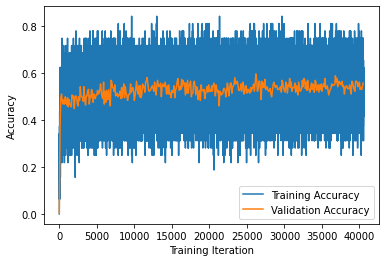

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.174 Validation Loss: 2.175 Accuracy: 0.164 Validation Accuracy: 0.160:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.174 Validation Loss: 2.175 Accuracy: 0.188 Validation Accuracy: 0.160:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.171 Validation Loss: 2.175 Accuracy: 0.206 Validation Accuracy: 0.160:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.173 Validation Loss: 2.175 Accuracy: 0.201 Validation Accuracy: 0.160:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.172 Validation Loss: 2.175 Accuracy: 0.195 Validation Accuracy: 0.160:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.171 Validation Loss: 2.175 Accuracy: 0.198 Validation Accuracy: 0.160:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.172 Validation Loss: 2.175 Accuracy: 0.202 Validation Accuracy: 0.160:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.170 Validation Loss: 2.175 Accuracy: 0.202 Validation Accuracy: 0.160:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.168 Validation Loss: 2.175 Accuracy: 0.209 Validation Accuracy: 0.160:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.169 Validation Loss: 2.175 Accuracy: 0.211 Validation Accuracy: 0.160:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.166 Validation Loss: 2.175 Accuracy: 0.219 Validation Accuracy: 0.160:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.164 Validation Loss: 2.175 Accuracy: 0.227 Validation Accuracy: 0.160:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.164 Validation Loss: 2.175 Accuracy: 0.227 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 12 Loss: 2.163 Validation Loss: 2.175 Accuracy: 0.230 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 13 Loss: 2.163 Validation Loss: 2.175 Accuracy: 0.240 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 14 Loss: 2.162 Validation Loss: 2.175 Accuracy: 0.247 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 15 Loss: 2.161 Validation Loss: 2.175 Accuracy: 0.250 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 16 Loss: 2.161 Validation Loss: 2.175 Accuracy: 0.251 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 17 Loss: 2.160 Validation Loss: 2.175 Accuracy: 0.253 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 18 Loss: 2.159 Validation Loss: 2.175 Accuracy: 0.253 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 19 Loss: 2.158 Validation Loss: 2.175 Accuracy: 0.255 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 20 Loss: 2.157 Validation Loss: 2.175 Accuracy: 0.260 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 21 Loss: 2.155 Validation Loss: 2.175 Accuracy: 0.256 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 22 Loss: 2.154 Validation Loss: 2.175 Accuracy: 0.256 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 23 Loss: 2.151 Validation Loss: 2.175 Accuracy: 0.254 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 24 Loss: 2.150 Validation Loss: 2.175 Accuracy: 0.254 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 25 Loss: 2.149 Validation Loss: 2.175 Accuracy: 0.253 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 26 Loss: 2.147 Validation Loss: 2.175 Accuracy: 0.263 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 27 Loss: 2.145 Validation Loss: 2.175 Accuracy: 0.275 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 28 Loss: 2.143 Validation Loss: 2.175 Accuracy: 0.288 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 29 Loss: 2.142 Validation Loss: 2.175 Accuracy: 0.290 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 30 Loss: 2.141 Validation Loss: 2.175 Accuracy: 0.297 Validation Accuracy: 0.160:   1%|          | 12/1563 [00:00<00:13, 115.00it/s]

Epoch: 0 Iteration: 30 Loss: 2.141 Validation Loss: 2.175 Accuracy: 0.297 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 31 Loss: 2.141 Validation Loss: 2.175 Accuracy: 0.298 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 32 Loss: 2.140 Validation Loss: 2.175 Accuracy: 0.304 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 33 Loss: 2.137 Validation Loss: 2.175 Accuracy: 0.309 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 34 Loss: 2.136 Validation Loss: 2.175 Accuracy: 0.315 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 35 Loss: 2.134 Validation Loss: 2.175 Accuracy: 0.319 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 36 Loss: 2.132 Validation Loss: 2.175 Accuracy: 0.311 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 37 Loss: 2.130 Validation Loss: 2.175 Accuracy: 0.307 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 38 Loss: 2.128 Validation Loss: 2.175 Accuracy: 0.302 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 39 Loss: 2.126 Validation Loss: 2.175 Accuracy: 0.305 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 40 Loss: 2.124 Validation Loss: 2.175 Accuracy: 0.303 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 41 Loss: 2.122 Validation Loss: 2.175 Accuracy: 0.309 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 42 Loss: 2.121 Validation Loss: 2.175 Accuracy: 0.304 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 43 Loss: 2.120 Validation Loss: 2.175 Accuracy: 0.300 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 44 Loss: 2.117 Validation Loss: 2.175 Accuracy: 0.308 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 45 Loss: 2.114 Validation Loss: 2.175 Accuracy: 0.325 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 46 Loss: 2.112 Validation Loss: 2.175 Accuracy: 0.333 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 47 Loss: 2.111 Validation Loss: 2.175 Accuracy: 0.336 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 48 Loss: 2.110 Validation Loss: 2.175 Accuracy: 0.331 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 49 Loss: 2.107 Validation Loss: 2.175 Accuracy: 0.342 Validation Accuracy: 0.160:   2%|▏         | 31/1563 [00:00<00:09, 154.82it/s]

Epoch: 0 Iteration: 49 Loss: 2.107 Validation Loss: 2.175 Accuracy: 0.342 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 50 Loss: 2.107 Validation Loss: 2.175 Accuracy: 0.335 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 51 Loss: 2.104 Validation Loss: 2.175 Accuracy: 0.345 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 52 Loss: 2.102 Validation Loss: 2.175 Accuracy: 0.348 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 53 Loss: 2.102 Validation Loss: 2.175 Accuracy: 0.351 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 54 Loss: 2.100 Validation Loss: 2.175 Accuracy: 0.344 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 55 Loss: 2.098 Validation Loss: 2.175 Accuracy: 0.335 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 56 Loss: 2.097 Validation Loss: 2.175 Accuracy: 0.337 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 57 Loss: 2.096 Validation Loss: 2.175 Accuracy: 0.337 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 58 Loss: 2.096 Validation Loss: 2.175 Accuracy: 0.339 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 59 Loss: 2.094 Validation Loss: 2.175 Accuracy: 0.333 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 60 Loss: 2.093 Validation Loss: 2.175 Accuracy: 0.352 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 61 Loss: 2.092 Validation Loss: 2.175 Accuracy: 0.343 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 62 Loss: 2.090 Validation Loss: 2.175 Accuracy: 0.355 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 63 Loss: 2.088 Validation Loss: 2.175 Accuracy: 0.355 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 64 Loss: 2.087 Validation Loss: 2.175 Accuracy: 0.366 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 65 Loss: 2.086 Validation Loss: 2.175 Accuracy: 0.373 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 66 Loss: 2.085 Validation Loss: 2.175 Accuracy: 0.379 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 67 Loss: 2.083 Validation Loss: 2.175 Accuracy: 0.389 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 68 Loss: 2.080 Validation Loss: 2.175 Accuracy: 0.402 Validation Accuracy: 0.160:   3%|▎         | 50/1563 [00:00<00:09, 167.44it/s]

Epoch: 0 Iteration: 68 Loss: 2.080 Validation Loss: 2.175 Accuracy: 0.402 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 69 Loss: 2.079 Validation Loss: 2.175 Accuracy: 0.406 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 70 Loss: 2.076 Validation Loss: 2.175 Accuracy: 0.395 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 71 Loss: 2.075 Validation Loss: 2.175 Accuracy: 0.410 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 72 Loss: 2.074 Validation Loss: 2.175 Accuracy: 0.409 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 73 Loss: 2.071 Validation Loss: 2.175 Accuracy: 0.426 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 74 Loss: 2.069 Validation Loss: 2.175 Accuracy: 0.420 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 75 Loss: 2.068 Validation Loss: 2.175 Accuracy: 0.416 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 76 Loss: 2.066 Validation Loss: 2.175 Accuracy: 0.415 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 77 Loss: 2.064 Validation Loss: 2.175 Accuracy: 0.413 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 78 Loss: 2.064 Validation Loss: 2.175 Accuracy: 0.406 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 79 Loss: 2.061 Validation Loss: 2.175 Accuracy: 0.414 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 80 Loss: 2.060 Validation Loss: 2.175 Accuracy: 0.413 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 81 Loss: 2.058 Validation Loss: 2.175 Accuracy: 0.409 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 82 Loss: 2.056 Validation Loss: 2.175 Accuracy: 0.407 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 83 Loss: 2.055 Validation Loss: 2.175 Accuracy: 0.393 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 84 Loss: 2.054 Validation Loss: 2.175 Accuracy: 0.389 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 85 Loss: 2.053 Validation Loss: 2.175 Accuracy: 0.392 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 86 Loss: 2.051 Validation Loss: 2.175 Accuracy: 0.401 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 87 Loss: 2.049 Validation Loss: 2.175 Accuracy: 0.407 Validation Accuracy: 0.160:   4%|▍         | 69/1563 [00:00<00:08, 173.02it/s]

Epoch: 0 Iteration: 87 Loss: 2.049 Validation Loss: 2.175 Accuracy: 0.407 Validation Accuracy: 0.160:   6%|▌         | 88/1563 [00:00<00:08, 175.92it/s]

Epoch: 0 Iteration: 88 Loss: 2.047 Validation Loss: 2.175 Accuracy: 0.418 Validation Accuracy: 0.160:   6%|▌         | 88/1563 [00:00<00:08, 175.92it/s]

Epoch: 0 Iteration: 89 Loss: 2.046 Validation Loss: 2.175 Accuracy: 0.417 Validation Accuracy: 0.160:   6%|▌         | 88/1563 [00:00<00:08, 175.92it/s]

Epoch: 0 Iteration: 90 Loss: 2.045 Validation Loss: 2.175 Accuracy: 0.425 Validation Accuracy: 0.160:   6%|▌         | 88/1563 [00:00<00:08, 175.92it/s]

Epoch: 0 Iteration: 91 Loss: 2.044 Validation Loss: 2.175 Accuracy: 0.429 Validation Accuracy: 0.160:   6%|▌         | 88/1563 [00:00<00:08, 175.92it/s]

Epoch: 0 Iteration: 92 Loss: 2.043 Validation Loss: 2.175 Accuracy: 0.433 Validation Accuracy: 0.160:   6%|▌         | 88/1563 [00:00<00:08, 175.92it/s]

Epoch: 0 Iteration: 93 Loss: 2.041 Validation Loss: 2.175 Accuracy: 0.449 Validation Accuracy: 0.160:   6%|▌         | 88/1563 [00:00<00:08, 175.92it/s]

Epoch: 0 Iteration: 94 Loss: 2.040 Validation Loss: 2.175 Accuracy: 0.465 Validation Accuracy: 0.160:   6%|▌         | 88/1563 [00:00<00:08, 175.92it/s]

Epoch: 0 Iteration: 95 Loss: 2.037 Validation Loss: 2.175 Accuracy: 0.477 Validation Accuracy: 0.160:   6%|▌         | 88/1563 [00:00<00:08, 175.92it/s]

Epoch: 0 Iteration: 96 Loss: 2.036 Validation Loss: 2.175 Accuracy: 0.477 Validation Accuracy: 0.160:   6%|▌         | 88/1563 [00:00<00:08, 175.92it/s]

Epoch: 0 Iteration: 97 Loss: 2.033 Validation Loss: 2.175 Accuracy: 0.477 Validation Accuracy: 0.160:   6%|▌         | 88/1563 [00:00<00:08, 175.92it/s]

Epoch: 0 Iteration: 98 Loss: 2.031 Validation Loss: 2.175 Accuracy: 0.471 Validation Accuracy: 0.160:   6%|▌         | 88/1563 [00:00<00:08, 175.92it/s]

Epoch: 0 Iteration: 99 Loss: 2.030 Validation Loss: 2.175 Accuracy: 0.470 Validation Accuracy: 0.160:   6%|▌         | 88/1563 [00:00<00:08, 175.92it/s]

Epoch: 0 Iteration: 100 Loss: 2.028 Validation Loss: 2.022 Accuracy: 0.477 Validation Accuracy: 0.295:   6%|▌         | 88/1563 [00:00<00:08, 175.92it/s]

Epoch: 0 Iteration: 101 Loss: 2.027 Validation Loss: 2.022 Accuracy: 0.471 Validation Accuracy: 0.295:   6%|▌         | 88/1563 [00:00<00:08, 175.92it/s]

Epoch: 0 Iteration: 102 Loss: 2.025 Validation Loss: 2.022 Accuracy: 0.477 Validation Accuracy: 0.295:   6%|▌         | 88/1563 [00:00<00:08, 175.92it/s]

Epoch: 0 Iteration: 103 Loss: 2.023 Validation Loss: 2.022 Accuracy: 0.473 Validation Accuracy: 0.295:   6%|▌         | 88/1563 [00:00<00:08, 175.92it/s]

Epoch: 0 Iteration: 104 Loss: 2.021 Validation Loss: 2.022 Accuracy: 0.477 Validation Accuracy: 0.295:   6%|▌         | 88/1563 [00:00<00:08, 175.92it/s]

Epoch: 0 Iteration: 105 Loss: 2.019 Validation Loss: 2.022 Accuracy: 0.468 Validation Accuracy: 0.295:   6%|▌         | 88/1563 [00:00<00:08, 175.92it/s]

Epoch: 0 Iteration: 105 Loss: 2.019 Validation Loss: 2.022 Accuracy: 0.468 Validation Accuracy: 0.295:   7%|▋         | 106/1563 [00:00<00:09, 161.31it/s]

Epoch: 0 Iteration: 106 Loss: 2.018 Validation Loss: 2.022 Accuracy: 0.463 Validation Accuracy: 0.295:   7%|▋         | 106/1563 [00:00<00:09, 161.31it/s]

Epoch: 0 Iteration: 107 Loss: 2.018 Validation Loss: 2.022 Accuracy: 0.455 Validation Accuracy: 0.295:   7%|▋         | 106/1563 [00:00<00:09, 161.31it/s]

Epoch: 0 Iteration: 108 Loss: 2.016 Validation Loss: 2.022 Accuracy: 0.463 Validation Accuracy: 0.295:   7%|▋         | 106/1563 [00:00<00:09, 161.31it/s]

Epoch: 0 Iteration: 109 Loss: 2.015 Validation Loss: 2.022 Accuracy: 0.464 Validation Accuracy: 0.295:   7%|▋         | 106/1563 [00:00<00:09, 161.31it/s]

Epoch: 0 Iteration: 110 Loss: 2.013 Validation Loss: 2.022 Accuracy: 0.460 Validation Accuracy: 0.295:   7%|▋         | 106/1563 [00:00<00:09, 161.31it/s]

Epoch: 0 Iteration: 111 Loss: 2.012 Validation Loss: 2.022 Accuracy: 0.470 Validation Accuracy: 0.295:   7%|▋         | 106/1563 [00:00<00:09, 161.31it/s]

Epoch: 0 Iteration: 112 Loss: 2.009 Validation Loss: 2.022 Accuracy: 0.474 Validation Accuracy: 0.295:   7%|▋         | 106/1563 [00:00<00:09, 161.31it/s]

Epoch: 0 Iteration: 113 Loss: 2.007 Validation Loss: 2.022 Accuracy: 0.471 Validation Accuracy: 0.295:   7%|▋         | 106/1563 [00:00<00:09, 161.31it/s]

Epoch: 0 Iteration: 114 Loss: 2.005 Validation Loss: 2.022 Accuracy: 0.470 Validation Accuracy: 0.295:   7%|▋         | 106/1563 [00:00<00:09, 161.31it/s]

Epoch: 0 Iteration: 115 Loss: 2.003 Validation Loss: 2.022 Accuracy: 0.476 Validation Accuracy: 0.295:   7%|▋         | 106/1563 [00:00<00:09, 161.31it/s]

Epoch: 0 Iteration: 116 Loss: 2.002 Validation Loss: 2.022 Accuracy: 0.487 Validation Accuracy: 0.295:   7%|▋         | 106/1563 [00:00<00:09, 161.31it/s]

Epoch: 0 Iteration: 117 Loss: 2.001 Validation Loss: 2.022 Accuracy: 0.493 Validation Accuracy: 0.295:   7%|▋         | 106/1563 [00:00<00:09, 161.31it/s]

Epoch: 0 Iteration: 118 Loss: 1.998 Validation Loss: 2.022 Accuracy: 0.491 Validation Accuracy: 0.295:   7%|▋         | 106/1563 [00:00<00:09, 161.31it/s]

Epoch: 0 Iteration: 119 Loss: 1.997 Validation Loss: 2.022 Accuracy: 0.494 Validation Accuracy: 0.295:   7%|▋         | 106/1563 [00:00<00:09, 161.31it/s]

Epoch: 0 Iteration: 120 Loss: 1.995 Validation Loss: 2.022 Accuracy: 0.502 Validation Accuracy: 0.295:   7%|▋         | 106/1563 [00:00<00:09, 161.31it/s]

Epoch: 0 Iteration: 121 Loss: 1.993 Validation Loss: 2.022 Accuracy: 0.497 Validation Accuracy: 0.295:   7%|▋         | 106/1563 [00:00<00:09, 161.31it/s]

Epoch: 0 Iteration: 122 Loss: 1.992 Validation Loss: 2.022 Accuracy: 0.488 Validation Accuracy: 0.295:   7%|▋         | 106/1563 [00:00<00:09, 161.31it/s]

Epoch: 0 Iteration: 122 Loss: 1.992 Validation Loss: 2.022 Accuracy: 0.488 Validation Accuracy: 0.295:   8%|▊         | 123/1563 [00:00<00:09, 155.88it/s]

Epoch: 0 Iteration: 123 Loss: 1.990 Validation Loss: 2.022 Accuracy: 0.491 Validation Accuracy: 0.295:   8%|▊         | 123/1563 [00:00<00:09, 155.88it/s]

Epoch: 0 Iteration: 124 Loss: 1.989 Validation Loss: 2.022 Accuracy: 0.484 Validation Accuracy: 0.295:   8%|▊         | 123/1563 [00:00<00:09, 155.88it/s]

Epoch: 0 Iteration: 125 Loss: 1.987 Validation Loss: 2.022 Accuracy: 0.491 Validation Accuracy: 0.295:   8%|▊         | 123/1563 [00:00<00:09, 155.88it/s]

Epoch: 0 Iteration: 126 Loss: 1.985 Validation Loss: 2.022 Accuracy: 0.484 Validation Accuracy: 0.295:   8%|▊         | 123/1563 [00:00<00:09, 155.88it/s]

Epoch: 0 Iteration: 127 Loss: 1.983 Validation Loss: 2.022 Accuracy: 0.484 Validation Accuracy: 0.295:   8%|▊         | 123/1563 [00:00<00:09, 155.88it/s]

Epoch: 0 Iteration: 128 Loss: 1.982 Validation Loss: 2.022 Accuracy: 0.480 Validation Accuracy: 0.295:   8%|▊         | 123/1563 [00:00<00:09, 155.88it/s]

Epoch: 0 Iteration: 129 Loss: 1.980 Validation Loss: 2.022 Accuracy: 0.481 Validation Accuracy: 0.295:   8%|▊         | 123/1563 [00:00<00:09, 155.88it/s]

Epoch: 0 Iteration: 130 Loss: 1.978 Validation Loss: 2.022 Accuracy: 0.482 Validation Accuracy: 0.295:   8%|▊         | 123/1563 [00:00<00:09, 155.88it/s]

Epoch: 0 Iteration: 131 Loss: 1.978 Validation Loss: 2.022 Accuracy: 0.482 Validation Accuracy: 0.295:   8%|▊         | 123/1563 [00:00<00:09, 155.88it/s]

Epoch: 0 Iteration: 132 Loss: 1.977 Validation Loss: 2.022 Accuracy: 0.491 Validation Accuracy: 0.295:   8%|▊         | 123/1563 [00:00<00:09, 155.88it/s]

Epoch: 0 Iteration: 133 Loss: 1.976 Validation Loss: 2.022 Accuracy: 0.497 Validation Accuracy: 0.295:   8%|▊         | 123/1563 [00:00<00:09, 155.88it/s]

Epoch: 0 Iteration: 134 Loss: 1.975 Validation Loss: 2.022 Accuracy: 0.505 Validation Accuracy: 0.295:   8%|▊         | 123/1563 [00:00<00:09, 155.88it/s]

Epoch: 0 Iteration: 135 Loss: 1.973 Validation Loss: 2.022 Accuracy: 0.499 Validation Accuracy: 0.295:   8%|▊         | 123/1563 [00:00<00:09, 155.88it/s]

Epoch: 0 Iteration: 136 Loss: 1.972 Validation Loss: 2.022 Accuracy: 0.499 Validation Accuracy: 0.295:   8%|▊         | 123/1563 [00:00<00:09, 155.88it/s]

Epoch: 0 Iteration: 137 Loss: 1.971 Validation Loss: 2.022 Accuracy: 0.505 Validation Accuracy: 0.295:   8%|▊         | 123/1563 [00:00<00:09, 155.88it/s]

Epoch: 0 Iteration: 138 Loss: 1.969 Validation Loss: 2.022 Accuracy: 0.518 Validation Accuracy: 0.295:   8%|▊         | 123/1563 [00:00<00:09, 155.88it/s]

Epoch: 0 Iteration: 139 Loss: 1.967 Validation Loss: 2.022 Accuracy: 0.520 Validation Accuracy: 0.295:   8%|▊         | 123/1563 [00:00<00:09, 155.88it/s]

Epoch: 0 Iteration: 140 Loss: 1.966 Validation Loss: 2.022 Accuracy: 0.523 Validation Accuracy: 0.295:   8%|▊         | 123/1563 [00:00<00:09, 155.88it/s]

Epoch: 0 Iteration: 140 Loss: 1.966 Validation Loss: 2.022 Accuracy: 0.523 Validation Accuracy: 0.295:   9%|▉         | 141/1563 [00:00<00:08, 162.27it/s]

Epoch: 0 Iteration: 141 Loss: 1.964 Validation Loss: 2.022 Accuracy: 0.532 Validation Accuracy: 0.295:   9%|▉         | 141/1563 [00:00<00:08, 162.27it/s]

Epoch: 0 Iteration: 142 Loss: 1.962 Validation Loss: 2.022 Accuracy: 0.529 Validation Accuracy: 0.295:   9%|▉         | 141/1563 [00:00<00:08, 162.27it/s]

Epoch: 0 Iteration: 143 Loss: 1.961 Validation Loss: 2.022 Accuracy: 0.526 Validation Accuracy: 0.295:   9%|▉         | 141/1563 [00:00<00:08, 162.27it/s]

Epoch: 0 Iteration: 144 Loss: 1.959 Validation Loss: 2.022 Accuracy: 0.534 Validation Accuracy: 0.295:   9%|▉         | 141/1563 [00:00<00:08, 162.27it/s]

Epoch: 0 Iteration: 145 Loss: 1.958 Validation Loss: 2.022 Accuracy: 0.537 Validation Accuracy: 0.295:   9%|▉         | 141/1563 [00:00<00:08, 162.27it/s]

Epoch: 0 Iteration: 146 Loss: 1.955 Validation Loss: 2.022 Accuracy: 0.550 Validation Accuracy: 0.295:   9%|▉         | 141/1563 [00:00<00:08, 162.27it/s]

Epoch: 0 Iteration: 147 Loss: 1.954 Validation Loss: 2.022 Accuracy: 0.550 Validation Accuracy: 0.295:   9%|▉         | 141/1563 [00:00<00:08, 162.27it/s]

Epoch: 0 Iteration: 148 Loss: 1.953 Validation Loss: 2.022 Accuracy: 0.541 Validation Accuracy: 0.295:   9%|▉         | 141/1563 [00:00<00:08, 162.27it/s]

Epoch: 0 Iteration: 149 Loss: 1.951 Validation Loss: 2.022 Accuracy: 0.549 Validation Accuracy: 0.295:   9%|▉         | 141/1563 [00:00<00:08, 162.27it/s]

Epoch: 0 Iteration: 150 Loss: 1.950 Validation Loss: 2.022 Accuracy: 0.541 Validation Accuracy: 0.295:   9%|▉         | 141/1563 [00:00<00:08, 162.27it/s]

Epoch: 0 Iteration: 151 Loss: 1.948 Validation Loss: 2.022 Accuracy: 0.541 Validation Accuracy: 0.295:   9%|▉         | 141/1563 [00:00<00:08, 162.27it/s]

Epoch: 0 Iteration: 152 Loss: 1.946 Validation Loss: 2.022 Accuracy: 0.541 Validation Accuracy: 0.295:   9%|▉         | 141/1563 [00:00<00:08, 162.27it/s]

Epoch: 0 Iteration: 153 Loss: 1.945 Validation Loss: 2.022 Accuracy: 0.546 Validation Accuracy: 0.295:   9%|▉         | 141/1563 [00:00<00:08, 162.27it/s]

Epoch: 0 Iteration: 154 Loss: 1.943 Validation Loss: 2.022 Accuracy: 0.534 Validation Accuracy: 0.295:   9%|▉         | 141/1563 [00:00<00:08, 162.27it/s]

Epoch: 0 Iteration: 155 Loss: 1.942 Validation Loss: 2.022 Accuracy: 0.531 Validation Accuracy: 0.295:   9%|▉         | 141/1563 [00:00<00:08, 162.27it/s]

Epoch: 0 Iteration: 156 Loss: 1.940 Validation Loss: 2.022 Accuracy: 0.530 Validation Accuracy: 0.295:   9%|▉         | 141/1563 [00:00<00:08, 162.27it/s]

Epoch: 0 Iteration: 157 Loss: 1.937 Validation Loss: 2.022 Accuracy: 0.531 Validation Accuracy: 0.295:   9%|▉         | 141/1563 [00:00<00:08, 162.27it/s]

Epoch: 0 Iteration: 158 Loss: 1.937 Validation Loss: 2.022 Accuracy: 0.537 Validation Accuracy: 0.295:   9%|▉         | 141/1563 [00:00<00:08, 162.27it/s]

Epoch: 0 Iteration: 158 Loss: 1.937 Validation Loss: 2.022 Accuracy: 0.537 Validation Accuracy: 0.295:  10%|█         | 159/1563 [00:00<00:08, 166.94it/s]

Epoch: 0 Iteration: 159 Loss: 1.935 Validation Loss: 2.022 Accuracy: 0.527 Validation Accuracy: 0.295:  10%|█         | 159/1563 [00:00<00:08, 166.94it/s]

Epoch: 0 Iteration: 160 Loss: 1.932 Validation Loss: 2.022 Accuracy: 0.542 Validation Accuracy: 0.295:  10%|█         | 159/1563 [00:00<00:08, 166.94it/s]

Epoch: 0 Iteration: 161 Loss: 1.931 Validation Loss: 2.022 Accuracy: 0.546 Validation Accuracy: 0.295:  10%|█         | 159/1563 [00:00<00:08, 166.94it/s]

Epoch: 0 Iteration: 162 Loss: 1.929 Validation Loss: 2.022 Accuracy: 0.551 Validation Accuracy: 0.295:  10%|█         | 159/1563 [00:00<00:08, 166.94it/s]

Epoch: 0 Iteration: 163 Loss: 1.927 Validation Loss: 2.022 Accuracy: 0.548 Validation Accuracy: 0.295:  10%|█         | 159/1563 [00:00<00:08, 166.94it/s]

Epoch: 0 Iteration: 164 Loss: 1.926 Validation Loss: 2.022 Accuracy: 0.568 Validation Accuracy: 0.295:  10%|█         | 159/1563 [00:01<00:08, 166.94it/s]

Epoch: 0 Iteration: 165 Loss: 1.924 Validation Loss: 2.022 Accuracy: 0.570 Validation Accuracy: 0.295:  10%|█         | 159/1563 [00:01<00:08, 166.94it/s]

Epoch: 0 Iteration: 166 Loss: 1.923 Validation Loss: 2.022 Accuracy: 0.569 Validation Accuracy: 0.295:  10%|█         | 159/1563 [00:01<00:08, 166.94it/s]

Epoch: 0 Iteration: 167 Loss: 1.922 Validation Loss: 2.022 Accuracy: 0.568 Validation Accuracy: 0.295:  10%|█         | 159/1563 [00:01<00:08, 166.94it/s]

Epoch: 0 Iteration: 168 Loss: 1.920 Validation Loss: 2.022 Accuracy: 0.573 Validation Accuracy: 0.295:  10%|█         | 159/1563 [00:01<00:08, 166.94it/s]

Epoch: 0 Iteration: 169 Loss: 1.919 Validation Loss: 2.022 Accuracy: 0.578 Validation Accuracy: 0.295:  10%|█         | 159/1563 [00:01<00:08, 166.94it/s]

Epoch: 0 Iteration: 170 Loss: 1.917 Validation Loss: 2.022 Accuracy: 0.571 Validation Accuracy: 0.295:  10%|█         | 159/1563 [00:01<00:08, 166.94it/s]

Epoch: 0 Iteration: 171 Loss: 1.916 Validation Loss: 2.022 Accuracy: 0.577 Validation Accuracy: 0.295:  10%|█         | 159/1563 [00:01<00:08, 166.94it/s]

Epoch: 0 Iteration: 172 Loss: 1.914 Validation Loss: 2.022 Accuracy: 0.577 Validation Accuracy: 0.295:  10%|█         | 159/1563 [00:01<00:08, 166.94it/s]

Epoch: 0 Iteration: 173 Loss: 1.911 Validation Loss: 2.022 Accuracy: 0.585 Validation Accuracy: 0.295:  10%|█         | 159/1563 [00:01<00:08, 166.94it/s]

Epoch: 0 Iteration: 174 Loss: 1.910 Validation Loss: 2.022 Accuracy: 0.574 Validation Accuracy: 0.295:  10%|█         | 159/1563 [00:01<00:08, 166.94it/s]

Epoch: 0 Iteration: 175 Loss: 1.909 Validation Loss: 2.022 Accuracy: 0.571 Validation Accuracy: 0.295:  10%|█         | 159/1563 [00:01<00:08, 166.94it/s]

Epoch: 0 Iteration: 176 Loss: 1.907 Validation Loss: 2.022 Accuracy: 0.577 Validation Accuracy: 0.295:  10%|█         | 159/1563 [00:01<00:08, 166.94it/s]

Epoch: 0 Iteration: 176 Loss: 1.907 Validation Loss: 2.022 Accuracy: 0.577 Validation Accuracy: 0.295:  11%|█▏        | 177/1563 [00:01<00:08, 169.78it/s]

Epoch: 0 Iteration: 177 Loss: 1.907 Validation Loss: 2.022 Accuracy: 0.578 Validation Accuracy: 0.295:  11%|█▏        | 177/1563 [00:01<00:08, 169.78it/s]

Epoch: 0 Iteration: 178 Loss: 1.905 Validation Loss: 2.022 Accuracy: 0.577 Validation Accuracy: 0.295:  11%|█▏        | 177/1563 [00:01<00:08, 169.78it/s]

Epoch: 0 Iteration: 179 Loss: 1.903 Validation Loss: 2.022 Accuracy: 0.582 Validation Accuracy: 0.295:  11%|█▏        | 177/1563 [00:01<00:08, 169.78it/s]

Epoch: 0 Iteration: 180 Loss: 1.902 Validation Loss: 2.022 Accuracy: 0.585 Validation Accuracy: 0.295:  11%|█▏        | 177/1563 [00:01<00:08, 169.78it/s]

Epoch: 0 Iteration: 181 Loss: 1.900 Validation Loss: 2.022 Accuracy: 0.577 Validation Accuracy: 0.295:  11%|█▏        | 177/1563 [00:01<00:08, 169.78it/s]

Epoch: 0 Iteration: 182 Loss: 1.899 Validation Loss: 2.022 Accuracy: 0.578 Validation Accuracy: 0.295:  11%|█▏        | 177/1563 [00:01<00:08, 169.78it/s]

Epoch: 0 Iteration: 183 Loss: 1.897 Validation Loss: 2.022 Accuracy: 0.577 Validation Accuracy: 0.295:  11%|█▏        | 177/1563 [00:01<00:08, 169.78it/s]

Epoch: 0 Iteration: 184 Loss: 1.896 Validation Loss: 2.022 Accuracy: 0.581 Validation Accuracy: 0.295:  11%|█▏        | 177/1563 [00:01<00:08, 169.78it/s]

Epoch: 0 Iteration: 185 Loss: 1.895 Validation Loss: 2.022 Accuracy: 0.584 Validation Accuracy: 0.295:  11%|█▏        | 177/1563 [00:01<00:08, 169.78it/s]

Epoch: 0 Iteration: 186 Loss: 1.893 Validation Loss: 2.022 Accuracy: 0.585 Validation Accuracy: 0.295:  11%|█▏        | 177/1563 [00:01<00:08, 169.78it/s]

Epoch: 0 Iteration: 187 Loss: 1.891 Validation Loss: 2.022 Accuracy: 0.586 Validation Accuracy: 0.295:  11%|█▏        | 177/1563 [00:01<00:08, 169.78it/s]

Epoch: 0 Iteration: 188 Loss: 1.888 Validation Loss: 2.022 Accuracy: 0.596 Validation Accuracy: 0.295:  11%|█▏        | 177/1563 [00:01<00:08, 169.78it/s]

Epoch: 0 Iteration: 189 Loss: 1.885 Validation Loss: 2.022 Accuracy: 0.600 Validation Accuracy: 0.295:  11%|█▏        | 177/1563 [00:01<00:08, 169.78it/s]

Epoch: 0 Iteration: 190 Loss: 1.883 Validation Loss: 2.022 Accuracy: 0.602 Validation Accuracy: 0.295:  11%|█▏        | 177/1563 [00:01<00:08, 169.78it/s]

Epoch: 0 Iteration: 191 Loss: 1.882 Validation Loss: 2.022 Accuracy: 0.611 Validation Accuracy: 0.295:  11%|█▏        | 177/1563 [00:01<00:08, 169.78it/s]

Epoch: 0 Iteration: 192 Loss: 1.880 Validation Loss: 2.022 Accuracy: 0.610 Validation Accuracy: 0.295:  11%|█▏        | 177/1563 [00:01<00:08, 169.78it/s]

Epoch: 0 Iteration: 193 Loss: 1.879 Validation Loss: 2.022 Accuracy: 0.616 Validation Accuracy: 0.295:  11%|█▏        | 177/1563 [00:01<00:08, 169.78it/s]

Epoch: 0 Iteration: 194 Loss: 1.876 Validation Loss: 2.022 Accuracy: 0.625 Validation Accuracy: 0.295:  11%|█▏        | 177/1563 [00:01<00:08, 169.78it/s]

Epoch: 0 Iteration: 194 Loss: 1.876 Validation Loss: 2.022 Accuracy: 0.625 Validation Accuracy: 0.295:  12%|█▏        | 195/1563 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 195 Loss: 1.874 Validation Loss: 2.022 Accuracy: 0.629 Validation Accuracy: 0.295:  12%|█▏        | 195/1563 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 196 Loss: 1.872 Validation Loss: 2.022 Accuracy: 0.629 Validation Accuracy: 0.295:  12%|█▏        | 195/1563 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 197 Loss: 1.869 Validation Loss: 2.022 Accuracy: 0.638 Validation Accuracy: 0.295:  12%|█▏        | 195/1563 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 198 Loss: 1.867 Validation Loss: 2.022 Accuracy: 0.633 Validation Accuracy: 0.295:  12%|█▏        | 195/1563 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 199 Loss: 1.866 Validation Loss: 2.022 Accuracy: 0.627 Validation Accuracy: 0.295:  12%|█▏        | 195/1563 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 200 Loss: 1.865 Validation Loss: 1.862 Accuracy: 0.630 Validation Accuracy: 0.395:  12%|█▏        | 195/1563 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 201 Loss: 1.864 Validation Loss: 1.862 Accuracy: 0.623 Validation Accuracy: 0.395:  12%|█▏        | 195/1563 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 202 Loss: 1.863 Validation Loss: 1.862 Accuracy: 0.624 Validation Accuracy: 0.395:  12%|█▏        | 195/1563 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 203 Loss: 1.861 Validation Loss: 1.862 Accuracy: 0.629 Validation Accuracy: 0.395:  12%|█▏        | 195/1563 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 204 Loss: 1.859 Validation Loss: 1.862 Accuracy: 0.617 Validation Accuracy: 0.395:  12%|█▏        | 195/1563 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 205 Loss: 1.857 Validation Loss: 1.862 Accuracy: 0.621 Validation Accuracy: 0.395:  12%|█▏        | 195/1563 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 206 Loss: 1.856 Validation Loss: 1.862 Accuracy: 0.618 Validation Accuracy: 0.395:  12%|█▏        | 195/1563 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 207 Loss: 1.855 Validation Loss: 1.862 Accuracy: 0.613 Validation Accuracy: 0.395:  12%|█▏        | 195/1563 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 208 Loss: 1.853 Validation Loss: 1.862 Accuracy: 0.609 Validation Accuracy: 0.395:  12%|█▏        | 195/1563 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 209 Loss: 1.854 Validation Loss: 1.862 Accuracy: 0.610 Validation Accuracy: 0.395:  12%|█▏        | 195/1563 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 210 Loss: 1.852 Validation Loss: 1.862 Accuracy: 0.609 Validation Accuracy: 0.395:  12%|█▏        | 195/1563 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 211 Loss: 1.852 Validation Loss: 1.862 Accuracy: 0.608 Validation Accuracy: 0.395:  12%|█▏        | 195/1563 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 212 Loss: 1.849 Validation Loss: 1.862 Accuracy: 0.612 Validation Accuracy: 0.395:  12%|█▏        | 195/1563 [00:01<00:07, 172.04it/s]

Epoch: 0 Iteration: 212 Loss: 1.849 Validation Loss: 1.862 Accuracy: 0.612 Validation Accuracy: 0.395:  14%|█▎        | 213/1563 [00:01<00:07, 169.96it/s]

Epoch: 0 Iteration: 213 Loss: 1.847 Validation Loss: 1.862 Accuracy: 0.610 Validation Accuracy: 0.395:  14%|█▎        | 213/1563 [00:01<00:07, 169.96it/s]

Epoch: 0 Iteration: 214 Loss: 1.845 Validation Loss: 1.862 Accuracy: 0.610 Validation Accuracy: 0.395:  14%|█▎        | 213/1563 [00:01<00:07, 169.96it/s]

Epoch: 0 Iteration: 215 Loss: 1.842 Validation Loss: 1.862 Accuracy: 0.611 Validation Accuracy: 0.395:  14%|█▎        | 213/1563 [00:01<00:07, 169.96it/s]

Epoch: 0 Iteration: 216 Loss: 1.841 Validation Loss: 1.862 Accuracy: 0.620 Validation Accuracy: 0.395:  14%|█▎        | 213/1563 [00:01<00:07, 169.96it/s]

Epoch: 0 Iteration: 217 Loss: 1.839 Validation Loss: 1.862 Accuracy: 0.619 Validation Accuracy: 0.395:  14%|█▎        | 213/1563 [00:01<00:07, 169.96it/s]

Epoch: 0 Iteration: 218 Loss: 1.838 Validation Loss: 1.862 Accuracy: 0.624 Validation Accuracy: 0.395:  14%|█▎        | 213/1563 [00:01<00:07, 169.96it/s]

Epoch: 0 Iteration: 219 Loss: 1.835 Validation Loss: 1.862 Accuracy: 0.630 Validation Accuracy: 0.395:  14%|█▎        | 213/1563 [00:01<00:07, 169.96it/s]

Epoch: 0 Iteration: 220 Loss: 1.834 Validation Loss: 1.862 Accuracy: 0.630 Validation Accuracy: 0.395:  14%|█▎        | 213/1563 [00:01<00:07, 169.96it/s]

Epoch: 0 Iteration: 221 Loss: 1.832 Validation Loss: 1.862 Accuracy: 0.630 Validation Accuracy: 0.395:  14%|█▎        | 213/1563 [00:01<00:07, 169.96it/s]

Epoch: 0 Iteration: 222 Loss: 1.830 Validation Loss: 1.862 Accuracy: 0.631 Validation Accuracy: 0.395:  14%|█▎        | 213/1563 [00:01<00:07, 169.96it/s]

Epoch: 0 Iteration: 223 Loss: 1.828 Validation Loss: 1.862 Accuracy: 0.624 Validation Accuracy: 0.395:  14%|█▎        | 213/1563 [00:01<00:07, 169.96it/s]

Epoch: 0 Iteration: 224 Loss: 1.827 Validation Loss: 1.862 Accuracy: 0.630 Validation Accuracy: 0.395:  14%|█▎        | 213/1563 [00:01<00:07, 169.96it/s]

Epoch: 0 Iteration: 225 Loss: 1.824 Validation Loss: 1.862 Accuracy: 0.629 Validation Accuracy: 0.395:  14%|█▎        | 213/1563 [00:01<00:07, 169.96it/s]

Epoch: 0 Iteration: 226 Loss: 1.822 Validation Loss: 1.862 Accuracy: 0.628 Validation Accuracy: 0.395:  14%|█▎        | 213/1563 [00:01<00:07, 169.96it/s]

Epoch: 0 Iteration: 227 Loss: 1.819 Validation Loss: 1.862 Accuracy: 0.635 Validation Accuracy: 0.395:  14%|█▎        | 213/1563 [00:01<00:07, 169.96it/s]

Epoch: 0 Iteration: 228 Loss: 1.819 Validation Loss: 1.862 Accuracy: 0.633 Validation Accuracy: 0.395:  14%|█▎        | 213/1563 [00:01<00:07, 169.96it/s]

Epoch: 0 Iteration: 229 Loss: 1.815 Validation Loss: 1.862 Accuracy: 0.637 Validation Accuracy: 0.395:  14%|█▎        | 213/1563 [00:01<00:07, 169.96it/s]

Epoch: 0 Iteration: 230 Loss: 1.813 Validation Loss: 1.862 Accuracy: 0.637 Validation Accuracy: 0.395:  14%|█▎        | 213/1563 [00:01<00:07, 169.96it/s]

Epoch: 0 Iteration: 230 Loss: 1.813 Validation Loss: 1.862 Accuracy: 0.637 Validation Accuracy: 0.395:  15%|█▍        | 231/1563 [00:01<00:07, 172.20it/s]

Epoch: 0 Iteration: 231 Loss: 1.811 Validation Loss: 1.862 Accuracy: 0.641 Validation Accuracy: 0.395:  15%|█▍        | 231/1563 [00:01<00:07, 172.20it/s]

Epoch: 0 Iteration: 232 Loss: 1.810 Validation Loss: 1.862 Accuracy: 0.641 Validation Accuracy: 0.395:  15%|█▍        | 231/1563 [00:01<00:07, 172.20it/s]

Epoch: 0 Iteration: 233 Loss: 1.808 Validation Loss: 1.862 Accuracy: 0.649 Validation Accuracy: 0.395:  15%|█▍        | 231/1563 [00:01<00:07, 172.20it/s]

Epoch: 0 Iteration: 234 Loss: 1.807 Validation Loss: 1.862 Accuracy: 0.650 Validation Accuracy: 0.395:  15%|█▍        | 231/1563 [00:01<00:07, 172.20it/s]

Epoch: 0 Iteration: 235 Loss: 1.808 Validation Loss: 1.862 Accuracy: 0.644 Validation Accuracy: 0.395:  15%|█▍        | 231/1563 [00:01<00:07, 172.20it/s]

Epoch: 0 Iteration: 236 Loss: 1.806 Validation Loss: 1.862 Accuracy: 0.636 Validation Accuracy: 0.395:  15%|█▍        | 231/1563 [00:01<00:07, 172.20it/s]

Epoch: 0 Iteration: 237 Loss: 1.805 Validation Loss: 1.862 Accuracy: 0.634 Validation Accuracy: 0.395:  15%|█▍        | 231/1563 [00:01<00:07, 172.20it/s]

Epoch: 0 Iteration: 238 Loss: 1.804 Validation Loss: 1.862 Accuracy: 0.633 Validation Accuracy: 0.395:  15%|█▍        | 231/1563 [00:01<00:07, 172.20it/s]

Epoch: 0 Iteration: 239 Loss: 1.802 Validation Loss: 1.862 Accuracy: 0.630 Validation Accuracy: 0.395:  15%|█▍        | 231/1563 [00:01<00:07, 172.20it/s]

Epoch: 0 Iteration: 240 Loss: 1.801 Validation Loss: 1.862 Accuracy: 0.627 Validation Accuracy: 0.395:  15%|█▍        | 231/1563 [00:01<00:07, 172.20it/s]

Epoch: 0 Iteration: 241 Loss: 1.799 Validation Loss: 1.862 Accuracy: 0.634 Validation Accuracy: 0.395:  15%|█▍        | 231/1563 [00:01<00:07, 172.20it/s]

Epoch: 0 Iteration: 242 Loss: 1.799 Validation Loss: 1.862 Accuracy: 0.632 Validation Accuracy: 0.395:  15%|█▍        | 231/1563 [00:01<00:07, 172.20it/s]

Epoch: 0 Iteration: 243 Loss: 1.798 Validation Loss: 1.862 Accuracy: 0.628 Validation Accuracy: 0.395:  15%|█▍        | 231/1563 [00:01<00:07, 172.20it/s]

Epoch: 0 Iteration: 244 Loss: 1.796 Validation Loss: 1.862 Accuracy: 0.626 Validation Accuracy: 0.395:  15%|█▍        | 231/1563 [00:01<00:07, 172.20it/s]

Epoch: 0 Iteration: 245 Loss: 1.796 Validation Loss: 1.862 Accuracy: 0.630 Validation Accuracy: 0.395:  15%|█▍        | 231/1563 [00:01<00:07, 172.20it/s]

Epoch: 0 Iteration: 246 Loss: 1.795 Validation Loss: 1.862 Accuracy: 0.640 Validation Accuracy: 0.395:  15%|█▍        | 231/1563 [00:01<00:07, 172.20it/s]

Epoch: 0 Iteration: 247 Loss: 1.794 Validation Loss: 1.862 Accuracy: 0.640 Validation Accuracy: 0.395:  15%|█▍        | 231/1563 [00:01<00:07, 172.20it/s]

Epoch: 0 Iteration: 248 Loss: 1.791 Validation Loss: 1.862 Accuracy: 0.644 Validation Accuracy: 0.395:  15%|█▍        | 231/1563 [00:01<00:07, 172.20it/s]

Epoch: 0 Iteration: 248 Loss: 1.791 Validation Loss: 1.862 Accuracy: 0.644 Validation Accuracy: 0.395:  16%|█▌        | 249/1563 [00:01<00:07, 173.75it/s]

Epoch: 0 Iteration: 249 Loss: 1.791 Validation Loss: 1.862 Accuracy: 0.638 Validation Accuracy: 0.395:  16%|█▌        | 249/1563 [00:01<00:07, 173.75it/s]

Epoch: 0 Iteration: 250 Loss: 1.789 Validation Loss: 1.862 Accuracy: 0.645 Validation Accuracy: 0.395:  16%|█▌        | 249/1563 [00:01<00:07, 173.75it/s]

Epoch: 0 Iteration: 251 Loss: 1.787 Validation Loss: 1.862 Accuracy: 0.638 Validation Accuracy: 0.395:  16%|█▌        | 249/1563 [00:01<00:07, 173.75it/s]

Epoch: 0 Iteration: 252 Loss: 1.786 Validation Loss: 1.862 Accuracy: 0.639 Validation Accuracy: 0.395:  16%|█▌        | 249/1563 [00:01<00:07, 173.75it/s]

Epoch: 0 Iteration: 253 Loss: 1.786 Validation Loss: 1.862 Accuracy: 0.640 Validation Accuracy: 0.395:  16%|█▌        | 249/1563 [00:01<00:07, 173.75it/s]

Epoch: 0 Iteration: 254 Loss: 1.782 Validation Loss: 1.862 Accuracy: 0.645 Validation Accuracy: 0.395:  16%|█▌        | 249/1563 [00:01<00:07, 173.75it/s]

Epoch: 0 Iteration: 255 Loss: 1.779 Validation Loss: 1.862 Accuracy: 0.651 Validation Accuracy: 0.395:  16%|█▌        | 249/1563 [00:01<00:07, 173.75it/s]

Epoch: 0 Iteration: 256 Loss: 1.778 Validation Loss: 1.862 Accuracy: 0.639 Validation Accuracy: 0.395:  16%|█▌        | 249/1563 [00:01<00:07, 173.75it/s]

Epoch: 0 Iteration: 257 Loss: 1.777 Validation Loss: 1.862 Accuracy: 0.637 Validation Accuracy: 0.395:  16%|█▌        | 249/1563 [00:01<00:07, 173.75it/s]

Epoch: 0 Iteration: 258 Loss: 1.774 Validation Loss: 1.862 Accuracy: 0.642 Validation Accuracy: 0.395:  16%|█▌        | 249/1563 [00:01<00:07, 173.75it/s]

Epoch: 0 Iteration: 259 Loss: 1.775 Validation Loss: 1.862 Accuracy: 0.641 Validation Accuracy: 0.395:  16%|█▌        | 249/1563 [00:01<00:07, 173.75it/s]

Epoch: 0 Iteration: 260 Loss: 1.773 Validation Loss: 1.862 Accuracy: 0.631 Validation Accuracy: 0.395:  16%|█▌        | 249/1563 [00:01<00:07, 173.75it/s]

Epoch: 0 Iteration: 261 Loss: 1.769 Validation Loss: 1.862 Accuracy: 0.638 Validation Accuracy: 0.395:  16%|█▌        | 249/1563 [00:01<00:07, 173.75it/s]

Epoch: 0 Iteration: 262 Loss: 1.766 Validation Loss: 1.862 Accuracy: 0.631 Validation Accuracy: 0.395:  16%|█▌        | 249/1563 [00:01<00:07, 173.75it/s]

Epoch: 0 Iteration: 263 Loss: 1.764 Validation Loss: 1.862 Accuracy: 0.630 Validation Accuracy: 0.395:  16%|█▌        | 249/1563 [00:01<00:07, 173.75it/s]

Epoch: 0 Iteration: 264 Loss: 1.764 Validation Loss: 1.862 Accuracy: 0.628 Validation Accuracy: 0.395:  16%|█▌        | 249/1563 [00:01<00:07, 173.75it/s]

Epoch: 0 Iteration: 265 Loss: 1.763 Validation Loss: 1.862 Accuracy: 0.624 Validation Accuracy: 0.395:  16%|█▌        | 249/1563 [00:01<00:07, 173.75it/s]

Epoch: 0 Iteration: 266 Loss: 1.762 Validation Loss: 1.862 Accuracy: 0.630 Validation Accuracy: 0.395:  16%|█▌        | 249/1563 [00:01<00:07, 173.75it/s]

Epoch: 0 Iteration: 266 Loss: 1.762 Validation Loss: 1.862 Accuracy: 0.630 Validation Accuracy: 0.395:  17%|█▋        | 267/1563 [00:01<00:07, 174.49it/s]

Epoch: 0 Iteration: 267 Loss: 1.760 Validation Loss: 1.862 Accuracy: 0.631 Validation Accuracy: 0.395:  17%|█▋        | 267/1563 [00:01<00:07, 174.49it/s]

Epoch: 0 Iteration: 268 Loss: 1.759 Validation Loss: 1.862 Accuracy: 0.629 Validation Accuracy: 0.395:  17%|█▋        | 267/1563 [00:01<00:07, 174.49it/s]

Epoch: 0 Iteration: 269 Loss: 1.756 Validation Loss: 1.862 Accuracy: 0.635 Validation Accuracy: 0.395:  17%|█▋        | 267/1563 [00:01<00:07, 174.49it/s]

Epoch: 0 Iteration: 270 Loss: 1.754 Validation Loss: 1.862 Accuracy: 0.643 Validation Accuracy: 0.395:  17%|█▋        | 267/1563 [00:01<00:07, 174.49it/s]

Epoch: 0 Iteration: 271 Loss: 1.752 Validation Loss: 1.862 Accuracy: 0.641 Validation Accuracy: 0.395:  17%|█▋        | 267/1563 [00:01<00:07, 174.49it/s]

Epoch: 0 Iteration: 272 Loss: 1.750 Validation Loss: 1.862 Accuracy: 0.646 Validation Accuracy: 0.395:  17%|█▋        | 267/1563 [00:01<00:07, 174.49it/s]

Epoch: 0 Iteration: 273 Loss: 1.748 Validation Loss: 1.862 Accuracy: 0.650 Validation Accuracy: 0.395:  17%|█▋        | 267/1563 [00:01<00:07, 174.49it/s]

Epoch: 0 Iteration: 274 Loss: 1.748 Validation Loss: 1.862 Accuracy: 0.654 Validation Accuracy: 0.395:  17%|█▋        | 267/1563 [00:01<00:07, 174.49it/s]

Epoch: 0 Iteration: 275 Loss: 1.746 Validation Loss: 1.862 Accuracy: 0.653 Validation Accuracy: 0.395:  17%|█▋        | 267/1563 [00:01<00:07, 174.49it/s]

Epoch: 0 Iteration: 276 Loss: 1.743 Validation Loss: 1.862 Accuracy: 0.657 Validation Accuracy: 0.395:  17%|█▋        | 267/1563 [00:01<00:07, 174.49it/s]

Epoch: 0 Iteration: 277 Loss: 1.743 Validation Loss: 1.862 Accuracy: 0.654 Validation Accuracy: 0.395:  17%|█▋        | 267/1563 [00:01<00:07, 174.49it/s]

Epoch: 0 Iteration: 278 Loss: 1.742 Validation Loss: 1.862 Accuracy: 0.657 Validation Accuracy: 0.395:  17%|█▋        | 267/1563 [00:01<00:07, 174.49it/s]

Epoch: 0 Iteration: 279 Loss: 1.740 Validation Loss: 1.862 Accuracy: 0.648 Validation Accuracy: 0.395:  17%|█▋        | 267/1563 [00:01<00:07, 174.49it/s]

Epoch: 0 Iteration: 280 Loss: 1.739 Validation Loss: 1.862 Accuracy: 0.646 Validation Accuracy: 0.395:  17%|█▋        | 267/1563 [00:01<00:07, 174.49it/s]

Epoch: 0 Iteration: 281 Loss: 1.738 Validation Loss: 1.862 Accuracy: 0.647 Validation Accuracy: 0.395:  17%|█▋        | 267/1563 [00:01<00:07, 174.49it/s]

Epoch: 0 Iteration: 282 Loss: 1.737 Validation Loss: 1.862 Accuracy: 0.650 Validation Accuracy: 0.395:  17%|█▋        | 267/1563 [00:01<00:07, 174.49it/s]

Epoch: 0 Iteration: 283 Loss: 1.735 Validation Loss: 1.862 Accuracy: 0.648 Validation Accuracy: 0.395:  17%|█▋        | 267/1563 [00:01<00:07, 174.49it/s]

Epoch: 0 Iteration: 284 Loss: 1.733 Validation Loss: 1.862 Accuracy: 0.648 Validation Accuracy: 0.395:  17%|█▋        | 267/1563 [00:01<00:07, 174.49it/s]

Epoch: 0 Iteration: 284 Loss: 1.733 Validation Loss: 1.862 Accuracy: 0.648 Validation Accuracy: 0.395:  18%|█▊        | 285/1563 [00:01<00:07, 172.71it/s]

Epoch: 0 Iteration: 285 Loss: 1.730 Validation Loss: 1.862 Accuracy: 0.655 Validation Accuracy: 0.395:  18%|█▊        | 285/1563 [00:01<00:07, 172.71it/s]

Epoch: 0 Iteration: 286 Loss: 1.728 Validation Loss: 1.862 Accuracy: 0.653 Validation Accuracy: 0.395:  18%|█▊        | 285/1563 [00:01<00:07, 172.71it/s]

Epoch: 0 Iteration: 287 Loss: 1.726 Validation Loss: 1.862 Accuracy: 0.660 Validation Accuracy: 0.395:  18%|█▊        | 285/1563 [00:01<00:07, 172.71it/s]

Epoch: 0 Iteration: 288 Loss: 1.724 Validation Loss: 1.862 Accuracy: 0.661 Validation Accuracy: 0.395:  18%|█▊        | 285/1563 [00:01<00:07, 172.71it/s]

Epoch: 0 Iteration: 289 Loss: 1.723 Validation Loss: 1.862 Accuracy: 0.669 Validation Accuracy: 0.395:  18%|█▊        | 285/1563 [00:01<00:07, 172.71it/s]

Epoch: 0 Iteration: 290 Loss: 1.722 Validation Loss: 1.862 Accuracy: 0.670 Validation Accuracy: 0.395:  18%|█▊        | 285/1563 [00:01<00:07, 172.71it/s]

Epoch: 0 Iteration: 291 Loss: 1.720 Validation Loss: 1.862 Accuracy: 0.671 Validation Accuracy: 0.395:  18%|█▊        | 285/1563 [00:01<00:07, 172.71it/s]

Epoch: 0 Iteration: 292 Loss: 1.719 Validation Loss: 1.862 Accuracy: 0.673 Validation Accuracy: 0.395:  18%|█▊        | 285/1563 [00:01<00:07, 172.71it/s]

Epoch: 0 Iteration: 293 Loss: 1.718 Validation Loss: 1.862 Accuracy: 0.675 Validation Accuracy: 0.395:  18%|█▊        | 285/1563 [00:01<00:07, 172.71it/s]

Epoch: 0 Iteration: 294 Loss: 1.716 Validation Loss: 1.862 Accuracy: 0.668 Validation Accuracy: 0.395:  18%|█▊        | 285/1563 [00:01<00:07, 172.71it/s]

Epoch: 0 Iteration: 295 Loss: 1.715 Validation Loss: 1.862 Accuracy: 0.668 Validation Accuracy: 0.395:  18%|█▊        | 285/1563 [00:01<00:07, 172.71it/s]

Epoch: 0 Iteration: 296 Loss: 1.714 Validation Loss: 1.862 Accuracy: 0.670 Validation Accuracy: 0.395:  18%|█▊        | 285/1563 [00:01<00:07, 172.71it/s]

Epoch: 0 Iteration: 297 Loss: 1.708 Validation Loss: 1.862 Accuracy: 0.675 Validation Accuracy: 0.395:  18%|█▊        | 285/1563 [00:01<00:07, 172.71it/s]

Epoch: 0 Iteration: 298 Loss: 1.706 Validation Loss: 1.862 Accuracy: 0.670 Validation Accuracy: 0.395:  18%|█▊        | 285/1563 [00:01<00:07, 172.71it/s]

Epoch: 0 Iteration: 299 Loss: 1.703 Validation Loss: 1.862 Accuracy: 0.671 Validation Accuracy: 0.395:  18%|█▊        | 285/1563 [00:01<00:07, 172.71it/s]

Epoch: 0 Iteration: 300 Loss: 1.700 Validation Loss: 1.706 Accuracy: 0.676 Validation Accuracy: 0.461:  18%|█▊        | 285/1563 [00:01<00:07, 172.71it/s]

Epoch: 0 Iteration: 301 Loss: 1.698 Validation Loss: 1.706 Accuracy: 0.684 Validation Accuracy: 0.461:  18%|█▊        | 285/1563 [00:01<00:07, 172.71it/s]

Epoch: 0 Iteration: 302 Loss: 1.697 Validation Loss: 1.706 Accuracy: 0.679 Validation Accuracy: 0.461:  18%|█▊        | 285/1563 [00:01<00:07, 172.71it/s]

Epoch: 0 Iteration: 302 Loss: 1.697 Validation Loss: 1.706 Accuracy: 0.679 Validation Accuracy: 0.461:  19%|█▉        | 303/1563 [00:01<00:07, 168.28it/s]

Epoch: 0 Iteration: 303 Loss: 1.695 Validation Loss: 1.706 Accuracy: 0.680 Validation Accuracy: 0.461:  19%|█▉        | 303/1563 [00:01<00:07, 168.28it/s]

Epoch: 0 Iteration: 304 Loss: 1.693 Validation Loss: 1.706 Accuracy: 0.687 Validation Accuracy: 0.461:  19%|█▉        | 303/1563 [00:01<00:07, 168.28it/s]

Epoch: 0 Iteration: 305 Loss: 1.691 Validation Loss: 1.706 Accuracy: 0.691 Validation Accuracy: 0.461:  19%|█▉        | 303/1563 [00:01<00:07, 168.28it/s]

Epoch: 0 Iteration: 306 Loss: 1.689 Validation Loss: 1.706 Accuracy: 0.695 Validation Accuracy: 0.461:  19%|█▉        | 303/1563 [00:01<00:07, 168.28it/s]

Epoch: 0 Iteration: 307 Loss: 1.689 Validation Loss: 1.706 Accuracy: 0.693 Validation Accuracy: 0.461:  19%|█▉        | 303/1563 [00:01<00:07, 168.28it/s]

Epoch: 0 Iteration: 308 Loss: 1.687 Validation Loss: 1.706 Accuracy: 0.689 Validation Accuracy: 0.461:  19%|█▉        | 303/1563 [00:01<00:07, 168.28it/s]

Epoch: 0 Iteration: 309 Loss: 1.686 Validation Loss: 1.706 Accuracy: 0.688 Validation Accuracy: 0.461:  19%|█▉        | 303/1563 [00:01<00:07, 168.28it/s]

Epoch: 0 Iteration: 310 Loss: 1.682 Validation Loss: 1.706 Accuracy: 0.686 Validation Accuracy: 0.461:  19%|█▉        | 303/1563 [00:01<00:07, 168.28it/s]

Epoch: 0 Iteration: 311 Loss: 1.683 Validation Loss: 1.706 Accuracy: 0.680 Validation Accuracy: 0.461:  19%|█▉        | 303/1563 [00:01<00:07, 168.28it/s]

Epoch: 0 Iteration: 312 Loss: 1.680 Validation Loss: 1.706 Accuracy: 0.683 Validation Accuracy: 0.461:  19%|█▉        | 303/1563 [00:01<00:07, 168.28it/s]

Epoch: 0 Iteration: 313 Loss: 1.679 Validation Loss: 1.706 Accuracy: 0.674 Validation Accuracy: 0.461:  19%|█▉        | 303/1563 [00:01<00:07, 168.28it/s]

Epoch: 0 Iteration: 314 Loss: 1.677 Validation Loss: 1.706 Accuracy: 0.666 Validation Accuracy: 0.461:  19%|█▉        | 303/1563 [00:01<00:07, 168.28it/s]

Epoch: 0 Iteration: 315 Loss: 1.677 Validation Loss: 1.706 Accuracy: 0.659 Validation Accuracy: 0.461:  19%|█▉        | 303/1563 [00:01<00:07, 168.28it/s]

Epoch: 0 Iteration: 316 Loss: 1.675 Validation Loss: 1.706 Accuracy: 0.653 Validation Accuracy: 0.461:  19%|█▉        | 303/1563 [00:01<00:07, 168.28it/s]

Epoch: 0 Iteration: 317 Loss: 1.677 Validation Loss: 1.706 Accuracy: 0.637 Validation Accuracy: 0.461:  19%|█▉        | 303/1563 [00:01<00:07, 168.28it/s]

Epoch: 0 Iteration: 318 Loss: 1.677 Validation Loss: 1.706 Accuracy: 0.638 Validation Accuracy: 0.461:  19%|█▉        | 303/1563 [00:01<00:07, 168.28it/s]

Epoch: 0 Iteration: 319 Loss: 1.677 Validation Loss: 1.706 Accuracy: 0.637 Validation Accuracy: 0.461:  19%|█▉        | 303/1563 [00:01<00:07, 168.28it/s]

Epoch: 0 Iteration: 319 Loss: 1.677 Validation Loss: 1.706 Accuracy: 0.637 Validation Accuracy: 0.461:  20%|██        | 320/1563 [00:01<00:07, 168.48it/s]

Epoch: 0 Iteration: 320 Loss: 1.676 Validation Loss: 1.706 Accuracy: 0.632 Validation Accuracy: 0.461:  20%|██        | 320/1563 [00:01<00:07, 168.48it/s]

Epoch: 0 Iteration: 321 Loss: 1.676 Validation Loss: 1.706 Accuracy: 0.627 Validation Accuracy: 0.461:  20%|██        | 320/1563 [00:01<00:07, 168.48it/s]

Epoch: 0 Iteration: 322 Loss: 1.673 Validation Loss: 1.706 Accuracy: 0.628 Validation Accuracy: 0.461:  20%|██        | 320/1563 [00:01<00:07, 168.48it/s]

Epoch: 0 Iteration: 323 Loss: 1.671 Validation Loss: 1.706 Accuracy: 0.635 Validation Accuracy: 0.461:  20%|██        | 320/1563 [00:01<00:07, 168.48it/s]

Epoch: 0 Iteration: 324 Loss: 1.669 Validation Loss: 1.706 Accuracy: 0.645 Validation Accuracy: 0.461:  20%|██        | 320/1563 [00:01<00:07, 168.48it/s]

Epoch: 0 Iteration: 325 Loss: 1.669 Validation Loss: 1.706 Accuracy: 0.643 Validation Accuracy: 0.461:  20%|██        | 320/1563 [00:01<00:07, 168.48it/s]

Epoch: 0 Iteration: 326 Loss: 1.667 Validation Loss: 1.706 Accuracy: 0.645 Validation Accuracy: 0.461:  20%|██        | 320/1563 [00:01<00:07, 168.48it/s]

Epoch: 0 Iteration: 327 Loss: 1.666 Validation Loss: 1.706 Accuracy: 0.652 Validation Accuracy: 0.461:  20%|██        | 320/1563 [00:01<00:07, 168.48it/s]

Epoch: 0 Iteration: 328 Loss: 1.664 Validation Loss: 1.706 Accuracy: 0.653 Validation Accuracy: 0.461:  20%|██        | 320/1563 [00:01<00:07, 168.48it/s]

Epoch: 0 Iteration: 329 Loss: 1.663 Validation Loss: 1.706 Accuracy: 0.651 Validation Accuracy: 0.461:  20%|██        | 320/1563 [00:01<00:07, 168.48it/s]

Epoch: 0 Iteration: 330 Loss: 1.665 Validation Loss: 1.706 Accuracy: 0.656 Validation Accuracy: 0.461:  20%|██        | 320/1563 [00:01<00:07, 168.48it/s]

Epoch: 0 Iteration: 331 Loss: 1.665 Validation Loss: 1.706 Accuracy: 0.648 Validation Accuracy: 0.461:  20%|██        | 320/1563 [00:01<00:07, 168.48it/s]

Epoch: 0 Iteration: 332 Loss: 1.663 Validation Loss: 1.706 Accuracy: 0.650 Validation Accuracy: 0.461:  20%|██        | 320/1563 [00:01<00:07, 168.48it/s]

Epoch: 0 Iteration: 333 Loss: 1.662 Validation Loss: 1.706 Accuracy: 0.646 Validation Accuracy: 0.461:  20%|██        | 320/1563 [00:01<00:07, 168.48it/s]

Epoch: 0 Iteration: 334 Loss: 1.660 Validation Loss: 1.706 Accuracy: 0.643 Validation Accuracy: 0.461:  20%|██        | 320/1563 [00:01<00:07, 168.48it/s]

Epoch: 0 Iteration: 335 Loss: 1.656 Validation Loss: 1.706 Accuracy: 0.646 Validation Accuracy: 0.461:  20%|██        | 320/1563 [00:01<00:07, 168.48it/s]

Epoch: 0 Iteration: 336 Loss: 1.657 Validation Loss: 1.706 Accuracy: 0.645 Validation Accuracy: 0.461:  20%|██        | 320/1563 [00:02<00:07, 168.48it/s]

Epoch: 0 Iteration: 337 Loss: 1.653 Validation Loss: 1.706 Accuracy: 0.648 Validation Accuracy: 0.461:  20%|██        | 320/1563 [00:02<00:07, 168.48it/s]

Epoch: 0 Iteration: 337 Loss: 1.653 Validation Loss: 1.706 Accuracy: 0.648 Validation Accuracy: 0.461:  22%|██▏       | 338/1563 [00:02<00:07, 171.19it/s]

Epoch: 0 Iteration: 338 Loss: 1.651 Validation Loss: 1.706 Accuracy: 0.646 Validation Accuracy: 0.461:  22%|██▏       | 338/1563 [00:02<00:07, 171.19it/s]

Epoch: 0 Iteration: 339 Loss: 1.648 Validation Loss: 1.706 Accuracy: 0.648 Validation Accuracy: 0.461:  22%|██▏       | 338/1563 [00:02<00:07, 171.19it/s]

Epoch: 0 Iteration: 340 Loss: 1.647 Validation Loss: 1.706 Accuracy: 0.646 Validation Accuracy: 0.461:  22%|██▏       | 338/1563 [00:02<00:07, 171.19it/s]

Epoch: 0 Iteration: 341 Loss: 1.647 Validation Loss: 1.706 Accuracy: 0.653 Validation Accuracy: 0.461:  22%|██▏       | 338/1563 [00:02<00:07, 171.19it/s]

Epoch: 0 Iteration: 342 Loss: 1.646 Validation Loss: 1.706 Accuracy: 0.643 Validation Accuracy: 0.461:  22%|██▏       | 338/1563 [00:02<00:07, 171.19it/s]

Epoch: 0 Iteration: 343 Loss: 1.647 Validation Loss: 1.706 Accuracy: 0.646 Validation Accuracy: 0.461:  22%|██▏       | 338/1563 [00:02<00:07, 171.19it/s]

Epoch: 0 Iteration: 344 Loss: 1.646 Validation Loss: 1.706 Accuracy: 0.652 Validation Accuracy: 0.461:  22%|██▏       | 338/1563 [00:02<00:07, 171.19it/s]

Epoch: 0 Iteration: 345 Loss: 1.645 Validation Loss: 1.706 Accuracy: 0.651 Validation Accuracy: 0.461:  22%|██▏       | 338/1563 [00:02<00:07, 171.19it/s]

Epoch: 0 Iteration: 346 Loss: 1.645 Validation Loss: 1.706 Accuracy: 0.656 Validation Accuracy: 0.461:  22%|██▏       | 338/1563 [00:02<00:07, 171.19it/s]

Epoch: 0 Iteration: 347 Loss: 1.643 Validation Loss: 1.706 Accuracy: 0.657 Validation Accuracy: 0.461:  22%|██▏       | 338/1563 [00:02<00:07, 171.19it/s]

Epoch: 0 Iteration: 348 Loss: 1.642 Validation Loss: 1.706 Accuracy: 0.663 Validation Accuracy: 0.461:  22%|██▏       | 338/1563 [00:02<00:07, 171.19it/s]

Epoch: 0 Iteration: 349 Loss: 1.640 Validation Loss: 1.706 Accuracy: 0.669 Validation Accuracy: 0.461:  22%|██▏       | 338/1563 [00:02<00:07, 171.19it/s]

Epoch: 0 Iteration: 350 Loss: 1.639 Validation Loss: 1.706 Accuracy: 0.658 Validation Accuracy: 0.461:  22%|██▏       | 338/1563 [00:02<00:07, 171.19it/s]

Epoch: 0 Iteration: 351 Loss: 1.635 Validation Loss: 1.706 Accuracy: 0.670 Validation Accuracy: 0.461:  22%|██▏       | 338/1563 [00:02<00:07, 171.19it/s]

Epoch: 0 Iteration: 352 Loss: 1.636 Validation Loss: 1.706 Accuracy: 0.671 Validation Accuracy: 0.461:  22%|██▏       | 338/1563 [00:02<00:07, 171.19it/s]

Epoch: 0 Iteration: 353 Loss: 1.634 Validation Loss: 1.706 Accuracy: 0.678 Validation Accuracy: 0.461:  22%|██▏       | 338/1563 [00:02<00:07, 171.19it/s]

Epoch: 0 Iteration: 354 Loss: 1.632 Validation Loss: 1.706 Accuracy: 0.673 Validation Accuracy: 0.461:  22%|██▏       | 338/1563 [00:02<00:07, 171.19it/s]

Epoch: 0 Iteration: 355 Loss: 1.631 Validation Loss: 1.706 Accuracy: 0.677 Validation Accuracy: 0.461:  22%|██▏       | 338/1563 [00:02<00:07, 171.19it/s]

Epoch: 0 Iteration: 355 Loss: 1.631 Validation Loss: 1.706 Accuracy: 0.677 Validation Accuracy: 0.461:  23%|██▎       | 356/1563 [00:02<00:07, 171.96it/s]

Epoch: 0 Iteration: 356 Loss: 1.628 Validation Loss: 1.706 Accuracy: 0.666 Validation Accuracy: 0.461:  23%|██▎       | 356/1563 [00:02<00:07, 171.96it/s]

Epoch: 0 Iteration: 357 Loss: 1.628 Validation Loss: 1.706 Accuracy: 0.661 Validation Accuracy: 0.461:  23%|██▎       | 356/1563 [00:02<00:07, 171.96it/s]

Epoch: 0 Iteration: 358 Loss: 1.628 Validation Loss: 1.706 Accuracy: 0.653 Validation Accuracy: 0.461:  23%|██▎       | 356/1563 [00:02<00:07, 171.96it/s]

Epoch: 0 Iteration: 359 Loss: 1.626 Validation Loss: 1.706 Accuracy: 0.650 Validation Accuracy: 0.461:  23%|██▎       | 356/1563 [00:02<00:07, 171.96it/s]

Epoch: 0 Iteration: 360 Loss: 1.623 Validation Loss: 1.706 Accuracy: 0.662 Validation Accuracy: 0.461:  23%|██▎       | 356/1563 [00:02<00:07, 171.96it/s]

Epoch: 0 Iteration: 361 Loss: 1.621 Validation Loss: 1.706 Accuracy: 0.655 Validation Accuracy: 0.461:  23%|██▎       | 356/1563 [00:02<00:07, 171.96it/s]

Epoch: 0 Iteration: 362 Loss: 1.620 Validation Loss: 1.706 Accuracy: 0.656 Validation Accuracy: 0.461:  23%|██▎       | 356/1563 [00:02<00:07, 171.96it/s]

Epoch: 0 Iteration: 363 Loss: 1.617 Validation Loss: 1.706 Accuracy: 0.651 Validation Accuracy: 0.461:  23%|██▎       | 356/1563 [00:02<00:07, 171.96it/s]

Epoch: 0 Iteration: 364 Loss: 1.617 Validation Loss: 1.706 Accuracy: 0.645 Validation Accuracy: 0.461:  23%|██▎       | 356/1563 [00:02<00:07, 171.96it/s]

Epoch: 0 Iteration: 365 Loss: 1.615 Validation Loss: 1.706 Accuracy: 0.641 Validation Accuracy: 0.461:  23%|██▎       | 356/1563 [00:02<00:07, 171.96it/s]

Epoch: 0 Iteration: 366 Loss: 1.613 Validation Loss: 1.706 Accuracy: 0.653 Validation Accuracy: 0.461:  23%|██▎       | 356/1563 [00:02<00:07, 171.96it/s]

Epoch: 0 Iteration: 367 Loss: 1.611 Validation Loss: 1.706 Accuracy: 0.658 Validation Accuracy: 0.461:  23%|██▎       | 356/1563 [00:02<00:07, 171.96it/s]

Epoch: 0 Iteration: 368 Loss: 1.609 Validation Loss: 1.706 Accuracy: 0.659 Validation Accuracy: 0.461:  23%|██▎       | 356/1563 [00:02<00:07, 171.96it/s]

Epoch: 0 Iteration: 369 Loss: 1.608 Validation Loss: 1.706 Accuracy: 0.657 Validation Accuracy: 0.461:  23%|██▎       | 356/1563 [00:02<00:07, 171.96it/s]

Epoch: 0 Iteration: 370 Loss: 1.605 Validation Loss: 1.706 Accuracy: 0.659 Validation Accuracy: 0.461:  23%|██▎       | 356/1563 [00:02<00:07, 171.96it/s]

Epoch: 0 Iteration: 371 Loss: 1.604 Validation Loss: 1.706 Accuracy: 0.657 Validation Accuracy: 0.461:  23%|██▎       | 356/1563 [00:02<00:07, 171.96it/s]

Epoch: 0 Iteration: 372 Loss: 1.600 Validation Loss: 1.706 Accuracy: 0.663 Validation Accuracy: 0.461:  23%|██▎       | 356/1563 [00:02<00:07, 171.96it/s]

Epoch: 0 Iteration: 373 Loss: 1.599 Validation Loss: 1.706 Accuracy: 0.662 Validation Accuracy: 0.461:  23%|██▎       | 356/1563 [00:02<00:07, 171.96it/s]

Epoch: 0 Iteration: 373 Loss: 1.599 Validation Loss: 1.706 Accuracy: 0.662 Validation Accuracy: 0.461:  24%|██▍       | 374/1563 [00:02<00:06, 172.59it/s]

Epoch: 0 Iteration: 374 Loss: 1.598 Validation Loss: 1.706 Accuracy: 0.669 Validation Accuracy: 0.461:  24%|██▍       | 374/1563 [00:02<00:06, 172.59it/s]

Epoch: 0 Iteration: 375 Loss: 1.595 Validation Loss: 1.706 Accuracy: 0.677 Validation Accuracy: 0.461:  24%|██▍       | 374/1563 [00:02<00:06, 172.59it/s]

Epoch: 0 Iteration: 376 Loss: 1.595 Validation Loss: 1.706 Accuracy: 0.662 Validation Accuracy: 0.461:  24%|██▍       | 374/1563 [00:02<00:06, 172.59it/s]

Epoch: 0 Iteration: 377 Loss: 1.591 Validation Loss: 1.706 Accuracy: 0.666 Validation Accuracy: 0.461:  24%|██▍       | 374/1563 [00:02<00:06, 172.59it/s]

Epoch: 0 Iteration: 378 Loss: 1.591 Validation Loss: 1.706 Accuracy: 0.668 Validation Accuracy: 0.461:  24%|██▍       | 374/1563 [00:02<00:06, 172.59it/s]

Epoch: 0 Iteration: 379 Loss: 1.588 Validation Loss: 1.706 Accuracy: 0.674 Validation Accuracy: 0.461:  24%|██▍       | 374/1563 [00:02<00:06, 172.59it/s]

Epoch: 0 Iteration: 380 Loss: 1.587 Validation Loss: 1.706 Accuracy: 0.670 Validation Accuracy: 0.461:  24%|██▍       | 374/1563 [00:02<00:06, 172.59it/s]

Epoch: 0 Iteration: 381 Loss: 1.586 Validation Loss: 1.706 Accuracy: 0.671 Validation Accuracy: 0.461:  24%|██▍       | 374/1563 [00:02<00:06, 172.59it/s]

Epoch: 0 Iteration: 382 Loss: 1.581 Validation Loss: 1.706 Accuracy: 0.677 Validation Accuracy: 0.461:  24%|██▍       | 374/1563 [00:02<00:06, 172.59it/s]

Epoch: 0 Iteration: 383 Loss: 1.580 Validation Loss: 1.706 Accuracy: 0.675 Validation Accuracy: 0.461:  24%|██▍       | 374/1563 [00:02<00:06, 172.59it/s]

Epoch: 0 Iteration: 384 Loss: 1.576 Validation Loss: 1.706 Accuracy: 0.673 Validation Accuracy: 0.461:  24%|██▍       | 374/1563 [00:02<00:06, 172.59it/s]

Epoch: 0 Iteration: 385 Loss: 1.572 Validation Loss: 1.706 Accuracy: 0.670 Validation Accuracy: 0.461:  24%|██▍       | 374/1563 [00:02<00:06, 172.59it/s]

Epoch: 0 Iteration: 386 Loss: 1.570 Validation Loss: 1.706 Accuracy: 0.684 Validation Accuracy: 0.461:  24%|██▍       | 374/1563 [00:02<00:06, 172.59it/s]

Epoch: 0 Iteration: 387 Loss: 1.569 Validation Loss: 1.706 Accuracy: 0.684 Validation Accuracy: 0.461:  24%|██▍       | 374/1563 [00:02<00:06, 172.59it/s]

Epoch: 0 Iteration: 388 Loss: 1.568 Validation Loss: 1.706 Accuracy: 0.691 Validation Accuracy: 0.461:  24%|██▍       | 374/1563 [00:02<00:06, 172.59it/s]

Epoch: 0 Iteration: 389 Loss: 1.567 Validation Loss: 1.706 Accuracy: 0.684 Validation Accuracy: 0.461:  24%|██▍       | 374/1563 [00:02<00:06, 172.59it/s]

Epoch: 0 Iteration: 390 Loss: 1.563 Validation Loss: 1.706 Accuracy: 0.691 Validation Accuracy: 0.461:  24%|██▍       | 374/1563 [00:02<00:06, 172.59it/s]

Epoch: 0 Iteration: 391 Loss: 1.563 Validation Loss: 1.706 Accuracy: 0.695 Validation Accuracy: 0.461:  24%|██▍       | 374/1563 [00:02<00:06, 172.59it/s]

Epoch: 0 Iteration: 391 Loss: 1.563 Validation Loss: 1.706 Accuracy: 0.695 Validation Accuracy: 0.461:  25%|██▌       | 392/1563 [00:02<00:06, 172.86it/s]

Epoch: 0 Iteration: 392 Loss: 1.562 Validation Loss: 1.706 Accuracy: 0.689 Validation Accuracy: 0.461:  25%|██▌       | 392/1563 [00:02<00:06, 172.86it/s]

Epoch: 0 Iteration: 393 Loss: 1.558 Validation Loss: 1.706 Accuracy: 0.698 Validation Accuracy: 0.461:  25%|██▌       | 392/1563 [00:02<00:06, 172.86it/s]

Epoch: 0 Iteration: 394 Loss: 1.559 Validation Loss: 1.706 Accuracy: 0.696 Validation Accuracy: 0.461:  25%|██▌       | 392/1563 [00:02<00:06, 172.86it/s]

Epoch: 0 Iteration: 395 Loss: 1.559 Validation Loss: 1.706 Accuracy: 0.692 Validation Accuracy: 0.461:  25%|██▌       | 392/1563 [00:02<00:06, 172.86it/s]

Epoch: 0 Iteration: 396 Loss: 1.557 Validation Loss: 1.706 Accuracy: 0.685 Validation Accuracy: 0.461:  25%|██▌       | 392/1563 [00:02<00:06, 172.86it/s]

Epoch: 0 Iteration: 397 Loss: 1.557 Validation Loss: 1.706 Accuracy: 0.680 Validation Accuracy: 0.461:  25%|██▌       | 392/1563 [00:02<00:06, 172.86it/s]

Epoch: 0 Iteration: 398 Loss: 1.553 Validation Loss: 1.706 Accuracy: 0.680 Validation Accuracy: 0.461:  25%|██▌       | 392/1563 [00:02<00:06, 172.86it/s]

Epoch: 0 Iteration: 399 Loss: 1.553 Validation Loss: 1.706 Accuracy: 0.680 Validation Accuracy: 0.461:  25%|██▌       | 392/1563 [00:02<00:06, 172.86it/s]

Epoch: 0 Iteration: 400 Loss: 1.551 Validation Loss: 1.559 Accuracy: 0.674 Validation Accuracy: 0.503:  25%|██▌       | 392/1563 [00:02<00:06, 172.86it/s]

Epoch: 0 Iteration: 401 Loss: 1.550 Validation Loss: 1.559 Accuracy: 0.673 Validation Accuracy: 0.503:  25%|██▌       | 392/1563 [00:02<00:06, 172.86it/s]

Epoch: 0 Iteration: 402 Loss: 1.549 Validation Loss: 1.559 Accuracy: 0.673 Validation Accuracy: 0.503:  25%|██▌       | 392/1563 [00:02<00:06, 172.86it/s]

Epoch: 0 Iteration: 403 Loss: 1.547 Validation Loss: 1.559 Accuracy: 0.662 Validation Accuracy: 0.503:  25%|██▌       | 392/1563 [00:02<00:06, 172.86it/s]

Epoch: 0 Iteration: 404 Loss: 1.544 Validation Loss: 1.559 Accuracy: 0.670 Validation Accuracy: 0.503:  25%|██▌       | 392/1563 [00:02<00:06, 172.86it/s]

Epoch: 0 Iteration: 405 Loss: 1.547 Validation Loss: 1.559 Accuracy: 0.668 Validation Accuracy: 0.503:  25%|██▌       | 392/1563 [00:02<00:06, 172.86it/s]

Epoch: 0 Iteration: 406 Loss: 1.545 Validation Loss: 1.559 Accuracy: 0.680 Validation Accuracy: 0.503:  25%|██▌       | 392/1563 [00:02<00:06, 172.86it/s]

Epoch: 0 Iteration: 407 Loss: 1.544 Validation Loss: 1.559 Accuracy: 0.677 Validation Accuracy: 0.503:  25%|██▌       | 392/1563 [00:02<00:06, 172.86it/s]

Epoch: 0 Iteration: 408 Loss: 1.541 Validation Loss: 1.559 Accuracy: 0.675 Validation Accuracy: 0.503:  25%|██▌       | 392/1563 [00:02<00:06, 172.86it/s]

Epoch: 0 Iteration: 409 Loss: 1.541 Validation Loss: 1.559 Accuracy: 0.680 Validation Accuracy: 0.503:  25%|██▌       | 392/1563 [00:02<00:06, 172.86it/s]

Epoch: 0 Iteration: 409 Loss: 1.541 Validation Loss: 1.559 Accuracy: 0.680 Validation Accuracy: 0.503:  26%|██▌       | 410/1563 [00:02<00:06, 169.99it/s]

Epoch: 0 Iteration: 410 Loss: 1.541 Validation Loss: 1.559 Accuracy: 0.682 Validation Accuracy: 0.503:  26%|██▌       | 410/1563 [00:02<00:06, 169.99it/s]

Epoch: 0 Iteration: 411 Loss: 1.541 Validation Loss: 1.559 Accuracy: 0.681 Validation Accuracy: 0.503:  26%|██▌       | 410/1563 [00:02<00:06, 169.99it/s]

Epoch: 0 Iteration: 412 Loss: 1.540 Validation Loss: 1.559 Accuracy: 0.677 Validation Accuracy: 0.503:  26%|██▌       | 410/1563 [00:02<00:06, 169.99it/s]

Epoch: 0 Iteration: 413 Loss: 1.540 Validation Loss: 1.559 Accuracy: 0.684 Validation Accuracy: 0.503:  26%|██▌       | 410/1563 [00:02<00:06, 169.99it/s]

Epoch: 0 Iteration: 414 Loss: 1.536 Validation Loss: 1.559 Accuracy: 0.677 Validation Accuracy: 0.503:  26%|██▌       | 410/1563 [00:02<00:06, 169.99it/s]

Epoch: 0 Iteration: 415 Loss: 1.533 Validation Loss: 1.559 Accuracy: 0.679 Validation Accuracy: 0.503:  26%|██▌       | 410/1563 [00:02<00:06, 169.99it/s]

Epoch: 0 Iteration: 416 Loss: 1.532 Validation Loss: 1.559 Accuracy: 0.670 Validation Accuracy: 0.503:  26%|██▌       | 410/1563 [00:02<00:06, 169.99it/s]

Epoch: 0 Iteration: 417 Loss: 1.532 Validation Loss: 1.559 Accuracy: 0.677 Validation Accuracy: 0.503:  26%|██▌       | 410/1563 [00:02<00:06, 169.99it/s]

Epoch: 0 Iteration: 418 Loss: 1.530 Validation Loss: 1.559 Accuracy: 0.674 Validation Accuracy: 0.503:  26%|██▌       | 410/1563 [00:02<00:06, 169.99it/s]

Epoch: 0 Iteration: 419 Loss: 1.532 Validation Loss: 1.559 Accuracy: 0.673 Validation Accuracy: 0.503:  26%|██▌       | 410/1563 [00:02<00:06, 169.99it/s]

Epoch: 0 Iteration: 420 Loss: 1.530 Validation Loss: 1.559 Accuracy: 0.674 Validation Accuracy: 0.503:  26%|██▌       | 410/1563 [00:02<00:06, 169.99it/s]

Epoch: 0 Iteration: 421 Loss: 1.529 Validation Loss: 1.559 Accuracy: 0.671 Validation Accuracy: 0.503:  26%|██▌       | 410/1563 [00:02<00:06, 169.99it/s]

Epoch: 0 Iteration: 422 Loss: 1.527 Validation Loss: 1.559 Accuracy: 0.680 Validation Accuracy: 0.503:  26%|██▌       | 410/1563 [00:02<00:06, 169.99it/s]

Epoch: 0 Iteration: 423 Loss: 1.526 Validation Loss: 1.559 Accuracy: 0.674 Validation Accuracy: 0.503:  26%|██▌       | 410/1563 [00:02<00:06, 169.99it/s]

Epoch: 0 Iteration: 424 Loss: 1.529 Validation Loss: 1.559 Accuracy: 0.671 Validation Accuracy: 0.503:  26%|██▌       | 410/1563 [00:02<00:06, 169.99it/s]

Epoch: 0 Iteration: 425 Loss: 1.525 Validation Loss: 1.559 Accuracy: 0.670 Validation Accuracy: 0.503:  26%|██▌       | 410/1563 [00:02<00:06, 169.99it/s]

Epoch: 0 Iteration: 426 Loss: 1.525 Validation Loss: 1.559 Accuracy: 0.672 Validation Accuracy: 0.503:  26%|██▌       | 410/1563 [00:02<00:06, 169.99it/s]

Epoch: 0 Iteration: 427 Loss: 1.523 Validation Loss: 1.559 Accuracy: 0.661 Validation Accuracy: 0.503:  26%|██▌       | 410/1563 [00:02<00:06, 169.99it/s]

Epoch: 0 Iteration: 427 Loss: 1.523 Validation Loss: 1.559 Accuracy: 0.661 Validation Accuracy: 0.503:  27%|██▋       | 428/1563 [00:02<00:06, 171.01it/s]

Epoch: 0 Iteration: 428 Loss: 1.522 Validation Loss: 1.559 Accuracy: 0.666 Validation Accuracy: 0.503:  27%|██▋       | 428/1563 [00:02<00:06, 171.01it/s]

Epoch: 0 Iteration: 429 Loss: 1.519 Validation Loss: 1.559 Accuracy: 0.666 Validation Accuracy: 0.503:  27%|██▋       | 428/1563 [00:02<00:06, 171.01it/s]

Epoch: 0 Iteration: 430 Loss: 1.520 Validation Loss: 1.559 Accuracy: 0.662 Validation Accuracy: 0.503:  27%|██▋       | 428/1563 [00:02<00:06, 171.01it/s]

Epoch: 0 Iteration: 431 Loss: 1.520 Validation Loss: 1.559 Accuracy: 0.663 Validation Accuracy: 0.503:  27%|██▋       | 428/1563 [00:02<00:06, 171.01it/s]

Epoch: 0 Iteration: 432 Loss: 1.518 Validation Loss: 1.559 Accuracy: 0.659 Validation Accuracy: 0.503:  27%|██▋       | 428/1563 [00:02<00:06, 171.01it/s]

Epoch: 0 Iteration: 433 Loss: 1.515 Validation Loss: 1.559 Accuracy: 0.666 Validation Accuracy: 0.503:  27%|██▋       | 428/1563 [00:02<00:06, 171.01it/s]

Epoch: 0 Iteration: 434 Loss: 1.511 Validation Loss: 1.559 Accuracy: 0.678 Validation Accuracy: 0.503:  27%|██▋       | 428/1563 [00:02<00:06, 171.01it/s]

Epoch: 0 Iteration: 435 Loss: 1.513 Validation Loss: 1.559 Accuracy: 0.680 Validation Accuracy: 0.503:  27%|██▋       | 428/1563 [00:02<00:06, 171.01it/s]

Epoch: 0 Iteration: 436 Loss: 1.510 Validation Loss: 1.559 Accuracy: 0.679 Validation Accuracy: 0.503:  27%|██▋       | 428/1563 [00:02<00:06, 171.01it/s]

Epoch: 0 Iteration: 437 Loss: 1.504 Validation Loss: 1.559 Accuracy: 0.688 Validation Accuracy: 0.503:  27%|██▋       | 428/1563 [00:02<00:06, 171.01it/s]

Epoch: 0 Iteration: 438 Loss: 1.501 Validation Loss: 1.559 Accuracy: 0.688 Validation Accuracy: 0.503:  27%|██▋       | 428/1563 [00:02<00:06, 171.01it/s]

Epoch: 0 Iteration: 439 Loss: 1.499 Validation Loss: 1.559 Accuracy: 0.695 Validation Accuracy: 0.503:  27%|██▋       | 428/1563 [00:02<00:06, 171.01it/s]

Epoch: 0 Iteration: 440 Loss: 1.500 Validation Loss: 1.559 Accuracy: 0.699 Validation Accuracy: 0.503:  27%|██▋       | 428/1563 [00:02<00:06, 171.01it/s]

Epoch: 0 Iteration: 441 Loss: 1.497 Validation Loss: 1.559 Accuracy: 0.701 Validation Accuracy: 0.503:  27%|██▋       | 428/1563 [00:02<00:06, 171.01it/s]

Epoch: 0 Iteration: 442 Loss: 1.495 Validation Loss: 1.559 Accuracy: 0.701 Validation Accuracy: 0.503:  27%|██▋       | 428/1563 [00:02<00:06, 171.01it/s]

Epoch: 0 Iteration: 443 Loss: 1.496 Validation Loss: 1.559 Accuracy: 0.690 Validation Accuracy: 0.503:  27%|██▋       | 428/1563 [00:02<00:06, 171.01it/s]

Epoch: 0 Iteration: 444 Loss: 1.492 Validation Loss: 1.559 Accuracy: 0.688 Validation Accuracy: 0.503:  27%|██▋       | 428/1563 [00:02<00:06, 171.01it/s]

Epoch: 0 Iteration: 445 Loss: 1.491 Validation Loss: 1.559 Accuracy: 0.694 Validation Accuracy: 0.503:  27%|██▋       | 428/1563 [00:02<00:06, 171.01it/s]

Epoch: 0 Iteration: 445 Loss: 1.491 Validation Loss: 1.559 Accuracy: 0.694 Validation Accuracy: 0.503:  29%|██▊       | 446/1563 [00:02<00:06, 170.49it/s]

Epoch: 0 Iteration: 446 Loss: 1.491 Validation Loss: 1.559 Accuracy: 0.688 Validation Accuracy: 0.503:  29%|██▊       | 446/1563 [00:02<00:06, 170.49it/s]

Epoch: 0 Iteration: 447 Loss: 1.487 Validation Loss: 1.559 Accuracy: 0.692 Validation Accuracy: 0.503:  29%|██▊       | 446/1563 [00:02<00:06, 170.49it/s]

Epoch: 0 Iteration: 448 Loss: 1.484 Validation Loss: 1.559 Accuracy: 0.694 Validation Accuracy: 0.503:  29%|██▊       | 446/1563 [00:02<00:06, 170.49it/s]

Epoch: 0 Iteration: 449 Loss: 1.481 Validation Loss: 1.559 Accuracy: 0.694 Validation Accuracy: 0.503:  29%|██▊       | 446/1563 [00:02<00:06, 170.49it/s]

Epoch: 0 Iteration: 450 Loss: 1.477 Validation Loss: 1.559 Accuracy: 0.693 Validation Accuracy: 0.503:  29%|██▊       | 446/1563 [00:02<00:06, 170.49it/s]

Epoch: 0 Iteration: 451 Loss: 1.474 Validation Loss: 1.559 Accuracy: 0.685 Validation Accuracy: 0.503:  29%|██▊       | 446/1563 [00:02<00:06, 170.49it/s]

Epoch: 0 Iteration: 452 Loss: 1.474 Validation Loss: 1.559 Accuracy: 0.682 Validation Accuracy: 0.503:  29%|██▊       | 446/1563 [00:02<00:06, 170.49it/s]

Epoch: 0 Iteration: 453 Loss: 1.474 Validation Loss: 1.559 Accuracy: 0.691 Validation Accuracy: 0.503:  29%|██▊       | 446/1563 [00:02<00:06, 170.49it/s]

Epoch: 0 Iteration: 454 Loss: 1.474 Validation Loss: 1.559 Accuracy: 0.685 Validation Accuracy: 0.503:  29%|██▊       | 446/1563 [00:02<00:06, 170.49it/s]

Epoch: 0 Iteration: 455 Loss: 1.469 Validation Loss: 1.559 Accuracy: 0.680 Validation Accuracy: 0.503:  29%|██▊       | 446/1563 [00:02<00:06, 170.49it/s]

Epoch: 0 Iteration: 456 Loss: 1.466 Validation Loss: 1.559 Accuracy: 0.689 Validation Accuracy: 0.503:  29%|██▊       | 446/1563 [00:02<00:06, 170.49it/s]

Epoch: 0 Iteration: 457 Loss: 1.468 Validation Loss: 1.559 Accuracy: 0.677 Validation Accuracy: 0.503:  29%|██▊       | 446/1563 [00:02<00:06, 170.49it/s]

Epoch: 0 Iteration: 458 Loss: 1.469 Validation Loss: 1.559 Accuracy: 0.669 Validation Accuracy: 0.503:  29%|██▊       | 446/1563 [00:02<00:06, 170.49it/s]

Epoch: 0 Iteration: 459 Loss: 1.466 Validation Loss: 1.559 Accuracy: 0.664 Validation Accuracy: 0.503:  29%|██▊       | 446/1563 [00:02<00:06, 170.49it/s]

Epoch: 0 Iteration: 460 Loss: 1.465 Validation Loss: 1.559 Accuracy: 0.659 Validation Accuracy: 0.503:  29%|██▊       | 446/1563 [00:02<00:06, 170.49it/s]

Epoch: 0 Iteration: 461 Loss: 1.463 Validation Loss: 1.559 Accuracy: 0.673 Validation Accuracy: 0.503:  29%|██▊       | 446/1563 [00:02<00:06, 170.49it/s]

Epoch: 0 Iteration: 462 Loss: 1.464 Validation Loss: 1.559 Accuracy: 0.678 Validation Accuracy: 0.503:  29%|██▊       | 446/1563 [00:02<00:06, 170.49it/s]

Epoch: 0 Iteration: 463 Loss: 1.460 Validation Loss: 1.559 Accuracy: 0.676 Validation Accuracy: 0.503:  29%|██▊       | 446/1563 [00:02<00:06, 170.49it/s]

Epoch: 0 Iteration: 463 Loss: 1.460 Validation Loss: 1.559 Accuracy: 0.676 Validation Accuracy: 0.503:  30%|██▉       | 464/1563 [00:02<00:06, 171.93it/s]

Epoch: 0 Iteration: 464 Loss: 1.460 Validation Loss: 1.559 Accuracy: 0.674 Validation Accuracy: 0.503:  30%|██▉       | 464/1563 [00:02<00:06, 171.93it/s]

Epoch: 0 Iteration: 465 Loss: 1.461 Validation Loss: 1.559 Accuracy: 0.670 Validation Accuracy: 0.503:  30%|██▉       | 464/1563 [00:02<00:06, 171.93it/s]

Epoch: 0 Iteration: 466 Loss: 1.459 Validation Loss: 1.559 Accuracy: 0.666 Validation Accuracy: 0.503:  30%|██▉       | 464/1563 [00:02<00:06, 171.93it/s]

Epoch: 0 Iteration: 467 Loss: 1.462 Validation Loss: 1.559 Accuracy: 0.668 Validation Accuracy: 0.503:  30%|██▉       | 464/1563 [00:02<00:06, 171.93it/s]

Epoch: 0 Iteration: 468 Loss: 1.462 Validation Loss: 1.559 Accuracy: 0.679 Validation Accuracy: 0.503:  30%|██▉       | 464/1563 [00:02<00:06, 171.93it/s]

Epoch: 0 Iteration: 469 Loss: 1.463 Validation Loss: 1.559 Accuracy: 0.678 Validation Accuracy: 0.503:  30%|██▉       | 464/1563 [00:02<00:06, 171.93it/s]

Epoch: 0 Iteration: 470 Loss: 1.463 Validation Loss: 1.559 Accuracy: 0.677 Validation Accuracy: 0.503:  30%|██▉       | 464/1563 [00:02<00:06, 171.93it/s]

Epoch: 0 Iteration: 471 Loss: 1.458 Validation Loss: 1.559 Accuracy: 0.668 Validation Accuracy: 0.503:  30%|██▉       | 464/1563 [00:02<00:06, 171.93it/s]

Epoch: 0 Iteration: 472 Loss: 1.458 Validation Loss: 1.559 Accuracy: 0.662 Validation Accuracy: 0.503:  30%|██▉       | 464/1563 [00:02<00:06, 171.93it/s]

Epoch: 0 Iteration: 473 Loss: 1.455 Validation Loss: 1.559 Accuracy: 0.670 Validation Accuracy: 0.503:  30%|██▉       | 464/1563 [00:02<00:06, 171.93it/s]

Epoch: 0 Iteration: 474 Loss: 1.454 Validation Loss: 1.559 Accuracy: 0.675 Validation Accuracy: 0.503:  30%|██▉       | 464/1563 [00:02<00:06, 171.93it/s]

Epoch: 0 Iteration: 475 Loss: 1.452 Validation Loss: 1.559 Accuracy: 0.687 Validation Accuracy: 0.503:  30%|██▉       | 464/1563 [00:02<00:06, 171.93it/s]

Epoch: 0 Iteration: 476 Loss: 1.453 Validation Loss: 1.559 Accuracy: 0.690 Validation Accuracy: 0.503:  30%|██▉       | 464/1563 [00:02<00:06, 171.93it/s]

Epoch: 0 Iteration: 477 Loss: 1.449 Validation Loss: 1.559 Accuracy: 0.704 Validation Accuracy: 0.503:  30%|██▉       | 464/1563 [00:02<00:06, 171.93it/s]

Epoch: 0 Iteration: 478 Loss: 1.447 Validation Loss: 1.559 Accuracy: 0.699 Validation Accuracy: 0.503:  30%|██▉       | 464/1563 [00:02<00:06, 171.93it/s]

Epoch: 0 Iteration: 479 Loss: 1.445 Validation Loss: 1.559 Accuracy: 0.705 Validation Accuracy: 0.503:  30%|██▉       | 464/1563 [00:02<00:06, 171.93it/s]

Epoch: 0 Iteration: 480 Loss: 1.440 Validation Loss: 1.559 Accuracy: 0.713 Validation Accuracy: 0.503:  30%|██▉       | 464/1563 [00:02<00:06, 171.93it/s]

Epoch: 0 Iteration: 481 Loss: 1.440 Validation Loss: 1.559 Accuracy: 0.715 Validation Accuracy: 0.503:  30%|██▉       | 464/1563 [00:02<00:06, 171.93it/s]

Epoch: 0 Iteration: 481 Loss: 1.440 Validation Loss: 1.559 Accuracy: 0.715 Validation Accuracy: 0.503:  31%|███       | 482/1563 [00:02<00:06, 172.48it/s]

Epoch: 0 Iteration: 482 Loss: 1.440 Validation Loss: 1.559 Accuracy: 0.722 Validation Accuracy: 0.503:  31%|███       | 482/1563 [00:02<00:06, 172.48it/s]

Epoch: 0 Iteration: 483 Loss: 1.441 Validation Loss: 1.559 Accuracy: 0.710 Validation Accuracy: 0.503:  31%|███       | 482/1563 [00:02<00:06, 172.48it/s]

Epoch: 0 Iteration: 484 Loss: 1.438 Validation Loss: 1.559 Accuracy: 0.710 Validation Accuracy: 0.503:  31%|███       | 482/1563 [00:02<00:06, 172.48it/s]

Epoch: 0 Iteration: 485 Loss: 1.434 Validation Loss: 1.559 Accuracy: 0.703 Validation Accuracy: 0.503:  31%|███       | 482/1563 [00:02<00:06, 172.48it/s]

Epoch: 0 Iteration: 486 Loss: 1.431 Validation Loss: 1.559 Accuracy: 0.704 Validation Accuracy: 0.503:  31%|███       | 482/1563 [00:02<00:06, 172.48it/s]

Epoch: 0 Iteration: 487 Loss: 1.429 Validation Loss: 1.559 Accuracy: 0.692 Validation Accuracy: 0.503:  31%|███       | 482/1563 [00:02<00:06, 172.48it/s]

Epoch: 0 Iteration: 488 Loss: 1.429 Validation Loss: 1.559 Accuracy: 0.686 Validation Accuracy: 0.503:  31%|███       | 482/1563 [00:02<00:06, 172.48it/s]

Epoch: 0 Iteration: 489 Loss: 1.425 Validation Loss: 1.559 Accuracy: 0.688 Validation Accuracy: 0.503:  31%|███       | 482/1563 [00:02<00:06, 172.48it/s]

Epoch: 0 Iteration: 490 Loss: 1.421 Validation Loss: 1.559 Accuracy: 0.688 Validation Accuracy: 0.503:  31%|███       | 482/1563 [00:02<00:06, 172.48it/s]

Epoch: 0 Iteration: 491 Loss: 1.422 Validation Loss: 1.559 Accuracy: 0.690 Validation Accuracy: 0.503:  31%|███       | 482/1563 [00:02<00:06, 172.48it/s]

Epoch: 0 Iteration: 492 Loss: 1.419 Validation Loss: 1.559 Accuracy: 0.688 Validation Accuracy: 0.503:  31%|███       | 482/1563 [00:02<00:06, 172.48it/s]

Epoch: 0 Iteration: 493 Loss: 1.425 Validation Loss: 1.559 Accuracy: 0.686 Validation Accuracy: 0.503:  31%|███       | 482/1563 [00:02<00:06, 172.48it/s]

Epoch: 0 Iteration: 494 Loss: 1.423 Validation Loss: 1.559 Accuracy: 0.684 Validation Accuracy: 0.503:  31%|███       | 482/1563 [00:02<00:06, 172.48it/s]

Epoch: 0 Iteration: 495 Loss: 1.423 Validation Loss: 1.559 Accuracy: 0.682 Validation Accuracy: 0.503:  31%|███       | 482/1563 [00:02<00:06, 172.48it/s]

Epoch: 0 Iteration: 496 Loss: 1.420 Validation Loss: 1.559 Accuracy: 0.684 Validation Accuracy: 0.503:  31%|███       | 482/1563 [00:02<00:06, 172.48it/s]

Epoch: 0 Iteration: 497 Loss: 1.422 Validation Loss: 1.559 Accuracy: 0.677 Validation Accuracy: 0.503:  31%|███       | 482/1563 [00:02<00:06, 172.48it/s]

Epoch: 0 Iteration: 498 Loss: 1.424 Validation Loss: 1.559 Accuracy: 0.681 Validation Accuracy: 0.503:  31%|███       | 482/1563 [00:02<00:06, 172.48it/s]

Epoch: 0 Iteration: 499 Loss: 1.423 Validation Loss: 1.559 Accuracy: 0.679 Validation Accuracy: 0.503:  31%|███       | 482/1563 [00:02<00:06, 172.48it/s]

Epoch: 0 Iteration: 499 Loss: 1.423 Validation Loss: 1.559 Accuracy: 0.679 Validation Accuracy: 0.503:  32%|███▏      | 500/1563 [00:02<00:06, 172.87it/s]

Epoch: 0 Iteration: 500 Loss: 1.424 Validation Loss: 1.429 Accuracy: 0.676 Validation Accuracy: 0.532:  32%|███▏      | 500/1563 [00:02<00:06, 172.87it/s]

Epoch: 0 Iteration: 501 Loss: 1.423 Validation Loss: 1.429 Accuracy: 0.673 Validation Accuracy: 0.532:  32%|███▏      | 500/1563 [00:02<00:06, 172.87it/s]

Epoch: 0 Iteration: 502 Loss: 1.421 Validation Loss: 1.429 Accuracy: 0.677 Validation Accuracy: 0.532:  32%|███▏      | 500/1563 [00:02<00:06, 172.87it/s]

Epoch: 0 Iteration: 503 Loss: 1.421 Validation Loss: 1.429 Accuracy: 0.673 Validation Accuracy: 0.532:  32%|███▏      | 500/1563 [00:02<00:06, 172.87it/s]

Epoch: 0 Iteration: 504 Loss: 1.419 Validation Loss: 1.429 Accuracy: 0.675 Validation Accuracy: 0.532:  32%|███▏      | 500/1563 [00:02<00:06, 172.87it/s]

Epoch: 0 Iteration: 505 Loss: 1.419 Validation Loss: 1.429 Accuracy: 0.678 Validation Accuracy: 0.532:  32%|███▏      | 500/1563 [00:02<00:06, 172.87it/s]

Epoch: 0 Iteration: 506 Loss: 1.419 Validation Loss: 1.429 Accuracy: 0.671 Validation Accuracy: 0.532:  32%|███▏      | 500/1563 [00:02<00:06, 172.87it/s]

Epoch: 0 Iteration: 507 Loss: 1.416 Validation Loss: 1.429 Accuracy: 0.676 Validation Accuracy: 0.532:  32%|███▏      | 500/1563 [00:03<00:06, 172.87it/s]

Epoch: 0 Iteration: 508 Loss: 1.415 Validation Loss: 1.429 Accuracy: 0.674 Validation Accuracy: 0.532:  32%|███▏      | 500/1563 [00:03<00:06, 172.87it/s]

Epoch: 0 Iteration: 509 Loss: 1.414 Validation Loss: 1.429 Accuracy: 0.674 Validation Accuracy: 0.532:  32%|███▏      | 500/1563 [00:03<00:06, 172.87it/s]

Epoch: 0 Iteration: 510 Loss: 1.414 Validation Loss: 1.429 Accuracy: 0.675 Validation Accuracy: 0.532:  32%|███▏      | 500/1563 [00:03<00:06, 172.87it/s]

Epoch: 0 Iteration: 511 Loss: 1.413 Validation Loss: 1.429 Accuracy: 0.680 Validation Accuracy: 0.532:  32%|███▏      | 500/1563 [00:03<00:06, 172.87it/s]

Epoch: 0 Iteration: 512 Loss: 1.411 Validation Loss: 1.429 Accuracy: 0.674 Validation Accuracy: 0.532:  32%|███▏      | 500/1563 [00:03<00:06, 172.87it/s]

Epoch: 0 Iteration: 513 Loss: 1.404 Validation Loss: 1.429 Accuracy: 0.694 Validation Accuracy: 0.532:  32%|███▏      | 500/1563 [00:03<00:06, 172.87it/s]

Epoch: 0 Iteration: 514 Loss: 1.403 Validation Loss: 1.429 Accuracy: 0.695 Validation Accuracy: 0.532:  32%|███▏      | 500/1563 [00:03<00:06, 172.87it/s]

Epoch: 0 Iteration: 515 Loss: 1.404 Validation Loss: 1.429 Accuracy: 0.685 Validation Accuracy: 0.532:  32%|███▏      | 500/1563 [00:03<00:06, 172.87it/s]

Epoch: 0 Iteration: 516 Loss: 1.404 Validation Loss: 1.429 Accuracy: 0.694 Validation Accuracy: 0.532:  32%|███▏      | 500/1563 [00:03<00:06, 172.87it/s]

Epoch: 0 Iteration: 517 Loss: 1.402 Validation Loss: 1.429 Accuracy: 0.700 Validation Accuracy: 0.532:  32%|███▏      | 500/1563 [00:03<00:06, 172.87it/s]

Epoch: 0 Iteration: 517 Loss: 1.402 Validation Loss: 1.429 Accuracy: 0.700 Validation Accuracy: 0.532:  33%|███▎      | 518/1563 [00:03<00:06, 169.49it/s]

Epoch: 0 Iteration: 518 Loss: 1.401 Validation Loss: 1.429 Accuracy: 0.701 Validation Accuracy: 0.532:  33%|███▎      | 518/1563 [00:03<00:06, 169.49it/s]

Epoch: 0 Iteration: 519 Loss: 1.401 Validation Loss: 1.429 Accuracy: 0.695 Validation Accuracy: 0.532:  33%|███▎      | 518/1563 [00:03<00:06, 169.49it/s]

Epoch: 0 Iteration: 520 Loss: 1.400 Validation Loss: 1.429 Accuracy: 0.690 Validation Accuracy: 0.532:  33%|███▎      | 518/1563 [00:03<00:06, 169.49it/s]

Epoch: 0 Iteration: 521 Loss: 1.397 Validation Loss: 1.429 Accuracy: 0.696 Validation Accuracy: 0.532:  33%|███▎      | 518/1563 [00:03<00:06, 169.49it/s]

Epoch: 0 Iteration: 522 Loss: 1.394 Validation Loss: 1.429 Accuracy: 0.698 Validation Accuracy: 0.532:  33%|███▎      | 518/1563 [00:03<00:06, 169.49it/s]

Epoch: 0 Iteration: 523 Loss: 1.389 Validation Loss: 1.429 Accuracy: 0.691 Validation Accuracy: 0.532:  33%|███▎      | 518/1563 [00:03<00:06, 169.49it/s]

Epoch: 0 Iteration: 524 Loss: 1.390 Validation Loss: 1.429 Accuracy: 0.688 Validation Accuracy: 0.532:  33%|███▎      | 518/1563 [00:03<00:06, 169.49it/s]

Epoch: 0 Iteration: 525 Loss: 1.387 Validation Loss: 1.429 Accuracy: 0.697 Validation Accuracy: 0.532:  33%|███▎      | 518/1563 [00:03<00:06, 169.49it/s]

Epoch: 0 Iteration: 526 Loss: 1.386 Validation Loss: 1.429 Accuracy: 0.691 Validation Accuracy: 0.532:  33%|███▎      | 518/1563 [00:03<00:06, 169.49it/s]

Epoch: 0 Iteration: 527 Loss: 1.386 Validation Loss: 1.429 Accuracy: 0.685 Validation Accuracy: 0.532:  33%|███▎      | 518/1563 [00:03<00:06, 169.49it/s]

Epoch: 0 Iteration: 528 Loss: 1.385 Validation Loss: 1.429 Accuracy: 0.688 Validation Accuracy: 0.532:  33%|███▎      | 518/1563 [00:03<00:06, 169.49it/s]

Epoch: 0 Iteration: 529 Loss: 1.386 Validation Loss: 1.429 Accuracy: 0.686 Validation Accuracy: 0.532:  33%|███▎      | 518/1563 [00:03<00:06, 169.49it/s]

Epoch: 0 Iteration: 530 Loss: 1.386 Validation Loss: 1.429 Accuracy: 0.689 Validation Accuracy: 0.532:  33%|███▎      | 518/1563 [00:03<00:06, 169.49it/s]

Epoch: 0 Iteration: 531 Loss: 1.384 Validation Loss: 1.429 Accuracy: 0.682 Validation Accuracy: 0.532:  33%|███▎      | 518/1563 [00:03<00:06, 169.49it/s]

Epoch: 0 Iteration: 532 Loss: 1.385 Validation Loss: 1.429 Accuracy: 0.680 Validation Accuracy: 0.532:  33%|███▎      | 518/1563 [00:03<00:06, 169.49it/s]

Epoch: 0 Iteration: 533 Loss: 1.388 Validation Loss: 1.429 Accuracy: 0.677 Validation Accuracy: 0.532:  33%|███▎      | 518/1563 [00:03<00:06, 169.49it/s]

Epoch: 0 Iteration: 534 Loss: 1.386 Validation Loss: 1.429 Accuracy: 0.678 Validation Accuracy: 0.532:  33%|███▎      | 518/1563 [00:03<00:06, 169.49it/s]

Epoch: 0 Iteration: 535 Loss: 1.386 Validation Loss: 1.429 Accuracy: 0.668 Validation Accuracy: 0.532:  33%|███▎      | 518/1563 [00:03<00:06, 169.49it/s]

Epoch: 0 Iteration: 535 Loss: 1.386 Validation Loss: 1.429 Accuracy: 0.668 Validation Accuracy: 0.532:  34%|███▍      | 536/1563 [00:03<00:06, 171.00it/s]

Epoch: 0 Iteration: 536 Loss: 1.389 Validation Loss: 1.429 Accuracy: 0.659 Validation Accuracy: 0.532:  34%|███▍      | 536/1563 [00:03<00:06, 171.00it/s]

Epoch: 0 Iteration: 537 Loss: 1.385 Validation Loss: 1.429 Accuracy: 0.663 Validation Accuracy: 0.532:  34%|███▍      | 536/1563 [00:03<00:06, 171.00it/s]

Epoch: 0 Iteration: 538 Loss: 1.380 Validation Loss: 1.429 Accuracy: 0.672 Validation Accuracy: 0.532:  34%|███▍      | 536/1563 [00:03<00:06, 171.00it/s]

Epoch: 0 Iteration: 539 Loss: 1.377 Validation Loss: 1.429 Accuracy: 0.679 Validation Accuracy: 0.532:  34%|███▍      | 536/1563 [00:03<00:06, 171.00it/s]

Epoch: 0 Iteration: 540 Loss: 1.380 Validation Loss: 1.429 Accuracy: 0.673 Validation Accuracy: 0.532:  34%|███▍      | 536/1563 [00:03<00:06, 171.00it/s]

Epoch: 0 Iteration: 541 Loss: 1.380 Validation Loss: 1.429 Accuracy: 0.670 Validation Accuracy: 0.532:  34%|███▍      | 536/1563 [00:03<00:06, 171.00it/s]

Epoch: 0 Iteration: 542 Loss: 1.377 Validation Loss: 1.429 Accuracy: 0.673 Validation Accuracy: 0.532:  34%|███▍      | 536/1563 [00:03<00:06, 171.00it/s]

Epoch: 0 Iteration: 543 Loss: 1.377 Validation Loss: 1.429 Accuracy: 0.673 Validation Accuracy: 0.532:  34%|███▍      | 536/1563 [00:03<00:06, 171.00it/s]

Epoch: 0 Iteration: 544 Loss: 1.377 Validation Loss: 1.429 Accuracy: 0.671 Validation Accuracy: 0.532:  34%|███▍      | 536/1563 [00:03<00:06, 171.00it/s]

Epoch: 0 Iteration: 545 Loss: 1.375 Validation Loss: 1.429 Accuracy: 0.680 Validation Accuracy: 0.532:  34%|███▍      | 536/1563 [00:03<00:06, 171.00it/s]

Epoch: 0 Iteration: 546 Loss: 1.374 Validation Loss: 1.429 Accuracy: 0.688 Validation Accuracy: 0.532:  34%|███▍      | 536/1563 [00:03<00:06, 171.00it/s]

Epoch: 0 Iteration: 547 Loss: 1.373 Validation Loss: 1.429 Accuracy: 0.688 Validation Accuracy: 0.532:  34%|███▍      | 536/1563 [00:03<00:06, 171.00it/s]

Epoch: 0 Iteration: 548 Loss: 1.373 Validation Loss: 1.429 Accuracy: 0.676 Validation Accuracy: 0.532:  34%|███▍      | 536/1563 [00:03<00:06, 171.00it/s]

Epoch: 0 Iteration: 549 Loss: 1.369 Validation Loss: 1.429 Accuracy: 0.674 Validation Accuracy: 0.532:  34%|███▍      | 536/1563 [00:03<00:06, 171.00it/s]

Epoch: 0 Iteration: 550 Loss: 1.366 Validation Loss: 1.429 Accuracy: 0.688 Validation Accuracy: 0.532:  34%|███▍      | 536/1563 [00:03<00:06, 171.00it/s]

Epoch: 0 Iteration: 551 Loss: 1.365 Validation Loss: 1.429 Accuracy: 0.691 Validation Accuracy: 0.532:  34%|███▍      | 536/1563 [00:03<00:06, 171.00it/s]

Epoch: 0 Iteration: 552 Loss: 1.360 Validation Loss: 1.429 Accuracy: 0.691 Validation Accuracy: 0.532:  34%|███▍      | 536/1563 [00:03<00:06, 171.00it/s]

Epoch: 0 Iteration: 553 Loss: 1.356 Validation Loss: 1.429 Accuracy: 0.693 Validation Accuracy: 0.532:  34%|███▍      | 536/1563 [00:03<00:06, 171.00it/s]

Epoch: 0 Iteration: 553 Loss: 1.356 Validation Loss: 1.429 Accuracy: 0.693 Validation Accuracy: 0.532:  35%|███▌      | 554/1563 [00:03<00:06, 167.36it/s]

Epoch: 0 Iteration: 554 Loss: 1.355 Validation Loss: 1.429 Accuracy: 0.691 Validation Accuracy: 0.532:  35%|███▌      | 554/1563 [00:03<00:06, 167.36it/s]

Epoch: 0 Iteration: 555 Loss: 1.352 Validation Loss: 1.429 Accuracy: 0.702 Validation Accuracy: 0.532:  35%|███▌      | 554/1563 [00:03<00:06, 167.36it/s]

Epoch: 0 Iteration: 556 Loss: 1.346 Validation Loss: 1.429 Accuracy: 0.708 Validation Accuracy: 0.532:  35%|███▌      | 554/1563 [00:03<00:06, 167.36it/s]

Epoch: 0 Iteration: 557 Loss: 1.351 Validation Loss: 1.429 Accuracy: 0.696 Validation Accuracy: 0.532:  35%|███▌      | 554/1563 [00:03<00:06, 167.36it/s]

Epoch: 0 Iteration: 558 Loss: 1.354 Validation Loss: 1.429 Accuracy: 0.698 Validation Accuracy: 0.532:  35%|███▌      | 554/1563 [00:03<00:06, 167.36it/s]

Epoch: 0 Iteration: 559 Loss: 1.356 Validation Loss: 1.429 Accuracy: 0.692 Validation Accuracy: 0.532:  35%|███▌      | 554/1563 [00:03<00:06, 167.36it/s]

Epoch: 0 Iteration: 560 Loss: 1.350 Validation Loss: 1.429 Accuracy: 0.686 Validation Accuracy: 0.532:  35%|███▌      | 554/1563 [00:03<00:06, 167.36it/s]

Epoch: 0 Iteration: 561 Loss: 1.348 Validation Loss: 1.429 Accuracy: 0.689 Validation Accuracy: 0.532:  35%|███▌      | 554/1563 [00:03<00:06, 167.36it/s]

Epoch: 0 Iteration: 562 Loss: 1.352 Validation Loss: 1.429 Accuracy: 0.684 Validation Accuracy: 0.532:  35%|███▌      | 554/1563 [00:03<00:06, 167.36it/s]

Epoch: 0 Iteration: 563 Loss: 1.351 Validation Loss: 1.429 Accuracy: 0.680 Validation Accuracy: 0.532:  35%|███▌      | 554/1563 [00:03<00:06, 167.36it/s]

Epoch: 0 Iteration: 564 Loss: 1.351 Validation Loss: 1.429 Accuracy: 0.679 Validation Accuracy: 0.532:  35%|███▌      | 554/1563 [00:03<00:06, 167.36it/s]

Epoch: 0 Iteration: 565 Loss: 1.350 Validation Loss: 1.429 Accuracy: 0.674 Validation Accuracy: 0.532:  35%|███▌      | 554/1563 [00:03<00:06, 167.36it/s]

Epoch: 0 Iteration: 566 Loss: 1.349 Validation Loss: 1.429 Accuracy: 0.665 Validation Accuracy: 0.532:  35%|███▌      | 554/1563 [00:03<00:06, 167.36it/s]

Epoch: 0 Iteration: 567 Loss: 1.348 Validation Loss: 1.429 Accuracy: 0.677 Validation Accuracy: 0.532:  35%|███▌      | 554/1563 [00:03<00:06, 167.36it/s]

Epoch: 0 Iteration: 568 Loss: 1.343 Validation Loss: 1.429 Accuracy: 0.683 Validation Accuracy: 0.532:  35%|███▌      | 554/1563 [00:03<00:06, 167.36it/s]

Epoch: 0 Iteration: 569 Loss: 1.342 Validation Loss: 1.429 Accuracy: 0.691 Validation Accuracy: 0.532:  35%|███▌      | 554/1563 [00:03<00:06, 167.36it/s]

Epoch: 0 Iteration: 570 Loss: 1.341 Validation Loss: 1.429 Accuracy: 0.697 Validation Accuracy: 0.532:  35%|███▌      | 554/1563 [00:03<00:06, 167.36it/s]

Epoch: 0 Iteration: 570 Loss: 1.341 Validation Loss: 1.429 Accuracy: 0.697 Validation Accuracy: 0.532:  37%|███▋      | 571/1563 [00:03<00:06, 153.57it/s]

Epoch: 0 Iteration: 571 Loss: 1.339 Validation Loss: 1.429 Accuracy: 0.696 Validation Accuracy: 0.532:  37%|███▋      | 571/1563 [00:03<00:06, 153.57it/s]

Epoch: 0 Iteration: 572 Loss: 1.338 Validation Loss: 1.429 Accuracy: 0.701 Validation Accuracy: 0.532:  37%|███▋      | 571/1563 [00:03<00:06, 153.57it/s]

Epoch: 0 Iteration: 573 Loss: 1.339 Validation Loss: 1.429 Accuracy: 0.704 Validation Accuracy: 0.532:  37%|███▋      | 571/1563 [00:03<00:06, 153.57it/s]

Epoch: 0 Iteration: 574 Loss: 1.340 Validation Loss: 1.429 Accuracy: 0.708 Validation Accuracy: 0.532:  37%|███▋      | 571/1563 [00:03<00:06, 153.57it/s]

Epoch: 0 Iteration: 575 Loss: 1.340 Validation Loss: 1.429 Accuracy: 0.709 Validation Accuracy: 0.532:  37%|███▋      | 571/1563 [00:03<00:06, 153.57it/s]

Epoch: 0 Iteration: 576 Loss: 1.343 Validation Loss: 1.429 Accuracy: 0.707 Validation Accuracy: 0.532:  37%|███▋      | 571/1563 [00:03<00:06, 153.57it/s]

Epoch: 0 Iteration: 577 Loss: 1.336 Validation Loss: 1.429 Accuracy: 0.706 Validation Accuracy: 0.532:  37%|███▋      | 571/1563 [00:03<00:06, 153.57it/s]

Epoch: 0 Iteration: 578 Loss: 1.332 Validation Loss: 1.429 Accuracy: 0.706 Validation Accuracy: 0.532:  37%|███▋      | 571/1563 [00:03<00:06, 153.57it/s]

Epoch: 0 Iteration: 579 Loss: 1.325 Validation Loss: 1.429 Accuracy: 0.710 Validation Accuracy: 0.532:  37%|███▋      | 571/1563 [00:03<00:06, 153.57it/s]

Epoch: 0 Iteration: 580 Loss: 1.326 Validation Loss: 1.429 Accuracy: 0.709 Validation Accuracy: 0.532:  37%|███▋      | 571/1563 [00:03<00:06, 153.57it/s]

Epoch: 0 Iteration: 581 Loss: 1.327 Validation Loss: 1.429 Accuracy: 0.702 Validation Accuracy: 0.532:  37%|███▋      | 571/1563 [00:03<00:06, 153.57it/s]

Epoch: 0 Iteration: 582 Loss: 1.324 Validation Loss: 1.429 Accuracy: 0.699 Validation Accuracy: 0.532:  37%|███▋      | 571/1563 [00:03<00:06, 153.57it/s]

Epoch: 0 Iteration: 583 Loss: 1.322 Validation Loss: 1.429 Accuracy: 0.701 Validation Accuracy: 0.532:  37%|███▋      | 571/1563 [00:03<00:06, 153.57it/s]

Epoch: 0 Iteration: 584 Loss: 1.318 Validation Loss: 1.429 Accuracy: 0.701 Validation Accuracy: 0.532:  37%|███▋      | 571/1563 [00:03<00:06, 153.57it/s]

Epoch: 0 Iteration: 585 Loss: 1.320 Validation Loss: 1.429 Accuracy: 0.695 Validation Accuracy: 0.532:  37%|███▋      | 571/1563 [00:03<00:06, 153.57it/s]

Epoch: 0 Iteration: 586 Loss: 1.319 Validation Loss: 1.429 Accuracy: 0.701 Validation Accuracy: 0.532:  37%|███▋      | 571/1563 [00:03<00:06, 153.57it/s]

Epoch: 0 Iteration: 587 Loss: 1.315 Validation Loss: 1.429 Accuracy: 0.695 Validation Accuracy: 0.532:  37%|███▋      | 571/1563 [00:03<00:06, 153.57it/s]

Epoch: 0 Iteration: 588 Loss: 1.316 Validation Loss: 1.429 Accuracy: 0.691 Validation Accuracy: 0.532:  37%|███▋      | 571/1563 [00:03<00:06, 153.57it/s]

Epoch: 0 Iteration: 588 Loss: 1.316 Validation Loss: 1.429 Accuracy: 0.691 Validation Accuracy: 0.532:  38%|███▊      | 589/1563 [00:03<00:06, 160.15it/s]

Epoch: 0 Iteration: 589 Loss: 1.316 Validation Loss: 1.429 Accuracy: 0.675 Validation Accuracy: 0.532:  38%|███▊      | 589/1563 [00:03<00:06, 160.15it/s]

Epoch: 0 Iteration: 590 Loss: 1.316 Validation Loss: 1.429 Accuracy: 0.672 Validation Accuracy: 0.532:  38%|███▊      | 589/1563 [00:03<00:06, 160.15it/s]

Epoch: 0 Iteration: 591 Loss: 1.315 Validation Loss: 1.429 Accuracy: 0.682 Validation Accuracy: 0.532:  38%|███▊      | 589/1563 [00:03<00:06, 160.15it/s]

Epoch: 0 Iteration: 592 Loss: 1.315 Validation Loss: 1.429 Accuracy: 0.685 Validation Accuracy: 0.532:  38%|███▊      | 589/1563 [00:03<00:06, 160.15it/s]

Epoch: 0 Iteration: 593 Loss: 1.312 Validation Loss: 1.429 Accuracy: 0.681 Validation Accuracy: 0.532:  38%|███▊      | 589/1563 [00:03<00:06, 160.15it/s]

Epoch: 0 Iteration: 594 Loss: 1.311 Validation Loss: 1.429 Accuracy: 0.677 Validation Accuracy: 0.532:  38%|███▊      | 589/1563 [00:03<00:06, 160.15it/s]

Epoch: 0 Iteration: 595 Loss: 1.308 Validation Loss: 1.429 Accuracy: 0.680 Validation Accuracy: 0.532:  38%|███▊      | 589/1563 [00:03<00:06, 160.15it/s]

Epoch: 0 Iteration: 596 Loss: 1.305 Validation Loss: 1.429 Accuracy: 0.680 Validation Accuracy: 0.532:  38%|███▊      | 589/1563 [00:03<00:06, 160.15it/s]

Epoch: 0 Iteration: 597 Loss: 1.306 Validation Loss: 1.429 Accuracy: 0.687 Validation Accuracy: 0.532:  38%|███▊      | 589/1563 [00:03<00:06, 160.15it/s]

Epoch: 0 Iteration: 598 Loss: 1.305 Validation Loss: 1.429 Accuracy: 0.690 Validation Accuracy: 0.532:  38%|███▊      | 589/1563 [00:03<00:06, 160.15it/s]

Epoch: 0 Iteration: 599 Loss: 1.306 Validation Loss: 1.429 Accuracy: 0.695 Validation Accuracy: 0.532:  38%|███▊      | 589/1563 [00:03<00:06, 160.15it/s]

Epoch: 0 Iteration: 600 Loss: 1.305 Validation Loss: 1.321 Accuracy: 0.695 Validation Accuracy: 0.555:  38%|███▊      | 589/1563 [00:03<00:06, 160.15it/s]

Epoch: 0 Iteration: 601 Loss: 1.299 Validation Loss: 1.321 Accuracy: 0.695 Validation Accuracy: 0.555:  38%|███▊      | 589/1563 [00:03<00:06, 160.15it/s]

Epoch: 0 Iteration: 602 Loss: 1.298 Validation Loss: 1.321 Accuracy: 0.698 Validation Accuracy: 0.555:  38%|███▊      | 589/1563 [00:03<00:06, 160.15it/s]

Epoch: 0 Iteration: 603 Loss: 1.297 Validation Loss: 1.321 Accuracy: 0.697 Validation Accuracy: 0.555:  38%|███▊      | 589/1563 [00:03<00:06, 160.15it/s]

Epoch: 0 Iteration: 604 Loss: 1.300 Validation Loss: 1.321 Accuracy: 0.697 Validation Accuracy: 0.555:  38%|███▊      | 589/1563 [00:03<00:06, 160.15it/s]

Epoch: 0 Iteration: 605 Loss: 1.299 Validation Loss: 1.321 Accuracy: 0.693 Validation Accuracy: 0.555:  38%|███▊      | 589/1563 [00:03<00:06, 160.15it/s]

Epoch: 0 Iteration: 605 Loss: 1.299 Validation Loss: 1.321 Accuracy: 0.693 Validation Accuracy: 0.555:  39%|███▉      | 606/1563 [00:03<00:05, 161.80it/s]

Epoch: 0 Iteration: 606 Loss: 1.298 Validation Loss: 1.321 Accuracy: 0.695 Validation Accuracy: 0.555:  39%|███▉      | 606/1563 [00:03<00:05, 161.80it/s]

Epoch: 0 Iteration: 607 Loss: 1.299 Validation Loss: 1.321 Accuracy: 0.694 Validation Accuracy: 0.555:  39%|███▉      | 606/1563 [00:03<00:05, 161.80it/s]

Epoch: 0 Iteration: 608 Loss: 1.295 Validation Loss: 1.321 Accuracy: 0.698 Validation Accuracy: 0.555:  39%|███▉      | 606/1563 [00:03<00:05, 161.80it/s]

Epoch: 0 Iteration: 609 Loss: 1.293 Validation Loss: 1.321 Accuracy: 0.701 Validation Accuracy: 0.555:  39%|███▉      | 606/1563 [00:03<00:05, 161.80it/s]

Epoch: 0 Iteration: 610 Loss: 1.294 Validation Loss: 1.321 Accuracy: 0.697 Validation Accuracy: 0.555:  39%|███▉      | 606/1563 [00:03<00:05, 161.80it/s]

Epoch: 0 Iteration: 611 Loss: 1.295 Validation Loss: 1.321 Accuracy: 0.691 Validation Accuracy: 0.555:  39%|███▉      | 606/1563 [00:03<00:05, 161.80it/s]

Epoch: 0 Iteration: 612 Loss: 1.295 Validation Loss: 1.321 Accuracy: 0.687 Validation Accuracy: 0.555:  39%|███▉      | 606/1563 [00:03<00:05, 161.80it/s]

Epoch: 0 Iteration: 613 Loss: 1.294 Validation Loss: 1.321 Accuracy: 0.690 Validation Accuracy: 0.555:  39%|███▉      | 606/1563 [00:03<00:05, 161.80it/s]

Epoch: 0 Iteration: 614 Loss: 1.292 Validation Loss: 1.321 Accuracy: 0.693 Validation Accuracy: 0.555:  39%|███▉      | 606/1563 [00:03<00:05, 161.80it/s]

Epoch: 0 Iteration: 615 Loss: 1.290 Validation Loss: 1.321 Accuracy: 0.698 Validation Accuracy: 0.555:  39%|███▉      | 606/1563 [00:03<00:05, 161.80it/s]

Epoch: 0 Iteration: 616 Loss: 1.288 Validation Loss: 1.321 Accuracy: 0.699 Validation Accuracy: 0.555:  39%|███▉      | 606/1563 [00:03<00:05, 161.80it/s]

Epoch: 0 Iteration: 617 Loss: 1.287 Validation Loss: 1.321 Accuracy: 0.699 Validation Accuracy: 0.555:  39%|███▉      | 606/1563 [00:03<00:05, 161.80it/s]

Epoch: 0 Iteration: 618 Loss: 1.289 Validation Loss: 1.321 Accuracy: 0.689 Validation Accuracy: 0.555:  39%|███▉      | 606/1563 [00:03<00:05, 161.80it/s]

Epoch: 0 Iteration: 619 Loss: 1.289 Validation Loss: 1.321 Accuracy: 0.683 Validation Accuracy: 0.555:  39%|███▉      | 606/1563 [00:03<00:05, 161.80it/s]

Epoch: 0 Iteration: 620 Loss: 1.286 Validation Loss: 1.321 Accuracy: 0.695 Validation Accuracy: 0.555:  39%|███▉      | 606/1563 [00:03<00:05, 161.80it/s]

Epoch: 0 Iteration: 621 Loss: 1.286 Validation Loss: 1.321 Accuracy: 0.695 Validation Accuracy: 0.555:  39%|███▉      | 606/1563 [00:03<00:05, 161.80it/s]

Epoch: 0 Iteration: 622 Loss: 1.285 Validation Loss: 1.321 Accuracy: 0.695 Validation Accuracy: 0.555:  39%|███▉      | 606/1563 [00:03<00:05, 161.80it/s]

Epoch: 0 Iteration: 623 Loss: 1.283 Validation Loss: 1.321 Accuracy: 0.697 Validation Accuracy: 0.555:  39%|███▉      | 606/1563 [00:03<00:05, 161.80it/s]

Epoch: 0 Iteration: 623 Loss: 1.283 Validation Loss: 1.321 Accuracy: 0.697 Validation Accuracy: 0.555:  40%|███▉      | 624/1563 [00:03<00:05, 166.76it/s]

Epoch: 0 Iteration: 624 Loss: 1.278 Validation Loss: 1.321 Accuracy: 0.692 Validation Accuracy: 0.555:  40%|███▉      | 624/1563 [00:03<00:05, 166.76it/s]

Epoch: 0 Iteration: 625 Loss: 1.278 Validation Loss: 1.321 Accuracy: 0.688 Validation Accuracy: 0.555:  40%|███▉      | 624/1563 [00:03<00:05, 166.76it/s]

Epoch: 0 Iteration: 626 Loss: 1.278 Validation Loss: 1.321 Accuracy: 0.688 Validation Accuracy: 0.555:  40%|███▉      | 624/1563 [00:03<00:05, 166.76it/s]

Epoch: 0 Iteration: 627 Loss: 1.278 Validation Loss: 1.321 Accuracy: 0.685 Validation Accuracy: 0.555:  40%|███▉      | 624/1563 [00:03<00:05, 166.76it/s]

Epoch: 0 Iteration: 628 Loss: 1.283 Validation Loss: 1.321 Accuracy: 0.683 Validation Accuracy: 0.555:  40%|███▉      | 624/1563 [00:03<00:05, 166.76it/s]

Epoch: 0 Iteration: 629 Loss: 1.286 Validation Loss: 1.321 Accuracy: 0.687 Validation Accuracy: 0.555:  40%|███▉      | 624/1563 [00:03<00:05, 166.76it/s]

Epoch: 0 Iteration: 630 Loss: 1.284 Validation Loss: 1.321 Accuracy: 0.677 Validation Accuracy: 0.555:  40%|███▉      | 624/1563 [00:03<00:05, 166.76it/s]

Epoch: 0 Iteration: 631 Loss: 1.282 Validation Loss: 1.321 Accuracy: 0.682 Validation Accuracy: 0.555:  40%|███▉      | 624/1563 [00:03<00:05, 166.76it/s]

Epoch: 0 Iteration: 632 Loss: 1.278 Validation Loss: 1.321 Accuracy: 0.686 Validation Accuracy: 0.555:  40%|███▉      | 624/1563 [00:03<00:05, 166.76it/s]

Epoch: 0 Iteration: 633 Loss: 1.278 Validation Loss: 1.321 Accuracy: 0.684 Validation Accuracy: 0.555:  40%|███▉      | 624/1563 [00:03<00:05, 166.76it/s]

Epoch: 0 Iteration: 634 Loss: 1.279 Validation Loss: 1.321 Accuracy: 0.695 Validation Accuracy: 0.555:  40%|███▉      | 624/1563 [00:03<00:05, 166.76it/s]

Epoch: 0 Iteration: 635 Loss: 1.280 Validation Loss: 1.321 Accuracy: 0.702 Validation Accuracy: 0.555:  40%|███▉      | 624/1563 [00:03<00:05, 166.76it/s]

Epoch: 0 Iteration: 636 Loss: 1.279 Validation Loss: 1.321 Accuracy: 0.704 Validation Accuracy: 0.555:  40%|███▉      | 624/1563 [00:03<00:05, 166.76it/s]

Epoch: 0 Iteration: 637 Loss: 1.279 Validation Loss: 1.321 Accuracy: 0.709 Validation Accuracy: 0.555:  40%|███▉      | 624/1563 [00:03<00:05, 166.76it/s]

Epoch: 0 Iteration: 638 Loss: 1.279 Validation Loss: 1.321 Accuracy: 0.708 Validation Accuracy: 0.555:  40%|███▉      | 624/1563 [00:03<00:05, 166.76it/s]

Epoch: 0 Iteration: 639 Loss: 1.274 Validation Loss: 1.321 Accuracy: 0.716 Validation Accuracy: 0.555:  40%|███▉      | 624/1563 [00:03<00:05, 166.76it/s]

Epoch: 0 Iteration: 640 Loss: 1.274 Validation Loss: 1.321 Accuracy: 0.723 Validation Accuracy: 0.555:  40%|███▉      | 624/1563 [00:03<00:05, 166.76it/s]

Epoch: 0 Iteration: 641 Loss: 1.273 Validation Loss: 1.321 Accuracy: 0.724 Validation Accuracy: 0.555:  40%|███▉      | 624/1563 [00:03<00:05, 166.76it/s]

Epoch: 0 Iteration: 641 Loss: 1.273 Validation Loss: 1.321 Accuracy: 0.724 Validation Accuracy: 0.555:  41%|████      | 642/1563 [00:03<00:05, 170.38it/s]

Epoch: 0 Iteration: 642 Loss: 1.273 Validation Loss: 1.321 Accuracy: 0.717 Validation Accuracy: 0.555:  41%|████      | 642/1563 [00:03<00:05, 170.38it/s]

Epoch: 0 Iteration: 643 Loss: 1.274 Validation Loss: 1.321 Accuracy: 0.714 Validation Accuracy: 0.555:  41%|████      | 642/1563 [00:03<00:05, 170.38it/s]

Epoch: 0 Iteration: 644 Loss: 1.274 Validation Loss: 1.321 Accuracy: 0.712 Validation Accuracy: 0.555:  41%|████      | 642/1563 [00:03<00:05, 170.38it/s]

Epoch: 0 Iteration: 645 Loss: 1.272 Validation Loss: 1.321 Accuracy: 0.705 Validation Accuracy: 0.555:  41%|████      | 642/1563 [00:03<00:05, 170.38it/s]

Epoch: 0 Iteration: 646 Loss: 1.266 Validation Loss: 1.321 Accuracy: 0.711 Validation Accuracy: 0.555:  41%|████      | 642/1563 [00:03<00:05, 170.38it/s]

Epoch: 0 Iteration: 647 Loss: 1.262 Validation Loss: 1.321 Accuracy: 0.707 Validation Accuracy: 0.555:  41%|████      | 642/1563 [00:03<00:05, 170.38it/s]

Epoch: 0 Iteration: 648 Loss: 1.260 Validation Loss: 1.321 Accuracy: 0.711 Validation Accuracy: 0.555:  41%|████      | 642/1563 [00:03<00:05, 170.38it/s]

Epoch: 0 Iteration: 649 Loss: 1.256 Validation Loss: 1.321 Accuracy: 0.705 Validation Accuracy: 0.555:  41%|████      | 642/1563 [00:03<00:05, 170.38it/s]

Epoch: 0 Iteration: 650 Loss: 1.252 Validation Loss: 1.321 Accuracy: 0.705 Validation Accuracy: 0.555:  41%|████      | 642/1563 [00:03<00:05, 170.38it/s]

Epoch: 0 Iteration: 651 Loss: 1.254 Validation Loss: 1.321 Accuracy: 0.701 Validation Accuracy: 0.555:  41%|████      | 642/1563 [00:03<00:05, 170.38it/s]

Epoch: 0 Iteration: 652 Loss: 1.256 Validation Loss: 1.321 Accuracy: 0.705 Validation Accuracy: 0.555:  41%|████      | 642/1563 [00:03<00:05, 170.38it/s]

Epoch: 0 Iteration: 653 Loss: 1.255 Validation Loss: 1.321 Accuracy: 0.709 Validation Accuracy: 0.555:  41%|████      | 642/1563 [00:03<00:05, 170.38it/s]

Epoch: 0 Iteration: 654 Loss: 1.251 Validation Loss: 1.321 Accuracy: 0.709 Validation Accuracy: 0.555:  41%|████      | 642/1563 [00:03<00:05, 170.38it/s]

Epoch: 0 Iteration: 655 Loss: 1.247 Validation Loss: 1.321 Accuracy: 0.718 Validation Accuracy: 0.555:  41%|████      | 642/1563 [00:03<00:05, 170.38it/s]

Epoch: 0 Iteration: 656 Loss: 1.249 Validation Loss: 1.321 Accuracy: 0.716 Validation Accuracy: 0.555:  41%|████      | 642/1563 [00:03<00:05, 170.38it/s]

Epoch: 0 Iteration: 657 Loss: 1.248 Validation Loss: 1.321 Accuracy: 0.715 Validation Accuracy: 0.555:  41%|████      | 642/1563 [00:03<00:05, 170.38it/s]

Epoch: 0 Iteration: 658 Loss: 1.248 Validation Loss: 1.321 Accuracy: 0.711 Validation Accuracy: 0.555:  41%|████      | 642/1563 [00:03<00:05, 170.38it/s]

Epoch: 0 Iteration: 659 Loss: 1.248 Validation Loss: 1.321 Accuracy: 0.719 Validation Accuracy: 0.555:  41%|████      | 642/1563 [00:03<00:05, 170.38it/s]

Epoch: 0 Iteration: 659 Loss: 1.248 Validation Loss: 1.321 Accuracy: 0.719 Validation Accuracy: 0.555:  42%|████▏     | 660/1563 [00:03<00:05, 172.68it/s]

Epoch: 0 Iteration: 660 Loss: 1.248 Validation Loss: 1.321 Accuracy: 0.714 Validation Accuracy: 0.555:  42%|████▏     | 660/1563 [00:03<00:05, 172.68it/s]

Epoch: 0 Iteration: 661 Loss: 1.252 Validation Loss: 1.321 Accuracy: 0.713 Validation Accuracy: 0.555:  42%|████▏     | 660/1563 [00:03<00:05, 172.68it/s]

Epoch: 0 Iteration: 662 Loss: 1.250 Validation Loss: 1.321 Accuracy: 0.713 Validation Accuracy: 0.555:  42%|████▏     | 660/1563 [00:03<00:05, 172.68it/s]

Epoch: 0 Iteration: 663 Loss: 1.250 Validation Loss: 1.321 Accuracy: 0.711 Validation Accuracy: 0.555:  42%|████▏     | 660/1563 [00:03<00:05, 172.68it/s]

Epoch: 0 Iteration: 664 Loss: 1.250 Validation Loss: 1.321 Accuracy: 0.712 Validation Accuracy: 0.555:  42%|████▏     | 660/1563 [00:03<00:05, 172.68it/s]

Epoch: 0 Iteration: 665 Loss: 1.246 Validation Loss: 1.321 Accuracy: 0.705 Validation Accuracy: 0.555:  42%|████▏     | 660/1563 [00:03<00:05, 172.68it/s]

Epoch: 0 Iteration: 666 Loss: 1.250 Validation Loss: 1.321 Accuracy: 0.702 Validation Accuracy: 0.555:  42%|████▏     | 660/1563 [00:03<00:05, 172.68it/s]

Epoch: 0 Iteration: 667 Loss: 1.251 Validation Loss: 1.321 Accuracy: 0.705 Validation Accuracy: 0.555:  42%|████▏     | 660/1563 [00:03<00:05, 172.68it/s]

Epoch: 0 Iteration: 668 Loss: 1.249 Validation Loss: 1.321 Accuracy: 0.709 Validation Accuracy: 0.555:  42%|████▏     | 660/1563 [00:03<00:05, 172.68it/s]

Epoch: 0 Iteration: 669 Loss: 1.249 Validation Loss: 1.321 Accuracy: 0.705 Validation Accuracy: 0.555:  42%|████▏     | 660/1563 [00:03<00:05, 172.68it/s]

Epoch: 0 Iteration: 670 Loss: 1.248 Validation Loss: 1.321 Accuracy: 0.707 Validation Accuracy: 0.555:  42%|████▏     | 660/1563 [00:03<00:05, 172.68it/s]

Epoch: 0 Iteration: 671 Loss: 1.247 Validation Loss: 1.321 Accuracy: 0.706 Validation Accuracy: 0.555:  42%|████▏     | 660/1563 [00:03<00:05, 172.68it/s]

Epoch: 0 Iteration: 672 Loss: 1.247 Validation Loss: 1.321 Accuracy: 0.704 Validation Accuracy: 0.555:  42%|████▏     | 660/1563 [00:03<00:05, 172.68it/s]

Epoch: 0 Iteration: 673 Loss: 1.247 Validation Loss: 1.321 Accuracy: 0.703 Validation Accuracy: 0.555:  42%|████▏     | 660/1563 [00:03<00:05, 172.68it/s]

Epoch: 0 Iteration: 674 Loss: 1.246 Validation Loss: 1.321 Accuracy: 0.704 Validation Accuracy: 0.555:  42%|████▏     | 660/1563 [00:04<00:05, 172.68it/s]

Epoch: 0 Iteration: 675 Loss: 1.246 Validation Loss: 1.321 Accuracy: 0.707 Validation Accuracy: 0.555:  42%|████▏     | 660/1563 [00:04<00:05, 172.68it/s]

Epoch: 0 Iteration: 676 Loss: 1.243 Validation Loss: 1.321 Accuracy: 0.707 Validation Accuracy: 0.555:  42%|████▏     | 660/1563 [00:04<00:05, 172.68it/s]

Epoch: 0 Iteration: 677 Loss: 1.240 Validation Loss: 1.321 Accuracy: 0.715 Validation Accuracy: 0.555:  42%|████▏     | 660/1563 [00:04<00:05, 172.68it/s]

Epoch: 0 Iteration: 677 Loss: 1.240 Validation Loss: 1.321 Accuracy: 0.715 Validation Accuracy: 0.555:  43%|████▎     | 678/1563 [00:04<00:05, 174.42it/s]

Epoch: 0 Iteration: 678 Loss: 1.237 Validation Loss: 1.321 Accuracy: 0.711 Validation Accuracy: 0.555:  43%|████▎     | 678/1563 [00:04<00:05, 174.42it/s]

Epoch: 0 Iteration: 679 Loss: 1.237 Validation Loss: 1.321 Accuracy: 0.711 Validation Accuracy: 0.555:  43%|████▎     | 678/1563 [00:04<00:05, 174.42it/s]

Epoch: 0 Iteration: 680 Loss: 1.237 Validation Loss: 1.321 Accuracy: 0.708 Validation Accuracy: 0.555:  43%|████▎     | 678/1563 [00:04<00:05, 174.42it/s]

Epoch: 0 Iteration: 681 Loss: 1.234 Validation Loss: 1.321 Accuracy: 0.709 Validation Accuracy: 0.555:  43%|████▎     | 678/1563 [00:04<00:05, 174.42it/s]

Epoch: 0 Iteration: 682 Loss: 1.236 Validation Loss: 1.321 Accuracy: 0.705 Validation Accuracy: 0.555:  43%|████▎     | 678/1563 [00:04<00:05, 174.42it/s]

Epoch: 0 Iteration: 683 Loss: 1.236 Validation Loss: 1.321 Accuracy: 0.699 Validation Accuracy: 0.555:  43%|████▎     | 678/1563 [00:04<00:05, 174.42it/s]

Epoch: 0 Iteration: 684 Loss: 1.236 Validation Loss: 1.321 Accuracy: 0.698 Validation Accuracy: 0.555:  43%|████▎     | 678/1563 [00:04<00:05, 174.42it/s]

Epoch: 0 Iteration: 685 Loss: 1.236 Validation Loss: 1.321 Accuracy: 0.695 Validation Accuracy: 0.555:  43%|████▎     | 678/1563 [00:04<00:05, 174.42it/s]

Epoch: 0 Iteration: 686 Loss: 1.235 Validation Loss: 1.321 Accuracy: 0.694 Validation Accuracy: 0.555:  43%|████▎     | 678/1563 [00:04<00:05, 174.42it/s]

Epoch: 0 Iteration: 687 Loss: 1.232 Validation Loss: 1.321 Accuracy: 0.690 Validation Accuracy: 0.555:  43%|████▎     | 678/1563 [00:04<00:05, 174.42it/s]

Epoch: 0 Iteration: 688 Loss: 1.233 Validation Loss: 1.321 Accuracy: 0.688 Validation Accuracy: 0.555:  43%|████▎     | 678/1563 [00:04<00:05, 174.42it/s]

Epoch: 0 Iteration: 689 Loss: 1.234 Validation Loss: 1.321 Accuracy: 0.680 Validation Accuracy: 0.555:  43%|████▎     | 678/1563 [00:04<00:05, 174.42it/s]

Epoch: 0 Iteration: 690 Loss: 1.234 Validation Loss: 1.321 Accuracy: 0.684 Validation Accuracy: 0.555:  43%|████▎     | 678/1563 [00:04<00:05, 174.42it/s]

Epoch: 0 Iteration: 691 Loss: 1.235 Validation Loss: 1.321 Accuracy: 0.680 Validation Accuracy: 0.555:  43%|████▎     | 678/1563 [00:04<00:05, 174.42it/s]

Epoch: 0 Iteration: 692 Loss: 1.234 Validation Loss: 1.321 Accuracy: 0.686 Validation Accuracy: 0.555:  43%|████▎     | 678/1563 [00:04<00:05, 174.42it/s]

Epoch: 0 Iteration: 693 Loss: 1.231 Validation Loss: 1.321 Accuracy: 0.697 Validation Accuracy: 0.555:  43%|████▎     | 678/1563 [00:04<00:05, 174.42it/s]

Epoch: 0 Iteration: 694 Loss: 1.231 Validation Loss: 1.321 Accuracy: 0.697 Validation Accuracy: 0.555:  43%|████▎     | 678/1563 [00:04<00:05, 174.42it/s]

Epoch: 0 Iteration: 695 Loss: 1.233 Validation Loss: 1.321 Accuracy: 0.691 Validation Accuracy: 0.555:  43%|████▎     | 678/1563 [00:04<00:05, 174.42it/s]

Epoch: 0 Iteration: 695 Loss: 1.233 Validation Loss: 1.321 Accuracy: 0.691 Validation Accuracy: 0.555:  45%|████▍     | 696/1563 [00:04<00:04, 174.75it/s]

Epoch: 0 Iteration: 696 Loss: 1.234 Validation Loss: 1.321 Accuracy: 0.691 Validation Accuracy: 0.555:  45%|████▍     | 696/1563 [00:04<00:04, 174.75it/s]

Epoch: 0 Iteration: 697 Loss: 1.233 Validation Loss: 1.321 Accuracy: 0.684 Validation Accuracy: 0.555:  45%|████▍     | 696/1563 [00:04<00:04, 174.75it/s]

Epoch: 0 Iteration: 698 Loss: 1.234 Validation Loss: 1.321 Accuracy: 0.686 Validation Accuracy: 0.555:  45%|████▍     | 696/1563 [00:04<00:04, 174.75it/s]

Epoch: 0 Iteration: 699 Loss: 1.233 Validation Loss: 1.321 Accuracy: 0.696 Validation Accuracy: 0.555:  45%|████▍     | 696/1563 [00:04<00:04, 174.75it/s]

Epoch: 0 Iteration: 700 Loss: 1.233 Validation Loss: 1.231 Accuracy: 0.692 Validation Accuracy: 0.572:  45%|████▍     | 696/1563 [00:04<00:04, 174.75it/s]

Epoch: 0 Iteration: 701 Loss: 1.235 Validation Loss: 1.231 Accuracy: 0.698 Validation Accuracy: 0.572:  45%|████▍     | 696/1563 [00:04<00:04, 174.75it/s]

Epoch: 0 Iteration: 702 Loss: 1.231 Validation Loss: 1.231 Accuracy: 0.703 Validation Accuracy: 0.572:  45%|████▍     | 696/1563 [00:04<00:04, 174.75it/s]

Epoch: 0 Iteration: 703 Loss: 1.225 Validation Loss: 1.231 Accuracy: 0.704 Validation Accuracy: 0.572:  45%|████▍     | 696/1563 [00:04<00:04, 174.75it/s]

Epoch: 0 Iteration: 704 Loss: 1.223 Validation Loss: 1.231 Accuracy: 0.711 Validation Accuracy: 0.572:  45%|████▍     | 696/1563 [00:04<00:04, 174.75it/s]

Epoch: 0 Iteration: 705 Loss: 1.219 Validation Loss: 1.231 Accuracy: 0.717 Validation Accuracy: 0.572:  45%|████▍     | 696/1563 [00:04<00:04, 174.75it/s]

Epoch: 0 Iteration: 706 Loss: 1.216 Validation Loss: 1.231 Accuracy: 0.720 Validation Accuracy: 0.572:  45%|████▍     | 696/1563 [00:04<00:04, 174.75it/s]

Epoch: 0 Iteration: 707 Loss: 1.214 Validation Loss: 1.231 Accuracy: 0.728 Validation Accuracy: 0.572:  45%|████▍     | 696/1563 [00:04<00:04, 174.75it/s]

Epoch: 0 Iteration: 708 Loss: 1.211 Validation Loss: 1.231 Accuracy: 0.736 Validation Accuracy: 0.572:  45%|████▍     | 696/1563 [00:04<00:04, 174.75it/s]

Epoch: 0 Iteration: 709 Loss: 1.206 Validation Loss: 1.231 Accuracy: 0.734 Validation Accuracy: 0.572:  45%|████▍     | 696/1563 [00:04<00:04, 174.75it/s]

Epoch: 0 Iteration: 710 Loss: 1.205 Validation Loss: 1.231 Accuracy: 0.732 Validation Accuracy: 0.572:  45%|████▍     | 696/1563 [00:04<00:04, 174.75it/s]

Epoch: 0 Iteration: 711 Loss: 1.201 Validation Loss: 1.231 Accuracy: 0.729 Validation Accuracy: 0.572:  45%|████▍     | 696/1563 [00:04<00:04, 174.75it/s]

Epoch: 0 Iteration: 712 Loss: 1.197 Validation Loss: 1.231 Accuracy: 0.724 Validation Accuracy: 0.572:  45%|████▍     | 696/1563 [00:04<00:04, 174.75it/s]

Epoch: 0 Iteration: 713 Loss: 1.196 Validation Loss: 1.231 Accuracy: 0.722 Validation Accuracy: 0.572:  45%|████▍     | 696/1563 [00:04<00:04, 174.75it/s]

Epoch: 0 Iteration: 713 Loss: 1.196 Validation Loss: 1.231 Accuracy: 0.722 Validation Accuracy: 0.572:  46%|████▌     | 714/1563 [00:04<00:04, 171.42it/s]

Epoch: 0 Iteration: 714 Loss: 1.196 Validation Loss: 1.231 Accuracy: 0.718 Validation Accuracy: 0.572:  46%|████▌     | 714/1563 [00:04<00:04, 171.42it/s]

Epoch: 0 Iteration: 715 Loss: 1.193 Validation Loss: 1.231 Accuracy: 0.717 Validation Accuracy: 0.572:  46%|████▌     | 714/1563 [00:04<00:04, 171.42it/s]

Epoch: 0 Iteration: 716 Loss: 1.194 Validation Loss: 1.231 Accuracy: 0.705 Validation Accuracy: 0.572:  46%|████▌     | 714/1563 [00:04<00:04, 171.42it/s]

Epoch: 0 Iteration: 717 Loss: 1.190 Validation Loss: 1.231 Accuracy: 0.706 Validation Accuracy: 0.572:  46%|████▌     | 714/1563 [00:04<00:04, 171.42it/s]

Epoch: 0 Iteration: 718 Loss: 1.189 Validation Loss: 1.231 Accuracy: 0.702 Validation Accuracy: 0.572:  46%|████▌     | 714/1563 [00:04<00:04, 171.42it/s]

Epoch: 0 Iteration: 719 Loss: 1.188 Validation Loss: 1.231 Accuracy: 0.702 Validation Accuracy: 0.572:  46%|████▌     | 714/1563 [00:04<00:04, 171.42it/s]

Epoch: 0 Iteration: 720 Loss: 1.181 Validation Loss: 1.231 Accuracy: 0.710 Validation Accuracy: 0.572:  46%|████▌     | 714/1563 [00:04<00:04, 171.42it/s]

Epoch: 0 Iteration: 721 Loss: 1.178 Validation Loss: 1.231 Accuracy: 0.713 Validation Accuracy: 0.572:  46%|████▌     | 714/1563 [00:04<00:04, 171.42it/s]

Epoch: 0 Iteration: 722 Loss: 1.176 Validation Loss: 1.231 Accuracy: 0.713 Validation Accuracy: 0.572:  46%|████▌     | 714/1563 [00:04<00:04, 171.42it/s]

Epoch: 0 Iteration: 723 Loss: 1.179 Validation Loss: 1.231 Accuracy: 0.709 Validation Accuracy: 0.572:  46%|████▌     | 714/1563 [00:04<00:04, 171.42it/s]

Epoch: 0 Iteration: 724 Loss: 1.177 Validation Loss: 1.231 Accuracy: 0.702 Validation Accuracy: 0.572:  46%|████▌     | 714/1563 [00:04<00:04, 171.42it/s]

Epoch: 0 Iteration: 725 Loss: 1.181 Validation Loss: 1.231 Accuracy: 0.696 Validation Accuracy: 0.572:  46%|████▌     | 714/1563 [00:04<00:04, 171.42it/s]

Epoch: 0 Iteration: 726 Loss: 1.182 Validation Loss: 1.231 Accuracy: 0.708 Validation Accuracy: 0.572:  46%|████▌     | 714/1563 [00:04<00:04, 171.42it/s]

Epoch: 0 Iteration: 727 Loss: 1.184 Validation Loss: 1.231 Accuracy: 0.704 Validation Accuracy: 0.572:  46%|████▌     | 714/1563 [00:04<00:04, 171.42it/s]

Epoch: 0 Iteration: 728 Loss: 1.185 Validation Loss: 1.231 Accuracy: 0.703 Validation Accuracy: 0.572:  46%|████▌     | 714/1563 [00:04<00:04, 171.42it/s]

Epoch: 0 Iteration: 729 Loss: 1.181 Validation Loss: 1.231 Accuracy: 0.713 Validation Accuracy: 0.572:  46%|████▌     | 714/1563 [00:04<00:04, 171.42it/s]

Epoch: 0 Iteration: 730 Loss: 1.179 Validation Loss: 1.231 Accuracy: 0.714 Validation Accuracy: 0.572:  46%|████▌     | 714/1563 [00:04<00:04, 171.42it/s]

Epoch: 0 Iteration: 731 Loss: 1.178 Validation Loss: 1.231 Accuracy: 0.718 Validation Accuracy: 0.572:  46%|████▌     | 714/1563 [00:04<00:04, 171.42it/s]

Epoch: 0 Iteration: 731 Loss: 1.178 Validation Loss: 1.231 Accuracy: 0.718 Validation Accuracy: 0.572:  47%|████▋     | 732/1563 [00:04<00:04, 172.64it/s]

Epoch: 0 Iteration: 732 Loss: 1.178 Validation Loss: 1.231 Accuracy: 0.720 Validation Accuracy: 0.572:  47%|████▋     | 732/1563 [00:04<00:04, 172.64it/s]

Epoch: 0 Iteration: 733 Loss: 1.179 Validation Loss: 1.231 Accuracy: 0.720 Validation Accuracy: 0.572:  47%|████▋     | 732/1563 [00:04<00:04, 172.64it/s]

Epoch: 0 Iteration: 734 Loss: 1.183 Validation Loss: 1.231 Accuracy: 0.711 Validation Accuracy: 0.572:  47%|████▋     | 732/1563 [00:04<00:04, 172.64it/s]

Epoch: 0 Iteration: 735 Loss: 1.182 Validation Loss: 1.231 Accuracy: 0.714 Validation Accuracy: 0.572:  47%|████▋     | 732/1563 [00:04<00:04, 172.64it/s]

Epoch: 0 Iteration: 736 Loss: 1.179 Validation Loss: 1.231 Accuracy: 0.704 Validation Accuracy: 0.572:  47%|████▋     | 732/1563 [00:04<00:04, 172.64it/s]

Epoch: 0 Iteration: 737 Loss: 1.180 Validation Loss: 1.231 Accuracy: 0.696 Validation Accuracy: 0.572:  47%|████▋     | 732/1563 [00:04<00:04, 172.64it/s]

Epoch: 0 Iteration: 738 Loss: 1.180 Validation Loss: 1.231 Accuracy: 0.691 Validation Accuracy: 0.572:  47%|████▋     | 732/1563 [00:04<00:04, 172.64it/s]

Epoch: 0 Iteration: 739 Loss: 1.181 Validation Loss: 1.231 Accuracy: 0.683 Validation Accuracy: 0.572:  47%|████▋     | 732/1563 [00:04<00:04, 172.64it/s]

Epoch: 0 Iteration: 740 Loss: 1.188 Validation Loss: 1.231 Accuracy: 0.671 Validation Accuracy: 0.572:  47%|████▋     | 732/1563 [00:04<00:04, 172.64it/s]

Epoch: 0 Iteration: 741 Loss: 1.186 Validation Loss: 1.231 Accuracy: 0.670 Validation Accuracy: 0.572:  47%|████▋     | 732/1563 [00:04<00:04, 172.64it/s]

Epoch: 0 Iteration: 742 Loss: 1.187 Validation Loss: 1.231 Accuracy: 0.666 Validation Accuracy: 0.572:  47%|████▋     | 732/1563 [00:04<00:04, 172.64it/s]

Epoch: 0 Iteration: 743 Loss: 1.186 Validation Loss: 1.231 Accuracy: 0.666 Validation Accuracy: 0.572:  47%|████▋     | 732/1563 [00:04<00:04, 172.64it/s]

Epoch: 0 Iteration: 744 Loss: 1.187 Validation Loss: 1.231 Accuracy: 0.678 Validation Accuracy: 0.572:  47%|████▋     | 732/1563 [00:04<00:04, 172.64it/s]

Epoch: 0 Iteration: 745 Loss: 1.187 Validation Loss: 1.231 Accuracy: 0.675 Validation Accuracy: 0.572:  47%|████▋     | 732/1563 [00:04<00:04, 172.64it/s]

Epoch: 0 Iteration: 746 Loss: 1.186 Validation Loss: 1.231 Accuracy: 0.682 Validation Accuracy: 0.572:  47%|████▋     | 732/1563 [00:04<00:04, 172.64it/s]

Epoch: 0 Iteration: 747 Loss: 1.186 Validation Loss: 1.231 Accuracy: 0.683 Validation Accuracy: 0.572:  47%|████▋     | 732/1563 [00:04<00:04, 172.64it/s]

Epoch: 0 Iteration: 748 Loss: 1.185 Validation Loss: 1.231 Accuracy: 0.689 Validation Accuracy: 0.572:  47%|████▋     | 732/1563 [00:04<00:04, 172.64it/s]

Epoch: 0 Iteration: 749 Loss: 1.187 Validation Loss: 1.231 Accuracy: 0.681 Validation Accuracy: 0.572:  47%|████▋     | 732/1563 [00:04<00:04, 172.64it/s]

Epoch: 0 Iteration: 749 Loss: 1.187 Validation Loss: 1.231 Accuracy: 0.681 Validation Accuracy: 0.572:  48%|████▊     | 750/1563 [00:04<00:04, 173.87it/s]

Epoch: 0 Iteration: 750 Loss: 1.187 Validation Loss: 1.231 Accuracy: 0.691 Validation Accuracy: 0.572:  48%|████▊     | 750/1563 [00:04<00:04, 173.87it/s]

Epoch: 0 Iteration: 751 Loss: 1.185 Validation Loss: 1.231 Accuracy: 0.691 Validation Accuracy: 0.572:  48%|████▊     | 750/1563 [00:04<00:04, 173.87it/s]

Epoch: 0 Iteration: 752 Loss: 1.183 Validation Loss: 1.231 Accuracy: 0.695 Validation Accuracy: 0.572:  48%|████▊     | 750/1563 [00:04<00:04, 173.87it/s]

Epoch: 0 Iteration: 753 Loss: 1.181 Validation Loss: 1.231 Accuracy: 0.704 Validation Accuracy: 0.572:  48%|████▊     | 750/1563 [00:04<00:04, 173.87it/s]

Epoch: 0 Iteration: 754 Loss: 1.176 Validation Loss: 1.231 Accuracy: 0.701 Validation Accuracy: 0.572:  48%|████▊     | 750/1563 [00:04<00:04, 173.87it/s]

Epoch: 0 Iteration: 755 Loss: 1.177 Validation Loss: 1.231 Accuracy: 0.702 Validation Accuracy: 0.572:  48%|████▊     | 750/1563 [00:04<00:04, 173.87it/s]

Epoch: 0 Iteration: 756 Loss: 1.176 Validation Loss: 1.231 Accuracy: 0.699 Validation Accuracy: 0.572:  48%|████▊     | 750/1563 [00:04<00:04, 173.87it/s]

Epoch: 0 Iteration: 757 Loss: 1.175 Validation Loss: 1.231 Accuracy: 0.701 Validation Accuracy: 0.572:  48%|████▊     | 750/1563 [00:04<00:04, 173.87it/s]

Epoch: 0 Iteration: 758 Loss: 1.168 Validation Loss: 1.231 Accuracy: 0.713 Validation Accuracy: 0.572:  48%|████▊     | 750/1563 [00:04<00:04, 173.87it/s]

Epoch: 0 Iteration: 759 Loss: 1.165 Validation Loss: 1.231 Accuracy: 0.719 Validation Accuracy: 0.572:  48%|████▊     | 750/1563 [00:04<00:04, 173.87it/s]

Epoch: 0 Iteration: 760 Loss: 1.163 Validation Loss: 1.231 Accuracy: 0.712 Validation Accuracy: 0.572:  48%|████▊     | 750/1563 [00:04<00:04, 173.87it/s]

Epoch: 0 Iteration: 761 Loss: 1.163 Validation Loss: 1.231 Accuracy: 0.710 Validation Accuracy: 0.572:  48%|████▊     | 750/1563 [00:04<00:04, 173.87it/s]

Epoch: 0 Iteration: 762 Loss: 1.162 Validation Loss: 1.231 Accuracy: 0.705 Validation Accuracy: 0.572:  48%|████▊     | 750/1563 [00:04<00:04, 173.87it/s]

Epoch: 0 Iteration: 763 Loss: 1.159 Validation Loss: 1.231 Accuracy: 0.704 Validation Accuracy: 0.572:  48%|████▊     | 750/1563 [00:04<00:04, 173.87it/s]

Epoch: 0 Iteration: 764 Loss: 1.157 Validation Loss: 1.231 Accuracy: 0.706 Validation Accuracy: 0.572:  48%|████▊     | 750/1563 [00:04<00:04, 173.87it/s]

Epoch: 0 Iteration: 765 Loss: 1.154 Validation Loss: 1.231 Accuracy: 0.708 Validation Accuracy: 0.572:  48%|████▊     | 750/1563 [00:04<00:04, 173.87it/s]

Epoch: 0 Iteration: 766 Loss: 1.157 Validation Loss: 1.231 Accuracy: 0.705 Validation Accuracy: 0.572:  48%|████▊     | 750/1563 [00:04<00:04, 173.87it/s]

Epoch: 0 Iteration: 767 Loss: 1.161 Validation Loss: 1.231 Accuracy: 0.701 Validation Accuracy: 0.572:  48%|████▊     | 750/1563 [00:04<00:04, 173.87it/s]

Epoch: 0 Iteration: 767 Loss: 1.161 Validation Loss: 1.231 Accuracy: 0.701 Validation Accuracy: 0.572:  49%|████▉     | 768/1563 [00:04<00:04, 174.50it/s]

Epoch: 0 Iteration: 768 Loss: 1.157 Validation Loss: 1.231 Accuracy: 0.695 Validation Accuracy: 0.572:  49%|████▉     | 768/1563 [00:04<00:04, 174.50it/s]

Epoch: 0 Iteration: 769 Loss: 1.158 Validation Loss: 1.231 Accuracy: 0.691 Validation Accuracy: 0.572:  49%|████▉     | 768/1563 [00:04<00:04, 174.50it/s]

Epoch: 0 Iteration: 770 Loss: 1.159 Validation Loss: 1.231 Accuracy: 0.693 Validation Accuracy: 0.572:  49%|████▉     | 768/1563 [00:04<00:04, 174.50it/s]

Epoch: 0 Iteration: 771 Loss: 1.161 Validation Loss: 1.231 Accuracy: 0.690 Validation Accuracy: 0.572:  49%|████▉     | 768/1563 [00:04<00:04, 174.50it/s]

Epoch: 0 Iteration: 772 Loss: 1.159 Validation Loss: 1.231 Accuracy: 0.696 Validation Accuracy: 0.572:  49%|████▉     | 768/1563 [00:04<00:04, 174.50it/s]

Epoch: 0 Iteration: 773 Loss: 1.157 Validation Loss: 1.231 Accuracy: 0.695 Validation Accuracy: 0.572:  49%|████▉     | 768/1563 [00:04<00:04, 174.50it/s]

Epoch: 0 Iteration: 774 Loss: 1.156 Validation Loss: 1.231 Accuracy: 0.692 Validation Accuracy: 0.572:  49%|████▉     | 768/1563 [00:04<00:04, 174.50it/s]

Epoch: 0 Iteration: 775 Loss: 1.152 Validation Loss: 1.231 Accuracy: 0.700 Validation Accuracy: 0.572:  49%|████▉     | 768/1563 [00:04<00:04, 174.50it/s]

Epoch: 0 Iteration: 776 Loss: 1.150 Validation Loss: 1.231 Accuracy: 0.701 Validation Accuracy: 0.572:  49%|████▉     | 768/1563 [00:04<00:04, 174.50it/s]

Epoch: 0 Iteration: 777 Loss: 1.151 Validation Loss: 1.231 Accuracy: 0.708 Validation Accuracy: 0.572:  49%|████▉     | 768/1563 [00:04<00:04, 174.50it/s]

Epoch: 0 Iteration: 778 Loss: 1.154 Validation Loss: 1.231 Accuracy: 0.701 Validation Accuracy: 0.572:  49%|████▉     | 768/1563 [00:04<00:04, 174.50it/s]

Epoch: 0 Iteration: 779 Loss: 1.150 Validation Loss: 1.231 Accuracy: 0.712 Validation Accuracy: 0.572:  49%|████▉     | 768/1563 [00:04<00:04, 174.50it/s]

Epoch: 0 Iteration: 780 Loss: 1.146 Validation Loss: 1.231 Accuracy: 0.723 Validation Accuracy: 0.572:  49%|████▉     | 768/1563 [00:04<00:04, 174.50it/s]

Epoch: 0 Iteration: 781 Loss: 1.149 Validation Loss: 1.231 Accuracy: 0.723 Validation Accuracy: 0.572:  49%|████▉     | 768/1563 [00:04<00:04, 174.50it/s]

Epoch: 0 Iteration: 782 Loss: 1.146 Validation Loss: 1.231 Accuracy: 0.723 Validation Accuracy: 0.572:  49%|████▉     | 768/1563 [00:04<00:04, 174.50it/s]

Epoch: 0 Iteration: 783 Loss: 1.148 Validation Loss: 1.231 Accuracy: 0.720 Validation Accuracy: 0.572:  49%|████▉     | 768/1563 [00:04<00:04, 174.50it/s]

Epoch: 0 Iteration: 784 Loss: 1.147 Validation Loss: 1.231 Accuracy: 0.720 Validation Accuracy: 0.572:  49%|████▉     | 768/1563 [00:04<00:04, 174.50it/s]

Epoch: 0 Iteration: 785 Loss: 1.144 Validation Loss: 1.231 Accuracy: 0.717 Validation Accuracy: 0.572:  49%|████▉     | 768/1563 [00:04<00:04, 174.50it/s]

Epoch: 0 Iteration: 785 Loss: 1.144 Validation Loss: 1.231 Accuracy: 0.717 Validation Accuracy: 0.572:  50%|█████     | 786/1563 [00:04<00:04, 175.18it/s]

Epoch: 0 Iteration: 786 Loss: 1.141 Validation Loss: 1.231 Accuracy: 0.716 Validation Accuracy: 0.572:  50%|█████     | 786/1563 [00:04<00:04, 175.18it/s]

Epoch: 0 Iteration: 787 Loss: 1.134 Validation Loss: 1.231 Accuracy: 0.722 Validation Accuracy: 0.572:  50%|█████     | 786/1563 [00:04<00:04, 175.18it/s]

Epoch: 0 Iteration: 788 Loss: 1.136 Validation Loss: 1.231 Accuracy: 0.722 Validation Accuracy: 0.572:  50%|█████     | 786/1563 [00:04<00:04, 175.18it/s]

Epoch: 0 Iteration: 789 Loss: 1.130 Validation Loss: 1.231 Accuracy: 0.717 Validation Accuracy: 0.572:  50%|█████     | 786/1563 [00:04<00:04, 175.18it/s]

Epoch: 0 Iteration: 790 Loss: 1.128 Validation Loss: 1.231 Accuracy: 0.710 Validation Accuracy: 0.572:  50%|█████     | 786/1563 [00:04<00:04, 175.18it/s]

Epoch: 0 Iteration: 791 Loss: 1.125 Validation Loss: 1.231 Accuracy: 0.716 Validation Accuracy: 0.572:  50%|█████     | 786/1563 [00:04<00:04, 175.18it/s]

Epoch: 0 Iteration: 792 Loss: 1.126 Validation Loss: 1.231 Accuracy: 0.720 Validation Accuracy: 0.572:  50%|█████     | 786/1563 [00:04<00:04, 175.18it/s]

Epoch: 0 Iteration: 793 Loss: 1.123 Validation Loss: 1.231 Accuracy: 0.724 Validation Accuracy: 0.572:  50%|█████     | 786/1563 [00:04<00:04, 175.18it/s]

Epoch: 0 Iteration: 794 Loss: 1.121 Validation Loss: 1.231 Accuracy: 0.727 Validation Accuracy: 0.572:  50%|█████     | 786/1563 [00:04<00:04, 175.18it/s]

Epoch: 0 Iteration: 795 Loss: 1.125 Validation Loss: 1.231 Accuracy: 0.727 Validation Accuracy: 0.572:  50%|█████     | 786/1563 [00:04<00:04, 175.18it/s]

Epoch: 0 Iteration: 796 Loss: 1.124 Validation Loss: 1.231 Accuracy: 0.731 Validation Accuracy: 0.572:  50%|█████     | 786/1563 [00:04<00:04, 175.18it/s]

Epoch: 0 Iteration: 797 Loss: 1.124 Validation Loss: 1.231 Accuracy: 0.723 Validation Accuracy: 0.572:  50%|█████     | 786/1563 [00:04<00:04, 175.18it/s]

Epoch: 0 Iteration: 798 Loss: 1.124 Validation Loss: 1.231 Accuracy: 0.723 Validation Accuracy: 0.572:  50%|█████     | 786/1563 [00:04<00:04, 175.18it/s]

Epoch: 0 Iteration: 799 Loss: 1.126 Validation Loss: 1.231 Accuracy: 0.720 Validation Accuracy: 0.572:  50%|█████     | 786/1563 [00:04<00:04, 175.18it/s]

Epoch: 0 Iteration: 800 Loss: 1.125 Validation Loss: 1.155 Accuracy: 0.721 Validation Accuracy: 0.585:  50%|█████     | 786/1563 [00:04<00:04, 175.18it/s]

Epoch: 0 Iteration: 801 Loss: 1.122 Validation Loss: 1.155 Accuracy: 0.719 Validation Accuracy: 0.585:  50%|█████     | 786/1563 [00:04<00:04, 175.18it/s]

Epoch: 0 Iteration: 802 Loss: 1.123 Validation Loss: 1.155 Accuracy: 0.717 Validation Accuracy: 0.585:  50%|█████     | 786/1563 [00:04<00:04, 175.18it/s]

Epoch: 0 Iteration: 803 Loss: 1.121 Validation Loss: 1.155 Accuracy: 0.711 Validation Accuracy: 0.585:  50%|█████     | 786/1563 [00:04<00:04, 175.18it/s]

Epoch: 0 Iteration: 803 Loss: 1.121 Validation Loss: 1.155 Accuracy: 0.711 Validation Accuracy: 0.585:  51%|█████▏    | 804/1563 [00:04<00:04, 172.29it/s]

Epoch: 0 Iteration: 804 Loss: 1.126 Validation Loss: 1.155 Accuracy: 0.701 Validation Accuracy: 0.585:  51%|█████▏    | 804/1563 [00:04<00:04, 172.29it/s]

Epoch: 0 Iteration: 805 Loss: 1.127 Validation Loss: 1.155 Accuracy: 0.696 Validation Accuracy: 0.585:  51%|█████▏    | 804/1563 [00:04<00:04, 172.29it/s]

Epoch: 0 Iteration: 806 Loss: 1.125 Validation Loss: 1.155 Accuracy: 0.696 Validation Accuracy: 0.585:  51%|█████▏    | 804/1563 [00:04<00:04, 172.29it/s]

Epoch: 0 Iteration: 807 Loss: 1.122 Validation Loss: 1.155 Accuracy: 0.705 Validation Accuracy: 0.585:  51%|█████▏    | 804/1563 [00:04<00:04, 172.29it/s]

Epoch: 0 Iteration: 808 Loss: 1.120 Validation Loss: 1.155 Accuracy: 0.703 Validation Accuracy: 0.585:  51%|█████▏    | 804/1563 [00:04<00:04, 172.29it/s]

Epoch: 0 Iteration: 809 Loss: 1.124 Validation Loss: 1.155 Accuracy: 0.708 Validation Accuracy: 0.585:  51%|█████▏    | 804/1563 [00:04<00:04, 172.29it/s]

Epoch: 0 Iteration: 810 Loss: 1.123 Validation Loss: 1.155 Accuracy: 0.706 Validation Accuracy: 0.585:  51%|█████▏    | 804/1563 [00:04<00:04, 172.29it/s]

Epoch: 0 Iteration: 811 Loss: 1.121 Validation Loss: 1.155 Accuracy: 0.702 Validation Accuracy: 0.585:  51%|█████▏    | 804/1563 [00:04<00:04, 172.29it/s]

Epoch: 0 Iteration: 812 Loss: 1.119 Validation Loss: 1.155 Accuracy: 0.709 Validation Accuracy: 0.585:  51%|█████▏    | 804/1563 [00:04<00:04, 172.29it/s]

Epoch: 0 Iteration: 813 Loss: 1.121 Validation Loss: 1.155 Accuracy: 0.713 Validation Accuracy: 0.585:  51%|█████▏    | 804/1563 [00:04<00:04, 172.29it/s]

Epoch: 0 Iteration: 814 Loss: 1.119 Validation Loss: 1.155 Accuracy: 0.726 Validation Accuracy: 0.585:  51%|█████▏    | 804/1563 [00:04<00:04, 172.29it/s]

Epoch: 0 Iteration: 815 Loss: 1.116 Validation Loss: 1.155 Accuracy: 0.730 Validation Accuracy: 0.585:  51%|█████▏    | 804/1563 [00:04<00:04, 172.29it/s]

Epoch: 0 Iteration: 816 Loss: 1.117 Validation Loss: 1.155 Accuracy: 0.727 Validation Accuracy: 0.585:  51%|█████▏    | 804/1563 [00:04<00:04, 172.29it/s]

Epoch: 0 Iteration: 817 Loss: 1.114 Validation Loss: 1.155 Accuracy: 0.724 Validation Accuracy: 0.585:  51%|█████▏    | 804/1563 [00:04<00:04, 172.29it/s]

Epoch: 0 Iteration: 818 Loss: 1.113 Validation Loss: 1.155 Accuracy: 0.735 Validation Accuracy: 0.585:  51%|█████▏    | 804/1563 [00:04<00:04, 172.29it/s]

Epoch: 0 Iteration: 819 Loss: 1.113 Validation Loss: 1.155 Accuracy: 0.727 Validation Accuracy: 0.585:  51%|█████▏    | 804/1563 [00:04<00:04, 172.29it/s]

Epoch: 0 Iteration: 820 Loss: 1.113 Validation Loss: 1.155 Accuracy: 0.727 Validation Accuracy: 0.585:  51%|█████▏    | 804/1563 [00:04<00:04, 172.29it/s]

Epoch: 0 Iteration: 821 Loss: 1.109 Validation Loss: 1.155 Accuracy: 0.732 Validation Accuracy: 0.585:  51%|█████▏    | 804/1563 [00:04<00:04, 172.29it/s]

Epoch: 0 Iteration: 821 Loss: 1.109 Validation Loss: 1.155 Accuracy: 0.732 Validation Accuracy: 0.585:  53%|█████▎    | 822/1563 [00:04<00:04, 173.91it/s]

Epoch: 0 Iteration: 822 Loss: 1.108 Validation Loss: 1.155 Accuracy: 0.727 Validation Accuracy: 0.585:  53%|█████▎    | 822/1563 [00:04<00:04, 173.91it/s]

Epoch: 0 Iteration: 823 Loss: 1.106 Validation Loss: 1.155 Accuracy: 0.725 Validation Accuracy: 0.585:  53%|█████▎    | 822/1563 [00:04<00:04, 173.91it/s]

Epoch: 0 Iteration: 824 Loss: 1.102 Validation Loss: 1.155 Accuracy: 0.724 Validation Accuracy: 0.585:  53%|█████▎    | 822/1563 [00:04<00:04, 173.91it/s]

Epoch: 0 Iteration: 825 Loss: 1.095 Validation Loss: 1.155 Accuracy: 0.727 Validation Accuracy: 0.585:  53%|█████▎    | 822/1563 [00:04<00:04, 173.91it/s]

Epoch: 0 Iteration: 826 Loss: 1.095 Validation Loss: 1.155 Accuracy: 0.735 Validation Accuracy: 0.585:  53%|█████▎    | 822/1563 [00:04<00:04, 173.91it/s]

Epoch: 0 Iteration: 827 Loss: 1.095 Validation Loss: 1.155 Accuracy: 0.740 Validation Accuracy: 0.585:  53%|█████▎    | 822/1563 [00:04<00:04, 173.91it/s]

Epoch: 0 Iteration: 828 Loss: 1.100 Validation Loss: 1.155 Accuracy: 0.723 Validation Accuracy: 0.585:  53%|█████▎    | 822/1563 [00:04<00:04, 173.91it/s]

Epoch: 0 Iteration: 829 Loss: 1.100 Validation Loss: 1.155 Accuracy: 0.731 Validation Accuracy: 0.585:  53%|█████▎    | 822/1563 [00:04<00:04, 173.91it/s]

Epoch: 0 Iteration: 830 Loss: 1.104 Validation Loss: 1.155 Accuracy: 0.727 Validation Accuracy: 0.585:  53%|█████▎    | 822/1563 [00:04<00:04, 173.91it/s]

Epoch: 0 Iteration: 831 Loss: 1.104 Validation Loss: 1.155 Accuracy: 0.726 Validation Accuracy: 0.585:  53%|█████▎    | 822/1563 [00:04<00:04, 173.91it/s]

Epoch: 0 Iteration: 832 Loss: 1.109 Validation Loss: 1.155 Accuracy: 0.722 Validation Accuracy: 0.585:  53%|█████▎    | 822/1563 [00:04<00:04, 173.91it/s]

Epoch: 0 Iteration: 833 Loss: 1.110 Validation Loss: 1.155 Accuracy: 0.720 Validation Accuracy: 0.585:  53%|█████▎    | 822/1563 [00:04<00:04, 173.91it/s]

Epoch: 0 Iteration: 834 Loss: 1.112 Validation Loss: 1.155 Accuracy: 0.713 Validation Accuracy: 0.585:  53%|█████▎    | 822/1563 [00:04<00:04, 173.91it/s]

Epoch: 0 Iteration: 835 Loss: 1.116 Validation Loss: 1.155 Accuracy: 0.706 Validation Accuracy: 0.585:  53%|█████▎    | 822/1563 [00:04<00:04, 173.91it/s]

Epoch: 0 Iteration: 836 Loss: 1.114 Validation Loss: 1.155 Accuracy: 0.703 Validation Accuracy: 0.585:  53%|█████▎    | 822/1563 [00:04<00:04, 173.91it/s]

Epoch: 0 Iteration: 837 Loss: 1.113 Validation Loss: 1.155 Accuracy: 0.702 Validation Accuracy: 0.585:  53%|█████▎    | 822/1563 [00:04<00:04, 173.91it/s]

Epoch: 0 Iteration: 838 Loss: 1.112 Validation Loss: 1.155 Accuracy: 0.715 Validation Accuracy: 0.585:  53%|█████▎    | 822/1563 [00:04<00:04, 173.91it/s]

Epoch: 0 Iteration: 839 Loss: 1.111 Validation Loss: 1.155 Accuracy: 0.713 Validation Accuracy: 0.585:  53%|█████▎    | 822/1563 [00:04<00:04, 173.91it/s]

Epoch: 0 Iteration: 839 Loss: 1.111 Validation Loss: 1.155 Accuracy: 0.713 Validation Accuracy: 0.585:  54%|█████▎    | 840/1563 [00:04<00:04, 174.96it/s]

Epoch: 0 Iteration: 840 Loss: 1.110 Validation Loss: 1.155 Accuracy: 0.718 Validation Accuracy: 0.585:  54%|█████▎    | 840/1563 [00:04<00:04, 174.96it/s]

Epoch: 0 Iteration: 841 Loss: 1.110 Validation Loss: 1.155 Accuracy: 0.718 Validation Accuracy: 0.585:  54%|█████▎    | 840/1563 [00:04<00:04, 174.96it/s]

Epoch: 0 Iteration: 842 Loss: 1.111 Validation Loss: 1.155 Accuracy: 0.721 Validation Accuracy: 0.585:  54%|█████▎    | 840/1563 [00:04<00:04, 174.96it/s]

Epoch: 0 Iteration: 843 Loss: 1.109 Validation Loss: 1.155 Accuracy: 0.723 Validation Accuracy: 0.585:  54%|█████▎    | 840/1563 [00:04<00:04, 174.96it/s]

Epoch: 0 Iteration: 844 Loss: 1.111 Validation Loss: 1.155 Accuracy: 0.727 Validation Accuracy: 0.585:  54%|█████▎    | 840/1563 [00:04<00:04, 174.96it/s]

Epoch: 0 Iteration: 845 Loss: 1.116 Validation Loss: 1.155 Accuracy: 0.728 Validation Accuracy: 0.585:  54%|█████▎    | 840/1563 [00:04<00:04, 174.96it/s]

Epoch: 0 Iteration: 846 Loss: 1.117 Validation Loss: 1.155 Accuracy: 0.723 Validation Accuracy: 0.585:  54%|█████▎    | 840/1563 [00:04<00:04, 174.96it/s]

Epoch: 0 Iteration: 847 Loss: 1.117 Validation Loss: 1.155 Accuracy: 0.716 Validation Accuracy: 0.585:  54%|█████▎    | 840/1563 [00:04<00:04, 174.96it/s]

Epoch: 0 Iteration: 848 Loss: 1.113 Validation Loss: 1.155 Accuracy: 0.709 Validation Accuracy: 0.585:  54%|█████▎    | 840/1563 [00:05<00:04, 174.96it/s]

Epoch: 0 Iteration: 849 Loss: 1.111 Validation Loss: 1.155 Accuracy: 0.709 Validation Accuracy: 0.585:  54%|█████▎    | 840/1563 [00:05<00:04, 174.96it/s]

Epoch: 0 Iteration: 850 Loss: 1.108 Validation Loss: 1.155 Accuracy: 0.699 Validation Accuracy: 0.585:  54%|█████▎    | 840/1563 [00:05<00:04, 174.96it/s]

Epoch: 0 Iteration: 851 Loss: 1.108 Validation Loss: 1.155 Accuracy: 0.698 Validation Accuracy: 0.585:  54%|█████▎    | 840/1563 [00:05<00:04, 174.96it/s]

Epoch: 0 Iteration: 852 Loss: 1.104 Validation Loss: 1.155 Accuracy: 0.693 Validation Accuracy: 0.585:  54%|█████▎    | 840/1563 [00:05<00:04, 174.96it/s]

Epoch: 0 Iteration: 853 Loss: 1.103 Validation Loss: 1.155 Accuracy: 0.695 Validation Accuracy: 0.585:  54%|█████▎    | 840/1563 [00:05<00:04, 174.96it/s]

Epoch: 0 Iteration: 854 Loss: 1.099 Validation Loss: 1.155 Accuracy: 0.698 Validation Accuracy: 0.585:  54%|█████▎    | 840/1563 [00:05<00:04, 174.96it/s]

Epoch: 0 Iteration: 855 Loss: 1.096 Validation Loss: 1.155 Accuracy: 0.698 Validation Accuracy: 0.585:  54%|█████▎    | 840/1563 [00:05<00:04, 174.96it/s]

Epoch: 0 Iteration: 856 Loss: 1.097 Validation Loss: 1.155 Accuracy: 0.705 Validation Accuracy: 0.585:  54%|█████▎    | 840/1563 [00:05<00:04, 174.96it/s]

Epoch: 0 Iteration: 857 Loss: 1.096 Validation Loss: 1.155 Accuracy: 0.710 Validation Accuracy: 0.585:  54%|█████▎    | 840/1563 [00:05<00:04, 174.96it/s]

Epoch: 0 Iteration: 857 Loss: 1.096 Validation Loss: 1.155 Accuracy: 0.710 Validation Accuracy: 0.585:  55%|█████▍    | 858/1563 [00:05<00:04, 174.94it/s]

Epoch: 0 Iteration: 858 Loss: 1.097 Validation Loss: 1.155 Accuracy: 0.710 Validation Accuracy: 0.585:  55%|█████▍    | 858/1563 [00:05<00:04, 174.94it/s]

Epoch: 0 Iteration: 859 Loss: 1.094 Validation Loss: 1.155 Accuracy: 0.709 Validation Accuracy: 0.585:  55%|█████▍    | 858/1563 [00:05<00:04, 174.94it/s]

Epoch: 0 Iteration: 860 Loss: 1.096 Validation Loss: 1.155 Accuracy: 0.718 Validation Accuracy: 0.585:  55%|█████▍    | 858/1563 [00:05<00:04, 174.94it/s]

Epoch: 0 Iteration: 861 Loss: 1.098 Validation Loss: 1.155 Accuracy: 0.714 Validation Accuracy: 0.585:  55%|█████▍    | 858/1563 [00:05<00:04, 174.94it/s]

Epoch: 0 Iteration: 862 Loss: 1.095 Validation Loss: 1.155 Accuracy: 0.713 Validation Accuracy: 0.585:  55%|█████▍    | 858/1563 [00:05<00:04, 174.94it/s]

Epoch: 0 Iteration: 863 Loss: 1.092 Validation Loss: 1.155 Accuracy: 0.721 Validation Accuracy: 0.585:  55%|█████▍    | 858/1563 [00:05<00:04, 174.94it/s]

Epoch: 0 Iteration: 864 Loss: 1.088 Validation Loss: 1.155 Accuracy: 0.721 Validation Accuracy: 0.585:  55%|█████▍    | 858/1563 [00:05<00:04, 174.94it/s]

Epoch: 0 Iteration: 865 Loss: 1.085 Validation Loss: 1.155 Accuracy: 0.723 Validation Accuracy: 0.585:  55%|█████▍    | 858/1563 [00:05<00:04, 174.94it/s]

Epoch: 0 Iteration: 866 Loss: 1.082 Validation Loss: 1.155 Accuracy: 0.716 Validation Accuracy: 0.585:  55%|█████▍    | 858/1563 [00:05<00:04, 174.94it/s]

Epoch: 0 Iteration: 867 Loss: 1.086 Validation Loss: 1.155 Accuracy: 0.709 Validation Accuracy: 0.585:  55%|█████▍    | 858/1563 [00:05<00:04, 174.94it/s]

Epoch: 0 Iteration: 868 Loss: 1.087 Validation Loss: 1.155 Accuracy: 0.713 Validation Accuracy: 0.585:  55%|█████▍    | 858/1563 [00:05<00:04, 174.94it/s]

Epoch: 0 Iteration: 869 Loss: 1.091 Validation Loss: 1.155 Accuracy: 0.704 Validation Accuracy: 0.585:  55%|█████▍    | 858/1563 [00:05<00:04, 174.94it/s]

Epoch: 0 Iteration: 870 Loss: 1.087 Validation Loss: 1.155 Accuracy: 0.702 Validation Accuracy: 0.585:  55%|█████▍    | 858/1563 [00:05<00:04, 174.94it/s]

Epoch: 0 Iteration: 871 Loss: 1.087 Validation Loss: 1.155 Accuracy: 0.708 Validation Accuracy: 0.585:  55%|█████▍    | 858/1563 [00:05<00:04, 174.94it/s]

Epoch: 0 Iteration: 872 Loss: 1.089 Validation Loss: 1.155 Accuracy: 0.710 Validation Accuracy: 0.585:  55%|█████▍    | 858/1563 [00:05<00:04, 174.94it/s]

Epoch: 0 Iteration: 873 Loss: 1.089 Validation Loss: 1.155 Accuracy: 0.704 Validation Accuracy: 0.585:  55%|█████▍    | 858/1563 [00:05<00:04, 174.94it/s]

Epoch: 0 Iteration: 874 Loss: 1.090 Validation Loss: 1.155 Accuracy: 0.702 Validation Accuracy: 0.585:  55%|█████▍    | 858/1563 [00:05<00:04, 174.94it/s]

Epoch: 0 Iteration: 875 Loss: 1.089 Validation Loss: 1.155 Accuracy: 0.706 Validation Accuracy: 0.585:  55%|█████▍    | 858/1563 [00:05<00:04, 174.94it/s]

Epoch: 0 Iteration: 875 Loss: 1.089 Validation Loss: 1.155 Accuracy: 0.706 Validation Accuracy: 0.585:  56%|█████▌    | 876/1563 [00:05<00:03, 176.03it/s]

Epoch: 0 Iteration: 876 Loss: 1.087 Validation Loss: 1.155 Accuracy: 0.713 Validation Accuracy: 0.585:  56%|█████▌    | 876/1563 [00:05<00:03, 176.03it/s]

Epoch: 0 Iteration: 877 Loss: 1.087 Validation Loss: 1.155 Accuracy: 0.712 Validation Accuracy: 0.585:  56%|█████▌    | 876/1563 [00:05<00:03, 176.03it/s]

Epoch: 0 Iteration: 878 Loss: 1.090 Validation Loss: 1.155 Accuracy: 0.702 Validation Accuracy: 0.585:  56%|█████▌    | 876/1563 [00:05<00:03, 176.03it/s]

Epoch: 0 Iteration: 879 Loss: 1.093 Validation Loss: 1.155 Accuracy: 0.705 Validation Accuracy: 0.585:  56%|█████▌    | 876/1563 [00:05<00:03, 176.03it/s]

Epoch: 0 Iteration: 880 Loss: 1.093 Validation Loss: 1.155 Accuracy: 0.699 Validation Accuracy: 0.585:  56%|█████▌    | 876/1563 [00:05<00:03, 176.03it/s]

Epoch: 0 Iteration: 881 Loss: 1.093 Validation Loss: 1.155 Accuracy: 0.698 Validation Accuracy: 0.585:  56%|█████▌    | 876/1563 [00:05<00:03, 176.03it/s]

Epoch: 0 Iteration: 882 Loss: 1.096 Validation Loss: 1.155 Accuracy: 0.695 Validation Accuracy: 0.585:  56%|█████▌    | 876/1563 [00:05<00:03, 176.03it/s]

Epoch: 0 Iteration: 883 Loss: 1.098 Validation Loss: 1.155 Accuracy: 0.690 Validation Accuracy: 0.585:  56%|█████▌    | 876/1563 [00:05<00:03, 176.03it/s]

Epoch: 0 Iteration: 884 Loss: 1.098 Validation Loss: 1.155 Accuracy: 0.689 Validation Accuracy: 0.585:  56%|█████▌    | 876/1563 [00:05<00:03, 176.03it/s]

Epoch: 0 Iteration: 885 Loss: 1.100 Validation Loss: 1.155 Accuracy: 0.683 Validation Accuracy: 0.585:  56%|█████▌    | 876/1563 [00:05<00:03, 176.03it/s]

Epoch: 0 Iteration: 886 Loss: 1.100 Validation Loss: 1.155 Accuracy: 0.680 Validation Accuracy: 0.585:  56%|█████▌    | 876/1563 [00:05<00:03, 176.03it/s]

Epoch: 0 Iteration: 887 Loss: 1.093 Validation Loss: 1.155 Accuracy: 0.693 Validation Accuracy: 0.585:  56%|█████▌    | 876/1563 [00:05<00:03, 176.03it/s]

Epoch: 0 Iteration: 888 Loss: 1.093 Validation Loss: 1.155 Accuracy: 0.698 Validation Accuracy: 0.585:  56%|█████▌    | 876/1563 [00:05<00:03, 176.03it/s]

Epoch: 0 Iteration: 889 Loss: 1.089 Validation Loss: 1.155 Accuracy: 0.702 Validation Accuracy: 0.585:  56%|█████▌    | 876/1563 [00:05<00:03, 176.03it/s]

Epoch: 0 Iteration: 890 Loss: 1.090 Validation Loss: 1.155 Accuracy: 0.703 Validation Accuracy: 0.585:  56%|█████▌    | 876/1563 [00:05<00:03, 176.03it/s]

Epoch: 0 Iteration: 891 Loss: 1.090 Validation Loss: 1.155 Accuracy: 0.707 Validation Accuracy: 0.585:  56%|█████▌    | 876/1563 [00:05<00:03, 176.03it/s]

Epoch: 0 Iteration: 892 Loss: 1.083 Validation Loss: 1.155 Accuracy: 0.719 Validation Accuracy: 0.585:  56%|█████▌    | 876/1563 [00:05<00:03, 176.03it/s]

Epoch: 0 Iteration: 893 Loss: 1.083 Validation Loss: 1.155 Accuracy: 0.719 Validation Accuracy: 0.585:  56%|█████▌    | 876/1563 [00:05<00:03, 176.03it/s]

Epoch: 0 Iteration: 893 Loss: 1.083 Validation Loss: 1.155 Accuracy: 0.719 Validation Accuracy: 0.585:  57%|█████▋    | 894/1563 [00:05<00:03, 176.27it/s]

Epoch: 0 Iteration: 894 Loss: 1.081 Validation Loss: 1.155 Accuracy: 0.717 Validation Accuracy: 0.585:  57%|█████▋    | 894/1563 [00:05<00:03, 176.27it/s]

Epoch: 0 Iteration: 895 Loss: 1.081 Validation Loss: 1.155 Accuracy: 0.716 Validation Accuracy: 0.585:  57%|█████▋    | 894/1563 [00:05<00:03, 176.27it/s]

Epoch: 0 Iteration: 896 Loss: 1.078 Validation Loss: 1.155 Accuracy: 0.723 Validation Accuracy: 0.585:  57%|█████▋    | 894/1563 [00:05<00:03, 176.27it/s]

Epoch: 0 Iteration: 897 Loss: 1.076 Validation Loss: 1.155 Accuracy: 0.717 Validation Accuracy: 0.585:  57%|█████▋    | 894/1563 [00:05<00:03, 176.27it/s]

Epoch: 0 Iteration: 898 Loss: 1.070 Validation Loss: 1.155 Accuracy: 0.723 Validation Accuracy: 0.585:  57%|█████▋    | 894/1563 [00:05<00:03, 176.27it/s]

Epoch: 0 Iteration: 899 Loss: 1.067 Validation Loss: 1.155 Accuracy: 0.722 Validation Accuracy: 0.585:  57%|█████▋    | 894/1563 [00:05<00:03, 176.27it/s]

Epoch: 0 Iteration: 900 Loss: 1.067 Validation Loss: 1.094 Accuracy: 0.722 Validation Accuracy: 0.596:  57%|█████▋    | 894/1563 [00:05<00:03, 176.27it/s]

Epoch: 0 Iteration: 901 Loss: 1.065 Validation Loss: 1.094 Accuracy: 0.715 Validation Accuracy: 0.596:  57%|█████▋    | 894/1563 [00:05<00:03, 176.27it/s]

Epoch: 0 Iteration: 902 Loss: 1.059 Validation Loss: 1.094 Accuracy: 0.713 Validation Accuracy: 0.596:  57%|█████▋    | 894/1563 [00:05<00:03, 176.27it/s]

Epoch: 0 Iteration: 903 Loss: 1.060 Validation Loss: 1.094 Accuracy: 0.713 Validation Accuracy: 0.596:  57%|█████▋    | 894/1563 [00:05<00:03, 176.27it/s]

Epoch: 0 Iteration: 904 Loss: 1.059 Validation Loss: 1.094 Accuracy: 0.713 Validation Accuracy: 0.596:  57%|█████▋    | 894/1563 [00:05<00:03, 176.27it/s]

Epoch: 0 Iteration: 905 Loss: 1.062 Validation Loss: 1.094 Accuracy: 0.709 Validation Accuracy: 0.596:  57%|█████▋    | 894/1563 [00:05<00:03, 176.27it/s]

Epoch: 0 Iteration: 906 Loss: 1.065 Validation Loss: 1.094 Accuracy: 0.702 Validation Accuracy: 0.596:  57%|█████▋    | 894/1563 [00:05<00:03, 176.27it/s]

Epoch: 0 Iteration: 907 Loss: 1.067 Validation Loss: 1.094 Accuracy: 0.696 Validation Accuracy: 0.596:  57%|█████▋    | 894/1563 [00:05<00:03, 176.27it/s]

Epoch: 0 Iteration: 908 Loss: 1.067 Validation Loss: 1.094 Accuracy: 0.684 Validation Accuracy: 0.596:  57%|█████▋    | 894/1563 [00:05<00:03, 176.27it/s]

Epoch: 0 Iteration: 909 Loss: 1.067 Validation Loss: 1.094 Accuracy: 0.682 Validation Accuracy: 0.596:  57%|█████▋    | 894/1563 [00:05<00:03, 176.27it/s]

Epoch: 0 Iteration: 910 Loss: 1.068 Validation Loss: 1.094 Accuracy: 0.684 Validation Accuracy: 0.596:  57%|█████▋    | 894/1563 [00:05<00:03, 176.27it/s]

Epoch: 0 Iteration: 911 Loss: 1.069 Validation Loss: 1.094 Accuracy: 0.679 Validation Accuracy: 0.596:  57%|█████▋    | 894/1563 [00:05<00:03, 176.27it/s]

Epoch: 0 Iteration: 911 Loss: 1.069 Validation Loss: 1.094 Accuracy: 0.679 Validation Accuracy: 0.596:  58%|█████▊    | 912/1563 [00:05<00:03, 174.92it/s]

Epoch: 0 Iteration: 912 Loss: 1.075 Validation Loss: 1.094 Accuracy: 0.670 Validation Accuracy: 0.596:  58%|█████▊    | 912/1563 [00:05<00:03, 174.92it/s]

Epoch: 0 Iteration: 913 Loss: 1.073 Validation Loss: 1.094 Accuracy: 0.674 Validation Accuracy: 0.596:  58%|█████▊    | 912/1563 [00:05<00:03, 174.92it/s]

Epoch: 0 Iteration: 914 Loss: 1.071 Validation Loss: 1.094 Accuracy: 0.680 Validation Accuracy: 0.596:  58%|█████▊    | 912/1563 [00:05<00:03, 174.92it/s]

Epoch: 0 Iteration: 915 Loss: 1.070 Validation Loss: 1.094 Accuracy: 0.690 Validation Accuracy: 0.596:  58%|█████▊    | 912/1563 [00:05<00:03, 174.92it/s]

Epoch: 0 Iteration: 916 Loss: 1.070 Validation Loss: 1.094 Accuracy: 0.691 Validation Accuracy: 0.596:  58%|█████▊    | 912/1563 [00:05<00:03, 174.92it/s]

Epoch: 0 Iteration: 917 Loss: 1.071 Validation Loss: 1.094 Accuracy: 0.686 Validation Accuracy: 0.596:  58%|█████▊    | 912/1563 [00:05<00:03, 174.92it/s]

Epoch: 0 Iteration: 918 Loss: 1.073 Validation Loss: 1.094 Accuracy: 0.696 Validation Accuracy: 0.596:  58%|█████▊    | 912/1563 [00:05<00:03, 174.92it/s]

Epoch: 0 Iteration: 919 Loss: 1.070 Validation Loss: 1.094 Accuracy: 0.700 Validation Accuracy: 0.596:  58%|█████▊    | 912/1563 [00:05<00:03, 174.92it/s]

Epoch: 0 Iteration: 920 Loss: 1.069 Validation Loss: 1.094 Accuracy: 0.702 Validation Accuracy: 0.596:  58%|█████▊    | 912/1563 [00:05<00:03, 174.92it/s]

Epoch: 0 Iteration: 921 Loss: 1.069 Validation Loss: 1.094 Accuracy: 0.709 Validation Accuracy: 0.596:  58%|█████▊    | 912/1563 [00:05<00:03, 174.92it/s]

Epoch: 0 Iteration: 922 Loss: 1.074 Validation Loss: 1.094 Accuracy: 0.704 Validation Accuracy: 0.596:  58%|█████▊    | 912/1563 [00:05<00:03, 174.92it/s]

Epoch: 0 Iteration: 923 Loss: 1.070 Validation Loss: 1.094 Accuracy: 0.703 Validation Accuracy: 0.596:  58%|█████▊    | 912/1563 [00:05<00:03, 174.92it/s]

Epoch: 0 Iteration: 924 Loss: 1.069 Validation Loss: 1.094 Accuracy: 0.702 Validation Accuracy: 0.596:  58%|█████▊    | 912/1563 [00:05<00:03, 174.92it/s]

Epoch: 0 Iteration: 925 Loss: 1.065 Validation Loss: 1.094 Accuracy: 0.695 Validation Accuracy: 0.596:  58%|█████▊    | 912/1563 [00:05<00:03, 174.92it/s]

Epoch: 0 Iteration: 926 Loss: 1.060 Validation Loss: 1.094 Accuracy: 0.696 Validation Accuracy: 0.596:  58%|█████▊    | 912/1563 [00:05<00:03, 174.92it/s]

Epoch: 0 Iteration: 927 Loss: 1.060 Validation Loss: 1.094 Accuracy: 0.702 Validation Accuracy: 0.596:  58%|█████▊    | 912/1563 [00:05<00:03, 174.92it/s]

Epoch: 0 Iteration: 928 Loss: 1.054 Validation Loss: 1.094 Accuracy: 0.696 Validation Accuracy: 0.596:  58%|█████▊    | 912/1563 [00:05<00:03, 174.92it/s]

Epoch: 0 Iteration: 929 Loss: 1.052 Validation Loss: 1.094 Accuracy: 0.691 Validation Accuracy: 0.596:  58%|█████▊    | 912/1563 [00:05<00:03, 174.92it/s]

Epoch: 0 Iteration: 929 Loss: 1.052 Validation Loss: 1.094 Accuracy: 0.691 Validation Accuracy: 0.596:  60%|█████▉    | 930/1563 [00:05<00:03, 172.56it/s]

Epoch: 0 Iteration: 930 Loss: 1.053 Validation Loss: 1.094 Accuracy: 0.693 Validation Accuracy: 0.596:  60%|█████▉    | 930/1563 [00:05<00:03, 172.56it/s]

Epoch: 0 Iteration: 931 Loss: 1.050 Validation Loss: 1.094 Accuracy: 0.692 Validation Accuracy: 0.596:  60%|█████▉    | 930/1563 [00:05<00:03, 172.56it/s]

Epoch: 0 Iteration: 932 Loss: 1.047 Validation Loss: 1.094 Accuracy: 0.705 Validation Accuracy: 0.596:  60%|█████▉    | 930/1563 [00:05<00:03, 172.56it/s]

Epoch: 0 Iteration: 933 Loss: 1.046 Validation Loss: 1.094 Accuracy: 0.702 Validation Accuracy: 0.596:  60%|█████▉    | 930/1563 [00:05<00:03, 172.56it/s]

Epoch: 0 Iteration: 934 Loss: 1.049 Validation Loss: 1.094 Accuracy: 0.696 Validation Accuracy: 0.596:  60%|█████▉    | 930/1563 [00:05<00:03, 172.56it/s]

Epoch: 0 Iteration: 935 Loss: 1.049 Validation Loss: 1.094 Accuracy: 0.702 Validation Accuracy: 0.596:  60%|█████▉    | 930/1563 [00:05<00:03, 172.56it/s]

Epoch: 0 Iteration: 936 Loss: 1.051 Validation Loss: 1.094 Accuracy: 0.698 Validation Accuracy: 0.596:  60%|█████▉    | 930/1563 [00:05<00:03, 172.56it/s]

Epoch: 0 Iteration: 937 Loss: 1.052 Validation Loss: 1.094 Accuracy: 0.695 Validation Accuracy: 0.596:  60%|█████▉    | 930/1563 [00:05<00:03, 172.56it/s]

Epoch: 0 Iteration: 938 Loss: 1.053 Validation Loss: 1.094 Accuracy: 0.702 Validation Accuracy: 0.596:  60%|█████▉    | 930/1563 [00:05<00:03, 172.56it/s]

Epoch: 0 Iteration: 939 Loss: 1.058 Validation Loss: 1.094 Accuracy: 0.705 Validation Accuracy: 0.596:  60%|█████▉    | 930/1563 [00:05<00:03, 172.56it/s]

Epoch: 0 Iteration: 940 Loss: 1.056 Validation Loss: 1.094 Accuracy: 0.702 Validation Accuracy: 0.596:  60%|█████▉    | 930/1563 [00:05<00:03, 172.56it/s]

Epoch: 0 Iteration: 941 Loss: 1.055 Validation Loss: 1.094 Accuracy: 0.700 Validation Accuracy: 0.596:  60%|█████▉    | 930/1563 [00:05<00:03, 172.56it/s]

Epoch: 0 Iteration: 942 Loss: 1.051 Validation Loss: 1.094 Accuracy: 0.694 Validation Accuracy: 0.596:  60%|█████▉    | 930/1563 [00:05<00:03, 172.56it/s]

Epoch: 0 Iteration: 943 Loss: 1.052 Validation Loss: 1.094 Accuracy: 0.695 Validation Accuracy: 0.596:  60%|█████▉    | 930/1563 [00:05<00:03, 172.56it/s]

Epoch: 0 Iteration: 944 Loss: 1.054 Validation Loss: 1.094 Accuracy: 0.694 Validation Accuracy: 0.596:  60%|█████▉    | 930/1563 [00:05<00:03, 172.56it/s]

Epoch: 0 Iteration: 945 Loss: 1.052 Validation Loss: 1.094 Accuracy: 0.690 Validation Accuracy: 0.596:  60%|█████▉    | 930/1563 [00:05<00:03, 172.56it/s]

Epoch: 0 Iteration: 946 Loss: 1.051 Validation Loss: 1.094 Accuracy: 0.697 Validation Accuracy: 0.596:  60%|█████▉    | 930/1563 [00:05<00:03, 172.56it/s]

Epoch: 0 Iteration: 947 Loss: 1.049 Validation Loss: 1.094 Accuracy: 0.704 Validation Accuracy: 0.596:  60%|█████▉    | 930/1563 [00:05<00:03, 172.56it/s]

Epoch: 0 Iteration: 947 Loss: 1.049 Validation Loss: 1.094 Accuracy: 0.704 Validation Accuracy: 0.596:  61%|██████    | 948/1563 [00:05<00:03, 169.97it/s]

Epoch: 0 Iteration: 948 Loss: 1.052 Validation Loss: 1.094 Accuracy: 0.702 Validation Accuracy: 0.596:  61%|██████    | 948/1563 [00:05<00:03, 169.97it/s]

Epoch: 0 Iteration: 949 Loss: 1.049 Validation Loss: 1.094 Accuracy: 0.706 Validation Accuracy: 0.596:  61%|██████    | 948/1563 [00:05<00:03, 169.97it/s]

Epoch: 0 Iteration: 950 Loss: 1.044 Validation Loss: 1.094 Accuracy: 0.717 Validation Accuracy: 0.596:  61%|██████    | 948/1563 [00:05<00:03, 169.97it/s]

Epoch: 0 Iteration: 951 Loss: 1.039 Validation Loss: 1.094 Accuracy: 0.723 Validation Accuracy: 0.596:  61%|██████    | 948/1563 [00:05<00:03, 169.97it/s]

Epoch: 0 Iteration: 952 Loss: 1.041 Validation Loss: 1.094 Accuracy: 0.726 Validation Accuracy: 0.596:  61%|██████    | 948/1563 [00:05<00:03, 169.97it/s]

Epoch: 0 Iteration: 953 Loss: 1.042 Validation Loss: 1.094 Accuracy: 0.719 Validation Accuracy: 0.596:  61%|██████    | 948/1563 [00:05<00:03, 169.97it/s]

Epoch: 0 Iteration: 954 Loss: 1.042 Validation Loss: 1.094 Accuracy: 0.723 Validation Accuracy: 0.596:  61%|██████    | 948/1563 [00:05<00:03, 169.97it/s]

Epoch: 0 Iteration: 955 Loss: 1.041 Validation Loss: 1.094 Accuracy: 0.725 Validation Accuracy: 0.596:  61%|██████    | 948/1563 [00:05<00:03, 169.97it/s]

Epoch: 0 Iteration: 956 Loss: 1.040 Validation Loss: 1.094 Accuracy: 0.723 Validation Accuracy: 0.596:  61%|██████    | 948/1563 [00:05<00:03, 169.97it/s]

Epoch: 0 Iteration: 957 Loss: 1.038 Validation Loss: 1.094 Accuracy: 0.721 Validation Accuracy: 0.596:  61%|██████    | 948/1563 [00:05<00:03, 169.97it/s]

Epoch: 0 Iteration: 958 Loss: 1.034 Validation Loss: 1.094 Accuracy: 0.723 Validation Accuracy: 0.596:  61%|██████    | 948/1563 [00:05<00:03, 169.97it/s]

Epoch: 0 Iteration: 959 Loss: 1.031 Validation Loss: 1.094 Accuracy: 0.723 Validation Accuracy: 0.596:  61%|██████    | 948/1563 [00:05<00:03, 169.97it/s]

Epoch: 0 Iteration: 960 Loss: 1.034 Validation Loss: 1.094 Accuracy: 0.709 Validation Accuracy: 0.596:  61%|██████    | 948/1563 [00:05<00:03, 169.97it/s]

Epoch: 0 Iteration: 961 Loss: 1.030 Validation Loss: 1.094 Accuracy: 0.705 Validation Accuracy: 0.596:  61%|██████    | 948/1563 [00:05<00:03, 169.97it/s]

Epoch: 0 Iteration: 962 Loss: 1.034 Validation Loss: 1.094 Accuracy: 0.702 Validation Accuracy: 0.596:  61%|██████    | 948/1563 [00:05<00:03, 169.97it/s]

Epoch: 0 Iteration: 963 Loss: 1.033 Validation Loss: 1.094 Accuracy: 0.714 Validation Accuracy: 0.596:  61%|██████    | 948/1563 [00:05<00:03, 169.97it/s]

Epoch: 0 Iteration: 964 Loss: 1.032 Validation Loss: 1.094 Accuracy: 0.706 Validation Accuracy: 0.596:  61%|██████    | 948/1563 [00:05<00:03, 169.97it/s]

Epoch: 0 Iteration: 965 Loss: 1.034 Validation Loss: 1.094 Accuracy: 0.702 Validation Accuracy: 0.596:  61%|██████    | 948/1563 [00:05<00:03, 169.97it/s]

Epoch: 0 Iteration: 965 Loss: 1.034 Validation Loss: 1.094 Accuracy: 0.702 Validation Accuracy: 0.596:  62%|██████▏   | 966/1563 [00:05<00:03, 171.06it/s]

Epoch: 0 Iteration: 966 Loss: 1.032 Validation Loss: 1.094 Accuracy: 0.705 Validation Accuracy: 0.596:  62%|██████▏   | 966/1563 [00:05<00:03, 171.06it/s]

Epoch: 0 Iteration: 967 Loss: 1.032 Validation Loss: 1.094 Accuracy: 0.709 Validation Accuracy: 0.596:  62%|██████▏   | 966/1563 [00:05<00:03, 171.06it/s]

Epoch: 0 Iteration: 968 Loss: 1.031 Validation Loss: 1.094 Accuracy: 0.705 Validation Accuracy: 0.596:  62%|██████▏   | 966/1563 [00:05<00:03, 171.06it/s]

Epoch: 0 Iteration: 969 Loss: 1.031 Validation Loss: 1.094 Accuracy: 0.709 Validation Accuracy: 0.596:  62%|██████▏   | 966/1563 [00:05<00:03, 171.06it/s]

Epoch: 0 Iteration: 970 Loss: 1.037 Validation Loss: 1.094 Accuracy: 0.707 Validation Accuracy: 0.596:  62%|██████▏   | 966/1563 [00:05<00:03, 171.06it/s]

Epoch: 0 Iteration: 971 Loss: 1.036 Validation Loss: 1.094 Accuracy: 0.712 Validation Accuracy: 0.596:  62%|██████▏   | 966/1563 [00:05<00:03, 171.06it/s]

Epoch: 0 Iteration: 972 Loss: 1.037 Validation Loss: 1.094 Accuracy: 0.710 Validation Accuracy: 0.596:  62%|██████▏   | 966/1563 [00:05<00:03, 171.06it/s]

Epoch: 0 Iteration: 973 Loss: 1.036 Validation Loss: 1.094 Accuracy: 0.702 Validation Accuracy: 0.596:  62%|██████▏   | 966/1563 [00:05<00:03, 171.06it/s]

Epoch: 0 Iteration: 974 Loss: 1.033 Validation Loss: 1.094 Accuracy: 0.713 Validation Accuracy: 0.596:  62%|██████▏   | 966/1563 [00:05<00:03, 171.06it/s]

Epoch: 0 Iteration: 975 Loss: 1.032 Validation Loss: 1.094 Accuracy: 0.712 Validation Accuracy: 0.596:  62%|██████▏   | 966/1563 [00:05<00:03, 171.06it/s]

Epoch: 0 Iteration: 976 Loss: 1.032 Validation Loss: 1.094 Accuracy: 0.706 Validation Accuracy: 0.596:  62%|██████▏   | 966/1563 [00:05<00:03, 171.06it/s]

Epoch: 0 Iteration: 977 Loss: 1.029 Validation Loss: 1.094 Accuracy: 0.707 Validation Accuracy: 0.596:  62%|██████▏   | 966/1563 [00:05<00:03, 171.06it/s]

Epoch: 0 Iteration: 978 Loss: 1.038 Validation Loss: 1.094 Accuracy: 0.694 Validation Accuracy: 0.596:  62%|██████▏   | 966/1563 [00:05<00:03, 171.06it/s]

Epoch: 0 Iteration: 979 Loss: 1.039 Validation Loss: 1.094 Accuracy: 0.688 Validation Accuracy: 0.596:  62%|██████▏   | 966/1563 [00:05<00:03, 171.06it/s]

Epoch: 0 Iteration: 980 Loss: 1.037 Validation Loss: 1.094 Accuracy: 0.691 Validation Accuracy: 0.596:  62%|██████▏   | 966/1563 [00:05<00:03, 171.06it/s]

Epoch: 0 Iteration: 981 Loss: 1.037 Validation Loss: 1.094 Accuracy: 0.686 Validation Accuracy: 0.596:  62%|██████▏   | 966/1563 [00:05<00:03, 171.06it/s]

Epoch: 0 Iteration: 982 Loss: 1.034 Validation Loss: 1.094 Accuracy: 0.692 Validation Accuracy: 0.596:  62%|██████▏   | 966/1563 [00:05<00:03, 171.06it/s]

Epoch: 0 Iteration: 983 Loss: 1.035 Validation Loss: 1.094 Accuracy: 0.694 Validation Accuracy: 0.596:  62%|██████▏   | 966/1563 [00:05<00:03, 171.06it/s]

Epoch: 0 Iteration: 983 Loss: 1.035 Validation Loss: 1.094 Accuracy: 0.694 Validation Accuracy: 0.596:  63%|██████▎   | 984/1563 [00:05<00:03, 172.18it/s]

Epoch: 0 Iteration: 984 Loss: 1.029 Validation Loss: 1.094 Accuracy: 0.698 Validation Accuracy: 0.596:  63%|██████▎   | 984/1563 [00:05<00:03, 172.18it/s]

Epoch: 0 Iteration: 985 Loss: 1.027 Validation Loss: 1.094 Accuracy: 0.701 Validation Accuracy: 0.596:  63%|██████▎   | 984/1563 [00:05<00:03, 172.18it/s]

Epoch: 0 Iteration: 986 Loss: 1.030 Validation Loss: 1.094 Accuracy: 0.700 Validation Accuracy: 0.596:  63%|██████▎   | 984/1563 [00:05<00:03, 172.18it/s]

Epoch: 0 Iteration: 987 Loss: 1.032 Validation Loss: 1.094 Accuracy: 0.690 Validation Accuracy: 0.596:  63%|██████▎   | 984/1563 [00:05<00:03, 172.18it/s]

Epoch: 0 Iteration: 988 Loss: 1.029 Validation Loss: 1.094 Accuracy: 0.705 Validation Accuracy: 0.596:  63%|██████▎   | 984/1563 [00:05<00:03, 172.18it/s]

Epoch: 0 Iteration: 989 Loss: 1.031 Validation Loss: 1.094 Accuracy: 0.702 Validation Accuracy: 0.596:  63%|██████▎   | 984/1563 [00:05<00:03, 172.18it/s]

Epoch: 0 Iteration: 990 Loss: 1.024 Validation Loss: 1.094 Accuracy: 0.709 Validation Accuracy: 0.596:  63%|██████▎   | 984/1563 [00:05<00:03, 172.18it/s]

Epoch: 0 Iteration: 991 Loss: 1.026 Validation Loss: 1.094 Accuracy: 0.710 Validation Accuracy: 0.596:  63%|██████▎   | 984/1563 [00:05<00:03, 172.18it/s]

Epoch: 0 Iteration: 992 Loss: 1.029 Validation Loss: 1.094 Accuracy: 0.700 Validation Accuracy: 0.596:  63%|██████▎   | 984/1563 [00:05<00:03, 172.18it/s]

Epoch: 0 Iteration: 993 Loss: 1.029 Validation Loss: 1.094 Accuracy: 0.693 Validation Accuracy: 0.596:  63%|██████▎   | 984/1563 [00:05<00:03, 172.18it/s]

Epoch: 0 Iteration: 994 Loss: 1.031 Validation Loss: 1.094 Accuracy: 0.688 Validation Accuracy: 0.596:  63%|██████▎   | 984/1563 [00:05<00:03, 172.18it/s]

Epoch: 0 Iteration: 995 Loss: 1.036 Validation Loss: 1.094 Accuracy: 0.682 Validation Accuracy: 0.596:  63%|██████▎   | 984/1563 [00:05<00:03, 172.18it/s]

Epoch: 0 Iteration: 996 Loss: 1.033 Validation Loss: 1.094 Accuracy: 0.686 Validation Accuracy: 0.596:  63%|██████▎   | 984/1563 [00:05<00:03, 172.18it/s]

Epoch: 0 Iteration: 997 Loss: 1.039 Validation Loss: 1.094 Accuracy: 0.682 Validation Accuracy: 0.596:  63%|██████▎   | 984/1563 [00:05<00:03, 172.18it/s]

Epoch: 0 Iteration: 998 Loss: 1.032 Validation Loss: 1.094 Accuracy: 0.679 Validation Accuracy: 0.596:  63%|██████▎   | 984/1563 [00:05<00:03, 172.18it/s]

Epoch: 0 Iteration: 999 Loss: 1.028 Validation Loss: 1.094 Accuracy: 0.691 Validation Accuracy: 0.596:  63%|██████▎   | 984/1563 [00:05<00:03, 172.18it/s]

Epoch: 0 Iteration: 1000 Loss: 1.027 Validation Loss: 1.045 Accuracy: 0.682 Validation Accuracy: 0.650:  63%|██████▎   | 984/1563 [00:05<00:03, 172.18it/s]

Epoch: 0 Iteration: 1001 Loss: 1.026 Validation Loss: 1.045 Accuracy: 0.679 Validation Accuracy: 0.650:  63%|██████▎   | 984/1563 [00:05<00:03, 172.18it/s]

Epoch: 0 Iteration: 1001 Loss: 1.026 Validation Loss: 1.045 Accuracy: 0.679 Validation Accuracy: 0.650:  64%|██████▍   | 1002/1563 [00:05<00:03, 169.10it/s]

Epoch: 0 Iteration: 1002 Loss: 1.029 Validation Loss: 1.045 Accuracy: 0.685 Validation Accuracy: 0.650:  64%|██████▍   | 1002/1563 [00:05<00:03, 169.10it/s]

Epoch: 0 Iteration: 1003 Loss: 1.029 Validation Loss: 1.045 Accuracy: 0.691 Validation Accuracy: 0.650:  64%|██████▍   | 1002/1563 [00:05<00:03, 169.10it/s]

Epoch: 0 Iteration: 1004 Loss: 1.030 Validation Loss: 1.045 Accuracy: 0.691 Validation Accuracy: 0.650:  64%|██████▍   | 1002/1563 [00:05<00:03, 169.10it/s]

Epoch: 0 Iteration: 1005 Loss: 1.032 Validation Loss: 1.045 Accuracy: 0.695 Validation Accuracy: 0.650:  64%|██████▍   | 1002/1563 [00:05<00:03, 169.10it/s]

Epoch: 0 Iteration: 1006 Loss: 1.032 Validation Loss: 1.045 Accuracy: 0.694 Validation Accuracy: 0.650:  64%|██████▍   | 1002/1563 [00:05<00:03, 169.10it/s]

Epoch: 0 Iteration: 1007 Loss: 1.026 Validation Loss: 1.045 Accuracy: 0.708 Validation Accuracy: 0.650:  64%|██████▍   | 1002/1563 [00:05<00:03, 169.10it/s]

Epoch: 0 Iteration: 1008 Loss: 1.031 Validation Loss: 1.045 Accuracy: 0.701 Validation Accuracy: 0.650:  64%|██████▍   | 1002/1563 [00:05<00:03, 169.10it/s]

Epoch: 0 Iteration: 1009 Loss: 1.034 Validation Loss: 1.045 Accuracy: 0.686 Validation Accuracy: 0.650:  64%|██████▍   | 1002/1563 [00:05<00:03, 169.10it/s]

Epoch: 0 Iteration: 1010 Loss: 1.034 Validation Loss: 1.045 Accuracy: 0.685 Validation Accuracy: 0.650:  64%|██████▍   | 1002/1563 [00:05<00:03, 169.10it/s]

Epoch: 0 Iteration: 1011 Loss: 1.031 Validation Loss: 1.045 Accuracy: 0.695 Validation Accuracy: 0.650:  64%|██████▍   | 1002/1563 [00:05<00:03, 169.10it/s]

Epoch: 0 Iteration: 1012 Loss: 1.027 Validation Loss: 1.045 Accuracy: 0.699 Validation Accuracy: 0.650:  64%|██████▍   | 1002/1563 [00:05<00:03, 169.10it/s]

Epoch: 0 Iteration: 1013 Loss: 1.020 Validation Loss: 1.045 Accuracy: 0.707 Validation Accuracy: 0.650:  64%|██████▍   | 1002/1563 [00:05<00:03, 169.10it/s]

Epoch: 0 Iteration: 1014 Loss: 1.023 Validation Loss: 1.045 Accuracy: 0.700 Validation Accuracy: 0.650:  64%|██████▍   | 1002/1563 [00:05<00:03, 169.10it/s]

Epoch: 0 Iteration: 1015 Loss: 1.021 Validation Loss: 1.045 Accuracy: 0.697 Validation Accuracy: 0.650:  64%|██████▍   | 1002/1563 [00:05<00:03, 169.10it/s]

Epoch: 0 Iteration: 1016 Loss: 1.018 Validation Loss: 1.045 Accuracy: 0.700 Validation Accuracy: 0.650:  64%|██████▍   | 1002/1563 [00:05<00:03, 169.10it/s]

Epoch: 0 Iteration: 1017 Loss: 1.015 Validation Loss: 1.045 Accuracy: 0.697 Validation Accuracy: 0.650:  64%|██████▍   | 1002/1563 [00:05<00:03, 169.10it/s]

Epoch: 0 Iteration: 1018 Loss: 1.014 Validation Loss: 1.045 Accuracy: 0.709 Validation Accuracy: 0.650:  64%|██████▍   | 1002/1563 [00:05<00:03, 169.10it/s]

Epoch: 0 Iteration: 1019 Loss: 1.017 Validation Loss: 1.045 Accuracy: 0.713 Validation Accuracy: 0.650:  64%|██████▍   | 1002/1563 [00:05<00:03, 169.10it/s]

Epoch: 0 Iteration: 1019 Loss: 1.017 Validation Loss: 1.045 Accuracy: 0.713 Validation Accuracy: 0.650:  65%|██████▌   | 1020/1563 [00:05<00:03, 170.70it/s]

Epoch: 0 Iteration: 1020 Loss: 1.018 Validation Loss: 1.045 Accuracy: 0.716 Validation Accuracy: 0.650:  65%|██████▌   | 1020/1563 [00:06<00:03, 170.70it/s]

Epoch: 0 Iteration: 1021 Loss: 1.016 Validation Loss: 1.045 Accuracy: 0.713 Validation Accuracy: 0.650:  65%|██████▌   | 1020/1563 [00:06<00:03, 170.70it/s]

Epoch: 0 Iteration: 1022 Loss: 1.011 Validation Loss: 1.045 Accuracy: 0.714 Validation Accuracy: 0.650:  65%|██████▌   | 1020/1563 [00:06<00:03, 170.70it/s]

Epoch: 0 Iteration: 1023 Loss: 1.008 Validation Loss: 1.045 Accuracy: 0.711 Validation Accuracy: 0.650:  65%|██████▌   | 1020/1563 [00:06<00:03, 170.70it/s]

Epoch: 0 Iteration: 1024 Loss: 1.010 Validation Loss: 1.045 Accuracy: 0.723 Validation Accuracy: 0.650:  65%|██████▌   | 1020/1563 [00:06<00:03, 170.70it/s]

Epoch: 0 Iteration: 1025 Loss: 1.009 Validation Loss: 1.045 Accuracy: 0.727 Validation Accuracy: 0.650:  65%|██████▌   | 1020/1563 [00:06<00:03, 170.70it/s]

Epoch: 0 Iteration: 1026 Loss: 1.011 Validation Loss: 1.045 Accuracy: 0.713 Validation Accuracy: 0.650:  65%|██████▌   | 1020/1563 [00:06<00:03, 170.70it/s]

Epoch: 0 Iteration: 1027 Loss: 1.017 Validation Loss: 1.045 Accuracy: 0.707 Validation Accuracy: 0.650:  65%|██████▌   | 1020/1563 [00:06<00:03, 170.70it/s]

Epoch: 0 Iteration: 1028 Loss: 1.008 Validation Loss: 1.045 Accuracy: 0.714 Validation Accuracy: 0.650:  65%|██████▌   | 1020/1563 [00:06<00:03, 170.70it/s]

Epoch: 0 Iteration: 1029 Loss: 1.007 Validation Loss: 1.045 Accuracy: 0.708 Validation Accuracy: 0.650:  65%|██████▌   | 1020/1563 [00:06<00:03, 170.70it/s]

Epoch: 0 Iteration: 1030 Loss: 1.009 Validation Loss: 1.045 Accuracy: 0.709 Validation Accuracy: 0.650:  65%|██████▌   | 1020/1563 [00:06<00:03, 170.70it/s]

Epoch: 0 Iteration: 1031 Loss: 1.012 Validation Loss: 1.045 Accuracy: 0.706 Validation Accuracy: 0.650:  65%|██████▌   | 1020/1563 [00:06<00:03, 170.70it/s]

Epoch: 0 Iteration: 1032 Loss: 1.011 Validation Loss: 1.045 Accuracy: 0.701 Validation Accuracy: 0.650:  65%|██████▌   | 1020/1563 [00:06<00:03, 170.70it/s]

Epoch: 0 Iteration: 1033 Loss: 1.014 Validation Loss: 1.045 Accuracy: 0.698 Validation Accuracy: 0.650:  65%|██████▌   | 1020/1563 [00:06<00:03, 170.70it/s]

Epoch: 0 Iteration: 1034 Loss: 1.011 Validation Loss: 1.045 Accuracy: 0.693 Validation Accuracy: 0.650:  65%|██████▌   | 1020/1563 [00:06<00:03, 170.70it/s]

Epoch: 0 Iteration: 1035 Loss: 1.009 Validation Loss: 1.045 Accuracy: 0.695 Validation Accuracy: 0.650:  65%|██████▌   | 1020/1563 [00:06<00:03, 170.70it/s]

Epoch: 0 Iteration: 1036 Loss: 1.006 Validation Loss: 1.045 Accuracy: 0.712 Validation Accuracy: 0.650:  65%|██████▌   | 1020/1563 [00:06<00:03, 170.70it/s]

Epoch: 0 Iteration: 1037 Loss: 1.005 Validation Loss: 1.045 Accuracy: 0.713 Validation Accuracy: 0.650:  65%|██████▌   | 1020/1563 [00:06<00:03, 170.70it/s]

Epoch: 0 Iteration: 1037 Loss: 1.005 Validation Loss: 1.045 Accuracy: 0.713 Validation Accuracy: 0.650:  66%|██████▋   | 1038/1563 [00:06<00:03, 165.63it/s]

Epoch: 0 Iteration: 1038 Loss: 1.008 Validation Loss: 1.045 Accuracy: 0.698 Validation Accuracy: 0.650:  66%|██████▋   | 1038/1563 [00:06<00:03, 165.63it/s]

Epoch: 0 Iteration: 1039 Loss: 1.007 Validation Loss: 1.045 Accuracy: 0.704 Validation Accuracy: 0.650:  66%|██████▋   | 1038/1563 [00:06<00:03, 165.63it/s]

Epoch: 0 Iteration: 1040 Loss: 1.003 Validation Loss: 1.045 Accuracy: 0.705 Validation Accuracy: 0.650:  66%|██████▋   | 1038/1563 [00:06<00:03, 165.63it/s]

Epoch: 0 Iteration: 1041 Loss: 1.004 Validation Loss: 1.045 Accuracy: 0.703 Validation Accuracy: 0.650:  66%|██████▋   | 1038/1563 [00:06<00:03, 165.63it/s]

Epoch: 0 Iteration: 1042 Loss: 1.006 Validation Loss: 1.045 Accuracy: 0.700 Validation Accuracy: 0.650:  66%|██████▋   | 1038/1563 [00:06<00:03, 165.63it/s]

Epoch: 0 Iteration: 1043 Loss: 1.012 Validation Loss: 1.045 Accuracy: 0.697 Validation Accuracy: 0.650:  66%|██████▋   | 1038/1563 [00:06<00:03, 165.63it/s]

Epoch: 0 Iteration: 1044 Loss: 1.012 Validation Loss: 1.045 Accuracy: 0.695 Validation Accuracy: 0.650:  66%|██████▋   | 1038/1563 [00:06<00:03, 165.63it/s]

Epoch: 0 Iteration: 1045 Loss: 1.011 Validation Loss: 1.045 Accuracy: 0.693 Validation Accuracy: 0.650:  66%|██████▋   | 1038/1563 [00:06<00:03, 165.63it/s]

Epoch: 0 Iteration: 1046 Loss: 1.009 Validation Loss: 1.045 Accuracy: 0.684 Validation Accuracy: 0.650:  66%|██████▋   | 1038/1563 [00:06<00:03, 165.63it/s]

Epoch: 0 Iteration: 1047 Loss: 1.004 Validation Loss: 1.045 Accuracy: 0.690 Validation Accuracy: 0.650:  66%|██████▋   | 1038/1563 [00:06<00:03, 165.63it/s]

Epoch: 0 Iteration: 1048 Loss: 1.010 Validation Loss: 1.045 Accuracy: 0.695 Validation Accuracy: 0.650:  66%|██████▋   | 1038/1563 [00:06<00:03, 165.63it/s]

Epoch: 0 Iteration: 1049 Loss: 1.009 Validation Loss: 1.045 Accuracy: 0.699 Validation Accuracy: 0.650:  66%|██████▋   | 1038/1563 [00:06<00:03, 165.63it/s]

Epoch: 0 Iteration: 1050 Loss: 1.010 Validation Loss: 1.045 Accuracy: 0.702 Validation Accuracy: 0.650:  66%|██████▋   | 1038/1563 [00:06<00:03, 165.63it/s]

Epoch: 0 Iteration: 1051 Loss: 1.008 Validation Loss: 1.045 Accuracy: 0.704 Validation Accuracy: 0.650:  66%|██████▋   | 1038/1563 [00:06<00:03, 165.63it/s]

Epoch: 0 Iteration: 1052 Loss: 1.010 Validation Loss: 1.045 Accuracy: 0.704 Validation Accuracy: 0.650:  66%|██████▋   | 1038/1563 [00:06<00:03, 165.63it/s]

Epoch: 0 Iteration: 1053 Loss: 1.010 Validation Loss: 1.045 Accuracy: 0.705 Validation Accuracy: 0.650:  66%|██████▋   | 1038/1563 [00:06<00:03, 165.63it/s]

Epoch: 0 Iteration: 1054 Loss: 1.007 Validation Loss: 1.045 Accuracy: 0.709 Validation Accuracy: 0.650:  66%|██████▋   | 1038/1563 [00:06<00:03, 165.63it/s]

Epoch: 0 Iteration: 1054 Loss: 1.007 Validation Loss: 1.045 Accuracy: 0.709 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1055 Loss: 1.008 Validation Loss: 1.045 Accuracy: 0.705 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1056 Loss: 1.013 Validation Loss: 1.045 Accuracy: 0.709 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1057 Loss: 1.013 Validation Loss: 1.045 Accuracy: 0.705 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1058 Loss: 1.009 Validation Loss: 1.045 Accuracy: 0.706 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1059 Loss: 1.005 Validation Loss: 1.045 Accuracy: 0.708 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1060 Loss: 1.003 Validation Loss: 1.045 Accuracy: 0.705 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1061 Loss: 1.005 Validation Loss: 1.045 Accuracy: 0.698 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1062 Loss: 1.007 Validation Loss: 1.045 Accuracy: 0.695 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1063 Loss: 1.000 Validation Loss: 1.045 Accuracy: 0.704 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1064 Loss: 1.002 Validation Loss: 1.045 Accuracy: 0.695 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1065 Loss: 0.998 Validation Loss: 1.045 Accuracy: 0.709 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1066 Loss: 0.998 Validation Loss: 1.045 Accuracy: 0.705 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1067 Loss: 0.997 Validation Loss: 1.045 Accuracy: 0.707 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1068 Loss: 0.995 Validation Loss: 1.045 Accuracy: 0.706 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1069 Loss: 0.989 Validation Loss: 1.045 Accuracy: 0.709 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1070 Loss: 0.985 Validation Loss: 1.045 Accuracy: 0.714 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1071 Loss: 0.990 Validation Loss: 1.045 Accuracy: 0.713 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1072 Loss: 0.991 Validation Loss: 1.045 Accuracy: 0.717 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1073 Loss: 0.989 Validation Loss: 1.045 Accuracy: 0.709 Validation Accuracy: 0.650:  67%|██████▋   | 1055/1563 [00:06<00:03, 154.73it/s]

Epoch: 0 Iteration: 1073 Loss: 0.989 Validation Loss: 1.045 Accuracy: 0.709 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1074 Loss: 0.992 Validation Loss: 1.045 Accuracy: 0.715 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1075 Loss: 0.988 Validation Loss: 1.045 Accuracy: 0.713 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1076 Loss: 0.987 Validation Loss: 1.045 Accuracy: 0.720 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1077 Loss: 0.988 Validation Loss: 1.045 Accuracy: 0.716 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1078 Loss: 0.989 Validation Loss: 1.045 Accuracy: 0.713 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1079 Loss: 0.989 Validation Loss: 1.045 Accuracy: 0.714 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1080 Loss: 0.991 Validation Loss: 1.045 Accuracy: 0.711 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1081 Loss: 0.983 Validation Loss: 1.045 Accuracy: 0.725 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1082 Loss: 0.981 Validation Loss: 1.045 Accuracy: 0.723 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1083 Loss: 0.981 Validation Loss: 1.045 Accuracy: 0.724 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1084 Loss: 0.975 Validation Loss: 1.045 Accuracy: 0.729 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1085 Loss: 0.977 Validation Loss: 1.045 Accuracy: 0.724 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1086 Loss: 0.977 Validation Loss: 1.045 Accuracy: 0.724 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1087 Loss: 0.971 Validation Loss: 1.045 Accuracy: 0.729 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1088 Loss: 0.971 Validation Loss: 1.045 Accuracy: 0.729 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1089 Loss: 0.977 Validation Loss: 1.045 Accuracy: 0.715 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1090 Loss: 0.978 Validation Loss: 1.045 Accuracy: 0.712 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1091 Loss: 0.971 Validation Loss: 1.045 Accuracy: 0.709 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1092 Loss: 0.964 Validation Loss: 1.045 Accuracy: 0.722 Validation Accuracy: 0.650:  69%|██████▊   | 1074/1563 [00:06<00:02, 163.40it/s]

Epoch: 0 Iteration: 1092 Loss: 0.964 Validation Loss: 1.045 Accuracy: 0.722 Validation Accuracy: 0.650:  70%|██████▉   | 1093/1563 [00:06<00:02, 169.92it/s]

Epoch: 0 Iteration: 1093 Loss: 0.963 Validation Loss: 1.045 Accuracy: 0.724 Validation Accuracy: 0.650:  70%|██████▉   | 1093/1563 [00:06<00:02, 169.92it/s]

Epoch: 0 Iteration: 1094 Loss: 0.961 Validation Loss: 1.045 Accuracy: 0.720 Validation Accuracy: 0.650:  70%|██████▉   | 1093/1563 [00:06<00:02, 169.92it/s]

Epoch: 0 Iteration: 1095 Loss: 0.960 Validation Loss: 1.045 Accuracy: 0.726 Validation Accuracy: 0.650:  70%|██████▉   | 1093/1563 [00:06<00:02, 169.92it/s]

Epoch: 0 Iteration: 1096 Loss: 0.954 Validation Loss: 1.045 Accuracy: 0.730 Validation Accuracy: 0.650:  70%|██████▉   | 1093/1563 [00:06<00:02, 169.92it/s]

Epoch: 0 Iteration: 1097 Loss: 0.950 Validation Loss: 1.045 Accuracy: 0.731 Validation Accuracy: 0.650:  70%|██████▉   | 1093/1563 [00:06<00:02, 169.92it/s]

Epoch: 0 Iteration: 1098 Loss: 0.952 Validation Loss: 1.045 Accuracy: 0.727 Validation Accuracy: 0.650:  70%|██████▉   | 1093/1563 [00:06<00:02, 169.92it/s]

Epoch: 0 Iteration: 1099 Loss: 0.953 Validation Loss: 1.045 Accuracy: 0.741 Validation Accuracy: 0.650:  70%|██████▉   | 1093/1563 [00:06<00:02, 169.92it/s]

Epoch: 0 Iteration: 1100 Loss: 0.954 Validation Loss: 1.002 Accuracy: 0.740 Validation Accuracy: 0.677:  70%|██████▉   | 1093/1563 [00:06<00:02, 169.92it/s]

Epoch: 0 Iteration: 1101 Loss: 0.959 Validation Loss: 1.002 Accuracy: 0.736 Validation Accuracy: 0.677:  70%|██████▉   | 1093/1563 [00:06<00:02, 169.92it/s]

Epoch: 0 Iteration: 1102 Loss: 0.962 Validation Loss: 1.002 Accuracy: 0.719 Validation Accuracy: 0.677:  70%|██████▉   | 1093/1563 [00:06<00:02, 169.92it/s]

Epoch: 0 Iteration: 1103 Loss: 0.964 Validation Loss: 1.002 Accuracy: 0.712 Validation Accuracy: 0.677:  70%|██████▉   | 1093/1563 [00:06<00:02, 169.92it/s]

Epoch: 0 Iteration: 1104 Loss: 0.963 Validation Loss: 1.002 Accuracy: 0.720 Validation Accuracy: 0.677:  70%|██████▉   | 1093/1563 [00:06<00:02, 169.92it/s]

Epoch: 0 Iteration: 1105 Loss: 0.959 Validation Loss: 1.002 Accuracy: 0.717 Validation Accuracy: 0.677:  70%|██████▉   | 1093/1563 [00:06<00:02, 169.92it/s]

Epoch: 0 Iteration: 1106 Loss: 0.959 Validation Loss: 1.002 Accuracy: 0.711 Validation Accuracy: 0.677:  70%|██████▉   | 1093/1563 [00:06<00:02, 169.92it/s]

Epoch: 0 Iteration: 1107 Loss: 0.963 Validation Loss: 1.002 Accuracy: 0.711 Validation Accuracy: 0.677:  70%|██████▉   | 1093/1563 [00:06<00:02, 169.92it/s]

Epoch: 0 Iteration: 1108 Loss: 0.963 Validation Loss: 1.002 Accuracy: 0.719 Validation Accuracy: 0.677:  70%|██████▉   | 1093/1563 [00:06<00:02, 169.92it/s]

Epoch: 0 Iteration: 1109 Loss: 0.963 Validation Loss: 1.002 Accuracy: 0.712 Validation Accuracy: 0.677:  70%|██████▉   | 1093/1563 [00:06<00:02, 169.92it/s]

Epoch: 0 Iteration: 1110 Loss: 0.964 Validation Loss: 1.002 Accuracy: 0.713 Validation Accuracy: 0.677:  70%|██████▉   | 1093/1563 [00:06<00:02, 169.92it/s]

Epoch: 0 Iteration: 1110 Loss: 0.964 Validation Loss: 1.002 Accuracy: 0.713 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1111 Loss: 0.963 Validation Loss: 1.002 Accuracy: 0.720 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1112 Loss: 0.966 Validation Loss: 1.002 Accuracy: 0.730 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1113 Loss: 0.967 Validation Loss: 1.002 Accuracy: 0.737 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1114 Loss: 0.970 Validation Loss: 1.002 Accuracy: 0.723 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1115 Loss: 0.970 Validation Loss: 1.002 Accuracy: 0.709 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1116 Loss: 0.972 Validation Loss: 1.002 Accuracy: 0.715 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1117 Loss: 0.973 Validation Loss: 1.002 Accuracy: 0.713 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1118 Loss: 0.969 Validation Loss: 1.002 Accuracy: 0.710 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1119 Loss: 0.964 Validation Loss: 1.002 Accuracy: 0.719 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1120 Loss: 0.965 Validation Loss: 1.002 Accuracy: 0.717 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1121 Loss: 0.967 Validation Loss: 1.002 Accuracy: 0.708 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1122 Loss: 0.963 Validation Loss: 1.002 Accuracy: 0.702 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1123 Loss: 0.964 Validation Loss: 1.002 Accuracy: 0.691 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1124 Loss: 0.967 Validation Loss: 1.002 Accuracy: 0.697 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1125 Loss: 0.968 Validation Loss: 1.002 Accuracy: 0.708 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1126 Loss: 0.967 Validation Loss: 1.002 Accuracy: 0.702 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1127 Loss: 0.968 Validation Loss: 1.002 Accuracy: 0.705 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1128 Loss: 0.966 Validation Loss: 1.002 Accuracy: 0.706 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1129 Loss: 0.960 Validation Loss: 1.002 Accuracy: 0.702 Validation Accuracy: 0.677:  71%|███████   | 1111/1563 [00:06<00:02, 170.00it/s]

Epoch: 0 Iteration: 1129 Loss: 0.960 Validation Loss: 1.002 Accuracy: 0.702 Validation Accuracy: 0.677:  72%|███████▏  | 1130/1563 [00:06<00:02, 174.80it/s]

Epoch: 0 Iteration: 1130 Loss: 0.960 Validation Loss: 1.002 Accuracy: 0.705 Validation Accuracy: 0.677:  72%|███████▏  | 1130/1563 [00:06<00:02, 174.80it/s]

Epoch: 0 Iteration: 1131 Loss: 0.958 Validation Loss: 1.002 Accuracy: 0.709 Validation Accuracy: 0.677:  72%|███████▏  | 1130/1563 [00:06<00:02, 174.80it/s]

Epoch: 0 Iteration: 1132 Loss: 0.960 Validation Loss: 1.002 Accuracy: 0.709 Validation Accuracy: 0.677:  72%|███████▏  | 1130/1563 [00:06<00:02, 174.80it/s]

Epoch: 0 Iteration: 1133 Loss: 0.955 Validation Loss: 1.002 Accuracy: 0.723 Validation Accuracy: 0.677:  72%|███████▏  | 1130/1563 [00:06<00:02, 174.80it/s]

Epoch: 0 Iteration: 1134 Loss: 0.952 Validation Loss: 1.002 Accuracy: 0.722 Validation Accuracy: 0.677:  72%|███████▏  | 1130/1563 [00:06<00:02, 174.80it/s]

Epoch: 0 Iteration: 1135 Loss: 0.954 Validation Loss: 1.002 Accuracy: 0.723 Validation Accuracy: 0.677:  72%|███████▏  | 1130/1563 [00:06<00:02, 174.80it/s]

Epoch: 0 Iteration: 1136 Loss: 0.956 Validation Loss: 1.002 Accuracy: 0.725 Validation Accuracy: 0.677:  72%|███████▏  | 1130/1563 [00:06<00:02, 174.80it/s]

Epoch: 0 Iteration: 1137 Loss: 0.957 Validation Loss: 1.002 Accuracy: 0.722 Validation Accuracy: 0.677:  72%|███████▏  | 1130/1563 [00:06<00:02, 174.80it/s]

Epoch: 0 Iteration: 1138 Loss: 0.956 Validation Loss: 1.002 Accuracy: 0.720 Validation Accuracy: 0.677:  72%|███████▏  | 1130/1563 [00:06<00:02, 174.80it/s]

Epoch: 0 Iteration: 1139 Loss: 0.959 Validation Loss: 1.002 Accuracy: 0.722 Validation Accuracy: 0.677:  72%|███████▏  | 1130/1563 [00:06<00:02, 174.80it/s]

Epoch: 0 Iteration: 1140 Loss: 0.959 Validation Loss: 1.002 Accuracy: 0.720 Validation Accuracy: 0.677:  72%|███████▏  | 1130/1563 [00:06<00:02, 174.80it/s]

Epoch: 0 Iteration: 1141 Loss: 0.956 Validation Loss: 1.002 Accuracy: 0.719 Validation Accuracy: 0.677:  72%|███████▏  | 1130/1563 [00:06<00:02, 174.80it/s]

Epoch: 0 Iteration: 1142 Loss: 0.955 Validation Loss: 1.002 Accuracy: 0.721 Validation Accuracy: 0.677:  72%|███████▏  | 1130/1563 [00:06<00:02, 174.80it/s]

Epoch: 0 Iteration: 1143 Loss: 0.949 Validation Loss: 1.002 Accuracy: 0.716 Validation Accuracy: 0.677:  72%|███████▏  | 1130/1563 [00:06<00:02, 174.80it/s]

Epoch: 0 Iteration: 1144 Loss: 0.945 Validation Loss: 1.002 Accuracy: 0.720 Validation Accuracy: 0.677:  72%|███████▏  | 1130/1563 [00:06<00:02, 174.80it/s]

Epoch: 0 Iteration: 1145 Loss: 0.948 Validation Loss: 1.002 Accuracy: 0.714 Validation Accuracy: 0.677:  72%|███████▏  | 1130/1563 [00:06<00:02, 174.80it/s]

Epoch: 0 Iteration: 1146 Loss: 0.946 Validation Loss: 1.002 Accuracy: 0.720 Validation Accuracy: 0.677:  72%|███████▏  | 1130/1563 [00:06<00:02, 174.80it/s]

Epoch: 0 Iteration: 1147 Loss: 0.946 Validation Loss: 1.002 Accuracy: 0.723 Validation Accuracy: 0.677:  72%|███████▏  | 1130/1563 [00:06<00:02, 174.80it/s]

Epoch: 0 Iteration: 1147 Loss: 0.946 Validation Loss: 1.002 Accuracy: 0.723 Validation Accuracy: 0.677:  73%|███████▎  | 1148/1563 [00:06<00:02, 175.62it/s]

Epoch: 0 Iteration: 1148 Loss: 0.950 Validation Loss: 1.002 Accuracy: 0.716 Validation Accuracy: 0.677:  73%|███████▎  | 1148/1563 [00:06<00:02, 175.62it/s]

Epoch: 0 Iteration: 1149 Loss: 0.950 Validation Loss: 1.002 Accuracy: 0.713 Validation Accuracy: 0.677:  73%|███████▎  | 1148/1563 [00:06<00:02, 175.62it/s]

Epoch: 0 Iteration: 1150 Loss: 0.951 Validation Loss: 1.002 Accuracy: 0.716 Validation Accuracy: 0.677:  73%|███████▎  | 1148/1563 [00:06<00:02, 175.62it/s]

Epoch: 0 Iteration: 1151 Loss: 0.954 Validation Loss: 1.002 Accuracy: 0.716 Validation Accuracy: 0.677:  73%|███████▎  | 1148/1563 [00:06<00:02, 175.62it/s]

Epoch: 0 Iteration: 1152 Loss: 0.953 Validation Loss: 1.002 Accuracy: 0.717 Validation Accuracy: 0.677:  73%|███████▎  | 1148/1563 [00:06<00:02, 175.62it/s]

Epoch: 0 Iteration: 1153 Loss: 0.960 Validation Loss: 1.002 Accuracy: 0.713 Validation Accuracy: 0.677:  73%|███████▎  | 1148/1563 [00:06<00:02, 175.62it/s]

Epoch: 0 Iteration: 1154 Loss: 0.961 Validation Loss: 1.002 Accuracy: 0.709 Validation Accuracy: 0.677:  73%|███████▎  | 1148/1563 [00:06<00:02, 175.62it/s]

Epoch: 0 Iteration: 1155 Loss: 0.961 Validation Loss: 1.002 Accuracy: 0.711 Validation Accuracy: 0.677:  73%|███████▎  | 1148/1563 [00:06<00:02, 175.62it/s]

Epoch: 0 Iteration: 1156 Loss: 0.969 Validation Loss: 1.002 Accuracy: 0.696 Validation Accuracy: 0.677:  73%|███████▎  | 1148/1563 [00:06<00:02, 175.62it/s]

Epoch: 0 Iteration: 1157 Loss: 0.971 Validation Loss: 1.002 Accuracy: 0.683 Validation Accuracy: 0.677:  73%|███████▎  | 1148/1563 [00:06<00:02, 175.62it/s]

Epoch: 0 Iteration: 1158 Loss: 0.971 Validation Loss: 1.002 Accuracy: 0.694 Validation Accuracy: 0.677:  73%|███████▎  | 1148/1563 [00:06<00:02, 175.62it/s]

Epoch: 0 Iteration: 1159 Loss: 0.970 Validation Loss: 1.002 Accuracy: 0.695 Validation Accuracy: 0.677:  73%|███████▎  | 1148/1563 [00:06<00:02, 175.62it/s]

Epoch: 0 Iteration: 1160 Loss: 0.964 Validation Loss: 1.002 Accuracy: 0.691 Validation Accuracy: 0.677:  73%|███████▎  | 1148/1563 [00:06<00:02, 175.62it/s]

Epoch: 0 Iteration: 1161 Loss: 0.964 Validation Loss: 1.002 Accuracy: 0.691 Validation Accuracy: 0.677:  73%|███████▎  | 1148/1563 [00:06<00:02, 175.62it/s]

Epoch: 0 Iteration: 1162 Loss: 0.961 Validation Loss: 1.002 Accuracy: 0.691 Validation Accuracy: 0.677:  73%|███████▎  | 1148/1563 [00:06<00:02, 175.62it/s]

Epoch: 0 Iteration: 1163 Loss: 0.965 Validation Loss: 1.002 Accuracy: 0.692 Validation Accuracy: 0.677:  73%|███████▎  | 1148/1563 [00:06<00:02, 175.62it/s]

Epoch: 0 Iteration: 1164 Loss: 0.966 Validation Loss: 1.002 Accuracy: 0.697 Validation Accuracy: 0.677:  73%|███████▎  | 1148/1563 [00:06<00:02, 175.62it/s]

Epoch: 0 Iteration: 1165 Loss: 0.967 Validation Loss: 1.002 Accuracy: 0.688 Validation Accuracy: 0.677:  73%|███████▎  | 1148/1563 [00:06<00:02, 175.62it/s]

Epoch: 0 Iteration: 1165 Loss: 0.967 Validation Loss: 1.002 Accuracy: 0.688 Validation Accuracy: 0.677:  75%|███████▍  | 1166/1563 [00:06<00:02, 176.46it/s]

Epoch: 0 Iteration: 1166 Loss: 0.972 Validation Loss: 1.002 Accuracy: 0.691 Validation Accuracy: 0.677:  75%|███████▍  | 1166/1563 [00:06<00:02, 176.46it/s]

Epoch: 0 Iteration: 1167 Loss: 0.971 Validation Loss: 1.002 Accuracy: 0.700 Validation Accuracy: 0.677:  75%|███████▍  | 1166/1563 [00:06<00:02, 176.46it/s]

Epoch: 0 Iteration: 1168 Loss: 0.966 Validation Loss: 1.002 Accuracy: 0.699 Validation Accuracy: 0.677:  75%|███████▍  | 1166/1563 [00:06<00:02, 176.46it/s]

Epoch: 0 Iteration: 1169 Loss: 0.965 Validation Loss: 1.002 Accuracy: 0.698 Validation Accuracy: 0.677:  75%|███████▍  | 1166/1563 [00:06<00:02, 176.46it/s]

Epoch: 0 Iteration: 1170 Loss: 0.967 Validation Loss: 1.002 Accuracy: 0.698 Validation Accuracy: 0.677:  75%|███████▍  | 1166/1563 [00:06<00:02, 176.46it/s]

Epoch: 0 Iteration: 1171 Loss: 0.963 Validation Loss: 1.002 Accuracy: 0.696 Validation Accuracy: 0.677:  75%|███████▍  | 1166/1563 [00:06<00:02, 176.46it/s]

Epoch: 0 Iteration: 1172 Loss: 0.966 Validation Loss: 1.002 Accuracy: 0.690 Validation Accuracy: 0.677:  75%|███████▍  | 1166/1563 [00:06<00:02, 176.46it/s]

Epoch: 0 Iteration: 1173 Loss: 0.960 Validation Loss: 1.002 Accuracy: 0.695 Validation Accuracy: 0.677:  75%|███████▍  | 1166/1563 [00:06<00:02, 176.46it/s]

Epoch: 0 Iteration: 1174 Loss: 0.961 Validation Loss: 1.002 Accuracy: 0.684 Validation Accuracy: 0.677:  75%|███████▍  | 1166/1563 [00:06<00:02, 176.46it/s]

Epoch: 0 Iteration: 1175 Loss: 0.963 Validation Loss: 1.002 Accuracy: 0.694 Validation Accuracy: 0.677:  75%|███████▍  | 1166/1563 [00:06<00:02, 176.46it/s]

Epoch: 0 Iteration: 1176 Loss: 0.952 Validation Loss: 1.002 Accuracy: 0.703 Validation Accuracy: 0.677:  75%|███████▍  | 1166/1563 [00:06<00:02, 176.46it/s]

Epoch: 0 Iteration: 1177 Loss: 0.944 Validation Loss: 1.002 Accuracy: 0.704 Validation Accuracy: 0.677:  75%|███████▍  | 1166/1563 [00:06<00:02, 176.46it/s]

Epoch: 0 Iteration: 1178 Loss: 0.947 Validation Loss: 1.002 Accuracy: 0.695 Validation Accuracy: 0.677:  75%|███████▍  | 1166/1563 [00:06<00:02, 176.46it/s]

Epoch: 0 Iteration: 1179 Loss: 0.947 Validation Loss: 1.002 Accuracy: 0.698 Validation Accuracy: 0.677:  75%|███████▍  | 1166/1563 [00:06<00:02, 176.46it/s]

Epoch: 0 Iteration: 1180 Loss: 0.950 Validation Loss: 1.002 Accuracy: 0.698 Validation Accuracy: 0.677:  75%|███████▍  | 1166/1563 [00:06<00:02, 176.46it/s]

Epoch: 0 Iteration: 1181 Loss: 0.950 Validation Loss: 1.002 Accuracy: 0.699 Validation Accuracy: 0.677:  75%|███████▍  | 1166/1563 [00:06<00:02, 176.46it/s]

Epoch: 0 Iteration: 1182 Loss: 0.952 Validation Loss: 1.002 Accuracy: 0.709 Validation Accuracy: 0.677:  75%|███████▍  | 1166/1563 [00:06<00:02, 176.46it/s]

Epoch: 0 Iteration: 1183 Loss: 0.945 Validation Loss: 1.002 Accuracy: 0.711 Validation Accuracy: 0.677:  75%|███████▍  | 1166/1563 [00:06<00:02, 176.46it/s]

Epoch: 0 Iteration: 1183 Loss: 0.945 Validation Loss: 1.002 Accuracy: 0.711 Validation Accuracy: 0.677:  76%|███████▌  | 1184/1563 [00:06<00:02, 176.52it/s]

Epoch: 0 Iteration: 1184 Loss: 0.952 Validation Loss: 1.002 Accuracy: 0.713 Validation Accuracy: 0.677:  76%|███████▌  | 1184/1563 [00:06<00:02, 176.52it/s]

Epoch: 0 Iteration: 1185 Loss: 0.950 Validation Loss: 1.002 Accuracy: 0.717 Validation Accuracy: 0.677:  76%|███████▌  | 1184/1563 [00:06<00:02, 176.52it/s]

Epoch: 0 Iteration: 1186 Loss: 0.945 Validation Loss: 1.002 Accuracy: 0.717 Validation Accuracy: 0.677:  76%|███████▌  | 1184/1563 [00:06<00:02, 176.52it/s]

Epoch: 0 Iteration: 1187 Loss: 0.946 Validation Loss: 1.002 Accuracy: 0.713 Validation Accuracy: 0.677:  76%|███████▌  | 1184/1563 [00:06<00:02, 176.52it/s]

Epoch: 0 Iteration: 1188 Loss: 0.949 Validation Loss: 1.002 Accuracy: 0.718 Validation Accuracy: 0.677:  76%|███████▌  | 1184/1563 [00:06<00:02, 176.52it/s]

Epoch: 0 Iteration: 1189 Loss: 0.947 Validation Loss: 1.002 Accuracy: 0.719 Validation Accuracy: 0.677:  76%|███████▌  | 1184/1563 [00:06<00:02, 176.52it/s]

Epoch: 0 Iteration: 1190 Loss: 0.944 Validation Loss: 1.002 Accuracy: 0.723 Validation Accuracy: 0.677:  76%|███████▌  | 1184/1563 [00:06<00:02, 176.52it/s]

Epoch: 0 Iteration: 1191 Loss: 0.945 Validation Loss: 1.002 Accuracy: 0.724 Validation Accuracy: 0.677:  76%|███████▌  | 1184/1563 [00:07<00:02, 176.52it/s]

Epoch: 0 Iteration: 1192 Loss: 0.944 Validation Loss: 1.002 Accuracy: 0.716 Validation Accuracy: 0.677:  76%|███████▌  | 1184/1563 [00:07<00:02, 176.52it/s]

Epoch: 0 Iteration: 1193 Loss: 0.943 Validation Loss: 1.002 Accuracy: 0.714 Validation Accuracy: 0.677:  76%|███████▌  | 1184/1563 [00:07<00:02, 176.52it/s]

Epoch: 0 Iteration: 1194 Loss: 0.940 Validation Loss: 1.002 Accuracy: 0.711 Validation Accuracy: 0.677:  76%|███████▌  | 1184/1563 [00:07<00:02, 176.52it/s]

Epoch: 0 Iteration: 1195 Loss: 0.938 Validation Loss: 1.002 Accuracy: 0.701 Validation Accuracy: 0.677:  76%|███████▌  | 1184/1563 [00:07<00:02, 176.52it/s]

Epoch: 0 Iteration: 1196 Loss: 0.940 Validation Loss: 1.002 Accuracy: 0.695 Validation Accuracy: 0.677:  76%|███████▌  | 1184/1563 [00:07<00:02, 176.52it/s]

Epoch: 0 Iteration: 1197 Loss: 0.943 Validation Loss: 1.002 Accuracy: 0.701 Validation Accuracy: 0.677:  76%|███████▌  | 1184/1563 [00:07<00:02, 176.52it/s]

Epoch: 0 Iteration: 1198 Loss: 0.940 Validation Loss: 1.002 Accuracy: 0.696 Validation Accuracy: 0.677:  76%|███████▌  | 1184/1563 [00:07<00:02, 176.52it/s]

Epoch: 0 Iteration: 1199 Loss: 0.941 Validation Loss: 1.002 Accuracy: 0.693 Validation Accuracy: 0.677:  76%|███████▌  | 1184/1563 [00:07<00:02, 176.52it/s]

Epoch: 0 Iteration: 1200 Loss: 0.942 Validation Loss: 0.968 Accuracy: 0.689 Validation Accuracy: 0.688:  76%|███████▌  | 1184/1563 [00:07<00:02, 176.52it/s]

Epoch: 0 Iteration: 1201 Loss: 0.944 Validation Loss: 0.968 Accuracy: 0.684 Validation Accuracy: 0.688:  76%|███████▌  | 1184/1563 [00:07<00:02, 176.52it/s]

Epoch: 0 Iteration: 1201 Loss: 0.944 Validation Loss: 0.968 Accuracy: 0.684 Validation Accuracy: 0.688:  77%|███████▋  | 1202/1563 [00:07<00:02, 173.25it/s]

Epoch: 0 Iteration: 1202 Loss: 0.947 Validation Loss: 0.968 Accuracy: 0.684 Validation Accuracy: 0.688:  77%|███████▋  | 1202/1563 [00:07<00:02, 173.25it/s]

Epoch: 0 Iteration: 1203 Loss: 0.950 Validation Loss: 0.968 Accuracy: 0.682 Validation Accuracy: 0.688:  77%|███████▋  | 1202/1563 [00:07<00:02, 173.25it/s]

Epoch: 0 Iteration: 1204 Loss: 0.946 Validation Loss: 0.968 Accuracy: 0.687 Validation Accuracy: 0.688:  77%|███████▋  | 1202/1563 [00:07<00:02, 173.25it/s]

Epoch: 0 Iteration: 1205 Loss: 0.946 Validation Loss: 0.968 Accuracy: 0.690 Validation Accuracy: 0.688:  77%|███████▋  | 1202/1563 [00:07<00:02, 173.25it/s]

Epoch: 0 Iteration: 1206 Loss: 0.952 Validation Loss: 0.968 Accuracy: 0.688 Validation Accuracy: 0.688:  77%|███████▋  | 1202/1563 [00:07<00:02, 173.25it/s]

Epoch: 0 Iteration: 1207 Loss: 0.952 Validation Loss: 0.968 Accuracy: 0.686 Validation Accuracy: 0.688:  77%|███████▋  | 1202/1563 [00:07<00:02, 173.25it/s]

Epoch: 0 Iteration: 1208 Loss: 0.954 Validation Loss: 0.968 Accuracy: 0.685 Validation Accuracy: 0.688:  77%|███████▋  | 1202/1563 [00:07<00:02, 173.25it/s]

Epoch: 0 Iteration: 1209 Loss: 0.957 Validation Loss: 0.968 Accuracy: 0.682 Validation Accuracy: 0.688:  77%|███████▋  | 1202/1563 [00:07<00:02, 173.25it/s]

Epoch: 0 Iteration: 1210 Loss: 0.957 Validation Loss: 0.968 Accuracy: 0.687 Validation Accuracy: 0.688:  77%|███████▋  | 1202/1563 [00:07<00:02, 173.25it/s]

Epoch: 0 Iteration: 1211 Loss: 0.957 Validation Loss: 0.968 Accuracy: 0.692 Validation Accuracy: 0.688:  77%|███████▋  | 1202/1563 [00:07<00:02, 173.25it/s]

Epoch: 0 Iteration: 1212 Loss: 0.953 Validation Loss: 0.968 Accuracy: 0.703 Validation Accuracy: 0.688:  77%|███████▋  | 1202/1563 [00:07<00:02, 173.25it/s]

Epoch: 0 Iteration: 1213 Loss: 0.958 Validation Loss: 0.968 Accuracy: 0.694 Validation Accuracy: 0.688:  77%|███████▋  | 1202/1563 [00:07<00:02, 173.25it/s]

Epoch: 0 Iteration: 1214 Loss: 0.955 Validation Loss: 0.968 Accuracy: 0.698 Validation Accuracy: 0.688:  77%|███████▋  | 1202/1563 [00:07<00:02, 173.25it/s]

Epoch: 0 Iteration: 1215 Loss: 0.956 Validation Loss: 0.968 Accuracy: 0.692 Validation Accuracy: 0.688:  77%|███████▋  | 1202/1563 [00:07<00:02, 173.25it/s]

Epoch: 0 Iteration: 1216 Loss: 0.956 Validation Loss: 0.968 Accuracy: 0.700 Validation Accuracy: 0.688:  77%|███████▋  | 1202/1563 [00:07<00:02, 173.25it/s]

Epoch: 0 Iteration: 1217 Loss: 0.957 Validation Loss: 0.968 Accuracy: 0.698 Validation Accuracy: 0.688:  77%|███████▋  | 1202/1563 [00:07<00:02, 173.25it/s]

Epoch: 0 Iteration: 1218 Loss: 0.953 Validation Loss: 0.968 Accuracy: 0.710 Validation Accuracy: 0.688:  77%|███████▋  | 1202/1563 [00:07<00:02, 173.25it/s]

Epoch: 0 Iteration: 1219 Loss: 0.953 Validation Loss: 0.968 Accuracy: 0.709 Validation Accuracy: 0.688:  77%|███████▋  | 1202/1563 [00:07<00:02, 173.25it/s]

Epoch: 0 Iteration: 1219 Loss: 0.953 Validation Loss: 0.968 Accuracy: 0.709 Validation Accuracy: 0.688:  78%|███████▊  | 1220/1563 [00:07<00:01, 174.62it/s]

Epoch: 0 Iteration: 1220 Loss: 0.952 Validation Loss: 0.968 Accuracy: 0.708 Validation Accuracy: 0.688:  78%|███████▊  | 1220/1563 [00:07<00:01, 174.62it/s]

Epoch: 0 Iteration: 1221 Loss: 0.946 Validation Loss: 0.968 Accuracy: 0.709 Validation Accuracy: 0.688:  78%|███████▊  | 1220/1563 [00:07<00:01, 174.62it/s]

Epoch: 0 Iteration: 1222 Loss: 0.941 Validation Loss: 0.968 Accuracy: 0.704 Validation Accuracy: 0.688:  78%|███████▊  | 1220/1563 [00:07<00:01, 174.62it/s]

Epoch: 0 Iteration: 1223 Loss: 0.939 Validation Loss: 0.968 Accuracy: 0.713 Validation Accuracy: 0.688:  78%|███████▊  | 1220/1563 [00:07<00:01, 174.62it/s]

Epoch: 0 Iteration: 1224 Loss: 0.939 Validation Loss: 0.968 Accuracy: 0.709 Validation Accuracy: 0.688:  78%|███████▊  | 1220/1563 [00:07<00:01, 174.62it/s]

Epoch: 0 Iteration: 1225 Loss: 0.939 Validation Loss: 0.968 Accuracy: 0.720 Validation Accuracy: 0.688:  78%|███████▊  | 1220/1563 [00:07<00:01, 174.62it/s]

Epoch: 0 Iteration: 1226 Loss: 0.937 Validation Loss: 0.968 Accuracy: 0.708 Validation Accuracy: 0.688:  78%|███████▊  | 1220/1563 [00:07<00:01, 174.62it/s]

Epoch: 0 Iteration: 1227 Loss: 0.936 Validation Loss: 0.968 Accuracy: 0.709 Validation Accuracy: 0.688:  78%|███████▊  | 1220/1563 [00:07<00:01, 174.62it/s]

Epoch: 0 Iteration: 1228 Loss: 0.930 Validation Loss: 0.968 Accuracy: 0.704 Validation Accuracy: 0.688:  78%|███████▊  | 1220/1563 [00:07<00:01, 174.62it/s]

Epoch: 0 Iteration: 1229 Loss: 0.934 Validation Loss: 0.968 Accuracy: 0.695 Validation Accuracy: 0.688:  78%|███████▊  | 1220/1563 [00:07<00:01, 174.62it/s]

Epoch: 0 Iteration: 1230 Loss: 0.933 Validation Loss: 0.968 Accuracy: 0.699 Validation Accuracy: 0.688:  78%|███████▊  | 1220/1563 [00:07<00:01, 174.62it/s]

Epoch: 0 Iteration: 1231 Loss: 0.932 Validation Loss: 0.968 Accuracy: 0.696 Validation Accuracy: 0.688:  78%|███████▊  | 1220/1563 [00:07<00:01, 174.62it/s]

Epoch: 0 Iteration: 1232 Loss: 0.932 Validation Loss: 0.968 Accuracy: 0.699 Validation Accuracy: 0.688:  78%|███████▊  | 1220/1563 [00:07<00:01, 174.62it/s]

Epoch: 0 Iteration: 1233 Loss: 0.933 Validation Loss: 0.968 Accuracy: 0.688 Validation Accuracy: 0.688:  78%|███████▊  | 1220/1563 [00:07<00:01, 174.62it/s]

Epoch: 0 Iteration: 1234 Loss: 0.932 Validation Loss: 0.968 Accuracy: 0.692 Validation Accuracy: 0.688:  78%|███████▊  | 1220/1563 [00:07<00:01, 174.62it/s]

Epoch: 0 Iteration: 1235 Loss: 0.933 Validation Loss: 0.968 Accuracy: 0.688 Validation Accuracy: 0.688:  78%|███████▊  | 1220/1563 [00:07<00:01, 174.62it/s]

Epoch: 0 Iteration: 1236 Loss: 0.932 Validation Loss: 0.968 Accuracy: 0.698 Validation Accuracy: 0.688:  78%|███████▊  | 1220/1563 [00:07<00:01, 174.62it/s]

Epoch: 0 Iteration: 1237 Loss: 0.930 Validation Loss: 0.968 Accuracy: 0.701 Validation Accuracy: 0.688:  78%|███████▊  | 1220/1563 [00:07<00:01, 174.62it/s]

Epoch: 0 Iteration: 1237 Loss: 0.930 Validation Loss: 0.968 Accuracy: 0.701 Validation Accuracy: 0.688:  79%|███████▉  | 1238/1563 [00:07<00:01, 175.54it/s]

Epoch: 0 Iteration: 1238 Loss: 0.931 Validation Loss: 0.968 Accuracy: 0.702 Validation Accuracy: 0.688:  79%|███████▉  | 1238/1563 [00:07<00:01, 175.54it/s]

Epoch: 0 Iteration: 1239 Loss: 0.931 Validation Loss: 0.968 Accuracy: 0.714 Validation Accuracy: 0.688:  79%|███████▉  | 1238/1563 [00:07<00:01, 175.54it/s]

Epoch: 0 Iteration: 1240 Loss: 0.930 Validation Loss: 0.968 Accuracy: 0.713 Validation Accuracy: 0.688:  79%|███████▉  | 1238/1563 [00:07<00:01, 175.54it/s]

Epoch: 0 Iteration: 1241 Loss: 0.939 Validation Loss: 0.968 Accuracy: 0.703 Validation Accuracy: 0.688:  79%|███████▉  | 1238/1563 [00:07<00:01, 175.54it/s]

Epoch: 0 Iteration: 1242 Loss: 0.937 Validation Loss: 0.968 Accuracy: 0.704 Validation Accuracy: 0.688:  79%|███████▉  | 1238/1563 [00:07<00:01, 175.54it/s]

Epoch: 0 Iteration: 1243 Loss: 0.935 Validation Loss: 0.968 Accuracy: 0.716 Validation Accuracy: 0.688:  79%|███████▉  | 1238/1563 [00:07<00:01, 175.54it/s]

Epoch: 0 Iteration: 1244 Loss: 0.933 Validation Loss: 0.968 Accuracy: 0.714 Validation Accuracy: 0.688:  79%|███████▉  | 1238/1563 [00:07<00:01, 175.54it/s]

Epoch: 0 Iteration: 1245 Loss: 0.932 Validation Loss: 0.968 Accuracy: 0.714 Validation Accuracy: 0.688:  79%|███████▉  | 1238/1563 [00:07<00:01, 175.54it/s]

Epoch: 0 Iteration: 1246 Loss: 0.930 Validation Loss: 0.968 Accuracy: 0.711 Validation Accuracy: 0.688:  79%|███████▉  | 1238/1563 [00:07<00:01, 175.54it/s]

Epoch: 0 Iteration: 1247 Loss: 0.931 Validation Loss: 0.968 Accuracy: 0.706 Validation Accuracy: 0.688:  79%|███████▉  | 1238/1563 [00:07<00:01, 175.54it/s]

Epoch: 0 Iteration: 1248 Loss: 0.933 Validation Loss: 0.968 Accuracy: 0.705 Validation Accuracy: 0.688:  79%|███████▉  | 1238/1563 [00:07<00:01, 175.54it/s]

Epoch: 0 Iteration: 1249 Loss: 0.926 Validation Loss: 0.968 Accuracy: 0.705 Validation Accuracy: 0.688:  79%|███████▉  | 1238/1563 [00:07<00:01, 175.54it/s]

Epoch: 0 Iteration: 1250 Loss: 0.925 Validation Loss: 0.968 Accuracy: 0.702 Validation Accuracy: 0.688:  79%|███████▉  | 1238/1563 [00:07<00:01, 175.54it/s]

Epoch: 0 Iteration: 1251 Loss: 0.925 Validation Loss: 0.968 Accuracy: 0.713 Validation Accuracy: 0.688:  79%|███████▉  | 1238/1563 [00:07<00:01, 175.54it/s]

Epoch: 0 Iteration: 1252 Loss: 0.925 Validation Loss: 0.968 Accuracy: 0.709 Validation Accuracy: 0.688:  79%|███████▉  | 1238/1563 [00:07<00:01, 175.54it/s]

Epoch: 0 Iteration: 1253 Loss: 0.924 Validation Loss: 0.968 Accuracy: 0.711 Validation Accuracy: 0.688:  79%|███████▉  | 1238/1563 [00:07<00:01, 175.54it/s]

Epoch: 0 Iteration: 1254 Loss: 0.930 Validation Loss: 0.968 Accuracy: 0.709 Validation Accuracy: 0.688:  79%|███████▉  | 1238/1563 [00:07<00:01, 175.54it/s]

Epoch: 0 Iteration: 1255 Loss: 0.927 Validation Loss: 0.968 Accuracy: 0.706 Validation Accuracy: 0.688:  79%|███████▉  | 1238/1563 [00:07<00:01, 175.54it/s]

Epoch: 0 Iteration: 1255 Loss: 0.927 Validation Loss: 0.968 Accuracy: 0.706 Validation Accuracy: 0.688:  80%|████████  | 1256/1563 [00:07<00:01, 176.41it/s]

Epoch: 0 Iteration: 1256 Loss: 0.926 Validation Loss: 0.968 Accuracy: 0.706 Validation Accuracy: 0.688:  80%|████████  | 1256/1563 [00:07<00:01, 176.41it/s]

Epoch: 0 Iteration: 1257 Loss: 0.928 Validation Loss: 0.968 Accuracy: 0.707 Validation Accuracy: 0.688:  80%|████████  | 1256/1563 [00:07<00:01, 176.41it/s]

Epoch: 0 Iteration: 1258 Loss: 0.925 Validation Loss: 0.968 Accuracy: 0.712 Validation Accuracy: 0.688:  80%|████████  | 1256/1563 [00:07<00:01, 176.41it/s]

Epoch: 0 Iteration: 1259 Loss: 0.926 Validation Loss: 0.968 Accuracy: 0.709 Validation Accuracy: 0.688:  80%|████████  | 1256/1563 [00:07<00:01, 176.41it/s]

Epoch: 0 Iteration: 1260 Loss: 0.930 Validation Loss: 0.968 Accuracy: 0.704 Validation Accuracy: 0.688:  80%|████████  | 1256/1563 [00:07<00:01, 176.41it/s]

Epoch: 0 Iteration: 1261 Loss: 0.925 Validation Loss: 0.968 Accuracy: 0.701 Validation Accuracy: 0.688:  80%|████████  | 1256/1563 [00:07<00:01, 176.41it/s]

Epoch: 0 Iteration: 1262 Loss: 0.927 Validation Loss: 0.968 Accuracy: 0.697 Validation Accuracy: 0.688:  80%|████████  | 1256/1563 [00:07<00:01, 176.41it/s]

Epoch: 0 Iteration: 1263 Loss: 0.926 Validation Loss: 0.968 Accuracy: 0.701 Validation Accuracy: 0.688:  80%|████████  | 1256/1563 [00:07<00:01, 176.41it/s]

Epoch: 0 Iteration: 1264 Loss: 0.928 Validation Loss: 0.968 Accuracy: 0.702 Validation Accuracy: 0.688:  80%|████████  | 1256/1563 [00:07<00:01, 176.41it/s]

Epoch: 0 Iteration: 1265 Loss: 0.927 Validation Loss: 0.968 Accuracy: 0.706 Validation Accuracy: 0.688:  80%|████████  | 1256/1563 [00:07<00:01, 176.41it/s]

Epoch: 0 Iteration: 1266 Loss: 0.923 Validation Loss: 0.968 Accuracy: 0.711 Validation Accuracy: 0.688:  80%|████████  | 1256/1563 [00:07<00:01, 176.41it/s]

Epoch: 0 Iteration: 1267 Loss: 0.918 Validation Loss: 0.968 Accuracy: 0.713 Validation Accuracy: 0.688:  80%|████████  | 1256/1563 [00:07<00:01, 176.41it/s]

Epoch: 0 Iteration: 1268 Loss: 0.920 Validation Loss: 0.968 Accuracy: 0.707 Validation Accuracy: 0.688:  80%|████████  | 1256/1563 [00:07<00:01, 176.41it/s]

Epoch: 0 Iteration: 1269 Loss: 0.919 Validation Loss: 0.968 Accuracy: 0.711 Validation Accuracy: 0.688:  80%|████████  | 1256/1563 [00:07<00:01, 176.41it/s]

Epoch: 0 Iteration: 1270 Loss: 0.922 Validation Loss: 0.968 Accuracy: 0.718 Validation Accuracy: 0.688:  80%|████████  | 1256/1563 [00:07<00:01, 176.41it/s]

Epoch: 0 Iteration: 1271 Loss: 0.924 Validation Loss: 0.968 Accuracy: 0.716 Validation Accuracy: 0.688:  80%|████████  | 1256/1563 [00:07<00:01, 176.41it/s]

Epoch: 0 Iteration: 1272 Loss: 0.918 Validation Loss: 0.968 Accuracy: 0.728 Validation Accuracy: 0.688:  80%|████████  | 1256/1563 [00:07<00:01, 176.41it/s]

Epoch: 0 Iteration: 1273 Loss: 0.916 Validation Loss: 0.968 Accuracy: 0.717 Validation Accuracy: 0.688:  80%|████████  | 1256/1563 [00:07<00:01, 176.41it/s]

Epoch: 0 Iteration: 1273 Loss: 0.916 Validation Loss: 0.968 Accuracy: 0.717 Validation Accuracy: 0.688:  82%|████████▏ | 1274/1563 [00:07<00:01, 177.17it/s]

Epoch: 0 Iteration: 1274 Loss: 0.908 Validation Loss: 0.968 Accuracy: 0.724 Validation Accuracy: 0.688:  82%|████████▏ | 1274/1563 [00:07<00:01, 177.17it/s]

Epoch: 0 Iteration: 1275 Loss: 0.910 Validation Loss: 0.968 Accuracy: 0.720 Validation Accuracy: 0.688:  82%|████████▏ | 1274/1563 [00:07<00:01, 177.17it/s]

Epoch: 0 Iteration: 1276 Loss: 0.911 Validation Loss: 0.968 Accuracy: 0.716 Validation Accuracy: 0.688:  82%|████████▏ | 1274/1563 [00:07<00:01, 177.17it/s]

Epoch: 0 Iteration: 1277 Loss: 0.913 Validation Loss: 0.968 Accuracy: 0.721 Validation Accuracy: 0.688:  82%|████████▏ | 1274/1563 [00:07<00:01, 177.17it/s]

Epoch: 0 Iteration: 1278 Loss: 0.918 Validation Loss: 0.968 Accuracy: 0.723 Validation Accuracy: 0.688:  82%|████████▏ | 1274/1563 [00:07<00:01, 177.17it/s]

Epoch: 0 Iteration: 1279 Loss: 0.913 Validation Loss: 0.968 Accuracy: 0.726 Validation Accuracy: 0.688:  82%|████████▏ | 1274/1563 [00:07<00:01, 177.17it/s]

Epoch: 0 Iteration: 1280 Loss: 0.910 Validation Loss: 0.968 Accuracy: 0.720 Validation Accuracy: 0.688:  82%|████████▏ | 1274/1563 [00:07<00:01, 177.17it/s]

Epoch: 0 Iteration: 1281 Loss: 0.908 Validation Loss: 0.968 Accuracy: 0.725 Validation Accuracy: 0.688:  82%|████████▏ | 1274/1563 [00:07<00:01, 177.17it/s]

Epoch: 0 Iteration: 1282 Loss: 0.909 Validation Loss: 0.968 Accuracy: 0.716 Validation Accuracy: 0.688:  82%|████████▏ | 1274/1563 [00:07<00:01, 177.17it/s]

Epoch: 0 Iteration: 1283 Loss: 0.914 Validation Loss: 0.968 Accuracy: 0.717 Validation Accuracy: 0.688:  82%|████████▏ | 1274/1563 [00:07<00:01, 177.17it/s]

Epoch: 0 Iteration: 1284 Loss: 0.910 Validation Loss: 0.968 Accuracy: 0.711 Validation Accuracy: 0.688:  82%|████████▏ | 1274/1563 [00:07<00:01, 177.17it/s]

Epoch: 0 Iteration: 1285 Loss: 0.911 Validation Loss: 0.968 Accuracy: 0.717 Validation Accuracy: 0.688:  82%|████████▏ | 1274/1563 [00:07<00:01, 177.17it/s]

Epoch: 0 Iteration: 1286 Loss: 0.914 Validation Loss: 0.968 Accuracy: 0.718 Validation Accuracy: 0.688:  82%|████████▏ | 1274/1563 [00:07<00:01, 177.17it/s]

Epoch: 0 Iteration: 1287 Loss: 0.915 Validation Loss: 0.968 Accuracy: 0.715 Validation Accuracy: 0.688:  82%|████████▏ | 1274/1563 [00:07<00:01, 177.17it/s]

Epoch: 0 Iteration: 1288 Loss: 0.912 Validation Loss: 0.968 Accuracy: 0.712 Validation Accuracy: 0.688:  82%|████████▏ | 1274/1563 [00:07<00:01, 177.17it/s]

Epoch: 0 Iteration: 1289 Loss: 0.909 Validation Loss: 0.968 Accuracy: 0.713 Validation Accuracy: 0.688:  82%|████████▏ | 1274/1563 [00:07<00:01, 177.17it/s]

Epoch: 0 Iteration: 1290 Loss: 0.908 Validation Loss: 0.968 Accuracy: 0.723 Validation Accuracy: 0.688:  82%|████████▏ | 1274/1563 [00:07<00:01, 177.17it/s]

Epoch: 0 Iteration: 1291 Loss: 0.906 Validation Loss: 0.968 Accuracy: 0.720 Validation Accuracy: 0.688:  82%|████████▏ | 1274/1563 [00:07<00:01, 177.17it/s]

Epoch: 0 Iteration: 1291 Loss: 0.906 Validation Loss: 0.968 Accuracy: 0.720 Validation Accuracy: 0.688:  83%|████████▎ | 1292/1563 [00:07<00:01, 177.61it/s]

Epoch: 0 Iteration: 1292 Loss: 0.913 Validation Loss: 0.968 Accuracy: 0.716 Validation Accuracy: 0.688:  83%|████████▎ | 1292/1563 [00:07<00:01, 177.61it/s]

Epoch: 0 Iteration: 1293 Loss: 0.909 Validation Loss: 0.968 Accuracy: 0.727 Validation Accuracy: 0.688:  83%|████████▎ | 1292/1563 [00:07<00:01, 177.61it/s]

Epoch: 0 Iteration: 1294 Loss: 0.914 Validation Loss: 0.968 Accuracy: 0.730 Validation Accuracy: 0.688:  83%|████████▎ | 1292/1563 [00:07<00:01, 177.61it/s]

Epoch: 0 Iteration: 1295 Loss: 0.912 Validation Loss: 0.968 Accuracy: 0.725 Validation Accuracy: 0.688:  83%|████████▎ | 1292/1563 [00:07<00:01, 177.61it/s]

Epoch: 0 Iteration: 1296 Loss: 0.909 Validation Loss: 0.968 Accuracy: 0.728 Validation Accuracy: 0.688:  83%|████████▎ | 1292/1563 [00:07<00:01, 177.61it/s]

Epoch: 0 Iteration: 1297 Loss: 0.902 Validation Loss: 0.968 Accuracy: 0.734 Validation Accuracy: 0.688:  83%|████████▎ | 1292/1563 [00:07<00:01, 177.61it/s]

Epoch: 0 Iteration: 1298 Loss: 0.896 Validation Loss: 0.968 Accuracy: 0.742 Validation Accuracy: 0.688:  83%|████████▎ | 1292/1563 [00:07<00:01, 177.61it/s]

Epoch: 0 Iteration: 1299 Loss: 0.900 Validation Loss: 0.968 Accuracy: 0.734 Validation Accuracy: 0.688:  83%|████████▎ | 1292/1563 [00:07<00:01, 177.61it/s]

Epoch: 0 Iteration: 1300 Loss: 0.895 Validation Loss: 0.938 Accuracy: 0.737 Validation Accuracy: 0.692:  83%|████████▎ | 1292/1563 [00:07<00:01, 177.61it/s]

Epoch: 0 Iteration: 1301 Loss: 0.899 Validation Loss: 0.938 Accuracy: 0.734 Validation Accuracy: 0.692:  83%|████████▎ | 1292/1563 [00:07<00:01, 177.61it/s]

Epoch: 0 Iteration: 1302 Loss: 0.902 Validation Loss: 0.938 Accuracy: 0.740 Validation Accuracy: 0.692:  83%|████████▎ | 1292/1563 [00:07<00:01, 177.61it/s]

Epoch: 0 Iteration: 1303 Loss: 0.899 Validation Loss: 0.938 Accuracy: 0.727 Validation Accuracy: 0.692:  83%|████████▎ | 1292/1563 [00:07<00:01, 177.61it/s]

Epoch: 0 Iteration: 1304 Loss: 0.902 Validation Loss: 0.938 Accuracy: 0.725 Validation Accuracy: 0.692:  83%|████████▎ | 1292/1563 [00:07<00:01, 177.61it/s]

Epoch: 0 Iteration: 1305 Loss: 0.899 Validation Loss: 0.938 Accuracy: 0.729 Validation Accuracy: 0.692:  83%|████████▎ | 1292/1563 [00:07<00:01, 177.61it/s]

Epoch: 0 Iteration: 1306 Loss: 0.896 Validation Loss: 0.938 Accuracy: 0.736 Validation Accuracy: 0.692:  83%|████████▎ | 1292/1563 [00:07<00:01, 177.61it/s]

Epoch: 0 Iteration: 1307 Loss: 0.896 Validation Loss: 0.938 Accuracy: 0.723 Validation Accuracy: 0.692:  83%|████████▎ | 1292/1563 [00:07<00:01, 177.61it/s]

Epoch: 0 Iteration: 1308 Loss: 0.898 Validation Loss: 0.938 Accuracy: 0.709 Validation Accuracy: 0.692:  83%|████████▎ | 1292/1563 [00:07<00:01, 177.61it/s]

Epoch: 0 Iteration: 1309 Loss: 0.904 Validation Loss: 0.938 Accuracy: 0.706 Validation Accuracy: 0.692:  83%|████████▎ | 1292/1563 [00:07<00:01, 177.61it/s]

Epoch: 0 Iteration: 1309 Loss: 0.904 Validation Loss: 0.938 Accuracy: 0.706 Validation Accuracy: 0.692:  84%|████████▍ | 1310/1563 [00:07<00:01, 174.69it/s]

Epoch: 0 Iteration: 1310 Loss: 0.901 Validation Loss: 0.938 Accuracy: 0.701 Validation Accuracy: 0.692:  84%|████████▍ | 1310/1563 [00:07<00:01, 174.69it/s]

Epoch: 0 Iteration: 1311 Loss: 0.901 Validation Loss: 0.938 Accuracy: 0.709 Validation Accuracy: 0.692:  84%|████████▍ | 1310/1563 [00:07<00:01, 174.69it/s]

Epoch: 0 Iteration: 1312 Loss: 0.897 Validation Loss: 0.938 Accuracy: 0.709 Validation Accuracy: 0.692:  84%|████████▍ | 1310/1563 [00:07<00:01, 174.69it/s]

Epoch: 0 Iteration: 1313 Loss: 0.898 Validation Loss: 0.938 Accuracy: 0.716 Validation Accuracy: 0.692:  84%|████████▍ | 1310/1563 [00:07<00:01, 174.69it/s]

Epoch: 0 Iteration: 1314 Loss: 0.897 Validation Loss: 0.938 Accuracy: 0.712 Validation Accuracy: 0.692:  84%|████████▍ | 1310/1563 [00:07<00:01, 174.69it/s]

Epoch: 0 Iteration: 1315 Loss: 0.892 Validation Loss: 0.938 Accuracy: 0.717 Validation Accuracy: 0.692:  84%|████████▍ | 1310/1563 [00:07<00:01, 174.69it/s]

Epoch: 0 Iteration: 1316 Loss: 0.896 Validation Loss: 0.938 Accuracy: 0.705 Validation Accuracy: 0.692:  84%|████████▍ | 1310/1563 [00:07<00:01, 174.69it/s]

Epoch: 0 Iteration: 1317 Loss: 0.903 Validation Loss: 0.938 Accuracy: 0.709 Validation Accuracy: 0.692:  84%|████████▍ | 1310/1563 [00:07<00:01, 174.69it/s]

Epoch: 0 Iteration: 1318 Loss: 0.905 Validation Loss: 0.938 Accuracy: 0.716 Validation Accuracy: 0.692:  84%|████████▍ | 1310/1563 [00:07<00:01, 174.69it/s]

Epoch: 0 Iteration: 1319 Loss: 0.902 Validation Loss: 0.938 Accuracy: 0.721 Validation Accuracy: 0.692:  84%|████████▍ | 1310/1563 [00:07<00:01, 174.69it/s]

Epoch: 0 Iteration: 1320 Loss: 0.906 Validation Loss: 0.938 Accuracy: 0.720 Validation Accuracy: 0.692:  84%|████████▍ | 1310/1563 [00:07<00:01, 174.69it/s]

Epoch: 0 Iteration: 1321 Loss: 0.899 Validation Loss: 0.938 Accuracy: 0.723 Validation Accuracy: 0.692:  84%|████████▍ | 1310/1563 [00:07<00:01, 174.69it/s]

Epoch: 0 Iteration: 1322 Loss: 0.896 Validation Loss: 0.938 Accuracy: 0.720 Validation Accuracy: 0.692:  84%|████████▍ | 1310/1563 [00:07<00:01, 174.69it/s]

Epoch: 0 Iteration: 1323 Loss: 0.897 Validation Loss: 0.938 Accuracy: 0.720 Validation Accuracy: 0.692:  84%|████████▍ | 1310/1563 [00:07<00:01, 174.69it/s]

Epoch: 0 Iteration: 1324 Loss: 0.895 Validation Loss: 0.938 Accuracy: 0.724 Validation Accuracy: 0.692:  84%|████████▍ | 1310/1563 [00:07<00:01, 174.69it/s]

Epoch: 0 Iteration: 1325 Loss: 0.894 Validation Loss: 0.938 Accuracy: 0.719 Validation Accuracy: 0.692:  84%|████████▍ | 1310/1563 [00:07<00:01, 174.69it/s]

Epoch: 0 Iteration: 1326 Loss: 0.893 Validation Loss: 0.938 Accuracy: 0.726 Validation Accuracy: 0.692:  84%|████████▍ | 1310/1563 [00:07<00:01, 174.69it/s]

Epoch: 0 Iteration: 1327 Loss: 0.888 Validation Loss: 0.938 Accuracy: 0.734 Validation Accuracy: 0.692:  84%|████████▍ | 1310/1563 [00:07<00:01, 174.69it/s]

Epoch: 0 Iteration: 1327 Loss: 0.888 Validation Loss: 0.938 Accuracy: 0.734 Validation Accuracy: 0.692:  85%|████████▍ | 1328/1563 [00:07<00:01, 175.93it/s]

Epoch: 0 Iteration: 1328 Loss: 0.885 Validation Loss: 0.938 Accuracy: 0.732 Validation Accuracy: 0.692:  85%|████████▍ | 1328/1563 [00:07<00:01, 175.93it/s]

Epoch: 0 Iteration: 1329 Loss: 0.883 Validation Loss: 0.938 Accuracy: 0.730 Validation Accuracy: 0.692:  85%|████████▍ | 1328/1563 [00:07<00:01, 175.93it/s]

Epoch: 0 Iteration: 1330 Loss: 0.883 Validation Loss: 0.938 Accuracy: 0.729 Validation Accuracy: 0.692:  85%|████████▍ | 1328/1563 [00:07<00:01, 175.93it/s]

Epoch: 0 Iteration: 1331 Loss: 0.885 Validation Loss: 0.938 Accuracy: 0.721 Validation Accuracy: 0.692:  85%|████████▍ | 1328/1563 [00:07<00:01, 175.93it/s]

Epoch: 0 Iteration: 1332 Loss: 0.887 Validation Loss: 0.938 Accuracy: 0.727 Validation Accuracy: 0.692:  85%|████████▍ | 1328/1563 [00:07<00:01, 175.93it/s]

Epoch: 0 Iteration: 1333 Loss: 0.885 Validation Loss: 0.938 Accuracy: 0.730 Validation Accuracy: 0.692:  85%|████████▍ | 1328/1563 [00:07<00:01, 175.93it/s]

Epoch: 0 Iteration: 1334 Loss: 0.885 Validation Loss: 0.938 Accuracy: 0.727 Validation Accuracy: 0.692:  85%|████████▍ | 1328/1563 [00:07<00:01, 175.93it/s]

Epoch: 0 Iteration: 1335 Loss: 0.890 Validation Loss: 0.938 Accuracy: 0.723 Validation Accuracy: 0.692:  85%|████████▍ | 1328/1563 [00:07<00:01, 175.93it/s]

Epoch: 0 Iteration: 1336 Loss: 0.886 Validation Loss: 0.938 Accuracy: 0.718 Validation Accuracy: 0.692:  85%|████████▍ | 1328/1563 [00:07<00:01, 175.93it/s]

Epoch: 0 Iteration: 1337 Loss: 0.886 Validation Loss: 0.938 Accuracy: 0.708 Validation Accuracy: 0.692:  85%|████████▍ | 1328/1563 [00:07<00:01, 175.93it/s]

Epoch: 0 Iteration: 1338 Loss: 0.889 Validation Loss: 0.938 Accuracy: 0.705 Validation Accuracy: 0.692:  85%|████████▍ | 1328/1563 [00:07<00:01, 175.93it/s]

Epoch: 0 Iteration: 1339 Loss: 0.890 Validation Loss: 0.938 Accuracy: 0.709 Validation Accuracy: 0.692:  85%|████████▍ | 1328/1563 [00:07<00:01, 175.93it/s]

Epoch: 0 Iteration: 1340 Loss: 0.891 Validation Loss: 0.938 Accuracy: 0.711 Validation Accuracy: 0.692:  85%|████████▍ | 1328/1563 [00:07<00:01, 175.93it/s]

Epoch: 0 Iteration: 1341 Loss: 0.893 Validation Loss: 0.938 Accuracy: 0.708 Validation Accuracy: 0.692:  85%|████████▍ | 1328/1563 [00:07<00:01, 175.93it/s]

Epoch: 0 Iteration: 1342 Loss: 0.893 Validation Loss: 0.938 Accuracy: 0.706 Validation Accuracy: 0.692:  85%|████████▍ | 1328/1563 [00:07<00:01, 175.93it/s]

Epoch: 0 Iteration: 1343 Loss: 0.896 Validation Loss: 0.938 Accuracy: 0.701 Validation Accuracy: 0.692:  85%|████████▍ | 1328/1563 [00:07<00:01, 175.93it/s]

Epoch: 0 Iteration: 1344 Loss: 0.900 Validation Loss: 0.938 Accuracy: 0.703 Validation Accuracy: 0.692:  85%|████████▍ | 1328/1563 [00:07<00:01, 175.93it/s]

Epoch: 0 Iteration: 1345 Loss: 0.902 Validation Loss: 0.938 Accuracy: 0.710 Validation Accuracy: 0.692:  85%|████████▍ | 1328/1563 [00:07<00:01, 175.93it/s]

Epoch: 0 Iteration: 1345 Loss: 0.902 Validation Loss: 0.938 Accuracy: 0.710 Validation Accuracy: 0.692:  86%|████████▌ | 1346/1563 [00:07<00:01, 176.75it/s]

Epoch: 0 Iteration: 1346 Loss: 0.904 Validation Loss: 0.938 Accuracy: 0.711 Validation Accuracy: 0.692:  86%|████████▌ | 1346/1563 [00:07<00:01, 176.75it/s]

Epoch: 0 Iteration: 1347 Loss: 0.912 Validation Loss: 0.938 Accuracy: 0.712 Validation Accuracy: 0.692:  86%|████████▌ | 1346/1563 [00:07<00:01, 176.75it/s]

Epoch: 0 Iteration: 1348 Loss: 0.916 Validation Loss: 0.938 Accuracy: 0.712 Validation Accuracy: 0.692:  86%|████████▌ | 1346/1563 [00:07<00:01, 176.75it/s]

Epoch: 0 Iteration: 1349 Loss: 0.913 Validation Loss: 0.938 Accuracy: 0.714 Validation Accuracy: 0.692:  86%|████████▌ | 1346/1563 [00:07<00:01, 176.75it/s]

Epoch: 0 Iteration: 1350 Loss: 0.912 Validation Loss: 0.938 Accuracy: 0.713 Validation Accuracy: 0.692:  86%|████████▌ | 1346/1563 [00:07<00:01, 176.75it/s]

Epoch: 0 Iteration: 1351 Loss: 0.912 Validation Loss: 0.938 Accuracy: 0.716 Validation Accuracy: 0.692:  86%|████████▌ | 1346/1563 [00:07<00:01, 176.75it/s]

Epoch: 0 Iteration: 1352 Loss: 0.920 Validation Loss: 0.938 Accuracy: 0.705 Validation Accuracy: 0.692:  86%|████████▌ | 1346/1563 [00:07<00:01, 176.75it/s]

Epoch: 0 Iteration: 1353 Loss: 0.924 Validation Loss: 0.938 Accuracy: 0.702 Validation Accuracy: 0.692:  86%|████████▌ | 1346/1563 [00:07<00:01, 176.75it/s]

Epoch: 0 Iteration: 1354 Loss: 0.928 Validation Loss: 0.938 Accuracy: 0.697 Validation Accuracy: 0.692:  86%|████████▌ | 1346/1563 [00:07<00:01, 176.75it/s]

Epoch: 0 Iteration: 1355 Loss: 0.929 Validation Loss: 0.938 Accuracy: 0.689 Validation Accuracy: 0.692:  86%|████████▌ | 1346/1563 [00:07<00:01, 176.75it/s]

Epoch: 0 Iteration: 1356 Loss: 0.934 Validation Loss: 0.938 Accuracy: 0.685 Validation Accuracy: 0.692:  86%|████████▌ | 1346/1563 [00:07<00:01, 176.75it/s]

Epoch: 0 Iteration: 1357 Loss: 0.932 Validation Loss: 0.938 Accuracy: 0.687 Validation Accuracy: 0.692:  86%|████████▌ | 1346/1563 [00:07<00:01, 176.75it/s]

Epoch: 0 Iteration: 1358 Loss: 0.929 Validation Loss: 0.938 Accuracy: 0.692 Validation Accuracy: 0.692:  86%|████████▌ | 1346/1563 [00:07<00:01, 176.75it/s]

Epoch: 0 Iteration: 1359 Loss: 0.930 Validation Loss: 0.938 Accuracy: 0.691 Validation Accuracy: 0.692:  86%|████████▌ | 1346/1563 [00:07<00:01, 176.75it/s]

Epoch: 0 Iteration: 1360 Loss: 0.929 Validation Loss: 0.938 Accuracy: 0.688 Validation Accuracy: 0.692:  86%|████████▌ | 1346/1563 [00:07<00:01, 176.75it/s]

Epoch: 0 Iteration: 1361 Loss: 0.931 Validation Loss: 0.938 Accuracy: 0.689 Validation Accuracy: 0.692:  86%|████████▌ | 1346/1563 [00:07<00:01, 176.75it/s]

Epoch: 0 Iteration: 1362 Loss: 0.929 Validation Loss: 0.938 Accuracy: 0.703 Validation Accuracy: 0.692:  86%|████████▌ | 1346/1563 [00:07<00:01, 176.75it/s]

Epoch: 0 Iteration: 1363 Loss: 0.924 Validation Loss: 0.938 Accuracy: 0.709 Validation Accuracy: 0.692:  86%|████████▌ | 1346/1563 [00:07<00:01, 176.75it/s]

Epoch: 0 Iteration: 1363 Loss: 0.924 Validation Loss: 0.938 Accuracy: 0.709 Validation Accuracy: 0.692:  87%|████████▋ | 1364/1563 [00:07<00:01, 177.39it/s]

Epoch: 0 Iteration: 1364 Loss: 0.921 Validation Loss: 0.938 Accuracy: 0.712 Validation Accuracy: 0.692:  87%|████████▋ | 1364/1563 [00:07<00:01, 177.39it/s]

Epoch: 0 Iteration: 1365 Loss: 0.922 Validation Loss: 0.938 Accuracy: 0.716 Validation Accuracy: 0.692:  87%|████████▋ | 1364/1563 [00:07<00:01, 177.39it/s]

Epoch: 0 Iteration: 1366 Loss: 0.921 Validation Loss: 0.938 Accuracy: 0.718 Validation Accuracy: 0.692:  87%|████████▋ | 1364/1563 [00:07<00:01, 177.39it/s]

Epoch: 0 Iteration: 1367 Loss: 0.918 Validation Loss: 0.938 Accuracy: 0.723 Validation Accuracy: 0.692:  87%|████████▋ | 1364/1563 [00:08<00:01, 177.39it/s]

Epoch: 0 Iteration: 1368 Loss: 0.913 Validation Loss: 0.938 Accuracy: 0.720 Validation Accuracy: 0.692:  87%|████████▋ | 1364/1563 [00:08<00:01, 177.39it/s]

Epoch: 0 Iteration: 1369 Loss: 0.915 Validation Loss: 0.938 Accuracy: 0.716 Validation Accuracy: 0.692:  87%|████████▋ | 1364/1563 [00:08<00:01, 177.39it/s]

Epoch: 0 Iteration: 1370 Loss: 0.912 Validation Loss: 0.938 Accuracy: 0.729 Validation Accuracy: 0.692:  87%|████████▋ | 1364/1563 [00:08<00:01, 177.39it/s]

Epoch: 0 Iteration: 1371 Loss: 0.907 Validation Loss: 0.938 Accuracy: 0.733 Validation Accuracy: 0.692:  87%|████████▋ | 1364/1563 [00:08<00:01, 177.39it/s]

Epoch: 0 Iteration: 1372 Loss: 0.899 Validation Loss: 0.938 Accuracy: 0.728 Validation Accuracy: 0.692:  87%|████████▋ | 1364/1563 [00:08<00:01, 177.39it/s]

Epoch: 0 Iteration: 1373 Loss: 0.897 Validation Loss: 0.938 Accuracy: 0.728 Validation Accuracy: 0.692:  87%|████████▋ | 1364/1563 [00:08<00:01, 177.39it/s]

Epoch: 0 Iteration: 1374 Loss: 0.889 Validation Loss: 0.938 Accuracy: 0.727 Validation Accuracy: 0.692:  87%|████████▋ | 1364/1563 [00:08<00:01, 177.39it/s]

Epoch: 0 Iteration: 1375 Loss: 0.887 Validation Loss: 0.938 Accuracy: 0.727 Validation Accuracy: 0.692:  87%|████████▋ | 1364/1563 [00:08<00:01, 177.39it/s]

Epoch: 0 Iteration: 1376 Loss: 0.885 Validation Loss: 0.938 Accuracy: 0.727 Validation Accuracy: 0.692:  87%|████████▋ | 1364/1563 [00:08<00:01, 177.39it/s]

Epoch: 0 Iteration: 1377 Loss: 0.883 Validation Loss: 0.938 Accuracy: 0.727 Validation Accuracy: 0.692:  87%|████████▋ | 1364/1563 [00:08<00:01, 177.39it/s]

Epoch: 0 Iteration: 1378 Loss: 0.885 Validation Loss: 0.938 Accuracy: 0.724 Validation Accuracy: 0.692:  87%|████████▋ | 1364/1563 [00:08<00:01, 177.39it/s]

Epoch: 0 Iteration: 1379 Loss: 0.889 Validation Loss: 0.938 Accuracy: 0.721 Validation Accuracy: 0.692:  87%|████████▋ | 1364/1563 [00:08<00:01, 177.39it/s]

Epoch: 0 Iteration: 1380 Loss: 0.890 Validation Loss: 0.938 Accuracy: 0.709 Validation Accuracy: 0.692:  87%|████████▋ | 1364/1563 [00:08<00:01, 177.39it/s]

Epoch: 0 Iteration: 1381 Loss: 0.881 Validation Loss: 0.938 Accuracy: 0.715 Validation Accuracy: 0.692:  87%|████████▋ | 1364/1563 [00:08<00:01, 177.39it/s]

Epoch: 0 Iteration: 1381 Loss: 0.881 Validation Loss: 0.938 Accuracy: 0.715 Validation Accuracy: 0.692:  88%|████████▊ | 1382/1563 [00:08<00:01, 177.73it/s]

Epoch: 0 Iteration: 1382 Loss: 0.884 Validation Loss: 0.938 Accuracy: 0.709 Validation Accuracy: 0.692:  88%|████████▊ | 1382/1563 [00:08<00:01, 177.73it/s]

Epoch: 0 Iteration: 1383 Loss: 0.883 Validation Loss: 0.938 Accuracy: 0.707 Validation Accuracy: 0.692:  88%|████████▊ | 1382/1563 [00:08<00:01, 177.73it/s]

Epoch: 0 Iteration: 1384 Loss: 0.881 Validation Loss: 0.938 Accuracy: 0.714 Validation Accuracy: 0.692:  88%|████████▊ | 1382/1563 [00:08<00:01, 177.73it/s]

Epoch: 0 Iteration: 1385 Loss: 0.885 Validation Loss: 0.938 Accuracy: 0.711 Validation Accuracy: 0.692:  88%|████████▊ | 1382/1563 [00:08<00:01, 177.73it/s]

Epoch: 0 Iteration: 1386 Loss: 0.889 Validation Loss: 0.938 Accuracy: 0.705 Validation Accuracy: 0.692:  88%|████████▊ | 1382/1563 [00:08<00:01, 177.73it/s]

Epoch: 0 Iteration: 1387 Loss: 0.889 Validation Loss: 0.938 Accuracy: 0.707 Validation Accuracy: 0.692:  88%|████████▊ | 1382/1563 [00:08<00:01, 177.73it/s]

Epoch: 0 Iteration: 1388 Loss: 0.883 Validation Loss: 0.938 Accuracy: 0.720 Validation Accuracy: 0.692:  88%|████████▊ | 1382/1563 [00:08<00:01, 177.73it/s]

Epoch: 0 Iteration: 1389 Loss: 0.881 Validation Loss: 0.938 Accuracy: 0.723 Validation Accuracy: 0.692:  88%|████████▊ | 1382/1563 [00:08<00:01, 177.73it/s]

Epoch: 0 Iteration: 1390 Loss: 0.890 Validation Loss: 0.938 Accuracy: 0.722 Validation Accuracy: 0.692:  88%|████████▊ | 1382/1563 [00:08<00:01, 177.73it/s]

Epoch: 0 Iteration: 1391 Loss: 0.894 Validation Loss: 0.938 Accuracy: 0.711 Validation Accuracy: 0.692:  88%|████████▊ | 1382/1563 [00:08<00:01, 177.73it/s]

Epoch: 0 Iteration: 1392 Loss: 0.893 Validation Loss: 0.938 Accuracy: 0.716 Validation Accuracy: 0.692:  88%|████████▊ | 1382/1563 [00:08<00:01, 177.73it/s]

Epoch: 0 Iteration: 1393 Loss: 0.896 Validation Loss: 0.938 Accuracy: 0.716 Validation Accuracy: 0.692:  88%|████████▊ | 1382/1563 [00:08<00:01, 177.73it/s]

Epoch: 0 Iteration: 1394 Loss: 0.901 Validation Loss: 0.938 Accuracy: 0.705 Validation Accuracy: 0.692:  88%|████████▊ | 1382/1563 [00:08<00:01, 177.73it/s]

Epoch: 0 Iteration: 1395 Loss: 0.899 Validation Loss: 0.938 Accuracy: 0.710 Validation Accuracy: 0.692:  88%|████████▊ | 1382/1563 [00:08<00:01, 177.73it/s]

Epoch: 0 Iteration: 1396 Loss: 0.897 Validation Loss: 0.938 Accuracy: 0.718 Validation Accuracy: 0.692:  88%|████████▊ | 1382/1563 [00:08<00:01, 177.73it/s]

Epoch: 0 Iteration: 1397 Loss: 0.908 Validation Loss: 0.938 Accuracy: 0.698 Validation Accuracy: 0.692:  88%|████████▊ | 1382/1563 [00:08<00:01, 177.73it/s]

Epoch: 0 Iteration: 1398 Loss: 0.906 Validation Loss: 0.938 Accuracy: 0.689 Validation Accuracy: 0.692:  88%|████████▊ | 1382/1563 [00:08<00:01, 177.73it/s]

Epoch: 0 Iteration: 1399 Loss: 0.901 Validation Loss: 0.938 Accuracy: 0.692 Validation Accuracy: 0.692:  88%|████████▊ | 1382/1563 [00:08<00:01, 177.73it/s]

Epoch: 0 Iteration: 1399 Loss: 0.901 Validation Loss: 0.938 Accuracy: 0.692 Validation Accuracy: 0.692:  90%|████████▉ | 1400/1563 [00:08<00:00, 178.01it/s]

Epoch: 0 Iteration: 1400 Loss: 0.901 Validation Loss: 0.914 Accuracy: 0.698 Validation Accuracy: 0.696:  90%|████████▉ | 1400/1563 [00:08<00:00, 178.01it/s]

Epoch: 0 Iteration: 1401 Loss: 0.906 Validation Loss: 0.914 Accuracy: 0.700 Validation Accuracy: 0.696:  90%|████████▉ | 1400/1563 [00:08<00:00, 178.01it/s]

Epoch: 0 Iteration: 1402 Loss: 0.905 Validation Loss: 0.914 Accuracy: 0.696 Validation Accuracy: 0.696:  90%|████████▉ | 1400/1563 [00:08<00:00, 178.01it/s]

Epoch: 0 Iteration: 1403 Loss: 0.907 Validation Loss: 0.914 Accuracy: 0.693 Validation Accuracy: 0.696:  90%|████████▉ | 1400/1563 [00:08<00:00, 178.01it/s]

Epoch: 0 Iteration: 1404 Loss: 0.904 Validation Loss: 0.914 Accuracy: 0.708 Validation Accuracy: 0.696:  90%|████████▉ | 1400/1563 [00:08<00:00, 178.01it/s]

Epoch: 0 Iteration: 1405 Loss: 0.898 Validation Loss: 0.914 Accuracy: 0.706 Validation Accuracy: 0.696:  90%|████████▉ | 1400/1563 [00:08<00:00, 178.01it/s]

Epoch: 0 Iteration: 1406 Loss: 0.894 Validation Loss: 0.914 Accuracy: 0.704 Validation Accuracy: 0.696:  90%|████████▉ | 1400/1563 [00:08<00:00, 178.01it/s]

Epoch: 0 Iteration: 1407 Loss: 0.894 Validation Loss: 0.914 Accuracy: 0.722 Validation Accuracy: 0.696:  90%|████████▉ | 1400/1563 [00:08<00:00, 178.01it/s]

Epoch: 0 Iteration: 1408 Loss: 0.896 Validation Loss: 0.914 Accuracy: 0.727 Validation Accuracy: 0.696:  90%|████████▉ | 1400/1563 [00:08<00:00, 178.01it/s]

Epoch: 0 Iteration: 1409 Loss: 0.900 Validation Loss: 0.914 Accuracy: 0.722 Validation Accuracy: 0.696:  90%|████████▉ | 1400/1563 [00:08<00:00, 178.01it/s]

Epoch: 0 Iteration: 1410 Loss: 0.898 Validation Loss: 0.914 Accuracy: 0.718 Validation Accuracy: 0.696:  90%|████████▉ | 1400/1563 [00:08<00:00, 178.01it/s]

Epoch: 0 Iteration: 1411 Loss: 0.898 Validation Loss: 0.914 Accuracy: 0.710 Validation Accuracy: 0.696:  90%|████████▉ | 1400/1563 [00:08<00:00, 178.01it/s]

Epoch: 0 Iteration: 1412 Loss: 0.896 Validation Loss: 0.914 Accuracy: 0.720 Validation Accuracy: 0.696:  90%|████████▉ | 1400/1563 [00:08<00:00, 178.01it/s]

Epoch: 0 Iteration: 1413 Loss: 0.894 Validation Loss: 0.914 Accuracy: 0.723 Validation Accuracy: 0.696:  90%|████████▉ | 1400/1563 [00:08<00:00, 178.01it/s]

Epoch: 0 Iteration: 1414 Loss: 0.893 Validation Loss: 0.914 Accuracy: 0.715 Validation Accuracy: 0.696:  90%|████████▉ | 1400/1563 [00:08<00:00, 178.01it/s]

Epoch: 0 Iteration: 1415 Loss: 0.892 Validation Loss: 0.914 Accuracy: 0.716 Validation Accuracy: 0.696:  90%|████████▉ | 1400/1563 [00:08<00:00, 178.01it/s]

Epoch: 0 Iteration: 1416 Loss: 0.890 Validation Loss: 0.914 Accuracy: 0.718 Validation Accuracy: 0.696:  90%|████████▉ | 1400/1563 [00:08<00:00, 178.01it/s]

Epoch: 0 Iteration: 1417 Loss: 0.883 Validation Loss: 0.914 Accuracy: 0.718 Validation Accuracy: 0.696:  90%|████████▉ | 1400/1563 [00:08<00:00, 178.01it/s]

Epoch: 0 Iteration: 1417 Loss: 0.883 Validation Loss: 0.914 Accuracy: 0.718 Validation Accuracy: 0.696:  91%|█████████ | 1418/1563 [00:08<00:00, 174.60it/s]

Epoch: 0 Iteration: 1418 Loss: 0.886 Validation Loss: 0.914 Accuracy: 0.705 Validation Accuracy: 0.696:  91%|█████████ | 1418/1563 [00:08<00:00, 174.60it/s]

Epoch: 0 Iteration: 1419 Loss: 0.888 Validation Loss: 0.914 Accuracy: 0.702 Validation Accuracy: 0.696:  91%|█████████ | 1418/1563 [00:08<00:00, 174.60it/s]

Epoch: 0 Iteration: 1420 Loss: 0.888 Validation Loss: 0.914 Accuracy: 0.700 Validation Accuracy: 0.696:  91%|█████████ | 1418/1563 [00:08<00:00, 174.60it/s]

Epoch: 0 Iteration: 1421 Loss: 0.883 Validation Loss: 0.914 Accuracy: 0.717 Validation Accuracy: 0.696:  91%|█████████ | 1418/1563 [00:08<00:00, 174.60it/s]

Epoch: 0 Iteration: 1422 Loss: 0.877 Validation Loss: 0.914 Accuracy: 0.714 Validation Accuracy: 0.696:  91%|█████████ | 1418/1563 [00:08<00:00, 174.60it/s]

Epoch: 0 Iteration: 1423 Loss: 0.880 Validation Loss: 0.914 Accuracy: 0.709 Validation Accuracy: 0.696:  91%|█████████ | 1418/1563 [00:08<00:00, 174.60it/s]

Epoch: 0 Iteration: 1424 Loss: 0.881 Validation Loss: 0.914 Accuracy: 0.712 Validation Accuracy: 0.696:  91%|█████████ | 1418/1563 [00:08<00:00, 174.60it/s]

Epoch: 0 Iteration: 1425 Loss: 0.882 Validation Loss: 0.914 Accuracy: 0.711 Validation Accuracy: 0.696:  91%|█████████ | 1418/1563 [00:08<00:00, 174.60it/s]

Epoch: 0 Iteration: 1426 Loss: 0.875 Validation Loss: 0.914 Accuracy: 0.717 Validation Accuracy: 0.696:  91%|█████████ | 1418/1563 [00:08<00:00, 174.60it/s]

Epoch: 0 Iteration: 1427 Loss: 0.874 Validation Loss: 0.914 Accuracy: 0.713 Validation Accuracy: 0.696:  91%|█████████ | 1418/1563 [00:08<00:00, 174.60it/s]

Epoch: 0 Iteration: 1428 Loss: 0.879 Validation Loss: 0.914 Accuracy: 0.720 Validation Accuracy: 0.696:  91%|█████████ | 1418/1563 [00:08<00:00, 174.60it/s]

Epoch: 0 Iteration: 1429 Loss: 0.868 Validation Loss: 0.914 Accuracy: 0.738 Validation Accuracy: 0.696:  91%|█████████ | 1418/1563 [00:08<00:00, 174.60it/s]

Epoch: 0 Iteration: 1430 Loss: 0.867 Validation Loss: 0.914 Accuracy: 0.737 Validation Accuracy: 0.696:  91%|█████████ | 1418/1563 [00:08<00:00, 174.60it/s]

Epoch: 0 Iteration: 1431 Loss: 0.867 Validation Loss: 0.914 Accuracy: 0.725 Validation Accuracy: 0.696:  91%|█████████ | 1418/1563 [00:08<00:00, 174.60it/s]

Epoch: 0 Iteration: 1432 Loss: 0.868 Validation Loss: 0.914 Accuracy: 0.725 Validation Accuracy: 0.696:  91%|█████████ | 1418/1563 [00:08<00:00, 174.60it/s]

Epoch: 0 Iteration: 1433 Loss: 0.869 Validation Loss: 0.914 Accuracy: 0.730 Validation Accuracy: 0.696:  91%|█████████ | 1418/1563 [00:08<00:00, 174.60it/s]

Epoch: 0 Iteration: 1434 Loss: 0.867 Validation Loss: 0.914 Accuracy: 0.729 Validation Accuracy: 0.696:  91%|█████████ | 1418/1563 [00:08<00:00, 174.60it/s]

Epoch: 0 Iteration: 1435 Loss: 0.869 Validation Loss: 0.914 Accuracy: 0.725 Validation Accuracy: 0.696:  91%|█████████ | 1418/1563 [00:08<00:00, 174.60it/s]

Epoch: 0 Iteration: 1435 Loss: 0.869 Validation Loss: 0.914 Accuracy: 0.725 Validation Accuracy: 0.696:  92%|█████████▏| 1436/1563 [00:08<00:00, 176.00it/s]

Epoch: 0 Iteration: 1436 Loss: 0.870 Validation Loss: 0.914 Accuracy: 0.720 Validation Accuracy: 0.696:  92%|█████████▏| 1436/1563 [00:08<00:00, 176.00it/s]

Epoch: 0 Iteration: 1437 Loss: 0.864 Validation Loss: 0.914 Accuracy: 0.728 Validation Accuracy: 0.696:  92%|█████████▏| 1436/1563 [00:08<00:00, 176.00it/s]

Epoch: 0 Iteration: 1438 Loss: 0.857 Validation Loss: 0.914 Accuracy: 0.736 Validation Accuracy: 0.696:  92%|█████████▏| 1436/1563 [00:08<00:00, 176.00it/s]

Epoch: 0 Iteration: 1439 Loss: 0.853 Validation Loss: 0.914 Accuracy: 0.723 Validation Accuracy: 0.696:  92%|█████████▏| 1436/1563 [00:08<00:00, 176.00it/s]

Epoch: 0 Iteration: 1440 Loss: 0.843 Validation Loss: 0.914 Accuracy: 0.735 Validation Accuracy: 0.696:  92%|█████████▏| 1436/1563 [00:08<00:00, 176.00it/s]

Epoch: 0 Iteration: 1441 Loss: 0.848 Validation Loss: 0.914 Accuracy: 0.733 Validation Accuracy: 0.696:  92%|█████████▏| 1436/1563 [00:08<00:00, 176.00it/s]

Epoch: 0 Iteration: 1442 Loss: 0.855 Validation Loss: 0.914 Accuracy: 0.727 Validation Accuracy: 0.696:  92%|█████████▏| 1436/1563 [00:08<00:00, 176.00it/s]

Epoch: 0 Iteration: 1443 Loss: 0.852 Validation Loss: 0.914 Accuracy: 0.725 Validation Accuracy: 0.696:  92%|█████████▏| 1436/1563 [00:08<00:00, 176.00it/s]

Epoch: 0 Iteration: 1444 Loss: 0.852 Validation Loss: 0.914 Accuracy: 0.731 Validation Accuracy: 0.696:  92%|█████████▏| 1436/1563 [00:08<00:00, 176.00it/s]

Epoch: 0 Iteration: 1445 Loss: 0.855 Validation Loss: 0.914 Accuracy: 0.734 Validation Accuracy: 0.696:  92%|█████████▏| 1436/1563 [00:08<00:00, 176.00it/s]

Epoch: 0 Iteration: 1446 Loss: 0.861 Validation Loss: 0.914 Accuracy: 0.730 Validation Accuracy: 0.696:  92%|█████████▏| 1436/1563 [00:08<00:00, 176.00it/s]

Epoch: 0 Iteration: 1447 Loss: 0.860 Validation Loss: 0.914 Accuracy: 0.726 Validation Accuracy: 0.696:  92%|█████████▏| 1436/1563 [00:08<00:00, 176.00it/s]

Epoch: 0 Iteration: 1448 Loss: 0.856 Validation Loss: 0.914 Accuracy: 0.718 Validation Accuracy: 0.696:  92%|█████████▏| 1436/1563 [00:08<00:00, 176.00it/s]

Epoch: 0 Iteration: 1449 Loss: 0.862 Validation Loss: 0.914 Accuracy: 0.718 Validation Accuracy: 0.696:  92%|█████████▏| 1436/1563 [00:08<00:00, 176.00it/s]

Epoch: 0 Iteration: 1450 Loss: 0.861 Validation Loss: 0.914 Accuracy: 0.713 Validation Accuracy: 0.696:  92%|█████████▏| 1436/1563 [00:08<00:00, 176.00it/s]

Epoch: 0 Iteration: 1451 Loss: 0.857 Validation Loss: 0.914 Accuracy: 0.718 Validation Accuracy: 0.696:  92%|█████████▏| 1436/1563 [00:08<00:00, 176.00it/s]

Epoch: 0 Iteration: 1452 Loss: 0.859 Validation Loss: 0.914 Accuracy: 0.722 Validation Accuracy: 0.696:  92%|█████████▏| 1436/1563 [00:08<00:00, 176.00it/s]

Epoch: 0 Iteration: 1453 Loss: 0.853 Validation Loss: 0.914 Accuracy: 0.727 Validation Accuracy: 0.696:  92%|█████████▏| 1436/1563 [00:08<00:00, 176.00it/s]

Epoch: 0 Iteration: 1453 Loss: 0.853 Validation Loss: 0.914 Accuracy: 0.727 Validation Accuracy: 0.696:  93%|█████████▎| 1454/1563 [00:08<00:00, 176.76it/s]

Epoch: 0 Iteration: 1454 Loss: 0.848 Validation Loss: 0.914 Accuracy: 0.726 Validation Accuracy: 0.696:  93%|█████████▎| 1454/1563 [00:08<00:00, 176.76it/s]

Epoch: 0 Iteration: 1455 Loss: 0.845 Validation Loss: 0.914 Accuracy: 0.720 Validation Accuracy: 0.696:  93%|█████████▎| 1454/1563 [00:08<00:00, 176.76it/s]

Epoch: 0 Iteration: 1456 Loss: 0.848 Validation Loss: 0.914 Accuracy: 0.720 Validation Accuracy: 0.696:  93%|█████████▎| 1454/1563 [00:08<00:00, 176.76it/s]

Epoch: 0 Iteration: 1457 Loss: 0.852 Validation Loss: 0.914 Accuracy: 0.713 Validation Accuracy: 0.696:  93%|█████████▎| 1454/1563 [00:08<00:00, 176.76it/s]

Epoch: 0 Iteration: 1458 Loss: 0.854 Validation Loss: 0.914 Accuracy: 0.720 Validation Accuracy: 0.696:  93%|█████████▎| 1454/1563 [00:08<00:00, 176.76it/s]

Epoch: 0 Iteration: 1459 Loss: 0.851 Validation Loss: 0.914 Accuracy: 0.726 Validation Accuracy: 0.696:  93%|█████████▎| 1454/1563 [00:08<00:00, 176.76it/s]

Epoch: 0 Iteration: 1460 Loss: 0.858 Validation Loss: 0.914 Accuracy: 0.728 Validation Accuracy: 0.696:  93%|█████████▎| 1454/1563 [00:08<00:00, 176.76it/s]

Epoch: 0 Iteration: 1461 Loss: 0.859 Validation Loss: 0.914 Accuracy: 0.728 Validation Accuracy: 0.696:  93%|█████████▎| 1454/1563 [00:08<00:00, 176.76it/s]

Epoch: 0 Iteration: 1462 Loss: 0.858 Validation Loss: 0.914 Accuracy: 0.727 Validation Accuracy: 0.696:  93%|█████████▎| 1454/1563 [00:08<00:00, 176.76it/s]

Epoch: 0 Iteration: 1463 Loss: 0.859 Validation Loss: 0.914 Accuracy: 0.717 Validation Accuracy: 0.696:  93%|█████████▎| 1454/1563 [00:08<00:00, 176.76it/s]

Epoch: 0 Iteration: 1464 Loss: 0.864 Validation Loss: 0.914 Accuracy: 0.706 Validation Accuracy: 0.696:  93%|█████████▎| 1454/1563 [00:08<00:00, 176.76it/s]

Epoch: 0 Iteration: 1465 Loss: 0.861 Validation Loss: 0.914 Accuracy: 0.714 Validation Accuracy: 0.696:  93%|█████████▎| 1454/1563 [00:08<00:00, 176.76it/s]

Epoch: 0 Iteration: 1466 Loss: 0.861 Validation Loss: 0.914 Accuracy: 0.713 Validation Accuracy: 0.696:  93%|█████████▎| 1454/1563 [00:08<00:00, 176.76it/s]

Epoch: 0 Iteration: 1467 Loss: 0.864 Validation Loss: 0.914 Accuracy: 0.713 Validation Accuracy: 0.696:  93%|█████████▎| 1454/1563 [00:08<00:00, 176.76it/s]

Epoch: 0 Iteration: 1468 Loss: 0.864 Validation Loss: 0.914 Accuracy: 0.711 Validation Accuracy: 0.696:  93%|█████████▎| 1454/1563 [00:08<00:00, 176.76it/s]

Epoch: 0 Iteration: 1469 Loss: 0.864 Validation Loss: 0.914 Accuracy: 0.703 Validation Accuracy: 0.696:  93%|█████████▎| 1454/1563 [00:08<00:00, 176.76it/s]

Epoch: 0 Iteration: 1470 Loss: 0.860 Validation Loss: 0.914 Accuracy: 0.698 Validation Accuracy: 0.696:  93%|█████████▎| 1454/1563 [00:08<00:00, 176.76it/s]

Epoch: 0 Iteration: 1471 Loss: 0.862 Validation Loss: 0.914 Accuracy: 0.699 Validation Accuracy: 0.696:  93%|█████████▎| 1454/1563 [00:08<00:00, 176.76it/s]

Epoch: 0 Iteration: 1471 Loss: 0.862 Validation Loss: 0.914 Accuracy: 0.699 Validation Accuracy: 0.696:  94%|█████████▍| 1472/1563 [00:08<00:00, 167.83it/s]

Epoch: 0 Iteration: 1472 Loss: 0.861 Validation Loss: 0.914 Accuracy: 0.698 Validation Accuracy: 0.696:  94%|█████████▍| 1472/1563 [00:08<00:00, 167.83it/s]

Epoch: 0 Iteration: 1473 Loss: 0.869 Validation Loss: 0.914 Accuracy: 0.698 Validation Accuracy: 0.696:  94%|█████████▍| 1472/1563 [00:08<00:00, 167.83it/s]

Epoch: 0 Iteration: 1474 Loss: 0.869 Validation Loss: 0.914 Accuracy: 0.709 Validation Accuracy: 0.696:  94%|█████████▍| 1472/1563 [00:08<00:00, 167.83it/s]

Epoch: 0 Iteration: 1475 Loss: 0.867 Validation Loss: 0.914 Accuracy: 0.708 Validation Accuracy: 0.696:  94%|█████████▍| 1472/1563 [00:08<00:00, 167.83it/s]

Epoch: 0 Iteration: 1476 Loss: 0.864 Validation Loss: 0.914 Accuracy: 0.711 Validation Accuracy: 0.696:  94%|█████████▍| 1472/1563 [00:08<00:00, 167.83it/s]

Epoch: 0 Iteration: 1477 Loss: 0.857 Validation Loss: 0.914 Accuracy: 0.719 Validation Accuracy: 0.696:  94%|█████████▍| 1472/1563 [00:08<00:00, 167.83it/s]

Epoch: 0 Iteration: 1478 Loss: 0.862 Validation Loss: 0.914 Accuracy: 0.713 Validation Accuracy: 0.696:  94%|█████████▍| 1472/1563 [00:08<00:00, 167.83it/s]

Epoch: 0 Iteration: 1479 Loss: 0.865 Validation Loss: 0.914 Accuracy: 0.717 Validation Accuracy: 0.696:  94%|█████████▍| 1472/1563 [00:08<00:00, 167.83it/s]

Epoch: 0 Iteration: 1480 Loss: 0.870 Validation Loss: 0.914 Accuracy: 0.709 Validation Accuracy: 0.696:  94%|█████████▍| 1472/1563 [00:08<00:00, 167.83it/s]

Epoch: 0 Iteration: 1481 Loss: 0.867 Validation Loss: 0.914 Accuracy: 0.709 Validation Accuracy: 0.696:  94%|█████████▍| 1472/1563 [00:08<00:00, 167.83it/s]

Epoch: 0 Iteration: 1482 Loss: 0.864 Validation Loss: 0.914 Accuracy: 0.713 Validation Accuracy: 0.696:  94%|█████████▍| 1472/1563 [00:08<00:00, 167.83it/s]

Epoch: 0 Iteration: 1483 Loss: 0.861 Validation Loss: 0.914 Accuracy: 0.717 Validation Accuracy: 0.696:  94%|█████████▍| 1472/1563 [00:08<00:00, 167.83it/s]

Epoch: 0 Iteration: 1484 Loss: 0.865 Validation Loss: 0.914 Accuracy: 0.705 Validation Accuracy: 0.696:  94%|█████████▍| 1472/1563 [00:08<00:00, 167.83it/s]

Epoch: 0 Iteration: 1485 Loss: 0.862 Validation Loss: 0.914 Accuracy: 0.707 Validation Accuracy: 0.696:  94%|█████████▍| 1472/1563 [00:08<00:00, 167.83it/s]

Epoch: 0 Iteration: 1486 Loss: 0.864 Validation Loss: 0.914 Accuracy: 0.702 Validation Accuracy: 0.696:  94%|█████████▍| 1472/1563 [00:08<00:00, 167.83it/s]

Epoch: 0 Iteration: 1487 Loss: 0.864 Validation Loss: 0.914 Accuracy: 0.691 Validation Accuracy: 0.696:  94%|█████████▍| 1472/1563 [00:08<00:00, 167.83it/s]

Epoch: 0 Iteration: 1488 Loss: 0.862 Validation Loss: 0.914 Accuracy: 0.702 Validation Accuracy: 0.696:  94%|█████████▍| 1472/1563 [00:08<00:00, 167.83it/s]

Epoch: 0 Iteration: 1488 Loss: 0.862 Validation Loss: 0.914 Accuracy: 0.702 Validation Accuracy: 0.696:  95%|█████████▌| 1489/1563 [00:08<00:00, 154.38it/s]

Epoch: 0 Iteration: 1489 Loss: 0.868 Validation Loss: 0.914 Accuracy: 0.694 Validation Accuracy: 0.696:  95%|█████████▌| 1489/1563 [00:08<00:00, 154.38it/s]

Epoch: 0 Iteration: 1490 Loss: 0.871 Validation Loss: 0.914 Accuracy: 0.700 Validation Accuracy: 0.696:  95%|█████████▌| 1489/1563 [00:08<00:00, 154.38it/s]

Epoch: 0 Iteration: 1491 Loss: 0.872 Validation Loss: 0.914 Accuracy: 0.695 Validation Accuracy: 0.696:  95%|█████████▌| 1489/1563 [00:08<00:00, 154.38it/s]

Epoch: 0 Iteration: 1492 Loss: 0.874 Validation Loss: 0.914 Accuracy: 0.691 Validation Accuracy: 0.696:  95%|█████████▌| 1489/1563 [00:08<00:00, 154.38it/s]

Epoch: 0 Iteration: 1493 Loss: 0.871 Validation Loss: 0.914 Accuracy: 0.692 Validation Accuracy: 0.696:  95%|█████████▌| 1489/1563 [00:08<00:00, 154.38it/s]

Epoch: 0 Iteration: 1494 Loss: 0.875 Validation Loss: 0.914 Accuracy: 0.697 Validation Accuracy: 0.696:  95%|█████████▌| 1489/1563 [00:08<00:00, 154.38it/s]

Epoch: 0 Iteration: 1495 Loss: 0.876 Validation Loss: 0.914 Accuracy: 0.702 Validation Accuracy: 0.696:  95%|█████████▌| 1489/1563 [00:08<00:00, 154.38it/s]

Epoch: 0 Iteration: 1496 Loss: 0.875 Validation Loss: 0.914 Accuracy: 0.714 Validation Accuracy: 0.696:  95%|█████████▌| 1489/1563 [00:08<00:00, 154.38it/s]

Epoch: 0 Iteration: 1497 Loss: 0.881 Validation Loss: 0.914 Accuracy: 0.717 Validation Accuracy: 0.696:  95%|█████████▌| 1489/1563 [00:08<00:00, 154.38it/s]

Epoch: 0 Iteration: 1498 Loss: 0.874 Validation Loss: 0.914 Accuracy: 0.704 Validation Accuracy: 0.696:  95%|█████████▌| 1489/1563 [00:08<00:00, 154.38it/s]

Epoch: 0 Iteration: 1499 Loss: 0.876 Validation Loss: 0.914 Accuracy: 0.709 Validation Accuracy: 0.696:  95%|█████████▌| 1489/1563 [00:08<00:00, 154.38it/s]

Epoch: 0 Iteration: 1500 Loss: 0.872 Validation Loss: 0.892 Accuracy: 0.709 Validation Accuracy: 0.698:  95%|█████████▌| 1489/1563 [00:08<00:00, 154.38it/s]

Epoch: 0 Iteration: 1501 Loss: 0.874 Validation Loss: 0.892 Accuracy: 0.713 Validation Accuracy: 0.698:  95%|█████████▌| 1489/1563 [00:08<00:00, 154.38it/s]

Epoch: 0 Iteration: 1502 Loss: 0.874 Validation Loss: 0.892 Accuracy: 0.717 Validation Accuracy: 0.698:  95%|█████████▌| 1489/1563 [00:08<00:00, 154.38it/s]

Epoch: 0 Iteration: 1503 Loss: 0.875 Validation Loss: 0.892 Accuracy: 0.713 Validation Accuracy: 0.698:  95%|█████████▌| 1489/1563 [00:08<00:00, 154.38it/s]

Epoch: 0 Iteration: 1504 Loss: 0.873 Validation Loss: 0.892 Accuracy: 0.711 Validation Accuracy: 0.698:  95%|█████████▌| 1489/1563 [00:08<00:00, 154.38it/s]

Epoch: 0 Iteration: 1505 Loss: 0.876 Validation Loss: 0.892 Accuracy: 0.700 Validation Accuracy: 0.698:  95%|█████████▌| 1489/1563 [00:08<00:00, 154.38it/s]

Epoch: 0 Iteration: 1505 Loss: 0.876 Validation Loss: 0.892 Accuracy: 0.700 Validation Accuracy: 0.698:  96%|█████████▋| 1506/1563 [00:08<00:00, 157.76it/s]

Epoch: 0 Iteration: 1506 Loss: 0.870 Validation Loss: 0.892 Accuracy: 0.695 Validation Accuracy: 0.698:  96%|█████████▋| 1506/1563 [00:08<00:00, 157.76it/s]

Epoch: 0 Iteration: 1507 Loss: 0.873 Validation Loss: 0.892 Accuracy: 0.691 Validation Accuracy: 0.698:  96%|█████████▋| 1506/1563 [00:08<00:00, 157.76it/s]

Epoch: 0 Iteration: 1508 Loss: 0.877 Validation Loss: 0.892 Accuracy: 0.702 Validation Accuracy: 0.698:  96%|█████████▋| 1506/1563 [00:08<00:00, 157.76it/s]

Epoch: 0 Iteration: 1509 Loss: 0.868 Validation Loss: 0.892 Accuracy: 0.708 Validation Accuracy: 0.698:  96%|█████████▋| 1506/1563 [00:08<00:00, 157.76it/s]

Epoch: 0 Iteration: 1510 Loss: 0.864 Validation Loss: 0.892 Accuracy: 0.710 Validation Accuracy: 0.698:  96%|█████████▋| 1506/1563 [00:08<00:00, 157.76it/s]

Epoch: 0 Iteration: 1511 Loss: 0.863 Validation Loss: 0.892 Accuracy: 0.709 Validation Accuracy: 0.698:  96%|█████████▋| 1506/1563 [00:08<00:00, 157.76it/s]

Epoch: 0 Iteration: 1512 Loss: 0.861 Validation Loss: 0.892 Accuracy: 0.709 Validation Accuracy: 0.698:  96%|█████████▋| 1506/1563 [00:08<00:00, 157.76it/s]

Epoch: 0 Iteration: 1513 Loss: 0.864 Validation Loss: 0.892 Accuracy: 0.708 Validation Accuracy: 0.698:  96%|█████████▋| 1506/1563 [00:08<00:00, 157.76it/s]

Epoch: 0 Iteration: 1514 Loss: 0.862 Validation Loss: 0.892 Accuracy: 0.713 Validation Accuracy: 0.698:  96%|█████████▋| 1506/1563 [00:08<00:00, 157.76it/s]

Epoch: 0 Iteration: 1515 Loss: 0.862 Validation Loss: 0.892 Accuracy: 0.715 Validation Accuracy: 0.698:  96%|█████████▋| 1506/1563 [00:08<00:00, 157.76it/s]

Epoch: 0 Iteration: 1516 Loss: 0.860 Validation Loss: 0.892 Accuracy: 0.719 Validation Accuracy: 0.698:  96%|█████████▋| 1506/1563 [00:08<00:00, 157.76it/s]

Epoch: 0 Iteration: 1517 Loss: 0.861 Validation Loss: 0.892 Accuracy: 0.723 Validation Accuracy: 0.698:  96%|█████████▋| 1506/1563 [00:08<00:00, 157.76it/s]

Epoch: 0 Iteration: 1518 Loss: 0.863 Validation Loss: 0.892 Accuracy: 0.719 Validation Accuracy: 0.698:  96%|█████████▋| 1506/1563 [00:08<00:00, 157.76it/s]

Epoch: 0 Iteration: 1519 Loss: 0.859 Validation Loss: 0.892 Accuracy: 0.716 Validation Accuracy: 0.698:  96%|█████████▋| 1506/1563 [00:08<00:00, 157.76it/s]

Epoch: 0 Iteration: 1520 Loss: 0.855 Validation Loss: 0.892 Accuracy: 0.723 Validation Accuracy: 0.698:  96%|█████████▋| 1506/1563 [00:08<00:00, 157.76it/s]

Epoch: 0 Iteration: 1521 Loss: 0.854 Validation Loss: 0.892 Accuracy: 0.719 Validation Accuracy: 0.698:  96%|█████████▋| 1506/1563 [00:08<00:00, 157.76it/s]

Epoch: 0 Iteration: 1522 Loss: 0.852 Validation Loss: 0.892 Accuracy: 0.722 Validation Accuracy: 0.698:  96%|█████████▋| 1506/1563 [00:08<00:00, 157.76it/s]

Epoch: 0 Iteration: 1523 Loss: 0.853 Validation Loss: 0.892 Accuracy: 0.722 Validation Accuracy: 0.698:  96%|█████████▋| 1506/1563 [00:08<00:00, 157.76it/s]

Epoch: 0 Iteration: 1523 Loss: 0.853 Validation Loss: 0.892 Accuracy: 0.722 Validation Accuracy: 0.698:  98%|█████████▊| 1524/1563 [00:08<00:00, 162.10it/s]

Epoch: 0 Iteration: 1524 Loss: 0.851 Validation Loss: 0.892 Accuracy: 0.717 Validation Accuracy: 0.698:  98%|█████████▊| 1524/1563 [00:08<00:00, 162.10it/s]

Epoch: 0 Iteration: 1525 Loss: 0.857 Validation Loss: 0.892 Accuracy: 0.711 Validation Accuracy: 0.698:  98%|█████████▊| 1524/1563 [00:08<00:00, 162.10it/s]

Epoch: 0 Iteration: 1526 Loss: 0.858 Validation Loss: 0.892 Accuracy: 0.707 Validation Accuracy: 0.698:  98%|█████████▊| 1524/1563 [00:08<00:00, 162.10it/s]

Epoch: 0 Iteration: 1527 Loss: 0.853 Validation Loss: 0.892 Accuracy: 0.707 Validation Accuracy: 0.698:  98%|█████████▊| 1524/1563 [00:08<00:00, 162.10it/s]

Epoch: 0 Iteration: 1528 Loss: 0.854 Validation Loss: 0.892 Accuracy: 0.708 Validation Accuracy: 0.698:  98%|█████████▊| 1524/1563 [00:08<00:00, 162.10it/s]

Epoch: 0 Iteration: 1529 Loss: 0.855 Validation Loss: 0.892 Accuracy: 0.711 Validation Accuracy: 0.698:  98%|█████████▊| 1524/1563 [00:08<00:00, 162.10it/s]

Epoch: 0 Iteration: 1530 Loss: 0.857 Validation Loss: 0.892 Accuracy: 0.706 Validation Accuracy: 0.698:  98%|█████████▊| 1524/1563 [00:08<00:00, 162.10it/s]

Epoch: 0 Iteration: 1531 Loss: 0.861 Validation Loss: 0.892 Accuracy: 0.712 Validation Accuracy: 0.698:  98%|█████████▊| 1524/1563 [00:08<00:00, 162.10it/s]

Epoch: 0 Iteration: 1532 Loss: 0.857 Validation Loss: 0.892 Accuracy: 0.713 Validation Accuracy: 0.698:  98%|█████████▊| 1524/1563 [00:08<00:00, 162.10it/s]

Epoch: 0 Iteration: 1533 Loss: 0.855 Validation Loss: 0.892 Accuracy: 0.713 Validation Accuracy: 0.698:  98%|█████████▊| 1524/1563 [00:09<00:00, 162.10it/s]

Epoch: 0 Iteration: 1534 Loss: 0.849 Validation Loss: 0.892 Accuracy: 0.722 Validation Accuracy: 0.698:  98%|█████████▊| 1524/1563 [00:09<00:00, 162.10it/s]

Epoch: 0 Iteration: 1535 Loss: 0.848 Validation Loss: 0.892 Accuracy: 0.734 Validation Accuracy: 0.698:  98%|█████████▊| 1524/1563 [00:09<00:00, 162.10it/s]

Epoch: 0 Iteration: 1536 Loss: 0.849 Validation Loss: 0.892 Accuracy: 0.738 Validation Accuracy: 0.698:  98%|█████████▊| 1524/1563 [00:09<00:00, 162.10it/s]

Epoch: 0 Iteration: 1537 Loss: 0.844 Validation Loss: 0.892 Accuracy: 0.744 Validation Accuracy: 0.698:  98%|█████████▊| 1524/1563 [00:09<00:00, 162.10it/s]

Epoch: 0 Iteration: 1538 Loss: 0.844 Validation Loss: 0.892 Accuracy: 0.744 Validation Accuracy: 0.698:  98%|█████████▊| 1524/1563 [00:09<00:00, 162.10it/s]

Epoch: 0 Iteration: 1539 Loss: 0.845 Validation Loss: 0.892 Accuracy: 0.742 Validation Accuracy: 0.698:  98%|█████████▊| 1524/1563 [00:09<00:00, 162.10it/s]

Epoch: 0 Iteration: 1540 Loss: 0.846 Validation Loss: 0.892 Accuracy: 0.739 Validation Accuracy: 0.698:  98%|█████████▊| 1524/1563 [00:09<00:00, 162.10it/s]

Epoch: 0 Iteration: 1541 Loss: 0.845 Validation Loss: 0.892 Accuracy: 0.741 Validation Accuracy: 0.698:  98%|█████████▊| 1524/1563 [00:09<00:00, 162.10it/s]

Epoch: 0 Iteration: 1541 Loss: 0.845 Validation Loss: 0.892 Accuracy: 0.741 Validation Accuracy: 0.698:  99%|█████████▊| 1542/1563 [00:09<00:00, 165.33it/s]

Epoch: 0 Iteration: 1542 Loss: 0.848 Validation Loss: 0.892 Accuracy: 0.736 Validation Accuracy: 0.698:  99%|█████████▊| 1542/1563 [00:09<00:00, 165.33it/s]

Epoch: 0 Iteration: 1543 Loss: 0.851 Validation Loss: 0.892 Accuracy: 0.734 Validation Accuracy: 0.698:  99%|█████████▊| 1542/1563 [00:09<00:00, 165.33it/s]

Epoch: 0 Iteration: 1544 Loss: 0.850 Validation Loss: 0.892 Accuracy: 0.726 Validation Accuracy: 0.698:  99%|█████████▊| 1542/1563 [00:09<00:00, 165.33it/s]

Epoch: 0 Iteration: 1545 Loss: 0.845 Validation Loss: 0.892 Accuracy: 0.720 Validation Accuracy: 0.698:  99%|█████████▊| 1542/1563 [00:09<00:00, 165.33it/s]

Epoch: 0 Iteration: 1546 Loss: 0.850 Validation Loss: 0.892 Accuracy: 0.707 Validation Accuracy: 0.698:  99%|█████████▊| 1542/1563 [00:09<00:00, 165.33it/s]

Epoch: 0 Iteration: 1547 Loss: 0.849 Validation Loss: 0.892 Accuracy: 0.707 Validation Accuracy: 0.698:  99%|█████████▊| 1542/1563 [00:09<00:00, 165.33it/s]

Epoch: 0 Iteration: 1548 Loss: 0.849 Validation Loss: 0.892 Accuracy: 0.702 Validation Accuracy: 0.698:  99%|█████████▊| 1542/1563 [00:09<00:00, 165.33it/s]

Epoch: 0 Iteration: 1549 Loss: 0.849 Validation Loss: 0.892 Accuracy: 0.702 Validation Accuracy: 0.698:  99%|█████████▊| 1542/1563 [00:09<00:00, 165.33it/s]

Epoch: 0 Iteration: 1550 Loss: 0.852 Validation Loss: 0.892 Accuracy: 0.698 Validation Accuracy: 0.698:  99%|█████████▊| 1542/1563 [00:09<00:00, 165.33it/s]

Epoch: 0 Iteration: 1551 Loss: 0.845 Validation Loss: 0.892 Accuracy: 0.700 Validation Accuracy: 0.698:  99%|█████████▊| 1542/1563 [00:09<00:00, 165.33it/s]

Epoch: 0 Iteration: 1552 Loss: 0.848 Validation Loss: 0.892 Accuracy: 0.703 Validation Accuracy: 0.698:  99%|█████████▊| 1542/1563 [00:09<00:00, 165.33it/s]

Epoch: 0 Iteration: 1553 Loss: 0.848 Validation Loss: 0.892 Accuracy: 0.703 Validation Accuracy: 0.698:  99%|█████████▊| 1542/1563 [00:09<00:00, 165.33it/s]

Epoch: 0 Iteration: 1554 Loss: 0.850 Validation Loss: 0.892 Accuracy: 0.707 Validation Accuracy: 0.698:  99%|█████████▊| 1542/1563 [00:09<00:00, 165.33it/s]

Epoch: 0 Iteration: 1555 Loss: 0.849 Validation Loss: 0.892 Accuracy: 0.711 Validation Accuracy: 0.698:  99%|█████████▊| 1542/1563 [00:09<00:00, 165.33it/s]

Epoch: 0 Iteration: 1556 Loss: 0.857 Validation Loss: 0.892 Accuracy: 0.711 Validation Accuracy: 0.698:  99%|█████████▊| 1542/1563 [00:09<00:00, 165.33it/s]

Epoch: 0 Iteration: 1557 Loss: 0.864 Validation Loss: 0.892 Accuracy: 0.703 Validation Accuracy: 0.698:  99%|█████████▊| 1542/1563 [00:09<00:00, 165.33it/s]

Epoch: 0 Iteration: 1558 Loss: 0.864 Validation Loss: 0.892 Accuracy: 0.709 Validation Accuracy: 0.698:  99%|█████████▊| 1542/1563 [00:09<00:00, 165.33it/s]

Epoch: 0 Iteration: 1559 Loss: 0.865 Validation Loss: 0.892 Accuracy: 0.704 Validation Accuracy: 0.698:  99%|█████████▊| 1542/1563 [00:09<00:00, 165.33it/s]

Epoch: 0 Iteration: 1559 Loss: 0.865 Validation Loss: 0.892 Accuracy: 0.704 Validation Accuracy: 0.698: 100%|█████████▉| 1560/1563 [00:09<00:00, 167.22it/s]

Epoch: 0 Iteration: 1560 Loss: 0.864 Validation Loss: 0.892 Accuracy: 0.705 Validation Accuracy: 0.698: 100%|█████████▉| 1560/1563 [00:09<00:00, 167.22it/s]

Epoch: 0 Iteration: 1561 Loss: 0.864 Validation Loss: 0.892 Accuracy: 0.702 Validation Accuracy: 0.698: 100%|█████████▉| 1560/1563 [00:09<00:00, 167.22it/s]

Epoch: 0 Iteration: 1562 Loss: 0.864 Validation Loss: 0.892 Accuracy: 0.695 Validation Accuracy: 0.698: 100%|█████████▉| 1560/1563 [00:09<00:00, 167.22it/s]

Epoch: 0 Iteration: 1562 Loss: 0.864 Validation Loss: 0.892 Accuracy: 0.695 Validation Accuracy: 0.698: 100%|██████████| 1563/1563 [00:09<00:00, 170.29it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.863 Validation Loss: 0.879 Accuracy: 0.701 Validation Accuracy: 0.699:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.860 Validation Loss: 0.879 Accuracy: 0.700 Validation Accuracy: 0.699:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.853 Validation Loss: 0.879 Accuracy: 0.705 Validation Accuracy: 0.699:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.846 Validation Loss: 0.879 Accuracy: 0.721 Validation Accuracy: 0.699:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.847 Validation Loss: 0.879 Accuracy: 0.728 Validation Accuracy: 0.699:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.841 Validation Loss: 0.879 Accuracy: 0.735 Validation Accuracy: 0.699:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.842 Validation Loss: 0.879 Accuracy: 0.732 Validation Accuracy: 0.699:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.839 Validation Loss: 0.879 Accuracy: 0.735 Validation Accuracy: 0.699:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.846 Validation Loss: 0.879 Accuracy: 0.725 Validation Accuracy: 0.699:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.845 Validation Loss: 0.879 Accuracy: 0.734 Validation Accuracy: 0.699:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.842 Validation Loss: 0.879 Accuracy: 0.733 Validation Accuracy: 0.699:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.849 Validation Loss: 0.879 Accuracy: 0.726 Validation Accuracy: 0.699:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.850 Validation Loss: 0.879 Accuracy: 0.721 Validation Accuracy: 0.699:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 0.844 Validation Loss: 0.879 Accuracy: 0.711 Validation Accuracy: 0.699:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 0.838 Validation Loss: 0.879 Accuracy: 0.712 Validation Accuracy: 0.699:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 0.831 Validation Loss: 0.879 Accuracy: 0.708 Validation Accuracy: 0.699:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 0.833 Validation Loss: 0.879 Accuracy: 0.710 Validation Accuracy: 0.699:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 0.833 Validation Loss: 0.879 Accuracy: 0.710 Validation Accuracy: 0.699:   1%|          | 17/1563 [00:00<00:09, 162.02it/s]

Epoch: 1 Iteration: 17 Loss: 0.831 Validation Loss: 0.879 Accuracy: 0.714 Validation Accuracy: 0.699:   1%|          | 17/1563 [00:00<00:09, 162.02it/s]

Epoch: 1 Iteration: 18 Loss: 0.833 Validation Loss: 0.879 Accuracy: 0.720 Validation Accuracy: 0.699:   1%|          | 17/1563 [00:00<00:09, 162.02it/s]

Epoch: 1 Iteration: 19 Loss: 0.831 Validation Loss: 0.879 Accuracy: 0.718 Validation Accuracy: 0.699:   1%|          | 17/1563 [00:00<00:09, 162.02it/s]

Epoch: 1 Iteration: 20 Loss: 0.830 Validation Loss: 0.879 Accuracy: 0.716 Validation Accuracy: 0.699:   1%|          | 17/1563 [00:00<00:09, 162.02it/s]

Epoch: 1 Iteration: 21 Loss: 0.830 Validation Loss: 0.879 Accuracy: 0.725 Validation Accuracy: 0.699:   1%|          | 17/1563 [00:00<00:09, 162.02it/s]

Epoch: 1 Iteration: 22 Loss: 0.836 Validation Loss: 0.879 Accuracy: 0.723 Validation Accuracy: 0.699:   1%|          | 17/1563 [00:00<00:09, 162.02it/s]

Epoch: 1 Iteration: 23 Loss: 0.836 Validation Loss: 0.879 Accuracy: 0.727 Validation Accuracy: 0.699:   1%|          | 17/1563 [00:00<00:09, 162.02it/s]

Epoch: 1 Iteration: 24 Loss: 0.833 Validation Loss: 0.879 Accuracy: 0.732 Validation Accuracy: 0.699:   1%|          | 17/1563 [00:00<00:09, 162.02it/s]

Epoch: 1 Iteration: 25 Loss: 0.837 Validation Loss: 0.879 Accuracy: 0.727 Validation Accuracy: 0.699:   1%|          | 17/1563 [00:00<00:09, 162.02it/s]

Epoch: 1 Iteration: 26 Loss: 0.842 Validation Loss: 0.879 Accuracy: 0.724 Validation Accuracy: 0.699:   1%|          | 17/1563 [00:00<00:09, 162.02it/s]

Epoch: 1 Iteration: 27 Loss: 0.841 Validation Loss: 0.879 Accuracy: 0.719 Validation Accuracy: 0.699:   1%|          | 17/1563 [00:00<00:09, 162.02it/s]

Epoch: 1 Iteration: 28 Loss: 0.834 Validation Loss: 0.879 Accuracy: 0.723 Validation Accuracy: 0.699:   1%|          | 17/1563 [00:00<00:09, 162.02it/s]

Epoch: 1 Iteration: 29 Loss: 0.837 Validation Loss: 0.879 Accuracy: 0.718 Validation Accuracy: 0.699:   1%|          | 17/1563 [00:00<00:09, 162.02it/s]

Epoch: 1 Iteration: 30 Loss: 0.835 Validation Loss: 0.879 Accuracy: 0.716 Validation Accuracy: 0.699:   1%|          | 17/1563 [00:00<00:09, 162.02it/s]

Epoch: 1 Iteration: 31 Loss: 0.828 Validation Loss: 0.879 Accuracy: 0.717 Validation Accuracy: 0.699:   1%|          | 17/1563 [00:00<00:09, 162.02it/s]

Epoch: 1 Iteration: 32 Loss: 0.831 Validation Loss: 0.879 Accuracy: 0.713 Validation Accuracy: 0.699:   1%|          | 17/1563 [00:00<00:09, 162.02it/s]

Epoch: 1 Iteration: 33 Loss: 0.836 Validation Loss: 0.879 Accuracy: 0.706 Validation Accuracy: 0.699:   1%|          | 17/1563 [00:00<00:09, 162.02it/s]

Epoch: 1 Iteration: 33 Loss: 0.836 Validation Loss: 0.879 Accuracy: 0.706 Validation Accuracy: 0.699:   2%|▏         | 34/1563 [00:00<00:09, 166.30it/s]

Epoch: 1 Iteration: 34 Loss: 0.837 Validation Loss: 0.879 Accuracy: 0.698 Validation Accuracy: 0.699:   2%|▏         | 34/1563 [00:00<00:09, 166.30it/s]

Epoch: 1 Iteration: 35 Loss: 0.841 Validation Loss: 0.879 Accuracy: 0.700 Validation Accuracy: 0.699:   2%|▏         | 34/1563 [00:00<00:09, 166.30it/s]

Epoch: 1 Iteration: 36 Loss: 0.837 Validation Loss: 0.879 Accuracy: 0.709 Validation Accuracy: 0.699:   2%|▏         | 34/1563 [00:00<00:09, 166.30it/s]

Epoch: 1 Iteration: 37 Loss: 0.840 Validation Loss: 0.879 Accuracy: 0.712 Validation Accuracy: 0.699:   2%|▏         | 34/1563 [00:00<00:09, 166.30it/s]

Epoch: 1 Iteration: 38 Loss: 0.846 Validation Loss: 0.879 Accuracy: 0.700 Validation Accuracy: 0.699:   2%|▏         | 34/1563 [00:00<00:09, 166.30it/s]

Epoch: 1 Iteration: 39 Loss: 0.847 Validation Loss: 0.879 Accuracy: 0.702 Validation Accuracy: 0.699:   2%|▏         | 34/1563 [00:00<00:09, 166.30it/s]

Epoch: 1 Iteration: 40 Loss: 0.842 Validation Loss: 0.879 Accuracy: 0.703 Validation Accuracy: 0.699:   2%|▏         | 34/1563 [00:00<00:09, 166.30it/s]

Epoch: 1 Iteration: 41 Loss: 0.843 Validation Loss: 0.879 Accuracy: 0.702 Validation Accuracy: 0.699:   2%|▏         | 34/1563 [00:00<00:09, 166.30it/s]

Epoch: 1 Iteration: 42 Loss: 0.840 Validation Loss: 0.879 Accuracy: 0.712 Validation Accuracy: 0.699:   2%|▏         | 34/1563 [00:00<00:09, 166.30it/s]

Epoch: 1 Iteration: 43 Loss: 0.840 Validation Loss: 0.879 Accuracy: 0.719 Validation Accuracy: 0.699:   2%|▏         | 34/1563 [00:00<00:09, 166.30it/s]

Epoch: 1 Iteration: 44 Loss: 0.843 Validation Loss: 0.879 Accuracy: 0.720 Validation Accuracy: 0.699:   2%|▏         | 34/1563 [00:00<00:09, 166.30it/s]

Epoch: 1 Iteration: 45 Loss: 0.844 Validation Loss: 0.879 Accuracy: 0.723 Validation Accuracy: 0.699:   2%|▏         | 34/1563 [00:00<00:09, 166.30it/s]

Epoch: 1 Iteration: 46 Loss: 0.838 Validation Loss: 0.879 Accuracy: 0.723 Validation Accuracy: 0.699:   2%|▏         | 34/1563 [00:00<00:09, 166.30it/s]

Epoch: 1 Iteration: 47 Loss: 0.839 Validation Loss: 0.879 Accuracy: 0.723 Validation Accuracy: 0.699:   2%|▏         | 34/1563 [00:00<00:09, 166.30it/s]

Epoch: 1 Iteration: 48 Loss: 0.844 Validation Loss: 0.879 Accuracy: 0.731 Validation Accuracy: 0.699:   2%|▏         | 34/1563 [00:00<00:09, 166.30it/s]

Epoch: 1 Iteration: 49 Loss: 0.846 Validation Loss: 0.879 Accuracy: 0.726 Validation Accuracy: 0.699:   2%|▏         | 34/1563 [00:00<00:09, 166.30it/s]

Epoch: 1 Iteration: 50 Loss: 0.845 Validation Loss: 0.879 Accuracy: 0.723 Validation Accuracy: 0.699:   2%|▏         | 34/1563 [00:00<00:09, 166.30it/s]

Epoch: 1 Iteration: 51 Loss: 0.845 Validation Loss: 0.879 Accuracy: 0.727 Validation Accuracy: 0.699:   2%|▏         | 34/1563 [00:00<00:09, 166.30it/s]

Epoch: 1 Iteration: 51 Loss: 0.845 Validation Loss: 0.879 Accuracy: 0.727 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 52 Loss: 0.845 Validation Loss: 0.879 Accuracy: 0.717 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 53 Loss: 0.841 Validation Loss: 0.879 Accuracy: 0.709 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 54 Loss: 0.841 Validation Loss: 0.879 Accuracy: 0.710 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 55 Loss: 0.844 Validation Loss: 0.879 Accuracy: 0.705 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 56 Loss: 0.848 Validation Loss: 0.879 Accuracy: 0.702 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 57 Loss: 0.842 Validation Loss: 0.879 Accuracy: 0.709 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 58 Loss: 0.838 Validation Loss: 0.879 Accuracy: 0.702 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 59 Loss: 0.838 Validation Loss: 0.879 Accuracy: 0.707 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 60 Loss: 0.840 Validation Loss: 0.879 Accuracy: 0.712 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 61 Loss: 0.844 Validation Loss: 0.879 Accuracy: 0.703 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 62 Loss: 0.849 Validation Loss: 0.879 Accuracy: 0.701 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 63 Loss: 0.853 Validation Loss: 0.879 Accuracy: 0.699 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 64 Loss: 0.849 Validation Loss: 0.879 Accuracy: 0.700 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 65 Loss: 0.848 Validation Loss: 0.879 Accuracy: 0.705 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 66 Loss: 0.848 Validation Loss: 0.879 Accuracy: 0.708 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 67 Loss: 0.846 Validation Loss: 0.879 Accuracy: 0.702 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 68 Loss: 0.847 Validation Loss: 0.879 Accuracy: 0.705 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 69 Loss: 0.840 Validation Loss: 0.879 Accuracy: 0.711 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 70 Loss: 0.844 Validation Loss: 0.879 Accuracy: 0.704 Validation Accuracy: 0.699:   3%|▎         | 52/1563 [00:00<00:08, 171.70it/s]

Epoch: 1 Iteration: 70 Loss: 0.844 Validation Loss: 0.879 Accuracy: 0.704 Validation Accuracy: 0.699:   5%|▍         | 71/1563 [00:00<00:08, 175.39it/s]

Epoch: 1 Iteration: 71 Loss: 0.846 Validation Loss: 0.879 Accuracy: 0.711 Validation Accuracy: 0.699:   5%|▍         | 71/1563 [00:00<00:08, 175.39it/s]

Epoch: 1 Iteration: 72 Loss: 0.839 Validation Loss: 0.879 Accuracy: 0.720 Validation Accuracy: 0.699:   5%|▍         | 71/1563 [00:00<00:08, 175.39it/s]

Epoch: 1 Iteration: 73 Loss: 0.839 Validation Loss: 0.879 Accuracy: 0.721 Validation Accuracy: 0.699:   5%|▍         | 71/1563 [00:00<00:08, 175.39it/s]

Epoch: 1 Iteration: 74 Loss: 0.837 Validation Loss: 0.879 Accuracy: 0.722 Validation Accuracy: 0.699:   5%|▍         | 71/1563 [00:00<00:08, 175.39it/s]

Epoch: 1 Iteration: 75 Loss: 0.831 Validation Loss: 0.879 Accuracy: 0.722 Validation Accuracy: 0.699:   5%|▍         | 71/1563 [00:00<00:08, 175.39it/s]

Epoch: 1 Iteration: 76 Loss: 0.832 Validation Loss: 0.879 Accuracy: 0.716 Validation Accuracy: 0.699:   5%|▍         | 71/1563 [00:00<00:08, 175.39it/s]

Epoch: 1 Iteration: 77 Loss: 0.840 Validation Loss: 0.879 Accuracy: 0.709 Validation Accuracy: 0.699:   5%|▍         | 71/1563 [00:00<00:08, 175.39it/s]

Epoch: 1 Iteration: 78 Loss: 0.837 Validation Loss: 0.879 Accuracy: 0.714 Validation Accuracy: 0.699:   5%|▍         | 71/1563 [00:00<00:08, 175.39it/s]

Epoch: 1 Iteration: 79 Loss: 0.838 Validation Loss: 0.879 Accuracy: 0.709 Validation Accuracy: 0.699:   5%|▍         | 71/1563 [00:00<00:08, 175.39it/s]

Epoch: 1 Iteration: 80 Loss: 0.837 Validation Loss: 0.879 Accuracy: 0.716 Validation Accuracy: 0.699:   5%|▍         | 71/1563 [00:00<00:08, 175.39it/s]

Epoch: 1 Iteration: 81 Loss: 0.829 Validation Loss: 0.879 Accuracy: 0.718 Validation Accuracy: 0.699:   5%|▍         | 71/1563 [00:00<00:08, 175.39it/s]

Epoch: 1 Iteration: 82 Loss: 0.820 Validation Loss: 0.879 Accuracy: 0.723 Validation Accuracy: 0.699:   5%|▍         | 71/1563 [00:00<00:08, 175.39it/s]

Epoch: 1 Iteration: 83 Loss: 0.818 Validation Loss: 0.879 Accuracy: 0.727 Validation Accuracy: 0.699:   5%|▍         | 71/1563 [00:00<00:08, 175.39it/s]

Epoch: 1 Iteration: 84 Loss: 0.819 Validation Loss: 0.879 Accuracy: 0.732 Validation Accuracy: 0.699:   5%|▍         | 71/1563 [00:00<00:08, 175.39it/s]

Epoch: 1 Iteration: 85 Loss: 0.819 Validation Loss: 0.879 Accuracy: 0.731 Validation Accuracy: 0.699:   5%|▍         | 71/1563 [00:00<00:08, 175.39it/s]

Epoch: 1 Iteration: 86 Loss: 0.821 Validation Loss: 0.879 Accuracy: 0.731 Validation Accuracy: 0.699:   5%|▍         | 71/1563 [00:00<00:08, 175.39it/s]

Epoch: 1 Iteration: 87 Loss: 0.820 Validation Loss: 0.879 Accuracy: 0.738 Validation Accuracy: 0.699:   5%|▍         | 71/1563 [00:00<00:08, 175.39it/s]

Epoch: 1 Iteration: 88 Loss: 0.820 Validation Loss: 0.879 Accuracy: 0.731 Validation Accuracy: 0.699:   5%|▍         | 71/1563 [00:00<00:08, 175.39it/s]

Epoch: 1 Iteration: 88 Loss: 0.820 Validation Loss: 0.879 Accuracy: 0.731 Validation Accuracy: 0.699:   6%|▌         | 89/1563 [00:00<00:08, 176.32it/s]

Epoch: 1 Iteration: 89 Loss: 0.818 Validation Loss: 0.879 Accuracy: 0.735 Validation Accuracy: 0.699:   6%|▌         | 89/1563 [00:00<00:08, 176.32it/s]

Epoch: 1 Iteration: 90 Loss: 0.820 Validation Loss: 0.879 Accuracy: 0.734 Validation Accuracy: 0.699:   6%|▌         | 89/1563 [00:00<00:08, 176.32it/s]

Epoch: 1 Iteration: 91 Loss: 0.824 Validation Loss: 0.879 Accuracy: 0.730 Validation Accuracy: 0.699:   6%|▌         | 89/1563 [00:00<00:08, 176.32it/s]

Epoch: 1 Iteration: 92 Loss: 0.826 Validation Loss: 0.879 Accuracy: 0.724 Validation Accuracy: 0.699:   6%|▌         | 89/1563 [00:00<00:08, 176.32it/s]

Epoch: 1 Iteration: 93 Loss: 0.825 Validation Loss: 0.879 Accuracy: 0.728 Validation Accuracy: 0.699:   6%|▌         | 89/1563 [00:00<00:08, 176.32it/s]

Epoch: 1 Iteration: 94 Loss: 0.826 Validation Loss: 0.879 Accuracy: 0.724 Validation Accuracy: 0.699:   6%|▌         | 89/1563 [00:00<00:08, 176.32it/s]

Epoch: 1 Iteration: 95 Loss: 0.825 Validation Loss: 0.879 Accuracy: 0.723 Validation Accuracy: 0.699:   6%|▌         | 89/1563 [00:00<00:08, 176.32it/s]

Epoch: 1 Iteration: 96 Loss: 0.821 Validation Loss: 0.879 Accuracy: 0.726 Validation Accuracy: 0.699:   6%|▌         | 89/1563 [00:00<00:08, 176.32it/s]

Epoch: 1 Iteration: 97 Loss: 0.816 Validation Loss: 0.879 Accuracy: 0.724 Validation Accuracy: 0.699:   6%|▌         | 89/1563 [00:00<00:08, 176.32it/s]

Epoch: 1 Iteration: 98 Loss: 0.813 Validation Loss: 0.879 Accuracy: 0.733 Validation Accuracy: 0.699:   6%|▌         | 89/1563 [00:00<00:08, 176.32it/s]

Epoch: 1 Iteration: 99 Loss: 0.809 Validation Loss: 0.879 Accuracy: 0.738 Validation Accuracy: 0.699:   6%|▌         | 89/1563 [00:00<00:08, 176.32it/s]

Epoch: 1 Iteration: 100 Loss: 0.810 Validation Loss: 0.865 Accuracy: 0.737 Validation Accuracy: 0.701:   6%|▌         | 89/1563 [00:00<00:08, 176.32it/s]

Epoch: 1 Iteration: 101 Loss: 0.814 Validation Loss: 0.865 Accuracy: 0.734 Validation Accuracy: 0.701:   6%|▌         | 89/1563 [00:00<00:08, 176.32it/s]

Epoch: 1 Iteration: 102 Loss: 0.818 Validation Loss: 0.865 Accuracy: 0.731 Validation Accuracy: 0.701:   6%|▌         | 89/1563 [00:00<00:08, 176.32it/s]

Epoch: 1 Iteration: 103 Loss: 0.820 Validation Loss: 0.865 Accuracy: 0.725 Validation Accuracy: 0.701:   6%|▌         | 89/1563 [00:00<00:08, 176.32it/s]

Epoch: 1 Iteration: 104 Loss: 0.818 Validation Loss: 0.865 Accuracy: 0.724 Validation Accuracy: 0.701:   6%|▌         | 89/1563 [00:00<00:08, 176.32it/s]

Epoch: 1 Iteration: 105 Loss: 0.819 Validation Loss: 0.865 Accuracy: 0.723 Validation Accuracy: 0.701:   6%|▌         | 89/1563 [00:00<00:08, 176.32it/s]

Epoch: 1 Iteration: 106 Loss: 0.817 Validation Loss: 0.865 Accuracy: 0.719 Validation Accuracy: 0.701:   6%|▌         | 89/1563 [00:00<00:08, 176.32it/s]

Epoch: 1 Iteration: 106 Loss: 0.817 Validation Loss: 0.865 Accuracy: 0.719 Validation Accuracy: 0.701:   7%|▋         | 107/1563 [00:00<00:08, 172.70it/s]

Epoch: 1 Iteration: 107 Loss: 0.814 Validation Loss: 0.865 Accuracy: 0.722 Validation Accuracy: 0.701:   7%|▋         | 107/1563 [00:00<00:08, 172.70it/s]

Epoch: 1 Iteration: 108 Loss: 0.812 Validation Loss: 0.865 Accuracy: 0.720 Validation Accuracy: 0.701:   7%|▋         | 107/1563 [00:00<00:08, 172.70it/s]

Epoch: 1 Iteration: 109 Loss: 0.818 Validation Loss: 0.865 Accuracy: 0.711 Validation Accuracy: 0.701:   7%|▋         | 107/1563 [00:00<00:08, 172.70it/s]

Epoch: 1 Iteration: 110 Loss: 0.813 Validation Loss: 0.865 Accuracy: 0.713 Validation Accuracy: 0.701:   7%|▋         | 107/1563 [00:00<00:08, 172.70it/s]

Epoch: 1 Iteration: 111 Loss: 0.807 Validation Loss: 0.865 Accuracy: 0.720 Validation Accuracy: 0.701:   7%|▋         | 107/1563 [00:00<00:08, 172.70it/s]

Epoch: 1 Iteration: 112 Loss: 0.805 Validation Loss: 0.865 Accuracy: 0.727 Validation Accuracy: 0.701:   7%|▋         | 107/1563 [00:00<00:08, 172.70it/s]

Epoch: 1 Iteration: 113 Loss: 0.806 Validation Loss: 0.865 Accuracy: 0.727 Validation Accuracy: 0.701:   7%|▋         | 107/1563 [00:00<00:08, 172.70it/s]

Epoch: 1 Iteration: 114 Loss: 0.808 Validation Loss: 0.865 Accuracy: 0.725 Validation Accuracy: 0.701:   7%|▋         | 107/1563 [00:00<00:08, 172.70it/s]

Epoch: 1 Iteration: 115 Loss: 0.806 Validation Loss: 0.865 Accuracy: 0.736 Validation Accuracy: 0.701:   7%|▋         | 107/1563 [00:00<00:08, 172.70it/s]

Epoch: 1 Iteration: 116 Loss: 0.808 Validation Loss: 0.865 Accuracy: 0.741 Validation Accuracy: 0.701:   7%|▋         | 107/1563 [00:00<00:08, 172.70it/s]

Epoch: 1 Iteration: 117 Loss: 0.809 Validation Loss: 0.865 Accuracy: 0.740 Validation Accuracy: 0.701:   7%|▋         | 107/1563 [00:00<00:08, 172.70it/s]

Epoch: 1 Iteration: 118 Loss: 0.812 Validation Loss: 0.865 Accuracy: 0.741 Validation Accuracy: 0.701:   7%|▋         | 107/1563 [00:00<00:08, 172.70it/s]

Epoch: 1 Iteration: 119 Loss: 0.820 Validation Loss: 0.865 Accuracy: 0.740 Validation Accuracy: 0.701:   7%|▋         | 107/1563 [00:00<00:08, 172.70it/s]

Epoch: 1 Iteration: 120 Loss: 0.823 Validation Loss: 0.865 Accuracy: 0.739 Validation Accuracy: 0.701:   7%|▋         | 107/1563 [00:00<00:08, 172.70it/s]

Epoch: 1 Iteration: 121 Loss: 0.821 Validation Loss: 0.865 Accuracy: 0.735 Validation Accuracy: 0.701:   7%|▋         | 107/1563 [00:00<00:08, 172.70it/s]

Epoch: 1 Iteration: 122 Loss: 0.819 Validation Loss: 0.865 Accuracy: 0.730 Validation Accuracy: 0.701:   7%|▋         | 107/1563 [00:00<00:08, 172.70it/s]

Epoch: 1 Iteration: 123 Loss: 0.823 Validation Loss: 0.865 Accuracy: 0.729 Validation Accuracy: 0.701:   7%|▋         | 107/1563 [00:00<00:08, 172.70it/s]

Epoch: 1 Iteration: 124 Loss: 0.825 Validation Loss: 0.865 Accuracy: 0.730 Validation Accuracy: 0.701:   7%|▋         | 107/1563 [00:00<00:08, 172.70it/s]

Epoch: 1 Iteration: 124 Loss: 0.825 Validation Loss: 0.865 Accuracy: 0.730 Validation Accuracy: 0.701:   8%|▊         | 125/1563 [00:00<00:08, 169.74it/s]

Epoch: 1 Iteration: 125 Loss: 0.823 Validation Loss: 0.865 Accuracy: 0.716 Validation Accuracy: 0.701:   8%|▊         | 125/1563 [00:00<00:08, 169.74it/s]

Epoch: 1 Iteration: 126 Loss: 0.823 Validation Loss: 0.865 Accuracy: 0.713 Validation Accuracy: 0.701:   8%|▊         | 125/1563 [00:00<00:08, 169.74it/s]

Epoch: 1 Iteration: 127 Loss: 0.827 Validation Loss: 0.865 Accuracy: 0.710 Validation Accuracy: 0.701:   8%|▊         | 125/1563 [00:00<00:08, 169.74it/s]

Epoch: 1 Iteration: 128 Loss: 0.824 Validation Loss: 0.865 Accuracy: 0.714 Validation Accuracy: 0.701:   8%|▊         | 125/1563 [00:00<00:08, 169.74it/s]

Epoch: 1 Iteration: 129 Loss: 0.821 Validation Loss: 0.865 Accuracy: 0.720 Validation Accuracy: 0.701:   8%|▊         | 125/1563 [00:00<00:08, 169.74it/s]

Epoch: 1 Iteration: 130 Loss: 0.817 Validation Loss: 0.865 Accuracy: 0.723 Validation Accuracy: 0.701:   8%|▊         | 125/1563 [00:00<00:08, 169.74it/s]

Epoch: 1 Iteration: 131 Loss: 0.819 Validation Loss: 0.865 Accuracy: 0.721 Validation Accuracy: 0.701:   8%|▊         | 125/1563 [00:00<00:08, 169.74it/s]

Epoch: 1 Iteration: 132 Loss: 0.820 Validation Loss: 0.865 Accuracy: 0.721 Validation Accuracy: 0.701:   8%|▊         | 125/1563 [00:00<00:08, 169.74it/s]

Epoch: 1 Iteration: 133 Loss: 0.822 Validation Loss: 0.865 Accuracy: 0.721 Validation Accuracy: 0.701:   8%|▊         | 125/1563 [00:00<00:08, 169.74it/s]

Epoch: 1 Iteration: 134 Loss: 0.821 Validation Loss: 0.865 Accuracy: 0.719 Validation Accuracy: 0.701:   8%|▊         | 125/1563 [00:00<00:08, 169.74it/s]

Epoch: 1 Iteration: 135 Loss: 0.828 Validation Loss: 0.865 Accuracy: 0.724 Validation Accuracy: 0.701:   8%|▊         | 125/1563 [00:00<00:08, 169.74it/s]

Epoch: 1 Iteration: 136 Loss: 0.825 Validation Loss: 0.865 Accuracy: 0.730 Validation Accuracy: 0.701:   8%|▊         | 125/1563 [00:00<00:08, 169.74it/s]

Epoch: 1 Iteration: 137 Loss: 0.824 Validation Loss: 0.865 Accuracy: 0.734 Validation Accuracy: 0.701:   8%|▊         | 125/1563 [00:00<00:08, 169.74it/s]

Epoch: 1 Iteration: 138 Loss: 0.822 Validation Loss: 0.865 Accuracy: 0.736 Validation Accuracy: 0.701:   8%|▊         | 125/1563 [00:00<00:08, 169.74it/s]

Epoch: 1 Iteration: 139 Loss: 0.816 Validation Loss: 0.865 Accuracy: 0.737 Validation Accuracy: 0.701:   8%|▊         | 125/1563 [00:00<00:08, 169.74it/s]

Epoch: 1 Iteration: 140 Loss: 0.812 Validation Loss: 0.865 Accuracy: 0.727 Validation Accuracy: 0.701:   8%|▊         | 125/1563 [00:00<00:08, 169.74it/s]

Epoch: 1 Iteration: 141 Loss: 0.811 Validation Loss: 0.865 Accuracy: 0.733 Validation Accuracy: 0.701:   8%|▊         | 125/1563 [00:00<00:08, 169.74it/s]

Epoch: 1 Iteration: 142 Loss: 0.813 Validation Loss: 0.865 Accuracy: 0.727 Validation Accuracy: 0.701:   8%|▊         | 125/1563 [00:00<00:08, 169.74it/s]

Epoch: 1 Iteration: 142 Loss: 0.813 Validation Loss: 0.865 Accuracy: 0.727 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:00<00:08, 172.12it/s]

Epoch: 1 Iteration: 143 Loss: 0.800 Validation Loss: 0.865 Accuracy: 0.740 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:00<00:08, 172.12it/s]

Epoch: 1 Iteration: 144 Loss: 0.801 Validation Loss: 0.865 Accuracy: 0.745 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:00<00:08, 172.12it/s]

Epoch: 1 Iteration: 145 Loss: 0.798 Validation Loss: 0.865 Accuracy: 0.746 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:00<00:08, 172.12it/s]

Epoch: 1 Iteration: 146 Loss: 0.800 Validation Loss: 0.865 Accuracy: 0.739 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:00<00:08, 172.12it/s]

Epoch: 1 Iteration: 147 Loss: 0.800 Validation Loss: 0.865 Accuracy: 0.736 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:00<00:08, 172.12it/s]

Epoch: 1 Iteration: 148 Loss: 0.801 Validation Loss: 0.865 Accuracy: 0.733 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:00<00:08, 172.12it/s]

Epoch: 1 Iteration: 149 Loss: 0.803 Validation Loss: 0.865 Accuracy: 0.734 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:00<00:08, 172.12it/s]

Epoch: 1 Iteration: 150 Loss: 0.806 Validation Loss: 0.865 Accuracy: 0.738 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:00<00:08, 172.12it/s]

Epoch: 1 Iteration: 151 Loss: 0.804 Validation Loss: 0.865 Accuracy: 0.733 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:00<00:08, 172.12it/s]

Epoch: 1 Iteration: 152 Loss: 0.808 Validation Loss: 0.865 Accuracy: 0.738 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:00<00:08, 172.12it/s]

Epoch: 1 Iteration: 153 Loss: 0.804 Validation Loss: 0.865 Accuracy: 0.733 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:00<00:08, 172.12it/s]

Epoch: 1 Iteration: 154 Loss: 0.804 Validation Loss: 0.865 Accuracy: 0.723 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:00<00:08, 172.12it/s]

Epoch: 1 Iteration: 155 Loss: 0.800 Validation Loss: 0.865 Accuracy: 0.720 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:00<00:08, 172.12it/s]

Epoch: 1 Iteration: 156 Loss: 0.798 Validation Loss: 0.865 Accuracy: 0.725 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:00<00:08, 172.12it/s]

Epoch: 1 Iteration: 157 Loss: 0.801 Validation Loss: 0.865 Accuracy: 0.723 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:00<00:08, 172.12it/s]

Epoch: 1 Iteration: 158 Loss: 0.808 Validation Loss: 0.865 Accuracy: 0.713 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:00<00:08, 172.12it/s]

Epoch: 1 Iteration: 159 Loss: 0.806 Validation Loss: 0.865 Accuracy: 0.712 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:00<00:08, 172.12it/s]

Epoch: 1 Iteration: 160 Loss: 0.801 Validation Loss: 0.865 Accuracy: 0.716 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:00<00:08, 172.12it/s]

Epoch: 1 Iteration: 160 Loss: 0.801 Validation Loss: 0.865 Accuracy: 0.716 Validation Accuracy: 0.701:  10%|█         | 161/1563 [00:00<00:08, 173.18it/s]

Epoch: 1 Iteration: 161 Loss: 0.804 Validation Loss: 0.865 Accuracy: 0.716 Validation Accuracy: 0.701:  10%|█         | 161/1563 [00:00<00:08, 173.18it/s]

Epoch: 1 Iteration: 162 Loss: 0.803 Validation Loss: 0.865 Accuracy: 0.711 Validation Accuracy: 0.701:  10%|█         | 161/1563 [00:00<00:08, 173.18it/s]

Epoch: 1 Iteration: 163 Loss: 0.813 Validation Loss: 0.865 Accuracy: 0.701 Validation Accuracy: 0.701:  10%|█         | 161/1563 [00:00<00:08, 173.18it/s]

Epoch: 1 Iteration: 164 Loss: 0.816 Validation Loss: 0.865 Accuracy: 0.702 Validation Accuracy: 0.701:  10%|█         | 161/1563 [00:00<00:08, 173.18it/s]

Epoch: 1 Iteration: 165 Loss: 0.818 Validation Loss: 0.865 Accuracy: 0.705 Validation Accuracy: 0.701:  10%|█         | 161/1563 [00:00<00:08, 173.18it/s]

Epoch: 1 Iteration: 166 Loss: 0.821 Validation Loss: 0.865 Accuracy: 0.696 Validation Accuracy: 0.701:  10%|█         | 161/1563 [00:00<00:08, 173.18it/s]

Epoch: 1 Iteration: 167 Loss: 0.821 Validation Loss: 0.865 Accuracy: 0.697 Validation Accuracy: 0.701:  10%|█         | 161/1563 [00:00<00:08, 173.18it/s]

Epoch: 1 Iteration: 168 Loss: 0.822 Validation Loss: 0.865 Accuracy: 0.700 Validation Accuracy: 0.701:  10%|█         | 161/1563 [00:00<00:08, 173.18it/s]

Epoch: 1 Iteration: 169 Loss: 0.821 Validation Loss: 0.865 Accuracy: 0.700 Validation Accuracy: 0.701:  10%|█         | 161/1563 [00:00<00:08, 173.18it/s]

Epoch: 1 Iteration: 170 Loss: 0.825 Validation Loss: 0.865 Accuracy: 0.695 Validation Accuracy: 0.701:  10%|█         | 161/1563 [00:00<00:08, 173.18it/s]

Epoch: 1 Iteration: 171 Loss: 0.824 Validation Loss: 0.865 Accuracy: 0.700 Validation Accuracy: 0.701:  10%|█         | 161/1563 [00:00<00:08, 173.18it/s]

Epoch: 1 Iteration: 172 Loss: 0.824 Validation Loss: 0.865 Accuracy: 0.704 Validation Accuracy: 0.701:  10%|█         | 161/1563 [00:01<00:08, 173.18it/s]

Epoch: 1 Iteration: 173 Loss: 0.823 Validation Loss: 0.865 Accuracy: 0.715 Validation Accuracy: 0.701:  10%|█         | 161/1563 [00:01<00:08, 173.18it/s]

Epoch: 1 Iteration: 174 Loss: 0.823 Validation Loss: 0.865 Accuracy: 0.720 Validation Accuracy: 0.701:  10%|█         | 161/1563 [00:01<00:08, 173.18it/s]

Epoch: 1 Iteration: 175 Loss: 0.827 Validation Loss: 0.865 Accuracy: 0.717 Validation Accuracy: 0.701:  10%|█         | 161/1563 [00:01<00:08, 173.18it/s]

Epoch: 1 Iteration: 176 Loss: 0.829 Validation Loss: 0.865 Accuracy: 0.727 Validation Accuracy: 0.701:  10%|█         | 161/1563 [00:01<00:08, 173.18it/s]

Epoch: 1 Iteration: 177 Loss: 0.829 Validation Loss: 0.865 Accuracy: 0.728 Validation Accuracy: 0.701:  10%|█         | 161/1563 [00:01<00:08, 173.18it/s]

Epoch: 1 Iteration: 178 Loss: 0.822 Validation Loss: 0.865 Accuracy: 0.730 Validation Accuracy: 0.701:  10%|█         | 161/1563 [00:01<00:08, 173.18it/s]

Epoch: 1 Iteration: 178 Loss: 0.822 Validation Loss: 0.865 Accuracy: 0.730 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 179 Loss: 0.825 Validation Loss: 0.865 Accuracy: 0.728 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 180 Loss: 0.824 Validation Loss: 0.865 Accuracy: 0.737 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 181 Loss: 0.820 Validation Loss: 0.865 Accuracy: 0.739 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 182 Loss: 0.822 Validation Loss: 0.865 Accuracy: 0.734 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 183 Loss: 0.817 Validation Loss: 0.865 Accuracy: 0.731 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 184 Loss: 0.816 Validation Loss: 0.865 Accuracy: 0.732 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 185 Loss: 0.813 Validation Loss: 0.865 Accuracy: 0.737 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 186 Loss: 0.811 Validation Loss: 0.865 Accuracy: 0.730 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 187 Loss: 0.809 Validation Loss: 0.865 Accuracy: 0.729 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 188 Loss: 0.808 Validation Loss: 0.865 Accuracy: 0.726 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 189 Loss: 0.808 Validation Loss: 0.865 Accuracy: 0.723 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 190 Loss: 0.802 Validation Loss: 0.865 Accuracy: 0.714 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 191 Loss: 0.809 Validation Loss: 0.865 Accuracy: 0.705 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 192 Loss: 0.804 Validation Loss: 0.865 Accuracy: 0.716 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 193 Loss: 0.810 Validation Loss: 0.865 Accuracy: 0.709 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 194 Loss: 0.805 Validation Loss: 0.865 Accuracy: 0.715 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 195 Loss: 0.803 Validation Loss: 0.865 Accuracy: 0.708 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 196 Loss: 0.805 Validation Loss: 0.865 Accuracy: 0.716 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 197 Loss: 0.803 Validation Loss: 0.865 Accuracy: 0.720 Validation Accuracy: 0.701:  11%|█▏        | 179/1563 [00:01<00:07, 173.72it/s]

Epoch: 1 Iteration: 197 Loss: 0.803 Validation Loss: 0.865 Accuracy: 0.720 Validation Accuracy: 0.701:  13%|█▎        | 198/1563 [00:01<00:07, 175.98it/s]

Epoch: 1 Iteration: 198 Loss: 0.802 Validation Loss: 0.865 Accuracy: 0.723 Validation Accuracy: 0.701:  13%|█▎        | 198/1563 [00:01<00:07, 175.98it/s]

Epoch: 1 Iteration: 199 Loss: 0.800 Validation Loss: 0.865 Accuracy: 0.729 Validation Accuracy: 0.701:  13%|█▎        | 198/1563 [00:01<00:07, 175.98it/s]

Epoch: 1 Iteration: 200 Loss: 0.802 Validation Loss: 0.848 Accuracy: 0.736 Validation Accuracy: 0.704:  13%|█▎        | 198/1563 [00:01<00:07, 175.98it/s]

Epoch: 1 Iteration: 201 Loss: 0.801 Validation Loss: 0.848 Accuracy: 0.745 Validation Accuracy: 0.704:  13%|█▎        | 198/1563 [00:01<00:07, 175.98it/s]

Epoch: 1 Iteration: 202 Loss: 0.799 Validation Loss: 0.848 Accuracy: 0.738 Validation Accuracy: 0.704:  13%|█▎        | 198/1563 [00:01<00:07, 175.98it/s]

Epoch: 1 Iteration: 203 Loss: 0.793 Validation Loss: 0.848 Accuracy: 0.752 Validation Accuracy: 0.704:  13%|█▎        | 198/1563 [00:01<00:07, 175.98it/s]

Epoch: 1 Iteration: 204 Loss: 0.794 Validation Loss: 0.848 Accuracy: 0.745 Validation Accuracy: 0.704:  13%|█▎        | 198/1563 [00:01<00:07, 175.98it/s]

Epoch: 1 Iteration: 205 Loss: 0.799 Validation Loss: 0.848 Accuracy: 0.741 Validation Accuracy: 0.704:  13%|█▎        | 198/1563 [00:01<00:07, 175.98it/s]

Epoch: 1 Iteration: 206 Loss: 0.797 Validation Loss: 0.848 Accuracy: 0.738 Validation Accuracy: 0.704:  13%|█▎        | 198/1563 [00:01<00:07, 175.98it/s]

Epoch: 1 Iteration: 207 Loss: 0.802 Validation Loss: 0.848 Accuracy: 0.727 Validation Accuracy: 0.704:  13%|█▎        | 198/1563 [00:01<00:07, 175.98it/s]

Epoch: 1 Iteration: 208 Loss: 0.804 Validation Loss: 0.848 Accuracy: 0.727 Validation Accuracy: 0.704:  13%|█▎        | 198/1563 [00:01<00:07, 175.98it/s]

Epoch: 1 Iteration: 209 Loss: 0.803 Validation Loss: 0.848 Accuracy: 0.725 Validation Accuracy: 0.704:  13%|█▎        | 198/1563 [00:01<00:07, 175.98it/s]

Epoch: 1 Iteration: 210 Loss: 0.801 Validation Loss: 0.848 Accuracy: 0.722 Validation Accuracy: 0.704:  13%|█▎        | 198/1563 [00:01<00:07, 175.98it/s]

Epoch: 1 Iteration: 211 Loss: 0.795 Validation Loss: 0.848 Accuracy: 0.722 Validation Accuracy: 0.704:  13%|█▎        | 198/1563 [00:01<00:07, 175.98it/s]

Epoch: 1 Iteration: 212 Loss: 0.800 Validation Loss: 0.848 Accuracy: 0.720 Validation Accuracy: 0.704:  13%|█▎        | 198/1563 [00:01<00:07, 175.98it/s]

Epoch: 1 Iteration: 213 Loss: 0.796 Validation Loss: 0.848 Accuracy: 0.709 Validation Accuracy: 0.704:  13%|█▎        | 198/1563 [00:01<00:07, 175.98it/s]

Epoch: 1 Iteration: 214 Loss: 0.799 Validation Loss: 0.848 Accuracy: 0.712 Validation Accuracy: 0.704:  13%|█▎        | 198/1563 [00:01<00:07, 175.98it/s]

Epoch: 1 Iteration: 215 Loss: 0.799 Validation Loss: 0.848 Accuracy: 0.718 Validation Accuracy: 0.704:  13%|█▎        | 198/1563 [00:01<00:07, 175.98it/s]

Epoch: 1 Iteration: 215 Loss: 0.799 Validation Loss: 0.848 Accuracy: 0.718 Validation Accuracy: 0.704:  14%|█▍        | 216/1563 [00:01<00:08, 165.97it/s]

Epoch: 1 Iteration: 216 Loss: 0.793 Validation Loss: 0.848 Accuracy: 0.721 Validation Accuracy: 0.704:  14%|█▍        | 216/1563 [00:01<00:08, 165.97it/s]

Epoch: 1 Iteration: 217 Loss: 0.793 Validation Loss: 0.848 Accuracy: 0.728 Validation Accuracy: 0.704:  14%|█▍        | 216/1563 [00:01<00:08, 165.97it/s]

Epoch: 1 Iteration: 218 Loss: 0.791 Validation Loss: 0.848 Accuracy: 0.734 Validation Accuracy: 0.704:  14%|█▍        | 216/1563 [00:01<00:08, 165.97it/s]

Epoch: 1 Iteration: 219 Loss: 0.792 Validation Loss: 0.848 Accuracy: 0.734 Validation Accuracy: 0.704:  14%|█▍        | 216/1563 [00:01<00:08, 165.97it/s]

Epoch: 1 Iteration: 220 Loss: 0.794 Validation Loss: 0.848 Accuracy: 0.730 Validation Accuracy: 0.704:  14%|█▍        | 216/1563 [00:01<00:08, 165.97it/s]

Epoch: 1 Iteration: 221 Loss: 0.797 Validation Loss: 0.848 Accuracy: 0.727 Validation Accuracy: 0.704:  14%|█▍        | 216/1563 [00:01<00:08, 165.97it/s]

Epoch: 1 Iteration: 222 Loss: 0.796 Validation Loss: 0.848 Accuracy: 0.728 Validation Accuracy: 0.704:  14%|█▍        | 216/1563 [00:01<00:08, 165.97it/s]

Epoch: 1 Iteration: 223 Loss: 0.800 Validation Loss: 0.848 Accuracy: 0.736 Validation Accuracy: 0.704:  14%|█▍        | 216/1563 [00:01<00:08, 165.97it/s]

Epoch: 1 Iteration: 224 Loss: 0.798 Validation Loss: 0.848 Accuracy: 0.736 Validation Accuracy: 0.704:  14%|█▍        | 216/1563 [00:01<00:08, 165.97it/s]

Epoch: 1 Iteration: 225 Loss: 0.794 Validation Loss: 0.848 Accuracy: 0.738 Validation Accuracy: 0.704:  14%|█▍        | 216/1563 [00:01<00:08, 165.97it/s]

Epoch: 1 Iteration: 226 Loss: 0.792 Validation Loss: 0.848 Accuracy: 0.732 Validation Accuracy: 0.704:  14%|█▍        | 216/1563 [00:01<00:08, 165.97it/s]

Epoch: 1 Iteration: 227 Loss: 0.789 Validation Loss: 0.848 Accuracy: 0.730 Validation Accuracy: 0.704:  14%|█▍        | 216/1563 [00:01<00:08, 165.97it/s]

Epoch: 1 Iteration: 228 Loss: 0.791 Validation Loss: 0.848 Accuracy: 0.716 Validation Accuracy: 0.704:  14%|█▍        | 216/1563 [00:01<00:08, 165.97it/s]

Epoch: 1 Iteration: 229 Loss: 0.791 Validation Loss: 0.848 Accuracy: 0.716 Validation Accuracy: 0.704:  14%|█▍        | 216/1563 [00:01<00:08, 165.97it/s]

Epoch: 1 Iteration: 230 Loss: 0.793 Validation Loss: 0.848 Accuracy: 0.719 Validation Accuracy: 0.704:  14%|█▍        | 216/1563 [00:01<00:08, 165.97it/s]

Epoch: 1 Iteration: 231 Loss: 0.795 Validation Loss: 0.848 Accuracy: 0.715 Validation Accuracy: 0.704:  14%|█▍        | 216/1563 [00:01<00:08, 165.97it/s]

Epoch: 1 Iteration: 232 Loss: 0.792 Validation Loss: 0.848 Accuracy: 0.721 Validation Accuracy: 0.704:  14%|█▍        | 216/1563 [00:01<00:08, 165.97it/s]

Epoch: 1 Iteration: 233 Loss: 0.789 Validation Loss: 0.848 Accuracy: 0.722 Validation Accuracy: 0.704:  14%|█▍        | 216/1563 [00:01<00:08, 165.97it/s]

Epoch: 1 Iteration: 233 Loss: 0.789 Validation Loss: 0.848 Accuracy: 0.722 Validation Accuracy: 0.704:  15%|█▍        | 234/1563 [00:01<00:07, 168.20it/s]

Epoch: 1 Iteration: 234 Loss: 0.791 Validation Loss: 0.848 Accuracy: 0.721 Validation Accuracy: 0.704:  15%|█▍        | 234/1563 [00:01<00:07, 168.20it/s]

Epoch: 1 Iteration: 235 Loss: 0.789 Validation Loss: 0.848 Accuracy: 0.720 Validation Accuracy: 0.704:  15%|█▍        | 234/1563 [00:01<00:07, 168.20it/s]

Epoch: 1 Iteration: 236 Loss: 0.795 Validation Loss: 0.848 Accuracy: 0.720 Validation Accuracy: 0.704:  15%|█▍        | 234/1563 [00:01<00:07, 168.20it/s]

Epoch: 1 Iteration: 237 Loss: 0.797 Validation Loss: 0.848 Accuracy: 0.717 Validation Accuracy: 0.704:  15%|█▍        | 234/1563 [00:01<00:07, 168.20it/s]

Epoch: 1 Iteration: 238 Loss: 0.801 Validation Loss: 0.848 Accuracy: 0.722 Validation Accuracy: 0.704:  15%|█▍        | 234/1563 [00:01<00:07, 168.20it/s]

Epoch: 1 Iteration: 239 Loss: 0.796 Validation Loss: 0.848 Accuracy: 0.727 Validation Accuracy: 0.704:  15%|█▍        | 234/1563 [00:01<00:07, 168.20it/s]

Epoch: 1 Iteration: 240 Loss: 0.796 Validation Loss: 0.848 Accuracy: 0.730 Validation Accuracy: 0.704:  15%|█▍        | 234/1563 [00:01<00:07, 168.20it/s]

Epoch: 1 Iteration: 241 Loss: 0.807 Validation Loss: 0.848 Accuracy: 0.720 Validation Accuracy: 0.704:  15%|█▍        | 234/1563 [00:01<00:07, 168.20it/s]

Epoch: 1 Iteration: 242 Loss: 0.809 Validation Loss: 0.848 Accuracy: 0.713 Validation Accuracy: 0.704:  15%|█▍        | 234/1563 [00:01<00:07, 168.20it/s]

Epoch: 1 Iteration: 243 Loss: 0.812 Validation Loss: 0.848 Accuracy: 0.707 Validation Accuracy: 0.704:  15%|█▍        | 234/1563 [00:01<00:07, 168.20it/s]

Epoch: 1 Iteration: 244 Loss: 0.809 Validation Loss: 0.848 Accuracy: 0.705 Validation Accuracy: 0.704:  15%|█▍        | 234/1563 [00:01<00:07, 168.20it/s]

Epoch: 1 Iteration: 245 Loss: 0.814 Validation Loss: 0.848 Accuracy: 0.704 Validation Accuracy: 0.704:  15%|█▍        | 234/1563 [00:01<00:07, 168.20it/s]

Epoch: 1 Iteration: 246 Loss: 0.817 Validation Loss: 0.848 Accuracy: 0.709 Validation Accuracy: 0.704:  15%|█▍        | 234/1563 [00:01<00:07, 168.20it/s]

Epoch: 1 Iteration: 247 Loss: 0.821 Validation Loss: 0.848 Accuracy: 0.707 Validation Accuracy: 0.704:  15%|█▍        | 234/1563 [00:01<00:07, 168.20it/s]

Epoch: 1 Iteration: 248 Loss: 0.818 Validation Loss: 0.848 Accuracy: 0.713 Validation Accuracy: 0.704:  15%|█▍        | 234/1563 [00:01<00:07, 168.20it/s]

Epoch: 1 Iteration: 249 Loss: 0.822 Validation Loss: 0.848 Accuracy: 0.700 Validation Accuracy: 0.704:  15%|█▍        | 234/1563 [00:01<00:07, 168.20it/s]

Epoch: 1 Iteration: 250 Loss: 0.821 Validation Loss: 0.848 Accuracy: 0.698 Validation Accuracy: 0.704:  15%|█▍        | 234/1563 [00:01<00:07, 168.20it/s]

Epoch: 1 Iteration: 251 Loss: 0.824 Validation Loss: 0.848 Accuracy: 0.708 Validation Accuracy: 0.704:  15%|█▍        | 234/1563 [00:01<00:07, 168.20it/s]

Epoch: 1 Iteration: 251 Loss: 0.824 Validation Loss: 0.848 Accuracy: 0.708 Validation Accuracy: 0.704:  16%|█▌        | 252/1563 [00:01<00:07, 169.84it/s]

Epoch: 1 Iteration: 252 Loss: 0.829 Validation Loss: 0.848 Accuracy: 0.709 Validation Accuracy: 0.704:  16%|█▌        | 252/1563 [00:01<00:07, 169.84it/s]

Epoch: 1 Iteration: 253 Loss: 0.832 Validation Loss: 0.848 Accuracy: 0.705 Validation Accuracy: 0.704:  16%|█▌        | 252/1563 [00:01<00:07, 169.84it/s]

Epoch: 1 Iteration: 254 Loss: 0.831 Validation Loss: 0.848 Accuracy: 0.711 Validation Accuracy: 0.704:  16%|█▌        | 252/1563 [00:01<00:07, 169.84it/s]

Epoch: 1 Iteration: 255 Loss: 0.832 Validation Loss: 0.848 Accuracy: 0.713 Validation Accuracy: 0.704:  16%|█▌        | 252/1563 [00:01<00:07, 169.84it/s]

Epoch: 1 Iteration: 256 Loss: 0.831 Validation Loss: 0.848 Accuracy: 0.709 Validation Accuracy: 0.704:  16%|█▌        | 252/1563 [00:01<00:07, 169.84it/s]

Epoch: 1 Iteration: 257 Loss: 0.832 Validation Loss: 0.848 Accuracy: 0.710 Validation Accuracy: 0.704:  16%|█▌        | 252/1563 [00:01<00:07, 169.84it/s]

Epoch: 1 Iteration: 258 Loss: 0.832 Validation Loss: 0.848 Accuracy: 0.702 Validation Accuracy: 0.704:  16%|█▌        | 252/1563 [00:01<00:07, 169.84it/s]

Epoch: 1 Iteration: 259 Loss: 0.840 Validation Loss: 0.848 Accuracy: 0.705 Validation Accuracy: 0.704:  16%|█▌        | 252/1563 [00:01<00:07, 169.84it/s]

Epoch: 1 Iteration: 260 Loss: 0.844 Validation Loss: 0.848 Accuracy: 0.696 Validation Accuracy: 0.704:  16%|█▌        | 252/1563 [00:01<00:07, 169.84it/s]

Epoch: 1 Iteration: 261 Loss: 0.832 Validation Loss: 0.848 Accuracy: 0.704 Validation Accuracy: 0.704:  16%|█▌        | 252/1563 [00:01<00:07, 169.84it/s]

Epoch: 1 Iteration: 262 Loss: 0.827 Validation Loss: 0.848 Accuracy: 0.707 Validation Accuracy: 0.704:  16%|█▌        | 252/1563 [00:01<00:07, 169.84it/s]

Epoch: 1 Iteration: 263 Loss: 0.829 Validation Loss: 0.848 Accuracy: 0.707 Validation Accuracy: 0.704:  16%|█▌        | 252/1563 [00:01<00:07, 169.84it/s]

Epoch: 1 Iteration: 264 Loss: 0.833 Validation Loss: 0.848 Accuracy: 0.703 Validation Accuracy: 0.704:  16%|█▌        | 252/1563 [00:01<00:07, 169.84it/s]

Epoch: 1 Iteration: 265 Loss: 0.831 Validation Loss: 0.848 Accuracy: 0.697 Validation Accuracy: 0.704:  16%|█▌        | 252/1563 [00:01<00:07, 169.84it/s]

Epoch: 1 Iteration: 266 Loss: 0.827 Validation Loss: 0.848 Accuracy: 0.705 Validation Accuracy: 0.704:  16%|█▌        | 252/1563 [00:01<00:07, 169.84it/s]

Epoch: 1 Iteration: 267 Loss: 0.819 Validation Loss: 0.848 Accuracy: 0.716 Validation Accuracy: 0.704:  16%|█▌        | 252/1563 [00:01<00:07, 169.84it/s]

Epoch: 1 Iteration: 268 Loss: 0.813 Validation Loss: 0.848 Accuracy: 0.723 Validation Accuracy: 0.704:  16%|█▌        | 252/1563 [00:01<00:07, 169.84it/s]

Epoch: 1 Iteration: 269 Loss: 0.807 Validation Loss: 0.848 Accuracy: 0.729 Validation Accuracy: 0.704:  16%|█▌        | 252/1563 [00:01<00:07, 169.84it/s]

Epoch: 1 Iteration: 269 Loss: 0.807 Validation Loss: 0.848 Accuracy: 0.729 Validation Accuracy: 0.704:  17%|█▋        | 270/1563 [00:01<00:07, 171.02it/s]

Epoch: 1 Iteration: 270 Loss: 0.808 Validation Loss: 0.848 Accuracy: 0.741 Validation Accuracy: 0.704:  17%|█▋        | 270/1563 [00:01<00:07, 171.02it/s]

Epoch: 1 Iteration: 271 Loss: 0.806 Validation Loss: 0.848 Accuracy: 0.732 Validation Accuracy: 0.704:  17%|█▋        | 270/1563 [00:01<00:07, 171.02it/s]

Epoch: 1 Iteration: 272 Loss: 0.803 Validation Loss: 0.848 Accuracy: 0.728 Validation Accuracy: 0.704:  17%|█▋        | 270/1563 [00:01<00:07, 171.02it/s]

Epoch: 1 Iteration: 273 Loss: 0.796 Validation Loss: 0.848 Accuracy: 0.737 Validation Accuracy: 0.704:  17%|█▋        | 270/1563 [00:01<00:07, 171.02it/s]

Epoch: 1 Iteration: 274 Loss: 0.799 Validation Loss: 0.848 Accuracy: 0.732 Validation Accuracy: 0.704:  17%|█▋        | 270/1563 [00:01<00:07, 171.02it/s]

Epoch: 1 Iteration: 275 Loss: 0.796 Validation Loss: 0.848 Accuracy: 0.738 Validation Accuracy: 0.704:  17%|█▋        | 270/1563 [00:01<00:07, 171.02it/s]

Epoch: 1 Iteration: 276 Loss: 0.800 Validation Loss: 0.848 Accuracy: 0.732 Validation Accuracy: 0.704:  17%|█▋        | 270/1563 [00:01<00:07, 171.02it/s]

Epoch: 1 Iteration: 277 Loss: 0.799 Validation Loss: 0.848 Accuracy: 0.724 Validation Accuracy: 0.704:  17%|█▋        | 270/1563 [00:01<00:07, 171.02it/s]

Epoch: 1 Iteration: 278 Loss: 0.800 Validation Loss: 0.848 Accuracy: 0.723 Validation Accuracy: 0.704:  17%|█▋        | 270/1563 [00:01<00:07, 171.02it/s]

Epoch: 1 Iteration: 279 Loss: 0.791 Validation Loss: 0.848 Accuracy: 0.727 Validation Accuracy: 0.704:  17%|█▋        | 270/1563 [00:01<00:07, 171.02it/s]

Epoch: 1 Iteration: 280 Loss: 0.786 Validation Loss: 0.848 Accuracy: 0.719 Validation Accuracy: 0.704:  17%|█▋        | 270/1563 [00:01<00:07, 171.02it/s]

Epoch: 1 Iteration: 281 Loss: 0.789 Validation Loss: 0.848 Accuracy: 0.728 Validation Accuracy: 0.704:  17%|█▋        | 270/1563 [00:01<00:07, 171.02it/s]

Epoch: 1 Iteration: 282 Loss: 0.793 Validation Loss: 0.848 Accuracy: 0.730 Validation Accuracy: 0.704:  17%|█▋        | 270/1563 [00:01<00:07, 171.02it/s]

Epoch: 1 Iteration: 283 Loss: 0.794 Validation Loss: 0.848 Accuracy: 0.720 Validation Accuracy: 0.704:  17%|█▋        | 270/1563 [00:01<00:07, 171.02it/s]

Epoch: 1 Iteration: 284 Loss: 0.793 Validation Loss: 0.848 Accuracy: 0.725 Validation Accuracy: 0.704:  17%|█▋        | 270/1563 [00:01<00:07, 171.02it/s]

Epoch: 1 Iteration: 285 Loss: 0.789 Validation Loss: 0.848 Accuracy: 0.728 Validation Accuracy: 0.704:  17%|█▋        | 270/1563 [00:01<00:07, 171.02it/s]

Epoch: 1 Iteration: 286 Loss: 0.786 Validation Loss: 0.848 Accuracy: 0.737 Validation Accuracy: 0.704:  17%|█▋        | 270/1563 [00:01<00:07, 171.02it/s]

Epoch: 1 Iteration: 287 Loss: 0.789 Validation Loss: 0.848 Accuracy: 0.741 Validation Accuracy: 0.704:  17%|█▋        | 270/1563 [00:01<00:07, 171.02it/s]

Epoch: 1 Iteration: 287 Loss: 0.789 Validation Loss: 0.848 Accuracy: 0.741 Validation Accuracy: 0.704:  18%|█▊        | 288/1563 [00:01<00:07, 171.82it/s]

Epoch: 1 Iteration: 288 Loss: 0.794 Validation Loss: 0.848 Accuracy: 0.736 Validation Accuracy: 0.704:  18%|█▊        | 288/1563 [00:01<00:07, 171.82it/s]

Epoch: 1 Iteration: 289 Loss: 0.798 Validation Loss: 0.848 Accuracy: 0.720 Validation Accuracy: 0.704:  18%|█▊        | 288/1563 [00:01<00:07, 171.82it/s]

Epoch: 1 Iteration: 290 Loss: 0.797 Validation Loss: 0.848 Accuracy: 0.728 Validation Accuracy: 0.704:  18%|█▊        | 288/1563 [00:01<00:07, 171.82it/s]

Epoch: 1 Iteration: 291 Loss: 0.794 Validation Loss: 0.848 Accuracy: 0.718 Validation Accuracy: 0.704:  18%|█▊        | 288/1563 [00:01<00:07, 171.82it/s]

Epoch: 1 Iteration: 292 Loss: 0.802 Validation Loss: 0.848 Accuracy: 0.712 Validation Accuracy: 0.704:  18%|█▊        | 288/1563 [00:01<00:07, 171.82it/s]

Epoch: 1 Iteration: 293 Loss: 0.810 Validation Loss: 0.848 Accuracy: 0.713 Validation Accuracy: 0.704:  18%|█▊        | 288/1563 [00:01<00:07, 171.82it/s]

Epoch: 1 Iteration: 294 Loss: 0.805 Validation Loss: 0.848 Accuracy: 0.709 Validation Accuracy: 0.704:  18%|█▊        | 288/1563 [00:01<00:07, 171.82it/s]

Epoch: 1 Iteration: 295 Loss: 0.808 Validation Loss: 0.848 Accuracy: 0.706 Validation Accuracy: 0.704:  18%|█▊        | 288/1563 [00:01<00:07, 171.82it/s]

Epoch: 1 Iteration: 296 Loss: 0.807 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.704:  18%|█▊        | 288/1563 [00:01<00:07, 171.82it/s]

Epoch: 1 Iteration: 297 Loss: 0.804 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.704:  18%|█▊        | 288/1563 [00:01<00:07, 171.82it/s]

Epoch: 1 Iteration: 298 Loss: 0.803 Validation Loss: 0.848 Accuracy: 0.688 Validation Accuracy: 0.704:  18%|█▊        | 288/1563 [00:01<00:07, 171.82it/s]

Epoch: 1 Iteration: 299 Loss: 0.817 Validation Loss: 0.848 Accuracy: 0.688 Validation Accuracy: 0.704:  18%|█▊        | 288/1563 [00:01<00:07, 171.82it/s]

Epoch: 1 Iteration: 300 Loss: 0.822 Validation Loss: 0.836 Accuracy: 0.674 Validation Accuracy: 0.705:  18%|█▊        | 288/1563 [00:01<00:07, 171.82it/s]

Epoch: 1 Iteration: 301 Loss: 0.822 Validation Loss: 0.836 Accuracy: 0.679 Validation Accuracy: 0.705:  18%|█▊        | 288/1563 [00:01<00:07, 171.82it/s]

Epoch: 1 Iteration: 302 Loss: 0.819 Validation Loss: 0.836 Accuracy: 0.689 Validation Accuracy: 0.705:  18%|█▊        | 288/1563 [00:01<00:07, 171.82it/s]

Epoch: 1 Iteration: 303 Loss: 0.812 Validation Loss: 0.836 Accuracy: 0.695 Validation Accuracy: 0.705:  18%|█▊        | 288/1563 [00:01<00:07, 171.82it/s]

Epoch: 1 Iteration: 304 Loss: 0.809 Validation Loss: 0.836 Accuracy: 0.698 Validation Accuracy: 0.705:  18%|█▊        | 288/1563 [00:01<00:07, 171.82it/s]

Epoch: 1 Iteration: 305 Loss: 0.808 Validation Loss: 0.836 Accuracy: 0.697 Validation Accuracy: 0.705:  18%|█▊        | 288/1563 [00:01<00:07, 171.82it/s]

Epoch: 1 Iteration: 305 Loss: 0.808 Validation Loss: 0.836 Accuracy: 0.697 Validation Accuracy: 0.705:  20%|█▉        | 306/1563 [00:01<00:07, 168.78it/s]

Epoch: 1 Iteration: 306 Loss: 0.814 Validation Loss: 0.836 Accuracy: 0.703 Validation Accuracy: 0.705:  20%|█▉        | 306/1563 [00:01<00:07, 168.78it/s]

Epoch: 1 Iteration: 307 Loss: 0.811 Validation Loss: 0.836 Accuracy: 0.707 Validation Accuracy: 0.705:  20%|█▉        | 306/1563 [00:01<00:07, 168.78it/s]

Epoch: 1 Iteration: 308 Loss: 0.806 Validation Loss: 0.836 Accuracy: 0.715 Validation Accuracy: 0.705:  20%|█▉        | 306/1563 [00:01<00:07, 168.78it/s]

Epoch: 1 Iteration: 309 Loss: 0.808 Validation Loss: 0.836 Accuracy: 0.720 Validation Accuracy: 0.705:  20%|█▉        | 306/1563 [00:01<00:07, 168.78it/s]

Epoch: 1 Iteration: 310 Loss: 0.807 Validation Loss: 0.836 Accuracy: 0.732 Validation Accuracy: 0.705:  20%|█▉        | 306/1563 [00:01<00:07, 168.78it/s]

Epoch: 1 Iteration: 311 Loss: 0.809 Validation Loss: 0.836 Accuracy: 0.730 Validation Accuracy: 0.705:  20%|█▉        | 306/1563 [00:01<00:07, 168.78it/s]

Epoch: 1 Iteration: 312 Loss: 0.804 Validation Loss: 0.836 Accuracy: 0.720 Validation Accuracy: 0.705:  20%|█▉        | 306/1563 [00:01<00:07, 168.78it/s]

Epoch: 1 Iteration: 313 Loss: 0.800 Validation Loss: 0.836 Accuracy: 0.717 Validation Accuracy: 0.705:  20%|█▉        | 306/1563 [00:01<00:07, 168.78it/s]

Epoch: 1 Iteration: 314 Loss: 0.798 Validation Loss: 0.836 Accuracy: 0.716 Validation Accuracy: 0.705:  20%|█▉        | 306/1563 [00:01<00:07, 168.78it/s]

Epoch: 1 Iteration: 315 Loss: 0.798 Validation Loss: 0.836 Accuracy: 0.717 Validation Accuracy: 0.705:  20%|█▉        | 306/1563 [00:01<00:07, 168.78it/s]

Epoch: 1 Iteration: 316 Loss: 0.796 Validation Loss: 0.836 Accuracy: 0.716 Validation Accuracy: 0.705:  20%|█▉        | 306/1563 [00:01<00:07, 168.78it/s]

Epoch: 1 Iteration: 317 Loss: 0.796 Validation Loss: 0.836 Accuracy: 0.708 Validation Accuracy: 0.705:  20%|█▉        | 306/1563 [00:01<00:07, 168.78it/s]

Epoch: 1 Iteration: 318 Loss: 0.793 Validation Loss: 0.836 Accuracy: 0.709 Validation Accuracy: 0.705:  20%|█▉        | 306/1563 [00:01<00:07, 168.78it/s]

Epoch: 1 Iteration: 319 Loss: 0.786 Validation Loss: 0.836 Accuracy: 0.708 Validation Accuracy: 0.705:  20%|█▉        | 306/1563 [00:01<00:07, 168.78it/s]

Epoch: 1 Iteration: 320 Loss: 0.781 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.705:  20%|█▉        | 306/1563 [00:01<00:07, 168.78it/s]

Epoch: 1 Iteration: 321 Loss: 0.785 Validation Loss: 0.836 Accuracy: 0.704 Validation Accuracy: 0.705:  20%|█▉        | 306/1563 [00:01<00:07, 168.78it/s]

Epoch: 1 Iteration: 322 Loss: 0.785 Validation Loss: 0.836 Accuracy: 0.713 Validation Accuracy: 0.705:  20%|█▉        | 306/1563 [00:01<00:07, 168.78it/s]

Epoch: 1 Iteration: 323 Loss: 0.785 Validation Loss: 0.836 Accuracy: 0.720 Validation Accuracy: 0.705:  20%|█▉        | 306/1563 [00:01<00:07, 168.78it/s]

Epoch: 1 Iteration: 323 Loss: 0.785 Validation Loss: 0.836 Accuracy: 0.720 Validation Accuracy: 0.705:  21%|██        | 324/1563 [00:01<00:07, 170.36it/s]

Epoch: 1 Iteration: 324 Loss: 0.788 Validation Loss: 0.836 Accuracy: 0.715 Validation Accuracy: 0.705:  21%|██        | 324/1563 [00:01<00:07, 170.36it/s]

Epoch: 1 Iteration: 325 Loss: 0.791 Validation Loss: 0.836 Accuracy: 0.714 Validation Accuracy: 0.705:  21%|██        | 324/1563 [00:01<00:07, 170.36it/s]

Epoch: 1 Iteration: 326 Loss: 0.791 Validation Loss: 0.836 Accuracy: 0.713 Validation Accuracy: 0.705:  21%|██        | 324/1563 [00:01<00:07, 170.36it/s]

Epoch: 1 Iteration: 327 Loss: 0.791 Validation Loss: 0.836 Accuracy: 0.721 Validation Accuracy: 0.705:  21%|██        | 324/1563 [00:01<00:07, 170.36it/s]

Epoch: 1 Iteration: 328 Loss: 0.795 Validation Loss: 0.836 Accuracy: 0.717 Validation Accuracy: 0.705:  21%|██        | 324/1563 [00:01<00:07, 170.36it/s]

Epoch: 1 Iteration: 329 Loss: 0.793 Validation Loss: 0.836 Accuracy: 0.728 Validation Accuracy: 0.705:  21%|██        | 324/1563 [00:01<00:07, 170.36it/s]

Epoch: 1 Iteration: 330 Loss: 0.796 Validation Loss: 0.836 Accuracy: 0.730 Validation Accuracy: 0.705:  21%|██        | 324/1563 [00:01<00:07, 170.36it/s]

Epoch: 1 Iteration: 331 Loss: 0.791 Validation Loss: 0.836 Accuracy: 0.733 Validation Accuracy: 0.705:  21%|██        | 324/1563 [00:01<00:07, 170.36it/s]

Epoch: 1 Iteration: 332 Loss: 0.785 Validation Loss: 0.836 Accuracy: 0.732 Validation Accuracy: 0.705:  21%|██        | 324/1563 [00:01<00:07, 170.36it/s]

Epoch: 1 Iteration: 333 Loss: 0.783 Validation Loss: 0.836 Accuracy: 0.725 Validation Accuracy: 0.705:  21%|██        | 324/1563 [00:01<00:07, 170.36it/s]

Epoch: 1 Iteration: 334 Loss: 0.785 Validation Loss: 0.836 Accuracy: 0.730 Validation Accuracy: 0.705:  21%|██        | 324/1563 [00:01<00:07, 170.36it/s]

Epoch: 1 Iteration: 335 Loss: 0.785 Validation Loss: 0.836 Accuracy: 0.731 Validation Accuracy: 0.705:  21%|██        | 324/1563 [00:01<00:07, 170.36it/s]

Epoch: 1 Iteration: 336 Loss: 0.780 Validation Loss: 0.836 Accuracy: 0.739 Validation Accuracy: 0.705:  21%|██        | 324/1563 [00:01<00:07, 170.36it/s]

Epoch: 1 Iteration: 337 Loss: 0.785 Validation Loss: 0.836 Accuracy: 0.729 Validation Accuracy: 0.705:  21%|██        | 324/1563 [00:01<00:07, 170.36it/s]

Epoch: 1 Iteration: 338 Loss: 0.787 Validation Loss: 0.836 Accuracy: 0.727 Validation Accuracy: 0.705:  21%|██        | 324/1563 [00:01<00:07, 170.36it/s]

Epoch: 1 Iteration: 339 Loss: 0.785 Validation Loss: 0.836 Accuracy: 0.723 Validation Accuracy: 0.705:  21%|██        | 324/1563 [00:01<00:07, 170.36it/s]

Epoch: 1 Iteration: 340 Loss: 0.788 Validation Loss: 0.836 Accuracy: 0.715 Validation Accuracy: 0.705:  21%|██        | 324/1563 [00:01<00:07, 170.36it/s]

Epoch: 1 Iteration: 341 Loss: 0.784 Validation Loss: 0.836 Accuracy: 0.714 Validation Accuracy: 0.705:  21%|██        | 324/1563 [00:01<00:07, 170.36it/s]

Epoch: 1 Iteration: 341 Loss: 0.784 Validation Loss: 0.836 Accuracy: 0.714 Validation Accuracy: 0.705:  22%|██▏       | 342/1563 [00:01<00:07, 170.74it/s]

Epoch: 1 Iteration: 342 Loss: 0.781 Validation Loss: 0.836 Accuracy: 0.713 Validation Accuracy: 0.705:  22%|██▏       | 342/1563 [00:02<00:07, 170.74it/s]

Epoch: 1 Iteration: 343 Loss: 0.784 Validation Loss: 0.836 Accuracy: 0.711 Validation Accuracy: 0.705:  22%|██▏       | 342/1563 [00:02<00:07, 170.74it/s]

Epoch: 1 Iteration: 344 Loss: 0.789 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.705:  22%|██▏       | 342/1563 [00:02<00:07, 170.74it/s]

Epoch: 1 Iteration: 345 Loss: 0.791 Validation Loss: 0.836 Accuracy: 0.694 Validation Accuracy: 0.705:  22%|██▏       | 342/1563 [00:02<00:07, 170.74it/s]

Epoch: 1 Iteration: 346 Loss: 0.788 Validation Loss: 0.836 Accuracy: 0.691 Validation Accuracy: 0.705:  22%|██▏       | 342/1563 [00:02<00:07, 170.74it/s]

Epoch: 1 Iteration: 347 Loss: 0.787 Validation Loss: 0.836 Accuracy: 0.698 Validation Accuracy: 0.705:  22%|██▏       | 342/1563 [00:02<00:07, 170.74it/s]

Epoch: 1 Iteration: 348 Loss: 0.783 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.705:  22%|██▏       | 342/1563 [00:02<00:07, 170.74it/s]

Epoch: 1 Iteration: 349 Loss: 0.781 Validation Loss: 0.836 Accuracy: 0.705 Validation Accuracy: 0.705:  22%|██▏       | 342/1563 [00:02<00:07, 170.74it/s]

Epoch: 1 Iteration: 350 Loss: 0.784 Validation Loss: 0.836 Accuracy: 0.713 Validation Accuracy: 0.705:  22%|██▏       | 342/1563 [00:02<00:07, 170.74it/s]

Epoch: 1 Iteration: 351 Loss: 0.789 Validation Loss: 0.836 Accuracy: 0.709 Validation Accuracy: 0.705:  22%|██▏       | 342/1563 [00:02<00:07, 170.74it/s]

Epoch: 1 Iteration: 352 Loss: 0.792 Validation Loss: 0.836 Accuracy: 0.709 Validation Accuracy: 0.705:  22%|██▏       | 342/1563 [00:02<00:07, 170.74it/s]

Epoch: 1 Iteration: 353 Loss: 0.797 Validation Loss: 0.836 Accuracy: 0.707 Validation Accuracy: 0.705:  22%|██▏       | 342/1563 [00:02<00:07, 170.74it/s]

Epoch: 1 Iteration: 354 Loss: 0.797 Validation Loss: 0.836 Accuracy: 0.714 Validation Accuracy: 0.705:  22%|██▏       | 342/1563 [00:02<00:07, 170.74it/s]

Epoch: 1 Iteration: 355 Loss: 0.801 Validation Loss: 0.836 Accuracy: 0.717 Validation Accuracy: 0.705:  22%|██▏       | 342/1563 [00:02<00:07, 170.74it/s]

Epoch: 1 Iteration: 356 Loss: 0.806 Validation Loss: 0.836 Accuracy: 0.714 Validation Accuracy: 0.705:  22%|██▏       | 342/1563 [00:02<00:07, 170.74it/s]

Epoch: 1 Iteration: 357 Loss: 0.801 Validation Loss: 0.836 Accuracy: 0.713 Validation Accuracy: 0.705:  22%|██▏       | 342/1563 [00:02<00:07, 170.74it/s]

Epoch: 1 Iteration: 358 Loss: 0.801 Validation Loss: 0.836 Accuracy: 0.707 Validation Accuracy: 0.705:  22%|██▏       | 342/1563 [00:02<00:07, 170.74it/s]

Epoch: 1 Iteration: 359 Loss: 0.801 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.705:  22%|██▏       | 342/1563 [00:02<00:07, 170.74it/s]

Epoch: 1 Iteration: 359 Loss: 0.801 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.705:  23%|██▎       | 360/1563 [00:02<00:07, 163.70it/s]

Epoch: 1 Iteration: 360 Loss: 0.797 Validation Loss: 0.836 Accuracy: 0.707 Validation Accuracy: 0.705:  23%|██▎       | 360/1563 [00:02<00:07, 163.70it/s]

Epoch: 1 Iteration: 361 Loss: 0.799 Validation Loss: 0.836 Accuracy: 0.712 Validation Accuracy: 0.705:  23%|██▎       | 360/1563 [00:02<00:07, 163.70it/s]

Epoch: 1 Iteration: 362 Loss: 0.800 Validation Loss: 0.836 Accuracy: 0.712 Validation Accuracy: 0.705:  23%|██▎       | 360/1563 [00:02<00:07, 163.70it/s]

Epoch: 1 Iteration: 363 Loss: 0.806 Validation Loss: 0.836 Accuracy: 0.709 Validation Accuracy: 0.705:  23%|██▎       | 360/1563 [00:02<00:07, 163.70it/s]

Epoch: 1 Iteration: 364 Loss: 0.799 Validation Loss: 0.836 Accuracy: 0.715 Validation Accuracy: 0.705:  23%|██▎       | 360/1563 [00:02<00:07, 163.70it/s]

Epoch: 1 Iteration: 365 Loss: 0.799 Validation Loss: 0.836 Accuracy: 0.714 Validation Accuracy: 0.705:  23%|██▎       | 360/1563 [00:02<00:07, 163.70it/s]

Epoch: 1 Iteration: 366 Loss: 0.802 Validation Loss: 0.836 Accuracy: 0.714 Validation Accuracy: 0.705:  23%|██▎       | 360/1563 [00:02<00:07, 163.70it/s]

Epoch: 1 Iteration: 367 Loss: 0.805 Validation Loss: 0.836 Accuracy: 0.714 Validation Accuracy: 0.705:  23%|██▎       | 360/1563 [00:02<00:07, 163.70it/s]

Epoch: 1 Iteration: 368 Loss: 0.804 Validation Loss: 0.836 Accuracy: 0.727 Validation Accuracy: 0.705:  23%|██▎       | 360/1563 [00:02<00:07, 163.70it/s]

Epoch: 1 Iteration: 369 Loss: 0.798 Validation Loss: 0.836 Accuracy: 0.737 Validation Accuracy: 0.705:  23%|██▎       | 360/1563 [00:02<00:07, 163.70it/s]

Epoch: 1 Iteration: 370 Loss: 0.795 Validation Loss: 0.836 Accuracy: 0.731 Validation Accuracy: 0.705:  23%|██▎       | 360/1563 [00:02<00:07, 163.70it/s]

Epoch: 1 Iteration: 371 Loss: 0.790 Validation Loss: 0.836 Accuracy: 0.734 Validation Accuracy: 0.705:  23%|██▎       | 360/1563 [00:02<00:07, 163.70it/s]

Epoch: 1 Iteration: 372 Loss: 0.795 Validation Loss: 0.836 Accuracy: 0.730 Validation Accuracy: 0.705:  23%|██▎       | 360/1563 [00:02<00:07, 163.70it/s]

Epoch: 1 Iteration: 373 Loss: 0.798 Validation Loss: 0.836 Accuracy: 0.734 Validation Accuracy: 0.705:  23%|██▎       | 360/1563 [00:02<00:07, 163.70it/s]

Epoch: 1 Iteration: 374 Loss: 0.796 Validation Loss: 0.836 Accuracy: 0.732 Validation Accuracy: 0.705:  23%|██▎       | 360/1563 [00:02<00:07, 163.70it/s]

Epoch: 1 Iteration: 375 Loss: 0.791 Validation Loss: 0.836 Accuracy: 0.735 Validation Accuracy: 0.705:  23%|██▎       | 360/1563 [00:02<00:07, 163.70it/s]

Epoch: 1 Iteration: 376 Loss: 0.790 Validation Loss: 0.836 Accuracy: 0.736 Validation Accuracy: 0.705:  23%|██▎       | 360/1563 [00:02<00:07, 163.70it/s]

Epoch: 1 Iteration: 377 Loss: 0.791 Validation Loss: 0.836 Accuracy: 0.732 Validation Accuracy: 0.705:  23%|██▎       | 360/1563 [00:02<00:07, 163.70it/s]

Epoch: 1 Iteration: 377 Loss: 0.791 Validation Loss: 0.836 Accuracy: 0.732 Validation Accuracy: 0.705:  24%|██▍       | 378/1563 [00:02<00:07, 166.16it/s]

Epoch: 1 Iteration: 378 Loss: 0.791 Validation Loss: 0.836 Accuracy: 0.720 Validation Accuracy: 0.705:  24%|██▍       | 378/1563 [00:02<00:07, 166.16it/s]

Epoch: 1 Iteration: 379 Loss: 0.792 Validation Loss: 0.836 Accuracy: 0.710 Validation Accuracy: 0.705:  24%|██▍       | 378/1563 [00:02<00:07, 166.16it/s]

Epoch: 1 Iteration: 380 Loss: 0.795 Validation Loss: 0.836 Accuracy: 0.704 Validation Accuracy: 0.705:  24%|██▍       | 378/1563 [00:02<00:07, 166.16it/s]

Epoch: 1 Iteration: 381 Loss: 0.795 Validation Loss: 0.836 Accuracy: 0.695 Validation Accuracy: 0.705:  24%|██▍       | 378/1563 [00:02<00:07, 166.16it/s]

Epoch: 1 Iteration: 382 Loss: 0.799 Validation Loss: 0.836 Accuracy: 0.696 Validation Accuracy: 0.705:  24%|██▍       | 378/1563 [00:02<00:07, 166.16it/s]

Epoch: 1 Iteration: 383 Loss: 0.792 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.705:  24%|██▍       | 378/1563 [00:02<00:07, 166.16it/s]

Epoch: 1 Iteration: 384 Loss: 0.794 Validation Loss: 0.836 Accuracy: 0.697 Validation Accuracy: 0.705:  24%|██▍       | 378/1563 [00:02<00:07, 166.16it/s]

Epoch: 1 Iteration: 385 Loss: 0.794 Validation Loss: 0.836 Accuracy: 0.692 Validation Accuracy: 0.705:  24%|██▍       | 378/1563 [00:02<00:07, 166.16it/s]

Epoch: 1 Iteration: 386 Loss: 0.793 Validation Loss: 0.836 Accuracy: 0.689 Validation Accuracy: 0.705:  24%|██▍       | 378/1563 [00:02<00:07, 166.16it/s]

Epoch: 1 Iteration: 387 Loss: 0.794 Validation Loss: 0.836 Accuracy: 0.688 Validation Accuracy: 0.705:  24%|██▍       | 378/1563 [00:02<00:07, 166.16it/s]

Epoch: 1 Iteration: 388 Loss: 0.806 Validation Loss: 0.836 Accuracy: 0.684 Validation Accuracy: 0.705:  24%|██▍       | 378/1563 [00:02<00:07, 166.16it/s]

Epoch: 1 Iteration: 389 Loss: 0.812 Validation Loss: 0.836 Accuracy: 0.684 Validation Accuracy: 0.705:  24%|██▍       | 378/1563 [00:02<00:07, 166.16it/s]

Epoch: 1 Iteration: 390 Loss: 0.814 Validation Loss: 0.836 Accuracy: 0.688 Validation Accuracy: 0.705:  24%|██▍       | 378/1563 [00:02<00:07, 166.16it/s]

Epoch: 1 Iteration: 391 Loss: 0.815 Validation Loss: 0.836 Accuracy: 0.694 Validation Accuracy: 0.705:  24%|██▍       | 378/1563 [00:02<00:07, 166.16it/s]

Epoch: 1 Iteration: 392 Loss: 0.810 Validation Loss: 0.836 Accuracy: 0.694 Validation Accuracy: 0.705:  24%|██▍       | 378/1563 [00:02<00:07, 166.16it/s]

Epoch: 1 Iteration: 393 Loss: 0.813 Validation Loss: 0.836 Accuracy: 0.680 Validation Accuracy: 0.705:  24%|██▍       | 378/1563 [00:02<00:07, 166.16it/s]

Epoch: 1 Iteration: 394 Loss: 0.816 Validation Loss: 0.836 Accuracy: 0.684 Validation Accuracy: 0.705:  24%|██▍       | 378/1563 [00:02<00:07, 166.16it/s]

Epoch: 1 Iteration: 395 Loss: 0.817 Validation Loss: 0.836 Accuracy: 0.688 Validation Accuracy: 0.705:  24%|██▍       | 378/1563 [00:02<00:07, 166.16it/s]

Epoch: 1 Iteration: 395 Loss: 0.817 Validation Loss: 0.836 Accuracy: 0.688 Validation Accuracy: 0.705:  25%|██▌       | 396/1563 [00:02<00:06, 167.92it/s]

Epoch: 1 Iteration: 396 Loss: 0.816 Validation Loss: 0.836 Accuracy: 0.695 Validation Accuracy: 0.705:  25%|██▌       | 396/1563 [00:02<00:06, 167.92it/s]

Epoch: 1 Iteration: 397 Loss: 0.817 Validation Loss: 0.836 Accuracy: 0.693 Validation Accuracy: 0.705:  25%|██▌       | 396/1563 [00:02<00:06, 167.92it/s]

Epoch: 1 Iteration: 398 Loss: 0.814 Validation Loss: 0.836 Accuracy: 0.704 Validation Accuracy: 0.705:  25%|██▌       | 396/1563 [00:02<00:06, 167.92it/s]

Epoch: 1 Iteration: 399 Loss: 0.811 Validation Loss: 0.836 Accuracy: 0.702 Validation Accuracy: 0.705:  25%|██▌       | 396/1563 [00:02<00:06, 167.92it/s]

Epoch: 1 Iteration: 400 Loss: 0.810 Validation Loss: 0.822 Accuracy: 0.702 Validation Accuracy: 0.706:  25%|██▌       | 396/1563 [00:02<00:06, 167.92it/s]

Epoch: 1 Iteration: 401 Loss: 0.808 Validation Loss: 0.822 Accuracy: 0.702 Validation Accuracy: 0.706:  25%|██▌       | 396/1563 [00:02<00:06, 167.92it/s]

Epoch: 1 Iteration: 402 Loss: 0.808 Validation Loss: 0.822 Accuracy: 0.702 Validation Accuracy: 0.706:  25%|██▌       | 396/1563 [00:02<00:06, 167.92it/s]

Epoch: 1 Iteration: 403 Loss: 0.807 Validation Loss: 0.822 Accuracy: 0.710 Validation Accuracy: 0.706:  25%|██▌       | 396/1563 [00:02<00:06, 167.92it/s]

Epoch: 1 Iteration: 404 Loss: 0.802 Validation Loss: 0.822 Accuracy: 0.715 Validation Accuracy: 0.706:  25%|██▌       | 396/1563 [00:02<00:06, 167.92it/s]

Epoch: 1 Iteration: 405 Loss: 0.801 Validation Loss: 0.822 Accuracy: 0.716 Validation Accuracy: 0.706:  25%|██▌       | 396/1563 [00:02<00:06, 167.92it/s]

Epoch: 1 Iteration: 406 Loss: 0.799 Validation Loss: 0.822 Accuracy: 0.715 Validation Accuracy: 0.706:  25%|██▌       | 396/1563 [00:02<00:06, 167.92it/s]

Epoch: 1 Iteration: 407 Loss: 0.794 Validation Loss: 0.822 Accuracy: 0.724 Validation Accuracy: 0.706:  25%|██▌       | 396/1563 [00:02<00:06, 167.92it/s]

Epoch: 1 Iteration: 408 Loss: 0.785 Validation Loss: 0.822 Accuracy: 0.723 Validation Accuracy: 0.706:  25%|██▌       | 396/1563 [00:02<00:06, 167.92it/s]

Epoch: 1 Iteration: 409 Loss: 0.787 Validation Loss: 0.822 Accuracy: 0.725 Validation Accuracy: 0.706:  25%|██▌       | 396/1563 [00:02<00:06, 167.92it/s]

Epoch: 1 Iteration: 410 Loss: 0.780 Validation Loss: 0.822 Accuracy: 0.733 Validation Accuracy: 0.706:  25%|██▌       | 396/1563 [00:02<00:06, 167.92it/s]

Epoch: 1 Iteration: 411 Loss: 0.780 Validation Loss: 0.822 Accuracy: 0.734 Validation Accuracy: 0.706:  25%|██▌       | 396/1563 [00:02<00:06, 167.92it/s]

Epoch: 1 Iteration: 412 Loss: 0.780 Validation Loss: 0.822 Accuracy: 0.733 Validation Accuracy: 0.706:  25%|██▌       | 396/1563 [00:02<00:06, 167.92it/s]

Epoch: 1 Iteration: 412 Loss: 0.780 Validation Loss: 0.822 Accuracy: 0.733 Validation Accuracy: 0.706:  26%|██▋       | 413/1563 [00:02<00:06, 165.61it/s]

Epoch: 1 Iteration: 413 Loss: 0.771 Validation Loss: 0.822 Accuracy: 0.738 Validation Accuracy: 0.706:  26%|██▋       | 413/1563 [00:02<00:06, 165.61it/s]

Epoch: 1 Iteration: 414 Loss: 0.769 Validation Loss: 0.822 Accuracy: 0.732 Validation Accuracy: 0.706:  26%|██▋       | 413/1563 [00:02<00:06, 165.61it/s]

Epoch: 1 Iteration: 415 Loss: 0.769 Validation Loss: 0.822 Accuracy: 0.727 Validation Accuracy: 0.706:  26%|██▋       | 413/1563 [00:02<00:06, 165.61it/s]

Epoch: 1 Iteration: 416 Loss: 0.767 Validation Loss: 0.822 Accuracy: 0.723 Validation Accuracy: 0.706:  26%|██▋       | 413/1563 [00:02<00:06, 165.61it/s]

Epoch: 1 Iteration: 417 Loss: 0.768 Validation Loss: 0.822 Accuracy: 0.718 Validation Accuracy: 0.706:  26%|██▋       | 413/1563 [00:02<00:06, 165.61it/s]

Epoch: 1 Iteration: 418 Loss: 0.771 Validation Loss: 0.822 Accuracy: 0.720 Validation Accuracy: 0.706:  26%|██▋       | 413/1563 [00:02<00:06, 165.61it/s]

Epoch: 1 Iteration: 419 Loss: 0.772 Validation Loss: 0.822 Accuracy: 0.723 Validation Accuracy: 0.706:  26%|██▋       | 413/1563 [00:02<00:06, 165.61it/s]

Epoch: 1 Iteration: 420 Loss: 0.768 Validation Loss: 0.822 Accuracy: 0.717 Validation Accuracy: 0.706:  26%|██▋       | 413/1563 [00:02<00:06, 165.61it/s]

Epoch: 1 Iteration: 421 Loss: 0.771 Validation Loss: 0.822 Accuracy: 0.711 Validation Accuracy: 0.706:  26%|██▋       | 413/1563 [00:02<00:06, 165.61it/s]

Epoch: 1 Iteration: 422 Loss: 0.773 Validation Loss: 0.822 Accuracy: 0.707 Validation Accuracy: 0.706:  26%|██▋       | 413/1563 [00:02<00:06, 165.61it/s]

Epoch: 1 Iteration: 423 Loss: 0.775 Validation Loss: 0.822 Accuracy: 0.702 Validation Accuracy: 0.706:  26%|██▋       | 413/1563 [00:02<00:06, 165.61it/s]

Epoch: 1 Iteration: 424 Loss: 0.781 Validation Loss: 0.822 Accuracy: 0.698 Validation Accuracy: 0.706:  26%|██▋       | 413/1563 [00:02<00:06, 165.61it/s]

Epoch: 1 Iteration: 425 Loss: 0.781 Validation Loss: 0.822 Accuracy: 0.700 Validation Accuracy: 0.706:  26%|██▋       | 413/1563 [00:02<00:06, 165.61it/s]

Epoch: 1 Iteration: 426 Loss: 0.782 Validation Loss: 0.822 Accuracy: 0.705 Validation Accuracy: 0.706:  26%|██▋       | 413/1563 [00:02<00:06, 165.61it/s]

Epoch: 1 Iteration: 427 Loss: 0.784 Validation Loss: 0.822 Accuracy: 0.704 Validation Accuracy: 0.706:  26%|██▋       | 413/1563 [00:02<00:06, 165.61it/s]

Epoch: 1 Iteration: 428 Loss: 0.787 Validation Loss: 0.822 Accuracy: 0.698 Validation Accuracy: 0.706:  26%|██▋       | 413/1563 [00:02<00:06, 165.61it/s]

Epoch: 1 Iteration: 429 Loss: 0.784 Validation Loss: 0.822 Accuracy: 0.701 Validation Accuracy: 0.706:  26%|██▋       | 413/1563 [00:02<00:06, 165.61it/s]

Epoch: 1 Iteration: 430 Loss: 0.785 Validation Loss: 0.822 Accuracy: 0.704 Validation Accuracy: 0.706:  26%|██▋       | 413/1563 [00:02<00:06, 165.61it/s]

Epoch: 1 Iteration: 430 Loss: 0.785 Validation Loss: 0.822 Accuracy: 0.704 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:02<00:06, 167.57it/s]

Epoch: 1 Iteration: 431 Loss: 0.790 Validation Loss: 0.822 Accuracy: 0.702 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:02<00:06, 167.57it/s]

Epoch: 1 Iteration: 432 Loss: 0.786 Validation Loss: 0.822 Accuracy: 0.713 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:02<00:06, 167.57it/s]

Epoch: 1 Iteration: 433 Loss: 0.783 Validation Loss: 0.822 Accuracy: 0.718 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:02<00:06, 167.57it/s]

Epoch: 1 Iteration: 434 Loss: 0.789 Validation Loss: 0.822 Accuracy: 0.723 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:02<00:06, 167.57it/s]

Epoch: 1 Iteration: 435 Loss: 0.791 Validation Loss: 0.822 Accuracy: 0.718 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:02<00:06, 167.57it/s]

Epoch: 1 Iteration: 436 Loss: 0.797 Validation Loss: 0.822 Accuracy: 0.713 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:02<00:06, 167.57it/s]

Epoch: 1 Iteration: 437 Loss: 0.801 Validation Loss: 0.822 Accuracy: 0.711 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:02<00:06, 167.57it/s]

Epoch: 1 Iteration: 438 Loss: 0.797 Validation Loss: 0.822 Accuracy: 0.719 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:02<00:06, 167.57it/s]

Epoch: 1 Iteration: 439 Loss: 0.792 Validation Loss: 0.822 Accuracy: 0.720 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:02<00:06, 167.57it/s]

Epoch: 1 Iteration: 440 Loss: 0.794 Validation Loss: 0.822 Accuracy: 0.723 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:02<00:06, 167.57it/s]

Epoch: 1 Iteration: 441 Loss: 0.788 Validation Loss: 0.822 Accuracy: 0.739 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:02<00:06, 167.57it/s]

Epoch: 1 Iteration: 442 Loss: 0.786 Validation Loss: 0.822 Accuracy: 0.733 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:02<00:06, 167.57it/s]

Epoch: 1 Iteration: 443 Loss: 0.784 Validation Loss: 0.822 Accuracy: 0.730 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:02<00:06, 167.57it/s]

Epoch: 1 Iteration: 444 Loss: 0.777 Validation Loss: 0.822 Accuracy: 0.734 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:02<00:06, 167.57it/s]

Epoch: 1 Iteration: 445 Loss: 0.774 Validation Loss: 0.822 Accuracy: 0.747 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:02<00:06, 167.57it/s]

Epoch: 1 Iteration: 446 Loss: 0.771 Validation Loss: 0.822 Accuracy: 0.753 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:02<00:06, 167.57it/s]

Epoch: 1 Iteration: 447 Loss: 0.776 Validation Loss: 0.822 Accuracy: 0.750 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:02<00:06, 167.57it/s]

Epoch: 1 Iteration: 448 Loss: 0.775 Validation Loss: 0.822 Accuracy: 0.748 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:02<00:06, 167.57it/s]

Epoch: 1 Iteration: 448 Loss: 0.775 Validation Loss: 0.822 Accuracy: 0.748 Validation Accuracy: 0.706:  29%|██▊       | 449/1563 [00:02<00:06, 169.81it/s]

Epoch: 1 Iteration: 449 Loss: 0.776 Validation Loss: 0.822 Accuracy: 0.744 Validation Accuracy: 0.706:  29%|██▊       | 449/1563 [00:02<00:06, 169.81it/s]

Epoch: 1 Iteration: 450 Loss: 0.778 Validation Loss: 0.822 Accuracy: 0.735 Validation Accuracy: 0.706:  29%|██▊       | 449/1563 [00:02<00:06, 169.81it/s]

Epoch: 1 Iteration: 451 Loss: 0.777 Validation Loss: 0.822 Accuracy: 0.727 Validation Accuracy: 0.706:  29%|██▊       | 449/1563 [00:02<00:06, 169.81it/s]

Epoch: 1 Iteration: 452 Loss: 0.775 Validation Loss: 0.822 Accuracy: 0.738 Validation Accuracy: 0.706:  29%|██▊       | 449/1563 [00:02<00:06, 169.81it/s]

Epoch: 1 Iteration: 453 Loss: 0.783 Validation Loss: 0.822 Accuracy: 0.728 Validation Accuracy: 0.706:  29%|██▊       | 449/1563 [00:02<00:06, 169.81it/s]

Epoch: 1 Iteration: 454 Loss: 0.781 Validation Loss: 0.822 Accuracy: 0.721 Validation Accuracy: 0.706:  29%|██▊       | 449/1563 [00:02<00:06, 169.81it/s]

Epoch: 1 Iteration: 455 Loss: 0.775 Validation Loss: 0.822 Accuracy: 0.720 Validation Accuracy: 0.706:  29%|██▊       | 449/1563 [00:02<00:06, 169.81it/s]

Epoch: 1 Iteration: 456 Loss: 0.771 Validation Loss: 0.822 Accuracy: 0.720 Validation Accuracy: 0.706:  29%|██▊       | 449/1563 [00:02<00:06, 169.81it/s]

Epoch: 1 Iteration: 457 Loss: 0.765 Validation Loss: 0.822 Accuracy: 0.727 Validation Accuracy: 0.706:  29%|██▊       | 449/1563 [00:02<00:06, 169.81it/s]

Epoch: 1 Iteration: 458 Loss: 0.766 Validation Loss: 0.822 Accuracy: 0.733 Validation Accuracy: 0.706:  29%|██▊       | 449/1563 [00:02<00:06, 169.81it/s]

Epoch: 1 Iteration: 459 Loss: 0.771 Validation Loss: 0.822 Accuracy: 0.738 Validation Accuracy: 0.706:  29%|██▊       | 449/1563 [00:02<00:06, 169.81it/s]

Epoch: 1 Iteration: 460 Loss: 0.770 Validation Loss: 0.822 Accuracy: 0.745 Validation Accuracy: 0.706:  29%|██▊       | 449/1563 [00:02<00:06, 169.81it/s]

Epoch: 1 Iteration: 461 Loss: 0.767 Validation Loss: 0.822 Accuracy: 0.754 Validation Accuracy: 0.706:  29%|██▊       | 449/1563 [00:02<00:06, 169.81it/s]

Epoch: 1 Iteration: 462 Loss: 0.770 Validation Loss: 0.822 Accuracy: 0.740 Validation Accuracy: 0.706:  29%|██▊       | 449/1563 [00:02<00:06, 169.81it/s]

Epoch: 1 Iteration: 463 Loss: 0.772 Validation Loss: 0.822 Accuracy: 0.750 Validation Accuracy: 0.706:  29%|██▊       | 449/1563 [00:02<00:06, 169.81it/s]

Epoch: 1 Iteration: 464 Loss: 0.771 Validation Loss: 0.822 Accuracy: 0.761 Validation Accuracy: 0.706:  29%|██▊       | 449/1563 [00:02<00:06, 169.81it/s]

Epoch: 1 Iteration: 465 Loss: 0.774 Validation Loss: 0.822 Accuracy: 0.758 Validation Accuracy: 0.706:  29%|██▊       | 449/1563 [00:02<00:06, 169.81it/s]

Epoch: 1 Iteration: 466 Loss: 0.779 Validation Loss: 0.822 Accuracy: 0.748 Validation Accuracy: 0.706:  29%|██▊       | 449/1563 [00:02<00:06, 169.81it/s]

Epoch: 1 Iteration: 466 Loss: 0.779 Validation Loss: 0.822 Accuracy: 0.748 Validation Accuracy: 0.706:  30%|██▉       | 467/1563 [00:02<00:06, 172.15it/s]

Epoch: 1 Iteration: 467 Loss: 0.778 Validation Loss: 0.822 Accuracy: 0.741 Validation Accuracy: 0.706:  30%|██▉       | 467/1563 [00:02<00:06, 172.15it/s]

Epoch: 1 Iteration: 468 Loss: 0.775 Validation Loss: 0.822 Accuracy: 0.740 Validation Accuracy: 0.706:  30%|██▉       | 467/1563 [00:02<00:06, 172.15it/s]

Epoch: 1 Iteration: 469 Loss: 0.781 Validation Loss: 0.822 Accuracy: 0.728 Validation Accuracy: 0.706:  30%|██▉       | 467/1563 [00:02<00:06, 172.15it/s]

Epoch: 1 Iteration: 470 Loss: 0.781 Validation Loss: 0.822 Accuracy: 0.727 Validation Accuracy: 0.706:  30%|██▉       | 467/1563 [00:02<00:06, 172.15it/s]

Epoch: 1 Iteration: 471 Loss: 0.782 Validation Loss: 0.822 Accuracy: 0.715 Validation Accuracy: 0.706:  30%|██▉       | 467/1563 [00:02<00:06, 172.15it/s]

Epoch: 1 Iteration: 472 Loss: 0.785 Validation Loss: 0.822 Accuracy: 0.720 Validation Accuracy: 0.706:  30%|██▉       | 467/1563 [00:02<00:06, 172.15it/s]

Epoch: 1 Iteration: 473 Loss: 0.787 Validation Loss: 0.822 Accuracy: 0.709 Validation Accuracy: 0.706:  30%|██▉       | 467/1563 [00:02<00:06, 172.15it/s]

Epoch: 1 Iteration: 474 Loss: 0.786 Validation Loss: 0.822 Accuracy: 0.698 Validation Accuracy: 0.706:  30%|██▉       | 467/1563 [00:02<00:06, 172.15it/s]

Epoch: 1 Iteration: 475 Loss: 0.783 Validation Loss: 0.822 Accuracy: 0.701 Validation Accuracy: 0.706:  30%|██▉       | 467/1563 [00:02<00:06, 172.15it/s]

Epoch: 1 Iteration: 476 Loss: 0.781 Validation Loss: 0.822 Accuracy: 0.711 Validation Accuracy: 0.706:  30%|██▉       | 467/1563 [00:02<00:06, 172.15it/s]

Epoch: 1 Iteration: 477 Loss: 0.780 Validation Loss: 0.822 Accuracy: 0.713 Validation Accuracy: 0.706:  30%|██▉       | 467/1563 [00:02<00:06, 172.15it/s]

Epoch: 1 Iteration: 478 Loss: 0.783 Validation Loss: 0.822 Accuracy: 0.705 Validation Accuracy: 0.706:  30%|██▉       | 467/1563 [00:02<00:06, 172.15it/s]

Epoch: 1 Iteration: 479 Loss: 0.784 Validation Loss: 0.822 Accuracy: 0.705 Validation Accuracy: 0.706:  30%|██▉       | 467/1563 [00:02<00:06, 172.15it/s]

Epoch: 1 Iteration: 480 Loss: 0.783 Validation Loss: 0.822 Accuracy: 0.706 Validation Accuracy: 0.706:  30%|██▉       | 467/1563 [00:02<00:06, 172.15it/s]

Epoch: 1 Iteration: 481 Loss: 0.788 Validation Loss: 0.822 Accuracy: 0.711 Validation Accuracy: 0.706:  30%|██▉       | 467/1563 [00:02<00:06, 172.15it/s]

Epoch: 1 Iteration: 482 Loss: 0.788 Validation Loss: 0.822 Accuracy: 0.708 Validation Accuracy: 0.706:  30%|██▉       | 467/1563 [00:02<00:06, 172.15it/s]

Epoch: 1 Iteration: 483 Loss: 0.792 Validation Loss: 0.822 Accuracy: 0.716 Validation Accuracy: 0.706:  30%|██▉       | 467/1563 [00:02<00:06, 172.15it/s]

Epoch: 1 Iteration: 484 Loss: 0.794 Validation Loss: 0.822 Accuracy: 0.723 Validation Accuracy: 0.706:  30%|██▉       | 467/1563 [00:02<00:06, 172.15it/s]

Epoch: 1 Iteration: 484 Loss: 0.794 Validation Loss: 0.822 Accuracy: 0.723 Validation Accuracy: 0.706:  31%|███       | 485/1563 [00:02<00:06, 173.57it/s]

Epoch: 1 Iteration: 485 Loss: 0.795 Validation Loss: 0.822 Accuracy: 0.718 Validation Accuracy: 0.706:  31%|███       | 485/1563 [00:02<00:06, 173.57it/s]

Epoch: 1 Iteration: 486 Loss: 0.796 Validation Loss: 0.822 Accuracy: 0.710 Validation Accuracy: 0.706:  31%|███       | 485/1563 [00:02<00:06, 173.57it/s]

Epoch: 1 Iteration: 487 Loss: 0.798 Validation Loss: 0.822 Accuracy: 0.706 Validation Accuracy: 0.706:  31%|███       | 485/1563 [00:02<00:06, 173.57it/s]

Epoch: 1 Iteration: 488 Loss: 0.801 Validation Loss: 0.822 Accuracy: 0.704 Validation Accuracy: 0.706:  31%|███       | 485/1563 [00:02<00:06, 173.57it/s]

Epoch: 1 Iteration: 489 Loss: 0.796 Validation Loss: 0.822 Accuracy: 0.705 Validation Accuracy: 0.706:  31%|███       | 485/1563 [00:02<00:06, 173.57it/s]

Epoch: 1 Iteration: 490 Loss: 0.796 Validation Loss: 0.822 Accuracy: 0.698 Validation Accuracy: 0.706:  31%|███       | 485/1563 [00:02<00:06, 173.57it/s]

Epoch: 1 Iteration: 491 Loss: 0.802 Validation Loss: 0.822 Accuracy: 0.684 Validation Accuracy: 0.706:  31%|███       | 485/1563 [00:02<00:06, 173.57it/s]

Epoch: 1 Iteration: 492 Loss: 0.802 Validation Loss: 0.822 Accuracy: 0.686 Validation Accuracy: 0.706:  31%|███       | 485/1563 [00:02<00:06, 173.57it/s]

Epoch: 1 Iteration: 493 Loss: 0.791 Validation Loss: 0.822 Accuracy: 0.693 Validation Accuracy: 0.706:  31%|███       | 485/1563 [00:02<00:06, 173.57it/s]

Epoch: 1 Iteration: 494 Loss: 0.790 Validation Loss: 0.822 Accuracy: 0.688 Validation Accuracy: 0.706:  31%|███       | 485/1563 [00:02<00:06, 173.57it/s]

Epoch: 1 Iteration: 495 Loss: 0.790 Validation Loss: 0.822 Accuracy: 0.695 Validation Accuracy: 0.706:  31%|███       | 485/1563 [00:02<00:06, 173.57it/s]

Epoch: 1 Iteration: 496 Loss: 0.796 Validation Loss: 0.822 Accuracy: 0.700 Validation Accuracy: 0.706:  31%|███       | 485/1563 [00:02<00:06, 173.57it/s]

Epoch: 1 Iteration: 497 Loss: 0.792 Validation Loss: 0.822 Accuracy: 0.712 Validation Accuracy: 0.706:  31%|███       | 485/1563 [00:02<00:06, 173.57it/s]

Epoch: 1 Iteration: 498 Loss: 0.789 Validation Loss: 0.822 Accuracy: 0.720 Validation Accuracy: 0.706:  31%|███       | 485/1563 [00:02<00:06, 173.57it/s]

Epoch: 1 Iteration: 499 Loss: 0.790 Validation Loss: 0.822 Accuracy: 0.722 Validation Accuracy: 0.706:  31%|███       | 485/1563 [00:02<00:06, 173.57it/s]

Epoch: 1 Iteration: 500 Loss: 0.795 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.707:  31%|███       | 485/1563 [00:02<00:06, 173.57it/s]

Epoch: 1 Iteration: 501 Loss: 0.797 Validation Loss: 0.809 Accuracy: 0.733 Validation Accuracy: 0.707:  31%|███       | 485/1563 [00:02<00:06, 173.57it/s]

Epoch: 1 Iteration: 502 Loss: 0.790 Validation Loss: 0.809 Accuracy: 0.736 Validation Accuracy: 0.707:  31%|███       | 485/1563 [00:02<00:06, 173.57it/s]

Epoch: 1 Iteration: 502 Loss: 0.790 Validation Loss: 0.809 Accuracy: 0.736 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:02<00:06, 159.52it/s]

Epoch: 1 Iteration: 503 Loss: 0.782 Validation Loss: 0.809 Accuracy: 0.733 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:02<00:06, 159.52it/s]

Epoch: 1 Iteration: 504 Loss: 0.783 Validation Loss: 0.809 Accuracy: 0.735 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:02<00:06, 159.52it/s]

Epoch: 1 Iteration: 505 Loss: 0.784 Validation Loss: 0.809 Accuracy: 0.725 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:02<00:06, 159.52it/s]

Epoch: 1 Iteration: 506 Loss: 0.775 Validation Loss: 0.809 Accuracy: 0.731 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:03<00:06, 159.52it/s]

Epoch: 1 Iteration: 507 Loss: 0.771 Validation Loss: 0.809 Accuracy: 0.722 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:03<00:06, 159.52it/s]

Epoch: 1 Iteration: 508 Loss: 0.769 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:03<00:06, 159.52it/s]

Epoch: 1 Iteration: 509 Loss: 0.770 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:03<00:06, 159.52it/s]

Epoch: 1 Iteration: 510 Loss: 0.765 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:03<00:06, 159.52it/s]

Epoch: 1 Iteration: 511 Loss: 0.748 Validation Loss: 0.809 Accuracy: 0.736 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:03<00:06, 159.52it/s]

Epoch: 1 Iteration: 512 Loss: 0.751 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:03<00:06, 159.52it/s]

Epoch: 1 Iteration: 513 Loss: 0.758 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:03<00:06, 159.52it/s]

Epoch: 1 Iteration: 514 Loss: 0.762 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:03<00:06, 159.52it/s]

Epoch: 1 Iteration: 515 Loss: 0.769 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:03<00:06, 159.52it/s]

Epoch: 1 Iteration: 516 Loss: 0.765 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:03<00:06, 159.52it/s]

Epoch: 1 Iteration: 517 Loss: 0.768 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:03<00:06, 159.52it/s]

Epoch: 1 Iteration: 518 Loss: 0.769 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:03<00:06, 159.52it/s]

Epoch: 1 Iteration: 519 Loss: 0.765 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:03<00:06, 159.52it/s]

Epoch: 1 Iteration: 520 Loss: 0.761 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:03<00:06, 159.52it/s]

Epoch: 1 Iteration: 521 Loss: 0.754 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:03<00:06, 159.52it/s]

Epoch: 1 Iteration: 521 Loss: 0.754 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 522 Loss: 0.757 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 523 Loss: 0.758 Validation Loss: 0.809 Accuracy: 0.722 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 524 Loss: 0.761 Validation Loss: 0.809 Accuracy: 0.722 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 525 Loss: 0.762 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 526 Loss: 0.768 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 527 Loss: 0.771 Validation Loss: 0.809 Accuracy: 0.718 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 528 Loss: 0.774 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 529 Loss: 0.773 Validation Loss: 0.809 Accuracy: 0.708 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 530 Loss: 0.776 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 531 Loss: 0.783 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 532 Loss: 0.778 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 533 Loss: 0.774 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 534 Loss: 0.769 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 535 Loss: 0.770 Validation Loss: 0.809 Accuracy: 0.725 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 536 Loss: 0.766 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 537 Loss: 0.767 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 538 Loss: 0.767 Validation Loss: 0.809 Accuracy: 0.735 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 539 Loss: 0.771 Validation Loss: 0.809 Accuracy: 0.741 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 540 Loss: 0.764 Validation Loss: 0.809 Accuracy: 0.752 Validation Accuracy: 0.707:  33%|███▎      | 522/1563 [00:03<00:06, 165.82it/s]

Epoch: 1 Iteration: 540 Loss: 0.764 Validation Loss: 0.809 Accuracy: 0.752 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 541 Loss: 0.767 Validation Loss: 0.809 Accuracy: 0.756 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 542 Loss: 0.761 Validation Loss: 0.809 Accuracy: 0.753 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 543 Loss: 0.762 Validation Loss: 0.809 Accuracy: 0.759 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 544 Loss: 0.757 Validation Loss: 0.809 Accuracy: 0.755 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 545 Loss: 0.754 Validation Loss: 0.809 Accuracy: 0.756 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 546 Loss: 0.749 Validation Loss: 0.809 Accuracy: 0.755 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 547 Loss: 0.742 Validation Loss: 0.809 Accuracy: 0.755 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 548 Loss: 0.736 Validation Loss: 0.809 Accuracy: 0.759 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 549 Loss: 0.738 Validation Loss: 0.809 Accuracy: 0.754 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 550 Loss: 0.739 Validation Loss: 0.809 Accuracy: 0.741 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 551 Loss: 0.742 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 552 Loss: 0.745 Validation Loss: 0.809 Accuracy: 0.729 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 553 Loss: 0.742 Validation Loss: 0.809 Accuracy: 0.728 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 554 Loss: 0.746 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 555 Loss: 0.746 Validation Loss: 0.809 Accuracy: 0.726 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 556 Loss: 0.751 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 557 Loss: 0.750 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 558 Loss: 0.753 Validation Loss: 0.809 Accuracy: 0.711 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 559 Loss: 0.751 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.707:  35%|███▍      | 541/1563 [00:03<00:06, 169.96it/s]

Epoch: 1 Iteration: 559 Loss: 0.751 Validation Loss: 0.809 Accuracy: 0.714 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 560 Loss: 0.751 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 561 Loss: 0.749 Validation Loss: 0.809 Accuracy: 0.735 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 562 Loss: 0.755 Validation Loss: 0.809 Accuracy: 0.734 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 563 Loss: 0.763 Validation Loss: 0.809 Accuracy: 0.725 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 564 Loss: 0.761 Validation Loss: 0.809 Accuracy: 0.734 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 565 Loss: 0.761 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 566 Loss: 0.769 Validation Loss: 0.809 Accuracy: 0.728 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 567 Loss: 0.772 Validation Loss: 0.809 Accuracy: 0.724 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 568 Loss: 0.778 Validation Loss: 0.809 Accuracy: 0.726 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 569 Loss: 0.779 Validation Loss: 0.809 Accuracy: 0.720 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 570 Loss: 0.778 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 571 Loss: 0.777 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 572 Loss: 0.775 Validation Loss: 0.809 Accuracy: 0.705 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 573 Loss: 0.778 Validation Loss: 0.809 Accuracy: 0.706 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 574 Loss: 0.774 Validation Loss: 0.809 Accuracy: 0.703 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 575 Loss: 0.770 Validation Loss: 0.809 Accuracy: 0.709 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 576 Loss: 0.766 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 577 Loss: 0.768 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 578 Loss: 0.764 Validation Loss: 0.809 Accuracy: 0.724 Validation Accuracy: 0.707:  36%|███▌      | 560/1563 [00:03<00:05, 173.37it/s]

Epoch: 1 Iteration: 578 Loss: 0.764 Validation Loss: 0.809 Accuracy: 0.724 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 579 Loss: 0.761 Validation Loss: 0.809 Accuracy: 0.733 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 580 Loss: 0.766 Validation Loss: 0.809 Accuracy: 0.734 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 581 Loss: 0.766 Validation Loss: 0.809 Accuracy: 0.741 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 582 Loss: 0.766 Validation Loss: 0.809 Accuracy: 0.739 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 583 Loss: 0.760 Validation Loss: 0.809 Accuracy: 0.736 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 584 Loss: 0.768 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 585 Loss: 0.765 Validation Loss: 0.809 Accuracy: 0.727 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 586 Loss: 0.763 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 587 Loss: 0.760 Validation Loss: 0.809 Accuracy: 0.723 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 588 Loss: 0.766 Validation Loss: 0.809 Accuracy: 0.716 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 589 Loss: 0.762 Validation Loss: 0.809 Accuracy: 0.713 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 590 Loss: 0.762 Validation Loss: 0.809 Accuracy: 0.715 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 591 Loss: 0.759 Validation Loss: 0.809 Accuracy: 0.712 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 592 Loss: 0.756 Validation Loss: 0.809 Accuracy: 0.717 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 593 Loss: 0.758 Validation Loss: 0.809 Accuracy: 0.719 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 594 Loss: 0.757 Validation Loss: 0.809 Accuracy: 0.725 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 595 Loss: 0.753 Validation Loss: 0.809 Accuracy: 0.730 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 596 Loss: 0.754 Validation Loss: 0.809 Accuracy: 0.731 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 597 Loss: 0.749 Validation Loss: 0.809 Accuracy: 0.734 Validation Accuracy: 0.707:  37%|███▋      | 579/1563 [00:03<00:05, 175.51it/s]

Epoch: 1 Iteration: 597 Loss: 0.749 Validation Loss: 0.809 Accuracy: 0.734 Validation Accuracy: 0.707:  38%|███▊      | 598/1563 [00:03<00:05, 178.13it/s]

Epoch: 1 Iteration: 598 Loss: 0.751 Validation Loss: 0.809 Accuracy: 0.737 Validation Accuracy: 0.707:  38%|███▊      | 598/1563 [00:03<00:05, 178.13it/s]

Epoch: 1 Iteration: 599 Loss: 0.751 Validation Loss: 0.809 Accuracy: 0.743 Validation Accuracy: 0.707:  38%|███▊      | 598/1563 [00:03<00:05, 178.13it/s]

Epoch: 1 Iteration: 600 Loss: 0.756 Validation Loss: 0.802 Accuracy: 0.738 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:03<00:05, 178.13it/s]

Epoch: 1 Iteration: 601 Loss: 0.760 Validation Loss: 0.802 Accuracy: 0.731 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:03<00:05, 178.13it/s]

Epoch: 1 Iteration: 602 Loss: 0.763 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:03<00:05, 178.13it/s]

Epoch: 1 Iteration: 603 Loss: 0.762 Validation Loss: 0.802 Accuracy: 0.734 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:03<00:05, 178.13it/s]

Epoch: 1 Iteration: 604 Loss: 0.758 Validation Loss: 0.802 Accuracy: 0.737 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:03<00:05, 178.13it/s]

Epoch: 1 Iteration: 605 Loss: 0.759 Validation Loss: 0.802 Accuracy: 0.731 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:03<00:05, 178.13it/s]

Epoch: 1 Iteration: 606 Loss: 0.757 Validation Loss: 0.802 Accuracy: 0.728 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:03<00:05, 178.13it/s]

Epoch: 1 Iteration: 607 Loss: 0.762 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:03<00:05, 178.13it/s]

Epoch: 1 Iteration: 608 Loss: 0.754 Validation Loss: 0.802 Accuracy: 0.719 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:03<00:05, 178.13it/s]

Epoch: 1 Iteration: 609 Loss: 0.758 Validation Loss: 0.802 Accuracy: 0.706 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:03<00:05, 178.13it/s]

Epoch: 1 Iteration: 610 Loss: 0.753 Validation Loss: 0.802 Accuracy: 0.715 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:03<00:05, 178.13it/s]

Epoch: 1 Iteration: 611 Loss: 0.752 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:03<00:05, 178.13it/s]

Epoch: 1 Iteration: 612 Loss: 0.755 Validation Loss: 0.802 Accuracy: 0.719 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:03<00:05, 178.13it/s]

Epoch: 1 Iteration: 613 Loss: 0.757 Validation Loss: 0.802 Accuracy: 0.715 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:03<00:05, 178.13it/s]

Epoch: 1 Iteration: 614 Loss: 0.757 Validation Loss: 0.802 Accuracy: 0.717 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:03<00:05, 178.13it/s]

Epoch: 1 Iteration: 615 Loss: 0.765 Validation Loss: 0.802 Accuracy: 0.710 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:03<00:05, 178.13it/s]

Epoch: 1 Iteration: 615 Loss: 0.765 Validation Loss: 0.802 Accuracy: 0.710 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 616 Loss: 0.766 Validation Loss: 0.802 Accuracy: 0.712 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 617 Loss: 0.768 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 618 Loss: 0.768 Validation Loss: 0.802 Accuracy: 0.722 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 619 Loss: 0.774 Validation Loss: 0.802 Accuracy: 0.722 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 620 Loss: 0.770 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 621 Loss: 0.769 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 622 Loss: 0.772 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 623 Loss: 0.768 Validation Loss: 0.802 Accuracy: 0.715 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 624 Loss: 0.771 Validation Loss: 0.802 Accuracy: 0.713 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 625 Loss: 0.778 Validation Loss: 0.802 Accuracy: 0.710 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 626 Loss: 0.781 Validation Loss: 0.802 Accuracy: 0.708 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 627 Loss: 0.778 Validation Loss: 0.802 Accuracy: 0.704 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 628 Loss: 0.776 Validation Loss: 0.802 Accuracy: 0.711 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 629 Loss: 0.769 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 630 Loss: 0.777 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 631 Loss: 0.779 Validation Loss: 0.802 Accuracy: 0.713 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 632 Loss: 0.781 Validation Loss: 0.802 Accuracy: 0.719 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 633 Loss: 0.773 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 634 Loss: 0.776 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.709:  39%|███▉      | 616/1563 [00:03<00:05, 175.67it/s]

Epoch: 1 Iteration: 634 Loss: 0.776 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 635 Loss: 0.777 Validation Loss: 0.802 Accuracy: 0.721 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 636 Loss: 0.774 Validation Loss: 0.802 Accuracy: 0.728 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 637 Loss: 0.775 Validation Loss: 0.802 Accuracy: 0.728 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 638 Loss: 0.780 Validation Loss: 0.802 Accuracy: 0.721 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 639 Loss: 0.778 Validation Loss: 0.802 Accuracy: 0.714 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 640 Loss: 0.778 Validation Loss: 0.802 Accuracy: 0.718 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 641 Loss: 0.778 Validation Loss: 0.802 Accuracy: 0.721 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 642 Loss: 0.765 Validation Loss: 0.802 Accuracy: 0.731 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 643 Loss: 0.770 Validation Loss: 0.802 Accuracy: 0.722 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 644 Loss: 0.763 Validation Loss: 0.802 Accuracy: 0.729 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 645 Loss: 0.761 Validation Loss: 0.802 Accuracy: 0.733 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 646 Loss: 0.763 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 647 Loss: 0.761 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 648 Loss: 0.763 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 649 Loss: 0.769 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 650 Loss: 0.759 Validation Loss: 0.802 Accuracy: 0.738 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 651 Loss: 0.757 Validation Loss: 0.802 Accuracy: 0.739 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 652 Loss: 0.758 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 653 Loss: 0.767 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.709:  41%|████      | 635/1563 [00:03<00:05, 177.24it/s]

Epoch: 1 Iteration: 653 Loss: 0.767 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:03<00:05, 178.38it/s]

Epoch: 1 Iteration: 654 Loss: 0.766 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:03<00:05, 178.38it/s]

Epoch: 1 Iteration: 655 Loss: 0.762 Validation Loss: 0.802 Accuracy: 0.713 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:03<00:05, 178.38it/s]

Epoch: 1 Iteration: 656 Loss: 0.771 Validation Loss: 0.802 Accuracy: 0.710 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:03<00:05, 178.38it/s]

Epoch: 1 Iteration: 657 Loss: 0.770 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:03<00:05, 178.38it/s]

Epoch: 1 Iteration: 658 Loss: 0.765 Validation Loss: 0.802 Accuracy: 0.710 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:03<00:05, 178.38it/s]

Epoch: 1 Iteration: 659 Loss: 0.761 Validation Loss: 0.802 Accuracy: 0.712 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:03<00:05, 178.38it/s]

Epoch: 1 Iteration: 660 Loss: 0.759 Validation Loss: 0.802 Accuracy: 0.704 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:03<00:05, 178.38it/s]

Epoch: 1 Iteration: 661 Loss: 0.756 Validation Loss: 0.802 Accuracy: 0.705 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:03<00:05, 178.38it/s]

Epoch: 1 Iteration: 662 Loss: 0.759 Validation Loss: 0.802 Accuracy: 0.713 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:03<00:05, 178.38it/s]

Epoch: 1 Iteration: 663 Loss: 0.757 Validation Loss: 0.802 Accuracy: 0.724 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:03<00:05, 178.38it/s]

Epoch: 1 Iteration: 664 Loss: 0.761 Validation Loss: 0.802 Accuracy: 0.722 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:03<00:05, 178.38it/s]

Epoch: 1 Iteration: 665 Loss: 0.760 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:03<00:05, 178.38it/s]

Epoch: 1 Iteration: 666 Loss: 0.752 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:03<00:05, 178.38it/s]

Epoch: 1 Iteration: 667 Loss: 0.753 Validation Loss: 0.802 Accuracy: 0.726 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:03<00:05, 178.38it/s]

Epoch: 1 Iteration: 668 Loss: 0.753 Validation Loss: 0.802 Accuracy: 0.724 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:03<00:05, 178.38it/s]

Epoch: 1 Iteration: 669 Loss: 0.746 Validation Loss: 0.802 Accuracy: 0.734 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:03<00:05, 178.38it/s]

Epoch: 1 Iteration: 670 Loss: 0.748 Validation Loss: 0.802 Accuracy: 0.740 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:03<00:05, 178.38it/s]

Epoch: 1 Iteration: 671 Loss: 0.751 Validation Loss: 0.802 Accuracy: 0.735 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:03<00:05, 178.38it/s]

Epoch: 1 Iteration: 671 Loss: 0.751 Validation Loss: 0.802 Accuracy: 0.735 Validation Accuracy: 0.709:  43%|████▎     | 672/1563 [00:03<00:05, 175.64it/s]

Epoch: 1 Iteration: 672 Loss: 0.749 Validation Loss: 0.802 Accuracy: 0.734 Validation Accuracy: 0.709:  43%|████▎     | 672/1563 [00:03<00:05, 175.64it/s]

Epoch: 1 Iteration: 673 Loss: 0.744 Validation Loss: 0.802 Accuracy: 0.728 Validation Accuracy: 0.709:  43%|████▎     | 672/1563 [00:03<00:05, 175.64it/s]

Epoch: 1 Iteration: 674 Loss: 0.740 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.709:  43%|████▎     | 672/1563 [00:03<00:05, 175.64it/s]

Epoch: 1 Iteration: 675 Loss: 0.738 Validation Loss: 0.802 Accuracy: 0.736 Validation Accuracy: 0.709:  43%|████▎     | 672/1563 [00:03<00:05, 175.64it/s]

Epoch: 1 Iteration: 676 Loss: 0.733 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.709:  43%|████▎     | 672/1563 [00:03<00:05, 175.64it/s]

Epoch: 1 Iteration: 677 Loss: 0.732 Validation Loss: 0.802 Accuracy: 0.737 Validation Accuracy: 0.709:  43%|████▎     | 672/1563 [00:03<00:05, 175.64it/s]

Epoch: 1 Iteration: 678 Loss: 0.734 Validation Loss: 0.802 Accuracy: 0.733 Validation Accuracy: 0.709:  43%|████▎     | 672/1563 [00:03<00:05, 175.64it/s]

Epoch: 1 Iteration: 679 Loss: 0.736 Validation Loss: 0.802 Accuracy: 0.726 Validation Accuracy: 0.709:  43%|████▎     | 672/1563 [00:03<00:05, 175.64it/s]

Epoch: 1 Iteration: 680 Loss: 0.733 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.709:  43%|████▎     | 672/1563 [00:03<00:05, 175.64it/s]

Epoch: 1 Iteration: 681 Loss: 0.735 Validation Loss: 0.802 Accuracy: 0.724 Validation Accuracy: 0.709:  43%|████▎     | 672/1563 [00:03<00:05, 175.64it/s]

Epoch: 1 Iteration: 682 Loss: 0.737 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.709:  43%|████▎     | 672/1563 [00:03<00:05, 175.64it/s]

Epoch: 1 Iteration: 683 Loss: 0.740 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.709:  43%|████▎     | 672/1563 [00:04<00:05, 175.64it/s]

Epoch: 1 Iteration: 684 Loss: 0.739 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.709:  43%|████▎     | 672/1563 [00:04<00:05, 175.64it/s]

Epoch: 1 Iteration: 685 Loss: 0.734 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.709:  43%|████▎     | 672/1563 [00:04<00:05, 175.64it/s]

Epoch: 1 Iteration: 686 Loss: 0.735 Validation Loss: 0.802 Accuracy: 0.731 Validation Accuracy: 0.709:  43%|████▎     | 672/1563 [00:04<00:05, 175.64it/s]

Epoch: 1 Iteration: 687 Loss: 0.737 Validation Loss: 0.802 Accuracy: 0.725 Validation Accuracy: 0.709:  43%|████▎     | 672/1563 [00:04<00:05, 175.64it/s]

Epoch: 1 Iteration: 688 Loss: 0.738 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.709:  43%|████▎     | 672/1563 [00:04<00:05, 175.64it/s]

Epoch: 1 Iteration: 689 Loss: 0.742 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.709:  43%|████▎     | 672/1563 [00:04<00:05, 175.64it/s]

Epoch: 1 Iteration: 689 Loss: 0.742 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.709:  44%|████▍     | 690/1563 [00:04<00:05, 169.85it/s]

Epoch: 1 Iteration: 690 Loss: 0.748 Validation Loss: 0.802 Accuracy: 0.724 Validation Accuracy: 0.709:  44%|████▍     | 690/1563 [00:04<00:05, 169.85it/s]

Epoch: 1 Iteration: 691 Loss: 0.747 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.709:  44%|████▍     | 690/1563 [00:04<00:05, 169.85it/s]

Epoch: 1 Iteration: 692 Loss: 0.745 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.709:  44%|████▍     | 690/1563 [00:04<00:05, 169.85it/s]

Epoch: 1 Iteration: 693 Loss: 0.746 Validation Loss: 0.802 Accuracy: 0.726 Validation Accuracy: 0.709:  44%|████▍     | 690/1563 [00:04<00:05, 169.85it/s]

Epoch: 1 Iteration: 694 Loss: 0.747 Validation Loss: 0.802 Accuracy: 0.729 Validation Accuracy: 0.709:  44%|████▍     | 690/1563 [00:04<00:05, 169.85it/s]

Epoch: 1 Iteration: 695 Loss: 0.747 Validation Loss: 0.802 Accuracy: 0.724 Validation Accuracy: 0.709:  44%|████▍     | 690/1563 [00:04<00:05, 169.85it/s]

Epoch: 1 Iteration: 696 Loss: 0.746 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.709:  44%|████▍     | 690/1563 [00:04<00:05, 169.85it/s]

Epoch: 1 Iteration: 697 Loss: 0.747 Validation Loss: 0.802 Accuracy: 0.728 Validation Accuracy: 0.709:  44%|████▍     | 690/1563 [00:04<00:05, 169.85it/s]

Epoch: 1 Iteration: 698 Loss: 0.742 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.709:  44%|████▍     | 690/1563 [00:04<00:05, 169.85it/s]

Epoch: 1 Iteration: 699 Loss: 0.739 Validation Loss: 0.802 Accuracy: 0.733 Validation Accuracy: 0.709:  44%|████▍     | 690/1563 [00:04<00:05, 169.85it/s]

Epoch: 1 Iteration: 700 Loss: 0.747 Validation Loss: 0.791 Accuracy: 0.728 Validation Accuracy: 0.710:  44%|████▍     | 690/1563 [00:04<00:05, 169.85it/s]

Epoch: 1 Iteration: 701 Loss: 0.743 Validation Loss: 0.791 Accuracy: 0.734 Validation Accuracy: 0.710:  44%|████▍     | 690/1563 [00:04<00:05, 169.85it/s]

Epoch: 1 Iteration: 702 Loss: 0.742 Validation Loss: 0.791 Accuracy: 0.730 Validation Accuracy: 0.710:  44%|████▍     | 690/1563 [00:04<00:05, 169.85it/s]

Epoch: 1 Iteration: 703 Loss: 0.740 Validation Loss: 0.791 Accuracy: 0.736 Validation Accuracy: 0.710:  44%|████▍     | 690/1563 [00:04<00:05, 169.85it/s]

Epoch: 1 Iteration: 704 Loss: 0.732 Validation Loss: 0.791 Accuracy: 0.740 Validation Accuracy: 0.710:  44%|████▍     | 690/1563 [00:04<00:05, 169.85it/s]

Epoch: 1 Iteration: 705 Loss: 0.731 Validation Loss: 0.791 Accuracy: 0.744 Validation Accuracy: 0.710:  44%|████▍     | 690/1563 [00:04<00:05, 169.85it/s]

Epoch: 1 Iteration: 706 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.741 Validation Accuracy: 0.710:  44%|████▍     | 690/1563 [00:04<00:05, 169.85it/s]

Epoch: 1 Iteration: 707 Loss: 0.725 Validation Loss: 0.791 Accuracy: 0.748 Validation Accuracy: 0.710:  44%|████▍     | 690/1563 [00:04<00:05, 169.85it/s]

Epoch: 1 Iteration: 707 Loss: 0.725 Validation Loss: 0.791 Accuracy: 0.748 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 708 Loss: 0.725 Validation Loss: 0.791 Accuracy: 0.741 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 709 Loss: 0.729 Validation Loss: 0.791 Accuracy: 0.732 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 710 Loss: 0.728 Validation Loss: 0.791 Accuracy: 0.736 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 711 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.737 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 712 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.732 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 713 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.736 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 714 Loss: 0.719 Validation Loss: 0.791 Accuracy: 0.731 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 715 Loss: 0.724 Validation Loss: 0.791 Accuracy: 0.723 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 716 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.722 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 717 Loss: 0.729 Validation Loss: 0.791 Accuracy: 0.713 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 718 Loss: 0.734 Validation Loss: 0.791 Accuracy: 0.715 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 719 Loss: 0.740 Validation Loss: 0.791 Accuracy: 0.716 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 720 Loss: 0.739 Validation Loss: 0.791 Accuracy: 0.713 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 721 Loss: 0.744 Validation Loss: 0.791 Accuracy: 0.709 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 722 Loss: 0.742 Validation Loss: 0.791 Accuracy: 0.719 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 723 Loss: 0.741 Validation Loss: 0.791 Accuracy: 0.714 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 724 Loss: 0.746 Validation Loss: 0.791 Accuracy: 0.718 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 725 Loss: 0.748 Validation Loss: 0.791 Accuracy: 0.722 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 726 Loss: 0.753 Validation Loss: 0.791 Accuracy: 0.715 Validation Accuracy: 0.710:  45%|████▌     | 708/1563 [00:04<00:05, 169.27it/s]

Epoch: 1 Iteration: 726 Loss: 0.753 Validation Loss: 0.791 Accuracy: 0.715 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 727 Loss: 0.754 Validation Loss: 0.791 Accuracy: 0.721 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 728 Loss: 0.753 Validation Loss: 0.791 Accuracy: 0.725 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 729 Loss: 0.744 Validation Loss: 0.791 Accuracy: 0.736 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 730 Loss: 0.744 Validation Loss: 0.791 Accuracy: 0.738 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 731 Loss: 0.749 Validation Loss: 0.791 Accuracy: 0.732 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 732 Loss: 0.744 Validation Loss: 0.791 Accuracy: 0.735 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 733 Loss: 0.746 Validation Loss: 0.791 Accuracy: 0.734 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 734 Loss: 0.744 Validation Loss: 0.791 Accuracy: 0.734 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 735 Loss: 0.738 Validation Loss: 0.791 Accuracy: 0.735 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 736 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.746 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 737 Loss: 0.737 Validation Loss: 0.791 Accuracy: 0.738 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 738 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.735 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 739 Loss: 0.730 Validation Loss: 0.791 Accuracy: 0.727 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 740 Loss: 0.723 Validation Loss: 0.791 Accuracy: 0.733 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 741 Loss: 0.718 Validation Loss: 0.791 Accuracy: 0.741 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 742 Loss: 0.724 Validation Loss: 0.791 Accuracy: 0.732 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 743 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.730 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 744 Loss: 0.725 Validation Loss: 0.791 Accuracy: 0.733 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 745 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.729 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:04<00:04, 172.49it/s]

Epoch: 1 Iteration: 745 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.729 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 746 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.724 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 747 Loss: 0.723 Validation Loss: 0.791 Accuracy: 0.732 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 748 Loss: 0.720 Validation Loss: 0.791 Accuracy: 0.736 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 749 Loss: 0.721 Validation Loss: 0.791 Accuracy: 0.742 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 750 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.734 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 751 Loss: 0.722 Validation Loss: 0.791 Accuracy: 0.731 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 752 Loss: 0.726 Validation Loss: 0.791 Accuracy: 0.732 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 753 Loss: 0.725 Validation Loss: 0.791 Accuracy: 0.741 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 754 Loss: 0.725 Validation Loss: 0.791 Accuracy: 0.735 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 755 Loss: 0.731 Validation Loss: 0.791 Accuracy: 0.731 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 756 Loss: 0.731 Validation Loss: 0.791 Accuracy: 0.731 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 757 Loss: 0.727 Validation Loss: 0.791 Accuracy: 0.730 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 758 Loss: 0.728 Validation Loss: 0.791 Accuracy: 0.727 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 759 Loss: 0.729 Validation Loss: 0.791 Accuracy: 0.723 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 760 Loss: 0.730 Validation Loss: 0.791 Accuracy: 0.730 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 761 Loss: 0.738 Validation Loss: 0.791 Accuracy: 0.727 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 762 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.734 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 763 Loss: 0.730 Validation Loss: 0.791 Accuracy: 0.727 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 764 Loss: 0.738 Validation Loss: 0.791 Accuracy: 0.727 Validation Accuracy: 0.710:  48%|████▊     | 746/1563 [00:04<00:04, 176.73it/s]

Epoch: 1 Iteration: 764 Loss: 0.738 Validation Loss: 0.791 Accuracy: 0.727 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 765 Loss: 0.732 Validation Loss: 0.791 Accuracy: 0.738 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 766 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.741 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 767 Loss: 0.740 Validation Loss: 0.791 Accuracy: 0.735 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 768 Loss: 0.742 Validation Loss: 0.791 Accuracy: 0.735 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 769 Loss: 0.746 Validation Loss: 0.791 Accuracy: 0.734 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 770 Loss: 0.748 Validation Loss: 0.791 Accuracy: 0.725 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 771 Loss: 0.751 Validation Loss: 0.791 Accuracy: 0.723 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 772 Loss: 0.748 Validation Loss: 0.791 Accuracy: 0.716 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 773 Loss: 0.755 Validation Loss: 0.791 Accuracy: 0.716 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 774 Loss: 0.758 Validation Loss: 0.791 Accuracy: 0.713 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 775 Loss: 0.754 Validation Loss: 0.791 Accuracy: 0.711 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 776 Loss: 0.759 Validation Loss: 0.791 Accuracy: 0.703 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 777 Loss: 0.763 Validation Loss: 0.791 Accuracy: 0.702 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 778 Loss: 0.760 Validation Loss: 0.791 Accuracy: 0.705 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 779 Loss: 0.757 Validation Loss: 0.791 Accuracy: 0.711 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 780 Loss: 0.757 Validation Loss: 0.791 Accuracy: 0.723 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 781 Loss: 0.758 Validation Loss: 0.791 Accuracy: 0.723 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 782 Loss: 0.755 Validation Loss: 0.791 Accuracy: 0.729 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 783 Loss: 0.756 Validation Loss: 0.791 Accuracy: 0.731 Validation Accuracy: 0.710:  49%|████▉     | 765/1563 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 783 Loss: 0.756 Validation Loss: 0.791 Accuracy: 0.731 Validation Accuracy: 0.710:  50%|█████     | 784/1563 [00:04<00:04, 178.70it/s]

Epoch: 1 Iteration: 784 Loss: 0.752 Validation Loss: 0.791 Accuracy: 0.732 Validation Accuracy: 0.710:  50%|█████     | 784/1563 [00:04<00:04, 178.70it/s]

Epoch: 1 Iteration: 785 Loss: 0.754 Validation Loss: 0.791 Accuracy: 0.727 Validation Accuracy: 0.710:  50%|█████     | 784/1563 [00:04<00:04, 178.70it/s]

Epoch: 1 Iteration: 786 Loss: 0.749 Validation Loss: 0.791 Accuracy: 0.741 Validation Accuracy: 0.710:  50%|█████     | 784/1563 [00:04<00:04, 178.70it/s]

Epoch: 1 Iteration: 787 Loss: 0.745 Validation Loss: 0.791 Accuracy: 0.746 Validation Accuracy: 0.710:  50%|█████     | 784/1563 [00:04<00:04, 178.70it/s]

Epoch: 1 Iteration: 788 Loss: 0.753 Validation Loss: 0.791 Accuracy: 0.738 Validation Accuracy: 0.710:  50%|█████     | 784/1563 [00:04<00:04, 178.70it/s]

Epoch: 1 Iteration: 789 Loss: 0.747 Validation Loss: 0.791 Accuracy: 0.739 Validation Accuracy: 0.710:  50%|█████     | 784/1563 [00:04<00:04, 178.70it/s]

Epoch: 1 Iteration: 790 Loss: 0.743 Validation Loss: 0.791 Accuracy: 0.727 Validation Accuracy: 0.710:  50%|█████     | 784/1563 [00:04<00:04, 178.70it/s]

Epoch: 1 Iteration: 791 Loss: 0.740 Validation Loss: 0.791 Accuracy: 0.731 Validation Accuracy: 0.710:  50%|█████     | 784/1563 [00:04<00:04, 178.70it/s]

Epoch: 1 Iteration: 792 Loss: 0.736 Validation Loss: 0.791 Accuracy: 0.730 Validation Accuracy: 0.710:  50%|█████     | 784/1563 [00:04<00:04, 178.70it/s]

Epoch: 1 Iteration: 793 Loss: 0.733 Validation Loss: 0.791 Accuracy: 0.735 Validation Accuracy: 0.710:  50%|█████     | 784/1563 [00:04<00:04, 178.70it/s]

Epoch: 1 Iteration: 794 Loss: 0.732 Validation Loss: 0.791 Accuracy: 0.740 Validation Accuracy: 0.710:  50%|█████     | 784/1563 [00:04<00:04, 178.70it/s]

Epoch: 1 Iteration: 795 Loss: 0.736 Validation Loss: 0.791 Accuracy: 0.739 Validation Accuracy: 0.710:  50%|█████     | 784/1563 [00:04<00:04, 178.70it/s]

Epoch: 1 Iteration: 796 Loss: 0.728 Validation Loss: 0.791 Accuracy: 0.734 Validation Accuracy: 0.710:  50%|█████     | 784/1563 [00:04<00:04, 178.70it/s]

Epoch: 1 Iteration: 797 Loss: 0.723 Validation Loss: 0.791 Accuracy: 0.734 Validation Accuracy: 0.710:  50%|█████     | 784/1563 [00:04<00:04, 178.70it/s]

Epoch: 1 Iteration: 798 Loss: 0.725 Validation Loss: 0.791 Accuracy: 0.741 Validation Accuracy: 0.710:  50%|█████     | 784/1563 [00:04<00:04, 178.70it/s]

Epoch: 1 Iteration: 799 Loss: 0.728 Validation Loss: 0.791 Accuracy: 0.734 Validation Accuracy: 0.710:  50%|█████     | 784/1563 [00:04<00:04, 178.70it/s]

Epoch: 1 Iteration: 800 Loss: 0.733 Validation Loss: 0.783 Accuracy: 0.734 Validation Accuracy: 0.711:  50%|█████     | 784/1563 [00:04<00:04, 178.70it/s]

Epoch: 1 Iteration: 801 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.738 Validation Accuracy: 0.711:  50%|█████     | 784/1563 [00:04<00:04, 178.70it/s]

Epoch: 1 Iteration: 801 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.738 Validation Accuracy: 0.711:  51%|█████▏    | 802/1563 [00:04<00:04, 173.95it/s]

Epoch: 1 Iteration: 802 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.734 Validation Accuracy: 0.711:  51%|█████▏    | 802/1563 [00:04<00:04, 173.95it/s]

Epoch: 1 Iteration: 803 Loss: 0.740 Validation Loss: 0.783 Accuracy: 0.724 Validation Accuracy: 0.711:  51%|█████▏    | 802/1563 [00:04<00:04, 173.95it/s]

Epoch: 1 Iteration: 804 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.718 Validation Accuracy: 0.711:  51%|█████▏    | 802/1563 [00:04<00:04, 173.95it/s]

Epoch: 1 Iteration: 805 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.721 Validation Accuracy: 0.711:  51%|█████▏    | 802/1563 [00:04<00:04, 173.95it/s]

Epoch: 1 Iteration: 806 Loss: 0.746 Validation Loss: 0.783 Accuracy: 0.717 Validation Accuracy: 0.711:  51%|█████▏    | 802/1563 [00:04<00:04, 173.95it/s]

Epoch: 1 Iteration: 807 Loss: 0.746 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.711:  51%|█████▏    | 802/1563 [00:04<00:04, 173.95it/s]

Epoch: 1 Iteration: 808 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.711:  51%|█████▏    | 802/1563 [00:04<00:04, 173.95it/s]

Epoch: 1 Iteration: 809 Loss: 0.746 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.711:  51%|█████▏    | 802/1563 [00:04<00:04, 173.95it/s]

Epoch: 1 Iteration: 810 Loss: 0.747 Validation Loss: 0.783 Accuracy: 0.715 Validation Accuracy: 0.711:  51%|█████▏    | 802/1563 [00:04<00:04, 173.95it/s]

Epoch: 1 Iteration: 811 Loss: 0.743 Validation Loss: 0.783 Accuracy: 0.717 Validation Accuracy: 0.711:  51%|█████▏    | 802/1563 [00:04<00:04, 173.95it/s]

Epoch: 1 Iteration: 812 Loss: 0.744 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.711:  51%|█████▏    | 802/1563 [00:04<00:04, 173.95it/s]

Epoch: 1 Iteration: 813 Loss: 0.745 Validation Loss: 0.783 Accuracy: 0.720 Validation Accuracy: 0.711:  51%|█████▏    | 802/1563 [00:04<00:04, 173.95it/s]

Epoch: 1 Iteration: 814 Loss: 0.747 Validation Loss: 0.783 Accuracy: 0.720 Validation Accuracy: 0.711:  51%|█████▏    | 802/1563 [00:04<00:04, 173.95it/s]

Epoch: 1 Iteration: 815 Loss: 0.747 Validation Loss: 0.783 Accuracy: 0.720 Validation Accuracy: 0.711:  51%|█████▏    | 802/1563 [00:04<00:04, 173.95it/s]

Epoch: 1 Iteration: 816 Loss: 0.747 Validation Loss: 0.783 Accuracy: 0.728 Validation Accuracy: 0.711:  51%|█████▏    | 802/1563 [00:04<00:04, 173.95it/s]

Epoch: 1 Iteration: 817 Loss: 0.746 Validation Loss: 0.783 Accuracy: 0.728 Validation Accuracy: 0.711:  51%|█████▏    | 802/1563 [00:04<00:04, 173.95it/s]

Epoch: 1 Iteration: 818 Loss: 0.748 Validation Loss: 0.783 Accuracy: 0.731 Validation Accuracy: 0.711:  51%|█████▏    | 802/1563 [00:04<00:04, 173.95it/s]

Epoch: 1 Iteration: 819 Loss: 0.747 Validation Loss: 0.783 Accuracy: 0.730 Validation Accuracy: 0.711:  51%|█████▏    | 802/1563 [00:04<00:04, 173.95it/s]

Epoch: 1 Iteration: 819 Loss: 0.747 Validation Loss: 0.783 Accuracy: 0.730 Validation Accuracy: 0.711:  52%|█████▏    | 820/1563 [00:04<00:04, 174.71it/s]

Epoch: 1 Iteration: 820 Loss: 0.747 Validation Loss: 0.783 Accuracy: 0.727 Validation Accuracy: 0.711:  52%|█████▏    | 820/1563 [00:04<00:04, 174.71it/s]

Epoch: 1 Iteration: 821 Loss: 0.749 Validation Loss: 0.783 Accuracy: 0.719 Validation Accuracy: 0.711:  52%|█████▏    | 820/1563 [00:04<00:04, 174.71it/s]

Epoch: 1 Iteration: 822 Loss: 0.747 Validation Loss: 0.783 Accuracy: 0.720 Validation Accuracy: 0.711:  52%|█████▏    | 820/1563 [00:04<00:04, 174.71it/s]

Epoch: 1 Iteration: 823 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.720 Validation Accuracy: 0.711:  52%|█████▏    | 820/1563 [00:04<00:04, 174.71it/s]

Epoch: 1 Iteration: 824 Loss: 0.746 Validation Loss: 0.783 Accuracy: 0.719 Validation Accuracy: 0.711:  52%|█████▏    | 820/1563 [00:04<00:04, 174.71it/s]

Epoch: 1 Iteration: 825 Loss: 0.751 Validation Loss: 0.783 Accuracy: 0.714 Validation Accuracy: 0.711:  52%|█████▏    | 820/1563 [00:04<00:04, 174.71it/s]

Epoch: 1 Iteration: 826 Loss: 0.750 Validation Loss: 0.783 Accuracy: 0.704 Validation Accuracy: 0.711:  52%|█████▏    | 820/1563 [00:04<00:04, 174.71it/s]

Epoch: 1 Iteration: 827 Loss: 0.749 Validation Loss: 0.783 Accuracy: 0.703 Validation Accuracy: 0.711:  52%|█████▏    | 820/1563 [00:04<00:04, 174.71it/s]

Epoch: 1 Iteration: 828 Loss: 0.753 Validation Loss: 0.783 Accuracy: 0.699 Validation Accuracy: 0.711:  52%|█████▏    | 820/1563 [00:04<00:04, 174.71it/s]

Epoch: 1 Iteration: 829 Loss: 0.747 Validation Loss: 0.783 Accuracy: 0.702 Validation Accuracy: 0.711:  52%|█████▏    | 820/1563 [00:04<00:04, 174.71it/s]

Epoch: 1 Iteration: 830 Loss: 0.742 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.711:  52%|█████▏    | 820/1563 [00:04<00:04, 174.71it/s]

Epoch: 1 Iteration: 831 Loss: 0.751 Validation Loss: 0.783 Accuracy: 0.713 Validation Accuracy: 0.711:  52%|█████▏    | 820/1563 [00:04<00:04, 174.71it/s]

Epoch: 1 Iteration: 832 Loss: 0.749 Validation Loss: 0.783 Accuracy: 0.715 Validation Accuracy: 0.711:  52%|█████▏    | 820/1563 [00:04<00:04, 174.71it/s]

Epoch: 1 Iteration: 833 Loss: 0.744 Validation Loss: 0.783 Accuracy: 0.719 Validation Accuracy: 0.711:  52%|█████▏    | 820/1563 [00:04<00:04, 174.71it/s]

Epoch: 1 Iteration: 834 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.725 Validation Accuracy: 0.711:  52%|█████▏    | 820/1563 [00:04<00:04, 174.71it/s]

Epoch: 1 Iteration: 835 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.730 Validation Accuracy: 0.711:  52%|█████▏    | 820/1563 [00:04<00:04, 174.71it/s]

Epoch: 1 Iteration: 836 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.738 Validation Accuracy: 0.711:  52%|█████▏    | 820/1563 [00:04<00:04, 174.71it/s]

Epoch: 1 Iteration: 837 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.740 Validation Accuracy: 0.711:  52%|█████▏    | 820/1563 [00:04<00:04, 174.71it/s]

Epoch: 1 Iteration: 837 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.740 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:04<00:04, 174.10it/s]

Epoch: 1 Iteration: 838 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.742 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:04<00:04, 174.10it/s]

Epoch: 1 Iteration: 839 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.739 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:04<00:04, 174.10it/s]

Epoch: 1 Iteration: 840 Loss: 0.735 Validation Loss: 0.783 Accuracy: 0.731 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:04<00:04, 174.10it/s]

Epoch: 1 Iteration: 841 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.730 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:04<00:04, 174.10it/s]

Epoch: 1 Iteration: 842 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.724 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:04<00:04, 174.10it/s]

Epoch: 1 Iteration: 843 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.720 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:04<00:04, 174.10it/s]

Epoch: 1 Iteration: 844 Loss: 0.740 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:04<00:04, 174.10it/s]

Epoch: 1 Iteration: 845 Loss: 0.741 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:04<00:04, 174.10it/s]

Epoch: 1 Iteration: 846 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.710 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:04<00:04, 174.10it/s]

Epoch: 1 Iteration: 847 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.715 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:04<00:04, 174.10it/s]

Epoch: 1 Iteration: 848 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.717 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:04<00:04, 174.10it/s]

Epoch: 1 Iteration: 849 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.728 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:04<00:04, 174.10it/s]

Epoch: 1 Iteration: 850 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.734 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:04<00:04, 174.10it/s]

Epoch: 1 Iteration: 851 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.736 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:04<00:04, 174.10it/s]

Epoch: 1 Iteration: 852 Loss: 0.727 Validation Loss: 0.783 Accuracy: 0.743 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:04<00:04, 174.10it/s]

Epoch: 1 Iteration: 853 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.749 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:04<00:04, 174.10it/s]

Epoch: 1 Iteration: 854 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.752 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:04<00:04, 174.10it/s]

Epoch: 1 Iteration: 855 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.759 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:04<00:04, 174.10it/s]

Epoch: 1 Iteration: 855 Loss: 0.731 Validation Loss: 0.783 Accuracy: 0.759 Validation Accuracy: 0.711:  55%|█████▍    | 856/1563 [00:04<00:04, 174.41it/s]

Epoch: 1 Iteration: 856 Loss: 0.739 Validation Loss: 0.783 Accuracy: 0.752 Validation Accuracy: 0.711:  55%|█████▍    | 856/1563 [00:04<00:04, 174.41it/s]

Epoch: 1 Iteration: 857 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.755 Validation Accuracy: 0.711:  55%|█████▍    | 856/1563 [00:04<00:04, 174.41it/s]

Epoch: 1 Iteration: 858 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.752 Validation Accuracy: 0.711:  55%|█████▍    | 856/1563 [00:04<00:04, 174.41it/s]

Epoch: 1 Iteration: 859 Loss: 0.740 Validation Loss: 0.783 Accuracy: 0.740 Validation Accuracy: 0.711:  55%|█████▍    | 856/1563 [00:05<00:04, 174.41it/s]

Epoch: 1 Iteration: 860 Loss: 0.740 Validation Loss: 0.783 Accuracy: 0.733 Validation Accuracy: 0.711:  55%|█████▍    | 856/1563 [00:05<00:04, 174.41it/s]

Epoch: 1 Iteration: 861 Loss: 0.743 Validation Loss: 0.783 Accuracy: 0.728 Validation Accuracy: 0.711:  55%|█████▍    | 856/1563 [00:05<00:04, 174.41it/s]

Epoch: 1 Iteration: 862 Loss: 0.742 Validation Loss: 0.783 Accuracy: 0.723 Validation Accuracy: 0.711:  55%|█████▍    | 856/1563 [00:05<00:04, 174.41it/s]

Epoch: 1 Iteration: 863 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.721 Validation Accuracy: 0.711:  55%|█████▍    | 856/1563 [00:05<00:04, 174.41it/s]

Epoch: 1 Iteration: 864 Loss: 0.730 Validation Loss: 0.783 Accuracy: 0.717 Validation Accuracy: 0.711:  55%|█████▍    | 856/1563 [00:05<00:04, 174.41it/s]

Epoch: 1 Iteration: 865 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.716 Validation Accuracy: 0.711:  55%|█████▍    | 856/1563 [00:05<00:04, 174.41it/s]

Epoch: 1 Iteration: 866 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.715 Validation Accuracy: 0.711:  55%|█████▍    | 856/1563 [00:05<00:04, 174.41it/s]

Epoch: 1 Iteration: 867 Loss: 0.734 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.711:  55%|█████▍    | 856/1563 [00:05<00:04, 174.41it/s]

Epoch: 1 Iteration: 868 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.705 Validation Accuracy: 0.711:  55%|█████▍    | 856/1563 [00:05<00:04, 174.41it/s]

Epoch: 1 Iteration: 869 Loss: 0.745 Validation Loss: 0.783 Accuracy: 0.711 Validation Accuracy: 0.711:  55%|█████▍    | 856/1563 [00:05<00:04, 174.41it/s]

Epoch: 1 Iteration: 870 Loss: 0.746 Validation Loss: 0.783 Accuracy: 0.720 Validation Accuracy: 0.711:  55%|█████▍    | 856/1563 [00:05<00:04, 174.41it/s]

Epoch: 1 Iteration: 871 Loss: 0.745 Validation Loss: 0.783 Accuracy: 0.722 Validation Accuracy: 0.711:  55%|█████▍    | 856/1563 [00:05<00:04, 174.41it/s]

Epoch: 1 Iteration: 872 Loss: 0.749 Validation Loss: 0.783 Accuracy: 0.724 Validation Accuracy: 0.711:  55%|█████▍    | 856/1563 [00:05<00:04, 174.41it/s]

Epoch: 1 Iteration: 873 Loss: 0.745 Validation Loss: 0.783 Accuracy: 0.724 Validation Accuracy: 0.711:  55%|█████▍    | 856/1563 [00:05<00:04, 174.41it/s]

Epoch: 1 Iteration: 873 Loss: 0.745 Validation Loss: 0.783 Accuracy: 0.724 Validation Accuracy: 0.711:  56%|█████▌    | 874/1563 [00:05<00:03, 174.46it/s]

Epoch: 1 Iteration: 874 Loss: 0.745 Validation Loss: 0.783 Accuracy: 0.721 Validation Accuracy: 0.711:  56%|█████▌    | 874/1563 [00:05<00:03, 174.46it/s]

Epoch: 1 Iteration: 875 Loss: 0.746 Validation Loss: 0.783 Accuracy: 0.728 Validation Accuracy: 0.711:  56%|█████▌    | 874/1563 [00:05<00:03, 174.46it/s]

Epoch: 1 Iteration: 876 Loss: 0.745 Validation Loss: 0.783 Accuracy: 0.727 Validation Accuracy: 0.711:  56%|█████▌    | 874/1563 [00:05<00:03, 174.46it/s]

Epoch: 1 Iteration: 877 Loss: 0.752 Validation Loss: 0.783 Accuracy: 0.730 Validation Accuracy: 0.711:  56%|█████▌    | 874/1563 [00:05<00:03, 174.46it/s]

Epoch: 1 Iteration: 878 Loss: 0.752 Validation Loss: 0.783 Accuracy: 0.734 Validation Accuracy: 0.711:  56%|█████▌    | 874/1563 [00:05<00:03, 174.46it/s]

Epoch: 1 Iteration: 879 Loss: 0.751 Validation Loss: 0.783 Accuracy: 0.726 Validation Accuracy: 0.711:  56%|█████▌    | 874/1563 [00:05<00:03, 174.46it/s]

Epoch: 1 Iteration: 880 Loss: 0.744 Validation Loss: 0.783 Accuracy: 0.723 Validation Accuracy: 0.711:  56%|█████▌    | 874/1563 [00:05<00:03, 174.46it/s]

Epoch: 1 Iteration: 881 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.730 Validation Accuracy: 0.711:  56%|█████▌    | 874/1563 [00:05<00:03, 174.46it/s]

Epoch: 1 Iteration: 882 Loss: 0.732 Validation Loss: 0.783 Accuracy: 0.733 Validation Accuracy: 0.711:  56%|█████▌    | 874/1563 [00:05<00:03, 174.46it/s]

Epoch: 1 Iteration: 883 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.727 Validation Accuracy: 0.711:  56%|█████▌    | 874/1563 [00:05<00:03, 174.46it/s]

Epoch: 1 Iteration: 884 Loss: 0.740 Validation Loss: 0.783 Accuracy: 0.729 Validation Accuracy: 0.711:  56%|█████▌    | 874/1563 [00:05<00:03, 174.46it/s]

Epoch: 1 Iteration: 885 Loss: 0.736 Validation Loss: 0.783 Accuracy: 0.723 Validation Accuracy: 0.711:  56%|█████▌    | 874/1563 [00:05<00:03, 174.46it/s]

Epoch: 1 Iteration: 886 Loss: 0.737 Validation Loss: 0.783 Accuracy: 0.726 Validation Accuracy: 0.711:  56%|█████▌    | 874/1563 [00:05<00:03, 174.46it/s]

Epoch: 1 Iteration: 887 Loss: 0.747 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.711:  56%|█████▌    | 874/1563 [00:05<00:03, 174.46it/s]

Epoch: 1 Iteration: 888 Loss: 0.748 Validation Loss: 0.783 Accuracy: 0.706 Validation Accuracy: 0.711:  56%|█████▌    | 874/1563 [00:05<00:03, 174.46it/s]

Epoch: 1 Iteration: 889 Loss: 0.746 Validation Loss: 0.783 Accuracy: 0.707 Validation Accuracy: 0.711:  56%|█████▌    | 874/1563 [00:05<00:03, 174.46it/s]

Epoch: 1 Iteration: 890 Loss: 0.751 Validation Loss: 0.783 Accuracy: 0.700 Validation Accuracy: 0.711:  56%|█████▌    | 874/1563 [00:05<00:03, 174.46it/s]

Epoch: 1 Iteration: 891 Loss: 0.751 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.711:  56%|█████▌    | 874/1563 [00:05<00:03, 174.46it/s]

Epoch: 1 Iteration: 891 Loss: 0.751 Validation Loss: 0.783 Accuracy: 0.694 Validation Accuracy: 0.711:  57%|█████▋    | 892/1563 [00:05<00:03, 171.07it/s]

Epoch: 1 Iteration: 892 Loss: 0.747 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.711:  57%|█████▋    | 892/1563 [00:05<00:03, 171.07it/s]

Epoch: 1 Iteration: 893 Loss: 0.755 Validation Loss: 0.783 Accuracy: 0.688 Validation Accuracy: 0.711:  57%|█████▋    | 892/1563 [00:05<00:03, 171.07it/s]

Epoch: 1 Iteration: 894 Loss: 0.752 Validation Loss: 0.783 Accuracy: 0.691 Validation Accuracy: 0.711:  57%|█████▋    | 892/1563 [00:05<00:03, 171.07it/s]

Epoch: 1 Iteration: 895 Loss: 0.756 Validation Loss: 0.783 Accuracy: 0.689 Validation Accuracy: 0.711:  57%|█████▋    | 892/1563 [00:05<00:03, 171.07it/s]

Epoch: 1 Iteration: 896 Loss: 0.753 Validation Loss: 0.783 Accuracy: 0.686 Validation Accuracy: 0.711:  57%|█████▋    | 892/1563 [00:05<00:03, 171.07it/s]

Epoch: 1 Iteration: 897 Loss: 0.746 Validation Loss: 0.783 Accuracy: 0.709 Validation Accuracy: 0.711:  57%|█████▋    | 892/1563 [00:05<00:03, 171.07it/s]

Epoch: 1 Iteration: 898 Loss: 0.743 Validation Loss: 0.783 Accuracy: 0.714 Validation Accuracy: 0.711:  57%|█████▋    | 892/1563 [00:05<00:03, 171.07it/s]

Epoch: 1 Iteration: 899 Loss: 0.738 Validation Loss: 0.783 Accuracy: 0.724 Validation Accuracy: 0.711:  57%|█████▋    | 892/1563 [00:05<00:03, 171.07it/s]

Epoch: 1 Iteration: 900 Loss: 0.738 Validation Loss: 0.774 Accuracy: 0.734 Validation Accuracy: 0.712:  57%|█████▋    | 892/1563 [00:05<00:03, 171.07it/s]

Epoch: 1 Iteration: 901 Loss: 0.744 Validation Loss: 0.774 Accuracy: 0.730 Validation Accuracy: 0.712:  57%|█████▋    | 892/1563 [00:05<00:03, 171.07it/s]

Epoch: 1 Iteration: 902 Loss: 0.752 Validation Loss: 0.774 Accuracy: 0.729 Validation Accuracy: 0.712:  57%|█████▋    | 892/1563 [00:05<00:03, 171.07it/s]

Epoch: 1 Iteration: 903 Loss: 0.753 Validation Loss: 0.774 Accuracy: 0.726 Validation Accuracy: 0.712:  57%|█████▋    | 892/1563 [00:05<00:03, 171.07it/s]

Epoch: 1 Iteration: 904 Loss: 0.748 Validation Loss: 0.774 Accuracy: 0.732 Validation Accuracy: 0.712:  57%|█████▋    | 892/1563 [00:05<00:03, 171.07it/s]

Epoch: 1 Iteration: 905 Loss: 0.747 Validation Loss: 0.774 Accuracy: 0.731 Validation Accuracy: 0.712:  57%|█████▋    | 892/1563 [00:05<00:03, 171.07it/s]

Epoch: 1 Iteration: 906 Loss: 0.748 Validation Loss: 0.774 Accuracy: 0.729 Validation Accuracy: 0.712:  57%|█████▋    | 892/1563 [00:05<00:03, 171.07it/s]

Epoch: 1 Iteration: 907 Loss: 0.731 Validation Loss: 0.774 Accuracy: 0.729 Validation Accuracy: 0.712:  57%|█████▋    | 892/1563 [00:05<00:03, 171.07it/s]

Epoch: 1 Iteration: 908 Loss: 0.731 Validation Loss: 0.774 Accuracy: 0.722 Validation Accuracy: 0.712:  57%|█████▋    | 892/1563 [00:05<00:03, 171.07it/s]

Epoch: 1 Iteration: 909 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.712:  57%|█████▋    | 892/1563 [00:05<00:03, 171.07it/s]

Epoch: 1 Iteration: 909 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:05<00:04, 161.64it/s]

Epoch: 1 Iteration: 910 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:05<00:04, 161.64it/s]

Epoch: 1 Iteration: 911 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:05<00:04, 161.64it/s]

Epoch: 1 Iteration: 912 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.729 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:05<00:04, 161.64it/s]

Epoch: 1 Iteration: 913 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.732 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:05<00:04, 161.64it/s]

Epoch: 1 Iteration: 914 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:05<00:04, 161.64it/s]

Epoch: 1 Iteration: 915 Loss: 0.722 Validation Loss: 0.774 Accuracy: 0.730 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:05<00:04, 161.64it/s]

Epoch: 1 Iteration: 916 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.741 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:05<00:04, 161.64it/s]

Epoch: 1 Iteration: 917 Loss: 0.725 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:05<00:04, 161.64it/s]

Epoch: 1 Iteration: 918 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.735 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:05<00:04, 161.64it/s]

Epoch: 1 Iteration: 919 Loss: 0.730 Validation Loss: 0.774 Accuracy: 0.731 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:05<00:04, 161.64it/s]

Epoch: 1 Iteration: 920 Loss: 0.731 Validation Loss: 0.774 Accuracy: 0.734 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:05<00:04, 161.64it/s]

Epoch: 1 Iteration: 921 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.730 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:05<00:04, 161.64it/s]

Epoch: 1 Iteration: 922 Loss: 0.718 Validation Loss: 0.774 Accuracy: 0.733 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:05<00:04, 161.64it/s]

Epoch: 1 Iteration: 923 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.737 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:05<00:04, 161.64it/s]

Epoch: 1 Iteration: 924 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:05<00:04, 161.64it/s]

Epoch: 1 Iteration: 925 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:05<00:04, 161.64it/s]

Epoch: 1 Iteration: 926 Loss: 0.736 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:05<00:04, 161.64it/s]

Epoch: 1 Iteration: 927 Loss: 0.740 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:05<00:04, 161.64it/s]

Epoch: 1 Iteration: 927 Loss: 0.740 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.712:  59%|█████▉    | 928/1563 [00:05<00:03, 165.39it/s]

Epoch: 1 Iteration: 928 Loss: 0.739 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.712:  59%|█████▉    | 928/1563 [00:05<00:03, 165.39it/s]

Epoch: 1 Iteration: 929 Loss: 0.734 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.712:  59%|█████▉    | 928/1563 [00:05<00:03, 165.39it/s]

Epoch: 1 Iteration: 930 Loss: 0.736 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.712:  59%|█████▉    | 928/1563 [00:05<00:03, 165.39it/s]

Epoch: 1 Iteration: 931 Loss: 0.739 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.712:  59%|█████▉    | 928/1563 [00:05<00:03, 165.39it/s]

Epoch: 1 Iteration: 932 Loss: 0.737 Validation Loss: 0.774 Accuracy: 0.711 Validation Accuracy: 0.712:  59%|█████▉    | 928/1563 [00:05<00:03, 165.39it/s]

Epoch: 1 Iteration: 933 Loss: 0.733 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.712:  59%|█████▉    | 928/1563 [00:05<00:03, 165.39it/s]

Epoch: 1 Iteration: 934 Loss: 0.734 Validation Loss: 0.774 Accuracy: 0.725 Validation Accuracy: 0.712:  59%|█████▉    | 928/1563 [00:05<00:03, 165.39it/s]

Epoch: 1 Iteration: 935 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.740 Validation Accuracy: 0.712:  59%|█████▉    | 928/1563 [00:05<00:03, 165.39it/s]

Epoch: 1 Iteration: 936 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.748 Validation Accuracy: 0.712:  59%|█████▉    | 928/1563 [00:05<00:03, 165.39it/s]

Epoch: 1 Iteration: 937 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.743 Validation Accuracy: 0.712:  59%|█████▉    | 928/1563 [00:05<00:03, 165.39it/s]

Epoch: 1 Iteration: 938 Loss: 0.731 Validation Loss: 0.774 Accuracy: 0.741 Validation Accuracy: 0.712:  59%|█████▉    | 928/1563 [00:05<00:03, 165.39it/s]

Epoch: 1 Iteration: 939 Loss: 0.729 Validation Loss: 0.774 Accuracy: 0.744 Validation Accuracy: 0.712:  59%|█████▉    | 928/1563 [00:05<00:03, 165.39it/s]

Epoch: 1 Iteration: 940 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.751 Validation Accuracy: 0.712:  59%|█████▉    | 928/1563 [00:05<00:03, 165.39it/s]

Epoch: 1 Iteration: 941 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.755 Validation Accuracy: 0.712:  59%|█████▉    | 928/1563 [00:05<00:03, 165.39it/s]

Epoch: 1 Iteration: 942 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.745 Validation Accuracy: 0.712:  59%|█████▉    | 928/1563 [00:05<00:03, 165.39it/s]

Epoch: 1 Iteration: 943 Loss: 0.730 Validation Loss: 0.774 Accuracy: 0.737 Validation Accuracy: 0.712:  59%|█████▉    | 928/1563 [00:05<00:03, 165.39it/s]

Epoch: 1 Iteration: 944 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.737 Validation Accuracy: 0.712:  59%|█████▉    | 928/1563 [00:05<00:03, 165.39it/s]

Epoch: 1 Iteration: 944 Loss: 0.721 Validation Loss: 0.774 Accuracy: 0.737 Validation Accuracy: 0.712:  60%|██████    | 945/1563 [00:05<00:03, 166.59it/s]

Epoch: 1 Iteration: 945 Loss: 0.719 Validation Loss: 0.774 Accuracy: 0.726 Validation Accuracy: 0.712:  60%|██████    | 945/1563 [00:05<00:03, 166.59it/s]

Epoch: 1 Iteration: 946 Loss: 0.715 Validation Loss: 0.774 Accuracy: 0.723 Validation Accuracy: 0.712:  60%|██████    | 945/1563 [00:05<00:03, 166.59it/s]

Epoch: 1 Iteration: 947 Loss: 0.717 Validation Loss: 0.774 Accuracy: 0.719 Validation Accuracy: 0.712:  60%|██████    | 945/1563 [00:05<00:03, 166.59it/s]

Epoch: 1 Iteration: 948 Loss: 0.714 Validation Loss: 0.774 Accuracy: 0.724 Validation Accuracy: 0.712:  60%|██████    | 945/1563 [00:05<00:03, 166.59it/s]

Epoch: 1 Iteration: 949 Loss: 0.720 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.712:  60%|██████    | 945/1563 [00:05<00:03, 166.59it/s]

Epoch: 1 Iteration: 950 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.712:  60%|██████    | 945/1563 [00:05<00:03, 166.59it/s]

Epoch: 1 Iteration: 951 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.712:  60%|██████    | 945/1563 [00:05<00:03, 166.59it/s]

Epoch: 1 Iteration: 952 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.712:  60%|██████    | 945/1563 [00:05<00:03, 166.59it/s]

Epoch: 1 Iteration: 953 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.715 Validation Accuracy: 0.712:  60%|██████    | 945/1563 [00:05<00:03, 166.59it/s]

Epoch: 1 Iteration: 954 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.712:  60%|██████    | 945/1563 [00:05<00:03, 166.59it/s]

Epoch: 1 Iteration: 955 Loss: 0.733 Validation Loss: 0.774 Accuracy: 0.721 Validation Accuracy: 0.712:  60%|██████    | 945/1563 [00:05<00:03, 166.59it/s]

Epoch: 1 Iteration: 956 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.725 Validation Accuracy: 0.712:  60%|██████    | 945/1563 [00:05<00:03, 166.59it/s]

Epoch: 1 Iteration: 957 Loss: 0.730 Validation Loss: 0.774 Accuracy: 0.729 Validation Accuracy: 0.712:  60%|██████    | 945/1563 [00:05<00:03, 166.59it/s]

Epoch: 1 Iteration: 958 Loss: 0.727 Validation Loss: 0.774 Accuracy: 0.725 Validation Accuracy: 0.712:  60%|██████    | 945/1563 [00:05<00:03, 166.59it/s]

Epoch: 1 Iteration: 959 Loss: 0.724 Validation Loss: 0.774 Accuracy: 0.736 Validation Accuracy: 0.712:  60%|██████    | 945/1563 [00:05<00:03, 166.59it/s]

Epoch: 1 Iteration: 960 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.744 Validation Accuracy: 0.712:  60%|██████    | 945/1563 [00:05<00:03, 166.59it/s]

Epoch: 1 Iteration: 961 Loss: 0.736 Validation Loss: 0.774 Accuracy: 0.745 Validation Accuracy: 0.712:  60%|██████    | 945/1563 [00:05<00:03, 166.59it/s]

Epoch: 1 Iteration: 961 Loss: 0.736 Validation Loss: 0.774 Accuracy: 0.745 Validation Accuracy: 0.712:  62%|██████▏   | 962/1563 [00:05<00:03, 167.05it/s]

Epoch: 1 Iteration: 962 Loss: 0.739 Validation Loss: 0.774 Accuracy: 0.747 Validation Accuracy: 0.712:  62%|██████▏   | 962/1563 [00:05<00:03, 167.05it/s]

Epoch: 1 Iteration: 963 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.747 Validation Accuracy: 0.712:  62%|██████▏   | 962/1563 [00:05<00:03, 167.05it/s]

Epoch: 1 Iteration: 964 Loss: 0.740 Validation Loss: 0.774 Accuracy: 0.742 Validation Accuracy: 0.712:  62%|██████▏   | 962/1563 [00:05<00:03, 167.05it/s]

Epoch: 1 Iteration: 965 Loss: 0.736 Validation Loss: 0.774 Accuracy: 0.739 Validation Accuracy: 0.712:  62%|██████▏   | 962/1563 [00:05<00:03, 167.05it/s]

Epoch: 1 Iteration: 966 Loss: 0.733 Validation Loss: 0.774 Accuracy: 0.736 Validation Accuracy: 0.712:  62%|██████▏   | 962/1563 [00:05<00:03, 167.05it/s]

Epoch: 1 Iteration: 967 Loss: 0.728 Validation Loss: 0.774 Accuracy: 0.745 Validation Accuracy: 0.712:  62%|██████▏   | 962/1563 [00:05<00:03, 167.05it/s]

Epoch: 1 Iteration: 968 Loss: 0.730 Validation Loss: 0.774 Accuracy: 0.747 Validation Accuracy: 0.712:  62%|██████▏   | 962/1563 [00:05<00:03, 167.05it/s]

Epoch: 1 Iteration: 969 Loss: 0.723 Validation Loss: 0.774 Accuracy: 0.745 Validation Accuracy: 0.712:  62%|██████▏   | 962/1563 [00:05<00:03, 167.05it/s]

Epoch: 1 Iteration: 970 Loss: 0.726 Validation Loss: 0.774 Accuracy: 0.735 Validation Accuracy: 0.712:  62%|██████▏   | 962/1563 [00:05<00:03, 167.05it/s]

Epoch: 1 Iteration: 971 Loss: 0.735 Validation Loss: 0.774 Accuracy: 0.727 Validation Accuracy: 0.712:  62%|██████▏   | 962/1563 [00:05<00:03, 167.05it/s]

Epoch: 1 Iteration: 972 Loss: 0.735 Validation Loss: 0.774 Accuracy: 0.726 Validation Accuracy: 0.712:  62%|██████▏   | 962/1563 [00:05<00:03, 167.05it/s]

Epoch: 1 Iteration: 973 Loss: 0.738 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.712:  62%|██████▏   | 962/1563 [00:05<00:03, 167.05it/s]

Epoch: 1 Iteration: 974 Loss: 0.741 Validation Loss: 0.774 Accuracy: 0.718 Validation Accuracy: 0.712:  62%|██████▏   | 962/1563 [00:05<00:03, 167.05it/s]

Epoch: 1 Iteration: 975 Loss: 0.743 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.712:  62%|██████▏   | 962/1563 [00:05<00:03, 167.05it/s]

Epoch: 1 Iteration: 976 Loss: 0.755 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.712:  62%|██████▏   | 962/1563 [00:05<00:03, 167.05it/s]

Epoch: 1 Iteration: 977 Loss: 0.750 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.712:  62%|██████▏   | 962/1563 [00:05<00:03, 167.05it/s]

Epoch: 1 Iteration: 978 Loss: 0.753 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.712:  62%|██████▏   | 962/1563 [00:05<00:03, 167.05it/s]

Epoch: 1 Iteration: 979 Loss: 0.754 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.712:  62%|██████▏   | 962/1563 [00:05<00:03, 167.05it/s]

Epoch: 1 Iteration: 979 Loss: 0.754 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:05<00:03, 169.27it/s]

Epoch: 1 Iteration: 980 Loss: 0.752 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:05<00:03, 169.27it/s]

Epoch: 1 Iteration: 981 Loss: 0.749 Validation Loss: 0.774 Accuracy: 0.717 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:05<00:03, 169.27it/s]

Epoch: 1 Iteration: 982 Loss: 0.753 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:05<00:03, 169.27it/s]

Epoch: 1 Iteration: 983 Loss: 0.762 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:05<00:03, 169.27it/s]

Epoch: 1 Iteration: 984 Loss: 0.754 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:05<00:03, 169.27it/s]

Epoch: 1 Iteration: 985 Loss: 0.760 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:05<00:03, 169.27it/s]

Epoch: 1 Iteration: 986 Loss: 0.764 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:05<00:03, 169.27it/s]

Epoch: 1 Iteration: 987 Loss: 0.768 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:05<00:03, 169.27it/s]

Epoch: 1 Iteration: 988 Loss: 0.768 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:05<00:03, 169.27it/s]

Epoch: 1 Iteration: 989 Loss: 0.767 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:05<00:03, 169.27it/s]

Epoch: 1 Iteration: 990 Loss: 0.760 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:05<00:03, 169.27it/s]

Epoch: 1 Iteration: 991 Loss: 0.756 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:05<00:03, 169.27it/s]

Epoch: 1 Iteration: 992 Loss: 0.753 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:05<00:03, 169.27it/s]

Epoch: 1 Iteration: 993 Loss: 0.751 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:05<00:03, 169.27it/s]

Epoch: 1 Iteration: 994 Loss: 0.750 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:05<00:03, 169.27it/s]

Epoch: 1 Iteration: 995 Loss: 0.752 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:05<00:03, 169.27it/s]

Epoch: 1 Iteration: 996 Loss: 0.740 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.712:  63%|██████▎   | 980/1563 [00:05<00:03, 169.27it/s]

Epoch: 1 Iteration: 996 Loss: 0.740 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.712:  64%|██████▍   | 997/1563 [00:05<00:03, 167.37it/s]

Epoch: 1 Iteration: 997 Loss: 0.742 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.712:  64%|██████▍   | 997/1563 [00:05<00:03, 167.37it/s]

Epoch: 1 Iteration: 998 Loss: 0.738 Validation Loss: 0.774 Accuracy: 0.724 Validation Accuracy: 0.712:  64%|██████▍   | 997/1563 [00:05<00:03, 167.37it/s]

Epoch: 1 Iteration: 999 Loss: 0.737 Validation Loss: 0.774 Accuracy: 0.724 Validation Accuracy: 0.712:  64%|██████▍   | 997/1563 [00:05<00:03, 167.37it/s]

Epoch: 1 Iteration: 1000 Loss: 0.743 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.713:  64%|██████▍   | 997/1563 [00:05<00:03, 167.37it/s]

Epoch: 1 Iteration: 1001 Loss: 0.740 Validation Loss: 0.767 Accuracy: 0.723 Validation Accuracy: 0.713:  64%|██████▍   | 997/1563 [00:05<00:03, 167.37it/s]

Epoch: 1 Iteration: 1002 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.733 Validation Accuracy: 0.713:  64%|██████▍   | 997/1563 [00:05<00:03, 167.37it/s]

Epoch: 1 Iteration: 1003 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.729 Validation Accuracy: 0.713:  64%|██████▍   | 997/1563 [00:05<00:03, 167.37it/s]

Epoch: 1 Iteration: 1004 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.733 Validation Accuracy: 0.713:  64%|██████▍   | 997/1563 [00:05<00:03, 167.37it/s]

Epoch: 1 Iteration: 1005 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.739 Validation Accuracy: 0.713:  64%|██████▍   | 997/1563 [00:05<00:03, 167.37it/s]

Epoch: 1 Iteration: 1006 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.734 Validation Accuracy: 0.713:  64%|██████▍   | 997/1563 [00:05<00:03, 167.37it/s]

Epoch: 1 Iteration: 1007 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.730 Validation Accuracy: 0.713:  64%|██████▍   | 997/1563 [00:05<00:03, 167.37it/s]

Epoch: 1 Iteration: 1008 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.736 Validation Accuracy: 0.713:  64%|██████▍   | 997/1563 [00:05<00:03, 167.37it/s]

Epoch: 1 Iteration: 1009 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.735 Validation Accuracy: 0.713:  64%|██████▍   | 997/1563 [00:05<00:03, 167.37it/s]

Epoch: 1 Iteration: 1010 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.748 Validation Accuracy: 0.713:  64%|██████▍   | 997/1563 [00:05<00:03, 167.37it/s]

Epoch: 1 Iteration: 1011 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.750 Validation Accuracy: 0.713:  64%|██████▍   | 997/1563 [00:05<00:03, 167.37it/s]

Epoch: 1 Iteration: 1012 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.741 Validation Accuracy: 0.713:  64%|██████▍   | 997/1563 [00:05<00:03, 167.37it/s]

Epoch: 1 Iteration: 1013 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.745 Validation Accuracy: 0.713:  64%|██████▍   | 997/1563 [00:05<00:03, 167.37it/s]

Epoch: 1 Iteration: 1013 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.745 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:05<00:03, 165.32it/s]

Epoch: 1 Iteration: 1014 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.736 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:05<00:03, 165.32it/s]

Epoch: 1 Iteration: 1015 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.741 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:05<00:03, 165.32it/s]

Epoch: 1 Iteration: 1016 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.740 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:05<00:03, 165.32it/s]

Epoch: 1 Iteration: 1017 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.743 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:05<00:03, 165.32it/s]

Epoch: 1 Iteration: 1018 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.738 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:05<00:03, 165.32it/s]

Epoch: 1 Iteration: 1019 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.743 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:05<00:03, 165.32it/s]

Epoch: 1 Iteration: 1020 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.740 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:05<00:03, 165.32it/s]

Epoch: 1 Iteration: 1021 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.734 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:05<00:03, 165.32it/s]

Epoch: 1 Iteration: 1022 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.729 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:05<00:03, 165.32it/s]

Epoch: 1 Iteration: 1023 Loss: 0.711 Validation Loss: 0.767 Accuracy: 0.732 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:05<00:03, 165.32it/s]

Epoch: 1 Iteration: 1024 Loss: 0.711 Validation Loss: 0.767 Accuracy: 0.739 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:05<00:03, 165.32it/s]

Epoch: 1 Iteration: 1025 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.740 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:06<00:03, 165.32it/s]

Epoch: 1 Iteration: 1026 Loss: 0.707 Validation Loss: 0.767 Accuracy: 0.743 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:06<00:03, 165.32it/s]

Epoch: 1 Iteration: 1027 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.738 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:06<00:03, 165.32it/s]

Epoch: 1 Iteration: 1028 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.737 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:06<00:03, 165.32it/s]

Epoch: 1 Iteration: 1029 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.723 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:06<00:03, 165.32it/s]

Epoch: 1 Iteration: 1030 Loss: 0.720 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:06<00:03, 165.32it/s]

Epoch: 1 Iteration: 1031 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.719 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:06<00:03, 165.32it/s]

Epoch: 1 Iteration: 1032 Loss: 0.724 Validation Loss: 0.767 Accuracy: 0.722 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:06<00:03, 165.32it/s]

Epoch: 1 Iteration: 1033 Loss: 0.731 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:06<00:03, 165.32it/s]

Epoch: 1 Iteration: 1033 Loss: 0.731 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1034 Loss: 0.728 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1035 Loss: 0.726 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1036 Loss: 0.734 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1037 Loss: 0.736 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1038 Loss: 0.734 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1039 Loss: 0.736 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1040 Loss: 0.741 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1041 Loss: 0.741 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1042 Loss: 0.740 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1043 Loss: 0.740 Validation Loss: 0.767 Accuracy: 0.711 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1044 Loss: 0.745 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1045 Loss: 0.745 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1046 Loss: 0.747 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1047 Loss: 0.749 Validation Loss: 0.767 Accuracy: 0.719 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1048 Loss: 0.752 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1049 Loss: 0.748 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1050 Loss: 0.745 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1051 Loss: 0.746 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1052 Loss: 0.743 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1053 Loss: 0.738 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.713:  66%|██████▌   | 1034/1563 [00:06<00:03, 173.08it/s]

Epoch: 1 Iteration: 1053 Loss: 0.738 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1054 Loss: 0.741 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1055 Loss: 0.751 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1056 Loss: 0.738 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1057 Loss: 0.734 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1058 Loss: 0.740 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1059 Loss: 0.743 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1060 Loss: 0.741 Validation Loss: 0.767 Accuracy: 0.721 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1061 Loss: 0.746 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1062 Loss: 0.746 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1063 Loss: 0.754 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1064 Loss: 0.749 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1065 Loss: 0.752 Validation Loss: 0.767 Accuracy: 0.719 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1066 Loss: 0.749 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1067 Loss: 0.744 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1068 Loss: 0.740 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1069 Loss: 0.739 Validation Loss: 0.767 Accuracy: 0.719 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1070 Loss: 0.735 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1071 Loss: 0.735 Validation Loss: 0.767 Accuracy: 0.718 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1072 Loss: 0.734 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1073 Loss: 0.735 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.83it/s]

Epoch: 1 Iteration: 1073 Loss: 0.735 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1074 Loss: 0.730 Validation Loss: 0.767 Accuracy: 0.719 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1075 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.723 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1076 Loss: 0.729 Validation Loss: 0.767 Accuracy: 0.725 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1077 Loss: 0.730 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1078 Loss: 0.726 Validation Loss: 0.767 Accuracy: 0.721 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1079 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1080 Loss: 0.725 Validation Loss: 0.767 Accuracy: 0.722 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1081 Loss: 0.723 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1082 Loss: 0.728 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1083 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.715 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1084 Loss: 0.723 Validation Loss: 0.767 Accuracy: 0.723 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1085 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.724 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1086 Loss: 0.721 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1087 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1088 Loss: 0.726 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1089 Loss: 0.726 Validation Loss: 0.767 Accuracy: 0.723 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1090 Loss: 0.731 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1091 Loss: 0.728 Validation Loss: 0.767 Accuracy: 0.732 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1092 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.738 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1093 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.741 Validation Accuracy: 0.713:  69%|██████▊   | 1074/1563 [00:06<00:02, 183.33it/s]

Epoch: 1 Iteration: 1093 Loss: 0.719 Validation Loss: 0.767 Accuracy: 0.741 Validation Accuracy: 0.713:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1094 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.743 Validation Accuracy: 0.713:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1095 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.734 Validation Accuracy: 0.713:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1096 Loss: 0.722 Validation Loss: 0.767 Accuracy: 0.731 Validation Accuracy: 0.713:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1097 Loss: 0.718 Validation Loss: 0.767 Accuracy: 0.738 Validation Accuracy: 0.713:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1098 Loss: 0.724 Validation Loss: 0.767 Accuracy: 0.735 Validation Accuracy: 0.713:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1099 Loss: 0.724 Validation Loss: 0.767 Accuracy: 0.730 Validation Accuracy: 0.713:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1100 Loss: 0.727 Validation Loss: 0.760 Accuracy: 0.730 Validation Accuracy: 0.714:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1101 Loss: 0.721 Validation Loss: 0.760 Accuracy: 0.730 Validation Accuracy: 0.714:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1102 Loss: 0.711 Validation Loss: 0.760 Accuracy: 0.738 Validation Accuracy: 0.714:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1103 Loss: 0.707 Validation Loss: 0.760 Accuracy: 0.742 Validation Accuracy: 0.714:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1104 Loss: 0.704 Validation Loss: 0.760 Accuracy: 0.739 Validation Accuracy: 0.714:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1105 Loss: 0.708 Validation Loss: 0.760 Accuracy: 0.752 Validation Accuracy: 0.714:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1106 Loss: 0.704 Validation Loss: 0.760 Accuracy: 0.756 Validation Accuracy: 0.714:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1107 Loss: 0.703 Validation Loss: 0.760 Accuracy: 0.752 Validation Accuracy: 0.714:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1108 Loss: 0.702 Validation Loss: 0.760 Accuracy: 0.746 Validation Accuracy: 0.714:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1109 Loss: 0.708 Validation Loss: 0.760 Accuracy: 0.740 Validation Accuracy: 0.714:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1110 Loss: 0.702 Validation Loss: 0.760 Accuracy: 0.741 Validation Accuracy: 0.714:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1111 Loss: 0.704 Validation Loss: 0.760 Accuracy: 0.739 Validation Accuracy: 0.714:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1112 Loss: 0.707 Validation Loss: 0.760 Accuracy: 0.734 Validation Accuracy: 0.714:  70%|██████▉   | 1094/1563 [00:06<00:02, 185.55it/s]

Epoch: 1 Iteration: 1112 Loss: 0.707 Validation Loss: 0.760 Accuracy: 0.734 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1113 Loss: 0.712 Validation Loss: 0.760 Accuracy: 0.727 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1114 Loss: 0.717 Validation Loss: 0.760 Accuracy: 0.720 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1115 Loss: 0.713 Validation Loss: 0.760 Accuracy: 0.717 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1116 Loss: 0.704 Validation Loss: 0.760 Accuracy: 0.727 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1117 Loss: 0.708 Validation Loss: 0.760 Accuracy: 0.722 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1118 Loss: 0.709 Validation Loss: 0.760 Accuracy: 0.730 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1119 Loss: 0.713 Validation Loss: 0.760 Accuracy: 0.735 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1120 Loss: 0.707 Validation Loss: 0.760 Accuracy: 0.739 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1121 Loss: 0.709 Validation Loss: 0.760 Accuracy: 0.734 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1122 Loss: 0.710 Validation Loss: 0.760 Accuracy: 0.733 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1123 Loss: 0.715 Validation Loss: 0.760 Accuracy: 0.738 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1124 Loss: 0.723 Validation Loss: 0.760 Accuracy: 0.737 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1125 Loss: 0.721 Validation Loss: 0.760 Accuracy: 0.741 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1126 Loss: 0.724 Validation Loss: 0.760 Accuracy: 0.733 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1127 Loss: 0.721 Validation Loss: 0.760 Accuracy: 0.738 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1128 Loss: 0.721 Validation Loss: 0.760 Accuracy: 0.738 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1129 Loss: 0.717 Validation Loss: 0.760 Accuracy: 0.741 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1130 Loss: 0.714 Validation Loss: 0.760 Accuracy: 0.749 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1131 Loss: 0.717 Validation Loss: 0.760 Accuracy: 0.752 Validation Accuracy: 0.714:  71%|███████   | 1113/1563 [00:06<00:02, 181.98it/s]

Epoch: 1 Iteration: 1131 Loss: 0.717 Validation Loss: 0.760 Accuracy: 0.752 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1132 Loss: 0.718 Validation Loss: 0.760 Accuracy: 0.751 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1133 Loss: 0.709 Validation Loss: 0.760 Accuracy: 0.757 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1134 Loss: 0.709 Validation Loss: 0.760 Accuracy: 0.762 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1135 Loss: 0.707 Validation Loss: 0.760 Accuracy: 0.759 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1136 Loss: 0.711 Validation Loss: 0.760 Accuracy: 0.762 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1137 Loss: 0.709 Validation Loss: 0.760 Accuracy: 0.760 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1138 Loss: 0.705 Validation Loss: 0.760 Accuracy: 0.758 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1139 Loss: 0.698 Validation Loss: 0.760 Accuracy: 0.762 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1140 Loss: 0.696 Validation Loss: 0.760 Accuracy: 0.759 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1141 Loss: 0.700 Validation Loss: 0.760 Accuracy: 0.754 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1142 Loss: 0.701 Validation Loss: 0.760 Accuracy: 0.754 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1143 Loss: 0.698 Validation Loss: 0.760 Accuracy: 0.743 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1144 Loss: 0.693 Validation Loss: 0.760 Accuracy: 0.739 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1145 Loss: 0.696 Validation Loss: 0.760 Accuracy: 0.737 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1146 Loss: 0.691 Validation Loss: 0.760 Accuracy: 0.738 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1147 Loss: 0.693 Validation Loss: 0.760 Accuracy: 0.732 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1148 Loss: 0.699 Validation Loss: 0.760 Accuracy: 0.727 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1149 Loss: 0.702 Validation Loss: 0.760 Accuracy: 0.718 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1150 Loss: 0.704 Validation Loss: 0.760 Accuracy: 0.714 Validation Accuracy: 0.714:  72%|███████▏  | 1132/1563 [00:06<00:02, 182.66it/s]

Epoch: 1 Iteration: 1150 Loss: 0.704 Validation Loss: 0.760 Accuracy: 0.714 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1151 Loss: 0.702 Validation Loss: 0.760 Accuracy: 0.720 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1152 Loss: 0.698 Validation Loss: 0.760 Accuracy: 0.727 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1153 Loss: 0.700 Validation Loss: 0.760 Accuracy: 0.732 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1154 Loss: 0.699 Validation Loss: 0.760 Accuracy: 0.731 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1155 Loss: 0.703 Validation Loss: 0.760 Accuracy: 0.734 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1156 Loss: 0.708 Validation Loss: 0.760 Accuracy: 0.728 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1157 Loss: 0.701 Validation Loss: 0.760 Accuracy: 0.745 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1158 Loss: 0.696 Validation Loss: 0.760 Accuracy: 0.751 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1159 Loss: 0.704 Validation Loss: 0.760 Accuracy: 0.752 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1160 Loss: 0.706 Validation Loss: 0.760 Accuracy: 0.752 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1161 Loss: 0.706 Validation Loss: 0.760 Accuracy: 0.745 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1162 Loss: 0.707 Validation Loss: 0.760 Accuracy: 0.737 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1163 Loss: 0.706 Validation Loss: 0.760 Accuracy: 0.735 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1164 Loss: 0.709 Validation Loss: 0.760 Accuracy: 0.734 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1165 Loss: 0.715 Validation Loss: 0.760 Accuracy: 0.725 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1166 Loss: 0.710 Validation Loss: 0.760 Accuracy: 0.736 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1167 Loss: 0.710 Validation Loss: 0.760 Accuracy: 0.726 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1168 Loss: 0.708 Validation Loss: 0.760 Accuracy: 0.723 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1169 Loss: 0.699 Validation Loss: 0.760 Accuracy: 0.734 Validation Accuracy: 0.714:  74%|███████▎  | 1151/1563 [00:06<00:02, 182.94it/s]

Epoch: 1 Iteration: 1169 Loss: 0.699 Validation Loss: 0.760 Accuracy: 0.734 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1170 Loss: 0.701 Validation Loss: 0.760 Accuracy: 0.727 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1171 Loss: 0.701 Validation Loss: 0.760 Accuracy: 0.727 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1172 Loss: 0.704 Validation Loss: 0.760 Accuracy: 0.728 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1173 Loss: 0.705 Validation Loss: 0.760 Accuracy: 0.726 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1174 Loss: 0.706 Validation Loss: 0.760 Accuracy: 0.732 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1175 Loss: 0.708 Validation Loss: 0.760 Accuracy: 0.735 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1176 Loss: 0.698 Validation Loss: 0.760 Accuracy: 0.730 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1177 Loss: 0.707 Validation Loss: 0.760 Accuracy: 0.731 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1178 Loss: 0.716 Validation Loss: 0.760 Accuracy: 0.726 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1179 Loss: 0.709 Validation Loss: 0.760 Accuracy: 0.720 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1180 Loss: 0.713 Validation Loss: 0.760 Accuracy: 0.720 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1181 Loss: 0.708 Validation Loss: 0.760 Accuracy: 0.730 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1182 Loss: 0.706 Validation Loss: 0.760 Accuracy: 0.731 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1183 Loss: 0.704 Validation Loss: 0.760 Accuracy: 0.734 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1184 Loss: 0.703 Validation Loss: 0.760 Accuracy: 0.728 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1185 Loss: 0.697 Validation Loss: 0.760 Accuracy: 0.733 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1186 Loss: 0.702 Validation Loss: 0.760 Accuracy: 0.729 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1187 Loss: 0.703 Validation Loss: 0.760 Accuracy: 0.727 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1188 Loss: 0.696 Validation Loss: 0.760 Accuracy: 0.738 Validation Accuracy: 0.714:  75%|███████▍  | 1170/1563 [00:06<00:02, 181.03it/s]

Epoch: 1 Iteration: 1188 Loss: 0.696 Validation Loss: 0.760 Accuracy: 0.738 Validation Accuracy: 0.714:  76%|███████▌  | 1189/1563 [00:06<00:02, 161.14it/s]

Epoch: 1 Iteration: 1189 Loss: 0.699 Validation Loss: 0.760 Accuracy: 0.736 Validation Accuracy: 0.714:  76%|███████▌  | 1189/1563 [00:06<00:02, 161.14it/s]

Epoch: 1 Iteration: 1190 Loss: 0.702 Validation Loss: 0.760 Accuracy: 0.737 Validation Accuracy: 0.714:  76%|███████▌  | 1189/1563 [00:06<00:02, 161.14it/s]

Epoch: 1 Iteration: 1191 Loss: 0.702 Validation Loss: 0.760 Accuracy: 0.732 Validation Accuracy: 0.714:  76%|███████▌  | 1189/1563 [00:06<00:02, 161.14it/s]

Epoch: 1 Iteration: 1192 Loss: 0.695 Validation Loss: 0.760 Accuracy: 0.742 Validation Accuracy: 0.714:  76%|███████▌  | 1189/1563 [00:06<00:02, 161.14it/s]

Epoch: 1 Iteration: 1193 Loss: 0.698 Validation Loss: 0.760 Accuracy: 0.737 Validation Accuracy: 0.714:  76%|███████▌  | 1189/1563 [00:06<00:02, 161.14it/s]

Epoch: 1 Iteration: 1194 Loss: 0.699 Validation Loss: 0.760 Accuracy: 0.741 Validation Accuracy: 0.714:  76%|███████▌  | 1189/1563 [00:06<00:02, 161.14it/s]

Epoch: 1 Iteration: 1195 Loss: 0.695 Validation Loss: 0.760 Accuracy: 0.741 Validation Accuracy: 0.714:  76%|███████▌  | 1189/1563 [00:06<00:02, 161.14it/s]

Epoch: 1 Iteration: 1196 Loss: 0.703 Validation Loss: 0.760 Accuracy: 0.740 Validation Accuracy: 0.714:  76%|███████▌  | 1189/1563 [00:06<00:02, 161.14it/s]

Epoch: 1 Iteration: 1197 Loss: 0.700 Validation Loss: 0.760 Accuracy: 0.745 Validation Accuracy: 0.714:  76%|███████▌  | 1189/1563 [00:06<00:02, 161.14it/s]

Epoch: 1 Iteration: 1198 Loss: 0.693 Validation Loss: 0.760 Accuracy: 0.745 Validation Accuracy: 0.714:  76%|███████▌  | 1189/1563 [00:06<00:02, 161.14it/s]

Epoch: 1 Iteration: 1199 Loss: 0.696 Validation Loss: 0.760 Accuracy: 0.738 Validation Accuracy: 0.714:  76%|███████▌  | 1189/1563 [00:06<00:02, 161.14it/s]

Epoch: 1 Iteration: 1200 Loss: 0.695 Validation Loss: 0.753 Accuracy: 0.739 Validation Accuracy: 0.714:  76%|███████▌  | 1189/1563 [00:07<00:02, 161.14it/s]

Epoch: 1 Iteration: 1201 Loss: 0.694 Validation Loss: 0.753 Accuracy: 0.740 Validation Accuracy: 0.714:  76%|███████▌  | 1189/1563 [00:07<00:02, 161.14it/s]

Epoch: 1 Iteration: 1202 Loss: 0.690 Validation Loss: 0.753 Accuracy: 0.736 Validation Accuracy: 0.714:  76%|███████▌  | 1189/1563 [00:07<00:02, 161.14it/s]

Epoch: 1 Iteration: 1203 Loss: 0.700 Validation Loss: 0.753 Accuracy: 0.732 Validation Accuracy: 0.714:  76%|███████▌  | 1189/1563 [00:07<00:02, 161.14it/s]

Epoch: 1 Iteration: 1204 Loss: 0.699 Validation Loss: 0.753 Accuracy: 0.729 Validation Accuracy: 0.714:  76%|███████▌  | 1189/1563 [00:07<00:02, 161.14it/s]

Epoch: 1 Iteration: 1205 Loss: 0.698 Validation Loss: 0.753 Accuracy: 0.728 Validation Accuracy: 0.714:  76%|███████▌  | 1189/1563 [00:07<00:02, 161.14it/s]

Epoch: 1 Iteration: 1205 Loss: 0.698 Validation Loss: 0.753 Accuracy: 0.728 Validation Accuracy: 0.714:  77%|███████▋  | 1206/1563 [00:07<00:02, 156.14it/s]

Epoch: 1 Iteration: 1206 Loss: 0.700 Validation Loss: 0.753 Accuracy: 0.728 Validation Accuracy: 0.714:  77%|███████▋  | 1206/1563 [00:07<00:02, 156.14it/s]

Epoch: 1 Iteration: 1207 Loss: 0.699 Validation Loss: 0.753 Accuracy: 0.723 Validation Accuracy: 0.714:  77%|███████▋  | 1206/1563 [00:07<00:02, 156.14it/s]

Epoch: 1 Iteration: 1208 Loss: 0.703 Validation Loss: 0.753 Accuracy: 0.720 Validation Accuracy: 0.714:  77%|███████▋  | 1206/1563 [00:07<00:02, 156.14it/s]

Epoch: 1 Iteration: 1209 Loss: 0.706 Validation Loss: 0.753 Accuracy: 0.729 Validation Accuracy: 0.714:  77%|███████▋  | 1206/1563 [00:07<00:02, 156.14it/s]

Epoch: 1 Iteration: 1210 Loss: 0.702 Validation Loss: 0.753 Accuracy: 0.732 Validation Accuracy: 0.714:  77%|███████▋  | 1206/1563 [00:07<00:02, 156.14it/s]

Epoch: 1 Iteration: 1211 Loss: 0.698 Validation Loss: 0.753 Accuracy: 0.734 Validation Accuracy: 0.714:  77%|███████▋  | 1206/1563 [00:07<00:02, 156.14it/s]

Epoch: 1 Iteration: 1212 Loss: 0.704 Validation Loss: 0.753 Accuracy: 0.723 Validation Accuracy: 0.714:  77%|███████▋  | 1206/1563 [00:07<00:02, 156.14it/s]

Epoch: 1 Iteration: 1213 Loss: 0.702 Validation Loss: 0.753 Accuracy: 0.730 Validation Accuracy: 0.714:  77%|███████▋  | 1206/1563 [00:07<00:02, 156.14it/s]

Epoch: 1 Iteration: 1214 Loss: 0.698 Validation Loss: 0.753 Accuracy: 0.732 Validation Accuracy: 0.714:  77%|███████▋  | 1206/1563 [00:07<00:02, 156.14it/s]

Epoch: 1 Iteration: 1215 Loss: 0.698 Validation Loss: 0.753 Accuracy: 0.734 Validation Accuracy: 0.714:  77%|███████▋  | 1206/1563 [00:07<00:02, 156.14it/s]

Epoch: 1 Iteration: 1216 Loss: 0.690 Validation Loss: 0.753 Accuracy: 0.742 Validation Accuracy: 0.714:  77%|███████▋  | 1206/1563 [00:07<00:02, 156.14it/s]

Epoch: 1 Iteration: 1217 Loss: 0.690 Validation Loss: 0.753 Accuracy: 0.746 Validation Accuracy: 0.714:  77%|███████▋  | 1206/1563 [00:07<00:02, 156.14it/s]

Epoch: 1 Iteration: 1218 Loss: 0.692 Validation Loss: 0.753 Accuracy: 0.751 Validation Accuracy: 0.714:  77%|███████▋  | 1206/1563 [00:07<00:02, 156.14it/s]

Epoch: 1 Iteration: 1219 Loss: 0.694 Validation Loss: 0.753 Accuracy: 0.742 Validation Accuracy: 0.714:  77%|███████▋  | 1206/1563 [00:07<00:02, 156.14it/s]

Epoch: 1 Iteration: 1220 Loss: 0.691 Validation Loss: 0.753 Accuracy: 0.743 Validation Accuracy: 0.714:  77%|███████▋  | 1206/1563 [00:07<00:02, 156.14it/s]

Epoch: 1 Iteration: 1221 Loss: 0.695 Validation Loss: 0.753 Accuracy: 0.741 Validation Accuracy: 0.714:  77%|███████▋  | 1206/1563 [00:07<00:02, 156.14it/s]

Epoch: 1 Iteration: 1222 Loss: 0.699 Validation Loss: 0.753 Accuracy: 0.749 Validation Accuracy: 0.714:  77%|███████▋  | 1206/1563 [00:07<00:02, 156.14it/s]

Epoch: 1 Iteration: 1222 Loss: 0.699 Validation Loss: 0.753 Accuracy: 0.749 Validation Accuracy: 0.714:  78%|███████▊  | 1223/1563 [00:07<00:02, 157.51it/s]

Epoch: 1 Iteration: 1223 Loss: 0.686 Validation Loss: 0.753 Accuracy: 0.755 Validation Accuracy: 0.714:  78%|███████▊  | 1223/1563 [00:07<00:02, 157.51it/s]

Epoch: 1 Iteration: 1224 Loss: 0.683 Validation Loss: 0.753 Accuracy: 0.758 Validation Accuracy: 0.714:  78%|███████▊  | 1223/1563 [00:07<00:02, 157.51it/s]

Epoch: 1 Iteration: 1225 Loss: 0.683 Validation Loss: 0.753 Accuracy: 0.758 Validation Accuracy: 0.714:  78%|███████▊  | 1223/1563 [00:07<00:02, 157.51it/s]

Epoch: 1 Iteration: 1226 Loss: 0.683 Validation Loss: 0.753 Accuracy: 0.748 Validation Accuracy: 0.714:  78%|███████▊  | 1223/1563 [00:07<00:02, 157.51it/s]

Epoch: 1 Iteration: 1227 Loss: 0.685 Validation Loss: 0.753 Accuracy: 0.745 Validation Accuracy: 0.714:  78%|███████▊  | 1223/1563 [00:07<00:02, 157.51it/s]

Epoch: 1 Iteration: 1228 Loss: 0.685 Validation Loss: 0.753 Accuracy: 0.741 Validation Accuracy: 0.714:  78%|███████▊  | 1223/1563 [00:07<00:02, 157.51it/s]

Epoch: 1 Iteration: 1229 Loss: 0.679 Validation Loss: 0.753 Accuracy: 0.754 Validation Accuracy: 0.714:  78%|███████▊  | 1223/1563 [00:07<00:02, 157.51it/s]

Epoch: 1 Iteration: 1230 Loss: 0.684 Validation Loss: 0.753 Accuracy: 0.750 Validation Accuracy: 0.714:  78%|███████▊  | 1223/1563 [00:07<00:02, 157.51it/s]

Epoch: 1 Iteration: 1231 Loss: 0.684 Validation Loss: 0.753 Accuracy: 0.748 Validation Accuracy: 0.714:  78%|███████▊  | 1223/1563 [00:07<00:02, 157.51it/s]

Epoch: 1 Iteration: 1232 Loss: 0.683 Validation Loss: 0.753 Accuracy: 0.747 Validation Accuracy: 0.714:  78%|███████▊  | 1223/1563 [00:07<00:02, 157.51it/s]

Epoch: 1 Iteration: 1233 Loss: 0.683 Validation Loss: 0.753 Accuracy: 0.738 Validation Accuracy: 0.714:  78%|███████▊  | 1223/1563 [00:07<00:02, 157.51it/s]

Epoch: 1 Iteration: 1234 Loss: 0.689 Validation Loss: 0.753 Accuracy: 0.736 Validation Accuracy: 0.714:  78%|███████▊  | 1223/1563 [00:07<00:02, 157.51it/s]

Epoch: 1 Iteration: 1235 Loss: 0.693 Validation Loss: 0.753 Accuracy: 0.731 Validation Accuracy: 0.714:  78%|███████▊  | 1223/1563 [00:07<00:02, 157.51it/s]

Epoch: 1 Iteration: 1236 Loss: 0.696 Validation Loss: 0.753 Accuracy: 0.733 Validation Accuracy: 0.714:  78%|███████▊  | 1223/1563 [00:07<00:02, 157.51it/s]

Epoch: 1 Iteration: 1237 Loss: 0.697 Validation Loss: 0.753 Accuracy: 0.734 Validation Accuracy: 0.714:  78%|███████▊  | 1223/1563 [00:07<00:02, 157.51it/s]

Epoch: 1 Iteration: 1238 Loss: 0.695 Validation Loss: 0.753 Accuracy: 0.737 Validation Accuracy: 0.714:  78%|███████▊  | 1223/1563 [00:07<00:02, 157.51it/s]

Epoch: 1 Iteration: 1239 Loss: 0.696 Validation Loss: 0.753 Accuracy: 0.723 Validation Accuracy: 0.714:  78%|███████▊  | 1223/1563 [00:07<00:02, 157.51it/s]

Epoch: 1 Iteration: 1239 Loss: 0.696 Validation Loss: 0.753 Accuracy: 0.723 Validation Accuracy: 0.714:  79%|███████▉  | 1240/1563 [00:07<00:02, 158.23it/s]

Epoch: 1 Iteration: 1240 Loss: 0.699 Validation Loss: 0.753 Accuracy: 0.724 Validation Accuracy: 0.714:  79%|███████▉  | 1240/1563 [00:07<00:02, 158.23it/s]

Epoch: 1 Iteration: 1241 Loss: 0.693 Validation Loss: 0.753 Accuracy: 0.731 Validation Accuracy: 0.714:  79%|███████▉  | 1240/1563 [00:07<00:02, 158.23it/s]

Epoch: 1 Iteration: 1242 Loss: 0.695 Validation Loss: 0.753 Accuracy: 0.726 Validation Accuracy: 0.714:  79%|███████▉  | 1240/1563 [00:07<00:02, 158.23it/s]

Epoch: 1 Iteration: 1243 Loss: 0.702 Validation Loss: 0.753 Accuracy: 0.725 Validation Accuracy: 0.714:  79%|███████▉  | 1240/1563 [00:07<00:02, 158.23it/s]

Epoch: 1 Iteration: 1244 Loss: 0.704 Validation Loss: 0.753 Accuracy: 0.725 Validation Accuracy: 0.714:  79%|███████▉  | 1240/1563 [00:07<00:02, 158.23it/s]

Epoch: 1 Iteration: 1245 Loss: 0.702 Validation Loss: 0.753 Accuracy: 0.728 Validation Accuracy: 0.714:  79%|███████▉  | 1240/1563 [00:07<00:02, 158.23it/s]

Epoch: 1 Iteration: 1246 Loss: 0.704 Validation Loss: 0.753 Accuracy: 0.722 Validation Accuracy: 0.714:  79%|███████▉  | 1240/1563 [00:07<00:02, 158.23it/s]

Epoch: 1 Iteration: 1247 Loss: 0.702 Validation Loss: 0.753 Accuracy: 0.720 Validation Accuracy: 0.714:  79%|███████▉  | 1240/1563 [00:07<00:02, 158.23it/s]

Epoch: 1 Iteration: 1248 Loss: 0.701 Validation Loss: 0.753 Accuracy: 0.714 Validation Accuracy: 0.714:  79%|███████▉  | 1240/1563 [00:07<00:02, 158.23it/s]

Epoch: 1 Iteration: 1249 Loss: 0.703 Validation Loss: 0.753 Accuracy: 0.720 Validation Accuracy: 0.714:  79%|███████▉  | 1240/1563 [00:07<00:02, 158.23it/s]

Epoch: 1 Iteration: 1250 Loss: 0.696 Validation Loss: 0.753 Accuracy: 0.723 Validation Accuracy: 0.714:  79%|███████▉  | 1240/1563 [00:07<00:02, 158.23it/s]

Epoch: 1 Iteration: 1251 Loss: 0.698 Validation Loss: 0.753 Accuracy: 0.722 Validation Accuracy: 0.714:  79%|███████▉  | 1240/1563 [00:07<00:02, 158.23it/s]

Epoch: 1 Iteration: 1252 Loss: 0.698 Validation Loss: 0.753 Accuracy: 0.728 Validation Accuracy: 0.714:  79%|███████▉  | 1240/1563 [00:07<00:02, 158.23it/s]

Epoch: 1 Iteration: 1253 Loss: 0.698 Validation Loss: 0.753 Accuracy: 0.727 Validation Accuracy: 0.714:  79%|███████▉  | 1240/1563 [00:07<00:02, 158.23it/s]

Epoch: 1 Iteration: 1254 Loss: 0.692 Validation Loss: 0.753 Accuracy: 0.730 Validation Accuracy: 0.714:  79%|███████▉  | 1240/1563 [00:07<00:02, 158.23it/s]

Epoch: 1 Iteration: 1255 Loss: 0.688 Validation Loss: 0.753 Accuracy: 0.734 Validation Accuracy: 0.714:  79%|███████▉  | 1240/1563 [00:07<00:02, 158.23it/s]

Epoch: 1 Iteration: 1255 Loss: 0.688 Validation Loss: 0.753 Accuracy: 0.734 Validation Accuracy: 0.714:  80%|████████  | 1256/1563 [00:07<00:01, 157.67it/s]

Epoch: 1 Iteration: 1256 Loss: 0.690 Validation Loss: 0.753 Accuracy: 0.738 Validation Accuracy: 0.714:  80%|████████  | 1256/1563 [00:07<00:01, 157.67it/s]

Epoch: 1 Iteration: 1257 Loss: 0.694 Validation Loss: 0.753 Accuracy: 0.736 Validation Accuracy: 0.714:  80%|████████  | 1256/1563 [00:07<00:01, 157.67it/s]

Epoch: 1 Iteration: 1258 Loss: 0.697 Validation Loss: 0.753 Accuracy: 0.738 Validation Accuracy: 0.714:  80%|████████  | 1256/1563 [00:07<00:01, 157.67it/s]

Epoch: 1 Iteration: 1259 Loss: 0.693 Validation Loss: 0.753 Accuracy: 0.738 Validation Accuracy: 0.714:  80%|████████  | 1256/1563 [00:07<00:01, 157.67it/s]

Epoch: 1 Iteration: 1260 Loss: 0.691 Validation Loss: 0.753 Accuracy: 0.741 Validation Accuracy: 0.714:  80%|████████  | 1256/1563 [00:07<00:01, 157.67it/s]

Epoch: 1 Iteration: 1261 Loss: 0.693 Validation Loss: 0.753 Accuracy: 0.740 Validation Accuracy: 0.714:  80%|████████  | 1256/1563 [00:07<00:01, 157.67it/s]

Epoch: 1 Iteration: 1262 Loss: 0.689 Validation Loss: 0.753 Accuracy: 0.741 Validation Accuracy: 0.714:  80%|████████  | 1256/1563 [00:07<00:01, 157.67it/s]

Epoch: 1 Iteration: 1263 Loss: 0.690 Validation Loss: 0.753 Accuracy: 0.748 Validation Accuracy: 0.714:  80%|████████  | 1256/1563 [00:07<00:01, 157.67it/s]

Epoch: 1 Iteration: 1264 Loss: 0.693 Validation Loss: 0.753 Accuracy: 0.738 Validation Accuracy: 0.714:  80%|████████  | 1256/1563 [00:07<00:01, 157.67it/s]

Epoch: 1 Iteration: 1265 Loss: 0.696 Validation Loss: 0.753 Accuracy: 0.730 Validation Accuracy: 0.714:  80%|████████  | 1256/1563 [00:07<00:01, 157.67it/s]

Epoch: 1 Iteration: 1266 Loss: 0.694 Validation Loss: 0.753 Accuracy: 0.729 Validation Accuracy: 0.714:  80%|████████  | 1256/1563 [00:07<00:01, 157.67it/s]

Epoch: 1 Iteration: 1267 Loss: 0.696 Validation Loss: 0.753 Accuracy: 0.734 Validation Accuracy: 0.714:  80%|████████  | 1256/1563 [00:07<00:01, 157.67it/s]

Epoch: 1 Iteration: 1268 Loss: 0.697 Validation Loss: 0.753 Accuracy: 0.734 Validation Accuracy: 0.714:  80%|████████  | 1256/1563 [00:07<00:01, 157.67it/s]

Epoch: 1 Iteration: 1269 Loss: 0.694 Validation Loss: 0.753 Accuracy: 0.742 Validation Accuracy: 0.714:  80%|████████  | 1256/1563 [00:07<00:01, 157.67it/s]

Epoch: 1 Iteration: 1270 Loss: 0.697 Validation Loss: 0.753 Accuracy: 0.739 Validation Accuracy: 0.714:  80%|████████  | 1256/1563 [00:07<00:01, 157.67it/s]

Epoch: 1 Iteration: 1271 Loss: 0.694 Validation Loss: 0.753 Accuracy: 0.739 Validation Accuracy: 0.714:  80%|████████  | 1256/1563 [00:07<00:01, 157.67it/s]

Epoch: 1 Iteration: 1272 Loss: 0.693 Validation Loss: 0.753 Accuracy: 0.738 Validation Accuracy: 0.714:  80%|████████  | 1256/1563 [00:07<00:01, 157.67it/s]

Epoch: 1 Iteration: 1272 Loss: 0.693 Validation Loss: 0.753 Accuracy: 0.738 Validation Accuracy: 0.714:  81%|████████▏ | 1273/1563 [00:07<00:01, 158.42it/s]

Epoch: 1 Iteration: 1273 Loss: 0.695 Validation Loss: 0.753 Accuracy: 0.733 Validation Accuracy: 0.714:  81%|████████▏ | 1273/1563 [00:07<00:01, 158.42it/s]

Epoch: 1 Iteration: 1274 Loss: 0.693 Validation Loss: 0.753 Accuracy: 0.740 Validation Accuracy: 0.714:  81%|████████▏ | 1273/1563 [00:07<00:01, 158.42it/s]

Epoch: 1 Iteration: 1275 Loss: 0.693 Validation Loss: 0.753 Accuracy: 0.745 Validation Accuracy: 0.714:  81%|████████▏ | 1273/1563 [00:07<00:01, 158.42it/s]

Epoch: 1 Iteration: 1276 Loss: 0.699 Validation Loss: 0.753 Accuracy: 0.742 Validation Accuracy: 0.714:  81%|████████▏ | 1273/1563 [00:07<00:01, 158.42it/s]

Epoch: 1 Iteration: 1277 Loss: 0.695 Validation Loss: 0.753 Accuracy: 0.745 Validation Accuracy: 0.714:  81%|████████▏ | 1273/1563 [00:07<00:01, 158.42it/s]

Epoch: 1 Iteration: 1278 Loss: 0.696 Validation Loss: 0.753 Accuracy: 0.739 Validation Accuracy: 0.714:  81%|████████▏ | 1273/1563 [00:07<00:01, 158.42it/s]

Epoch: 1 Iteration: 1279 Loss: 0.699 Validation Loss: 0.753 Accuracy: 0.727 Validation Accuracy: 0.714:  81%|████████▏ | 1273/1563 [00:07<00:01, 158.42it/s]

Epoch: 1 Iteration: 1280 Loss: 0.699 Validation Loss: 0.753 Accuracy: 0.727 Validation Accuracy: 0.714:  81%|████████▏ | 1273/1563 [00:07<00:01, 158.42it/s]

Epoch: 1 Iteration: 1281 Loss: 0.697 Validation Loss: 0.753 Accuracy: 0.728 Validation Accuracy: 0.714:  81%|████████▏ | 1273/1563 [00:07<00:01, 158.42it/s]

Epoch: 1 Iteration: 1282 Loss: 0.698 Validation Loss: 0.753 Accuracy: 0.728 Validation Accuracy: 0.714:  81%|████████▏ | 1273/1563 [00:07<00:01, 158.42it/s]

Epoch: 1 Iteration: 1283 Loss: 0.697 Validation Loss: 0.753 Accuracy: 0.731 Validation Accuracy: 0.714:  81%|████████▏ | 1273/1563 [00:07<00:01, 158.42it/s]

Epoch: 1 Iteration: 1284 Loss: 0.696 Validation Loss: 0.753 Accuracy: 0.725 Validation Accuracy: 0.714:  81%|████████▏ | 1273/1563 [00:07<00:01, 158.42it/s]

Epoch: 1 Iteration: 1285 Loss: 0.697 Validation Loss: 0.753 Accuracy: 0.723 Validation Accuracy: 0.714:  81%|████████▏ | 1273/1563 [00:07<00:01, 158.42it/s]

Epoch: 1 Iteration: 1286 Loss: 0.696 Validation Loss: 0.753 Accuracy: 0.729 Validation Accuracy: 0.714:  81%|████████▏ | 1273/1563 [00:07<00:01, 158.42it/s]

Epoch: 1 Iteration: 1287 Loss: 0.697 Validation Loss: 0.753 Accuracy: 0.721 Validation Accuracy: 0.714:  81%|████████▏ | 1273/1563 [00:07<00:01, 158.42it/s]

Epoch: 1 Iteration: 1288 Loss: 0.697 Validation Loss: 0.753 Accuracy: 0.730 Validation Accuracy: 0.714:  81%|████████▏ | 1273/1563 [00:07<00:01, 158.42it/s]

Epoch: 1 Iteration: 1288 Loss: 0.697 Validation Loss: 0.753 Accuracy: 0.730 Validation Accuracy: 0.714:  82%|████████▏ | 1289/1563 [00:07<00:01, 158.32it/s]

Epoch: 1 Iteration: 1289 Loss: 0.707 Validation Loss: 0.753 Accuracy: 0.727 Validation Accuracy: 0.714:  82%|████████▏ | 1289/1563 [00:07<00:01, 158.32it/s]

Epoch: 1 Iteration: 1290 Loss: 0.706 Validation Loss: 0.753 Accuracy: 0.727 Validation Accuracy: 0.714:  82%|████████▏ | 1289/1563 [00:07<00:01, 158.32it/s]

Epoch: 1 Iteration: 1291 Loss: 0.706 Validation Loss: 0.753 Accuracy: 0.723 Validation Accuracy: 0.714:  82%|████████▏ | 1289/1563 [00:07<00:01, 158.32it/s]

Epoch: 1 Iteration: 1292 Loss: 0.713 Validation Loss: 0.753 Accuracy: 0.716 Validation Accuracy: 0.714:  82%|████████▏ | 1289/1563 [00:07<00:01, 158.32it/s]

Epoch: 1 Iteration: 1293 Loss: 0.714 Validation Loss: 0.753 Accuracy: 0.709 Validation Accuracy: 0.714:  82%|████████▏ | 1289/1563 [00:07<00:01, 158.32it/s]

Epoch: 1 Iteration: 1294 Loss: 0.717 Validation Loss: 0.753 Accuracy: 0.716 Validation Accuracy: 0.714:  82%|████████▏ | 1289/1563 [00:07<00:01, 158.32it/s]

Epoch: 1 Iteration: 1295 Loss: 0.717 Validation Loss: 0.753 Accuracy: 0.714 Validation Accuracy: 0.714:  82%|████████▏ | 1289/1563 [00:07<00:01, 158.32it/s]

Epoch: 1 Iteration: 1296 Loss: 0.708 Validation Loss: 0.753 Accuracy: 0.710 Validation Accuracy: 0.714:  82%|████████▏ | 1289/1563 [00:07<00:01, 158.32it/s]

Epoch: 1 Iteration: 1297 Loss: 0.705 Validation Loss: 0.753 Accuracy: 0.716 Validation Accuracy: 0.714:  82%|████████▏ | 1289/1563 [00:07<00:01, 158.32it/s]

Epoch: 1 Iteration: 1298 Loss: 0.706 Validation Loss: 0.753 Accuracy: 0.715 Validation Accuracy: 0.714:  82%|████████▏ | 1289/1563 [00:07<00:01, 158.32it/s]

Epoch: 1 Iteration: 1299 Loss: 0.702 Validation Loss: 0.753 Accuracy: 0.725 Validation Accuracy: 0.714:  82%|████████▏ | 1289/1563 [00:07<00:01, 158.32it/s]

Epoch: 1 Iteration: 1300 Loss: 0.702 Validation Loss: 0.749 Accuracy: 0.725 Validation Accuracy: 0.715:  82%|████████▏ | 1289/1563 [00:07<00:01, 158.32it/s]

Epoch: 1 Iteration: 1301 Loss: 0.708 Validation Loss: 0.749 Accuracy: 0.721 Validation Accuracy: 0.715:  82%|████████▏ | 1289/1563 [00:07<00:01, 158.32it/s]

Epoch: 1 Iteration: 1302 Loss: 0.707 Validation Loss: 0.749 Accuracy: 0.729 Validation Accuracy: 0.715:  82%|████████▏ | 1289/1563 [00:07<00:01, 158.32it/s]

Epoch: 1 Iteration: 1303 Loss: 0.710 Validation Loss: 0.749 Accuracy: 0.733 Validation Accuracy: 0.715:  82%|████████▏ | 1289/1563 [00:07<00:01, 158.32it/s]

Epoch: 1 Iteration: 1304 Loss: 0.712 Validation Loss: 0.749 Accuracy: 0.727 Validation Accuracy: 0.715:  82%|████████▏ | 1289/1563 [00:07<00:01, 158.32it/s]

Epoch: 1 Iteration: 1304 Loss: 0.712 Validation Loss: 0.749 Accuracy: 0.727 Validation Accuracy: 0.715:  83%|████████▎ | 1305/1563 [00:07<00:01, 156.10it/s]

Epoch: 1 Iteration: 1305 Loss: 0.715 Validation Loss: 0.749 Accuracy: 0.723 Validation Accuracy: 0.715:  83%|████████▎ | 1305/1563 [00:07<00:01, 156.10it/s]

Epoch: 1 Iteration: 1306 Loss: 0.710 Validation Loss: 0.749 Accuracy: 0.732 Validation Accuracy: 0.715:  83%|████████▎ | 1305/1563 [00:07<00:01, 156.10it/s]

Epoch: 1 Iteration: 1307 Loss: 0.710 Validation Loss: 0.749 Accuracy: 0.732 Validation Accuracy: 0.715:  83%|████████▎ | 1305/1563 [00:07<00:01, 156.10it/s]

Epoch: 1 Iteration: 1308 Loss: 0.714 Validation Loss: 0.749 Accuracy: 0.725 Validation Accuracy: 0.715:  83%|████████▎ | 1305/1563 [00:07<00:01, 156.10it/s]

Epoch: 1 Iteration: 1309 Loss: 0.705 Validation Loss: 0.749 Accuracy: 0.730 Validation Accuracy: 0.715:  83%|████████▎ | 1305/1563 [00:07<00:01, 156.10it/s]

Epoch: 1 Iteration: 1310 Loss: 0.704 Validation Loss: 0.749 Accuracy: 0.732 Validation Accuracy: 0.715:  83%|████████▎ | 1305/1563 [00:07<00:01, 156.10it/s]

Epoch: 1 Iteration: 1311 Loss: 0.709 Validation Loss: 0.749 Accuracy: 0.727 Validation Accuracy: 0.715:  83%|████████▎ | 1305/1563 [00:07<00:01, 156.10it/s]

Epoch: 1 Iteration: 1312 Loss: 0.705 Validation Loss: 0.749 Accuracy: 0.727 Validation Accuracy: 0.715:  83%|████████▎ | 1305/1563 [00:07<00:01, 156.10it/s]

Epoch: 1 Iteration: 1313 Loss: 0.705 Validation Loss: 0.749 Accuracy: 0.726 Validation Accuracy: 0.715:  83%|████████▎ | 1305/1563 [00:07<00:01, 156.10it/s]

Epoch: 1 Iteration: 1314 Loss: 0.706 Validation Loss: 0.749 Accuracy: 0.726 Validation Accuracy: 0.715:  83%|████████▎ | 1305/1563 [00:07<00:01, 156.10it/s]

Epoch: 1 Iteration: 1315 Loss: 0.710 Validation Loss: 0.749 Accuracy: 0.730 Validation Accuracy: 0.715:  83%|████████▎ | 1305/1563 [00:07<00:01, 156.10it/s]

Epoch: 1 Iteration: 1316 Loss: 0.709 Validation Loss: 0.749 Accuracy: 0.730 Validation Accuracy: 0.715:  83%|████████▎ | 1305/1563 [00:07<00:01, 156.10it/s]

Epoch: 1 Iteration: 1317 Loss: 0.713 Validation Loss: 0.749 Accuracy: 0.728 Validation Accuracy: 0.715:  83%|████████▎ | 1305/1563 [00:07<00:01, 156.10it/s]

Epoch: 1 Iteration: 1318 Loss: 0.709 Validation Loss: 0.749 Accuracy: 0.737 Validation Accuracy: 0.715:  83%|████████▎ | 1305/1563 [00:07<00:01, 156.10it/s]

Epoch: 1 Iteration: 1319 Loss: 0.710 Validation Loss: 0.749 Accuracy: 0.727 Validation Accuracy: 0.715:  83%|████████▎ | 1305/1563 [00:07<00:01, 156.10it/s]

Epoch: 1 Iteration: 1320 Loss: 0.707 Validation Loss: 0.749 Accuracy: 0.727 Validation Accuracy: 0.715:  83%|████████▎ | 1305/1563 [00:07<00:01, 156.10it/s]

Epoch: 1 Iteration: 1321 Loss: 0.708 Validation Loss: 0.749 Accuracy: 0.736 Validation Accuracy: 0.715:  83%|████████▎ | 1305/1563 [00:07<00:01, 156.10it/s]

Epoch: 1 Iteration: 1322 Loss: 0.713 Validation Loss: 0.749 Accuracy: 0.730 Validation Accuracy: 0.715:  83%|████████▎ | 1305/1563 [00:07<00:01, 156.10it/s]

Epoch: 1 Iteration: 1322 Loss: 0.713 Validation Loss: 0.749 Accuracy: 0.730 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1323 Loss: 0.709 Validation Loss: 0.749 Accuracy: 0.735 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1324 Loss: 0.706 Validation Loss: 0.749 Accuracy: 0.738 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1325 Loss: 0.702 Validation Loss: 0.749 Accuracy: 0.738 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1326 Loss: 0.708 Validation Loss: 0.749 Accuracy: 0.734 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1327 Loss: 0.712 Validation Loss: 0.749 Accuracy: 0.727 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1328 Loss: 0.710 Validation Loss: 0.749 Accuracy: 0.722 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1329 Loss: 0.718 Validation Loss: 0.749 Accuracy: 0.723 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1330 Loss: 0.724 Validation Loss: 0.749 Accuracy: 0.717 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1331 Loss: 0.723 Validation Loss: 0.749 Accuracy: 0.714 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1332 Loss: 0.720 Validation Loss: 0.749 Accuracy: 0.715 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1333 Loss: 0.719 Validation Loss: 0.749 Accuracy: 0.709 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1334 Loss: 0.715 Validation Loss: 0.749 Accuracy: 0.712 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1335 Loss: 0.711 Validation Loss: 0.749 Accuracy: 0.713 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1336 Loss: 0.719 Validation Loss: 0.749 Accuracy: 0.706 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1337 Loss: 0.722 Validation Loss: 0.749 Accuracy: 0.710 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1338 Loss: 0.728 Validation Loss: 0.749 Accuracy: 0.707 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1339 Loss: 0.730 Validation Loss: 0.749 Accuracy: 0.708 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1340 Loss: 0.733 Validation Loss: 0.749 Accuracy: 0.710 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1341 Loss: 0.738 Validation Loss: 0.749 Accuracy: 0.701 Validation Accuracy: 0.715:  85%|████████▍ | 1323/1563 [00:07<00:01, 161.83it/s]

Epoch: 1 Iteration: 1341 Loss: 0.738 Validation Loss: 0.749 Accuracy: 0.701 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1342 Loss: 0.743 Validation Loss: 0.749 Accuracy: 0.697 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1343 Loss: 0.744 Validation Loss: 0.749 Accuracy: 0.705 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1344 Loss: 0.742 Validation Loss: 0.749 Accuracy: 0.702 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1345 Loss: 0.748 Validation Loss: 0.749 Accuracy: 0.696 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1346 Loss: 0.748 Validation Loss: 0.749 Accuracy: 0.702 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1347 Loss: 0.739 Validation Loss: 0.749 Accuracy: 0.707 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1348 Loss: 0.742 Validation Loss: 0.749 Accuracy: 0.708 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1349 Loss: 0.745 Validation Loss: 0.749 Accuracy: 0.704 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1350 Loss: 0.744 Validation Loss: 0.749 Accuracy: 0.702 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1351 Loss: 0.741 Validation Loss: 0.749 Accuracy: 0.713 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1352 Loss: 0.746 Validation Loss: 0.749 Accuracy: 0.720 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1353 Loss: 0.744 Validation Loss: 0.749 Accuracy: 0.718 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1354 Loss: 0.751 Validation Loss: 0.749 Accuracy: 0.713 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1355 Loss: 0.756 Validation Loss: 0.749 Accuracy: 0.709 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1356 Loss: 0.749 Validation Loss: 0.749 Accuracy: 0.710 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1357 Loss: 0.740 Validation Loss: 0.749 Accuracy: 0.720 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1358 Loss: 0.733 Validation Loss: 0.749 Accuracy: 0.727 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1359 Loss: 0.733 Validation Loss: 0.749 Accuracy: 0.730 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1360 Loss: 0.733 Validation Loss: 0.749 Accuracy: 0.730 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:07<00:01, 169.86it/s]

Epoch: 1 Iteration: 1360 Loss: 0.733 Validation Loss: 0.749 Accuracy: 0.730 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:07<00:01, 175.31it/s]

Epoch: 1 Iteration: 1361 Loss: 0.726 Validation Loss: 0.749 Accuracy: 0.725 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:07<00:01, 175.31it/s]

Epoch: 1 Iteration: 1362 Loss: 0.714 Validation Loss: 0.749 Accuracy: 0.729 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:07<00:01, 175.31it/s]

Epoch: 1 Iteration: 1363 Loss: 0.714 Validation Loss: 0.749 Accuracy: 0.727 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:07<00:01, 175.31it/s]

Epoch: 1 Iteration: 1364 Loss: 0.715 Validation Loss: 0.749 Accuracy: 0.730 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:07<00:01, 175.31it/s]

Epoch: 1 Iteration: 1365 Loss: 0.710 Validation Loss: 0.749 Accuracy: 0.737 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:08<00:01, 175.31it/s]

Epoch: 1 Iteration: 1366 Loss: 0.709 Validation Loss: 0.749 Accuracy: 0.738 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:08<00:01, 175.31it/s]

Epoch: 1 Iteration: 1367 Loss: 0.716 Validation Loss: 0.749 Accuracy: 0.722 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:08<00:01, 175.31it/s]

Epoch: 1 Iteration: 1368 Loss: 0.711 Validation Loss: 0.749 Accuracy: 0.715 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:08<00:01, 175.31it/s]

Epoch: 1 Iteration: 1369 Loss: 0.706 Validation Loss: 0.749 Accuracy: 0.719 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:08<00:01, 175.31it/s]

Epoch: 1 Iteration: 1370 Loss: 0.702 Validation Loss: 0.749 Accuracy: 0.723 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:08<00:01, 175.31it/s]

Epoch: 1 Iteration: 1371 Loss: 0.708 Validation Loss: 0.749 Accuracy: 0.719 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:08<00:01, 175.31it/s]

Epoch: 1 Iteration: 1372 Loss: 0.709 Validation Loss: 0.749 Accuracy: 0.708 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:08<00:01, 175.31it/s]

Epoch: 1 Iteration: 1373 Loss: 0.709 Validation Loss: 0.749 Accuracy: 0.709 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:08<00:01, 175.31it/s]

Epoch: 1 Iteration: 1374 Loss: 0.713 Validation Loss: 0.749 Accuracy: 0.705 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:08<00:01, 175.31it/s]

Epoch: 1 Iteration: 1375 Loss: 0.713 Validation Loss: 0.749 Accuracy: 0.703 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:08<00:01, 175.31it/s]

Epoch: 1 Iteration: 1376 Loss: 0.717 Validation Loss: 0.749 Accuracy: 0.696 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:08<00:01, 175.31it/s]

Epoch: 1 Iteration: 1377 Loss: 0.727 Validation Loss: 0.749 Accuracy: 0.696 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:08<00:01, 175.31it/s]

Epoch: 1 Iteration: 1378 Loss: 0.726 Validation Loss: 0.749 Accuracy: 0.704 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:08<00:01, 175.31it/s]

Epoch: 1 Iteration: 1379 Loss: 0.722 Validation Loss: 0.749 Accuracy: 0.702 Validation Accuracy: 0.715:  87%|████████▋ | 1361/1563 [00:08<00:01, 175.31it/s]

Epoch: 1 Iteration: 1379 Loss: 0.722 Validation Loss: 0.749 Accuracy: 0.702 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1380 Loss: 0.720 Validation Loss: 0.749 Accuracy: 0.702 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1381 Loss: 0.718 Validation Loss: 0.749 Accuracy: 0.712 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1382 Loss: 0.725 Validation Loss: 0.749 Accuracy: 0.709 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1383 Loss: 0.724 Validation Loss: 0.749 Accuracy: 0.712 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1384 Loss: 0.718 Validation Loss: 0.749 Accuracy: 0.725 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1385 Loss: 0.717 Validation Loss: 0.749 Accuracy: 0.727 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1386 Loss: 0.714 Validation Loss: 0.749 Accuracy: 0.740 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1387 Loss: 0.709 Validation Loss: 0.749 Accuracy: 0.748 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1388 Loss: 0.708 Validation Loss: 0.749 Accuracy: 0.746 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1389 Loss: 0.708 Validation Loss: 0.749 Accuracy: 0.744 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1390 Loss: 0.711 Validation Loss: 0.749 Accuracy: 0.739 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1391 Loss: 0.703 Validation Loss: 0.749 Accuracy: 0.738 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1392 Loss: 0.698 Validation Loss: 0.749 Accuracy: 0.745 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1393 Loss: 0.699 Validation Loss: 0.749 Accuracy: 0.745 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1394 Loss: 0.693 Validation Loss: 0.749 Accuracy: 0.735 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1395 Loss: 0.687 Validation Loss: 0.749 Accuracy: 0.743 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1396 Loss: 0.682 Validation Loss: 0.749 Accuracy: 0.738 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1397 Loss: 0.680 Validation Loss: 0.749 Accuracy: 0.728 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1398 Loss: 0.681 Validation Loss: 0.749 Accuracy: 0.724 Validation Accuracy: 0.715:  88%|████████▊ | 1380/1563 [00:08<00:01, 179.38it/s]

Epoch: 1 Iteration: 1398 Loss: 0.681 Validation Loss: 0.749 Accuracy: 0.724 Validation Accuracy: 0.715:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1399 Loss: 0.683 Validation Loss: 0.749 Accuracy: 0.727 Validation Accuracy: 0.715:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1400 Loss: 0.686 Validation Loss: 0.743 Accuracy: 0.729 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1401 Loss: 0.687 Validation Loss: 0.743 Accuracy: 0.727 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1402 Loss: 0.687 Validation Loss: 0.743 Accuracy: 0.725 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1403 Loss: 0.693 Validation Loss: 0.743 Accuracy: 0.717 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1404 Loss: 0.698 Validation Loss: 0.743 Accuracy: 0.727 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1405 Loss: 0.691 Validation Loss: 0.743 Accuracy: 0.727 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1406 Loss: 0.689 Validation Loss: 0.743 Accuracy: 0.729 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1407 Loss: 0.688 Validation Loss: 0.743 Accuracy: 0.737 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1408 Loss: 0.686 Validation Loss: 0.743 Accuracy: 0.741 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1409 Loss: 0.681 Validation Loss: 0.743 Accuracy: 0.745 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1410 Loss: 0.682 Validation Loss: 0.743 Accuracy: 0.745 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1411 Loss: 0.679 Validation Loss: 0.743 Accuracy: 0.751 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1412 Loss: 0.687 Validation Loss: 0.743 Accuracy: 0.750 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1413 Loss: 0.685 Validation Loss: 0.743 Accuracy: 0.757 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1414 Loss: 0.680 Validation Loss: 0.743 Accuracy: 0.755 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1415 Loss: 0.680 Validation Loss: 0.743 Accuracy: 0.752 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1416 Loss: 0.685 Validation Loss: 0.743 Accuracy: 0.748 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1417 Loss: 0.686 Validation Loss: 0.743 Accuracy: 0.741 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:00, 182.36it/s]

Epoch: 1 Iteration: 1417 Loss: 0.686 Validation Loss: 0.743 Accuracy: 0.741 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1418 Loss: 0.692 Validation Loss: 0.743 Accuracy: 0.734 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1419 Loss: 0.692 Validation Loss: 0.743 Accuracy: 0.726 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1420 Loss: 0.684 Validation Loss: 0.743 Accuracy: 0.731 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1421 Loss: 0.682 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1422 Loss: 0.681 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1423 Loss: 0.673 Validation Loss: 0.743 Accuracy: 0.732 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1424 Loss: 0.675 Validation Loss: 0.743 Accuracy: 0.728 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1425 Loss: 0.684 Validation Loss: 0.743 Accuracy: 0.728 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1426 Loss: 0.686 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1427 Loss: 0.690 Validation Loss: 0.743 Accuracy: 0.732 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1428 Loss: 0.695 Validation Loss: 0.743 Accuracy: 0.738 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1429 Loss: 0.699 Validation Loss: 0.743 Accuracy: 0.739 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1430 Loss: 0.690 Validation Loss: 0.743 Accuracy: 0.741 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1431 Loss: 0.701 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1432 Loss: 0.689 Validation Loss: 0.743 Accuracy: 0.741 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1433 Loss: 0.692 Validation Loss: 0.743 Accuracy: 0.738 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1434 Loss: 0.696 Validation Loss: 0.743 Accuracy: 0.738 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1435 Loss: 0.697 Validation Loss: 0.743 Accuracy: 0.734 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1436 Loss: 0.693 Validation Loss: 0.743 Accuracy: 0.734 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1437 Loss: 0.688 Validation Loss: 0.743 Accuracy: 0.740 Validation Accuracy: 0.716:  91%|█████████ | 1418/1563 [00:08<00:00, 180.77it/s]

Epoch: 1 Iteration: 1437 Loss: 0.688 Validation Loss: 0.743 Accuracy: 0.740 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1438 Loss: 0.686 Validation Loss: 0.743 Accuracy: 0.740 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1439 Loss: 0.685 Validation Loss: 0.743 Accuracy: 0.741 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1440 Loss: 0.691 Validation Loss: 0.743 Accuracy: 0.737 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1441 Loss: 0.692 Validation Loss: 0.743 Accuracy: 0.745 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1442 Loss: 0.686 Validation Loss: 0.743 Accuracy: 0.742 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1443 Loss: 0.689 Validation Loss: 0.743 Accuracy: 0.744 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1444 Loss: 0.690 Validation Loss: 0.743 Accuracy: 0.745 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1445 Loss: 0.690 Validation Loss: 0.743 Accuracy: 0.746 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1446 Loss: 0.691 Validation Loss: 0.743 Accuracy: 0.741 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1447 Loss: 0.692 Validation Loss: 0.743 Accuracy: 0.734 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1448 Loss: 0.689 Validation Loss: 0.743 Accuracy: 0.733 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1449 Loss: 0.691 Validation Loss: 0.743 Accuracy: 0.733 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1450 Loss: 0.696 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1451 Loss: 0.688 Validation Loss: 0.743 Accuracy: 0.735 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1452 Loss: 0.695 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1453 Loss: 0.697 Validation Loss: 0.743 Accuracy: 0.724 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1454 Loss: 0.692 Validation Loss: 0.743 Accuracy: 0.724 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1455 Loss: 0.695 Validation Loss: 0.743 Accuracy: 0.720 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1456 Loss: 0.691 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1457 Loss: 0.700 Validation Loss: 0.743 Accuracy: 0.729 Validation Accuracy: 0.716:  92%|█████████▏| 1438/1563 [00:08<00:00, 183.61it/s]

Epoch: 1 Iteration: 1457 Loss: 0.700 Validation Loss: 0.743 Accuracy: 0.729 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1458 Loss: 0.698 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1459 Loss: 0.702 Validation Loss: 0.743 Accuracy: 0.729 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1460 Loss: 0.704 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1461 Loss: 0.707 Validation Loss: 0.743 Accuracy: 0.720 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1462 Loss: 0.711 Validation Loss: 0.743 Accuracy: 0.720 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1463 Loss: 0.707 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1464 Loss: 0.707 Validation Loss: 0.743 Accuracy: 0.725 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1465 Loss: 0.699 Validation Loss: 0.743 Accuracy: 0.734 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1466 Loss: 0.701 Validation Loss: 0.743 Accuracy: 0.726 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1467 Loss: 0.706 Validation Loss: 0.743 Accuracy: 0.722 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1468 Loss: 0.705 Validation Loss: 0.743 Accuracy: 0.722 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1469 Loss: 0.705 Validation Loss: 0.743 Accuracy: 0.725 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1470 Loss: 0.703 Validation Loss: 0.743 Accuracy: 0.727 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1471 Loss: 0.704 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1472 Loss: 0.702 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1473 Loss: 0.702 Validation Loss: 0.743 Accuracy: 0.724 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1474 Loss: 0.701 Validation Loss: 0.743 Accuracy: 0.732 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1475 Loss: 0.698 Validation Loss: 0.743 Accuracy: 0.725 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1476 Loss: 0.697 Validation Loss: 0.743 Accuracy: 0.729 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1477 Loss: 0.692 Validation Loss: 0.743 Accuracy: 0.733 Validation Accuracy: 0.716:  93%|█████████▎| 1458/1563 [00:08<00:00, 185.76it/s]

Epoch: 1 Iteration: 1477 Loss: 0.692 Validation Loss: 0.743 Accuracy: 0.733 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1478 Loss: 0.688 Validation Loss: 0.743 Accuracy: 0.737 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1479 Loss: 0.690 Validation Loss: 0.743 Accuracy: 0.723 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1480 Loss: 0.691 Validation Loss: 0.743 Accuracy: 0.716 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1481 Loss: 0.688 Validation Loss: 0.743 Accuracy: 0.718 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1482 Loss: 0.687 Validation Loss: 0.743 Accuracy: 0.713 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1483 Loss: 0.687 Validation Loss: 0.743 Accuracy: 0.721 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1484 Loss: 0.689 Validation Loss: 0.743 Accuracy: 0.710 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1485 Loss: 0.693 Validation Loss: 0.743 Accuracy: 0.712 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1486 Loss: 0.688 Validation Loss: 0.743 Accuracy: 0.716 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1487 Loss: 0.682 Validation Loss: 0.743 Accuracy: 0.723 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1488 Loss: 0.683 Validation Loss: 0.743 Accuracy: 0.717 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1489 Loss: 0.681 Validation Loss: 0.743 Accuracy: 0.727 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1490 Loss: 0.685 Validation Loss: 0.743 Accuracy: 0.730 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1491 Loss: 0.684 Validation Loss: 0.743 Accuracy: 0.731 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1492 Loss: 0.687 Validation Loss: 0.743 Accuracy: 0.741 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1493 Loss: 0.683 Validation Loss: 0.743 Accuracy: 0.734 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1494 Loss: 0.690 Validation Loss: 0.743 Accuracy: 0.738 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1495 Loss: 0.684 Validation Loss: 0.743 Accuracy: 0.741 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1496 Loss: 0.686 Validation Loss: 0.743 Accuracy: 0.742 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1497 Loss: 0.683 Validation Loss: 0.743 Accuracy: 0.745 Validation Accuracy: 0.716:  95%|█████████▍| 1478/1563 [00:08<00:00, 187.51it/s]

Epoch: 1 Iteration: 1497 Loss: 0.683 Validation Loss: 0.743 Accuracy: 0.745 Validation Accuracy: 0.716:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1498 Loss: 0.685 Validation Loss: 0.743 Accuracy: 0.751 Validation Accuracy: 0.716:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1499 Loss: 0.684 Validation Loss: 0.743 Accuracy: 0.748 Validation Accuracy: 0.716:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1500 Loss: 0.685 Validation Loss: 0.738 Accuracy: 0.745 Validation Accuracy: 0.717:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1501 Loss: 0.693 Validation Loss: 0.738 Accuracy: 0.740 Validation Accuracy: 0.717:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1502 Loss: 0.697 Validation Loss: 0.738 Accuracy: 0.732 Validation Accuracy: 0.717:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1503 Loss: 0.703 Validation Loss: 0.738 Accuracy: 0.729 Validation Accuracy: 0.717:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1504 Loss: 0.699 Validation Loss: 0.738 Accuracy: 0.734 Validation Accuracy: 0.717:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1505 Loss: 0.695 Validation Loss: 0.738 Accuracy: 0.734 Validation Accuracy: 0.717:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1506 Loss: 0.699 Validation Loss: 0.738 Accuracy: 0.727 Validation Accuracy: 0.717:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1507 Loss: 0.698 Validation Loss: 0.738 Accuracy: 0.723 Validation Accuracy: 0.717:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1508 Loss: 0.700 Validation Loss: 0.738 Accuracy: 0.714 Validation Accuracy: 0.717:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1509 Loss: 0.704 Validation Loss: 0.738 Accuracy: 0.711 Validation Accuracy: 0.717:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1510 Loss: 0.698 Validation Loss: 0.738 Accuracy: 0.720 Validation Accuracy: 0.717:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1511 Loss: 0.702 Validation Loss: 0.738 Accuracy: 0.723 Validation Accuracy: 0.717:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1512 Loss: 0.698 Validation Loss: 0.738 Accuracy: 0.730 Validation Accuracy: 0.717:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1513 Loss: 0.699 Validation Loss: 0.738 Accuracy: 0.732 Validation Accuracy: 0.717:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1514 Loss: 0.698 Validation Loss: 0.738 Accuracy: 0.730 Validation Accuracy: 0.717:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1515 Loss: 0.706 Validation Loss: 0.738 Accuracy: 0.722 Validation Accuracy: 0.717:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1516 Loss: 0.709 Validation Loss: 0.738 Accuracy: 0.724 Validation Accuracy: 0.717:  96%|█████████▌| 1498/1563 [00:08<00:00, 188.88it/s]

Epoch: 1 Iteration: 1516 Loss: 0.709 Validation Loss: 0.738 Accuracy: 0.724 Validation Accuracy: 0.717:  97%|█████████▋| 1517/1563 [00:08<00:00, 175.74it/s]

Epoch: 1 Iteration: 1517 Loss: 0.710 Validation Loss: 0.738 Accuracy: 0.724 Validation Accuracy: 0.717:  97%|█████████▋| 1517/1563 [00:08<00:00, 175.74it/s]

Epoch: 1 Iteration: 1518 Loss: 0.712 Validation Loss: 0.738 Accuracy: 0.727 Validation Accuracy: 0.717:  97%|█████████▋| 1517/1563 [00:08<00:00, 175.74it/s]

Epoch: 1 Iteration: 1519 Loss: 0.710 Validation Loss: 0.738 Accuracy: 0.731 Validation Accuracy: 0.717:  97%|█████████▋| 1517/1563 [00:08<00:00, 175.74it/s]

Epoch: 1 Iteration: 1520 Loss: 0.707 Validation Loss: 0.738 Accuracy: 0.722 Validation Accuracy: 0.717:  97%|█████████▋| 1517/1563 [00:08<00:00, 175.74it/s]

Epoch: 1 Iteration: 1521 Loss: 0.707 Validation Loss: 0.738 Accuracy: 0.717 Validation Accuracy: 0.717:  97%|█████████▋| 1517/1563 [00:08<00:00, 175.74it/s]

Epoch: 1 Iteration: 1522 Loss: 0.704 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.717:  97%|█████████▋| 1517/1563 [00:08<00:00, 175.74it/s]

Epoch: 1 Iteration: 1523 Loss: 0.707 Validation Loss: 0.738 Accuracy: 0.710 Validation Accuracy: 0.717:  97%|█████████▋| 1517/1563 [00:08<00:00, 175.74it/s]

Epoch: 1 Iteration: 1524 Loss: 0.702 Validation Loss: 0.738 Accuracy: 0.718 Validation Accuracy: 0.717:  97%|█████████▋| 1517/1563 [00:08<00:00, 175.74it/s]

Epoch: 1 Iteration: 1525 Loss: 0.709 Validation Loss: 0.738 Accuracy: 0.714 Validation Accuracy: 0.717:  97%|█████████▋| 1517/1563 [00:08<00:00, 175.74it/s]

Epoch: 1 Iteration: 1526 Loss: 0.709 Validation Loss: 0.738 Accuracy: 0.716 Validation Accuracy: 0.717:  97%|█████████▋| 1517/1563 [00:08<00:00, 175.74it/s]

Epoch: 1 Iteration: 1527 Loss: 0.709 Validation Loss: 0.738 Accuracy: 0.715 Validation Accuracy: 0.717:  97%|█████████▋| 1517/1563 [00:08<00:00, 175.74it/s]

Epoch: 1 Iteration: 1528 Loss: 0.709 Validation Loss: 0.738 Accuracy: 0.716 Validation Accuracy: 0.717:  97%|█████████▋| 1517/1563 [00:08<00:00, 175.74it/s]

Epoch: 1 Iteration: 1529 Loss: 0.705 Validation Loss: 0.738 Accuracy: 0.720 Validation Accuracy: 0.717:  97%|█████████▋| 1517/1563 [00:08<00:00, 175.74it/s]

Epoch: 1 Iteration: 1530 Loss: 0.708 Validation Loss: 0.738 Accuracy: 0.728 Validation Accuracy: 0.717:  97%|█████████▋| 1517/1563 [00:08<00:00, 175.74it/s]

Epoch: 1 Iteration: 1531 Loss: 0.707 Validation Loss: 0.738 Accuracy: 0.731 Validation Accuracy: 0.717:  97%|█████████▋| 1517/1563 [00:08<00:00, 175.74it/s]

Epoch: 1 Iteration: 1532 Loss: 0.712 Validation Loss: 0.738 Accuracy: 0.731 Validation Accuracy: 0.717:  97%|█████████▋| 1517/1563 [00:08<00:00, 175.74it/s]

Epoch: 1 Iteration: 1533 Loss: 0.707 Validation Loss: 0.738 Accuracy: 0.738 Validation Accuracy: 0.717:  97%|█████████▋| 1517/1563 [00:08<00:00, 175.74it/s]

Epoch: 1 Iteration: 1534 Loss: 0.708 Validation Loss: 0.738 Accuracy: 0.729 Validation Accuracy: 0.717:  97%|█████████▋| 1517/1563 [00:08<00:00, 175.74it/s]

Epoch: 1 Iteration: 1534 Loss: 0.708 Validation Loss: 0.738 Accuracy: 0.729 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:08<00:00, 168.96it/s]

Epoch: 1 Iteration: 1535 Loss: 0.704 Validation Loss: 0.738 Accuracy: 0.740 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:08<00:00, 168.96it/s]

Epoch: 1 Iteration: 1536 Loss: 0.706 Validation Loss: 0.738 Accuracy: 0.734 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:08<00:00, 168.96it/s]

Epoch: 1 Iteration: 1537 Loss: 0.708 Validation Loss: 0.738 Accuracy: 0.727 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:08<00:00, 168.96it/s]

Epoch: 1 Iteration: 1538 Loss: 0.709 Validation Loss: 0.738 Accuracy: 0.726 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:08<00:00, 168.96it/s]

Epoch: 1 Iteration: 1539 Loss: 0.708 Validation Loss: 0.738 Accuracy: 0.723 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:08<00:00, 168.96it/s]

Epoch: 1 Iteration: 1540 Loss: 0.705 Validation Loss: 0.738 Accuracy: 0.720 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:08<00:00, 168.96it/s]

Epoch: 1 Iteration: 1541 Loss: 0.696 Validation Loss: 0.738 Accuracy: 0.725 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:08<00:00, 168.96it/s]

Epoch: 1 Iteration: 1542 Loss: 0.692 Validation Loss: 0.738 Accuracy: 0.727 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:08<00:00, 168.96it/s]

Epoch: 1 Iteration: 1543 Loss: 0.687 Validation Loss: 0.738 Accuracy: 0.725 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:08<00:00, 168.96it/s]

Epoch: 1 Iteration: 1544 Loss: 0.692 Validation Loss: 0.738 Accuracy: 0.730 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:08<00:00, 168.96it/s]

Epoch: 1 Iteration: 1545 Loss: 0.686 Validation Loss: 0.738 Accuracy: 0.731 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:09<00:00, 168.96it/s]

Epoch: 1 Iteration: 1546 Loss: 0.690 Validation Loss: 0.738 Accuracy: 0.734 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:09<00:00, 168.96it/s]

Epoch: 1 Iteration: 1547 Loss: 0.692 Validation Loss: 0.738 Accuracy: 0.737 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:09<00:00, 168.96it/s]

Epoch: 1 Iteration: 1548 Loss: 0.690 Validation Loss: 0.738 Accuracy: 0.738 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:09<00:00, 168.96it/s]

Epoch: 1 Iteration: 1549 Loss: 0.687 Validation Loss: 0.738 Accuracy: 0.739 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:09<00:00, 168.96it/s]

Epoch: 1 Iteration: 1550 Loss: 0.683 Validation Loss: 0.738 Accuracy: 0.748 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:09<00:00, 168.96it/s]

Epoch: 1 Iteration: 1551 Loss: 0.685 Validation Loss: 0.738 Accuracy: 0.742 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:09<00:00, 168.96it/s]

Epoch: 1 Iteration: 1552 Loss: 0.686 Validation Loss: 0.738 Accuracy: 0.738 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:09<00:00, 168.96it/s]

Epoch: 1 Iteration: 1553 Loss: 0.689 Validation Loss: 0.738 Accuracy: 0.738 Validation Accuracy: 0.717:  98%|█████████▊| 1535/1563 [00:09<00:00, 168.96it/s]

Epoch: 1 Iteration: 1553 Loss: 0.689 Validation Loss: 0.738 Accuracy: 0.738 Validation Accuracy: 0.717:  99%|█████████▉| 1554/1563 [00:09<00:00, 173.76it/s]

Epoch: 1 Iteration: 1554 Loss: 0.684 Validation Loss: 0.738 Accuracy: 0.737 Validation Accuracy: 0.717:  99%|█████████▉| 1554/1563 [00:09<00:00, 173.76it/s]

Epoch: 1 Iteration: 1555 Loss: 0.681 Validation Loss: 0.738 Accuracy: 0.737 Validation Accuracy: 0.717:  99%|█████████▉| 1554/1563 [00:09<00:00, 173.76it/s]

Epoch: 1 Iteration: 1556 Loss: 0.686 Validation Loss: 0.738 Accuracy: 0.730 Validation Accuracy: 0.717:  99%|█████████▉| 1554/1563 [00:09<00:00, 173.76it/s]

Epoch: 1 Iteration: 1557 Loss: 0.683 Validation Loss: 0.738 Accuracy: 0.738 Validation Accuracy: 0.717:  99%|█████████▉| 1554/1563 [00:09<00:00, 173.76it/s]

Epoch: 1 Iteration: 1558 Loss: 0.681 Validation Loss: 0.738 Accuracy: 0.737 Validation Accuracy: 0.717:  99%|█████████▉| 1554/1563 [00:09<00:00, 173.76it/s]

Epoch: 1 Iteration: 1559 Loss: 0.683 Validation Loss: 0.738 Accuracy: 0.734 Validation Accuracy: 0.717:  99%|█████████▉| 1554/1563 [00:09<00:00, 173.76it/s]

Epoch: 1 Iteration: 1560 Loss: 0.687 Validation Loss: 0.738 Accuracy: 0.725 Validation Accuracy: 0.717:  99%|█████████▉| 1554/1563 [00:09<00:00, 173.76it/s]

Epoch: 1 Iteration: 1561 Loss: 0.691 Validation Loss: 0.738 Accuracy: 0.727 Validation Accuracy: 0.717:  99%|█████████▉| 1554/1563 [00:09<00:00, 173.76it/s]

Epoch: 1 Iteration: 1562 Loss: 0.691 Validation Loss: 0.738 Accuracy: 0.734 Validation Accuracy: 0.717:  99%|█████████▉| 1554/1563 [00:09<00:00, 173.76it/s]

Epoch: 1 Iteration: 1562 Loss: 0.691 Validation Loss: 0.738 Accuracy: 0.734 Validation Accuracy: 0.717: 100%|██████████| 1563/1563 [00:09<00:00, 171.89it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.689 Validation Loss: 0.735 Accuracy: 0.734 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.687 Validation Loss: 0.735 Accuracy: 0.732 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.696 Validation Loss: 0.735 Accuracy: 0.719 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.689 Validation Loss: 0.735 Accuracy: 0.725 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.683 Validation Loss: 0.735 Accuracy: 0.725 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.679 Validation Loss: 0.735 Accuracy: 0.729 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.687 Validation Loss: 0.735 Accuracy: 0.725 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.688 Validation Loss: 0.735 Accuracy: 0.732 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.684 Validation Loss: 0.735 Accuracy: 0.738 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.685 Validation Loss: 0.735 Accuracy: 0.725 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.693 Validation Loss: 0.735 Accuracy: 0.711 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.701 Validation Loss: 0.735 Accuracy: 0.706 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.705 Validation Loss: 0.735 Accuracy: 0.718 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.700 Validation Loss: 0.735 Accuracy: 0.718 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.698 Validation Loss: 0.735 Accuracy: 0.719 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 0.701 Validation Loss: 0.735 Accuracy: 0.715 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 0.701 Validation Loss: 0.735 Accuracy: 0.714 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 0.692 Validation Loss: 0.735 Accuracy: 0.716 Validation Accuracy: 0.717:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 0.692 Validation Loss: 0.735 Accuracy: 0.716 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 18 Loss: 0.692 Validation Loss: 0.735 Accuracy: 0.712 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 19 Loss: 0.690 Validation Loss: 0.735 Accuracy: 0.720 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 20 Loss: 0.691 Validation Loss: 0.735 Accuracy: 0.734 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 21 Loss: 0.694 Validation Loss: 0.735 Accuracy: 0.736 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 22 Loss: 0.689 Validation Loss: 0.735 Accuracy: 0.732 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 23 Loss: 0.697 Validation Loss: 0.735 Accuracy: 0.722 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 24 Loss: 0.705 Validation Loss: 0.735 Accuracy: 0.716 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 25 Loss: 0.713 Validation Loss: 0.735 Accuracy: 0.717 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 26 Loss: 0.709 Validation Loss: 0.735 Accuracy: 0.720 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 27 Loss: 0.711 Validation Loss: 0.735 Accuracy: 0.711 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 28 Loss: 0.712 Validation Loss: 0.735 Accuracy: 0.712 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 29 Loss: 0.707 Validation Loss: 0.735 Accuracy: 0.714 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 30 Loss: 0.703 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 31 Loss: 0.699 Validation Loss: 0.735 Accuracy: 0.711 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 32 Loss: 0.701 Validation Loss: 0.735 Accuracy: 0.714 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 33 Loss: 0.702 Validation Loss: 0.735 Accuracy: 0.720 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 34 Loss: 0.703 Validation Loss: 0.735 Accuracy: 0.726 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 35 Loss: 0.700 Validation Loss: 0.735 Accuracy: 0.727 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 36 Loss: 0.700 Validation Loss: 0.735 Accuracy: 0.727 Validation Accuracy: 0.717:   1%|          | 18/1563 [00:00<00:08, 173.50it/s]

Epoch: 2 Iteration: 36 Loss: 0.700 Validation Loss: 0.735 Accuracy: 0.727 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 37 Loss: 0.705 Validation Loss: 0.735 Accuracy: 0.734 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 38 Loss: 0.701 Validation Loss: 0.735 Accuracy: 0.736 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 39 Loss: 0.702 Validation Loss: 0.735 Accuracy: 0.740 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 40 Loss: 0.705 Validation Loss: 0.735 Accuracy: 0.740 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 41 Loss: 0.705 Validation Loss: 0.735 Accuracy: 0.738 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 42 Loss: 0.706 Validation Loss: 0.735 Accuracy: 0.733 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 43 Loss: 0.701 Validation Loss: 0.735 Accuracy: 0.733 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 44 Loss: 0.693 Validation Loss: 0.735 Accuracy: 0.734 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 45 Loss: 0.683 Validation Loss: 0.735 Accuracy: 0.741 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 46 Loss: 0.679 Validation Loss: 0.735 Accuracy: 0.738 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 47 Loss: 0.688 Validation Loss: 0.735 Accuracy: 0.727 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 48 Loss: 0.689 Validation Loss: 0.735 Accuracy: 0.722 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 49 Loss: 0.688 Validation Loss: 0.735 Accuracy: 0.716 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 50 Loss: 0.680 Validation Loss: 0.735 Accuracy: 0.727 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 51 Loss: 0.688 Validation Loss: 0.735 Accuracy: 0.720 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 52 Loss: 0.687 Validation Loss: 0.735 Accuracy: 0.726 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 53 Loss: 0.689 Validation Loss: 0.735 Accuracy: 0.727 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 54 Loss: 0.688 Validation Loss: 0.735 Accuracy: 0.725 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 55 Loss: 0.685 Validation Loss: 0.735 Accuracy: 0.726 Validation Accuracy: 0.717:   2%|▏         | 37/1563 [00:00<00:08, 181.40it/s]

Epoch: 2 Iteration: 55 Loss: 0.685 Validation Loss: 0.735 Accuracy: 0.726 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 56 Loss: 0.682 Validation Loss: 0.735 Accuracy: 0.730 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 57 Loss: 0.682 Validation Loss: 0.735 Accuracy: 0.738 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 58 Loss: 0.686 Validation Loss: 0.735 Accuracy: 0.736 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 59 Loss: 0.692 Validation Loss: 0.735 Accuracy: 0.738 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 60 Loss: 0.689 Validation Loss: 0.735 Accuracy: 0.732 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 61 Loss: 0.690 Validation Loss: 0.735 Accuracy: 0.733 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 62 Loss: 0.689 Validation Loss: 0.735 Accuracy: 0.727 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 63 Loss: 0.691 Validation Loss: 0.735 Accuracy: 0.725 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 64 Loss: 0.691 Validation Loss: 0.735 Accuracy: 0.727 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 65 Loss: 0.696 Validation Loss: 0.735 Accuracy: 0.724 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 66 Loss: 0.697 Validation Loss: 0.735 Accuracy: 0.727 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 67 Loss: 0.693 Validation Loss: 0.735 Accuracy: 0.718 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 68 Loss: 0.693 Validation Loss: 0.735 Accuracy: 0.720 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 69 Loss: 0.689 Validation Loss: 0.735 Accuracy: 0.723 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 70 Loss: 0.690 Validation Loss: 0.735 Accuracy: 0.725 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 71 Loss: 0.684 Validation Loss: 0.735 Accuracy: 0.730 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 72 Loss: 0.679 Validation Loss: 0.735 Accuracy: 0.741 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 73 Loss: 0.677 Validation Loss: 0.735 Accuracy: 0.740 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 74 Loss: 0.673 Validation Loss: 0.735 Accuracy: 0.742 Validation Accuracy: 0.717:   4%|▎         | 56/1563 [00:00<00:08, 180.06it/s]

Epoch: 2 Iteration: 74 Loss: 0.673 Validation Loss: 0.735 Accuracy: 0.742 Validation Accuracy: 0.717:   5%|▍         | 75/1563 [00:00<00:08, 177.54it/s]

Epoch: 2 Iteration: 75 Loss: 0.676 Validation Loss: 0.735 Accuracy: 0.741 Validation Accuracy: 0.717:   5%|▍         | 75/1563 [00:00<00:08, 177.54it/s]

Epoch: 2 Iteration: 76 Loss: 0.678 Validation Loss: 0.735 Accuracy: 0.737 Validation Accuracy: 0.717:   5%|▍         | 75/1563 [00:00<00:08, 177.54it/s]

Epoch: 2 Iteration: 77 Loss: 0.683 Validation Loss: 0.735 Accuracy: 0.741 Validation Accuracy: 0.717:   5%|▍         | 75/1563 [00:00<00:08, 177.54it/s]

Epoch: 2 Iteration: 78 Loss: 0.687 Validation Loss: 0.735 Accuracy: 0.738 Validation Accuracy: 0.717:   5%|▍         | 75/1563 [00:00<00:08, 177.54it/s]

Epoch: 2 Iteration: 79 Loss: 0.686 Validation Loss: 0.735 Accuracy: 0.733 Validation Accuracy: 0.717:   5%|▍         | 75/1563 [00:00<00:08, 177.54it/s]

Epoch: 2 Iteration: 80 Loss: 0.687 Validation Loss: 0.735 Accuracy: 0.731 Validation Accuracy: 0.717:   5%|▍         | 75/1563 [00:00<00:08, 177.54it/s]

Epoch: 2 Iteration: 81 Loss: 0.686 Validation Loss: 0.735 Accuracy: 0.732 Validation Accuracy: 0.717:   5%|▍         | 75/1563 [00:00<00:08, 177.54it/s]

Epoch: 2 Iteration: 82 Loss: 0.689 Validation Loss: 0.735 Accuracy: 0.723 Validation Accuracy: 0.717:   5%|▍         | 75/1563 [00:00<00:08, 177.54it/s]

Epoch: 2 Iteration: 83 Loss: 0.684 Validation Loss: 0.735 Accuracy: 0.727 Validation Accuracy: 0.717:   5%|▍         | 75/1563 [00:00<00:08, 177.54it/s]

Epoch: 2 Iteration: 84 Loss: 0.688 Validation Loss: 0.735 Accuracy: 0.725 Validation Accuracy: 0.717:   5%|▍         | 75/1563 [00:00<00:08, 177.54it/s]

Epoch: 2 Iteration: 85 Loss: 0.697 Validation Loss: 0.735 Accuracy: 0.713 Validation Accuracy: 0.717:   5%|▍         | 75/1563 [00:00<00:08, 177.54it/s]

Epoch: 2 Iteration: 86 Loss: 0.696 Validation Loss: 0.735 Accuracy: 0.718 Validation Accuracy: 0.717:   5%|▍         | 75/1563 [00:00<00:08, 177.54it/s]

Epoch: 2 Iteration: 87 Loss: 0.689 Validation Loss: 0.735 Accuracy: 0.726 Validation Accuracy: 0.717:   5%|▍         | 75/1563 [00:00<00:08, 177.54it/s]

Epoch: 2 Iteration: 88 Loss: 0.684 Validation Loss: 0.735 Accuracy: 0.734 Validation Accuracy: 0.717:   5%|▍         | 75/1563 [00:00<00:08, 177.54it/s]

Epoch: 2 Iteration: 89 Loss: 0.686 Validation Loss: 0.735 Accuracy: 0.738 Validation Accuracy: 0.717:   5%|▍         | 75/1563 [00:00<00:08, 177.54it/s]

Epoch: 2 Iteration: 90 Loss: 0.689 Validation Loss: 0.735 Accuracy: 0.740 Validation Accuracy: 0.717:   5%|▍         | 75/1563 [00:00<00:08, 177.54it/s]

Epoch: 2 Iteration: 91 Loss: 0.687 Validation Loss: 0.735 Accuracy: 0.746 Validation Accuracy: 0.717:   5%|▍         | 75/1563 [00:00<00:08, 177.54it/s]

Epoch: 2 Iteration: 92 Loss: 0.690 Validation Loss: 0.735 Accuracy: 0.751 Validation Accuracy: 0.717:   5%|▍         | 75/1563 [00:00<00:08, 177.54it/s]

Epoch: 2 Iteration: 92 Loss: 0.690 Validation Loss: 0.735 Accuracy: 0.751 Validation Accuracy: 0.717:   6%|▌         | 93/1563 [00:00<00:08, 177.41it/s]

Epoch: 2 Iteration: 93 Loss: 0.690 Validation Loss: 0.735 Accuracy: 0.749 Validation Accuracy: 0.717:   6%|▌         | 93/1563 [00:00<00:08, 177.41it/s]

Epoch: 2 Iteration: 94 Loss: 0.695 Validation Loss: 0.735 Accuracy: 0.741 Validation Accuracy: 0.717:   6%|▌         | 93/1563 [00:00<00:08, 177.41it/s]

Epoch: 2 Iteration: 95 Loss: 0.695 Validation Loss: 0.735 Accuracy: 0.753 Validation Accuracy: 0.717:   6%|▌         | 93/1563 [00:00<00:08, 177.41it/s]

Epoch: 2 Iteration: 96 Loss: 0.696 Validation Loss: 0.735 Accuracy: 0.749 Validation Accuracy: 0.717:   6%|▌         | 93/1563 [00:00<00:08, 177.41it/s]

Epoch: 2 Iteration: 97 Loss: 0.692 Validation Loss: 0.735 Accuracy: 0.744 Validation Accuracy: 0.717:   6%|▌         | 93/1563 [00:00<00:08, 177.41it/s]

Epoch: 2 Iteration: 98 Loss: 0.683 Validation Loss: 0.735 Accuracy: 0.745 Validation Accuracy: 0.717:   6%|▌         | 93/1563 [00:00<00:08, 177.41it/s]

Epoch: 2 Iteration: 99 Loss: 0.683 Validation Loss: 0.735 Accuracy: 0.740 Validation Accuracy: 0.717:   6%|▌         | 93/1563 [00:00<00:08, 177.41it/s]

Epoch: 2 Iteration: 100 Loss: 0.682 Validation Loss: 0.730 Accuracy: 0.736 Validation Accuracy: 0.717:   6%|▌         | 93/1563 [00:00<00:08, 177.41it/s]

Epoch: 2 Iteration: 101 Loss: 0.680 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.717:   6%|▌         | 93/1563 [00:00<00:08, 177.41it/s]

Epoch: 2 Iteration: 102 Loss: 0.671 Validation Loss: 0.730 Accuracy: 0.736 Validation Accuracy: 0.717:   6%|▌         | 93/1563 [00:00<00:08, 177.41it/s]

Epoch: 2 Iteration: 103 Loss: 0.672 Validation Loss: 0.730 Accuracy: 0.738 Validation Accuracy: 0.717:   6%|▌         | 93/1563 [00:00<00:08, 177.41it/s]

Epoch: 2 Iteration: 104 Loss: 0.668 Validation Loss: 0.730 Accuracy: 0.750 Validation Accuracy: 0.717:   6%|▌         | 93/1563 [00:00<00:08, 177.41it/s]

Epoch: 2 Iteration: 105 Loss: 0.664 Validation Loss: 0.730 Accuracy: 0.743 Validation Accuracy: 0.717:   6%|▌         | 93/1563 [00:00<00:08, 177.41it/s]

Epoch: 2 Iteration: 106 Loss: 0.663 Validation Loss: 0.730 Accuracy: 0.746 Validation Accuracy: 0.717:   6%|▌         | 93/1563 [00:00<00:08, 177.41it/s]

Epoch: 2 Iteration: 107 Loss: 0.670 Validation Loss: 0.730 Accuracy: 0.743 Validation Accuracy: 0.717:   6%|▌         | 93/1563 [00:00<00:08, 177.41it/s]

Epoch: 2 Iteration: 108 Loss: 0.674 Validation Loss: 0.730 Accuracy: 0.739 Validation Accuracy: 0.717:   6%|▌         | 93/1563 [00:00<00:08, 177.41it/s]

Epoch: 2 Iteration: 109 Loss: 0.681 Validation Loss: 0.730 Accuracy: 0.739 Validation Accuracy: 0.717:   6%|▌         | 93/1563 [00:00<00:08, 177.41it/s]

Epoch: 2 Iteration: 110 Loss: 0.682 Validation Loss: 0.730 Accuracy: 0.743 Validation Accuracy: 0.717:   6%|▌         | 93/1563 [00:00<00:08, 177.41it/s]

Epoch: 2 Iteration: 110 Loss: 0.682 Validation Loss: 0.730 Accuracy: 0.743 Validation Accuracy: 0.717:   7%|▋         | 111/1563 [00:00<00:08, 170.83it/s]

Epoch: 2 Iteration: 111 Loss: 0.683 Validation Loss: 0.730 Accuracy: 0.738 Validation Accuracy: 0.717:   7%|▋         | 111/1563 [00:00<00:08, 170.83it/s]

Epoch: 2 Iteration: 112 Loss: 0.683 Validation Loss: 0.730 Accuracy: 0.735 Validation Accuracy: 0.717:   7%|▋         | 111/1563 [00:00<00:08, 170.83it/s]

Epoch: 2 Iteration: 113 Loss: 0.683 Validation Loss: 0.730 Accuracy: 0.733 Validation Accuracy: 0.717:   7%|▋         | 111/1563 [00:00<00:08, 170.83it/s]

Epoch: 2 Iteration: 114 Loss: 0.680 Validation Loss: 0.730 Accuracy: 0.728 Validation Accuracy: 0.717:   7%|▋         | 111/1563 [00:00<00:08, 170.83it/s]

Epoch: 2 Iteration: 115 Loss: 0.681 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.717:   7%|▋         | 111/1563 [00:00<00:08, 170.83it/s]

Epoch: 2 Iteration: 116 Loss: 0.680 Validation Loss: 0.730 Accuracy: 0.728 Validation Accuracy: 0.717:   7%|▋         | 111/1563 [00:00<00:08, 170.83it/s]

Epoch: 2 Iteration: 117 Loss: 0.682 Validation Loss: 0.730 Accuracy: 0.730 Validation Accuracy: 0.717:   7%|▋         | 111/1563 [00:00<00:08, 170.83it/s]

Epoch: 2 Iteration: 118 Loss: 0.682 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.717:   7%|▋         | 111/1563 [00:00<00:08, 170.83it/s]

Epoch: 2 Iteration: 119 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.736 Validation Accuracy: 0.717:   7%|▋         | 111/1563 [00:00<00:08, 170.83it/s]

Epoch: 2 Iteration: 120 Loss: 0.689 Validation Loss: 0.730 Accuracy: 0.733 Validation Accuracy: 0.717:   7%|▋         | 111/1563 [00:00<00:08, 170.83it/s]

Epoch: 2 Iteration: 121 Loss: 0.687 Validation Loss: 0.730 Accuracy: 0.739 Validation Accuracy: 0.717:   7%|▋         | 111/1563 [00:00<00:08, 170.83it/s]

Epoch: 2 Iteration: 122 Loss: 0.692 Validation Loss: 0.730 Accuracy: 0.741 Validation Accuracy: 0.717:   7%|▋         | 111/1563 [00:00<00:08, 170.83it/s]

Epoch: 2 Iteration: 123 Loss: 0.688 Validation Loss: 0.730 Accuracy: 0.746 Validation Accuracy: 0.717:   7%|▋         | 111/1563 [00:00<00:08, 170.83it/s]

Epoch: 2 Iteration: 124 Loss: 0.687 Validation Loss: 0.730 Accuracy: 0.749 Validation Accuracy: 0.717:   7%|▋         | 111/1563 [00:00<00:08, 170.83it/s]

Epoch: 2 Iteration: 125 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.749 Validation Accuracy: 0.717:   7%|▋         | 111/1563 [00:00<00:08, 170.83it/s]

Epoch: 2 Iteration: 126 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.749 Validation Accuracy: 0.717:   7%|▋         | 111/1563 [00:00<00:08, 170.83it/s]

Epoch: 2 Iteration: 127 Loss: 0.685 Validation Loss: 0.730 Accuracy: 0.752 Validation Accuracy: 0.717:   7%|▋         | 111/1563 [00:00<00:08, 170.83it/s]

Epoch: 2 Iteration: 128 Loss: 0.678 Validation Loss: 0.730 Accuracy: 0.757 Validation Accuracy: 0.717:   7%|▋         | 111/1563 [00:00<00:08, 170.83it/s]

Epoch: 2 Iteration: 128 Loss: 0.678 Validation Loss: 0.730 Accuracy: 0.757 Validation Accuracy: 0.717:   8%|▊         | 129/1563 [00:00<00:08, 167.25it/s]

Epoch: 2 Iteration: 129 Loss: 0.671 Validation Loss: 0.730 Accuracy: 0.756 Validation Accuracy: 0.717:   8%|▊         | 129/1563 [00:00<00:08, 167.25it/s]

Epoch: 2 Iteration: 130 Loss: 0.673 Validation Loss: 0.730 Accuracy: 0.750 Validation Accuracy: 0.717:   8%|▊         | 129/1563 [00:00<00:08, 167.25it/s]

Epoch: 2 Iteration: 131 Loss: 0.673 Validation Loss: 0.730 Accuracy: 0.747 Validation Accuracy: 0.717:   8%|▊         | 129/1563 [00:00<00:08, 167.25it/s]

Epoch: 2 Iteration: 132 Loss: 0.674 Validation Loss: 0.730 Accuracy: 0.743 Validation Accuracy: 0.717:   8%|▊         | 129/1563 [00:00<00:08, 167.25it/s]

Epoch: 2 Iteration: 133 Loss: 0.672 Validation Loss: 0.730 Accuracy: 0.738 Validation Accuracy: 0.717:   8%|▊         | 129/1563 [00:00<00:08, 167.25it/s]

Epoch: 2 Iteration: 134 Loss: 0.672 Validation Loss: 0.730 Accuracy: 0.732 Validation Accuracy: 0.717:   8%|▊         | 129/1563 [00:00<00:08, 167.25it/s]

Epoch: 2 Iteration: 135 Loss: 0.667 Validation Loss: 0.730 Accuracy: 0.741 Validation Accuracy: 0.717:   8%|▊         | 129/1563 [00:00<00:08, 167.25it/s]

Epoch: 2 Iteration: 136 Loss: 0.668 Validation Loss: 0.730 Accuracy: 0.739 Validation Accuracy: 0.717:   8%|▊         | 129/1563 [00:00<00:08, 167.25it/s]

Epoch: 2 Iteration: 137 Loss: 0.670 Validation Loss: 0.730 Accuracy: 0.731 Validation Accuracy: 0.717:   8%|▊         | 129/1563 [00:00<00:08, 167.25it/s]

Epoch: 2 Iteration: 138 Loss: 0.673 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.717:   8%|▊         | 129/1563 [00:00<00:08, 167.25it/s]

Epoch: 2 Iteration: 139 Loss: 0.668 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.717:   8%|▊         | 129/1563 [00:00<00:08, 167.25it/s]

Epoch: 2 Iteration: 140 Loss: 0.671 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.717:   8%|▊         | 129/1563 [00:00<00:08, 167.25it/s]

Epoch: 2 Iteration: 141 Loss: 0.673 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.717:   8%|▊         | 129/1563 [00:00<00:08, 167.25it/s]

Epoch: 2 Iteration: 142 Loss: 0.669 Validation Loss: 0.730 Accuracy: 0.718 Validation Accuracy: 0.717:   8%|▊         | 129/1563 [00:00<00:08, 167.25it/s]

Epoch: 2 Iteration: 143 Loss: 0.684 Validation Loss: 0.730 Accuracy: 0.714 Validation Accuracy: 0.717:   8%|▊         | 129/1563 [00:00<00:08, 167.25it/s]

Epoch: 2 Iteration: 144 Loss: 0.694 Validation Loss: 0.730 Accuracy: 0.711 Validation Accuracy: 0.717:   8%|▊         | 129/1563 [00:00<00:08, 167.25it/s]

Epoch: 2 Iteration: 145 Loss: 0.689 Validation Loss: 0.730 Accuracy: 0.706 Validation Accuracy: 0.717:   8%|▊         | 129/1563 [00:00<00:08, 167.25it/s]

Epoch: 2 Iteration: 145 Loss: 0.689 Validation Loss: 0.730 Accuracy: 0.706 Validation Accuracy: 0.717:   9%|▉         | 146/1563 [00:00<00:08, 164.31it/s]

Epoch: 2 Iteration: 146 Loss: 0.689 Validation Loss: 0.730 Accuracy: 0.707 Validation Accuracy: 0.717:   9%|▉         | 146/1563 [00:00<00:08, 164.31it/s]

Epoch: 2 Iteration: 147 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.715 Validation Accuracy: 0.717:   9%|▉         | 146/1563 [00:00<00:08, 164.31it/s]

Epoch: 2 Iteration: 148 Loss: 0.690 Validation Loss: 0.730 Accuracy: 0.722 Validation Accuracy: 0.717:   9%|▉         | 146/1563 [00:00<00:08, 164.31it/s]

Epoch: 2 Iteration: 149 Loss: 0.696 Validation Loss: 0.730 Accuracy: 0.724 Validation Accuracy: 0.717:   9%|▉         | 146/1563 [00:00<00:08, 164.31it/s]

Epoch: 2 Iteration: 150 Loss: 0.689 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.717:   9%|▉         | 146/1563 [00:00<00:08, 164.31it/s]

Epoch: 2 Iteration: 151 Loss: 0.687 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.717:   9%|▉         | 146/1563 [00:00<00:08, 164.31it/s]

Epoch: 2 Iteration: 152 Loss: 0.687 Validation Loss: 0.730 Accuracy: 0.732 Validation Accuracy: 0.717:   9%|▉         | 146/1563 [00:00<00:08, 164.31it/s]

Epoch: 2 Iteration: 153 Loss: 0.684 Validation Loss: 0.730 Accuracy: 0.741 Validation Accuracy: 0.717:   9%|▉         | 146/1563 [00:00<00:08, 164.31it/s]

Epoch: 2 Iteration: 154 Loss: 0.693 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.717:   9%|▉         | 146/1563 [00:00<00:08, 164.31it/s]

Epoch: 2 Iteration: 155 Loss: 0.699 Validation Loss: 0.730 Accuracy: 0.733 Validation Accuracy: 0.717:   9%|▉         | 146/1563 [00:00<00:08, 164.31it/s]

Epoch: 2 Iteration: 156 Loss: 0.698 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.717:   9%|▉         | 146/1563 [00:00<00:08, 164.31it/s]

Epoch: 2 Iteration: 157 Loss: 0.694 Validation Loss: 0.730 Accuracy: 0.730 Validation Accuracy: 0.717:   9%|▉         | 146/1563 [00:00<00:08, 164.31it/s]

Epoch: 2 Iteration: 158 Loss: 0.696 Validation Loss: 0.730 Accuracy: 0.725 Validation Accuracy: 0.717:   9%|▉         | 146/1563 [00:00<00:08, 164.31it/s]

Epoch: 2 Iteration: 159 Loss: 0.695 Validation Loss: 0.730 Accuracy: 0.730 Validation Accuracy: 0.717:   9%|▉         | 146/1563 [00:00<00:08, 164.31it/s]

Epoch: 2 Iteration: 160 Loss: 0.688 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.717:   9%|▉         | 146/1563 [00:00<00:08, 164.31it/s]

Epoch: 2 Iteration: 161 Loss: 0.691 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.717:   9%|▉         | 146/1563 [00:00<00:08, 164.31it/s]

Epoch: 2 Iteration: 162 Loss: 0.691 Validation Loss: 0.730 Accuracy: 0.728 Validation Accuracy: 0.717:   9%|▉         | 146/1563 [00:00<00:08, 164.31it/s]

Epoch: 2 Iteration: 162 Loss: 0.691 Validation Loss: 0.730 Accuracy: 0.728 Validation Accuracy: 0.717:  10%|█         | 163/1563 [00:00<00:08, 162.98it/s]

Epoch: 2 Iteration: 163 Loss: 0.685 Validation Loss: 0.730 Accuracy: 0.718 Validation Accuracy: 0.717:  10%|█         | 163/1563 [00:00<00:08, 162.98it/s]

Epoch: 2 Iteration: 164 Loss: 0.678 Validation Loss: 0.730 Accuracy: 0.730 Validation Accuracy: 0.717:  10%|█         | 163/1563 [00:00<00:08, 162.98it/s]

Epoch: 2 Iteration: 165 Loss: 0.681 Validation Loss: 0.730 Accuracy: 0.733 Validation Accuracy: 0.717:  10%|█         | 163/1563 [00:00<00:08, 162.98it/s]

Epoch: 2 Iteration: 166 Loss: 0.683 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.717:  10%|█         | 163/1563 [00:00<00:08, 162.98it/s]

Epoch: 2 Iteration: 167 Loss: 0.685 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.717:  10%|█         | 163/1563 [00:00<00:08, 162.98it/s]

Epoch: 2 Iteration: 168 Loss: 0.684 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.717:  10%|█         | 163/1563 [00:00<00:08, 162.98it/s]

Epoch: 2 Iteration: 169 Loss: 0.677 Validation Loss: 0.730 Accuracy: 0.733 Validation Accuracy: 0.717:  10%|█         | 163/1563 [00:01<00:08, 162.98it/s]

Epoch: 2 Iteration: 170 Loss: 0.683 Validation Loss: 0.730 Accuracy: 0.738 Validation Accuracy: 0.717:  10%|█         | 163/1563 [00:01<00:08, 162.98it/s]

Epoch: 2 Iteration: 171 Loss: 0.682 Validation Loss: 0.730 Accuracy: 0.738 Validation Accuracy: 0.717:  10%|█         | 163/1563 [00:01<00:08, 162.98it/s]

Epoch: 2 Iteration: 172 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.730 Validation Accuracy: 0.717:  10%|█         | 163/1563 [00:01<00:08, 162.98it/s]

Epoch: 2 Iteration: 173 Loss: 0.685 Validation Loss: 0.730 Accuracy: 0.741 Validation Accuracy: 0.717:  10%|█         | 163/1563 [00:01<00:08, 162.98it/s]

Epoch: 2 Iteration: 174 Loss: 0.681 Validation Loss: 0.730 Accuracy: 0.736 Validation Accuracy: 0.717:  10%|█         | 163/1563 [00:01<00:08, 162.98it/s]

Epoch: 2 Iteration: 175 Loss: 0.679 Validation Loss: 0.730 Accuracy: 0.738 Validation Accuracy: 0.717:  10%|█         | 163/1563 [00:01<00:08, 162.98it/s]

Epoch: 2 Iteration: 176 Loss: 0.675 Validation Loss: 0.730 Accuracy: 0.743 Validation Accuracy: 0.717:  10%|█         | 163/1563 [00:01<00:08, 162.98it/s]

Epoch: 2 Iteration: 177 Loss: 0.678 Validation Loss: 0.730 Accuracy: 0.743 Validation Accuracy: 0.717:  10%|█         | 163/1563 [00:01<00:08, 162.98it/s]

Epoch: 2 Iteration: 178 Loss: 0.676 Validation Loss: 0.730 Accuracy: 0.738 Validation Accuracy: 0.717:  10%|█         | 163/1563 [00:01<00:08, 162.98it/s]

Epoch: 2 Iteration: 179 Loss: 0.675 Validation Loss: 0.730 Accuracy: 0.735 Validation Accuracy: 0.717:  10%|█         | 163/1563 [00:01<00:08, 162.98it/s]

Epoch: 2 Iteration: 180 Loss: 0.671 Validation Loss: 0.730 Accuracy: 0.738 Validation Accuracy: 0.717:  10%|█         | 163/1563 [00:01<00:08, 162.98it/s]

Epoch: 2 Iteration: 180 Loss: 0.671 Validation Loss: 0.730 Accuracy: 0.738 Validation Accuracy: 0.717:  12%|█▏        | 181/1563 [00:01<00:08, 165.99it/s]

Epoch: 2 Iteration: 181 Loss: 0.668 Validation Loss: 0.730 Accuracy: 0.741 Validation Accuracy: 0.717:  12%|█▏        | 181/1563 [00:01<00:08, 165.99it/s]

Epoch: 2 Iteration: 182 Loss: 0.666 Validation Loss: 0.730 Accuracy: 0.754 Validation Accuracy: 0.717:  12%|█▏        | 181/1563 [00:01<00:08, 165.99it/s]

Epoch: 2 Iteration: 183 Loss: 0.664 Validation Loss: 0.730 Accuracy: 0.745 Validation Accuracy: 0.717:  12%|█▏        | 181/1563 [00:01<00:08, 165.99it/s]

Epoch: 2 Iteration: 184 Loss: 0.664 Validation Loss: 0.730 Accuracy: 0.748 Validation Accuracy: 0.717:  12%|█▏        | 181/1563 [00:01<00:08, 165.99it/s]

Epoch: 2 Iteration: 185 Loss: 0.660 Validation Loss: 0.730 Accuracy: 0.748 Validation Accuracy: 0.717:  12%|█▏        | 181/1563 [00:01<00:08, 165.99it/s]

Epoch: 2 Iteration: 186 Loss: 0.659 Validation Loss: 0.730 Accuracy: 0.747 Validation Accuracy: 0.717:  12%|█▏        | 181/1563 [00:01<00:08, 165.99it/s]

Epoch: 2 Iteration: 187 Loss: 0.654 Validation Loss: 0.730 Accuracy: 0.753 Validation Accuracy: 0.717:  12%|█▏        | 181/1563 [00:01<00:08, 165.99it/s]

Epoch: 2 Iteration: 188 Loss: 0.662 Validation Loss: 0.730 Accuracy: 0.752 Validation Accuracy: 0.717:  12%|█▏        | 181/1563 [00:01<00:08, 165.99it/s]

Epoch: 2 Iteration: 189 Loss: 0.663 Validation Loss: 0.730 Accuracy: 0.757 Validation Accuracy: 0.717:  12%|█▏        | 181/1563 [00:01<00:08, 165.99it/s]

Epoch: 2 Iteration: 190 Loss: 0.664 Validation Loss: 0.730 Accuracy: 0.753 Validation Accuracy: 0.717:  12%|█▏        | 181/1563 [00:01<00:08, 165.99it/s]

Epoch: 2 Iteration: 191 Loss: 0.661 Validation Loss: 0.730 Accuracy: 0.755 Validation Accuracy: 0.717:  12%|█▏        | 181/1563 [00:01<00:08, 165.99it/s]

Epoch: 2 Iteration: 192 Loss: 0.656 Validation Loss: 0.730 Accuracy: 0.754 Validation Accuracy: 0.717:  12%|█▏        | 181/1563 [00:01<00:08, 165.99it/s]

Epoch: 2 Iteration: 193 Loss: 0.668 Validation Loss: 0.730 Accuracy: 0.750 Validation Accuracy: 0.717:  12%|█▏        | 181/1563 [00:01<00:08, 165.99it/s]

Epoch: 2 Iteration: 194 Loss: 0.667 Validation Loss: 0.730 Accuracy: 0.748 Validation Accuracy: 0.717:  12%|█▏        | 181/1563 [00:01<00:08, 165.99it/s]

Epoch: 2 Iteration: 195 Loss: 0.668 Validation Loss: 0.730 Accuracy: 0.746 Validation Accuracy: 0.717:  12%|█▏        | 181/1563 [00:01<00:08, 165.99it/s]

Epoch: 2 Iteration: 196 Loss: 0.669 Validation Loss: 0.730 Accuracy: 0.749 Validation Accuracy: 0.717:  12%|█▏        | 181/1563 [00:01<00:08, 165.99it/s]

Epoch: 2 Iteration: 197 Loss: 0.665 Validation Loss: 0.730 Accuracy: 0.749 Validation Accuracy: 0.717:  12%|█▏        | 181/1563 [00:01<00:08, 165.99it/s]

Epoch: 2 Iteration: 198 Loss: 0.668 Validation Loss: 0.730 Accuracy: 0.748 Validation Accuracy: 0.717:  12%|█▏        | 181/1563 [00:01<00:08, 165.99it/s]

Epoch: 2 Iteration: 198 Loss: 0.668 Validation Loss: 0.730 Accuracy: 0.748 Validation Accuracy: 0.717:  13%|█▎        | 199/1563 [00:01<00:08, 169.24it/s]

Epoch: 2 Iteration: 199 Loss: 0.665 Validation Loss: 0.730 Accuracy: 0.751 Validation Accuracy: 0.717:  13%|█▎        | 199/1563 [00:01<00:08, 169.24it/s]

Epoch: 2 Iteration: 200 Loss: 0.669 Validation Loss: 0.726 Accuracy: 0.751 Validation Accuracy: 0.717:  13%|█▎        | 199/1563 [00:01<00:08, 169.24it/s]

Epoch: 2 Iteration: 201 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.742 Validation Accuracy: 0.717:  13%|█▎        | 199/1563 [00:01<00:08, 169.24it/s]

Epoch: 2 Iteration: 202 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.736 Validation Accuracy: 0.717:  13%|█▎        | 199/1563 [00:01<00:08, 169.24it/s]

Epoch: 2 Iteration: 203 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.748 Validation Accuracy: 0.717:  13%|█▎        | 199/1563 [00:01<00:08, 169.24it/s]

Epoch: 2 Iteration: 204 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.749 Validation Accuracy: 0.717:  13%|█▎        | 199/1563 [00:01<00:08, 169.24it/s]

Epoch: 2 Iteration: 205 Loss: 0.681 Validation Loss: 0.726 Accuracy: 0.751 Validation Accuracy: 0.717:  13%|█▎        | 199/1563 [00:01<00:08, 169.24it/s]

Epoch: 2 Iteration: 206 Loss: 0.686 Validation Loss: 0.726 Accuracy: 0.742 Validation Accuracy: 0.717:  13%|█▎        | 199/1563 [00:01<00:08, 169.24it/s]

Epoch: 2 Iteration: 207 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.744 Validation Accuracy: 0.717:  13%|█▎        | 199/1563 [00:01<00:08, 169.24it/s]

Epoch: 2 Iteration: 208 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.748 Validation Accuracy: 0.717:  13%|█▎        | 199/1563 [00:01<00:08, 169.24it/s]

Epoch: 2 Iteration: 209 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.738 Validation Accuracy: 0.717:  13%|█▎        | 199/1563 [00:01<00:08, 169.24it/s]

Epoch: 2 Iteration: 210 Loss: 0.673 Validation Loss: 0.726 Accuracy: 0.739 Validation Accuracy: 0.717:  13%|█▎        | 199/1563 [00:01<00:08, 169.24it/s]

Epoch: 2 Iteration: 211 Loss: 0.678 Validation Loss: 0.726 Accuracy: 0.742 Validation Accuracy: 0.717:  13%|█▎        | 199/1563 [00:01<00:08, 169.24it/s]

Epoch: 2 Iteration: 212 Loss: 0.678 Validation Loss: 0.726 Accuracy: 0.745 Validation Accuracy: 0.717:  13%|█▎        | 199/1563 [00:01<00:08, 169.24it/s]

Epoch: 2 Iteration: 213 Loss: 0.663 Validation Loss: 0.726 Accuracy: 0.748 Validation Accuracy: 0.717:  13%|█▎        | 199/1563 [00:01<00:08, 169.24it/s]

Epoch: 2 Iteration: 214 Loss: 0.658 Validation Loss: 0.726 Accuracy: 0.750 Validation Accuracy: 0.717:  13%|█▎        | 199/1563 [00:01<00:08, 169.24it/s]

Epoch: 2 Iteration: 215 Loss: 0.657 Validation Loss: 0.726 Accuracy: 0.748 Validation Accuracy: 0.717:  13%|█▎        | 199/1563 [00:01<00:08, 169.24it/s]

Epoch: 2 Iteration: 215 Loss: 0.657 Validation Loss: 0.726 Accuracy: 0.748 Validation Accuracy: 0.717:  14%|█▍        | 216/1563 [00:01<00:08, 168.19it/s]

Epoch: 2 Iteration: 216 Loss: 0.661 Validation Loss: 0.726 Accuracy: 0.751 Validation Accuracy: 0.717:  14%|█▍        | 216/1563 [00:01<00:08, 168.19it/s]

Epoch: 2 Iteration: 217 Loss: 0.656 Validation Loss: 0.726 Accuracy: 0.754 Validation Accuracy: 0.717:  14%|█▍        | 216/1563 [00:01<00:08, 168.19it/s]

Epoch: 2 Iteration: 218 Loss: 0.655 Validation Loss: 0.726 Accuracy: 0.743 Validation Accuracy: 0.717:  14%|█▍        | 216/1563 [00:01<00:08, 168.19it/s]

Epoch: 2 Iteration: 219 Loss: 0.658 Validation Loss: 0.726 Accuracy: 0.741 Validation Accuracy: 0.717:  14%|█▍        | 216/1563 [00:01<00:08, 168.19it/s]

Epoch: 2 Iteration: 220 Loss: 0.658 Validation Loss: 0.726 Accuracy: 0.741 Validation Accuracy: 0.717:  14%|█▍        | 216/1563 [00:01<00:08, 168.19it/s]

Epoch: 2 Iteration: 221 Loss: 0.652 Validation Loss: 0.726 Accuracy: 0.744 Validation Accuracy: 0.717:  14%|█▍        | 216/1563 [00:01<00:08, 168.19it/s]

Epoch: 2 Iteration: 222 Loss: 0.655 Validation Loss: 0.726 Accuracy: 0.741 Validation Accuracy: 0.717:  14%|█▍        | 216/1563 [00:01<00:08, 168.19it/s]

Epoch: 2 Iteration: 223 Loss: 0.647 Validation Loss: 0.726 Accuracy: 0.742 Validation Accuracy: 0.717:  14%|█▍        | 216/1563 [00:01<00:08, 168.19it/s]

Epoch: 2 Iteration: 224 Loss: 0.645 Validation Loss: 0.726 Accuracy: 0.743 Validation Accuracy: 0.717:  14%|█▍        | 216/1563 [00:01<00:08, 168.19it/s]

Epoch: 2 Iteration: 225 Loss: 0.646 Validation Loss: 0.726 Accuracy: 0.741 Validation Accuracy: 0.717:  14%|█▍        | 216/1563 [00:01<00:08, 168.19it/s]

Epoch: 2 Iteration: 226 Loss: 0.637 Validation Loss: 0.726 Accuracy: 0.748 Validation Accuracy: 0.717:  14%|█▍        | 216/1563 [00:01<00:08, 168.19it/s]

Epoch: 2 Iteration: 227 Loss: 0.645 Validation Loss: 0.726 Accuracy: 0.738 Validation Accuracy: 0.717:  14%|█▍        | 216/1563 [00:01<00:08, 168.19it/s]

Epoch: 2 Iteration: 228 Loss: 0.648 Validation Loss: 0.726 Accuracy: 0.748 Validation Accuracy: 0.717:  14%|█▍        | 216/1563 [00:01<00:08, 168.19it/s]

Epoch: 2 Iteration: 229 Loss: 0.650 Validation Loss: 0.726 Accuracy: 0.749 Validation Accuracy: 0.717:  14%|█▍        | 216/1563 [00:01<00:08, 168.19it/s]

Epoch: 2 Iteration: 230 Loss: 0.656 Validation Loss: 0.726 Accuracy: 0.746 Validation Accuracy: 0.717:  14%|█▍        | 216/1563 [00:01<00:08, 168.19it/s]

Epoch: 2 Iteration: 231 Loss: 0.657 Validation Loss: 0.726 Accuracy: 0.740 Validation Accuracy: 0.717:  14%|█▍        | 216/1563 [00:01<00:08, 168.19it/s]

Epoch: 2 Iteration: 232 Loss: 0.657 Validation Loss: 0.726 Accuracy: 0.741 Validation Accuracy: 0.717:  14%|█▍        | 216/1563 [00:01<00:08, 168.19it/s]

Epoch: 2 Iteration: 233 Loss: 0.663 Validation Loss: 0.726 Accuracy: 0.734 Validation Accuracy: 0.717:  14%|█▍        | 216/1563 [00:01<00:08, 168.19it/s]

Epoch: 2 Iteration: 233 Loss: 0.663 Validation Loss: 0.726 Accuracy: 0.734 Validation Accuracy: 0.717:  15%|█▍        | 234/1563 [00:01<00:07, 171.04it/s]

Epoch: 2 Iteration: 234 Loss: 0.663 Validation Loss: 0.726 Accuracy: 0.734 Validation Accuracy: 0.717:  15%|█▍        | 234/1563 [00:01<00:07, 171.04it/s]

Epoch: 2 Iteration: 235 Loss: 0.661 Validation Loss: 0.726 Accuracy: 0.741 Validation Accuracy: 0.717:  15%|█▍        | 234/1563 [00:01<00:07, 171.04it/s]

Epoch: 2 Iteration: 236 Loss: 0.656 Validation Loss: 0.726 Accuracy: 0.738 Validation Accuracy: 0.717:  15%|█▍        | 234/1563 [00:01<00:07, 171.04it/s]

Epoch: 2 Iteration: 237 Loss: 0.660 Validation Loss: 0.726 Accuracy: 0.743 Validation Accuracy: 0.717:  15%|█▍        | 234/1563 [00:01<00:07, 171.04it/s]

Epoch: 2 Iteration: 238 Loss: 0.657 Validation Loss: 0.726 Accuracy: 0.738 Validation Accuracy: 0.717:  15%|█▍        | 234/1563 [00:01<00:07, 171.04it/s]

Epoch: 2 Iteration: 239 Loss: 0.662 Validation Loss: 0.726 Accuracy: 0.738 Validation Accuracy: 0.717:  15%|█▍        | 234/1563 [00:01<00:07, 171.04it/s]

Epoch: 2 Iteration: 240 Loss: 0.663 Validation Loss: 0.726 Accuracy: 0.735 Validation Accuracy: 0.717:  15%|█▍        | 234/1563 [00:01<00:07, 171.04it/s]

Epoch: 2 Iteration: 241 Loss: 0.667 Validation Loss: 0.726 Accuracy: 0.737 Validation Accuracy: 0.717:  15%|█▍        | 234/1563 [00:01<00:07, 171.04it/s]

Epoch: 2 Iteration: 242 Loss: 0.667 Validation Loss: 0.726 Accuracy: 0.735 Validation Accuracy: 0.717:  15%|█▍        | 234/1563 [00:01<00:07, 171.04it/s]

Epoch: 2 Iteration: 243 Loss: 0.667 Validation Loss: 0.726 Accuracy: 0.737 Validation Accuracy: 0.717:  15%|█▍        | 234/1563 [00:01<00:07, 171.04it/s]

Epoch: 2 Iteration: 244 Loss: 0.665 Validation Loss: 0.726 Accuracy: 0.738 Validation Accuracy: 0.717:  15%|█▍        | 234/1563 [00:01<00:07, 171.04it/s]

Epoch: 2 Iteration: 245 Loss: 0.665 Validation Loss: 0.726 Accuracy: 0.727 Validation Accuracy: 0.717:  15%|█▍        | 234/1563 [00:01<00:07, 171.04it/s]

Epoch: 2 Iteration: 246 Loss: 0.673 Validation Loss: 0.726 Accuracy: 0.721 Validation Accuracy: 0.717:  15%|█▍        | 234/1563 [00:01<00:07, 171.04it/s]

Epoch: 2 Iteration: 247 Loss: 0.672 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.717:  15%|█▍        | 234/1563 [00:01<00:07, 171.04it/s]

Epoch: 2 Iteration: 248 Loss: 0.682 Validation Loss: 0.726 Accuracy: 0.711 Validation Accuracy: 0.717:  15%|█▍        | 234/1563 [00:01<00:07, 171.04it/s]

Epoch: 2 Iteration: 249 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.718 Validation Accuracy: 0.717:  15%|█▍        | 234/1563 [00:01<00:07, 171.04it/s]

Epoch: 2 Iteration: 250 Loss: 0.674 Validation Loss: 0.726 Accuracy: 0.727 Validation Accuracy: 0.717:  15%|█▍        | 234/1563 [00:01<00:07, 171.04it/s]

Epoch: 2 Iteration: 251 Loss: 0.670 Validation Loss: 0.726 Accuracy: 0.728 Validation Accuracy: 0.717:  15%|█▍        | 234/1563 [00:01<00:07, 171.04it/s]

Epoch: 2 Iteration: 251 Loss: 0.670 Validation Loss: 0.726 Accuracy: 0.728 Validation Accuracy: 0.717:  16%|█▌        | 252/1563 [00:01<00:07, 172.90it/s]

Epoch: 2 Iteration: 252 Loss: 0.673 Validation Loss: 0.726 Accuracy: 0.729 Validation Accuracy: 0.717:  16%|█▌        | 252/1563 [00:01<00:07, 172.90it/s]

Epoch: 2 Iteration: 253 Loss: 0.670 Validation Loss: 0.726 Accuracy: 0.732 Validation Accuracy: 0.717:  16%|█▌        | 252/1563 [00:01<00:07, 172.90it/s]

Epoch: 2 Iteration: 254 Loss: 0.671 Validation Loss: 0.726 Accuracy: 0.730 Validation Accuracy: 0.717:  16%|█▌        | 252/1563 [00:01<00:07, 172.90it/s]

Epoch: 2 Iteration: 255 Loss: 0.673 Validation Loss: 0.726 Accuracy: 0.734 Validation Accuracy: 0.717:  16%|█▌        | 252/1563 [00:01<00:07, 172.90it/s]

Epoch: 2 Iteration: 256 Loss: 0.672 Validation Loss: 0.726 Accuracy: 0.741 Validation Accuracy: 0.717:  16%|█▌        | 252/1563 [00:01<00:07, 172.90it/s]

Epoch: 2 Iteration: 257 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.740 Validation Accuracy: 0.717:  16%|█▌        | 252/1563 [00:01<00:07, 172.90it/s]

Epoch: 2 Iteration: 258 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.745 Validation Accuracy: 0.717:  16%|█▌        | 252/1563 [00:01<00:07, 172.90it/s]

Epoch: 2 Iteration: 259 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.737 Validation Accuracy: 0.717:  16%|█▌        | 252/1563 [00:01<00:07, 172.90it/s]

Epoch: 2 Iteration: 260 Loss: 0.672 Validation Loss: 0.726 Accuracy: 0.734 Validation Accuracy: 0.717:  16%|█▌        | 252/1563 [00:01<00:07, 172.90it/s]

Epoch: 2 Iteration: 261 Loss: 0.670 Validation Loss: 0.726 Accuracy: 0.734 Validation Accuracy: 0.717:  16%|█▌        | 252/1563 [00:01<00:07, 172.90it/s]

Epoch: 2 Iteration: 262 Loss: 0.672 Validation Loss: 0.726 Accuracy: 0.733 Validation Accuracy: 0.717:  16%|█▌        | 252/1563 [00:01<00:07, 172.90it/s]

Epoch: 2 Iteration: 263 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.727 Validation Accuracy: 0.717:  16%|█▌        | 252/1563 [00:01<00:07, 172.90it/s]

Epoch: 2 Iteration: 264 Loss: 0.683 Validation Loss: 0.726 Accuracy: 0.724 Validation Accuracy: 0.717:  16%|█▌        | 252/1563 [00:01<00:07, 172.90it/s]

Epoch: 2 Iteration: 265 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.735 Validation Accuracy: 0.717:  16%|█▌        | 252/1563 [00:01<00:07, 172.90it/s]

Epoch: 2 Iteration: 266 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.730 Validation Accuracy: 0.717:  16%|█▌        | 252/1563 [00:01<00:07, 172.90it/s]

Epoch: 2 Iteration: 267 Loss: 0.673 Validation Loss: 0.726 Accuracy: 0.733 Validation Accuracy: 0.717:  16%|█▌        | 252/1563 [00:01<00:07, 172.90it/s]

Epoch: 2 Iteration: 268 Loss: 0.659 Validation Loss: 0.726 Accuracy: 0.742 Validation Accuracy: 0.717:  16%|█▌        | 252/1563 [00:01<00:07, 172.90it/s]

Epoch: 2 Iteration: 269 Loss: 0.655 Validation Loss: 0.726 Accuracy: 0.753 Validation Accuracy: 0.717:  16%|█▌        | 252/1563 [00:01<00:07, 172.90it/s]

Epoch: 2 Iteration: 269 Loss: 0.655 Validation Loss: 0.726 Accuracy: 0.753 Validation Accuracy: 0.717:  17%|█▋        | 270/1563 [00:01<00:07, 173.84it/s]

Epoch: 2 Iteration: 270 Loss: 0.661 Validation Loss: 0.726 Accuracy: 0.748 Validation Accuracy: 0.717:  17%|█▋        | 270/1563 [00:01<00:07, 173.84it/s]

Epoch: 2 Iteration: 271 Loss: 0.666 Validation Loss: 0.726 Accuracy: 0.746 Validation Accuracy: 0.717:  17%|█▋        | 270/1563 [00:01<00:07, 173.84it/s]

Epoch: 2 Iteration: 272 Loss: 0.665 Validation Loss: 0.726 Accuracy: 0.743 Validation Accuracy: 0.717:  17%|█▋        | 270/1563 [00:01<00:07, 173.84it/s]

Epoch: 2 Iteration: 273 Loss: 0.661 Validation Loss: 0.726 Accuracy: 0.753 Validation Accuracy: 0.717:  17%|█▋        | 270/1563 [00:01<00:07, 173.84it/s]

Epoch: 2 Iteration: 274 Loss: 0.659 Validation Loss: 0.726 Accuracy: 0.759 Validation Accuracy: 0.717:  17%|█▋        | 270/1563 [00:01<00:07, 173.84it/s]

Epoch: 2 Iteration: 275 Loss: 0.660 Validation Loss: 0.726 Accuracy: 0.752 Validation Accuracy: 0.717:  17%|█▋        | 270/1563 [00:01<00:07, 173.84it/s]

Epoch: 2 Iteration: 276 Loss: 0.664 Validation Loss: 0.726 Accuracy: 0.755 Validation Accuracy: 0.717:  17%|█▋        | 270/1563 [00:01<00:07, 173.84it/s]

Epoch: 2 Iteration: 277 Loss: 0.665 Validation Loss: 0.726 Accuracy: 0.754 Validation Accuracy: 0.717:  17%|█▋        | 270/1563 [00:01<00:07, 173.84it/s]

Epoch: 2 Iteration: 278 Loss: 0.663 Validation Loss: 0.726 Accuracy: 0.746 Validation Accuracy: 0.717:  17%|█▋        | 270/1563 [00:01<00:07, 173.84it/s]

Epoch: 2 Iteration: 279 Loss: 0.665 Validation Loss: 0.726 Accuracy: 0.738 Validation Accuracy: 0.717:  17%|█▋        | 270/1563 [00:01<00:07, 173.84it/s]

Epoch: 2 Iteration: 280 Loss: 0.667 Validation Loss: 0.726 Accuracy: 0.739 Validation Accuracy: 0.717:  17%|█▋        | 270/1563 [00:01<00:07, 173.84it/s]

Epoch: 2 Iteration: 281 Loss: 0.669 Validation Loss: 0.726 Accuracy: 0.738 Validation Accuracy: 0.717:  17%|█▋        | 270/1563 [00:01<00:07, 173.84it/s]

Epoch: 2 Iteration: 282 Loss: 0.669 Validation Loss: 0.726 Accuracy: 0.741 Validation Accuracy: 0.717:  17%|█▋        | 270/1563 [00:01<00:07, 173.84it/s]

Epoch: 2 Iteration: 283 Loss: 0.666 Validation Loss: 0.726 Accuracy: 0.730 Validation Accuracy: 0.717:  17%|█▋        | 270/1563 [00:01<00:07, 173.84it/s]

Epoch: 2 Iteration: 284 Loss: 0.668 Validation Loss: 0.726 Accuracy: 0.726 Validation Accuracy: 0.717:  17%|█▋        | 270/1563 [00:01<00:07, 173.84it/s]

Epoch: 2 Iteration: 285 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.717:  17%|█▋        | 270/1563 [00:01<00:07, 173.84it/s]

Epoch: 2 Iteration: 286 Loss: 0.670 Validation Loss: 0.726 Accuracy: 0.721 Validation Accuracy: 0.717:  17%|█▋        | 270/1563 [00:01<00:07, 173.84it/s]

Epoch: 2 Iteration: 287 Loss: 0.670 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.717:  17%|█▋        | 270/1563 [00:01<00:07, 173.84it/s]

Epoch: 2 Iteration: 287 Loss: 0.670 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.717:  18%|█▊        | 288/1563 [00:01<00:07, 174.93it/s]

Epoch: 2 Iteration: 288 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.717:  18%|█▊        | 288/1563 [00:01<00:07, 174.93it/s]

Epoch: 2 Iteration: 289 Loss: 0.686 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.717:  18%|█▊        | 288/1563 [00:01<00:07, 174.93it/s]

Epoch: 2 Iteration: 290 Loss: 0.682 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.717:  18%|█▊        | 288/1563 [00:01<00:07, 174.93it/s]

Epoch: 2 Iteration: 291 Loss: 0.678 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.717:  18%|█▊        | 288/1563 [00:01<00:07, 174.93it/s]

Epoch: 2 Iteration: 292 Loss: 0.674 Validation Loss: 0.726 Accuracy: 0.724 Validation Accuracy: 0.717:  18%|█▊        | 288/1563 [00:01<00:07, 174.93it/s]

Epoch: 2 Iteration: 293 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.731 Validation Accuracy: 0.717:  18%|█▊        | 288/1563 [00:01<00:07, 174.93it/s]

Epoch: 2 Iteration: 294 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.736 Validation Accuracy: 0.717:  18%|█▊        | 288/1563 [00:01<00:07, 174.93it/s]

Epoch: 2 Iteration: 295 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.741 Validation Accuracy: 0.717:  18%|█▊        | 288/1563 [00:01<00:07, 174.93it/s]

Epoch: 2 Iteration: 296 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.738 Validation Accuracy: 0.717:  18%|█▊        | 288/1563 [00:01<00:07, 174.93it/s]

Epoch: 2 Iteration: 297 Loss: 0.670 Validation Loss: 0.726 Accuracy: 0.743 Validation Accuracy: 0.717:  18%|█▊        | 288/1563 [00:01<00:07, 174.93it/s]

Epoch: 2 Iteration: 298 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.743 Validation Accuracy: 0.717:  18%|█▊        | 288/1563 [00:01<00:07, 174.93it/s]

Epoch: 2 Iteration: 299 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.748 Validation Accuracy: 0.717:  18%|█▊        | 288/1563 [00:01<00:07, 174.93it/s]

Epoch: 2 Iteration: 300 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.752 Validation Accuracy: 0.719:  18%|█▊        | 288/1563 [00:01<00:07, 174.93it/s]

Epoch: 2 Iteration: 301 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.741 Validation Accuracy: 0.719:  18%|█▊        | 288/1563 [00:01<00:07, 174.93it/s]

Epoch: 2 Iteration: 302 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.741 Validation Accuracy: 0.719:  18%|█▊        | 288/1563 [00:01<00:07, 174.93it/s]

Epoch: 2 Iteration: 303 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.731 Validation Accuracy: 0.719:  18%|█▊        | 288/1563 [00:01<00:07, 174.93it/s]

Epoch: 2 Iteration: 304 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.729 Validation Accuracy: 0.719:  18%|█▊        | 288/1563 [00:01<00:07, 174.93it/s]

Epoch: 2 Iteration: 305 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.729 Validation Accuracy: 0.719:  18%|█▊        | 288/1563 [00:01<00:07, 174.93it/s]

Epoch: 2 Iteration: 305 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.729 Validation Accuracy: 0.719:  20%|█▉        | 306/1563 [00:01<00:07, 174.05it/s]

Epoch: 2 Iteration: 306 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.719:  20%|█▉        | 306/1563 [00:01<00:07, 174.05it/s]

Epoch: 2 Iteration: 307 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.729 Validation Accuracy: 0.719:  20%|█▉        | 306/1563 [00:01<00:07, 174.05it/s]

Epoch: 2 Iteration: 308 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.719:  20%|█▉        | 306/1563 [00:01<00:07, 174.05it/s]

Epoch: 2 Iteration: 309 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.719:  20%|█▉        | 306/1563 [00:01<00:07, 174.05it/s]

Epoch: 2 Iteration: 310 Loss: 0.657 Validation Loss: 0.722 Accuracy: 0.736 Validation Accuracy: 0.719:  20%|█▉        | 306/1563 [00:01<00:07, 174.05it/s]

Epoch: 2 Iteration: 311 Loss: 0.661 Validation Loss: 0.722 Accuracy: 0.743 Validation Accuracy: 0.719:  20%|█▉        | 306/1563 [00:01<00:07, 174.05it/s]

Epoch: 2 Iteration: 312 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.740 Validation Accuracy: 0.719:  20%|█▉        | 306/1563 [00:01<00:07, 174.05it/s]

Epoch: 2 Iteration: 313 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.752 Validation Accuracy: 0.719:  20%|█▉        | 306/1563 [00:01<00:07, 174.05it/s]

Epoch: 2 Iteration: 314 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.748 Validation Accuracy: 0.719:  20%|█▉        | 306/1563 [00:01<00:07, 174.05it/s]

Epoch: 2 Iteration: 315 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.744 Validation Accuracy: 0.719:  20%|█▉        | 306/1563 [00:01<00:07, 174.05it/s]

Epoch: 2 Iteration: 316 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.744 Validation Accuracy: 0.719:  20%|█▉        | 306/1563 [00:01<00:07, 174.05it/s]

Epoch: 2 Iteration: 317 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.739 Validation Accuracy: 0.719:  20%|█▉        | 306/1563 [00:01<00:07, 174.05it/s]

Epoch: 2 Iteration: 318 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.745 Validation Accuracy: 0.719:  20%|█▉        | 306/1563 [00:01<00:07, 174.05it/s]

Epoch: 2 Iteration: 319 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.741 Validation Accuracy: 0.719:  20%|█▉        | 306/1563 [00:01<00:07, 174.05it/s]

Epoch: 2 Iteration: 320 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.738 Validation Accuracy: 0.719:  20%|█▉        | 306/1563 [00:01<00:07, 174.05it/s]

Epoch: 2 Iteration: 321 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.745 Validation Accuracy: 0.719:  20%|█▉        | 306/1563 [00:01<00:07, 174.05it/s]

Epoch: 2 Iteration: 322 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.741 Validation Accuracy: 0.719:  20%|█▉        | 306/1563 [00:01<00:07, 174.05it/s]

Epoch: 2 Iteration: 323 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.729 Validation Accuracy: 0.719:  20%|█▉        | 306/1563 [00:01<00:07, 174.05it/s]

Epoch: 2 Iteration: 323 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.729 Validation Accuracy: 0.719:  21%|██        | 324/1563 [00:01<00:07, 175.62it/s]

Epoch: 2 Iteration: 324 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.719:  21%|██        | 324/1563 [00:01<00:07, 175.62it/s]

Epoch: 2 Iteration: 325 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.731 Validation Accuracy: 0.719:  21%|██        | 324/1563 [00:01<00:07, 175.62it/s]

Epoch: 2 Iteration: 326 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.719:  21%|██        | 324/1563 [00:01<00:07, 175.62it/s]

Epoch: 2 Iteration: 327 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.719:  21%|██        | 324/1563 [00:01<00:07, 175.62it/s]

Epoch: 2 Iteration: 328 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.719:  21%|██        | 324/1563 [00:01<00:07, 175.62it/s]

Epoch: 2 Iteration: 329 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.719:  21%|██        | 324/1563 [00:01<00:07, 175.62it/s]

Epoch: 2 Iteration: 330 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.725 Validation Accuracy: 0.719:  21%|██        | 324/1563 [00:01<00:07, 175.62it/s]

Epoch: 2 Iteration: 331 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.719:  21%|██        | 324/1563 [00:01<00:07, 175.62it/s]

Epoch: 2 Iteration: 332 Loss: 0.687 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.719:  21%|██        | 324/1563 [00:01<00:07, 175.62it/s]

Epoch: 2 Iteration: 333 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.719:  21%|██        | 324/1563 [00:01<00:07, 175.62it/s]

Epoch: 2 Iteration: 334 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.719:  21%|██        | 324/1563 [00:01<00:07, 175.62it/s]

Epoch: 2 Iteration: 335 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.719:  21%|██        | 324/1563 [00:01<00:07, 175.62it/s]

Epoch: 2 Iteration: 336 Loss: 0.687 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.719:  21%|██        | 324/1563 [00:01<00:07, 175.62it/s]

Epoch: 2 Iteration: 337 Loss: 0.687 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.719:  21%|██        | 324/1563 [00:01<00:07, 175.62it/s]

Epoch: 2 Iteration: 338 Loss: 0.694 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.719:  21%|██        | 324/1563 [00:01<00:07, 175.62it/s]

Epoch: 2 Iteration: 339 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.719:  21%|██        | 324/1563 [00:01<00:07, 175.62it/s]

Epoch: 2 Iteration: 340 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.725 Validation Accuracy: 0.719:  21%|██        | 324/1563 [00:01<00:07, 175.62it/s]

Epoch: 2 Iteration: 341 Loss: 0.685 Validation Loss: 0.722 Accuracy: 0.738 Validation Accuracy: 0.719:  21%|██        | 324/1563 [00:01<00:07, 175.62it/s]

Epoch: 2 Iteration: 341 Loss: 0.685 Validation Loss: 0.722 Accuracy: 0.738 Validation Accuracy: 0.719:  22%|██▏       | 342/1563 [00:01<00:06, 175.41it/s]

Epoch: 2 Iteration: 342 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.733 Validation Accuracy: 0.719:  22%|██▏       | 342/1563 [00:01<00:06, 175.41it/s]

Epoch: 2 Iteration: 343 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.733 Validation Accuracy: 0.719:  22%|██▏       | 342/1563 [00:01<00:06, 175.41it/s]

Epoch: 2 Iteration: 344 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.736 Validation Accuracy: 0.719:  22%|██▏       | 342/1563 [00:02<00:06, 175.41it/s]

Epoch: 2 Iteration: 345 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.719:  22%|██▏       | 342/1563 [00:02<00:06, 175.41it/s]

Epoch: 2 Iteration: 346 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.719:  22%|██▏       | 342/1563 [00:02<00:06, 175.41it/s]

Epoch: 2 Iteration: 347 Loss: 0.692 Validation Loss: 0.722 Accuracy: 0.736 Validation Accuracy: 0.719:  22%|██▏       | 342/1563 [00:02<00:06, 175.41it/s]

Epoch: 2 Iteration: 348 Loss: 0.696 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.719:  22%|██▏       | 342/1563 [00:02<00:06, 175.41it/s]

Epoch: 2 Iteration: 349 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.733 Validation Accuracy: 0.719:  22%|██▏       | 342/1563 [00:02<00:06, 175.41it/s]

Epoch: 2 Iteration: 350 Loss: 0.687 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.719:  22%|██▏       | 342/1563 [00:02<00:06, 175.41it/s]

Epoch: 2 Iteration: 351 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.719:  22%|██▏       | 342/1563 [00:02<00:06, 175.41it/s]

Epoch: 2 Iteration: 352 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.719:  22%|██▏       | 342/1563 [00:02<00:06, 175.41it/s]

Epoch: 2 Iteration: 353 Loss: 0.687 Validation Loss: 0.722 Accuracy: 0.724 Validation Accuracy: 0.719:  22%|██▏       | 342/1563 [00:02<00:06, 175.41it/s]

Epoch: 2 Iteration: 354 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.719:  22%|██▏       | 342/1563 [00:02<00:06, 175.41it/s]

Epoch: 2 Iteration: 355 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.719:  22%|██▏       | 342/1563 [00:02<00:06, 175.41it/s]

Epoch: 2 Iteration: 356 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.719:  22%|██▏       | 342/1563 [00:02<00:06, 175.41it/s]

Epoch: 2 Iteration: 357 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.729 Validation Accuracy: 0.719:  22%|██▏       | 342/1563 [00:02<00:06, 175.41it/s]

Epoch: 2 Iteration: 358 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.719:  22%|██▏       | 342/1563 [00:02<00:06, 175.41it/s]

Epoch: 2 Iteration: 359 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.721 Validation Accuracy: 0.719:  22%|██▏       | 342/1563 [00:02<00:06, 175.41it/s]

Epoch: 2 Iteration: 359 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.721 Validation Accuracy: 0.719:  23%|██▎       | 360/1563 [00:02<00:07, 162.06it/s]

Epoch: 2 Iteration: 360 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.719:  23%|██▎       | 360/1563 [00:02<00:07, 162.06it/s]

Epoch: 2 Iteration: 361 Loss: 0.696 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.719:  23%|██▎       | 360/1563 [00:02<00:07, 162.06it/s]

Epoch: 2 Iteration: 362 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.719:  23%|██▎       | 360/1563 [00:02<00:07, 162.06it/s]

Epoch: 2 Iteration: 363 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.719:  23%|██▎       | 360/1563 [00:02<00:07, 162.06it/s]

Epoch: 2 Iteration: 364 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.719:  23%|██▎       | 360/1563 [00:02<00:07, 162.06it/s]

Epoch: 2 Iteration: 365 Loss: 0.685 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.719:  23%|██▎       | 360/1563 [00:02<00:07, 162.06it/s]

Epoch: 2 Iteration: 366 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.719:  23%|██▎       | 360/1563 [00:02<00:07, 162.06it/s]

Epoch: 2 Iteration: 367 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.732 Validation Accuracy: 0.719:  23%|██▎       | 360/1563 [00:02<00:07, 162.06it/s]

Epoch: 2 Iteration: 368 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.735 Validation Accuracy: 0.719:  23%|██▎       | 360/1563 [00:02<00:07, 162.06it/s]

Epoch: 2 Iteration: 369 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.737 Validation Accuracy: 0.719:  23%|██▎       | 360/1563 [00:02<00:07, 162.06it/s]

Epoch: 2 Iteration: 370 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.743 Validation Accuracy: 0.719:  23%|██▎       | 360/1563 [00:02<00:07, 162.06it/s]

Epoch: 2 Iteration: 371 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.745 Validation Accuracy: 0.719:  23%|██▎       | 360/1563 [00:02<00:07, 162.06it/s]

Epoch: 2 Iteration: 372 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.740 Validation Accuracy: 0.719:  23%|██▎       | 360/1563 [00:02<00:07, 162.06it/s]

Epoch: 2 Iteration: 373 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.749 Validation Accuracy: 0.719:  23%|██▎       | 360/1563 [00:02<00:07, 162.06it/s]

Epoch: 2 Iteration: 374 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.748 Validation Accuracy: 0.719:  23%|██▎       | 360/1563 [00:02<00:07, 162.06it/s]

Epoch: 2 Iteration: 375 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.745 Validation Accuracy: 0.719:  23%|██▎       | 360/1563 [00:02<00:07, 162.06it/s]

Epoch: 2 Iteration: 376 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.738 Validation Accuracy: 0.719:  23%|██▎       | 360/1563 [00:02<00:07, 162.06it/s]

Epoch: 2 Iteration: 376 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.738 Validation Accuracy: 0.719:  24%|██▍       | 377/1563 [00:02<00:07, 153.40it/s]

Epoch: 2 Iteration: 377 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.735 Validation Accuracy: 0.719:  24%|██▍       | 377/1563 [00:02<00:07, 153.40it/s]

Epoch: 2 Iteration: 378 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.719:  24%|██▍       | 377/1563 [00:02<00:07, 153.40it/s]

Epoch: 2 Iteration: 379 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.739 Validation Accuracy: 0.719:  24%|██▍       | 377/1563 [00:02<00:07, 153.40it/s]

Epoch: 2 Iteration: 380 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.746 Validation Accuracy: 0.719:  24%|██▍       | 377/1563 [00:02<00:07, 153.40it/s]

Epoch: 2 Iteration: 381 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.748 Validation Accuracy: 0.719:  24%|██▍       | 377/1563 [00:02<00:07, 153.40it/s]

Epoch: 2 Iteration: 382 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.746 Validation Accuracy: 0.719:  24%|██▍       | 377/1563 [00:02<00:07, 153.40it/s]

Epoch: 2 Iteration: 383 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.744 Validation Accuracy: 0.719:  24%|██▍       | 377/1563 [00:02<00:07, 153.40it/s]

Epoch: 2 Iteration: 384 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.746 Validation Accuracy: 0.719:  24%|██▍       | 377/1563 [00:02<00:07, 153.40it/s]

Epoch: 2 Iteration: 385 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.748 Validation Accuracy: 0.719:  24%|██▍       | 377/1563 [00:02<00:07, 153.40it/s]

Epoch: 2 Iteration: 386 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.751 Validation Accuracy: 0.719:  24%|██▍       | 377/1563 [00:02<00:07, 153.40it/s]

Epoch: 2 Iteration: 387 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.745 Validation Accuracy: 0.719:  24%|██▍       | 377/1563 [00:02<00:07, 153.40it/s]

Epoch: 2 Iteration: 388 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.719:  24%|██▍       | 377/1563 [00:02<00:07, 153.40it/s]

Epoch: 2 Iteration: 389 Loss: 0.690 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.719:  24%|██▍       | 377/1563 [00:02<00:07, 153.40it/s]

Epoch: 2 Iteration: 390 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.719:  24%|██▍       | 377/1563 [00:02<00:07, 153.40it/s]

Epoch: 2 Iteration: 391 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.719:  24%|██▍       | 377/1563 [00:02<00:07, 153.40it/s]

Epoch: 2 Iteration: 392 Loss: 0.687 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.719:  24%|██▍       | 377/1563 [00:02<00:07, 153.40it/s]

Epoch: 2 Iteration: 393 Loss: 0.698 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.719:  24%|██▍       | 377/1563 [00:02<00:07, 153.40it/s]

Epoch: 2 Iteration: 394 Loss: 0.694 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.719:  24%|██▍       | 377/1563 [00:02<00:07, 153.40it/s]

Epoch: 2 Iteration: 394 Loss: 0.694 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.719:  25%|██▌       | 395/1563 [00:02<00:07, 158.16it/s]

Epoch: 2 Iteration: 395 Loss: 0.697 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.719:  25%|██▌       | 395/1563 [00:02<00:07, 158.16it/s]

Epoch: 2 Iteration: 396 Loss: 0.694 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.719:  25%|██▌       | 395/1563 [00:02<00:07, 158.16it/s]

Epoch: 2 Iteration: 397 Loss: 0.696 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.719:  25%|██▌       | 395/1563 [00:02<00:07, 158.16it/s]

Epoch: 2 Iteration: 398 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.732 Validation Accuracy: 0.719:  25%|██▌       | 395/1563 [00:02<00:07, 158.16it/s]

Epoch: 2 Iteration: 399 Loss: 0.690 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.719:  25%|██▌       | 395/1563 [00:02<00:07, 158.16it/s]

Epoch: 2 Iteration: 400 Loss: 0.699 Validation Loss: 0.720 Accuracy: 0.726 Validation Accuracy: 0.718:  25%|██▌       | 395/1563 [00:02<00:07, 158.16it/s]

Epoch: 2 Iteration: 401 Loss: 0.703 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.718:  25%|██▌       | 395/1563 [00:02<00:07, 158.16it/s]

Epoch: 2 Iteration: 402 Loss: 0.702 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.718:  25%|██▌       | 395/1563 [00:02<00:07, 158.16it/s]

Epoch: 2 Iteration: 403 Loss: 0.702 Validation Loss: 0.720 Accuracy: 0.734 Validation Accuracy: 0.718:  25%|██▌       | 395/1563 [00:02<00:07, 158.16it/s]

Epoch: 2 Iteration: 404 Loss: 0.700 Validation Loss: 0.720 Accuracy: 0.734 Validation Accuracy: 0.718:  25%|██▌       | 395/1563 [00:02<00:07, 158.16it/s]

Epoch: 2 Iteration: 405 Loss: 0.704 Validation Loss: 0.720 Accuracy: 0.734 Validation Accuracy: 0.718:  25%|██▌       | 395/1563 [00:02<00:07, 158.16it/s]

Epoch: 2 Iteration: 406 Loss: 0.707 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.718:  25%|██▌       | 395/1563 [00:02<00:07, 158.16it/s]

Epoch: 2 Iteration: 407 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.732 Validation Accuracy: 0.718:  25%|██▌       | 395/1563 [00:02<00:07, 158.16it/s]

Epoch: 2 Iteration: 408 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.724 Validation Accuracy: 0.718:  25%|██▌       | 395/1563 [00:02<00:07, 158.16it/s]

Epoch: 2 Iteration: 409 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.728 Validation Accuracy: 0.718:  25%|██▌       | 395/1563 [00:02<00:07, 158.16it/s]

Epoch: 2 Iteration: 410 Loss: 0.678 Validation Loss: 0.720 Accuracy: 0.736 Validation Accuracy: 0.718:  25%|██▌       | 395/1563 [00:02<00:07, 158.16it/s]

Epoch: 2 Iteration: 411 Loss: 0.675 Validation Loss: 0.720 Accuracy: 0.740 Validation Accuracy: 0.718:  25%|██▌       | 395/1563 [00:02<00:07, 158.16it/s]

Epoch: 2 Iteration: 411 Loss: 0.675 Validation Loss: 0.720 Accuracy: 0.740 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 412 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.735 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 413 Loss: 0.674 Validation Loss: 0.720 Accuracy: 0.729 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 414 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 415 Loss: 0.678 Validation Loss: 0.720 Accuracy: 0.726 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 416 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 417 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 418 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 419 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 420 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 421 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 422 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 423 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 424 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 425 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 426 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 427 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 428 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 429 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.725 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 430 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.738 Validation Accuracy: 0.718:  26%|██▋       | 412/1563 [00:02<00:07, 160.43it/s]

Epoch: 2 Iteration: 430 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.738 Validation Accuracy: 0.718:  28%|██▊       | 431/1563 [00:02<00:06, 166.35it/s]

Epoch: 2 Iteration: 431 Loss: 0.701 Validation Loss: 0.720 Accuracy: 0.724 Validation Accuracy: 0.718:  28%|██▊       | 431/1563 [00:02<00:06, 166.35it/s]

Epoch: 2 Iteration: 432 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.728 Validation Accuracy: 0.718:  28%|██▊       | 431/1563 [00:02<00:06, 166.35it/s]

Epoch: 2 Iteration: 433 Loss: 0.694 Validation Loss: 0.720 Accuracy: 0.729 Validation Accuracy: 0.718:  28%|██▊       | 431/1563 [00:02<00:06, 166.35it/s]

Epoch: 2 Iteration: 434 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.718:  28%|██▊       | 431/1563 [00:02<00:06, 166.35it/s]

Epoch: 2 Iteration: 435 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.718:  28%|██▊       | 431/1563 [00:02<00:06, 166.35it/s]

Epoch: 2 Iteration: 436 Loss: 0.694 Validation Loss: 0.720 Accuracy: 0.721 Validation Accuracy: 0.718:  28%|██▊       | 431/1563 [00:02<00:06, 166.35it/s]

Epoch: 2 Iteration: 437 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.715 Validation Accuracy: 0.718:  28%|██▊       | 431/1563 [00:02<00:06, 166.35it/s]

Epoch: 2 Iteration: 438 Loss: 0.694 Validation Loss: 0.720 Accuracy: 0.724 Validation Accuracy: 0.718:  28%|██▊       | 431/1563 [00:02<00:06, 166.35it/s]

Epoch: 2 Iteration: 439 Loss: 0.697 Validation Loss: 0.720 Accuracy: 0.719 Validation Accuracy: 0.718:  28%|██▊       | 431/1563 [00:02<00:06, 166.35it/s]

Epoch: 2 Iteration: 440 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.718:  28%|██▊       | 431/1563 [00:02<00:06, 166.35it/s]

Epoch: 2 Iteration: 441 Loss: 0.699 Validation Loss: 0.720 Accuracy: 0.719 Validation Accuracy: 0.718:  28%|██▊       | 431/1563 [00:02<00:06, 166.35it/s]

Epoch: 2 Iteration: 442 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.718:  28%|██▊       | 431/1563 [00:02<00:06, 166.35it/s]

Epoch: 2 Iteration: 443 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.725 Validation Accuracy: 0.718:  28%|██▊       | 431/1563 [00:02<00:06, 166.35it/s]

Epoch: 2 Iteration: 444 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.735 Validation Accuracy: 0.718:  28%|██▊       | 431/1563 [00:02<00:06, 166.35it/s]

Epoch: 2 Iteration: 445 Loss: 0.697 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.718:  28%|██▊       | 431/1563 [00:02<00:06, 166.35it/s]

Epoch: 2 Iteration: 446 Loss: 0.694 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.718:  28%|██▊       | 431/1563 [00:02<00:06, 166.35it/s]

Epoch: 2 Iteration: 447 Loss: 0.697 Validation Loss: 0.720 Accuracy: 0.733 Validation Accuracy: 0.718:  28%|██▊       | 431/1563 [00:02<00:06, 166.35it/s]

Epoch: 2 Iteration: 448 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.718:  28%|██▊       | 431/1563 [00:02<00:06, 166.35it/s]

Epoch: 2 Iteration: 448 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.718:  29%|██▊       | 449/1563 [00:02<00:06, 169.03it/s]

Epoch: 2 Iteration: 449 Loss: 0.697 Validation Loss: 0.720 Accuracy: 0.724 Validation Accuracy: 0.718:  29%|██▊       | 449/1563 [00:02<00:06, 169.03it/s]

Epoch: 2 Iteration: 450 Loss: 0.696 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.718:  29%|██▊       | 449/1563 [00:02<00:06, 169.03it/s]

Epoch: 2 Iteration: 451 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.729 Validation Accuracy: 0.718:  29%|██▊       | 449/1563 [00:02<00:06, 169.03it/s]

Epoch: 2 Iteration: 452 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.718:  29%|██▊       | 449/1563 [00:02<00:06, 169.03it/s]

Epoch: 2 Iteration: 453 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.719 Validation Accuracy: 0.718:  29%|██▊       | 449/1563 [00:02<00:06, 169.03it/s]

Epoch: 2 Iteration: 454 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.718:  29%|██▊       | 449/1563 [00:02<00:06, 169.03it/s]

Epoch: 2 Iteration: 455 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.718:  29%|██▊       | 449/1563 [00:02<00:06, 169.03it/s]

Epoch: 2 Iteration: 456 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.718:  29%|██▊       | 449/1563 [00:02<00:06, 169.03it/s]

Epoch: 2 Iteration: 457 Loss: 0.687 Validation Loss: 0.720 Accuracy: 0.726 Validation Accuracy: 0.718:  29%|██▊       | 449/1563 [00:02<00:06, 169.03it/s]

Epoch: 2 Iteration: 458 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.733 Validation Accuracy: 0.718:  29%|██▊       | 449/1563 [00:02<00:06, 169.03it/s]

Epoch: 2 Iteration: 459 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.734 Validation Accuracy: 0.718:  29%|██▊       | 449/1563 [00:02<00:06, 169.03it/s]

Epoch: 2 Iteration: 460 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.736 Validation Accuracy: 0.718:  29%|██▊       | 449/1563 [00:02<00:06, 169.03it/s]

Epoch: 2 Iteration: 461 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.731 Validation Accuracy: 0.718:  29%|██▊       | 449/1563 [00:02<00:06, 169.03it/s]

Epoch: 2 Iteration: 462 Loss: 0.702 Validation Loss: 0.720 Accuracy: 0.721 Validation Accuracy: 0.718:  29%|██▊       | 449/1563 [00:02<00:06, 169.03it/s]

Epoch: 2 Iteration: 463 Loss: 0.707 Validation Loss: 0.720 Accuracy: 0.718 Validation Accuracy: 0.718:  29%|██▊       | 449/1563 [00:02<00:06, 169.03it/s]

Epoch: 2 Iteration: 464 Loss: 0.705 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.718:  29%|██▊       | 449/1563 [00:02<00:06, 169.03it/s]

Epoch: 2 Iteration: 465 Loss: 0.700 Validation Loss: 0.720 Accuracy: 0.722 Validation Accuracy: 0.718:  29%|██▊       | 449/1563 [00:02<00:06, 169.03it/s]

Epoch: 2 Iteration: 466 Loss: 0.703 Validation Loss: 0.720 Accuracy: 0.714 Validation Accuracy: 0.718:  29%|██▊       | 449/1563 [00:02<00:06, 169.03it/s]

Epoch: 2 Iteration: 466 Loss: 0.703 Validation Loss: 0.720 Accuracy: 0.714 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 467 Loss: 0.701 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 468 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 469 Loss: 0.694 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 470 Loss: 0.699 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 471 Loss: 0.694 Validation Loss: 0.720 Accuracy: 0.710 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 472 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.721 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 473 Loss: 0.697 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 474 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 475 Loss: 0.694 Validation Loss: 0.720 Accuracy: 0.715 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 476 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.715 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 477 Loss: 0.696 Validation Loss: 0.720 Accuracy: 0.717 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 478 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.724 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 479 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.725 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 480 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.728 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 481 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.736 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 482 Loss: 0.663 Validation Loss: 0.720 Accuracy: 0.746 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 483 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.739 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 484 Loss: 0.673 Validation Loss: 0.720 Accuracy: 0.738 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 485 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.742 Validation Accuracy: 0.718:  30%|██▉       | 467/1563 [00:02<00:06, 170.49it/s]

Epoch: 2 Iteration: 485 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.742 Validation Accuracy: 0.718:  31%|███       | 486/1563 [00:02<00:06, 173.81it/s]

Epoch: 2 Iteration: 486 Loss: 0.671 Validation Loss: 0.720 Accuracy: 0.744 Validation Accuracy: 0.718:  31%|███       | 486/1563 [00:02<00:06, 173.81it/s]

Epoch: 2 Iteration: 487 Loss: 0.671 Validation Loss: 0.720 Accuracy: 0.746 Validation Accuracy: 0.718:  31%|███       | 486/1563 [00:02<00:06, 173.81it/s]

Epoch: 2 Iteration: 488 Loss: 0.678 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.718:  31%|███       | 486/1563 [00:02<00:06, 173.81it/s]

Epoch: 2 Iteration: 489 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.724 Validation Accuracy: 0.718:  31%|███       | 486/1563 [00:02<00:06, 173.81it/s]

Epoch: 2 Iteration: 490 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.724 Validation Accuracy: 0.718:  31%|███       | 486/1563 [00:02<00:06, 173.81it/s]

Epoch: 2 Iteration: 491 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.718:  31%|███       | 486/1563 [00:02<00:06, 173.81it/s]

Epoch: 2 Iteration: 492 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.718:  31%|███       | 486/1563 [00:02<00:06, 173.81it/s]

Epoch: 2 Iteration: 493 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.714 Validation Accuracy: 0.718:  31%|███       | 486/1563 [00:02<00:06, 173.81it/s]

Epoch: 2 Iteration: 494 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.718:  31%|███       | 486/1563 [00:02<00:06, 173.81it/s]

Epoch: 2 Iteration: 495 Loss: 0.694 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.718:  31%|███       | 486/1563 [00:02<00:06, 173.81it/s]

Epoch: 2 Iteration: 496 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.718:  31%|███       | 486/1563 [00:02<00:06, 173.81it/s]

Epoch: 2 Iteration: 497 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.718:  31%|███       | 486/1563 [00:02<00:06, 173.81it/s]

Epoch: 2 Iteration: 498 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.726 Validation Accuracy: 0.718:  31%|███       | 486/1563 [00:02<00:06, 173.81it/s]

Epoch: 2 Iteration: 499 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.738 Validation Accuracy: 0.718:  31%|███       | 486/1563 [00:02<00:06, 173.81it/s]

Epoch: 2 Iteration: 500 Loss: 0.688 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.718:  31%|███       | 486/1563 [00:02<00:06, 173.81it/s]

Epoch: 2 Iteration: 501 Loss: 0.697 Validation Loss: 0.717 Accuracy: 0.732 Validation Accuracy: 0.718:  31%|███       | 486/1563 [00:02<00:06, 173.81it/s]

Epoch: 2 Iteration: 502 Loss: 0.703 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.718:  31%|███       | 486/1563 [00:02<00:06, 173.81it/s]

Epoch: 2 Iteration: 503 Loss: 0.701 Validation Loss: 0.717 Accuracy: 0.732 Validation Accuracy: 0.718:  31%|███       | 486/1563 [00:02<00:06, 173.81it/s]

Epoch: 2 Iteration: 503 Loss: 0.701 Validation Loss: 0.717 Accuracy: 0.732 Validation Accuracy: 0.718:  32%|███▏      | 504/1563 [00:02<00:06, 172.00it/s]

Epoch: 2 Iteration: 504 Loss: 0.691 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.718:  32%|███▏      | 504/1563 [00:02<00:06, 172.00it/s]

Epoch: 2 Iteration: 505 Loss: 0.694 Validation Loss: 0.717 Accuracy: 0.747 Validation Accuracy: 0.718:  32%|███▏      | 504/1563 [00:02<00:06, 172.00it/s]

Epoch: 2 Iteration: 506 Loss: 0.693 Validation Loss: 0.717 Accuracy: 0.745 Validation Accuracy: 0.718:  32%|███▏      | 504/1563 [00:02<00:06, 172.00it/s]

Epoch: 2 Iteration: 507 Loss: 0.692 Validation Loss: 0.717 Accuracy: 0.745 Validation Accuracy: 0.718:  32%|███▏      | 504/1563 [00:02<00:06, 172.00it/s]

Epoch: 2 Iteration: 508 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.718:  32%|███▏      | 504/1563 [00:03<00:06, 172.00it/s]

Epoch: 2 Iteration: 509 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.735 Validation Accuracy: 0.718:  32%|███▏      | 504/1563 [00:03<00:06, 172.00it/s]

Epoch: 2 Iteration: 510 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.732 Validation Accuracy: 0.718:  32%|███▏      | 504/1563 [00:03<00:06, 172.00it/s]

Epoch: 2 Iteration: 511 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.742 Validation Accuracy: 0.718:  32%|███▏      | 504/1563 [00:03<00:06, 172.00it/s]

Epoch: 2 Iteration: 512 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.745 Validation Accuracy: 0.718:  32%|███▏      | 504/1563 [00:03<00:06, 172.00it/s]

Epoch: 2 Iteration: 513 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.744 Validation Accuracy: 0.718:  32%|███▏      | 504/1563 [00:03<00:06, 172.00it/s]

Epoch: 2 Iteration: 514 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.742 Validation Accuracy: 0.718:  32%|███▏      | 504/1563 [00:03<00:06, 172.00it/s]

Epoch: 2 Iteration: 515 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.733 Validation Accuracy: 0.718:  32%|███▏      | 504/1563 [00:03<00:06, 172.00it/s]

Epoch: 2 Iteration: 516 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.739 Validation Accuracy: 0.718:  32%|███▏      | 504/1563 [00:03<00:06, 172.00it/s]

Epoch: 2 Iteration: 517 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.744 Validation Accuracy: 0.718:  32%|███▏      | 504/1563 [00:03<00:06, 172.00it/s]

Epoch: 2 Iteration: 518 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.744 Validation Accuracy: 0.718:  32%|███▏      | 504/1563 [00:03<00:06, 172.00it/s]

Epoch: 2 Iteration: 519 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.745 Validation Accuracy: 0.718:  32%|███▏      | 504/1563 [00:03<00:06, 172.00it/s]

Epoch: 2 Iteration: 520 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.718:  32%|███▏      | 504/1563 [00:03<00:06, 172.00it/s]

Epoch: 2 Iteration: 521 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.740 Validation Accuracy: 0.718:  32%|███▏      | 504/1563 [00:03<00:06, 172.00it/s]

Epoch: 2 Iteration: 521 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.740 Validation Accuracy: 0.718:  33%|███▎      | 522/1563 [00:03<00:06, 173.02it/s]

Epoch: 2 Iteration: 522 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.732 Validation Accuracy: 0.718:  33%|███▎      | 522/1563 [00:03<00:06, 173.02it/s]

Epoch: 2 Iteration: 523 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.718:  33%|███▎      | 522/1563 [00:03<00:06, 173.02it/s]

Epoch: 2 Iteration: 524 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.729 Validation Accuracy: 0.718:  33%|███▎      | 522/1563 [00:03<00:06, 173.02it/s]

Epoch: 2 Iteration: 525 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.729 Validation Accuracy: 0.718:  33%|███▎      | 522/1563 [00:03<00:06, 173.02it/s]

Epoch: 2 Iteration: 526 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.718:  33%|███▎      | 522/1563 [00:03<00:06, 173.02it/s]

Epoch: 2 Iteration: 527 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.718:  33%|███▎      | 522/1563 [00:03<00:06, 173.02it/s]

Epoch: 2 Iteration: 528 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.718:  33%|███▎      | 522/1563 [00:03<00:06, 173.02it/s]

Epoch: 2 Iteration: 529 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.718:  33%|███▎      | 522/1563 [00:03<00:06, 173.02it/s]

Epoch: 2 Iteration: 530 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.718:  33%|███▎      | 522/1563 [00:03<00:06, 173.02it/s]

Epoch: 2 Iteration: 531 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.718:  33%|███▎      | 522/1563 [00:03<00:06, 173.02it/s]

Epoch: 2 Iteration: 532 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.718:  33%|███▎      | 522/1563 [00:03<00:06, 173.02it/s]

Epoch: 2 Iteration: 533 Loss: 0.685 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.718:  33%|███▎      | 522/1563 [00:03<00:06, 173.02it/s]

Epoch: 2 Iteration: 534 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.718:  33%|███▎      | 522/1563 [00:03<00:06, 173.02it/s]

Epoch: 2 Iteration: 535 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.718:  33%|███▎      | 522/1563 [00:03<00:06, 173.02it/s]

Epoch: 2 Iteration: 536 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.718:  33%|███▎      | 522/1563 [00:03<00:06, 173.02it/s]

Epoch: 2 Iteration: 537 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.718:  33%|███▎      | 522/1563 [00:03<00:06, 173.02it/s]

Epoch: 2 Iteration: 538 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.718:  33%|███▎      | 522/1563 [00:03<00:06, 173.02it/s]

Epoch: 2 Iteration: 539 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.718:  33%|███▎      | 522/1563 [00:03<00:06, 173.02it/s]

Epoch: 2 Iteration: 539 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.718:  35%|███▍      | 540/1563 [00:03<00:05, 174.48it/s]

Epoch: 2 Iteration: 540 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.724 Validation Accuracy: 0.718:  35%|███▍      | 540/1563 [00:03<00:05, 174.48it/s]

Epoch: 2 Iteration: 541 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.732 Validation Accuracy: 0.718:  35%|███▍      | 540/1563 [00:03<00:05, 174.48it/s]

Epoch: 2 Iteration: 542 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.728 Validation Accuracy: 0.718:  35%|███▍      | 540/1563 [00:03<00:05, 174.48it/s]

Epoch: 2 Iteration: 543 Loss: 0.685 Validation Loss: 0.717 Accuracy: 0.733 Validation Accuracy: 0.718:  35%|███▍      | 540/1563 [00:03<00:05, 174.48it/s]

Epoch: 2 Iteration: 544 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.736 Validation Accuracy: 0.718:  35%|███▍      | 540/1563 [00:03<00:05, 174.48it/s]

Epoch: 2 Iteration: 545 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.718:  35%|███▍      | 540/1563 [00:03<00:05, 174.48it/s]

Epoch: 2 Iteration: 546 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.740 Validation Accuracy: 0.718:  35%|███▍      | 540/1563 [00:03<00:05, 174.48it/s]

Epoch: 2 Iteration: 547 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.718:  35%|███▍      | 540/1563 [00:03<00:05, 174.48it/s]

Epoch: 2 Iteration: 548 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.743 Validation Accuracy: 0.718:  35%|███▍      | 540/1563 [00:03<00:05, 174.48it/s]

Epoch: 2 Iteration: 549 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.718:  35%|███▍      | 540/1563 [00:03<00:05, 174.48it/s]

Epoch: 2 Iteration: 550 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.737 Validation Accuracy: 0.718:  35%|███▍      | 540/1563 [00:03<00:05, 174.48it/s]

Epoch: 2 Iteration: 551 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.733 Validation Accuracy: 0.718:  35%|███▍      | 540/1563 [00:03<00:05, 174.48it/s]

Epoch: 2 Iteration: 552 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.735 Validation Accuracy: 0.718:  35%|███▍      | 540/1563 [00:03<00:05, 174.48it/s]

Epoch: 2 Iteration: 553 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.718:  35%|███▍      | 540/1563 [00:03<00:05, 174.48it/s]

Epoch: 2 Iteration: 554 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.718:  35%|███▍      | 540/1563 [00:03<00:05, 174.48it/s]

Epoch: 2 Iteration: 555 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.718:  35%|███▍      | 540/1563 [00:03<00:05, 174.48it/s]

Epoch: 2 Iteration: 556 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.718:  35%|███▍      | 540/1563 [00:03<00:05, 174.48it/s]

Epoch: 2 Iteration: 557 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.718:  35%|███▍      | 540/1563 [00:03<00:05, 174.48it/s]

Epoch: 2 Iteration: 557 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 558 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 559 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 560 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 561 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 562 Loss: 0.655 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 563 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 564 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 565 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 566 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.745 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 567 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.746 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 568 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.748 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 569 Loss: 0.655 Validation Loss: 0.717 Accuracy: 0.746 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 570 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.752 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 571 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.739 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 572 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 573 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 574 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 575 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 576 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.718:  36%|███▌      | 558/1563 [00:03<00:05, 172.35it/s]

Epoch: 2 Iteration: 576 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 577 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 578 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 579 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 580 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 581 Loss: 0.685 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 582 Loss: 0.695 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 583 Loss: 0.694 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 584 Loss: 0.687 Validation Loss: 0.717 Accuracy: 0.728 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 585 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 586 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 587 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.746 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 588 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.737 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 589 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.748 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 590 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.756 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 591 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.752 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 592 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.752 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 593 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.754 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 594 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.755 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 595 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.718:  37%|███▋      | 577/1563 [00:03<00:05, 175.11it/s]

Epoch: 2 Iteration: 595 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.718:  38%|███▊      | 596/1563 [00:03<00:05, 178.14it/s]

Epoch: 2 Iteration: 596 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.718:  38%|███▊      | 596/1563 [00:03<00:05, 178.14it/s]

Epoch: 2 Iteration: 597 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.718:  38%|███▊      | 596/1563 [00:03<00:05, 178.14it/s]

Epoch: 2 Iteration: 598 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.736 Validation Accuracy: 0.718:  38%|███▊      | 596/1563 [00:03<00:05, 178.14it/s]

Epoch: 2 Iteration: 599 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.729 Validation Accuracy: 0.718:  38%|███▊      | 596/1563 [00:03<00:05, 178.14it/s]

Epoch: 2 Iteration: 600 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.718:  38%|███▊      | 596/1563 [00:03<00:05, 178.14it/s]

Epoch: 2 Iteration: 601 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.718:  38%|███▊      | 596/1563 [00:03<00:05, 178.14it/s]

Epoch: 2 Iteration: 602 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.735 Validation Accuracy: 0.718:  38%|███▊      | 596/1563 [00:03<00:05, 178.14it/s]

Epoch: 2 Iteration: 603 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.731 Validation Accuracy: 0.718:  38%|███▊      | 596/1563 [00:03<00:05, 178.14it/s]

Epoch: 2 Iteration: 604 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.733 Validation Accuracy: 0.718:  38%|███▊      | 596/1563 [00:03<00:05, 178.14it/s]

Epoch: 2 Iteration: 605 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.741 Validation Accuracy: 0.718:  38%|███▊      | 596/1563 [00:03<00:05, 178.14it/s]

Epoch: 2 Iteration: 606 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.729 Validation Accuracy: 0.718:  38%|███▊      | 596/1563 [00:03<00:05, 178.14it/s]

Epoch: 2 Iteration: 607 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.737 Validation Accuracy: 0.718:  38%|███▊      | 596/1563 [00:03<00:05, 178.14it/s]

Epoch: 2 Iteration: 608 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.745 Validation Accuracy: 0.718:  38%|███▊      | 596/1563 [00:03<00:05, 178.14it/s]

Epoch: 2 Iteration: 609 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.748 Validation Accuracy: 0.718:  38%|███▊      | 596/1563 [00:03<00:05, 178.14it/s]

Epoch: 2 Iteration: 610 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.741 Validation Accuracy: 0.718:  38%|███▊      | 596/1563 [00:03<00:05, 178.14it/s]

Epoch: 2 Iteration: 611 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.718:  38%|███▊      | 596/1563 [00:03<00:05, 178.14it/s]

Epoch: 2 Iteration: 612 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.718:  38%|███▊      | 596/1563 [00:03<00:05, 178.14it/s]

Epoch: 2 Iteration: 613 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.718:  38%|███▊      | 596/1563 [00:03<00:05, 178.14it/s]

Epoch: 2 Iteration: 613 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 614 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 615 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 616 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 617 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 618 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 619 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 620 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 621 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 622 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 623 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.732 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 624 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 625 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 626 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.742 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 627 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.747 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 628 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.741 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 629 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.748 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 630 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.742 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 631 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.742 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 632 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.731 Validation Accuracy: 0.718:  39%|███▉      | 614/1563 [00:03<00:05, 175.79it/s]

Epoch: 2 Iteration: 632 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.731 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 633 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 634 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 635 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 636 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 637 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 638 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 639 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 640 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 641 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 642 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 643 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 644 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 645 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 646 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 647 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 648 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 649 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 650 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 651 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.718:  40%|████      | 633/1563 [00:03<00:05, 177.93it/s]

Epoch: 2 Iteration: 651 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.718:  42%|████▏     | 652/1563 [00:03<00:05, 178.92it/s]

Epoch: 2 Iteration: 652 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.718:  42%|████▏     | 652/1563 [00:03<00:05, 178.92it/s]

Epoch: 2 Iteration: 653 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.718:  42%|████▏     | 652/1563 [00:03<00:05, 178.92it/s]

Epoch: 2 Iteration: 654 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.718:  42%|████▏     | 652/1563 [00:03<00:05, 178.92it/s]

Epoch: 2 Iteration: 655 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.718:  42%|████▏     | 652/1563 [00:03<00:05, 178.92it/s]

Epoch: 2 Iteration: 656 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.718:  42%|████▏     | 652/1563 [00:03<00:05, 178.92it/s]

Epoch: 2 Iteration: 657 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.718:  42%|████▏     | 652/1563 [00:03<00:05, 178.92it/s]

Epoch: 2 Iteration: 658 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.718:  42%|████▏     | 652/1563 [00:03<00:05, 178.92it/s]

Epoch: 2 Iteration: 659 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.718:  42%|████▏     | 652/1563 [00:03<00:05, 178.92it/s]

Epoch: 2 Iteration: 660 Loss: 0.690 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.718:  42%|████▏     | 652/1563 [00:03<00:05, 178.92it/s]

Epoch: 2 Iteration: 661 Loss: 0.698 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.718:  42%|████▏     | 652/1563 [00:03<00:05, 178.92it/s]

Epoch: 2 Iteration: 662 Loss: 0.703 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.718:  42%|████▏     | 652/1563 [00:03<00:05, 178.92it/s]

Epoch: 2 Iteration: 663 Loss: 0.707 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.718:  42%|████▏     | 652/1563 [00:03<00:05, 178.92it/s]

Epoch: 2 Iteration: 664 Loss: 0.699 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.718:  42%|████▏     | 652/1563 [00:03<00:05, 178.92it/s]

Epoch: 2 Iteration: 665 Loss: 0.701 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.718:  42%|████▏     | 652/1563 [00:03<00:05, 178.92it/s]

Epoch: 2 Iteration: 666 Loss: 0.700 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.718:  42%|████▏     | 652/1563 [00:03<00:05, 178.92it/s]

Epoch: 2 Iteration: 667 Loss: 0.700 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.718:  42%|████▏     | 652/1563 [00:03<00:05, 178.92it/s]

Epoch: 2 Iteration: 668 Loss: 0.694 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.718:  42%|████▏     | 652/1563 [00:03<00:05, 178.92it/s]

Epoch: 2 Iteration: 669 Loss: 0.692 Validation Loss: 0.715 Accuracy: 0.737 Validation Accuracy: 0.718:  42%|████▏     | 652/1563 [00:03<00:05, 178.92it/s]

Epoch: 2 Iteration: 669 Loss: 0.692 Validation Loss: 0.715 Accuracy: 0.737 Validation Accuracy: 0.718:  43%|████▎     | 670/1563 [00:03<00:05, 172.54it/s]

Epoch: 2 Iteration: 670 Loss: 0.700 Validation Loss: 0.715 Accuracy: 0.733 Validation Accuracy: 0.718:  43%|████▎     | 670/1563 [00:03<00:05, 172.54it/s]

Epoch: 2 Iteration: 671 Loss: 0.701 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.718:  43%|████▎     | 670/1563 [00:03<00:05, 172.54it/s]

Epoch: 2 Iteration: 672 Loss: 0.698 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.718:  43%|████▎     | 670/1563 [00:03<00:05, 172.54it/s]

Epoch: 2 Iteration: 673 Loss: 0.694 Validation Loss: 0.715 Accuracy: 0.745 Validation Accuracy: 0.718:  43%|████▎     | 670/1563 [00:03<00:05, 172.54it/s]

Epoch: 2 Iteration: 674 Loss: 0.690 Validation Loss: 0.715 Accuracy: 0.740 Validation Accuracy: 0.718:  43%|████▎     | 670/1563 [00:03<00:05, 172.54it/s]

Epoch: 2 Iteration: 675 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.741 Validation Accuracy: 0.718:  43%|████▎     | 670/1563 [00:03<00:05, 172.54it/s]

Epoch: 2 Iteration: 676 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.741 Validation Accuracy: 0.718:  43%|████▎     | 670/1563 [00:03<00:05, 172.54it/s]

Epoch: 2 Iteration: 677 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.742 Validation Accuracy: 0.718:  43%|████▎     | 670/1563 [00:03<00:05, 172.54it/s]

Epoch: 2 Iteration: 678 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.737 Validation Accuracy: 0.718:  43%|████▎     | 670/1563 [00:03<00:05, 172.54it/s]

Epoch: 2 Iteration: 679 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.733 Validation Accuracy: 0.718:  43%|████▎     | 670/1563 [00:03<00:05, 172.54it/s]

Epoch: 2 Iteration: 680 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.731 Validation Accuracy: 0.718:  43%|████▎     | 670/1563 [00:03<00:05, 172.54it/s]

Epoch: 2 Iteration: 681 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.718:  43%|████▎     | 670/1563 [00:03<00:05, 172.54it/s]

Epoch: 2 Iteration: 682 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.718:  43%|████▎     | 670/1563 [00:03<00:05, 172.54it/s]

Epoch: 2 Iteration: 683 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.718:  43%|████▎     | 670/1563 [00:03<00:05, 172.54it/s]

Epoch: 2 Iteration: 684 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.718:  43%|████▎     | 670/1563 [00:04<00:05, 172.54it/s]

Epoch: 2 Iteration: 685 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.718:  43%|████▎     | 670/1563 [00:04<00:05, 172.54it/s]

Epoch: 2 Iteration: 686 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.718:  43%|████▎     | 670/1563 [00:04<00:05, 172.54it/s]

Epoch: 2 Iteration: 687 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.718:  43%|████▎     | 670/1563 [00:04<00:05, 172.54it/s]

Epoch: 2 Iteration: 687 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.718:  44%|████▍     | 688/1563 [00:04<00:05, 173.58it/s]

Epoch: 2 Iteration: 688 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.718:  44%|████▍     | 688/1563 [00:04<00:05, 173.58it/s]

Epoch: 2 Iteration: 689 Loss: 0.685 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.718:  44%|████▍     | 688/1563 [00:04<00:05, 173.58it/s]

Epoch: 2 Iteration: 690 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.718:  44%|████▍     | 688/1563 [00:04<00:05, 173.58it/s]

Epoch: 2 Iteration: 691 Loss: 0.684 Validation Loss: 0.715 Accuracy: 0.733 Validation Accuracy: 0.718:  44%|████▍     | 688/1563 [00:04<00:05, 173.58it/s]

Epoch: 2 Iteration: 692 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.718:  44%|████▍     | 688/1563 [00:04<00:05, 173.58it/s]

Epoch: 2 Iteration: 693 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.735 Validation Accuracy: 0.718:  44%|████▍     | 688/1563 [00:04<00:05, 173.58it/s]

Epoch: 2 Iteration: 694 Loss: 0.692 Validation Loss: 0.715 Accuracy: 0.731 Validation Accuracy: 0.718:  44%|████▍     | 688/1563 [00:04<00:05, 173.58it/s]

Epoch: 2 Iteration: 695 Loss: 0.692 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.718:  44%|████▍     | 688/1563 [00:04<00:05, 173.58it/s]

Epoch: 2 Iteration: 696 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.749 Validation Accuracy: 0.718:  44%|████▍     | 688/1563 [00:04<00:05, 173.58it/s]

Epoch: 2 Iteration: 697 Loss: 0.692 Validation Loss: 0.715 Accuracy: 0.745 Validation Accuracy: 0.718:  44%|████▍     | 688/1563 [00:04<00:05, 173.58it/s]

Epoch: 2 Iteration: 698 Loss: 0.692 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.718:  44%|████▍     | 688/1563 [00:04<00:05, 173.58it/s]

Epoch: 2 Iteration: 699 Loss: 0.691 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.718:  44%|████▍     | 688/1563 [00:04<00:05, 173.58it/s]

Epoch: 2 Iteration: 700 Loss: 0.691 Validation Loss: 0.713 Accuracy: 0.731 Validation Accuracy: 0.718:  44%|████▍     | 688/1563 [00:04<00:05, 173.58it/s]

Epoch: 2 Iteration: 701 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.739 Validation Accuracy: 0.718:  44%|████▍     | 688/1563 [00:04<00:05, 173.58it/s]

Epoch: 2 Iteration: 702 Loss: 0.687 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.718:  44%|████▍     | 688/1563 [00:04<00:05, 173.58it/s]

Epoch: 2 Iteration: 703 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.718:  44%|████▍     | 688/1563 [00:04<00:05, 173.58it/s]

Epoch: 2 Iteration: 704 Loss: 0.692 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.718:  44%|████▍     | 688/1563 [00:04<00:05, 173.58it/s]

Epoch: 2 Iteration: 705 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.718:  44%|████▍     | 688/1563 [00:04<00:05, 173.58it/s]

Epoch: 2 Iteration: 705 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.718:  45%|████▌     | 706/1563 [00:04<00:05, 169.01it/s]

Epoch: 2 Iteration: 706 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.718:  45%|████▌     | 706/1563 [00:04<00:05, 169.01it/s]

Epoch: 2 Iteration: 707 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.718:  45%|████▌     | 706/1563 [00:04<00:05, 169.01it/s]

Epoch: 2 Iteration: 708 Loss: 0.687 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.718:  45%|████▌     | 706/1563 [00:04<00:05, 169.01it/s]

Epoch: 2 Iteration: 709 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.718:  45%|████▌     | 706/1563 [00:04<00:05, 169.01it/s]

Epoch: 2 Iteration: 710 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.718:  45%|████▌     | 706/1563 [00:04<00:05, 169.01it/s]

Epoch: 2 Iteration: 711 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.718:  45%|████▌     | 706/1563 [00:04<00:05, 169.01it/s]

Epoch: 2 Iteration: 712 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.718:  45%|████▌     | 706/1563 [00:04<00:05, 169.01it/s]

Epoch: 2 Iteration: 713 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.718:  45%|████▌     | 706/1563 [00:04<00:05, 169.01it/s]

Epoch: 2 Iteration: 714 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.718:  45%|████▌     | 706/1563 [00:04<00:05, 169.01it/s]

Epoch: 2 Iteration: 715 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.718:  45%|████▌     | 706/1563 [00:04<00:05, 169.01it/s]

Epoch: 2 Iteration: 716 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.718:  45%|████▌     | 706/1563 [00:04<00:05, 169.01it/s]

Epoch: 2 Iteration: 717 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.718:  45%|████▌     | 706/1563 [00:04<00:05, 169.01it/s]

Epoch: 2 Iteration: 718 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.718:  45%|████▌     | 706/1563 [00:04<00:05, 169.01it/s]

Epoch: 2 Iteration: 719 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.718:  45%|████▌     | 706/1563 [00:04<00:05, 169.01it/s]

Epoch: 2 Iteration: 720 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.736 Validation Accuracy: 0.718:  45%|████▌     | 706/1563 [00:04<00:05, 169.01it/s]

Epoch: 2 Iteration: 721 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.718:  45%|████▌     | 706/1563 [00:04<00:05, 169.01it/s]

Epoch: 2 Iteration: 722 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.741 Validation Accuracy: 0.718:  45%|████▌     | 706/1563 [00:04<00:05, 169.01it/s]

Epoch: 2 Iteration: 723 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.742 Validation Accuracy: 0.718:  45%|████▌     | 706/1563 [00:04<00:05, 169.01it/s]

Epoch: 2 Iteration: 723 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.742 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 724 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.742 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 725 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 726 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 727 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 728 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 729 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 730 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 731 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 732 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 733 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 734 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 735 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 736 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 737 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.736 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 738 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 739 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.735 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 740 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.735 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 741 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 742 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.736 Validation Accuracy: 0.718:  46%|████▋     | 724/1563 [00:04<00:04, 171.99it/s]

Epoch: 2 Iteration: 742 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.736 Validation Accuracy: 0.718:  48%|████▊     | 743/1563 [00:04<00:04, 175.64it/s]

Epoch: 2 Iteration: 743 Loss: 0.684 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.718:  48%|████▊     | 743/1563 [00:04<00:04, 175.64it/s]

Epoch: 2 Iteration: 744 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.740 Validation Accuracy: 0.718:  48%|████▊     | 743/1563 [00:04<00:04, 175.64it/s]

Epoch: 2 Iteration: 745 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.732 Validation Accuracy: 0.718:  48%|████▊     | 743/1563 [00:04<00:04, 175.64it/s]

Epoch: 2 Iteration: 746 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.737 Validation Accuracy: 0.718:  48%|████▊     | 743/1563 [00:04<00:04, 175.64it/s]

Epoch: 2 Iteration: 747 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.737 Validation Accuracy: 0.718:  48%|████▊     | 743/1563 [00:04<00:04, 175.64it/s]

Epoch: 2 Iteration: 748 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.744 Validation Accuracy: 0.718:  48%|████▊     | 743/1563 [00:04<00:04, 175.64it/s]

Epoch: 2 Iteration: 749 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.744 Validation Accuracy: 0.718:  48%|████▊     | 743/1563 [00:04<00:04, 175.64it/s]

Epoch: 2 Iteration: 750 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.737 Validation Accuracy: 0.718:  48%|████▊     | 743/1563 [00:04<00:04, 175.64it/s]

Epoch: 2 Iteration: 751 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.718:  48%|████▊     | 743/1563 [00:04<00:04, 175.64it/s]

Epoch: 2 Iteration: 752 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.735 Validation Accuracy: 0.718:  48%|████▊     | 743/1563 [00:04<00:04, 175.64it/s]

Epoch: 2 Iteration: 753 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.718:  48%|████▊     | 743/1563 [00:04<00:04, 175.64it/s]

Epoch: 2 Iteration: 754 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.718:  48%|████▊     | 743/1563 [00:04<00:04, 175.64it/s]

Epoch: 2 Iteration: 755 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.718:  48%|████▊     | 743/1563 [00:04<00:04, 175.64it/s]

Epoch: 2 Iteration: 756 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.718:  48%|████▊     | 743/1563 [00:04<00:04, 175.64it/s]

Epoch: 2 Iteration: 757 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.718:  48%|████▊     | 743/1563 [00:04<00:04, 175.64it/s]

Epoch: 2 Iteration: 758 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.718:  48%|████▊     | 743/1563 [00:04<00:04, 175.64it/s]

Epoch: 2 Iteration: 759 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.718:  48%|████▊     | 743/1563 [00:04<00:04, 175.64it/s]

Epoch: 2 Iteration: 760 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.718:  48%|████▊     | 743/1563 [00:04<00:04, 175.64it/s]

Epoch: 2 Iteration: 760 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.718:  49%|████▊     | 761/1563 [00:04<00:04, 175.80it/s]

Epoch: 2 Iteration: 761 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.718:  49%|████▊     | 761/1563 [00:04<00:04, 175.80it/s]

Epoch: 2 Iteration: 762 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.718:  49%|████▊     | 761/1563 [00:04<00:04, 175.80it/s]

Epoch: 2 Iteration: 763 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.718:  49%|████▊     | 761/1563 [00:04<00:04, 175.80it/s]

Epoch: 2 Iteration: 764 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.718:  49%|████▊     | 761/1563 [00:04<00:04, 175.80it/s]

Epoch: 2 Iteration: 765 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.752 Validation Accuracy: 0.718:  49%|████▊     | 761/1563 [00:04<00:04, 175.80it/s]

Epoch: 2 Iteration: 766 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.762 Validation Accuracy: 0.718:  49%|████▊     | 761/1563 [00:04<00:04, 175.80it/s]

Epoch: 2 Iteration: 767 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.765 Validation Accuracy: 0.718:  49%|████▊     | 761/1563 [00:04<00:04, 175.80it/s]

Epoch: 2 Iteration: 768 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.766 Validation Accuracy: 0.718:  49%|████▊     | 761/1563 [00:04<00:04, 175.80it/s]

Epoch: 2 Iteration: 769 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.778 Validation Accuracy: 0.718:  49%|████▊     | 761/1563 [00:04<00:04, 175.80it/s]

Epoch: 2 Iteration: 770 Loss: 0.645 Validation Loss: 0.713 Accuracy: 0.770 Validation Accuracy: 0.718:  49%|████▊     | 761/1563 [00:04<00:04, 175.80it/s]

Epoch: 2 Iteration: 771 Loss: 0.643 Validation Loss: 0.713 Accuracy: 0.772 Validation Accuracy: 0.718:  49%|████▊     | 761/1563 [00:04<00:04, 175.80it/s]

Epoch: 2 Iteration: 772 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.761 Validation Accuracy: 0.718:  49%|████▊     | 761/1563 [00:04<00:04, 175.80it/s]

Epoch: 2 Iteration: 773 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.762 Validation Accuracy: 0.718:  49%|████▊     | 761/1563 [00:04<00:04, 175.80it/s]

Epoch: 2 Iteration: 774 Loss: 0.644 Validation Loss: 0.713 Accuracy: 0.754 Validation Accuracy: 0.718:  49%|████▊     | 761/1563 [00:04<00:04, 175.80it/s]

Epoch: 2 Iteration: 775 Loss: 0.642 Validation Loss: 0.713 Accuracy: 0.755 Validation Accuracy: 0.718:  49%|████▊     | 761/1563 [00:04<00:04, 175.80it/s]

Epoch: 2 Iteration: 776 Loss: 0.642 Validation Loss: 0.713 Accuracy: 0.749 Validation Accuracy: 0.718:  49%|████▊     | 761/1563 [00:04<00:04, 175.80it/s]

Epoch: 2 Iteration: 777 Loss: 0.639 Validation Loss: 0.713 Accuracy: 0.747 Validation Accuracy: 0.718:  49%|████▊     | 761/1563 [00:04<00:04, 175.80it/s]

Epoch: 2 Iteration: 778 Loss: 0.633 Validation Loss: 0.713 Accuracy: 0.754 Validation Accuracy: 0.718:  49%|████▊     | 761/1563 [00:04<00:04, 175.80it/s]

Epoch: 2 Iteration: 778 Loss: 0.633 Validation Loss: 0.713 Accuracy: 0.754 Validation Accuracy: 0.718:  50%|████▉     | 779/1563 [00:04<00:04, 176.23it/s]

Epoch: 2 Iteration: 779 Loss: 0.628 Validation Loss: 0.713 Accuracy: 0.751 Validation Accuracy: 0.718:  50%|████▉     | 779/1563 [00:04<00:04, 176.23it/s]

Epoch: 2 Iteration: 780 Loss: 0.628 Validation Loss: 0.713 Accuracy: 0.758 Validation Accuracy: 0.718:  50%|████▉     | 779/1563 [00:04<00:04, 176.23it/s]

Epoch: 2 Iteration: 781 Loss: 0.621 Validation Loss: 0.713 Accuracy: 0.761 Validation Accuracy: 0.718:  50%|████▉     | 779/1563 [00:04<00:04, 176.23it/s]

Epoch: 2 Iteration: 782 Loss: 0.625 Validation Loss: 0.713 Accuracy: 0.769 Validation Accuracy: 0.718:  50%|████▉     | 779/1563 [00:04<00:04, 176.23it/s]

Epoch: 2 Iteration: 783 Loss: 0.632 Validation Loss: 0.713 Accuracy: 0.762 Validation Accuracy: 0.718:  50%|████▉     | 779/1563 [00:04<00:04, 176.23it/s]

Epoch: 2 Iteration: 784 Loss: 0.637 Validation Loss: 0.713 Accuracy: 0.759 Validation Accuracy: 0.718:  50%|████▉     | 779/1563 [00:04<00:04, 176.23it/s]

Epoch: 2 Iteration: 785 Loss: 0.637 Validation Loss: 0.713 Accuracy: 0.752 Validation Accuracy: 0.718:  50%|████▉     | 779/1563 [00:04<00:04, 176.23it/s]

Epoch: 2 Iteration: 786 Loss: 0.643 Validation Loss: 0.713 Accuracy: 0.747 Validation Accuracy: 0.718:  50%|████▉     | 779/1563 [00:04<00:04, 176.23it/s]

Epoch: 2 Iteration: 787 Loss: 0.647 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.718:  50%|████▉     | 779/1563 [00:04<00:04, 176.23it/s]

Epoch: 2 Iteration: 788 Loss: 0.643 Validation Loss: 0.713 Accuracy: 0.741 Validation Accuracy: 0.718:  50%|████▉     | 779/1563 [00:04<00:04, 176.23it/s]

Epoch: 2 Iteration: 789 Loss: 0.646 Validation Loss: 0.713 Accuracy: 0.739 Validation Accuracy: 0.718:  50%|████▉     | 779/1563 [00:04<00:04, 176.23it/s]

Epoch: 2 Iteration: 790 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.718:  50%|████▉     | 779/1563 [00:04<00:04, 176.23it/s]

Epoch: 2 Iteration: 791 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.718:  50%|████▉     | 779/1563 [00:04<00:04, 176.23it/s]

Epoch: 2 Iteration: 792 Loss: 0.642 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.718:  50%|████▉     | 779/1563 [00:04<00:04, 176.23it/s]

Epoch: 2 Iteration: 793 Loss: 0.641 Validation Loss: 0.713 Accuracy: 0.741 Validation Accuracy: 0.718:  50%|████▉     | 779/1563 [00:04<00:04, 176.23it/s]

Epoch: 2 Iteration: 794 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.718:  50%|████▉     | 779/1563 [00:04<00:04, 176.23it/s]

Epoch: 2 Iteration: 795 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.718:  50%|████▉     | 779/1563 [00:04<00:04, 176.23it/s]

Epoch: 2 Iteration: 796 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.718:  50%|████▉     | 779/1563 [00:04<00:04, 176.23it/s]

Epoch: 2 Iteration: 796 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.718:  51%|█████     | 797/1563 [00:04<00:04, 171.21it/s]

Epoch: 2 Iteration: 797 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.731 Validation Accuracy: 0.718:  51%|█████     | 797/1563 [00:04<00:04, 171.21it/s]

Epoch: 2 Iteration: 798 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.718:  51%|█████     | 797/1563 [00:04<00:04, 171.21it/s]

Epoch: 2 Iteration: 799 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.718:  51%|█████     | 797/1563 [00:04<00:04, 171.21it/s]

Epoch: 2 Iteration: 800 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.740 Validation Accuracy: 0.719:  51%|█████     | 797/1563 [00:04<00:04, 171.21it/s]

Epoch: 2 Iteration: 801 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.737 Validation Accuracy: 0.719:  51%|█████     | 797/1563 [00:04<00:04, 171.21it/s]

Epoch: 2 Iteration: 802 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.719:  51%|█████     | 797/1563 [00:04<00:04, 171.21it/s]

Epoch: 2 Iteration: 803 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.719:  51%|█████     | 797/1563 [00:04<00:04, 171.21it/s]

Epoch: 2 Iteration: 804 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.740 Validation Accuracy: 0.719:  51%|█████     | 797/1563 [00:04<00:04, 171.21it/s]

Epoch: 2 Iteration: 805 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.719:  51%|█████     | 797/1563 [00:04<00:04, 171.21it/s]

Epoch: 2 Iteration: 806 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.719:  51%|█████     | 797/1563 [00:04<00:04, 171.21it/s]

Epoch: 2 Iteration: 807 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.737 Validation Accuracy: 0.719:  51%|█████     | 797/1563 [00:04<00:04, 171.21it/s]

Epoch: 2 Iteration: 808 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.737 Validation Accuracy: 0.719:  51%|█████     | 797/1563 [00:04<00:04, 171.21it/s]

Epoch: 2 Iteration: 809 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.719:  51%|█████     | 797/1563 [00:04<00:04, 171.21it/s]

Epoch: 2 Iteration: 810 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.719:  51%|█████     | 797/1563 [00:04<00:04, 171.21it/s]

Epoch: 2 Iteration: 811 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.719:  51%|█████     | 797/1563 [00:04<00:04, 171.21it/s]

Epoch: 2 Iteration: 812 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.719:  51%|█████     | 797/1563 [00:04<00:04, 171.21it/s]

Epoch: 2 Iteration: 813 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.719:  51%|█████     | 797/1563 [00:04<00:04, 171.21it/s]

Epoch: 2 Iteration: 814 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.719:  51%|█████     | 797/1563 [00:04<00:04, 171.21it/s]

Epoch: 2 Iteration: 814 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.719:  52%|█████▏    | 815/1563 [00:04<00:04, 149.60it/s]

Epoch: 2 Iteration: 815 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.719:  52%|█████▏    | 815/1563 [00:04<00:04, 149.60it/s]

Epoch: 2 Iteration: 816 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.719:  52%|█████▏    | 815/1563 [00:04<00:04, 149.60it/s]

Epoch: 2 Iteration: 817 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.719:  52%|█████▏    | 815/1563 [00:04<00:04, 149.60it/s]

Epoch: 2 Iteration: 818 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.719:  52%|█████▏    | 815/1563 [00:04<00:04, 149.60it/s]

Epoch: 2 Iteration: 819 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.719:  52%|█████▏    | 815/1563 [00:04<00:04, 149.60it/s]

Epoch: 2 Iteration: 820 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.719:  52%|█████▏    | 815/1563 [00:04<00:04, 149.60it/s]

Epoch: 2 Iteration: 821 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.739 Validation Accuracy: 0.719:  52%|█████▏    | 815/1563 [00:04<00:04, 149.60it/s]

Epoch: 2 Iteration: 822 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.719:  52%|█████▏    | 815/1563 [00:04<00:04, 149.60it/s]

Epoch: 2 Iteration: 823 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.745 Validation Accuracy: 0.719:  52%|█████▏    | 815/1563 [00:04<00:04, 149.60it/s]

Epoch: 2 Iteration: 824 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.744 Validation Accuracy: 0.719:  52%|█████▏    | 815/1563 [00:04<00:04, 149.60it/s]

Epoch: 2 Iteration: 825 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.719:  52%|█████▏    | 815/1563 [00:04<00:04, 149.60it/s]

Epoch: 2 Iteration: 826 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.745 Validation Accuracy: 0.719:  52%|█████▏    | 815/1563 [00:04<00:04, 149.60it/s]

Epoch: 2 Iteration: 827 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.740 Validation Accuracy: 0.719:  52%|█████▏    | 815/1563 [00:04<00:04, 149.60it/s]

Epoch: 2 Iteration: 828 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.740 Validation Accuracy: 0.719:  52%|█████▏    | 815/1563 [00:04<00:04, 149.60it/s]

Epoch: 2 Iteration: 829 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.744 Validation Accuracy: 0.719:  52%|█████▏    | 815/1563 [00:04<00:04, 149.60it/s]

Epoch: 2 Iteration: 830 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.719:  52%|█████▏    | 815/1563 [00:04<00:04, 149.60it/s]

Epoch: 2 Iteration: 831 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.736 Validation Accuracy: 0.719:  52%|█████▏    | 815/1563 [00:04<00:04, 149.60it/s]

Epoch: 2 Iteration: 832 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.719:  52%|█████▏    | 815/1563 [00:04<00:04, 149.60it/s]

Epoch: 2 Iteration: 832 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.719:  53%|█████▎    | 833/1563 [00:04<00:04, 157.09it/s]

Epoch: 2 Iteration: 833 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.719:  53%|█████▎    | 833/1563 [00:04<00:04, 157.09it/s]

Epoch: 2 Iteration: 834 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.719:  53%|█████▎    | 833/1563 [00:04<00:04, 157.09it/s]

Epoch: 2 Iteration: 835 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.719:  53%|█████▎    | 833/1563 [00:04<00:04, 157.09it/s]

Epoch: 2 Iteration: 836 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.719:  53%|█████▎    | 833/1563 [00:04<00:04, 157.09it/s]

Epoch: 2 Iteration: 837 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.719:  53%|█████▎    | 833/1563 [00:04<00:04, 157.09it/s]

Epoch: 2 Iteration: 838 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.719:  53%|█████▎    | 833/1563 [00:04<00:04, 157.09it/s]

Epoch: 2 Iteration: 839 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.719:  53%|█████▎    | 833/1563 [00:04<00:04, 157.09it/s]

Epoch: 2 Iteration: 840 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.719:  53%|█████▎    | 833/1563 [00:04<00:04, 157.09it/s]

Epoch: 2 Iteration: 841 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.719:  53%|█████▎    | 833/1563 [00:04<00:04, 157.09it/s]

Epoch: 2 Iteration: 842 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.719:  53%|█████▎    | 833/1563 [00:04<00:04, 157.09it/s]

Epoch: 2 Iteration: 843 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.719:  53%|█████▎    | 833/1563 [00:04<00:04, 157.09it/s]

Epoch: 2 Iteration: 844 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.719:  53%|█████▎    | 833/1563 [00:04<00:04, 157.09it/s]

Epoch: 2 Iteration: 845 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.719:  53%|█████▎    | 833/1563 [00:04<00:04, 157.09it/s]

Epoch: 2 Iteration: 846 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.719:  53%|█████▎    | 833/1563 [00:04<00:04, 157.09it/s]

Epoch: 2 Iteration: 847 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.719:  53%|█████▎    | 833/1563 [00:04<00:04, 157.09it/s]

Epoch: 2 Iteration: 848 Loss: 0.682 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.719:  53%|█████▎    | 833/1563 [00:05<00:04, 157.09it/s]

Epoch: 2 Iteration: 849 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.719:  53%|█████▎    | 833/1563 [00:05<00:04, 157.09it/s]

Epoch: 2 Iteration: 850 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.719:  53%|█████▎    | 833/1563 [00:05<00:04, 157.09it/s]

Epoch: 2 Iteration: 850 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.719:  54%|█████▍    | 851/1563 [00:05<00:04, 161.73it/s]

Epoch: 2 Iteration: 851 Loss: 0.687 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.719:  54%|█████▍    | 851/1563 [00:05<00:04, 161.73it/s]

Epoch: 2 Iteration: 852 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.719:  54%|█████▍    | 851/1563 [00:05<00:04, 161.73it/s]

Epoch: 2 Iteration: 853 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.719:  54%|█████▍    | 851/1563 [00:05<00:04, 161.73it/s]

Epoch: 2 Iteration: 854 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.719:  54%|█████▍    | 851/1563 [00:05<00:04, 161.73it/s]

Epoch: 2 Iteration: 855 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.719:  54%|█████▍    | 851/1563 [00:05<00:04, 161.73it/s]

Epoch: 2 Iteration: 856 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.719:  54%|█████▍    | 851/1563 [00:05<00:04, 161.73it/s]

Epoch: 2 Iteration: 857 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.719:  54%|█████▍    | 851/1563 [00:05<00:04, 161.73it/s]

Epoch: 2 Iteration: 858 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.719:  54%|█████▍    | 851/1563 [00:05<00:04, 161.73it/s]

Epoch: 2 Iteration: 859 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.719:  54%|█████▍    | 851/1563 [00:05<00:04, 161.73it/s]

Epoch: 2 Iteration: 860 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.719:  54%|█████▍    | 851/1563 [00:05<00:04, 161.73it/s]

Epoch: 2 Iteration: 861 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.739 Validation Accuracy: 0.719:  54%|█████▍    | 851/1563 [00:05<00:04, 161.73it/s]

Epoch: 2 Iteration: 862 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.719:  54%|█████▍    | 851/1563 [00:05<00:04, 161.73it/s]

Epoch: 2 Iteration: 863 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.719:  54%|█████▍    | 851/1563 [00:05<00:04, 161.73it/s]

Epoch: 2 Iteration: 864 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.719:  54%|█████▍    | 851/1563 [00:05<00:04, 161.73it/s]

Epoch: 2 Iteration: 865 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.719:  54%|█████▍    | 851/1563 [00:05<00:04, 161.73it/s]

Epoch: 2 Iteration: 866 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.742 Validation Accuracy: 0.719:  54%|█████▍    | 851/1563 [00:05<00:04, 161.73it/s]

Epoch: 2 Iteration: 867 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.743 Validation Accuracy: 0.719:  54%|█████▍    | 851/1563 [00:05<00:04, 161.73it/s]

Epoch: 2 Iteration: 868 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.719:  54%|█████▍    | 851/1563 [00:05<00:04, 161.73it/s]

Epoch: 2 Iteration: 868 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.719:  56%|█████▌    | 869/1563 [00:05<00:04, 165.54it/s]

Epoch: 2 Iteration: 869 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.742 Validation Accuracy: 0.719:  56%|█████▌    | 869/1563 [00:05<00:04, 165.54it/s]

Epoch: 2 Iteration: 870 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.739 Validation Accuracy: 0.719:  56%|█████▌    | 869/1563 [00:05<00:04, 165.54it/s]

Epoch: 2 Iteration: 871 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.719:  56%|█████▌    | 869/1563 [00:05<00:04, 165.54it/s]

Epoch: 2 Iteration: 872 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.719:  56%|█████▌    | 869/1563 [00:05<00:04, 165.54it/s]

Epoch: 2 Iteration: 873 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.719:  56%|█████▌    | 869/1563 [00:05<00:04, 165.54it/s]

Epoch: 2 Iteration: 874 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.719:  56%|█████▌    | 869/1563 [00:05<00:04, 165.54it/s]

Epoch: 2 Iteration: 875 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.719:  56%|█████▌    | 869/1563 [00:05<00:04, 165.54it/s]

Epoch: 2 Iteration: 876 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.719:  56%|█████▌    | 869/1563 [00:05<00:04, 165.54it/s]

Epoch: 2 Iteration: 877 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.719:  56%|█████▌    | 869/1563 [00:05<00:04, 165.54it/s]

Epoch: 2 Iteration: 878 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.719:  56%|█████▌    | 869/1563 [00:05<00:04, 165.54it/s]

Epoch: 2 Iteration: 879 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.719:  56%|█████▌    | 869/1563 [00:05<00:04, 165.54it/s]

Epoch: 2 Iteration: 880 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.719:  56%|█████▌    | 869/1563 [00:05<00:04, 165.54it/s]

Epoch: 2 Iteration: 881 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.719:  56%|█████▌    | 869/1563 [00:05<00:04, 165.54it/s]

Epoch: 2 Iteration: 882 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.719:  56%|█████▌    | 869/1563 [00:05<00:04, 165.54it/s]

Epoch: 2 Iteration: 883 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.747 Validation Accuracy: 0.719:  56%|█████▌    | 869/1563 [00:05<00:04, 165.54it/s]

Epoch: 2 Iteration: 884 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.743 Validation Accuracy: 0.719:  56%|█████▌    | 869/1563 [00:05<00:04, 165.54it/s]

Epoch: 2 Iteration: 885 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.747 Validation Accuracy: 0.719:  56%|█████▌    | 869/1563 [00:05<00:04, 165.54it/s]

Epoch: 2 Iteration: 886 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.740 Validation Accuracy: 0.719:  56%|█████▌    | 869/1563 [00:05<00:04, 165.54it/s]

Epoch: 2 Iteration: 886 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.740 Validation Accuracy: 0.719:  57%|█████▋    | 887/1563 [00:05<00:03, 169.53it/s]

Epoch: 2 Iteration: 887 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.739 Validation Accuracy: 0.719:  57%|█████▋    | 887/1563 [00:05<00:03, 169.53it/s]

Epoch: 2 Iteration: 888 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.719:  57%|█████▋    | 887/1563 [00:05<00:03, 169.53it/s]

Epoch: 2 Iteration: 889 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.719:  57%|█████▋    | 887/1563 [00:05<00:03, 169.53it/s]

Epoch: 2 Iteration: 890 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.719:  57%|█████▋    | 887/1563 [00:05<00:03, 169.53it/s]

Epoch: 2 Iteration: 891 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.719:  57%|█████▋    | 887/1563 [00:05<00:03, 169.53it/s]

Epoch: 2 Iteration: 892 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.719:  57%|█████▋    | 887/1563 [00:05<00:03, 169.53it/s]

Epoch: 2 Iteration: 893 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.719:  57%|█████▋    | 887/1563 [00:05<00:03, 169.53it/s]

Epoch: 2 Iteration: 894 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.719:  57%|█████▋    | 887/1563 [00:05<00:03, 169.53it/s]

Epoch: 2 Iteration: 895 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.719:  57%|█████▋    | 887/1563 [00:05<00:03, 169.53it/s]

Epoch: 2 Iteration: 896 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.719:  57%|█████▋    | 887/1563 [00:05<00:03, 169.53it/s]

Epoch: 2 Iteration: 897 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.719:  57%|█████▋    | 887/1563 [00:05<00:03, 169.53it/s]

Epoch: 2 Iteration: 898 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.719:  57%|█████▋    | 887/1563 [00:05<00:03, 169.53it/s]

Epoch: 2 Iteration: 899 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.719:  57%|█████▋    | 887/1563 [00:05<00:03, 169.53it/s]

Epoch: 2 Iteration: 900 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.719:  57%|█████▋    | 887/1563 [00:05<00:03, 169.53it/s]

Epoch: 2 Iteration: 901 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.719:  57%|█████▋    | 887/1563 [00:05<00:03, 169.53it/s]

Epoch: 2 Iteration: 902 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.742 Validation Accuracy: 0.719:  57%|█████▋    | 887/1563 [00:05<00:03, 169.53it/s]

Epoch: 2 Iteration: 903 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.719:  57%|█████▋    | 887/1563 [00:05<00:03, 169.53it/s]

Epoch: 2 Iteration: 904 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.719:  57%|█████▋    | 887/1563 [00:05<00:03, 169.53it/s]

Epoch: 2 Iteration: 904 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:05<00:03, 168.74it/s]

Epoch: 2 Iteration: 905 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:05<00:03, 168.74it/s]

Epoch: 2 Iteration: 906 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:05<00:03, 168.74it/s]

Epoch: 2 Iteration: 907 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:05<00:03, 168.74it/s]

Epoch: 2 Iteration: 908 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:05<00:03, 168.74it/s]

Epoch: 2 Iteration: 909 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:05<00:03, 168.74it/s]

Epoch: 2 Iteration: 910 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:05<00:03, 168.74it/s]

Epoch: 2 Iteration: 911 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:05<00:03, 168.74it/s]

Epoch: 2 Iteration: 912 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:05<00:03, 168.74it/s]

Epoch: 2 Iteration: 913 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:05<00:03, 168.74it/s]

Epoch: 2 Iteration: 914 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:05<00:03, 168.74it/s]

Epoch: 2 Iteration: 915 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:05<00:03, 168.74it/s]

Epoch: 2 Iteration: 916 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:05<00:03, 168.74it/s]

Epoch: 2 Iteration: 917 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:05<00:03, 168.74it/s]

Epoch: 2 Iteration: 918 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:05<00:03, 168.74it/s]

Epoch: 2 Iteration: 919 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:05<00:03, 168.74it/s]

Epoch: 2 Iteration: 920 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:05<00:03, 168.74it/s]

Epoch: 2 Iteration: 921 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:05<00:03, 168.74it/s]

Epoch: 2 Iteration: 922 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.719:  58%|█████▊    | 905/1563 [00:05<00:03, 168.74it/s]

Epoch: 2 Iteration: 922 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.719:  59%|█████▉    | 923/1563 [00:05<00:03, 171.30it/s]

Epoch: 2 Iteration: 923 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.719:  59%|█████▉    | 923/1563 [00:05<00:03, 171.30it/s]

Epoch: 2 Iteration: 924 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.719:  59%|█████▉    | 923/1563 [00:05<00:03, 171.30it/s]

Epoch: 2 Iteration: 925 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.719:  59%|█████▉    | 923/1563 [00:05<00:03, 171.30it/s]

Epoch: 2 Iteration: 926 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.719:  59%|█████▉    | 923/1563 [00:05<00:03, 171.30it/s]

Epoch: 2 Iteration: 927 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.719:  59%|█████▉    | 923/1563 [00:05<00:03, 171.30it/s]

Epoch: 2 Iteration: 928 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.751 Validation Accuracy: 0.719:  59%|█████▉    | 923/1563 [00:05<00:03, 171.30it/s]

Epoch: 2 Iteration: 929 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.752 Validation Accuracy: 0.719:  59%|█████▉    | 923/1563 [00:05<00:03, 171.30it/s]

Epoch: 2 Iteration: 930 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.750 Validation Accuracy: 0.719:  59%|█████▉    | 923/1563 [00:05<00:03, 171.30it/s]

Epoch: 2 Iteration: 931 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.747 Validation Accuracy: 0.719:  59%|█████▉    | 923/1563 [00:05<00:03, 171.30it/s]

Epoch: 2 Iteration: 932 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.744 Validation Accuracy: 0.719:  59%|█████▉    | 923/1563 [00:05<00:03, 171.30it/s]

Epoch: 2 Iteration: 933 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.719:  59%|█████▉    | 923/1563 [00:05<00:03, 171.30it/s]

Epoch: 2 Iteration: 934 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.750 Validation Accuracy: 0.719:  59%|█████▉    | 923/1563 [00:05<00:03, 171.30it/s]

Epoch: 2 Iteration: 935 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.751 Validation Accuracy: 0.719:  59%|█████▉    | 923/1563 [00:05<00:03, 171.30it/s]

Epoch: 2 Iteration: 936 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.751 Validation Accuracy: 0.719:  59%|█████▉    | 923/1563 [00:05<00:03, 171.30it/s]

Epoch: 2 Iteration: 937 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.752 Validation Accuracy: 0.719:  59%|█████▉    | 923/1563 [00:05<00:03, 171.30it/s]

Epoch: 2 Iteration: 938 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.749 Validation Accuracy: 0.719:  59%|█████▉    | 923/1563 [00:05<00:03, 171.30it/s]

Epoch: 2 Iteration: 939 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.742 Validation Accuracy: 0.719:  59%|█████▉    | 923/1563 [00:05<00:03, 171.30it/s]

Epoch: 2 Iteration: 940 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.744 Validation Accuracy: 0.719:  59%|█████▉    | 923/1563 [00:05<00:03, 171.30it/s]

Epoch: 2 Iteration: 940 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.744 Validation Accuracy: 0.719:  60%|██████    | 941/1563 [00:05<00:03, 172.84it/s]

Epoch: 2 Iteration: 941 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.743 Validation Accuracy: 0.719:  60%|██████    | 941/1563 [00:05<00:03, 172.84it/s]

Epoch: 2 Iteration: 942 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.747 Validation Accuracy: 0.719:  60%|██████    | 941/1563 [00:05<00:03, 172.84it/s]

Epoch: 2 Iteration: 943 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.719:  60%|██████    | 941/1563 [00:05<00:03, 172.84it/s]

Epoch: 2 Iteration: 944 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.719:  60%|██████    | 941/1563 [00:05<00:03, 172.84it/s]

Epoch: 2 Iteration: 945 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.719:  60%|██████    | 941/1563 [00:05<00:03, 172.84it/s]

Epoch: 2 Iteration: 946 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.719:  60%|██████    | 941/1563 [00:05<00:03, 172.84it/s]

Epoch: 2 Iteration: 947 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.719:  60%|██████    | 941/1563 [00:05<00:03, 172.84it/s]

Epoch: 2 Iteration: 948 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.719:  60%|██████    | 941/1563 [00:05<00:03, 172.84it/s]

Epoch: 2 Iteration: 949 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.743 Validation Accuracy: 0.719:  60%|██████    | 941/1563 [00:05<00:03, 172.84it/s]

Epoch: 2 Iteration: 950 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.749 Validation Accuracy: 0.719:  60%|██████    | 941/1563 [00:05<00:03, 172.84it/s]

Epoch: 2 Iteration: 951 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.752 Validation Accuracy: 0.719:  60%|██████    | 941/1563 [00:05<00:03, 172.84it/s]

Epoch: 2 Iteration: 952 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.749 Validation Accuracy: 0.719:  60%|██████    | 941/1563 [00:05<00:03, 172.84it/s]

Epoch: 2 Iteration: 953 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.750 Validation Accuracy: 0.719:  60%|██████    | 941/1563 [00:05<00:03, 172.84it/s]

Epoch: 2 Iteration: 954 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.748 Validation Accuracy: 0.719:  60%|██████    | 941/1563 [00:05<00:03, 172.84it/s]

Epoch: 2 Iteration: 955 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.719:  60%|██████    | 941/1563 [00:05<00:03, 172.84it/s]

Epoch: 2 Iteration: 956 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.719:  60%|██████    | 941/1563 [00:05<00:03, 172.84it/s]

Epoch: 2 Iteration: 957 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.740 Validation Accuracy: 0.719:  60%|██████    | 941/1563 [00:05<00:03, 172.84it/s]

Epoch: 2 Iteration: 958 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.740 Validation Accuracy: 0.719:  60%|██████    | 941/1563 [00:05<00:03, 172.84it/s]

Epoch: 2 Iteration: 958 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.740 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 959 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 960 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 961 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 962 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 963 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 964 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.742 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 965 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.748 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 966 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.748 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 967 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 968 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.747 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 969 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.742 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 970 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 971 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 972 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 973 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 974 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.743 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 975 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 976 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 977 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.747 Validation Accuracy: 0.719:  61%|██████▏   | 959/1563 [00:05<00:03, 174.07it/s]

Epoch: 2 Iteration: 977 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.747 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 978 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 979 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 980 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 981 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 982 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.737 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 983 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 984 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 985 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 986 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 987 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 988 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 989 Loss: 0.687 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 990 Loss: 0.686 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 991 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 992 Loss: 0.684 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 993 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 994 Loss: 0.694 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 995 Loss: 0.689 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 996 Loss: 0.687 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.719:  63%|██████▎   | 978/1563 [00:05<00:03, 176.14it/s]

Epoch: 2 Iteration: 996 Loss: 0.687 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.719:  64%|██████▍   | 997/1563 [00:05<00:03, 177.66it/s]

Epoch: 2 Iteration: 997 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.719:  64%|██████▍   | 997/1563 [00:05<00:03, 177.66it/s]

Epoch: 2 Iteration: 998 Loss: 0.686 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.719:  64%|██████▍   | 997/1563 [00:05<00:03, 177.66it/s]

Epoch: 2 Iteration: 999 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.719:  64%|██████▍   | 997/1563 [00:05<00:03, 177.66it/s]

Epoch: 2 Iteration: 1000 Loss: 0.688 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.719:  64%|██████▍   | 997/1563 [00:05<00:03, 177.66it/s]

Epoch: 2 Iteration: 1001 Loss: 0.691 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.719:  64%|██████▍   | 997/1563 [00:05<00:03, 177.66it/s]

Epoch: 2 Iteration: 1002 Loss: 0.689 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.719:  64%|██████▍   | 997/1563 [00:05<00:03, 177.66it/s]

Epoch: 2 Iteration: 1003 Loss: 0.690 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.719:  64%|██████▍   | 997/1563 [00:05<00:03, 177.66it/s]

Epoch: 2 Iteration: 1004 Loss: 0.684 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.719:  64%|██████▍   | 997/1563 [00:05<00:03, 177.66it/s]

Epoch: 2 Iteration: 1005 Loss: 0.681 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.719:  64%|██████▍   | 997/1563 [00:05<00:03, 177.66it/s]

Epoch: 2 Iteration: 1006 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.719:  64%|██████▍   | 997/1563 [00:05<00:03, 177.66it/s]

Epoch: 2 Iteration: 1007 Loss: 0.680 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.719:  64%|██████▍   | 997/1563 [00:05<00:03, 177.66it/s]

Epoch: 2 Iteration: 1008 Loss: 0.677 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.719:  64%|██████▍   | 997/1563 [00:05<00:03, 177.66it/s]

Epoch: 2 Iteration: 1009 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.719:  64%|██████▍   | 997/1563 [00:05<00:03, 177.66it/s]

Epoch: 2 Iteration: 1010 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.719:  64%|██████▍   | 997/1563 [00:05<00:03, 177.66it/s]

Epoch: 2 Iteration: 1011 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.719:  64%|██████▍   | 997/1563 [00:05<00:03, 177.66it/s]

Epoch: 2 Iteration: 1012 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.719:  64%|██████▍   | 997/1563 [00:05<00:03, 177.66it/s]

Epoch: 2 Iteration: 1013 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.719:  64%|██████▍   | 997/1563 [00:05<00:03, 177.66it/s]

Epoch: 2 Iteration: 1014 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.719:  64%|██████▍   | 997/1563 [00:05<00:03, 177.66it/s]

Epoch: 2 Iteration: 1014 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:05<00:03, 175.13it/s]

Epoch: 2 Iteration: 1015 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.742 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:05<00:03, 175.13it/s]

Epoch: 2 Iteration: 1016 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:05<00:03, 175.13it/s]

Epoch: 2 Iteration: 1017 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:05<00:03, 175.13it/s]

Epoch: 2 Iteration: 1018 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:05<00:03, 175.13it/s]

Epoch: 2 Iteration: 1019 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:05<00:03, 175.13it/s]

Epoch: 2 Iteration: 1020 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:05<00:03, 175.13it/s]

Epoch: 2 Iteration: 1021 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:05<00:03, 175.13it/s]

Epoch: 2 Iteration: 1022 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:05<00:03, 175.13it/s]

Epoch: 2 Iteration: 1023 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:05<00:03, 175.13it/s]

Epoch: 2 Iteration: 1024 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:05<00:03, 175.13it/s]

Epoch: 2 Iteration: 1025 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:06<00:03, 175.13it/s]

Epoch: 2 Iteration: 1026 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:06<00:03, 175.13it/s]

Epoch: 2 Iteration: 1027 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:06<00:03, 175.13it/s]

Epoch: 2 Iteration: 1028 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:06<00:03, 175.13it/s]

Epoch: 2 Iteration: 1029 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:06<00:03, 175.13it/s]

Epoch: 2 Iteration: 1030 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:06<00:03, 175.13it/s]

Epoch: 2 Iteration: 1031 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:06<00:03, 175.13it/s]

Epoch: 2 Iteration: 1032 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:06<00:03, 175.13it/s]

Epoch: 2 Iteration: 1033 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.719:  65%|██████▍   | 1015/1563 [00:06<00:03, 175.13it/s]

Epoch: 2 Iteration: 1033 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1034 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1035 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1036 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1037 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1038 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1039 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1040 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1041 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1042 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1043 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1044 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1045 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1046 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.744 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1047 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1048 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1049 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1050 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1051 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1052 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.719:  66%|██████▌   | 1034/1563 [00:06<00:02, 177.52it/s]

Epoch: 2 Iteration: 1052 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1053 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1054 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1055 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1056 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1057 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1058 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1059 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1060 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1061 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.744 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1062 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1063 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1064 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1065 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1066 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1067 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1068 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1069 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1070 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1071 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.719:  67%|██████▋   | 1053/1563 [00:06<00:02, 178.56it/s]

Epoch: 2 Iteration: 1071 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1072 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1073 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1074 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1075 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1076 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.744 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1077 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.752 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1078 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.755 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1079 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.758 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1080 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.759 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1081 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.756 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1082 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.759 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1083 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.754 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1084 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.747 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1085 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.748 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1086 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1087 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1088 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1089 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1090 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.719:  69%|██████▊   | 1072/1563 [00:06<00:02, 179.58it/s]

Epoch: 2 Iteration: 1090 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.719:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1091 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.719:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1092 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.719:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1093 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.719:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1094 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.719:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1095 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.719:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1096 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.719:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1097 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.719:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1098 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.719:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1099 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.719:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1100 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.720:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1101 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.732 Validation Accuracy: 0.720:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1102 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.720:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1103 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.720:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1104 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.742 Validation Accuracy: 0.720:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1105 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.739 Validation Accuracy: 0.720:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1106 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.744 Validation Accuracy: 0.720:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1107 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.744 Validation Accuracy: 0.720:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1108 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.741 Validation Accuracy: 0.720:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1109 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.720:  70%|██████▉   | 1091/1563 [00:06<00:02, 180.09it/s]

Epoch: 2 Iteration: 1109 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1110 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1111 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.735 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1112 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.741 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1113 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.740 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1114 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.739 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1115 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.747 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1116 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1117 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1118 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1119 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1120 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1121 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1122 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1123 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1124 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1125 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1126 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1127 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.735 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1128 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.720:  71%|███████   | 1110/1563 [00:06<00:02, 177.95it/s]

Epoch: 2 Iteration: 1128 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1129 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.735 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1130 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.732 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1131 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1132 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1133 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1134 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1135 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1136 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1137 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.732 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1138 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1139 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1140 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.735 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1141 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1142 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1143 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1144 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1145 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1146 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1147 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.720:  72%|███████▏  | 1129/1563 [00:06<00:02, 179.09it/s]

Epoch: 2 Iteration: 1147 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1148 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1149 Loss: 0.672 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1150 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1151 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1152 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1153 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1154 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1155 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1156 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1157 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1158 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1159 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1160 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1161 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1162 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1163 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1164 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1165 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1166 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.742 Validation Accuracy: 0.720:  73%|███████▎  | 1148/1563 [00:06<00:02, 179.59it/s]

Epoch: 2 Iteration: 1166 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.742 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1167 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.745 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1168 Loss: 0.635 Validation Loss: 0.701 Accuracy: 0.750 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1169 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.743 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1170 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1171 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1172 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1173 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1174 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1175 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1176 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1177 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1178 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1179 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1180 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.739 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1181 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.742 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1182 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.741 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1183 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1184 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.743 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1185 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.740 Validation Accuracy: 0.720:  75%|███████▍  | 1167/1563 [00:06<00:02, 180.01it/s]

Epoch: 2 Iteration: 1185 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.740 Validation Accuracy: 0.720:  76%|███████▌  | 1186/1563 [00:06<00:02, 181.52it/s]

Epoch: 2 Iteration: 1186 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.742 Validation Accuracy: 0.720:  76%|███████▌  | 1186/1563 [00:06<00:02, 181.52it/s]

Epoch: 2 Iteration: 1187 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.741 Validation Accuracy: 0.720:  76%|███████▌  | 1186/1563 [00:06<00:02, 181.52it/s]

Epoch: 2 Iteration: 1188 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.748 Validation Accuracy: 0.720:  76%|███████▌  | 1186/1563 [00:06<00:02, 181.52it/s]

Epoch: 2 Iteration: 1189 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.749 Validation Accuracy: 0.720:  76%|███████▌  | 1186/1563 [00:06<00:02, 181.52it/s]

Epoch: 2 Iteration: 1190 Loss: 0.633 Validation Loss: 0.701 Accuracy: 0.747 Validation Accuracy: 0.720:  76%|███████▌  | 1186/1563 [00:06<00:02, 181.52it/s]

Epoch: 2 Iteration: 1191 Loss: 0.626 Validation Loss: 0.701 Accuracy: 0.753 Validation Accuracy: 0.720:  76%|███████▌  | 1186/1563 [00:06<00:02, 181.52it/s]

Epoch: 2 Iteration: 1192 Loss: 0.625 Validation Loss: 0.701 Accuracy: 0.759 Validation Accuracy: 0.720:  76%|███████▌  | 1186/1563 [00:06<00:02, 181.52it/s]

Epoch: 2 Iteration: 1193 Loss: 0.627 Validation Loss: 0.701 Accuracy: 0.770 Validation Accuracy: 0.720:  76%|███████▌  | 1186/1563 [00:06<00:02, 181.52it/s]

Epoch: 2 Iteration: 1194 Loss: 0.620 Validation Loss: 0.701 Accuracy: 0.765 Validation Accuracy: 0.720:  76%|███████▌  | 1186/1563 [00:06<00:02, 181.52it/s]

Epoch: 2 Iteration: 1195 Loss: 0.617 Validation Loss: 0.701 Accuracy: 0.766 Validation Accuracy: 0.720:  76%|███████▌  | 1186/1563 [00:06<00:02, 181.52it/s]

Epoch: 2 Iteration: 1196 Loss: 0.619 Validation Loss: 0.701 Accuracy: 0.766 Validation Accuracy: 0.720:  76%|███████▌  | 1186/1563 [00:06<00:02, 181.52it/s]

Epoch: 2 Iteration: 1197 Loss: 0.618 Validation Loss: 0.701 Accuracy: 0.771 Validation Accuracy: 0.720:  76%|███████▌  | 1186/1563 [00:06<00:02, 181.52it/s]

Epoch: 2 Iteration: 1198 Loss: 0.615 Validation Loss: 0.701 Accuracy: 0.767 Validation Accuracy: 0.720:  76%|███████▌  | 1186/1563 [00:06<00:02, 181.52it/s]

Epoch: 2 Iteration: 1199 Loss: 0.617 Validation Loss: 0.701 Accuracy: 0.763 Validation Accuracy: 0.720:  76%|███████▌  | 1186/1563 [00:06<00:02, 181.52it/s]

Epoch: 2 Iteration: 1200 Loss: 0.622 Validation Loss: 0.699 Accuracy: 0.759 Validation Accuracy: 0.721:  76%|███████▌  | 1186/1563 [00:06<00:02, 181.52it/s]

Epoch: 2 Iteration: 1201 Loss: 0.624 Validation Loss: 0.699 Accuracy: 0.748 Validation Accuracy: 0.721:  76%|███████▌  | 1186/1563 [00:06<00:02, 181.52it/s]

Epoch: 2 Iteration: 1202 Loss: 0.625 Validation Loss: 0.699 Accuracy: 0.740 Validation Accuracy: 0.721:  76%|███████▌  | 1186/1563 [00:06<00:02, 181.52it/s]

Epoch: 2 Iteration: 1203 Loss: 0.618 Validation Loss: 0.699 Accuracy: 0.735 Validation Accuracy: 0.721:  76%|███████▌  | 1186/1563 [00:06<00:02, 181.52it/s]

Epoch: 2 Iteration: 1204 Loss: 0.621 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.721:  76%|███████▌  | 1186/1563 [00:07<00:02, 181.52it/s]

Epoch: 2 Iteration: 1204 Loss: 0.621 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1205 Loss: 0.626 Validation Loss: 0.699 Accuracy: 0.735 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1206 Loss: 0.630 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1207 Loss: 0.629 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1208 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1209 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1210 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1211 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1212 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1213 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1214 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1215 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1216 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1217 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1218 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.743 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1219 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.746 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1220 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1221 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1222 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1223 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.739 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:07<00:02, 177.89it/s]

Epoch: 2 Iteration: 1223 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.739 Validation Accuracy: 0.721:  78%|███████▊  | 1224/1563 [00:07<00:01, 178.85it/s]

Epoch: 2 Iteration: 1224 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.742 Validation Accuracy: 0.721:  78%|███████▊  | 1224/1563 [00:07<00:01, 178.85it/s]

Epoch: 2 Iteration: 1225 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.721:  78%|███████▊  | 1224/1563 [00:07<00:01, 178.85it/s]

Epoch: 2 Iteration: 1226 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.721:  78%|███████▊  | 1224/1563 [00:07<00:01, 178.85it/s]

Epoch: 2 Iteration: 1227 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.721:  78%|███████▊  | 1224/1563 [00:07<00:01, 178.85it/s]

Epoch: 2 Iteration: 1228 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.721:  78%|███████▊  | 1224/1563 [00:07<00:01, 178.85it/s]

Epoch: 2 Iteration: 1229 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.733 Validation Accuracy: 0.721:  78%|███████▊  | 1224/1563 [00:07<00:01, 178.85it/s]

Epoch: 2 Iteration: 1230 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.721:  78%|███████▊  | 1224/1563 [00:07<00:01, 178.85it/s]

Epoch: 2 Iteration: 1231 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.721:  78%|███████▊  | 1224/1563 [00:07<00:01, 178.85it/s]

Epoch: 2 Iteration: 1232 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.733 Validation Accuracy: 0.721:  78%|███████▊  | 1224/1563 [00:07<00:01, 178.85it/s]

Epoch: 2 Iteration: 1233 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.721:  78%|███████▊  | 1224/1563 [00:07<00:01, 178.85it/s]

Epoch: 2 Iteration: 1234 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.742 Validation Accuracy: 0.721:  78%|███████▊  | 1224/1563 [00:07<00:01, 178.85it/s]

Epoch: 2 Iteration: 1235 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.749 Validation Accuracy: 0.721:  78%|███████▊  | 1224/1563 [00:07<00:01, 178.85it/s]

Epoch: 2 Iteration: 1236 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.744 Validation Accuracy: 0.721:  78%|███████▊  | 1224/1563 [00:07<00:01, 178.85it/s]

Epoch: 2 Iteration: 1237 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.749 Validation Accuracy: 0.721:  78%|███████▊  | 1224/1563 [00:07<00:01, 178.85it/s]

Epoch: 2 Iteration: 1238 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.747 Validation Accuracy: 0.721:  78%|███████▊  | 1224/1563 [00:07<00:01, 178.85it/s]

Epoch: 2 Iteration: 1239 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.752 Validation Accuracy: 0.721:  78%|███████▊  | 1224/1563 [00:07<00:01, 178.85it/s]

Epoch: 2 Iteration: 1240 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.756 Validation Accuracy: 0.721:  78%|███████▊  | 1224/1563 [00:07<00:01, 178.85it/s]

Epoch: 2 Iteration: 1241 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.759 Validation Accuracy: 0.721:  78%|███████▊  | 1224/1563 [00:07<00:01, 178.85it/s]

Epoch: 2 Iteration: 1241 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.759 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1242 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.759 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1243 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.751 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1244 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1245 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1246 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1247 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1248 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1249 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1250 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1251 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1252 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1253 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1254 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1255 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.742 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1256 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.750 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1257 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1258 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1259 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1260 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.721:  79%|███████▉  | 1242/1563 [00:07<00:01, 179.13it/s]

Epoch: 2 Iteration: 1260 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1261 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1262 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1263 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1264 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1265 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1266 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1267 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1268 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1269 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1270 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1271 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1272 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1273 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.739 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1274 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1275 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1276 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1277 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1278 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1279 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:07<00:01, 179.70it/s]

Epoch: 2 Iteration: 1279 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1280 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1281 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.733 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1282 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.743 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1283 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.739 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1284 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.744 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1285 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.744 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1286 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.755 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1287 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.748 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1288 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1289 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.739 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1290 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.742 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1291 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.740 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1292 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1293 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1294 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1295 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.749 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1296 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1297 Loss: 0.634 Validation Loss: 0.699 Accuracy: 0.749 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1298 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.748 Validation Accuracy: 0.721:  82%|████████▏ | 1280/1563 [00:07<00:01, 180.24it/s]

Epoch: 2 Iteration: 1298 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.748 Validation Accuracy: 0.721:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1299 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.742 Validation Accuracy: 0.721:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1300 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.720:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1301 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.720:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1302 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.720:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1303 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.720:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1304 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.720:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1305 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.720:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1306 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.720:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1307 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.720:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1308 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.720:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1309 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.720:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1310 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.720:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1311 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.720:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1312 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.749 Validation Accuracy: 0.720:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1313 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.720:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1314 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.720:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1315 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.720:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1316 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.752 Validation Accuracy: 0.720:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1317 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.755 Validation Accuracy: 0.720:  83%|████████▎ | 1299/1563 [00:07<00:01, 180.49it/s]

Epoch: 2 Iteration: 1317 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.755 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:07<00:01, 166.85it/s]

Epoch: 2 Iteration: 1318 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.758 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:07<00:01, 166.85it/s]

Epoch: 2 Iteration: 1319 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.743 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:07<00:01, 166.85it/s]

Epoch: 2 Iteration: 1320 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:07<00:01, 166.85it/s]

Epoch: 2 Iteration: 1321 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:07<00:01, 166.85it/s]

Epoch: 2 Iteration: 1322 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:07<00:01, 166.85it/s]

Epoch: 2 Iteration: 1323 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:07<00:01, 166.85it/s]

Epoch: 2 Iteration: 1324 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:07<00:01, 166.85it/s]

Epoch: 2 Iteration: 1325 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:07<00:01, 166.85it/s]

Epoch: 2 Iteration: 1326 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:07<00:01, 166.85it/s]

Epoch: 2 Iteration: 1327 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:07<00:01, 166.85it/s]

Epoch: 2 Iteration: 1328 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:07<00:01, 166.85it/s]

Epoch: 2 Iteration: 1329 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.743 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:07<00:01, 166.85it/s]

Epoch: 2 Iteration: 1330 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:07<00:01, 166.85it/s]

Epoch: 2 Iteration: 1331 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:07<00:01, 166.85it/s]

Epoch: 2 Iteration: 1332 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:07<00:01, 166.85it/s]

Epoch: 2 Iteration: 1333 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:07<00:01, 166.85it/s]

Epoch: 2 Iteration: 1334 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.720:  84%|████████▍ | 1318/1563 [00:07<00:01, 166.85it/s]

Epoch: 2 Iteration: 1334 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.720:  85%|████████▌ | 1335/1563 [00:07<00:01, 149.55it/s]

Epoch: 2 Iteration: 1335 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.720:  85%|████████▌ | 1335/1563 [00:07<00:01, 149.55it/s]

Epoch: 2 Iteration: 1336 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.720:  85%|████████▌ | 1335/1563 [00:07<00:01, 149.55it/s]

Epoch: 2 Iteration: 1337 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.720:  85%|████████▌ | 1335/1563 [00:07<00:01, 149.55it/s]

Epoch: 2 Iteration: 1338 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.720:  85%|████████▌ | 1335/1563 [00:07<00:01, 149.55it/s]

Epoch: 2 Iteration: 1339 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.720:  85%|████████▌ | 1335/1563 [00:07<00:01, 149.55it/s]

Epoch: 2 Iteration: 1340 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.720:  85%|████████▌ | 1335/1563 [00:07<00:01, 149.55it/s]

Epoch: 2 Iteration: 1341 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.743 Validation Accuracy: 0.720:  85%|████████▌ | 1335/1563 [00:07<00:01, 149.55it/s]

Epoch: 2 Iteration: 1342 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.720:  85%|████████▌ | 1335/1563 [00:07<00:01, 149.55it/s]

Epoch: 2 Iteration: 1343 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.720:  85%|████████▌ | 1335/1563 [00:07<00:01, 149.55it/s]

Epoch: 2 Iteration: 1344 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.720:  85%|████████▌ | 1335/1563 [00:07<00:01, 149.55it/s]

Epoch: 2 Iteration: 1345 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.720:  85%|████████▌ | 1335/1563 [00:07<00:01, 149.55it/s]

Epoch: 2 Iteration: 1346 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.720:  85%|████████▌ | 1335/1563 [00:07<00:01, 149.55it/s]

Epoch: 2 Iteration: 1347 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.737 Validation Accuracy: 0.720:  85%|████████▌ | 1335/1563 [00:07<00:01, 149.55it/s]

Epoch: 2 Iteration: 1348 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.720:  85%|████████▌ | 1335/1563 [00:07<00:01, 149.55it/s]

Epoch: 2 Iteration: 1349 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.720:  85%|████████▌ | 1335/1563 [00:07<00:01, 149.55it/s]

Epoch: 2 Iteration: 1350 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.720:  85%|████████▌ | 1335/1563 [00:07<00:01, 149.55it/s]

Epoch: 2 Iteration: 1351 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.720:  85%|████████▌ | 1335/1563 [00:07<00:01, 149.55it/s]

Epoch: 2 Iteration: 1352 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.720:  85%|████████▌ | 1335/1563 [00:07<00:01, 149.55it/s]

Epoch: 2 Iteration: 1352 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:07<00:01, 156.74it/s]

Epoch: 2 Iteration: 1353 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:07<00:01, 156.74it/s]

Epoch: 2 Iteration: 1354 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:07<00:01, 156.74it/s]

Epoch: 2 Iteration: 1355 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:07<00:01, 156.74it/s]

Epoch: 2 Iteration: 1356 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:07<00:01, 156.74it/s]

Epoch: 2 Iteration: 1357 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:07<00:01, 156.74it/s]

Epoch: 2 Iteration: 1358 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:07<00:01, 156.74it/s]

Epoch: 2 Iteration: 1359 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:07<00:01, 156.74it/s]

Epoch: 2 Iteration: 1360 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:07<00:01, 156.74it/s]

Epoch: 2 Iteration: 1361 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:07<00:01, 156.74it/s]

Epoch: 2 Iteration: 1362 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:07<00:01, 156.74it/s]

Epoch: 2 Iteration: 1363 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:07<00:01, 156.74it/s]

Epoch: 2 Iteration: 1364 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:07<00:01, 156.74it/s]

Epoch: 2 Iteration: 1365 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:07<00:01, 156.74it/s]

Epoch: 2 Iteration: 1366 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:07<00:01, 156.74it/s]

Epoch: 2 Iteration: 1367 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:07<00:01, 156.74it/s]

Epoch: 2 Iteration: 1368 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:07<00:01, 156.74it/s]

Epoch: 2 Iteration: 1369 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:07<00:01, 156.74it/s]

Epoch: 2 Iteration: 1370 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:07<00:01, 156.74it/s]

Epoch: 2 Iteration: 1371 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.720:  87%|████████▋ | 1353/1563 [00:08<00:01, 156.74it/s]

Epoch: 2 Iteration: 1371 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1372 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1373 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1374 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1375 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1376 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1377 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1378 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1379 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.747 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1380 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.751 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1381 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1382 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1383 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1384 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.737 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1385 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1386 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1387 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.747 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1388 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1389 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1390 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.748 Validation Accuracy: 0.720:  88%|████████▊ | 1372/1563 [00:08<00:01, 164.74it/s]

Epoch: 2 Iteration: 1390 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.748 Validation Accuracy: 0.720:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.35it/s]

Epoch: 2 Iteration: 1391 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.751 Validation Accuracy: 0.720:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.35it/s]

Epoch: 2 Iteration: 1392 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.748 Validation Accuracy: 0.720:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.35it/s]

Epoch: 2 Iteration: 1393 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.748 Validation Accuracy: 0.720:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.35it/s]

Epoch: 2 Iteration: 1394 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.755 Validation Accuracy: 0.720:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.35it/s]

Epoch: 2 Iteration: 1395 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.746 Validation Accuracy: 0.720:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.35it/s]

Epoch: 2 Iteration: 1396 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.720:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.35it/s]

Epoch: 2 Iteration: 1397 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.742 Validation Accuracy: 0.720:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.35it/s]

Epoch: 2 Iteration: 1398 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.737 Validation Accuracy: 0.720:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.35it/s]

Epoch: 2 Iteration: 1399 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.720:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.35it/s]

Epoch: 2 Iteration: 1400 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.35it/s]

Epoch: 2 Iteration: 1401 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.35it/s]

Epoch: 2 Iteration: 1402 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.35it/s]

Epoch: 2 Iteration: 1403 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.35it/s]

Epoch: 2 Iteration: 1404 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.35it/s]

Epoch: 2 Iteration: 1405 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.35it/s]

Epoch: 2 Iteration: 1406 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.35it/s]

Epoch: 2 Iteration: 1407 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.35it/s]

Epoch: 2 Iteration: 1408 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.722:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.35it/s]

Epoch: 2 Iteration: 1408 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.722:  90%|█████████ | 1409/1563 [00:08<00:00, 169.52it/s]

Epoch: 2 Iteration: 1409 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.722:  90%|█████████ | 1409/1563 [00:08<00:00, 169.52it/s]

Epoch: 2 Iteration: 1410 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.722:  90%|█████████ | 1409/1563 [00:08<00:00, 169.52it/s]

Epoch: 2 Iteration: 1411 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.722:  90%|█████████ | 1409/1563 [00:08<00:00, 169.52it/s]

Epoch: 2 Iteration: 1412 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.722:  90%|█████████ | 1409/1563 [00:08<00:00, 169.52it/s]

Epoch: 2 Iteration: 1413 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.722:  90%|█████████ | 1409/1563 [00:08<00:00, 169.52it/s]

Epoch: 2 Iteration: 1414 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.722:  90%|█████████ | 1409/1563 [00:08<00:00, 169.52it/s]

Epoch: 2 Iteration: 1415 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.722:  90%|█████████ | 1409/1563 [00:08<00:00, 169.52it/s]

Epoch: 2 Iteration: 1416 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.722:  90%|█████████ | 1409/1563 [00:08<00:00, 169.52it/s]

Epoch: 2 Iteration: 1417 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.722:  90%|█████████ | 1409/1563 [00:08<00:00, 169.52it/s]

Epoch: 2 Iteration: 1418 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.750 Validation Accuracy: 0.722:  90%|█████████ | 1409/1563 [00:08<00:00, 169.52it/s]

Epoch: 2 Iteration: 1419 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.722:  90%|█████████ | 1409/1563 [00:08<00:00, 169.52it/s]

Epoch: 2 Iteration: 1420 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.722:  90%|█████████ | 1409/1563 [00:08<00:00, 169.52it/s]

Epoch: 2 Iteration: 1421 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.722:  90%|█████████ | 1409/1563 [00:08<00:00, 169.52it/s]

Epoch: 2 Iteration: 1422 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.750 Validation Accuracy: 0.722:  90%|█████████ | 1409/1563 [00:08<00:00, 169.52it/s]

Epoch: 2 Iteration: 1423 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.757 Validation Accuracy: 0.722:  90%|█████████ | 1409/1563 [00:08<00:00, 169.52it/s]

Epoch: 2 Iteration: 1424 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.763 Validation Accuracy: 0.722:  90%|█████████ | 1409/1563 [00:08<00:00, 169.52it/s]

Epoch: 2 Iteration: 1425 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.764 Validation Accuracy: 0.722:  90%|█████████ | 1409/1563 [00:08<00:00, 169.52it/s]

Epoch: 2 Iteration: 1426 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.771 Validation Accuracy: 0.722:  90%|█████████ | 1409/1563 [00:08<00:00, 169.52it/s]

Epoch: 2 Iteration: 1426 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.771 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1427 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.762 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1428 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.753 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1429 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.750 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1430 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1431 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.749 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1432 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1433 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1434 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1435 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1436 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1437 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1438 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1439 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1440 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1441 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1442 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1443 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1444 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1445 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.722:  91%|█████████▏| 1427/1563 [00:08<00:00, 172.35it/s]

Epoch: 2 Iteration: 1445 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1446 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1447 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1448 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1449 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1450 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1451 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1452 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1453 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1454 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1455 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.749 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1456 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.749 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1457 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1458 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.761 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1459 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.761 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1460 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.757 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1461 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1462 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1463 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1464 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.722:  93%|█████████▎| 1446/1563 [00:08<00:00, 174.71it/s]

Epoch: 2 Iteration: 1464 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.722:  94%|█████████▎| 1465/1563 [00:08<00:00, 176.50it/s]

Epoch: 2 Iteration: 1465 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.722:  94%|█████████▎| 1465/1563 [00:08<00:00, 176.50it/s]

Epoch: 2 Iteration: 1466 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.722:  94%|█████████▎| 1465/1563 [00:08<00:00, 176.50it/s]

Epoch: 2 Iteration: 1467 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.722:  94%|█████████▎| 1465/1563 [00:08<00:00, 176.50it/s]

Epoch: 2 Iteration: 1468 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.722:  94%|█████████▎| 1465/1563 [00:08<00:00, 176.50it/s]

Epoch: 2 Iteration: 1469 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.722:  94%|█████████▎| 1465/1563 [00:08<00:00, 176.50it/s]

Epoch: 2 Iteration: 1470 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.722:  94%|█████████▎| 1465/1563 [00:08<00:00, 176.50it/s]

Epoch: 2 Iteration: 1471 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.722:  94%|█████████▎| 1465/1563 [00:08<00:00, 176.50it/s]

Epoch: 2 Iteration: 1472 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.722:  94%|█████████▎| 1465/1563 [00:08<00:00, 176.50it/s]

Epoch: 2 Iteration: 1473 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.722:  94%|█████████▎| 1465/1563 [00:08<00:00, 176.50it/s]

Epoch: 2 Iteration: 1474 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.722:  94%|█████████▎| 1465/1563 [00:08<00:00, 176.50it/s]

Epoch: 2 Iteration: 1475 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.722:  94%|█████████▎| 1465/1563 [00:08<00:00, 176.50it/s]

Epoch: 2 Iteration: 1476 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.722:  94%|█████████▎| 1465/1563 [00:08<00:00, 176.50it/s]

Epoch: 2 Iteration: 1477 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.722:  94%|█████████▎| 1465/1563 [00:08<00:00, 176.50it/s]

Epoch: 2 Iteration: 1478 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.722:  94%|█████████▎| 1465/1563 [00:08<00:00, 176.50it/s]

Epoch: 2 Iteration: 1479 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.722:  94%|█████████▎| 1465/1563 [00:08<00:00, 176.50it/s]

Epoch: 2 Iteration: 1480 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.722:  94%|█████████▎| 1465/1563 [00:08<00:00, 176.50it/s]

Epoch: 2 Iteration: 1481 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.722:  94%|█████████▎| 1465/1563 [00:08<00:00, 176.50it/s]

Epoch: 2 Iteration: 1482 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.722:  94%|█████████▎| 1465/1563 [00:08<00:00, 176.50it/s]

Epoch: 2 Iteration: 1482 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.722:  95%|█████████▍| 1483/1563 [00:08<00:00, 176.71it/s]

Epoch: 2 Iteration: 1483 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.722:  95%|█████████▍| 1483/1563 [00:08<00:00, 176.71it/s]

Epoch: 2 Iteration: 1484 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.722:  95%|█████████▍| 1483/1563 [00:08<00:00, 176.71it/s]

Epoch: 2 Iteration: 1485 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.747 Validation Accuracy: 0.722:  95%|█████████▍| 1483/1563 [00:08<00:00, 176.71it/s]

Epoch: 2 Iteration: 1486 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.722:  95%|█████████▍| 1483/1563 [00:08<00:00, 176.71it/s]

Epoch: 2 Iteration: 1487 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.722:  95%|█████████▍| 1483/1563 [00:08<00:00, 176.71it/s]

Epoch: 2 Iteration: 1488 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.743 Validation Accuracy: 0.722:  95%|█████████▍| 1483/1563 [00:08<00:00, 176.71it/s]

Epoch: 2 Iteration: 1489 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.722:  95%|█████████▍| 1483/1563 [00:08<00:00, 176.71it/s]

Epoch: 2 Iteration: 1490 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.722:  95%|█████████▍| 1483/1563 [00:08<00:00, 176.71it/s]

Epoch: 2 Iteration: 1491 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.722:  95%|█████████▍| 1483/1563 [00:08<00:00, 176.71it/s]

Epoch: 2 Iteration: 1492 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.722:  95%|█████████▍| 1483/1563 [00:08<00:00, 176.71it/s]

Epoch: 2 Iteration: 1493 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.722:  95%|█████████▍| 1483/1563 [00:08<00:00, 176.71it/s]

Epoch: 2 Iteration: 1494 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.722:  95%|█████████▍| 1483/1563 [00:08<00:00, 176.71it/s]

Epoch: 2 Iteration: 1495 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.722:  95%|█████████▍| 1483/1563 [00:08<00:00, 176.71it/s]

Epoch: 2 Iteration: 1496 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.722:  95%|█████████▍| 1483/1563 [00:08<00:00, 176.71it/s]

Epoch: 2 Iteration: 1497 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.722:  95%|█████████▍| 1483/1563 [00:08<00:00, 176.71it/s]

Epoch: 2 Iteration: 1498 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.722:  95%|█████████▍| 1483/1563 [00:08<00:00, 176.71it/s]

Epoch: 2 Iteration: 1499 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.722:  95%|█████████▍| 1483/1563 [00:08<00:00, 176.71it/s]

Epoch: 2 Iteration: 1500 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.722:  95%|█████████▍| 1483/1563 [00:08<00:00, 176.71it/s]

Epoch: 2 Iteration: 1500 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1501 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1502 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1503 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1504 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1505 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1506 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1507 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1508 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1509 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1510 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.751 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1511 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.754 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1512 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1513 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1514 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1515 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1516 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1517 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1518 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1519 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.722:  96%|█████████▌| 1501/1563 [00:08<00:00, 174.28it/s]

Epoch: 2 Iteration: 1519 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1520 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1521 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1522 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1523 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1524 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1525 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1526 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1527 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1528 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1529 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1530 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1531 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1532 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1533 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1534 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1535 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1536 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1537 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1538 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.722:  97%|█████████▋| 1520/1563 [00:08<00:00, 176.46it/s]

Epoch: 2 Iteration: 1538 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:08<00:00, 178.02it/s]

Epoch: 2 Iteration: 1539 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:08<00:00, 178.02it/s]

Epoch: 2 Iteration: 1540 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:08<00:00, 178.02it/s]

Epoch: 2 Iteration: 1541 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:08<00:00, 178.02it/s]

Epoch: 2 Iteration: 1542 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:08<00:00, 178.02it/s]

Epoch: 2 Iteration: 1543 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:08<00:00, 178.02it/s]

Epoch: 2 Iteration: 1544 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:08<00:00, 178.02it/s]

Epoch: 2 Iteration: 1545 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:08<00:00, 178.02it/s]

Epoch: 2 Iteration: 1546 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:08<00:00, 178.02it/s]

Epoch: 2 Iteration: 1547 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:08<00:00, 178.02it/s]

Epoch: 2 Iteration: 1548 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:08<00:00, 178.02it/s]

Epoch: 2 Iteration: 1549 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:09<00:00, 178.02it/s]

Epoch: 2 Iteration: 1550 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:09<00:00, 178.02it/s]

Epoch: 2 Iteration: 1551 Loss: 0.673 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:09<00:00, 178.02it/s]

Epoch: 2 Iteration: 1552 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:09<00:00, 178.02it/s]

Epoch: 2 Iteration: 1553 Loss: 0.670 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:09<00:00, 178.02it/s]

Epoch: 2 Iteration: 1554 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:09<00:00, 178.02it/s]

Epoch: 2 Iteration: 1555 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:09<00:00, 178.02it/s]

Epoch: 2 Iteration: 1556 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:09<00:00, 178.02it/s]

Epoch: 2 Iteration: 1557 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.722:  98%|█████████▊| 1539/1563 [00:09<00:00, 178.02it/s]

Epoch: 2 Iteration: 1557 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.722: 100%|█████████▉| 1558/1563 [00:09<00:00, 179.94it/s]

Epoch: 2 Iteration: 1558 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.722: 100%|█████████▉| 1558/1563 [00:09<00:00, 179.94it/s]

Epoch: 2 Iteration: 1559 Loss: 0.672 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.722: 100%|█████████▉| 1558/1563 [00:09<00:00, 179.94it/s]

Epoch: 2 Iteration: 1560 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.722: 100%|█████████▉| 1558/1563 [00:09<00:00, 179.94it/s]

Epoch: 2 Iteration: 1561 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.722: 100%|█████████▉| 1558/1563 [00:09<00:00, 179.94it/s]

Epoch: 2 Iteration: 1562 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.722: 100%|█████████▉| 1558/1563 [00:09<00:00, 179.94it/s]

Epoch: 2 Iteration: 1562 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.722: 100%|██████████| 1563/1563 [00:09<00:00, 172.32it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.674 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.723:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.723:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.723:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.723:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.682 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.723:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.686 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.723:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.676 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.723:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.723:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.723:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.723:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.723:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.723:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.723:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.723:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.723:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.723:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.723:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.723:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 18 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 19 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 20 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 21 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 22 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 23 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 24 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 25 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 26 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 27 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 28 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 29 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 30 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 31 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 32 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 33 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 34 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 35 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 36 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.723:   1%|          | 18/1563 [00:00<00:08, 174.07it/s]

Epoch: 3 Iteration: 36 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 37 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 38 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 39 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 40 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 41 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 42 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 43 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 44 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 45 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 46 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 47 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 48 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 49 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 50 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 51 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 52 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 53 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 54 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 55 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.723:   2%|▏         | 37/1563 [00:00<00:08, 179.28it/s]

Epoch: 3 Iteration: 55 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 56 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 57 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 58 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 59 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 60 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 61 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 62 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 63 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 64 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 65 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.750 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 66 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 67 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.772 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 68 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.773 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 69 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.787 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 70 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.779 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 71 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.774 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 72 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 73 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.755 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 74 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.723:   4%|▎         | 56/1563 [00:00<00:08, 182.05it/s]

Epoch: 3 Iteration: 74 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 75 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 76 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 77 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 78 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 79 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 80 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 81 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 82 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 83 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 84 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 85 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 86 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 87 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 88 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 89 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 90 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 91 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 92 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 93 Loss: 0.672 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.723:   5%|▍         | 75/1563 [00:00<00:08, 183.63it/s]

Epoch: 3 Iteration: 93 Loss: 0.672 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.723:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 94 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.723:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 95 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.723:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 96 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.723:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 97 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.723:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 98 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.723:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 99 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.723:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 100 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.724:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 101 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.724:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 102 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.724:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 103 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.755 Validation Accuracy: 0.724:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 104 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.755 Validation Accuracy: 0.724:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 105 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.755 Validation Accuracy: 0.724:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 106 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.753 Validation Accuracy: 0.724:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 107 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.763 Validation Accuracy: 0.724:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 108 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.758 Validation Accuracy: 0.724:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 109 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.724:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 110 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.724:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 111 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.755 Validation Accuracy: 0.724:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 112 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.750 Validation Accuracy: 0.724:   6%|▌         | 94/1563 [00:00<00:07, 183.94it/s]

Epoch: 3 Iteration: 112 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.750 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 113 Loss: 0.618 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 114 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 115 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 116 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 117 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 118 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 119 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 120 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 121 Loss: 0.621 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 122 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 123 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 124 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 125 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.744 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 126 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 127 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 128 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 129 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 130 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 131 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.724:   7%|▋         | 113/1563 [00:00<00:08, 179.14it/s]

Epoch: 3 Iteration: 131 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 132 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 133 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 134 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 135 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 136 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 137 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.744 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 138 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 139 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.750 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 140 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 141 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 142 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 143 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 144 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 145 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 146 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 147 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.746 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 148 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.751 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 149 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 150 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:00<00:07, 180.48it/s]

Epoch: 3 Iteration: 150 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 151 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 152 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 153 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 154 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 155 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 156 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 157 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 158 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 159 Loss: 0.671 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 160 Loss: 0.671 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 161 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 162 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 163 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 164 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 165 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 166 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 167 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 168 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.750 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 169 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 170 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.724:  10%|▉         | 151/1563 [00:00<00:07, 179.82it/s]

Epoch: 3 Iteration: 170 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:00<00:07, 182.95it/s]

Epoch: 3 Iteration: 171 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:00<00:07, 182.95it/s]

Epoch: 3 Iteration: 172 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:00<00:07, 182.95it/s]

Epoch: 3 Iteration: 173 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:00<00:07, 182.95it/s]

Epoch: 3 Iteration: 174 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:00<00:07, 182.95it/s]

Epoch: 3 Iteration: 175 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:00<00:07, 182.95it/s]

Epoch: 3 Iteration: 176 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:00<00:07, 182.95it/s]

Epoch: 3 Iteration: 177 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:00<00:07, 182.95it/s]

Epoch: 3 Iteration: 178 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:00<00:07, 182.95it/s]

Epoch: 3 Iteration: 179 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:00<00:07, 182.95it/s]

Epoch: 3 Iteration: 180 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:00<00:07, 182.95it/s]

Epoch: 3 Iteration: 181 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:00<00:07, 182.95it/s]

Epoch: 3 Iteration: 182 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:01<00:07, 182.95it/s]

Epoch: 3 Iteration: 183 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:01<00:07, 182.95it/s]

Epoch: 3 Iteration: 184 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:01<00:07, 182.95it/s]

Epoch: 3 Iteration: 185 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:01<00:07, 182.95it/s]

Epoch: 3 Iteration: 186 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:01<00:07, 182.95it/s]

Epoch: 3 Iteration: 187 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:01<00:07, 182.95it/s]

Epoch: 3 Iteration: 188 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:01<00:07, 182.95it/s]

Epoch: 3 Iteration: 189 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:01<00:07, 182.95it/s]

Epoch: 3 Iteration: 190 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.724:  11%|█         | 171/1563 [00:01<00:07, 182.95it/s]

Epoch: 3 Iteration: 190 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 191 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 192 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 193 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 194 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 195 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 196 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 197 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 198 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 199 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 200 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 201 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 202 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 203 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 204 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 205 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 206 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 207 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 208 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 209 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.724:  12%|█▏        | 191/1563 [00:01<00:07, 187.12it/s]

Epoch: 3 Iteration: 209 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 210 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 211 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 212 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 213 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 214 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 215 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 216 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 217 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 218 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 219 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 220 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 221 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 222 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 223 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 224 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 225 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 226 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 227 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 228 Loss: 0.673 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 229 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.724:  13%|█▎        | 210/1563 [00:01<00:07, 185.75it/s]

Epoch: 3 Iteration: 229 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 230 Loss: 0.674 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 231 Loss: 0.676 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 232 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 233 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 234 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 235 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 236 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 237 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 238 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 239 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 240 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 241 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 242 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.747 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 243 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.747 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 244 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.752 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 245 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 246 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.746 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 247 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 248 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 249 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.724:  15%|█▍        | 230/1563 [00:01<00:07, 189.17it/s]

Epoch: 3 Iteration: 249 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 250 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 251 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 252 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 253 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 254 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 255 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 256 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 257 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 258 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 259 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 260 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 261 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 262 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 263 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 264 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 265 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.751 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 266 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.753 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 267 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.753 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 268 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.752 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 269 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.751 Validation Accuracy: 0.724:  16%|█▌        | 250/1563 [00:01<00:06, 191.80it/s]

Epoch: 3 Iteration: 269 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.751 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 270 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.753 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 271 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.755 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 272 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 273 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.749 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 274 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.753 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 275 Loss: 0.616 Validation Loss: 0.691 Accuracy: 0.750 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 276 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 277 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.747 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 278 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 279 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 280 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 281 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 282 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.747 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 283 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 284 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 285 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 286 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 287 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 288 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 178.69it/s]

Epoch: 3 Iteration: 288 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.724:  18%|█▊        | 289/1563 [00:01<00:08, 158.21it/s]

Epoch: 3 Iteration: 289 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.724:  18%|█▊        | 289/1563 [00:01<00:08, 158.21it/s]

Epoch: 3 Iteration: 290 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.750 Validation Accuracy: 0.724:  18%|█▊        | 289/1563 [00:01<00:08, 158.21it/s]

Epoch: 3 Iteration: 291 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.749 Validation Accuracy: 0.724:  18%|█▊        | 289/1563 [00:01<00:08, 158.21it/s]

Epoch: 3 Iteration: 292 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.724:  18%|█▊        | 289/1563 [00:01<00:08, 158.21it/s]

Epoch: 3 Iteration: 293 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.724:  18%|█▊        | 289/1563 [00:01<00:08, 158.21it/s]

Epoch: 3 Iteration: 294 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.724:  18%|█▊        | 289/1563 [00:01<00:08, 158.21it/s]

Epoch: 3 Iteration: 295 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.724:  18%|█▊        | 289/1563 [00:01<00:08, 158.21it/s]

Epoch: 3 Iteration: 296 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.724:  18%|█▊        | 289/1563 [00:01<00:08, 158.21it/s]

Epoch: 3 Iteration: 297 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.724:  18%|█▊        | 289/1563 [00:01<00:08, 158.21it/s]

Epoch: 3 Iteration: 298 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.724:  18%|█▊        | 289/1563 [00:01<00:08, 158.21it/s]

Epoch: 3 Iteration: 299 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.724:  18%|█▊        | 289/1563 [00:01<00:08, 158.21it/s]

Epoch: 3 Iteration: 300 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.725:  18%|█▊        | 289/1563 [00:01<00:08, 158.21it/s]

Epoch: 3 Iteration: 301 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.725:  18%|█▊        | 289/1563 [00:01<00:08, 158.21it/s]

Epoch: 3 Iteration: 302 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.725:  18%|█▊        | 289/1563 [00:01<00:08, 158.21it/s]

Epoch: 3 Iteration: 303 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.725:  18%|█▊        | 289/1563 [00:01<00:08, 158.21it/s]

Epoch: 3 Iteration: 304 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.725:  18%|█▊        | 289/1563 [00:01<00:08, 158.21it/s]

Epoch: 3 Iteration: 305 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.725:  18%|█▊        | 289/1563 [00:01<00:08, 158.21it/s]

Epoch: 3 Iteration: 305 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 306 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 307 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 308 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 309 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 310 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 311 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 312 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 313 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 314 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 315 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 316 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 317 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 318 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 319 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.749 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 320 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 321 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.755 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 322 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.754 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 323 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.755 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 324 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.755 Validation Accuracy: 0.725:  20%|█▉        | 306/1563 [00:01<00:07, 160.66it/s]

Epoch: 3 Iteration: 324 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.755 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 325 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.749 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 326 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 327 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 328 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 329 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 330 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 331 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 332 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 333 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 334 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 335 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 336 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 337 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 338 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 339 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 340 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 341 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.750 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 342 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.749 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 343 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.750 Validation Accuracy: 0.725:  21%|██        | 325/1563 [00:01<00:07, 167.90it/s]

Epoch: 3 Iteration: 343 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.750 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:01<00:07, 172.24it/s]

Epoch: 3 Iteration: 344 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:01<00:07, 172.24it/s]

Epoch: 3 Iteration: 345 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.749 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:01<00:07, 172.24it/s]

Epoch: 3 Iteration: 346 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:01<00:07, 172.24it/s]

Epoch: 3 Iteration: 347 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:01<00:07, 172.24it/s]

Epoch: 3 Iteration: 348 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:01<00:07, 172.24it/s]

Epoch: 3 Iteration: 349 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:01<00:07, 172.24it/s]

Epoch: 3 Iteration: 350 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:01<00:07, 172.24it/s]

Epoch: 3 Iteration: 351 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:01<00:07, 172.24it/s]

Epoch: 3 Iteration: 352 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:01<00:07, 172.24it/s]

Epoch: 3 Iteration: 353 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:01<00:07, 172.24it/s]

Epoch: 3 Iteration: 354 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:01<00:07, 172.24it/s]

Epoch: 3 Iteration: 355 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:02<00:07, 172.24it/s]

Epoch: 3 Iteration: 356 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:02<00:07, 172.24it/s]

Epoch: 3 Iteration: 357 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:02<00:07, 172.24it/s]

Epoch: 3 Iteration: 358 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:02<00:07, 172.24it/s]

Epoch: 3 Iteration: 359 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:02<00:07, 172.24it/s]

Epoch: 3 Iteration: 360 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:02<00:07, 172.24it/s]

Epoch: 3 Iteration: 361 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:02<00:07, 172.24it/s]

Epoch: 3 Iteration: 362 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.725:  22%|██▏       | 344/1563 [00:02<00:07, 172.24it/s]

Epoch: 3 Iteration: 362 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 363 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 364 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 365 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 366 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 367 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 368 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 369 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 370 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 371 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 372 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 373 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 374 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 375 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 376 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 377 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 378 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 379 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 380 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 381 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 382 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.725:  23%|██▎       | 363/1563 [00:02<00:06, 177.13it/s]

Epoch: 3 Iteration: 382 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.725:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 383 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.725:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 384 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.725:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 385 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.725:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 386 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.725:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 387 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.725:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 388 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.725:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 389 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.725:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 390 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.725:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 391 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.725:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 392 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.725:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 393 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.725:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 394 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.725:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 395 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.725:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 396 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.725:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 397 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.725:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 398 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.725:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 399 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.725:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 400 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.727:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 401 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.727:  25%|██▍       | 383/1563 [00:02<00:06, 181.55it/s]

Epoch: 3 Iteration: 401 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 402 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 403 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 404 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 405 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 406 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 407 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 408 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 409 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 410 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 411 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 412 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 413 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 414 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 415 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 416 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 417 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 418 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 419 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 420 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 421 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:02<00:06, 180.46it/s]

Epoch: 3 Iteration: 421 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 422 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 423 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 424 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 425 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 426 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 427 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 428 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 429 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 430 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 431 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 432 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 433 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 434 Loss: 0.674 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 435 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 436 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 437 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 438 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 439 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 440 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 441 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.727:  27%|██▋       | 422/1563 [00:02<00:06, 183.52it/s]

Epoch: 3 Iteration: 441 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 442 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 443 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 444 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 445 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 446 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 447 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 448 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 449 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 450 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 451 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 452 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 453 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 454 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 455 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 456 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 457 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 458 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 459 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 460 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 461 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.727:  28%|██▊       | 442/1563 [00:02<00:06, 185.93it/s]

Epoch: 3 Iteration: 461 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 462 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.755 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 463 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.755 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 464 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.755 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 465 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.756 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 466 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.754 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 467 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.751 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 468 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.760 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 469 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 470 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 471 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 472 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 473 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 474 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 475 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.754 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 476 Loss: 0.613 Validation Loss: 0.686 Accuracy: 0.758 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 477 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.747 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 478 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 479 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 480 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 481 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:02<00:05, 187.61it/s]

Epoch: 3 Iteration: 481 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.727:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 482 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.727:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 483 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.727:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 484 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.727:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 485 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.727:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 486 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.727:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 487 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.727:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 488 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.727:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 489 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.727:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 490 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.727:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 491 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.727:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 492 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.727:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 493 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.727:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 494 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.727:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 495 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.727:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 496 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.727:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 497 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.727:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 498 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.727:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 499 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.727:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 500 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.728:  31%|███       | 482/1563 [00:02<00:05, 189.33it/s]

Epoch: 3 Iteration: 500 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 501 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 502 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 503 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 504 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 505 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 506 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 507 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 508 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 509 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 510 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 511 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 512 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 513 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 514 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 515 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 516 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.749 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 517 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 518 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 519 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 520 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.728:  32%|███▏      | 501/1563 [00:02<00:05, 186.65it/s]

Epoch: 3 Iteration: 520 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.758 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 521 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 522 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 523 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 524 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 525 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 526 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 527 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 528 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 529 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 530 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 531 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 532 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 533 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 534 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 535 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 536 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 537 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 538 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 539 Loss: 0.671 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 540 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.728:  33%|███▎      | 521/1563 [00:02<00:05, 187.87it/s]

Epoch: 3 Iteration: 540 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:02<00:05, 189.06it/s]

Epoch: 3 Iteration: 541 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:02<00:05, 189.06it/s]

Epoch: 3 Iteration: 542 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:02<00:05, 189.06it/s]

Epoch: 3 Iteration: 543 Loss: 0.675 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:02<00:05, 189.06it/s]

Epoch: 3 Iteration: 544 Loss: 0.677 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:03<00:05, 189.06it/s]

Epoch: 3 Iteration: 545 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:03<00:05, 189.06it/s]

Epoch: 3 Iteration: 546 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:03<00:05, 189.06it/s]

Epoch: 3 Iteration: 547 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:03<00:05, 189.06it/s]

Epoch: 3 Iteration: 548 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:03<00:05, 189.06it/s]

Epoch: 3 Iteration: 549 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:03<00:05, 189.06it/s]

Epoch: 3 Iteration: 550 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:03<00:05, 189.06it/s]

Epoch: 3 Iteration: 551 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:03<00:05, 189.06it/s]

Epoch: 3 Iteration: 552 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:03<00:05, 189.06it/s]

Epoch: 3 Iteration: 553 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:03<00:05, 189.06it/s]

Epoch: 3 Iteration: 554 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:03<00:05, 189.06it/s]

Epoch: 3 Iteration: 555 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:03<00:05, 189.06it/s]

Epoch: 3 Iteration: 556 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:03<00:05, 189.06it/s]

Epoch: 3 Iteration: 557 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:03<00:05, 189.06it/s]

Epoch: 3 Iteration: 558 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:03<00:05, 189.06it/s]

Epoch: 3 Iteration: 559 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:03<00:05, 189.06it/s]

Epoch: 3 Iteration: 560 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.728:  35%|███▍      | 541/1563 [00:03<00:05, 189.06it/s]

Epoch: 3 Iteration: 560 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 561 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 562 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 563 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 564 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 565 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 566 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 567 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 568 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 569 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 570 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 571 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 572 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 573 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 574 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 575 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 576 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 577 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 578 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 579 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.728:  36%|███▌      | 561/1563 [00:03<00:05, 189.55it/s]

Epoch: 3 Iteration: 579 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 580 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 581 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 582 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 583 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 584 Loss: 0.615 Validation Loss: 0.684 Accuracy: 0.757 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 585 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.749 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 586 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 587 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 588 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 589 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 590 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 591 Loss: 0.612 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 592 Loss: 0.609 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 593 Loss: 0.609 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 594 Loss: 0.606 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 595 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 596 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 597 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 598 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 599 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.728:  37%|███▋      | 580/1563 [00:03<00:05, 188.41it/s]

Epoch: 3 Iteration: 599 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.728:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 600 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.729:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 601 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.729:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 602 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.729:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 603 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.729:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 604 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.729:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 605 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.729:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 606 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.729:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 607 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.729:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 608 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.729:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 609 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.729:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 610 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.729:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 611 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.729:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 612 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.729:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 613 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.729:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 614 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.729:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 615 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.729:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 616 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.729:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 617 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.729:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 618 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.729:  38%|███▊      | 600/1563 [00:03<00:05, 189.37it/s]

Epoch: 3 Iteration: 618 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 619 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 620 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 621 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 622 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 623 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 624 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 625 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 626 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 627 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 628 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 629 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 630 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 631 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 632 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 633 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 634 Loss: 0.607 Validation Loss: 0.684 Accuracy: 0.757 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 635 Loss: 0.601 Validation Loss: 0.684 Accuracy: 0.763 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 636 Loss: 0.605 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 637 Loss: 0.606 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 638 Loss: 0.600 Validation Loss: 0.684 Accuracy: 0.761 Validation Accuracy: 0.729:  40%|███▉      | 619/1563 [00:03<00:05, 185.99it/s]

Epoch: 3 Iteration: 638 Loss: 0.600 Validation Loss: 0.684 Accuracy: 0.761 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 639 Loss: 0.601 Validation Loss: 0.684 Accuracy: 0.773 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 640 Loss: 0.599 Validation Loss: 0.684 Accuracy: 0.768 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 641 Loss: 0.602 Validation Loss: 0.684 Accuracy: 0.762 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 642 Loss: 0.601 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 643 Loss: 0.604 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 644 Loss: 0.606 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 645 Loss: 0.613 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 646 Loss: 0.604 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 647 Loss: 0.605 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 648 Loss: 0.608 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 649 Loss: 0.607 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 650 Loss: 0.610 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 651 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 652 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 653 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.749 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 654 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 655 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 656 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 657 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.729:  41%|████      | 639/1563 [00:03<00:04, 187.74it/s]

Epoch: 3 Iteration: 657 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 658 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 659 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 660 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 661 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 662 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 663 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 664 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 665 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 666 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 667 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 668 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 669 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 670 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 671 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 672 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 673 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 674 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 675 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 676 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.729:  42%|████▏     | 658/1563 [00:03<00:04, 187.35it/s]

Epoch: 3 Iteration: 676 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 677 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 678 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 679 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 680 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 681 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 682 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 683 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 684 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 685 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 686 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 687 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 688 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 689 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 690 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 691 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 692 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 693 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 694 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 695 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.729:  43%|████▎     | 677/1563 [00:03<00:04, 182.46it/s]

Epoch: 3 Iteration: 695 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.729:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 696 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.729:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 697 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.729:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 698 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.729:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 699 Loss: 0.674 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.729:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 700 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.730:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 701 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.730:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 702 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.730:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 703 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.730:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 704 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.730:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 705 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.747 Validation Accuracy: 0.730:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 706 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.730:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 707 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.730:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 708 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.730:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 709 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.730:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 710 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.730:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 711 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.730:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 712 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.730:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 713 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.730:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 714 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.730:  45%|████▍     | 696/1563 [00:03<00:04, 181.54it/s]

Epoch: 3 Iteration: 714 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:03<00:04, 178.06it/s]

Epoch: 3 Iteration: 715 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:03<00:04, 178.06it/s]

Epoch: 3 Iteration: 716 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:03<00:04, 178.06it/s]

Epoch: 3 Iteration: 717 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:03<00:04, 178.06it/s]

Epoch: 3 Iteration: 718 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:03<00:04, 178.06it/s]

Epoch: 3 Iteration: 719 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:03<00:04, 178.06it/s]

Epoch: 3 Iteration: 720 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:03<00:04, 178.06it/s]

Epoch: 3 Iteration: 721 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:03<00:04, 178.06it/s]

Epoch: 3 Iteration: 722 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:03<00:04, 178.06it/s]

Epoch: 3 Iteration: 723 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:03<00:04, 178.06it/s]

Epoch: 3 Iteration: 724 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:03<00:04, 178.06it/s]

Epoch: 3 Iteration: 725 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:03<00:04, 178.06it/s]

Epoch: 3 Iteration: 726 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:03<00:04, 178.06it/s]

Epoch: 3 Iteration: 727 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:04, 178.06it/s]

Epoch: 3 Iteration: 728 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:04, 178.06it/s]

Epoch: 3 Iteration: 729 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:04, 178.06it/s]

Epoch: 3 Iteration: 730 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:04, 178.06it/s]

Epoch: 3 Iteration: 731 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:04, 178.06it/s]

Epoch: 3 Iteration: 732 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:04, 178.06it/s]

Epoch: 3 Iteration: 733 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:04, 178.06it/s]

Epoch: 3 Iteration: 733 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.730:  47%|████▋     | 734/1563 [00:04<00:04, 179.67it/s]

Epoch: 3 Iteration: 734 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.730:  47%|████▋     | 734/1563 [00:04<00:04, 179.67it/s]

Epoch: 3 Iteration: 735 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.730:  47%|████▋     | 734/1563 [00:04<00:04, 179.67it/s]

Epoch: 3 Iteration: 736 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.730:  47%|████▋     | 734/1563 [00:04<00:04, 179.67it/s]

Epoch: 3 Iteration: 737 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.730:  47%|████▋     | 734/1563 [00:04<00:04, 179.67it/s]

Epoch: 3 Iteration: 738 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.730:  47%|████▋     | 734/1563 [00:04<00:04, 179.67it/s]

Epoch: 3 Iteration: 739 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.730:  47%|████▋     | 734/1563 [00:04<00:04, 179.67it/s]

Epoch: 3 Iteration: 740 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.730:  47%|████▋     | 734/1563 [00:04<00:04, 179.67it/s]

Epoch: 3 Iteration: 741 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.730:  47%|████▋     | 734/1563 [00:04<00:04, 179.67it/s]

Epoch: 3 Iteration: 742 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.730:  47%|████▋     | 734/1563 [00:04<00:04, 179.67it/s]

Epoch: 3 Iteration: 743 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.730:  47%|████▋     | 734/1563 [00:04<00:04, 179.67it/s]

Epoch: 3 Iteration: 744 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.730:  47%|████▋     | 734/1563 [00:04<00:04, 179.67it/s]

Epoch: 3 Iteration: 745 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.730:  47%|████▋     | 734/1563 [00:04<00:04, 179.67it/s]

Epoch: 3 Iteration: 746 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.730:  47%|████▋     | 734/1563 [00:04<00:04, 179.67it/s]

Epoch: 3 Iteration: 747 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.730:  47%|████▋     | 734/1563 [00:04<00:04, 179.67it/s]

Epoch: 3 Iteration: 748 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.730:  47%|████▋     | 734/1563 [00:04<00:04, 179.67it/s]

Epoch: 3 Iteration: 749 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.730:  47%|████▋     | 734/1563 [00:04<00:04, 179.67it/s]

Epoch: 3 Iteration: 750 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.730:  47%|████▋     | 734/1563 [00:04<00:04, 179.67it/s]

Epoch: 3 Iteration: 751 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.730:  47%|████▋     | 734/1563 [00:04<00:04, 179.67it/s]

Epoch: 3 Iteration: 751 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 752 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 753 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 754 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 755 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 756 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 757 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 758 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 759 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 760 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 761 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 762 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 763 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 764 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 765 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 766 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 767 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 768 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 769 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 770 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.730:  48%|████▊     | 752/1563 [00:04<00:04, 179.54it/s]

Epoch: 3 Iteration: 770 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 771 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 772 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 773 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 774 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 775 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 776 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 777 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 778 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 779 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 780 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 781 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 782 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 783 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 784 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 785 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 786 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 787 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 788 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 789 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.730:  49%|████▉     | 771/1563 [00:04<00:04, 180.88it/s]

Epoch: 3 Iteration: 789 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.730:  51%|█████     | 790/1563 [00:04<00:05, 151.59it/s]

Epoch: 3 Iteration: 790 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.730:  51%|█████     | 790/1563 [00:04<00:05, 151.59it/s]

Epoch: 3 Iteration: 791 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.730:  51%|█████     | 790/1563 [00:04<00:05, 151.59it/s]

Epoch: 3 Iteration: 792 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.730:  51%|█████     | 790/1563 [00:04<00:05, 151.59it/s]

Epoch: 3 Iteration: 793 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.730:  51%|█████     | 790/1563 [00:04<00:05, 151.59it/s]

Epoch: 3 Iteration: 794 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.730:  51%|█████     | 790/1563 [00:04<00:05, 151.59it/s]

Epoch: 3 Iteration: 795 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.747 Validation Accuracy: 0.730:  51%|█████     | 790/1563 [00:04<00:05, 151.59it/s]

Epoch: 3 Iteration: 796 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.750 Validation Accuracy: 0.730:  51%|█████     | 790/1563 [00:04<00:05, 151.59it/s]

Epoch: 3 Iteration: 797 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.730:  51%|█████     | 790/1563 [00:04<00:05, 151.59it/s]

Epoch: 3 Iteration: 798 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.730:  51%|█████     | 790/1563 [00:04<00:05, 151.59it/s]

Epoch: 3 Iteration: 799 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.730:  51%|█████     | 790/1563 [00:04<00:05, 151.59it/s]

Epoch: 3 Iteration: 800 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.731:  51%|█████     | 790/1563 [00:04<00:05, 151.59it/s]

Epoch: 3 Iteration: 801 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.731:  51%|█████     | 790/1563 [00:04<00:05, 151.59it/s]

Epoch: 3 Iteration: 802 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.731:  51%|█████     | 790/1563 [00:04<00:05, 151.59it/s]

Epoch: 3 Iteration: 803 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.731:  51%|█████     | 790/1563 [00:04<00:05, 151.59it/s]

Epoch: 3 Iteration: 804 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.731:  51%|█████     | 790/1563 [00:04<00:05, 151.59it/s]

Epoch: 3 Iteration: 805 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.731:  51%|█████     | 790/1563 [00:04<00:05, 151.59it/s]

Epoch: 3 Iteration: 805 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.731:  52%|█████▏    | 806/1563 [00:04<00:04, 152.95it/s]

Epoch: 3 Iteration: 806 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.731:  52%|█████▏    | 806/1563 [00:04<00:04, 152.95it/s]

Epoch: 3 Iteration: 807 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.731:  52%|█████▏    | 806/1563 [00:04<00:04, 152.95it/s]

Epoch: 3 Iteration: 808 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.731:  52%|█████▏    | 806/1563 [00:04<00:04, 152.95it/s]

Epoch: 3 Iteration: 809 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.731:  52%|█████▏    | 806/1563 [00:04<00:04, 152.95it/s]

Epoch: 3 Iteration: 810 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.731:  52%|█████▏    | 806/1563 [00:04<00:04, 152.95it/s]

Epoch: 3 Iteration: 811 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.731:  52%|█████▏    | 806/1563 [00:04<00:04, 152.95it/s]

Epoch: 3 Iteration: 812 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.731:  52%|█████▏    | 806/1563 [00:04<00:04, 152.95it/s]

Epoch: 3 Iteration: 813 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.731:  52%|█████▏    | 806/1563 [00:04<00:04, 152.95it/s]

Epoch: 3 Iteration: 814 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.731:  52%|█████▏    | 806/1563 [00:04<00:04, 152.95it/s]

Epoch: 3 Iteration: 815 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.731:  52%|█████▏    | 806/1563 [00:04<00:04, 152.95it/s]

Epoch: 3 Iteration: 816 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.759 Validation Accuracy: 0.731:  52%|█████▏    | 806/1563 [00:04<00:04, 152.95it/s]

Epoch: 3 Iteration: 817 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.766 Validation Accuracy: 0.731:  52%|█████▏    | 806/1563 [00:04<00:04, 152.95it/s]

Epoch: 3 Iteration: 818 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.768 Validation Accuracy: 0.731:  52%|█████▏    | 806/1563 [00:04<00:04, 152.95it/s]

Epoch: 3 Iteration: 819 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.756 Validation Accuracy: 0.731:  52%|█████▏    | 806/1563 [00:04<00:04, 152.95it/s]

Epoch: 3 Iteration: 820 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.756 Validation Accuracy: 0.731:  52%|█████▏    | 806/1563 [00:04<00:04, 152.95it/s]

Epoch: 3 Iteration: 821 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.759 Validation Accuracy: 0.731:  52%|█████▏    | 806/1563 [00:04<00:04, 152.95it/s]

Epoch: 3 Iteration: 822 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.757 Validation Accuracy: 0.731:  52%|█████▏    | 806/1563 [00:04<00:04, 152.95it/s]

Epoch: 3 Iteration: 823 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.731:  52%|█████▏    | 806/1563 [00:04<00:04, 152.95it/s]

Epoch: 3 Iteration: 823 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:04<00:04, 158.04it/s]

Epoch: 3 Iteration: 824 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:04<00:04, 158.04it/s]

Epoch: 3 Iteration: 825 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.747 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:04<00:04, 158.04it/s]

Epoch: 3 Iteration: 826 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.750 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:04<00:04, 158.04it/s]

Epoch: 3 Iteration: 827 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.750 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:04<00:04, 158.04it/s]

Epoch: 3 Iteration: 828 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.747 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:04<00:04, 158.04it/s]

Epoch: 3 Iteration: 829 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:04<00:04, 158.04it/s]

Epoch: 3 Iteration: 830 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:04<00:04, 158.04it/s]

Epoch: 3 Iteration: 831 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:04<00:04, 158.04it/s]

Epoch: 3 Iteration: 832 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:04<00:04, 158.04it/s]

Epoch: 3 Iteration: 833 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:04<00:04, 158.04it/s]

Epoch: 3 Iteration: 834 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.747 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:04<00:04, 158.04it/s]

Epoch: 3 Iteration: 835 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.746 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:04<00:04, 158.04it/s]

Epoch: 3 Iteration: 836 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:04<00:04, 158.04it/s]

Epoch: 3 Iteration: 837 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.740 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:04<00:04, 158.04it/s]

Epoch: 3 Iteration: 838 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.742 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:04<00:04, 158.04it/s]

Epoch: 3 Iteration: 839 Loss: 0.617 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:04<00:04, 158.04it/s]

Epoch: 3 Iteration: 840 Loss: 0.621 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:04<00:04, 158.04it/s]

Epoch: 3 Iteration: 841 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:04<00:04, 158.04it/s]

Epoch: 3 Iteration: 841 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.731:  54%|█████▍    | 842/1563 [00:04<00:04, 162.49it/s]

Epoch: 3 Iteration: 842 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.731:  54%|█████▍    | 842/1563 [00:04<00:04, 162.49it/s]

Epoch: 3 Iteration: 843 Loss: 0.621 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.731:  54%|█████▍    | 842/1563 [00:04<00:04, 162.49it/s]

Epoch: 3 Iteration: 844 Loss: 0.621 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.731:  54%|█████▍    | 842/1563 [00:04<00:04, 162.49it/s]

Epoch: 3 Iteration: 845 Loss: 0.621 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.731:  54%|█████▍    | 842/1563 [00:04<00:04, 162.49it/s]

Epoch: 3 Iteration: 846 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.731:  54%|█████▍    | 842/1563 [00:04<00:04, 162.49it/s]

Epoch: 3 Iteration: 847 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.731:  54%|█████▍    | 842/1563 [00:04<00:04, 162.49it/s]

Epoch: 3 Iteration: 848 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.731:  54%|█████▍    | 842/1563 [00:04<00:04, 162.49it/s]

Epoch: 3 Iteration: 849 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.731:  54%|█████▍    | 842/1563 [00:04<00:04, 162.49it/s]

Epoch: 3 Iteration: 850 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.731:  54%|█████▍    | 842/1563 [00:04<00:04, 162.49it/s]

Epoch: 3 Iteration: 851 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.731:  54%|█████▍    | 842/1563 [00:04<00:04, 162.49it/s]

Epoch: 3 Iteration: 852 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.731:  54%|█████▍    | 842/1563 [00:04<00:04, 162.49it/s]

Epoch: 3 Iteration: 853 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.731:  54%|█████▍    | 842/1563 [00:04<00:04, 162.49it/s]

Epoch: 3 Iteration: 854 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.731:  54%|█████▍    | 842/1563 [00:04<00:04, 162.49it/s]

Epoch: 3 Iteration: 855 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.731:  54%|█████▍    | 842/1563 [00:04<00:04, 162.49it/s]

Epoch: 3 Iteration: 856 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.731:  54%|█████▍    | 842/1563 [00:04<00:04, 162.49it/s]

Epoch: 3 Iteration: 857 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.731:  54%|█████▍    | 842/1563 [00:04<00:04, 162.49it/s]

Epoch: 3 Iteration: 858 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.731:  54%|█████▍    | 842/1563 [00:04<00:04, 162.49it/s]

Epoch: 3 Iteration: 859 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.731:  54%|█████▍    | 842/1563 [00:04<00:04, 162.49it/s]

Epoch: 3 Iteration: 859 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.731:  55%|█████▌    | 860/1563 [00:04<00:04, 166.60it/s]

Epoch: 3 Iteration: 860 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.740 Validation Accuracy: 0.731:  55%|█████▌    | 860/1563 [00:04<00:04, 166.60it/s]

Epoch: 3 Iteration: 861 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.731:  55%|█████▌    | 860/1563 [00:04<00:04, 166.60it/s]

Epoch: 3 Iteration: 862 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.731:  55%|█████▌    | 860/1563 [00:04<00:04, 166.60it/s]

Epoch: 3 Iteration: 863 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.731:  55%|█████▌    | 860/1563 [00:04<00:04, 166.60it/s]

Epoch: 3 Iteration: 864 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.731:  55%|█████▌    | 860/1563 [00:04<00:04, 166.60it/s]

Epoch: 3 Iteration: 865 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.731:  55%|█████▌    | 860/1563 [00:04<00:04, 166.60it/s]

Epoch: 3 Iteration: 866 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.761 Validation Accuracy: 0.731:  55%|█████▌    | 860/1563 [00:04<00:04, 166.60it/s]

Epoch: 3 Iteration: 867 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.757 Validation Accuracy: 0.731:  55%|█████▌    | 860/1563 [00:04<00:04, 166.60it/s]

Epoch: 3 Iteration: 868 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.731:  55%|█████▌    | 860/1563 [00:04<00:04, 166.60it/s]

Epoch: 3 Iteration: 869 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.743 Validation Accuracy: 0.731:  55%|█████▌    | 860/1563 [00:04<00:04, 166.60it/s]

Epoch: 3 Iteration: 870 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.731:  55%|█████▌    | 860/1563 [00:04<00:04, 166.60it/s]

Epoch: 3 Iteration: 871 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.740 Validation Accuracy: 0.731:  55%|█████▌    | 860/1563 [00:04<00:04, 166.60it/s]

Epoch: 3 Iteration: 872 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.731:  55%|█████▌    | 860/1563 [00:04<00:04, 166.60it/s]

Epoch: 3 Iteration: 873 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.731:  55%|█████▌    | 860/1563 [00:04<00:04, 166.60it/s]

Epoch: 3 Iteration: 874 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.731:  55%|█████▌    | 860/1563 [00:04<00:04, 166.60it/s]

Epoch: 3 Iteration: 875 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.731:  55%|█████▌    | 860/1563 [00:04<00:04, 166.60it/s]

Epoch: 3 Iteration: 876 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.731:  55%|█████▌    | 860/1563 [00:04<00:04, 166.60it/s]

Epoch: 3 Iteration: 877 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.731:  55%|█████▌    | 860/1563 [00:04<00:04, 166.60it/s]

Epoch: 3 Iteration: 877 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:04<00:04, 168.90it/s]

Epoch: 3 Iteration: 878 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:04<00:04, 168.90it/s]

Epoch: 3 Iteration: 879 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.744 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:04<00:04, 168.90it/s]

Epoch: 3 Iteration: 880 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:04<00:04, 168.90it/s]

Epoch: 3 Iteration: 881 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:04<00:04, 168.90it/s]

Epoch: 3 Iteration: 882 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:04<00:04, 168.90it/s]

Epoch: 3 Iteration: 883 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:04<00:04, 168.90it/s]

Epoch: 3 Iteration: 884 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:04<00:04, 168.90it/s]

Epoch: 3 Iteration: 885 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:04<00:04, 168.90it/s]

Epoch: 3 Iteration: 886 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:04<00:04, 168.90it/s]

Epoch: 3 Iteration: 887 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:04<00:04, 168.90it/s]

Epoch: 3 Iteration: 888 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:04<00:04, 168.90it/s]

Epoch: 3 Iteration: 889 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:04<00:04, 168.90it/s]

Epoch: 3 Iteration: 890 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:04<00:04, 168.90it/s]

Epoch: 3 Iteration: 891 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:05<00:04, 168.90it/s]

Epoch: 3 Iteration: 892 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:05<00:04, 168.90it/s]

Epoch: 3 Iteration: 893 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.742 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:05<00:04, 168.90it/s]

Epoch: 3 Iteration: 894 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.740 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:05<00:04, 168.90it/s]

Epoch: 3 Iteration: 895 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.742 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:05<00:04, 168.90it/s]

Epoch: 3 Iteration: 896 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.731:  56%|█████▌    | 878/1563 [00:05<00:04, 168.90it/s]

Epoch: 3 Iteration: 896 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.731:  57%|█████▋    | 897/1563 [00:05<00:03, 173.32it/s]

Epoch: 3 Iteration: 897 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.731:  57%|█████▋    | 897/1563 [00:05<00:03, 173.32it/s]

Epoch: 3 Iteration: 898 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.731:  57%|█████▋    | 897/1563 [00:05<00:03, 173.32it/s]

Epoch: 3 Iteration: 899 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.731:  57%|█████▋    | 897/1563 [00:05<00:03, 173.32it/s]

Epoch: 3 Iteration: 900 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.732:  57%|█████▋    | 897/1563 [00:05<00:03, 173.32it/s]

Epoch: 3 Iteration: 901 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.732:  57%|█████▋    | 897/1563 [00:05<00:03, 173.32it/s]

Epoch: 3 Iteration: 902 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.732:  57%|█████▋    | 897/1563 [00:05<00:03, 173.32it/s]

Epoch: 3 Iteration: 903 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.732:  57%|█████▋    | 897/1563 [00:05<00:03, 173.32it/s]

Epoch: 3 Iteration: 904 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.739 Validation Accuracy: 0.732:  57%|█████▋    | 897/1563 [00:05<00:03, 173.32it/s]

Epoch: 3 Iteration: 905 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.732:  57%|█████▋    | 897/1563 [00:05<00:03, 173.32it/s]

Epoch: 3 Iteration: 906 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.732:  57%|█████▋    | 897/1563 [00:05<00:03, 173.32it/s]

Epoch: 3 Iteration: 907 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.732:  57%|█████▋    | 897/1563 [00:05<00:03, 173.32it/s]

Epoch: 3 Iteration: 908 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.732:  57%|█████▋    | 897/1563 [00:05<00:03, 173.32it/s]

Epoch: 3 Iteration: 909 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.732:  57%|█████▋    | 897/1563 [00:05<00:03, 173.32it/s]

Epoch: 3 Iteration: 910 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.732:  57%|█████▋    | 897/1563 [00:05<00:03, 173.32it/s]

Epoch: 3 Iteration: 911 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.732:  57%|█████▋    | 897/1563 [00:05<00:03, 173.32it/s]

Epoch: 3 Iteration: 912 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.747 Validation Accuracy: 0.732:  57%|█████▋    | 897/1563 [00:05<00:03, 173.32it/s]

Epoch: 3 Iteration: 913 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.732:  57%|█████▋    | 897/1563 [00:05<00:03, 173.32it/s]

Epoch: 3 Iteration: 914 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.747 Validation Accuracy: 0.732:  57%|█████▋    | 897/1563 [00:05<00:03, 173.32it/s]

Epoch: 3 Iteration: 914 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.747 Validation Accuracy: 0.732:  59%|█████▊    | 915/1563 [00:05<00:03, 168.70it/s]

Epoch: 3 Iteration: 915 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.732:  59%|█████▊    | 915/1563 [00:05<00:03, 168.70it/s]

Epoch: 3 Iteration: 916 Loss: 0.621 Validation Loss: 0.682 Accuracy: 0.756 Validation Accuracy: 0.732:  59%|█████▊    | 915/1563 [00:05<00:03, 168.70it/s]

Epoch: 3 Iteration: 917 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.766 Validation Accuracy: 0.732:  59%|█████▊    | 915/1563 [00:05<00:03, 168.70it/s]

Epoch: 3 Iteration: 918 Loss: 0.619 Validation Loss: 0.682 Accuracy: 0.769 Validation Accuracy: 0.732:  59%|█████▊    | 915/1563 [00:05<00:03, 168.70it/s]

Epoch: 3 Iteration: 919 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.763 Validation Accuracy: 0.732:  59%|█████▊    | 915/1563 [00:05<00:03, 168.70it/s]

Epoch: 3 Iteration: 920 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.732:  59%|█████▊    | 915/1563 [00:05<00:03, 168.70it/s]

Epoch: 3 Iteration: 921 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.732:  59%|█████▊    | 915/1563 [00:05<00:03, 168.70it/s]

Epoch: 3 Iteration: 922 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.744 Validation Accuracy: 0.732:  59%|█████▊    | 915/1563 [00:05<00:03, 168.70it/s]

Epoch: 3 Iteration: 923 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.732:  59%|█████▊    | 915/1563 [00:05<00:03, 168.70it/s]

Epoch: 3 Iteration: 924 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.740 Validation Accuracy: 0.732:  59%|█████▊    | 915/1563 [00:05<00:03, 168.70it/s]

Epoch: 3 Iteration: 925 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.732:  59%|█████▊    | 915/1563 [00:05<00:03, 168.70it/s]

Epoch: 3 Iteration: 926 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.740 Validation Accuracy: 0.732:  59%|█████▊    | 915/1563 [00:05<00:03, 168.70it/s]

Epoch: 3 Iteration: 927 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.732:  59%|█████▊    | 915/1563 [00:05<00:03, 168.70it/s]

Epoch: 3 Iteration: 928 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.732:  59%|█████▊    | 915/1563 [00:05<00:03, 168.70it/s]

Epoch: 3 Iteration: 929 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.732:  59%|█████▊    | 915/1563 [00:05<00:03, 168.70it/s]

Epoch: 3 Iteration: 930 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.732:  59%|█████▊    | 915/1563 [00:05<00:03, 168.70it/s]

Epoch: 3 Iteration: 931 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.732:  59%|█████▊    | 915/1563 [00:05<00:03, 168.70it/s]

Epoch: 3 Iteration: 932 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.732:  59%|█████▊    | 915/1563 [00:05<00:03, 168.70it/s]

Epoch: 3 Iteration: 932 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.732:  60%|█████▉    | 933/1563 [00:05<00:03, 171.33it/s]

Epoch: 3 Iteration: 933 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.732:  60%|█████▉    | 933/1563 [00:05<00:03, 171.33it/s]

Epoch: 3 Iteration: 934 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.732:  60%|█████▉    | 933/1563 [00:05<00:03, 171.33it/s]

Epoch: 3 Iteration: 935 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.732:  60%|█████▉    | 933/1563 [00:05<00:03, 171.33it/s]

Epoch: 3 Iteration: 936 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.732:  60%|█████▉    | 933/1563 [00:05<00:03, 171.33it/s]

Epoch: 3 Iteration: 937 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.732:  60%|█████▉    | 933/1563 [00:05<00:03, 171.33it/s]

Epoch: 3 Iteration: 938 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.732:  60%|█████▉    | 933/1563 [00:05<00:03, 171.33it/s]

Epoch: 3 Iteration: 939 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.732:  60%|█████▉    | 933/1563 [00:05<00:03, 171.33it/s]

Epoch: 3 Iteration: 940 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.732:  60%|█████▉    | 933/1563 [00:05<00:03, 171.33it/s]

Epoch: 3 Iteration: 941 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.732:  60%|█████▉    | 933/1563 [00:05<00:03, 171.33it/s]

Epoch: 3 Iteration: 942 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.732:  60%|█████▉    | 933/1563 [00:05<00:03, 171.33it/s]

Epoch: 3 Iteration: 943 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.732:  60%|█████▉    | 933/1563 [00:05<00:03, 171.33it/s]

Epoch: 3 Iteration: 944 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.732:  60%|█████▉    | 933/1563 [00:05<00:03, 171.33it/s]

Epoch: 3 Iteration: 945 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.750 Validation Accuracy: 0.732:  60%|█████▉    | 933/1563 [00:05<00:03, 171.33it/s]

Epoch: 3 Iteration: 946 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.754 Validation Accuracy: 0.732:  60%|█████▉    | 933/1563 [00:05<00:03, 171.33it/s]

Epoch: 3 Iteration: 947 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.758 Validation Accuracy: 0.732:  60%|█████▉    | 933/1563 [00:05<00:03, 171.33it/s]

Epoch: 3 Iteration: 948 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.758 Validation Accuracy: 0.732:  60%|█████▉    | 933/1563 [00:05<00:03, 171.33it/s]

Epoch: 3 Iteration: 949 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.732:  60%|█████▉    | 933/1563 [00:05<00:03, 171.33it/s]

Epoch: 3 Iteration: 950 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.732:  60%|█████▉    | 933/1563 [00:05<00:03, 171.33it/s]

Epoch: 3 Iteration: 950 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:05<00:03, 168.77it/s]

Epoch: 3 Iteration: 951 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:05<00:03, 168.77it/s]

Epoch: 3 Iteration: 952 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:05<00:03, 168.77it/s]

Epoch: 3 Iteration: 953 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:05<00:03, 168.77it/s]

Epoch: 3 Iteration: 954 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:05<00:03, 168.77it/s]

Epoch: 3 Iteration: 955 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:05<00:03, 168.77it/s]

Epoch: 3 Iteration: 956 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:05<00:03, 168.77it/s]

Epoch: 3 Iteration: 957 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:05<00:03, 168.77it/s]

Epoch: 3 Iteration: 958 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:05<00:03, 168.77it/s]

Epoch: 3 Iteration: 959 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:05<00:03, 168.77it/s]

Epoch: 3 Iteration: 960 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:05<00:03, 168.77it/s]

Epoch: 3 Iteration: 961 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:05<00:03, 168.77it/s]

Epoch: 3 Iteration: 962 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:05<00:03, 168.77it/s]

Epoch: 3 Iteration: 963 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:05<00:03, 168.77it/s]

Epoch: 3 Iteration: 964 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:05<00:03, 168.77it/s]

Epoch: 3 Iteration: 965 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:05<00:03, 168.77it/s]

Epoch: 3 Iteration: 966 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:05<00:03, 168.77it/s]

Epoch: 3 Iteration: 967 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:05<00:03, 168.77it/s]

Epoch: 3 Iteration: 968 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:05<00:03, 168.77it/s]

Epoch: 3 Iteration: 968 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.732:  62%|██████▏   | 969/1563 [00:05<00:03, 170.90it/s]

Epoch: 3 Iteration: 969 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.732:  62%|██████▏   | 969/1563 [00:05<00:03, 170.90it/s]

Epoch: 3 Iteration: 970 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.732:  62%|██████▏   | 969/1563 [00:05<00:03, 170.90it/s]

Epoch: 3 Iteration: 971 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.732:  62%|██████▏   | 969/1563 [00:05<00:03, 170.90it/s]

Epoch: 3 Iteration: 972 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.747 Validation Accuracy: 0.732:  62%|██████▏   | 969/1563 [00:05<00:03, 170.90it/s]

Epoch: 3 Iteration: 973 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.732:  62%|██████▏   | 969/1563 [00:05<00:03, 170.90it/s]

Epoch: 3 Iteration: 974 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.732:  62%|██████▏   | 969/1563 [00:05<00:03, 170.90it/s]

Epoch: 3 Iteration: 975 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.732:  62%|██████▏   | 969/1563 [00:05<00:03, 170.90it/s]

Epoch: 3 Iteration: 976 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.732:  62%|██████▏   | 969/1563 [00:05<00:03, 170.90it/s]

Epoch: 3 Iteration: 977 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.732:  62%|██████▏   | 969/1563 [00:05<00:03, 170.90it/s]

Epoch: 3 Iteration: 978 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.732:  62%|██████▏   | 969/1563 [00:05<00:03, 170.90it/s]

Epoch: 3 Iteration: 979 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.732:  62%|██████▏   | 969/1563 [00:05<00:03, 170.90it/s]

Epoch: 3 Iteration: 980 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.732:  62%|██████▏   | 969/1563 [00:05<00:03, 170.90it/s]

Epoch: 3 Iteration: 981 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.732:  62%|██████▏   | 969/1563 [00:05<00:03, 170.90it/s]

Epoch: 3 Iteration: 982 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.732:  62%|██████▏   | 969/1563 [00:05<00:03, 170.90it/s]

Epoch: 3 Iteration: 983 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.732:  62%|██████▏   | 969/1563 [00:05<00:03, 170.90it/s]

Epoch: 3 Iteration: 984 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.732:  62%|██████▏   | 969/1563 [00:05<00:03, 170.90it/s]

Epoch: 3 Iteration: 985 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.732:  62%|██████▏   | 969/1563 [00:05<00:03, 170.90it/s]

Epoch: 3 Iteration: 986 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.732:  62%|██████▏   | 969/1563 [00:05<00:03, 170.90it/s]

Epoch: 3 Iteration: 986 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.732:  63%|██████▎   | 987/1563 [00:05<00:03, 172.41it/s]

Epoch: 3 Iteration: 987 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.732:  63%|██████▎   | 987/1563 [00:05<00:03, 172.41it/s]

Epoch: 3 Iteration: 988 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.732:  63%|██████▎   | 987/1563 [00:05<00:03, 172.41it/s]

Epoch: 3 Iteration: 989 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.732:  63%|██████▎   | 987/1563 [00:05<00:03, 172.41it/s]

Epoch: 3 Iteration: 990 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.732:  63%|██████▎   | 987/1563 [00:05<00:03, 172.41it/s]

Epoch: 3 Iteration: 991 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.732:  63%|██████▎   | 987/1563 [00:05<00:03, 172.41it/s]

Epoch: 3 Iteration: 992 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.732:  63%|██████▎   | 987/1563 [00:05<00:03, 172.41it/s]

Epoch: 3 Iteration: 993 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.732:  63%|██████▎   | 987/1563 [00:05<00:03, 172.41it/s]

Epoch: 3 Iteration: 994 Loss: 0.655 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.732:  63%|██████▎   | 987/1563 [00:05<00:03, 172.41it/s]

Epoch: 3 Iteration: 995 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.740 Validation Accuracy: 0.732:  63%|██████▎   | 987/1563 [00:05<00:03, 172.41it/s]

Epoch: 3 Iteration: 996 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.732:  63%|██████▎   | 987/1563 [00:05<00:03, 172.41it/s]

Epoch: 3 Iteration: 997 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.732:  63%|██████▎   | 987/1563 [00:05<00:03, 172.41it/s]

Epoch: 3 Iteration: 998 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.732:  63%|██████▎   | 987/1563 [00:05<00:03, 172.41it/s]

Epoch: 3 Iteration: 999 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.732:  63%|██████▎   | 987/1563 [00:05<00:03, 172.41it/s]

Epoch: 3 Iteration: 1000 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.733:  63%|██████▎   | 987/1563 [00:05<00:03, 172.41it/s]

Epoch: 3 Iteration: 1001 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.733:  63%|██████▎   | 987/1563 [00:05<00:03, 172.41it/s]

Epoch: 3 Iteration: 1002 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.733:  63%|██████▎   | 987/1563 [00:05<00:03, 172.41it/s]

Epoch: 3 Iteration: 1003 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.733:  63%|██████▎   | 987/1563 [00:05<00:03, 172.41it/s]

Epoch: 3 Iteration: 1004 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  63%|██████▎   | 987/1563 [00:05<00:03, 172.41it/s]

Epoch: 3 Iteration: 1004 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  64%|██████▍   | 1005/1563 [00:05<00:03, 163.36it/s]

Epoch: 3 Iteration: 1005 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.733:  64%|██████▍   | 1005/1563 [00:05<00:03, 163.36it/s]

Epoch: 3 Iteration: 1006 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.733:  64%|██████▍   | 1005/1563 [00:05<00:03, 163.36it/s]

Epoch: 3 Iteration: 1007 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.733:  64%|██████▍   | 1005/1563 [00:05<00:03, 163.36it/s]

Epoch: 3 Iteration: 1008 Loss: 0.618 Validation Loss: 0.679 Accuracy: 0.760 Validation Accuracy: 0.733:  64%|██████▍   | 1005/1563 [00:05<00:03, 163.36it/s]

Epoch: 3 Iteration: 1009 Loss: 0.620 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.733:  64%|██████▍   | 1005/1563 [00:05<00:03, 163.36it/s]

Epoch: 3 Iteration: 1010 Loss: 0.612 Validation Loss: 0.679 Accuracy: 0.762 Validation Accuracy: 0.733:  64%|██████▍   | 1005/1563 [00:05<00:03, 163.36it/s]

Epoch: 3 Iteration: 1011 Loss: 0.615 Validation Loss: 0.679 Accuracy: 0.760 Validation Accuracy: 0.733:  64%|██████▍   | 1005/1563 [00:05<00:03, 163.36it/s]

Epoch: 3 Iteration: 1012 Loss: 0.614 Validation Loss: 0.679 Accuracy: 0.760 Validation Accuracy: 0.733:  64%|██████▍   | 1005/1563 [00:05<00:03, 163.36it/s]

Epoch: 3 Iteration: 1013 Loss: 0.616 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.733:  64%|██████▍   | 1005/1563 [00:05<00:03, 163.36it/s]

Epoch: 3 Iteration: 1014 Loss: 0.621 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.733:  64%|██████▍   | 1005/1563 [00:05<00:03, 163.36it/s]

Epoch: 3 Iteration: 1015 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.733:  64%|██████▍   | 1005/1563 [00:05<00:03, 163.36it/s]

Epoch: 3 Iteration: 1016 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.732 Validation Accuracy: 0.733:  64%|██████▍   | 1005/1563 [00:05<00:03, 163.36it/s]

Epoch: 3 Iteration: 1017 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.733:  64%|██████▍   | 1005/1563 [00:05<00:03, 163.36it/s]

Epoch: 3 Iteration: 1018 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.733:  64%|██████▍   | 1005/1563 [00:05<00:03, 163.36it/s]

Epoch: 3 Iteration: 1019 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.735 Validation Accuracy: 0.733:  64%|██████▍   | 1005/1563 [00:05<00:03, 163.36it/s]

Epoch: 3 Iteration: 1020 Loss: 0.621 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.733:  64%|██████▍   | 1005/1563 [00:05<00:03, 163.36it/s]

Epoch: 3 Iteration: 1021 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.733:  64%|██████▍   | 1005/1563 [00:05<00:03, 163.36it/s]

Epoch: 3 Iteration: 1021 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 164.76it/s]

Epoch: 3 Iteration: 1022 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 164.76it/s]

Epoch: 3 Iteration: 1023 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 164.76it/s]

Epoch: 3 Iteration: 1024 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 164.76it/s]

Epoch: 3 Iteration: 1025 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 164.76it/s]

Epoch: 3 Iteration: 1026 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.732 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 164.76it/s]

Epoch: 3 Iteration: 1027 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 164.76it/s]

Epoch: 3 Iteration: 1028 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 164.76it/s]

Epoch: 3 Iteration: 1029 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 164.76it/s]

Epoch: 3 Iteration: 1030 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 164.76it/s]

Epoch: 3 Iteration: 1031 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 164.76it/s]

Epoch: 3 Iteration: 1032 Loss: 0.655 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 164.76it/s]

Epoch: 3 Iteration: 1033 Loss: 0.654 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 164.76it/s]

Epoch: 3 Iteration: 1034 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 164.76it/s]

Epoch: 3 Iteration: 1035 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 164.76it/s]

Epoch: 3 Iteration: 1036 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 164.76it/s]

Epoch: 3 Iteration: 1037 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 164.76it/s]

Epoch: 3 Iteration: 1038 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 164.76it/s]

Epoch: 3 Iteration: 1039 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 164.76it/s]

Epoch: 3 Iteration: 1039 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1040 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1041 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1042 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1043 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1044 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1045 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1046 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1047 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1048 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1049 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1050 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1051 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1052 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1053 Loss: 0.618 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1054 Loss: 0.618 Validation Loss: 0.679 Accuracy: 0.743 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1055 Loss: 0.624 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1056 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1057 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1058 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.733:  67%|██████▋   | 1040/1563 [00:05<00:03, 168.75it/s]

Epoch: 3 Iteration: 1058 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:05<00:02, 173.47it/s]

Epoch: 3 Iteration: 1059 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:05<00:02, 173.47it/s]

Epoch: 3 Iteration: 1060 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:06<00:02, 173.47it/s]

Epoch: 3 Iteration: 1061 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:06<00:02, 173.47it/s]

Epoch: 3 Iteration: 1062 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:06<00:02, 173.47it/s]

Epoch: 3 Iteration: 1063 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:06<00:02, 173.47it/s]

Epoch: 3 Iteration: 1064 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.743 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:06<00:02, 173.47it/s]

Epoch: 3 Iteration: 1065 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:06<00:02, 173.47it/s]

Epoch: 3 Iteration: 1066 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:06<00:02, 173.47it/s]

Epoch: 3 Iteration: 1067 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:06<00:02, 173.47it/s]

Epoch: 3 Iteration: 1068 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:06<00:02, 173.47it/s]

Epoch: 3 Iteration: 1069 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:06<00:02, 173.47it/s]

Epoch: 3 Iteration: 1070 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:06<00:02, 173.47it/s]

Epoch: 3 Iteration: 1071 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:06<00:02, 173.47it/s]

Epoch: 3 Iteration: 1072 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.750 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:06<00:02, 173.47it/s]

Epoch: 3 Iteration: 1073 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:06<00:02, 173.47it/s]

Epoch: 3 Iteration: 1074 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:06<00:02, 173.47it/s]

Epoch: 3 Iteration: 1075 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:06<00:02, 173.47it/s]

Epoch: 3 Iteration: 1076 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:06<00:02, 173.47it/s]

Epoch: 3 Iteration: 1077 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.733:  68%|██████▊   | 1059/1563 [00:06<00:02, 173.47it/s]

Epoch: 3 Iteration: 1077 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.733:  69%|██████▉   | 1078/1563 [00:06<00:02, 176.06it/s]

Epoch: 3 Iteration: 1078 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.733:  69%|██████▉   | 1078/1563 [00:06<00:02, 176.06it/s]

Epoch: 3 Iteration: 1079 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.750 Validation Accuracy: 0.733:  69%|██████▉   | 1078/1563 [00:06<00:02, 176.06it/s]

Epoch: 3 Iteration: 1080 Loss: 0.624 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  69%|██████▉   | 1078/1563 [00:06<00:02, 176.06it/s]

Epoch: 3 Iteration: 1081 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.733:  69%|██████▉   | 1078/1563 [00:06<00:02, 176.06it/s]

Epoch: 3 Iteration: 1082 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.733:  69%|██████▉   | 1078/1563 [00:06<00:02, 176.06it/s]

Epoch: 3 Iteration: 1083 Loss: 0.624 Validation Loss: 0.679 Accuracy: 0.746 Validation Accuracy: 0.733:  69%|██████▉   | 1078/1563 [00:06<00:02, 176.06it/s]

Epoch: 3 Iteration: 1084 Loss: 0.621 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.733:  69%|██████▉   | 1078/1563 [00:06<00:02, 176.06it/s]

Epoch: 3 Iteration: 1085 Loss: 0.616 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.733:  69%|██████▉   | 1078/1563 [00:06<00:02, 176.06it/s]

Epoch: 3 Iteration: 1086 Loss: 0.614 Validation Loss: 0.679 Accuracy: 0.750 Validation Accuracy: 0.733:  69%|██████▉   | 1078/1563 [00:06<00:02, 176.06it/s]

Epoch: 3 Iteration: 1087 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.733:  69%|██████▉   | 1078/1563 [00:06<00:02, 176.06it/s]

Epoch: 3 Iteration: 1088 Loss: 0.621 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.733:  69%|██████▉   | 1078/1563 [00:06<00:02, 176.06it/s]

Epoch: 3 Iteration: 1089 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.733:  69%|██████▉   | 1078/1563 [00:06<00:02, 176.06it/s]

Epoch: 3 Iteration: 1090 Loss: 0.619 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.733:  69%|██████▉   | 1078/1563 [00:06<00:02, 176.06it/s]

Epoch: 3 Iteration: 1091 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.733:  69%|██████▉   | 1078/1563 [00:06<00:02, 176.06it/s]

Epoch: 3 Iteration: 1092 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.733:  69%|██████▉   | 1078/1563 [00:06<00:02, 176.06it/s]

Epoch: 3 Iteration: 1093 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.733:  69%|██████▉   | 1078/1563 [00:06<00:02, 176.06it/s]

Epoch: 3 Iteration: 1094 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.733:  69%|██████▉   | 1078/1563 [00:06<00:02, 176.06it/s]

Epoch: 3 Iteration: 1095 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.733:  69%|██████▉   | 1078/1563 [00:06<00:02, 176.06it/s]

Epoch: 3 Iteration: 1095 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.733:  70%|███████   | 1096/1563 [00:06<00:02, 173.00it/s]

Epoch: 3 Iteration: 1096 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.733:  70%|███████   | 1096/1563 [00:06<00:02, 173.00it/s]

Epoch: 3 Iteration: 1097 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.733:  70%|███████   | 1096/1563 [00:06<00:02, 173.00it/s]

Epoch: 3 Iteration: 1098 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.733:  70%|███████   | 1096/1563 [00:06<00:02, 173.00it/s]

Epoch: 3 Iteration: 1099 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.733:  70%|███████   | 1096/1563 [00:06<00:02, 173.00it/s]

Epoch: 3 Iteration: 1100 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.733:  70%|███████   | 1096/1563 [00:06<00:02, 173.00it/s]

Epoch: 3 Iteration: 1101 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.733:  70%|███████   | 1096/1563 [00:06<00:02, 173.00it/s]

Epoch: 3 Iteration: 1102 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.733:  70%|███████   | 1096/1563 [00:06<00:02, 173.00it/s]

Epoch: 3 Iteration: 1103 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.733:  70%|███████   | 1096/1563 [00:06<00:02, 173.00it/s]

Epoch: 3 Iteration: 1104 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.733:  70%|███████   | 1096/1563 [00:06<00:02, 173.00it/s]

Epoch: 3 Iteration: 1105 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.733:  70%|███████   | 1096/1563 [00:06<00:02, 173.00it/s]

Epoch: 3 Iteration: 1106 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.733:  70%|███████   | 1096/1563 [00:06<00:02, 173.00it/s]

Epoch: 3 Iteration: 1107 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.746 Validation Accuracy: 0.733:  70%|███████   | 1096/1563 [00:06<00:02, 173.00it/s]

Epoch: 3 Iteration: 1108 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.733:  70%|███████   | 1096/1563 [00:06<00:02, 173.00it/s]

Epoch: 3 Iteration: 1109 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.733:  70%|███████   | 1096/1563 [00:06<00:02, 173.00it/s]

Epoch: 3 Iteration: 1110 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.733:  70%|███████   | 1096/1563 [00:06<00:02, 173.00it/s]

Epoch: 3 Iteration: 1111 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.733:  70%|███████   | 1096/1563 [00:06<00:02, 173.00it/s]

Epoch: 3 Iteration: 1112 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  70%|███████   | 1096/1563 [00:06<00:02, 173.00it/s]

Epoch: 3 Iteration: 1113 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.733:  70%|███████   | 1096/1563 [00:06<00:02, 173.00it/s]

Epoch: 3 Iteration: 1113 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1114 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1115 Loss: 0.620 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1116 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1117 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1118 Loss: 0.621 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1119 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1120 Loss: 0.621 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1121 Loss: 0.621 Validation Loss: 0.679 Accuracy: 0.754 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1122 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1123 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1124 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.751 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1125 Loss: 0.624 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1126 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1127 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.758 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1128 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1129 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.754 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1130 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1131 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1132 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  71%|███████▏  | 1114/1563 [00:06<00:02, 168.69it/s]

Epoch: 3 Iteration: 1132 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1133 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1134 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.751 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1135 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1136 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1137 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1138 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1139 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1140 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.732 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1141 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1142 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1143 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.732 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1144 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1145 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1146 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1147 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1148 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1149 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1150 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1151 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.733:  72%|███████▏  | 1133/1563 [00:06<00:02, 172.46it/s]

Epoch: 3 Iteration: 1151 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1152 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1153 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1154 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1155 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1156 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1157 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1158 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1159 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.743 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1160 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.750 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1161 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1162 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.754 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1163 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1164 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1165 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1166 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1167 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1168 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1169 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1170 Loss: 0.619 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  74%|███████▎  | 1152/1563 [00:06<00:02, 175.05it/s]

Epoch: 3 Iteration: 1170 Loss: 0.619 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1171 Loss: 0.618 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1172 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1173 Loss: 0.619 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1174 Loss: 0.624 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1175 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1176 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1177 Loss: 0.624 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1178 Loss: 0.624 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1179 Loss: 0.624 Validation Loss: 0.679 Accuracy: 0.746 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1180 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.746 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1181 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1182 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1183 Loss: 0.624 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1184 Loss: 0.618 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1185 Loss: 0.613 Validation Loss: 0.679 Accuracy: 0.761 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1186 Loss: 0.610 Validation Loss: 0.679 Accuracy: 0.763 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1187 Loss: 0.607 Validation Loss: 0.679 Accuracy: 0.764 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1188 Loss: 0.604 Validation Loss: 0.679 Accuracy: 0.761 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1189 Loss: 0.603 Validation Loss: 0.679 Accuracy: 0.758 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 176.77it/s]

Epoch: 3 Iteration: 1189 Loss: 0.603 Validation Loss: 0.679 Accuracy: 0.758 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 178.09it/s]

Epoch: 3 Iteration: 1190 Loss: 0.605 Validation Loss: 0.679 Accuracy: 0.754 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 178.09it/s]

Epoch: 3 Iteration: 1191 Loss: 0.604 Validation Loss: 0.679 Accuracy: 0.758 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 178.09it/s]

Epoch: 3 Iteration: 1192 Loss: 0.600 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 178.09it/s]

Epoch: 3 Iteration: 1193 Loss: 0.594 Validation Loss: 0.679 Accuracy: 0.756 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 178.09it/s]

Epoch: 3 Iteration: 1194 Loss: 0.593 Validation Loss: 0.679 Accuracy: 0.756 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 178.09it/s]

Epoch: 3 Iteration: 1195 Loss: 0.594 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 178.09it/s]

Epoch: 3 Iteration: 1196 Loss: 0.590 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 178.09it/s]

Epoch: 3 Iteration: 1197 Loss: 0.585 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 178.09it/s]

Epoch: 3 Iteration: 1198 Loss: 0.586 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 178.09it/s]

Epoch: 3 Iteration: 1199 Loss: 0.589 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 178.09it/s]

Epoch: 3 Iteration: 1200 Loss: 0.591 Validation Loss: 0.680 Accuracy: 0.755 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 178.09it/s]

Epoch: 3 Iteration: 1201 Loss: 0.586 Validation Loss: 0.680 Accuracy: 0.757 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 178.09it/s]

Epoch: 3 Iteration: 1202 Loss: 0.584 Validation Loss: 0.680 Accuracy: 0.759 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 178.09it/s]

Epoch: 3 Iteration: 1203 Loss: 0.593 Validation Loss: 0.680 Accuracy: 0.749 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 178.09it/s]

Epoch: 3 Iteration: 1204 Loss: 0.594 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 178.09it/s]

Epoch: 3 Iteration: 1205 Loss: 0.600 Validation Loss: 0.680 Accuracy: 0.759 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 178.09it/s]

Epoch: 3 Iteration: 1206 Loss: 0.599 Validation Loss: 0.680 Accuracy: 0.757 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 178.09it/s]

Epoch: 3 Iteration: 1207 Loss: 0.599 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 178.09it/s]

Epoch: 3 Iteration: 1207 Loss: 0.599 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.733:  77%|███████▋  | 1208/1563 [00:06<00:02, 175.55it/s]

Epoch: 3 Iteration: 1208 Loss: 0.603 Validation Loss: 0.680 Accuracy: 0.755 Validation Accuracy: 0.733:  77%|███████▋  | 1208/1563 [00:06<00:02, 175.55it/s]

Epoch: 3 Iteration: 1209 Loss: 0.606 Validation Loss: 0.680 Accuracy: 0.759 Validation Accuracy: 0.733:  77%|███████▋  | 1208/1563 [00:06<00:02, 175.55it/s]

Epoch: 3 Iteration: 1210 Loss: 0.602 Validation Loss: 0.680 Accuracy: 0.766 Validation Accuracy: 0.733:  77%|███████▋  | 1208/1563 [00:06<00:02, 175.55it/s]

Epoch: 3 Iteration: 1211 Loss: 0.603 Validation Loss: 0.680 Accuracy: 0.762 Validation Accuracy: 0.733:  77%|███████▋  | 1208/1563 [00:06<00:02, 175.55it/s]

Epoch: 3 Iteration: 1212 Loss: 0.605 Validation Loss: 0.680 Accuracy: 0.758 Validation Accuracy: 0.733:  77%|███████▋  | 1208/1563 [00:06<00:02, 175.55it/s]

Epoch: 3 Iteration: 1213 Loss: 0.614 Validation Loss: 0.680 Accuracy: 0.758 Validation Accuracy: 0.733:  77%|███████▋  | 1208/1563 [00:06<00:02, 175.55it/s]

Epoch: 3 Iteration: 1214 Loss: 0.615 Validation Loss: 0.680 Accuracy: 0.756 Validation Accuracy: 0.733:  77%|███████▋  | 1208/1563 [00:06<00:02, 175.55it/s]

Epoch: 3 Iteration: 1215 Loss: 0.609 Validation Loss: 0.680 Accuracy: 0.759 Validation Accuracy: 0.733:  77%|███████▋  | 1208/1563 [00:06<00:02, 175.55it/s]

Epoch: 3 Iteration: 1216 Loss: 0.608 Validation Loss: 0.680 Accuracy: 0.763 Validation Accuracy: 0.733:  77%|███████▋  | 1208/1563 [00:06<00:02, 175.55it/s]

Epoch: 3 Iteration: 1217 Loss: 0.610 Validation Loss: 0.680 Accuracy: 0.768 Validation Accuracy: 0.733:  77%|███████▋  | 1208/1563 [00:06<00:02, 175.55it/s]

Epoch: 3 Iteration: 1218 Loss: 0.609 Validation Loss: 0.680 Accuracy: 0.767 Validation Accuracy: 0.733:  77%|███████▋  | 1208/1563 [00:06<00:02, 175.55it/s]

Epoch: 3 Iteration: 1219 Loss: 0.614 Validation Loss: 0.680 Accuracy: 0.758 Validation Accuracy: 0.733:  77%|███████▋  | 1208/1563 [00:06<00:02, 175.55it/s]

Epoch: 3 Iteration: 1220 Loss: 0.618 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.733:  77%|███████▋  | 1208/1563 [00:06<00:02, 175.55it/s]

Epoch: 3 Iteration: 1221 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.746 Validation Accuracy: 0.733:  77%|███████▋  | 1208/1563 [00:06<00:02, 175.55it/s]

Epoch: 3 Iteration: 1222 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.746 Validation Accuracy: 0.733:  77%|███████▋  | 1208/1563 [00:06<00:02, 175.55it/s]

Epoch: 3 Iteration: 1223 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.733:  77%|███████▋  | 1208/1563 [00:06<00:02, 175.55it/s]

Epoch: 3 Iteration: 1224 Loss: 0.625 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.733:  77%|███████▋  | 1208/1563 [00:06<00:02, 175.55it/s]

Epoch: 3 Iteration: 1225 Loss: 0.624 Validation Loss: 0.680 Accuracy: 0.743 Validation Accuracy: 0.733:  77%|███████▋  | 1208/1563 [00:06<00:02, 175.55it/s]

Epoch: 3 Iteration: 1225 Loss: 0.624 Validation Loss: 0.680 Accuracy: 0.743 Validation Accuracy: 0.733:  78%|███████▊  | 1226/1563 [00:06<00:01, 168.71it/s]

Epoch: 3 Iteration: 1226 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.733:  78%|███████▊  | 1226/1563 [00:06<00:01, 168.71it/s]

Epoch: 3 Iteration: 1227 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.733:  78%|███████▊  | 1226/1563 [00:06<00:01, 168.71it/s]

Epoch: 3 Iteration: 1228 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.733:  78%|███████▊  | 1226/1563 [00:06<00:01, 168.71it/s]

Epoch: 3 Iteration: 1229 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.733:  78%|███████▊  | 1226/1563 [00:06<00:01, 168.71it/s]

Epoch: 3 Iteration: 1230 Loss: 0.641 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.733:  78%|███████▊  | 1226/1563 [00:06<00:01, 168.71it/s]

Epoch: 3 Iteration: 1231 Loss: 0.640 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.733:  78%|███████▊  | 1226/1563 [00:06<00:01, 168.71it/s]

Epoch: 3 Iteration: 1232 Loss: 0.640 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.733:  78%|███████▊  | 1226/1563 [00:06<00:01, 168.71it/s]

Epoch: 3 Iteration: 1233 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.733:  78%|███████▊  | 1226/1563 [00:07<00:01, 168.71it/s]

Epoch: 3 Iteration: 1234 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.733:  78%|███████▊  | 1226/1563 [00:07<00:01, 168.71it/s]

Epoch: 3 Iteration: 1235 Loss: 0.646 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.733:  78%|███████▊  | 1226/1563 [00:07<00:01, 168.71it/s]

Epoch: 3 Iteration: 1236 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.733:  78%|███████▊  | 1226/1563 [00:07<00:01, 168.71it/s]

Epoch: 3 Iteration: 1237 Loss: 0.656 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.733:  78%|███████▊  | 1226/1563 [00:07<00:01, 168.71it/s]

Epoch: 3 Iteration: 1238 Loss: 0.660 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.733:  78%|███████▊  | 1226/1563 [00:07<00:01, 168.71it/s]

Epoch: 3 Iteration: 1239 Loss: 0.655 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.733:  78%|███████▊  | 1226/1563 [00:07<00:01, 168.71it/s]

Epoch: 3 Iteration: 1240 Loss: 0.653 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.733:  78%|███████▊  | 1226/1563 [00:07<00:01, 168.71it/s]

Epoch: 3 Iteration: 1241 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.726 Validation Accuracy: 0.733:  78%|███████▊  | 1226/1563 [00:07<00:01, 168.71it/s]

Epoch: 3 Iteration: 1242 Loss: 0.648 Validation Loss: 0.680 Accuracy: 0.724 Validation Accuracy: 0.733:  78%|███████▊  | 1226/1563 [00:07<00:01, 168.71it/s]

Epoch: 3 Iteration: 1243 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.733:  78%|███████▊  | 1226/1563 [00:07<00:01, 168.71it/s]

Epoch: 3 Iteration: 1243 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.722 Validation Accuracy: 0.733:  80%|███████▉  | 1244/1563 [00:07<00:01, 171.15it/s]

Epoch: 3 Iteration: 1244 Loss: 0.646 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.733:  80%|███████▉  | 1244/1563 [00:07<00:01, 171.15it/s]

Epoch: 3 Iteration: 1245 Loss: 0.652 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.733:  80%|███████▉  | 1244/1563 [00:07<00:01, 171.15it/s]

Epoch: 3 Iteration: 1246 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.733:  80%|███████▉  | 1244/1563 [00:07<00:01, 171.15it/s]

Epoch: 3 Iteration: 1247 Loss: 0.651 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.733:  80%|███████▉  | 1244/1563 [00:07<00:01, 171.15it/s]

Epoch: 3 Iteration: 1248 Loss: 0.646 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.733:  80%|███████▉  | 1244/1563 [00:07<00:01, 171.15it/s]

Epoch: 3 Iteration: 1249 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.733:  80%|███████▉  | 1244/1563 [00:07<00:01, 171.15it/s]

Epoch: 3 Iteration: 1250 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.733:  80%|███████▉  | 1244/1563 [00:07<00:01, 171.15it/s]

Epoch: 3 Iteration: 1251 Loss: 0.641 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.733:  80%|███████▉  | 1244/1563 [00:07<00:01, 171.15it/s]

Epoch: 3 Iteration: 1252 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.744 Validation Accuracy: 0.733:  80%|███████▉  | 1244/1563 [00:07<00:01, 171.15it/s]

Epoch: 3 Iteration: 1253 Loss: 0.644 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.733:  80%|███████▉  | 1244/1563 [00:07<00:01, 171.15it/s]

Epoch: 3 Iteration: 1254 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.749 Validation Accuracy: 0.733:  80%|███████▉  | 1244/1563 [00:07<00:01, 171.15it/s]

Epoch: 3 Iteration: 1255 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.755 Validation Accuracy: 0.733:  80%|███████▉  | 1244/1563 [00:07<00:01, 171.15it/s]

Epoch: 3 Iteration: 1256 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.733:  80%|███████▉  | 1244/1563 [00:07<00:01, 171.15it/s]

Epoch: 3 Iteration: 1257 Loss: 0.641 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.733:  80%|███████▉  | 1244/1563 [00:07<00:01, 171.15it/s]

Epoch: 3 Iteration: 1258 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.733:  80%|███████▉  | 1244/1563 [00:07<00:01, 171.15it/s]

Epoch: 3 Iteration: 1259 Loss: 0.639 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.733:  80%|███████▉  | 1244/1563 [00:07<00:01, 171.15it/s]

Epoch: 3 Iteration: 1260 Loss: 0.642 Validation Loss: 0.680 Accuracy: 0.749 Validation Accuracy: 0.733:  80%|███████▉  | 1244/1563 [00:07<00:01, 171.15it/s]

Epoch: 3 Iteration: 1261 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.750 Validation Accuracy: 0.733:  80%|███████▉  | 1244/1563 [00:07<00:01, 171.15it/s]

Epoch: 3 Iteration: 1261 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.750 Validation Accuracy: 0.733:  81%|████████  | 1262/1563 [00:07<00:01, 171.78it/s]

Epoch: 3 Iteration: 1262 Loss: 0.637 Validation Loss: 0.680 Accuracy: 0.751 Validation Accuracy: 0.733:  81%|████████  | 1262/1563 [00:07<00:01, 171.78it/s]

Epoch: 3 Iteration: 1263 Loss: 0.635 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.733:  81%|████████  | 1262/1563 [00:07<00:01, 171.78it/s]

Epoch: 3 Iteration: 1264 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.752 Validation Accuracy: 0.733:  81%|████████  | 1262/1563 [00:07<00:01, 171.78it/s]

Epoch: 3 Iteration: 1265 Loss: 0.630 Validation Loss: 0.680 Accuracy: 0.745 Validation Accuracy: 0.733:  81%|████████  | 1262/1563 [00:07<00:01, 171.78it/s]

Epoch: 3 Iteration: 1266 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.748 Validation Accuracy: 0.733:  81%|████████  | 1262/1563 [00:07<00:01, 171.78it/s]

Epoch: 3 Iteration: 1267 Loss: 0.629 Validation Loss: 0.680 Accuracy: 0.756 Validation Accuracy: 0.733:  81%|████████  | 1262/1563 [00:07<00:01, 171.78it/s]

Epoch: 3 Iteration: 1268 Loss: 0.625 Validation Loss: 0.680 Accuracy: 0.760 Validation Accuracy: 0.733:  81%|████████  | 1262/1563 [00:07<00:01, 171.78it/s]

Epoch: 3 Iteration: 1269 Loss: 0.622 Validation Loss: 0.680 Accuracy: 0.757 Validation Accuracy: 0.733:  81%|████████  | 1262/1563 [00:07<00:01, 171.78it/s]

Epoch: 3 Iteration: 1270 Loss: 0.620 Validation Loss: 0.680 Accuracy: 0.758 Validation Accuracy: 0.733:  81%|████████  | 1262/1563 [00:07<00:01, 171.78it/s]

Epoch: 3 Iteration: 1271 Loss: 0.626 Validation Loss: 0.680 Accuracy: 0.754 Validation Accuracy: 0.733:  81%|████████  | 1262/1563 [00:07<00:01, 171.78it/s]

Epoch: 3 Iteration: 1272 Loss: 0.640 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.733:  81%|████████  | 1262/1563 [00:07<00:01, 171.78it/s]

Epoch: 3 Iteration: 1273 Loss: 0.640 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.733:  81%|████████  | 1262/1563 [00:07<00:01, 171.78it/s]

Epoch: 3 Iteration: 1274 Loss: 0.632 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.733:  81%|████████  | 1262/1563 [00:07<00:01, 171.78it/s]

Epoch: 3 Iteration: 1275 Loss: 0.631 Validation Loss: 0.680 Accuracy: 0.746 Validation Accuracy: 0.733:  81%|████████  | 1262/1563 [00:07<00:01, 171.78it/s]

Epoch: 3 Iteration: 1276 Loss: 0.633 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.733:  81%|████████  | 1262/1563 [00:07<00:01, 171.78it/s]

Epoch: 3 Iteration: 1277 Loss: 0.632 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.733:  81%|████████  | 1262/1563 [00:07<00:01, 171.78it/s]

Epoch: 3 Iteration: 1278 Loss: 0.626 Validation Loss: 0.680 Accuracy: 0.733 Validation Accuracy: 0.733:  81%|████████  | 1262/1563 [00:07<00:01, 171.78it/s]

Epoch: 3 Iteration: 1279 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.733:  81%|████████  | 1262/1563 [00:07<00:01, 171.78it/s]

Epoch: 3 Iteration: 1279 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.733:  82%|████████▏ | 1280/1563 [00:07<00:01, 172.48it/s]

Epoch: 3 Iteration: 1280 Loss: 0.627 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.733:  82%|████████▏ | 1280/1563 [00:07<00:01, 172.48it/s]

Epoch: 3 Iteration: 1281 Loss: 0.632 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.733:  82%|████████▏ | 1280/1563 [00:07<00:01, 172.48it/s]

Epoch: 3 Iteration: 1282 Loss: 0.635 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.733:  82%|████████▏ | 1280/1563 [00:07<00:01, 172.48it/s]

Epoch: 3 Iteration: 1283 Loss: 0.635 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.733:  82%|████████▏ | 1280/1563 [00:07<00:01, 172.48it/s]

Epoch: 3 Iteration: 1284 Loss: 0.638 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.733:  82%|████████▏ | 1280/1563 [00:07<00:01, 172.48it/s]

Epoch: 3 Iteration: 1285 Loss: 0.634 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.733:  82%|████████▏ | 1280/1563 [00:07<00:01, 172.48it/s]

Epoch: 3 Iteration: 1286 Loss: 0.635 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.733:  82%|████████▏ | 1280/1563 [00:07<00:01, 172.48it/s]

Epoch: 3 Iteration: 1287 Loss: 0.646 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.733:  82%|████████▏ | 1280/1563 [00:07<00:01, 172.48it/s]

Epoch: 3 Iteration: 1288 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.733:  82%|████████▏ | 1280/1563 [00:07<00:01, 172.48it/s]

Epoch: 3 Iteration: 1289 Loss: 0.648 Validation Loss: 0.680 Accuracy: 0.736 Validation Accuracy: 0.733:  82%|████████▏ | 1280/1563 [00:07<00:01, 172.48it/s]

Epoch: 3 Iteration: 1290 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.741 Validation Accuracy: 0.733:  82%|████████▏ | 1280/1563 [00:07<00:01, 172.48it/s]

Epoch: 3 Iteration: 1291 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.740 Validation Accuracy: 0.733:  82%|████████▏ | 1280/1563 [00:07<00:01, 172.48it/s]

Epoch: 3 Iteration: 1292 Loss: 0.632 Validation Loss: 0.680 Accuracy: 0.743 Validation Accuracy: 0.733:  82%|████████▏ | 1280/1563 [00:07<00:01, 172.48it/s]

Epoch: 3 Iteration: 1293 Loss: 0.628 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.733:  82%|████████▏ | 1280/1563 [00:07<00:01, 172.48it/s]

Epoch: 3 Iteration: 1294 Loss: 0.636 Validation Loss: 0.680 Accuracy: 0.742 Validation Accuracy: 0.733:  82%|████████▏ | 1280/1563 [00:07<00:01, 172.48it/s]

Epoch: 3 Iteration: 1295 Loss: 0.643 Validation Loss: 0.680 Accuracy: 0.735 Validation Accuracy: 0.733:  82%|████████▏ | 1280/1563 [00:07<00:01, 172.48it/s]

Epoch: 3 Iteration: 1296 Loss: 0.641 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.733:  82%|████████▏ | 1280/1563 [00:07<00:01, 172.48it/s]

Epoch: 3 Iteration: 1297 Loss: 0.641 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.733:  82%|████████▏ | 1280/1563 [00:07<00:01, 172.48it/s]

Epoch: 3 Iteration: 1297 Loss: 0.641 Validation Loss: 0.680 Accuracy: 0.739 Validation Accuracy: 0.733:  83%|████████▎ | 1298/1563 [00:07<00:01, 174.13it/s]

Epoch: 3 Iteration: 1298 Loss: 0.644 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.733:  83%|████████▎ | 1298/1563 [00:07<00:01, 174.13it/s]

Epoch: 3 Iteration: 1299 Loss: 0.649 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.733:  83%|████████▎ | 1298/1563 [00:07<00:01, 174.13it/s]

Epoch: 3 Iteration: 1300 Loss: 0.641 Validation Loss: 0.678 Accuracy: 0.730 Validation Accuracy: 0.734:  83%|████████▎ | 1298/1563 [00:07<00:01, 174.13it/s]

Epoch: 3 Iteration: 1301 Loss: 0.634 Validation Loss: 0.678 Accuracy: 0.735 Validation Accuracy: 0.734:  83%|████████▎ | 1298/1563 [00:07<00:01, 174.13it/s]

Epoch: 3 Iteration: 1302 Loss: 0.636 Validation Loss: 0.678 Accuracy: 0.732 Validation Accuracy: 0.734:  83%|████████▎ | 1298/1563 [00:07<00:01, 174.13it/s]

Epoch: 3 Iteration: 1303 Loss: 0.637 Validation Loss: 0.678 Accuracy: 0.729 Validation Accuracy: 0.734:  83%|████████▎ | 1298/1563 [00:07<00:01, 174.13it/s]

Epoch: 3 Iteration: 1304 Loss: 0.640 Validation Loss: 0.678 Accuracy: 0.723 Validation Accuracy: 0.734:  83%|████████▎ | 1298/1563 [00:07<00:01, 174.13it/s]

Epoch: 3 Iteration: 1305 Loss: 0.642 Validation Loss: 0.678 Accuracy: 0.734 Validation Accuracy: 0.734:  83%|████████▎ | 1298/1563 [00:07<00:01, 174.13it/s]

Epoch: 3 Iteration: 1306 Loss: 0.639 Validation Loss: 0.678 Accuracy: 0.732 Validation Accuracy: 0.734:  83%|████████▎ | 1298/1563 [00:07<00:01, 174.13it/s]

Epoch: 3 Iteration: 1307 Loss: 0.633 Validation Loss: 0.678 Accuracy: 0.739 Validation Accuracy: 0.734:  83%|████████▎ | 1298/1563 [00:07<00:01, 174.13it/s]

Epoch: 3 Iteration: 1308 Loss: 0.639 Validation Loss: 0.678 Accuracy: 0.737 Validation Accuracy: 0.734:  83%|████████▎ | 1298/1563 [00:07<00:01, 174.13it/s]

Epoch: 3 Iteration: 1309 Loss: 0.646 Validation Loss: 0.678 Accuracy: 0.731 Validation Accuracy: 0.734:  83%|████████▎ | 1298/1563 [00:07<00:01, 174.13it/s]

Epoch: 3 Iteration: 1310 Loss: 0.645 Validation Loss: 0.678 Accuracy: 0.733 Validation Accuracy: 0.734:  83%|████████▎ | 1298/1563 [00:07<00:01, 174.13it/s]

Epoch: 3 Iteration: 1311 Loss: 0.645 Validation Loss: 0.678 Accuracy: 0.730 Validation Accuracy: 0.734:  83%|████████▎ | 1298/1563 [00:07<00:01, 174.13it/s]

Epoch: 3 Iteration: 1312 Loss: 0.649 Validation Loss: 0.678 Accuracy: 0.730 Validation Accuracy: 0.734:  83%|████████▎ | 1298/1563 [00:07<00:01, 174.13it/s]

Epoch: 3 Iteration: 1313 Loss: 0.651 Validation Loss: 0.678 Accuracy: 0.727 Validation Accuracy: 0.734:  83%|████████▎ | 1298/1563 [00:07<00:01, 174.13it/s]

Epoch: 3 Iteration: 1314 Loss: 0.650 Validation Loss: 0.678 Accuracy: 0.732 Validation Accuracy: 0.734:  83%|████████▎ | 1298/1563 [00:07<00:01, 174.13it/s]

Epoch: 3 Iteration: 1315 Loss: 0.643 Validation Loss: 0.678 Accuracy: 0.730 Validation Accuracy: 0.734:  83%|████████▎ | 1298/1563 [00:07<00:01, 174.13it/s]

Epoch: 3 Iteration: 1315 Loss: 0.643 Validation Loss: 0.678 Accuracy: 0.730 Validation Accuracy: 0.734:  84%|████████▍ | 1316/1563 [00:07<00:01, 173.58it/s]

Epoch: 3 Iteration: 1316 Loss: 0.637 Validation Loss: 0.678 Accuracy: 0.739 Validation Accuracy: 0.734:  84%|████████▍ | 1316/1563 [00:07<00:01, 173.58it/s]

Epoch: 3 Iteration: 1317 Loss: 0.635 Validation Loss: 0.678 Accuracy: 0.734 Validation Accuracy: 0.734:  84%|████████▍ | 1316/1563 [00:07<00:01, 173.58it/s]

Epoch: 3 Iteration: 1318 Loss: 0.627 Validation Loss: 0.678 Accuracy: 0.745 Validation Accuracy: 0.734:  84%|████████▍ | 1316/1563 [00:07<00:01, 173.58it/s]

Epoch: 3 Iteration: 1319 Loss: 0.631 Validation Loss: 0.678 Accuracy: 0.749 Validation Accuracy: 0.734:  84%|████████▍ | 1316/1563 [00:07<00:01, 173.58it/s]

Epoch: 3 Iteration: 1320 Loss: 0.644 Validation Loss: 0.678 Accuracy: 0.737 Validation Accuracy: 0.734:  84%|████████▍ | 1316/1563 [00:07<00:01, 173.58it/s]

Epoch: 3 Iteration: 1321 Loss: 0.645 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.734:  84%|████████▍ | 1316/1563 [00:07<00:01, 173.58it/s]

Epoch: 3 Iteration: 1322 Loss: 0.650 Validation Loss: 0.678 Accuracy: 0.736 Validation Accuracy: 0.734:  84%|████████▍ | 1316/1563 [00:07<00:01, 173.58it/s]

Epoch: 3 Iteration: 1323 Loss: 0.650 Validation Loss: 0.678 Accuracy: 0.745 Validation Accuracy: 0.734:  84%|████████▍ | 1316/1563 [00:07<00:01, 173.58it/s]

Epoch: 3 Iteration: 1324 Loss: 0.642 Validation Loss: 0.678 Accuracy: 0.752 Validation Accuracy: 0.734:  84%|████████▍ | 1316/1563 [00:07<00:01, 173.58it/s]

Epoch: 3 Iteration: 1325 Loss: 0.641 Validation Loss: 0.678 Accuracy: 0.752 Validation Accuracy: 0.734:  84%|████████▍ | 1316/1563 [00:07<00:01, 173.58it/s]

Epoch: 3 Iteration: 1326 Loss: 0.638 Validation Loss: 0.678 Accuracy: 0.744 Validation Accuracy: 0.734:  84%|████████▍ | 1316/1563 [00:07<00:01, 173.58it/s]

Epoch: 3 Iteration: 1327 Loss: 0.639 Validation Loss: 0.678 Accuracy: 0.744 Validation Accuracy: 0.734:  84%|████████▍ | 1316/1563 [00:07<00:01, 173.58it/s]

Epoch: 3 Iteration: 1328 Loss: 0.630 Validation Loss: 0.678 Accuracy: 0.743 Validation Accuracy: 0.734:  84%|████████▍ | 1316/1563 [00:07<00:01, 173.58it/s]

Epoch: 3 Iteration: 1329 Loss: 0.623 Validation Loss: 0.678 Accuracy: 0.750 Validation Accuracy: 0.734:  84%|████████▍ | 1316/1563 [00:07<00:01, 173.58it/s]

Epoch: 3 Iteration: 1330 Loss: 0.624 Validation Loss: 0.678 Accuracy: 0.759 Validation Accuracy: 0.734:  84%|████████▍ | 1316/1563 [00:07<00:01, 173.58it/s]

Epoch: 3 Iteration: 1331 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.757 Validation Accuracy: 0.734:  84%|████████▍ | 1316/1563 [00:07<00:01, 173.58it/s]

Epoch: 3 Iteration: 1332 Loss: 0.627 Validation Loss: 0.678 Accuracy: 0.758 Validation Accuracy: 0.734:  84%|████████▍ | 1316/1563 [00:07<00:01, 173.58it/s]

Epoch: 3 Iteration: 1333 Loss: 0.630 Validation Loss: 0.678 Accuracy: 0.753 Validation Accuracy: 0.734:  84%|████████▍ | 1316/1563 [00:07<00:01, 173.58it/s]

Epoch: 3 Iteration: 1333 Loss: 0.630 Validation Loss: 0.678 Accuracy: 0.753 Validation Accuracy: 0.734:  85%|████████▌ | 1334/1563 [00:07<00:01, 175.31it/s]

Epoch: 3 Iteration: 1334 Loss: 0.630 Validation Loss: 0.678 Accuracy: 0.749 Validation Accuracy: 0.734:  85%|████████▌ | 1334/1563 [00:07<00:01, 175.31it/s]

Epoch: 3 Iteration: 1335 Loss: 0.633 Validation Loss: 0.678 Accuracy: 0.745 Validation Accuracy: 0.734:  85%|████████▌ | 1334/1563 [00:07<00:01, 175.31it/s]

Epoch: 3 Iteration: 1336 Loss: 0.638 Validation Loss: 0.678 Accuracy: 0.743 Validation Accuracy: 0.734:  85%|████████▌ | 1334/1563 [00:07<00:01, 175.31it/s]

Epoch: 3 Iteration: 1337 Loss: 0.643 Validation Loss: 0.678 Accuracy: 0.739 Validation Accuracy: 0.734:  85%|████████▌ | 1334/1563 [00:07<00:01, 175.31it/s]

Epoch: 3 Iteration: 1338 Loss: 0.649 Validation Loss: 0.678 Accuracy: 0.734 Validation Accuracy: 0.734:  85%|████████▌ | 1334/1563 [00:07<00:01, 175.31it/s]

Epoch: 3 Iteration: 1339 Loss: 0.643 Validation Loss: 0.678 Accuracy: 0.730 Validation Accuracy: 0.734:  85%|████████▌ | 1334/1563 [00:07<00:01, 175.31it/s]

Epoch: 3 Iteration: 1340 Loss: 0.629 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.734:  85%|████████▌ | 1334/1563 [00:07<00:01, 175.31it/s]

Epoch: 3 Iteration: 1341 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.734:  85%|████████▌ | 1334/1563 [00:07<00:01, 175.31it/s]

Epoch: 3 Iteration: 1342 Loss: 0.614 Validation Loss: 0.678 Accuracy: 0.749 Validation Accuracy: 0.734:  85%|████████▌ | 1334/1563 [00:07<00:01, 175.31it/s]

Epoch: 3 Iteration: 1343 Loss: 0.617 Validation Loss: 0.678 Accuracy: 0.753 Validation Accuracy: 0.734:  85%|████████▌ | 1334/1563 [00:07<00:01, 175.31it/s]

Epoch: 3 Iteration: 1344 Loss: 0.618 Validation Loss: 0.678 Accuracy: 0.754 Validation Accuracy: 0.734:  85%|████████▌ | 1334/1563 [00:07<00:01, 175.31it/s]

Epoch: 3 Iteration: 1345 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.754 Validation Accuracy: 0.734:  85%|████████▌ | 1334/1563 [00:07<00:01, 175.31it/s]

Epoch: 3 Iteration: 1346 Loss: 0.627 Validation Loss: 0.678 Accuracy: 0.757 Validation Accuracy: 0.734:  85%|████████▌ | 1334/1563 [00:07<00:01, 175.31it/s]

Epoch: 3 Iteration: 1347 Loss: 0.627 Validation Loss: 0.678 Accuracy: 0.760 Validation Accuracy: 0.734:  85%|████████▌ | 1334/1563 [00:07<00:01, 175.31it/s]

Epoch: 3 Iteration: 1348 Loss: 0.635 Validation Loss: 0.678 Accuracy: 0.753 Validation Accuracy: 0.734:  85%|████████▌ | 1334/1563 [00:07<00:01, 175.31it/s]

Epoch: 3 Iteration: 1349 Loss: 0.640 Validation Loss: 0.678 Accuracy: 0.748 Validation Accuracy: 0.734:  85%|████████▌ | 1334/1563 [00:07<00:01, 175.31it/s]

Epoch: 3 Iteration: 1350 Loss: 0.644 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.734:  85%|████████▌ | 1334/1563 [00:07<00:01, 175.31it/s]

Epoch: 3 Iteration: 1351 Loss: 0.647 Validation Loss: 0.678 Accuracy: 0.736 Validation Accuracy: 0.734:  85%|████████▌ | 1334/1563 [00:07<00:01, 175.31it/s]

Epoch: 3 Iteration: 1351 Loss: 0.647 Validation Loss: 0.678 Accuracy: 0.736 Validation Accuracy: 0.734:  87%|████████▋ | 1352/1563 [00:07<00:01, 174.31it/s]

Epoch: 3 Iteration: 1352 Loss: 0.645 Validation Loss: 0.678 Accuracy: 0.727 Validation Accuracy: 0.734:  87%|████████▋ | 1352/1563 [00:07<00:01, 174.31it/s]

Epoch: 3 Iteration: 1353 Loss: 0.642 Validation Loss: 0.678 Accuracy: 0.720 Validation Accuracy: 0.734:  87%|████████▋ | 1352/1563 [00:07<00:01, 174.31it/s]

Epoch: 3 Iteration: 1354 Loss: 0.637 Validation Loss: 0.678 Accuracy: 0.719 Validation Accuracy: 0.734:  87%|████████▋ | 1352/1563 [00:07<00:01, 174.31it/s]

Epoch: 3 Iteration: 1355 Loss: 0.638 Validation Loss: 0.678 Accuracy: 0.719 Validation Accuracy: 0.734:  87%|████████▋ | 1352/1563 [00:07<00:01, 174.31it/s]

Epoch: 3 Iteration: 1356 Loss: 0.638 Validation Loss: 0.678 Accuracy: 0.713 Validation Accuracy: 0.734:  87%|████████▋ | 1352/1563 [00:07<00:01, 174.31it/s]

Epoch: 3 Iteration: 1357 Loss: 0.638 Validation Loss: 0.678 Accuracy: 0.713 Validation Accuracy: 0.734:  87%|████████▋ | 1352/1563 [00:07<00:01, 174.31it/s]

Epoch: 3 Iteration: 1358 Loss: 0.633 Validation Loss: 0.678 Accuracy: 0.720 Validation Accuracy: 0.734:  87%|████████▋ | 1352/1563 [00:07<00:01, 174.31it/s]

Epoch: 3 Iteration: 1359 Loss: 0.630 Validation Loss: 0.678 Accuracy: 0.734 Validation Accuracy: 0.734:  87%|████████▋ | 1352/1563 [00:07<00:01, 174.31it/s]

Epoch: 3 Iteration: 1360 Loss: 0.638 Validation Loss: 0.678 Accuracy: 0.730 Validation Accuracy: 0.734:  87%|████████▋ | 1352/1563 [00:07<00:01, 174.31it/s]

Epoch: 3 Iteration: 1361 Loss: 0.646 Validation Loss: 0.678 Accuracy: 0.728 Validation Accuracy: 0.734:  87%|████████▋ | 1352/1563 [00:07<00:01, 174.31it/s]

Epoch: 3 Iteration: 1362 Loss: 0.652 Validation Loss: 0.678 Accuracy: 0.729 Validation Accuracy: 0.734:  87%|████████▋ | 1352/1563 [00:07<00:01, 174.31it/s]

Epoch: 3 Iteration: 1363 Loss: 0.650 Validation Loss: 0.678 Accuracy: 0.734 Validation Accuracy: 0.734:  87%|████████▋ | 1352/1563 [00:07<00:01, 174.31it/s]

Epoch: 3 Iteration: 1364 Loss: 0.650 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.734:  87%|████████▋ | 1352/1563 [00:07<00:01, 174.31it/s]

Epoch: 3 Iteration: 1365 Loss: 0.648 Validation Loss: 0.678 Accuracy: 0.739 Validation Accuracy: 0.734:  87%|████████▋ | 1352/1563 [00:07<00:01, 174.31it/s]

Epoch: 3 Iteration: 1366 Loss: 0.649 Validation Loss: 0.678 Accuracy: 0.742 Validation Accuracy: 0.734:  87%|████████▋ | 1352/1563 [00:07<00:01, 174.31it/s]

Epoch: 3 Iteration: 1367 Loss: 0.655 Validation Loss: 0.678 Accuracy: 0.741 Validation Accuracy: 0.734:  87%|████████▋ | 1352/1563 [00:07<00:01, 174.31it/s]

Epoch: 3 Iteration: 1368 Loss: 0.659 Validation Loss: 0.678 Accuracy: 0.734 Validation Accuracy: 0.734:  87%|████████▋ | 1352/1563 [00:07<00:01, 174.31it/s]

Epoch: 3 Iteration: 1369 Loss: 0.658 Validation Loss: 0.678 Accuracy: 0.718 Validation Accuracy: 0.734:  87%|████████▋ | 1352/1563 [00:07<00:01, 174.31it/s]

Epoch: 3 Iteration: 1369 Loss: 0.658 Validation Loss: 0.678 Accuracy: 0.718 Validation Accuracy: 0.734:  88%|████████▊ | 1370/1563 [00:07<00:01, 172.98it/s]

Epoch: 3 Iteration: 1370 Loss: 0.653 Validation Loss: 0.678 Accuracy: 0.728 Validation Accuracy: 0.734:  88%|████████▊ | 1370/1563 [00:07<00:01, 172.98it/s]

Epoch: 3 Iteration: 1371 Loss: 0.649 Validation Loss: 0.678 Accuracy: 0.728 Validation Accuracy: 0.734:  88%|████████▊ | 1370/1563 [00:07<00:01, 172.98it/s]

Epoch: 3 Iteration: 1372 Loss: 0.641 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.734:  88%|████████▊ | 1370/1563 [00:07<00:01, 172.98it/s]

Epoch: 3 Iteration: 1373 Loss: 0.643 Validation Loss: 0.678 Accuracy: 0.731 Validation Accuracy: 0.734:  88%|████████▊ | 1370/1563 [00:07<00:01, 172.98it/s]

Epoch: 3 Iteration: 1374 Loss: 0.649 Validation Loss: 0.678 Accuracy: 0.723 Validation Accuracy: 0.734:  88%|████████▊ | 1370/1563 [00:07<00:01, 172.98it/s]

Epoch: 3 Iteration: 1375 Loss: 0.646 Validation Loss: 0.678 Accuracy: 0.725 Validation Accuracy: 0.734:  88%|████████▊ | 1370/1563 [00:07<00:01, 172.98it/s]

Epoch: 3 Iteration: 1376 Loss: 0.642 Validation Loss: 0.678 Accuracy: 0.728 Validation Accuracy: 0.734:  88%|████████▊ | 1370/1563 [00:07<00:01, 172.98it/s]

Epoch: 3 Iteration: 1377 Loss: 0.638 Validation Loss: 0.678 Accuracy: 0.733 Validation Accuracy: 0.734:  88%|████████▊ | 1370/1563 [00:07<00:01, 172.98it/s]

Epoch: 3 Iteration: 1378 Loss: 0.643 Validation Loss: 0.678 Accuracy: 0.737 Validation Accuracy: 0.734:  88%|████████▊ | 1370/1563 [00:07<00:01, 172.98it/s]

Epoch: 3 Iteration: 1379 Loss: 0.640 Validation Loss: 0.678 Accuracy: 0.748 Validation Accuracy: 0.734:  88%|████████▊ | 1370/1563 [00:07<00:01, 172.98it/s]

Epoch: 3 Iteration: 1380 Loss: 0.637 Validation Loss: 0.678 Accuracy: 0.745 Validation Accuracy: 0.734:  88%|████████▊ | 1370/1563 [00:07<00:01, 172.98it/s]

Epoch: 3 Iteration: 1381 Loss: 0.626 Validation Loss: 0.678 Accuracy: 0.753 Validation Accuracy: 0.734:  88%|████████▊ | 1370/1563 [00:07<00:01, 172.98it/s]

Epoch: 3 Iteration: 1382 Loss: 0.629 Validation Loss: 0.678 Accuracy: 0.742 Validation Accuracy: 0.734:  88%|████████▊ | 1370/1563 [00:07<00:01, 172.98it/s]

Epoch: 3 Iteration: 1383 Loss: 0.633 Validation Loss: 0.678 Accuracy: 0.745 Validation Accuracy: 0.734:  88%|████████▊ | 1370/1563 [00:07<00:01, 172.98it/s]

Epoch: 3 Iteration: 1384 Loss: 0.640 Validation Loss: 0.678 Accuracy: 0.741 Validation Accuracy: 0.734:  88%|████████▊ | 1370/1563 [00:07<00:01, 172.98it/s]

Epoch: 3 Iteration: 1385 Loss: 0.638 Validation Loss: 0.678 Accuracy: 0.739 Validation Accuracy: 0.734:  88%|████████▊ | 1370/1563 [00:07<00:01, 172.98it/s]

Epoch: 3 Iteration: 1386 Loss: 0.636 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.734:  88%|████████▊ | 1370/1563 [00:07<00:01, 172.98it/s]

Epoch: 3 Iteration: 1387 Loss: 0.632 Validation Loss: 0.678 Accuracy: 0.735 Validation Accuracy: 0.734:  88%|████████▊ | 1370/1563 [00:07<00:01, 172.98it/s]

Epoch: 3 Iteration: 1387 Loss: 0.632 Validation Loss: 0.678 Accuracy: 0.735 Validation Accuracy: 0.734:  89%|████████▉ | 1388/1563 [00:07<00:01, 162.68it/s]

Epoch: 3 Iteration: 1388 Loss: 0.619 Validation Loss: 0.678 Accuracy: 0.743 Validation Accuracy: 0.734:  89%|████████▉ | 1388/1563 [00:07<00:01, 162.68it/s]

Epoch: 3 Iteration: 1389 Loss: 0.618 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.734:  89%|████████▉ | 1388/1563 [00:07<00:01, 162.68it/s]

Epoch: 3 Iteration: 1390 Loss: 0.617 Validation Loss: 0.678 Accuracy: 0.742 Validation Accuracy: 0.734:  89%|████████▉ | 1388/1563 [00:07<00:01, 162.68it/s]

Epoch: 3 Iteration: 1391 Loss: 0.616 Validation Loss: 0.678 Accuracy: 0.737 Validation Accuracy: 0.734:  89%|████████▉ | 1388/1563 [00:07<00:01, 162.68it/s]

Epoch: 3 Iteration: 1392 Loss: 0.622 Validation Loss: 0.678 Accuracy: 0.736 Validation Accuracy: 0.734:  89%|████████▉ | 1388/1563 [00:07<00:01, 162.68it/s]

Epoch: 3 Iteration: 1393 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.735 Validation Accuracy: 0.734:  89%|████████▉ | 1388/1563 [00:07<00:01, 162.68it/s]

Epoch: 3 Iteration: 1394 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.734:  89%|████████▉ | 1388/1563 [00:07<00:01, 162.68it/s]

Epoch: 3 Iteration: 1395 Loss: 0.620 Validation Loss: 0.678 Accuracy: 0.748 Validation Accuracy: 0.734:  89%|████████▉ | 1388/1563 [00:07<00:01, 162.68it/s]

Epoch: 3 Iteration: 1396 Loss: 0.622 Validation Loss: 0.678 Accuracy: 0.751 Validation Accuracy: 0.734:  89%|████████▉ | 1388/1563 [00:07<00:01, 162.68it/s]

Epoch: 3 Iteration: 1397 Loss: 0.624 Validation Loss: 0.678 Accuracy: 0.752 Validation Accuracy: 0.734:  89%|████████▉ | 1388/1563 [00:07<00:01, 162.68it/s]

Epoch: 3 Iteration: 1398 Loss: 0.624 Validation Loss: 0.678 Accuracy: 0.747 Validation Accuracy: 0.734:  89%|████████▉ | 1388/1563 [00:07<00:01, 162.68it/s]

Epoch: 3 Iteration: 1399 Loss: 0.636 Validation Loss: 0.678 Accuracy: 0.745 Validation Accuracy: 0.734:  89%|████████▉ | 1388/1563 [00:07<00:01, 162.68it/s]

Epoch: 3 Iteration: 1400 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.733:  89%|████████▉ | 1388/1563 [00:07<00:01, 162.68it/s]

Epoch: 3 Iteration: 1401 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.733:  89%|████████▉ | 1388/1563 [00:07<00:01, 162.68it/s]

Epoch: 3 Iteration: 1402 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.746 Validation Accuracy: 0.733:  89%|████████▉ | 1388/1563 [00:08<00:01, 162.68it/s]

Epoch: 3 Iteration: 1403 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  89%|████████▉ | 1388/1563 [00:08<00:01, 162.68it/s]

Epoch: 3 Iteration: 1404 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.733:  89%|████████▉ | 1388/1563 [00:08<00:01, 162.68it/s]

Epoch: 3 Iteration: 1404 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:08<00:00, 162.26it/s]

Epoch: 3 Iteration: 1405 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:08<00:00, 162.26it/s]

Epoch: 3 Iteration: 1406 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:08<00:00, 162.26it/s]

Epoch: 3 Iteration: 1407 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:08<00:00, 162.26it/s]

Epoch: 3 Iteration: 1408 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:08<00:00, 162.26it/s]

Epoch: 3 Iteration: 1409 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:08<00:00, 162.26it/s]

Epoch: 3 Iteration: 1410 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:08<00:00, 162.26it/s]

Epoch: 3 Iteration: 1411 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.735 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:08<00:00, 162.26it/s]

Epoch: 3 Iteration: 1412 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:08<00:00, 162.26it/s]

Epoch: 3 Iteration: 1413 Loss: 0.624 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:08<00:00, 162.26it/s]

Epoch: 3 Iteration: 1414 Loss: 0.621 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:08<00:00, 162.26it/s]

Epoch: 3 Iteration: 1415 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:08<00:00, 162.26it/s]

Epoch: 3 Iteration: 1416 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:08<00:00, 162.26it/s]

Epoch: 3 Iteration: 1417 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:08<00:00, 162.26it/s]

Epoch: 3 Iteration: 1418 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:08<00:00, 162.26it/s]

Epoch: 3 Iteration: 1419 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:08<00:00, 162.26it/s]

Epoch: 3 Iteration: 1420 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:08<00:00, 162.26it/s]

Epoch: 3 Iteration: 1421 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:08<00:00, 162.26it/s]

Epoch: 3 Iteration: 1422 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.733:  90%|████████▉ | 1405/1563 [00:08<00:00, 162.26it/s]

Epoch: 3 Iteration: 1422 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.733:  91%|█████████ | 1423/1563 [00:08<00:00, 165.75it/s]

Epoch: 3 Iteration: 1423 Loss: 0.624 Validation Loss: 0.679 Accuracy: 0.735 Validation Accuracy: 0.733:  91%|█████████ | 1423/1563 [00:08<00:00, 165.75it/s]

Epoch: 3 Iteration: 1424 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.733:  91%|█████████ | 1423/1563 [00:08<00:00, 165.75it/s]

Epoch: 3 Iteration: 1425 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.733:  91%|█████████ | 1423/1563 [00:08<00:00, 165.75it/s]

Epoch: 3 Iteration: 1426 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.733:  91%|█████████ | 1423/1563 [00:08<00:00, 165.75it/s]

Epoch: 3 Iteration: 1427 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.733:  91%|█████████ | 1423/1563 [00:08<00:00, 165.75it/s]

Epoch: 3 Iteration: 1428 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.733:  91%|█████████ | 1423/1563 [00:08<00:00, 165.75it/s]

Epoch: 3 Iteration: 1429 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.733:  91%|█████████ | 1423/1563 [00:08<00:00, 165.75it/s]

Epoch: 3 Iteration: 1430 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.733:  91%|█████████ | 1423/1563 [00:08<00:00, 165.75it/s]

Epoch: 3 Iteration: 1431 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.743 Validation Accuracy: 0.733:  91%|█████████ | 1423/1563 [00:08<00:00, 165.75it/s]

Epoch: 3 Iteration: 1432 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.733:  91%|█████████ | 1423/1563 [00:08<00:00, 165.75it/s]

Epoch: 3 Iteration: 1433 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.733:  91%|█████████ | 1423/1563 [00:08<00:00, 165.75it/s]

Epoch: 3 Iteration: 1434 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.733:  91%|█████████ | 1423/1563 [00:08<00:00, 165.75it/s]

Epoch: 3 Iteration: 1435 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.733:  91%|█████████ | 1423/1563 [00:08<00:00, 165.75it/s]

Epoch: 3 Iteration: 1436 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.735 Validation Accuracy: 0.733:  91%|█████████ | 1423/1563 [00:08<00:00, 165.75it/s]

Epoch: 3 Iteration: 1437 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.733:  91%|█████████ | 1423/1563 [00:08<00:00, 165.75it/s]

Epoch: 3 Iteration: 1438 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.733:  91%|█████████ | 1423/1563 [00:08<00:00, 165.75it/s]

Epoch: 3 Iteration: 1439 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.733:  91%|█████████ | 1423/1563 [00:08<00:00, 165.75it/s]

Epoch: 3 Iteration: 1440 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.733:  91%|█████████ | 1423/1563 [00:08<00:00, 165.75it/s]

Epoch: 3 Iteration: 1440 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.733:  92%|█████████▏| 1441/1563 [00:08<00:00, 169.77it/s]

Epoch: 3 Iteration: 1441 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.733:  92%|█████████▏| 1441/1563 [00:08<00:00, 169.77it/s]

Epoch: 3 Iteration: 1442 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.733:  92%|█████████▏| 1441/1563 [00:08<00:00, 169.77it/s]

Epoch: 3 Iteration: 1443 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.733:  92%|█████████▏| 1441/1563 [00:08<00:00, 169.77it/s]

Epoch: 3 Iteration: 1444 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.733:  92%|█████████▏| 1441/1563 [00:08<00:00, 169.77it/s]

Epoch: 3 Iteration: 1445 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.733:  92%|█████████▏| 1441/1563 [00:08<00:00, 169.77it/s]

Epoch: 3 Iteration: 1446 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.733:  92%|█████████▏| 1441/1563 [00:08<00:00, 169.77it/s]

Epoch: 3 Iteration: 1447 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.733:  92%|█████████▏| 1441/1563 [00:08<00:00, 169.77it/s]

Epoch: 3 Iteration: 1448 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.733:  92%|█████████▏| 1441/1563 [00:08<00:00, 169.77it/s]

Epoch: 3 Iteration: 1449 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  92%|█████████▏| 1441/1563 [00:08<00:00, 169.77it/s]

Epoch: 3 Iteration: 1450 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.733:  92%|█████████▏| 1441/1563 [00:08<00:00, 169.77it/s]

Epoch: 3 Iteration: 1451 Loss: 0.624 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.733:  92%|█████████▏| 1441/1563 [00:08<00:00, 169.77it/s]

Epoch: 3 Iteration: 1452 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.733:  92%|█████████▏| 1441/1563 [00:08<00:00, 169.77it/s]

Epoch: 3 Iteration: 1453 Loss: 0.619 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.733:  92%|█████████▏| 1441/1563 [00:08<00:00, 169.77it/s]

Epoch: 3 Iteration: 1454 Loss: 0.615 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.733:  92%|█████████▏| 1441/1563 [00:08<00:00, 169.77it/s]

Epoch: 3 Iteration: 1455 Loss: 0.618 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  92%|█████████▏| 1441/1563 [00:08<00:00, 169.77it/s]

Epoch: 3 Iteration: 1456 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.733:  92%|█████████▏| 1441/1563 [00:08<00:00, 169.77it/s]

Epoch: 3 Iteration: 1457 Loss: 0.616 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.733:  92%|█████████▏| 1441/1563 [00:08<00:00, 169.77it/s]

Epoch: 3 Iteration: 1458 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.733:  92%|█████████▏| 1441/1563 [00:08<00:00, 169.77it/s]

Epoch: 3 Iteration: 1458 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.733:  93%|█████████▎| 1459/1563 [00:08<00:00, 172.22it/s]

Epoch: 3 Iteration: 1459 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.733:  93%|█████████▎| 1459/1563 [00:08<00:00, 172.22it/s]

Epoch: 3 Iteration: 1460 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.733:  93%|█████████▎| 1459/1563 [00:08<00:00, 172.22it/s]

Epoch: 3 Iteration: 1461 Loss: 0.620 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.733:  93%|█████████▎| 1459/1563 [00:08<00:00, 172.22it/s]

Epoch: 3 Iteration: 1462 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.733:  93%|█████████▎| 1459/1563 [00:08<00:00, 172.22it/s]

Epoch: 3 Iteration: 1463 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.733:  93%|█████████▎| 1459/1563 [00:08<00:00, 172.22it/s]

Epoch: 3 Iteration: 1464 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.733:  93%|█████████▎| 1459/1563 [00:08<00:00, 172.22it/s]

Epoch: 3 Iteration: 1465 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.735 Validation Accuracy: 0.733:  93%|█████████▎| 1459/1563 [00:08<00:00, 172.22it/s]

Epoch: 3 Iteration: 1466 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.733:  93%|█████████▎| 1459/1563 [00:08<00:00, 172.22it/s]

Epoch: 3 Iteration: 1467 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.733:  93%|█████████▎| 1459/1563 [00:08<00:00, 172.22it/s]

Epoch: 3 Iteration: 1468 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.733:  93%|█████████▎| 1459/1563 [00:08<00:00, 172.22it/s]

Epoch: 3 Iteration: 1469 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.733:  93%|█████████▎| 1459/1563 [00:08<00:00, 172.22it/s]

Epoch: 3 Iteration: 1470 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.733:  93%|█████████▎| 1459/1563 [00:08<00:00, 172.22it/s]

Epoch: 3 Iteration: 1471 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.733:  93%|█████████▎| 1459/1563 [00:08<00:00, 172.22it/s]

Epoch: 3 Iteration: 1472 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.733:  93%|█████████▎| 1459/1563 [00:08<00:00, 172.22it/s]

Epoch: 3 Iteration: 1473 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.733:  93%|█████████▎| 1459/1563 [00:08<00:00, 172.22it/s]

Epoch: 3 Iteration: 1474 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.733:  93%|█████████▎| 1459/1563 [00:08<00:00, 172.22it/s]

Epoch: 3 Iteration: 1475 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.733:  93%|█████████▎| 1459/1563 [00:08<00:00, 172.22it/s]

Epoch: 3 Iteration: 1476 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.733:  93%|█████████▎| 1459/1563 [00:08<00:00, 172.22it/s]

Epoch: 3 Iteration: 1476 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1477 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1478 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1479 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1480 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1481 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1482 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1483 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1484 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1485 Loss: 0.620 Validation Loss: 0.679 Accuracy: 0.759 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1486 Loss: 0.610 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1487 Loss: 0.610 Validation Loss: 0.679 Accuracy: 0.754 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1488 Loss: 0.605 Validation Loss: 0.679 Accuracy: 0.754 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1489 Loss: 0.604 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1490 Loss: 0.611 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1491 Loss: 0.608 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1492 Loss: 0.605 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1493 Loss: 0.610 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1494 Loss: 0.616 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1495 Loss: 0.609 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.733:  94%|█████████▍| 1477/1563 [00:08<00:00, 173.28it/s]

Epoch: 3 Iteration: 1495 Loss: 0.609 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.733:  96%|█████████▌| 1496/1563 [00:08<00:00, 175.59it/s]

Epoch: 3 Iteration: 1496 Loss: 0.611 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.733:  96%|█████████▌| 1496/1563 [00:08<00:00, 175.59it/s]

Epoch: 3 Iteration: 1497 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.733:  96%|█████████▌| 1496/1563 [00:08<00:00, 175.59it/s]

Epoch: 3 Iteration: 1498 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.733:  96%|█████████▌| 1496/1563 [00:08<00:00, 175.59it/s]

Epoch: 3 Iteration: 1499 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.733:  96%|█████████▌| 1496/1563 [00:08<00:00, 175.59it/s]

Epoch: 3 Iteration: 1500 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.732:  96%|█████████▌| 1496/1563 [00:08<00:00, 175.59it/s]

Epoch: 3 Iteration: 1501 Loss: 0.615 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.732:  96%|█████████▌| 1496/1563 [00:08<00:00, 175.59it/s]

Epoch: 3 Iteration: 1502 Loss: 0.620 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.732:  96%|█████████▌| 1496/1563 [00:08<00:00, 175.59it/s]

Epoch: 3 Iteration: 1503 Loss: 0.619 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.732:  96%|█████████▌| 1496/1563 [00:08<00:00, 175.59it/s]

Epoch: 3 Iteration: 1504 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.732:  96%|█████████▌| 1496/1563 [00:08<00:00, 175.59it/s]

Epoch: 3 Iteration: 1505 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.732:  96%|█████████▌| 1496/1563 [00:08<00:00, 175.59it/s]

Epoch: 3 Iteration: 1506 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.732:  96%|█████████▌| 1496/1563 [00:08<00:00, 175.59it/s]

Epoch: 3 Iteration: 1507 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.732:  96%|█████████▌| 1496/1563 [00:08<00:00, 175.59it/s]

Epoch: 3 Iteration: 1508 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.732:  96%|█████████▌| 1496/1563 [00:08<00:00, 175.59it/s]

Epoch: 3 Iteration: 1509 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.732:  96%|█████████▌| 1496/1563 [00:08<00:00, 175.59it/s]

Epoch: 3 Iteration: 1510 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.732:  96%|█████████▌| 1496/1563 [00:08<00:00, 175.59it/s]

Epoch: 3 Iteration: 1511 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.732:  96%|█████████▌| 1496/1563 [00:08<00:00, 175.59it/s]

Epoch: 3 Iteration: 1512 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.751 Validation Accuracy: 0.732:  96%|█████████▌| 1496/1563 [00:08<00:00, 175.59it/s]

Epoch: 3 Iteration: 1513 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.732:  96%|█████████▌| 1496/1563 [00:08<00:00, 175.59it/s]

Epoch: 3 Iteration: 1513 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.732:  97%|█████████▋| 1514/1563 [00:08<00:00, 172.61it/s]

Epoch: 3 Iteration: 1514 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.732:  97%|█████████▋| 1514/1563 [00:08<00:00, 172.61it/s]

Epoch: 3 Iteration: 1515 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.732:  97%|█████████▋| 1514/1563 [00:08<00:00, 172.61it/s]

Epoch: 3 Iteration: 1516 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.732:  97%|█████████▋| 1514/1563 [00:08<00:00, 172.61it/s]

Epoch: 3 Iteration: 1517 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.743 Validation Accuracy: 0.732:  97%|█████████▋| 1514/1563 [00:08<00:00, 172.61it/s]

Epoch: 3 Iteration: 1518 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.732:  97%|█████████▋| 1514/1563 [00:08<00:00, 172.61it/s]

Epoch: 3 Iteration: 1519 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.732:  97%|█████████▋| 1514/1563 [00:08<00:00, 172.61it/s]

Epoch: 3 Iteration: 1520 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.732:  97%|█████████▋| 1514/1563 [00:08<00:00, 172.61it/s]

Epoch: 3 Iteration: 1521 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.732:  97%|█████████▋| 1514/1563 [00:08<00:00, 172.61it/s]

Epoch: 3 Iteration: 1522 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.732:  97%|█████████▋| 1514/1563 [00:08<00:00, 172.61it/s]

Epoch: 3 Iteration: 1523 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.732:  97%|█████████▋| 1514/1563 [00:08<00:00, 172.61it/s]

Epoch: 3 Iteration: 1524 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.732:  97%|█████████▋| 1514/1563 [00:08<00:00, 172.61it/s]

Epoch: 3 Iteration: 1525 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.732:  97%|█████████▋| 1514/1563 [00:08<00:00, 172.61it/s]

Epoch: 3 Iteration: 1526 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.750 Validation Accuracy: 0.732:  97%|█████████▋| 1514/1563 [00:08<00:00, 172.61it/s]

Epoch: 3 Iteration: 1527 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.732:  97%|█████████▋| 1514/1563 [00:08<00:00, 172.61it/s]

Epoch: 3 Iteration: 1528 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.732:  97%|█████████▋| 1514/1563 [00:08<00:00, 172.61it/s]

Epoch: 3 Iteration: 1529 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.732:  97%|█████████▋| 1514/1563 [00:08<00:00, 172.61it/s]

Epoch: 3 Iteration: 1530 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.732:  97%|█████████▋| 1514/1563 [00:08<00:00, 172.61it/s]

Epoch: 3 Iteration: 1531 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.732:  97%|█████████▋| 1514/1563 [00:08<00:00, 172.61it/s]

Epoch: 3 Iteration: 1531 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.732:  98%|█████████▊| 1532/1563 [00:08<00:00, 174.62it/s]

Epoch: 3 Iteration: 1532 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.758 Validation Accuracy: 0.732:  98%|█████████▊| 1532/1563 [00:08<00:00, 174.62it/s]

Epoch: 3 Iteration: 1533 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.754 Validation Accuracy: 0.732:  98%|█████████▊| 1532/1563 [00:08<00:00, 174.62it/s]

Epoch: 3 Iteration: 1534 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.732:  98%|█████████▊| 1532/1563 [00:08<00:00, 174.62it/s]

Epoch: 3 Iteration: 1535 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.732:  98%|█████████▊| 1532/1563 [00:08<00:00, 174.62it/s]

Epoch: 3 Iteration: 1536 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.756 Validation Accuracy: 0.732:  98%|█████████▊| 1532/1563 [00:08<00:00, 174.62it/s]

Epoch: 3 Iteration: 1537 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.732:  98%|█████████▊| 1532/1563 [00:08<00:00, 174.62it/s]

Epoch: 3 Iteration: 1538 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.757 Validation Accuracy: 0.732:  98%|█████████▊| 1532/1563 [00:08<00:00, 174.62it/s]

Epoch: 3 Iteration: 1539 Loss: 0.624 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.732:  98%|█████████▊| 1532/1563 [00:08<00:00, 174.62it/s]

Epoch: 3 Iteration: 1540 Loss: 0.619 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.732:  98%|█████████▊| 1532/1563 [00:08<00:00, 174.62it/s]

Epoch: 3 Iteration: 1541 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.732:  98%|█████████▊| 1532/1563 [00:08<00:00, 174.62it/s]

Epoch: 3 Iteration: 1542 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.732:  98%|█████████▊| 1532/1563 [00:08<00:00, 174.62it/s]

Epoch: 3 Iteration: 1543 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.732:  98%|█████████▊| 1532/1563 [00:08<00:00, 174.62it/s]

Epoch: 3 Iteration: 1544 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.732:  98%|█████████▊| 1532/1563 [00:08<00:00, 174.62it/s]

Epoch: 3 Iteration: 1545 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.732:  98%|█████████▊| 1532/1563 [00:08<00:00, 174.62it/s]

Epoch: 3 Iteration: 1546 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.732:  98%|█████████▊| 1532/1563 [00:08<00:00, 174.62it/s]

Epoch: 3 Iteration: 1547 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.732:  98%|█████████▊| 1532/1563 [00:08<00:00, 174.62it/s]

Epoch: 3 Iteration: 1548 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.732:  98%|█████████▊| 1532/1563 [00:08<00:00, 174.62it/s]

Epoch: 3 Iteration: 1549 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.732:  98%|█████████▊| 1532/1563 [00:08<00:00, 174.62it/s]

Epoch: 3 Iteration: 1549 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:08<00:00, 174.75it/s]

Epoch: 3 Iteration: 1550 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:08<00:00, 174.75it/s]

Epoch: 3 Iteration: 1551 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:08<00:00, 174.75it/s]

Epoch: 3 Iteration: 1552 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:08<00:00, 174.75it/s]

Epoch: 3 Iteration: 1553 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:08<00:00, 174.75it/s]

Epoch: 3 Iteration: 1554 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:08<00:00, 174.75it/s]

Epoch: 3 Iteration: 1555 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:08<00:00, 174.75it/s]

Epoch: 3 Iteration: 1556 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.754 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:08<00:00, 174.75it/s]

Epoch: 3 Iteration: 1557 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:08<00:00, 174.75it/s]

Epoch: 3 Iteration: 1558 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.751 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:08<00:00, 174.75it/s]

Epoch: 3 Iteration: 1559 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:08<00:00, 174.75it/s]

Epoch: 3 Iteration: 1560 Loss: 0.652 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:08<00:00, 174.75it/s]

Epoch: 3 Iteration: 1561 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:08<00:00, 174.75it/s]

Epoch: 3 Iteration: 1562 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:08<00:00, 174.75it/s]

Epoch: 3 Iteration: 1562 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.732: 100%|██████████| 1563/1563 [00:08<00:00, 174.74it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.650 Validation Loss: 0.678 Accuracy: 0.744 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.648 Validation Loss: 0.678 Accuracy: 0.743 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.642 Validation Loss: 0.678 Accuracy: 0.739 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.640 Validation Loss: 0.678 Accuracy: 0.733 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.641 Validation Loss: 0.678 Accuracy: 0.729 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.642 Validation Loss: 0.678 Accuracy: 0.733 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.639 Validation Loss: 0.678 Accuracy: 0.736 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.637 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.635 Validation Loss: 0.678 Accuracy: 0.739 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.634 Validation Loss: 0.678 Accuracy: 0.736 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.638 Validation Loss: 0.678 Accuracy: 0.729 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.639 Validation Loss: 0.678 Accuracy: 0.726 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.646 Validation Loss: 0.678 Accuracy: 0.719 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.641 Validation Loss: 0.678 Accuracy: 0.725 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.645 Validation Loss: 0.678 Accuracy: 0.721 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 0.645 Validation Loss: 0.678 Accuracy: 0.720 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.638 Validation Loss: 0.678 Accuracy: 0.720 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.638 Validation Loss: 0.678 Accuracy: 0.720 Validation Accuracy: 0.732:   1%|          | 17/1563 [00:00<00:09, 168.36it/s]

Epoch: 4 Iteration: 17 Loss: 0.631 Validation Loss: 0.678 Accuracy: 0.727 Validation Accuracy: 0.732:   1%|          | 17/1563 [00:00<00:09, 168.36it/s]

Epoch: 4 Iteration: 18 Loss: 0.630 Validation Loss: 0.678 Accuracy: 0.732 Validation Accuracy: 0.732:   1%|          | 17/1563 [00:00<00:09, 168.36it/s]

Epoch: 4 Iteration: 19 Loss: 0.636 Validation Loss: 0.678 Accuracy: 0.730 Validation Accuracy: 0.732:   1%|          | 17/1563 [00:00<00:09, 168.36it/s]

Epoch: 4 Iteration: 20 Loss: 0.635 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.732:   1%|          | 17/1563 [00:00<00:09, 168.36it/s]

Epoch: 4 Iteration: 21 Loss: 0.636 Validation Loss: 0.678 Accuracy: 0.739 Validation Accuracy: 0.732:   1%|          | 17/1563 [00:00<00:09, 168.36it/s]

Epoch: 4 Iteration: 22 Loss: 0.639 Validation Loss: 0.678 Accuracy: 0.747 Validation Accuracy: 0.732:   1%|          | 17/1563 [00:00<00:09, 168.36it/s]

Epoch: 4 Iteration: 23 Loss: 0.643 Validation Loss: 0.678 Accuracy: 0.739 Validation Accuracy: 0.732:   1%|          | 17/1563 [00:00<00:09, 168.36it/s]

Epoch: 4 Iteration: 24 Loss: 0.646 Validation Loss: 0.678 Accuracy: 0.740 Validation Accuracy: 0.732:   1%|          | 17/1563 [00:00<00:09, 168.36it/s]

Epoch: 4 Iteration: 25 Loss: 0.642 Validation Loss: 0.678 Accuracy: 0.746 Validation Accuracy: 0.732:   1%|          | 17/1563 [00:00<00:09, 168.36it/s]

Epoch: 4 Iteration: 26 Loss: 0.648 Validation Loss: 0.678 Accuracy: 0.739 Validation Accuracy: 0.732:   1%|          | 17/1563 [00:00<00:09, 168.36it/s]

Epoch: 4 Iteration: 27 Loss: 0.640 Validation Loss: 0.678 Accuracy: 0.741 Validation Accuracy: 0.732:   1%|          | 17/1563 [00:00<00:09, 168.36it/s]

Epoch: 4 Iteration: 28 Loss: 0.640 Validation Loss: 0.678 Accuracy: 0.737 Validation Accuracy: 0.732:   1%|          | 17/1563 [00:00<00:09, 168.36it/s]

Epoch: 4 Iteration: 29 Loss: 0.637 Validation Loss: 0.678 Accuracy: 0.742 Validation Accuracy: 0.732:   1%|          | 17/1563 [00:00<00:09, 168.36it/s]

Epoch: 4 Iteration: 30 Loss: 0.629 Validation Loss: 0.678 Accuracy: 0.746 Validation Accuracy: 0.732:   1%|          | 17/1563 [00:00<00:09, 168.36it/s]

Epoch: 4 Iteration: 31 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.751 Validation Accuracy: 0.732:   1%|          | 17/1563 [00:00<00:09, 168.36it/s]

Epoch: 4 Iteration: 32 Loss: 0.623 Validation Loss: 0.678 Accuracy: 0.745 Validation Accuracy: 0.732:   1%|          | 17/1563 [00:00<00:09, 168.36it/s]

Epoch: 4 Iteration: 33 Loss: 0.628 Validation Loss: 0.678 Accuracy: 0.751 Validation Accuracy: 0.732:   1%|          | 17/1563 [00:00<00:09, 168.36it/s]

Epoch: 4 Iteration: 33 Loss: 0.628 Validation Loss: 0.678 Accuracy: 0.751 Validation Accuracy: 0.732:   2%|▏         | 34/1563 [00:00<00:09, 168.02it/s]

Epoch: 4 Iteration: 34 Loss: 0.624 Validation Loss: 0.678 Accuracy: 0.759 Validation Accuracy: 0.732:   2%|▏         | 34/1563 [00:00<00:09, 168.02it/s]

Epoch: 4 Iteration: 35 Loss: 0.617 Validation Loss: 0.678 Accuracy: 0.759 Validation Accuracy: 0.732:   2%|▏         | 34/1563 [00:00<00:09, 168.02it/s]

Epoch: 4 Iteration: 36 Loss: 0.628 Validation Loss: 0.678 Accuracy: 0.759 Validation Accuracy: 0.732:   2%|▏         | 34/1563 [00:00<00:09, 168.02it/s]

Epoch: 4 Iteration: 37 Loss: 0.636 Validation Loss: 0.678 Accuracy: 0.747 Validation Accuracy: 0.732:   2%|▏         | 34/1563 [00:00<00:09, 168.02it/s]

Epoch: 4 Iteration: 38 Loss: 0.634 Validation Loss: 0.678 Accuracy: 0.745 Validation Accuracy: 0.732:   2%|▏         | 34/1563 [00:00<00:09, 168.02it/s]

Epoch: 4 Iteration: 39 Loss: 0.626 Validation Loss: 0.678 Accuracy: 0.754 Validation Accuracy: 0.732:   2%|▏         | 34/1563 [00:00<00:09, 168.02it/s]

Epoch: 4 Iteration: 40 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.751 Validation Accuracy: 0.732:   2%|▏         | 34/1563 [00:00<00:09, 168.02it/s]

Epoch: 4 Iteration: 41 Loss: 0.630 Validation Loss: 0.678 Accuracy: 0.741 Validation Accuracy: 0.732:   2%|▏         | 34/1563 [00:00<00:09, 168.02it/s]

Epoch: 4 Iteration: 42 Loss: 0.633 Validation Loss: 0.678 Accuracy: 0.745 Validation Accuracy: 0.732:   2%|▏         | 34/1563 [00:00<00:09, 168.02it/s]

Epoch: 4 Iteration: 43 Loss: 0.629 Validation Loss: 0.678 Accuracy: 0.744 Validation Accuracy: 0.732:   2%|▏         | 34/1563 [00:00<00:09, 168.02it/s]

Epoch: 4 Iteration: 44 Loss: 0.615 Validation Loss: 0.678 Accuracy: 0.748 Validation Accuracy: 0.732:   2%|▏         | 34/1563 [00:00<00:09, 168.02it/s]

Epoch: 4 Iteration: 45 Loss: 0.616 Validation Loss: 0.678 Accuracy: 0.746 Validation Accuracy: 0.732:   2%|▏         | 34/1563 [00:00<00:09, 168.02it/s]

Epoch: 4 Iteration: 46 Loss: 0.616 Validation Loss: 0.678 Accuracy: 0.744 Validation Accuracy: 0.732:   2%|▏         | 34/1563 [00:00<00:09, 168.02it/s]

Epoch: 4 Iteration: 47 Loss: 0.626 Validation Loss: 0.678 Accuracy: 0.745 Validation Accuracy: 0.732:   2%|▏         | 34/1563 [00:00<00:09, 168.02it/s]

Epoch: 4 Iteration: 48 Loss: 0.629 Validation Loss: 0.678 Accuracy: 0.743 Validation Accuracy: 0.732:   2%|▏         | 34/1563 [00:00<00:09, 168.02it/s]

Epoch: 4 Iteration: 49 Loss: 0.630 Validation Loss: 0.678 Accuracy: 0.730 Validation Accuracy: 0.732:   2%|▏         | 34/1563 [00:00<00:09, 168.02it/s]

Epoch: 4 Iteration: 50 Loss: 0.632 Validation Loss: 0.678 Accuracy: 0.730 Validation Accuracy: 0.732:   2%|▏         | 34/1563 [00:00<00:09, 168.02it/s]

Epoch: 4 Iteration: 51 Loss: 0.632 Validation Loss: 0.678 Accuracy: 0.740 Validation Accuracy: 0.732:   2%|▏         | 34/1563 [00:00<00:09, 168.02it/s]

Epoch: 4 Iteration: 51 Loss: 0.632 Validation Loss: 0.678 Accuracy: 0.740 Validation Accuracy: 0.732:   3%|▎         | 52/1563 [00:00<00:08, 171.74it/s]

Epoch: 4 Iteration: 52 Loss: 0.623 Validation Loss: 0.678 Accuracy: 0.742 Validation Accuracy: 0.732:   3%|▎         | 52/1563 [00:00<00:08, 171.74it/s]

Epoch: 4 Iteration: 53 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.732:   3%|▎         | 52/1563 [00:00<00:08, 171.74it/s]

Epoch: 4 Iteration: 54 Loss: 0.621 Validation Loss: 0.678 Accuracy: 0.736 Validation Accuracy: 0.732:   3%|▎         | 52/1563 [00:00<00:08, 171.74it/s]

Epoch: 4 Iteration: 55 Loss: 0.627 Validation Loss: 0.678 Accuracy: 0.736 Validation Accuracy: 0.732:   3%|▎         | 52/1563 [00:00<00:08, 171.74it/s]

Epoch: 4 Iteration: 56 Loss: 0.625 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.732:   3%|▎         | 52/1563 [00:00<00:08, 171.74it/s]

Epoch: 4 Iteration: 57 Loss: 0.620 Validation Loss: 0.678 Accuracy: 0.743 Validation Accuracy: 0.732:   3%|▎         | 52/1563 [00:00<00:08, 171.74it/s]

Epoch: 4 Iteration: 58 Loss: 0.628 Validation Loss: 0.678 Accuracy: 0.743 Validation Accuracy: 0.732:   3%|▎         | 52/1563 [00:00<00:08, 171.74it/s]

Epoch: 4 Iteration: 59 Loss: 0.636 Validation Loss: 0.678 Accuracy: 0.741 Validation Accuracy: 0.732:   3%|▎         | 52/1563 [00:00<00:08, 171.74it/s]

Epoch: 4 Iteration: 60 Loss: 0.635 Validation Loss: 0.678 Accuracy: 0.740 Validation Accuracy: 0.732:   3%|▎         | 52/1563 [00:00<00:08, 171.74it/s]

Epoch: 4 Iteration: 61 Loss: 0.627 Validation Loss: 0.678 Accuracy: 0.742 Validation Accuracy: 0.732:   3%|▎         | 52/1563 [00:00<00:08, 171.74it/s]

Epoch: 4 Iteration: 62 Loss: 0.630 Validation Loss: 0.678 Accuracy: 0.730 Validation Accuracy: 0.732:   3%|▎         | 52/1563 [00:00<00:08, 171.74it/s]

Epoch: 4 Iteration: 63 Loss: 0.634 Validation Loss: 0.678 Accuracy: 0.731 Validation Accuracy: 0.732:   3%|▎         | 52/1563 [00:00<00:08, 171.74it/s]

Epoch: 4 Iteration: 64 Loss: 0.639 Validation Loss: 0.678 Accuracy: 0.730 Validation Accuracy: 0.732:   3%|▎         | 52/1563 [00:00<00:08, 171.74it/s]

Epoch: 4 Iteration: 65 Loss: 0.644 Validation Loss: 0.678 Accuracy: 0.726 Validation Accuracy: 0.732:   3%|▎         | 52/1563 [00:00<00:08, 171.74it/s]

Epoch: 4 Iteration: 66 Loss: 0.631 Validation Loss: 0.678 Accuracy: 0.741 Validation Accuracy: 0.732:   3%|▎         | 52/1563 [00:00<00:08, 171.74it/s]

Epoch: 4 Iteration: 67 Loss: 0.623 Validation Loss: 0.678 Accuracy: 0.743 Validation Accuracy: 0.732:   3%|▎         | 52/1563 [00:00<00:08, 171.74it/s]

Epoch: 4 Iteration: 68 Loss: 0.619 Validation Loss: 0.678 Accuracy: 0.746 Validation Accuracy: 0.732:   3%|▎         | 52/1563 [00:00<00:08, 171.74it/s]

Epoch: 4 Iteration: 69 Loss: 0.621 Validation Loss: 0.678 Accuracy: 0.748 Validation Accuracy: 0.732:   3%|▎         | 52/1563 [00:00<00:08, 171.74it/s]

Epoch: 4 Iteration: 69 Loss: 0.621 Validation Loss: 0.678 Accuracy: 0.748 Validation Accuracy: 0.732:   4%|▍         | 70/1563 [00:00<00:08, 173.18it/s]

Epoch: 4 Iteration: 70 Loss: 0.615 Validation Loss: 0.678 Accuracy: 0.752 Validation Accuracy: 0.732:   4%|▍         | 70/1563 [00:00<00:08, 173.18it/s]

Epoch: 4 Iteration: 71 Loss: 0.618 Validation Loss: 0.678 Accuracy: 0.749 Validation Accuracy: 0.732:   4%|▍         | 70/1563 [00:00<00:08, 173.18it/s]

Epoch: 4 Iteration: 72 Loss: 0.628 Validation Loss: 0.678 Accuracy: 0.753 Validation Accuracy: 0.732:   4%|▍         | 70/1563 [00:00<00:08, 173.18it/s]

Epoch: 4 Iteration: 73 Loss: 0.627 Validation Loss: 0.678 Accuracy: 0.756 Validation Accuracy: 0.732:   4%|▍         | 70/1563 [00:00<00:08, 173.18it/s]

Epoch: 4 Iteration: 74 Loss: 0.632 Validation Loss: 0.678 Accuracy: 0.755 Validation Accuracy: 0.732:   4%|▍         | 70/1563 [00:00<00:08, 173.18it/s]

Epoch: 4 Iteration: 75 Loss: 0.631 Validation Loss: 0.678 Accuracy: 0.761 Validation Accuracy: 0.732:   4%|▍         | 70/1563 [00:00<00:08, 173.18it/s]

Epoch: 4 Iteration: 76 Loss: 0.624 Validation Loss: 0.678 Accuracy: 0.753 Validation Accuracy: 0.732:   4%|▍         | 70/1563 [00:00<00:08, 173.18it/s]

Epoch: 4 Iteration: 77 Loss: 0.624 Validation Loss: 0.678 Accuracy: 0.755 Validation Accuracy: 0.732:   4%|▍         | 70/1563 [00:00<00:08, 173.18it/s]

Epoch: 4 Iteration: 78 Loss: 0.620 Validation Loss: 0.678 Accuracy: 0.752 Validation Accuracy: 0.732:   4%|▍         | 70/1563 [00:00<00:08, 173.18it/s]

Epoch: 4 Iteration: 79 Loss: 0.616 Validation Loss: 0.678 Accuracy: 0.754 Validation Accuracy: 0.732:   4%|▍         | 70/1563 [00:00<00:08, 173.18it/s]

Epoch: 4 Iteration: 80 Loss: 0.624 Validation Loss: 0.678 Accuracy: 0.739 Validation Accuracy: 0.732:   4%|▍         | 70/1563 [00:00<00:08, 173.18it/s]

Epoch: 4 Iteration: 81 Loss: 0.623 Validation Loss: 0.678 Accuracy: 0.743 Validation Accuracy: 0.732:   4%|▍         | 70/1563 [00:00<00:08, 173.18it/s]

Epoch: 4 Iteration: 82 Loss: 0.618 Validation Loss: 0.678 Accuracy: 0.752 Validation Accuracy: 0.732:   4%|▍         | 70/1563 [00:00<00:08, 173.18it/s]

Epoch: 4 Iteration: 83 Loss: 0.613 Validation Loss: 0.678 Accuracy: 0.751 Validation Accuracy: 0.732:   4%|▍         | 70/1563 [00:00<00:08, 173.18it/s]

Epoch: 4 Iteration: 84 Loss: 0.611 Validation Loss: 0.678 Accuracy: 0.750 Validation Accuracy: 0.732:   4%|▍         | 70/1563 [00:00<00:08, 173.18it/s]

Epoch: 4 Iteration: 85 Loss: 0.605 Validation Loss: 0.678 Accuracy: 0.749 Validation Accuracy: 0.732:   4%|▍         | 70/1563 [00:00<00:08, 173.18it/s]

Epoch: 4 Iteration: 86 Loss: 0.612 Validation Loss: 0.678 Accuracy: 0.745 Validation Accuracy: 0.732:   4%|▍         | 70/1563 [00:00<00:08, 173.18it/s]

Epoch: 4 Iteration: 87 Loss: 0.615 Validation Loss: 0.678 Accuracy: 0.741 Validation Accuracy: 0.732:   4%|▍         | 70/1563 [00:00<00:08, 173.18it/s]

Epoch: 4 Iteration: 87 Loss: 0.615 Validation Loss: 0.678 Accuracy: 0.741 Validation Accuracy: 0.732:   6%|▌         | 88/1563 [00:00<00:08, 174.35it/s]

Epoch: 4 Iteration: 88 Loss: 0.612 Validation Loss: 0.678 Accuracy: 0.749 Validation Accuracy: 0.732:   6%|▌         | 88/1563 [00:00<00:08, 174.35it/s]

Epoch: 4 Iteration: 89 Loss: 0.611 Validation Loss: 0.678 Accuracy: 0.748 Validation Accuracy: 0.732:   6%|▌         | 88/1563 [00:00<00:08, 174.35it/s]

Epoch: 4 Iteration: 90 Loss: 0.618 Validation Loss: 0.678 Accuracy: 0.753 Validation Accuracy: 0.732:   6%|▌         | 88/1563 [00:00<00:08, 174.35it/s]

Epoch: 4 Iteration: 91 Loss: 0.624 Validation Loss: 0.678 Accuracy: 0.741 Validation Accuracy: 0.732:   6%|▌         | 88/1563 [00:00<00:08, 174.35it/s]

Epoch: 4 Iteration: 92 Loss: 0.618 Validation Loss: 0.678 Accuracy: 0.741 Validation Accuracy: 0.732:   6%|▌         | 88/1563 [00:00<00:08, 174.35it/s]

Epoch: 4 Iteration: 93 Loss: 0.617 Validation Loss: 0.678 Accuracy: 0.746 Validation Accuracy: 0.732:   6%|▌         | 88/1563 [00:00<00:08, 174.35it/s]

Epoch: 4 Iteration: 94 Loss: 0.614 Validation Loss: 0.678 Accuracy: 0.747 Validation Accuracy: 0.732:   6%|▌         | 88/1563 [00:00<00:08, 174.35it/s]

Epoch: 4 Iteration: 95 Loss: 0.616 Validation Loss: 0.678 Accuracy: 0.744 Validation Accuracy: 0.732:   6%|▌         | 88/1563 [00:00<00:08, 174.35it/s]

Epoch: 4 Iteration: 96 Loss: 0.621 Validation Loss: 0.678 Accuracy: 0.741 Validation Accuracy: 0.732:   6%|▌         | 88/1563 [00:00<00:08, 174.35it/s]

Epoch: 4 Iteration: 97 Loss: 0.628 Validation Loss: 0.678 Accuracy: 0.739 Validation Accuracy: 0.732:   6%|▌         | 88/1563 [00:00<00:08, 174.35it/s]

Epoch: 4 Iteration: 98 Loss: 0.623 Validation Loss: 0.678 Accuracy: 0.738 Validation Accuracy: 0.732:   6%|▌         | 88/1563 [00:00<00:08, 174.35it/s]

Epoch: 4 Iteration: 99 Loss: 0.624 Validation Loss: 0.678 Accuracy: 0.739 Validation Accuracy: 0.732:   6%|▌         | 88/1563 [00:00<00:08, 174.35it/s]

Epoch: 4 Iteration: 100 Loss: 0.626 Validation Loss: 0.676 Accuracy: 0.733 Validation Accuracy: 0.732:   6%|▌         | 88/1563 [00:00<00:08, 174.35it/s]

Epoch: 4 Iteration: 101 Loss: 0.624 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.732:   6%|▌         | 88/1563 [00:00<00:08, 174.35it/s]

Epoch: 4 Iteration: 102 Loss: 0.621 Validation Loss: 0.676 Accuracy: 0.742 Validation Accuracy: 0.732:   6%|▌         | 88/1563 [00:00<00:08, 174.35it/s]

Epoch: 4 Iteration: 103 Loss: 0.622 Validation Loss: 0.676 Accuracy: 0.735 Validation Accuracy: 0.732:   6%|▌         | 88/1563 [00:00<00:08, 174.35it/s]

Epoch: 4 Iteration: 104 Loss: 0.630 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.732:   6%|▌         | 88/1563 [00:00<00:08, 174.35it/s]

Epoch: 4 Iteration: 105 Loss: 0.628 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.732:   6%|▌         | 88/1563 [00:00<00:08, 174.35it/s]

Epoch: 4 Iteration: 105 Loss: 0.628 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 106 Loss: 0.635 Validation Loss: 0.676 Accuracy: 0.722 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 107 Loss: 0.633 Validation Loss: 0.676 Accuracy: 0.729 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 108 Loss: 0.637 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 109 Loss: 0.636 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 110 Loss: 0.635 Validation Loss: 0.676 Accuracy: 0.732 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 111 Loss: 0.633 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 112 Loss: 0.635 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 113 Loss: 0.640 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 114 Loss: 0.638 Validation Loss: 0.676 Accuracy: 0.734 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 115 Loss: 0.636 Validation Loss: 0.676 Accuracy: 0.732 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 116 Loss: 0.633 Validation Loss: 0.676 Accuracy: 0.735 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 117 Loss: 0.628 Validation Loss: 0.676 Accuracy: 0.733 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 118 Loss: 0.626 Validation Loss: 0.676 Accuracy: 0.743 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 119 Loss: 0.631 Validation Loss: 0.676 Accuracy: 0.741 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 120 Loss: 0.628 Validation Loss: 0.676 Accuracy: 0.738 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 121 Loss: 0.631 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 122 Loss: 0.631 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 123 Loss: 0.630 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 124 Loss: 0.634 Validation Loss: 0.676 Accuracy: 0.739 Validation Accuracy: 0.732:   7%|▋         | 106/1563 [00:00<00:08, 172.92it/s]

Epoch: 4 Iteration: 124 Loss: 0.634 Validation Loss: 0.676 Accuracy: 0.739 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 125 Loss: 0.640 Validation Loss: 0.676 Accuracy: 0.744 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 126 Loss: 0.632 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 127 Loss: 0.636 Validation Loss: 0.676 Accuracy: 0.744 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 128 Loss: 0.636 Validation Loss: 0.676 Accuracy: 0.738 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 129 Loss: 0.633 Validation Loss: 0.676 Accuracy: 0.742 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 130 Loss: 0.634 Validation Loss: 0.676 Accuracy: 0.742 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 131 Loss: 0.635 Validation Loss: 0.676 Accuracy: 0.731 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 132 Loss: 0.636 Validation Loss: 0.676 Accuracy: 0.734 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 133 Loss: 0.627 Validation Loss: 0.676 Accuracy: 0.737 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 134 Loss: 0.637 Validation Loss: 0.676 Accuracy: 0.734 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 135 Loss: 0.632 Validation Loss: 0.676 Accuracy: 0.738 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 136 Loss: 0.630 Validation Loss: 0.676 Accuracy: 0.735 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 137 Loss: 0.629 Validation Loss: 0.676 Accuracy: 0.740 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 138 Loss: 0.634 Validation Loss: 0.676 Accuracy: 0.738 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 139 Loss: 0.632 Validation Loss: 0.676 Accuracy: 0.732 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 140 Loss: 0.631 Validation Loss: 0.676 Accuracy: 0.732 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 141 Loss: 0.632 Validation Loss: 0.676 Accuracy: 0.742 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 142 Loss: 0.636 Validation Loss: 0.676 Accuracy: 0.742 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 143 Loss: 0.637 Validation Loss: 0.676 Accuracy: 0.736 Validation Accuracy: 0.732:   8%|▊         | 125/1563 [00:00<00:08, 177.22it/s]

Epoch: 4 Iteration: 143 Loss: 0.637 Validation Loss: 0.676 Accuracy: 0.736 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 144 Loss: 0.629 Validation Loss: 0.676 Accuracy: 0.739 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 145 Loss: 0.626 Validation Loss: 0.676 Accuracy: 0.735 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 146 Loss: 0.630 Validation Loss: 0.676 Accuracy: 0.730 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 147 Loss: 0.633 Validation Loss: 0.676 Accuracy: 0.728 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 148 Loss: 0.631 Validation Loss: 0.676 Accuracy: 0.734 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 149 Loss: 0.632 Validation Loss: 0.676 Accuracy: 0.738 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 150 Loss: 0.624 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 151 Loss: 0.617 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 152 Loss: 0.613 Validation Loss: 0.676 Accuracy: 0.747 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 153 Loss: 0.621 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 154 Loss: 0.618 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 155 Loss: 0.621 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 156 Loss: 0.616 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 157 Loss: 0.614 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 158 Loss: 0.608 Validation Loss: 0.676 Accuracy: 0.761 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 159 Loss: 0.610 Validation Loss: 0.676 Accuracy: 0.761 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 160 Loss: 0.610 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 161 Loss: 0.615 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 162 Loss: 0.614 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:07, 180.07it/s]

Epoch: 4 Iteration: 162 Loss: 0.614 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:00<00:07, 182.23it/s]

Epoch: 4 Iteration: 163 Loss: 0.611 Validation Loss: 0.676 Accuracy: 0.756 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:00<00:07, 182.23it/s]

Epoch: 4 Iteration: 164 Loss: 0.615 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:00<00:07, 182.23it/s]

Epoch: 4 Iteration: 165 Loss: 0.617 Validation Loss: 0.676 Accuracy: 0.761 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:00<00:07, 182.23it/s]

Epoch: 4 Iteration: 166 Loss: 0.614 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:00<00:07, 182.23it/s]

Epoch: 4 Iteration: 167 Loss: 0.610 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:00<00:07, 182.23it/s]

Epoch: 4 Iteration: 168 Loss: 0.613 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:00<00:07, 182.23it/s]

Epoch: 4 Iteration: 169 Loss: 0.612 Validation Loss: 0.676 Accuracy: 0.753 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:00<00:07, 182.23it/s]

Epoch: 4 Iteration: 170 Loss: 0.621 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:00<00:07, 182.23it/s]

Epoch: 4 Iteration: 171 Loss: 0.622 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:00<00:07, 182.23it/s]

Epoch: 4 Iteration: 172 Loss: 0.621 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:00<00:07, 182.23it/s]

Epoch: 4 Iteration: 173 Loss: 0.620 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:00<00:07, 182.23it/s]

Epoch: 4 Iteration: 174 Loss: 0.615 Validation Loss: 0.676 Accuracy: 0.753 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:00<00:07, 182.23it/s]

Epoch: 4 Iteration: 175 Loss: 0.617 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:00<00:07, 182.23it/s]

Epoch: 4 Iteration: 176 Loss: 0.625 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:00<00:07, 182.23it/s]

Epoch: 4 Iteration: 177 Loss: 0.625 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:00<00:07, 182.23it/s]

Epoch: 4 Iteration: 178 Loss: 0.636 Validation Loss: 0.676 Accuracy: 0.743 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:01<00:07, 182.23it/s]

Epoch: 4 Iteration: 179 Loss: 0.637 Validation Loss: 0.676 Accuracy: 0.734 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:01<00:07, 182.23it/s]

Epoch: 4 Iteration: 180 Loss: 0.636 Validation Loss: 0.676 Accuracy: 0.743 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:01<00:07, 182.23it/s]

Epoch: 4 Iteration: 181 Loss: 0.634 Validation Loss: 0.676 Accuracy: 0.741 Validation Accuracy: 0.732:  10%|█         | 163/1563 [00:01<00:07, 182.23it/s]

Epoch: 4 Iteration: 181 Loss: 0.634 Validation Loss: 0.676 Accuracy: 0.741 Validation Accuracy: 0.732:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 182 Loss: 0.628 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.732:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 183 Loss: 0.633 Validation Loss: 0.676 Accuracy: 0.743 Validation Accuracy: 0.732:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 184 Loss: 0.628 Validation Loss: 0.676 Accuracy: 0.747 Validation Accuracy: 0.732:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 185 Loss: 0.628 Validation Loss: 0.676 Accuracy: 0.746 Validation Accuracy: 0.732:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 186 Loss: 0.626 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.732:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 187 Loss: 0.629 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.732:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 188 Loss: 0.627 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.732:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 189 Loss: 0.624 Validation Loss: 0.676 Accuracy: 0.770 Validation Accuracy: 0.732:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 190 Loss: 0.625 Validation Loss: 0.676 Accuracy: 0.764 Validation Accuracy: 0.732:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 191 Loss: 0.625 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.732:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 192 Loss: 0.629 Validation Loss: 0.676 Accuracy: 0.753 Validation Accuracy: 0.732:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 193 Loss: 0.625 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.732:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 194 Loss: 0.621 Validation Loss: 0.676 Accuracy: 0.764 Validation Accuracy: 0.732:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 195 Loss: 0.626 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.732:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 196 Loss: 0.624 Validation Loss: 0.676 Accuracy: 0.754 Validation Accuracy: 0.732:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 197 Loss: 0.628 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.732:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 198 Loss: 0.622 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.732:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 199 Loss: 0.617 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.732:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 200 Loss: 0.612 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.731:  12%|█▏        | 182/1563 [00:01<00:07, 183.80it/s]

Epoch: 4 Iteration: 200 Loss: 0.612 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 201 Loss: 0.621 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 202 Loss: 0.623 Validation Loss: 0.677 Accuracy: 0.744 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 203 Loss: 0.620 Validation Loss: 0.677 Accuracy: 0.733 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 204 Loss: 0.618 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 205 Loss: 0.622 Validation Loss: 0.677 Accuracy: 0.724 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 206 Loss: 0.627 Validation Loss: 0.677 Accuracy: 0.725 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 207 Loss: 0.623 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 208 Loss: 0.626 Validation Loss: 0.677 Accuracy: 0.726 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 209 Loss: 0.635 Validation Loss: 0.677 Accuracy: 0.717 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 210 Loss: 0.629 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 211 Loss: 0.638 Validation Loss: 0.677 Accuracy: 0.722 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 212 Loss: 0.639 Validation Loss: 0.677 Accuracy: 0.719 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 213 Loss: 0.640 Validation Loss: 0.677 Accuracy: 0.732 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 214 Loss: 0.646 Validation Loss: 0.677 Accuracy: 0.725 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 215 Loss: 0.640 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 216 Loss: 0.646 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 217 Loss: 0.642 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 218 Loss: 0.644 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 219 Loss: 0.639 Validation Loss: 0.677 Accuracy: 0.728 Validation Accuracy: 0.731:  13%|█▎        | 201/1563 [00:01<00:07, 180.78it/s]

Epoch: 4 Iteration: 219 Loss: 0.639 Validation Loss: 0.677 Accuracy: 0.728 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 220 Loss: 0.640 Validation Loss: 0.677 Accuracy: 0.724 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 221 Loss: 0.628 Validation Loss: 0.677 Accuracy: 0.735 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 222 Loss: 0.634 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 223 Loss: 0.631 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 224 Loss: 0.631 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 225 Loss: 0.628 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 226 Loss: 0.630 Validation Loss: 0.677 Accuracy: 0.732 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 227 Loss: 0.630 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 228 Loss: 0.625 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 229 Loss: 0.626 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 230 Loss: 0.626 Validation Loss: 0.677 Accuracy: 0.737 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 231 Loss: 0.621 Validation Loss: 0.677 Accuracy: 0.732 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 232 Loss: 0.623 Validation Loss: 0.677 Accuracy: 0.731 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 233 Loss: 0.619 Validation Loss: 0.677 Accuracy: 0.739 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 234 Loss: 0.615 Validation Loss: 0.677 Accuracy: 0.743 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 235 Loss: 0.617 Validation Loss: 0.677 Accuracy: 0.744 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 236 Loss: 0.608 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 237 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 238 Loss: 0.600 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:07, 181.62it/s]

Epoch: 4 Iteration: 238 Loss: 0.600 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 239 Loss: 0.607 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 240 Loss: 0.608 Validation Loss: 0.677 Accuracy: 0.764 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 241 Loss: 0.613 Validation Loss: 0.677 Accuracy: 0.763 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 242 Loss: 0.613 Validation Loss: 0.677 Accuracy: 0.761 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 243 Loss: 0.617 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 244 Loss: 0.621 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 245 Loss: 0.616 Validation Loss: 0.677 Accuracy: 0.757 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 246 Loss: 0.617 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 247 Loss: 0.618 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 248 Loss: 0.624 Validation Loss: 0.677 Accuracy: 0.737 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 249 Loss: 0.622 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 250 Loss: 0.626 Validation Loss: 0.677 Accuracy: 0.736 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 251 Loss: 0.625 Validation Loss: 0.677 Accuracy: 0.739 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 252 Loss: 0.628 Validation Loss: 0.677 Accuracy: 0.740 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 253 Loss: 0.633 Validation Loss: 0.677 Accuracy: 0.743 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 254 Loss: 0.641 Validation Loss: 0.677 Accuracy: 0.737 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 255 Loss: 0.635 Validation Loss: 0.677 Accuracy: 0.739 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 256 Loss: 0.644 Validation Loss: 0.677 Accuracy: 0.740 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 257 Loss: 0.648 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.731:  15%|█▌        | 239/1563 [00:01<00:07, 180.79it/s]

Epoch: 4 Iteration: 257 Loss: 0.648 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.731:  17%|█▋        | 258/1563 [00:01<00:07, 166.61it/s]

Epoch: 4 Iteration: 258 Loss: 0.649 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.731:  17%|█▋        | 258/1563 [00:01<00:07, 166.61it/s]

Epoch: 4 Iteration: 259 Loss: 0.651 Validation Loss: 0.677 Accuracy: 0.742 Validation Accuracy: 0.731:  17%|█▋        | 258/1563 [00:01<00:07, 166.61it/s]

Epoch: 4 Iteration: 260 Loss: 0.651 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.731:  17%|█▋        | 258/1563 [00:01<00:07, 166.61it/s]

Epoch: 4 Iteration: 261 Loss: 0.655 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.731:  17%|█▋        | 258/1563 [00:01<00:07, 166.61it/s]

Epoch: 4 Iteration: 262 Loss: 0.649 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.731:  17%|█▋        | 258/1563 [00:01<00:07, 166.61it/s]

Epoch: 4 Iteration: 263 Loss: 0.645 Validation Loss: 0.677 Accuracy: 0.754 Validation Accuracy: 0.731:  17%|█▋        | 258/1563 [00:01<00:07, 166.61it/s]

Epoch: 4 Iteration: 264 Loss: 0.638 Validation Loss: 0.677 Accuracy: 0.761 Validation Accuracy: 0.731:  17%|█▋        | 258/1563 [00:01<00:07, 166.61it/s]

Epoch: 4 Iteration: 265 Loss: 0.649 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.731:  17%|█▋        | 258/1563 [00:01<00:07, 166.61it/s]

Epoch: 4 Iteration: 266 Loss: 0.646 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.731:  17%|█▋        | 258/1563 [00:01<00:07, 166.61it/s]

Epoch: 4 Iteration: 267 Loss: 0.643 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.731:  17%|█▋        | 258/1563 [00:01<00:07, 166.61it/s]

Epoch: 4 Iteration: 268 Loss: 0.643 Validation Loss: 0.677 Accuracy: 0.747 Validation Accuracy: 0.731:  17%|█▋        | 258/1563 [00:01<00:07, 166.61it/s]

Epoch: 4 Iteration: 269 Loss: 0.641 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.731:  17%|█▋        | 258/1563 [00:01<00:07, 166.61it/s]

Epoch: 4 Iteration: 270 Loss: 0.645 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.731:  17%|█▋        | 258/1563 [00:01<00:07, 166.61it/s]

Epoch: 4 Iteration: 271 Loss: 0.643 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.731:  17%|█▋        | 258/1563 [00:01<00:07, 166.61it/s]

Epoch: 4 Iteration: 272 Loss: 0.640 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.731:  17%|█▋        | 258/1563 [00:01<00:07, 166.61it/s]

Epoch: 4 Iteration: 273 Loss: 0.640 Validation Loss: 0.677 Accuracy: 0.740 Validation Accuracy: 0.731:  17%|█▋        | 258/1563 [00:01<00:07, 166.61it/s]

Epoch: 4 Iteration: 274 Loss: 0.643 Validation Loss: 0.677 Accuracy: 0.731 Validation Accuracy: 0.731:  17%|█▋        | 258/1563 [00:01<00:07, 166.61it/s]

Epoch: 4 Iteration: 274 Loss: 0.643 Validation Loss: 0.677 Accuracy: 0.731 Validation Accuracy: 0.731:  18%|█▊        | 275/1563 [00:01<00:07, 166.36it/s]

Epoch: 4 Iteration: 275 Loss: 0.650 Validation Loss: 0.677 Accuracy: 0.736 Validation Accuracy: 0.731:  18%|█▊        | 275/1563 [00:01<00:07, 166.36it/s]

Epoch: 4 Iteration: 276 Loss: 0.644 Validation Loss: 0.677 Accuracy: 0.735 Validation Accuracy: 0.731:  18%|█▊        | 275/1563 [00:01<00:07, 166.36it/s]

Epoch: 4 Iteration: 277 Loss: 0.641 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.731:  18%|█▊        | 275/1563 [00:01<00:07, 166.36it/s]

Epoch: 4 Iteration: 278 Loss: 0.646 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.731:  18%|█▊        | 275/1563 [00:01<00:07, 166.36it/s]

Epoch: 4 Iteration: 279 Loss: 0.641 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.731:  18%|█▊        | 275/1563 [00:01<00:07, 166.36it/s]

Epoch: 4 Iteration: 280 Loss: 0.639 Validation Loss: 0.677 Accuracy: 0.726 Validation Accuracy: 0.731:  18%|█▊        | 275/1563 [00:01<00:07, 166.36it/s]

Epoch: 4 Iteration: 281 Loss: 0.639 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.731:  18%|█▊        | 275/1563 [00:01<00:07, 166.36it/s]

Epoch: 4 Iteration: 282 Loss: 0.641 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.731:  18%|█▊        | 275/1563 [00:01<00:07, 166.36it/s]

Epoch: 4 Iteration: 283 Loss: 0.645 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.731:  18%|█▊        | 275/1563 [00:01<00:07, 166.36it/s]

Epoch: 4 Iteration: 284 Loss: 0.646 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.731:  18%|█▊        | 275/1563 [00:01<00:07, 166.36it/s]

Epoch: 4 Iteration: 285 Loss: 0.642 Validation Loss: 0.677 Accuracy: 0.722 Validation Accuracy: 0.731:  18%|█▊        | 275/1563 [00:01<00:07, 166.36it/s]

Epoch: 4 Iteration: 286 Loss: 0.644 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.731:  18%|█▊        | 275/1563 [00:01<00:07, 166.36it/s]

Epoch: 4 Iteration: 287 Loss: 0.647 Validation Loss: 0.677 Accuracy: 0.718 Validation Accuracy: 0.731:  18%|█▊        | 275/1563 [00:01<00:07, 166.36it/s]

Epoch: 4 Iteration: 288 Loss: 0.641 Validation Loss: 0.677 Accuracy: 0.722 Validation Accuracy: 0.731:  18%|█▊        | 275/1563 [00:01<00:07, 166.36it/s]

Epoch: 4 Iteration: 289 Loss: 0.638 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.731:  18%|█▊        | 275/1563 [00:01<00:07, 166.36it/s]

Epoch: 4 Iteration: 290 Loss: 0.635 Validation Loss: 0.677 Accuracy: 0.719 Validation Accuracy: 0.731:  18%|█▊        | 275/1563 [00:01<00:07, 166.36it/s]

Epoch: 4 Iteration: 291 Loss: 0.639 Validation Loss: 0.677 Accuracy: 0.718 Validation Accuracy: 0.731:  18%|█▊        | 275/1563 [00:01<00:07, 166.36it/s]

Epoch: 4 Iteration: 291 Loss: 0.639 Validation Loss: 0.677 Accuracy: 0.718 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 167.06it/s]

Epoch: 4 Iteration: 292 Loss: 0.640 Validation Loss: 0.677 Accuracy: 0.718 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 167.06it/s]

Epoch: 4 Iteration: 293 Loss: 0.637 Validation Loss: 0.677 Accuracy: 0.721 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 167.06it/s]

Epoch: 4 Iteration: 294 Loss: 0.635 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 167.06it/s]

Epoch: 4 Iteration: 295 Loss: 0.637 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 167.06it/s]

Epoch: 4 Iteration: 296 Loss: 0.636 Validation Loss: 0.677 Accuracy: 0.724 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 167.06it/s]

Epoch: 4 Iteration: 297 Loss: 0.638 Validation Loss: 0.677 Accuracy: 0.726 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 167.06it/s]

Epoch: 4 Iteration: 298 Loss: 0.634 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 167.06it/s]

Epoch: 4 Iteration: 299 Loss: 0.634 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 167.06it/s]

Epoch: 4 Iteration: 300 Loss: 0.638 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 167.06it/s]

Epoch: 4 Iteration: 301 Loss: 0.633 Validation Loss: 0.675 Accuracy: 0.742 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 167.06it/s]

Epoch: 4 Iteration: 302 Loss: 0.633 Validation Loss: 0.675 Accuracy: 0.743 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 167.06it/s]

Epoch: 4 Iteration: 303 Loss: 0.633 Validation Loss: 0.675 Accuracy: 0.741 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 167.06it/s]

Epoch: 4 Iteration: 304 Loss: 0.644 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 167.06it/s]

Epoch: 4 Iteration: 305 Loss: 0.642 Validation Loss: 0.675 Accuracy: 0.737 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 167.06it/s]

Epoch: 4 Iteration: 306 Loss: 0.644 Validation Loss: 0.675 Accuracy: 0.727 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 167.06it/s]

Epoch: 4 Iteration: 307 Loss: 0.647 Validation Loss: 0.675 Accuracy: 0.726 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 167.06it/s]

Epoch: 4 Iteration: 308 Loss: 0.648 Validation Loss: 0.675 Accuracy: 0.729 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 167.06it/s]

Epoch: 4 Iteration: 308 Loss: 0.648 Validation Loss: 0.675 Accuracy: 0.729 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 309 Loss: 0.648 Validation Loss: 0.675 Accuracy: 0.727 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 310 Loss: 0.648 Validation Loss: 0.675 Accuracy: 0.727 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 311 Loss: 0.645 Validation Loss: 0.675 Accuracy: 0.725 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 312 Loss: 0.647 Validation Loss: 0.675 Accuracy: 0.723 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 313 Loss: 0.645 Validation Loss: 0.675 Accuracy: 0.723 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 314 Loss: 0.646 Validation Loss: 0.675 Accuracy: 0.725 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 315 Loss: 0.643 Validation Loss: 0.675 Accuracy: 0.730 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 316 Loss: 0.649 Validation Loss: 0.675 Accuracy: 0.732 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 317 Loss: 0.649 Validation Loss: 0.675 Accuracy: 0.739 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 318 Loss: 0.651 Validation Loss: 0.675 Accuracy: 0.734 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 319 Loss: 0.648 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 320 Loss: 0.645 Validation Loss: 0.675 Accuracy: 0.739 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 321 Loss: 0.650 Validation Loss: 0.675 Accuracy: 0.737 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 322 Loss: 0.649 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 323 Loss: 0.650 Validation Loss: 0.675 Accuracy: 0.737 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 324 Loss: 0.645 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 325 Loss: 0.647 Validation Loss: 0.675 Accuracy: 0.730 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 326 Loss: 0.641 Validation Loss: 0.675 Accuracy: 0.733 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 327 Loss: 0.638 Validation Loss: 0.675 Accuracy: 0.727 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 328 Loss: 0.640 Validation Loss: 0.675 Accuracy: 0.727 Validation Accuracy: 0.731:  20%|█▉        | 309/1563 [00:01<00:07, 164.90it/s]

Epoch: 4 Iteration: 328 Loss: 0.640 Validation Loss: 0.675 Accuracy: 0.727 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 329 Loss: 0.640 Validation Loss: 0.675 Accuracy: 0.726 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 330 Loss: 0.640 Validation Loss: 0.675 Accuracy: 0.724 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 331 Loss: 0.638 Validation Loss: 0.675 Accuracy: 0.730 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 332 Loss: 0.636 Validation Loss: 0.675 Accuracy: 0.728 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 333 Loss: 0.641 Validation Loss: 0.675 Accuracy: 0.737 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 334 Loss: 0.640 Validation Loss: 0.675 Accuracy: 0.735 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 335 Loss: 0.639 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 336 Loss: 0.636 Validation Loss: 0.675 Accuracy: 0.747 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 337 Loss: 0.637 Validation Loss: 0.675 Accuracy: 0.751 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 338 Loss: 0.635 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 339 Loss: 0.639 Validation Loss: 0.675 Accuracy: 0.746 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 340 Loss: 0.638 Validation Loss: 0.675 Accuracy: 0.751 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 341 Loss: 0.632 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 342 Loss: 0.637 Validation Loss: 0.675 Accuracy: 0.740 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 343 Loss: 0.636 Validation Loss: 0.675 Accuracy: 0.741 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 344 Loss: 0.631 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 345 Loss: 0.631 Validation Loss: 0.675 Accuracy: 0.741 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 346 Loss: 0.636 Validation Loss: 0.675 Accuracy: 0.739 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 347 Loss: 0.638 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 348 Loss: 0.643 Validation Loss: 0.675 Accuracy: 0.733 Validation Accuracy: 0.731:  21%|██        | 329/1563 [00:01<00:07, 174.31it/s]

Epoch: 4 Iteration: 348 Loss: 0.643 Validation Loss: 0.675 Accuracy: 0.733 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:01<00:06, 180.64it/s]

Epoch: 4 Iteration: 349 Loss: 0.646 Validation Loss: 0.675 Accuracy: 0.730 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:01<00:06, 180.64it/s]

Epoch: 4 Iteration: 350 Loss: 0.640 Validation Loss: 0.675 Accuracy: 0.729 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:01<00:06, 180.64it/s]

Epoch: 4 Iteration: 351 Loss: 0.643 Validation Loss: 0.675 Accuracy: 0.727 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:02<00:06, 180.64it/s]

Epoch: 4 Iteration: 352 Loss: 0.636 Validation Loss: 0.675 Accuracy: 0.736 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:02<00:06, 180.64it/s]

Epoch: 4 Iteration: 353 Loss: 0.630 Validation Loss: 0.675 Accuracy: 0.741 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:02<00:06, 180.64it/s]

Epoch: 4 Iteration: 354 Loss: 0.630 Validation Loss: 0.675 Accuracy: 0.739 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:02<00:06, 180.64it/s]

Epoch: 4 Iteration: 355 Loss: 0.626 Validation Loss: 0.675 Accuracy: 0.746 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:02<00:06, 180.64it/s]

Epoch: 4 Iteration: 356 Loss: 0.624 Validation Loss: 0.675 Accuracy: 0.742 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:02<00:06, 180.64it/s]

Epoch: 4 Iteration: 357 Loss: 0.625 Validation Loss: 0.675 Accuracy: 0.747 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:02<00:06, 180.64it/s]

Epoch: 4 Iteration: 358 Loss: 0.625 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:02<00:06, 180.64it/s]

Epoch: 4 Iteration: 359 Loss: 0.625 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:02<00:06, 180.64it/s]

Epoch: 4 Iteration: 360 Loss: 0.628 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:02<00:06, 180.64it/s]

Epoch: 4 Iteration: 361 Loss: 0.628 Validation Loss: 0.675 Accuracy: 0.754 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:02<00:06, 180.64it/s]

Epoch: 4 Iteration: 362 Loss: 0.630 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:02<00:06, 180.64it/s]

Epoch: 4 Iteration: 363 Loss: 0.635 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:02<00:06, 180.64it/s]

Epoch: 4 Iteration: 364 Loss: 0.641 Validation Loss: 0.675 Accuracy: 0.734 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:02<00:06, 180.64it/s]

Epoch: 4 Iteration: 365 Loss: 0.634 Validation Loss: 0.675 Accuracy: 0.735 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:02<00:06, 180.64it/s]

Epoch: 4 Iteration: 366 Loss: 0.629 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:02<00:06, 180.64it/s]

Epoch: 4 Iteration: 367 Loss: 0.623 Validation Loss: 0.675 Accuracy: 0.739 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:02<00:06, 180.64it/s]

Epoch: 4 Iteration: 368 Loss: 0.617 Validation Loss: 0.675 Accuracy: 0.735 Validation Accuracy: 0.731:  22%|██▏       | 349/1563 [00:02<00:06, 180.64it/s]

Epoch: 4 Iteration: 368 Loss: 0.617 Validation Loss: 0.675 Accuracy: 0.735 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 369 Loss: 0.614 Validation Loss: 0.675 Accuracy: 0.740 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 370 Loss: 0.616 Validation Loss: 0.675 Accuracy: 0.744 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 371 Loss: 0.615 Validation Loss: 0.675 Accuracy: 0.746 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 372 Loss: 0.618 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 373 Loss: 0.622 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 374 Loss: 0.615 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 375 Loss: 0.620 Validation Loss: 0.675 Accuracy: 0.758 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 376 Loss: 0.624 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 377 Loss: 0.622 Validation Loss: 0.675 Accuracy: 0.746 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 378 Loss: 0.625 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 379 Loss: 0.623 Validation Loss: 0.675 Accuracy: 0.746 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 380 Loss: 0.628 Validation Loss: 0.675 Accuracy: 0.737 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 381 Loss: 0.632 Validation Loss: 0.675 Accuracy: 0.736 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 382 Loss: 0.626 Validation Loss: 0.675 Accuracy: 0.735 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 383 Loss: 0.622 Validation Loss: 0.675 Accuracy: 0.734 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 384 Loss: 0.622 Validation Loss: 0.675 Accuracy: 0.734 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 385 Loss: 0.629 Validation Loss: 0.675 Accuracy: 0.734 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 386 Loss: 0.627 Validation Loss: 0.675 Accuracy: 0.741 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 387 Loss: 0.626 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 388 Loss: 0.622 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.731:  24%|██▎       | 369/1563 [00:02<00:06, 185.69it/s]

Epoch: 4 Iteration: 388 Loss: 0.622 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 389 Loss: 0.622 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 390 Loss: 0.619 Validation Loss: 0.675 Accuracy: 0.765 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 391 Loss: 0.619 Validation Loss: 0.675 Accuracy: 0.766 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 392 Loss: 0.619 Validation Loss: 0.675 Accuracy: 0.768 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 393 Loss: 0.624 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 394 Loss: 0.633 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 395 Loss: 0.630 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 396 Loss: 0.625 Validation Loss: 0.675 Accuracy: 0.758 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 397 Loss: 0.623 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 398 Loss: 0.620 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 399 Loss: 0.626 Validation Loss: 0.675 Accuracy: 0.754 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 400 Loss: 0.624 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 401 Loss: 0.622 Validation Loss: 0.674 Accuracy: 0.743 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 402 Loss: 0.631 Validation Loss: 0.674 Accuracy: 0.732 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 403 Loss: 0.629 Validation Loss: 0.674 Accuracy: 0.736 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 404 Loss: 0.623 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 405 Loss: 0.620 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 406 Loss: 0.628 Validation Loss: 0.674 Accuracy: 0.736 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 407 Loss: 0.628 Validation Loss: 0.674 Accuracy: 0.743 Validation Accuracy: 0.731:  25%|██▍       | 389/1563 [00:02<00:06, 189.15it/s]

Epoch: 4 Iteration: 407 Loss: 0.628 Validation Loss: 0.674 Accuracy: 0.743 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 408 Loss: 0.633 Validation Loss: 0.674 Accuracy: 0.736 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 409 Loss: 0.630 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 410 Loss: 0.635 Validation Loss: 0.674 Accuracy: 0.733 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 411 Loss: 0.637 Validation Loss: 0.674 Accuracy: 0.735 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 412 Loss: 0.641 Validation Loss: 0.674 Accuracy: 0.744 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 413 Loss: 0.635 Validation Loss: 0.674 Accuracy: 0.742 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 414 Loss: 0.630 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 415 Loss: 0.632 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 416 Loss: 0.630 Validation Loss: 0.674 Accuracy: 0.753 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 417 Loss: 0.630 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 418 Loss: 0.634 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 419 Loss: 0.627 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 420 Loss: 0.621 Validation Loss: 0.674 Accuracy: 0.758 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 421 Loss: 0.619 Validation Loss: 0.674 Accuracy: 0.761 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 422 Loss: 0.615 Validation Loss: 0.674 Accuracy: 0.756 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 423 Loss: 0.613 Validation Loss: 0.674 Accuracy: 0.760 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 424 Loss: 0.613 Validation Loss: 0.674 Accuracy: 0.761 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 425 Loss: 0.620 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 426 Loss: 0.611 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 427 Loss: 0.623 Validation Loss: 0.674 Accuracy: 0.735 Validation Accuracy: 0.731:  26%|██▌       | 408/1563 [00:02<00:06, 187.47it/s]

Epoch: 4 Iteration: 427 Loss: 0.623 Validation Loss: 0.674 Accuracy: 0.735 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 428 Loss: 0.625 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 429 Loss: 0.631 Validation Loss: 0.674 Accuracy: 0.729 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 430 Loss: 0.628 Validation Loss: 0.674 Accuracy: 0.732 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 431 Loss: 0.626 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 432 Loss: 0.631 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 433 Loss: 0.630 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 434 Loss: 0.638 Validation Loss: 0.674 Accuracy: 0.724 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 435 Loss: 0.639 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 436 Loss: 0.644 Validation Loss: 0.674 Accuracy: 0.733 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 437 Loss: 0.648 Validation Loss: 0.674 Accuracy: 0.739 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 438 Loss: 0.645 Validation Loss: 0.674 Accuracy: 0.735 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 439 Loss: 0.648 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 440 Loss: 0.654 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 441 Loss: 0.651 Validation Loss: 0.674 Accuracy: 0.728 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 442 Loss: 0.645 Validation Loss: 0.674 Accuracy: 0.737 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 443 Loss: 0.643 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 444 Loss: 0.646 Validation Loss: 0.674 Accuracy: 0.746 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 445 Loss: 0.637 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 446 Loss: 0.643 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 447 Loss: 0.632 Validation Loss: 0.674 Accuracy: 0.758 Validation Accuracy: 0.731:  27%|██▋       | 428/1563 [00:02<00:05, 190.66it/s]

Epoch: 4 Iteration: 447 Loss: 0.632 Validation Loss: 0.674 Accuracy: 0.758 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 448 Loss: 0.624 Validation Loss: 0.674 Accuracy: 0.766 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 449 Loss: 0.620 Validation Loss: 0.674 Accuracy: 0.763 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 450 Loss: 0.625 Validation Loss: 0.674 Accuracy: 0.761 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 451 Loss: 0.631 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 452 Loss: 0.625 Validation Loss: 0.674 Accuracy: 0.758 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 453 Loss: 0.627 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 454 Loss: 0.624 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 455 Loss: 0.631 Validation Loss: 0.674 Accuracy: 0.729 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 456 Loss: 0.631 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 457 Loss: 0.626 Validation Loss: 0.674 Accuracy: 0.726 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 458 Loss: 0.621 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 459 Loss: 0.620 Validation Loss: 0.674 Accuracy: 0.737 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 460 Loss: 0.624 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 461 Loss: 0.622 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 462 Loss: 0.625 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 463 Loss: 0.636 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 464 Loss: 0.640 Validation Loss: 0.674 Accuracy: 0.736 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 465 Loss: 0.641 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 466 Loss: 0.639 Validation Loss: 0.674 Accuracy: 0.747 Validation Accuracy: 0.731:  29%|██▊       | 448/1563 [00:02<00:05, 188.77it/s]

Epoch: 4 Iteration: 466 Loss: 0.639 Validation Loss: 0.674 Accuracy: 0.747 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 467 Loss: 0.643 Validation Loss: 0.674 Accuracy: 0.746 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 468 Loss: 0.648 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 469 Loss: 0.650 Validation Loss: 0.674 Accuracy: 0.727 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 470 Loss: 0.644 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 471 Loss: 0.639 Validation Loss: 0.674 Accuracy: 0.727 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 472 Loss: 0.636 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 473 Loss: 0.635 Validation Loss: 0.674 Accuracy: 0.735 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 474 Loss: 0.632 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 475 Loss: 0.627 Validation Loss: 0.674 Accuracy: 0.735 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 476 Loss: 0.630 Validation Loss: 0.674 Accuracy: 0.732 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 477 Loss: 0.640 Validation Loss: 0.674 Accuracy: 0.723 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 478 Loss: 0.649 Validation Loss: 0.674 Accuracy: 0.721 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 479 Loss: 0.650 Validation Loss: 0.674 Accuracy: 0.723 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 480 Loss: 0.646 Validation Loss: 0.674 Accuracy: 0.721 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 481 Loss: 0.655 Validation Loss: 0.674 Accuracy: 0.717 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 482 Loss: 0.654 Validation Loss: 0.674 Accuracy: 0.710 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 483 Loss: 0.654 Validation Loss: 0.674 Accuracy: 0.711 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 484 Loss: 0.650 Validation Loss: 0.674 Accuracy: 0.716 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 485 Loss: 0.647 Validation Loss: 0.674 Accuracy: 0.721 Validation Accuracy: 0.731:  30%|██▉       | 467/1563 [00:02<00:06, 179.04it/s]

Epoch: 4 Iteration: 485 Loss: 0.647 Validation Loss: 0.674 Accuracy: 0.721 Validation Accuracy: 0.731:  31%|███       | 486/1563 [00:02<00:06, 172.92it/s]

Epoch: 4 Iteration: 486 Loss: 0.649 Validation Loss: 0.674 Accuracy: 0.724 Validation Accuracy: 0.731:  31%|███       | 486/1563 [00:02<00:06, 172.92it/s]

Epoch: 4 Iteration: 487 Loss: 0.650 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.731:  31%|███       | 486/1563 [00:02<00:06, 172.92it/s]

Epoch: 4 Iteration: 488 Loss: 0.652 Validation Loss: 0.674 Accuracy: 0.728 Validation Accuracy: 0.731:  31%|███       | 486/1563 [00:02<00:06, 172.92it/s]

Epoch: 4 Iteration: 489 Loss: 0.654 Validation Loss: 0.674 Accuracy: 0.731 Validation Accuracy: 0.731:  31%|███       | 486/1563 [00:02<00:06, 172.92it/s]

Epoch: 4 Iteration: 490 Loss: 0.658 Validation Loss: 0.674 Accuracy: 0.727 Validation Accuracy: 0.731:  31%|███       | 486/1563 [00:02<00:06, 172.92it/s]

Epoch: 4 Iteration: 491 Loss: 0.662 Validation Loss: 0.674 Accuracy: 0.732 Validation Accuracy: 0.731:  31%|███       | 486/1563 [00:02<00:06, 172.92it/s]

Epoch: 4 Iteration: 492 Loss: 0.666 Validation Loss: 0.674 Accuracy: 0.736 Validation Accuracy: 0.731:  31%|███       | 486/1563 [00:02<00:06, 172.92it/s]

Epoch: 4 Iteration: 493 Loss: 0.666 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.731:  31%|███       | 486/1563 [00:02<00:06, 172.92it/s]

Epoch: 4 Iteration: 494 Loss: 0.665 Validation Loss: 0.674 Accuracy: 0.737 Validation Accuracy: 0.731:  31%|███       | 486/1563 [00:02<00:06, 172.92it/s]

Epoch: 4 Iteration: 495 Loss: 0.660 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.731:  31%|███       | 486/1563 [00:02<00:06, 172.92it/s]

Epoch: 4 Iteration: 496 Loss: 0.658 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.731:  31%|███       | 486/1563 [00:02<00:06, 172.92it/s]

Epoch: 4 Iteration: 497 Loss: 0.653 Validation Loss: 0.674 Accuracy: 0.736 Validation Accuracy: 0.731:  31%|███       | 486/1563 [00:02<00:06, 172.92it/s]

Epoch: 4 Iteration: 498 Loss: 0.654 Validation Loss: 0.674 Accuracy: 0.737 Validation Accuracy: 0.731:  31%|███       | 486/1563 [00:02<00:06, 172.92it/s]

Epoch: 4 Iteration: 499 Loss: 0.654 Validation Loss: 0.674 Accuracy: 0.732 Validation Accuracy: 0.731:  31%|███       | 486/1563 [00:02<00:06, 172.92it/s]

Epoch: 4 Iteration: 500 Loss: 0.655 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.732:  31%|███       | 486/1563 [00:02<00:06, 172.92it/s]

Epoch: 4 Iteration: 501 Loss: 0.654 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.732:  31%|███       | 486/1563 [00:02<00:06, 172.92it/s]

Epoch: 4 Iteration: 502 Loss: 0.651 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.732:  31%|███       | 486/1563 [00:02<00:06, 172.92it/s]

Epoch: 4 Iteration: 503 Loss: 0.644 Validation Loss: 0.677 Accuracy: 0.732 Validation Accuracy: 0.732:  31%|███       | 486/1563 [00:02<00:06, 172.92it/s]

Epoch: 4 Iteration: 503 Loss: 0.644 Validation Loss: 0.677 Accuracy: 0.732 Validation Accuracy: 0.732:  32%|███▏      | 504/1563 [00:02<00:06, 165.53it/s]

Epoch: 4 Iteration: 504 Loss: 0.649 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.732:  32%|███▏      | 504/1563 [00:02<00:06, 165.53it/s]

Epoch: 4 Iteration: 505 Loss: 0.654 Validation Loss: 0.677 Accuracy: 0.724 Validation Accuracy: 0.732:  32%|███▏      | 504/1563 [00:02<00:06, 165.53it/s]

Epoch: 4 Iteration: 506 Loss: 0.654 Validation Loss: 0.677 Accuracy: 0.721 Validation Accuracy: 0.732:  32%|███▏      | 504/1563 [00:02<00:06, 165.53it/s]

Epoch: 4 Iteration: 507 Loss: 0.652 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.732:  32%|███▏      | 504/1563 [00:02<00:06, 165.53it/s]

Epoch: 4 Iteration: 508 Loss: 0.644 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.732:  32%|███▏      | 504/1563 [00:02<00:06, 165.53it/s]

Epoch: 4 Iteration: 509 Loss: 0.639 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.732:  32%|███▏      | 504/1563 [00:02<00:06, 165.53it/s]

Epoch: 4 Iteration: 510 Loss: 0.637 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.732:  32%|███▏      | 504/1563 [00:02<00:06, 165.53it/s]

Epoch: 4 Iteration: 511 Loss: 0.633 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.732:  32%|███▏      | 504/1563 [00:02<00:06, 165.53it/s]

Epoch: 4 Iteration: 512 Loss: 0.628 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.732:  32%|███▏      | 504/1563 [00:02<00:06, 165.53it/s]

Epoch: 4 Iteration: 513 Loss: 0.627 Validation Loss: 0.677 Accuracy: 0.747 Validation Accuracy: 0.732:  32%|███▏      | 504/1563 [00:02<00:06, 165.53it/s]

Epoch: 4 Iteration: 514 Loss: 0.632 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.732:  32%|███▏      | 504/1563 [00:02<00:06, 165.53it/s]

Epoch: 4 Iteration: 515 Loss: 0.638 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.732:  32%|███▏      | 504/1563 [00:02<00:06, 165.53it/s]

Epoch: 4 Iteration: 516 Loss: 0.639 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.732:  32%|███▏      | 504/1563 [00:02<00:06, 165.53it/s]

Epoch: 4 Iteration: 517 Loss: 0.643 Validation Loss: 0.677 Accuracy: 0.728 Validation Accuracy: 0.732:  32%|███▏      | 504/1563 [00:02<00:06, 165.53it/s]

Epoch: 4 Iteration: 518 Loss: 0.642 Validation Loss: 0.677 Accuracy: 0.721 Validation Accuracy: 0.732:  32%|███▏      | 504/1563 [00:02<00:06, 165.53it/s]

Epoch: 4 Iteration: 519 Loss: 0.639 Validation Loss: 0.677 Accuracy: 0.718 Validation Accuracy: 0.732:  32%|███▏      | 504/1563 [00:03<00:06, 165.53it/s]

Epoch: 4 Iteration: 520 Loss: 0.639 Validation Loss: 0.677 Accuracy: 0.719 Validation Accuracy: 0.732:  32%|███▏      | 504/1563 [00:03<00:06, 165.53it/s]

Epoch: 4 Iteration: 520 Loss: 0.639 Validation Loss: 0.677 Accuracy: 0.719 Validation Accuracy: 0.732:  33%|███▎      | 521/1563 [00:03<00:07, 146.89it/s]

Epoch: 4 Iteration: 521 Loss: 0.640 Validation Loss: 0.677 Accuracy: 0.715 Validation Accuracy: 0.732:  33%|███▎      | 521/1563 [00:03<00:07, 146.89it/s]

Epoch: 4 Iteration: 522 Loss: 0.638 Validation Loss: 0.677 Accuracy: 0.717 Validation Accuracy: 0.732:  33%|███▎      | 521/1563 [00:03<00:07, 146.89it/s]

Epoch: 4 Iteration: 523 Loss: 0.637 Validation Loss: 0.677 Accuracy: 0.718 Validation Accuracy: 0.732:  33%|███▎      | 521/1563 [00:03<00:07, 146.89it/s]

Epoch: 4 Iteration: 524 Loss: 0.637 Validation Loss: 0.677 Accuracy: 0.711 Validation Accuracy: 0.732:  33%|███▎      | 521/1563 [00:03<00:07, 146.89it/s]

Epoch: 4 Iteration: 525 Loss: 0.630 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.732:  33%|███▎      | 521/1563 [00:03<00:07, 146.89it/s]

Epoch: 4 Iteration: 526 Loss: 0.632 Validation Loss: 0.677 Accuracy: 0.721 Validation Accuracy: 0.732:  33%|███▎      | 521/1563 [00:03<00:07, 146.89it/s]

Epoch: 4 Iteration: 527 Loss: 0.632 Validation Loss: 0.677 Accuracy: 0.732 Validation Accuracy: 0.732:  33%|███▎      | 521/1563 [00:03<00:07, 146.89it/s]

Epoch: 4 Iteration: 528 Loss: 0.637 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.732:  33%|███▎      | 521/1563 [00:03<00:07, 146.89it/s]

Epoch: 4 Iteration: 529 Loss: 0.642 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.732:  33%|███▎      | 521/1563 [00:03<00:07, 146.89it/s]

Epoch: 4 Iteration: 530 Loss: 0.642 Validation Loss: 0.677 Accuracy: 0.733 Validation Accuracy: 0.732:  33%|███▎      | 521/1563 [00:03<00:07, 146.89it/s]

Epoch: 4 Iteration: 531 Loss: 0.649 Validation Loss: 0.677 Accuracy: 0.733 Validation Accuracy: 0.732:  33%|███▎      | 521/1563 [00:03<00:07, 146.89it/s]

Epoch: 4 Iteration: 532 Loss: 0.653 Validation Loss: 0.677 Accuracy: 0.726 Validation Accuracy: 0.732:  33%|███▎      | 521/1563 [00:03<00:07, 146.89it/s]

Epoch: 4 Iteration: 533 Loss: 0.658 Validation Loss: 0.677 Accuracy: 0.726 Validation Accuracy: 0.732:  33%|███▎      | 521/1563 [00:03<00:07, 146.89it/s]

Epoch: 4 Iteration: 534 Loss: 0.652 Validation Loss: 0.677 Accuracy: 0.736 Validation Accuracy: 0.732:  33%|███▎      | 521/1563 [00:03<00:07, 146.89it/s]

Epoch: 4 Iteration: 535 Loss: 0.654 Validation Loss: 0.677 Accuracy: 0.724 Validation Accuracy: 0.732:  33%|███▎      | 521/1563 [00:03<00:07, 146.89it/s]

Epoch: 4 Iteration: 536 Loss: 0.648 Validation Loss: 0.677 Accuracy: 0.736 Validation Accuracy: 0.732:  33%|███▎      | 521/1563 [00:03<00:07, 146.89it/s]

Epoch: 4 Iteration: 536 Loss: 0.648 Validation Loss: 0.677 Accuracy: 0.736 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 537 Loss: 0.645 Validation Loss: 0.677 Accuracy: 0.732 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 538 Loss: 0.643 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 539 Loss: 0.640 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 540 Loss: 0.641 Validation Loss: 0.677 Accuracy: 0.732 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 541 Loss: 0.643 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 542 Loss: 0.654 Validation Loss: 0.677 Accuracy: 0.731 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 543 Loss: 0.657 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 544 Loss: 0.656 Validation Loss: 0.677 Accuracy: 0.721 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 545 Loss: 0.660 Validation Loss: 0.677 Accuracy: 0.722 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 546 Loss: 0.657 Validation Loss: 0.677 Accuracy: 0.712 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 547 Loss: 0.659 Validation Loss: 0.677 Accuracy: 0.713 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 548 Loss: 0.662 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 549 Loss: 0.657 Validation Loss: 0.677 Accuracy: 0.715 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 550 Loss: 0.659 Validation Loss: 0.677 Accuracy: 0.717 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 551 Loss: 0.654 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 552 Loss: 0.658 Validation Loss: 0.677 Accuracy: 0.721 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 553 Loss: 0.656 Validation Loss: 0.677 Accuracy: 0.723 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 554 Loss: 0.659 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 555 Loss: 0.651 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:07, 144.01it/s]

Epoch: 4 Iteration: 555 Loss: 0.651 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 556 Loss: 0.658 Validation Loss: 0.677 Accuracy: 0.728 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 557 Loss: 0.656 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 558 Loss: 0.655 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 559 Loss: 0.654 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 560 Loss: 0.653 Validation Loss: 0.677 Accuracy: 0.736 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 561 Loss: 0.644 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 562 Loss: 0.641 Validation Loss: 0.677 Accuracy: 0.739 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 563 Loss: 0.639 Validation Loss: 0.677 Accuracy: 0.747 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 564 Loss: 0.630 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 565 Loss: 0.630 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 566 Loss: 0.629 Validation Loss: 0.677 Accuracy: 0.760 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 567 Loss: 0.620 Validation Loss: 0.677 Accuracy: 0.768 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 568 Loss: 0.625 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 569 Loss: 0.625 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 570 Loss: 0.622 Validation Loss: 0.677 Accuracy: 0.762 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 571 Loss: 0.620 Validation Loss: 0.677 Accuracy: 0.754 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 572 Loss: 0.617 Validation Loss: 0.677 Accuracy: 0.756 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 573 Loss: 0.617 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 574 Loss: 0.621 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.732:  36%|███▌      | 556/1563 [00:03<00:06, 154.47it/s]

Epoch: 4 Iteration: 574 Loss: 0.621 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.732:  37%|███▋      | 575/1563 [00:03<00:06, 162.84it/s]

Epoch: 4 Iteration: 575 Loss: 0.622 Validation Loss: 0.677 Accuracy: 0.739 Validation Accuracy: 0.732:  37%|███▋      | 575/1563 [00:03<00:06, 162.84it/s]

Epoch: 4 Iteration: 576 Loss: 0.621 Validation Loss: 0.677 Accuracy: 0.735 Validation Accuracy: 0.732:  37%|███▋      | 575/1563 [00:03<00:06, 162.84it/s]

Epoch: 4 Iteration: 577 Loss: 0.615 Validation Loss: 0.677 Accuracy: 0.731 Validation Accuracy: 0.732:  37%|███▋      | 575/1563 [00:03<00:06, 162.84it/s]

Epoch: 4 Iteration: 578 Loss: 0.612 Validation Loss: 0.677 Accuracy: 0.739 Validation Accuracy: 0.732:  37%|███▋      | 575/1563 [00:03<00:06, 162.84it/s]

Epoch: 4 Iteration: 579 Loss: 0.619 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.732:  37%|███▋      | 575/1563 [00:03<00:06, 162.84it/s]

Epoch: 4 Iteration: 580 Loss: 0.616 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.732:  37%|███▋      | 575/1563 [00:03<00:06, 162.84it/s]

Epoch: 4 Iteration: 581 Loss: 0.611 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.732:  37%|███▋      | 575/1563 [00:03<00:06, 162.84it/s]

Epoch: 4 Iteration: 582 Loss: 0.613 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.732:  37%|███▋      | 575/1563 [00:03<00:06, 162.84it/s]

Epoch: 4 Iteration: 583 Loss: 0.614 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.732:  37%|███▋      | 575/1563 [00:03<00:06, 162.84it/s]

Epoch: 4 Iteration: 584 Loss: 0.617 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.732:  37%|███▋      | 575/1563 [00:03<00:06, 162.84it/s]

Epoch: 4 Iteration: 585 Loss: 0.619 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.732:  37%|███▋      | 575/1563 [00:03<00:06, 162.84it/s]

Epoch: 4 Iteration: 586 Loss: 0.623 Validation Loss: 0.677 Accuracy: 0.753 Validation Accuracy: 0.732:  37%|███▋      | 575/1563 [00:03<00:06, 162.84it/s]

Epoch: 4 Iteration: 587 Loss: 0.631 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.732:  37%|███▋      | 575/1563 [00:03<00:06, 162.84it/s]

Epoch: 4 Iteration: 588 Loss: 0.623 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.732:  37%|███▋      | 575/1563 [00:03<00:06, 162.84it/s]

Epoch: 4 Iteration: 589 Loss: 0.631 Validation Loss: 0.677 Accuracy: 0.736 Validation Accuracy: 0.732:  37%|███▋      | 575/1563 [00:03<00:06, 162.84it/s]

Epoch: 4 Iteration: 590 Loss: 0.633 Validation Loss: 0.677 Accuracy: 0.732 Validation Accuracy: 0.732:  37%|███▋      | 575/1563 [00:03<00:06, 162.84it/s]

Epoch: 4 Iteration: 591 Loss: 0.632 Validation Loss: 0.677 Accuracy: 0.724 Validation Accuracy: 0.732:  37%|███▋      | 575/1563 [00:03<00:06, 162.84it/s]

Epoch: 4 Iteration: 591 Loss: 0.632 Validation Loss: 0.677 Accuracy: 0.724 Validation Accuracy: 0.732:  38%|███▊      | 592/1563 [00:03<00:05, 163.96it/s]

Epoch: 4 Iteration: 592 Loss: 0.632 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.732:  38%|███▊      | 592/1563 [00:03<00:05, 163.96it/s]

Epoch: 4 Iteration: 593 Loss: 0.627 Validation Loss: 0.677 Accuracy: 0.737 Validation Accuracy: 0.732:  38%|███▊      | 592/1563 [00:03<00:05, 163.96it/s]

Epoch: 4 Iteration: 594 Loss: 0.627 Validation Loss: 0.677 Accuracy: 0.731 Validation Accuracy: 0.732:  38%|███▊      | 592/1563 [00:03<00:05, 163.96it/s]

Epoch: 4 Iteration: 595 Loss: 0.632 Validation Loss: 0.677 Accuracy: 0.722 Validation Accuracy: 0.732:  38%|███▊      | 592/1563 [00:03<00:05, 163.96it/s]

Epoch: 4 Iteration: 596 Loss: 0.629 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.732:  38%|███▊      | 592/1563 [00:03<00:05, 163.96it/s]

Epoch: 4 Iteration: 597 Loss: 0.630 Validation Loss: 0.677 Accuracy: 0.720 Validation Accuracy: 0.732:  38%|███▊      | 592/1563 [00:03<00:05, 163.96it/s]

Epoch: 4 Iteration: 598 Loss: 0.636 Validation Loss: 0.677 Accuracy: 0.726 Validation Accuracy: 0.732:  38%|███▊      | 592/1563 [00:03<00:05, 163.96it/s]

Epoch: 4 Iteration: 599 Loss: 0.636 Validation Loss: 0.677 Accuracy: 0.726 Validation Accuracy: 0.732:  38%|███▊      | 592/1563 [00:03<00:05, 163.96it/s]

Epoch: 4 Iteration: 600 Loss: 0.634 Validation Loss: 0.673 Accuracy: 0.734 Validation Accuracy: 0.732:  38%|███▊      | 592/1563 [00:03<00:05, 163.96it/s]

Epoch: 4 Iteration: 601 Loss: 0.644 Validation Loss: 0.673 Accuracy: 0.741 Validation Accuracy: 0.732:  38%|███▊      | 592/1563 [00:03<00:05, 163.96it/s]

Epoch: 4 Iteration: 602 Loss: 0.631 Validation Loss: 0.673 Accuracy: 0.748 Validation Accuracy: 0.732:  38%|███▊      | 592/1563 [00:03<00:05, 163.96it/s]

Epoch: 4 Iteration: 603 Loss: 0.635 Validation Loss: 0.673 Accuracy: 0.740 Validation Accuracy: 0.732:  38%|███▊      | 592/1563 [00:03<00:05, 163.96it/s]

Epoch: 4 Iteration: 604 Loss: 0.641 Validation Loss: 0.673 Accuracy: 0.741 Validation Accuracy: 0.732:  38%|███▊      | 592/1563 [00:03<00:05, 163.96it/s]

Epoch: 4 Iteration: 605 Loss: 0.643 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.732:  38%|███▊      | 592/1563 [00:03<00:05, 163.96it/s]

Epoch: 4 Iteration: 606 Loss: 0.641 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.732:  38%|███▊      | 592/1563 [00:03<00:05, 163.96it/s]

Epoch: 4 Iteration: 607 Loss: 0.637 Validation Loss: 0.673 Accuracy: 0.756 Validation Accuracy: 0.732:  38%|███▊      | 592/1563 [00:03<00:05, 163.96it/s]

Epoch: 4 Iteration: 608 Loss: 0.640 Validation Loss: 0.673 Accuracy: 0.748 Validation Accuracy: 0.732:  38%|███▊      | 592/1563 [00:03<00:05, 163.96it/s]

Epoch: 4 Iteration: 608 Loss: 0.640 Validation Loss: 0.673 Accuracy: 0.748 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 609 Loss: 0.633 Validation Loss: 0.673 Accuracy: 0.754 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 610 Loss: 0.634 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 611 Loss: 0.633 Validation Loss: 0.673 Accuracy: 0.741 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 612 Loss: 0.626 Validation Loss: 0.673 Accuracy: 0.744 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 613 Loss: 0.635 Validation Loss: 0.673 Accuracy: 0.744 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 614 Loss: 0.628 Validation Loss: 0.673 Accuracy: 0.751 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 615 Loss: 0.620 Validation Loss: 0.673 Accuracy: 0.756 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 616 Loss: 0.621 Validation Loss: 0.673 Accuracy: 0.756 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 617 Loss: 0.622 Validation Loss: 0.673 Accuracy: 0.751 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 618 Loss: 0.618 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 619 Loss: 0.613 Validation Loss: 0.673 Accuracy: 0.758 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 620 Loss: 0.618 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 621 Loss: 0.617 Validation Loss: 0.673 Accuracy: 0.758 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 622 Loss: 0.626 Validation Loss: 0.673 Accuracy: 0.751 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 623 Loss: 0.621 Validation Loss: 0.673 Accuracy: 0.754 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 624 Loss: 0.617 Validation Loss: 0.673 Accuracy: 0.748 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 625 Loss: 0.616 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 626 Loss: 0.611 Validation Loss: 0.673 Accuracy: 0.747 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 627 Loss: 0.610 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.732:  39%|███▉      | 609/1563 [00:03<00:05, 164.80it/s]

Epoch: 4 Iteration: 627 Loss: 0.610 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 628 Loss: 0.610 Validation Loss: 0.673 Accuracy: 0.747 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 629 Loss: 0.606 Validation Loss: 0.673 Accuracy: 0.749 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 630 Loss: 0.602 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 631 Loss: 0.606 Validation Loss: 0.673 Accuracy: 0.749 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 632 Loss: 0.604 Validation Loss: 0.673 Accuracy: 0.757 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 633 Loss: 0.603 Validation Loss: 0.673 Accuracy: 0.754 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 634 Loss: 0.601 Validation Loss: 0.673 Accuracy: 0.758 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 635 Loss: 0.604 Validation Loss: 0.673 Accuracy: 0.758 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 636 Loss: 0.603 Validation Loss: 0.673 Accuracy: 0.756 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 637 Loss: 0.602 Validation Loss: 0.673 Accuracy: 0.754 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 638 Loss: 0.607 Validation Loss: 0.673 Accuracy: 0.755 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 639 Loss: 0.609 Validation Loss: 0.673 Accuracy: 0.755 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 640 Loss: 0.606 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 641 Loss: 0.605 Validation Loss: 0.673 Accuracy: 0.755 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 642 Loss: 0.602 Validation Loss: 0.673 Accuracy: 0.743 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 643 Loss: 0.603 Validation Loss: 0.673 Accuracy: 0.744 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 644 Loss: 0.605 Validation Loss: 0.673 Accuracy: 0.740 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 645 Loss: 0.604 Validation Loss: 0.673 Accuracy: 0.741 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 646 Loss: 0.608 Validation Loss: 0.673 Accuracy: 0.746 Validation Accuracy: 0.732:  40%|████      | 628/1563 [00:03<00:05, 170.22it/s]

Epoch: 4 Iteration: 646 Loss: 0.608 Validation Loss: 0.673 Accuracy: 0.746 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 647 Loss: 0.611 Validation Loss: 0.673 Accuracy: 0.746 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 648 Loss: 0.604 Validation Loss: 0.673 Accuracy: 0.756 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 649 Loss: 0.605 Validation Loss: 0.673 Accuracy: 0.755 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 650 Loss: 0.605 Validation Loss: 0.673 Accuracy: 0.753 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 651 Loss: 0.609 Validation Loss: 0.673 Accuracy: 0.751 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 652 Loss: 0.619 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 653 Loss: 0.615 Validation Loss: 0.673 Accuracy: 0.755 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 654 Loss: 0.614 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 655 Loss: 0.613 Validation Loss: 0.673 Accuracy: 0.762 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 656 Loss: 0.611 Validation Loss: 0.673 Accuracy: 0.765 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 657 Loss: 0.608 Validation Loss: 0.673 Accuracy: 0.766 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 658 Loss: 0.603 Validation Loss: 0.673 Accuracy: 0.760 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 659 Loss: 0.599 Validation Loss: 0.673 Accuracy: 0.764 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 660 Loss: 0.600 Validation Loss: 0.673 Accuracy: 0.763 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 661 Loss: 0.597 Validation Loss: 0.673 Accuracy: 0.778 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 662 Loss: 0.594 Validation Loss: 0.673 Accuracy: 0.788 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 663 Loss: 0.597 Validation Loss: 0.673 Accuracy: 0.784 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 664 Loss: 0.592 Validation Loss: 0.673 Accuracy: 0.777 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 665 Loss: 0.591 Validation Loss: 0.673 Accuracy: 0.781 Validation Accuracy: 0.732:  41%|████▏     | 647/1563 [00:03<00:05, 174.37it/s]

Epoch: 4 Iteration: 665 Loss: 0.591 Validation Loss: 0.673 Accuracy: 0.781 Validation Accuracy: 0.732:  43%|████▎     | 666/1563 [00:03<00:05, 177.22it/s]

Epoch: 4 Iteration: 666 Loss: 0.588 Validation Loss: 0.673 Accuracy: 0.774 Validation Accuracy: 0.732:  43%|████▎     | 666/1563 [00:03<00:05, 177.22it/s]

Epoch: 4 Iteration: 667 Loss: 0.585 Validation Loss: 0.673 Accuracy: 0.772 Validation Accuracy: 0.732:  43%|████▎     | 666/1563 [00:03<00:05, 177.22it/s]

Epoch: 4 Iteration: 668 Loss: 0.595 Validation Loss: 0.673 Accuracy: 0.763 Validation Accuracy: 0.732:  43%|████▎     | 666/1563 [00:03<00:05, 177.22it/s]

Epoch: 4 Iteration: 669 Loss: 0.592 Validation Loss: 0.673 Accuracy: 0.764 Validation Accuracy: 0.732:  43%|████▎     | 666/1563 [00:03<00:05, 177.22it/s]

Epoch: 4 Iteration: 670 Loss: 0.600 Validation Loss: 0.673 Accuracy: 0.761 Validation Accuracy: 0.732:  43%|████▎     | 666/1563 [00:03<00:05, 177.22it/s]

Epoch: 4 Iteration: 671 Loss: 0.592 Validation Loss: 0.673 Accuracy: 0.754 Validation Accuracy: 0.732:  43%|████▎     | 666/1563 [00:03<00:05, 177.22it/s]

Epoch: 4 Iteration: 672 Loss: 0.586 Validation Loss: 0.673 Accuracy: 0.754 Validation Accuracy: 0.732:  43%|████▎     | 666/1563 [00:03<00:05, 177.22it/s]

Epoch: 4 Iteration: 673 Loss: 0.587 Validation Loss: 0.673 Accuracy: 0.756 Validation Accuracy: 0.732:  43%|████▎     | 666/1563 [00:03<00:05, 177.22it/s]

Epoch: 4 Iteration: 674 Loss: 0.593 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.732:  43%|████▎     | 666/1563 [00:03<00:05, 177.22it/s]

Epoch: 4 Iteration: 675 Loss: 0.597 Validation Loss: 0.673 Accuracy: 0.746 Validation Accuracy: 0.732:  43%|████▎     | 666/1563 [00:03<00:05, 177.22it/s]

Epoch: 4 Iteration: 676 Loss: 0.598 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.732:  43%|████▎     | 666/1563 [00:03<00:05, 177.22it/s]

Epoch: 4 Iteration: 677 Loss: 0.606 Validation Loss: 0.673 Accuracy: 0.738 Validation Accuracy: 0.732:  43%|████▎     | 666/1563 [00:03<00:05, 177.22it/s]

Epoch: 4 Iteration: 678 Loss: 0.606 Validation Loss: 0.673 Accuracy: 0.742 Validation Accuracy: 0.732:  43%|████▎     | 666/1563 [00:03<00:05, 177.22it/s]

Epoch: 4 Iteration: 679 Loss: 0.609 Validation Loss: 0.673 Accuracy: 0.737 Validation Accuracy: 0.732:  43%|████▎     | 666/1563 [00:03<00:05, 177.22it/s]

Epoch: 4 Iteration: 680 Loss: 0.618 Validation Loss: 0.673 Accuracy: 0.734 Validation Accuracy: 0.732:  43%|████▎     | 666/1563 [00:03<00:05, 177.22it/s]

Epoch: 4 Iteration: 681 Loss: 0.621 Validation Loss: 0.673 Accuracy: 0.734 Validation Accuracy: 0.732:  43%|████▎     | 666/1563 [00:03<00:05, 177.22it/s]

Epoch: 4 Iteration: 682 Loss: 0.623 Validation Loss: 0.673 Accuracy: 0.730 Validation Accuracy: 0.732:  43%|████▎     | 666/1563 [00:03<00:05, 177.22it/s]

Epoch: 4 Iteration: 683 Loss: 0.622 Validation Loss: 0.673 Accuracy: 0.730 Validation Accuracy: 0.732:  43%|████▎     | 666/1563 [00:03<00:05, 177.22it/s]

Epoch: 4 Iteration: 683 Loss: 0.622 Validation Loss: 0.673 Accuracy: 0.730 Validation Accuracy: 0.732:  44%|████▍     | 684/1563 [00:03<00:04, 177.91it/s]

Epoch: 4 Iteration: 684 Loss: 0.629 Validation Loss: 0.673 Accuracy: 0.732 Validation Accuracy: 0.732:  44%|████▍     | 684/1563 [00:03<00:04, 177.91it/s]

Epoch: 4 Iteration: 685 Loss: 0.630 Validation Loss: 0.673 Accuracy: 0.732 Validation Accuracy: 0.732:  44%|████▍     | 684/1563 [00:03<00:04, 177.91it/s]

Epoch: 4 Iteration: 686 Loss: 0.632 Validation Loss: 0.673 Accuracy: 0.730 Validation Accuracy: 0.732:  44%|████▍     | 684/1563 [00:03<00:04, 177.91it/s]

Epoch: 4 Iteration: 687 Loss: 0.630 Validation Loss: 0.673 Accuracy: 0.741 Validation Accuracy: 0.732:  44%|████▍     | 684/1563 [00:03<00:04, 177.91it/s]

Epoch: 4 Iteration: 688 Loss: 0.627 Validation Loss: 0.673 Accuracy: 0.743 Validation Accuracy: 0.732:  44%|████▍     | 684/1563 [00:03<00:04, 177.91it/s]

Epoch: 4 Iteration: 689 Loss: 0.632 Validation Loss: 0.673 Accuracy: 0.741 Validation Accuracy: 0.732:  44%|████▍     | 684/1563 [00:03<00:04, 177.91it/s]

Epoch: 4 Iteration: 690 Loss: 0.625 Validation Loss: 0.673 Accuracy: 0.747 Validation Accuracy: 0.732:  44%|████▍     | 684/1563 [00:03<00:04, 177.91it/s]

Epoch: 4 Iteration: 691 Loss: 0.635 Validation Loss: 0.673 Accuracy: 0.741 Validation Accuracy: 0.732:  44%|████▍     | 684/1563 [00:03<00:04, 177.91it/s]

Epoch: 4 Iteration: 692 Loss: 0.640 Validation Loss: 0.673 Accuracy: 0.737 Validation Accuracy: 0.732:  44%|████▍     | 684/1563 [00:03<00:04, 177.91it/s]

Epoch: 4 Iteration: 693 Loss: 0.640 Validation Loss: 0.673 Accuracy: 0.733 Validation Accuracy: 0.732:  44%|████▍     | 684/1563 [00:04<00:04, 177.91it/s]

Epoch: 4 Iteration: 694 Loss: 0.640 Validation Loss: 0.673 Accuracy: 0.732 Validation Accuracy: 0.732:  44%|████▍     | 684/1563 [00:04<00:04, 177.91it/s]

Epoch: 4 Iteration: 695 Loss: 0.633 Validation Loss: 0.673 Accuracy: 0.738 Validation Accuracy: 0.732:  44%|████▍     | 684/1563 [00:04<00:04, 177.91it/s]

Epoch: 4 Iteration: 696 Loss: 0.635 Validation Loss: 0.673 Accuracy: 0.739 Validation Accuracy: 0.732:  44%|████▍     | 684/1563 [00:04<00:04, 177.91it/s]

Epoch: 4 Iteration: 697 Loss: 0.637 Validation Loss: 0.673 Accuracy: 0.724 Validation Accuracy: 0.732:  44%|████▍     | 684/1563 [00:04<00:04, 177.91it/s]

Epoch: 4 Iteration: 698 Loss: 0.644 Validation Loss: 0.673 Accuracy: 0.720 Validation Accuracy: 0.732:  44%|████▍     | 684/1563 [00:04<00:04, 177.91it/s]

Epoch: 4 Iteration: 699 Loss: 0.643 Validation Loss: 0.673 Accuracy: 0.720 Validation Accuracy: 0.732:  44%|████▍     | 684/1563 [00:04<00:04, 177.91it/s]

Epoch: 4 Iteration: 700 Loss: 0.637 Validation Loss: 0.672 Accuracy: 0.716 Validation Accuracy: 0.732:  44%|████▍     | 684/1563 [00:04<00:04, 177.91it/s]

Epoch: 4 Iteration: 701 Loss: 0.635 Validation Loss: 0.672 Accuracy: 0.720 Validation Accuracy: 0.732:  44%|████▍     | 684/1563 [00:04<00:04, 177.91it/s]

Epoch: 4 Iteration: 701 Loss: 0.635 Validation Loss: 0.672 Accuracy: 0.720 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 702 Loss: 0.640 Validation Loss: 0.672 Accuracy: 0.716 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 703 Loss: 0.637 Validation Loss: 0.672 Accuracy: 0.717 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 704 Loss: 0.629 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 705 Loss: 0.624 Validation Loss: 0.672 Accuracy: 0.726 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 706 Loss: 0.624 Validation Loss: 0.672 Accuracy: 0.722 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 707 Loss: 0.632 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 708 Loss: 0.629 Validation Loss: 0.672 Accuracy: 0.733 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 709 Loss: 0.627 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 710 Loss: 0.632 Validation Loss: 0.672 Accuracy: 0.729 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 711 Loss: 0.625 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 712 Loss: 0.617 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 713 Loss: 0.621 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 714 Loss: 0.618 Validation Loss: 0.672 Accuracy: 0.732 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 715 Loss: 0.623 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 716 Loss: 0.627 Validation Loss: 0.672 Accuracy: 0.728 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 717 Loss: 0.618 Validation Loss: 0.672 Accuracy: 0.729 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 718 Loss: 0.613 Validation Loss: 0.672 Accuracy: 0.728 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 719 Loss: 0.614 Validation Loss: 0.672 Accuracy: 0.732 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 720 Loss: 0.613 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.732:  45%|████▍     | 702/1563 [00:04<00:04, 175.96it/s]

Epoch: 4 Iteration: 720 Loss: 0.613 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 721 Loss: 0.611 Validation Loss: 0.672 Accuracy: 0.742 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 722 Loss: 0.607 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 723 Loss: 0.607 Validation Loss: 0.672 Accuracy: 0.744 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 724 Loss: 0.613 Validation Loss: 0.672 Accuracy: 0.743 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 725 Loss: 0.620 Validation Loss: 0.672 Accuracy: 0.736 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 726 Loss: 0.617 Validation Loss: 0.672 Accuracy: 0.742 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 727 Loss: 0.615 Validation Loss: 0.672 Accuracy: 0.740 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 728 Loss: 0.614 Validation Loss: 0.672 Accuracy: 0.751 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 729 Loss: 0.620 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 730 Loss: 0.623 Validation Loss: 0.672 Accuracy: 0.743 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 731 Loss: 0.626 Validation Loss: 0.672 Accuracy: 0.735 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 732 Loss: 0.632 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 733 Loss: 0.626 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 734 Loss: 0.627 Validation Loss: 0.672 Accuracy: 0.733 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 735 Loss: 0.631 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 736 Loss: 0.631 Validation Loss: 0.672 Accuracy: 0.725 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 737 Loss: 0.629 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 738 Loss: 0.635 Validation Loss: 0.672 Accuracy: 0.723 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 739 Loss: 0.638 Validation Loss: 0.672 Accuracy: 0.723 Validation Accuracy: 0.732:  46%|████▌     | 721/1563 [00:04<00:04, 178.45it/s]

Epoch: 4 Iteration: 739 Loss: 0.638 Validation Loss: 0.672 Accuracy: 0.723 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 740 Loss: 0.638 Validation Loss: 0.672 Accuracy: 0.725 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 741 Loss: 0.640 Validation Loss: 0.672 Accuracy: 0.726 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 742 Loss: 0.643 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 743 Loss: 0.643 Validation Loss: 0.672 Accuracy: 0.731 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 744 Loss: 0.640 Validation Loss: 0.672 Accuracy: 0.728 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 745 Loss: 0.640 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 746 Loss: 0.643 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 747 Loss: 0.646 Validation Loss: 0.672 Accuracy: 0.728 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 748 Loss: 0.651 Validation Loss: 0.672 Accuracy: 0.723 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 749 Loss: 0.643 Validation Loss: 0.672 Accuracy: 0.728 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 750 Loss: 0.635 Validation Loss: 0.672 Accuracy: 0.731 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 751 Loss: 0.631 Validation Loss: 0.672 Accuracy: 0.734 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 752 Loss: 0.629 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 753 Loss: 0.628 Validation Loss: 0.672 Accuracy: 0.734 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 754 Loss: 0.629 Validation Loss: 0.672 Accuracy: 0.735 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 755 Loss: 0.622 Validation Loss: 0.672 Accuracy: 0.742 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 756 Loss: 0.614 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 757 Loss: 0.617 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 758 Loss: 0.618 Validation Loss: 0.672 Accuracy: 0.753 Validation Accuracy: 0.732:  47%|████▋     | 740/1563 [00:04<00:04, 180.20it/s]

Epoch: 4 Iteration: 758 Loss: 0.618 Validation Loss: 0.672 Accuracy: 0.753 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 759 Loss: 0.619 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 760 Loss: 0.619 Validation Loss: 0.672 Accuracy: 0.742 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 761 Loss: 0.617 Validation Loss: 0.672 Accuracy: 0.746 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 762 Loss: 0.621 Validation Loss: 0.672 Accuracy: 0.740 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 763 Loss: 0.622 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 764 Loss: 0.622 Validation Loss: 0.672 Accuracy: 0.749 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 765 Loss: 0.621 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 766 Loss: 0.623 Validation Loss: 0.672 Accuracy: 0.735 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 767 Loss: 0.623 Validation Loss: 0.672 Accuracy: 0.734 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 768 Loss: 0.623 Validation Loss: 0.672 Accuracy: 0.735 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 769 Loss: 0.628 Validation Loss: 0.672 Accuracy: 0.740 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 770 Loss: 0.633 Validation Loss: 0.672 Accuracy: 0.740 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 771 Loss: 0.630 Validation Loss: 0.672 Accuracy: 0.739 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 772 Loss: 0.630 Validation Loss: 0.672 Accuracy: 0.742 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 773 Loss: 0.633 Validation Loss: 0.672 Accuracy: 0.733 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 774 Loss: 0.634 Validation Loss: 0.672 Accuracy: 0.731 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 775 Loss: 0.632 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 776 Loss: 0.635 Validation Loss: 0.672 Accuracy: 0.746 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 777 Loss: 0.637 Validation Loss: 0.672 Accuracy: 0.743 Validation Accuracy: 0.732:  49%|████▊     | 759/1563 [00:04<00:04, 181.32it/s]

Epoch: 4 Iteration: 777 Loss: 0.637 Validation Loss: 0.672 Accuracy: 0.743 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 778 Loss: 0.625 Validation Loss: 0.672 Accuracy: 0.750 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 779 Loss: 0.622 Validation Loss: 0.672 Accuracy: 0.749 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 780 Loss: 0.620 Validation Loss: 0.672 Accuracy: 0.753 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 781 Loss: 0.618 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 782 Loss: 0.617 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 783 Loss: 0.614 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 784 Loss: 0.612 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 785 Loss: 0.613 Validation Loss: 0.672 Accuracy: 0.743 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 786 Loss: 0.611 Validation Loss: 0.672 Accuracy: 0.740 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 787 Loss: 0.609 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 788 Loss: 0.607 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 789 Loss: 0.608 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 790 Loss: 0.606 Validation Loss: 0.672 Accuracy: 0.735 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 791 Loss: 0.610 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 792 Loss: 0.614 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 793 Loss: 0.610 Validation Loss: 0.672 Accuracy: 0.729 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 794 Loss: 0.610 Validation Loss: 0.672 Accuracy: 0.726 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 795 Loss: 0.617 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 796 Loss: 0.618 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.732:  50%|████▉     | 778/1563 [00:04<00:04, 182.06it/s]

Epoch: 4 Iteration: 796 Loss: 0.618 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 797 Loss: 0.611 Validation Loss: 0.672 Accuracy: 0.736 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 798 Loss: 0.616 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 799 Loss: 0.614 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 800 Loss: 0.616 Validation Loss: 0.673 Accuracy: 0.748 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 801 Loss: 0.623 Validation Loss: 0.673 Accuracy: 0.751 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 802 Loss: 0.620 Validation Loss: 0.673 Accuracy: 0.749 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 803 Loss: 0.620 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 804 Loss: 0.618 Validation Loss: 0.673 Accuracy: 0.766 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 805 Loss: 0.611 Validation Loss: 0.673 Accuracy: 0.769 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 806 Loss: 0.610 Validation Loss: 0.673 Accuracy: 0.770 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 807 Loss: 0.612 Validation Loss: 0.673 Accuracy: 0.761 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 808 Loss: 0.608 Validation Loss: 0.673 Accuracy: 0.759 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 809 Loss: 0.604 Validation Loss: 0.673 Accuracy: 0.756 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 810 Loss: 0.610 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 811 Loss: 0.610 Validation Loss: 0.673 Accuracy: 0.754 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 812 Loss: 0.609 Validation Loss: 0.673 Accuracy: 0.755 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 813 Loss: 0.612 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 814 Loss: 0.611 Validation Loss: 0.673 Accuracy: 0.738 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 815 Loss: 0.610 Validation Loss: 0.673 Accuracy: 0.738 Validation Accuracy: 0.732:  51%|█████     | 797/1563 [00:04<00:04, 182.30it/s]

Epoch: 4 Iteration: 815 Loss: 0.610 Validation Loss: 0.673 Accuracy: 0.738 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 816 Loss: 0.611 Validation Loss: 0.673 Accuracy: 0.735 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 817 Loss: 0.619 Validation Loss: 0.673 Accuracy: 0.736 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 818 Loss: 0.619 Validation Loss: 0.673 Accuracy: 0.730 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 819 Loss: 0.620 Validation Loss: 0.673 Accuracy: 0.727 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 820 Loss: 0.613 Validation Loss: 0.673 Accuracy: 0.739 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 821 Loss: 0.617 Validation Loss: 0.673 Accuracy: 0.734 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 822 Loss: 0.618 Validation Loss: 0.673 Accuracy: 0.732 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 823 Loss: 0.624 Validation Loss: 0.673 Accuracy: 0.733 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 824 Loss: 0.631 Validation Loss: 0.673 Accuracy: 0.731 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 825 Loss: 0.631 Validation Loss: 0.673 Accuracy: 0.738 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 826 Loss: 0.634 Validation Loss: 0.673 Accuracy: 0.734 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 827 Loss: 0.639 Validation Loss: 0.673 Accuracy: 0.730 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 828 Loss: 0.639 Validation Loss: 0.673 Accuracy: 0.734 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 829 Loss: 0.646 Validation Loss: 0.673 Accuracy: 0.732 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 830 Loss: 0.637 Validation Loss: 0.673 Accuracy: 0.732 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 831 Loss: 0.632 Validation Loss: 0.673 Accuracy: 0.741 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 832 Loss: 0.628 Validation Loss: 0.673 Accuracy: 0.743 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 833 Loss: 0.630 Validation Loss: 0.673 Accuracy: 0.737 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 834 Loss: 0.626 Validation Loss: 0.673 Accuracy: 0.744 Validation Accuracy: 0.732:  52%|█████▏    | 816/1563 [00:04<00:04, 177.42it/s]

Epoch: 4 Iteration: 834 Loss: 0.626 Validation Loss: 0.673 Accuracy: 0.744 Validation Accuracy: 0.732:  53%|█████▎    | 835/1563 [00:04<00:04, 178.84it/s]

Epoch: 4 Iteration: 835 Loss: 0.627 Validation Loss: 0.673 Accuracy: 0.735 Validation Accuracy: 0.732:  53%|█████▎    | 835/1563 [00:04<00:04, 178.84it/s]

Epoch: 4 Iteration: 836 Loss: 0.630 Validation Loss: 0.673 Accuracy: 0.740 Validation Accuracy: 0.732:  53%|█████▎    | 835/1563 [00:04<00:04, 178.84it/s]

Epoch: 4 Iteration: 837 Loss: 0.633 Validation Loss: 0.673 Accuracy: 0.744 Validation Accuracy: 0.732:  53%|█████▎    | 835/1563 [00:04<00:04, 178.84it/s]

Epoch: 4 Iteration: 838 Loss: 0.633 Validation Loss: 0.673 Accuracy: 0.741 Validation Accuracy: 0.732:  53%|█████▎    | 835/1563 [00:04<00:04, 178.84it/s]

Epoch: 4 Iteration: 839 Loss: 0.631 Validation Loss: 0.673 Accuracy: 0.748 Validation Accuracy: 0.732:  53%|█████▎    | 835/1563 [00:04<00:04, 178.84it/s]

Epoch: 4 Iteration: 840 Loss: 0.642 Validation Loss: 0.673 Accuracy: 0.738 Validation Accuracy: 0.732:  53%|█████▎    | 835/1563 [00:04<00:04, 178.84it/s]

Epoch: 4 Iteration: 841 Loss: 0.635 Validation Loss: 0.673 Accuracy: 0.737 Validation Accuracy: 0.732:  53%|█████▎    | 835/1563 [00:04<00:04, 178.84it/s]

Epoch: 4 Iteration: 842 Loss: 0.633 Validation Loss: 0.673 Accuracy: 0.742 Validation Accuracy: 0.732:  53%|█████▎    | 835/1563 [00:04<00:04, 178.84it/s]

Epoch: 4 Iteration: 843 Loss: 0.633 Validation Loss: 0.673 Accuracy: 0.743 Validation Accuracy: 0.732:  53%|█████▎    | 835/1563 [00:04<00:04, 178.84it/s]

Epoch: 4 Iteration: 844 Loss: 0.629 Validation Loss: 0.673 Accuracy: 0.740 Validation Accuracy: 0.732:  53%|█████▎    | 835/1563 [00:04<00:04, 178.84it/s]

Epoch: 4 Iteration: 845 Loss: 0.632 Validation Loss: 0.673 Accuracy: 0.742 Validation Accuracy: 0.732:  53%|█████▎    | 835/1563 [00:04<00:04, 178.84it/s]

Epoch: 4 Iteration: 846 Loss: 0.625 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.732:  53%|█████▎    | 835/1563 [00:04<00:04, 178.84it/s]

Epoch: 4 Iteration: 847 Loss: 0.612 Validation Loss: 0.673 Accuracy: 0.753 Validation Accuracy: 0.732:  53%|█████▎    | 835/1563 [00:04<00:04, 178.84it/s]

Epoch: 4 Iteration: 848 Loss: 0.615 Validation Loss: 0.673 Accuracy: 0.749 Validation Accuracy: 0.732:  53%|█████▎    | 835/1563 [00:04<00:04, 178.84it/s]

Epoch: 4 Iteration: 849 Loss: 0.613 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.732:  53%|█████▎    | 835/1563 [00:04<00:04, 178.84it/s]

Epoch: 4 Iteration: 850 Loss: 0.615 Validation Loss: 0.673 Accuracy: 0.752 Validation Accuracy: 0.732:  53%|█████▎    | 835/1563 [00:04<00:04, 178.84it/s]

Epoch: 4 Iteration: 851 Loss: 0.622 Validation Loss: 0.673 Accuracy: 0.747 Validation Accuracy: 0.732:  53%|█████▎    | 835/1563 [00:04<00:04, 178.84it/s]

Epoch: 4 Iteration: 852 Loss: 0.625 Validation Loss: 0.673 Accuracy: 0.743 Validation Accuracy: 0.732:  53%|█████▎    | 835/1563 [00:04<00:04, 178.84it/s]

Epoch: 4 Iteration: 852 Loss: 0.625 Validation Loss: 0.673 Accuracy: 0.743 Validation Accuracy: 0.732:  55%|█████▍    | 853/1563 [00:04<00:04, 162.01it/s]

Epoch: 4 Iteration: 853 Loss: 0.620 Validation Loss: 0.673 Accuracy: 0.751 Validation Accuracy: 0.732:  55%|█████▍    | 853/1563 [00:04<00:04, 162.01it/s]

Epoch: 4 Iteration: 854 Loss: 0.629 Validation Loss: 0.673 Accuracy: 0.751 Validation Accuracy: 0.732:  55%|█████▍    | 853/1563 [00:04<00:04, 162.01it/s]

Epoch: 4 Iteration: 855 Loss: 0.627 Validation Loss: 0.673 Accuracy: 0.746 Validation Accuracy: 0.732:  55%|█████▍    | 853/1563 [00:04<00:04, 162.01it/s]

Epoch: 4 Iteration: 856 Loss: 0.632 Validation Loss: 0.673 Accuracy: 0.735 Validation Accuracy: 0.732:  55%|█████▍    | 853/1563 [00:04<00:04, 162.01it/s]

Epoch: 4 Iteration: 857 Loss: 0.631 Validation Loss: 0.673 Accuracy: 0.725 Validation Accuracy: 0.732:  55%|█████▍    | 853/1563 [00:04<00:04, 162.01it/s]

Epoch: 4 Iteration: 858 Loss: 0.627 Validation Loss: 0.673 Accuracy: 0.733 Validation Accuracy: 0.732:  55%|█████▍    | 853/1563 [00:04<00:04, 162.01it/s]

Epoch: 4 Iteration: 859 Loss: 0.628 Validation Loss: 0.673 Accuracy: 0.736 Validation Accuracy: 0.732:  55%|█████▍    | 853/1563 [00:04<00:04, 162.01it/s]

Epoch: 4 Iteration: 860 Loss: 0.623 Validation Loss: 0.673 Accuracy: 0.733 Validation Accuracy: 0.732:  55%|█████▍    | 853/1563 [00:04<00:04, 162.01it/s]

Epoch: 4 Iteration: 861 Loss: 0.626 Validation Loss: 0.673 Accuracy: 0.733 Validation Accuracy: 0.732:  55%|█████▍    | 853/1563 [00:04<00:04, 162.01it/s]

Epoch: 4 Iteration: 862 Loss: 0.627 Validation Loss: 0.673 Accuracy: 0.732 Validation Accuracy: 0.732:  55%|█████▍    | 853/1563 [00:04<00:04, 162.01it/s]

Epoch: 4 Iteration: 863 Loss: 0.625 Validation Loss: 0.673 Accuracy: 0.725 Validation Accuracy: 0.732:  55%|█████▍    | 853/1563 [00:04<00:04, 162.01it/s]

Epoch: 4 Iteration: 864 Loss: 0.628 Validation Loss: 0.673 Accuracy: 0.726 Validation Accuracy: 0.732:  55%|█████▍    | 853/1563 [00:04<00:04, 162.01it/s]

Epoch: 4 Iteration: 865 Loss: 0.631 Validation Loss: 0.673 Accuracy: 0.730 Validation Accuracy: 0.732:  55%|█████▍    | 853/1563 [00:04<00:04, 162.01it/s]

Epoch: 4 Iteration: 866 Loss: 0.628 Validation Loss: 0.673 Accuracy: 0.742 Validation Accuracy: 0.732:  55%|█████▍    | 853/1563 [00:05<00:04, 162.01it/s]

Epoch: 4 Iteration: 867 Loss: 0.634 Validation Loss: 0.673 Accuracy: 0.739 Validation Accuracy: 0.732:  55%|█████▍    | 853/1563 [00:05<00:04, 162.01it/s]

Epoch: 4 Iteration: 868 Loss: 0.638 Validation Loss: 0.673 Accuracy: 0.730 Validation Accuracy: 0.732:  55%|█████▍    | 853/1563 [00:05<00:04, 162.01it/s]

Epoch: 4 Iteration: 869 Loss: 0.634 Validation Loss: 0.673 Accuracy: 0.730 Validation Accuracy: 0.732:  55%|█████▍    | 853/1563 [00:05<00:04, 162.01it/s]

Epoch: 4 Iteration: 870 Loss: 0.637 Validation Loss: 0.673 Accuracy: 0.734 Validation Accuracy: 0.732:  55%|█████▍    | 853/1563 [00:05<00:04, 162.01it/s]

Epoch: 4 Iteration: 870 Loss: 0.637 Validation Loss: 0.673 Accuracy: 0.734 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 871 Loss: 0.633 Validation Loss: 0.673 Accuracy: 0.734 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 872 Loss: 0.627 Validation Loss: 0.673 Accuracy: 0.742 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 873 Loss: 0.626 Validation Loss: 0.673 Accuracy: 0.750 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 874 Loss: 0.628 Validation Loss: 0.673 Accuracy: 0.738 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 875 Loss: 0.619 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 876 Loss: 0.611 Validation Loss: 0.673 Accuracy: 0.741 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 877 Loss: 0.609 Validation Loss: 0.673 Accuracy: 0.747 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 878 Loss: 0.617 Validation Loss: 0.673 Accuracy: 0.746 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 879 Loss: 0.621 Validation Loss: 0.673 Accuracy: 0.735 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 880 Loss: 0.618 Validation Loss: 0.673 Accuracy: 0.735 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 881 Loss: 0.622 Validation Loss: 0.673 Accuracy: 0.728 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 882 Loss: 0.617 Validation Loss: 0.673 Accuracy: 0.726 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 883 Loss: 0.614 Validation Loss: 0.673 Accuracy: 0.723 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 884 Loss: 0.618 Validation Loss: 0.673 Accuracy: 0.733 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 885 Loss: 0.621 Validation Loss: 0.673 Accuracy: 0.725 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 886 Loss: 0.625 Validation Loss: 0.673 Accuracy: 0.726 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 887 Loss: 0.625 Validation Loss: 0.673 Accuracy: 0.727 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 888 Loss: 0.627 Validation Loss: 0.673 Accuracy: 0.726 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 889 Loss: 0.633 Validation Loss: 0.673 Accuracy: 0.730 Validation Accuracy: 0.732:  56%|█████▌    | 871/1563 [00:05<00:04, 166.55it/s]

Epoch: 4 Iteration: 889 Loss: 0.633 Validation Loss: 0.673 Accuracy: 0.730 Validation Accuracy: 0.732:  57%|█████▋    | 890/1563 [00:05<00:03, 171.42it/s]

Epoch: 4 Iteration: 890 Loss: 0.631 Validation Loss: 0.673 Accuracy: 0.730 Validation Accuracy: 0.732:  57%|█████▋    | 890/1563 [00:05<00:03, 171.42it/s]

Epoch: 4 Iteration: 891 Loss: 0.634 Validation Loss: 0.673 Accuracy: 0.729 Validation Accuracy: 0.732:  57%|█████▋    | 890/1563 [00:05<00:03, 171.42it/s]

Epoch: 4 Iteration: 892 Loss: 0.641 Validation Loss: 0.673 Accuracy: 0.730 Validation Accuracy: 0.732:  57%|█████▋    | 890/1563 [00:05<00:03, 171.42it/s]

Epoch: 4 Iteration: 893 Loss: 0.641 Validation Loss: 0.673 Accuracy: 0.730 Validation Accuracy: 0.732:  57%|█████▋    | 890/1563 [00:05<00:03, 171.42it/s]

Epoch: 4 Iteration: 894 Loss: 0.633 Validation Loss: 0.673 Accuracy: 0.732 Validation Accuracy: 0.732:  57%|█████▋    | 890/1563 [00:05<00:03, 171.42it/s]

Epoch: 4 Iteration: 895 Loss: 0.642 Validation Loss: 0.673 Accuracy: 0.733 Validation Accuracy: 0.732:  57%|█████▋    | 890/1563 [00:05<00:03, 171.42it/s]

Epoch: 4 Iteration: 896 Loss: 0.643 Validation Loss: 0.673 Accuracy: 0.732 Validation Accuracy: 0.732:  57%|█████▋    | 890/1563 [00:05<00:03, 171.42it/s]

Epoch: 4 Iteration: 897 Loss: 0.637 Validation Loss: 0.673 Accuracy: 0.741 Validation Accuracy: 0.732:  57%|█████▋    | 890/1563 [00:05<00:03, 171.42it/s]

Epoch: 4 Iteration: 898 Loss: 0.640 Validation Loss: 0.673 Accuracy: 0.741 Validation Accuracy: 0.732:  57%|█████▋    | 890/1563 [00:05<00:03, 171.42it/s]

Epoch: 4 Iteration: 899 Loss: 0.635 Validation Loss: 0.673 Accuracy: 0.745 Validation Accuracy: 0.732:  57%|█████▋    | 890/1563 [00:05<00:03, 171.42it/s]

Epoch: 4 Iteration: 900 Loss: 0.640 Validation Loss: 0.669 Accuracy: 0.743 Validation Accuracy: 0.733:  57%|█████▋    | 890/1563 [00:05<00:03, 171.42it/s]

Epoch: 4 Iteration: 901 Loss: 0.633 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.733:  57%|█████▋    | 890/1563 [00:05<00:03, 171.42it/s]

Epoch: 4 Iteration: 902 Loss: 0.639 Validation Loss: 0.669 Accuracy: 0.749 Validation Accuracy: 0.733:  57%|█████▋    | 890/1563 [00:05<00:03, 171.42it/s]

Epoch: 4 Iteration: 903 Loss: 0.638 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.733:  57%|█████▋    | 890/1563 [00:05<00:03, 171.42it/s]

Epoch: 4 Iteration: 904 Loss: 0.633 Validation Loss: 0.669 Accuracy: 0.751 Validation Accuracy: 0.733:  57%|█████▋    | 890/1563 [00:05<00:03, 171.42it/s]

Epoch: 4 Iteration: 905 Loss: 0.627 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.733:  57%|█████▋    | 890/1563 [00:05<00:03, 171.42it/s]

Epoch: 4 Iteration: 906 Loss: 0.625 Validation Loss: 0.669 Accuracy: 0.760 Validation Accuracy: 0.733:  57%|█████▋    | 890/1563 [00:05<00:03, 171.42it/s]

Epoch: 4 Iteration: 907 Loss: 0.626 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.733:  57%|█████▋    | 890/1563 [00:05<00:03, 171.42it/s]

Epoch: 4 Iteration: 907 Loss: 0.626 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 908 Loss: 0.620 Validation Loss: 0.669 Accuracy: 0.746 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 909 Loss: 0.620 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 910 Loss: 0.619 Validation Loss: 0.669 Accuracy: 0.744 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 911 Loss: 0.610 Validation Loss: 0.669 Accuracy: 0.746 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 912 Loss: 0.617 Validation Loss: 0.669 Accuracy: 0.744 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 913 Loss: 0.621 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 914 Loss: 0.622 Validation Loss: 0.669 Accuracy: 0.744 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 915 Loss: 0.625 Validation Loss: 0.669 Accuracy: 0.735 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 916 Loss: 0.623 Validation Loss: 0.669 Accuracy: 0.732 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 917 Loss: 0.632 Validation Loss: 0.669 Accuracy: 0.737 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 918 Loss: 0.625 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 919 Loss: 0.622 Validation Loss: 0.669 Accuracy: 0.749 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 920 Loss: 0.619 Validation Loss: 0.669 Accuracy: 0.749 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 921 Loss: 0.618 Validation Loss: 0.669 Accuracy: 0.749 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 922 Loss: 0.623 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 923 Loss: 0.624 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 924 Loss: 0.621 Validation Loss: 0.669 Accuracy: 0.757 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 925 Loss: 0.619 Validation Loss: 0.669 Accuracy: 0.764 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 926 Loss: 0.624 Validation Loss: 0.669 Accuracy: 0.760 Validation Accuracy: 0.733:  58%|█████▊    | 908/1563 [00:05<00:03, 171.26it/s]

Epoch: 4 Iteration: 926 Loss: 0.624 Validation Loss: 0.669 Accuracy: 0.760 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 927 Loss: 0.621 Validation Loss: 0.669 Accuracy: 0.761 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 928 Loss: 0.623 Validation Loss: 0.669 Accuracy: 0.763 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 929 Loss: 0.625 Validation Loss: 0.669 Accuracy: 0.757 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 930 Loss: 0.633 Validation Loss: 0.669 Accuracy: 0.744 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 931 Loss: 0.642 Validation Loss: 0.669 Accuracy: 0.732 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 932 Loss: 0.631 Validation Loss: 0.669 Accuracy: 0.735 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 933 Loss: 0.632 Validation Loss: 0.669 Accuracy: 0.738 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 934 Loss: 0.628 Validation Loss: 0.669 Accuracy: 0.734 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 935 Loss: 0.623 Validation Loss: 0.669 Accuracy: 0.727 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 936 Loss: 0.622 Validation Loss: 0.669 Accuracy: 0.729 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 937 Loss: 0.625 Validation Loss: 0.669 Accuracy: 0.727 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 938 Loss: 0.629 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 939 Loss: 0.632 Validation Loss: 0.669 Accuracy: 0.730 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 940 Loss: 0.636 Validation Loss: 0.669 Accuracy: 0.743 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 941 Loss: 0.635 Validation Loss: 0.669 Accuracy: 0.753 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 942 Loss: 0.632 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 943 Loss: 0.634 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 944 Loss: 0.641 Validation Loss: 0.669 Accuracy: 0.734 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 945 Loss: 0.644 Validation Loss: 0.669 Accuracy: 0.738 Validation Accuracy: 0.733:  59%|█████▉    | 927/1563 [00:05<00:03, 174.80it/s]

Epoch: 4 Iteration: 945 Loss: 0.644 Validation Loss: 0.669 Accuracy: 0.738 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 946 Loss: 0.646 Validation Loss: 0.669 Accuracy: 0.738 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 947 Loss: 0.647 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 948 Loss: 0.646 Validation Loss: 0.669 Accuracy: 0.738 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 949 Loss: 0.642 Validation Loss: 0.669 Accuracy: 0.731 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 950 Loss: 0.638 Validation Loss: 0.669 Accuracy: 0.731 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 951 Loss: 0.635 Validation Loss: 0.669 Accuracy: 0.728 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 952 Loss: 0.637 Validation Loss: 0.669 Accuracy: 0.740 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 953 Loss: 0.632 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 954 Loss: 0.634 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 955 Loss: 0.630 Validation Loss: 0.669 Accuracy: 0.753 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 956 Loss: 0.632 Validation Loss: 0.669 Accuracy: 0.753 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 957 Loss: 0.629 Validation Loss: 0.669 Accuracy: 0.753 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 958 Loss: 0.622 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 959 Loss: 0.619 Validation Loss: 0.669 Accuracy: 0.766 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 960 Loss: 0.617 Validation Loss: 0.669 Accuracy: 0.765 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 961 Loss: 0.619 Validation Loss: 0.669 Accuracy: 0.764 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 962 Loss: 0.616 Validation Loss: 0.669 Accuracy: 0.760 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 963 Loss: 0.613 Validation Loss: 0.669 Accuracy: 0.756 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 964 Loss: 0.616 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.733:  61%|██████    | 946/1563 [00:05<00:03, 177.17it/s]

Epoch: 4 Iteration: 964 Loss: 0.616 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 965 Loss: 0.620 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 966 Loss: 0.620 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 967 Loss: 0.621 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 968 Loss: 0.616 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 969 Loss: 0.610 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 970 Loss: 0.611 Validation Loss: 0.669 Accuracy: 0.750 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 971 Loss: 0.613 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 972 Loss: 0.614 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 973 Loss: 0.615 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 974 Loss: 0.624 Validation Loss: 0.669 Accuracy: 0.740 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 975 Loss: 0.627 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 976 Loss: 0.629 Validation Loss: 0.669 Accuracy: 0.737 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 977 Loss: 0.624 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 978 Loss: 0.622 Validation Loss: 0.669 Accuracy: 0.743 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 979 Loss: 0.623 Validation Loss: 0.669 Accuracy: 0.746 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 980 Loss: 0.620 Validation Loss: 0.669 Accuracy: 0.746 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 981 Loss: 0.619 Validation Loss: 0.669 Accuracy: 0.751 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 982 Loss: 0.624 Validation Loss: 0.669 Accuracy: 0.747 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 983 Loss: 0.632 Validation Loss: 0.669 Accuracy: 0.738 Validation Accuracy: 0.733:  62%|██████▏   | 965/1563 [00:05<00:03, 178.73it/s]

Epoch: 4 Iteration: 983 Loss: 0.632 Validation Loss: 0.669 Accuracy: 0.738 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 984 Loss: 0.634 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 985 Loss: 0.625 Validation Loss: 0.669 Accuracy: 0.742 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 986 Loss: 0.625 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 987 Loss: 0.624 Validation Loss: 0.669 Accuracy: 0.751 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 988 Loss: 0.630 Validation Loss: 0.669 Accuracy: 0.740 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 989 Loss: 0.630 Validation Loss: 0.669 Accuracy: 0.740 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 990 Loss: 0.628 Validation Loss: 0.669 Accuracy: 0.738 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 991 Loss: 0.622 Validation Loss: 0.669 Accuracy: 0.735 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 992 Loss: 0.621 Validation Loss: 0.669 Accuracy: 0.739 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 993 Loss: 0.621 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 994 Loss: 0.614 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 995 Loss: 0.618 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 996 Loss: 0.615 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 997 Loss: 0.622 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 998 Loss: 0.628 Validation Loss: 0.669 Accuracy: 0.740 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 999 Loss: 0.629 Validation Loss: 0.669 Accuracy: 0.735 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 1000 Loss: 0.629 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 1001 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 1002 Loss: 0.632 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.733:  63%|██████▎   | 984/1563 [00:05<00:03, 180.94it/s]

Epoch: 4 Iteration: 1002 Loss: 0.632 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1003 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1004 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1005 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1006 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1007 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1008 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1009 Loss: 0.627 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1010 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1011 Loss: 0.637 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1012 Loss: 0.639 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1013 Loss: 0.641 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1014 Loss: 0.647 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1015 Loss: 0.644 Validation Loss: 0.670 Accuracy: 0.721 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1016 Loss: 0.651 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1017 Loss: 0.650 Validation Loss: 0.670 Accuracy: 0.711 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1018 Loss: 0.643 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1019 Loss: 0.641 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1020 Loss: 0.645 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1021 Loss: 0.643 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.733:  64%|██████▍   | 1003/1563 [00:05<00:03, 177.66it/s]

Epoch: 4 Iteration: 1021 Loss: 0.643 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1022 Loss: 0.637 Validation Loss: 0.670 Accuracy: 0.737 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1023 Loss: 0.636 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1024 Loss: 0.641 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1025 Loss: 0.639 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1026 Loss: 0.646 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1027 Loss: 0.645 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1028 Loss: 0.639 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1029 Loss: 0.644 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1030 Loss: 0.646 Validation Loss: 0.670 Accuracy: 0.726 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1031 Loss: 0.636 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1032 Loss: 0.633 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1033 Loss: 0.632 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1034 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1035 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1036 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1037 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1038 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1039 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1040 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.760 Validation Accuracy: 0.733:  65%|██████▌   | 1022/1563 [00:05<00:03, 179.58it/s]

Epoch: 4 Iteration: 1040 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.760 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:05<00:02, 182.10it/s]

Epoch: 4 Iteration: 1041 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:05<00:02, 182.10it/s]

Epoch: 4 Iteration: 1042 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:05<00:02, 182.10it/s]

Epoch: 4 Iteration: 1043 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:05<00:02, 182.10it/s]

Epoch: 4 Iteration: 1044 Loss: 0.607 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:05<00:02, 182.10it/s]

Epoch: 4 Iteration: 1045 Loss: 0.605 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:05<00:02, 182.10it/s]

Epoch: 4 Iteration: 1046 Loss: 0.599 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:05<00:02, 182.10it/s]

Epoch: 4 Iteration: 1047 Loss: 0.600 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:06<00:02, 182.10it/s]

Epoch: 4 Iteration: 1048 Loss: 0.600 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:06<00:02, 182.10it/s]

Epoch: 4 Iteration: 1049 Loss: 0.599 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:06<00:02, 182.10it/s]

Epoch: 4 Iteration: 1050 Loss: 0.594 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:06<00:02, 182.10it/s]

Epoch: 4 Iteration: 1051 Loss: 0.599 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:06<00:02, 182.10it/s]

Epoch: 4 Iteration: 1052 Loss: 0.605 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:06<00:02, 182.10it/s]

Epoch: 4 Iteration: 1053 Loss: 0.609 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:06<00:02, 182.10it/s]

Epoch: 4 Iteration: 1054 Loss: 0.606 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:06<00:02, 182.10it/s]

Epoch: 4 Iteration: 1055 Loss: 0.611 Validation Loss: 0.670 Accuracy: 0.739 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:06<00:02, 182.10it/s]

Epoch: 4 Iteration: 1056 Loss: 0.608 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:06<00:02, 182.10it/s]

Epoch: 4 Iteration: 1057 Loss: 0.597 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:06<00:02, 182.10it/s]

Epoch: 4 Iteration: 1058 Loss: 0.609 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:06<00:02, 182.10it/s]

Epoch: 4 Iteration: 1059 Loss: 0.605 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.733:  67%|██████▋   | 1041/1563 [00:06<00:02, 182.10it/s]

Epoch: 4 Iteration: 1059 Loss: 0.605 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1060 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1061 Loss: 0.595 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1062 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.749 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1063 Loss: 0.603 Validation Loss: 0.670 Accuracy: 0.754 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1064 Loss: 0.610 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1065 Loss: 0.611 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1066 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.754 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1067 Loss: 0.613 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1068 Loss: 0.611 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1069 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1070 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1071 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1072 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1073 Loss: 0.610 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1074 Loss: 0.608 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1075 Loss: 0.604 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1076 Loss: 0.605 Validation Loss: 0.670 Accuracy: 0.754 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1077 Loss: 0.610 Validation Loss: 0.670 Accuracy: 0.754 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1078 Loss: 0.604 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.733:  68%|██████▊   | 1060/1563 [00:06<00:02, 183.76it/s]

Epoch: 4 Iteration: 1078 Loss: 0.604 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1079 Loss: 0.604 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1080 Loss: 0.606 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1081 Loss: 0.608 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1082 Loss: 0.609 Validation Loss: 0.670 Accuracy: 0.765 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1083 Loss: 0.608 Validation Loss: 0.670 Accuracy: 0.764 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1084 Loss: 0.611 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1085 Loss: 0.612 Validation Loss: 0.670 Accuracy: 0.749 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1086 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1087 Loss: 0.615 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1088 Loss: 0.614 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1089 Loss: 0.607 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1090 Loss: 0.610 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1091 Loss: 0.612 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1092 Loss: 0.607 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1093 Loss: 0.607 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1094 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.749 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1095 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1096 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1097 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.733:  69%|██████▉   | 1079/1563 [00:06<00:02, 184.17it/s]

Epoch: 4 Iteration: 1097 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1098 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1099 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1100 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1101 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1102 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1103 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.726 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1104 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1105 Loss: 0.615 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1106 Loss: 0.608 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1107 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1108 Loss: 0.623 Validation Loss: 0.670 Accuracy: 0.722 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1109 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1110 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1111 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1112 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1113 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1114 Loss: 0.633 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1115 Loss: 0.633 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1116 Loss: 0.631 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.733:  70%|███████   | 1098/1563 [00:06<00:02, 181.49it/s]

Epoch: 4 Iteration: 1116 Loss: 0.631 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.733:  71%|███████▏  | 1117/1563 [00:06<00:02, 177.81it/s]

Epoch: 4 Iteration: 1117 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.733:  71%|███████▏  | 1117/1563 [00:06<00:02, 177.81it/s]

Epoch: 4 Iteration: 1118 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.733:  71%|███████▏  | 1117/1563 [00:06<00:02, 177.81it/s]

Epoch: 4 Iteration: 1119 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.733:  71%|███████▏  | 1117/1563 [00:06<00:02, 177.81it/s]

Epoch: 4 Iteration: 1120 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.733:  71%|███████▏  | 1117/1563 [00:06<00:02, 177.81it/s]

Epoch: 4 Iteration: 1121 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.733:  71%|███████▏  | 1117/1563 [00:06<00:02, 177.81it/s]

Epoch: 4 Iteration: 1122 Loss: 0.627 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.733:  71%|███████▏  | 1117/1563 [00:06<00:02, 177.81it/s]

Epoch: 4 Iteration: 1123 Loss: 0.629 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.733:  71%|███████▏  | 1117/1563 [00:06<00:02, 177.81it/s]

Epoch: 4 Iteration: 1124 Loss: 0.632 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.733:  71%|███████▏  | 1117/1563 [00:06<00:02, 177.81it/s]

Epoch: 4 Iteration: 1125 Loss: 0.639 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.733:  71%|███████▏  | 1117/1563 [00:06<00:02, 177.81it/s]

Epoch: 4 Iteration: 1126 Loss: 0.635 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.733:  71%|███████▏  | 1117/1563 [00:06<00:02, 177.81it/s]

Epoch: 4 Iteration: 1127 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.733:  71%|███████▏  | 1117/1563 [00:06<00:02, 177.81it/s]

Epoch: 4 Iteration: 1128 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.742 Validation Accuracy: 0.733:  71%|███████▏  | 1117/1563 [00:06<00:02, 177.81it/s]

Epoch: 4 Iteration: 1129 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.733:  71%|███████▏  | 1117/1563 [00:06<00:02, 177.81it/s]

Epoch: 4 Iteration: 1130 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.733:  71%|███████▏  | 1117/1563 [00:06<00:02, 177.81it/s]

Epoch: 4 Iteration: 1131 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.733:  71%|███████▏  | 1117/1563 [00:06<00:02, 177.81it/s]

Epoch: 4 Iteration: 1132 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.733:  71%|███████▏  | 1117/1563 [00:06<00:02, 177.81it/s]

Epoch: 4 Iteration: 1133 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.742 Validation Accuracy: 0.733:  71%|███████▏  | 1117/1563 [00:06<00:02, 177.81it/s]

Epoch: 4 Iteration: 1134 Loss: 0.613 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.733:  71%|███████▏  | 1117/1563 [00:06<00:02, 177.81it/s]

Epoch: 4 Iteration: 1134 Loss: 0.613 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.733:  73%|███████▎  | 1135/1563 [00:06<00:02, 178.09it/s]

Epoch: 4 Iteration: 1135 Loss: 0.611 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.733:  73%|███████▎  | 1135/1563 [00:06<00:02, 178.09it/s]

Epoch: 4 Iteration: 1136 Loss: 0.609 Validation Loss: 0.670 Accuracy: 0.749 Validation Accuracy: 0.733:  73%|███████▎  | 1135/1563 [00:06<00:02, 178.09it/s]

Epoch: 4 Iteration: 1137 Loss: 0.610 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.733:  73%|███████▎  | 1135/1563 [00:06<00:02, 178.09it/s]

Epoch: 4 Iteration: 1138 Loss: 0.609 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.733:  73%|███████▎  | 1135/1563 [00:06<00:02, 178.09it/s]

Epoch: 4 Iteration: 1139 Loss: 0.611 Validation Loss: 0.670 Accuracy: 0.769 Validation Accuracy: 0.733:  73%|███████▎  | 1135/1563 [00:06<00:02, 178.09it/s]

Epoch: 4 Iteration: 1140 Loss: 0.605 Validation Loss: 0.670 Accuracy: 0.773 Validation Accuracy: 0.733:  73%|███████▎  | 1135/1563 [00:06<00:02, 178.09it/s]

Epoch: 4 Iteration: 1141 Loss: 0.599 Validation Loss: 0.670 Accuracy: 0.780 Validation Accuracy: 0.733:  73%|███████▎  | 1135/1563 [00:06<00:02, 178.09it/s]

Epoch: 4 Iteration: 1142 Loss: 0.598 Validation Loss: 0.670 Accuracy: 0.780 Validation Accuracy: 0.733:  73%|███████▎  | 1135/1563 [00:06<00:02, 178.09it/s]

Epoch: 4 Iteration: 1143 Loss: 0.597 Validation Loss: 0.670 Accuracy: 0.777 Validation Accuracy: 0.733:  73%|███████▎  | 1135/1563 [00:06<00:02, 178.09it/s]

Epoch: 4 Iteration: 1144 Loss: 0.595 Validation Loss: 0.670 Accuracy: 0.774 Validation Accuracy: 0.733:  73%|███████▎  | 1135/1563 [00:06<00:02, 178.09it/s]

Epoch: 4 Iteration: 1145 Loss: 0.590 Validation Loss: 0.670 Accuracy: 0.773 Validation Accuracy: 0.733:  73%|███████▎  | 1135/1563 [00:06<00:02, 178.09it/s]

Epoch: 4 Iteration: 1146 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.773 Validation Accuracy: 0.733:  73%|███████▎  | 1135/1563 [00:06<00:02, 178.09it/s]

Epoch: 4 Iteration: 1147 Loss: 0.593 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.733:  73%|███████▎  | 1135/1563 [00:06<00:02, 178.09it/s]

Epoch: 4 Iteration: 1148 Loss: 0.594 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.733:  73%|███████▎  | 1135/1563 [00:06<00:02, 178.09it/s]

Epoch: 4 Iteration: 1149 Loss: 0.597 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.733:  73%|███████▎  | 1135/1563 [00:06<00:02, 178.09it/s]

Epoch: 4 Iteration: 1150 Loss: 0.594 Validation Loss: 0.670 Accuracy: 0.754 Validation Accuracy: 0.733:  73%|███████▎  | 1135/1563 [00:06<00:02, 178.09it/s]

Epoch: 4 Iteration: 1151 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.733:  73%|███████▎  | 1135/1563 [00:06<00:02, 178.09it/s]

Epoch: 4 Iteration: 1152 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.733:  73%|███████▎  | 1135/1563 [00:06<00:02, 178.09it/s]

Epoch: 4 Iteration: 1152 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.733:  74%|███████▍  | 1153/1563 [00:06<00:02, 171.30it/s]

Epoch: 4 Iteration: 1153 Loss: 0.590 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.733:  74%|███████▍  | 1153/1563 [00:06<00:02, 171.30it/s]

Epoch: 4 Iteration: 1154 Loss: 0.594 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.733:  74%|███████▍  | 1153/1563 [00:06<00:02, 171.30it/s]

Epoch: 4 Iteration: 1155 Loss: 0.595 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.733:  74%|███████▍  | 1153/1563 [00:06<00:02, 171.30it/s]

Epoch: 4 Iteration: 1156 Loss: 0.596 Validation Loss: 0.670 Accuracy: 0.737 Validation Accuracy: 0.733:  74%|███████▍  | 1153/1563 [00:06<00:02, 171.30it/s]

Epoch: 4 Iteration: 1157 Loss: 0.602 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.733:  74%|███████▍  | 1153/1563 [00:06<00:02, 171.30it/s]

Epoch: 4 Iteration: 1158 Loss: 0.607 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.733:  74%|███████▍  | 1153/1563 [00:06<00:02, 171.30it/s]

Epoch: 4 Iteration: 1159 Loss: 0.613 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.733:  74%|███████▍  | 1153/1563 [00:06<00:02, 171.30it/s]

Epoch: 4 Iteration: 1160 Loss: 0.613 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.733:  74%|███████▍  | 1153/1563 [00:06<00:02, 171.30it/s]

Epoch: 4 Iteration: 1161 Loss: 0.614 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.733:  74%|███████▍  | 1153/1563 [00:06<00:02, 171.30it/s]

Epoch: 4 Iteration: 1162 Loss: 0.614 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.733:  74%|███████▍  | 1153/1563 [00:06<00:02, 171.30it/s]

Epoch: 4 Iteration: 1163 Loss: 0.611 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.733:  74%|███████▍  | 1153/1563 [00:06<00:02, 171.30it/s]

Epoch: 4 Iteration: 1164 Loss: 0.615 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.733:  74%|███████▍  | 1153/1563 [00:06<00:02, 171.30it/s]

Epoch: 4 Iteration: 1165 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.733:  74%|███████▍  | 1153/1563 [00:06<00:02, 171.30it/s]

Epoch: 4 Iteration: 1166 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.733:  74%|███████▍  | 1153/1563 [00:06<00:02, 171.30it/s]

Epoch: 4 Iteration: 1167 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.733:  74%|███████▍  | 1153/1563 [00:06<00:02, 171.30it/s]

Epoch: 4 Iteration: 1168 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.733:  74%|███████▍  | 1153/1563 [00:06<00:02, 171.30it/s]

Epoch: 4 Iteration: 1169 Loss: 0.612 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.733:  74%|███████▍  | 1153/1563 [00:06<00:02, 171.30it/s]

Epoch: 4 Iteration: 1170 Loss: 0.613 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.733:  74%|███████▍  | 1153/1563 [00:06<00:02, 171.30it/s]

Epoch: 4 Iteration: 1170 Loss: 0.613 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1171 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.760 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1172 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1173 Loss: 0.612 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1174 Loss: 0.614 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1175 Loss: 0.612 Validation Loss: 0.670 Accuracy: 0.765 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1176 Loss: 0.609 Validation Loss: 0.670 Accuracy: 0.767 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1177 Loss: 0.615 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1178 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1179 Loss: 0.615 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1180 Loss: 0.615 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1181 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1182 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1183 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1184 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1185 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1186 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.719 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1187 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1188 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1189 Loss: 0.627 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.733:  75%|███████▍  | 1171/1563 [00:06<00:02, 155.55it/s]

Epoch: 4 Iteration: 1189 Loss: 0.627 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 163.00it/s]

Epoch: 4 Iteration: 1190 Loss: 0.631 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 163.00it/s]

Epoch: 4 Iteration: 1191 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.739 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 163.00it/s]

Epoch: 4 Iteration: 1192 Loss: 0.627 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 163.00it/s]

Epoch: 4 Iteration: 1193 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.742 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 163.00it/s]

Epoch: 4 Iteration: 1194 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 163.00it/s]

Epoch: 4 Iteration: 1195 Loss: 0.632 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 163.00it/s]

Epoch: 4 Iteration: 1196 Loss: 0.639 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 163.00it/s]

Epoch: 4 Iteration: 1197 Loss: 0.636 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 163.00it/s]

Epoch: 4 Iteration: 1198 Loss: 0.636 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 163.00it/s]

Epoch: 4 Iteration: 1199 Loss: 0.640 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.733:  76%|███████▌  | 1190/1563 [00:06<00:02, 163.00it/s]

Epoch: 4 Iteration: 1200 Loss: 0.640 Validation Loss: 0.668 Accuracy: 0.732 Validation Accuracy: 0.734:  76%|███████▌  | 1190/1563 [00:06<00:02, 163.00it/s]

Epoch: 4 Iteration: 1201 Loss: 0.638 Validation Loss: 0.668 Accuracy: 0.728 Validation Accuracy: 0.734:  76%|███████▌  | 1190/1563 [00:06<00:02, 163.00it/s]

Epoch: 4 Iteration: 1202 Loss: 0.637 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.734:  76%|███████▌  | 1190/1563 [00:06<00:02, 163.00it/s]

Epoch: 4 Iteration: 1203 Loss: 0.641 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.734:  76%|███████▌  | 1190/1563 [00:06<00:02, 163.00it/s]

Epoch: 4 Iteration: 1204 Loss: 0.637 Validation Loss: 0.668 Accuracy: 0.726 Validation Accuracy: 0.734:  76%|███████▌  | 1190/1563 [00:06<00:02, 163.00it/s]

Epoch: 4 Iteration: 1205 Loss: 0.638 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.734:  76%|███████▌  | 1190/1563 [00:06<00:02, 163.00it/s]

Epoch: 4 Iteration: 1206 Loss: 0.640 Validation Loss: 0.668 Accuracy: 0.726 Validation Accuracy: 0.734:  76%|███████▌  | 1190/1563 [00:06<00:02, 163.00it/s]

Epoch: 4 Iteration: 1206 Loss: 0.640 Validation Loss: 0.668 Accuracy: 0.726 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:06<00:02, 164.58it/s]

Epoch: 4 Iteration: 1207 Loss: 0.642 Validation Loss: 0.668 Accuracy: 0.726 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:06<00:02, 164.58it/s]

Epoch: 4 Iteration: 1208 Loss: 0.645 Validation Loss: 0.668 Accuracy: 0.733 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:06<00:02, 164.58it/s]

Epoch: 4 Iteration: 1209 Loss: 0.642 Validation Loss: 0.668 Accuracy: 0.735 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:06<00:02, 164.58it/s]

Epoch: 4 Iteration: 1210 Loss: 0.640 Validation Loss: 0.668 Accuracy: 0.733 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:06<00:02, 164.58it/s]

Epoch: 4 Iteration: 1211 Loss: 0.640 Validation Loss: 0.668 Accuracy: 0.734 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:06<00:02, 164.58it/s]

Epoch: 4 Iteration: 1212 Loss: 0.644 Validation Loss: 0.668 Accuracy: 0.736 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:06<00:02, 164.58it/s]

Epoch: 4 Iteration: 1213 Loss: 0.648 Validation Loss: 0.668 Accuracy: 0.735 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:06<00:02, 164.58it/s]

Epoch: 4 Iteration: 1214 Loss: 0.651 Validation Loss: 0.668 Accuracy: 0.732 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:06<00:02, 164.58it/s]

Epoch: 4 Iteration: 1215 Loss: 0.645 Validation Loss: 0.668 Accuracy: 0.741 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:06<00:02, 164.58it/s]

Epoch: 4 Iteration: 1216 Loss: 0.646 Validation Loss: 0.668 Accuracy: 0.731 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:07<00:02, 164.58it/s]

Epoch: 4 Iteration: 1217 Loss: 0.642 Validation Loss: 0.668 Accuracy: 0.732 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:07<00:02, 164.58it/s]

Epoch: 4 Iteration: 1218 Loss: 0.630 Validation Loss: 0.668 Accuracy: 0.738 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:07<00:02, 164.58it/s]

Epoch: 4 Iteration: 1219 Loss: 0.625 Validation Loss: 0.668 Accuracy: 0.738 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:07<00:02, 164.58it/s]

Epoch: 4 Iteration: 1220 Loss: 0.624 Validation Loss: 0.668 Accuracy: 0.738 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:07<00:02, 164.58it/s]

Epoch: 4 Iteration: 1221 Loss: 0.617 Validation Loss: 0.668 Accuracy: 0.741 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:07<00:02, 164.58it/s]

Epoch: 4 Iteration: 1222 Loss: 0.615 Validation Loss: 0.668 Accuracy: 0.748 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:07<00:02, 164.58it/s]

Epoch: 4 Iteration: 1223 Loss: 0.616 Validation Loss: 0.668 Accuracy: 0.750 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:07<00:02, 164.58it/s]

Epoch: 4 Iteration: 1224 Loss: 0.618 Validation Loss: 0.668 Accuracy: 0.752 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:07<00:02, 164.58it/s]

Epoch: 4 Iteration: 1225 Loss: 0.623 Validation Loss: 0.668 Accuracy: 0.744 Validation Accuracy: 0.734:  77%|███████▋  | 1207/1563 [00:07<00:02, 164.58it/s]

Epoch: 4 Iteration: 1225 Loss: 0.623 Validation Loss: 0.668 Accuracy: 0.744 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1226 Loss: 0.616 Validation Loss: 0.668 Accuracy: 0.758 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1227 Loss: 0.612 Validation Loss: 0.668 Accuracy: 0.760 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1228 Loss: 0.608 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1229 Loss: 0.605 Validation Loss: 0.668 Accuracy: 0.760 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1230 Loss: 0.605 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1231 Loss: 0.607 Validation Loss: 0.668 Accuracy: 0.751 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1232 Loss: 0.611 Validation Loss: 0.668 Accuracy: 0.738 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1233 Loss: 0.608 Validation Loss: 0.668 Accuracy: 0.741 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1234 Loss: 0.612 Validation Loss: 0.668 Accuracy: 0.731 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1235 Loss: 0.615 Validation Loss: 0.668 Accuracy: 0.735 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1236 Loss: 0.607 Validation Loss: 0.668 Accuracy: 0.736 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1237 Loss: 0.606 Validation Loss: 0.668 Accuracy: 0.738 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1238 Loss: 0.613 Validation Loss: 0.668 Accuracy: 0.734 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1239 Loss: 0.613 Validation Loss: 0.668 Accuracy: 0.733 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1240 Loss: 0.605 Validation Loss: 0.668 Accuracy: 0.743 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1241 Loss: 0.612 Validation Loss: 0.668 Accuracy: 0.745 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1242 Loss: 0.608 Validation Loss: 0.668 Accuracy: 0.761 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1243 Loss: 0.605 Validation Loss: 0.668 Accuracy: 0.760 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1244 Loss: 0.596 Validation Loss: 0.668 Accuracy: 0.775 Validation Accuracy: 0.734:  78%|███████▊  | 1226/1563 [00:07<00:01, 169.61it/s]

Epoch: 4 Iteration: 1244 Loss: 0.596 Validation Loss: 0.668 Accuracy: 0.775 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1245 Loss: 0.592 Validation Loss: 0.668 Accuracy: 0.772 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1246 Loss: 0.594 Validation Loss: 0.668 Accuracy: 0.768 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1247 Loss: 0.591 Validation Loss: 0.668 Accuracy: 0.772 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1248 Loss: 0.594 Validation Loss: 0.668 Accuracy: 0.773 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1249 Loss: 0.595 Validation Loss: 0.668 Accuracy: 0.773 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1250 Loss: 0.595 Validation Loss: 0.668 Accuracy: 0.768 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1251 Loss: 0.595 Validation Loss: 0.668 Accuracy: 0.767 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1252 Loss: 0.587 Validation Loss: 0.668 Accuracy: 0.761 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1253 Loss: 0.595 Validation Loss: 0.668 Accuracy: 0.754 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1254 Loss: 0.590 Validation Loss: 0.668 Accuracy: 0.748 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1255 Loss: 0.587 Validation Loss: 0.668 Accuracy: 0.754 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1256 Loss: 0.590 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1257 Loss: 0.596 Validation Loss: 0.668 Accuracy: 0.745 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1258 Loss: 0.592 Validation Loss: 0.668 Accuracy: 0.751 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1259 Loss: 0.593 Validation Loss: 0.668 Accuracy: 0.749 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1260 Loss: 0.599 Validation Loss: 0.668 Accuracy: 0.748 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1261 Loss: 0.591 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1262 Loss: 0.595 Validation Loss: 0.668 Accuracy: 0.757 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1263 Loss: 0.599 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.734:  80%|███████▉  | 1245/1563 [00:07<00:01, 173.03it/s]

Epoch: 4 Iteration: 1263 Loss: 0.599 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.734:  81%|████████  | 1264/1563 [00:07<00:01, 175.11it/s]

Epoch: 4 Iteration: 1264 Loss: 0.604 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.734:  81%|████████  | 1264/1563 [00:07<00:01, 175.11it/s]

Epoch: 4 Iteration: 1265 Loss: 0.600 Validation Loss: 0.668 Accuracy: 0.757 Validation Accuracy: 0.734:  81%|████████  | 1264/1563 [00:07<00:01, 175.11it/s]

Epoch: 4 Iteration: 1266 Loss: 0.601 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.734:  81%|████████  | 1264/1563 [00:07<00:01, 175.11it/s]

Epoch: 4 Iteration: 1267 Loss: 0.606 Validation Loss: 0.668 Accuracy: 0.759 Validation Accuracy: 0.734:  81%|████████  | 1264/1563 [00:07<00:01, 175.11it/s]

Epoch: 4 Iteration: 1268 Loss: 0.608 Validation Loss: 0.668 Accuracy: 0.753 Validation Accuracy: 0.734:  81%|████████  | 1264/1563 [00:07<00:01, 175.11it/s]

Epoch: 4 Iteration: 1269 Loss: 0.609 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.734:  81%|████████  | 1264/1563 [00:07<00:01, 175.11it/s]

Epoch: 4 Iteration: 1270 Loss: 0.613 Validation Loss: 0.668 Accuracy: 0.753 Validation Accuracy: 0.734:  81%|████████  | 1264/1563 [00:07<00:01, 175.11it/s]

Epoch: 4 Iteration: 1271 Loss: 0.612 Validation Loss: 0.668 Accuracy: 0.748 Validation Accuracy: 0.734:  81%|████████  | 1264/1563 [00:07<00:01, 175.11it/s]

Epoch: 4 Iteration: 1272 Loss: 0.608 Validation Loss: 0.668 Accuracy: 0.747 Validation Accuracy: 0.734:  81%|████████  | 1264/1563 [00:07<00:01, 175.11it/s]

Epoch: 4 Iteration: 1273 Loss: 0.598 Validation Loss: 0.668 Accuracy: 0.750 Validation Accuracy: 0.734:  81%|████████  | 1264/1563 [00:07<00:01, 175.11it/s]

Epoch: 4 Iteration: 1274 Loss: 0.597 Validation Loss: 0.668 Accuracy: 0.748 Validation Accuracy: 0.734:  81%|████████  | 1264/1563 [00:07<00:01, 175.11it/s]

Epoch: 4 Iteration: 1275 Loss: 0.601 Validation Loss: 0.668 Accuracy: 0.748 Validation Accuracy: 0.734:  81%|████████  | 1264/1563 [00:07<00:01, 175.11it/s]

Epoch: 4 Iteration: 1276 Loss: 0.609 Validation Loss: 0.668 Accuracy: 0.741 Validation Accuracy: 0.734:  81%|████████  | 1264/1563 [00:07<00:01, 175.11it/s]

Epoch: 4 Iteration: 1277 Loss: 0.607 Validation Loss: 0.668 Accuracy: 0.734 Validation Accuracy: 0.734:  81%|████████  | 1264/1563 [00:07<00:01, 175.11it/s]

Epoch: 4 Iteration: 1278 Loss: 0.616 Validation Loss: 0.668 Accuracy: 0.730 Validation Accuracy: 0.734:  81%|████████  | 1264/1563 [00:07<00:01, 175.11it/s]

Epoch: 4 Iteration: 1279 Loss: 0.614 Validation Loss: 0.668 Accuracy: 0.726 Validation Accuracy: 0.734:  81%|████████  | 1264/1563 [00:07<00:01, 175.11it/s]

Epoch: 4 Iteration: 1280 Loss: 0.614 Validation Loss: 0.668 Accuracy: 0.728 Validation Accuracy: 0.734:  81%|████████  | 1264/1563 [00:07<00:01, 175.11it/s]

Epoch: 4 Iteration: 1281 Loss: 0.621 Validation Loss: 0.668 Accuracy: 0.730 Validation Accuracy: 0.734:  81%|████████  | 1264/1563 [00:07<00:01, 175.11it/s]

Epoch: 4 Iteration: 1281 Loss: 0.621 Validation Loss: 0.668 Accuracy: 0.730 Validation Accuracy: 0.734:  82%|████████▏ | 1282/1563 [00:07<00:01, 176.40it/s]

Epoch: 4 Iteration: 1282 Loss: 0.624 Validation Loss: 0.668 Accuracy: 0.731 Validation Accuracy: 0.734:  82%|████████▏ | 1282/1563 [00:07<00:01, 176.40it/s]

Epoch: 4 Iteration: 1283 Loss: 0.622 Validation Loss: 0.668 Accuracy: 0.730 Validation Accuracy: 0.734:  82%|████████▏ | 1282/1563 [00:07<00:01, 176.40it/s]

Epoch: 4 Iteration: 1284 Loss: 0.628 Validation Loss: 0.668 Accuracy: 0.727 Validation Accuracy: 0.734:  82%|████████▏ | 1282/1563 [00:07<00:01, 176.40it/s]

Epoch: 4 Iteration: 1285 Loss: 0.631 Validation Loss: 0.668 Accuracy: 0.732 Validation Accuracy: 0.734:  82%|████████▏ | 1282/1563 [00:07<00:01, 176.40it/s]

Epoch: 4 Iteration: 1286 Loss: 0.631 Validation Loss: 0.668 Accuracy: 0.741 Validation Accuracy: 0.734:  82%|████████▏ | 1282/1563 [00:07<00:01, 176.40it/s]

Epoch: 4 Iteration: 1287 Loss: 0.628 Validation Loss: 0.668 Accuracy: 0.755 Validation Accuracy: 0.734:  82%|████████▏ | 1282/1563 [00:07<00:01, 176.40it/s]

Epoch: 4 Iteration: 1288 Loss: 0.627 Validation Loss: 0.668 Accuracy: 0.762 Validation Accuracy: 0.734:  82%|████████▏ | 1282/1563 [00:07<00:01, 176.40it/s]

Epoch: 4 Iteration: 1289 Loss: 0.626 Validation Loss: 0.668 Accuracy: 0.766 Validation Accuracy: 0.734:  82%|████████▏ | 1282/1563 [00:07<00:01, 176.40it/s]

Epoch: 4 Iteration: 1290 Loss: 0.625 Validation Loss: 0.668 Accuracy: 0.758 Validation Accuracy: 0.734:  82%|████████▏ | 1282/1563 [00:07<00:01, 176.40it/s]

Epoch: 4 Iteration: 1291 Loss: 0.630 Validation Loss: 0.668 Accuracy: 0.749 Validation Accuracy: 0.734:  82%|████████▏ | 1282/1563 [00:07<00:01, 176.40it/s]

Epoch: 4 Iteration: 1292 Loss: 0.635 Validation Loss: 0.668 Accuracy: 0.741 Validation Accuracy: 0.734:  82%|████████▏ | 1282/1563 [00:07<00:01, 176.40it/s]

Epoch: 4 Iteration: 1293 Loss: 0.633 Validation Loss: 0.668 Accuracy: 0.748 Validation Accuracy: 0.734:  82%|████████▏ | 1282/1563 [00:07<00:01, 176.40it/s]

Epoch: 4 Iteration: 1294 Loss: 0.636 Validation Loss: 0.668 Accuracy: 0.748 Validation Accuracy: 0.734:  82%|████████▏ | 1282/1563 [00:07<00:01, 176.40it/s]

Epoch: 4 Iteration: 1295 Loss: 0.639 Validation Loss: 0.668 Accuracy: 0.741 Validation Accuracy: 0.734:  82%|████████▏ | 1282/1563 [00:07<00:01, 176.40it/s]

Epoch: 4 Iteration: 1296 Loss: 0.641 Validation Loss: 0.668 Accuracy: 0.734 Validation Accuracy: 0.734:  82%|████████▏ | 1282/1563 [00:07<00:01, 176.40it/s]

Epoch: 4 Iteration: 1297 Loss: 0.639 Validation Loss: 0.668 Accuracy: 0.726 Validation Accuracy: 0.734:  82%|████████▏ | 1282/1563 [00:07<00:01, 176.40it/s]

Epoch: 4 Iteration: 1298 Loss: 0.636 Validation Loss: 0.668 Accuracy: 0.718 Validation Accuracy: 0.734:  82%|████████▏ | 1282/1563 [00:07<00:01, 176.40it/s]

Epoch: 4 Iteration: 1299 Loss: 0.639 Validation Loss: 0.668 Accuracy: 0.718 Validation Accuracy: 0.734:  82%|████████▏ | 1282/1563 [00:07<00:01, 176.40it/s]

Epoch: 4 Iteration: 1299 Loss: 0.639 Validation Loss: 0.668 Accuracy: 0.718 Validation Accuracy: 0.734:  83%|████████▎ | 1300/1563 [00:07<00:01, 177.16it/s]

Epoch: 4 Iteration: 1300 Loss: 0.650 Validation Loss: 0.672 Accuracy: 0.715 Validation Accuracy: 0.734:  83%|████████▎ | 1300/1563 [00:07<00:01, 177.16it/s]

Epoch: 4 Iteration: 1301 Loss: 0.645 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.734:  83%|████████▎ | 1300/1563 [00:07<00:01, 177.16it/s]

Epoch: 4 Iteration: 1302 Loss: 0.639 Validation Loss: 0.672 Accuracy: 0.734 Validation Accuracy: 0.734:  83%|████████▎ | 1300/1563 [00:07<00:01, 177.16it/s]

Epoch: 4 Iteration: 1303 Loss: 0.640 Validation Loss: 0.672 Accuracy: 0.726 Validation Accuracy: 0.734:  83%|████████▎ | 1300/1563 [00:07<00:01, 177.16it/s]

Epoch: 4 Iteration: 1304 Loss: 0.639 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.734:  83%|████████▎ | 1300/1563 [00:07<00:01, 177.16it/s]

Epoch: 4 Iteration: 1305 Loss: 0.643 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.734:  83%|████████▎ | 1300/1563 [00:07<00:01, 177.16it/s]

Epoch: 4 Iteration: 1306 Loss: 0.640 Validation Loss: 0.672 Accuracy: 0.733 Validation Accuracy: 0.734:  83%|████████▎ | 1300/1563 [00:07<00:01, 177.16it/s]

Epoch: 4 Iteration: 1307 Loss: 0.642 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.734:  83%|████████▎ | 1300/1563 [00:07<00:01, 177.16it/s]

Epoch: 4 Iteration: 1308 Loss: 0.640 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.734:  83%|████████▎ | 1300/1563 [00:07<00:01, 177.16it/s]

Epoch: 4 Iteration: 1309 Loss: 0.639 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.734:  83%|████████▎ | 1300/1563 [00:07<00:01, 177.16it/s]

Epoch: 4 Iteration: 1310 Loss: 0.636 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.734:  83%|████████▎ | 1300/1563 [00:07<00:01, 177.16it/s]

Epoch: 4 Iteration: 1311 Loss: 0.632 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.734:  83%|████████▎ | 1300/1563 [00:07<00:01, 177.16it/s]

Epoch: 4 Iteration: 1312 Loss: 0.630 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.734:  83%|████████▎ | 1300/1563 [00:07<00:01, 177.16it/s]

Epoch: 4 Iteration: 1313 Loss: 0.639 Validation Loss: 0.672 Accuracy: 0.742 Validation Accuracy: 0.734:  83%|████████▎ | 1300/1563 [00:07<00:01, 177.16it/s]

Epoch: 4 Iteration: 1314 Loss: 0.639 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.734:  83%|████████▎ | 1300/1563 [00:07<00:01, 177.16it/s]

Epoch: 4 Iteration: 1315 Loss: 0.633 Validation Loss: 0.672 Accuracy: 0.747 Validation Accuracy: 0.734:  83%|████████▎ | 1300/1563 [00:07<00:01, 177.16it/s]

Epoch: 4 Iteration: 1316 Loss: 0.629 Validation Loss: 0.672 Accuracy: 0.740 Validation Accuracy: 0.734:  83%|████████▎ | 1300/1563 [00:07<00:01, 177.16it/s]

Epoch: 4 Iteration: 1317 Loss: 0.627 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.734:  83%|████████▎ | 1300/1563 [00:07<00:01, 177.16it/s]

Epoch: 4 Iteration: 1317 Loss: 0.627 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1318 Loss: 0.629 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1319 Loss: 0.627 Validation Loss: 0.672 Accuracy: 0.732 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1320 Loss: 0.612 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1321 Loss: 0.615 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1322 Loss: 0.617 Validation Loss: 0.672 Accuracy: 0.739 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1323 Loss: 0.612 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1324 Loss: 0.611 Validation Loss: 0.672 Accuracy: 0.750 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1325 Loss: 0.609 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1326 Loss: 0.611 Validation Loss: 0.672 Accuracy: 0.751 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1327 Loss: 0.604 Validation Loss: 0.672 Accuracy: 0.760 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1328 Loss: 0.606 Validation Loss: 0.672 Accuracy: 0.761 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1329 Loss: 0.610 Validation Loss: 0.672 Accuracy: 0.764 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1330 Loss: 0.619 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1331 Loss: 0.617 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1332 Loss: 0.621 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1333 Loss: 0.624 Validation Loss: 0.672 Accuracy: 0.728 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1334 Loss: 0.617 Validation Loss: 0.672 Accuracy: 0.736 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1335 Loss: 0.620 Validation Loss: 0.672 Accuracy: 0.740 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1336 Loss: 0.619 Validation Loss: 0.672 Accuracy: 0.739 Validation Accuracy: 0.734:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.09it/s]

Epoch: 4 Iteration: 1336 Loss: 0.619 Validation Loss: 0.672 Accuracy: 0.739 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1337 Loss: 0.625 Validation Loss: 0.672 Accuracy: 0.719 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1338 Loss: 0.625 Validation Loss: 0.672 Accuracy: 0.714 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1339 Loss: 0.621 Validation Loss: 0.672 Accuracy: 0.709 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1340 Loss: 0.628 Validation Loss: 0.672 Accuracy: 0.718 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1341 Loss: 0.625 Validation Loss: 0.672 Accuracy: 0.724 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1342 Loss: 0.627 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1343 Loss: 0.624 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1344 Loss: 0.631 Validation Loss: 0.672 Accuracy: 0.723 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1345 Loss: 0.625 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1346 Loss: 0.628 Validation Loss: 0.672 Accuracy: 0.725 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1347 Loss: 0.639 Validation Loss: 0.672 Accuracy: 0.736 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1348 Loss: 0.637 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1349 Loss: 0.636 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1350 Loss: 0.632 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1351 Loss: 0.629 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1352 Loss: 0.624 Validation Loss: 0.672 Accuracy: 0.750 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1353 Loss: 0.617 Validation Loss: 0.672 Accuracy: 0.744 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1354 Loss: 0.623 Validation Loss: 0.672 Accuracy: 0.750 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1355 Loss: 0.615 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.734:  86%|████████▌ | 1337/1563 [00:07<00:01, 179.13it/s]

Epoch: 4 Iteration: 1355 Loss: 0.615 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1356 Loss: 0.609 Validation Loss: 0.672 Accuracy: 0.758 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1357 Loss: 0.604 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1358 Loss: 0.607 Validation Loss: 0.672 Accuracy: 0.746 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1359 Loss: 0.607 Validation Loss: 0.672 Accuracy: 0.753 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1360 Loss: 0.605 Validation Loss: 0.672 Accuracy: 0.759 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1361 Loss: 0.602 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1362 Loss: 0.600 Validation Loss: 0.672 Accuracy: 0.756 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1363 Loss: 0.604 Validation Loss: 0.672 Accuracy: 0.757 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1364 Loss: 0.597 Validation Loss: 0.672 Accuracy: 0.761 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1365 Loss: 0.603 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1366 Loss: 0.605 Validation Loss: 0.672 Accuracy: 0.746 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1367 Loss: 0.608 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1368 Loss: 0.611 Validation Loss: 0.672 Accuracy: 0.747 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1369 Loss: 0.612 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1370 Loss: 0.611 Validation Loss: 0.672 Accuracy: 0.728 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1371 Loss: 0.614 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1372 Loss: 0.611 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1373 Loss: 0.619 Validation Loss: 0.672 Accuracy: 0.720 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1374 Loss: 0.618 Validation Loss: 0.672 Accuracy: 0.719 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:07<00:01, 180.70it/s]

Epoch: 4 Iteration: 1374 Loss: 0.618 Validation Loss: 0.672 Accuracy: 0.719 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1375 Loss: 0.617 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1376 Loss: 0.619 Validation Loss: 0.672 Accuracy: 0.733 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1377 Loss: 0.619 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1378 Loss: 0.618 Validation Loss: 0.672 Accuracy: 0.742 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1379 Loss: 0.619 Validation Loss: 0.672 Accuracy: 0.751 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1380 Loss: 0.625 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1381 Loss: 0.637 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1382 Loss: 0.641 Validation Loss: 0.672 Accuracy: 0.739 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1383 Loss: 0.644 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1384 Loss: 0.643 Validation Loss: 0.672 Accuracy: 0.746 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1385 Loss: 0.639 Validation Loss: 0.672 Accuracy: 0.743 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1386 Loss: 0.633 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1387 Loss: 0.626 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1388 Loss: 0.629 Validation Loss: 0.672 Accuracy: 0.751 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1389 Loss: 0.626 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1390 Loss: 0.626 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1391 Loss: 0.630 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1392 Loss: 0.635 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1393 Loss: 0.625 Validation Loss: 0.672 Accuracy: 0.754 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:07<00:01, 179.84it/s]

Epoch: 4 Iteration: 1393 Loss: 0.625 Validation Loss: 0.672 Accuracy: 0.754 Validation Accuracy: 0.734:  89%|████████▉ | 1394/1563 [00:07<00:00, 179.37it/s]

Epoch: 4 Iteration: 1394 Loss: 0.624 Validation Loss: 0.672 Accuracy: 0.754 Validation Accuracy: 0.734:  89%|████████▉ | 1394/1563 [00:07<00:00, 179.37it/s]

Epoch: 4 Iteration: 1395 Loss: 0.632 Validation Loss: 0.672 Accuracy: 0.750 Validation Accuracy: 0.734:  89%|████████▉ | 1394/1563 [00:07<00:00, 179.37it/s]

Epoch: 4 Iteration: 1396 Loss: 0.633 Validation Loss: 0.672 Accuracy: 0.743 Validation Accuracy: 0.734:  89%|████████▉ | 1394/1563 [00:08<00:00, 179.37it/s]

Epoch: 4 Iteration: 1397 Loss: 0.632 Validation Loss: 0.672 Accuracy: 0.736 Validation Accuracy: 0.734:  89%|████████▉ | 1394/1563 [00:08<00:00, 179.37it/s]

Epoch: 4 Iteration: 1398 Loss: 0.633 Validation Loss: 0.672 Accuracy: 0.736 Validation Accuracy: 0.734:  89%|████████▉ | 1394/1563 [00:08<00:00, 179.37it/s]

Epoch: 4 Iteration: 1399 Loss: 0.639 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.734:  89%|████████▉ | 1394/1563 [00:08<00:00, 179.37it/s]

Epoch: 4 Iteration: 1400 Loss: 0.633 Validation Loss: 0.666 Accuracy: 0.732 Validation Accuracy: 0.734:  89%|████████▉ | 1394/1563 [00:08<00:00, 179.37it/s]

Epoch: 4 Iteration: 1401 Loss: 0.637 Validation Loss: 0.666 Accuracy: 0.723 Validation Accuracy: 0.734:  89%|████████▉ | 1394/1563 [00:08<00:00, 179.37it/s]

Epoch: 4 Iteration: 1402 Loss: 0.633 Validation Loss: 0.666 Accuracy: 0.733 Validation Accuracy: 0.734:  89%|████████▉ | 1394/1563 [00:08<00:00, 179.37it/s]

Epoch: 4 Iteration: 1403 Loss: 0.631 Validation Loss: 0.666 Accuracy: 0.731 Validation Accuracy: 0.734:  89%|████████▉ | 1394/1563 [00:08<00:00, 179.37it/s]

Epoch: 4 Iteration: 1404 Loss: 0.629 Validation Loss: 0.666 Accuracy: 0.734 Validation Accuracy: 0.734:  89%|████████▉ | 1394/1563 [00:08<00:00, 179.37it/s]

Epoch: 4 Iteration: 1405 Loss: 0.630 Validation Loss: 0.666 Accuracy: 0.734 Validation Accuracy: 0.734:  89%|████████▉ | 1394/1563 [00:08<00:00, 179.37it/s]

Epoch: 4 Iteration: 1406 Loss: 0.630 Validation Loss: 0.666 Accuracy: 0.737 Validation Accuracy: 0.734:  89%|████████▉ | 1394/1563 [00:08<00:00, 179.37it/s]

Epoch: 4 Iteration: 1407 Loss: 0.631 Validation Loss: 0.666 Accuracy: 0.740 Validation Accuracy: 0.734:  89%|████████▉ | 1394/1563 [00:08<00:00, 179.37it/s]

Epoch: 4 Iteration: 1408 Loss: 0.633 Validation Loss: 0.666 Accuracy: 0.738 Validation Accuracy: 0.734:  89%|████████▉ | 1394/1563 [00:08<00:00, 179.37it/s]

Epoch: 4 Iteration: 1409 Loss: 0.630 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.734:  89%|████████▉ | 1394/1563 [00:08<00:00, 179.37it/s]

Epoch: 4 Iteration: 1410 Loss: 0.629 Validation Loss: 0.666 Accuracy: 0.742 Validation Accuracy: 0.734:  89%|████████▉ | 1394/1563 [00:08<00:00, 179.37it/s]

Epoch: 4 Iteration: 1411 Loss: 0.631 Validation Loss: 0.666 Accuracy: 0.749 Validation Accuracy: 0.734:  89%|████████▉ | 1394/1563 [00:08<00:00, 179.37it/s]

Epoch: 4 Iteration: 1411 Loss: 0.631 Validation Loss: 0.666 Accuracy: 0.749 Validation Accuracy: 0.734:  90%|█████████ | 1412/1563 [00:08<00:00, 175.08it/s]

Epoch: 4 Iteration: 1412 Loss: 0.637 Validation Loss: 0.666 Accuracy: 0.737 Validation Accuracy: 0.734:  90%|█████████ | 1412/1563 [00:08<00:00, 175.08it/s]

Epoch: 4 Iteration: 1413 Loss: 0.640 Validation Loss: 0.666 Accuracy: 0.734 Validation Accuracy: 0.734:  90%|█████████ | 1412/1563 [00:08<00:00, 175.08it/s]

Epoch: 4 Iteration: 1414 Loss: 0.646 Validation Loss: 0.666 Accuracy: 0.730 Validation Accuracy: 0.734:  90%|█████████ | 1412/1563 [00:08<00:00, 175.08it/s]

Epoch: 4 Iteration: 1415 Loss: 0.640 Validation Loss: 0.666 Accuracy: 0.730 Validation Accuracy: 0.734:  90%|█████████ | 1412/1563 [00:08<00:00, 175.08it/s]

Epoch: 4 Iteration: 1416 Loss: 0.642 Validation Loss: 0.666 Accuracy: 0.729 Validation Accuracy: 0.734:  90%|█████████ | 1412/1563 [00:08<00:00, 175.08it/s]

Epoch: 4 Iteration: 1417 Loss: 0.648 Validation Loss: 0.666 Accuracy: 0.724 Validation Accuracy: 0.734:  90%|█████████ | 1412/1563 [00:08<00:00, 175.08it/s]

Epoch: 4 Iteration: 1418 Loss: 0.645 Validation Loss: 0.666 Accuracy: 0.727 Validation Accuracy: 0.734:  90%|█████████ | 1412/1563 [00:08<00:00, 175.08it/s]

Epoch: 4 Iteration: 1419 Loss: 0.640 Validation Loss: 0.666 Accuracy: 0.723 Validation Accuracy: 0.734:  90%|█████████ | 1412/1563 [00:08<00:00, 175.08it/s]

Epoch: 4 Iteration: 1420 Loss: 0.641 Validation Loss: 0.666 Accuracy: 0.719 Validation Accuracy: 0.734:  90%|█████████ | 1412/1563 [00:08<00:00, 175.08it/s]

Epoch: 4 Iteration: 1421 Loss: 0.633 Validation Loss: 0.666 Accuracy: 0.714 Validation Accuracy: 0.734:  90%|█████████ | 1412/1563 [00:08<00:00, 175.08it/s]

Epoch: 4 Iteration: 1422 Loss: 0.637 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.734:  90%|█████████ | 1412/1563 [00:08<00:00, 175.08it/s]

Epoch: 4 Iteration: 1423 Loss: 0.640 Validation Loss: 0.666 Accuracy: 0.715 Validation Accuracy: 0.734:  90%|█████████ | 1412/1563 [00:08<00:00, 175.08it/s]

Epoch: 4 Iteration: 1424 Loss: 0.644 Validation Loss: 0.666 Accuracy: 0.715 Validation Accuracy: 0.734:  90%|█████████ | 1412/1563 [00:08<00:00, 175.08it/s]

Epoch: 4 Iteration: 1425 Loss: 0.649 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.734:  90%|█████████ | 1412/1563 [00:08<00:00, 175.08it/s]

Epoch: 4 Iteration: 1426 Loss: 0.650 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.734:  90%|█████████ | 1412/1563 [00:08<00:00, 175.08it/s]

Epoch: 4 Iteration: 1427 Loss: 0.653 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.734:  90%|█████████ | 1412/1563 [00:08<00:00, 175.08it/s]

Epoch: 4 Iteration: 1428 Loss: 0.642 Validation Loss: 0.666 Accuracy: 0.727 Validation Accuracy: 0.734:  90%|█████████ | 1412/1563 [00:08<00:00, 175.08it/s]

Epoch: 4 Iteration: 1429 Loss: 0.650 Validation Loss: 0.666 Accuracy: 0.729 Validation Accuracy: 0.734:  90%|█████████ | 1412/1563 [00:08<00:00, 175.08it/s]

Epoch: 4 Iteration: 1429 Loss: 0.650 Validation Loss: 0.666 Accuracy: 0.729 Validation Accuracy: 0.734:  91%|█████████▏| 1430/1563 [00:08<00:00, 175.87it/s]

Epoch: 4 Iteration: 1430 Loss: 0.650 Validation Loss: 0.666 Accuracy: 0.730 Validation Accuracy: 0.734:  91%|█████████▏| 1430/1563 [00:08<00:00, 175.87it/s]

Epoch: 4 Iteration: 1431 Loss: 0.646 Validation Loss: 0.666 Accuracy: 0.738 Validation Accuracy: 0.734:  91%|█████████▏| 1430/1563 [00:08<00:00, 175.87it/s]

Epoch: 4 Iteration: 1432 Loss: 0.641 Validation Loss: 0.666 Accuracy: 0.738 Validation Accuracy: 0.734:  91%|█████████▏| 1430/1563 [00:08<00:00, 175.87it/s]

Epoch: 4 Iteration: 1433 Loss: 0.635 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.734:  91%|█████████▏| 1430/1563 [00:08<00:00, 175.87it/s]

Epoch: 4 Iteration: 1434 Loss: 0.635 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.734:  91%|█████████▏| 1430/1563 [00:08<00:00, 175.87it/s]

Epoch: 4 Iteration: 1435 Loss: 0.634 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.734:  91%|█████████▏| 1430/1563 [00:08<00:00, 175.87it/s]

Epoch: 4 Iteration: 1436 Loss: 0.636 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.734:  91%|█████████▏| 1430/1563 [00:08<00:00, 175.87it/s]

Epoch: 4 Iteration: 1437 Loss: 0.626 Validation Loss: 0.666 Accuracy: 0.758 Validation Accuracy: 0.734:  91%|█████████▏| 1430/1563 [00:08<00:00, 175.87it/s]

Epoch: 4 Iteration: 1438 Loss: 0.624 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.734:  91%|█████████▏| 1430/1563 [00:08<00:00, 175.87it/s]

Epoch: 4 Iteration: 1439 Loss: 0.625 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.734:  91%|█████████▏| 1430/1563 [00:08<00:00, 175.87it/s]

Epoch: 4 Iteration: 1440 Loss: 0.627 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.734:  91%|█████████▏| 1430/1563 [00:08<00:00, 175.87it/s]

Epoch: 4 Iteration: 1441 Loss: 0.619 Validation Loss: 0.666 Accuracy: 0.764 Validation Accuracy: 0.734:  91%|█████████▏| 1430/1563 [00:08<00:00, 175.87it/s]

Epoch: 4 Iteration: 1442 Loss: 0.620 Validation Loss: 0.666 Accuracy: 0.763 Validation Accuracy: 0.734:  91%|█████████▏| 1430/1563 [00:08<00:00, 175.87it/s]

Epoch: 4 Iteration: 1443 Loss: 0.619 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.734:  91%|█████████▏| 1430/1563 [00:08<00:00, 175.87it/s]

Epoch: 4 Iteration: 1444 Loss: 0.622 Validation Loss: 0.666 Accuracy: 0.756 Validation Accuracy: 0.734:  91%|█████████▏| 1430/1563 [00:08<00:00, 175.87it/s]

Epoch: 4 Iteration: 1445 Loss: 0.621 Validation Loss: 0.666 Accuracy: 0.746 Validation Accuracy: 0.734:  91%|█████████▏| 1430/1563 [00:08<00:00, 175.87it/s]

Epoch: 4 Iteration: 1446 Loss: 0.627 Validation Loss: 0.666 Accuracy: 0.740 Validation Accuracy: 0.734:  91%|█████████▏| 1430/1563 [00:08<00:00, 175.87it/s]

Epoch: 4 Iteration: 1447 Loss: 0.618 Validation Loss: 0.666 Accuracy: 0.743 Validation Accuracy: 0.734:  91%|█████████▏| 1430/1563 [00:08<00:00, 175.87it/s]

Epoch: 4 Iteration: 1447 Loss: 0.618 Validation Loss: 0.666 Accuracy: 0.743 Validation Accuracy: 0.734:  93%|█████████▎| 1448/1563 [00:08<00:00, 176.62it/s]

Epoch: 4 Iteration: 1448 Loss: 0.617 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.734:  93%|█████████▎| 1448/1563 [00:08<00:00, 176.62it/s]

Epoch: 4 Iteration: 1449 Loss: 0.613 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.734:  93%|█████████▎| 1448/1563 [00:08<00:00, 176.62it/s]

Epoch: 4 Iteration: 1450 Loss: 0.615 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.734:  93%|█████████▎| 1448/1563 [00:08<00:00, 176.62it/s]

Epoch: 4 Iteration: 1451 Loss: 0.612 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.734:  93%|█████████▎| 1448/1563 [00:08<00:00, 176.62it/s]

Epoch: 4 Iteration: 1452 Loss: 0.606 Validation Loss: 0.666 Accuracy: 0.756 Validation Accuracy: 0.734:  93%|█████████▎| 1448/1563 [00:08<00:00, 176.62it/s]

Epoch: 4 Iteration: 1453 Loss: 0.612 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.734:  93%|█████████▎| 1448/1563 [00:08<00:00, 176.62it/s]

Epoch: 4 Iteration: 1454 Loss: 0.605 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.734:  93%|█████████▎| 1448/1563 [00:08<00:00, 176.62it/s]

Epoch: 4 Iteration: 1455 Loss: 0.613 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.734:  93%|█████████▎| 1448/1563 [00:08<00:00, 176.62it/s]

Epoch: 4 Iteration: 1456 Loss: 0.614 Validation Loss: 0.666 Accuracy: 0.764 Validation Accuracy: 0.734:  93%|█████████▎| 1448/1563 [00:08<00:00, 176.62it/s]

Epoch: 4 Iteration: 1457 Loss: 0.617 Validation Loss: 0.666 Accuracy: 0.753 Validation Accuracy: 0.734:  93%|█████████▎| 1448/1563 [00:08<00:00, 176.62it/s]

Epoch: 4 Iteration: 1458 Loss: 0.618 Validation Loss: 0.666 Accuracy: 0.740 Validation Accuracy: 0.734:  93%|█████████▎| 1448/1563 [00:08<00:00, 176.62it/s]

Epoch: 4 Iteration: 1459 Loss: 0.621 Validation Loss: 0.666 Accuracy: 0.740 Validation Accuracy: 0.734:  93%|█████████▎| 1448/1563 [00:08<00:00, 176.62it/s]

Epoch: 4 Iteration: 1460 Loss: 0.615 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.734:  93%|█████████▎| 1448/1563 [00:08<00:00, 176.62it/s]

Epoch: 4 Iteration: 1461 Loss: 0.617 Validation Loss: 0.666 Accuracy: 0.747 Validation Accuracy: 0.734:  93%|█████████▎| 1448/1563 [00:08<00:00, 176.62it/s]

Epoch: 4 Iteration: 1462 Loss: 0.615 Validation Loss: 0.666 Accuracy: 0.738 Validation Accuracy: 0.734:  93%|█████████▎| 1448/1563 [00:08<00:00, 176.62it/s]

Epoch: 4 Iteration: 1463 Loss: 0.614 Validation Loss: 0.666 Accuracy: 0.738 Validation Accuracy: 0.734:  93%|█████████▎| 1448/1563 [00:08<00:00, 176.62it/s]

Epoch: 4 Iteration: 1464 Loss: 0.610 Validation Loss: 0.666 Accuracy: 0.735 Validation Accuracy: 0.734:  93%|█████████▎| 1448/1563 [00:08<00:00, 176.62it/s]

Epoch: 4 Iteration: 1465 Loss: 0.609 Validation Loss: 0.666 Accuracy: 0.739 Validation Accuracy: 0.734:  93%|█████████▎| 1448/1563 [00:08<00:00, 176.62it/s]

Epoch: 4 Iteration: 1465 Loss: 0.609 Validation Loss: 0.666 Accuracy: 0.739 Validation Accuracy: 0.734:  94%|█████████▍| 1466/1563 [00:08<00:00, 177.14it/s]

Epoch: 4 Iteration: 1466 Loss: 0.604 Validation Loss: 0.666 Accuracy: 0.747 Validation Accuracy: 0.734:  94%|█████████▍| 1466/1563 [00:08<00:00, 177.14it/s]

Epoch: 4 Iteration: 1467 Loss: 0.607 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.734:  94%|█████████▍| 1466/1563 [00:08<00:00, 177.14it/s]

Epoch: 4 Iteration: 1468 Loss: 0.620 Validation Loss: 0.666 Accuracy: 0.750 Validation Accuracy: 0.734:  94%|█████████▍| 1466/1563 [00:08<00:00, 177.14it/s]

Epoch: 4 Iteration: 1469 Loss: 0.622 Validation Loss: 0.666 Accuracy: 0.747 Validation Accuracy: 0.734:  94%|█████████▍| 1466/1563 [00:08<00:00, 177.14it/s]

Epoch: 4 Iteration: 1470 Loss: 0.617 Validation Loss: 0.666 Accuracy: 0.740 Validation Accuracy: 0.734:  94%|█████████▍| 1466/1563 [00:08<00:00, 177.14it/s]

Epoch: 4 Iteration: 1471 Loss: 0.620 Validation Loss: 0.666 Accuracy: 0.732 Validation Accuracy: 0.734:  94%|█████████▍| 1466/1563 [00:08<00:00, 177.14it/s]

Epoch: 4 Iteration: 1472 Loss: 0.625 Validation Loss: 0.666 Accuracy: 0.738 Validation Accuracy: 0.734:  94%|█████████▍| 1466/1563 [00:08<00:00, 177.14it/s]

Epoch: 4 Iteration: 1473 Loss: 0.629 Validation Loss: 0.666 Accuracy: 0.738 Validation Accuracy: 0.734:  94%|█████████▍| 1466/1563 [00:08<00:00, 177.14it/s]

Epoch: 4 Iteration: 1474 Loss: 0.630 Validation Loss: 0.666 Accuracy: 0.739 Validation Accuracy: 0.734:  94%|█████████▍| 1466/1563 [00:08<00:00, 177.14it/s]

Epoch: 4 Iteration: 1475 Loss: 0.621 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.734:  94%|█████████▍| 1466/1563 [00:08<00:00, 177.14it/s]

Epoch: 4 Iteration: 1476 Loss: 0.617 Validation Loss: 0.666 Accuracy: 0.739 Validation Accuracy: 0.734:  94%|█████████▍| 1466/1563 [00:08<00:00, 177.14it/s]

Epoch: 4 Iteration: 1477 Loss: 0.614 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.734:  94%|█████████▍| 1466/1563 [00:08<00:00, 177.14it/s]

Epoch: 4 Iteration: 1478 Loss: 0.612 Validation Loss: 0.666 Accuracy: 0.749 Validation Accuracy: 0.734:  94%|█████████▍| 1466/1563 [00:08<00:00, 177.14it/s]

Epoch: 4 Iteration: 1479 Loss: 0.611 Validation Loss: 0.666 Accuracy: 0.749 Validation Accuracy: 0.734:  94%|█████████▍| 1466/1563 [00:08<00:00, 177.14it/s]

Epoch: 4 Iteration: 1480 Loss: 0.617 Validation Loss: 0.666 Accuracy: 0.751 Validation Accuracy: 0.734:  94%|█████████▍| 1466/1563 [00:08<00:00, 177.14it/s]

Epoch: 4 Iteration: 1481 Loss: 0.618 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.734:  94%|█████████▍| 1466/1563 [00:08<00:00, 177.14it/s]

Epoch: 4 Iteration: 1482 Loss: 0.618 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.734:  94%|█████████▍| 1466/1563 [00:08<00:00, 177.14it/s]

Epoch: 4 Iteration: 1483 Loss: 0.621 Validation Loss: 0.666 Accuracy: 0.754 Validation Accuracy: 0.734:  94%|█████████▍| 1466/1563 [00:08<00:00, 177.14it/s]

Epoch: 4 Iteration: 1483 Loss: 0.621 Validation Loss: 0.666 Accuracy: 0.754 Validation Accuracy: 0.734:  95%|█████████▍| 1484/1563 [00:08<00:00, 177.23it/s]

Epoch: 4 Iteration: 1484 Loss: 0.622 Validation Loss: 0.666 Accuracy: 0.751 Validation Accuracy: 0.734:  95%|█████████▍| 1484/1563 [00:08<00:00, 177.23it/s]

Epoch: 4 Iteration: 1485 Loss: 0.623 Validation Loss: 0.666 Accuracy: 0.737 Validation Accuracy: 0.734:  95%|█████████▍| 1484/1563 [00:08<00:00, 177.23it/s]

Epoch: 4 Iteration: 1486 Loss: 0.624 Validation Loss: 0.666 Accuracy: 0.738 Validation Accuracy: 0.734:  95%|█████████▍| 1484/1563 [00:08<00:00, 177.23it/s]

Epoch: 4 Iteration: 1487 Loss: 0.628 Validation Loss: 0.666 Accuracy: 0.728 Validation Accuracy: 0.734:  95%|█████████▍| 1484/1563 [00:08<00:00, 177.23it/s]

Epoch: 4 Iteration: 1488 Loss: 0.625 Validation Loss: 0.666 Accuracy: 0.722 Validation Accuracy: 0.734:  95%|█████████▍| 1484/1563 [00:08<00:00, 177.23it/s]

Epoch: 4 Iteration: 1489 Loss: 0.628 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.734:  95%|█████████▍| 1484/1563 [00:08<00:00, 177.23it/s]

Epoch: 4 Iteration: 1490 Loss: 0.634 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.734:  95%|█████████▍| 1484/1563 [00:08<00:00, 177.23it/s]

Epoch: 4 Iteration: 1491 Loss: 0.633 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.734:  95%|█████████▍| 1484/1563 [00:08<00:00, 177.23it/s]

Epoch: 4 Iteration: 1492 Loss: 0.629 Validation Loss: 0.666 Accuracy: 0.715 Validation Accuracy: 0.734:  95%|█████████▍| 1484/1563 [00:08<00:00, 177.23it/s]

Epoch: 4 Iteration: 1493 Loss: 0.629 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.734:  95%|█████████▍| 1484/1563 [00:08<00:00, 177.23it/s]

Epoch: 4 Iteration: 1494 Loss: 0.629 Validation Loss: 0.666 Accuracy: 0.722 Validation Accuracy: 0.734:  95%|█████████▍| 1484/1563 [00:08<00:00, 177.23it/s]

Epoch: 4 Iteration: 1495 Loss: 0.632 Validation Loss: 0.666 Accuracy: 0.730 Validation Accuracy: 0.734:  95%|█████████▍| 1484/1563 [00:08<00:00, 177.23it/s]

Epoch: 4 Iteration: 1496 Loss: 0.643 Validation Loss: 0.666 Accuracy: 0.717 Validation Accuracy: 0.734:  95%|█████████▍| 1484/1563 [00:08<00:00, 177.23it/s]

Epoch: 4 Iteration: 1497 Loss: 0.654 Validation Loss: 0.666 Accuracy: 0.715 Validation Accuracy: 0.734:  95%|█████████▍| 1484/1563 [00:08<00:00, 177.23it/s]

Epoch: 4 Iteration: 1498 Loss: 0.660 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.734:  95%|█████████▍| 1484/1563 [00:08<00:00, 177.23it/s]

Epoch: 4 Iteration: 1499 Loss: 0.658 Validation Loss: 0.666 Accuracy: 0.724 Validation Accuracy: 0.734:  95%|█████████▍| 1484/1563 [00:08<00:00, 177.23it/s]

Epoch: 4 Iteration: 1500 Loss: 0.660 Validation Loss: 0.666 Accuracy: 0.720 Validation Accuracy: 0.735:  95%|█████████▍| 1484/1563 [00:08<00:00, 177.23it/s]

Epoch: 4 Iteration: 1501 Loss: 0.662 Validation Loss: 0.666 Accuracy: 0.721 Validation Accuracy: 0.735:  95%|█████████▍| 1484/1563 [00:08<00:00, 177.23it/s]

Epoch: 4 Iteration: 1501 Loss: 0.662 Validation Loss: 0.666 Accuracy: 0.721 Validation Accuracy: 0.735:  96%|█████████▌| 1502/1563 [00:08<00:00, 173.32it/s]

Epoch: 4 Iteration: 1502 Loss: 0.660 Validation Loss: 0.666 Accuracy: 0.717 Validation Accuracy: 0.735:  96%|█████████▌| 1502/1563 [00:08<00:00, 173.32it/s]

Epoch: 4 Iteration: 1503 Loss: 0.661 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.735:  96%|█████████▌| 1502/1563 [00:08<00:00, 173.32it/s]

Epoch: 4 Iteration: 1504 Loss: 0.656 Validation Loss: 0.666 Accuracy: 0.720 Validation Accuracy: 0.735:  96%|█████████▌| 1502/1563 [00:08<00:00, 173.32it/s]

Epoch: 4 Iteration: 1505 Loss: 0.653 Validation Loss: 0.666 Accuracy: 0.724 Validation Accuracy: 0.735:  96%|█████████▌| 1502/1563 [00:08<00:00, 173.32it/s]

Epoch: 4 Iteration: 1506 Loss: 0.653 Validation Loss: 0.666 Accuracy: 0.738 Validation Accuracy: 0.735:  96%|█████████▌| 1502/1563 [00:08<00:00, 173.32it/s]

Epoch: 4 Iteration: 1507 Loss: 0.647 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.735:  96%|█████████▌| 1502/1563 [00:08<00:00, 173.32it/s]

Epoch: 4 Iteration: 1508 Loss: 0.644 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.735:  96%|█████████▌| 1502/1563 [00:08<00:00, 173.32it/s]

Epoch: 4 Iteration: 1509 Loss: 0.642 Validation Loss: 0.666 Accuracy: 0.743 Validation Accuracy: 0.735:  96%|█████████▌| 1502/1563 [00:08<00:00, 173.32it/s]

Epoch: 4 Iteration: 1510 Loss: 0.631 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.735:  96%|█████████▌| 1502/1563 [00:08<00:00, 173.32it/s]

Epoch: 4 Iteration: 1511 Loss: 0.629 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.735:  96%|█████████▌| 1502/1563 [00:08<00:00, 173.32it/s]

Epoch: 4 Iteration: 1512 Loss: 0.635 Validation Loss: 0.666 Accuracy: 0.757 Validation Accuracy: 0.735:  96%|█████████▌| 1502/1563 [00:08<00:00, 173.32it/s]

Epoch: 4 Iteration: 1513 Loss: 0.631 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.735:  96%|█████████▌| 1502/1563 [00:08<00:00, 173.32it/s]

Epoch: 4 Iteration: 1514 Loss: 0.629 Validation Loss: 0.666 Accuracy: 0.758 Validation Accuracy: 0.735:  96%|█████████▌| 1502/1563 [00:08<00:00, 173.32it/s]

Epoch: 4 Iteration: 1515 Loss: 0.634 Validation Loss: 0.666 Accuracy: 0.750 Validation Accuracy: 0.735:  96%|█████████▌| 1502/1563 [00:08<00:00, 173.32it/s]

Epoch: 4 Iteration: 1516 Loss: 0.623 Validation Loss: 0.666 Accuracy: 0.749 Validation Accuracy: 0.735:  96%|█████████▌| 1502/1563 [00:08<00:00, 173.32it/s]

Epoch: 4 Iteration: 1517 Loss: 0.619 Validation Loss: 0.666 Accuracy: 0.742 Validation Accuracy: 0.735:  96%|█████████▌| 1502/1563 [00:08<00:00, 173.32it/s]

Epoch: 4 Iteration: 1518 Loss: 0.613 Validation Loss: 0.666 Accuracy: 0.749 Validation Accuracy: 0.735:  96%|█████████▌| 1502/1563 [00:08<00:00, 173.32it/s]

Epoch: 4 Iteration: 1519 Loss: 0.613 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.735:  96%|█████████▌| 1502/1563 [00:08<00:00, 173.32it/s]

Epoch: 4 Iteration: 1519 Loss: 0.613 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.735:  97%|█████████▋| 1520/1563 [00:08<00:00, 174.86it/s]

Epoch: 4 Iteration: 1520 Loss: 0.613 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.735:  97%|█████████▋| 1520/1563 [00:08<00:00, 174.86it/s]

Epoch: 4 Iteration: 1521 Loss: 0.615 Validation Loss: 0.666 Accuracy: 0.741 Validation Accuracy: 0.735:  97%|█████████▋| 1520/1563 [00:08<00:00, 174.86it/s]

Epoch: 4 Iteration: 1522 Loss: 0.616 Validation Loss: 0.666 Accuracy: 0.743 Validation Accuracy: 0.735:  97%|█████████▋| 1520/1563 [00:08<00:00, 174.86it/s]

Epoch: 4 Iteration: 1523 Loss: 0.616 Validation Loss: 0.666 Accuracy: 0.733 Validation Accuracy: 0.735:  97%|█████████▋| 1520/1563 [00:08<00:00, 174.86it/s]

Epoch: 4 Iteration: 1524 Loss: 0.621 Validation Loss: 0.666 Accuracy: 0.725 Validation Accuracy: 0.735:  97%|█████████▋| 1520/1563 [00:08<00:00, 174.86it/s]

Epoch: 4 Iteration: 1525 Loss: 0.627 Validation Loss: 0.666 Accuracy: 0.723 Validation Accuracy: 0.735:  97%|█████████▋| 1520/1563 [00:08<00:00, 174.86it/s]

Epoch: 4 Iteration: 1526 Loss: 0.623 Validation Loss: 0.666 Accuracy: 0.732 Validation Accuracy: 0.735:  97%|█████████▋| 1520/1563 [00:08<00:00, 174.86it/s]

Epoch: 4 Iteration: 1527 Loss: 0.625 Validation Loss: 0.666 Accuracy: 0.735 Validation Accuracy: 0.735:  97%|█████████▋| 1520/1563 [00:08<00:00, 174.86it/s]

Epoch: 4 Iteration: 1528 Loss: 0.629 Validation Loss: 0.666 Accuracy: 0.726 Validation Accuracy: 0.735:  97%|█████████▋| 1520/1563 [00:08<00:00, 174.86it/s]

Epoch: 4 Iteration: 1529 Loss: 0.627 Validation Loss: 0.666 Accuracy: 0.727 Validation Accuracy: 0.735:  97%|█████████▋| 1520/1563 [00:08<00:00, 174.86it/s]

Epoch: 4 Iteration: 1530 Loss: 0.637 Validation Loss: 0.666 Accuracy: 0.730 Validation Accuracy: 0.735:  97%|█████████▋| 1520/1563 [00:08<00:00, 174.86it/s]

Epoch: 4 Iteration: 1531 Loss: 0.641 Validation Loss: 0.666 Accuracy: 0.729 Validation Accuracy: 0.735:  97%|█████████▋| 1520/1563 [00:08<00:00, 174.86it/s]

Epoch: 4 Iteration: 1532 Loss: 0.635 Validation Loss: 0.666 Accuracy: 0.731 Validation Accuracy: 0.735:  97%|█████████▋| 1520/1563 [00:08<00:00, 174.86it/s]

Epoch: 4 Iteration: 1533 Loss: 0.635 Validation Loss: 0.666 Accuracy: 0.739 Validation Accuracy: 0.735:  97%|█████████▋| 1520/1563 [00:08<00:00, 174.86it/s]

Epoch: 4 Iteration: 1534 Loss: 0.636 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.735:  97%|█████████▋| 1520/1563 [00:08<00:00, 174.86it/s]

Epoch: 4 Iteration: 1535 Loss: 0.633 Validation Loss: 0.666 Accuracy: 0.753 Validation Accuracy: 0.735:  97%|█████████▋| 1520/1563 [00:08<00:00, 174.86it/s]

Epoch: 4 Iteration: 1536 Loss: 0.631 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.735:  97%|█████████▋| 1520/1563 [00:08<00:00, 174.86it/s]

Epoch: 4 Iteration: 1537 Loss: 0.634 Validation Loss: 0.666 Accuracy: 0.747 Validation Accuracy: 0.735:  97%|█████████▋| 1520/1563 [00:08<00:00, 174.86it/s]

Epoch: 4 Iteration: 1537 Loss: 0.634 Validation Loss: 0.666 Accuracy: 0.747 Validation Accuracy: 0.735:  98%|█████████▊| 1538/1563 [00:08<00:00, 175.85it/s]

Epoch: 4 Iteration: 1538 Loss: 0.638 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.735:  98%|█████████▊| 1538/1563 [00:08<00:00, 175.85it/s]

Epoch: 4 Iteration: 1539 Loss: 0.638 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.735:  98%|█████████▊| 1538/1563 [00:08<00:00, 175.85it/s]

Epoch: 4 Iteration: 1540 Loss: 0.635 Validation Loss: 0.666 Accuracy: 0.743 Validation Accuracy: 0.735:  98%|█████████▊| 1538/1563 [00:08<00:00, 175.85it/s]

Epoch: 4 Iteration: 1541 Loss: 0.632 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.735:  98%|█████████▊| 1538/1563 [00:08<00:00, 175.85it/s]

Epoch: 4 Iteration: 1542 Loss: 0.630 Validation Loss: 0.666 Accuracy: 0.747 Validation Accuracy: 0.735:  98%|█████████▊| 1538/1563 [00:08<00:00, 175.85it/s]

Epoch: 4 Iteration: 1543 Loss: 0.624 Validation Loss: 0.666 Accuracy: 0.749 Validation Accuracy: 0.735:  98%|█████████▊| 1538/1563 [00:08<00:00, 175.85it/s]

Epoch: 4 Iteration: 1544 Loss: 0.624 Validation Loss: 0.666 Accuracy: 0.743 Validation Accuracy: 0.735:  98%|█████████▊| 1538/1563 [00:08<00:00, 175.85it/s]

Epoch: 4 Iteration: 1545 Loss: 0.619 Validation Loss: 0.666 Accuracy: 0.742 Validation Accuracy: 0.735:  98%|█████████▊| 1538/1563 [00:08<00:00, 175.85it/s]

Epoch: 4 Iteration: 1546 Loss: 0.620 Validation Loss: 0.666 Accuracy: 0.740 Validation Accuracy: 0.735:  98%|█████████▊| 1538/1563 [00:08<00:00, 175.85it/s]

Epoch: 4 Iteration: 1547 Loss: 0.618 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.735:  98%|█████████▊| 1538/1563 [00:08<00:00, 175.85it/s]

Epoch: 4 Iteration: 1548 Loss: 0.610 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.735:  98%|█████████▊| 1538/1563 [00:08<00:00, 175.85it/s]

Epoch: 4 Iteration: 1549 Loss: 0.608 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.735:  98%|█████████▊| 1538/1563 [00:08<00:00, 175.85it/s]

Epoch: 4 Iteration: 1550 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.735:  98%|█████████▊| 1538/1563 [00:08<00:00, 175.85it/s]

Epoch: 4 Iteration: 1551 Loss: 0.599 Validation Loss: 0.666 Accuracy: 0.756 Validation Accuracy: 0.735:  98%|█████████▊| 1538/1563 [00:08<00:00, 175.85it/s]

Epoch: 4 Iteration: 1552 Loss: 0.602 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.735:  98%|█████████▊| 1538/1563 [00:08<00:00, 175.85it/s]

Epoch: 4 Iteration: 1553 Loss: 0.608 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.735:  98%|█████████▊| 1538/1563 [00:08<00:00, 175.85it/s]

Epoch: 4 Iteration: 1554 Loss: 0.609 Validation Loss: 0.666 Accuracy: 0.749 Validation Accuracy: 0.735:  98%|█████████▊| 1538/1563 [00:08<00:00, 175.85it/s]

Epoch: 4 Iteration: 1555 Loss: 0.612 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.735:  98%|█████████▊| 1538/1563 [00:08<00:00, 175.85it/s]

Epoch: 4 Iteration: 1555 Loss: 0.612 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.735: 100%|█████████▉| 1556/1563 [00:08<00:00, 176.50it/s]

Epoch: 4 Iteration: 1556 Loss: 0.615 Validation Loss: 0.666 Accuracy: 0.744 Validation Accuracy: 0.735: 100%|█████████▉| 1556/1563 [00:08<00:00, 176.50it/s]

Epoch: 4 Iteration: 1557 Loss: 0.613 Validation Loss: 0.666 Accuracy: 0.740 Validation Accuracy: 0.735: 100%|█████████▉| 1556/1563 [00:08<00:00, 176.50it/s]

Epoch: 4 Iteration: 1558 Loss: 0.614 Validation Loss: 0.666 Accuracy: 0.730 Validation Accuracy: 0.735: 100%|█████████▉| 1556/1563 [00:08<00:00, 176.50it/s]

Epoch: 4 Iteration: 1559 Loss: 0.619 Validation Loss: 0.666 Accuracy: 0.724 Validation Accuracy: 0.735: 100%|█████████▉| 1556/1563 [00:08<00:00, 176.50it/s]

Epoch: 4 Iteration: 1560 Loss: 0.624 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.735: 100%|█████████▉| 1556/1563 [00:08<00:00, 176.50it/s]

Epoch: 4 Iteration: 1561 Loss: 0.621 Validation Loss: 0.666 Accuracy: 0.721 Validation Accuracy: 0.735: 100%|█████████▉| 1556/1563 [00:08<00:00, 176.50it/s]

Epoch: 4 Iteration: 1562 Loss: 0.621 Validation Loss: 0.666 Accuracy: 0.718 Validation Accuracy: 0.735: 100%|█████████▉| 1556/1563 [00:08<00:00, 176.50it/s]

Epoch: 4 Iteration: 1562 Loss: 0.621 Validation Loss: 0.666 Accuracy: 0.718 Validation Accuracy: 0.735: 100%|██████████| 1563/1563 [00:08<00:00, 174.62it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.724 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.730 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.626 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.631 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.636 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.637 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.735:   1%|          | 13/1563 [00:00<00:11, 129.71it/s]

Epoch: 5 Iteration: 13 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.735:   1%|          | 13/1563 [00:00<00:11, 129.71it/s]

Epoch: 5 Iteration: 14 Loss: 0.626 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.735:   1%|          | 13/1563 [00:00<00:11, 129.71it/s]

Epoch: 5 Iteration: 15 Loss: 0.626 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.735:   1%|          | 13/1563 [00:00<00:11, 129.71it/s]

Epoch: 5 Iteration: 16 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.735:   1%|          | 13/1563 [00:00<00:11, 129.71it/s]

Epoch: 5 Iteration: 17 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.735:   1%|          | 13/1563 [00:00<00:11, 129.71it/s]

Epoch: 5 Iteration: 18 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.735:   1%|          | 13/1563 [00:00<00:11, 129.71it/s]

Epoch: 5 Iteration: 19 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.735:   1%|          | 13/1563 [00:00<00:11, 129.71it/s]

Epoch: 5 Iteration: 20 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.735:   1%|          | 13/1563 [00:00<00:11, 129.71it/s]

Epoch: 5 Iteration: 21 Loss: 0.612 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.735:   1%|          | 13/1563 [00:00<00:11, 129.71it/s]

Epoch: 5 Iteration: 22 Loss: 0.618 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.735:   1%|          | 13/1563 [00:00<00:11, 129.71it/s]

Epoch: 5 Iteration: 23 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.735:   1%|          | 13/1563 [00:00<00:11, 129.71it/s]

Epoch: 5 Iteration: 24 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.735:   1%|          | 13/1563 [00:00<00:11, 129.71it/s]

Epoch: 5 Iteration: 25 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.735:   1%|          | 13/1563 [00:00<00:11, 129.71it/s]

Epoch: 5 Iteration: 25 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.735:   2%|▏         | 26/1563 [00:00<00:12, 118.42it/s]

Epoch: 5 Iteration: 26 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.735:   2%|▏         | 26/1563 [00:00<00:12, 118.42it/s]

Epoch: 5 Iteration: 27 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.735:   2%|▏         | 26/1563 [00:00<00:12, 118.42it/s]

Epoch: 5 Iteration: 28 Loss: 0.598 Validation Loss: 0.667 Accuracy: 0.757 Validation Accuracy: 0.735:   2%|▏         | 26/1563 [00:00<00:12, 118.42it/s]

Epoch: 5 Iteration: 29 Loss: 0.599 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.735:   2%|▏         | 26/1563 [00:00<00:12, 118.42it/s]

Epoch: 5 Iteration: 30 Loss: 0.599 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.735:   2%|▏         | 26/1563 [00:00<00:12, 118.42it/s]

Epoch: 5 Iteration: 31 Loss: 0.607 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.735:   2%|▏         | 26/1563 [00:00<00:12, 118.42it/s]

Epoch: 5 Iteration: 32 Loss: 0.605 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.735:   2%|▏         | 26/1563 [00:00<00:12, 118.42it/s]

Epoch: 5 Iteration: 33 Loss: 0.603 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:   2%|▏         | 26/1563 [00:00<00:12, 118.42it/s]

Epoch: 5 Iteration: 34 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.732 Validation Accuracy: 0.735:   2%|▏         | 26/1563 [00:00<00:12, 118.42it/s]

Epoch: 5 Iteration: 35 Loss: 0.605 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:   2%|▏         | 26/1563 [00:00<00:12, 118.42it/s]

Epoch: 5 Iteration: 36 Loss: 0.605 Validation Loss: 0.667 Accuracy: 0.733 Validation Accuracy: 0.735:   2%|▏         | 26/1563 [00:00<00:12, 118.42it/s]

Epoch: 5 Iteration: 37 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.735:   2%|▏         | 26/1563 [00:00<00:12, 118.42it/s]

Epoch: 5 Iteration: 38 Loss: 0.610 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.735:   2%|▏         | 26/1563 [00:00<00:12, 118.42it/s]

Epoch: 5 Iteration: 39 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.719 Validation Accuracy: 0.735:   2%|▏         | 26/1563 [00:00<00:12, 118.42it/s]

Epoch: 5 Iteration: 40 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.735:   2%|▏         | 26/1563 [00:00<00:12, 118.42it/s]

Epoch: 5 Iteration: 41 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.735:   2%|▏         | 26/1563 [00:00<00:12, 118.42it/s]

Epoch: 5 Iteration: 42 Loss: 0.613 Validation Loss: 0.667 Accuracy: 0.723 Validation Accuracy: 0.735:   2%|▏         | 26/1563 [00:00<00:12, 118.42it/s]

Epoch: 5 Iteration: 43 Loss: 0.613 Validation Loss: 0.667 Accuracy: 0.723 Validation Accuracy: 0.735:   2%|▏         | 26/1563 [00:00<00:12, 118.42it/s]

Epoch: 5 Iteration: 43 Loss: 0.613 Validation Loss: 0.667 Accuracy: 0.723 Validation Accuracy: 0.735:   3%|▎         | 44/1563 [00:00<00:10, 143.90it/s]

Epoch: 5 Iteration: 44 Loss: 0.612 Validation Loss: 0.667 Accuracy: 0.730 Validation Accuracy: 0.735:   3%|▎         | 44/1563 [00:00<00:10, 143.90it/s]

Epoch: 5 Iteration: 45 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.733 Validation Accuracy: 0.735:   3%|▎         | 44/1563 [00:00<00:10, 143.90it/s]

Epoch: 5 Iteration: 46 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.733 Validation Accuracy: 0.735:   3%|▎         | 44/1563 [00:00<00:10, 143.90it/s]

Epoch: 5 Iteration: 47 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.733 Validation Accuracy: 0.735:   3%|▎         | 44/1563 [00:00<00:10, 143.90it/s]

Epoch: 5 Iteration: 48 Loss: 0.642 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.735:   3%|▎         | 44/1563 [00:00<00:10, 143.90it/s]

Epoch: 5 Iteration: 49 Loss: 0.636 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.735:   3%|▎         | 44/1563 [00:00<00:10, 143.90it/s]

Epoch: 5 Iteration: 50 Loss: 0.637 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.735:   3%|▎         | 44/1563 [00:00<00:10, 143.90it/s]

Epoch: 5 Iteration: 51 Loss: 0.631 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.735:   3%|▎         | 44/1563 [00:00<00:10, 143.90it/s]

Epoch: 5 Iteration: 52 Loss: 0.637 Validation Loss: 0.667 Accuracy: 0.732 Validation Accuracy: 0.735:   3%|▎         | 44/1563 [00:00<00:10, 143.90it/s]

Epoch: 5 Iteration: 53 Loss: 0.637 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.735:   3%|▎         | 44/1563 [00:00<00:10, 143.90it/s]

Epoch: 5 Iteration: 54 Loss: 0.634 Validation Loss: 0.667 Accuracy: 0.732 Validation Accuracy: 0.735:   3%|▎         | 44/1563 [00:00<00:10, 143.90it/s]

Epoch: 5 Iteration: 55 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.735:   3%|▎         | 44/1563 [00:00<00:10, 143.90it/s]

Epoch: 5 Iteration: 56 Loss: 0.628 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.735:   3%|▎         | 44/1563 [00:00<00:10, 143.90it/s]

Epoch: 5 Iteration: 57 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.735:   3%|▎         | 44/1563 [00:00<00:10, 143.90it/s]

Epoch: 5 Iteration: 58 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.735:   3%|▎         | 44/1563 [00:00<00:10, 143.90it/s]

Epoch: 5 Iteration: 59 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.735:   3%|▎         | 44/1563 [00:00<00:10, 143.90it/s]

Epoch: 5 Iteration: 60 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:   3%|▎         | 44/1563 [00:00<00:10, 143.90it/s]

Epoch: 5 Iteration: 61 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:   3%|▎         | 44/1563 [00:00<00:10, 143.90it/s]

Epoch: 5 Iteration: 61 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:   4%|▍         | 62/1563 [00:00<00:09, 156.22it/s]

Epoch: 5 Iteration: 62 Loss: 0.634 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.735:   4%|▍         | 62/1563 [00:00<00:09, 156.22it/s]

Epoch: 5 Iteration: 63 Loss: 0.636 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.735:   4%|▍         | 62/1563 [00:00<00:09, 156.22it/s]

Epoch: 5 Iteration: 64 Loss: 0.644 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.735:   4%|▍         | 62/1563 [00:00<00:09, 156.22it/s]

Epoch: 5 Iteration: 65 Loss: 0.641 Validation Loss: 0.667 Accuracy: 0.732 Validation Accuracy: 0.735:   4%|▍         | 62/1563 [00:00<00:09, 156.22it/s]

Epoch: 5 Iteration: 66 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:   4%|▍         | 62/1563 [00:00<00:09, 156.22it/s]

Epoch: 5 Iteration: 67 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.732 Validation Accuracy: 0.735:   4%|▍         | 62/1563 [00:00<00:09, 156.22it/s]

Epoch: 5 Iteration: 68 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:   4%|▍         | 62/1563 [00:00<00:09, 156.22it/s]

Epoch: 5 Iteration: 69 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:   4%|▍         | 62/1563 [00:00<00:09, 156.22it/s]

Epoch: 5 Iteration: 70 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.735:   4%|▍         | 62/1563 [00:00<00:09, 156.22it/s]

Epoch: 5 Iteration: 71 Loss: 0.626 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.735:   4%|▍         | 62/1563 [00:00<00:09, 156.22it/s]

Epoch: 5 Iteration: 72 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.735:   4%|▍         | 62/1563 [00:00<00:09, 156.22it/s]

Epoch: 5 Iteration: 73 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.735:   4%|▍         | 62/1563 [00:00<00:09, 156.22it/s]

Epoch: 5 Iteration: 74 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.735:   4%|▍         | 62/1563 [00:00<00:09, 156.22it/s]

Epoch: 5 Iteration: 75 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.735:   4%|▍         | 62/1563 [00:00<00:09, 156.22it/s]

Epoch: 5 Iteration: 76 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.735:   4%|▍         | 62/1563 [00:00<00:09, 156.22it/s]

Epoch: 5 Iteration: 77 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.735:   4%|▍         | 62/1563 [00:00<00:09, 156.22it/s]

Epoch: 5 Iteration: 78 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:   4%|▍         | 62/1563 [00:00<00:09, 156.22it/s]

Epoch: 5 Iteration: 79 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:   4%|▍         | 62/1563 [00:00<00:09, 156.22it/s]

Epoch: 5 Iteration: 79 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 80 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 81 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 82 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 83 Loss: 0.612 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 84 Loss: 0.612 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 85 Loss: 0.607 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 86 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 87 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 88 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 89 Loss: 0.610 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 90 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 91 Loss: 0.601 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 92 Loss: 0.599 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 93 Loss: 0.589 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 94 Loss: 0.597 Validation Loss: 0.667 Accuracy: 0.772 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 95 Loss: 0.592 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 96 Loss: 0.598 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 97 Loss: 0.594 Validation Loss: 0.667 Accuracy: 0.773 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 98 Loss: 0.600 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.735:   5%|▌         | 80/1563 [00:00<00:09, 163.18it/s]

Epoch: 5 Iteration: 98 Loss: 0.600 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.735:   6%|▋         | 99/1563 [00:00<00:08, 169.06it/s]

Epoch: 5 Iteration: 99 Loss: 0.595 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.735:   6%|▋         | 99/1563 [00:00<00:08, 169.06it/s]

Epoch: 5 Iteration: 100 Loss: 0.593 Validation Loss: 0.665 Accuracy: 0.760 Validation Accuracy: 0.735:   6%|▋         | 99/1563 [00:00<00:08, 169.06it/s]

Epoch: 5 Iteration: 101 Loss: 0.590 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.735:   6%|▋         | 99/1563 [00:00<00:08, 169.06it/s]

Epoch: 5 Iteration: 102 Loss: 0.593 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.735:   6%|▋         | 99/1563 [00:00<00:08, 169.06it/s]

Epoch: 5 Iteration: 103 Loss: 0.596 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.735:   6%|▋         | 99/1563 [00:00<00:08, 169.06it/s]

Epoch: 5 Iteration: 104 Loss: 0.593 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.735:   6%|▋         | 99/1563 [00:00<00:08, 169.06it/s]

Epoch: 5 Iteration: 105 Loss: 0.597 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.735:   6%|▋         | 99/1563 [00:00<00:08, 169.06it/s]

Epoch: 5 Iteration: 106 Loss: 0.601 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.735:   6%|▋         | 99/1563 [00:00<00:08, 169.06it/s]

Epoch: 5 Iteration: 107 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.735:   6%|▋         | 99/1563 [00:00<00:08, 169.06it/s]

Epoch: 5 Iteration: 108 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.728 Validation Accuracy: 0.735:   6%|▋         | 99/1563 [00:00<00:08, 169.06it/s]

Epoch: 5 Iteration: 109 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.735:   6%|▋         | 99/1563 [00:00<00:08, 169.06it/s]

Epoch: 5 Iteration: 110 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.726 Validation Accuracy: 0.735:   6%|▋         | 99/1563 [00:00<00:08, 169.06it/s]

Epoch: 5 Iteration: 111 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.735:   6%|▋         | 99/1563 [00:00<00:08, 169.06it/s]

Epoch: 5 Iteration: 112 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.733 Validation Accuracy: 0.735:   6%|▋         | 99/1563 [00:00<00:08, 169.06it/s]

Epoch: 5 Iteration: 113 Loss: 0.626 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.735:   6%|▋         | 99/1563 [00:00<00:08, 169.06it/s]

Epoch: 5 Iteration: 114 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.735 Validation Accuracy: 0.735:   6%|▋         | 99/1563 [00:00<00:08, 169.06it/s]

Epoch: 5 Iteration: 115 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.735:   6%|▋         | 99/1563 [00:00<00:08, 169.06it/s]

Epoch: 5 Iteration: 115 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.735:   7%|▋         | 116/1563 [00:00<00:08, 166.42it/s]

Epoch: 5 Iteration: 116 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.735:   7%|▋         | 116/1563 [00:00<00:08, 166.42it/s]

Epoch: 5 Iteration: 117 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.735:   7%|▋         | 116/1563 [00:00<00:08, 166.42it/s]

Epoch: 5 Iteration: 118 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.735:   7%|▋         | 116/1563 [00:00<00:08, 166.42it/s]

Epoch: 5 Iteration: 119 Loss: 0.625 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.735:   7%|▋         | 116/1563 [00:00<00:08, 166.42it/s]

Epoch: 5 Iteration: 120 Loss: 0.624 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.735:   7%|▋         | 116/1563 [00:00<00:08, 166.42it/s]

Epoch: 5 Iteration: 121 Loss: 0.625 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.735:   7%|▋         | 116/1563 [00:00<00:08, 166.42it/s]

Epoch: 5 Iteration: 122 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.735:   7%|▋         | 116/1563 [00:00<00:08, 166.42it/s]

Epoch: 5 Iteration: 123 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.735:   7%|▋         | 116/1563 [00:00<00:08, 166.42it/s]

Epoch: 5 Iteration: 124 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.735:   7%|▋         | 116/1563 [00:00<00:08, 166.42it/s]

Epoch: 5 Iteration: 125 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.735:   7%|▋         | 116/1563 [00:00<00:08, 166.42it/s]

Epoch: 5 Iteration: 126 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.735:   7%|▋         | 116/1563 [00:00<00:08, 166.42it/s]

Epoch: 5 Iteration: 127 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.735:   7%|▋         | 116/1563 [00:00<00:08, 166.42it/s]

Epoch: 5 Iteration: 128 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.735:   7%|▋         | 116/1563 [00:00<00:08, 166.42it/s]

Epoch: 5 Iteration: 129 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.735:   7%|▋         | 116/1563 [00:00<00:08, 166.42it/s]

Epoch: 5 Iteration: 130 Loss: 0.615 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.735:   7%|▋         | 116/1563 [00:00<00:08, 166.42it/s]

Epoch: 5 Iteration: 131 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.735:   7%|▋         | 116/1563 [00:00<00:08, 166.42it/s]

Epoch: 5 Iteration: 132 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.735:   7%|▋         | 116/1563 [00:00<00:08, 166.42it/s]

Epoch: 5 Iteration: 133 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.735:   7%|▋         | 116/1563 [00:00<00:08, 166.42it/s]

Epoch: 5 Iteration: 133 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 134 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 135 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 136 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 137 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 138 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.733 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 139 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 140 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 141 Loss: 0.629 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 142 Loss: 0.630 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 143 Loss: 0.632 Validation Loss: 0.665 Accuracy: 0.726 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 144 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.728 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 145 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.735 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 146 Loss: 0.630 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 147 Loss: 0.641 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 148 Loss: 0.635 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 149 Loss: 0.640 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 150 Loss: 0.636 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 151 Loss: 0.632 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 152 Loss: 0.634 Validation Loss: 0.665 Accuracy: 0.751 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 153 Loss: 0.635 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 168.90it/s]

Epoch: 5 Iteration: 153 Loss: 0.635 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:00<00:07, 176.78it/s]

Epoch: 5 Iteration: 154 Loss: 0.634 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:00<00:07, 176.78it/s]

Epoch: 5 Iteration: 155 Loss: 0.636 Validation Loss: 0.665 Accuracy: 0.751 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:00<00:07, 176.78it/s]

Epoch: 5 Iteration: 156 Loss: 0.643 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:00<00:07, 176.78it/s]

Epoch: 5 Iteration: 157 Loss: 0.634 Validation Loss: 0.665 Accuracy: 0.749 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:00<00:07, 176.78it/s]

Epoch: 5 Iteration: 158 Loss: 0.637 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:00<00:07, 176.78it/s]

Epoch: 5 Iteration: 159 Loss: 0.642 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:00<00:07, 176.78it/s]

Epoch: 5 Iteration: 160 Loss: 0.639 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:00<00:07, 176.78it/s]

Epoch: 5 Iteration: 161 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:00<00:07, 176.78it/s]

Epoch: 5 Iteration: 162 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:00<00:07, 176.78it/s]

Epoch: 5 Iteration: 163 Loss: 0.625 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:00<00:07, 176.78it/s]

Epoch: 5 Iteration: 164 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:00<00:07, 176.78it/s]

Epoch: 5 Iteration: 165 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:01<00:07, 176.78it/s]

Epoch: 5 Iteration: 166 Loss: 0.629 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:01<00:07, 176.78it/s]

Epoch: 5 Iteration: 167 Loss: 0.628 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:01<00:07, 176.78it/s]

Epoch: 5 Iteration: 168 Loss: 0.632 Validation Loss: 0.665 Accuracy: 0.733 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:01<00:07, 176.78it/s]

Epoch: 5 Iteration: 169 Loss: 0.625 Validation Loss: 0.665 Accuracy: 0.733 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:01<00:07, 176.78it/s]

Epoch: 5 Iteration: 170 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:01<00:07, 176.78it/s]

Epoch: 5 Iteration: 171 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:01<00:07, 176.78it/s]

Epoch: 5 Iteration: 172 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:01<00:07, 176.78it/s]

Epoch: 5 Iteration: 173 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.735:  10%|▉         | 154/1563 [00:01<00:07, 176.78it/s]

Epoch: 5 Iteration: 173 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 174 Loss: 0.624 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 175 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.735 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 176 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 177 Loss: 0.615 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 178 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 179 Loss: 0.608 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 180 Loss: 0.603 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 181 Loss: 0.608 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 182 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 183 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.751 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 184 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 185 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 186 Loss: 0.605 Validation Loss: 0.665 Accuracy: 0.749 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 187 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 188 Loss: 0.591 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 189 Loss: 0.594 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 190 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 191 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 192 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 193 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:01<00:07, 182.23it/s]

Epoch: 5 Iteration: 193 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.735:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 194 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.735:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 195 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.735:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 196 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.753 Validation Accuracy: 0.735:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 197 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.735:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 198 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.735:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 199 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.735:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 200 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 201 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 202 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 203 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 204 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 205 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 206 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 207 Loss: 0.618 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 208 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 209 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 210 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 211 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 212 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:07, 185.66it/s]

Epoch: 5 Iteration: 212 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 213 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 214 Loss: 0.613 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 215 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 216 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 217 Loss: 0.613 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 218 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 219 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 220 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 221 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.733 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 222 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.733 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 223 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 224 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 225 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 226 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 227 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 228 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 229 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 230 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 231 Loss: 0.626 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 232 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.736:  14%|█▎        | 213/1563 [00:01<00:07, 183.98it/s]

Epoch: 5 Iteration: 232 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 233 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 234 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 235 Loss: 0.628 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 236 Loss: 0.628 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 237 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 238 Loss: 0.628 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 239 Loss: 0.631 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 240 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 241 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 242 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 243 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 244 Loss: 0.626 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 245 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 246 Loss: 0.626 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 247 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 248 Loss: 0.631 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 249 Loss: 0.626 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 250 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 251 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 252 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:07, 187.07it/s]

Epoch: 5 Iteration: 252 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 253 Loss: 0.636 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 254 Loss: 0.637 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 255 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 256 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.733 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 257 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 258 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 259 Loss: 0.628 Validation Loss: 0.667 Accuracy: 0.725 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 260 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.723 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 261 Loss: 0.626 Validation Loss: 0.667 Accuracy: 0.725 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 262 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 263 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 264 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 265 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 266 Loss: 0.641 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 267 Loss: 0.641 Validation Loss: 0.667 Accuracy: 0.723 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 268 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.721 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 269 Loss: 0.633 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 270 Loss: 0.633 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 271 Loss: 0.642 Validation Loss: 0.667 Accuracy: 0.719 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 272 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:06, 188.77it/s]

Epoch: 5 Iteration: 272 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 273 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 274 Loss: 0.638 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 275 Loss: 0.641 Validation Loss: 0.667 Accuracy: 0.723 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 276 Loss: 0.643 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 277 Loss: 0.639 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 278 Loss: 0.640 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 279 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 280 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 281 Loss: 0.638 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 282 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 283 Loss: 0.634 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 284 Loss: 0.637 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 285 Loss: 0.639 Validation Loss: 0.667 Accuracy: 0.733 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 286 Loss: 0.639 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 287 Loss: 0.642 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 288 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 289 Loss: 0.639 Validation Loss: 0.667 Accuracy: 0.715 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 290 Loss: 0.640 Validation Loss: 0.667 Accuracy: 0.710 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 291 Loss: 0.638 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 292 Loss: 0.636 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.736:  17%|█▋        | 273/1563 [00:01<00:06, 189.81it/s]

Epoch: 5 Iteration: 292 Loss: 0.636 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 293 Loss: 0.633 Validation Loss: 0.667 Accuracy: 0.714 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 294 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 295 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.723 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 296 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 297 Loss: 0.647 Validation Loss: 0.667 Accuracy: 0.714 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 298 Loss: 0.642 Validation Loss: 0.667 Accuracy: 0.714 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 299 Loss: 0.644 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 300 Loss: 0.641 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 301 Loss: 0.639 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 302 Loss: 0.641 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 303 Loss: 0.638 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 304 Loss: 0.629 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 305 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 306 Loss: 0.629 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 307 Loss: 0.632 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 308 Loss: 0.638 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 309 Loss: 0.637 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 310 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 311 Loss: 0.630 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 312 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.736:  19%|█▊        | 293/1563 [00:01<00:06, 190.84it/s]

Epoch: 5 Iteration: 312 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 313 Loss: 0.636 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 314 Loss: 0.638 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 315 Loss: 0.634 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 316 Loss: 0.628 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 317 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.753 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 318 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 319 Loss: 0.626 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 320 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 321 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 322 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 323 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 324 Loss: 0.625 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 325 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 326 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 327 Loss: 0.615 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 328 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 329 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 330 Loss: 0.624 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 331 Loss: 0.626 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 332 Loss: 0.628 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.736:  20%|██        | 313/1563 [00:01<00:06, 187.89it/s]

Epoch: 5 Iteration: 332 Loss: 0.628 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 333 Loss: 0.639 Validation Loss: 0.665 Accuracy: 0.731 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 334 Loss: 0.637 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 335 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 336 Loss: 0.635 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 337 Loss: 0.630 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 338 Loss: 0.632 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 339 Loss: 0.630 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 340 Loss: 0.625 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 341 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 342 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 343 Loss: 0.636 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 344 Loss: 0.638 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 345 Loss: 0.638 Validation Loss: 0.665 Accuracy: 0.728 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 346 Loss: 0.637 Validation Loss: 0.665 Accuracy: 0.726 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 347 Loss: 0.642 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 348 Loss: 0.640 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 349 Loss: 0.637 Validation Loss: 0.665 Accuracy: 0.719 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 350 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 351 Loss: 0.626 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 352 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.733 Validation Accuracy: 0.736:  21%|██▏       | 333/1563 [00:01<00:06, 189.77it/s]

Epoch: 5 Iteration: 352 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.733 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:01<00:06, 190.75it/s]

Epoch: 5 Iteration: 353 Loss: 0.608 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:01<00:06, 190.75it/s]

Epoch: 5 Iteration: 354 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:01<00:06, 190.75it/s]

Epoch: 5 Iteration: 355 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:01<00:06, 190.75it/s]

Epoch: 5 Iteration: 356 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:06, 190.75it/s]

Epoch: 5 Iteration: 357 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:06, 190.75it/s]

Epoch: 5 Iteration: 358 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:06, 190.75it/s]

Epoch: 5 Iteration: 359 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.749 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:06, 190.75it/s]

Epoch: 5 Iteration: 360 Loss: 0.615 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:06, 190.75it/s]

Epoch: 5 Iteration: 361 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:06, 190.75it/s]

Epoch: 5 Iteration: 362 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:06, 190.75it/s]

Epoch: 5 Iteration: 363 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:06, 190.75it/s]

Epoch: 5 Iteration: 364 Loss: 0.605 Validation Loss: 0.665 Accuracy: 0.751 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:06, 190.75it/s]

Epoch: 5 Iteration: 365 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:06, 190.75it/s]

Epoch: 5 Iteration: 366 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:06, 190.75it/s]

Epoch: 5 Iteration: 367 Loss: 0.600 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:06, 190.75it/s]

Epoch: 5 Iteration: 368 Loss: 0.603 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:06, 190.75it/s]

Epoch: 5 Iteration: 369 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:06, 190.75it/s]

Epoch: 5 Iteration: 370 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:06, 190.75it/s]

Epoch: 5 Iteration: 371 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:06, 190.75it/s]

Epoch: 5 Iteration: 372 Loss: 0.615 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:06, 190.75it/s]

Epoch: 5 Iteration: 372 Loss: 0.615 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 373 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 374 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.733 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 375 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 376 Loss: 0.628 Validation Loss: 0.665 Accuracy: 0.729 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 377 Loss: 0.626 Validation Loss: 0.665 Accuracy: 0.731 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 378 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 379 Loss: 0.629 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 380 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.724 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 381 Loss: 0.636 Validation Loss: 0.665 Accuracy: 0.728 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 382 Loss: 0.629 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 383 Loss: 0.629 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 384 Loss: 0.630 Validation Loss: 0.665 Accuracy: 0.749 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 385 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 386 Loss: 0.632 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 387 Loss: 0.634 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 388 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 389 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 390 Loss: 0.634 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 391 Loss: 0.630 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 392 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.736:  24%|██▍       | 373/1563 [00:02<00:06, 191.61it/s]

Epoch: 5 Iteration: 392 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 393 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 394 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.729 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 395 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 396 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 397 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 398 Loss: 0.624 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 399 Loss: 0.615 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 400 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 401 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.751 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 402 Loss: 0.608 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 403 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 404 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.760 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 405 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 406 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 407 Loss: 0.608 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 408 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 409 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 410 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 411 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 412 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:06, 192.08it/s]

Epoch: 5 Iteration: 412 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 413 Loss: 0.608 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 414 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 415 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 416 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 417 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 418 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 419 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 420 Loss: 0.642 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 421 Loss: 0.635 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 422 Loss: 0.641 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 423 Loss: 0.646 Validation Loss: 0.665 Accuracy: 0.728 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 424 Loss: 0.648 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 425 Loss: 0.645 Validation Loss: 0.665 Accuracy: 0.728 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 426 Loss: 0.650 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 427 Loss: 0.650 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 428 Loss: 0.649 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 429 Loss: 0.644 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 430 Loss: 0.643 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 431 Loss: 0.637 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 432 Loss: 0.634 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.737:  26%|██▋       | 413/1563 [00:02<00:06, 188.56it/s]

Epoch: 5 Iteration: 432 Loss: 0.634 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 433 Loss: 0.643 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 434 Loss: 0.643 Validation Loss: 0.665 Accuracy: 0.753 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 435 Loss: 0.636 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 436 Loss: 0.624 Validation Loss: 0.665 Accuracy: 0.760 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 437 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 438 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.763 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 439 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.763 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 440 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.768 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 441 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 442 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 443 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 444 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 445 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 446 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 447 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 448 Loss: 0.598 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 449 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 450 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 451 Loss: 0.600 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 452 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.737:  28%|██▊       | 433/1563 [00:02<00:05, 190.22it/s]

Epoch: 5 Iteration: 452 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 453 Loss: 0.605 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 454 Loss: 0.608 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 455 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 456 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.758 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 457 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.753 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 458 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 459 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 460 Loss: 0.615 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 461 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 462 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.753 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 463 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.751 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 464 Loss: 0.603 Validation Loss: 0.665 Accuracy: 0.751 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 465 Loss: 0.600 Validation Loss: 0.665 Accuracy: 0.751 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 466 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 467 Loss: 0.601 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 468 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 469 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 470 Loss: 0.608 Validation Loss: 0.665 Accuracy: 0.749 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 471 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 472 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.737:  29%|██▉       | 453/1563 [00:02<00:05, 191.10it/s]

Epoch: 5 Iteration: 472 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 473 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 474 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 475 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.753 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 476 Loss: 0.601 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 477 Loss: 0.600 Validation Loss: 0.665 Accuracy: 0.758 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 478 Loss: 0.599 Validation Loss: 0.665 Accuracy: 0.769 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 479 Loss: 0.593 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 480 Loss: 0.594 Validation Loss: 0.665 Accuracy: 0.770 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 481 Loss: 0.597 Validation Loss: 0.665 Accuracy: 0.769 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 482 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 483 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.760 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 484 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 485 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 486 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 487 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 488 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 489 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 490 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 491 Loss: 0.626 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 492 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.737:  30%|███       | 473/1563 [00:02<00:05, 191.79it/s]

Epoch: 5 Iteration: 492 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.737:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 493 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.737:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 494 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.737:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 495 Loss: 0.634 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.737:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 496 Loss: 0.636 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.737:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 497 Loss: 0.639 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.737:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 498 Loss: 0.641 Validation Loss: 0.665 Accuracy: 0.729 Validation Accuracy: 0.737:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 499 Loss: 0.642 Validation Loss: 0.665 Accuracy: 0.728 Validation Accuracy: 0.737:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 500 Loss: 0.636 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 501 Loss: 0.642 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.736:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 502 Loss: 0.642 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.736:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 503 Loss: 0.638 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.736:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 504 Loss: 0.634 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.736:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 505 Loss: 0.640 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.736:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 506 Loss: 0.641 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.736:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 507 Loss: 0.639 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 508 Loss: 0.631 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.736:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 509 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.736:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 510 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.732 Validation Accuracy: 0.736:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 511 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.725 Validation Accuracy: 0.736:  32%|███▏      | 493/1563 [00:02<00:05, 187.40it/s]

Epoch: 5 Iteration: 511 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.725 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 512 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.728 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 513 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 514 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.721 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 515 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.725 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 516 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 517 Loss: 0.610 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 518 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 519 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 520 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 521 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 522 Loss: 0.610 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 523 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 524 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 525 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 526 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 527 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 528 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 529 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 530 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.736:  33%|███▎      | 512/1563 [00:02<00:05, 180.06it/s]

Epoch: 5 Iteration: 530 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.736:  34%|███▍      | 531/1563 [00:02<00:05, 172.75it/s]

Epoch: 5 Iteration: 531 Loss: 0.610 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.736:  34%|███▍      | 531/1563 [00:02<00:05, 172.75it/s]

Epoch: 5 Iteration: 532 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.736:  34%|███▍      | 531/1563 [00:02<00:05, 172.75it/s]

Epoch: 5 Iteration: 533 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.736:  34%|███▍      | 531/1563 [00:02<00:05, 172.75it/s]

Epoch: 5 Iteration: 534 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.736:  34%|███▍      | 531/1563 [00:02<00:05, 172.75it/s]

Epoch: 5 Iteration: 535 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  34%|███▍      | 531/1563 [00:03<00:05, 172.75it/s]

Epoch: 5 Iteration: 536 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  34%|███▍      | 531/1563 [00:03<00:05, 172.75it/s]

Epoch: 5 Iteration: 537 Loss: 0.628 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.736:  34%|███▍      | 531/1563 [00:03<00:05, 172.75it/s]

Epoch: 5 Iteration: 538 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.736:  34%|███▍      | 531/1563 [00:03<00:05, 172.75it/s]

Epoch: 5 Iteration: 539 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.736:  34%|███▍      | 531/1563 [00:03<00:05, 172.75it/s]

Epoch: 5 Iteration: 540 Loss: 0.636 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  34%|███▍      | 531/1563 [00:03<00:05, 172.75it/s]

Epoch: 5 Iteration: 541 Loss: 0.642 Validation Loss: 0.667 Accuracy: 0.728 Validation Accuracy: 0.736:  34%|███▍      | 531/1563 [00:03<00:05, 172.75it/s]

Epoch: 5 Iteration: 542 Loss: 0.640 Validation Loss: 0.667 Accuracy: 0.728 Validation Accuracy: 0.736:  34%|███▍      | 531/1563 [00:03<00:05, 172.75it/s]

Epoch: 5 Iteration: 543 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  34%|███▍      | 531/1563 [00:03<00:05, 172.75it/s]

Epoch: 5 Iteration: 544 Loss: 0.626 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.736:  34%|███▍      | 531/1563 [00:03<00:05, 172.75it/s]

Epoch: 5 Iteration: 545 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  34%|███▍      | 531/1563 [00:03<00:05, 172.75it/s]

Epoch: 5 Iteration: 546 Loss: 0.631 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  34%|███▍      | 531/1563 [00:03<00:05, 172.75it/s]

Epoch: 5 Iteration: 547 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.736:  34%|███▍      | 531/1563 [00:03<00:05, 172.75it/s]

Epoch: 5 Iteration: 548 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.736:  34%|███▍      | 531/1563 [00:03<00:05, 172.75it/s]

Epoch: 5 Iteration: 548 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.736:  35%|███▌      | 549/1563 [00:03<00:07, 143.28it/s]

Epoch: 5 Iteration: 549 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  35%|███▌      | 549/1563 [00:03<00:07, 143.28it/s]

Epoch: 5 Iteration: 550 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  35%|███▌      | 549/1563 [00:03<00:07, 143.28it/s]

Epoch: 5 Iteration: 551 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.736:  35%|███▌      | 549/1563 [00:03<00:07, 143.28it/s]

Epoch: 5 Iteration: 552 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.736:  35%|███▌      | 549/1563 [00:03<00:07, 143.28it/s]

Epoch: 5 Iteration: 553 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  35%|███▌      | 549/1563 [00:03<00:07, 143.28it/s]

Epoch: 5 Iteration: 554 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  35%|███▌      | 549/1563 [00:03<00:07, 143.28it/s]

Epoch: 5 Iteration: 555 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  35%|███▌      | 549/1563 [00:03<00:07, 143.28it/s]

Epoch: 5 Iteration: 556 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.736:  35%|███▌      | 549/1563 [00:03<00:07, 143.28it/s]

Epoch: 5 Iteration: 557 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  35%|███▌      | 549/1563 [00:03<00:07, 143.28it/s]

Epoch: 5 Iteration: 558 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.736:  35%|███▌      | 549/1563 [00:03<00:07, 143.28it/s]

Epoch: 5 Iteration: 559 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  35%|███▌      | 549/1563 [00:03<00:07, 143.28it/s]

Epoch: 5 Iteration: 560 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.731 Validation Accuracy: 0.736:  35%|███▌      | 549/1563 [00:03<00:07, 143.28it/s]

Epoch: 5 Iteration: 561 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  35%|███▌      | 549/1563 [00:03<00:07, 143.28it/s]

Epoch: 5 Iteration: 562 Loss: 0.610 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.736:  35%|███▌      | 549/1563 [00:03<00:07, 143.28it/s]

Epoch: 5 Iteration: 563 Loss: 0.613 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.736:  35%|███▌      | 549/1563 [00:03<00:07, 143.28it/s]

Epoch: 5 Iteration: 564 Loss: 0.610 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.736:  35%|███▌      | 549/1563 [00:03<00:07, 143.28it/s]

Epoch: 5 Iteration: 565 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.736:  35%|███▌      | 549/1563 [00:03<00:07, 143.28it/s]

Epoch: 5 Iteration: 566 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.736:  35%|███▌      | 549/1563 [00:03<00:07, 143.28it/s]

Epoch: 5 Iteration: 566 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.736:  36%|███▋      | 567/1563 [00:03<00:06, 150.29it/s]

Epoch: 5 Iteration: 567 Loss: 0.607 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.736:  36%|███▋      | 567/1563 [00:03<00:06, 150.29it/s]

Epoch: 5 Iteration: 568 Loss: 0.606 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.736:  36%|███▋      | 567/1563 [00:03<00:06, 150.29it/s]

Epoch: 5 Iteration: 569 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.736:  36%|███▋      | 567/1563 [00:03<00:06, 150.29it/s]

Epoch: 5 Iteration: 570 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.736:  36%|███▋      | 567/1563 [00:03<00:06, 150.29it/s]

Epoch: 5 Iteration: 571 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.736:  36%|███▋      | 567/1563 [00:03<00:06, 150.29it/s]

Epoch: 5 Iteration: 572 Loss: 0.603 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.736:  36%|███▋      | 567/1563 [00:03<00:06, 150.29it/s]

Epoch: 5 Iteration: 573 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.736:  36%|███▋      | 567/1563 [00:03<00:06, 150.29it/s]

Epoch: 5 Iteration: 574 Loss: 0.605 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  36%|███▋      | 567/1563 [00:03<00:06, 150.29it/s]

Epoch: 5 Iteration: 575 Loss: 0.605 Validation Loss: 0.667 Accuracy: 0.731 Validation Accuracy: 0.736:  36%|███▋      | 567/1563 [00:03<00:06, 150.29it/s]

Epoch: 5 Iteration: 576 Loss: 0.607 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.736:  36%|███▋      | 567/1563 [00:03<00:06, 150.29it/s]

Epoch: 5 Iteration: 577 Loss: 0.602 Validation Loss: 0.667 Accuracy: 0.732 Validation Accuracy: 0.736:  36%|███▋      | 567/1563 [00:03<00:06, 150.29it/s]

Epoch: 5 Iteration: 578 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.736:  36%|███▋      | 567/1563 [00:03<00:06, 150.29it/s]

Epoch: 5 Iteration: 579 Loss: 0.602 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.736:  36%|███▋      | 567/1563 [00:03<00:06, 150.29it/s]

Epoch: 5 Iteration: 580 Loss: 0.598 Validation Loss: 0.667 Accuracy: 0.730 Validation Accuracy: 0.736:  36%|███▋      | 567/1563 [00:03<00:06, 150.29it/s]

Epoch: 5 Iteration: 581 Loss: 0.595 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.736:  36%|███▋      | 567/1563 [00:03<00:06, 150.29it/s]

Epoch: 5 Iteration: 582 Loss: 0.597 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.736:  36%|███▋      | 567/1563 [00:03<00:06, 150.29it/s]

Epoch: 5 Iteration: 583 Loss: 0.595 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.736:  36%|███▋      | 567/1563 [00:03<00:06, 150.29it/s]

Epoch: 5 Iteration: 584 Loss: 0.595 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.736:  36%|███▋      | 567/1563 [00:03<00:06, 150.29it/s]

Epoch: 5 Iteration: 584 Loss: 0.595 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.736:  37%|███▋      | 585/1563 [00:03<00:06, 155.94it/s]

Epoch: 5 Iteration: 585 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.736:  37%|███▋      | 585/1563 [00:03<00:06, 155.94it/s]

Epoch: 5 Iteration: 586 Loss: 0.588 Validation Loss: 0.667 Accuracy: 0.768 Validation Accuracy: 0.736:  37%|███▋      | 585/1563 [00:03<00:06, 155.94it/s]

Epoch: 5 Iteration: 587 Loss: 0.593 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.736:  37%|███▋      | 585/1563 [00:03<00:06, 155.94it/s]

Epoch: 5 Iteration: 588 Loss: 0.594 Validation Loss: 0.667 Accuracy: 0.780 Validation Accuracy: 0.736:  37%|███▋      | 585/1563 [00:03<00:06, 155.94it/s]

Epoch: 5 Iteration: 589 Loss: 0.593 Validation Loss: 0.667 Accuracy: 0.772 Validation Accuracy: 0.736:  37%|███▋      | 585/1563 [00:03<00:06, 155.94it/s]

Epoch: 5 Iteration: 590 Loss: 0.594 Validation Loss: 0.667 Accuracy: 0.763 Validation Accuracy: 0.736:  37%|███▋      | 585/1563 [00:03<00:06, 155.94it/s]

Epoch: 5 Iteration: 591 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.736:  37%|███▋      | 585/1563 [00:03<00:06, 155.94it/s]

Epoch: 5 Iteration: 592 Loss: 0.598 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  37%|███▋      | 585/1563 [00:03<00:06, 155.94it/s]

Epoch: 5 Iteration: 593 Loss: 0.595 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.736:  37%|███▋      | 585/1563 [00:03<00:06, 155.94it/s]

Epoch: 5 Iteration: 594 Loss: 0.600 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  37%|███▋      | 585/1563 [00:03<00:06, 155.94it/s]

Epoch: 5 Iteration: 595 Loss: 0.600 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.736:  37%|███▋      | 585/1563 [00:03<00:06, 155.94it/s]

Epoch: 5 Iteration: 596 Loss: 0.601 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  37%|███▋      | 585/1563 [00:03<00:06, 155.94it/s]

Epoch: 5 Iteration: 597 Loss: 0.605 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  37%|███▋      | 585/1563 [00:03<00:06, 155.94it/s]

Epoch: 5 Iteration: 598 Loss: 0.598 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.736:  37%|███▋      | 585/1563 [00:03<00:06, 155.94it/s]

Epoch: 5 Iteration: 599 Loss: 0.603 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  37%|███▋      | 585/1563 [00:03<00:06, 155.94it/s]

Epoch: 5 Iteration: 600 Loss: 0.610 Validation Loss: 0.662 Accuracy: 0.729 Validation Accuracy: 0.736:  37%|███▋      | 585/1563 [00:03<00:06, 155.94it/s]

Epoch: 5 Iteration: 601 Loss: 0.616 Validation Loss: 0.662 Accuracy: 0.727 Validation Accuracy: 0.736:  37%|███▋      | 585/1563 [00:03<00:06, 155.94it/s]

Epoch: 5 Iteration: 601 Loss: 0.616 Validation Loss: 0.662 Accuracy: 0.727 Validation Accuracy: 0.736:  39%|███▊      | 602/1563 [00:03<00:06, 157.35it/s]

Epoch: 5 Iteration: 602 Loss: 0.617 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.736:  39%|███▊      | 602/1563 [00:03<00:06, 157.35it/s]

Epoch: 5 Iteration: 603 Loss: 0.614 Validation Loss: 0.662 Accuracy: 0.731 Validation Accuracy: 0.736:  39%|███▊      | 602/1563 [00:03<00:06, 157.35it/s]

Epoch: 5 Iteration: 604 Loss: 0.612 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.736:  39%|███▊      | 602/1563 [00:03<00:06, 157.35it/s]

Epoch: 5 Iteration: 605 Loss: 0.612 Validation Loss: 0.662 Accuracy: 0.740 Validation Accuracy: 0.736:  39%|███▊      | 602/1563 [00:03<00:06, 157.35it/s]

Epoch: 5 Iteration: 606 Loss: 0.616 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.736:  39%|███▊      | 602/1563 [00:03<00:06, 157.35it/s]

Epoch: 5 Iteration: 607 Loss: 0.616 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.736:  39%|███▊      | 602/1563 [00:03<00:06, 157.35it/s]

Epoch: 5 Iteration: 608 Loss: 0.617 Validation Loss: 0.662 Accuracy: 0.733 Validation Accuracy: 0.736:  39%|███▊      | 602/1563 [00:03<00:06, 157.35it/s]

Epoch: 5 Iteration: 609 Loss: 0.623 Validation Loss: 0.662 Accuracy: 0.727 Validation Accuracy: 0.736:  39%|███▊      | 602/1563 [00:03<00:06, 157.35it/s]

Epoch: 5 Iteration: 610 Loss: 0.622 Validation Loss: 0.662 Accuracy: 0.739 Validation Accuracy: 0.736:  39%|███▊      | 602/1563 [00:03<00:06, 157.35it/s]

Epoch: 5 Iteration: 611 Loss: 0.623 Validation Loss: 0.662 Accuracy: 0.744 Validation Accuracy: 0.736:  39%|███▊      | 602/1563 [00:03<00:06, 157.35it/s]

Epoch: 5 Iteration: 612 Loss: 0.616 Validation Loss: 0.662 Accuracy: 0.747 Validation Accuracy: 0.736:  39%|███▊      | 602/1563 [00:03<00:06, 157.35it/s]

Epoch: 5 Iteration: 613 Loss: 0.612 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.736:  39%|███▊      | 602/1563 [00:03<00:06, 157.35it/s]

Epoch: 5 Iteration: 614 Loss: 0.598 Validation Loss: 0.662 Accuracy: 0.758 Validation Accuracy: 0.736:  39%|███▊      | 602/1563 [00:03<00:06, 157.35it/s]

Epoch: 5 Iteration: 615 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.736:  39%|███▊      | 602/1563 [00:03<00:06, 157.35it/s]

Epoch: 5 Iteration: 616 Loss: 0.597 Validation Loss: 0.662 Accuracy: 0.758 Validation Accuracy: 0.736:  39%|███▊      | 602/1563 [00:03<00:06, 157.35it/s]

Epoch: 5 Iteration: 617 Loss: 0.598 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.736:  39%|███▊      | 602/1563 [00:03<00:06, 157.35it/s]

Epoch: 5 Iteration: 618 Loss: 0.603 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.736:  39%|███▊      | 602/1563 [00:03<00:06, 157.35it/s]

Epoch: 5 Iteration: 618 Loss: 0.603 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.736:  40%|███▉      | 619/1563 [00:03<00:05, 159.95it/s]

Epoch: 5 Iteration: 619 Loss: 0.602 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.736:  40%|███▉      | 619/1563 [00:03<00:05, 159.95it/s]

Epoch: 5 Iteration: 620 Loss: 0.600 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.736:  40%|███▉      | 619/1563 [00:03<00:05, 159.95it/s]

Epoch: 5 Iteration: 621 Loss: 0.601 Validation Loss: 0.662 Accuracy: 0.753 Validation Accuracy: 0.736:  40%|███▉      | 619/1563 [00:03<00:05, 159.95it/s]

Epoch: 5 Iteration: 622 Loss: 0.603 Validation Loss: 0.662 Accuracy: 0.750 Validation Accuracy: 0.736:  40%|███▉      | 619/1563 [00:03<00:05, 159.95it/s]

Epoch: 5 Iteration: 623 Loss: 0.603 Validation Loss: 0.662 Accuracy: 0.749 Validation Accuracy: 0.736:  40%|███▉      | 619/1563 [00:03<00:05, 159.95it/s]

Epoch: 5 Iteration: 624 Loss: 0.605 Validation Loss: 0.662 Accuracy: 0.743 Validation Accuracy: 0.736:  40%|███▉      | 619/1563 [00:03<00:05, 159.95it/s]

Epoch: 5 Iteration: 625 Loss: 0.607 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.736:  40%|███▉      | 619/1563 [00:03<00:05, 159.95it/s]

Epoch: 5 Iteration: 626 Loss: 0.604 Validation Loss: 0.662 Accuracy: 0.749 Validation Accuracy: 0.736:  40%|███▉      | 619/1563 [00:03<00:05, 159.95it/s]

Epoch: 5 Iteration: 627 Loss: 0.604 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.736:  40%|███▉      | 619/1563 [00:03<00:05, 159.95it/s]

Epoch: 5 Iteration: 628 Loss: 0.605 Validation Loss: 0.662 Accuracy: 0.771 Validation Accuracy: 0.736:  40%|███▉      | 619/1563 [00:03<00:05, 159.95it/s]

Epoch: 5 Iteration: 629 Loss: 0.598 Validation Loss: 0.662 Accuracy: 0.774 Validation Accuracy: 0.736:  40%|███▉      | 619/1563 [00:03<00:05, 159.95it/s]

Epoch: 5 Iteration: 630 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.773 Validation Accuracy: 0.736:  40%|███▉      | 619/1563 [00:03<00:05, 159.95it/s]

Epoch: 5 Iteration: 631 Loss: 0.600 Validation Loss: 0.662 Accuracy: 0.774 Validation Accuracy: 0.736:  40%|███▉      | 619/1563 [00:03<00:05, 159.95it/s]

Epoch: 5 Iteration: 632 Loss: 0.600 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.736:  40%|███▉      | 619/1563 [00:03<00:05, 159.95it/s]

Epoch: 5 Iteration: 633 Loss: 0.605 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.736:  40%|███▉      | 619/1563 [00:03<00:05, 159.95it/s]

Epoch: 5 Iteration: 634 Loss: 0.611 Validation Loss: 0.662 Accuracy: 0.773 Validation Accuracy: 0.736:  40%|███▉      | 619/1563 [00:03<00:05, 159.95it/s]

Epoch: 5 Iteration: 635 Loss: 0.616 Validation Loss: 0.662 Accuracy: 0.768 Validation Accuracy: 0.736:  40%|███▉      | 619/1563 [00:03<00:05, 159.95it/s]

Epoch: 5 Iteration: 636 Loss: 0.614 Validation Loss: 0.662 Accuracy: 0.763 Validation Accuracy: 0.736:  40%|███▉      | 619/1563 [00:03<00:05, 159.95it/s]

Epoch: 5 Iteration: 636 Loss: 0.614 Validation Loss: 0.662 Accuracy: 0.763 Validation Accuracy: 0.736:  41%|████      | 637/1563 [00:03<00:05, 163.38it/s]

Epoch: 5 Iteration: 637 Loss: 0.613 Validation Loss: 0.662 Accuracy: 0.761 Validation Accuracy: 0.736:  41%|████      | 637/1563 [00:03<00:05, 163.38it/s]

Epoch: 5 Iteration: 638 Loss: 0.610 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.736:  41%|████      | 637/1563 [00:03<00:05, 163.38it/s]

Epoch: 5 Iteration: 639 Loss: 0.612 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.736:  41%|████      | 637/1563 [00:03<00:05, 163.38it/s]

Epoch: 5 Iteration: 640 Loss: 0.607 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.736:  41%|████      | 637/1563 [00:03<00:05, 163.38it/s]

Epoch: 5 Iteration: 641 Loss: 0.603 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.736:  41%|████      | 637/1563 [00:03<00:05, 163.38it/s]

Epoch: 5 Iteration: 642 Loss: 0.603 Validation Loss: 0.662 Accuracy: 0.753 Validation Accuracy: 0.736:  41%|████      | 637/1563 [00:03<00:05, 163.38it/s]

Epoch: 5 Iteration: 643 Loss: 0.606 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.736:  41%|████      | 637/1563 [00:03<00:05, 163.38it/s]

Epoch: 5 Iteration: 644 Loss: 0.606 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.736:  41%|████      | 637/1563 [00:03<00:05, 163.38it/s]

Epoch: 5 Iteration: 645 Loss: 0.607 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.736:  41%|████      | 637/1563 [00:03<00:05, 163.38it/s]

Epoch: 5 Iteration: 646 Loss: 0.609 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.736:  41%|████      | 637/1563 [00:03<00:05, 163.38it/s]

Epoch: 5 Iteration: 647 Loss: 0.610 Validation Loss: 0.662 Accuracy: 0.758 Validation Accuracy: 0.736:  41%|████      | 637/1563 [00:03<00:05, 163.38it/s]

Epoch: 5 Iteration: 648 Loss: 0.615 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.736:  41%|████      | 637/1563 [00:03<00:05, 163.38it/s]

Epoch: 5 Iteration: 649 Loss: 0.617 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.736:  41%|████      | 637/1563 [00:03<00:05, 163.38it/s]

Epoch: 5 Iteration: 650 Loss: 0.625 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.736:  41%|████      | 637/1563 [00:03<00:05, 163.38it/s]

Epoch: 5 Iteration: 651 Loss: 0.624 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.736:  41%|████      | 637/1563 [00:03<00:05, 163.38it/s]

Epoch: 5 Iteration: 652 Loss: 0.623 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.736:  41%|████      | 637/1563 [00:03<00:05, 163.38it/s]

Epoch: 5 Iteration: 653 Loss: 0.620 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.736:  41%|████      | 637/1563 [00:03<00:05, 163.38it/s]

Epoch: 5 Iteration: 654 Loss: 0.619 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.736:  41%|████      | 637/1563 [00:03<00:05, 163.38it/s]

Epoch: 5 Iteration: 654 Loss: 0.619 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.736:  42%|████▏     | 655/1563 [00:03<00:05, 165.82it/s]

Epoch: 5 Iteration: 655 Loss: 0.618 Validation Loss: 0.662 Accuracy: 0.740 Validation Accuracy: 0.736:  42%|████▏     | 655/1563 [00:03<00:05, 165.82it/s]

Epoch: 5 Iteration: 656 Loss: 0.617 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.736:  42%|████▏     | 655/1563 [00:03<00:05, 165.82it/s]

Epoch: 5 Iteration: 657 Loss: 0.614 Validation Loss: 0.662 Accuracy: 0.747 Validation Accuracy: 0.736:  42%|████▏     | 655/1563 [00:03<00:05, 165.82it/s]

Epoch: 5 Iteration: 658 Loss: 0.615 Validation Loss: 0.662 Accuracy: 0.749 Validation Accuracy: 0.736:  42%|████▏     | 655/1563 [00:03<00:05, 165.82it/s]

Epoch: 5 Iteration: 659 Loss: 0.610 Validation Loss: 0.662 Accuracy: 0.749 Validation Accuracy: 0.736:  42%|████▏     | 655/1563 [00:03<00:05, 165.82it/s]

Epoch: 5 Iteration: 660 Loss: 0.618 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.736:  42%|████▏     | 655/1563 [00:03<00:05, 165.82it/s]

Epoch: 5 Iteration: 661 Loss: 0.621 Validation Loss: 0.662 Accuracy: 0.758 Validation Accuracy: 0.736:  42%|████▏     | 655/1563 [00:03<00:05, 165.82it/s]

Epoch: 5 Iteration: 662 Loss: 0.621 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.736:  42%|████▏     | 655/1563 [00:03<00:05, 165.82it/s]

Epoch: 5 Iteration: 663 Loss: 0.625 Validation Loss: 0.662 Accuracy: 0.749 Validation Accuracy: 0.736:  42%|████▏     | 655/1563 [00:03<00:05, 165.82it/s]

Epoch: 5 Iteration: 664 Loss: 0.626 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.736:  42%|████▏     | 655/1563 [00:03<00:05, 165.82it/s]

Epoch: 5 Iteration: 665 Loss: 0.628 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.736:  42%|████▏     | 655/1563 [00:03<00:05, 165.82it/s]

Epoch: 5 Iteration: 666 Loss: 0.630 Validation Loss: 0.662 Accuracy: 0.749 Validation Accuracy: 0.736:  42%|████▏     | 655/1563 [00:03<00:05, 165.82it/s]

Epoch: 5 Iteration: 667 Loss: 0.627 Validation Loss: 0.662 Accuracy: 0.740 Validation Accuracy: 0.736:  42%|████▏     | 655/1563 [00:03<00:05, 165.82it/s]

Epoch: 5 Iteration: 668 Loss: 0.626 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.736:  42%|████▏     | 655/1563 [00:03<00:05, 165.82it/s]

Epoch: 5 Iteration: 669 Loss: 0.626 Validation Loss: 0.662 Accuracy: 0.740 Validation Accuracy: 0.736:  42%|████▏     | 655/1563 [00:03<00:05, 165.82it/s]

Epoch: 5 Iteration: 670 Loss: 0.626 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.736:  42%|████▏     | 655/1563 [00:03<00:05, 165.82it/s]

Epoch: 5 Iteration: 671 Loss: 0.620 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.736:  42%|████▏     | 655/1563 [00:03<00:05, 165.82it/s]

Epoch: 5 Iteration: 672 Loss: 0.623 Validation Loss: 0.662 Accuracy: 0.744 Validation Accuracy: 0.736:  42%|████▏     | 655/1563 [00:03<00:05, 165.82it/s]

Epoch: 5 Iteration: 672 Loss: 0.623 Validation Loss: 0.662 Accuracy: 0.744 Validation Accuracy: 0.736:  43%|████▎     | 673/1563 [00:03<00:05, 167.83it/s]

Epoch: 5 Iteration: 673 Loss: 0.621 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.736:  43%|████▎     | 673/1563 [00:03<00:05, 167.83it/s]

Epoch: 5 Iteration: 674 Loss: 0.625 Validation Loss: 0.662 Accuracy: 0.743 Validation Accuracy: 0.736:  43%|████▎     | 673/1563 [00:03<00:05, 167.83it/s]

Epoch: 5 Iteration: 675 Loss: 0.629 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.736:  43%|████▎     | 673/1563 [00:03<00:05, 167.83it/s]

Epoch: 5 Iteration: 676 Loss: 0.637 Validation Loss: 0.662 Accuracy: 0.727 Validation Accuracy: 0.736:  43%|████▎     | 673/1563 [00:03<00:05, 167.83it/s]

Epoch: 5 Iteration: 677 Loss: 0.640 Validation Loss: 0.662 Accuracy: 0.730 Validation Accuracy: 0.736:  43%|████▎     | 673/1563 [00:03<00:05, 167.83it/s]

Epoch: 5 Iteration: 678 Loss: 0.637 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.736:  43%|████▎     | 673/1563 [00:03<00:05, 167.83it/s]

Epoch: 5 Iteration: 679 Loss: 0.641 Validation Loss: 0.662 Accuracy: 0.730 Validation Accuracy: 0.736:  43%|████▎     | 673/1563 [00:03<00:05, 167.83it/s]

Epoch: 5 Iteration: 680 Loss: 0.637 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.736:  43%|████▎     | 673/1563 [00:03<00:05, 167.83it/s]

Epoch: 5 Iteration: 681 Loss: 0.636 Validation Loss: 0.662 Accuracy: 0.732 Validation Accuracy: 0.736:  43%|████▎     | 673/1563 [00:03<00:05, 167.83it/s]

Epoch: 5 Iteration: 682 Loss: 0.642 Validation Loss: 0.662 Accuracy: 0.728 Validation Accuracy: 0.736:  43%|████▎     | 673/1563 [00:03<00:05, 167.83it/s]

Epoch: 5 Iteration: 683 Loss: 0.640 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.736:  43%|████▎     | 673/1563 [00:03<00:05, 167.83it/s]

Epoch: 5 Iteration: 684 Loss: 0.641 Validation Loss: 0.662 Accuracy: 0.729 Validation Accuracy: 0.736:  43%|████▎     | 673/1563 [00:03<00:05, 167.83it/s]

Epoch: 5 Iteration: 685 Loss: 0.637 Validation Loss: 0.662 Accuracy: 0.731 Validation Accuracy: 0.736:  43%|████▎     | 673/1563 [00:03<00:05, 167.83it/s]

Epoch: 5 Iteration: 686 Loss: 0.637 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.736:  43%|████▎     | 673/1563 [00:03<00:05, 167.83it/s]

Epoch: 5 Iteration: 687 Loss: 0.639 Validation Loss: 0.662 Accuracy: 0.736 Validation Accuracy: 0.736:  43%|████▎     | 673/1563 [00:03<00:05, 167.83it/s]

Epoch: 5 Iteration: 688 Loss: 0.636 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.736:  43%|████▎     | 673/1563 [00:03<00:05, 167.83it/s]

Epoch: 5 Iteration: 689 Loss: 0.635 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.736:  43%|████▎     | 673/1563 [00:03<00:05, 167.83it/s]

Epoch: 5 Iteration: 690 Loss: 0.634 Validation Loss: 0.662 Accuracy: 0.736 Validation Accuracy: 0.736:  43%|████▎     | 673/1563 [00:03<00:05, 167.83it/s]

Epoch: 5 Iteration: 690 Loss: 0.634 Validation Loss: 0.662 Accuracy: 0.736 Validation Accuracy: 0.736:  44%|████▍     | 691/1563 [00:03<00:05, 169.42it/s]

Epoch: 5 Iteration: 691 Loss: 0.635 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.736:  44%|████▍     | 691/1563 [00:03<00:05, 169.42it/s]

Epoch: 5 Iteration: 692 Loss: 0.635 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.736:  44%|████▍     | 691/1563 [00:03<00:05, 169.42it/s]

Epoch: 5 Iteration: 693 Loss: 0.634 Validation Loss: 0.662 Accuracy: 0.743 Validation Accuracy: 0.736:  44%|████▍     | 691/1563 [00:03<00:05, 169.42it/s]

Epoch: 5 Iteration: 694 Loss: 0.628 Validation Loss: 0.662 Accuracy: 0.743 Validation Accuracy: 0.736:  44%|████▍     | 691/1563 [00:03<00:05, 169.42it/s]

Epoch: 5 Iteration: 695 Loss: 0.621 Validation Loss: 0.662 Accuracy: 0.744 Validation Accuracy: 0.736:  44%|████▍     | 691/1563 [00:04<00:05, 169.42it/s]

Epoch: 5 Iteration: 696 Loss: 0.605 Validation Loss: 0.662 Accuracy: 0.749 Validation Accuracy: 0.736:  44%|████▍     | 691/1563 [00:04<00:05, 169.42it/s]

Epoch: 5 Iteration: 697 Loss: 0.604 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.736:  44%|████▍     | 691/1563 [00:04<00:05, 169.42it/s]

Epoch: 5 Iteration: 698 Loss: 0.604 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.736:  44%|████▍     | 691/1563 [00:04<00:05, 169.42it/s]

Epoch: 5 Iteration: 699 Loss: 0.605 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.736:  44%|████▍     | 691/1563 [00:04<00:05, 169.42it/s]

Epoch: 5 Iteration: 700 Loss: 0.605 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.737:  44%|████▍     | 691/1563 [00:04<00:05, 169.42it/s]

Epoch: 5 Iteration: 701 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.737:  44%|████▍     | 691/1563 [00:04<00:05, 169.42it/s]

Epoch: 5 Iteration: 702 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.737:  44%|████▍     | 691/1563 [00:04<00:05, 169.42it/s]

Epoch: 5 Iteration: 703 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.737:  44%|████▍     | 691/1563 [00:04<00:05, 169.42it/s]

Epoch: 5 Iteration: 704 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.769 Validation Accuracy: 0.737:  44%|████▍     | 691/1563 [00:04<00:05, 169.42it/s]

Epoch: 5 Iteration: 705 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.737:  44%|████▍     | 691/1563 [00:04<00:05, 169.42it/s]

Epoch: 5 Iteration: 706 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.764 Validation Accuracy: 0.737:  44%|████▍     | 691/1563 [00:04<00:05, 169.42it/s]

Epoch: 5 Iteration: 707 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.737:  44%|████▍     | 691/1563 [00:04<00:05, 169.42it/s]

Epoch: 5 Iteration: 708 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.737:  44%|████▍     | 691/1563 [00:04<00:05, 169.42it/s]

Epoch: 5 Iteration: 708 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.737:  45%|████▌     | 709/1563 [00:04<00:05, 167.10it/s]

Epoch: 5 Iteration: 709 Loss: 0.594 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.737:  45%|████▌     | 709/1563 [00:04<00:05, 167.10it/s]

Epoch: 5 Iteration: 710 Loss: 0.590 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.737:  45%|████▌     | 709/1563 [00:04<00:05, 167.10it/s]

Epoch: 5 Iteration: 711 Loss: 0.594 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.737:  45%|████▌     | 709/1563 [00:04<00:05, 167.10it/s]

Epoch: 5 Iteration: 712 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.737:  45%|████▌     | 709/1563 [00:04<00:05, 167.10it/s]

Epoch: 5 Iteration: 713 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.737:  45%|████▌     | 709/1563 [00:04<00:05, 167.10it/s]

Epoch: 5 Iteration: 714 Loss: 0.598 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.737:  45%|████▌     | 709/1563 [00:04<00:05, 167.10it/s]

Epoch: 5 Iteration: 715 Loss: 0.597 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.737:  45%|████▌     | 709/1563 [00:04<00:05, 167.10it/s]

Epoch: 5 Iteration: 716 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.737:  45%|████▌     | 709/1563 [00:04<00:05, 167.10it/s]

Epoch: 5 Iteration: 717 Loss: 0.604 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.737:  45%|████▌     | 709/1563 [00:04<00:05, 167.10it/s]

Epoch: 5 Iteration: 718 Loss: 0.602 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.737:  45%|████▌     | 709/1563 [00:04<00:05, 167.10it/s]

Epoch: 5 Iteration: 719 Loss: 0.603 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.737:  45%|████▌     | 709/1563 [00:04<00:05, 167.10it/s]

Epoch: 5 Iteration: 720 Loss: 0.604 Validation Loss: 0.664 Accuracy: 0.747 Validation Accuracy: 0.737:  45%|████▌     | 709/1563 [00:04<00:05, 167.10it/s]

Epoch: 5 Iteration: 721 Loss: 0.614 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.737:  45%|████▌     | 709/1563 [00:04<00:05, 167.10it/s]

Epoch: 5 Iteration: 722 Loss: 0.605 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.737:  45%|████▌     | 709/1563 [00:04<00:05, 167.10it/s]

Epoch: 5 Iteration: 723 Loss: 0.607 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.737:  45%|████▌     | 709/1563 [00:04<00:05, 167.10it/s]

Epoch: 5 Iteration: 724 Loss: 0.608 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.737:  45%|████▌     | 709/1563 [00:04<00:05, 167.10it/s]

Epoch: 5 Iteration: 725 Loss: 0.609 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.737:  45%|████▌     | 709/1563 [00:04<00:05, 167.10it/s]

Epoch: 5 Iteration: 726 Loss: 0.604 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.737:  45%|████▌     | 709/1563 [00:04<00:05, 167.10it/s]

Epoch: 5 Iteration: 726 Loss: 0.604 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.737:  47%|████▋     | 727/1563 [00:04<00:04, 169.21it/s]

Epoch: 5 Iteration: 727 Loss: 0.604 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.737:  47%|████▋     | 727/1563 [00:04<00:04, 169.21it/s]

Epoch: 5 Iteration: 728 Loss: 0.606 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.737:  47%|████▋     | 727/1563 [00:04<00:04, 169.21it/s]

Epoch: 5 Iteration: 729 Loss: 0.610 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.737:  47%|████▋     | 727/1563 [00:04<00:04, 169.21it/s]

Epoch: 5 Iteration: 730 Loss: 0.612 Validation Loss: 0.664 Accuracy: 0.744 Validation Accuracy: 0.737:  47%|████▋     | 727/1563 [00:04<00:04, 169.21it/s]

Epoch: 5 Iteration: 731 Loss: 0.608 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.737:  47%|████▋     | 727/1563 [00:04<00:04, 169.21it/s]

Epoch: 5 Iteration: 732 Loss: 0.616 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.737:  47%|████▋     | 727/1563 [00:04<00:04, 169.21it/s]

Epoch: 5 Iteration: 733 Loss: 0.612 Validation Loss: 0.664 Accuracy: 0.724 Validation Accuracy: 0.737:  47%|████▋     | 727/1563 [00:04<00:04, 169.21it/s]

Epoch: 5 Iteration: 734 Loss: 0.612 Validation Loss: 0.664 Accuracy: 0.725 Validation Accuracy: 0.737:  47%|████▋     | 727/1563 [00:04<00:04, 169.21it/s]

Epoch: 5 Iteration: 735 Loss: 0.615 Validation Loss: 0.664 Accuracy: 0.722 Validation Accuracy: 0.737:  47%|████▋     | 727/1563 [00:04<00:04, 169.21it/s]

Epoch: 5 Iteration: 736 Loss: 0.619 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.737:  47%|████▋     | 727/1563 [00:04<00:04, 169.21it/s]

Epoch: 5 Iteration: 737 Loss: 0.616 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.737:  47%|████▋     | 727/1563 [00:04<00:04, 169.21it/s]

Epoch: 5 Iteration: 738 Loss: 0.617 Validation Loss: 0.664 Accuracy: 0.722 Validation Accuracy: 0.737:  47%|████▋     | 727/1563 [00:04<00:04, 169.21it/s]

Epoch: 5 Iteration: 739 Loss: 0.610 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.737:  47%|████▋     | 727/1563 [00:04<00:04, 169.21it/s]

Epoch: 5 Iteration: 740 Loss: 0.617 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.737:  47%|████▋     | 727/1563 [00:04<00:04, 169.21it/s]

Epoch: 5 Iteration: 741 Loss: 0.614 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.737:  47%|████▋     | 727/1563 [00:04<00:04, 169.21it/s]

Epoch: 5 Iteration: 742 Loss: 0.618 Validation Loss: 0.664 Accuracy: 0.744 Validation Accuracy: 0.737:  47%|████▋     | 727/1563 [00:04<00:04, 169.21it/s]

Epoch: 5 Iteration: 743 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.737:  47%|████▋     | 727/1563 [00:04<00:04, 169.21it/s]

Epoch: 5 Iteration: 743 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:04<00:04, 168.82it/s]

Epoch: 5 Iteration: 744 Loss: 0.627 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:04<00:04, 168.82it/s]

Epoch: 5 Iteration: 745 Loss: 0.623 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:04<00:04, 168.82it/s]

Epoch: 5 Iteration: 746 Loss: 0.623 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:04<00:04, 168.82it/s]

Epoch: 5 Iteration: 747 Loss: 0.630 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:04<00:04, 168.82it/s]

Epoch: 5 Iteration: 748 Loss: 0.629 Validation Loss: 0.664 Accuracy: 0.732 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:04<00:04, 168.82it/s]

Epoch: 5 Iteration: 749 Loss: 0.623 Validation Loss: 0.664 Accuracy: 0.724 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:04<00:04, 168.82it/s]

Epoch: 5 Iteration: 750 Loss: 0.620 Validation Loss: 0.664 Accuracy: 0.735 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:04<00:04, 168.82it/s]

Epoch: 5 Iteration: 751 Loss: 0.618 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:04<00:04, 168.82it/s]

Epoch: 5 Iteration: 752 Loss: 0.612 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:04<00:04, 168.82it/s]

Epoch: 5 Iteration: 753 Loss: 0.616 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:04<00:04, 168.82it/s]

Epoch: 5 Iteration: 754 Loss: 0.609 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:04<00:04, 168.82it/s]

Epoch: 5 Iteration: 755 Loss: 0.605 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:04<00:04, 168.82it/s]

Epoch: 5 Iteration: 756 Loss: 0.608 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:04<00:04, 168.82it/s]

Epoch: 5 Iteration: 757 Loss: 0.604 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:04<00:04, 168.82it/s]

Epoch: 5 Iteration: 758 Loss: 0.604 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:04<00:04, 168.82it/s]

Epoch: 5 Iteration: 759 Loss: 0.605 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:04<00:04, 168.82it/s]

Epoch: 5 Iteration: 760 Loss: 0.599 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:04<00:04, 168.82it/s]

Epoch: 5 Iteration: 761 Loss: 0.600 Validation Loss: 0.664 Accuracy: 0.769 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:04<00:04, 168.82it/s]

Epoch: 5 Iteration: 761 Loss: 0.600 Validation Loss: 0.664 Accuracy: 0.769 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:04<00:04, 170.25it/s]

Epoch: 5 Iteration: 762 Loss: 0.604 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:04<00:04, 170.25it/s]

Epoch: 5 Iteration: 763 Loss: 0.598 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:04<00:04, 170.25it/s]

Epoch: 5 Iteration: 764 Loss: 0.597 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:04<00:04, 170.25it/s]

Epoch: 5 Iteration: 765 Loss: 0.603 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:04<00:04, 170.25it/s]

Epoch: 5 Iteration: 766 Loss: 0.609 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:04<00:04, 170.25it/s]

Epoch: 5 Iteration: 767 Loss: 0.599 Validation Loss: 0.664 Accuracy: 0.743 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:04<00:04, 170.25it/s]

Epoch: 5 Iteration: 768 Loss: 0.594 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:04<00:04, 170.25it/s]

Epoch: 5 Iteration: 769 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:04<00:04, 170.25it/s]

Epoch: 5 Iteration: 770 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.735 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:04<00:04, 170.25it/s]

Epoch: 5 Iteration: 771 Loss: 0.605 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:04<00:04, 170.25it/s]

Epoch: 5 Iteration: 772 Loss: 0.608 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:04<00:04, 170.25it/s]

Epoch: 5 Iteration: 773 Loss: 0.610 Validation Loss: 0.664 Accuracy: 0.725 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:04<00:04, 170.25it/s]

Epoch: 5 Iteration: 774 Loss: 0.622 Validation Loss: 0.664 Accuracy: 0.729 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:04<00:04, 170.25it/s]

Epoch: 5 Iteration: 775 Loss: 0.628 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:04<00:04, 170.25it/s]

Epoch: 5 Iteration: 776 Loss: 0.632 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:04<00:04, 170.25it/s]

Epoch: 5 Iteration: 777 Loss: 0.628 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:04<00:04, 170.25it/s]

Epoch: 5 Iteration: 778 Loss: 0.630 Validation Loss: 0.664 Accuracy: 0.728 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:04<00:04, 170.25it/s]

Epoch: 5 Iteration: 779 Loss: 0.630 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:04<00:04, 170.25it/s]

Epoch: 5 Iteration: 779 Loss: 0.630 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:04<00:04, 171.07it/s]

Epoch: 5 Iteration: 780 Loss: 0.634 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:04<00:04, 171.07it/s]

Epoch: 5 Iteration: 781 Loss: 0.635 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:04<00:04, 171.07it/s]

Epoch: 5 Iteration: 782 Loss: 0.631 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:04<00:04, 171.07it/s]

Epoch: 5 Iteration: 783 Loss: 0.633 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:04<00:04, 171.07it/s]

Epoch: 5 Iteration: 784 Loss: 0.627 Validation Loss: 0.664 Accuracy: 0.744 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:04<00:04, 171.07it/s]

Epoch: 5 Iteration: 785 Loss: 0.628 Validation Loss: 0.664 Accuracy: 0.750 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:04<00:04, 171.07it/s]

Epoch: 5 Iteration: 786 Loss: 0.623 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:04<00:04, 171.07it/s]

Epoch: 5 Iteration: 787 Loss: 0.629 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:04<00:04, 171.07it/s]

Epoch: 5 Iteration: 788 Loss: 0.631 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:04<00:04, 171.07it/s]

Epoch: 5 Iteration: 789 Loss: 0.631 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:04<00:04, 171.07it/s]

Epoch: 5 Iteration: 790 Loss: 0.633 Validation Loss: 0.664 Accuracy: 0.750 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:04<00:04, 171.07it/s]

Epoch: 5 Iteration: 791 Loss: 0.624 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:04<00:04, 171.07it/s]

Epoch: 5 Iteration: 792 Loss: 0.623 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:04<00:04, 171.07it/s]

Epoch: 5 Iteration: 793 Loss: 0.616 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:04<00:04, 171.07it/s]

Epoch: 5 Iteration: 794 Loss: 0.614 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:04<00:04, 171.07it/s]

Epoch: 5 Iteration: 795 Loss: 0.606 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:04<00:04, 171.07it/s]

Epoch: 5 Iteration: 796 Loss: 0.605 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:04<00:04, 171.07it/s]

Epoch: 5 Iteration: 797 Loss: 0.609 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:04<00:04, 171.07it/s]

Epoch: 5 Iteration: 797 Loss: 0.609 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:04<00:04, 171.29it/s]

Epoch: 5 Iteration: 798 Loss: 0.612 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:04<00:04, 171.29it/s]

Epoch: 5 Iteration: 799 Loss: 0.618 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:04<00:04, 171.29it/s]

Epoch: 5 Iteration: 800 Loss: 0.615 Validation Loss: 0.663 Accuracy: 0.747 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:04<00:04, 171.29it/s]

Epoch: 5 Iteration: 801 Loss: 0.618 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:04<00:04, 171.29it/s]

Epoch: 5 Iteration: 802 Loss: 0.621 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:04<00:04, 171.29it/s]

Epoch: 5 Iteration: 803 Loss: 0.621 Validation Loss: 0.663 Accuracy: 0.736 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:04<00:04, 171.29it/s]

Epoch: 5 Iteration: 804 Loss: 0.616 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:04<00:04, 171.29it/s]

Epoch: 5 Iteration: 805 Loss: 0.621 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:04<00:04, 171.29it/s]

Epoch: 5 Iteration: 806 Loss: 0.623 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:04<00:04, 171.29it/s]

Epoch: 5 Iteration: 807 Loss: 0.625 Validation Loss: 0.663 Accuracy: 0.729 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:04<00:04, 171.29it/s]

Epoch: 5 Iteration: 808 Loss: 0.625 Validation Loss: 0.663 Accuracy: 0.733 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:04<00:04, 171.29it/s]

Epoch: 5 Iteration: 809 Loss: 0.632 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:04<00:04, 171.29it/s]

Epoch: 5 Iteration: 810 Loss: 0.630 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:04<00:04, 171.29it/s]

Epoch: 5 Iteration: 811 Loss: 0.629 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:04<00:04, 171.29it/s]

Epoch: 5 Iteration: 812 Loss: 0.624 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:04<00:04, 171.29it/s]

Epoch: 5 Iteration: 813 Loss: 0.625 Validation Loss: 0.663 Accuracy: 0.754 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:04<00:04, 171.29it/s]

Epoch: 5 Iteration: 814 Loss: 0.624 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:04<00:04, 171.29it/s]

Epoch: 5 Iteration: 815 Loss: 0.630 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:04<00:04, 171.29it/s]

Epoch: 5 Iteration: 815 Loss: 0.630 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:04<00:04, 168.37it/s]

Epoch: 5 Iteration: 816 Loss: 0.623 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:04<00:04, 168.37it/s]

Epoch: 5 Iteration: 817 Loss: 0.625 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:04<00:04, 168.37it/s]

Epoch: 5 Iteration: 818 Loss: 0.622 Validation Loss: 0.663 Accuracy: 0.769 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:04<00:04, 168.37it/s]

Epoch: 5 Iteration: 819 Loss: 0.616 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:04<00:04, 168.37it/s]

Epoch: 5 Iteration: 820 Loss: 0.611 Validation Loss: 0.663 Accuracy: 0.781 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:04<00:04, 168.37it/s]

Epoch: 5 Iteration: 821 Loss: 0.605 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:04<00:04, 168.37it/s]

Epoch: 5 Iteration: 822 Loss: 0.598 Validation Loss: 0.663 Accuracy: 0.777 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:04<00:04, 168.37it/s]

Epoch: 5 Iteration: 823 Loss: 0.602 Validation Loss: 0.663 Accuracy: 0.779 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:04<00:04, 168.37it/s]

Epoch: 5 Iteration: 824 Loss: 0.604 Validation Loss: 0.663 Accuracy: 0.787 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:04<00:04, 168.37it/s]

Epoch: 5 Iteration: 825 Loss: 0.601 Validation Loss: 0.663 Accuracy: 0.785 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:04<00:04, 168.37it/s]

Epoch: 5 Iteration: 826 Loss: 0.593 Validation Loss: 0.663 Accuracy: 0.784 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:04<00:04, 168.37it/s]

Epoch: 5 Iteration: 827 Loss: 0.590 Validation Loss: 0.663 Accuracy: 0.780 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:04<00:04, 168.37it/s]

Epoch: 5 Iteration: 828 Loss: 0.588 Validation Loss: 0.663 Accuracy: 0.780 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:04<00:04, 168.37it/s]

Epoch: 5 Iteration: 829 Loss: 0.591 Validation Loss: 0.663 Accuracy: 0.773 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:04<00:04, 168.37it/s]

Epoch: 5 Iteration: 830 Loss: 0.596 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:04<00:04, 168.37it/s]

Epoch: 5 Iteration: 831 Loss: 0.597 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:04<00:04, 168.37it/s]

Epoch: 5 Iteration: 832 Loss: 0.598 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:04<00:04, 168.37it/s]

Epoch: 5 Iteration: 833 Loss: 0.597 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:04<00:04, 168.37it/s]

Epoch: 5 Iteration: 833 Loss: 0.597 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:04<00:04, 169.79it/s]

Epoch: 5 Iteration: 834 Loss: 0.592 Validation Loss: 0.663 Accuracy: 0.749 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:04<00:04, 169.79it/s]

Epoch: 5 Iteration: 835 Loss: 0.592 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:04<00:04, 169.79it/s]

Epoch: 5 Iteration: 836 Loss: 0.597 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:04<00:04, 169.79it/s]

Epoch: 5 Iteration: 837 Loss: 0.593 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:04<00:04, 169.79it/s]

Epoch: 5 Iteration: 838 Loss: 0.590 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:04<00:04, 169.79it/s]

Epoch: 5 Iteration: 839 Loss: 0.599 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:04<00:04, 169.79it/s]

Epoch: 5 Iteration: 840 Loss: 0.607 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:04<00:04, 169.79it/s]

Epoch: 5 Iteration: 841 Loss: 0.607 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:04<00:04, 169.79it/s]

Epoch: 5 Iteration: 842 Loss: 0.618 Validation Loss: 0.663 Accuracy: 0.733 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:04<00:04, 169.79it/s]

Epoch: 5 Iteration: 843 Loss: 0.620 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:04<00:04, 169.79it/s]

Epoch: 5 Iteration: 844 Loss: 0.625 Validation Loss: 0.663 Accuracy: 0.724 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:04<00:04, 169.79it/s]

Epoch: 5 Iteration: 845 Loss: 0.627 Validation Loss: 0.663 Accuracy: 0.725 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:04<00:04, 169.79it/s]

Epoch: 5 Iteration: 846 Loss: 0.635 Validation Loss: 0.663 Accuracy: 0.726 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:04<00:04, 169.79it/s]

Epoch: 5 Iteration: 847 Loss: 0.626 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:04<00:04, 169.79it/s]

Epoch: 5 Iteration: 848 Loss: 0.629 Validation Loss: 0.663 Accuracy: 0.729 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:04<00:04, 169.79it/s]

Epoch: 5 Iteration: 849 Loss: 0.624 Validation Loss: 0.663 Accuracy: 0.731 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:04<00:04, 169.79it/s]

Epoch: 5 Iteration: 850 Loss: 0.626 Validation Loss: 0.663 Accuracy: 0.728 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:04<00:04, 169.79it/s]

Epoch: 5 Iteration: 851 Loss: 0.629 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:04<00:04, 169.79it/s]

Epoch: 5 Iteration: 851 Loss: 0.629 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:04<00:04, 171.02it/s]

Epoch: 5 Iteration: 852 Loss: 0.634 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:04<00:04, 171.02it/s]

Epoch: 5 Iteration: 853 Loss: 0.637 Validation Loss: 0.663 Accuracy: 0.732 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:04<00:04, 171.02it/s]

Epoch: 5 Iteration: 854 Loss: 0.636 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:04<00:04, 171.02it/s]

Epoch: 5 Iteration: 855 Loss: 0.636 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:04<00:04, 171.02it/s]

Epoch: 5 Iteration: 856 Loss: 0.637 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:04<00:04, 171.02it/s]

Epoch: 5 Iteration: 857 Loss: 0.635 Validation Loss: 0.663 Accuracy: 0.740 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:04<00:04, 171.02it/s]

Epoch: 5 Iteration: 858 Loss: 0.644 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:04<00:04, 171.02it/s]

Epoch: 5 Iteration: 859 Loss: 0.635 Validation Loss: 0.663 Accuracy: 0.749 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:04<00:04, 171.02it/s]

Epoch: 5 Iteration: 860 Loss: 0.631 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:04<00:04, 171.02it/s]

Epoch: 5 Iteration: 861 Loss: 0.633 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:04<00:04, 171.02it/s]

Epoch: 5 Iteration: 862 Loss: 0.620 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:04<00:04, 171.02it/s]

Epoch: 5 Iteration: 863 Loss: 0.616 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:04<00:04, 171.02it/s]

Epoch: 5 Iteration: 864 Loss: 0.617 Validation Loss: 0.663 Accuracy: 0.749 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:04<00:04, 171.02it/s]

Epoch: 5 Iteration: 865 Loss: 0.614 Validation Loss: 0.663 Accuracy: 0.751 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:05<00:04, 171.02it/s]

Epoch: 5 Iteration: 866 Loss: 0.613 Validation Loss: 0.663 Accuracy: 0.750 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:05<00:04, 171.02it/s]

Epoch: 5 Iteration: 867 Loss: 0.620 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:05<00:04, 171.02it/s]

Epoch: 5 Iteration: 868 Loss: 0.621 Validation Loss: 0.663 Accuracy: 0.749 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:05<00:04, 171.02it/s]

Epoch: 5 Iteration: 869 Loss: 0.620 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:05<00:04, 171.02it/s]

Epoch: 5 Iteration: 869 Loss: 0.620 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:05<00:04, 171.71it/s]

Epoch: 5 Iteration: 870 Loss: 0.616 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:05<00:04, 171.71it/s]

Epoch: 5 Iteration: 871 Loss: 0.619 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:05<00:04, 171.71it/s]

Epoch: 5 Iteration: 872 Loss: 0.614 Validation Loss: 0.663 Accuracy: 0.733 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:05<00:04, 171.71it/s]

Epoch: 5 Iteration: 873 Loss: 0.611 Validation Loss: 0.663 Accuracy: 0.735 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:05<00:04, 171.71it/s]

Epoch: 5 Iteration: 874 Loss: 0.616 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:05<00:04, 171.71it/s]

Epoch: 5 Iteration: 875 Loss: 0.612 Validation Loss: 0.663 Accuracy: 0.746 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:05<00:04, 171.71it/s]

Epoch: 5 Iteration: 876 Loss: 0.606 Validation Loss: 0.663 Accuracy: 0.753 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:05<00:04, 171.71it/s]

Epoch: 5 Iteration: 877 Loss: 0.609 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:05<00:04, 171.71it/s]

Epoch: 5 Iteration: 878 Loss: 0.600 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:05<00:04, 171.71it/s]

Epoch: 5 Iteration: 879 Loss: 0.598 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:05<00:04, 171.71it/s]

Epoch: 5 Iteration: 880 Loss: 0.602 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:05<00:04, 171.71it/s]

Epoch: 5 Iteration: 881 Loss: 0.602 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:05<00:04, 171.71it/s]

Epoch: 5 Iteration: 882 Loss: 0.607 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:05<00:04, 171.71it/s]

Epoch: 5 Iteration: 883 Loss: 0.613 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:05<00:04, 171.71it/s]

Epoch: 5 Iteration: 884 Loss: 0.612 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:05<00:04, 171.71it/s]

Epoch: 5 Iteration: 885 Loss: 0.607 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:05<00:04, 171.71it/s]

Epoch: 5 Iteration: 886 Loss: 0.606 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:05<00:04, 171.71it/s]

Epoch: 5 Iteration: 887 Loss: 0.608 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:05<00:04, 171.71it/s]

Epoch: 5 Iteration: 887 Loss: 0.608 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:05<00:03, 172.11it/s]

Epoch: 5 Iteration: 888 Loss: 0.611 Validation Loss: 0.663 Accuracy: 0.728 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:05<00:03, 172.11it/s]

Epoch: 5 Iteration: 889 Loss: 0.609 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:05<00:03, 172.11it/s]

Epoch: 5 Iteration: 890 Loss: 0.610 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:05<00:03, 172.11it/s]

Epoch: 5 Iteration: 891 Loss: 0.608 Validation Loss: 0.663 Accuracy: 0.722 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:05<00:03, 172.11it/s]

Epoch: 5 Iteration: 892 Loss: 0.617 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:05<00:03, 172.11it/s]

Epoch: 5 Iteration: 893 Loss: 0.619 Validation Loss: 0.663 Accuracy: 0.728 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:05<00:03, 172.11it/s]

Epoch: 5 Iteration: 894 Loss: 0.619 Validation Loss: 0.663 Accuracy: 0.733 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:05<00:03, 172.11it/s]

Epoch: 5 Iteration: 895 Loss: 0.620 Validation Loss: 0.663 Accuracy: 0.732 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:05<00:03, 172.11it/s]

Epoch: 5 Iteration: 896 Loss: 0.625 Validation Loss: 0.663 Accuracy: 0.728 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:05<00:03, 172.11it/s]

Epoch: 5 Iteration: 897 Loss: 0.620 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:05<00:03, 172.11it/s]

Epoch: 5 Iteration: 898 Loss: 0.624 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:05<00:03, 172.11it/s]

Epoch: 5 Iteration: 899 Loss: 0.628 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:05<00:03, 172.11it/s]

Epoch: 5 Iteration: 900 Loss: 0.623 Validation Loss: 0.664 Accuracy: 0.750 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:05<00:03, 172.11it/s]

Epoch: 5 Iteration: 901 Loss: 0.627 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:05<00:03, 172.11it/s]

Epoch: 5 Iteration: 902 Loss: 0.625 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:05<00:03, 172.11it/s]

Epoch: 5 Iteration: 903 Loss: 0.622 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:05<00:03, 172.11it/s]

Epoch: 5 Iteration: 904 Loss: 0.619 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:05<00:03, 172.11it/s]

Epoch: 5 Iteration: 905 Loss: 0.617 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:05<00:03, 172.11it/s]

Epoch: 5 Iteration: 905 Loss: 0.617 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.737:  58%|█████▊    | 906/1563 [00:05<00:03, 168.71it/s]

Epoch: 5 Iteration: 906 Loss: 0.625 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.737:  58%|█████▊    | 906/1563 [00:05<00:03, 168.71it/s]

Epoch: 5 Iteration: 907 Loss: 0.624 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.737:  58%|█████▊    | 906/1563 [00:05<00:03, 168.71it/s]

Epoch: 5 Iteration: 908 Loss: 0.625 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.737:  58%|█████▊    | 906/1563 [00:05<00:03, 168.71it/s]

Epoch: 5 Iteration: 909 Loss: 0.627 Validation Loss: 0.664 Accuracy: 0.737 Validation Accuracy: 0.737:  58%|█████▊    | 906/1563 [00:05<00:03, 168.71it/s]

Epoch: 5 Iteration: 910 Loss: 0.628 Validation Loss: 0.664 Accuracy: 0.729 Validation Accuracy: 0.737:  58%|█████▊    | 906/1563 [00:05<00:03, 168.71it/s]

Epoch: 5 Iteration: 911 Loss: 0.626 Validation Loss: 0.664 Accuracy: 0.728 Validation Accuracy: 0.737:  58%|█████▊    | 906/1563 [00:05<00:03, 168.71it/s]

Epoch: 5 Iteration: 912 Loss: 0.615 Validation Loss: 0.664 Accuracy: 0.729 Validation Accuracy: 0.737:  58%|█████▊    | 906/1563 [00:05<00:03, 168.71it/s]

Epoch: 5 Iteration: 913 Loss: 0.618 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.737:  58%|█████▊    | 906/1563 [00:05<00:03, 168.71it/s]

Epoch: 5 Iteration: 914 Loss: 0.619 Validation Loss: 0.664 Accuracy: 0.733 Validation Accuracy: 0.737:  58%|█████▊    | 906/1563 [00:05<00:03, 168.71it/s]

Epoch: 5 Iteration: 915 Loss: 0.622 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.737:  58%|█████▊    | 906/1563 [00:05<00:03, 168.71it/s]

Epoch: 5 Iteration: 916 Loss: 0.623 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.737:  58%|█████▊    | 906/1563 [00:05<00:03, 168.71it/s]

Epoch: 5 Iteration: 917 Loss: 0.628 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.737:  58%|█████▊    | 906/1563 [00:05<00:03, 168.71it/s]

Epoch: 5 Iteration: 918 Loss: 0.626 Validation Loss: 0.664 Accuracy: 0.736 Validation Accuracy: 0.737:  58%|█████▊    | 906/1563 [00:05<00:03, 168.71it/s]

Epoch: 5 Iteration: 919 Loss: 0.631 Validation Loss: 0.664 Accuracy: 0.736 Validation Accuracy: 0.737:  58%|█████▊    | 906/1563 [00:05<00:03, 168.71it/s]

Epoch: 5 Iteration: 920 Loss: 0.640 Validation Loss: 0.664 Accuracy: 0.736 Validation Accuracy: 0.737:  58%|█████▊    | 906/1563 [00:05<00:03, 168.71it/s]

Epoch: 5 Iteration: 921 Loss: 0.637 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.737:  58%|█████▊    | 906/1563 [00:05<00:03, 168.71it/s]

Epoch: 5 Iteration: 922 Loss: 0.646 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.737:  58%|█████▊    | 906/1563 [00:05<00:03, 168.71it/s]

Epoch: 5 Iteration: 923 Loss: 0.646 Validation Loss: 0.664 Accuracy: 0.724 Validation Accuracy: 0.737:  58%|█████▊    | 906/1563 [00:05<00:03, 168.71it/s]

Epoch: 5 Iteration: 923 Loss: 0.646 Validation Loss: 0.664 Accuracy: 0.724 Validation Accuracy: 0.737:  59%|█████▉    | 924/1563 [00:05<00:03, 170.01it/s]

Epoch: 5 Iteration: 924 Loss: 0.643 Validation Loss: 0.664 Accuracy: 0.726 Validation Accuracy: 0.737:  59%|█████▉    | 924/1563 [00:05<00:03, 170.01it/s]

Epoch: 5 Iteration: 925 Loss: 0.655 Validation Loss: 0.664 Accuracy: 0.721 Validation Accuracy: 0.737:  59%|█████▉    | 924/1563 [00:05<00:03, 170.01it/s]

Epoch: 5 Iteration: 926 Loss: 0.652 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.737:  59%|█████▉    | 924/1563 [00:05<00:03, 170.01it/s]

Epoch: 5 Iteration: 927 Loss: 0.653 Validation Loss: 0.664 Accuracy: 0.721 Validation Accuracy: 0.737:  59%|█████▉    | 924/1563 [00:05<00:03, 170.01it/s]

Epoch: 5 Iteration: 928 Loss: 0.657 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.737:  59%|█████▉    | 924/1563 [00:05<00:03, 170.01it/s]

Epoch: 5 Iteration: 929 Loss: 0.658 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.737:  59%|█████▉    | 924/1563 [00:05<00:03, 170.01it/s]

Epoch: 5 Iteration: 930 Loss: 0.655 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.737:  59%|█████▉    | 924/1563 [00:05<00:03, 170.01it/s]

Epoch: 5 Iteration: 931 Loss: 0.654 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.737:  59%|█████▉    | 924/1563 [00:05<00:03, 170.01it/s]

Epoch: 5 Iteration: 932 Loss: 0.658 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.737:  59%|█████▉    | 924/1563 [00:05<00:03, 170.01it/s]

Epoch: 5 Iteration: 933 Loss: 0.659 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.737:  59%|█████▉    | 924/1563 [00:05<00:03, 170.01it/s]

Epoch: 5 Iteration: 934 Loss: 0.658 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.737:  59%|█████▉    | 924/1563 [00:05<00:03, 170.01it/s]

Epoch: 5 Iteration: 935 Loss: 0.657 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.737:  59%|█████▉    | 924/1563 [00:05<00:03, 170.01it/s]

Epoch: 5 Iteration: 936 Loss: 0.650 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.737:  59%|█████▉    | 924/1563 [00:05<00:03, 170.01it/s]

Epoch: 5 Iteration: 937 Loss: 0.655 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.737:  59%|█████▉    | 924/1563 [00:05<00:03, 170.01it/s]

Epoch: 5 Iteration: 938 Loss: 0.661 Validation Loss: 0.664 Accuracy: 0.735 Validation Accuracy: 0.737:  59%|█████▉    | 924/1563 [00:05<00:03, 170.01it/s]

Epoch: 5 Iteration: 939 Loss: 0.662 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.737:  59%|█████▉    | 924/1563 [00:05<00:03, 170.01it/s]

Epoch: 5 Iteration: 940 Loss: 0.658 Validation Loss: 0.664 Accuracy: 0.732 Validation Accuracy: 0.737:  59%|█████▉    | 924/1563 [00:05<00:03, 170.01it/s]

Epoch: 5 Iteration: 941 Loss: 0.659 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.737:  59%|█████▉    | 924/1563 [00:05<00:03, 170.01it/s]

Epoch: 5 Iteration: 941 Loss: 0.659 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.737:  60%|██████    | 942/1563 [00:05<00:03, 171.02it/s]

Epoch: 5 Iteration: 942 Loss: 0.654 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.737:  60%|██████    | 942/1563 [00:05<00:03, 171.02it/s]

Epoch: 5 Iteration: 943 Loss: 0.652 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.737:  60%|██████    | 942/1563 [00:05<00:03, 171.02it/s]

Epoch: 5 Iteration: 944 Loss: 0.653 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.737:  60%|██████    | 942/1563 [00:05<00:03, 171.02it/s]

Epoch: 5 Iteration: 945 Loss: 0.645 Validation Loss: 0.664 Accuracy: 0.739 Validation Accuracy: 0.737:  60%|██████    | 942/1563 [00:05<00:03, 171.02it/s]

Epoch: 5 Iteration: 946 Loss: 0.640 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.737:  60%|██████    | 942/1563 [00:05<00:03, 171.02it/s]

Epoch: 5 Iteration: 947 Loss: 0.640 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.737:  60%|██████    | 942/1563 [00:05<00:03, 171.02it/s]

Epoch: 5 Iteration: 948 Loss: 0.628 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.737:  60%|██████    | 942/1563 [00:05<00:03, 171.02it/s]

Epoch: 5 Iteration: 949 Loss: 0.627 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.737:  60%|██████    | 942/1563 [00:05<00:03, 171.02it/s]

Epoch: 5 Iteration: 950 Loss: 0.627 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.737:  60%|██████    | 942/1563 [00:05<00:03, 171.02it/s]

Epoch: 5 Iteration: 951 Loss: 0.630 Validation Loss: 0.664 Accuracy: 0.737 Validation Accuracy: 0.737:  60%|██████    | 942/1563 [00:05<00:03, 171.02it/s]

Epoch: 5 Iteration: 952 Loss: 0.632 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.737:  60%|██████    | 942/1563 [00:05<00:03, 171.02it/s]

Epoch: 5 Iteration: 953 Loss: 0.633 Validation Loss: 0.664 Accuracy: 0.736 Validation Accuracy: 0.737:  60%|██████    | 942/1563 [00:05<00:03, 171.02it/s]

Epoch: 5 Iteration: 954 Loss: 0.637 Validation Loss: 0.664 Accuracy: 0.735 Validation Accuracy: 0.737:  60%|██████    | 942/1563 [00:05<00:03, 171.02it/s]

Epoch: 5 Iteration: 955 Loss: 0.640 Validation Loss: 0.664 Accuracy: 0.732 Validation Accuracy: 0.737:  60%|██████    | 942/1563 [00:05<00:03, 171.02it/s]

Epoch: 5 Iteration: 956 Loss: 0.640 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.737:  60%|██████    | 942/1563 [00:05<00:03, 171.02it/s]

Epoch: 5 Iteration: 957 Loss: 0.636 Validation Loss: 0.664 Accuracy: 0.744 Validation Accuracy: 0.737:  60%|██████    | 942/1563 [00:05<00:03, 171.02it/s]

Epoch: 5 Iteration: 958 Loss: 0.632 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.737:  60%|██████    | 942/1563 [00:05<00:03, 171.02it/s]

Epoch: 5 Iteration: 959 Loss: 0.631 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.737:  60%|██████    | 942/1563 [00:05<00:03, 171.02it/s]

Epoch: 5 Iteration: 959 Loss: 0.631 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.737:  61%|██████▏   | 960/1563 [00:05<00:03, 171.52it/s]

Epoch: 5 Iteration: 960 Loss: 0.631 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.737:  61%|██████▏   | 960/1563 [00:05<00:03, 171.52it/s]

Epoch: 5 Iteration: 961 Loss: 0.631 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.737:  61%|██████▏   | 960/1563 [00:05<00:03, 171.52it/s]

Epoch: 5 Iteration: 962 Loss: 0.632 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.737:  61%|██████▏   | 960/1563 [00:05<00:03, 171.52it/s]

Epoch: 5 Iteration: 963 Loss: 0.632 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.737:  61%|██████▏   | 960/1563 [00:05<00:03, 171.52it/s]

Epoch: 5 Iteration: 964 Loss: 0.637 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.737:  61%|██████▏   | 960/1563 [00:05<00:03, 171.52it/s]

Epoch: 5 Iteration: 965 Loss: 0.640 Validation Loss: 0.664 Accuracy: 0.729 Validation Accuracy: 0.737:  61%|██████▏   | 960/1563 [00:05<00:03, 171.52it/s]

Epoch: 5 Iteration: 966 Loss: 0.640 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.737:  61%|██████▏   | 960/1563 [00:05<00:03, 171.52it/s]

Epoch: 5 Iteration: 967 Loss: 0.646 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.737:  61%|██████▏   | 960/1563 [00:05<00:03, 171.52it/s]

Epoch: 5 Iteration: 968 Loss: 0.650 Validation Loss: 0.664 Accuracy: 0.718 Validation Accuracy: 0.737:  61%|██████▏   | 960/1563 [00:05<00:03, 171.52it/s]

Epoch: 5 Iteration: 969 Loss: 0.649 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.737:  61%|██████▏   | 960/1563 [00:05<00:03, 171.52it/s]

Epoch: 5 Iteration: 970 Loss: 0.646 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.737:  61%|██████▏   | 960/1563 [00:05<00:03, 171.52it/s]

Epoch: 5 Iteration: 971 Loss: 0.644 Validation Loss: 0.664 Accuracy: 0.728 Validation Accuracy: 0.737:  61%|██████▏   | 960/1563 [00:05<00:03, 171.52it/s]

Epoch: 5 Iteration: 972 Loss: 0.636 Validation Loss: 0.664 Accuracy: 0.740 Validation Accuracy: 0.737:  61%|██████▏   | 960/1563 [00:05<00:03, 171.52it/s]

Epoch: 5 Iteration: 973 Loss: 0.630 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.737:  61%|██████▏   | 960/1563 [00:05<00:03, 171.52it/s]

Epoch: 5 Iteration: 974 Loss: 0.627 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.737:  61%|██████▏   | 960/1563 [00:05<00:03, 171.52it/s]

Epoch: 5 Iteration: 975 Loss: 0.623 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.737:  61%|██████▏   | 960/1563 [00:05<00:03, 171.52it/s]

Epoch: 5 Iteration: 976 Loss: 0.631 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.737:  61%|██████▏   | 960/1563 [00:05<00:03, 171.52it/s]

Epoch: 5 Iteration: 977 Loss: 0.632 Validation Loss: 0.664 Accuracy: 0.742 Validation Accuracy: 0.737:  61%|██████▏   | 960/1563 [00:05<00:03, 171.52it/s]

Epoch: 5 Iteration: 977 Loss: 0.632 Validation Loss: 0.664 Accuracy: 0.742 Validation Accuracy: 0.737:  63%|██████▎   | 978/1563 [00:05<00:03, 172.30it/s]

Epoch: 5 Iteration: 978 Loss: 0.637 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.737:  63%|██████▎   | 978/1563 [00:05<00:03, 172.30it/s]

Epoch: 5 Iteration: 979 Loss: 0.638 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.737:  63%|██████▎   | 978/1563 [00:05<00:03, 172.30it/s]

Epoch: 5 Iteration: 980 Loss: 0.635 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.737:  63%|██████▎   | 978/1563 [00:05<00:03, 172.30it/s]

Epoch: 5 Iteration: 981 Loss: 0.629 Validation Loss: 0.664 Accuracy: 0.733 Validation Accuracy: 0.737:  63%|██████▎   | 978/1563 [00:05<00:03, 172.30it/s]

Epoch: 5 Iteration: 982 Loss: 0.634 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.737:  63%|██████▎   | 978/1563 [00:05<00:03, 172.30it/s]

Epoch: 5 Iteration: 983 Loss: 0.630 Validation Loss: 0.664 Accuracy: 0.722 Validation Accuracy: 0.737:  63%|██████▎   | 978/1563 [00:05<00:03, 172.30it/s]

Epoch: 5 Iteration: 984 Loss: 0.622 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.737:  63%|██████▎   | 978/1563 [00:05<00:03, 172.30it/s]

Epoch: 5 Iteration: 985 Loss: 0.617 Validation Loss: 0.664 Accuracy: 0.732 Validation Accuracy: 0.737:  63%|██████▎   | 978/1563 [00:05<00:03, 172.30it/s]

Epoch: 5 Iteration: 986 Loss: 0.614 Validation Loss: 0.664 Accuracy: 0.736 Validation Accuracy: 0.737:  63%|██████▎   | 978/1563 [00:05<00:03, 172.30it/s]

Epoch: 5 Iteration: 987 Loss: 0.607 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.737:  63%|██████▎   | 978/1563 [00:05<00:03, 172.30it/s]

Epoch: 5 Iteration: 988 Loss: 0.604 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.737:  63%|██████▎   | 978/1563 [00:05<00:03, 172.30it/s]

Epoch: 5 Iteration: 989 Loss: 0.602 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.737:  63%|██████▎   | 978/1563 [00:05<00:03, 172.30it/s]

Epoch: 5 Iteration: 990 Loss: 0.606 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.737:  63%|██████▎   | 978/1563 [00:05<00:03, 172.30it/s]

Epoch: 5 Iteration: 991 Loss: 0.607 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.737:  63%|██████▎   | 978/1563 [00:05<00:03, 172.30it/s]

Epoch: 5 Iteration: 992 Loss: 0.612 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.737:  63%|██████▎   | 978/1563 [00:05<00:03, 172.30it/s]

Epoch: 5 Iteration: 993 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.737:  63%|██████▎   | 978/1563 [00:05<00:03, 172.30it/s]

Epoch: 5 Iteration: 994 Loss: 0.620 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.737:  63%|██████▎   | 978/1563 [00:05<00:03, 172.30it/s]

Epoch: 5 Iteration: 995 Loss: 0.618 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.737:  63%|██████▎   | 978/1563 [00:05<00:03, 172.30it/s]

Epoch: 5 Iteration: 995 Loss: 0.618 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:05<00:03, 173.03it/s]

Epoch: 5 Iteration: 996 Loss: 0.620 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:05<00:03, 173.03it/s]

Epoch: 5 Iteration: 997 Loss: 0.619 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:05<00:03, 173.03it/s]

Epoch: 5 Iteration: 998 Loss: 0.609 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:05<00:03, 173.03it/s]

Epoch: 5 Iteration: 999 Loss: 0.605 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:05<00:03, 173.03it/s]

Epoch: 5 Iteration: 1000 Loss: 0.605 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:05<00:03, 173.03it/s]

Epoch: 5 Iteration: 1001 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:05<00:03, 173.03it/s]

Epoch: 5 Iteration: 1002 Loss: 0.601 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:05<00:03, 173.03it/s]

Epoch: 5 Iteration: 1003 Loss: 0.599 Validation Loss: 0.665 Accuracy: 0.758 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:05<00:03, 173.03it/s]

Epoch: 5 Iteration: 1004 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.760 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:05<00:03, 173.03it/s]

Epoch: 5 Iteration: 1005 Loss: 0.615 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:05<00:03, 173.03it/s]

Epoch: 5 Iteration: 1006 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:05<00:03, 173.03it/s]

Epoch: 5 Iteration: 1007 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:05<00:03, 173.03it/s]

Epoch: 5 Iteration: 1008 Loss: 0.626 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:05<00:03, 173.03it/s]

Epoch: 5 Iteration: 1009 Loss: 0.629 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:05<00:03, 173.03it/s]

Epoch: 5 Iteration: 1010 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:05<00:03, 173.03it/s]

Epoch: 5 Iteration: 1011 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:05<00:03, 173.03it/s]

Epoch: 5 Iteration: 1012 Loss: 0.624 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:05<00:03, 173.03it/s]

Epoch: 5 Iteration: 1013 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:05<00:03, 173.03it/s]

Epoch: 5 Iteration: 1013 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:05<00:03, 170.03it/s]

Epoch: 5 Iteration: 1014 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:05<00:03, 170.03it/s]

Epoch: 5 Iteration: 1015 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:05<00:03, 170.03it/s]

Epoch: 5 Iteration: 1016 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:05<00:03, 170.03it/s]

Epoch: 5 Iteration: 1017 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:05<00:03, 170.03it/s]

Epoch: 5 Iteration: 1018 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.749 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:05<00:03, 170.03it/s]

Epoch: 5 Iteration: 1019 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:05<00:03, 170.03it/s]

Epoch: 5 Iteration: 1020 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:05<00:03, 170.03it/s]

Epoch: 5 Iteration: 1021 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:05<00:03, 170.03it/s]

Epoch: 5 Iteration: 1022 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:05<00:03, 170.03it/s]

Epoch: 5 Iteration: 1023 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:05<00:03, 170.03it/s]

Epoch: 5 Iteration: 1024 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:05<00:03, 170.03it/s]

Epoch: 5 Iteration: 1025 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.762 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:05<00:03, 170.03it/s]

Epoch: 5 Iteration: 1026 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:05<00:03, 170.03it/s]

Epoch: 5 Iteration: 1027 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.764 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:05<00:03, 170.03it/s]

Epoch: 5 Iteration: 1028 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:05<00:03, 170.03it/s]

Epoch: 5 Iteration: 1029 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.753 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:05<00:03, 170.03it/s]

Epoch: 5 Iteration: 1030 Loss: 0.608 Validation Loss: 0.665 Accuracy: 0.751 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:05<00:03, 170.03it/s]

Epoch: 5 Iteration: 1031 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:05<00:03, 170.03it/s]

Epoch: 5 Iteration: 1031 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:05<00:03, 171.47it/s]

Epoch: 5 Iteration: 1032 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:05<00:03, 171.47it/s]

Epoch: 5 Iteration: 1033 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:05<00:03, 171.47it/s]

Epoch: 5 Iteration: 1034 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:05<00:03, 171.47it/s]

Epoch: 5 Iteration: 1035 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:05<00:03, 171.47it/s]

Epoch: 5 Iteration: 1036 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:06<00:03, 171.47it/s]

Epoch: 5 Iteration: 1037 Loss: 0.601 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:06<00:03, 171.47it/s]

Epoch: 5 Iteration: 1038 Loss: 0.601 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:06<00:03, 171.47it/s]

Epoch: 5 Iteration: 1039 Loss: 0.603 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:06<00:03, 171.47it/s]

Epoch: 5 Iteration: 1040 Loss: 0.598 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:06<00:03, 171.47it/s]

Epoch: 5 Iteration: 1041 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:06<00:03, 171.47it/s]

Epoch: 5 Iteration: 1042 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:06<00:03, 171.47it/s]

Epoch: 5 Iteration: 1043 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.735 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:06<00:03, 171.47it/s]

Epoch: 5 Iteration: 1044 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:06<00:03, 171.47it/s]

Epoch: 5 Iteration: 1045 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:06<00:03, 171.47it/s]

Epoch: 5 Iteration: 1046 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.749 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:06<00:03, 171.47it/s]

Epoch: 5 Iteration: 1047 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:06<00:03, 171.47it/s]

Epoch: 5 Iteration: 1048 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:06<00:03, 171.47it/s]

Epoch: 5 Iteration: 1049 Loss: 0.608 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:06<00:03, 171.47it/s]

Epoch: 5 Iteration: 1049 Loss: 0.608 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:06<00:02, 172.70it/s]

Epoch: 5 Iteration: 1050 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:06<00:02, 172.70it/s]

Epoch: 5 Iteration: 1051 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:06<00:02, 172.70it/s]

Epoch: 5 Iteration: 1052 Loss: 0.601 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:06<00:02, 172.70it/s]

Epoch: 5 Iteration: 1053 Loss: 0.599 Validation Loss: 0.665 Accuracy: 0.766 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:06<00:02, 172.70it/s]

Epoch: 5 Iteration: 1054 Loss: 0.599 Validation Loss: 0.665 Accuracy: 0.765 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:06<00:02, 172.70it/s]

Epoch: 5 Iteration: 1055 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:06<00:02, 172.70it/s]

Epoch: 5 Iteration: 1056 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.751 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:06<00:02, 172.70it/s]

Epoch: 5 Iteration: 1057 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:06<00:02, 172.70it/s]

Epoch: 5 Iteration: 1058 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:06<00:02, 172.70it/s]

Epoch: 5 Iteration: 1059 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:06<00:02, 172.70it/s]

Epoch: 5 Iteration: 1060 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:06<00:02, 172.70it/s]

Epoch: 5 Iteration: 1061 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:06<00:02, 172.70it/s]

Epoch: 5 Iteration: 1062 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.749 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:06<00:02, 172.70it/s]

Epoch: 5 Iteration: 1063 Loss: 0.596 Validation Loss: 0.665 Accuracy: 0.749 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:06<00:02, 172.70it/s]

Epoch: 5 Iteration: 1064 Loss: 0.595 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:06<00:02, 172.70it/s]

Epoch: 5 Iteration: 1065 Loss: 0.595 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:06<00:02, 172.70it/s]

Epoch: 5 Iteration: 1066 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:06<00:02, 172.70it/s]

Epoch: 5 Iteration: 1067 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.751 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:06<00:02, 172.70it/s]

Epoch: 5 Iteration: 1067 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.751 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:06<00:02, 173.37it/s]

Epoch: 5 Iteration: 1068 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:06<00:02, 173.37it/s]

Epoch: 5 Iteration: 1069 Loss: 0.603 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:06<00:02, 173.37it/s]

Epoch: 5 Iteration: 1070 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:06<00:02, 173.37it/s]

Epoch: 5 Iteration: 1071 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:06<00:02, 173.37it/s]

Epoch: 5 Iteration: 1072 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:06<00:02, 173.37it/s]

Epoch: 5 Iteration: 1073 Loss: 0.626 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:06<00:02, 173.37it/s]

Epoch: 5 Iteration: 1074 Loss: 0.628 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:06<00:02, 173.37it/s]

Epoch: 5 Iteration: 1075 Loss: 0.625 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:06<00:02, 173.37it/s]

Epoch: 5 Iteration: 1076 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:06<00:02, 173.37it/s]

Epoch: 5 Iteration: 1077 Loss: 0.624 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:06<00:02, 173.37it/s]

Epoch: 5 Iteration: 1078 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:06<00:02, 173.37it/s]

Epoch: 5 Iteration: 1079 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:06<00:02, 173.37it/s]

Epoch: 5 Iteration: 1080 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.724 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:06<00:02, 173.37it/s]

Epoch: 5 Iteration: 1081 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:06<00:02, 173.37it/s]

Epoch: 5 Iteration: 1082 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:06<00:02, 173.37it/s]

Epoch: 5 Iteration: 1083 Loss: 0.629 Validation Loss: 0.665 Accuracy: 0.731 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:06<00:02, 173.37it/s]

Epoch: 5 Iteration: 1084 Loss: 0.632 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:06<00:02, 173.37it/s]

Epoch: 5 Iteration: 1085 Loss: 0.636 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:06<00:02, 173.37it/s]

Epoch: 5 Iteration: 1085 Loss: 0.636 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:06<00:02, 174.23it/s]

Epoch: 5 Iteration: 1086 Loss: 0.644 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:06<00:02, 174.23it/s]

Epoch: 5 Iteration: 1087 Loss: 0.640 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:06<00:02, 174.23it/s]

Epoch: 5 Iteration: 1088 Loss: 0.639 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:06<00:02, 174.23it/s]

Epoch: 5 Iteration: 1089 Loss: 0.648 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:06<00:02, 174.23it/s]

Epoch: 5 Iteration: 1090 Loss: 0.642 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:06<00:02, 174.23it/s]

Epoch: 5 Iteration: 1091 Loss: 0.634 Validation Loss: 0.665 Accuracy: 0.733 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:06<00:02, 174.23it/s]

Epoch: 5 Iteration: 1092 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:06<00:02, 174.23it/s]

Epoch: 5 Iteration: 1093 Loss: 0.624 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:06<00:02, 174.23it/s]

Epoch: 5 Iteration: 1094 Loss: 0.624 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:06<00:02, 174.23it/s]

Epoch: 5 Iteration: 1095 Loss: 0.625 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:06<00:02, 174.23it/s]

Epoch: 5 Iteration: 1096 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:06<00:02, 174.23it/s]

Epoch: 5 Iteration: 1097 Loss: 0.629 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:06<00:02, 174.23it/s]

Epoch: 5 Iteration: 1098 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:06<00:02, 174.23it/s]

Epoch: 5 Iteration: 1099 Loss: 0.630 Validation Loss: 0.665 Accuracy: 0.753 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:06<00:02, 174.23it/s]

Epoch: 5 Iteration: 1100 Loss: 0.631 Validation Loss: 0.662 Accuracy: 0.753 Validation Accuracy: 0.738:  69%|██████▉   | 1086/1563 [00:06<00:02, 174.23it/s]

Epoch: 5 Iteration: 1101 Loss: 0.635 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.738:  69%|██████▉   | 1086/1563 [00:06<00:02, 174.23it/s]

Epoch: 5 Iteration: 1102 Loss: 0.638 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.738:  69%|██████▉   | 1086/1563 [00:06<00:02, 174.23it/s]

Epoch: 5 Iteration: 1103 Loss: 0.642 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.738:  69%|██████▉   | 1086/1563 [00:06<00:02, 174.23it/s]

Epoch: 5 Iteration: 1103 Loss: 0.642 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:06<00:02, 171.09it/s]

Epoch: 5 Iteration: 1104 Loss: 0.637 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:06<00:02, 171.09it/s]

Epoch: 5 Iteration: 1105 Loss: 0.626 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:06<00:02, 171.09it/s]

Epoch: 5 Iteration: 1106 Loss: 0.623 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:06<00:02, 171.09it/s]

Epoch: 5 Iteration: 1107 Loss: 0.626 Validation Loss: 0.662 Accuracy: 0.740 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:06<00:02, 171.09it/s]

Epoch: 5 Iteration: 1108 Loss: 0.633 Validation Loss: 0.662 Accuracy: 0.736 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:06<00:02, 171.09it/s]

Epoch: 5 Iteration: 1109 Loss: 0.627 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:06<00:02, 171.09it/s]

Epoch: 5 Iteration: 1110 Loss: 0.629 Validation Loss: 0.662 Accuracy: 0.718 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:06<00:02, 171.09it/s]

Epoch: 5 Iteration: 1111 Loss: 0.634 Validation Loss: 0.662 Accuracy: 0.725 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:06<00:02, 171.09it/s]

Epoch: 5 Iteration: 1112 Loss: 0.642 Validation Loss: 0.662 Accuracy: 0.730 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:06<00:02, 171.09it/s]

Epoch: 5 Iteration: 1113 Loss: 0.647 Validation Loss: 0.662 Accuracy: 0.727 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:06<00:02, 171.09it/s]

Epoch: 5 Iteration: 1114 Loss: 0.645 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:06<00:02, 171.09it/s]

Epoch: 5 Iteration: 1115 Loss: 0.646 Validation Loss: 0.662 Accuracy: 0.716 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:06<00:02, 171.09it/s]

Epoch: 5 Iteration: 1116 Loss: 0.650 Validation Loss: 0.662 Accuracy: 0.716 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:06<00:02, 171.09it/s]

Epoch: 5 Iteration: 1117 Loss: 0.645 Validation Loss: 0.662 Accuracy: 0.718 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:06<00:02, 171.09it/s]

Epoch: 5 Iteration: 1118 Loss: 0.648 Validation Loss: 0.662 Accuracy: 0.718 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:06<00:02, 171.09it/s]

Epoch: 5 Iteration: 1119 Loss: 0.658 Validation Loss: 0.662 Accuracy: 0.717 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:06<00:02, 171.09it/s]

Epoch: 5 Iteration: 1120 Loss: 0.661 Validation Loss: 0.662 Accuracy: 0.716 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:06<00:02, 171.09it/s]

Epoch: 5 Iteration: 1121 Loss: 0.655 Validation Loss: 0.662 Accuracy: 0.721 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:06<00:02, 171.09it/s]

Epoch: 5 Iteration: 1121 Loss: 0.655 Validation Loss: 0.662 Accuracy: 0.721 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:06<00:02, 172.12it/s]

Epoch: 5 Iteration: 1122 Loss: 0.647 Validation Loss: 0.662 Accuracy: 0.722 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:06<00:02, 172.12it/s]

Epoch: 5 Iteration: 1123 Loss: 0.646 Validation Loss: 0.662 Accuracy: 0.726 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:06<00:02, 172.12it/s]

Epoch: 5 Iteration: 1124 Loss: 0.649 Validation Loss: 0.662 Accuracy: 0.727 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:06<00:02, 172.12it/s]

Epoch: 5 Iteration: 1125 Loss: 0.657 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:06<00:02, 172.12it/s]

Epoch: 5 Iteration: 1126 Loss: 0.660 Validation Loss: 0.662 Accuracy: 0.730 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:06<00:02, 172.12it/s]

Epoch: 5 Iteration: 1127 Loss: 0.652 Validation Loss: 0.662 Accuracy: 0.736 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:06<00:02, 172.12it/s]

Epoch: 5 Iteration: 1128 Loss: 0.649 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:06<00:02, 172.12it/s]

Epoch: 5 Iteration: 1129 Loss: 0.648 Validation Loss: 0.662 Accuracy: 0.740 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:06<00:02, 172.12it/s]

Epoch: 5 Iteration: 1130 Loss: 0.647 Validation Loss: 0.662 Accuracy: 0.744 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:06<00:02, 172.12it/s]

Epoch: 5 Iteration: 1131 Loss: 0.645 Validation Loss: 0.662 Accuracy: 0.730 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:06<00:02, 172.12it/s]

Epoch: 5 Iteration: 1132 Loss: 0.647 Validation Loss: 0.662 Accuracy: 0.727 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:06<00:02, 172.12it/s]

Epoch: 5 Iteration: 1133 Loss: 0.643 Validation Loss: 0.662 Accuracy: 0.730 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:06<00:02, 172.12it/s]

Epoch: 5 Iteration: 1134 Loss: 0.640 Validation Loss: 0.662 Accuracy: 0.733 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:06<00:02, 172.12it/s]

Epoch: 5 Iteration: 1135 Loss: 0.636 Validation Loss: 0.662 Accuracy: 0.736 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:06<00:02, 172.12it/s]

Epoch: 5 Iteration: 1136 Loss: 0.628 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:06<00:02, 172.12it/s]

Epoch: 5 Iteration: 1137 Loss: 0.628 Validation Loss: 0.662 Accuracy: 0.730 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:06<00:02, 172.12it/s]

Epoch: 5 Iteration: 1138 Loss: 0.632 Validation Loss: 0.662 Accuracy: 0.730 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:06<00:02, 172.12it/s]

Epoch: 5 Iteration: 1139 Loss: 0.624 Validation Loss: 0.662 Accuracy: 0.732 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:06<00:02, 172.12it/s]

Epoch: 5 Iteration: 1139 Loss: 0.624 Validation Loss: 0.662 Accuracy: 0.732 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:06<00:02, 172.68it/s]

Epoch: 5 Iteration: 1140 Loss: 0.624 Validation Loss: 0.662 Accuracy: 0.728 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:06<00:02, 172.68it/s]

Epoch: 5 Iteration: 1141 Loss: 0.625 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:06<00:02, 172.68it/s]

Epoch: 5 Iteration: 1142 Loss: 0.626 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:06<00:02, 172.68it/s]

Epoch: 5 Iteration: 1143 Loss: 0.623 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:06<00:02, 172.68it/s]

Epoch: 5 Iteration: 1144 Loss: 0.625 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:06<00:02, 172.68it/s]

Epoch: 5 Iteration: 1145 Loss: 0.622 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:06<00:02, 172.68it/s]

Epoch: 5 Iteration: 1146 Loss: 0.614 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:06<00:02, 172.68it/s]

Epoch: 5 Iteration: 1147 Loss: 0.621 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:06<00:02, 172.68it/s]

Epoch: 5 Iteration: 1148 Loss: 0.620 Validation Loss: 0.662 Accuracy: 0.744 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:06<00:02, 172.68it/s]

Epoch: 5 Iteration: 1149 Loss: 0.622 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:06<00:02, 172.68it/s]

Epoch: 5 Iteration: 1150 Loss: 0.630 Validation Loss: 0.662 Accuracy: 0.740 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:06<00:02, 172.68it/s]

Epoch: 5 Iteration: 1151 Loss: 0.630 Validation Loss: 0.662 Accuracy: 0.743 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:06<00:02, 172.68it/s]

Epoch: 5 Iteration: 1152 Loss: 0.625 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:06<00:02, 172.68it/s]

Epoch: 5 Iteration: 1153 Loss: 0.632 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:06<00:02, 172.68it/s]

Epoch: 5 Iteration: 1154 Loss: 0.633 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:06<00:02, 172.68it/s]

Epoch: 5 Iteration: 1155 Loss: 0.638 Validation Loss: 0.662 Accuracy: 0.743 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:06<00:02, 172.68it/s]

Epoch: 5 Iteration: 1156 Loss: 0.643 Validation Loss: 0.662 Accuracy: 0.740 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:06<00:02, 172.68it/s]

Epoch: 5 Iteration: 1157 Loss: 0.642 Validation Loss: 0.662 Accuracy: 0.739 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:06<00:02, 172.68it/s]

Epoch: 5 Iteration: 1157 Loss: 0.642 Validation Loss: 0.662 Accuracy: 0.739 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:06<00:02, 152.53it/s]

Epoch: 5 Iteration: 1158 Loss: 0.637 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:06<00:02, 152.53it/s]

Epoch: 5 Iteration: 1159 Loss: 0.640 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:06<00:02, 152.53it/s]

Epoch: 5 Iteration: 1160 Loss: 0.636 Validation Loss: 0.662 Accuracy: 0.744 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:06<00:02, 152.53it/s]

Epoch: 5 Iteration: 1161 Loss: 0.627 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:06<00:02, 152.53it/s]

Epoch: 5 Iteration: 1162 Loss: 0.629 Validation Loss: 0.662 Accuracy: 0.743 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:06<00:02, 152.53it/s]

Epoch: 5 Iteration: 1163 Loss: 0.626 Validation Loss: 0.662 Accuracy: 0.750 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:06<00:02, 152.53it/s]

Epoch: 5 Iteration: 1164 Loss: 0.629 Validation Loss: 0.662 Accuracy: 0.747 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:06<00:02, 152.53it/s]

Epoch: 5 Iteration: 1165 Loss: 0.625 Validation Loss: 0.662 Accuracy: 0.753 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:06<00:02, 152.53it/s]

Epoch: 5 Iteration: 1166 Loss: 0.622 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:06<00:02, 152.53it/s]

Epoch: 5 Iteration: 1167 Loss: 0.623 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:06<00:02, 152.53it/s]

Epoch: 5 Iteration: 1168 Loss: 0.625 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:06<00:02, 152.53it/s]

Epoch: 5 Iteration: 1169 Loss: 0.618 Validation Loss: 0.662 Accuracy: 0.765 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:06<00:02, 152.53it/s]

Epoch: 5 Iteration: 1170 Loss: 0.615 Validation Loss: 0.662 Accuracy: 0.758 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:06<00:02, 152.53it/s]

Epoch: 5 Iteration: 1171 Loss: 0.617 Validation Loss: 0.662 Accuracy: 0.749 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:06<00:02, 152.53it/s]

Epoch: 5 Iteration: 1172 Loss: 0.618 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:06<00:02, 152.53it/s]

Epoch: 5 Iteration: 1173 Loss: 0.616 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:06<00:02, 152.53it/s]

Epoch: 5 Iteration: 1173 Loss: 0.616 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1174 Loss: 0.612 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1175 Loss: 0.608 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1176 Loss: 0.608 Validation Loss: 0.662 Accuracy: 0.736 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1177 Loss: 0.608 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1178 Loss: 0.611 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1179 Loss: 0.612 Validation Loss: 0.662 Accuracy: 0.736 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1180 Loss: 0.616 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1181 Loss: 0.622 Validation Loss: 0.662 Accuracy: 0.739 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1182 Loss: 0.623 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1183 Loss: 0.631 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1184 Loss: 0.627 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1185 Loss: 0.623 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1186 Loss: 0.629 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1187 Loss: 0.622 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1188 Loss: 0.623 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1189 Loss: 0.628 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1190 Loss: 0.629 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1191 Loss: 0.625 Validation Loss: 0.662 Accuracy: 0.753 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1192 Loss: 0.624 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 147.70it/s]

Epoch: 5 Iteration: 1192 Loss: 0.624 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.738:  76%|███████▋  | 1193/1563 [00:06<00:02, 157.38it/s]

Epoch: 5 Iteration: 1193 Loss: 0.620 Validation Loss: 0.662 Accuracy: 0.758 Validation Accuracy: 0.738:  76%|███████▋  | 1193/1563 [00:06<00:02, 157.38it/s]

Epoch: 5 Iteration: 1194 Loss: 0.618 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.738:  76%|███████▋  | 1193/1563 [00:06<00:02, 157.38it/s]

Epoch: 5 Iteration: 1195 Loss: 0.614 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.738:  76%|███████▋  | 1193/1563 [00:06<00:02, 157.38it/s]

Epoch: 5 Iteration: 1196 Loss: 0.622 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.738:  76%|███████▋  | 1193/1563 [00:06<00:02, 157.38it/s]

Epoch: 5 Iteration: 1197 Loss: 0.623 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.738:  76%|███████▋  | 1193/1563 [00:06<00:02, 157.38it/s]

Epoch: 5 Iteration: 1198 Loss: 0.622 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.738:  76%|███████▋  | 1193/1563 [00:06<00:02, 157.38it/s]

Epoch: 5 Iteration: 1199 Loss: 0.616 Validation Loss: 0.662 Accuracy: 0.758 Validation Accuracy: 0.738:  76%|███████▋  | 1193/1563 [00:07<00:02, 157.38it/s]

Epoch: 5 Iteration: 1200 Loss: 0.610 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.738:  76%|███████▋  | 1193/1563 [00:07<00:02, 157.38it/s]

Epoch: 5 Iteration: 1201 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.763 Validation Accuracy: 0.738:  76%|███████▋  | 1193/1563 [00:07<00:02, 157.38it/s]

Epoch: 5 Iteration: 1202 Loss: 0.611 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.738:  76%|███████▋  | 1193/1563 [00:07<00:02, 157.38it/s]

Epoch: 5 Iteration: 1203 Loss: 0.604 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.738:  76%|███████▋  | 1193/1563 [00:07<00:02, 157.38it/s]

Epoch: 5 Iteration: 1204 Loss: 0.606 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.738:  76%|███████▋  | 1193/1563 [00:07<00:02, 157.38it/s]

Epoch: 5 Iteration: 1205 Loss: 0.610 Validation Loss: 0.660 Accuracy: 0.743 Validation Accuracy: 0.738:  76%|███████▋  | 1193/1563 [00:07<00:02, 157.38it/s]

Epoch: 5 Iteration: 1206 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.738:  76%|███████▋  | 1193/1563 [00:07<00:02, 157.38it/s]

Epoch: 5 Iteration: 1207 Loss: 0.616 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.738:  76%|███████▋  | 1193/1563 [00:07<00:02, 157.38it/s]

Epoch: 5 Iteration: 1208 Loss: 0.617 Validation Loss: 0.660 Accuracy: 0.739 Validation Accuracy: 0.738:  76%|███████▋  | 1193/1563 [00:07<00:02, 157.38it/s]

Epoch: 5 Iteration: 1209 Loss: 0.615 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.738:  76%|███████▋  | 1193/1563 [00:07<00:02, 157.38it/s]

Epoch: 5 Iteration: 1209 Loss: 0.615 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1210 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.724 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1211 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.717 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1212 Loss: 0.619 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1213 Loss: 0.621 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1214 Loss: 0.628 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1215 Loss: 0.630 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1216 Loss: 0.623 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1217 Loss: 0.616 Validation Loss: 0.660 Accuracy: 0.719 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1218 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.727 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1219 Loss: 0.619 Validation Loss: 0.660 Accuracy: 0.726 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1220 Loss: 0.622 Validation Loss: 0.660 Accuracy: 0.727 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1221 Loss: 0.626 Validation Loss: 0.660 Accuracy: 0.728 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1222 Loss: 0.626 Validation Loss: 0.660 Accuracy: 0.728 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1223 Loss: 0.632 Validation Loss: 0.660 Accuracy: 0.731 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1224 Loss: 0.630 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1225 Loss: 0.629 Validation Loss: 0.660 Accuracy: 0.747 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1226 Loss: 0.620 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1227 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.749 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1228 Loss: 0.613 Validation Loss: 0.660 Accuracy: 0.742 Validation Accuracy: 0.738:  77%|███████▋  | 1210/1563 [00:07<00:02, 160.65it/s]

Epoch: 5 Iteration: 1228 Loss: 0.613 Validation Loss: 0.660 Accuracy: 0.742 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1229 Loss: 0.615 Validation Loss: 0.660 Accuracy: 0.742 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1230 Loss: 0.621 Validation Loss: 0.660 Accuracy: 0.736 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1231 Loss: 0.623 Validation Loss: 0.660 Accuracy: 0.735 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1232 Loss: 0.615 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1233 Loss: 0.611 Validation Loss: 0.660 Accuracy: 0.751 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1234 Loss: 0.611 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1235 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.737 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1236 Loss: 0.609 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1237 Loss: 0.611 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1238 Loss: 0.616 Validation Loss: 0.660 Accuracy: 0.740 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1239 Loss: 0.613 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1240 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.760 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1241 Loss: 0.608 Validation Loss: 0.660 Accuracy: 0.768 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1242 Loss: 0.609 Validation Loss: 0.660 Accuracy: 0.761 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1243 Loss: 0.605 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1244 Loss: 0.602 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1245 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1246 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.758 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1247 Loss: 0.615 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.738:  79%|███████▊  | 1229/1563 [00:07<00:01, 167.07it/s]

Epoch: 5 Iteration: 1247 Loss: 0.615 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1248 Loss: 0.615 Validation Loss: 0.660 Accuracy: 0.765 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1249 Loss: 0.605 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1250 Loss: 0.600 Validation Loss: 0.660 Accuracy: 0.763 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1251 Loss: 0.593 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1252 Loss: 0.596 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1253 Loss: 0.595 Validation Loss: 0.660 Accuracy: 0.767 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1254 Loss: 0.595 Validation Loss: 0.660 Accuracy: 0.764 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1255 Loss: 0.590 Validation Loss: 0.660 Accuracy: 0.771 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1256 Loss: 0.591 Validation Loss: 0.660 Accuracy: 0.765 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1257 Loss: 0.596 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1258 Loss: 0.584 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1259 Loss: 0.587 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1260 Loss: 0.585 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1261 Loss: 0.586 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1262 Loss: 0.582 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1263 Loss: 0.581 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1264 Loss: 0.580 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1265 Loss: 0.575 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1266 Loss: 0.569 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:07<00:01, 171.82it/s]

Epoch: 5 Iteration: 1266 Loss: 0.569 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1267 Loss: 0.569 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1268 Loss: 0.572 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1269 Loss: 0.581 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1270 Loss: 0.585 Validation Loss: 0.660 Accuracy: 0.753 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1271 Loss: 0.586 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1272 Loss: 0.586 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1273 Loss: 0.594 Validation Loss: 0.660 Accuracy: 0.749 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1274 Loss: 0.593 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1275 Loss: 0.601 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1276 Loss: 0.602 Validation Loss: 0.660 Accuracy: 0.731 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1277 Loss: 0.600 Validation Loss: 0.660 Accuracy: 0.729 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1278 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1279 Loss: 0.608 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1280 Loss: 0.608 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1281 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.750 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1282 Loss: 0.606 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1283 Loss: 0.604 Validation Loss: 0.660 Accuracy: 0.767 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1284 Loss: 0.606 Validation Loss: 0.660 Accuracy: 0.775 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1285 Loss: 0.610 Validation Loss: 0.660 Accuracy: 0.774 Validation Accuracy: 0.738:  81%|████████  | 1267/1563 [00:07<00:01, 174.86it/s]

Epoch: 5 Iteration: 1285 Loss: 0.610 Validation Loss: 0.660 Accuracy: 0.774 Validation Accuracy: 0.738:  82%|████████▏ | 1286/1563 [00:07<00:01, 176.93it/s]

Epoch: 5 Iteration: 1286 Loss: 0.617 Validation Loss: 0.660 Accuracy: 0.769 Validation Accuracy: 0.738:  82%|████████▏ | 1286/1563 [00:07<00:01, 176.93it/s]

Epoch: 5 Iteration: 1287 Loss: 0.620 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.738:  82%|████████▏ | 1286/1563 [00:07<00:01, 176.93it/s]

Epoch: 5 Iteration: 1288 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.738:  82%|████████▏ | 1286/1563 [00:07<00:01, 176.93it/s]

Epoch: 5 Iteration: 1289 Loss: 0.615 Validation Loss: 0.660 Accuracy: 0.768 Validation Accuracy: 0.738:  82%|████████▏ | 1286/1563 [00:07<00:01, 176.93it/s]

Epoch: 5 Iteration: 1290 Loss: 0.608 Validation Loss: 0.660 Accuracy: 0.768 Validation Accuracy: 0.738:  82%|████████▏ | 1286/1563 [00:07<00:01, 176.93it/s]

Epoch: 5 Iteration: 1291 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.765 Validation Accuracy: 0.738:  82%|████████▏ | 1286/1563 [00:07<00:01, 176.93it/s]

Epoch: 5 Iteration: 1292 Loss: 0.609 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.738:  82%|████████▏ | 1286/1563 [00:07<00:01, 176.93it/s]

Epoch: 5 Iteration: 1293 Loss: 0.605 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.738:  82%|████████▏ | 1286/1563 [00:07<00:01, 176.93it/s]

Epoch: 5 Iteration: 1294 Loss: 0.602 Validation Loss: 0.660 Accuracy: 0.750 Validation Accuracy: 0.738:  82%|████████▏ | 1286/1563 [00:07<00:01, 176.93it/s]

Epoch: 5 Iteration: 1295 Loss: 0.601 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.738:  82%|████████▏ | 1286/1563 [00:07<00:01, 176.93it/s]

Epoch: 5 Iteration: 1296 Loss: 0.600 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.738:  82%|████████▏ | 1286/1563 [00:07<00:01, 176.93it/s]

Epoch: 5 Iteration: 1297 Loss: 0.602 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.738:  82%|████████▏ | 1286/1563 [00:07<00:01, 176.93it/s]

Epoch: 5 Iteration: 1298 Loss: 0.603 Validation Loss: 0.660 Accuracy: 0.750 Validation Accuracy: 0.738:  82%|████████▏ | 1286/1563 [00:07<00:01, 176.93it/s]

Epoch: 5 Iteration: 1299 Loss: 0.600 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.738:  82%|████████▏ | 1286/1563 [00:07<00:01, 176.93it/s]

Epoch: 5 Iteration: 1300 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.739:  82%|████████▏ | 1286/1563 [00:07<00:01, 176.93it/s]

Epoch: 5 Iteration: 1301 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.739:  82%|████████▏ | 1286/1563 [00:07<00:01, 176.93it/s]

Epoch: 5 Iteration: 1302 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.739:  82%|████████▏ | 1286/1563 [00:07<00:01, 176.93it/s]

Epoch: 5 Iteration: 1303 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.739:  82%|████████▏ | 1286/1563 [00:07<00:01, 176.93it/s]

Epoch: 5 Iteration: 1303 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.739:  83%|████████▎ | 1304/1563 [00:07<00:01, 174.54it/s]

Epoch: 5 Iteration: 1304 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.739:  83%|████████▎ | 1304/1563 [00:07<00:01, 174.54it/s]

Epoch: 5 Iteration: 1305 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.739:  83%|████████▎ | 1304/1563 [00:07<00:01, 174.54it/s]

Epoch: 5 Iteration: 1306 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  83%|████████▎ | 1304/1563 [00:07<00:01, 174.54it/s]

Epoch: 5 Iteration: 1307 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.739:  83%|████████▎ | 1304/1563 [00:07<00:01, 174.54it/s]

Epoch: 5 Iteration: 1308 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.739:  83%|████████▎ | 1304/1563 [00:07<00:01, 174.54it/s]

Epoch: 5 Iteration: 1309 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  83%|████████▎ | 1304/1563 [00:07<00:01, 174.54it/s]

Epoch: 5 Iteration: 1310 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.739:  83%|████████▎ | 1304/1563 [00:07<00:01, 174.54it/s]

Epoch: 5 Iteration: 1311 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.739:  83%|████████▎ | 1304/1563 [00:07<00:01, 174.54it/s]

Epoch: 5 Iteration: 1312 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.739:  83%|████████▎ | 1304/1563 [00:07<00:01, 174.54it/s]

Epoch: 5 Iteration: 1313 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.739:  83%|████████▎ | 1304/1563 [00:07<00:01, 174.54it/s]

Epoch: 5 Iteration: 1314 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.739:  83%|████████▎ | 1304/1563 [00:07<00:01, 174.54it/s]

Epoch: 5 Iteration: 1315 Loss: 0.618 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.739:  83%|████████▎ | 1304/1563 [00:07<00:01, 174.54it/s]

Epoch: 5 Iteration: 1316 Loss: 0.622 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.739:  83%|████████▎ | 1304/1563 [00:07<00:01, 174.54it/s]

Epoch: 5 Iteration: 1317 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.739:  83%|████████▎ | 1304/1563 [00:07<00:01, 174.54it/s]

Epoch: 5 Iteration: 1318 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.739:  83%|████████▎ | 1304/1563 [00:07<00:01, 174.54it/s]

Epoch: 5 Iteration: 1319 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.739:  83%|████████▎ | 1304/1563 [00:07<00:01, 174.54it/s]

Epoch: 5 Iteration: 1320 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.739:  83%|████████▎ | 1304/1563 [00:07<00:01, 174.54it/s]

Epoch: 5 Iteration: 1321 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.739:  83%|████████▎ | 1304/1563 [00:07<00:01, 174.54it/s]

Epoch: 5 Iteration: 1321 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.739:  85%|████████▍ | 1322/1563 [00:07<00:01, 176.02it/s]

Epoch: 5 Iteration: 1322 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.739:  85%|████████▍ | 1322/1563 [00:07<00:01, 176.02it/s]

Epoch: 5 Iteration: 1323 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.739:  85%|████████▍ | 1322/1563 [00:07<00:01, 176.02it/s]

Epoch: 5 Iteration: 1324 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.739:  85%|████████▍ | 1322/1563 [00:07<00:01, 176.02it/s]

Epoch: 5 Iteration: 1325 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.739:  85%|████████▍ | 1322/1563 [00:07<00:01, 176.02it/s]

Epoch: 5 Iteration: 1326 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.739:  85%|████████▍ | 1322/1563 [00:07<00:01, 176.02it/s]

Epoch: 5 Iteration: 1327 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.739:  85%|████████▍ | 1322/1563 [00:07<00:01, 176.02it/s]

Epoch: 5 Iteration: 1328 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.739:  85%|████████▍ | 1322/1563 [00:07<00:01, 176.02it/s]

Epoch: 5 Iteration: 1329 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.739:  85%|████████▍ | 1322/1563 [00:07<00:01, 176.02it/s]

Epoch: 5 Iteration: 1330 Loss: 0.621 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.739:  85%|████████▍ | 1322/1563 [00:07<00:01, 176.02it/s]

Epoch: 5 Iteration: 1331 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.739 Validation Accuracy: 0.739:  85%|████████▍ | 1322/1563 [00:07<00:01, 176.02it/s]

Epoch: 5 Iteration: 1332 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.739:  85%|████████▍ | 1322/1563 [00:07<00:01, 176.02it/s]

Epoch: 5 Iteration: 1333 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.739:  85%|████████▍ | 1322/1563 [00:07<00:01, 176.02it/s]

Epoch: 5 Iteration: 1334 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.739:  85%|████████▍ | 1322/1563 [00:07<00:01, 176.02it/s]

Epoch: 5 Iteration: 1335 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.739:  85%|████████▍ | 1322/1563 [00:07<00:01, 176.02it/s]

Epoch: 5 Iteration: 1336 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.739 Validation Accuracy: 0.739:  85%|████████▍ | 1322/1563 [00:07<00:01, 176.02it/s]

Epoch: 5 Iteration: 1337 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.739:  85%|████████▍ | 1322/1563 [00:07<00:01, 176.02it/s]

Epoch: 5 Iteration: 1338 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.739:  85%|████████▍ | 1322/1563 [00:07<00:01, 176.02it/s]

Epoch: 5 Iteration: 1339 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.739:  85%|████████▍ | 1322/1563 [00:07<00:01, 176.02it/s]

Epoch: 5 Iteration: 1339 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:07<00:01, 174.08it/s]

Epoch: 5 Iteration: 1340 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.754 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:07<00:01, 174.08it/s]

Epoch: 5 Iteration: 1341 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:07<00:01, 174.08it/s]

Epoch: 5 Iteration: 1342 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:07<00:01, 174.08it/s]

Epoch: 5 Iteration: 1343 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:07<00:01, 174.08it/s]

Epoch: 5 Iteration: 1344 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:07<00:01, 174.08it/s]

Epoch: 5 Iteration: 1345 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.751 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:07<00:01, 174.08it/s]

Epoch: 5 Iteration: 1346 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:07<00:01, 174.08it/s]

Epoch: 5 Iteration: 1347 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:07<00:01, 174.08it/s]

Epoch: 5 Iteration: 1348 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:07<00:01, 174.08it/s]

Epoch: 5 Iteration: 1349 Loss: 0.623 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:07<00:01, 174.08it/s]

Epoch: 5 Iteration: 1350 Loss: 0.621 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:07<00:01, 174.08it/s]

Epoch: 5 Iteration: 1351 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:07<00:01, 174.08it/s]

Epoch: 5 Iteration: 1352 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:07<00:01, 174.08it/s]

Epoch: 5 Iteration: 1353 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:07<00:01, 174.08it/s]

Epoch: 5 Iteration: 1354 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:07<00:01, 174.08it/s]

Epoch: 5 Iteration: 1355 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:07<00:01, 174.08it/s]

Epoch: 5 Iteration: 1356 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:07<00:01, 174.08it/s]

Epoch: 5 Iteration: 1357 Loss: 0.625 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:07<00:01, 174.08it/s]

Epoch: 5 Iteration: 1357 Loss: 0.625 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.739:  87%|████████▋ | 1358/1563 [00:07<00:01, 175.73it/s]

Epoch: 5 Iteration: 1358 Loss: 0.626 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.739:  87%|████████▋ | 1358/1563 [00:07<00:01, 175.73it/s]

Epoch: 5 Iteration: 1359 Loss: 0.627 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.739:  87%|████████▋ | 1358/1563 [00:07<00:01, 175.73it/s]

Epoch: 5 Iteration: 1360 Loss: 0.630 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.739:  87%|████████▋ | 1358/1563 [00:07<00:01, 175.73it/s]

Epoch: 5 Iteration: 1361 Loss: 0.623 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.739:  87%|████████▋ | 1358/1563 [00:07<00:01, 175.73it/s]

Epoch: 5 Iteration: 1362 Loss: 0.621 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.739:  87%|████████▋ | 1358/1563 [00:07<00:01, 175.73it/s]

Epoch: 5 Iteration: 1363 Loss: 0.627 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.739:  87%|████████▋ | 1358/1563 [00:07<00:01, 175.73it/s]

Epoch: 5 Iteration: 1364 Loss: 0.628 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.739:  87%|████████▋ | 1358/1563 [00:07<00:01, 175.73it/s]

Epoch: 5 Iteration: 1365 Loss: 0.626 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.739:  87%|████████▋ | 1358/1563 [00:07<00:01, 175.73it/s]

Epoch: 5 Iteration: 1366 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.739:  87%|████████▋ | 1358/1563 [00:07<00:01, 175.73it/s]

Epoch: 5 Iteration: 1367 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.754 Validation Accuracy: 0.739:  87%|████████▋ | 1358/1563 [00:07<00:01, 175.73it/s]

Epoch: 5 Iteration: 1368 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.739:  87%|████████▋ | 1358/1563 [00:07<00:01, 175.73it/s]

Epoch: 5 Iteration: 1369 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  87%|████████▋ | 1358/1563 [00:07<00:01, 175.73it/s]

Epoch: 5 Iteration: 1370 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.739:  87%|████████▋ | 1358/1563 [00:07<00:01, 175.73it/s]

Epoch: 5 Iteration: 1371 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.739:  87%|████████▋ | 1358/1563 [00:07<00:01, 175.73it/s]

Epoch: 5 Iteration: 1372 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.739:  87%|████████▋ | 1358/1563 [00:07<00:01, 175.73it/s]

Epoch: 5 Iteration: 1373 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.739:  87%|████████▋ | 1358/1563 [00:07<00:01, 175.73it/s]

Epoch: 5 Iteration: 1374 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  87%|████████▋ | 1358/1563 [00:07<00:01, 175.73it/s]

Epoch: 5 Iteration: 1375 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.765 Validation Accuracy: 0.739:  87%|████████▋ | 1358/1563 [00:07<00:01, 175.73it/s]

Epoch: 5 Iteration: 1375 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.765 Validation Accuracy: 0.739:  88%|████████▊ | 1376/1563 [00:07<00:01, 176.95it/s]

Epoch: 5 Iteration: 1376 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  88%|████████▊ | 1376/1563 [00:08<00:01, 176.95it/s]

Epoch: 5 Iteration: 1377 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.739:  88%|████████▊ | 1376/1563 [00:08<00:01, 176.95it/s]

Epoch: 5 Iteration: 1378 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.739:  88%|████████▊ | 1376/1563 [00:08<00:01, 176.95it/s]

Epoch: 5 Iteration: 1379 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.739:  88%|████████▊ | 1376/1563 [00:08<00:01, 176.95it/s]

Epoch: 5 Iteration: 1380 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.739:  88%|████████▊ | 1376/1563 [00:08<00:01, 176.95it/s]

Epoch: 5 Iteration: 1381 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.739:  88%|████████▊ | 1376/1563 [00:08<00:01, 176.95it/s]

Epoch: 5 Iteration: 1382 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.739:  88%|████████▊ | 1376/1563 [00:08<00:01, 176.95it/s]

Epoch: 5 Iteration: 1383 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.739:  88%|████████▊ | 1376/1563 [00:08<00:01, 176.95it/s]

Epoch: 5 Iteration: 1384 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.739:  88%|████████▊ | 1376/1563 [00:08<00:01, 176.95it/s]

Epoch: 5 Iteration: 1385 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.739:  88%|████████▊ | 1376/1563 [00:08<00:01, 176.95it/s]

Epoch: 5 Iteration: 1386 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.739:  88%|████████▊ | 1376/1563 [00:08<00:01, 176.95it/s]

Epoch: 5 Iteration: 1387 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.739:  88%|████████▊ | 1376/1563 [00:08<00:01, 176.95it/s]

Epoch: 5 Iteration: 1388 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.739:  88%|████████▊ | 1376/1563 [00:08<00:01, 176.95it/s]

Epoch: 5 Iteration: 1389 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.739:  88%|████████▊ | 1376/1563 [00:08<00:01, 176.95it/s]

Epoch: 5 Iteration: 1390 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.739:  88%|████████▊ | 1376/1563 [00:08<00:01, 176.95it/s]

Epoch: 5 Iteration: 1391 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.739:  88%|████████▊ | 1376/1563 [00:08<00:01, 176.95it/s]

Epoch: 5 Iteration: 1392 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.739 Validation Accuracy: 0.739:  88%|████████▊ | 1376/1563 [00:08<00:01, 176.95it/s]

Epoch: 5 Iteration: 1393 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.739:  88%|████████▊ | 1376/1563 [00:08<00:01, 176.95it/s]

Epoch: 5 Iteration: 1393 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.739:  89%|████████▉ | 1394/1563 [00:08<00:00, 177.70it/s]

Epoch: 5 Iteration: 1394 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.739:  89%|████████▉ | 1394/1563 [00:08<00:00, 177.70it/s]

Epoch: 5 Iteration: 1395 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.739:  89%|████████▉ | 1394/1563 [00:08<00:00, 177.70it/s]

Epoch: 5 Iteration: 1396 Loss: 0.618 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.739:  89%|████████▉ | 1394/1563 [00:08<00:00, 177.70it/s]

Epoch: 5 Iteration: 1397 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.739 Validation Accuracy: 0.739:  89%|████████▉ | 1394/1563 [00:08<00:00, 177.70it/s]

Epoch: 5 Iteration: 1398 Loss: 0.622 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.739:  89%|████████▉ | 1394/1563 [00:08<00:00, 177.70it/s]

Epoch: 5 Iteration: 1399 Loss: 0.623 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.739:  89%|████████▉ | 1394/1563 [00:08<00:00, 177.70it/s]

Epoch: 5 Iteration: 1400 Loss: 0.622 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.739:  89%|████████▉ | 1394/1563 [00:08<00:00, 177.70it/s]

Epoch: 5 Iteration: 1401 Loss: 0.617 Validation Loss: 0.662 Accuracy: 0.749 Validation Accuracy: 0.739:  89%|████████▉ | 1394/1563 [00:08<00:00, 177.70it/s]

Epoch: 5 Iteration: 1402 Loss: 0.617 Validation Loss: 0.662 Accuracy: 0.746 Validation Accuracy: 0.739:  89%|████████▉ | 1394/1563 [00:08<00:00, 177.70it/s]

Epoch: 5 Iteration: 1403 Loss: 0.614 Validation Loss: 0.662 Accuracy: 0.746 Validation Accuracy: 0.739:  89%|████████▉ | 1394/1563 [00:08<00:00, 177.70it/s]

Epoch: 5 Iteration: 1404 Loss: 0.611 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.739:  89%|████████▉ | 1394/1563 [00:08<00:00, 177.70it/s]

Epoch: 5 Iteration: 1405 Loss: 0.618 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.739:  89%|████████▉ | 1394/1563 [00:08<00:00, 177.70it/s]

Epoch: 5 Iteration: 1406 Loss: 0.621 Validation Loss: 0.662 Accuracy: 0.750 Validation Accuracy: 0.739:  89%|████████▉ | 1394/1563 [00:08<00:00, 177.70it/s]

Epoch: 5 Iteration: 1407 Loss: 0.613 Validation Loss: 0.662 Accuracy: 0.760 Validation Accuracy: 0.739:  89%|████████▉ | 1394/1563 [00:08<00:00, 177.70it/s]

Epoch: 5 Iteration: 1408 Loss: 0.620 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.739:  89%|████████▉ | 1394/1563 [00:08<00:00, 177.70it/s]

Epoch: 5 Iteration: 1409 Loss: 0.618 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.739:  89%|████████▉ | 1394/1563 [00:08<00:00, 177.70it/s]

Epoch: 5 Iteration: 1410 Loss: 0.619 Validation Loss: 0.662 Accuracy: 0.749 Validation Accuracy: 0.739:  89%|████████▉ | 1394/1563 [00:08<00:00, 177.70it/s]

Epoch: 5 Iteration: 1411 Loss: 0.623 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.739:  89%|████████▉ | 1394/1563 [00:08<00:00, 177.70it/s]

Epoch: 5 Iteration: 1411 Loss: 0.623 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1412 Loss: 0.626 Validation Loss: 0.662 Accuracy: 0.736 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1413 Loss: 0.629 Validation Loss: 0.662 Accuracy: 0.739 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1414 Loss: 0.629 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1415 Loss: 0.635 Validation Loss: 0.662 Accuracy: 0.730 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1416 Loss: 0.632 Validation Loss: 0.662 Accuracy: 0.727 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1417 Loss: 0.626 Validation Loss: 0.662 Accuracy: 0.720 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1418 Loss: 0.630 Validation Loss: 0.662 Accuracy: 0.726 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1419 Loss: 0.641 Validation Loss: 0.662 Accuracy: 0.717 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1420 Loss: 0.637 Validation Loss: 0.662 Accuracy: 0.722 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1421 Loss: 0.643 Validation Loss: 0.662 Accuracy: 0.725 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1422 Loss: 0.642 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1423 Loss: 0.641 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1424 Loss: 0.639 Validation Loss: 0.662 Accuracy: 0.743 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1425 Loss: 0.633 Validation Loss: 0.662 Accuracy: 0.758 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1426 Loss: 0.633 Validation Loss: 0.662 Accuracy: 0.763 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1427 Loss: 0.635 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1428 Loss: 0.631 Validation Loss: 0.662 Accuracy: 0.776 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1429 Loss: 0.635 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1430 Loss: 0.635 Validation Loss: 0.662 Accuracy: 0.772 Validation Accuracy: 0.739:  90%|█████████ | 1412/1563 [00:08<00:00, 174.91it/s]

Epoch: 5 Iteration: 1430 Loss: 0.635 Validation Loss: 0.662 Accuracy: 0.772 Validation Accuracy: 0.739:  92%|█████████▏| 1431/1563 [00:08<00:00, 176.56it/s]

Epoch: 5 Iteration: 1431 Loss: 0.628 Validation Loss: 0.662 Accuracy: 0.776 Validation Accuracy: 0.739:  92%|█████████▏| 1431/1563 [00:08<00:00, 176.56it/s]

Epoch: 5 Iteration: 1432 Loss: 0.624 Validation Loss: 0.662 Accuracy: 0.774 Validation Accuracy: 0.739:  92%|█████████▏| 1431/1563 [00:08<00:00, 176.56it/s]

Epoch: 5 Iteration: 1433 Loss: 0.621 Validation Loss: 0.662 Accuracy: 0.768 Validation Accuracy: 0.739:  92%|█████████▏| 1431/1563 [00:08<00:00, 176.56it/s]

Epoch: 5 Iteration: 1434 Loss: 0.615 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.739:  92%|█████████▏| 1431/1563 [00:08<00:00, 176.56it/s]

Epoch: 5 Iteration: 1435 Loss: 0.605 Validation Loss: 0.662 Accuracy: 0.753 Validation Accuracy: 0.739:  92%|█████████▏| 1431/1563 [00:08<00:00, 176.56it/s]

Epoch: 5 Iteration: 1436 Loss: 0.605 Validation Loss: 0.662 Accuracy: 0.749 Validation Accuracy: 0.739:  92%|█████████▏| 1431/1563 [00:08<00:00, 176.56it/s]

Epoch: 5 Iteration: 1437 Loss: 0.602 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.739:  92%|█████████▏| 1431/1563 [00:08<00:00, 176.56it/s]

Epoch: 5 Iteration: 1438 Loss: 0.600 Validation Loss: 0.662 Accuracy: 0.743 Validation Accuracy: 0.739:  92%|█████████▏| 1431/1563 [00:08<00:00, 176.56it/s]

Epoch: 5 Iteration: 1439 Loss: 0.594 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.739:  92%|█████████▏| 1431/1563 [00:08<00:00, 176.56it/s]

Epoch: 5 Iteration: 1440 Loss: 0.599 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.739:  92%|█████████▏| 1431/1563 [00:08<00:00, 176.56it/s]

Epoch: 5 Iteration: 1441 Loss: 0.603 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.739:  92%|█████████▏| 1431/1563 [00:08<00:00, 176.56it/s]

Epoch: 5 Iteration: 1442 Loss: 0.603 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.739:  92%|█████████▏| 1431/1563 [00:08<00:00, 176.56it/s]

Epoch: 5 Iteration: 1443 Loss: 0.607 Validation Loss: 0.662 Accuracy: 0.733 Validation Accuracy: 0.739:  92%|█████████▏| 1431/1563 [00:08<00:00, 176.56it/s]

Epoch: 5 Iteration: 1444 Loss: 0.610 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.739:  92%|█████████▏| 1431/1563 [00:08<00:00, 176.56it/s]

Epoch: 5 Iteration: 1445 Loss: 0.613 Validation Loss: 0.662 Accuracy: 0.740 Validation Accuracy: 0.739:  92%|█████████▏| 1431/1563 [00:08<00:00, 176.56it/s]

Epoch: 5 Iteration: 1446 Loss: 0.613 Validation Loss: 0.662 Accuracy: 0.736 Validation Accuracy: 0.739:  92%|█████████▏| 1431/1563 [00:08<00:00, 176.56it/s]

Epoch: 5 Iteration: 1447 Loss: 0.613 Validation Loss: 0.662 Accuracy: 0.736 Validation Accuracy: 0.739:  92%|█████████▏| 1431/1563 [00:08<00:00, 176.56it/s]

Epoch: 5 Iteration: 1448 Loss: 0.614 Validation Loss: 0.662 Accuracy: 0.739 Validation Accuracy: 0.739:  92%|█████████▏| 1431/1563 [00:08<00:00, 176.56it/s]

Epoch: 5 Iteration: 1448 Loss: 0.614 Validation Loss: 0.662 Accuracy: 0.739 Validation Accuracy: 0.739:  93%|█████████▎| 1449/1563 [00:08<00:00, 174.96it/s]

Epoch: 5 Iteration: 1449 Loss: 0.608 Validation Loss: 0.662 Accuracy: 0.743 Validation Accuracy: 0.739:  93%|█████████▎| 1449/1563 [00:08<00:00, 174.96it/s]

Epoch: 5 Iteration: 1450 Loss: 0.609 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.739:  93%|█████████▎| 1449/1563 [00:08<00:00, 174.96it/s]

Epoch: 5 Iteration: 1451 Loss: 0.612 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.739:  93%|█████████▎| 1449/1563 [00:08<00:00, 174.96it/s]

Epoch: 5 Iteration: 1452 Loss: 0.613 Validation Loss: 0.662 Accuracy: 0.758 Validation Accuracy: 0.739:  93%|█████████▎| 1449/1563 [00:08<00:00, 174.96it/s]

Epoch: 5 Iteration: 1453 Loss: 0.607 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.739:  93%|█████████▎| 1449/1563 [00:08<00:00, 174.96it/s]

Epoch: 5 Iteration: 1454 Loss: 0.605 Validation Loss: 0.662 Accuracy: 0.775 Validation Accuracy: 0.739:  93%|█████████▎| 1449/1563 [00:08<00:00, 174.96it/s]

Epoch: 5 Iteration: 1455 Loss: 0.608 Validation Loss: 0.662 Accuracy: 0.772 Validation Accuracy: 0.739:  93%|█████████▎| 1449/1563 [00:08<00:00, 174.96it/s]

Epoch: 5 Iteration: 1456 Loss: 0.605 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.739:  93%|█████████▎| 1449/1563 [00:08<00:00, 174.96it/s]

Epoch: 5 Iteration: 1457 Loss: 0.615 Validation Loss: 0.662 Accuracy: 0.774 Validation Accuracy: 0.739:  93%|█████████▎| 1449/1563 [00:08<00:00, 174.96it/s]

Epoch: 5 Iteration: 1458 Loss: 0.612 Validation Loss: 0.662 Accuracy: 0.768 Validation Accuracy: 0.739:  93%|█████████▎| 1449/1563 [00:08<00:00, 174.96it/s]

Epoch: 5 Iteration: 1459 Loss: 0.611 Validation Loss: 0.662 Accuracy: 0.768 Validation Accuracy: 0.739:  93%|█████████▎| 1449/1563 [00:08<00:00, 174.96it/s]

Epoch: 5 Iteration: 1460 Loss: 0.611 Validation Loss: 0.662 Accuracy: 0.768 Validation Accuracy: 0.739:  93%|█████████▎| 1449/1563 [00:08<00:00, 174.96it/s]

Epoch: 5 Iteration: 1461 Loss: 0.605 Validation Loss: 0.662 Accuracy: 0.763 Validation Accuracy: 0.739:  93%|█████████▎| 1449/1563 [00:08<00:00, 174.96it/s]

Epoch: 5 Iteration: 1462 Loss: 0.606 Validation Loss: 0.662 Accuracy: 0.758 Validation Accuracy: 0.739:  93%|█████████▎| 1449/1563 [00:08<00:00, 174.96it/s]

Epoch: 5 Iteration: 1463 Loss: 0.600 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.739:  93%|█████████▎| 1449/1563 [00:08<00:00, 174.96it/s]

Epoch: 5 Iteration: 1464 Loss: 0.594 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.739:  93%|█████████▎| 1449/1563 [00:08<00:00, 174.96it/s]

Epoch: 5 Iteration: 1465 Loss: 0.597 Validation Loss: 0.662 Accuracy: 0.743 Validation Accuracy: 0.739:  93%|█████████▎| 1449/1563 [00:08<00:00, 174.96it/s]

Epoch: 5 Iteration: 1466 Loss: 0.597 Validation Loss: 0.662 Accuracy: 0.739 Validation Accuracy: 0.739:  93%|█████████▎| 1449/1563 [00:08<00:00, 174.96it/s]

Epoch: 5 Iteration: 1466 Loss: 0.597 Validation Loss: 0.662 Accuracy: 0.739 Validation Accuracy: 0.739:  94%|█████████▍| 1467/1563 [00:08<00:00, 174.39it/s]

Epoch: 5 Iteration: 1467 Loss: 0.595 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.739:  94%|█████████▍| 1467/1563 [00:08<00:00, 174.39it/s]

Epoch: 5 Iteration: 1468 Loss: 0.594 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.739:  94%|█████████▍| 1467/1563 [00:08<00:00, 174.39it/s]

Epoch: 5 Iteration: 1469 Loss: 0.590 Validation Loss: 0.662 Accuracy: 0.761 Validation Accuracy: 0.739:  94%|█████████▍| 1467/1563 [00:08<00:00, 174.39it/s]

Epoch: 5 Iteration: 1470 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.739:  94%|█████████▍| 1467/1563 [00:08<00:00, 174.39it/s]

Epoch: 5 Iteration: 1471 Loss: 0.595 Validation Loss: 0.662 Accuracy: 0.760 Validation Accuracy: 0.739:  94%|█████████▍| 1467/1563 [00:08<00:00, 174.39it/s]

Epoch: 5 Iteration: 1472 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.767 Validation Accuracy: 0.739:  94%|█████████▍| 1467/1563 [00:08<00:00, 174.39it/s]

Epoch: 5 Iteration: 1473 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.773 Validation Accuracy: 0.739:  94%|█████████▍| 1467/1563 [00:08<00:00, 174.39it/s]

Epoch: 5 Iteration: 1474 Loss: 0.604 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.739:  94%|█████████▍| 1467/1563 [00:08<00:00, 174.39it/s]

Epoch: 5 Iteration: 1475 Loss: 0.600 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.739:  94%|█████████▍| 1467/1563 [00:08<00:00, 174.39it/s]

Epoch: 5 Iteration: 1476 Loss: 0.607 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.739:  94%|█████████▍| 1467/1563 [00:08<00:00, 174.39it/s]

Epoch: 5 Iteration: 1477 Loss: 0.600 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.739:  94%|█████████▍| 1467/1563 [00:08<00:00, 174.39it/s]

Epoch: 5 Iteration: 1478 Loss: 0.599 Validation Loss: 0.662 Accuracy: 0.750 Validation Accuracy: 0.739:  94%|█████████▍| 1467/1563 [00:08<00:00, 174.39it/s]

Epoch: 5 Iteration: 1479 Loss: 0.594 Validation Loss: 0.662 Accuracy: 0.747 Validation Accuracy: 0.739:  94%|█████████▍| 1467/1563 [00:08<00:00, 174.39it/s]

Epoch: 5 Iteration: 1480 Loss: 0.595 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.739:  94%|█████████▍| 1467/1563 [00:08<00:00, 174.39it/s]

Epoch: 5 Iteration: 1481 Loss: 0.592 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.739:  94%|█████████▍| 1467/1563 [00:08<00:00, 174.39it/s]

Epoch: 5 Iteration: 1482 Loss: 0.594 Validation Loss: 0.662 Accuracy: 0.743 Validation Accuracy: 0.739:  94%|█████████▍| 1467/1563 [00:08<00:00, 174.39it/s]

Epoch: 5 Iteration: 1483 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.739:  94%|█████████▍| 1467/1563 [00:08<00:00, 174.39it/s]

Epoch: 5 Iteration: 1484 Loss: 0.599 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.739:  94%|█████████▍| 1467/1563 [00:08<00:00, 174.39it/s]

Epoch: 5 Iteration: 1484 Loss: 0.599 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.739:  95%|█████████▌| 1485/1563 [00:08<00:00, 174.26it/s]

Epoch: 5 Iteration: 1485 Loss: 0.599 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.739:  95%|█████████▌| 1485/1563 [00:08<00:00, 174.26it/s]

Epoch: 5 Iteration: 1486 Loss: 0.600 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.739:  95%|█████████▌| 1485/1563 [00:08<00:00, 174.26it/s]

Epoch: 5 Iteration: 1487 Loss: 0.599 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.739:  95%|█████████▌| 1485/1563 [00:08<00:00, 174.26it/s]

Epoch: 5 Iteration: 1488 Loss: 0.603 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.739:  95%|█████████▌| 1485/1563 [00:08<00:00, 174.26it/s]

Epoch: 5 Iteration: 1489 Loss: 0.612 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.739:  95%|█████████▌| 1485/1563 [00:08<00:00, 174.26it/s]

Epoch: 5 Iteration: 1490 Loss: 0.611 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.739:  95%|█████████▌| 1485/1563 [00:08<00:00, 174.26it/s]

Epoch: 5 Iteration: 1491 Loss: 0.603 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.739:  95%|█████████▌| 1485/1563 [00:08<00:00, 174.26it/s]

Epoch: 5 Iteration: 1492 Loss: 0.606 Validation Loss: 0.662 Accuracy: 0.753 Validation Accuracy: 0.739:  95%|█████████▌| 1485/1563 [00:08<00:00, 174.26it/s]

Epoch: 5 Iteration: 1493 Loss: 0.608 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.739:  95%|█████████▌| 1485/1563 [00:08<00:00, 174.26it/s]

Epoch: 5 Iteration: 1494 Loss: 0.608 Validation Loss: 0.662 Accuracy: 0.750 Validation Accuracy: 0.739:  95%|█████████▌| 1485/1563 [00:08<00:00, 174.26it/s]

Epoch: 5 Iteration: 1495 Loss: 0.613 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.739:  95%|█████████▌| 1485/1563 [00:08<00:00, 174.26it/s]

Epoch: 5 Iteration: 1496 Loss: 0.606 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.739:  95%|█████████▌| 1485/1563 [00:08<00:00, 174.26it/s]

Epoch: 5 Iteration: 1497 Loss: 0.606 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.739:  95%|█████████▌| 1485/1563 [00:08<00:00, 174.26it/s]

Epoch: 5 Iteration: 1498 Loss: 0.602 Validation Loss: 0.662 Accuracy: 0.749 Validation Accuracy: 0.739:  95%|█████████▌| 1485/1563 [00:08<00:00, 174.26it/s]

Epoch: 5 Iteration: 1499 Loss: 0.603 Validation Loss: 0.662 Accuracy: 0.753 Validation Accuracy: 0.739:  95%|█████████▌| 1485/1563 [00:08<00:00, 174.26it/s]

Epoch: 5 Iteration: 1500 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.740:  95%|█████████▌| 1485/1563 [00:08<00:00, 174.26it/s]

Epoch: 5 Iteration: 1501 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.740:  95%|█████████▌| 1485/1563 [00:08<00:00, 174.26it/s]

Epoch: 5 Iteration: 1502 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.740:  95%|█████████▌| 1485/1563 [00:08<00:00, 174.26it/s]

Epoch: 5 Iteration: 1502 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.740:  96%|█████████▌| 1503/1563 [00:08<00:00, 171.02it/s]

Epoch: 5 Iteration: 1503 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.740:  96%|█████████▌| 1503/1563 [00:08<00:00, 171.02it/s]

Epoch: 5 Iteration: 1504 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.740:  96%|█████████▌| 1503/1563 [00:08<00:00, 171.02it/s]

Epoch: 5 Iteration: 1505 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.740:  96%|█████████▌| 1503/1563 [00:08<00:00, 171.02it/s]

Epoch: 5 Iteration: 1506 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.740:  96%|█████████▌| 1503/1563 [00:08<00:00, 171.02it/s]

Epoch: 5 Iteration: 1507 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.740:  96%|█████████▌| 1503/1563 [00:08<00:00, 171.02it/s]

Epoch: 5 Iteration: 1508 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.740:  96%|█████████▌| 1503/1563 [00:08<00:00, 171.02it/s]

Epoch: 5 Iteration: 1509 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.740 Validation Accuracy: 0.740:  96%|█████████▌| 1503/1563 [00:08<00:00, 171.02it/s]

Epoch: 5 Iteration: 1510 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.740:  96%|█████████▌| 1503/1563 [00:08<00:00, 171.02it/s]

Epoch: 5 Iteration: 1511 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.740:  96%|█████████▌| 1503/1563 [00:08<00:00, 171.02it/s]

Epoch: 5 Iteration: 1512 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.740:  96%|█████████▌| 1503/1563 [00:08<00:00, 171.02it/s]

Epoch: 5 Iteration: 1513 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.740:  96%|█████████▌| 1503/1563 [00:08<00:00, 171.02it/s]

Epoch: 5 Iteration: 1514 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.740 Validation Accuracy: 0.740:  96%|█████████▌| 1503/1563 [00:08<00:00, 171.02it/s]

Epoch: 5 Iteration: 1515 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.740:  96%|█████████▌| 1503/1563 [00:08<00:00, 171.02it/s]

Epoch: 5 Iteration: 1516 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.740:  96%|█████████▌| 1503/1563 [00:08<00:00, 171.02it/s]

Epoch: 5 Iteration: 1517 Loss: 0.621 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.740:  96%|█████████▌| 1503/1563 [00:08<00:00, 171.02it/s]

Epoch: 5 Iteration: 1518 Loss: 0.625 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.740:  96%|█████████▌| 1503/1563 [00:08<00:00, 171.02it/s]

Epoch: 5 Iteration: 1519 Loss: 0.625 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.740:  96%|█████████▌| 1503/1563 [00:08<00:00, 171.02it/s]

Epoch: 5 Iteration: 1520 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.740:  96%|█████████▌| 1503/1563 [00:08<00:00, 171.02it/s]

Epoch: 5 Iteration: 1520 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.740:  97%|█████████▋| 1521/1563 [00:08<00:00, 172.08it/s]

Epoch: 5 Iteration: 1521 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.740 Validation Accuracy: 0.740:  97%|█████████▋| 1521/1563 [00:08<00:00, 172.08it/s]

Epoch: 5 Iteration: 1522 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.740:  97%|█████████▋| 1521/1563 [00:08<00:00, 172.08it/s]

Epoch: 5 Iteration: 1523 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.740:  97%|█████████▋| 1521/1563 [00:08<00:00, 172.08it/s]

Epoch: 5 Iteration: 1524 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.740:  97%|█████████▋| 1521/1563 [00:08<00:00, 172.08it/s]

Epoch: 5 Iteration: 1525 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.740:  97%|█████████▋| 1521/1563 [00:08<00:00, 172.08it/s]

Epoch: 5 Iteration: 1526 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.754 Validation Accuracy: 0.740:  97%|█████████▋| 1521/1563 [00:08<00:00, 172.08it/s]

Epoch: 5 Iteration: 1527 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.740:  97%|█████████▋| 1521/1563 [00:08<00:00, 172.08it/s]

Epoch: 5 Iteration: 1528 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.765 Validation Accuracy: 0.740:  97%|█████████▋| 1521/1563 [00:08<00:00, 172.08it/s]

Epoch: 5 Iteration: 1529 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.740:  97%|█████████▋| 1521/1563 [00:08<00:00, 172.08it/s]

Epoch: 5 Iteration: 1530 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.740:  97%|█████████▋| 1521/1563 [00:08<00:00, 172.08it/s]

Epoch: 5 Iteration: 1531 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.740:  97%|█████████▋| 1521/1563 [00:08<00:00, 172.08it/s]

Epoch: 5 Iteration: 1532 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.740:  97%|█████████▋| 1521/1563 [00:08<00:00, 172.08it/s]

Epoch: 5 Iteration: 1533 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.740:  97%|█████████▋| 1521/1563 [00:08<00:00, 172.08it/s]

Epoch: 5 Iteration: 1534 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.740:  97%|█████████▋| 1521/1563 [00:08<00:00, 172.08it/s]

Epoch: 5 Iteration: 1535 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.740:  97%|█████████▋| 1521/1563 [00:08<00:00, 172.08it/s]

Epoch: 5 Iteration: 1536 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.739 Validation Accuracy: 0.740:  97%|█████████▋| 1521/1563 [00:08<00:00, 172.08it/s]

Epoch: 5 Iteration: 1537 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.740:  97%|█████████▋| 1521/1563 [00:08<00:00, 172.08it/s]

Epoch: 5 Iteration: 1538 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.740:  97%|█████████▋| 1521/1563 [00:08<00:00, 172.08it/s]

Epoch: 5 Iteration: 1538 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.740:  98%|█████████▊| 1539/1563 [00:08<00:00, 172.61it/s]

Epoch: 5 Iteration: 1539 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.740:  98%|█████████▊| 1539/1563 [00:08<00:00, 172.61it/s]

Epoch: 5 Iteration: 1540 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.740:  98%|█████████▊| 1539/1563 [00:08<00:00, 172.61it/s]

Epoch: 5 Iteration: 1541 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.740:  98%|█████████▊| 1539/1563 [00:08<00:00, 172.61it/s]

Epoch: 5 Iteration: 1542 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.740:  98%|█████████▊| 1539/1563 [00:08<00:00, 172.61it/s]

Epoch: 5 Iteration: 1543 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.740:  98%|█████████▊| 1539/1563 [00:08<00:00, 172.61it/s]

Epoch: 5 Iteration: 1544 Loss: 0.622 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.740:  98%|█████████▊| 1539/1563 [00:08<00:00, 172.61it/s]

Epoch: 5 Iteration: 1545 Loss: 0.625 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.740:  98%|█████████▊| 1539/1563 [00:08<00:00, 172.61it/s]

Epoch: 5 Iteration: 1546 Loss: 0.624 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.740:  98%|█████████▊| 1539/1563 [00:08<00:00, 172.61it/s]

Epoch: 5 Iteration: 1547 Loss: 0.623 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.740:  98%|█████████▊| 1539/1563 [00:08<00:00, 172.61it/s]

Epoch: 5 Iteration: 1548 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.740 Validation Accuracy: 0.740:  98%|█████████▊| 1539/1563 [00:08<00:00, 172.61it/s]

Epoch: 5 Iteration: 1549 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.740:  98%|█████████▊| 1539/1563 [00:09<00:00, 172.61it/s]

Epoch: 5 Iteration: 1550 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.740:  98%|█████████▊| 1539/1563 [00:09<00:00, 172.61it/s]

Epoch: 5 Iteration: 1551 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.740:  98%|█████████▊| 1539/1563 [00:09<00:00, 172.61it/s]

Epoch: 5 Iteration: 1552 Loss: 0.618 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.740:  98%|█████████▊| 1539/1563 [00:09<00:00, 172.61it/s]

Epoch: 5 Iteration: 1553 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.740:  98%|█████████▊| 1539/1563 [00:09<00:00, 172.61it/s]

Epoch: 5 Iteration: 1554 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.740:  98%|█████████▊| 1539/1563 [00:09<00:00, 172.61it/s]

Epoch: 5 Iteration: 1555 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.740:  98%|█████████▊| 1539/1563 [00:09<00:00, 172.61it/s]

Epoch: 5 Iteration: 1556 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.740:  98%|█████████▊| 1539/1563 [00:09<00:00, 172.61it/s]

Epoch: 5 Iteration: 1556 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.740: 100%|█████████▉| 1557/1563 [00:09<00:00, 172.98it/s]

Epoch: 5 Iteration: 1557 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.740: 100%|█████████▉| 1557/1563 [00:09<00:00, 172.98it/s]

Epoch: 5 Iteration: 1558 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.740: 100%|█████████▉| 1557/1563 [00:09<00:00, 172.98it/s]

Epoch: 5 Iteration: 1559 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.740: 100%|█████████▉| 1557/1563 [00:09<00:00, 172.98it/s]

Epoch: 5 Iteration: 1560 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.740: 100%|█████████▉| 1557/1563 [00:09<00:00, 172.98it/s]

Epoch: 5 Iteration: 1561 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.740: 100%|█████████▉| 1557/1563 [00:09<00:00, 172.98it/s]

Epoch: 5 Iteration: 1562 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.740: 100%|█████████▉| 1557/1563 [00:09<00:00, 172.98it/s]

Epoch: 5 Iteration: 1562 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.740: 100%|██████████| 1563/1563 [00:09<00:00, 172.23it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.751 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:09, 166.35it/s]

Epoch: 6 Iteration: 17 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.754 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:09, 166.35it/s]

Epoch: 6 Iteration: 18 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:09, 166.35it/s]

Epoch: 6 Iteration: 19 Loss: 0.597 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:09, 166.35it/s]

Epoch: 6 Iteration: 20 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:09, 166.35it/s]

Epoch: 6 Iteration: 21 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.739 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:09, 166.35it/s]

Epoch: 6 Iteration: 22 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:09, 166.35it/s]

Epoch: 6 Iteration: 23 Loss: 0.596 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:09, 166.35it/s]

Epoch: 6 Iteration: 24 Loss: 0.591 Validation Loss: 0.659 Accuracy: 0.740 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:09, 166.35it/s]

Epoch: 6 Iteration: 25 Loss: 0.591 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:09, 166.35it/s]

Epoch: 6 Iteration: 26 Loss: 0.595 Validation Loss: 0.659 Accuracy: 0.739 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:09, 166.35it/s]

Epoch: 6 Iteration: 27 Loss: 0.595 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:09, 166.35it/s]

Epoch: 6 Iteration: 28 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:09, 166.35it/s]

Epoch: 6 Iteration: 29 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:09, 166.35it/s]

Epoch: 6 Iteration: 30 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:09, 166.35it/s]

Epoch: 6 Iteration: 31 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:09, 166.35it/s]

Epoch: 6 Iteration: 32 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:09, 166.35it/s]

Epoch: 6 Iteration: 33 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:09, 166.35it/s]

Epoch: 6 Iteration: 34 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:09, 166.35it/s]

Epoch: 6 Iteration: 34 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:08, 173.47it/s]

Epoch: 6 Iteration: 35 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:08, 173.47it/s]

Epoch: 6 Iteration: 36 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:08, 173.47it/s]

Epoch: 6 Iteration: 37 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:08, 173.47it/s]

Epoch: 6 Iteration: 38 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:08, 173.47it/s]

Epoch: 6 Iteration: 39 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:08, 173.47it/s]

Epoch: 6 Iteration: 40 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:08, 173.47it/s]

Epoch: 6 Iteration: 41 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:08, 173.47it/s]

Epoch: 6 Iteration: 42 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:08, 173.47it/s]

Epoch: 6 Iteration: 43 Loss: 0.621 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:08, 173.47it/s]

Epoch: 6 Iteration: 44 Loss: 0.626 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:08, 173.47it/s]

Epoch: 6 Iteration: 45 Loss: 0.630 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:08, 173.47it/s]

Epoch: 6 Iteration: 46 Loss: 0.626 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:08, 173.47it/s]

Epoch: 6 Iteration: 47 Loss: 0.627 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:08, 173.47it/s]

Epoch: 6 Iteration: 48 Loss: 0.630 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:08, 173.47it/s]

Epoch: 6 Iteration: 49 Loss: 0.630 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:08, 173.47it/s]

Epoch: 6 Iteration: 50 Loss: 0.631 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:08, 173.47it/s]

Epoch: 6 Iteration: 51 Loss: 0.631 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:08, 173.47it/s]

Epoch: 6 Iteration: 52 Loss: 0.641 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:08, 173.47it/s]

Epoch: 6 Iteration: 52 Loss: 0.641 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:09, 165.18it/s]

Epoch: 6 Iteration: 53 Loss: 0.634 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:09, 165.18it/s]

Epoch: 6 Iteration: 54 Loss: 0.637 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:09, 165.18it/s]

Epoch: 6 Iteration: 55 Loss: 0.642 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:09, 165.18it/s]

Epoch: 6 Iteration: 56 Loss: 0.647 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:09, 165.18it/s]

Epoch: 6 Iteration: 57 Loss: 0.644 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:09, 165.18it/s]

Epoch: 6 Iteration: 58 Loss: 0.645 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:09, 165.18it/s]

Epoch: 6 Iteration: 59 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:09, 165.18it/s]

Epoch: 6 Iteration: 60 Loss: 0.651 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:09, 165.18it/s]

Epoch: 6 Iteration: 61 Loss: 0.650 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:09, 165.18it/s]

Epoch: 6 Iteration: 62 Loss: 0.644 Validation Loss: 0.659 Accuracy: 0.740 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:09, 165.18it/s]

Epoch: 6 Iteration: 63 Loss: 0.642 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:09, 165.18it/s]

Epoch: 6 Iteration: 64 Loss: 0.644 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:09, 165.18it/s]

Epoch: 6 Iteration: 65 Loss: 0.644 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:09, 165.18it/s]

Epoch: 6 Iteration: 66 Loss: 0.645 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:09, 165.18it/s]

Epoch: 6 Iteration: 67 Loss: 0.643 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:09, 165.18it/s]

Epoch: 6 Iteration: 68 Loss: 0.642 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:09, 165.18it/s]

Epoch: 6 Iteration: 69 Loss: 0.644 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:09, 165.18it/s]

Epoch: 6 Iteration: 69 Loss: 0.644 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:00<00:10, 139.50it/s]

Epoch: 6 Iteration: 70 Loss: 0.637 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:00<00:10, 139.50it/s]

Epoch: 6 Iteration: 71 Loss: 0.635 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:00<00:10, 139.50it/s]

Epoch: 6 Iteration: 72 Loss: 0.626 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:00<00:10, 139.50it/s]

Epoch: 6 Iteration: 73 Loss: 0.629 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:00<00:10, 139.50it/s]

Epoch: 6 Iteration: 74 Loss: 0.631 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:00<00:10, 139.50it/s]

Epoch: 6 Iteration: 75 Loss: 0.628 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:00<00:10, 139.50it/s]

Epoch: 6 Iteration: 76 Loss: 0.626 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:00<00:10, 139.50it/s]

Epoch: 6 Iteration: 77 Loss: 0.628 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:00<00:10, 139.50it/s]

Epoch: 6 Iteration: 78 Loss: 0.626 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:00<00:10, 139.50it/s]

Epoch: 6 Iteration: 79 Loss: 0.626 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:00<00:10, 139.50it/s]

Epoch: 6 Iteration: 80 Loss: 0.633 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:00<00:10, 139.50it/s]

Epoch: 6 Iteration: 81 Loss: 0.634 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:00<00:10, 139.50it/s]

Epoch: 6 Iteration: 82 Loss: 0.634 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:00<00:10, 139.50it/s]

Epoch: 6 Iteration: 83 Loss: 0.635 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:00<00:10, 139.50it/s]

Epoch: 6 Iteration: 84 Loss: 0.629 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:00<00:10, 139.50it/s]

Epoch: 6 Iteration: 85 Loss: 0.624 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:00<00:10, 139.50it/s]

Epoch: 6 Iteration: 86 Loss: 0.624 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:00<00:10, 139.50it/s]

Epoch: 6 Iteration: 87 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:00<00:10, 139.50it/s]

Epoch: 6 Iteration: 87 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:00<00:09, 151.60it/s]

Epoch: 6 Iteration: 88 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:00<00:09, 151.60it/s]

Epoch: 6 Iteration: 89 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:00<00:09, 151.60it/s]

Epoch: 6 Iteration: 90 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:00<00:09, 151.60it/s]

Epoch: 6 Iteration: 91 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:00<00:09, 151.60it/s]

Epoch: 6 Iteration: 92 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:00<00:09, 151.60it/s]

Epoch: 6 Iteration: 93 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:00<00:09, 151.60it/s]

Epoch: 6 Iteration: 94 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:00<00:09, 151.60it/s]

Epoch: 6 Iteration: 95 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.751 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:00<00:09, 151.60it/s]

Epoch: 6 Iteration: 96 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:00<00:09, 151.60it/s]

Epoch: 6 Iteration: 97 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:00<00:09, 151.60it/s]

Epoch: 6 Iteration: 98 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:00<00:09, 151.60it/s]

Epoch: 6 Iteration: 99 Loss: 0.594 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:00<00:09, 151.60it/s]

Epoch: 6 Iteration: 100 Loss: 0.593 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:09, 151.60it/s]

Epoch: 6 Iteration: 101 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:09, 151.60it/s]

Epoch: 6 Iteration: 102 Loss: 0.590 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:09, 151.60it/s]

Epoch: 6 Iteration: 103 Loss: 0.587 Validation Loss: 0.658 Accuracy: 0.764 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:09, 151.60it/s]

Epoch: 6 Iteration: 103 Loss: 0.587 Validation Loss: 0.658 Accuracy: 0.764 Validation Accuracy: 0.742:   7%|▋         | 104/1563 [00:00<00:09, 153.78it/s]

Epoch: 6 Iteration: 104 Loss: 0.589 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.742:   7%|▋         | 104/1563 [00:00<00:09, 153.78it/s]

Epoch: 6 Iteration: 105 Loss: 0.595 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.742:   7%|▋         | 104/1563 [00:00<00:09, 153.78it/s]

Epoch: 6 Iteration: 106 Loss: 0.599 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.742:   7%|▋         | 104/1563 [00:00<00:09, 153.78it/s]

Epoch: 6 Iteration: 107 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.742:   7%|▋         | 104/1563 [00:00<00:09, 153.78it/s]

Epoch: 6 Iteration: 108 Loss: 0.596 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.742:   7%|▋         | 104/1563 [00:00<00:09, 153.78it/s]

Epoch: 6 Iteration: 109 Loss: 0.598 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.742:   7%|▋         | 104/1563 [00:00<00:09, 153.78it/s]

Epoch: 6 Iteration: 110 Loss: 0.596 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.742:   7%|▋         | 104/1563 [00:00<00:09, 153.78it/s]

Epoch: 6 Iteration: 111 Loss: 0.597 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.742:   7%|▋         | 104/1563 [00:00<00:09, 153.78it/s]

Epoch: 6 Iteration: 112 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.742:   7%|▋         | 104/1563 [00:00<00:09, 153.78it/s]

Epoch: 6 Iteration: 113 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:   7%|▋         | 104/1563 [00:00<00:09, 153.78it/s]

Epoch: 6 Iteration: 114 Loss: 0.602 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:   7%|▋         | 104/1563 [00:00<00:09, 153.78it/s]

Epoch: 6 Iteration: 115 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.742:   7%|▋         | 104/1563 [00:00<00:09, 153.78it/s]

Epoch: 6 Iteration: 116 Loss: 0.610 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:   7%|▋         | 104/1563 [00:00<00:09, 153.78it/s]

Epoch: 6 Iteration: 117 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:   7%|▋         | 104/1563 [00:00<00:09, 153.78it/s]

Epoch: 6 Iteration: 118 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:   7%|▋         | 104/1563 [00:00<00:09, 153.78it/s]

Epoch: 6 Iteration: 119 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:   7%|▋         | 104/1563 [00:00<00:09, 153.78it/s]

Epoch: 6 Iteration: 120 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:   7%|▋         | 104/1563 [00:00<00:09, 153.78it/s]

Epoch: 6 Iteration: 121 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.742:   7%|▋         | 104/1563 [00:00<00:09, 153.78it/s]

Epoch: 6 Iteration: 121 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.742:   8%|▊         | 122/1563 [00:00<00:08, 160.21it/s]

Epoch: 6 Iteration: 122 Loss: 0.612 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:   8%|▊         | 122/1563 [00:00<00:08, 160.21it/s]

Epoch: 6 Iteration: 123 Loss: 0.614 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.742:   8%|▊         | 122/1563 [00:00<00:08, 160.21it/s]

Epoch: 6 Iteration: 124 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:   8%|▊         | 122/1563 [00:00<00:08, 160.21it/s]

Epoch: 6 Iteration: 125 Loss: 0.597 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.742:   8%|▊         | 122/1563 [00:00<00:08, 160.21it/s]

Epoch: 6 Iteration: 126 Loss: 0.595 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.742:   8%|▊         | 122/1563 [00:00<00:08, 160.21it/s]

Epoch: 6 Iteration: 127 Loss: 0.596 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.742:   8%|▊         | 122/1563 [00:00<00:08, 160.21it/s]

Epoch: 6 Iteration: 128 Loss: 0.590 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.742:   8%|▊         | 122/1563 [00:00<00:08, 160.21it/s]

Epoch: 6 Iteration: 129 Loss: 0.588 Validation Loss: 0.658 Accuracy: 0.757 Validation Accuracy: 0.742:   8%|▊         | 122/1563 [00:00<00:08, 160.21it/s]

Epoch: 6 Iteration: 130 Loss: 0.592 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:   8%|▊         | 122/1563 [00:00<00:08, 160.21it/s]

Epoch: 6 Iteration: 131 Loss: 0.587 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.742:   8%|▊         | 122/1563 [00:00<00:08, 160.21it/s]

Epoch: 6 Iteration: 132 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.742:   8%|▊         | 122/1563 [00:00<00:08, 160.21it/s]

Epoch: 6 Iteration: 133 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.742:   8%|▊         | 122/1563 [00:00<00:08, 160.21it/s]

Epoch: 6 Iteration: 134 Loss: 0.581 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.742:   8%|▊         | 122/1563 [00:00<00:08, 160.21it/s]

Epoch: 6 Iteration: 135 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.742:   8%|▊         | 122/1563 [00:00<00:08, 160.21it/s]

Epoch: 6 Iteration: 136 Loss: 0.582 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.742:   8%|▊         | 122/1563 [00:00<00:08, 160.21it/s]

Epoch: 6 Iteration: 137 Loss: 0.592 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.742:   8%|▊         | 122/1563 [00:00<00:08, 160.21it/s]

Epoch: 6 Iteration: 138 Loss: 0.592 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.742:   8%|▊         | 122/1563 [00:00<00:08, 160.21it/s]

Epoch: 6 Iteration: 139 Loss: 0.593 Validation Loss: 0.658 Accuracy: 0.729 Validation Accuracy: 0.742:   8%|▊         | 122/1563 [00:00<00:08, 160.21it/s]

Epoch: 6 Iteration: 139 Loss: 0.593 Validation Loss: 0.658 Accuracy: 0.729 Validation Accuracy: 0.742:   9%|▉         | 140/1563 [00:00<00:08, 164.80it/s]

Epoch: 6 Iteration: 140 Loss: 0.596 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.742:   9%|▉         | 140/1563 [00:00<00:08, 164.80it/s]

Epoch: 6 Iteration: 141 Loss: 0.591 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.742:   9%|▉         | 140/1563 [00:00<00:08, 164.80it/s]

Epoch: 6 Iteration: 142 Loss: 0.591 Validation Loss: 0.658 Accuracy: 0.743 Validation Accuracy: 0.742:   9%|▉         | 140/1563 [00:00<00:08, 164.80it/s]

Epoch: 6 Iteration: 143 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.742:   9%|▉         | 140/1563 [00:00<00:08, 164.80it/s]

Epoch: 6 Iteration: 144 Loss: 0.597 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.742:   9%|▉         | 140/1563 [00:00<00:08, 164.80it/s]

Epoch: 6 Iteration: 145 Loss: 0.605 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.742:   9%|▉         | 140/1563 [00:00<00:08, 164.80it/s]

Epoch: 6 Iteration: 146 Loss: 0.605 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.742:   9%|▉         | 140/1563 [00:00<00:08, 164.80it/s]

Epoch: 6 Iteration: 147 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:   9%|▉         | 140/1563 [00:00<00:08, 164.80it/s]

Epoch: 6 Iteration: 148 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:   9%|▉         | 140/1563 [00:00<00:08, 164.80it/s]

Epoch: 6 Iteration: 149 Loss: 0.611 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.742:   9%|▉         | 140/1563 [00:00<00:08, 164.80it/s]

Epoch: 6 Iteration: 150 Loss: 0.615 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.742:   9%|▉         | 140/1563 [00:00<00:08, 164.80it/s]

Epoch: 6 Iteration: 151 Loss: 0.613 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.742:   9%|▉         | 140/1563 [00:00<00:08, 164.80it/s]

Epoch: 6 Iteration: 152 Loss: 0.613 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.742:   9%|▉         | 140/1563 [00:00<00:08, 164.80it/s]

Epoch: 6 Iteration: 153 Loss: 0.614 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:   9%|▉         | 140/1563 [00:00<00:08, 164.80it/s]

Epoch: 6 Iteration: 154 Loss: 0.618 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.742:   9%|▉         | 140/1563 [00:00<00:08, 164.80it/s]

Epoch: 6 Iteration: 155 Loss: 0.623 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.742:   9%|▉         | 140/1563 [00:00<00:08, 164.80it/s]

Epoch: 6 Iteration: 156 Loss: 0.620 Validation Loss: 0.658 Accuracy: 0.743 Validation Accuracy: 0.742:   9%|▉         | 140/1563 [00:00<00:08, 164.80it/s]

Epoch: 6 Iteration: 157 Loss: 0.618 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.742:   9%|▉         | 140/1563 [00:00<00:08, 164.80it/s]

Epoch: 6 Iteration: 157 Loss: 0.618 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.742:  10%|█         | 158/1563 [00:00<00:08, 167.57it/s]

Epoch: 6 Iteration: 158 Loss: 0.616 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.742:  10%|█         | 158/1563 [00:00<00:08, 167.57it/s]

Epoch: 6 Iteration: 159 Loss: 0.620 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.742:  10%|█         | 158/1563 [00:00<00:08, 167.57it/s]

Epoch: 6 Iteration: 160 Loss: 0.624 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.742:  10%|█         | 158/1563 [00:00<00:08, 167.57it/s]

Epoch: 6 Iteration: 161 Loss: 0.630 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.742:  10%|█         | 158/1563 [00:01<00:08, 167.57it/s]

Epoch: 6 Iteration: 162 Loss: 0.630 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.742:  10%|█         | 158/1563 [00:01<00:08, 167.57it/s]

Epoch: 6 Iteration: 163 Loss: 0.623 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.742:  10%|█         | 158/1563 [00:01<00:08, 167.57it/s]

Epoch: 6 Iteration: 164 Loss: 0.625 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.742:  10%|█         | 158/1563 [00:01<00:08, 167.57it/s]

Epoch: 6 Iteration: 165 Loss: 0.623 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.742:  10%|█         | 158/1563 [00:01<00:08, 167.57it/s]

Epoch: 6 Iteration: 166 Loss: 0.627 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.742:  10%|█         | 158/1563 [00:01<00:08, 167.57it/s]

Epoch: 6 Iteration: 167 Loss: 0.629 Validation Loss: 0.658 Accuracy: 0.735 Validation Accuracy: 0.742:  10%|█         | 158/1563 [00:01<00:08, 167.57it/s]

Epoch: 6 Iteration: 168 Loss: 0.626 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.742:  10%|█         | 158/1563 [00:01<00:08, 167.57it/s]

Epoch: 6 Iteration: 169 Loss: 0.627 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.742:  10%|█         | 158/1563 [00:01<00:08, 167.57it/s]

Epoch: 6 Iteration: 170 Loss: 0.621 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.742:  10%|█         | 158/1563 [00:01<00:08, 167.57it/s]

Epoch: 6 Iteration: 171 Loss: 0.618 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.742:  10%|█         | 158/1563 [00:01<00:08, 167.57it/s]

Epoch: 6 Iteration: 172 Loss: 0.616 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.742:  10%|█         | 158/1563 [00:01<00:08, 167.57it/s]

Epoch: 6 Iteration: 173 Loss: 0.617 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.742:  10%|█         | 158/1563 [00:01<00:08, 167.57it/s]

Epoch: 6 Iteration: 174 Loss: 0.609 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.742:  10%|█         | 158/1563 [00:01<00:08, 167.57it/s]

Epoch: 6 Iteration: 175 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.769 Validation Accuracy: 0.742:  10%|█         | 158/1563 [00:01<00:08, 167.57it/s]

Epoch: 6 Iteration: 175 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.769 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 171.03it/s]

Epoch: 6 Iteration: 176 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 171.03it/s]

Epoch: 6 Iteration: 177 Loss: 0.605 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 171.03it/s]

Epoch: 6 Iteration: 178 Loss: 0.605 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 171.03it/s]

Epoch: 6 Iteration: 179 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 171.03it/s]

Epoch: 6 Iteration: 180 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 171.03it/s]

Epoch: 6 Iteration: 181 Loss: 0.610 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 171.03it/s]

Epoch: 6 Iteration: 182 Loss: 0.610 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 171.03it/s]

Epoch: 6 Iteration: 183 Loss: 0.616 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 171.03it/s]

Epoch: 6 Iteration: 184 Loss: 0.616 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 171.03it/s]

Epoch: 6 Iteration: 185 Loss: 0.613 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 171.03it/s]

Epoch: 6 Iteration: 186 Loss: 0.610 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 171.03it/s]

Epoch: 6 Iteration: 187 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 171.03it/s]

Epoch: 6 Iteration: 188 Loss: 0.614 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 171.03it/s]

Epoch: 6 Iteration: 189 Loss: 0.616 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 171.03it/s]

Epoch: 6 Iteration: 190 Loss: 0.617 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 171.03it/s]

Epoch: 6 Iteration: 191 Loss: 0.620 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 171.03it/s]

Epoch: 6 Iteration: 192 Loss: 0.620 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 171.03it/s]

Epoch: 6 Iteration: 193 Loss: 0.619 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 171.03it/s]

Epoch: 6 Iteration: 193 Loss: 0.619 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.742:  12%|█▏        | 194/1563 [00:01<00:08, 168.13it/s]

Epoch: 6 Iteration: 194 Loss: 0.627 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.742:  12%|█▏        | 194/1563 [00:01<00:08, 168.13it/s]

Epoch: 6 Iteration: 195 Loss: 0.623 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.742:  12%|█▏        | 194/1563 [00:01<00:08, 168.13it/s]

Epoch: 6 Iteration: 196 Loss: 0.622 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.742:  12%|█▏        | 194/1563 [00:01<00:08, 168.13it/s]

Epoch: 6 Iteration: 197 Loss: 0.626 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.742:  12%|█▏        | 194/1563 [00:01<00:08, 168.13it/s]

Epoch: 6 Iteration: 198 Loss: 0.638 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.742:  12%|█▏        | 194/1563 [00:01<00:08, 168.13it/s]

Epoch: 6 Iteration: 199 Loss: 0.636 Validation Loss: 0.658 Accuracy: 0.735 Validation Accuracy: 0.742:  12%|█▏        | 194/1563 [00:01<00:08, 168.13it/s]

Epoch: 6 Iteration: 200 Loss: 0.625 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.743:  12%|█▏        | 194/1563 [00:01<00:08, 168.13it/s]

Epoch: 6 Iteration: 201 Loss: 0.621 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.743:  12%|█▏        | 194/1563 [00:01<00:08, 168.13it/s]

Epoch: 6 Iteration: 202 Loss: 0.617 Validation Loss: 0.660 Accuracy: 0.742 Validation Accuracy: 0.743:  12%|█▏        | 194/1563 [00:01<00:08, 168.13it/s]

Epoch: 6 Iteration: 203 Loss: 0.616 Validation Loss: 0.660 Accuracy: 0.735 Validation Accuracy: 0.743:  12%|█▏        | 194/1563 [00:01<00:08, 168.13it/s]

Epoch: 6 Iteration: 204 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.743:  12%|█▏        | 194/1563 [00:01<00:08, 168.13it/s]

Epoch: 6 Iteration: 205 Loss: 0.624 Validation Loss: 0.660 Accuracy: 0.735 Validation Accuracy: 0.743:  12%|█▏        | 194/1563 [00:01<00:08, 168.13it/s]

Epoch: 6 Iteration: 206 Loss: 0.622 Validation Loss: 0.660 Accuracy: 0.739 Validation Accuracy: 0.743:  12%|█▏        | 194/1563 [00:01<00:08, 168.13it/s]

Epoch: 6 Iteration: 207 Loss: 0.631 Validation Loss: 0.660 Accuracy: 0.742 Validation Accuracy: 0.743:  12%|█▏        | 194/1563 [00:01<00:08, 168.13it/s]

Epoch: 6 Iteration: 208 Loss: 0.632 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.743:  12%|█▏        | 194/1563 [00:01<00:08, 168.13it/s]

Epoch: 6 Iteration: 209 Loss: 0.638 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.743:  12%|█▏        | 194/1563 [00:01<00:08, 168.13it/s]

Epoch: 6 Iteration: 210 Loss: 0.642 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.743:  12%|█▏        | 194/1563 [00:01<00:08, 168.13it/s]

Epoch: 6 Iteration: 210 Loss: 0.642 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.743:  13%|█▎        | 211/1563 [00:01<00:08, 166.91it/s]

Epoch: 6 Iteration: 211 Loss: 0.649 Validation Loss: 0.660 Accuracy: 0.724 Validation Accuracy: 0.743:  13%|█▎        | 211/1563 [00:01<00:08, 166.91it/s]

Epoch: 6 Iteration: 212 Loss: 0.650 Validation Loss: 0.660 Accuracy: 0.718 Validation Accuracy: 0.743:  13%|█▎        | 211/1563 [00:01<00:08, 166.91it/s]

Epoch: 6 Iteration: 213 Loss: 0.653 Validation Loss: 0.660 Accuracy: 0.723 Validation Accuracy: 0.743:  13%|█▎        | 211/1563 [00:01<00:08, 166.91it/s]

Epoch: 6 Iteration: 214 Loss: 0.642 Validation Loss: 0.660 Accuracy: 0.725 Validation Accuracy: 0.743:  13%|█▎        | 211/1563 [00:01<00:08, 166.91it/s]

Epoch: 6 Iteration: 215 Loss: 0.646 Validation Loss: 0.660 Accuracy: 0.735 Validation Accuracy: 0.743:  13%|█▎        | 211/1563 [00:01<00:08, 166.91it/s]

Epoch: 6 Iteration: 216 Loss: 0.653 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.743:  13%|█▎        | 211/1563 [00:01<00:08, 166.91it/s]

Epoch: 6 Iteration: 217 Loss: 0.649 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.743:  13%|█▎        | 211/1563 [00:01<00:08, 166.91it/s]

Epoch: 6 Iteration: 218 Loss: 0.639 Validation Loss: 0.660 Accuracy: 0.727 Validation Accuracy: 0.743:  13%|█▎        | 211/1563 [00:01<00:08, 166.91it/s]

Epoch: 6 Iteration: 219 Loss: 0.642 Validation Loss: 0.660 Accuracy: 0.726 Validation Accuracy: 0.743:  13%|█▎        | 211/1563 [00:01<00:08, 166.91it/s]

Epoch: 6 Iteration: 220 Loss: 0.644 Validation Loss: 0.660 Accuracy: 0.732 Validation Accuracy: 0.743:  13%|█▎        | 211/1563 [00:01<00:08, 166.91it/s]

Epoch: 6 Iteration: 221 Loss: 0.637 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.743:  13%|█▎        | 211/1563 [00:01<00:08, 166.91it/s]

Epoch: 6 Iteration: 222 Loss: 0.641 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.743:  13%|█▎        | 211/1563 [00:01<00:08, 166.91it/s]

Epoch: 6 Iteration: 223 Loss: 0.636 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.743:  13%|█▎        | 211/1563 [00:01<00:08, 166.91it/s]

Epoch: 6 Iteration: 224 Loss: 0.635 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.743:  13%|█▎        | 211/1563 [00:01<00:08, 166.91it/s]

Epoch: 6 Iteration: 225 Loss: 0.631 Validation Loss: 0.660 Accuracy: 0.731 Validation Accuracy: 0.743:  13%|█▎        | 211/1563 [00:01<00:08, 166.91it/s]

Epoch: 6 Iteration: 226 Loss: 0.627 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.743:  13%|█▎        | 211/1563 [00:01<00:08, 166.91it/s]

Epoch: 6 Iteration: 227 Loss: 0.621 Validation Loss: 0.660 Accuracy: 0.743 Validation Accuracy: 0.743:  13%|█▎        | 211/1563 [00:01<00:08, 166.91it/s]

Epoch: 6 Iteration: 228 Loss: 0.619 Validation Loss: 0.660 Accuracy: 0.750 Validation Accuracy: 0.743:  13%|█▎        | 211/1563 [00:01<00:08, 166.91it/s]

Epoch: 6 Iteration: 228 Loss: 0.619 Validation Loss: 0.660 Accuracy: 0.750 Validation Accuracy: 0.743:  15%|█▍        | 229/1563 [00:01<00:07, 170.20it/s]

Epoch: 6 Iteration: 229 Loss: 0.617 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.743:  15%|█▍        | 229/1563 [00:01<00:07, 170.20it/s]

Epoch: 6 Iteration: 230 Loss: 0.610 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.743:  15%|█▍        | 229/1563 [00:01<00:07, 170.20it/s]

Epoch: 6 Iteration: 231 Loss: 0.605 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.743:  15%|█▍        | 229/1563 [00:01<00:07, 170.20it/s]

Epoch: 6 Iteration: 232 Loss: 0.609 Validation Loss: 0.660 Accuracy: 0.737 Validation Accuracy: 0.743:  15%|█▍        | 229/1563 [00:01<00:07, 170.20it/s]

Epoch: 6 Iteration: 233 Loss: 0.608 Validation Loss: 0.660 Accuracy: 0.740 Validation Accuracy: 0.743:  15%|█▍        | 229/1563 [00:01<00:07, 170.20it/s]

Epoch: 6 Iteration: 234 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.746 Validation Accuracy: 0.743:  15%|█▍        | 229/1563 [00:01<00:07, 170.20it/s]

Epoch: 6 Iteration: 235 Loss: 0.621 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.743:  15%|█▍        | 229/1563 [00:01<00:07, 170.20it/s]

Epoch: 6 Iteration: 236 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.743:  15%|█▍        | 229/1563 [00:01<00:07, 170.20it/s]

Epoch: 6 Iteration: 237 Loss: 0.611 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.743:  15%|█▍        | 229/1563 [00:01<00:07, 170.20it/s]

Epoch: 6 Iteration: 238 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.743:  15%|█▍        | 229/1563 [00:01<00:07, 170.20it/s]

Epoch: 6 Iteration: 239 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.743:  15%|█▍        | 229/1563 [00:01<00:07, 170.20it/s]

Epoch: 6 Iteration: 240 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.747 Validation Accuracy: 0.743:  15%|█▍        | 229/1563 [00:01<00:07, 170.20it/s]

Epoch: 6 Iteration: 241 Loss: 0.617 Validation Loss: 0.660 Accuracy: 0.749 Validation Accuracy: 0.743:  15%|█▍        | 229/1563 [00:01<00:07, 170.20it/s]

Epoch: 6 Iteration: 242 Loss: 0.621 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.743:  15%|█▍        | 229/1563 [00:01<00:07, 170.20it/s]

Epoch: 6 Iteration: 243 Loss: 0.620 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.743:  15%|█▍        | 229/1563 [00:01<00:07, 170.20it/s]

Epoch: 6 Iteration: 244 Loss: 0.622 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.743:  15%|█▍        | 229/1563 [00:01<00:07, 170.20it/s]

Epoch: 6 Iteration: 245 Loss: 0.624 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.743:  15%|█▍        | 229/1563 [00:01<00:07, 170.20it/s]

Epoch: 6 Iteration: 246 Loss: 0.625 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.743:  15%|█▍        | 229/1563 [00:01<00:07, 170.20it/s]

Epoch: 6 Iteration: 246 Loss: 0.625 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.743:  16%|█▌        | 247/1563 [00:01<00:07, 173.08it/s]

Epoch: 6 Iteration: 247 Loss: 0.619 Validation Loss: 0.660 Accuracy: 0.753 Validation Accuracy: 0.743:  16%|█▌        | 247/1563 [00:01<00:07, 173.08it/s]

Epoch: 6 Iteration: 248 Loss: 0.621 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.743:  16%|█▌        | 247/1563 [00:01<00:07, 173.08it/s]

Epoch: 6 Iteration: 249 Loss: 0.619 Validation Loss: 0.660 Accuracy: 0.756 Validation Accuracy: 0.743:  16%|█▌        | 247/1563 [00:01<00:07, 173.08it/s]

Epoch: 6 Iteration: 250 Loss: 0.617 Validation Loss: 0.660 Accuracy: 0.760 Validation Accuracy: 0.743:  16%|█▌        | 247/1563 [00:01<00:07, 173.08it/s]

Epoch: 6 Iteration: 251 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.743:  16%|█▌        | 247/1563 [00:01<00:07, 173.08it/s]

Epoch: 6 Iteration: 252 Loss: 0.604 Validation Loss: 0.660 Accuracy: 0.767 Validation Accuracy: 0.743:  16%|█▌        | 247/1563 [00:01<00:07, 173.08it/s]

Epoch: 6 Iteration: 253 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.764 Validation Accuracy: 0.743:  16%|█▌        | 247/1563 [00:01<00:07, 173.08it/s]

Epoch: 6 Iteration: 254 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.761 Validation Accuracy: 0.743:  16%|█▌        | 247/1563 [00:01<00:07, 173.08it/s]

Epoch: 6 Iteration: 255 Loss: 0.606 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.743:  16%|█▌        | 247/1563 [00:01<00:07, 173.08it/s]

Epoch: 6 Iteration: 256 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.743:  16%|█▌        | 247/1563 [00:01<00:07, 173.08it/s]

Epoch: 6 Iteration: 257 Loss: 0.615 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.743:  16%|█▌        | 247/1563 [00:01<00:07, 173.08it/s]

Epoch: 6 Iteration: 258 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.750 Validation Accuracy: 0.743:  16%|█▌        | 247/1563 [00:01<00:07, 173.08it/s]

Epoch: 6 Iteration: 259 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.753 Validation Accuracy: 0.743:  16%|█▌        | 247/1563 [00:01<00:07, 173.08it/s]

Epoch: 6 Iteration: 260 Loss: 0.606 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.743:  16%|█▌        | 247/1563 [00:01<00:07, 173.08it/s]

Epoch: 6 Iteration: 261 Loss: 0.605 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.743:  16%|█▌        | 247/1563 [00:01<00:07, 173.08it/s]

Epoch: 6 Iteration: 262 Loss: 0.602 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.743:  16%|█▌        | 247/1563 [00:01<00:07, 173.08it/s]

Epoch: 6 Iteration: 263 Loss: 0.606 Validation Loss: 0.660 Accuracy: 0.740 Validation Accuracy: 0.743:  16%|█▌        | 247/1563 [00:01<00:07, 173.08it/s]

Epoch: 6 Iteration: 264 Loss: 0.604 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.743:  16%|█▌        | 247/1563 [00:01<00:07, 173.08it/s]

Epoch: 6 Iteration: 264 Loss: 0.604 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.743:  17%|█▋        | 265/1563 [00:01<00:07, 170.26it/s]

Epoch: 6 Iteration: 265 Loss: 0.605 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.743:  17%|█▋        | 265/1563 [00:01<00:07, 170.26it/s]

Epoch: 6 Iteration: 266 Loss: 0.608 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.743:  17%|█▋        | 265/1563 [00:01<00:07, 170.26it/s]

Epoch: 6 Iteration: 267 Loss: 0.615 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.743:  17%|█▋        | 265/1563 [00:01<00:07, 170.26it/s]

Epoch: 6 Iteration: 268 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.743:  17%|█▋        | 265/1563 [00:01<00:07, 170.26it/s]

Epoch: 6 Iteration: 269 Loss: 0.610 Validation Loss: 0.660 Accuracy: 0.743 Validation Accuracy: 0.743:  17%|█▋        | 265/1563 [00:01<00:07, 170.26it/s]

Epoch: 6 Iteration: 270 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.740 Validation Accuracy: 0.743:  17%|█▋        | 265/1563 [00:01<00:07, 170.26it/s]

Epoch: 6 Iteration: 271 Loss: 0.619 Validation Loss: 0.660 Accuracy: 0.740 Validation Accuracy: 0.743:  17%|█▋        | 265/1563 [00:01<00:07, 170.26it/s]

Epoch: 6 Iteration: 272 Loss: 0.623 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.743:  17%|█▋        | 265/1563 [00:01<00:07, 170.26it/s]

Epoch: 6 Iteration: 273 Loss: 0.629 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.743:  17%|█▋        | 265/1563 [00:01<00:07, 170.26it/s]

Epoch: 6 Iteration: 274 Loss: 0.637 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.743:  17%|█▋        | 265/1563 [00:01<00:07, 170.26it/s]

Epoch: 6 Iteration: 275 Loss: 0.634 Validation Loss: 0.660 Accuracy: 0.733 Validation Accuracy: 0.743:  17%|█▋        | 265/1563 [00:01<00:07, 170.26it/s]

Epoch: 6 Iteration: 276 Loss: 0.631 Validation Loss: 0.660 Accuracy: 0.737 Validation Accuracy: 0.743:  17%|█▋        | 265/1563 [00:01<00:07, 170.26it/s]

Epoch: 6 Iteration: 277 Loss: 0.628 Validation Loss: 0.660 Accuracy: 0.732 Validation Accuracy: 0.743:  17%|█▋        | 265/1563 [00:01<00:07, 170.26it/s]

Epoch: 6 Iteration: 278 Loss: 0.625 Validation Loss: 0.660 Accuracy: 0.733 Validation Accuracy: 0.743:  17%|█▋        | 265/1563 [00:01<00:07, 170.26it/s]

Epoch: 6 Iteration: 279 Loss: 0.624 Validation Loss: 0.660 Accuracy: 0.735 Validation Accuracy: 0.743:  17%|█▋        | 265/1563 [00:01<00:07, 170.26it/s]

Epoch: 6 Iteration: 280 Loss: 0.620 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.743:  17%|█▋        | 265/1563 [00:01<00:07, 170.26it/s]

Epoch: 6 Iteration: 281 Loss: 0.623 Validation Loss: 0.660 Accuracy: 0.742 Validation Accuracy: 0.743:  17%|█▋        | 265/1563 [00:01<00:07, 170.26it/s]

Epoch: 6 Iteration: 282 Loss: 0.620 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.743:  17%|█▋        | 265/1563 [00:01<00:07, 170.26it/s]

Epoch: 6 Iteration: 282 Loss: 0.620 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.743:  18%|█▊        | 283/1563 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 283 Loss: 0.617 Validation Loss: 0.660 Accuracy: 0.746 Validation Accuracy: 0.743:  18%|█▊        | 283/1563 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 284 Loss: 0.619 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.743:  18%|█▊        | 283/1563 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 285 Loss: 0.623 Validation Loss: 0.660 Accuracy: 0.743 Validation Accuracy: 0.743:  18%|█▊        | 283/1563 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 286 Loss: 0.626 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.743:  18%|█▊        | 283/1563 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 287 Loss: 0.626 Validation Loss: 0.660 Accuracy: 0.746 Validation Accuracy: 0.743:  18%|█▊        | 283/1563 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 288 Loss: 0.634 Validation Loss: 0.660 Accuracy: 0.742 Validation Accuracy: 0.743:  18%|█▊        | 283/1563 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 289 Loss: 0.632 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.743:  18%|█▊        | 283/1563 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 290 Loss: 0.631 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.743:  18%|█▊        | 283/1563 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 291 Loss: 0.633 Validation Loss: 0.660 Accuracy: 0.726 Validation Accuracy: 0.743:  18%|█▊        | 283/1563 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 292 Loss: 0.627 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.743:  18%|█▊        | 283/1563 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 293 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.731 Validation Accuracy: 0.743:  18%|█▊        | 283/1563 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 294 Loss: 0.610 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.743:  18%|█▊        | 283/1563 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 295 Loss: 0.616 Validation Loss: 0.660 Accuracy: 0.737 Validation Accuracy: 0.743:  18%|█▊        | 283/1563 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 296 Loss: 0.621 Validation Loss: 0.660 Accuracy: 0.736 Validation Accuracy: 0.743:  18%|█▊        | 283/1563 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 297 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.743:  18%|█▊        | 283/1563 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 298 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.743:  18%|█▊        | 283/1563 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 299 Loss: 0.609 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.743:  18%|█▊        | 283/1563 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 300 Loss: 0.619 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.743:  18%|█▊        | 283/1563 [00:01<00:07, 171.73it/s]

Epoch: 6 Iteration: 300 Loss: 0.619 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 301 Loss: 0.620 Validation Loss: 0.660 Accuracy: 0.749 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 302 Loss: 0.616 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 303 Loss: 0.615 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 304 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.753 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 305 Loss: 0.606 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 306 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 307 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 308 Loss: 0.611 Validation Loss: 0.660 Accuracy: 0.735 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 309 Loss: 0.605 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 310 Loss: 0.601 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 311 Loss: 0.596 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 312 Loss: 0.601 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 313 Loss: 0.596 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 314 Loss: 0.593 Validation Loss: 0.660 Accuracy: 0.758 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 315 Loss: 0.584 Validation Loss: 0.660 Accuracy: 0.765 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 316 Loss: 0.579 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 317 Loss: 0.582 Validation Loss: 0.660 Accuracy: 0.773 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 318 Loss: 0.588 Validation Loss: 0.660 Accuracy: 0.771 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 319 Loss: 0.586 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.743:  19%|█▉        | 301/1563 [00:01<00:07, 172.70it/s]

Epoch: 6 Iteration: 319 Loss: 0.586 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:01<00:07, 176.14it/s]

Epoch: 6 Iteration: 320 Loss: 0.586 Validation Loss: 0.660 Accuracy: 0.761 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:01<00:07, 176.14it/s]

Epoch: 6 Iteration: 321 Loss: 0.580 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:01<00:07, 176.14it/s]

Epoch: 6 Iteration: 322 Loss: 0.589 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:01<00:07, 176.14it/s]

Epoch: 6 Iteration: 323 Loss: 0.589 Validation Loss: 0.660 Accuracy: 0.758 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:01<00:07, 176.14it/s]

Epoch: 6 Iteration: 324 Loss: 0.587 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:01<00:07, 176.14it/s]

Epoch: 6 Iteration: 325 Loss: 0.591 Validation Loss: 0.660 Accuracy: 0.749 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:01<00:07, 176.14it/s]

Epoch: 6 Iteration: 326 Loss: 0.590 Validation Loss: 0.660 Accuracy: 0.746 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:01<00:07, 176.14it/s]

Epoch: 6 Iteration: 327 Loss: 0.586 Validation Loss: 0.660 Accuracy: 0.749 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:01<00:07, 176.14it/s]

Epoch: 6 Iteration: 328 Loss: 0.583 Validation Loss: 0.660 Accuracy: 0.750 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:01<00:07, 176.14it/s]

Epoch: 6 Iteration: 329 Loss: 0.586 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:01<00:07, 176.14it/s]

Epoch: 6 Iteration: 330 Loss: 0.587 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:01<00:07, 176.14it/s]

Epoch: 6 Iteration: 331 Loss: 0.592 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:01<00:07, 176.14it/s]

Epoch: 6 Iteration: 332 Loss: 0.596 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:01<00:07, 176.14it/s]

Epoch: 6 Iteration: 333 Loss: 0.601 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:01<00:07, 176.14it/s]

Epoch: 6 Iteration: 334 Loss: 0.606 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:01<00:07, 176.14it/s]

Epoch: 6 Iteration: 335 Loss: 0.609 Validation Loss: 0.660 Accuracy: 0.753 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:02<00:07, 176.14it/s]

Epoch: 6 Iteration: 336 Loss: 0.603 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:02<00:07, 176.14it/s]

Epoch: 6 Iteration: 337 Loss: 0.601 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:02<00:07, 176.14it/s]

Epoch: 6 Iteration: 338 Loss: 0.597 Validation Loss: 0.660 Accuracy: 0.771 Validation Accuracy: 0.743:  20%|██        | 320/1563 [00:02<00:07, 176.14it/s]

Epoch: 6 Iteration: 338 Loss: 0.597 Validation Loss: 0.660 Accuracy: 0.771 Validation Accuracy: 0.743:  22%|██▏       | 339/1563 [00:02<00:06, 177.98it/s]

Epoch: 6 Iteration: 339 Loss: 0.599 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.743:  22%|██▏       | 339/1563 [00:02<00:06, 177.98it/s]

Epoch: 6 Iteration: 340 Loss: 0.599 Validation Loss: 0.660 Accuracy: 0.771 Validation Accuracy: 0.743:  22%|██▏       | 339/1563 [00:02<00:06, 177.98it/s]

Epoch: 6 Iteration: 341 Loss: 0.605 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.743:  22%|██▏       | 339/1563 [00:02<00:06, 177.98it/s]

Epoch: 6 Iteration: 342 Loss: 0.599 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.743:  22%|██▏       | 339/1563 [00:02<00:06, 177.98it/s]

Epoch: 6 Iteration: 343 Loss: 0.605 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.743:  22%|██▏       | 339/1563 [00:02<00:06, 177.98it/s]

Epoch: 6 Iteration: 344 Loss: 0.605 Validation Loss: 0.660 Accuracy: 0.764 Validation Accuracy: 0.743:  22%|██▏       | 339/1563 [00:02<00:06, 177.98it/s]

Epoch: 6 Iteration: 345 Loss: 0.605 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.743:  22%|██▏       | 339/1563 [00:02<00:06, 177.98it/s]

Epoch: 6 Iteration: 346 Loss: 0.603 Validation Loss: 0.660 Accuracy: 0.749 Validation Accuracy: 0.743:  22%|██▏       | 339/1563 [00:02<00:06, 177.98it/s]

Epoch: 6 Iteration: 347 Loss: 0.602 Validation Loss: 0.660 Accuracy: 0.751 Validation Accuracy: 0.743:  22%|██▏       | 339/1563 [00:02<00:06, 177.98it/s]

Epoch: 6 Iteration: 348 Loss: 0.602 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.743:  22%|██▏       | 339/1563 [00:02<00:06, 177.98it/s]

Epoch: 6 Iteration: 349 Loss: 0.602 Validation Loss: 0.660 Accuracy: 0.746 Validation Accuracy: 0.743:  22%|██▏       | 339/1563 [00:02<00:06, 177.98it/s]

Epoch: 6 Iteration: 350 Loss: 0.602 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.743:  22%|██▏       | 339/1563 [00:02<00:06, 177.98it/s]

Epoch: 6 Iteration: 351 Loss: 0.600 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.743:  22%|██▏       | 339/1563 [00:02<00:06, 177.98it/s]

Epoch: 6 Iteration: 352 Loss: 0.593 Validation Loss: 0.660 Accuracy: 0.758 Validation Accuracy: 0.743:  22%|██▏       | 339/1563 [00:02<00:06, 177.98it/s]

Epoch: 6 Iteration: 353 Loss: 0.598 Validation Loss: 0.660 Accuracy: 0.761 Validation Accuracy: 0.743:  22%|██▏       | 339/1563 [00:02<00:06, 177.98it/s]

Epoch: 6 Iteration: 354 Loss: 0.588 Validation Loss: 0.660 Accuracy: 0.768 Validation Accuracy: 0.743:  22%|██▏       | 339/1563 [00:02<00:06, 177.98it/s]

Epoch: 6 Iteration: 355 Loss: 0.588 Validation Loss: 0.660 Accuracy: 0.776 Validation Accuracy: 0.743:  22%|██▏       | 339/1563 [00:02<00:06, 177.98it/s]

Epoch: 6 Iteration: 356 Loss: 0.601 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.743:  22%|██▏       | 339/1563 [00:02<00:06, 177.98it/s]

Epoch: 6 Iteration: 356 Loss: 0.601 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.743:  23%|██▎       | 357/1563 [00:02<00:07, 170.04it/s]

Epoch: 6 Iteration: 357 Loss: 0.605 Validation Loss: 0.660 Accuracy: 0.769 Validation Accuracy: 0.743:  23%|██▎       | 357/1563 [00:02<00:07, 170.04it/s]

Epoch: 6 Iteration: 358 Loss: 0.615 Validation Loss: 0.660 Accuracy: 0.765 Validation Accuracy: 0.743:  23%|██▎       | 357/1563 [00:02<00:07, 170.04it/s]

Epoch: 6 Iteration: 359 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.743:  23%|██▎       | 357/1563 [00:02<00:07, 170.04it/s]

Epoch: 6 Iteration: 360 Loss: 0.609 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.743:  23%|██▎       | 357/1563 [00:02<00:07, 170.04it/s]

Epoch: 6 Iteration: 361 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.756 Validation Accuracy: 0.743:  23%|██▎       | 357/1563 [00:02<00:07, 170.04it/s]

Epoch: 6 Iteration: 362 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.758 Validation Accuracy: 0.743:  23%|██▎       | 357/1563 [00:02<00:07, 170.04it/s]

Epoch: 6 Iteration: 363 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.758 Validation Accuracy: 0.743:  23%|██▎       | 357/1563 [00:02<00:07, 170.04it/s]

Epoch: 6 Iteration: 364 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.743:  23%|██▎       | 357/1563 [00:02<00:07, 170.04it/s]

Epoch: 6 Iteration: 365 Loss: 0.609 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.743:  23%|██▎       | 357/1563 [00:02<00:07, 170.04it/s]

Epoch: 6 Iteration: 366 Loss: 0.611 Validation Loss: 0.660 Accuracy: 0.742 Validation Accuracy: 0.743:  23%|██▎       | 357/1563 [00:02<00:07, 170.04it/s]

Epoch: 6 Iteration: 367 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.743:  23%|██▎       | 357/1563 [00:02<00:07, 170.04it/s]

Epoch: 6 Iteration: 368 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.743:  23%|██▎       | 357/1563 [00:02<00:07, 170.04it/s]

Epoch: 6 Iteration: 369 Loss: 0.610 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.743:  23%|██▎       | 357/1563 [00:02<00:07, 170.04it/s]

Epoch: 6 Iteration: 370 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.735 Validation Accuracy: 0.743:  23%|██▎       | 357/1563 [00:02<00:07, 170.04it/s]

Epoch: 6 Iteration: 371 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.743:  23%|██▎       | 357/1563 [00:02<00:07, 170.04it/s]

Epoch: 6 Iteration: 372 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.743:  23%|██▎       | 357/1563 [00:02<00:07, 170.04it/s]

Epoch: 6 Iteration: 373 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.743:  23%|██▎       | 357/1563 [00:02<00:07, 170.04it/s]

Epoch: 6 Iteration: 374 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.743:  23%|██▎       | 357/1563 [00:02<00:07, 170.04it/s]

Epoch: 6 Iteration: 374 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.743:  24%|██▍       | 375/1563 [00:02<00:06, 171.53it/s]

Epoch: 6 Iteration: 375 Loss: 0.619 Validation Loss: 0.660 Accuracy: 0.742 Validation Accuracy: 0.743:  24%|██▍       | 375/1563 [00:02<00:06, 171.53it/s]

Epoch: 6 Iteration: 376 Loss: 0.615 Validation Loss: 0.660 Accuracy: 0.750 Validation Accuracy: 0.743:  24%|██▍       | 375/1563 [00:02<00:06, 171.53it/s]

Epoch: 6 Iteration: 377 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.749 Validation Accuracy: 0.743:  24%|██▍       | 375/1563 [00:02<00:06, 171.53it/s]

Epoch: 6 Iteration: 378 Loss: 0.619 Validation Loss: 0.660 Accuracy: 0.747 Validation Accuracy: 0.743:  24%|██▍       | 375/1563 [00:02<00:06, 171.53it/s]

Epoch: 6 Iteration: 379 Loss: 0.623 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.743:  24%|██▍       | 375/1563 [00:02<00:06, 171.53it/s]

Epoch: 6 Iteration: 380 Loss: 0.621 Validation Loss: 0.660 Accuracy: 0.751 Validation Accuracy: 0.743:  24%|██▍       | 375/1563 [00:02<00:06, 171.53it/s]

Epoch: 6 Iteration: 381 Loss: 0.622 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.743:  24%|██▍       | 375/1563 [00:02<00:06, 171.53it/s]

Epoch: 6 Iteration: 382 Loss: 0.623 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.743:  24%|██▍       | 375/1563 [00:02<00:06, 171.53it/s]

Epoch: 6 Iteration: 383 Loss: 0.620 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.743:  24%|██▍       | 375/1563 [00:02<00:06, 171.53it/s]

Epoch: 6 Iteration: 384 Loss: 0.617 Validation Loss: 0.660 Accuracy: 0.743 Validation Accuracy: 0.743:  24%|██▍       | 375/1563 [00:02<00:06, 171.53it/s]

Epoch: 6 Iteration: 385 Loss: 0.627 Validation Loss: 0.660 Accuracy: 0.735 Validation Accuracy: 0.743:  24%|██▍       | 375/1563 [00:02<00:06, 171.53it/s]

Epoch: 6 Iteration: 386 Loss: 0.623 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.743:  24%|██▍       | 375/1563 [00:02<00:06, 171.53it/s]

Epoch: 6 Iteration: 387 Loss: 0.617 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.743:  24%|██▍       | 375/1563 [00:02<00:06, 171.53it/s]

Epoch: 6 Iteration: 388 Loss: 0.624 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.743:  24%|██▍       | 375/1563 [00:02<00:06, 171.53it/s]

Epoch: 6 Iteration: 389 Loss: 0.630 Validation Loss: 0.660 Accuracy: 0.737 Validation Accuracy: 0.743:  24%|██▍       | 375/1563 [00:02<00:06, 171.53it/s]

Epoch: 6 Iteration: 390 Loss: 0.625 Validation Loss: 0.660 Accuracy: 0.736 Validation Accuracy: 0.743:  24%|██▍       | 375/1563 [00:02<00:06, 171.53it/s]

Epoch: 6 Iteration: 391 Loss: 0.626 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.743:  24%|██▍       | 375/1563 [00:02<00:06, 171.53it/s]

Epoch: 6 Iteration: 392 Loss: 0.629 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.743:  24%|██▍       | 375/1563 [00:02<00:06, 171.53it/s]

Epoch: 6 Iteration: 392 Loss: 0.629 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.743:  25%|██▌       | 393/1563 [00:02<00:06, 173.13it/s]

Epoch: 6 Iteration: 393 Loss: 0.625 Validation Loss: 0.660 Accuracy: 0.743 Validation Accuracy: 0.743:  25%|██▌       | 393/1563 [00:02<00:06, 173.13it/s]

Epoch: 6 Iteration: 394 Loss: 0.627 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.743:  25%|██▌       | 393/1563 [00:02<00:06, 173.13it/s]

Epoch: 6 Iteration: 395 Loss: 0.627 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.743:  25%|██▌       | 393/1563 [00:02<00:06, 173.13it/s]

Epoch: 6 Iteration: 396 Loss: 0.626 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.743:  25%|██▌       | 393/1563 [00:02<00:06, 173.13it/s]

Epoch: 6 Iteration: 397 Loss: 0.623 Validation Loss: 0.660 Accuracy: 0.742 Validation Accuracy: 0.743:  25%|██▌       | 393/1563 [00:02<00:06, 173.13it/s]

Epoch: 6 Iteration: 398 Loss: 0.622 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.743:  25%|██▌       | 393/1563 [00:02<00:06, 173.13it/s]

Epoch: 6 Iteration: 399 Loss: 0.622 Validation Loss: 0.660 Accuracy: 0.746 Validation Accuracy: 0.743:  25%|██▌       | 393/1563 [00:02<00:06, 173.13it/s]

Epoch: 6 Iteration: 400 Loss: 0.626 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.743:  25%|██▌       | 393/1563 [00:02<00:06, 173.13it/s]

Epoch: 6 Iteration: 401 Loss: 0.622 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.743:  25%|██▌       | 393/1563 [00:02<00:06, 173.13it/s]

Epoch: 6 Iteration: 402 Loss: 0.629 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.743:  25%|██▌       | 393/1563 [00:02<00:06, 173.13it/s]

Epoch: 6 Iteration: 403 Loss: 0.631 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.743:  25%|██▌       | 393/1563 [00:02<00:06, 173.13it/s]

Epoch: 6 Iteration: 404 Loss: 0.627 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.743:  25%|██▌       | 393/1563 [00:02<00:06, 173.13it/s]

Epoch: 6 Iteration: 405 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.743:  25%|██▌       | 393/1563 [00:02<00:06, 173.13it/s]

Epoch: 6 Iteration: 406 Loss: 0.629 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.743:  25%|██▌       | 393/1563 [00:02<00:06, 173.13it/s]

Epoch: 6 Iteration: 407 Loss: 0.626 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.743:  25%|██▌       | 393/1563 [00:02<00:06, 173.13it/s]

Epoch: 6 Iteration: 408 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.743:  25%|██▌       | 393/1563 [00:02<00:06, 173.13it/s]

Epoch: 6 Iteration: 409 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.743:  25%|██▌       | 393/1563 [00:02<00:06, 173.13it/s]

Epoch: 6 Iteration: 410 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.743:  25%|██▌       | 393/1563 [00:02<00:06, 173.13it/s]

Epoch: 6 Iteration: 410 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.743:  26%|██▋       | 411/1563 [00:02<00:06, 170.36it/s]

Epoch: 6 Iteration: 411 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.743:  26%|██▋       | 411/1563 [00:02<00:06, 170.36it/s]

Epoch: 6 Iteration: 412 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.743:  26%|██▋       | 411/1563 [00:02<00:06, 170.36it/s]

Epoch: 6 Iteration: 413 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.743:  26%|██▋       | 411/1563 [00:02<00:06, 170.36it/s]

Epoch: 6 Iteration: 414 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.743:  26%|██▋       | 411/1563 [00:02<00:06, 170.36it/s]

Epoch: 6 Iteration: 415 Loss: 0.612 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.743:  26%|██▋       | 411/1563 [00:02<00:06, 170.36it/s]

Epoch: 6 Iteration: 416 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.743:  26%|██▋       | 411/1563 [00:02<00:06, 170.36it/s]

Epoch: 6 Iteration: 417 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.743:  26%|██▋       | 411/1563 [00:02<00:06, 170.36it/s]

Epoch: 6 Iteration: 418 Loss: 0.610 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.743:  26%|██▋       | 411/1563 [00:02<00:06, 170.36it/s]

Epoch: 6 Iteration: 419 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.743:  26%|██▋       | 411/1563 [00:02<00:06, 170.36it/s]

Epoch: 6 Iteration: 420 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.743:  26%|██▋       | 411/1563 [00:02<00:06, 170.36it/s]

Epoch: 6 Iteration: 421 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  26%|██▋       | 411/1563 [00:02<00:06, 170.36it/s]

Epoch: 6 Iteration: 422 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.743:  26%|██▋       | 411/1563 [00:02<00:06, 170.36it/s]

Epoch: 6 Iteration: 423 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.743:  26%|██▋       | 411/1563 [00:02<00:06, 170.36it/s]

Epoch: 6 Iteration: 424 Loss: 0.606 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  26%|██▋       | 411/1563 [00:02<00:06, 170.36it/s]

Epoch: 6 Iteration: 425 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.743:  26%|██▋       | 411/1563 [00:02<00:06, 170.36it/s]

Epoch: 6 Iteration: 426 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.743:  26%|██▋       | 411/1563 [00:02<00:06, 170.36it/s]

Epoch: 6 Iteration: 427 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  26%|██▋       | 411/1563 [00:02<00:06, 170.36it/s]

Epoch: 6 Iteration: 428 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.743:  26%|██▋       | 411/1563 [00:02<00:06, 170.36it/s]

Epoch: 6 Iteration: 428 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.743:  27%|██▋       | 429/1563 [00:02<00:06, 172.05it/s]

Epoch: 6 Iteration: 429 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.743:  27%|██▋       | 429/1563 [00:02<00:06, 172.05it/s]

Epoch: 6 Iteration: 430 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.743:  27%|██▋       | 429/1563 [00:02<00:06, 172.05it/s]

Epoch: 6 Iteration: 431 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.743:  27%|██▋       | 429/1563 [00:02<00:06, 172.05it/s]

Epoch: 6 Iteration: 432 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.743:  27%|██▋       | 429/1563 [00:02<00:06, 172.05it/s]

Epoch: 6 Iteration: 433 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.743:  27%|██▋       | 429/1563 [00:02<00:06, 172.05it/s]

Epoch: 6 Iteration: 434 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.743:  27%|██▋       | 429/1563 [00:02<00:06, 172.05it/s]

Epoch: 6 Iteration: 435 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.743:  27%|██▋       | 429/1563 [00:02<00:06, 172.05it/s]

Epoch: 6 Iteration: 436 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.743:  27%|██▋       | 429/1563 [00:02<00:06, 172.05it/s]

Epoch: 6 Iteration: 437 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.743:  27%|██▋       | 429/1563 [00:02<00:06, 172.05it/s]

Epoch: 6 Iteration: 438 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.743:  27%|██▋       | 429/1563 [00:02<00:06, 172.05it/s]

Epoch: 6 Iteration: 439 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.743:  27%|██▋       | 429/1563 [00:02<00:06, 172.05it/s]

Epoch: 6 Iteration: 440 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.743:  27%|██▋       | 429/1563 [00:02<00:06, 172.05it/s]

Epoch: 6 Iteration: 441 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.743:  27%|██▋       | 429/1563 [00:02<00:06, 172.05it/s]

Epoch: 6 Iteration: 442 Loss: 0.597 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.743:  27%|██▋       | 429/1563 [00:02<00:06, 172.05it/s]

Epoch: 6 Iteration: 443 Loss: 0.598 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.743:  27%|██▋       | 429/1563 [00:02<00:06, 172.05it/s]

Epoch: 6 Iteration: 444 Loss: 0.596 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.743:  27%|██▋       | 429/1563 [00:02<00:06, 172.05it/s]

Epoch: 6 Iteration: 445 Loss: 0.597 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.743:  27%|██▋       | 429/1563 [00:02<00:06, 172.05it/s]

Epoch: 6 Iteration: 446 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.743:  27%|██▋       | 429/1563 [00:02<00:06, 172.05it/s]

Epoch: 6 Iteration: 446 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.743:  29%|██▊       | 447/1563 [00:02<00:06, 173.35it/s]

Epoch: 6 Iteration: 447 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.743:  29%|██▊       | 447/1563 [00:02<00:06, 173.35it/s]

Epoch: 6 Iteration: 448 Loss: 0.593 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.743:  29%|██▊       | 447/1563 [00:02<00:06, 173.35it/s]

Epoch: 6 Iteration: 449 Loss: 0.597 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.743:  29%|██▊       | 447/1563 [00:02<00:06, 173.35it/s]

Epoch: 6 Iteration: 450 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.743:  29%|██▊       | 447/1563 [00:02<00:06, 173.35it/s]

Epoch: 6 Iteration: 451 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.743:  29%|██▊       | 447/1563 [00:02<00:06, 173.35it/s]

Epoch: 6 Iteration: 452 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.743:  29%|██▊       | 447/1563 [00:02<00:06, 173.35it/s]

Epoch: 6 Iteration: 453 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.743:  29%|██▊       | 447/1563 [00:02<00:06, 173.35it/s]

Epoch: 6 Iteration: 454 Loss: 0.597 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.743:  29%|██▊       | 447/1563 [00:02<00:06, 173.35it/s]

Epoch: 6 Iteration: 455 Loss: 0.597 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.743:  29%|██▊       | 447/1563 [00:02<00:06, 173.35it/s]

Epoch: 6 Iteration: 456 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.743:  29%|██▊       | 447/1563 [00:02<00:06, 173.35it/s]

Epoch: 6 Iteration: 457 Loss: 0.598 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.743:  29%|██▊       | 447/1563 [00:02<00:06, 173.35it/s]

Epoch: 6 Iteration: 458 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.743:  29%|██▊       | 447/1563 [00:02<00:06, 173.35it/s]

Epoch: 6 Iteration: 459 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  29%|██▊       | 447/1563 [00:02<00:06, 173.35it/s]

Epoch: 6 Iteration: 460 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  29%|██▊       | 447/1563 [00:02<00:06, 173.35it/s]

Epoch: 6 Iteration: 461 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.743:  29%|██▊       | 447/1563 [00:02<00:06, 173.35it/s]

Epoch: 6 Iteration: 462 Loss: 0.612 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.743:  29%|██▊       | 447/1563 [00:02<00:06, 173.35it/s]

Epoch: 6 Iteration: 463 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.743:  29%|██▊       | 447/1563 [00:02<00:06, 173.35it/s]

Epoch: 6 Iteration: 464 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.743:  29%|██▊       | 447/1563 [00:02<00:06, 173.35it/s]

Epoch: 6 Iteration: 464 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:06, 168.75it/s]

Epoch: 6 Iteration: 465 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:06, 168.75it/s]

Epoch: 6 Iteration: 466 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:06, 168.75it/s]

Epoch: 6 Iteration: 467 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:06, 168.75it/s]

Epoch: 6 Iteration: 468 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:06, 168.75it/s]

Epoch: 6 Iteration: 469 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:06, 168.75it/s]

Epoch: 6 Iteration: 470 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.761 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:06, 168.75it/s]

Epoch: 6 Iteration: 471 Loss: 0.597 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:06, 168.75it/s]

Epoch: 6 Iteration: 472 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:06, 168.75it/s]

Epoch: 6 Iteration: 473 Loss: 0.606 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:06, 168.75it/s]

Epoch: 6 Iteration: 474 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.767 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:06, 168.75it/s]

Epoch: 6 Iteration: 475 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:06, 168.75it/s]

Epoch: 6 Iteration: 476 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:06, 168.75it/s]

Epoch: 6 Iteration: 477 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:06, 168.75it/s]

Epoch: 6 Iteration: 478 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:06, 168.75it/s]

Epoch: 6 Iteration: 479 Loss: 0.592 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:06, 168.75it/s]

Epoch: 6 Iteration: 480 Loss: 0.598 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:06, 168.75it/s]

Epoch: 6 Iteration: 481 Loss: 0.598 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:06, 168.75it/s]

Epoch: 6 Iteration: 482 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:06, 168.75it/s]

Epoch: 6 Iteration: 482 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.743:  31%|███       | 483/1563 [00:02<00:06, 169.10it/s]

Epoch: 6 Iteration: 483 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.743:  31%|███       | 483/1563 [00:02<00:06, 169.10it/s]

Epoch: 6 Iteration: 484 Loss: 0.592 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.743:  31%|███       | 483/1563 [00:02<00:06, 169.10it/s]

Epoch: 6 Iteration: 485 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.743:  31%|███       | 483/1563 [00:02<00:06, 169.10it/s]

Epoch: 6 Iteration: 486 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.743:  31%|███       | 483/1563 [00:02<00:06, 169.10it/s]

Epoch: 6 Iteration: 487 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.743:  31%|███       | 483/1563 [00:02<00:06, 169.10it/s]

Epoch: 6 Iteration: 488 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.743:  31%|███       | 483/1563 [00:02<00:06, 169.10it/s]

Epoch: 6 Iteration: 489 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.743:  31%|███       | 483/1563 [00:02<00:06, 169.10it/s]

Epoch: 6 Iteration: 490 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.743:  31%|███       | 483/1563 [00:02<00:06, 169.10it/s]

Epoch: 6 Iteration: 491 Loss: 0.623 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.743:  31%|███       | 483/1563 [00:02<00:06, 169.10it/s]

Epoch: 6 Iteration: 492 Loss: 0.623 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.743:  31%|███       | 483/1563 [00:02<00:06, 169.10it/s]

Epoch: 6 Iteration: 493 Loss: 0.622 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.743:  31%|███       | 483/1563 [00:02<00:06, 169.10it/s]

Epoch: 6 Iteration: 494 Loss: 0.623 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.743:  31%|███       | 483/1563 [00:02<00:06, 169.10it/s]

Epoch: 6 Iteration: 495 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.743:  31%|███       | 483/1563 [00:02<00:06, 169.10it/s]

Epoch: 6 Iteration: 496 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.743:  31%|███       | 483/1563 [00:02<00:06, 169.10it/s]

Epoch: 6 Iteration: 497 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.743:  31%|███       | 483/1563 [00:02<00:06, 169.10it/s]

Epoch: 6 Iteration: 498 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.743:  31%|███       | 483/1563 [00:02<00:06, 169.10it/s]

Epoch: 6 Iteration: 499 Loss: 0.623 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.743:  31%|███       | 483/1563 [00:02<00:06, 169.10it/s]

Epoch: 6 Iteration: 500 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.743:  31%|███       | 483/1563 [00:02<00:06, 169.10it/s]

Epoch: 6 Iteration: 500 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.743:  32%|███▏      | 501/1563 [00:02<00:06, 167.83it/s]

Epoch: 6 Iteration: 501 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  32%|███▏      | 501/1563 [00:02<00:06, 167.83it/s]

Epoch: 6 Iteration: 502 Loss: 0.622 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.743:  32%|███▏      | 501/1563 [00:02<00:06, 167.83it/s]

Epoch: 6 Iteration: 503 Loss: 0.625 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.743:  32%|███▏      | 501/1563 [00:03<00:06, 167.83it/s]

Epoch: 6 Iteration: 504 Loss: 0.629 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.743:  32%|███▏      | 501/1563 [00:03<00:06, 167.83it/s]

Epoch: 6 Iteration: 505 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.743:  32%|███▏      | 501/1563 [00:03<00:06, 167.83it/s]

Epoch: 6 Iteration: 506 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.743:  32%|███▏      | 501/1563 [00:03<00:06, 167.83it/s]

Epoch: 6 Iteration: 507 Loss: 0.622 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.743:  32%|███▏      | 501/1563 [00:03<00:06, 167.83it/s]

Epoch: 6 Iteration: 508 Loss: 0.622 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.743:  32%|███▏      | 501/1563 [00:03<00:06, 167.83it/s]

Epoch: 6 Iteration: 509 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.743:  32%|███▏      | 501/1563 [00:03<00:06, 167.83it/s]

Epoch: 6 Iteration: 510 Loss: 0.624 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.743:  32%|███▏      | 501/1563 [00:03<00:06, 167.83it/s]

Epoch: 6 Iteration: 511 Loss: 0.626 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.743:  32%|███▏      | 501/1563 [00:03<00:06, 167.83it/s]

Epoch: 6 Iteration: 512 Loss: 0.629 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.743:  32%|███▏      | 501/1563 [00:03<00:06, 167.83it/s]

Epoch: 6 Iteration: 513 Loss: 0.629 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  32%|███▏      | 501/1563 [00:03<00:06, 167.83it/s]

Epoch: 6 Iteration: 514 Loss: 0.627 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.743:  32%|███▏      | 501/1563 [00:03<00:06, 167.83it/s]

Epoch: 6 Iteration: 515 Loss: 0.634 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.743:  32%|███▏      | 501/1563 [00:03<00:06, 167.83it/s]

Epoch: 6 Iteration: 516 Loss: 0.633 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.743:  32%|███▏      | 501/1563 [00:03<00:06, 167.83it/s]

Epoch: 6 Iteration: 517 Loss: 0.637 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.743:  32%|███▏      | 501/1563 [00:03<00:06, 167.83it/s]

Epoch: 6 Iteration: 518 Loss: 0.637 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  32%|███▏      | 501/1563 [00:03<00:06, 167.83it/s]

Epoch: 6 Iteration: 518 Loss: 0.637 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  33%|███▎      | 519/1563 [00:03<00:06, 170.22it/s]

Epoch: 6 Iteration: 519 Loss: 0.634 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.743:  33%|███▎      | 519/1563 [00:03<00:06, 170.22it/s]

Epoch: 6 Iteration: 520 Loss: 0.638 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  33%|███▎      | 519/1563 [00:03<00:06, 170.22it/s]

Epoch: 6 Iteration: 521 Loss: 0.637 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  33%|███▎      | 519/1563 [00:03<00:06, 170.22it/s]

Epoch: 6 Iteration: 522 Loss: 0.637 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.743:  33%|███▎      | 519/1563 [00:03<00:06, 170.22it/s]

Epoch: 6 Iteration: 523 Loss: 0.634 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.743:  33%|███▎      | 519/1563 [00:03<00:06, 170.22it/s]

Epoch: 6 Iteration: 524 Loss: 0.634 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.743:  33%|███▎      | 519/1563 [00:03<00:06, 170.22it/s]

Epoch: 6 Iteration: 525 Loss: 0.636 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.743:  33%|███▎      | 519/1563 [00:03<00:06, 170.22it/s]

Epoch: 6 Iteration: 526 Loss: 0.637 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.743:  33%|███▎      | 519/1563 [00:03<00:06, 170.22it/s]

Epoch: 6 Iteration: 527 Loss: 0.638 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.743:  33%|███▎      | 519/1563 [00:03<00:06, 170.22it/s]

Epoch: 6 Iteration: 528 Loss: 0.633 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.743:  33%|███▎      | 519/1563 [00:03<00:06, 170.22it/s]

Epoch: 6 Iteration: 529 Loss: 0.628 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.743:  33%|███▎      | 519/1563 [00:03<00:06, 170.22it/s]

Epoch: 6 Iteration: 530 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.743:  33%|███▎      | 519/1563 [00:03<00:06, 170.22it/s]

Epoch: 6 Iteration: 531 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.743:  33%|███▎      | 519/1563 [00:03<00:06, 170.22it/s]

Epoch: 6 Iteration: 532 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.757 Validation Accuracy: 0.743:  33%|███▎      | 519/1563 [00:03<00:06, 170.22it/s]

Epoch: 6 Iteration: 533 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.743:  33%|███▎      | 519/1563 [00:03<00:06, 170.22it/s]

Epoch: 6 Iteration: 534 Loss: 0.612 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.743:  33%|███▎      | 519/1563 [00:03<00:06, 170.22it/s]

Epoch: 6 Iteration: 535 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.743:  33%|███▎      | 519/1563 [00:03<00:06, 170.22it/s]

Epoch: 6 Iteration: 536 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.743:  33%|███▎      | 519/1563 [00:03<00:06, 170.22it/s]

Epoch: 6 Iteration: 536 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 172.75it/s]

Epoch: 6 Iteration: 537 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 172.75it/s]

Epoch: 6 Iteration: 538 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 172.75it/s]

Epoch: 6 Iteration: 539 Loss: 0.610 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 172.75it/s]

Epoch: 6 Iteration: 540 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 172.75it/s]

Epoch: 6 Iteration: 541 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 172.75it/s]

Epoch: 6 Iteration: 542 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 172.75it/s]

Epoch: 6 Iteration: 543 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 172.75it/s]

Epoch: 6 Iteration: 544 Loss: 0.606 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 172.75it/s]

Epoch: 6 Iteration: 545 Loss: 0.610 Validation Loss: 0.657 Accuracy: 0.732 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 172.75it/s]

Epoch: 6 Iteration: 546 Loss: 0.612 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 172.75it/s]

Epoch: 6 Iteration: 547 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 172.75it/s]

Epoch: 6 Iteration: 548 Loss: 0.626 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 172.75it/s]

Epoch: 6 Iteration: 549 Loss: 0.632 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 172.75it/s]

Epoch: 6 Iteration: 550 Loss: 0.630 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 172.75it/s]

Epoch: 6 Iteration: 551 Loss: 0.632 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 172.75it/s]

Epoch: 6 Iteration: 552 Loss: 0.636 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 172.75it/s]

Epoch: 6 Iteration: 553 Loss: 0.624 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 172.75it/s]

Epoch: 6 Iteration: 554 Loss: 0.628 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 172.75it/s]

Epoch: 6 Iteration: 554 Loss: 0.628 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 555 Loss: 0.624 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 556 Loss: 0.632 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 557 Loss: 0.632 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 558 Loss: 0.627 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 559 Loss: 0.627 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 560 Loss: 0.632 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 561 Loss: 0.635 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 562 Loss: 0.634 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 563 Loss: 0.635 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 564 Loss: 0.632 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 565 Loss: 0.641 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 566 Loss: 0.646 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 567 Loss: 0.642 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 568 Loss: 0.638 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 569 Loss: 0.636 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 570 Loss: 0.640 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 571 Loss: 0.636 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 572 Loss: 0.638 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 573 Loss: 0.647 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.743:  36%|███▌      | 555/1563 [00:03<00:05, 174.84it/s]

Epoch: 6 Iteration: 573 Loss: 0.647 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 574 Loss: 0.645 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 575 Loss: 0.647 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 576 Loss: 0.646 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 577 Loss: 0.640 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 578 Loss: 0.650 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 579 Loss: 0.646 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 580 Loss: 0.643 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 581 Loss: 0.647 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 582 Loss: 0.644 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 583 Loss: 0.644 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 584 Loss: 0.643 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 585 Loss: 0.633 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 586 Loss: 0.627 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 587 Loss: 0.625 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 588 Loss: 0.623 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 589 Loss: 0.624 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 590 Loss: 0.632 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 591 Loss: 0.639 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 592 Loss: 0.643 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.743:  37%|███▋      | 574/1563 [00:03<00:05, 176.89it/s]

Epoch: 6 Iteration: 592 Loss: 0.643 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.743:  38%|███▊      | 593/1563 [00:03<00:05, 178.42it/s]

Epoch: 6 Iteration: 593 Loss: 0.639 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.743:  38%|███▊      | 593/1563 [00:03<00:05, 178.42it/s]

Epoch: 6 Iteration: 594 Loss: 0.641 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.743:  38%|███▊      | 593/1563 [00:03<00:05, 178.42it/s]

Epoch: 6 Iteration: 595 Loss: 0.640 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.743:  38%|███▊      | 593/1563 [00:03<00:05, 178.42it/s]

Epoch: 6 Iteration: 596 Loss: 0.635 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.743:  38%|███▊      | 593/1563 [00:03<00:05, 178.42it/s]

Epoch: 6 Iteration: 597 Loss: 0.634 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.743:  38%|███▊      | 593/1563 [00:03<00:05, 178.42it/s]

Epoch: 6 Iteration: 598 Loss: 0.628 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  38%|███▊      | 593/1563 [00:03<00:05, 178.42it/s]

Epoch: 6 Iteration: 599 Loss: 0.631 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.743:  38%|███▊      | 593/1563 [00:03<00:05, 178.42it/s]

Epoch: 6 Iteration: 600 Loss: 0.630 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.743:  38%|███▊      | 593/1563 [00:03<00:05, 178.42it/s]

Epoch: 6 Iteration: 601 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.743:  38%|███▊      | 593/1563 [00:03<00:05, 178.42it/s]

Epoch: 6 Iteration: 602 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.743:  38%|███▊      | 593/1563 [00:03<00:05, 178.42it/s]

Epoch: 6 Iteration: 603 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.743:  38%|███▊      | 593/1563 [00:03<00:05, 178.42it/s]

Epoch: 6 Iteration: 604 Loss: 0.624 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.743:  38%|███▊      | 593/1563 [00:03<00:05, 178.42it/s]

Epoch: 6 Iteration: 605 Loss: 0.625 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.743:  38%|███▊      | 593/1563 [00:03<00:05, 178.42it/s]

Epoch: 6 Iteration: 606 Loss: 0.624 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.743:  38%|███▊      | 593/1563 [00:03<00:05, 178.42it/s]

Epoch: 6 Iteration: 607 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.743:  38%|███▊      | 593/1563 [00:03<00:05, 178.42it/s]

Epoch: 6 Iteration: 608 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.743:  38%|███▊      | 593/1563 [00:03<00:05, 178.42it/s]

Epoch: 6 Iteration: 609 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.743:  38%|███▊      | 593/1563 [00:03<00:05, 178.42it/s]

Epoch: 6 Iteration: 610 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.743:  38%|███▊      | 593/1563 [00:03<00:05, 178.42it/s]

Epoch: 6 Iteration: 610 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.743:  39%|███▉      | 611/1563 [00:03<00:05, 175.78it/s]

Epoch: 6 Iteration: 611 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.743:  39%|███▉      | 611/1563 [00:03<00:05, 175.78it/s]

Epoch: 6 Iteration: 612 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.743:  39%|███▉      | 611/1563 [00:03<00:05, 175.78it/s]

Epoch: 6 Iteration: 613 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.743:  39%|███▉      | 611/1563 [00:03<00:05, 175.78it/s]

Epoch: 6 Iteration: 614 Loss: 0.606 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.743:  39%|███▉      | 611/1563 [00:03<00:05, 175.78it/s]

Epoch: 6 Iteration: 615 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.743:  39%|███▉      | 611/1563 [00:03<00:05, 175.78it/s]

Epoch: 6 Iteration: 616 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.743:  39%|███▉      | 611/1563 [00:03<00:05, 175.78it/s]

Epoch: 6 Iteration: 617 Loss: 0.610 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.743:  39%|███▉      | 611/1563 [00:03<00:05, 175.78it/s]

Epoch: 6 Iteration: 618 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.743:  39%|███▉      | 611/1563 [00:03<00:05, 175.78it/s]

Epoch: 6 Iteration: 619 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.743:  39%|███▉      | 611/1563 [00:03<00:05, 175.78it/s]

Epoch: 6 Iteration: 620 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.743:  39%|███▉      | 611/1563 [00:03<00:05, 175.78it/s]

Epoch: 6 Iteration: 621 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.743:  39%|███▉      | 611/1563 [00:03<00:05, 175.78it/s]

Epoch: 6 Iteration: 622 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.743:  39%|███▉      | 611/1563 [00:03<00:05, 175.78it/s]

Epoch: 6 Iteration: 623 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.743:  39%|███▉      | 611/1563 [00:03<00:05, 175.78it/s]

Epoch: 6 Iteration: 624 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.743:  39%|███▉      | 611/1563 [00:03<00:05, 175.78it/s]

Epoch: 6 Iteration: 625 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.743:  39%|███▉      | 611/1563 [00:03<00:05, 175.78it/s]

Epoch: 6 Iteration: 626 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.743:  39%|███▉      | 611/1563 [00:03<00:05, 175.78it/s]

Epoch: 6 Iteration: 627 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.743:  39%|███▉      | 611/1563 [00:03<00:05, 175.78it/s]

Epoch: 6 Iteration: 628 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  39%|███▉      | 611/1563 [00:03<00:05, 175.78it/s]

Epoch: 6 Iteration: 628 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  40%|████      | 629/1563 [00:03<00:05, 167.26it/s]

Epoch: 6 Iteration: 629 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.743:  40%|████      | 629/1563 [00:03<00:05, 167.26it/s]

Epoch: 6 Iteration: 630 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.743:  40%|████      | 629/1563 [00:03<00:05, 167.26it/s]

Epoch: 6 Iteration: 631 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.743:  40%|████      | 629/1563 [00:03<00:05, 167.26it/s]

Epoch: 6 Iteration: 632 Loss: 0.622 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.743:  40%|████      | 629/1563 [00:03<00:05, 167.26it/s]

Epoch: 6 Iteration: 633 Loss: 0.623 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.743:  40%|████      | 629/1563 [00:03<00:05, 167.26it/s]

Epoch: 6 Iteration: 634 Loss: 0.625 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.743:  40%|████      | 629/1563 [00:03<00:05, 167.26it/s]

Epoch: 6 Iteration: 635 Loss: 0.622 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.743:  40%|████      | 629/1563 [00:03<00:05, 167.26it/s]

Epoch: 6 Iteration: 636 Loss: 0.623 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.743:  40%|████      | 629/1563 [00:03<00:05, 167.26it/s]

Epoch: 6 Iteration: 637 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.732 Validation Accuracy: 0.743:  40%|████      | 629/1563 [00:03<00:05, 167.26it/s]

Epoch: 6 Iteration: 638 Loss: 0.622 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.743:  40%|████      | 629/1563 [00:03<00:05, 167.26it/s]

Epoch: 6 Iteration: 639 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.743:  40%|████      | 629/1563 [00:03<00:05, 167.26it/s]

Epoch: 6 Iteration: 640 Loss: 0.624 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.743:  40%|████      | 629/1563 [00:03<00:05, 167.26it/s]

Epoch: 6 Iteration: 641 Loss: 0.622 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.743:  40%|████      | 629/1563 [00:03<00:05, 167.26it/s]

Epoch: 6 Iteration: 642 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.743:  40%|████      | 629/1563 [00:03<00:05, 167.26it/s]

Epoch: 6 Iteration: 643 Loss: 0.623 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  40%|████      | 629/1563 [00:03<00:05, 167.26it/s]

Epoch: 6 Iteration: 644 Loss: 0.626 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.743:  40%|████      | 629/1563 [00:03<00:05, 167.26it/s]

Epoch: 6 Iteration: 645 Loss: 0.625 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.743:  40%|████      | 629/1563 [00:03<00:05, 167.26it/s]

Epoch: 6 Iteration: 646 Loss: 0.622 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.743:  40%|████      | 629/1563 [00:03<00:05, 167.26it/s]

Epoch: 6 Iteration: 646 Loss: 0.622 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 168.26it/s]

Epoch: 6 Iteration: 647 Loss: 0.625 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 168.26it/s]

Epoch: 6 Iteration: 648 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 168.26it/s]

Epoch: 6 Iteration: 649 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 168.26it/s]

Epoch: 6 Iteration: 650 Loss: 0.623 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 168.26it/s]

Epoch: 6 Iteration: 651 Loss: 0.623 Validation Loss: 0.657 Accuracy: 0.732 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 168.26it/s]

Epoch: 6 Iteration: 652 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 168.26it/s]

Epoch: 6 Iteration: 653 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 168.26it/s]

Epoch: 6 Iteration: 654 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 168.26it/s]

Epoch: 6 Iteration: 655 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 168.26it/s]

Epoch: 6 Iteration: 656 Loss: 0.612 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 168.26it/s]

Epoch: 6 Iteration: 657 Loss: 0.612 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 168.26it/s]

Epoch: 6 Iteration: 658 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 168.26it/s]

Epoch: 6 Iteration: 659 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 168.26it/s]

Epoch: 6 Iteration: 660 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 168.26it/s]

Epoch: 6 Iteration: 661 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 168.26it/s]

Epoch: 6 Iteration: 662 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 168.26it/s]

Epoch: 6 Iteration: 663 Loss: 0.625 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 168.26it/s]

Epoch: 6 Iteration: 664 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 168.26it/s]

Epoch: 6 Iteration: 664 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  43%|████▎     | 665/1563 [00:03<00:05, 170.95it/s]

Epoch: 6 Iteration: 665 Loss: 0.623 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.743:  43%|████▎     | 665/1563 [00:03<00:05, 170.95it/s]

Epoch: 6 Iteration: 666 Loss: 0.626 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.743:  43%|████▎     | 665/1563 [00:03<00:05, 170.95it/s]

Epoch: 6 Iteration: 667 Loss: 0.626 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.743:  43%|████▎     | 665/1563 [00:03<00:05, 170.95it/s]

Epoch: 6 Iteration: 668 Loss: 0.622 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.743:  43%|████▎     | 665/1563 [00:03<00:05, 170.95it/s]

Epoch: 6 Iteration: 669 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.743:  43%|████▎     | 665/1563 [00:03<00:05, 170.95it/s]

Epoch: 6 Iteration: 670 Loss: 0.624 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.743:  43%|████▎     | 665/1563 [00:03<00:05, 170.95it/s]

Epoch: 6 Iteration: 671 Loss: 0.624 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.743:  43%|████▎     | 665/1563 [00:03<00:05, 170.95it/s]

Epoch: 6 Iteration: 672 Loss: 0.626 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.743:  43%|████▎     | 665/1563 [00:03<00:05, 170.95it/s]

Epoch: 6 Iteration: 673 Loss: 0.631 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.743:  43%|████▎     | 665/1563 [00:03<00:05, 170.95it/s]

Epoch: 6 Iteration: 674 Loss: 0.627 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.743:  43%|████▎     | 665/1563 [00:03<00:05, 170.95it/s]

Epoch: 6 Iteration: 675 Loss: 0.627 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.743:  43%|████▎     | 665/1563 [00:03<00:05, 170.95it/s]

Epoch: 6 Iteration: 676 Loss: 0.629 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.743:  43%|████▎     | 665/1563 [00:03<00:05, 170.95it/s]

Epoch: 6 Iteration: 677 Loss: 0.634 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.743:  43%|████▎     | 665/1563 [00:04<00:05, 170.95it/s]

Epoch: 6 Iteration: 678 Loss: 0.639 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  43%|████▎     | 665/1563 [00:04<00:05, 170.95it/s]

Epoch: 6 Iteration: 679 Loss: 0.636 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.743:  43%|████▎     | 665/1563 [00:04<00:05, 170.95it/s]

Epoch: 6 Iteration: 680 Loss: 0.637 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.743:  43%|████▎     | 665/1563 [00:04<00:05, 170.95it/s]

Epoch: 6 Iteration: 681 Loss: 0.639 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.743:  43%|████▎     | 665/1563 [00:04<00:05, 170.95it/s]

Epoch: 6 Iteration: 682 Loss: 0.634 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  43%|████▎     | 665/1563 [00:04<00:05, 170.95it/s]

Epoch: 6 Iteration: 682 Loss: 0.634 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  44%|████▎     | 683/1563 [00:04<00:05, 172.33it/s]

Epoch: 6 Iteration: 683 Loss: 0.629 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.743:  44%|████▎     | 683/1563 [00:04<00:05, 172.33it/s]

Epoch: 6 Iteration: 684 Loss: 0.628 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.743:  44%|████▎     | 683/1563 [00:04<00:05, 172.33it/s]

Epoch: 6 Iteration: 685 Loss: 0.629 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.743:  44%|████▎     | 683/1563 [00:04<00:05, 172.33it/s]

Epoch: 6 Iteration: 686 Loss: 0.627 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.743:  44%|████▎     | 683/1563 [00:04<00:05, 172.33it/s]

Epoch: 6 Iteration: 687 Loss: 0.627 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  44%|████▎     | 683/1563 [00:04<00:05, 172.33it/s]

Epoch: 6 Iteration: 688 Loss: 0.630 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.743:  44%|████▎     | 683/1563 [00:04<00:05, 172.33it/s]

Epoch: 6 Iteration: 689 Loss: 0.635 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.743:  44%|████▎     | 683/1563 [00:04<00:05, 172.33it/s]

Epoch: 6 Iteration: 690 Loss: 0.634 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  44%|████▎     | 683/1563 [00:04<00:05, 172.33it/s]

Epoch: 6 Iteration: 691 Loss: 0.625 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.743:  44%|████▎     | 683/1563 [00:04<00:05, 172.33it/s]

Epoch: 6 Iteration: 692 Loss: 0.625 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.743:  44%|████▎     | 683/1563 [00:04<00:05, 172.33it/s]

Epoch: 6 Iteration: 693 Loss: 0.626 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.743:  44%|████▎     | 683/1563 [00:04<00:05, 172.33it/s]

Epoch: 6 Iteration: 694 Loss: 0.631 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.743:  44%|████▎     | 683/1563 [00:04<00:05, 172.33it/s]

Epoch: 6 Iteration: 695 Loss: 0.626 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.743:  44%|████▎     | 683/1563 [00:04<00:05, 172.33it/s]

Epoch: 6 Iteration: 696 Loss: 0.630 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.743:  44%|████▎     | 683/1563 [00:04<00:05, 172.33it/s]

Epoch: 6 Iteration: 697 Loss: 0.630 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  44%|████▎     | 683/1563 [00:04<00:05, 172.33it/s]

Epoch: 6 Iteration: 698 Loss: 0.630 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.743:  44%|████▎     | 683/1563 [00:04<00:05, 172.33it/s]

Epoch: 6 Iteration: 699 Loss: 0.626 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.743:  44%|████▎     | 683/1563 [00:04<00:05, 172.33it/s]

Epoch: 6 Iteration: 700 Loss: 0.622 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:  44%|████▎     | 683/1563 [00:04<00:05, 172.33it/s]

Epoch: 6 Iteration: 700 Loss: 0.622 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:  45%|████▍     | 701/1563 [00:04<00:05, 170.08it/s]

Epoch: 6 Iteration: 701 Loss: 0.614 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.742:  45%|████▍     | 701/1563 [00:04<00:05, 170.08it/s]

Epoch: 6 Iteration: 702 Loss: 0.620 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:  45%|████▍     | 701/1563 [00:04<00:05, 170.08it/s]

Epoch: 6 Iteration: 703 Loss: 0.616 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.742:  45%|████▍     | 701/1563 [00:04<00:05, 170.08it/s]

Epoch: 6 Iteration: 704 Loss: 0.623 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.742:  45%|████▍     | 701/1563 [00:04<00:05, 170.08it/s]

Epoch: 6 Iteration: 705 Loss: 0.615 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.742:  45%|████▍     | 701/1563 [00:04<00:05, 170.08it/s]

Epoch: 6 Iteration: 706 Loss: 0.617 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.742:  45%|████▍     | 701/1563 [00:04<00:05, 170.08it/s]

Epoch: 6 Iteration: 707 Loss: 0.612 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.742:  45%|████▍     | 701/1563 [00:04<00:05, 170.08it/s]

Epoch: 6 Iteration: 708 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.742:  45%|████▍     | 701/1563 [00:04<00:05, 170.08it/s]

Epoch: 6 Iteration: 709 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.742:  45%|████▍     | 701/1563 [00:04<00:05, 170.08it/s]

Epoch: 6 Iteration: 710 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.742:  45%|████▍     | 701/1563 [00:04<00:05, 170.08it/s]

Epoch: 6 Iteration: 711 Loss: 0.595 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.742:  45%|████▍     | 701/1563 [00:04<00:05, 170.08it/s]

Epoch: 6 Iteration: 712 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.742:  45%|████▍     | 701/1563 [00:04<00:05, 170.08it/s]

Epoch: 6 Iteration: 713 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.742:  45%|████▍     | 701/1563 [00:04<00:05, 170.08it/s]

Epoch: 6 Iteration: 714 Loss: 0.598 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.742:  45%|████▍     | 701/1563 [00:04<00:05, 170.08it/s]

Epoch: 6 Iteration: 715 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.742:  45%|████▍     | 701/1563 [00:04<00:05, 170.08it/s]

Epoch: 6 Iteration: 716 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.742:  45%|████▍     | 701/1563 [00:04<00:05, 170.08it/s]

Epoch: 6 Iteration: 717 Loss: 0.590 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:  45%|████▍     | 701/1563 [00:04<00:05, 170.08it/s]

Epoch: 6 Iteration: 718 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:  45%|████▍     | 701/1563 [00:04<00:05, 170.08it/s]

Epoch: 6 Iteration: 718 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:  46%|████▌     | 719/1563 [00:04<00:04, 171.53it/s]

Epoch: 6 Iteration: 719 Loss: 0.589 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:  46%|████▌     | 719/1563 [00:04<00:04, 171.53it/s]

Epoch: 6 Iteration: 720 Loss: 0.589 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.742:  46%|████▌     | 719/1563 [00:04<00:04, 171.53it/s]

Epoch: 6 Iteration: 721 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.742:  46%|████▌     | 719/1563 [00:04<00:04, 171.53it/s]

Epoch: 6 Iteration: 722 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.742:  46%|████▌     | 719/1563 [00:04<00:04, 171.53it/s]

Epoch: 6 Iteration: 723 Loss: 0.602 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.742:  46%|████▌     | 719/1563 [00:04<00:04, 171.53it/s]

Epoch: 6 Iteration: 724 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.742:  46%|████▌     | 719/1563 [00:04<00:04, 171.53it/s]

Epoch: 6 Iteration: 725 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.742:  46%|████▌     | 719/1563 [00:04<00:04, 171.53it/s]

Epoch: 6 Iteration: 726 Loss: 0.605 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.742:  46%|████▌     | 719/1563 [00:04<00:04, 171.53it/s]

Epoch: 6 Iteration: 727 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.742:  46%|████▌     | 719/1563 [00:04<00:04, 171.53it/s]

Epoch: 6 Iteration: 728 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.742:  46%|████▌     | 719/1563 [00:04<00:04, 171.53it/s]

Epoch: 6 Iteration: 729 Loss: 0.602 Validation Loss: 0.658 Accuracy: 0.754 Validation Accuracy: 0.742:  46%|████▌     | 719/1563 [00:04<00:04, 171.53it/s]

Epoch: 6 Iteration: 730 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.742:  46%|████▌     | 719/1563 [00:04<00:04, 171.53it/s]

Epoch: 6 Iteration: 731 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:  46%|████▌     | 719/1563 [00:04<00:04, 171.53it/s]

Epoch: 6 Iteration: 732 Loss: 0.613 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:  46%|████▌     | 719/1563 [00:04<00:04, 171.53it/s]

Epoch: 6 Iteration: 733 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:  46%|████▌     | 719/1563 [00:04<00:04, 171.53it/s]

Epoch: 6 Iteration: 734 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.742:  46%|████▌     | 719/1563 [00:04<00:04, 171.53it/s]

Epoch: 6 Iteration: 735 Loss: 0.602 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.742:  46%|████▌     | 719/1563 [00:04<00:04, 171.53it/s]

Epoch: 6 Iteration: 736 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.742:  46%|████▌     | 719/1563 [00:04<00:04, 171.53it/s]

Epoch: 6 Iteration: 736 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.742:  47%|████▋     | 737/1563 [00:04<00:04, 172.68it/s]

Epoch: 6 Iteration: 737 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.742:  47%|████▋     | 737/1563 [00:04<00:04, 172.68it/s]

Epoch: 6 Iteration: 738 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.742:  47%|████▋     | 737/1563 [00:04<00:04, 172.68it/s]

Epoch: 6 Iteration: 739 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.742:  47%|████▋     | 737/1563 [00:04<00:04, 172.68it/s]

Epoch: 6 Iteration: 740 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:  47%|████▋     | 737/1563 [00:04<00:04, 172.68it/s]

Epoch: 6 Iteration: 741 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:  47%|████▋     | 737/1563 [00:04<00:04, 172.68it/s]

Epoch: 6 Iteration: 742 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.742:  47%|████▋     | 737/1563 [00:04<00:04, 172.68it/s]

Epoch: 6 Iteration: 743 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.742:  47%|████▋     | 737/1563 [00:04<00:04, 172.68it/s]

Epoch: 6 Iteration: 744 Loss: 0.599 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:  47%|████▋     | 737/1563 [00:04<00:04, 172.68it/s]

Epoch: 6 Iteration: 745 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.742:  47%|████▋     | 737/1563 [00:04<00:04, 172.68it/s]

Epoch: 6 Iteration: 746 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.735 Validation Accuracy: 0.742:  47%|████▋     | 737/1563 [00:04<00:04, 172.68it/s]

Epoch: 6 Iteration: 747 Loss: 0.610 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.742:  47%|████▋     | 737/1563 [00:04<00:04, 172.68it/s]

Epoch: 6 Iteration: 748 Loss: 0.620 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.742:  47%|████▋     | 737/1563 [00:04<00:04, 172.68it/s]

Epoch: 6 Iteration: 749 Loss: 0.622 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.742:  47%|████▋     | 737/1563 [00:04<00:04, 172.68it/s]

Epoch: 6 Iteration: 750 Loss: 0.629 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.742:  47%|████▋     | 737/1563 [00:04<00:04, 172.68it/s]

Epoch: 6 Iteration: 751 Loss: 0.630 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.742:  47%|████▋     | 737/1563 [00:04<00:04, 172.68it/s]

Epoch: 6 Iteration: 752 Loss: 0.625 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.742:  47%|████▋     | 737/1563 [00:04<00:04, 172.68it/s]

Epoch: 6 Iteration: 753 Loss: 0.621 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.742:  47%|████▋     | 737/1563 [00:04<00:04, 172.68it/s]

Epoch: 6 Iteration: 754 Loss: 0.621 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.742:  47%|████▋     | 737/1563 [00:04<00:04, 172.68it/s]

Epoch: 6 Iteration: 754 Loss: 0.621 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.742:  48%|████▊     | 755/1563 [00:04<00:04, 173.99it/s]

Epoch: 6 Iteration: 755 Loss: 0.619 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:  48%|████▊     | 755/1563 [00:04<00:04, 173.99it/s]

Epoch: 6 Iteration: 756 Loss: 0.620 Validation Loss: 0.658 Accuracy: 0.743 Validation Accuracy: 0.742:  48%|████▊     | 755/1563 [00:04<00:04, 173.99it/s]

Epoch: 6 Iteration: 757 Loss: 0.628 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.742:  48%|████▊     | 755/1563 [00:04<00:04, 173.99it/s]

Epoch: 6 Iteration: 758 Loss: 0.626 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:  48%|████▊     | 755/1563 [00:04<00:04, 173.99it/s]

Epoch: 6 Iteration: 759 Loss: 0.627 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.742:  48%|████▊     | 755/1563 [00:04<00:04, 173.99it/s]

Epoch: 6 Iteration: 760 Loss: 0.628 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.742:  48%|████▊     | 755/1563 [00:04<00:04, 173.99it/s]

Epoch: 6 Iteration: 761 Loss: 0.630 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.742:  48%|████▊     | 755/1563 [00:04<00:04, 173.99it/s]

Epoch: 6 Iteration: 762 Loss: 0.629 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.742:  48%|████▊     | 755/1563 [00:04<00:04, 173.99it/s]

Epoch: 6 Iteration: 763 Loss: 0.631 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.742:  48%|████▊     | 755/1563 [00:04<00:04, 173.99it/s]

Epoch: 6 Iteration: 764 Loss: 0.630 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.742:  48%|████▊     | 755/1563 [00:04<00:04, 173.99it/s]

Epoch: 6 Iteration: 765 Loss: 0.621 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.742:  48%|████▊     | 755/1563 [00:04<00:04, 173.99it/s]

Epoch: 6 Iteration: 766 Loss: 0.619 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:  48%|████▊     | 755/1563 [00:04<00:04, 173.99it/s]

Epoch: 6 Iteration: 767 Loss: 0.621 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.742:  48%|████▊     | 755/1563 [00:04<00:04, 173.99it/s]

Epoch: 6 Iteration: 768 Loss: 0.612 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.742:  48%|████▊     | 755/1563 [00:04<00:04, 173.99it/s]

Epoch: 6 Iteration: 769 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.742:  48%|████▊     | 755/1563 [00:04<00:04, 173.99it/s]

Epoch: 6 Iteration: 770 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.742:  48%|████▊     | 755/1563 [00:04<00:04, 173.99it/s]

Epoch: 6 Iteration: 771 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.742:  48%|████▊     | 755/1563 [00:04<00:04, 173.99it/s]

Epoch: 6 Iteration: 772 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:  48%|████▊     | 755/1563 [00:04<00:04, 173.99it/s]

Epoch: 6 Iteration: 772 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:  49%|████▉     | 773/1563 [00:04<00:04, 174.79it/s]

Epoch: 6 Iteration: 773 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.742:  49%|████▉     | 773/1563 [00:04<00:04, 174.79it/s]

Epoch: 6 Iteration: 774 Loss: 0.609 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:  49%|████▉     | 773/1563 [00:04<00:04, 174.79it/s]

Epoch: 6 Iteration: 775 Loss: 0.615 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.742:  49%|████▉     | 773/1563 [00:04<00:04, 174.79it/s]

Epoch: 6 Iteration: 776 Loss: 0.610 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.742:  49%|████▉     | 773/1563 [00:04<00:04, 174.79it/s]

Epoch: 6 Iteration: 777 Loss: 0.609 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.742:  49%|████▉     | 773/1563 [00:04<00:04, 174.79it/s]

Epoch: 6 Iteration: 778 Loss: 0.610 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.742:  49%|████▉     | 773/1563 [00:04<00:04, 174.79it/s]

Epoch: 6 Iteration: 779 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.742:  49%|████▉     | 773/1563 [00:04<00:04, 174.79it/s]

Epoch: 6 Iteration: 780 Loss: 0.605 Validation Loss: 0.658 Accuracy: 0.729 Validation Accuracy: 0.742:  49%|████▉     | 773/1563 [00:04<00:04, 174.79it/s]

Epoch: 6 Iteration: 781 Loss: 0.610 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.742:  49%|████▉     | 773/1563 [00:04<00:04, 174.79it/s]

Epoch: 6 Iteration: 782 Loss: 0.611 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.742:  49%|████▉     | 773/1563 [00:04<00:04, 174.79it/s]

Epoch: 6 Iteration: 783 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.742:  49%|████▉     | 773/1563 [00:04<00:04, 174.79it/s]

Epoch: 6 Iteration: 784 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.742:  49%|████▉     | 773/1563 [00:04<00:04, 174.79it/s]

Epoch: 6 Iteration: 785 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.742:  49%|████▉     | 773/1563 [00:04<00:04, 174.79it/s]

Epoch: 6 Iteration: 786 Loss: 0.612 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.742:  49%|████▉     | 773/1563 [00:04<00:04, 174.79it/s]

Epoch: 6 Iteration: 787 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.742:  49%|████▉     | 773/1563 [00:04<00:04, 174.79it/s]

Epoch: 6 Iteration: 788 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.742:  49%|████▉     | 773/1563 [00:04<00:04, 174.79it/s]

Epoch: 6 Iteration: 789 Loss: 0.611 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.742:  49%|████▉     | 773/1563 [00:04<00:04, 174.79it/s]

Epoch: 6 Iteration: 790 Loss: 0.618 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.742:  49%|████▉     | 773/1563 [00:04<00:04, 174.79it/s]

Epoch: 6 Iteration: 790 Loss: 0.618 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.742:  51%|█████     | 791/1563 [00:04<00:04, 175.43it/s]

Epoch: 6 Iteration: 791 Loss: 0.613 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.742:  51%|█████     | 791/1563 [00:04<00:04, 175.43it/s]

Epoch: 6 Iteration: 792 Loss: 0.611 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.742:  51%|█████     | 791/1563 [00:04<00:04, 175.43it/s]

Epoch: 6 Iteration: 793 Loss: 0.616 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.742:  51%|█████     | 791/1563 [00:04<00:04, 175.43it/s]

Epoch: 6 Iteration: 794 Loss: 0.616 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.742:  51%|█████     | 791/1563 [00:04<00:04, 175.43it/s]

Epoch: 6 Iteration: 795 Loss: 0.614 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.742:  51%|█████     | 791/1563 [00:04<00:04, 175.43it/s]

Epoch: 6 Iteration: 796 Loss: 0.621 Validation Loss: 0.658 Accuracy: 0.740 Validation Accuracy: 0.742:  51%|█████     | 791/1563 [00:04<00:04, 175.43it/s]

Epoch: 6 Iteration: 797 Loss: 0.612 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.742:  51%|█████     | 791/1563 [00:04<00:04, 175.43it/s]

Epoch: 6 Iteration: 798 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.742:  51%|█████     | 791/1563 [00:04<00:04, 175.43it/s]

Epoch: 6 Iteration: 799 Loss: 0.611 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.742:  51%|█████     | 791/1563 [00:04<00:04, 175.43it/s]

Epoch: 6 Iteration: 800 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.743:  51%|█████     | 791/1563 [00:04<00:04, 175.43it/s]

Epoch: 6 Iteration: 801 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.743:  51%|█████     | 791/1563 [00:04<00:04, 175.43it/s]

Epoch: 6 Iteration: 802 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.743:  51%|█████     | 791/1563 [00:04<00:04, 175.43it/s]

Epoch: 6 Iteration: 803 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.743:  51%|█████     | 791/1563 [00:04<00:04, 175.43it/s]

Epoch: 6 Iteration: 804 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.743:  51%|█████     | 791/1563 [00:04<00:04, 175.43it/s]

Epoch: 6 Iteration: 805 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.743:  51%|█████     | 791/1563 [00:04<00:04, 175.43it/s]

Epoch: 6 Iteration: 806 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.743:  51%|█████     | 791/1563 [00:04<00:04, 175.43it/s]

Epoch: 6 Iteration: 807 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.743:  51%|█████     | 791/1563 [00:04<00:04, 175.43it/s]

Epoch: 6 Iteration: 808 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.743:  51%|█████     | 791/1563 [00:04<00:04, 175.43it/s]

Epoch: 6 Iteration: 808 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.743:  52%|█████▏    | 809/1563 [00:04<00:04, 159.29it/s]

Epoch: 6 Iteration: 809 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.743:  52%|█████▏    | 809/1563 [00:04<00:04, 159.29it/s]

Epoch: 6 Iteration: 810 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.743:  52%|█████▏    | 809/1563 [00:04<00:04, 159.29it/s]

Epoch: 6 Iteration: 811 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.743:  52%|█████▏    | 809/1563 [00:04<00:04, 159.29it/s]

Epoch: 6 Iteration: 812 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.743:  52%|█████▏    | 809/1563 [00:04<00:04, 159.29it/s]

Epoch: 6 Iteration: 813 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.743:  52%|█████▏    | 809/1563 [00:04<00:04, 159.29it/s]

Epoch: 6 Iteration: 814 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.743:  52%|█████▏    | 809/1563 [00:04<00:04, 159.29it/s]

Epoch: 6 Iteration: 815 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.743:  52%|█████▏    | 809/1563 [00:04<00:04, 159.29it/s]

Epoch: 6 Iteration: 816 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.743:  52%|█████▏    | 809/1563 [00:04<00:04, 159.29it/s]

Epoch: 6 Iteration: 817 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.743:  52%|█████▏    | 809/1563 [00:04<00:04, 159.29it/s]

Epoch: 6 Iteration: 818 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.743:  52%|█████▏    | 809/1563 [00:04<00:04, 159.29it/s]

Epoch: 6 Iteration: 819 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.743:  52%|█████▏    | 809/1563 [00:04<00:04, 159.29it/s]

Epoch: 6 Iteration: 820 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.743:  52%|█████▏    | 809/1563 [00:04<00:04, 159.29it/s]

Epoch: 6 Iteration: 821 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.743:  52%|█████▏    | 809/1563 [00:04<00:04, 159.29it/s]

Epoch: 6 Iteration: 822 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.743:  52%|█████▏    | 809/1563 [00:04<00:04, 159.29it/s]

Epoch: 6 Iteration: 823 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.743:  52%|█████▏    | 809/1563 [00:04<00:04, 159.29it/s]

Epoch: 6 Iteration: 824 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.743:  52%|█████▏    | 809/1563 [00:04<00:04, 159.29it/s]

Epoch: 6 Iteration: 825 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.743:  52%|█████▏    | 809/1563 [00:04<00:04, 159.29it/s]

Epoch: 6 Iteration: 826 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.743:  52%|█████▏    | 809/1563 [00:04<00:04, 159.29it/s]

Epoch: 6 Iteration: 826 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.743:  53%|█████▎    | 827/1563 [00:04<00:04, 164.04it/s]

Epoch: 6 Iteration: 827 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.743:  53%|█████▎    | 827/1563 [00:04<00:04, 164.04it/s]

Epoch: 6 Iteration: 828 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.743:  53%|█████▎    | 827/1563 [00:04<00:04, 164.04it/s]

Epoch: 6 Iteration: 829 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.743:  53%|█████▎    | 827/1563 [00:04<00:04, 164.04it/s]

Epoch: 6 Iteration: 830 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.743:  53%|█████▎    | 827/1563 [00:04<00:04, 164.04it/s]

Epoch: 6 Iteration: 831 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.743:  53%|█████▎    | 827/1563 [00:04<00:04, 164.04it/s]

Epoch: 6 Iteration: 832 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.743:  53%|█████▎    | 827/1563 [00:04<00:04, 164.04it/s]

Epoch: 6 Iteration: 833 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.743:  53%|█████▎    | 827/1563 [00:04<00:04, 164.04it/s]

Epoch: 6 Iteration: 834 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.743:  53%|█████▎    | 827/1563 [00:04<00:04, 164.04it/s]

Epoch: 6 Iteration: 835 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.743:  53%|█████▎    | 827/1563 [00:04<00:04, 164.04it/s]

Epoch: 6 Iteration: 836 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.743:  53%|█████▎    | 827/1563 [00:04<00:04, 164.04it/s]

Epoch: 6 Iteration: 837 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.743:  53%|█████▎    | 827/1563 [00:04<00:04, 164.04it/s]

Epoch: 6 Iteration: 838 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.743:  53%|█████▎    | 827/1563 [00:04<00:04, 164.04it/s]

Epoch: 6 Iteration: 839 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.743:  53%|█████▎    | 827/1563 [00:04<00:04, 164.04it/s]

Epoch: 6 Iteration: 840 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.743:  53%|█████▎    | 827/1563 [00:04<00:04, 164.04it/s]

Epoch: 6 Iteration: 841 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.743:  53%|█████▎    | 827/1563 [00:04<00:04, 164.04it/s]

Epoch: 6 Iteration: 842 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.743:  53%|█████▎    | 827/1563 [00:04<00:04, 164.04it/s]

Epoch: 6 Iteration: 843 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.743:  53%|█████▎    | 827/1563 [00:04<00:04, 164.04it/s]

Epoch: 6 Iteration: 843 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.743:  54%|█████▍    | 844/1563 [00:04<00:04, 165.51it/s]

Epoch: 6 Iteration: 844 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.743:  54%|█████▍    | 844/1563 [00:04<00:04, 165.51it/s]

Epoch: 6 Iteration: 845 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.743:  54%|█████▍    | 844/1563 [00:05<00:04, 165.51it/s]

Epoch: 6 Iteration: 846 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.743:  54%|█████▍    | 844/1563 [00:05<00:04, 165.51it/s]

Epoch: 6 Iteration: 847 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.743:  54%|█████▍    | 844/1563 [00:05<00:04, 165.51it/s]

Epoch: 6 Iteration: 848 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.743:  54%|█████▍    | 844/1563 [00:05<00:04, 165.51it/s]

Epoch: 6 Iteration: 849 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.743:  54%|█████▍    | 844/1563 [00:05<00:04, 165.51it/s]

Epoch: 6 Iteration: 850 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.743:  54%|█████▍    | 844/1563 [00:05<00:04, 165.51it/s]

Epoch: 6 Iteration: 851 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.743:  54%|█████▍    | 844/1563 [00:05<00:04, 165.51it/s]

Epoch: 6 Iteration: 852 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.743:  54%|█████▍    | 844/1563 [00:05<00:04, 165.51it/s]

Epoch: 6 Iteration: 853 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.743:  54%|█████▍    | 844/1563 [00:05<00:04, 165.51it/s]

Epoch: 6 Iteration: 854 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.743:  54%|█████▍    | 844/1563 [00:05<00:04, 165.51it/s]

Epoch: 6 Iteration: 855 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.743:  54%|█████▍    | 844/1563 [00:05<00:04, 165.51it/s]

Epoch: 6 Iteration: 856 Loss: 0.630 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.743:  54%|█████▍    | 844/1563 [00:05<00:04, 165.51it/s]

Epoch: 6 Iteration: 857 Loss: 0.627 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.743:  54%|█████▍    | 844/1563 [00:05<00:04, 165.51it/s]

Epoch: 6 Iteration: 858 Loss: 0.626 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.743:  54%|█████▍    | 844/1563 [00:05<00:04, 165.51it/s]

Epoch: 6 Iteration: 859 Loss: 0.626 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.743:  54%|█████▍    | 844/1563 [00:05<00:04, 165.51it/s]

Epoch: 6 Iteration: 860 Loss: 0.628 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.743:  54%|█████▍    | 844/1563 [00:05<00:04, 165.51it/s]

Epoch: 6 Iteration: 861 Loss: 0.632 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.743:  54%|█████▍    | 844/1563 [00:05<00:04, 165.51it/s]

Epoch: 6 Iteration: 861 Loss: 0.632 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.743:  55%|█████▌    | 862/1563 [00:05<00:04, 168.86it/s]

Epoch: 6 Iteration: 862 Loss: 0.634 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.743:  55%|█████▌    | 862/1563 [00:05<00:04, 168.86it/s]

Epoch: 6 Iteration: 863 Loss: 0.634 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.743:  55%|█████▌    | 862/1563 [00:05<00:04, 168.86it/s]

Epoch: 6 Iteration: 864 Loss: 0.638 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.743:  55%|█████▌    | 862/1563 [00:05<00:04, 168.86it/s]

Epoch: 6 Iteration: 865 Loss: 0.634 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.743:  55%|█████▌    | 862/1563 [00:05<00:04, 168.86it/s]

Epoch: 6 Iteration: 866 Loss: 0.623 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.743:  55%|█████▌    | 862/1563 [00:05<00:04, 168.86it/s]

Epoch: 6 Iteration: 867 Loss: 0.621 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.743:  55%|█████▌    | 862/1563 [00:05<00:04, 168.86it/s]

Epoch: 6 Iteration: 868 Loss: 0.621 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.743:  55%|█████▌    | 862/1563 [00:05<00:04, 168.86it/s]

Epoch: 6 Iteration: 869 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.743:  55%|█████▌    | 862/1563 [00:05<00:04, 168.86it/s]

Epoch: 6 Iteration: 870 Loss: 0.621 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.743:  55%|█████▌    | 862/1563 [00:05<00:04, 168.86it/s]

Epoch: 6 Iteration: 871 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.743:  55%|█████▌    | 862/1563 [00:05<00:04, 168.86it/s]

Epoch: 6 Iteration: 872 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.743:  55%|█████▌    | 862/1563 [00:05<00:04, 168.86it/s]

Epoch: 6 Iteration: 873 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.743:  55%|█████▌    | 862/1563 [00:05<00:04, 168.86it/s]

Epoch: 6 Iteration: 874 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.743:  55%|█████▌    | 862/1563 [00:05<00:04, 168.86it/s]

Epoch: 6 Iteration: 875 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.743:  55%|█████▌    | 862/1563 [00:05<00:04, 168.86it/s]

Epoch: 6 Iteration: 876 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.743:  55%|█████▌    | 862/1563 [00:05<00:04, 168.86it/s]

Epoch: 6 Iteration: 877 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.743:  55%|█████▌    | 862/1563 [00:05<00:04, 168.86it/s]

Epoch: 6 Iteration: 878 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.743:  55%|█████▌    | 862/1563 [00:05<00:04, 168.86it/s]

Epoch: 6 Iteration: 879 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.743:  55%|█████▌    | 862/1563 [00:05<00:04, 168.86it/s]

Epoch: 6 Iteration: 879 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.743:  56%|█████▋    | 880/1563 [00:05<00:03, 172.06it/s]

Epoch: 6 Iteration: 880 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.743:  56%|█████▋    | 880/1563 [00:05<00:03, 172.06it/s]

Epoch: 6 Iteration: 881 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.743:  56%|█████▋    | 880/1563 [00:05<00:03, 172.06it/s]

Epoch: 6 Iteration: 882 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.743:  56%|█████▋    | 880/1563 [00:05<00:03, 172.06it/s]

Epoch: 6 Iteration: 883 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.743:  56%|█████▋    | 880/1563 [00:05<00:03, 172.06it/s]

Epoch: 6 Iteration: 884 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.743:  56%|█████▋    | 880/1563 [00:05<00:03, 172.06it/s]

Epoch: 6 Iteration: 885 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.743:  56%|█████▋    | 880/1563 [00:05<00:03, 172.06it/s]

Epoch: 6 Iteration: 886 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.743:  56%|█████▋    | 880/1563 [00:05<00:03, 172.06it/s]

Epoch: 6 Iteration: 887 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.743:  56%|█████▋    | 880/1563 [00:05<00:03, 172.06it/s]

Epoch: 6 Iteration: 888 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.743:  56%|█████▋    | 880/1563 [00:05<00:03, 172.06it/s]

Epoch: 6 Iteration: 889 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.743:  56%|█████▋    | 880/1563 [00:05<00:03, 172.06it/s]

Epoch: 6 Iteration: 890 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.743:  56%|█████▋    | 880/1563 [00:05<00:03, 172.06it/s]

Epoch: 6 Iteration: 891 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.743:  56%|█████▋    | 880/1563 [00:05<00:03, 172.06it/s]

Epoch: 6 Iteration: 892 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.743:  56%|█████▋    | 880/1563 [00:05<00:03, 172.06it/s]

Epoch: 6 Iteration: 893 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.743:  56%|█████▋    | 880/1563 [00:05<00:03, 172.06it/s]

Epoch: 6 Iteration: 894 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.743:  56%|█████▋    | 880/1563 [00:05<00:03, 172.06it/s]

Epoch: 6 Iteration: 895 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.743:  56%|█████▋    | 880/1563 [00:05<00:03, 172.06it/s]

Epoch: 6 Iteration: 896 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.743:  56%|█████▋    | 880/1563 [00:05<00:03, 172.06it/s]

Epoch: 6 Iteration: 897 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.743:  56%|█████▋    | 880/1563 [00:05<00:03, 172.06it/s]

Epoch: 6 Iteration: 897 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.743:  57%|█████▋    | 898/1563 [00:05<00:03, 174.21it/s]

Epoch: 6 Iteration: 898 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.743:  57%|█████▋    | 898/1563 [00:05<00:03, 174.21it/s]

Epoch: 6 Iteration: 899 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.743:  57%|█████▋    | 898/1563 [00:05<00:03, 174.21it/s]

Epoch: 6 Iteration: 900 Loss: 0.618 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.742:  57%|█████▋    | 898/1563 [00:05<00:03, 174.21it/s]

Epoch: 6 Iteration: 901 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.742:  57%|█████▋    | 898/1563 [00:05<00:03, 174.21it/s]

Epoch: 6 Iteration: 902 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.742:  57%|█████▋    | 898/1563 [00:05<00:03, 174.21it/s]

Epoch: 6 Iteration: 903 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.742:  57%|█████▋    | 898/1563 [00:05<00:03, 174.21it/s]

Epoch: 6 Iteration: 904 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.742:  57%|█████▋    | 898/1563 [00:05<00:03, 174.21it/s]

Epoch: 6 Iteration: 905 Loss: 0.622 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.742:  57%|█████▋    | 898/1563 [00:05<00:03, 174.21it/s]

Epoch: 6 Iteration: 906 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.742:  57%|█████▋    | 898/1563 [00:05<00:03, 174.21it/s]

Epoch: 6 Iteration: 907 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.742:  57%|█████▋    | 898/1563 [00:05<00:03, 174.21it/s]

Epoch: 6 Iteration: 908 Loss: 0.618 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.742:  57%|█████▋    | 898/1563 [00:05<00:03, 174.21it/s]

Epoch: 6 Iteration: 909 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.742:  57%|█████▋    | 898/1563 [00:05<00:03, 174.21it/s]

Epoch: 6 Iteration: 910 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.764 Validation Accuracy: 0.742:  57%|█████▋    | 898/1563 [00:05<00:03, 174.21it/s]

Epoch: 6 Iteration: 911 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.754 Validation Accuracy: 0.742:  57%|█████▋    | 898/1563 [00:05<00:03, 174.21it/s]

Epoch: 6 Iteration: 912 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.742:  57%|█████▋    | 898/1563 [00:05<00:03, 174.21it/s]

Epoch: 6 Iteration: 913 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.742:  57%|█████▋    | 898/1563 [00:05<00:03, 174.21it/s]

Epoch: 6 Iteration: 914 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.742:  57%|█████▋    | 898/1563 [00:05<00:03, 174.21it/s]

Epoch: 6 Iteration: 915 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.742:  57%|█████▋    | 898/1563 [00:05<00:03, 174.21it/s]

Epoch: 6 Iteration: 915 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.742:  59%|█████▊    | 916/1563 [00:05<00:03, 172.31it/s]

Epoch: 6 Iteration: 916 Loss: 0.623 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.742:  59%|█████▊    | 916/1563 [00:05<00:03, 172.31it/s]

Epoch: 6 Iteration: 917 Loss: 0.622 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.742:  59%|█████▊    | 916/1563 [00:05<00:03, 172.31it/s]

Epoch: 6 Iteration: 918 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.742:  59%|█████▊    | 916/1563 [00:05<00:03, 172.31it/s]

Epoch: 6 Iteration: 919 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.742:  59%|█████▊    | 916/1563 [00:05<00:03, 172.31it/s]

Epoch: 6 Iteration: 920 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.740 Validation Accuracy: 0.742:  59%|█████▊    | 916/1563 [00:05<00:03, 172.31it/s]

Epoch: 6 Iteration: 921 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.742:  59%|█████▊    | 916/1563 [00:05<00:03, 172.31it/s]

Epoch: 6 Iteration: 922 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.742:  59%|█████▊    | 916/1563 [00:05<00:03, 172.31it/s]

Epoch: 6 Iteration: 923 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.742:  59%|█████▊    | 916/1563 [00:05<00:03, 172.31it/s]

Epoch: 6 Iteration: 924 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.742:  59%|█████▊    | 916/1563 [00:05<00:03, 172.31it/s]

Epoch: 6 Iteration: 925 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.754 Validation Accuracy: 0.742:  59%|█████▊    | 916/1563 [00:05<00:03, 172.31it/s]

Epoch: 6 Iteration: 926 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.742:  59%|█████▊    | 916/1563 [00:05<00:03, 172.31it/s]

Epoch: 6 Iteration: 927 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.742:  59%|█████▊    | 916/1563 [00:05<00:03, 172.31it/s]

Epoch: 6 Iteration: 928 Loss: 0.618 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.742:  59%|█████▊    | 916/1563 [00:05<00:03, 172.31it/s]

Epoch: 6 Iteration: 929 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.742:  59%|█████▊    | 916/1563 [00:05<00:03, 172.31it/s]

Epoch: 6 Iteration: 930 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.742:  59%|█████▊    | 916/1563 [00:05<00:03, 172.31it/s]

Epoch: 6 Iteration: 931 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.742:  59%|█████▊    | 916/1563 [00:05<00:03, 172.31it/s]

Epoch: 6 Iteration: 932 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.742:  59%|█████▊    | 916/1563 [00:05<00:03, 172.31it/s]

Epoch: 6 Iteration: 933 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.742:  59%|█████▊    | 916/1563 [00:05<00:03, 172.31it/s]

Epoch: 6 Iteration: 933 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.742:  60%|█████▉    | 934/1563 [00:05<00:03, 173.29it/s]

Epoch: 6 Iteration: 934 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.742:  60%|█████▉    | 934/1563 [00:05<00:03, 173.29it/s]

Epoch: 6 Iteration: 935 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.739 Validation Accuracy: 0.742:  60%|█████▉    | 934/1563 [00:05<00:03, 173.29it/s]

Epoch: 6 Iteration: 936 Loss: 0.598 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.742:  60%|█████▉    | 934/1563 [00:05<00:03, 173.29it/s]

Epoch: 6 Iteration: 937 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.742:  60%|█████▉    | 934/1563 [00:05<00:03, 173.29it/s]

Epoch: 6 Iteration: 938 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.742:  60%|█████▉    | 934/1563 [00:05<00:03, 173.29it/s]

Epoch: 6 Iteration: 939 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.742:  60%|█████▉    | 934/1563 [00:05<00:03, 173.29it/s]

Epoch: 6 Iteration: 940 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.742:  60%|█████▉    | 934/1563 [00:05<00:03, 173.29it/s]

Epoch: 6 Iteration: 941 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.742:  60%|█████▉    | 934/1563 [00:05<00:03, 173.29it/s]

Epoch: 6 Iteration: 942 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.742:  60%|█████▉    | 934/1563 [00:05<00:03, 173.29it/s]

Epoch: 6 Iteration: 943 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.742:  60%|█████▉    | 934/1563 [00:05<00:03, 173.29it/s]

Epoch: 6 Iteration: 944 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.739 Validation Accuracy: 0.742:  60%|█████▉    | 934/1563 [00:05<00:03, 173.29it/s]

Epoch: 6 Iteration: 945 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.739 Validation Accuracy: 0.742:  60%|█████▉    | 934/1563 [00:05<00:03, 173.29it/s]

Epoch: 6 Iteration: 946 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.742:  60%|█████▉    | 934/1563 [00:05<00:03, 173.29it/s]

Epoch: 6 Iteration: 947 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.742:  60%|█████▉    | 934/1563 [00:05<00:03, 173.29it/s]

Epoch: 6 Iteration: 948 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.742:  60%|█████▉    | 934/1563 [00:05<00:03, 173.29it/s]

Epoch: 6 Iteration: 949 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.742:  60%|█████▉    | 934/1563 [00:05<00:03, 173.29it/s]

Epoch: 6 Iteration: 950 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.742:  60%|█████▉    | 934/1563 [00:05<00:03, 173.29it/s]

Epoch: 6 Iteration: 951 Loss: 0.630 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.742:  60%|█████▉    | 934/1563 [00:05<00:03, 173.29it/s]

Epoch: 6 Iteration: 951 Loss: 0.630 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 952 Loss: 0.631 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 953 Loss: 0.633 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 954 Loss: 0.631 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 955 Loss: 0.629 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 956 Loss: 0.631 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 957 Loss: 0.622 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 958 Loss: 0.628 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 959 Loss: 0.631 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 960 Loss: 0.630 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 961 Loss: 0.635 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 962 Loss: 0.640 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 963 Loss: 0.643 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 964 Loss: 0.633 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 965 Loss: 0.630 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 966 Loss: 0.628 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 967 Loss: 0.629 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 968 Loss: 0.623 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 969 Loss: 0.622 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 970 Loss: 0.624 Validation Loss: 0.659 Accuracy: 0.751 Validation Accuracy: 0.742:  61%|██████    | 952/1563 [00:05<00:03, 174.42it/s]

Epoch: 6 Iteration: 970 Loss: 0.624 Validation Loss: 0.659 Accuracy: 0.751 Validation Accuracy: 0.742:  62%|██████▏   | 971/1563 [00:05<00:03, 177.01it/s]

Epoch: 6 Iteration: 971 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.751 Validation Accuracy: 0.742:  62%|██████▏   | 971/1563 [00:05<00:03, 177.01it/s]

Epoch: 6 Iteration: 972 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.742:  62%|██████▏   | 971/1563 [00:05<00:03, 177.01it/s]

Epoch: 6 Iteration: 973 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.742:  62%|██████▏   | 971/1563 [00:05<00:03, 177.01it/s]

Epoch: 6 Iteration: 974 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.742:  62%|██████▏   | 971/1563 [00:05<00:03, 177.01it/s]

Epoch: 6 Iteration: 975 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.742:  62%|██████▏   | 971/1563 [00:05<00:03, 177.01it/s]

Epoch: 6 Iteration: 976 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.742:  62%|██████▏   | 971/1563 [00:05<00:03, 177.01it/s]

Epoch: 6 Iteration: 977 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.742:  62%|██████▏   | 971/1563 [00:05<00:03, 177.01it/s]

Epoch: 6 Iteration: 978 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.742:  62%|██████▏   | 971/1563 [00:05<00:03, 177.01it/s]

Epoch: 6 Iteration: 979 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.742:  62%|██████▏   | 971/1563 [00:05<00:03, 177.01it/s]

Epoch: 6 Iteration: 980 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.742:  62%|██████▏   | 971/1563 [00:05<00:03, 177.01it/s]

Epoch: 6 Iteration: 981 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.742:  62%|██████▏   | 971/1563 [00:05<00:03, 177.01it/s]

Epoch: 6 Iteration: 982 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.742:  62%|██████▏   | 971/1563 [00:05<00:03, 177.01it/s]

Epoch: 6 Iteration: 983 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.742:  62%|██████▏   | 971/1563 [00:05<00:03, 177.01it/s]

Epoch: 6 Iteration: 984 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.742:  62%|██████▏   | 971/1563 [00:05<00:03, 177.01it/s]

Epoch: 6 Iteration: 985 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.742:  62%|██████▏   | 971/1563 [00:05<00:03, 177.01it/s]

Epoch: 6 Iteration: 986 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.742:  62%|██████▏   | 971/1563 [00:05<00:03, 177.01it/s]

Epoch: 6 Iteration: 987 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.742:  62%|██████▏   | 971/1563 [00:05<00:03, 177.01it/s]

Epoch: 6 Iteration: 988 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.742:  62%|██████▏   | 971/1563 [00:05<00:03, 177.01it/s]

Epoch: 6 Iteration: 988 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.67it/s]

Epoch: 6 Iteration: 989 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.740 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.67it/s]

Epoch: 6 Iteration: 990 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.67it/s]

Epoch: 6 Iteration: 991 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.67it/s]

Epoch: 6 Iteration: 992 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.67it/s]

Epoch: 6 Iteration: 993 Loss: 0.618 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.67it/s]

Epoch: 6 Iteration: 994 Loss: 0.624 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.67it/s]

Epoch: 6 Iteration: 995 Loss: 0.621 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.67it/s]

Epoch: 6 Iteration: 996 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.67it/s]

Epoch: 6 Iteration: 997 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.67it/s]

Epoch: 6 Iteration: 998 Loss: 0.625 Validation Loss: 0.659 Accuracy: 0.739 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.67it/s]

Epoch: 6 Iteration: 999 Loss: 0.628 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.67it/s]

Epoch: 6 Iteration: 1000 Loss: 0.620 Validation Loss: 0.658 Accuracy: 0.740 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.67it/s]

Epoch: 6 Iteration: 1001 Loss: 0.614 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.67it/s]

Epoch: 6 Iteration: 1002 Loss: 0.613 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.67it/s]

Epoch: 6 Iteration: 1003 Loss: 0.610 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.67it/s]

Epoch: 6 Iteration: 1004 Loss: 0.616 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.67it/s]

Epoch: 6 Iteration: 1005 Loss: 0.618 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.67it/s]

Epoch: 6 Iteration: 1006 Loss: 0.615 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.67it/s]

Epoch: 6 Iteration: 1006 Loss: 0.615 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 175.59it/s]

Epoch: 6 Iteration: 1007 Loss: 0.615 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 175.59it/s]

Epoch: 6 Iteration: 1008 Loss: 0.609 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 175.59it/s]

Epoch: 6 Iteration: 1009 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 175.59it/s]

Epoch: 6 Iteration: 1010 Loss: 0.610 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 175.59it/s]

Epoch: 6 Iteration: 1011 Loss: 0.609 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 175.59it/s]

Epoch: 6 Iteration: 1012 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 175.59it/s]

Epoch: 6 Iteration: 1013 Loss: 0.599 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 175.59it/s]

Epoch: 6 Iteration: 1014 Loss: 0.605 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 175.59it/s]

Epoch: 6 Iteration: 1015 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 175.59it/s]

Epoch: 6 Iteration: 1016 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 175.59it/s]

Epoch: 6 Iteration: 1017 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 175.59it/s]

Epoch: 6 Iteration: 1018 Loss: 0.598 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 175.59it/s]

Epoch: 6 Iteration: 1019 Loss: 0.597 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 175.59it/s]

Epoch: 6 Iteration: 1020 Loss: 0.597 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 175.59it/s]

Epoch: 6 Iteration: 1021 Loss: 0.605 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 175.59it/s]

Epoch: 6 Iteration: 1022 Loss: 0.611 Validation Loss: 0.658 Accuracy: 0.740 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:06<00:03, 175.59it/s]

Epoch: 6 Iteration: 1023 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:06<00:03, 175.59it/s]

Epoch: 6 Iteration: 1024 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:06<00:03, 175.59it/s]

Epoch: 6 Iteration: 1025 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:06<00:03, 175.59it/s]

Epoch: 6 Iteration: 1025 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1026 Loss: 0.598 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1027 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1028 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1029 Loss: 0.615 Validation Loss: 0.658 Accuracy: 0.743 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1030 Loss: 0.612 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1031 Loss: 0.616 Validation Loss: 0.658 Accuracy: 0.743 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1032 Loss: 0.618 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1033 Loss: 0.618 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1034 Loss: 0.620 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1035 Loss: 0.618 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1036 Loss: 0.623 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1037 Loss: 0.624 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1038 Loss: 0.626 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1039 Loss: 0.623 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1040 Loss: 0.629 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1041 Loss: 0.628 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1042 Loss: 0.623 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1043 Loss: 0.617 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1044 Loss: 0.623 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.742:  66%|██████▌   | 1026/1563 [00:06<00:03, 177.76it/s]

Epoch: 6 Iteration: 1044 Loss: 0.623 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.742:  67%|██████▋   | 1045/1563 [00:06<00:02, 179.01it/s]

Epoch: 6 Iteration: 1045 Loss: 0.622 Validation Loss: 0.658 Accuracy: 0.765 Validation Accuracy: 0.742:  67%|██████▋   | 1045/1563 [00:06<00:02, 179.01it/s]

Epoch: 6 Iteration: 1046 Loss: 0.622 Validation Loss: 0.658 Accuracy: 0.768 Validation Accuracy: 0.742:  67%|██████▋   | 1045/1563 [00:06<00:02, 179.01it/s]

Epoch: 6 Iteration: 1047 Loss: 0.616 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.742:  67%|██████▋   | 1045/1563 [00:06<00:02, 179.01it/s]

Epoch: 6 Iteration: 1048 Loss: 0.614 Validation Loss: 0.658 Accuracy: 0.769 Validation Accuracy: 0.742:  67%|██████▋   | 1045/1563 [00:06<00:02, 179.01it/s]

Epoch: 6 Iteration: 1049 Loss: 0.612 Validation Loss: 0.658 Accuracy: 0.771 Validation Accuracy: 0.742:  67%|██████▋   | 1045/1563 [00:06<00:02, 179.01it/s]

Epoch: 6 Iteration: 1050 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.776 Validation Accuracy: 0.742:  67%|██████▋   | 1045/1563 [00:06<00:02, 179.01it/s]

Epoch: 6 Iteration: 1051 Loss: 0.605 Validation Loss: 0.658 Accuracy: 0.776 Validation Accuracy: 0.742:  67%|██████▋   | 1045/1563 [00:06<00:02, 179.01it/s]

Epoch: 6 Iteration: 1052 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.742:  67%|██████▋   | 1045/1563 [00:06<00:02, 179.01it/s]

Epoch: 6 Iteration: 1053 Loss: 0.611 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.742:  67%|██████▋   | 1045/1563 [00:06<00:02, 179.01it/s]

Epoch: 6 Iteration: 1054 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.742:  67%|██████▋   | 1045/1563 [00:06<00:02, 179.01it/s]

Epoch: 6 Iteration: 1055 Loss: 0.605 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.742:  67%|██████▋   | 1045/1563 [00:06<00:02, 179.01it/s]

Epoch: 6 Iteration: 1056 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.757 Validation Accuracy: 0.742:  67%|██████▋   | 1045/1563 [00:06<00:02, 179.01it/s]

Epoch: 6 Iteration: 1057 Loss: 0.598 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.742:  67%|██████▋   | 1045/1563 [00:06<00:02, 179.01it/s]

Epoch: 6 Iteration: 1058 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.742:  67%|██████▋   | 1045/1563 [00:06<00:02, 179.01it/s]

Epoch: 6 Iteration: 1059 Loss: 0.599 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.742:  67%|██████▋   | 1045/1563 [00:06<00:02, 179.01it/s]

Epoch: 6 Iteration: 1060 Loss: 0.596 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.742:  67%|██████▋   | 1045/1563 [00:06<00:02, 179.01it/s]

Epoch: 6 Iteration: 1061 Loss: 0.596 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.742:  67%|██████▋   | 1045/1563 [00:06<00:02, 179.01it/s]

Epoch: 6 Iteration: 1062 Loss: 0.597 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.742:  67%|██████▋   | 1045/1563 [00:06<00:02, 179.01it/s]

Epoch: 6 Iteration: 1062 Loss: 0.597 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.742:  68%|██████▊   | 1063/1563 [00:06<00:03, 166.11it/s]

Epoch: 6 Iteration: 1063 Loss: 0.605 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.742:  68%|██████▊   | 1063/1563 [00:06<00:03, 166.11it/s]

Epoch: 6 Iteration: 1064 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.742:  68%|██████▊   | 1063/1563 [00:06<00:03, 166.11it/s]

Epoch: 6 Iteration: 1065 Loss: 0.602 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.742:  68%|██████▊   | 1063/1563 [00:06<00:03, 166.11it/s]

Epoch: 6 Iteration: 1066 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.742:  68%|██████▊   | 1063/1563 [00:06<00:03, 166.11it/s]

Epoch: 6 Iteration: 1067 Loss: 0.613 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.742:  68%|██████▊   | 1063/1563 [00:06<00:03, 166.11it/s]

Epoch: 6 Iteration: 1068 Loss: 0.618 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.742:  68%|██████▊   | 1063/1563 [00:06<00:03, 166.11it/s]

Epoch: 6 Iteration: 1069 Loss: 0.619 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.742:  68%|██████▊   | 1063/1563 [00:06<00:03, 166.11it/s]

Epoch: 6 Iteration: 1070 Loss: 0.622 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.742:  68%|██████▊   | 1063/1563 [00:06<00:03, 166.11it/s]

Epoch: 6 Iteration: 1071 Loss: 0.621 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.742:  68%|██████▊   | 1063/1563 [00:06<00:03, 166.11it/s]

Epoch: 6 Iteration: 1072 Loss: 0.619 Validation Loss: 0.658 Accuracy: 0.740 Validation Accuracy: 0.742:  68%|██████▊   | 1063/1563 [00:06<00:03, 166.11it/s]

Epoch: 6 Iteration: 1073 Loss: 0.622 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.742:  68%|██████▊   | 1063/1563 [00:06<00:03, 166.11it/s]

Epoch: 6 Iteration: 1074 Loss: 0.620 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.742:  68%|██████▊   | 1063/1563 [00:06<00:03, 166.11it/s]

Epoch: 6 Iteration: 1075 Loss: 0.615 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.742:  68%|██████▊   | 1063/1563 [00:06<00:03, 166.11it/s]

Epoch: 6 Iteration: 1076 Loss: 0.613 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.742:  68%|██████▊   | 1063/1563 [00:06<00:03, 166.11it/s]

Epoch: 6 Iteration: 1077 Loss: 0.622 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:  68%|██████▊   | 1063/1563 [00:06<00:03, 166.11it/s]

Epoch: 6 Iteration: 1078 Loss: 0.623 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.742:  68%|██████▊   | 1063/1563 [00:06<00:03, 166.11it/s]

Epoch: 6 Iteration: 1079 Loss: 0.629 Validation Loss: 0.658 Accuracy: 0.743 Validation Accuracy: 0.742:  68%|██████▊   | 1063/1563 [00:06<00:03, 166.11it/s]

Epoch: 6 Iteration: 1080 Loss: 0.630 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.742:  68%|██████▊   | 1063/1563 [00:06<00:03, 166.11it/s]

Epoch: 6 Iteration: 1080 Loss: 0.630 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.742:  69%|██████▉   | 1081/1563 [00:06<00:02, 168.05it/s]

Epoch: 6 Iteration: 1081 Loss: 0.621 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:  69%|██████▉   | 1081/1563 [00:06<00:02, 168.05it/s]

Epoch: 6 Iteration: 1082 Loss: 0.619 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.742:  69%|██████▉   | 1081/1563 [00:06<00:02, 168.05it/s]

Epoch: 6 Iteration: 1083 Loss: 0.617 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.742:  69%|██████▉   | 1081/1563 [00:06<00:02, 168.05it/s]

Epoch: 6 Iteration: 1084 Loss: 0.617 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.742:  69%|██████▉   | 1081/1563 [00:06<00:02, 168.05it/s]

Epoch: 6 Iteration: 1085 Loss: 0.615 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:  69%|██████▉   | 1081/1563 [00:06<00:02, 168.05it/s]

Epoch: 6 Iteration: 1086 Loss: 0.611 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.742:  69%|██████▉   | 1081/1563 [00:06<00:02, 168.05it/s]

Epoch: 6 Iteration: 1087 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.742:  69%|██████▉   | 1081/1563 [00:06<00:02, 168.05it/s]

Epoch: 6 Iteration: 1088 Loss: 0.605 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.742:  69%|██████▉   | 1081/1563 [00:06<00:02, 168.05it/s]

Epoch: 6 Iteration: 1089 Loss: 0.605 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.742:  69%|██████▉   | 1081/1563 [00:06<00:02, 168.05it/s]

Epoch: 6 Iteration: 1090 Loss: 0.609 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.742:  69%|██████▉   | 1081/1563 [00:06<00:02, 168.05it/s]

Epoch: 6 Iteration: 1091 Loss: 0.611 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.742:  69%|██████▉   | 1081/1563 [00:06<00:02, 168.05it/s]

Epoch: 6 Iteration: 1092 Loss: 0.616 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.742:  69%|██████▉   | 1081/1563 [00:06<00:02, 168.05it/s]

Epoch: 6 Iteration: 1093 Loss: 0.617 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.742:  69%|██████▉   | 1081/1563 [00:06<00:02, 168.05it/s]

Epoch: 6 Iteration: 1094 Loss: 0.620 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.742:  69%|██████▉   | 1081/1563 [00:06<00:02, 168.05it/s]

Epoch: 6 Iteration: 1095 Loss: 0.620 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.742:  69%|██████▉   | 1081/1563 [00:06<00:02, 168.05it/s]

Epoch: 6 Iteration: 1096 Loss: 0.624 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.742:  69%|██████▉   | 1081/1563 [00:06<00:02, 168.05it/s]

Epoch: 6 Iteration: 1097 Loss: 0.622 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.742:  69%|██████▉   | 1081/1563 [00:06<00:02, 168.05it/s]

Epoch: 6 Iteration: 1098 Loss: 0.615 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.742:  69%|██████▉   | 1081/1563 [00:06<00:02, 168.05it/s]

Epoch: 6 Iteration: 1098 Loss: 0.615 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.742:  70%|███████   | 1099/1563 [00:06<00:02, 169.56it/s]

Epoch: 6 Iteration: 1099 Loss: 0.612 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.742:  70%|███████   | 1099/1563 [00:06<00:02, 169.56it/s]

Epoch: 6 Iteration: 1100 Loss: 0.612 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  70%|███████   | 1099/1563 [00:06<00:02, 169.56it/s]

Epoch: 6 Iteration: 1101 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.742:  70%|███████   | 1099/1563 [00:06<00:02, 169.56it/s]

Epoch: 6 Iteration: 1102 Loss: 0.624 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.742:  70%|███████   | 1099/1563 [00:06<00:02, 169.56it/s]

Epoch: 6 Iteration: 1103 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.742:  70%|███████   | 1099/1563 [00:06<00:02, 169.56it/s]

Epoch: 6 Iteration: 1104 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  70%|███████   | 1099/1563 [00:06<00:02, 169.56it/s]

Epoch: 6 Iteration: 1105 Loss: 0.625 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.742:  70%|███████   | 1099/1563 [00:06<00:02, 169.56it/s]

Epoch: 6 Iteration: 1106 Loss: 0.626 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.742:  70%|███████   | 1099/1563 [00:06<00:02, 169.56it/s]

Epoch: 6 Iteration: 1107 Loss: 0.626 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.742:  70%|███████   | 1099/1563 [00:06<00:02, 169.56it/s]

Epoch: 6 Iteration: 1108 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  70%|███████   | 1099/1563 [00:06<00:02, 169.56it/s]

Epoch: 6 Iteration: 1109 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  70%|███████   | 1099/1563 [00:06<00:02, 169.56it/s]

Epoch: 6 Iteration: 1110 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.742:  70%|███████   | 1099/1563 [00:06<00:02, 169.56it/s]

Epoch: 6 Iteration: 1111 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.742:  70%|███████   | 1099/1563 [00:06<00:02, 169.56it/s]

Epoch: 6 Iteration: 1112 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.742:  70%|███████   | 1099/1563 [00:06<00:02, 169.56it/s]

Epoch: 6 Iteration: 1113 Loss: 0.596 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.742:  70%|███████   | 1099/1563 [00:06<00:02, 169.56it/s]

Epoch: 6 Iteration: 1114 Loss: 0.593 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.742:  70%|███████   | 1099/1563 [00:06<00:02, 169.56it/s]

Epoch: 6 Iteration: 1115 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.742:  70%|███████   | 1099/1563 [00:06<00:02, 169.56it/s]

Epoch: 6 Iteration: 1116 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  70%|███████   | 1099/1563 [00:06<00:02, 169.56it/s]

Epoch: 6 Iteration: 1116 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1117 Loss: 0.610 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1118 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1119 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1120 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1121 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1122 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1123 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1124 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1125 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1126 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1127 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1128 Loss: 0.612 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1129 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1130 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1131 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1132 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1133 Loss: 0.622 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1134 Loss: 0.622 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1135 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.742:  71%|███████▏  | 1117/1563 [00:06<00:02, 166.87it/s]

Epoch: 6 Iteration: 1135 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1136 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.757 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1137 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1138 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1139 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1140 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1141 Loss: 0.612 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1142 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1143 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1144 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1145 Loss: 0.610 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1146 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1147 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1148 Loss: 0.598 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1149 Loss: 0.591 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1150 Loss: 0.583 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1151 Loss: 0.589 Validation Loss: 0.657 Accuracy: 0.761 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1152 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1153 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1154 Loss: 0.595 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.742:  73%|███████▎  | 1136/1563 [00:06<00:02, 171.70it/s]

Epoch: 6 Iteration: 1154 Loss: 0.595 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.742:  74%|███████▍  | 1155/1563 [00:06<00:02, 175.52it/s]

Epoch: 6 Iteration: 1155 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.742:  74%|███████▍  | 1155/1563 [00:06<00:02, 175.52it/s]

Epoch: 6 Iteration: 1156 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.742:  74%|███████▍  | 1155/1563 [00:06<00:02, 175.52it/s]

Epoch: 6 Iteration: 1157 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.742:  74%|███████▍  | 1155/1563 [00:06<00:02, 175.52it/s]

Epoch: 6 Iteration: 1158 Loss: 0.612 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.742:  74%|███████▍  | 1155/1563 [00:06<00:02, 175.52it/s]

Epoch: 6 Iteration: 1159 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.742:  74%|███████▍  | 1155/1563 [00:06<00:02, 175.52it/s]

Epoch: 6 Iteration: 1160 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.742:  74%|███████▍  | 1155/1563 [00:06<00:02, 175.52it/s]

Epoch: 6 Iteration: 1161 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.742:  74%|███████▍  | 1155/1563 [00:06<00:02, 175.52it/s]

Epoch: 6 Iteration: 1162 Loss: 0.610 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.742:  74%|███████▍  | 1155/1563 [00:06<00:02, 175.52it/s]

Epoch: 6 Iteration: 1163 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.742:  74%|███████▍  | 1155/1563 [00:06<00:02, 175.52it/s]

Epoch: 6 Iteration: 1164 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.742:  74%|███████▍  | 1155/1563 [00:06<00:02, 175.52it/s]

Epoch: 6 Iteration: 1165 Loss: 0.606 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.742:  74%|███████▍  | 1155/1563 [00:06<00:02, 175.52it/s]

Epoch: 6 Iteration: 1166 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.742:  74%|███████▍  | 1155/1563 [00:06<00:02, 175.52it/s]

Epoch: 6 Iteration: 1167 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  74%|███████▍  | 1155/1563 [00:06<00:02, 175.52it/s]

Epoch: 6 Iteration: 1168 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.761 Validation Accuracy: 0.742:  74%|███████▍  | 1155/1563 [00:06<00:02, 175.52it/s]

Epoch: 6 Iteration: 1169 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.742:  74%|███████▍  | 1155/1563 [00:06<00:02, 175.52it/s]

Epoch: 6 Iteration: 1170 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.742:  74%|███████▍  | 1155/1563 [00:06<00:02, 175.52it/s]

Epoch: 6 Iteration: 1171 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.742:  74%|███████▍  | 1155/1563 [00:06<00:02, 175.52it/s]

Epoch: 6 Iteration: 1172 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.742:  74%|███████▍  | 1155/1563 [00:06<00:02, 175.52it/s]

Epoch: 6 Iteration: 1172 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1173 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.769 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1174 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1175 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.769 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1176 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1177 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1178 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1179 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1180 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1181 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1182 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1183 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1184 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1185 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1186 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.757 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1187 Loss: 0.606 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1188 Loss: 0.610 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1189 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1190 Loss: 0.606 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1191 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.742:  75%|███████▌  | 1173/1563 [00:06<00:02, 176.24it/s]

Epoch: 6 Iteration: 1191 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.742:  76%|███████▋  | 1192/1563 [00:06<00:02, 178.60it/s]

Epoch: 6 Iteration: 1192 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.742:  76%|███████▋  | 1192/1563 [00:06<00:02, 178.60it/s]

Epoch: 6 Iteration: 1193 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.742:  76%|███████▋  | 1192/1563 [00:06<00:02, 178.60it/s]

Epoch: 6 Iteration: 1194 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.742:  76%|███████▋  | 1192/1563 [00:06<00:02, 178.60it/s]

Epoch: 6 Iteration: 1195 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.742:  76%|███████▋  | 1192/1563 [00:07<00:02, 178.60it/s]

Epoch: 6 Iteration: 1196 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.742:  76%|███████▋  | 1192/1563 [00:07<00:02, 178.60it/s]

Epoch: 6 Iteration: 1197 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.742:  76%|███████▋  | 1192/1563 [00:07<00:02, 178.60it/s]

Epoch: 6 Iteration: 1198 Loss: 0.597 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.742:  76%|███████▋  | 1192/1563 [00:07<00:02, 178.60it/s]

Epoch: 6 Iteration: 1199 Loss: 0.589 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.742:  76%|███████▋  | 1192/1563 [00:07<00:02, 178.60it/s]

Epoch: 6 Iteration: 1200 Loss: 0.580 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.742:  76%|███████▋  | 1192/1563 [00:07<00:02, 178.60it/s]

Epoch: 6 Iteration: 1201 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.742:  76%|███████▋  | 1192/1563 [00:07<00:02, 178.60it/s]

Epoch: 6 Iteration: 1202 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.742:  76%|███████▋  | 1192/1563 [00:07<00:02, 178.60it/s]

Epoch: 6 Iteration: 1203 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.742:  76%|███████▋  | 1192/1563 [00:07<00:02, 178.60it/s]

Epoch: 6 Iteration: 1204 Loss: 0.585 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.742:  76%|███████▋  | 1192/1563 [00:07<00:02, 178.60it/s]

Epoch: 6 Iteration: 1205 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.742:  76%|███████▋  | 1192/1563 [00:07<00:02, 178.60it/s]

Epoch: 6 Iteration: 1206 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.742:  76%|███████▋  | 1192/1563 [00:07<00:02, 178.60it/s]

Epoch: 6 Iteration: 1207 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.742:  76%|███████▋  | 1192/1563 [00:07<00:02, 178.60it/s]

Epoch: 6 Iteration: 1208 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.742:  76%|███████▋  | 1192/1563 [00:07<00:02, 178.60it/s]

Epoch: 6 Iteration: 1209 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  76%|███████▋  | 1192/1563 [00:07<00:02, 178.60it/s]

Epoch: 6 Iteration: 1209 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:07<00:02, 176.05it/s]

Epoch: 6 Iteration: 1210 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:07<00:02, 176.05it/s]

Epoch: 6 Iteration: 1211 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:07<00:02, 176.05it/s]

Epoch: 6 Iteration: 1212 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:07<00:02, 176.05it/s]

Epoch: 6 Iteration: 1213 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:07<00:02, 176.05it/s]

Epoch: 6 Iteration: 1214 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:07<00:02, 176.05it/s]

Epoch: 6 Iteration: 1215 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:07<00:02, 176.05it/s]

Epoch: 6 Iteration: 1216 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:07<00:02, 176.05it/s]

Epoch: 6 Iteration: 1217 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:07<00:02, 176.05it/s]

Epoch: 6 Iteration: 1218 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:07<00:02, 176.05it/s]

Epoch: 6 Iteration: 1219 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:07<00:02, 176.05it/s]

Epoch: 6 Iteration: 1220 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:07<00:02, 176.05it/s]

Epoch: 6 Iteration: 1221 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:07<00:02, 176.05it/s]

Epoch: 6 Iteration: 1222 Loss: 0.624 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:07<00:02, 176.05it/s]

Epoch: 6 Iteration: 1223 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:07<00:02, 176.05it/s]

Epoch: 6 Iteration: 1224 Loss: 0.621 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:07<00:02, 176.05it/s]

Epoch: 6 Iteration: 1225 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:07<00:02, 176.05it/s]

Epoch: 6 Iteration: 1226 Loss: 0.628 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:07<00:02, 176.05it/s]

Epoch: 6 Iteration: 1227 Loss: 0.624 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:07<00:02, 176.05it/s]

Epoch: 6 Iteration: 1227 Loss: 0.624 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:07<00:01, 177.09it/s]

Epoch: 6 Iteration: 1228 Loss: 0.635 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:07<00:01, 177.09it/s]

Epoch: 6 Iteration: 1229 Loss: 0.635 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:07<00:01, 177.09it/s]

Epoch: 6 Iteration: 1230 Loss: 0.627 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:07<00:01, 177.09it/s]

Epoch: 6 Iteration: 1231 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:07<00:01, 177.09it/s]

Epoch: 6 Iteration: 1232 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:07<00:01, 177.09it/s]

Epoch: 6 Iteration: 1233 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:07<00:01, 177.09it/s]

Epoch: 6 Iteration: 1234 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:07<00:01, 177.09it/s]

Epoch: 6 Iteration: 1235 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.767 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:07<00:01, 177.09it/s]

Epoch: 6 Iteration: 1236 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:07<00:01, 177.09it/s]

Epoch: 6 Iteration: 1237 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:07<00:01, 177.09it/s]

Epoch: 6 Iteration: 1238 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:07<00:01, 177.09it/s]

Epoch: 6 Iteration: 1239 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:07<00:01, 177.09it/s]

Epoch: 6 Iteration: 1240 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:07<00:01, 177.09it/s]

Epoch: 6 Iteration: 1241 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:07<00:01, 177.09it/s]

Epoch: 6 Iteration: 1242 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:07<00:01, 177.09it/s]

Epoch: 6 Iteration: 1243 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:07<00:01, 177.09it/s]

Epoch: 6 Iteration: 1244 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:07<00:01, 177.09it/s]

Epoch: 6 Iteration: 1245 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:07<00:01, 177.09it/s]

Epoch: 6 Iteration: 1245 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:07<00:01, 177.78it/s]

Epoch: 6 Iteration: 1246 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:07<00:01, 177.78it/s]

Epoch: 6 Iteration: 1247 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:07<00:01, 177.78it/s]

Epoch: 6 Iteration: 1248 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:07<00:01, 177.78it/s]

Epoch: 6 Iteration: 1249 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:07<00:01, 177.78it/s]

Epoch: 6 Iteration: 1250 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:07<00:01, 177.78it/s]

Epoch: 6 Iteration: 1251 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:07<00:01, 177.78it/s]

Epoch: 6 Iteration: 1252 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:07<00:01, 177.78it/s]

Epoch: 6 Iteration: 1253 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:07<00:01, 177.78it/s]

Epoch: 6 Iteration: 1254 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:07<00:01, 177.78it/s]

Epoch: 6 Iteration: 1255 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:07<00:01, 177.78it/s]

Epoch: 6 Iteration: 1256 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:07<00:01, 177.78it/s]

Epoch: 6 Iteration: 1257 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:07<00:01, 177.78it/s]

Epoch: 6 Iteration: 1258 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:07<00:01, 177.78it/s]

Epoch: 6 Iteration: 1259 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:07<00:01, 177.78it/s]

Epoch: 6 Iteration: 1260 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:07<00:01, 177.78it/s]

Epoch: 6 Iteration: 1261 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:07<00:01, 177.78it/s]

Epoch: 6 Iteration: 1262 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:07<00:01, 177.78it/s]

Epoch: 6 Iteration: 1263 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:07<00:01, 177.78it/s]

Epoch: 6 Iteration: 1263 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:07<00:01, 177.96it/s]

Epoch: 6 Iteration: 1264 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:07<00:01, 177.96it/s]

Epoch: 6 Iteration: 1265 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:07<00:01, 177.96it/s]

Epoch: 6 Iteration: 1266 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:07<00:01, 177.96it/s]

Epoch: 6 Iteration: 1267 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:07<00:01, 177.96it/s]

Epoch: 6 Iteration: 1268 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:07<00:01, 177.96it/s]

Epoch: 6 Iteration: 1269 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:07<00:01, 177.96it/s]

Epoch: 6 Iteration: 1270 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:07<00:01, 177.96it/s]

Epoch: 6 Iteration: 1271 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:07<00:01, 177.96it/s]

Epoch: 6 Iteration: 1272 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:07<00:01, 177.96it/s]

Epoch: 6 Iteration: 1273 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:07<00:01, 177.96it/s]

Epoch: 6 Iteration: 1274 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:07<00:01, 177.96it/s]

Epoch: 6 Iteration: 1275 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:07<00:01, 177.96it/s]

Epoch: 6 Iteration: 1276 Loss: 0.628 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:07<00:01, 177.96it/s]

Epoch: 6 Iteration: 1277 Loss: 0.636 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:07<00:01, 177.96it/s]

Epoch: 6 Iteration: 1278 Loss: 0.639 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:07<00:01, 177.96it/s]

Epoch: 6 Iteration: 1279 Loss: 0.636 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:07<00:01, 177.96it/s]

Epoch: 6 Iteration: 1280 Loss: 0.631 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:07<00:01, 177.96it/s]

Epoch: 6 Iteration: 1281 Loss: 0.626 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:07<00:01, 177.96it/s]

Epoch: 6 Iteration: 1281 Loss: 0.626 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:07<00:01, 177.80it/s]

Epoch: 6 Iteration: 1282 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:07<00:01, 177.80it/s]

Epoch: 6 Iteration: 1283 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:07<00:01, 177.80it/s]

Epoch: 6 Iteration: 1284 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:07<00:01, 177.80it/s]

Epoch: 6 Iteration: 1285 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:07<00:01, 177.80it/s]

Epoch: 6 Iteration: 1286 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:07<00:01, 177.80it/s]

Epoch: 6 Iteration: 1287 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:07<00:01, 177.80it/s]

Epoch: 6 Iteration: 1288 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:07<00:01, 177.80it/s]

Epoch: 6 Iteration: 1289 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.774 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:07<00:01, 177.80it/s]

Epoch: 6 Iteration: 1290 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:07<00:01, 177.80it/s]

Epoch: 6 Iteration: 1291 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.771 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:07<00:01, 177.80it/s]

Epoch: 6 Iteration: 1292 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:07<00:01, 177.80it/s]

Epoch: 6 Iteration: 1293 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:07<00:01, 177.80it/s]

Epoch: 6 Iteration: 1294 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.778 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:07<00:01, 177.80it/s]

Epoch: 6 Iteration: 1295 Loss: 0.578 Validation Loss: 0.656 Accuracy: 0.783 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:07<00:01, 177.80it/s]

Epoch: 6 Iteration: 1296 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:07<00:01, 177.80it/s]

Epoch: 6 Iteration: 1297 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.776 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:07<00:01, 177.80it/s]

Epoch: 6 Iteration: 1298 Loss: 0.568 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:07<00:01, 177.80it/s]

Epoch: 6 Iteration: 1299 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:07<00:01, 177.80it/s]

Epoch: 6 Iteration: 1299 Loss: 0.571 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1300 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1301 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1302 Loss: 0.580 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1303 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1304 Loss: 0.585 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1305 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1306 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1307 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1308 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1309 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1310 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1311 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1312 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1313 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1314 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1315 Loss: 0.625 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1316 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1317 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 178.35it/s]

Epoch: 6 Iteration: 1317 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.742:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.27it/s]

Epoch: 6 Iteration: 1318 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.742:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.27it/s]

Epoch: 6 Iteration: 1319 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.742:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.27it/s]

Epoch: 6 Iteration: 1320 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.742:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.27it/s]

Epoch: 6 Iteration: 1321 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.742:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.27it/s]

Epoch: 6 Iteration: 1322 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.27it/s]

Epoch: 6 Iteration: 1323 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.742:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.27it/s]

Epoch: 6 Iteration: 1324 Loss: 0.625 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.742:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.27it/s]

Epoch: 6 Iteration: 1325 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.742:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.27it/s]

Epoch: 6 Iteration: 1326 Loss: 0.624 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.742:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.27it/s]

Epoch: 6 Iteration: 1327 Loss: 0.628 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.742:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.27it/s]

Epoch: 6 Iteration: 1328 Loss: 0.626 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.742:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.27it/s]

Epoch: 6 Iteration: 1329 Loss: 0.621 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.742:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.27it/s]

Epoch: 6 Iteration: 1330 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.742:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.27it/s]

Epoch: 6 Iteration: 1331 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.742:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.27it/s]

Epoch: 6 Iteration: 1332 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.742:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.27it/s]

Epoch: 6 Iteration: 1333 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.27it/s]

Epoch: 6 Iteration: 1334 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.742:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.27it/s]

Epoch: 6 Iteration: 1335 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.742:  84%|████████▍ | 1318/1563 [00:07<00:01, 175.27it/s]

Epoch: 6 Iteration: 1335 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.742:  85%|████████▌ | 1336/1563 [00:07<00:01, 176.61it/s]

Epoch: 6 Iteration: 1336 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  85%|████████▌ | 1336/1563 [00:07<00:01, 176.61it/s]

Epoch: 6 Iteration: 1337 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.742:  85%|████████▌ | 1336/1563 [00:07<00:01, 176.61it/s]

Epoch: 6 Iteration: 1338 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.742:  85%|████████▌ | 1336/1563 [00:07<00:01, 176.61it/s]

Epoch: 6 Iteration: 1339 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.742:  85%|████████▌ | 1336/1563 [00:07<00:01, 176.61it/s]

Epoch: 6 Iteration: 1340 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.742:  85%|████████▌ | 1336/1563 [00:07<00:01, 176.61it/s]

Epoch: 6 Iteration: 1341 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.742:  85%|████████▌ | 1336/1563 [00:07<00:01, 176.61it/s]

Epoch: 6 Iteration: 1342 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.742:  85%|████████▌ | 1336/1563 [00:07<00:01, 176.61it/s]

Epoch: 6 Iteration: 1343 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.742:  85%|████████▌ | 1336/1563 [00:07<00:01, 176.61it/s]

Epoch: 6 Iteration: 1344 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.742:  85%|████████▌ | 1336/1563 [00:07<00:01, 176.61it/s]

Epoch: 6 Iteration: 1345 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.742:  85%|████████▌ | 1336/1563 [00:07<00:01, 176.61it/s]

Epoch: 6 Iteration: 1346 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  85%|████████▌ | 1336/1563 [00:07<00:01, 176.61it/s]

Epoch: 6 Iteration: 1347 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  85%|████████▌ | 1336/1563 [00:07<00:01, 176.61it/s]

Epoch: 6 Iteration: 1348 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.742:  85%|████████▌ | 1336/1563 [00:07<00:01, 176.61it/s]

Epoch: 6 Iteration: 1349 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.742:  85%|████████▌ | 1336/1563 [00:07<00:01, 176.61it/s]

Epoch: 6 Iteration: 1350 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.742:  85%|████████▌ | 1336/1563 [00:07<00:01, 176.61it/s]

Epoch: 6 Iteration: 1351 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.742:  85%|████████▌ | 1336/1563 [00:07<00:01, 176.61it/s]

Epoch: 6 Iteration: 1352 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.742:  85%|████████▌ | 1336/1563 [00:07<00:01, 176.61it/s]

Epoch: 6 Iteration: 1353 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.742:  85%|████████▌ | 1336/1563 [00:07<00:01, 176.61it/s]

Epoch: 6 Iteration: 1353 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.742:  87%|████████▋ | 1354/1563 [00:07<00:01, 162.38it/s]

Epoch: 6 Iteration: 1354 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.742:  87%|████████▋ | 1354/1563 [00:07<00:01, 162.38it/s]

Epoch: 6 Iteration: 1355 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.742:  87%|████████▋ | 1354/1563 [00:07<00:01, 162.38it/s]

Epoch: 6 Iteration: 1356 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.742:  87%|████████▋ | 1354/1563 [00:07<00:01, 162.38it/s]

Epoch: 6 Iteration: 1357 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.742:  87%|████████▋ | 1354/1563 [00:07<00:01, 162.38it/s]

Epoch: 6 Iteration: 1358 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  87%|████████▋ | 1354/1563 [00:07<00:01, 162.38it/s]

Epoch: 6 Iteration: 1359 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  87%|████████▋ | 1354/1563 [00:07<00:01, 162.38it/s]

Epoch: 6 Iteration: 1360 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  87%|████████▋ | 1354/1563 [00:07<00:01, 162.38it/s]

Epoch: 6 Iteration: 1361 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.742:  87%|████████▋ | 1354/1563 [00:07<00:01, 162.38it/s]

Epoch: 6 Iteration: 1362 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.742:  87%|████████▋ | 1354/1563 [00:07<00:01, 162.38it/s]

Epoch: 6 Iteration: 1363 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  87%|████████▋ | 1354/1563 [00:07<00:01, 162.38it/s]

Epoch: 6 Iteration: 1364 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.742:  87%|████████▋ | 1354/1563 [00:07<00:01, 162.38it/s]

Epoch: 6 Iteration: 1365 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.742:  87%|████████▋ | 1354/1563 [00:07<00:01, 162.38it/s]

Epoch: 6 Iteration: 1366 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.742:  87%|████████▋ | 1354/1563 [00:08<00:01, 162.38it/s]

Epoch: 6 Iteration: 1367 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  87%|████████▋ | 1354/1563 [00:08<00:01, 162.38it/s]

Epoch: 6 Iteration: 1368 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.742:  87%|████████▋ | 1354/1563 [00:08<00:01, 162.38it/s]

Epoch: 6 Iteration: 1369 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.742:  87%|████████▋ | 1354/1563 [00:08<00:01, 162.38it/s]

Epoch: 6 Iteration: 1370 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.742:  87%|████████▋ | 1354/1563 [00:08<00:01, 162.38it/s]

Epoch: 6 Iteration: 1371 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.742:  87%|████████▋ | 1354/1563 [00:08<00:01, 162.38it/s]

Epoch: 6 Iteration: 1371 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1372 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1373 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.776 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1374 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.776 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1375 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1376 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1377 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.775 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1378 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.776 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1379 Loss: 0.585 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1380 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1381 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1382 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1383 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1384 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1385 Loss: 0.581 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1386 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1387 Loss: 0.585 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1388 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1389 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1390 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  88%|████████▊ | 1372/1563 [00:08<00:01, 165.00it/s]

Epoch: 6 Iteration: 1390 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.58it/s]

Epoch: 6 Iteration: 1391 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.58it/s]

Epoch: 6 Iteration: 1392 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.58it/s]

Epoch: 6 Iteration: 1393 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.58it/s]

Epoch: 6 Iteration: 1394 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.58it/s]

Epoch: 6 Iteration: 1395 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.58it/s]

Epoch: 6 Iteration: 1396 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.58it/s]

Epoch: 6 Iteration: 1397 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.58it/s]

Epoch: 6 Iteration: 1398 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.58it/s]

Epoch: 6 Iteration: 1399 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.58it/s]

Epoch: 6 Iteration: 1400 Loss: 0.598 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.58it/s]

Epoch: 6 Iteration: 1401 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.58it/s]

Epoch: 6 Iteration: 1402 Loss: 0.606 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.58it/s]

Epoch: 6 Iteration: 1403 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.58it/s]

Epoch: 6 Iteration: 1404 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.58it/s]

Epoch: 6 Iteration: 1405 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.58it/s]

Epoch: 6 Iteration: 1406 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.58it/s]

Epoch: 6 Iteration: 1407 Loss: 0.610 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.58it/s]

Epoch: 6 Iteration: 1408 Loss: 0.610 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:01, 170.58it/s]

Epoch: 6 Iteration: 1408 Loss: 0.610 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 170.34it/s]

Epoch: 6 Iteration: 1409 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 170.34it/s]

Epoch: 6 Iteration: 1410 Loss: 0.612 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 170.34it/s]

Epoch: 6 Iteration: 1411 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 170.34it/s]

Epoch: 6 Iteration: 1412 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 170.34it/s]

Epoch: 6 Iteration: 1413 Loss: 0.606 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 170.34it/s]

Epoch: 6 Iteration: 1414 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 170.34it/s]

Epoch: 6 Iteration: 1415 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 170.34it/s]

Epoch: 6 Iteration: 1416 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 170.34it/s]

Epoch: 6 Iteration: 1417 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 170.34it/s]

Epoch: 6 Iteration: 1418 Loss: 0.612 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 170.34it/s]

Epoch: 6 Iteration: 1419 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 170.34it/s]

Epoch: 6 Iteration: 1420 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 170.34it/s]

Epoch: 6 Iteration: 1421 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 170.34it/s]

Epoch: 6 Iteration: 1422 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.761 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 170.34it/s]

Epoch: 6 Iteration: 1423 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 170.34it/s]

Epoch: 6 Iteration: 1424 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 170.34it/s]

Epoch: 6 Iteration: 1425 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 170.34it/s]

Epoch: 6 Iteration: 1426 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 170.34it/s]

Epoch: 6 Iteration: 1426 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 165.73it/s]

Epoch: 6 Iteration: 1427 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 165.73it/s]

Epoch: 6 Iteration: 1428 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 165.73it/s]

Epoch: 6 Iteration: 1429 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 165.73it/s]

Epoch: 6 Iteration: 1430 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 165.73it/s]

Epoch: 6 Iteration: 1431 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 165.73it/s]

Epoch: 6 Iteration: 1432 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 165.73it/s]

Epoch: 6 Iteration: 1433 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 165.73it/s]

Epoch: 6 Iteration: 1434 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 165.73it/s]

Epoch: 6 Iteration: 1435 Loss: 0.585 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 165.73it/s]

Epoch: 6 Iteration: 1436 Loss: 0.596 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 165.73it/s]

Epoch: 6 Iteration: 1437 Loss: 0.591 Validation Loss: 0.657 Accuracy: 0.768 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 165.73it/s]

Epoch: 6 Iteration: 1438 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 165.73it/s]

Epoch: 6 Iteration: 1439 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 165.73it/s]

Epoch: 6 Iteration: 1440 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 165.73it/s]

Epoch: 6 Iteration: 1441 Loss: 0.593 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 165.73it/s]

Epoch: 6 Iteration: 1442 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 165.73it/s]

Epoch: 6 Iteration: 1443 Loss: 0.595 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 165.73it/s]

Epoch: 6 Iteration: 1443 Loss: 0.595 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.742:  92%|█████████▏| 1444/1563 [00:08<00:00, 162.81it/s]

Epoch: 6 Iteration: 1444 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.742:  92%|█████████▏| 1444/1563 [00:08<00:00, 162.81it/s]

Epoch: 6 Iteration: 1445 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.742:  92%|█████████▏| 1444/1563 [00:08<00:00, 162.81it/s]

Epoch: 6 Iteration: 1446 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.742:  92%|█████████▏| 1444/1563 [00:08<00:00, 162.81it/s]

Epoch: 6 Iteration: 1447 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.742:  92%|█████████▏| 1444/1563 [00:08<00:00, 162.81it/s]

Epoch: 6 Iteration: 1448 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.742:  92%|█████████▏| 1444/1563 [00:08<00:00, 162.81it/s]

Epoch: 6 Iteration: 1449 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.742:  92%|█████████▏| 1444/1563 [00:08<00:00, 162.81it/s]

Epoch: 6 Iteration: 1450 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.742:  92%|█████████▏| 1444/1563 [00:08<00:00, 162.81it/s]

Epoch: 6 Iteration: 1451 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.742:  92%|█████████▏| 1444/1563 [00:08<00:00, 162.81it/s]

Epoch: 6 Iteration: 1452 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.742:  92%|█████████▏| 1444/1563 [00:08<00:00, 162.81it/s]

Epoch: 6 Iteration: 1453 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.742:  92%|█████████▏| 1444/1563 [00:08<00:00, 162.81it/s]

Epoch: 6 Iteration: 1454 Loss: 0.624 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.742:  92%|█████████▏| 1444/1563 [00:08<00:00, 162.81it/s]

Epoch: 6 Iteration: 1455 Loss: 0.626 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.742:  92%|█████████▏| 1444/1563 [00:08<00:00, 162.81it/s]

Epoch: 6 Iteration: 1456 Loss: 0.625 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.742:  92%|█████████▏| 1444/1563 [00:08<00:00, 162.81it/s]

Epoch: 6 Iteration: 1457 Loss: 0.637 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.742:  92%|█████████▏| 1444/1563 [00:08<00:00, 162.81it/s]

Epoch: 6 Iteration: 1458 Loss: 0.631 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.742:  92%|█████████▏| 1444/1563 [00:08<00:00, 162.81it/s]

Epoch: 6 Iteration: 1459 Loss: 0.631 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.742:  92%|█████████▏| 1444/1563 [00:08<00:00, 162.81it/s]

Epoch: 6 Iteration: 1460 Loss: 0.633 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.742:  92%|█████████▏| 1444/1563 [00:08<00:00, 162.81it/s]

Epoch: 6 Iteration: 1460 Loss: 0.633 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.742:  93%|█████████▎| 1461/1563 [00:08<00:00, 160.96it/s]

Epoch: 6 Iteration: 1461 Loss: 0.635 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.742:  93%|█████████▎| 1461/1563 [00:08<00:00, 160.96it/s]

Epoch: 6 Iteration: 1462 Loss: 0.633 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.742:  93%|█████████▎| 1461/1563 [00:08<00:00, 160.96it/s]

Epoch: 6 Iteration: 1463 Loss: 0.639 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.742:  93%|█████████▎| 1461/1563 [00:08<00:00, 160.96it/s]

Epoch: 6 Iteration: 1464 Loss: 0.632 Validation Loss: 0.657 Accuracy: 0.732 Validation Accuracy: 0.742:  93%|█████████▎| 1461/1563 [00:08<00:00, 160.96it/s]

Epoch: 6 Iteration: 1465 Loss: 0.636 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.742:  93%|█████████▎| 1461/1563 [00:08<00:00, 160.96it/s]

Epoch: 6 Iteration: 1466 Loss: 0.629 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.742:  93%|█████████▎| 1461/1563 [00:08<00:00, 160.96it/s]

Epoch: 6 Iteration: 1467 Loss: 0.631 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.742:  93%|█████████▎| 1461/1563 [00:08<00:00, 160.96it/s]

Epoch: 6 Iteration: 1468 Loss: 0.633 Validation Loss: 0.657 Accuracy: 0.732 Validation Accuracy: 0.742:  93%|█████████▎| 1461/1563 [00:08<00:00, 160.96it/s]

Epoch: 6 Iteration: 1469 Loss: 0.629 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.742:  93%|█████████▎| 1461/1563 [00:08<00:00, 160.96it/s]

Epoch: 6 Iteration: 1470 Loss: 0.628 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.742:  93%|█████████▎| 1461/1563 [00:08<00:00, 160.96it/s]

Epoch: 6 Iteration: 1471 Loss: 0.624 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.742:  93%|█████████▎| 1461/1563 [00:08<00:00, 160.96it/s]

Epoch: 6 Iteration: 1472 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.742:  93%|█████████▎| 1461/1563 [00:08<00:00, 160.96it/s]

Epoch: 6 Iteration: 1473 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.742:  93%|█████████▎| 1461/1563 [00:08<00:00, 160.96it/s]

Epoch: 6 Iteration: 1474 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  93%|█████████▎| 1461/1563 [00:08<00:00, 160.96it/s]

Epoch: 6 Iteration: 1475 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  93%|█████████▎| 1461/1563 [00:08<00:00, 160.96it/s]

Epoch: 6 Iteration: 1476 Loss: 0.623 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.742:  93%|█████████▎| 1461/1563 [00:08<00:00, 160.96it/s]

Epoch: 6 Iteration: 1477 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.742:  93%|█████████▎| 1461/1563 [00:08<00:00, 160.96it/s]

Epoch: 6 Iteration: 1477 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.742:  95%|█████████▍| 1478/1563 [00:08<00:00, 159.61it/s]

Epoch: 6 Iteration: 1478 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  95%|█████████▍| 1478/1563 [00:08<00:00, 159.61it/s]

Epoch: 6 Iteration: 1479 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.742:  95%|█████████▍| 1478/1563 [00:08<00:00, 159.61it/s]

Epoch: 6 Iteration: 1480 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.742:  95%|█████████▍| 1478/1563 [00:08<00:00, 159.61it/s]

Epoch: 6 Iteration: 1481 Loss: 0.612 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.742:  95%|█████████▍| 1478/1563 [00:08<00:00, 159.61it/s]

Epoch: 6 Iteration: 1482 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  95%|█████████▍| 1478/1563 [00:08<00:00, 159.61it/s]

Epoch: 6 Iteration: 1483 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.742:  95%|█████████▍| 1478/1563 [00:08<00:00, 159.61it/s]

Epoch: 6 Iteration: 1484 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.742:  95%|█████████▍| 1478/1563 [00:08<00:00, 159.61it/s]

Epoch: 6 Iteration: 1485 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.742:  95%|█████████▍| 1478/1563 [00:08<00:00, 159.61it/s]

Epoch: 6 Iteration: 1486 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.742:  95%|█████████▍| 1478/1563 [00:08<00:00, 159.61it/s]

Epoch: 6 Iteration: 1487 Loss: 0.598 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.742:  95%|█████████▍| 1478/1563 [00:08<00:00, 159.61it/s]

Epoch: 6 Iteration: 1488 Loss: 0.598 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.742:  95%|█████████▍| 1478/1563 [00:08<00:00, 159.61it/s]

Epoch: 6 Iteration: 1489 Loss: 0.597 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.742:  95%|█████████▍| 1478/1563 [00:08<00:00, 159.61it/s]

Epoch: 6 Iteration: 1490 Loss: 0.593 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.742:  95%|█████████▍| 1478/1563 [00:08<00:00, 159.61it/s]

Epoch: 6 Iteration: 1491 Loss: 0.595 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.742:  95%|█████████▍| 1478/1563 [00:08<00:00, 159.61it/s]

Epoch: 6 Iteration: 1492 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  95%|█████████▍| 1478/1563 [00:08<00:00, 159.61it/s]

Epoch: 6 Iteration: 1493 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.742:  95%|█████████▍| 1478/1563 [00:08<00:00, 159.61it/s]

Epoch: 6 Iteration: 1494 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.742:  95%|█████████▍| 1478/1563 [00:08<00:00, 159.61it/s]

Epoch: 6 Iteration: 1495 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.742:  95%|█████████▍| 1478/1563 [00:08<00:00, 159.61it/s]

Epoch: 6 Iteration: 1495 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.742:  96%|█████████▌| 1496/1563 [00:08<00:00, 164.31it/s]

Epoch: 6 Iteration: 1496 Loss: 0.593 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.742:  96%|█████████▌| 1496/1563 [00:08<00:00, 164.31it/s]

Epoch: 6 Iteration: 1497 Loss: 0.589 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.742:  96%|█████████▌| 1496/1563 [00:08<00:00, 164.31it/s]

Epoch: 6 Iteration: 1498 Loss: 0.590 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.742:  96%|█████████▌| 1496/1563 [00:08<00:00, 164.31it/s]

Epoch: 6 Iteration: 1499 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.742:  96%|█████████▌| 1496/1563 [00:08<00:00, 164.31it/s]

Epoch: 6 Iteration: 1500 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.742:  96%|█████████▌| 1496/1563 [00:08<00:00, 164.31it/s]

Epoch: 6 Iteration: 1501 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.742:  96%|█████████▌| 1496/1563 [00:08<00:00, 164.31it/s]

Epoch: 6 Iteration: 1502 Loss: 0.589 Validation Loss: 0.657 Accuracy: 0.761 Validation Accuracy: 0.742:  96%|█████████▌| 1496/1563 [00:08<00:00, 164.31it/s]

Epoch: 6 Iteration: 1503 Loss: 0.585 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.742:  96%|█████████▌| 1496/1563 [00:08<00:00, 164.31it/s]

Epoch: 6 Iteration: 1504 Loss: 0.584 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.742:  96%|█████████▌| 1496/1563 [00:08<00:00, 164.31it/s]

Epoch: 6 Iteration: 1505 Loss: 0.589 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.742:  96%|█████████▌| 1496/1563 [00:08<00:00, 164.31it/s]

Epoch: 6 Iteration: 1506 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.742:  96%|█████████▌| 1496/1563 [00:08<00:00, 164.31it/s]

Epoch: 6 Iteration: 1507 Loss: 0.585 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.742:  96%|█████████▌| 1496/1563 [00:08<00:00, 164.31it/s]

Epoch: 6 Iteration: 1508 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.757 Validation Accuracy: 0.742:  96%|█████████▌| 1496/1563 [00:08<00:00, 164.31it/s]

Epoch: 6 Iteration: 1509 Loss: 0.596 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.742:  96%|█████████▌| 1496/1563 [00:08<00:00, 164.31it/s]

Epoch: 6 Iteration: 1510 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.742:  96%|█████████▌| 1496/1563 [00:08<00:00, 164.31it/s]

Epoch: 6 Iteration: 1511 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.742:  96%|█████████▌| 1496/1563 [00:08<00:00, 164.31it/s]

Epoch: 6 Iteration: 1512 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  96%|█████████▌| 1496/1563 [00:08<00:00, 164.31it/s]

Epoch: 6 Iteration: 1513 Loss: 0.598 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.742:  96%|█████████▌| 1496/1563 [00:08<00:00, 164.31it/s]

Epoch: 6 Iteration: 1513 Loss: 0.598 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.742:  97%|█████████▋| 1514/1563 [00:08<00:00, 166.70it/s]

Epoch: 6 Iteration: 1514 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.742:  97%|█████████▋| 1514/1563 [00:08<00:00, 166.70it/s]

Epoch: 6 Iteration: 1515 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  97%|█████████▋| 1514/1563 [00:08<00:00, 166.70it/s]

Epoch: 6 Iteration: 1516 Loss: 0.595 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.742:  97%|█████████▋| 1514/1563 [00:08<00:00, 166.70it/s]

Epoch: 6 Iteration: 1517 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  97%|█████████▋| 1514/1563 [00:08<00:00, 166.70it/s]

Epoch: 6 Iteration: 1518 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.742:  97%|█████████▋| 1514/1563 [00:08<00:00, 166.70it/s]

Epoch: 6 Iteration: 1519 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.742:  97%|█████████▋| 1514/1563 [00:08<00:00, 166.70it/s]

Epoch: 6 Iteration: 1520 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.742:  97%|█████████▋| 1514/1563 [00:08<00:00, 166.70it/s]

Epoch: 6 Iteration: 1521 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.742:  97%|█████████▋| 1514/1563 [00:08<00:00, 166.70it/s]

Epoch: 6 Iteration: 1522 Loss: 0.624 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.742:  97%|█████████▋| 1514/1563 [00:08<00:00, 166.70it/s]

Epoch: 6 Iteration: 1523 Loss: 0.629 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.742:  97%|█████████▋| 1514/1563 [00:08<00:00, 166.70it/s]

Epoch: 6 Iteration: 1524 Loss: 0.632 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.742:  97%|█████████▋| 1514/1563 [00:08<00:00, 166.70it/s]

Epoch: 6 Iteration: 1525 Loss: 0.627 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.742:  97%|█████████▋| 1514/1563 [00:08<00:00, 166.70it/s]

Epoch: 6 Iteration: 1526 Loss: 0.628 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.742:  97%|█████████▋| 1514/1563 [00:08<00:00, 166.70it/s]

Epoch: 6 Iteration: 1527 Loss: 0.630 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.742:  97%|█████████▋| 1514/1563 [00:08<00:00, 166.70it/s]

Epoch: 6 Iteration: 1528 Loss: 0.631 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.742:  97%|█████████▋| 1514/1563 [00:08<00:00, 166.70it/s]

Epoch: 6 Iteration: 1529 Loss: 0.627 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.742:  97%|█████████▋| 1514/1563 [00:08<00:00, 166.70it/s]

Epoch: 6 Iteration: 1530 Loss: 0.623 Validation Loss: 0.657 Accuracy: 0.757 Validation Accuracy: 0.742:  97%|█████████▋| 1514/1563 [00:08<00:00, 166.70it/s]

Epoch: 6 Iteration: 1531 Loss: 0.623 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.742:  97%|█████████▋| 1514/1563 [00:08<00:00, 166.70it/s]

Epoch: 6 Iteration: 1531 Loss: 0.623 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:08<00:00, 169.56it/s]

Epoch: 6 Iteration: 1532 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:08<00:00, 169.56it/s]

Epoch: 6 Iteration: 1533 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:09<00:00, 169.56it/s]

Epoch: 6 Iteration: 1534 Loss: 0.632 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:09<00:00, 169.56it/s]

Epoch: 6 Iteration: 1535 Loss: 0.631 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:09<00:00, 169.56it/s]

Epoch: 6 Iteration: 1536 Loss: 0.634 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:09<00:00, 169.56it/s]

Epoch: 6 Iteration: 1537 Loss: 0.630 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:09<00:00, 169.56it/s]

Epoch: 6 Iteration: 1538 Loss: 0.625 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:09<00:00, 169.56it/s]

Epoch: 6 Iteration: 1539 Loss: 0.631 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:09<00:00, 169.56it/s]

Epoch: 6 Iteration: 1540 Loss: 0.624 Validation Loss: 0.657 Accuracy: 0.732 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:09<00:00, 169.56it/s]

Epoch: 6 Iteration: 1541 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:09<00:00, 169.56it/s]

Epoch: 6 Iteration: 1542 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:09<00:00, 169.56it/s]

Epoch: 6 Iteration: 1543 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:09<00:00, 169.56it/s]

Epoch: 6 Iteration: 1544 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:09<00:00, 169.56it/s]

Epoch: 6 Iteration: 1545 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:09<00:00, 169.56it/s]

Epoch: 6 Iteration: 1546 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:09<00:00, 169.56it/s]

Epoch: 6 Iteration: 1547 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:09<00:00, 169.56it/s]

Epoch: 6 Iteration: 1548 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:09<00:00, 169.56it/s]

Epoch: 6 Iteration: 1549 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:09<00:00, 169.56it/s]

Epoch: 6 Iteration: 1550 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.742:  98%|█████████▊| 1532/1563 [00:09<00:00, 169.56it/s]

Epoch: 6 Iteration: 1550 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.742:  99%|█████████▉| 1551/1563 [00:09<00:00, 173.06it/s]

Epoch: 6 Iteration: 1551 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.742:  99%|█████████▉| 1551/1563 [00:09<00:00, 173.06it/s]

Epoch: 6 Iteration: 1552 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.742:  99%|█████████▉| 1551/1563 [00:09<00:00, 173.06it/s]

Epoch: 6 Iteration: 1553 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.742:  99%|█████████▉| 1551/1563 [00:09<00:00, 173.06it/s]

Epoch: 6 Iteration: 1554 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.742:  99%|█████████▉| 1551/1563 [00:09<00:00, 173.06it/s]

Epoch: 6 Iteration: 1555 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.757 Validation Accuracy: 0.742:  99%|█████████▉| 1551/1563 [00:09<00:00, 173.06it/s]

Epoch: 6 Iteration: 1556 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.742:  99%|█████████▉| 1551/1563 [00:09<00:00, 173.06it/s]

Epoch: 6 Iteration: 1557 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.742:  99%|█████████▉| 1551/1563 [00:09<00:00, 173.06it/s]

Epoch: 6 Iteration: 1558 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.742:  99%|█████████▉| 1551/1563 [00:09<00:00, 173.06it/s]

Epoch: 6 Iteration: 1559 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.742:  99%|█████████▉| 1551/1563 [00:09<00:00, 173.06it/s]

Epoch: 6 Iteration: 1560 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.742:  99%|█████████▉| 1551/1563 [00:09<00:00, 173.06it/s]

Epoch: 6 Iteration: 1561 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.742:  99%|█████████▉| 1551/1563 [00:09<00:00, 173.06it/s]

Epoch: 6 Iteration: 1562 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.742:  99%|█████████▉| 1551/1563 [00:09<00:00, 173.06it/s]

Epoch: 6 Iteration: 1562 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.742: 100%|██████████| 1563/1563 [00:09<00:00, 170.61it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.623 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.621 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.778 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.781 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.785 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.785 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.780 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 18 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 19 Loss: 0.585 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 20 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 21 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 22 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 23 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 24 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 25 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 26 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 27 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 28 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 29 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 30 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 31 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 32 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 33 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 34 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 35 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 36 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 171.87it/s]

Epoch: 7 Iteration: 36 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 37 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 38 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 39 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 40 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 41 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 42 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 43 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 44 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 45 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 46 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 47 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 48 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 49 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 50 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 51 Loss: 0.621 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 52 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 53 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 54 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 55 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 179.38it/s]

Epoch: 7 Iteration: 55 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 56 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 57 Loss: 0.623 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 58 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 59 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 60 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 61 Loss: 0.621 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 62 Loss: 0.624 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 63 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 64 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 65 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 66 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 67 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 68 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 69 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 70 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 71 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 72 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 73 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 74 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 181.44it/s]

Epoch: 7 Iteration: 74 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 75 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 76 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 77 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 78 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 79 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 80 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 81 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 82 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 83 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 84 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 85 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 86 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 87 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 88 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 89 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 90 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 91 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 92 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 93 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.50it/s]

Epoch: 7 Iteration: 93 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 171.17it/s]

Epoch: 7 Iteration: 94 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 171.17it/s]

Epoch: 7 Iteration: 95 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 171.17it/s]

Epoch: 7 Iteration: 96 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 171.17it/s]

Epoch: 7 Iteration: 97 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 171.17it/s]

Epoch: 7 Iteration: 98 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 171.17it/s]

Epoch: 7 Iteration: 99 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 171.17it/s]

Epoch: 7 Iteration: 100 Loss: 0.604 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.743:   6%|▌         | 94/1563 [00:00<00:08, 171.17it/s]

Epoch: 7 Iteration: 101 Loss: 0.607 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.743:   6%|▌         | 94/1563 [00:00<00:08, 171.17it/s]

Epoch: 7 Iteration: 102 Loss: 0.607 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.743:   6%|▌         | 94/1563 [00:00<00:08, 171.17it/s]

Epoch: 7 Iteration: 103 Loss: 0.609 Validation Loss: 0.655 Accuracy: 0.744 Validation Accuracy: 0.743:   6%|▌         | 94/1563 [00:00<00:08, 171.17it/s]

Epoch: 7 Iteration: 104 Loss: 0.598 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.743:   6%|▌         | 94/1563 [00:00<00:08, 171.17it/s]

Epoch: 7 Iteration: 105 Loss: 0.595 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.743:   6%|▌         | 94/1563 [00:00<00:08, 171.17it/s]

Epoch: 7 Iteration: 106 Loss: 0.591 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.743:   6%|▌         | 94/1563 [00:00<00:08, 171.17it/s]

Epoch: 7 Iteration: 107 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.743:   6%|▌         | 94/1563 [00:00<00:08, 171.17it/s]

Epoch: 7 Iteration: 108 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.743:   6%|▌         | 94/1563 [00:00<00:08, 171.17it/s]

Epoch: 7 Iteration: 109 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.743:   6%|▌         | 94/1563 [00:00<00:08, 171.17it/s]

Epoch: 7 Iteration: 110 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.743:   6%|▌         | 94/1563 [00:00<00:08, 171.17it/s]

Epoch: 7 Iteration: 111 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.743:   6%|▌         | 94/1563 [00:00<00:08, 171.17it/s]

Epoch: 7 Iteration: 111 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.743:   7%|▋         | 112/1563 [00:00<00:09, 153.21it/s]

Epoch: 7 Iteration: 112 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.743:   7%|▋         | 112/1563 [00:00<00:09, 153.21it/s]

Epoch: 7 Iteration: 113 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.743:   7%|▋         | 112/1563 [00:00<00:09, 153.21it/s]

Epoch: 7 Iteration: 114 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.743:   7%|▋         | 112/1563 [00:00<00:09, 153.21it/s]

Epoch: 7 Iteration: 115 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.743:   7%|▋         | 112/1563 [00:00<00:09, 153.21it/s]

Epoch: 7 Iteration: 116 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.743:   7%|▋         | 112/1563 [00:00<00:09, 153.21it/s]

Epoch: 7 Iteration: 117 Loss: 0.582 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.743:   7%|▋         | 112/1563 [00:00<00:09, 153.21it/s]

Epoch: 7 Iteration: 118 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.743:   7%|▋         | 112/1563 [00:00<00:09, 153.21it/s]

Epoch: 7 Iteration: 119 Loss: 0.589 Validation Loss: 0.655 Accuracy: 0.754 Validation Accuracy: 0.743:   7%|▋         | 112/1563 [00:00<00:09, 153.21it/s]

Epoch: 7 Iteration: 120 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.743:   7%|▋         | 112/1563 [00:00<00:09, 153.21it/s]

Epoch: 7 Iteration: 121 Loss: 0.581 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.743:   7%|▋         | 112/1563 [00:00<00:09, 153.21it/s]

Epoch: 7 Iteration: 122 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.743:   7%|▋         | 112/1563 [00:00<00:09, 153.21it/s]

Epoch: 7 Iteration: 123 Loss: 0.588 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.743:   7%|▋         | 112/1563 [00:00<00:09, 153.21it/s]

Epoch: 7 Iteration: 124 Loss: 0.591 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.743:   7%|▋         | 112/1563 [00:00<00:09, 153.21it/s]

Epoch: 7 Iteration: 125 Loss: 0.590 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.743:   7%|▋         | 112/1563 [00:00<00:09, 153.21it/s]

Epoch: 7 Iteration: 126 Loss: 0.595 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.743:   7%|▋         | 112/1563 [00:00<00:09, 153.21it/s]

Epoch: 7 Iteration: 127 Loss: 0.606 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.743:   7%|▋         | 112/1563 [00:00<00:09, 153.21it/s]

Epoch: 7 Iteration: 128 Loss: 0.599 Validation Loss: 0.655 Accuracy: 0.744 Validation Accuracy: 0.743:   7%|▋         | 112/1563 [00:00<00:09, 153.21it/s]

Epoch: 7 Iteration: 129 Loss: 0.604 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.743:   7%|▋         | 112/1563 [00:00<00:09, 153.21it/s]

Epoch: 7 Iteration: 129 Loss: 0.604 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.743:   8%|▊         | 130/1563 [00:00<00:08, 160.41it/s]

Epoch: 7 Iteration: 130 Loss: 0.606 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.743:   8%|▊         | 130/1563 [00:00<00:08, 160.41it/s]

Epoch: 7 Iteration: 131 Loss: 0.616 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.743:   8%|▊         | 130/1563 [00:00<00:08, 160.41it/s]

Epoch: 7 Iteration: 132 Loss: 0.619 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.743:   8%|▊         | 130/1563 [00:00<00:08, 160.41it/s]

Epoch: 7 Iteration: 133 Loss: 0.625 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.743:   8%|▊         | 130/1563 [00:00<00:08, 160.41it/s]

Epoch: 7 Iteration: 134 Loss: 0.622 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.743:   8%|▊         | 130/1563 [00:00<00:08, 160.41it/s]

Epoch: 7 Iteration: 135 Loss: 0.613 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.743:   8%|▊         | 130/1563 [00:00<00:08, 160.41it/s]

Epoch: 7 Iteration: 136 Loss: 0.617 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.743:   8%|▊         | 130/1563 [00:00<00:08, 160.41it/s]

Epoch: 7 Iteration: 137 Loss: 0.613 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.743:   8%|▊         | 130/1563 [00:00<00:08, 160.41it/s]

Epoch: 7 Iteration: 138 Loss: 0.608 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.743:   8%|▊         | 130/1563 [00:00<00:08, 160.41it/s]

Epoch: 7 Iteration: 139 Loss: 0.602 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.743:   8%|▊         | 130/1563 [00:00<00:08, 160.41it/s]

Epoch: 7 Iteration: 140 Loss: 0.603 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.743:   8%|▊         | 130/1563 [00:00<00:08, 160.41it/s]

Epoch: 7 Iteration: 141 Loss: 0.602 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.743:   8%|▊         | 130/1563 [00:00<00:08, 160.41it/s]

Epoch: 7 Iteration: 142 Loss: 0.603 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.743:   8%|▊         | 130/1563 [00:00<00:08, 160.41it/s]

Epoch: 7 Iteration: 143 Loss: 0.600 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.743:   8%|▊         | 130/1563 [00:00<00:08, 160.41it/s]

Epoch: 7 Iteration: 144 Loss: 0.594 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.743:   8%|▊         | 130/1563 [00:00<00:08, 160.41it/s]

Epoch: 7 Iteration: 145 Loss: 0.603 Validation Loss: 0.655 Accuracy: 0.751 Validation Accuracy: 0.743:   8%|▊         | 130/1563 [00:00<00:08, 160.41it/s]

Epoch: 7 Iteration: 146 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.743:   8%|▊         | 130/1563 [00:00<00:08, 160.41it/s]

Epoch: 7 Iteration: 147 Loss: 0.599 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.743:   8%|▊         | 130/1563 [00:00<00:08, 160.41it/s]

Epoch: 7 Iteration: 147 Loss: 0.599 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.743:   9%|▉         | 148/1563 [00:00<00:08, 165.84it/s]

Epoch: 7 Iteration: 148 Loss: 0.604 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.743:   9%|▉         | 148/1563 [00:00<00:08, 165.84it/s]

Epoch: 7 Iteration: 149 Loss: 0.599 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.743:   9%|▉         | 148/1563 [00:00<00:08, 165.84it/s]

Epoch: 7 Iteration: 150 Loss: 0.595 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.743:   9%|▉         | 148/1563 [00:00<00:08, 165.84it/s]

Epoch: 7 Iteration: 151 Loss: 0.593 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.743:   9%|▉         | 148/1563 [00:00<00:08, 165.84it/s]

Epoch: 7 Iteration: 152 Loss: 0.592 Validation Loss: 0.655 Accuracy: 0.754 Validation Accuracy: 0.743:   9%|▉         | 148/1563 [00:00<00:08, 165.84it/s]

Epoch: 7 Iteration: 153 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.756 Validation Accuracy: 0.743:   9%|▉         | 148/1563 [00:00<00:08, 165.84it/s]

Epoch: 7 Iteration: 154 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.743:   9%|▉         | 148/1563 [00:00<00:08, 165.84it/s]

Epoch: 7 Iteration: 155 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.743:   9%|▉         | 148/1563 [00:00<00:08, 165.84it/s]

Epoch: 7 Iteration: 156 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.743:   9%|▉         | 148/1563 [00:00<00:08, 165.84it/s]

Epoch: 7 Iteration: 157 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.743:   9%|▉         | 148/1563 [00:00<00:08, 165.84it/s]

Epoch: 7 Iteration: 158 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.783 Validation Accuracy: 0.743:   9%|▉         | 148/1563 [00:00<00:08, 165.84it/s]

Epoch: 7 Iteration: 159 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.780 Validation Accuracy: 0.743:   9%|▉         | 148/1563 [00:00<00:08, 165.84it/s]

Epoch: 7 Iteration: 160 Loss: 0.581 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.743:   9%|▉         | 148/1563 [00:00<00:08, 165.84it/s]

Epoch: 7 Iteration: 161 Loss: 0.586 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.743:   9%|▉         | 148/1563 [00:00<00:08, 165.84it/s]

Epoch: 7 Iteration: 162 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.743:   9%|▉         | 148/1563 [00:00<00:08, 165.84it/s]

Epoch: 7 Iteration: 163 Loss: 0.582 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.743:   9%|▉         | 148/1563 [00:00<00:08, 165.84it/s]

Epoch: 7 Iteration: 164 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.743:   9%|▉         | 148/1563 [00:00<00:08, 165.84it/s]

Epoch: 7 Iteration: 165 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.771 Validation Accuracy: 0.743:   9%|▉         | 148/1563 [00:00<00:08, 165.84it/s]

Epoch: 7 Iteration: 165 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.771 Validation Accuracy: 0.743:  11%|█         | 166/1563 [00:00<00:08, 169.75it/s]

Epoch: 7 Iteration: 166 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.743:  11%|█         | 166/1563 [00:00<00:08, 169.75it/s]

Epoch: 7 Iteration: 167 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.743:  11%|█         | 166/1563 [00:00<00:08, 169.75it/s]

Epoch: 7 Iteration: 168 Loss: 0.564 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.743:  11%|█         | 166/1563 [00:00<00:08, 169.75it/s]

Epoch: 7 Iteration: 169 Loss: 0.568 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.743:  11%|█         | 166/1563 [00:01<00:08, 169.75it/s]

Epoch: 7 Iteration: 170 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.743:  11%|█         | 166/1563 [00:01<00:08, 169.75it/s]

Epoch: 7 Iteration: 171 Loss: 0.567 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.743:  11%|█         | 166/1563 [00:01<00:08, 169.75it/s]

Epoch: 7 Iteration: 172 Loss: 0.569 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.743:  11%|█         | 166/1563 [00:01<00:08, 169.75it/s]

Epoch: 7 Iteration: 173 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.743:  11%|█         | 166/1563 [00:01<00:08, 169.75it/s]

Epoch: 7 Iteration: 174 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.743:  11%|█         | 166/1563 [00:01<00:08, 169.75it/s]

Epoch: 7 Iteration: 175 Loss: 0.578 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.743:  11%|█         | 166/1563 [00:01<00:08, 169.75it/s]

Epoch: 7 Iteration: 176 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.743:  11%|█         | 166/1563 [00:01<00:08, 169.75it/s]

Epoch: 7 Iteration: 177 Loss: 0.586 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.743:  11%|█         | 166/1563 [00:01<00:08, 169.75it/s]

Epoch: 7 Iteration: 178 Loss: 0.586 Validation Loss: 0.655 Accuracy: 0.756 Validation Accuracy: 0.743:  11%|█         | 166/1563 [00:01<00:08, 169.75it/s]

Epoch: 7 Iteration: 179 Loss: 0.586 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.743:  11%|█         | 166/1563 [00:01<00:08, 169.75it/s]

Epoch: 7 Iteration: 180 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.743:  11%|█         | 166/1563 [00:01<00:08, 169.75it/s]

Epoch: 7 Iteration: 181 Loss: 0.588 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.743:  11%|█         | 166/1563 [00:01<00:08, 169.75it/s]

Epoch: 7 Iteration: 182 Loss: 0.590 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.743:  11%|█         | 166/1563 [00:01<00:08, 169.75it/s]

Epoch: 7 Iteration: 183 Loss: 0.593 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.743:  11%|█         | 166/1563 [00:01<00:08, 169.75it/s]

Epoch: 7 Iteration: 183 Loss: 0.593 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.743:  12%|█▏        | 184/1563 [00:01<00:07, 172.38it/s]

Epoch: 7 Iteration: 184 Loss: 0.596 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.743:  12%|█▏        | 184/1563 [00:01<00:07, 172.38it/s]

Epoch: 7 Iteration: 185 Loss: 0.603 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.743:  12%|█▏        | 184/1563 [00:01<00:07, 172.38it/s]

Epoch: 7 Iteration: 186 Loss: 0.606 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.743:  12%|█▏        | 184/1563 [00:01<00:07, 172.38it/s]

Epoch: 7 Iteration: 187 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.743:  12%|█▏        | 184/1563 [00:01<00:07, 172.38it/s]

Epoch: 7 Iteration: 188 Loss: 0.606 Validation Loss: 0.655 Accuracy: 0.737 Validation Accuracy: 0.743:  12%|█▏        | 184/1563 [00:01<00:07, 172.38it/s]

Epoch: 7 Iteration: 189 Loss: 0.606 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.743:  12%|█▏        | 184/1563 [00:01<00:07, 172.38it/s]

Epoch: 7 Iteration: 190 Loss: 0.604 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.743:  12%|█▏        | 184/1563 [00:01<00:07, 172.38it/s]

Epoch: 7 Iteration: 191 Loss: 0.611 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.743:  12%|█▏        | 184/1563 [00:01<00:07, 172.38it/s]

Epoch: 7 Iteration: 192 Loss: 0.615 Validation Loss: 0.655 Accuracy: 0.744 Validation Accuracy: 0.743:  12%|█▏        | 184/1563 [00:01<00:07, 172.38it/s]

Epoch: 7 Iteration: 193 Loss: 0.614 Validation Loss: 0.655 Accuracy: 0.740 Validation Accuracy: 0.743:  12%|█▏        | 184/1563 [00:01<00:07, 172.38it/s]

Epoch: 7 Iteration: 194 Loss: 0.623 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.743:  12%|█▏        | 184/1563 [00:01<00:07, 172.38it/s]

Epoch: 7 Iteration: 195 Loss: 0.628 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.743:  12%|█▏        | 184/1563 [00:01<00:07, 172.38it/s]

Epoch: 7 Iteration: 196 Loss: 0.634 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.743:  12%|█▏        | 184/1563 [00:01<00:07, 172.38it/s]

Epoch: 7 Iteration: 197 Loss: 0.636 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.743:  12%|█▏        | 184/1563 [00:01<00:07, 172.38it/s]

Epoch: 7 Iteration: 198 Loss: 0.636 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.743:  12%|█▏        | 184/1563 [00:01<00:07, 172.38it/s]

Epoch: 7 Iteration: 199 Loss: 0.636 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.743:  12%|█▏        | 184/1563 [00:01<00:07, 172.38it/s]

Epoch: 7 Iteration: 200 Loss: 0.633 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:01<00:07, 172.38it/s]

Epoch: 7 Iteration: 201 Loss: 0.625 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:01<00:07, 172.38it/s]

Epoch: 7 Iteration: 201 Loss: 0.625 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 202 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 203 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 204 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 205 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 206 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 207 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 208 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 209 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 210 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 211 Loss: 0.621 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 212 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 213 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 214 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 215 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 216 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 217 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 218 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 219 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 220 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.742:  13%|█▎        | 202/1563 [00:01<00:07, 172.30it/s]

Epoch: 7 Iteration: 220 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 221 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 222 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 223 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 224 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 225 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 226 Loss: 0.621 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 227 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 228 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 229 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 230 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 231 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 232 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 233 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 234 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 235 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 236 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 237 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 238 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 239 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.742:  14%|█▍        | 221/1563 [00:01<00:07, 175.84it/s]

Epoch: 7 Iteration: 239 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 240 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 241 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 242 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 243 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 244 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 245 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 246 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 247 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 248 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 249 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 250 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 251 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 252 Loss: 0.625 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 253 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 254 Loss: 0.629 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 255 Loss: 0.634 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 256 Loss: 0.636 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 257 Loss: 0.641 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 258 Loss: 0.639 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:01<00:07, 178.09it/s]

Epoch: 7 Iteration: 258 Loss: 0.639 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 259 Loss: 0.640 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 260 Loss: 0.644 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 261 Loss: 0.644 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 262 Loss: 0.636 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 263 Loss: 0.632 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 264 Loss: 0.635 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 265 Loss: 0.624 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 266 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 267 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 268 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 269 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 270 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.767 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 271 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 272 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.771 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 273 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 274 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.781 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 275 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.778 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 276 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 277 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.742:  17%|█▋        | 259/1563 [00:01<00:07, 179.85it/s]

Epoch: 7 Iteration: 277 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 278 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 279 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 280 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 281 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 282 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 283 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 284 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 285 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 286 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 287 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 288 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 289 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 290 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 291 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 292 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 293 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 294 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 295 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 296 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.742:  18%|█▊        | 278/1563 [00:01<00:07, 181.08it/s]

Epoch: 7 Iteration: 296 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.742:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 297 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.742:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 298 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.742:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 299 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.742:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 300 Loss: 0.582 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.743:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 301 Loss: 0.588 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.743:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 302 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.743:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 303 Loss: 0.590 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.743:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 304 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.743:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 305 Loss: 0.589 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.743:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 306 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.743:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 307 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.743:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 308 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.743:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 309 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.743:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 310 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.743:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 311 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.743:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 312 Loss: 0.610 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.743:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 313 Loss: 0.615 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.743:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 314 Loss: 0.617 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.743:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 315 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.743:  19%|█▉        | 297/1563 [00:01<00:06, 181.67it/s]

Epoch: 7 Iteration: 315 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:01<00:07, 177.43it/s]

Epoch: 7 Iteration: 316 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:01<00:07, 177.43it/s]

Epoch: 7 Iteration: 317 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:01<00:07, 177.43it/s]

Epoch: 7 Iteration: 318 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:01<00:07, 177.43it/s]

Epoch: 7 Iteration: 319 Loss: 0.622 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:01<00:07, 177.43it/s]

Epoch: 7 Iteration: 320 Loss: 0.624 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:01<00:07, 177.43it/s]

Epoch: 7 Iteration: 321 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:01<00:07, 177.43it/s]

Epoch: 7 Iteration: 322 Loss: 0.627 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:01<00:07, 177.43it/s]

Epoch: 7 Iteration: 323 Loss: 0.625 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:01<00:07, 177.43it/s]

Epoch: 7 Iteration: 324 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:01<00:07, 177.43it/s]

Epoch: 7 Iteration: 325 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:01<00:07, 177.43it/s]

Epoch: 7 Iteration: 326 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:01<00:07, 177.43it/s]

Epoch: 7 Iteration: 327 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:01<00:07, 177.43it/s]

Epoch: 7 Iteration: 328 Loss: 0.622 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:01<00:07, 177.43it/s]

Epoch: 7 Iteration: 329 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:01<00:07, 177.43it/s]

Epoch: 7 Iteration: 330 Loss: 0.624 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:01<00:07, 177.43it/s]

Epoch: 7 Iteration: 331 Loss: 0.632 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:01<00:07, 177.43it/s]

Epoch: 7 Iteration: 332 Loss: 0.630 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:01<00:07, 177.43it/s]

Epoch: 7 Iteration: 333 Loss: 0.627 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:01<00:07, 177.43it/s]

Epoch: 7 Iteration: 333 Loss: 0.627 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:01<00:06, 177.44it/s]

Epoch: 7 Iteration: 334 Loss: 0.630 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:01<00:06, 177.44it/s]

Epoch: 7 Iteration: 335 Loss: 0.631 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:01<00:06, 177.44it/s]

Epoch: 7 Iteration: 336 Loss: 0.634 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:01<00:06, 177.44it/s]

Epoch: 7 Iteration: 337 Loss: 0.636 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:01<00:06, 177.44it/s]

Epoch: 7 Iteration: 338 Loss: 0.638 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:01<00:06, 177.44it/s]

Epoch: 7 Iteration: 339 Loss: 0.627 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:01<00:06, 177.44it/s]

Epoch: 7 Iteration: 340 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:01<00:06, 177.44it/s]

Epoch: 7 Iteration: 341 Loss: 0.614 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:01<00:06, 177.44it/s]

Epoch: 7 Iteration: 342 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:01<00:06, 177.44it/s]

Epoch: 7 Iteration: 343 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:01<00:06, 177.44it/s]

Epoch: 7 Iteration: 344 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:01<00:06, 177.44it/s]

Epoch: 7 Iteration: 345 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:01<00:06, 177.44it/s]

Epoch: 7 Iteration: 346 Loss: 0.625 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:01<00:06, 177.44it/s]

Epoch: 7 Iteration: 347 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:01<00:06, 177.44it/s]

Epoch: 7 Iteration: 348 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:02<00:06, 177.44it/s]

Epoch: 7 Iteration: 349 Loss: 0.629 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:02<00:06, 177.44it/s]

Epoch: 7 Iteration: 350 Loss: 0.624 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:02<00:06, 177.44it/s]

Epoch: 7 Iteration: 351 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:02<00:06, 177.44it/s]

Epoch: 7 Iteration: 351 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 7 Iteration: 352 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 7 Iteration: 353 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 7 Iteration: 354 Loss: 0.608 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 7 Iteration: 355 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 7 Iteration: 356 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 7 Iteration: 357 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 7 Iteration: 358 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 7 Iteration: 359 Loss: 0.608 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 7 Iteration: 360 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 7 Iteration: 361 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 7 Iteration: 362 Loss: 0.611 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 7 Iteration: 363 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 7 Iteration: 364 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 7 Iteration: 365 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 7 Iteration: 366 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 7 Iteration: 367 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 7 Iteration: 368 Loss: 0.609 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 7 Iteration: 369 Loss: 0.609 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 7 Iteration: 369 Loss: 0.609 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:02<00:06, 175.91it/s]

Epoch: 7 Iteration: 370 Loss: 0.606 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:02<00:06, 175.91it/s]

Epoch: 7 Iteration: 371 Loss: 0.608 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:02<00:06, 175.91it/s]

Epoch: 7 Iteration: 372 Loss: 0.606 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:02<00:06, 175.91it/s]

Epoch: 7 Iteration: 373 Loss: 0.609 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:02<00:06, 175.91it/s]

Epoch: 7 Iteration: 374 Loss: 0.610 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:02<00:06, 175.91it/s]

Epoch: 7 Iteration: 375 Loss: 0.612 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:02<00:06, 175.91it/s]

Epoch: 7 Iteration: 376 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:02<00:06, 175.91it/s]

Epoch: 7 Iteration: 377 Loss: 0.627 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:02<00:06, 175.91it/s]

Epoch: 7 Iteration: 378 Loss: 0.615 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:02<00:06, 175.91it/s]

Epoch: 7 Iteration: 379 Loss: 0.611 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:02<00:06, 175.91it/s]

Epoch: 7 Iteration: 380 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:02<00:06, 175.91it/s]

Epoch: 7 Iteration: 381 Loss: 0.606 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:02<00:06, 175.91it/s]

Epoch: 7 Iteration: 382 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:02<00:06, 175.91it/s]

Epoch: 7 Iteration: 383 Loss: 0.597 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:02<00:06, 175.91it/s]

Epoch: 7 Iteration: 384 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.764 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:02<00:06, 175.91it/s]

Epoch: 7 Iteration: 385 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:02<00:06, 175.91it/s]

Epoch: 7 Iteration: 386 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:02<00:06, 175.91it/s]

Epoch: 7 Iteration: 387 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:02<00:06, 175.91it/s]

Epoch: 7 Iteration: 387 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 176.14it/s]

Epoch: 7 Iteration: 388 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 176.14it/s]

Epoch: 7 Iteration: 389 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 176.14it/s]

Epoch: 7 Iteration: 390 Loss: 0.597 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 176.14it/s]

Epoch: 7 Iteration: 391 Loss: 0.593 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 176.14it/s]

Epoch: 7 Iteration: 392 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 176.14it/s]

Epoch: 7 Iteration: 393 Loss: 0.589 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 176.14it/s]

Epoch: 7 Iteration: 394 Loss: 0.590 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 176.14it/s]

Epoch: 7 Iteration: 395 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 176.14it/s]

Epoch: 7 Iteration: 396 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 176.14it/s]

Epoch: 7 Iteration: 397 Loss: 0.589 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 176.14it/s]

Epoch: 7 Iteration: 398 Loss: 0.590 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 176.14it/s]

Epoch: 7 Iteration: 399 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 176.14it/s]

Epoch: 7 Iteration: 400 Loss: 0.600 Validation Loss: 0.655 Accuracy: 0.750 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 176.14it/s]

Epoch: 7 Iteration: 401 Loss: 0.603 Validation Loss: 0.655 Accuracy: 0.744 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 176.14it/s]

Epoch: 7 Iteration: 402 Loss: 0.604 Validation Loss: 0.655 Accuracy: 0.737 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 176.14it/s]

Epoch: 7 Iteration: 403 Loss: 0.610 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 176.14it/s]

Epoch: 7 Iteration: 404 Loss: 0.610 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 176.14it/s]

Epoch: 7 Iteration: 405 Loss: 0.611 Validation Loss: 0.655 Accuracy: 0.750 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 176.14it/s]

Epoch: 7 Iteration: 405 Loss: 0.611 Validation Loss: 0.655 Accuracy: 0.750 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 174.62it/s]

Epoch: 7 Iteration: 406 Loss: 0.614 Validation Loss: 0.655 Accuracy: 0.744 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 174.62it/s]

Epoch: 7 Iteration: 407 Loss: 0.609 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 174.62it/s]

Epoch: 7 Iteration: 408 Loss: 0.612 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 174.62it/s]

Epoch: 7 Iteration: 409 Loss: 0.604 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 174.62it/s]

Epoch: 7 Iteration: 410 Loss: 0.600 Validation Loss: 0.655 Accuracy: 0.751 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 174.62it/s]

Epoch: 7 Iteration: 411 Loss: 0.604 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 174.62it/s]

Epoch: 7 Iteration: 412 Loss: 0.608 Validation Loss: 0.655 Accuracy: 0.756 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 174.62it/s]

Epoch: 7 Iteration: 413 Loss: 0.613 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 174.62it/s]

Epoch: 7 Iteration: 414 Loss: 0.612 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 174.62it/s]

Epoch: 7 Iteration: 415 Loss: 0.610 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 174.62it/s]

Epoch: 7 Iteration: 416 Loss: 0.608 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 174.62it/s]

Epoch: 7 Iteration: 417 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 174.62it/s]

Epoch: 7 Iteration: 418 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.751 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 174.62it/s]

Epoch: 7 Iteration: 419 Loss: 0.597 Validation Loss: 0.655 Accuracy: 0.750 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 174.62it/s]

Epoch: 7 Iteration: 420 Loss: 0.591 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 174.62it/s]

Epoch: 7 Iteration: 421 Loss: 0.593 Validation Loss: 0.655 Accuracy: 0.756 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 174.62it/s]

Epoch: 7 Iteration: 422 Loss: 0.595 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 174.62it/s]

Epoch: 7 Iteration: 423 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 174.62it/s]

Epoch: 7 Iteration: 423 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.743:  27%|██▋       | 424/1563 [00:02<00:06, 174.54it/s]

Epoch: 7 Iteration: 424 Loss: 0.602 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.743:  27%|██▋       | 424/1563 [00:02<00:06, 174.54it/s]

Epoch: 7 Iteration: 425 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.743:  27%|██▋       | 424/1563 [00:02<00:06, 174.54it/s]

Epoch: 7 Iteration: 426 Loss: 0.595 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.743:  27%|██▋       | 424/1563 [00:02<00:06, 174.54it/s]

Epoch: 7 Iteration: 427 Loss: 0.595 Validation Loss: 0.655 Accuracy: 0.754 Validation Accuracy: 0.743:  27%|██▋       | 424/1563 [00:02<00:06, 174.54it/s]

Epoch: 7 Iteration: 428 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.750 Validation Accuracy: 0.743:  27%|██▋       | 424/1563 [00:02<00:06, 174.54it/s]

Epoch: 7 Iteration: 429 Loss: 0.600 Validation Loss: 0.655 Accuracy: 0.750 Validation Accuracy: 0.743:  27%|██▋       | 424/1563 [00:02<00:06, 174.54it/s]

Epoch: 7 Iteration: 430 Loss: 0.595 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.743:  27%|██▋       | 424/1563 [00:02<00:06, 174.54it/s]

Epoch: 7 Iteration: 431 Loss: 0.591 Validation Loss: 0.655 Accuracy: 0.750 Validation Accuracy: 0.743:  27%|██▋       | 424/1563 [00:02<00:06, 174.54it/s]

Epoch: 7 Iteration: 432 Loss: 0.598 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.743:  27%|██▋       | 424/1563 [00:02<00:06, 174.54it/s]

Epoch: 7 Iteration: 433 Loss: 0.595 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.743:  27%|██▋       | 424/1563 [00:02<00:06, 174.54it/s]

Epoch: 7 Iteration: 434 Loss: 0.596 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.743:  27%|██▋       | 424/1563 [00:02<00:06, 174.54it/s]

Epoch: 7 Iteration: 435 Loss: 0.593 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.743:  27%|██▋       | 424/1563 [00:02<00:06, 174.54it/s]

Epoch: 7 Iteration: 436 Loss: 0.597 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.743:  27%|██▋       | 424/1563 [00:02<00:06, 174.54it/s]

Epoch: 7 Iteration: 437 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.743:  27%|██▋       | 424/1563 [00:02<00:06, 174.54it/s]

Epoch: 7 Iteration: 438 Loss: 0.612 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.743:  27%|██▋       | 424/1563 [00:02<00:06, 174.54it/s]

Epoch: 7 Iteration: 439 Loss: 0.619 Validation Loss: 0.655 Accuracy: 0.737 Validation Accuracy: 0.743:  27%|██▋       | 424/1563 [00:02<00:06, 174.54it/s]

Epoch: 7 Iteration: 440 Loss: 0.623 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.743:  27%|██▋       | 424/1563 [00:02<00:06, 174.54it/s]

Epoch: 7 Iteration: 441 Loss: 0.624 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.743:  27%|██▋       | 424/1563 [00:02<00:06, 174.54it/s]

Epoch: 7 Iteration: 441 Loss: 0.624 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.743:  28%|██▊       | 442/1563 [00:02<00:06, 175.14it/s]

Epoch: 7 Iteration: 442 Loss: 0.630 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.743:  28%|██▊       | 442/1563 [00:02<00:06, 175.14it/s]

Epoch: 7 Iteration: 443 Loss: 0.629 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.743:  28%|██▊       | 442/1563 [00:02<00:06, 175.14it/s]

Epoch: 7 Iteration: 444 Loss: 0.625 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.743:  28%|██▊       | 442/1563 [00:02<00:06, 175.14it/s]

Epoch: 7 Iteration: 445 Loss: 0.624 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.743:  28%|██▊       | 442/1563 [00:02<00:06, 175.14it/s]

Epoch: 7 Iteration: 446 Loss: 0.620 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.743:  28%|██▊       | 442/1563 [00:02<00:06, 175.14it/s]

Epoch: 7 Iteration: 447 Loss: 0.626 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.743:  28%|██▊       | 442/1563 [00:02<00:06, 175.14it/s]

Epoch: 7 Iteration: 448 Loss: 0.623 Validation Loss: 0.655 Accuracy: 0.744 Validation Accuracy: 0.743:  28%|██▊       | 442/1563 [00:02<00:06, 175.14it/s]

Epoch: 7 Iteration: 449 Loss: 0.626 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.743:  28%|██▊       | 442/1563 [00:02<00:06, 175.14it/s]

Epoch: 7 Iteration: 450 Loss: 0.634 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.743:  28%|██▊       | 442/1563 [00:02<00:06, 175.14it/s]

Epoch: 7 Iteration: 451 Loss: 0.635 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.743:  28%|██▊       | 442/1563 [00:02<00:06, 175.14it/s]

Epoch: 7 Iteration: 452 Loss: 0.625 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.743:  28%|██▊       | 442/1563 [00:02<00:06, 175.14it/s]

Epoch: 7 Iteration: 453 Loss: 0.623 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.743:  28%|██▊       | 442/1563 [00:02<00:06, 175.14it/s]

Epoch: 7 Iteration: 454 Loss: 0.623 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.743:  28%|██▊       | 442/1563 [00:02<00:06, 175.14it/s]

Epoch: 7 Iteration: 455 Loss: 0.628 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.743:  28%|██▊       | 442/1563 [00:02<00:06, 175.14it/s]

Epoch: 7 Iteration: 456 Loss: 0.623 Validation Loss: 0.655 Accuracy: 0.750 Validation Accuracy: 0.743:  28%|██▊       | 442/1563 [00:02<00:06, 175.14it/s]

Epoch: 7 Iteration: 457 Loss: 0.621 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.743:  28%|██▊       | 442/1563 [00:02<00:06, 175.14it/s]

Epoch: 7 Iteration: 458 Loss: 0.616 Validation Loss: 0.655 Accuracy: 0.750 Validation Accuracy: 0.743:  28%|██▊       | 442/1563 [00:02<00:06, 175.14it/s]

Epoch: 7 Iteration: 459 Loss: 0.610 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.743:  28%|██▊       | 442/1563 [00:02<00:06, 175.14it/s]

Epoch: 7 Iteration: 459 Loss: 0.610 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.743:  29%|██▉       | 460/1563 [00:02<00:06, 175.79it/s]

Epoch: 7 Iteration: 460 Loss: 0.614 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.743:  29%|██▉       | 460/1563 [00:02<00:06, 175.79it/s]

Epoch: 7 Iteration: 461 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.743:  29%|██▉       | 460/1563 [00:02<00:06, 175.79it/s]

Epoch: 7 Iteration: 462 Loss: 0.599 Validation Loss: 0.655 Accuracy: 0.740 Validation Accuracy: 0.743:  29%|██▉       | 460/1563 [00:02<00:06, 175.79it/s]

Epoch: 7 Iteration: 463 Loss: 0.595 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.743:  29%|██▉       | 460/1563 [00:02<00:06, 175.79it/s]

Epoch: 7 Iteration: 464 Loss: 0.600 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.743:  29%|██▉       | 460/1563 [00:02<00:06, 175.79it/s]

Epoch: 7 Iteration: 465 Loss: 0.607 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.743:  29%|██▉       | 460/1563 [00:02<00:06, 175.79it/s]

Epoch: 7 Iteration: 466 Loss: 0.608 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.743:  29%|██▉       | 460/1563 [00:02<00:06, 175.79it/s]

Epoch: 7 Iteration: 467 Loss: 0.603 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.743:  29%|██▉       | 460/1563 [00:02<00:06, 175.79it/s]

Epoch: 7 Iteration: 468 Loss: 0.603 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.743:  29%|██▉       | 460/1563 [00:02<00:06, 175.79it/s]

Epoch: 7 Iteration: 469 Loss: 0.604 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.743:  29%|██▉       | 460/1563 [00:02<00:06, 175.79it/s]

Epoch: 7 Iteration: 470 Loss: 0.600 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.743:  29%|██▉       | 460/1563 [00:02<00:06, 175.79it/s]

Epoch: 7 Iteration: 471 Loss: 0.598 Validation Loss: 0.655 Accuracy: 0.751 Validation Accuracy: 0.743:  29%|██▉       | 460/1563 [00:02<00:06, 175.79it/s]

Epoch: 7 Iteration: 472 Loss: 0.603 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.743:  29%|██▉       | 460/1563 [00:02<00:06, 175.79it/s]

Epoch: 7 Iteration: 473 Loss: 0.596 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.743:  29%|██▉       | 460/1563 [00:02<00:06, 175.79it/s]

Epoch: 7 Iteration: 474 Loss: 0.594 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.743:  29%|██▉       | 460/1563 [00:02<00:06, 175.79it/s]

Epoch: 7 Iteration: 475 Loss: 0.589 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.743:  29%|██▉       | 460/1563 [00:02<00:06, 175.79it/s]

Epoch: 7 Iteration: 476 Loss: 0.595 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.743:  29%|██▉       | 460/1563 [00:02<00:06, 175.79it/s]

Epoch: 7 Iteration: 477 Loss: 0.590 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.743:  29%|██▉       | 460/1563 [00:02<00:06, 175.79it/s]

Epoch: 7 Iteration: 477 Loss: 0.590 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.743:  31%|███       | 478/1563 [00:02<00:06, 176.10it/s]

Epoch: 7 Iteration: 478 Loss: 0.594 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.743:  31%|███       | 478/1563 [00:02<00:06, 176.10it/s]

Epoch: 7 Iteration: 479 Loss: 0.602 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.743:  31%|███       | 478/1563 [00:02<00:06, 176.10it/s]

Epoch: 7 Iteration: 480 Loss: 0.596 Validation Loss: 0.655 Accuracy: 0.771 Validation Accuracy: 0.743:  31%|███       | 478/1563 [00:02<00:06, 176.10it/s]

Epoch: 7 Iteration: 481 Loss: 0.599 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.743:  31%|███       | 478/1563 [00:02<00:06, 176.10it/s]

Epoch: 7 Iteration: 482 Loss: 0.603 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.743:  31%|███       | 478/1563 [00:02<00:06, 176.10it/s]

Epoch: 7 Iteration: 483 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.754 Validation Accuracy: 0.743:  31%|███       | 478/1563 [00:02<00:06, 176.10it/s]

Epoch: 7 Iteration: 484 Loss: 0.602 Validation Loss: 0.655 Accuracy: 0.751 Validation Accuracy: 0.743:  31%|███       | 478/1563 [00:02<00:06, 176.10it/s]

Epoch: 7 Iteration: 485 Loss: 0.600 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.743:  31%|███       | 478/1563 [00:02<00:06, 176.10it/s]

Epoch: 7 Iteration: 486 Loss: 0.599 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.743:  31%|███       | 478/1563 [00:02<00:06, 176.10it/s]

Epoch: 7 Iteration: 487 Loss: 0.602 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.743:  31%|███       | 478/1563 [00:02<00:06, 176.10it/s]

Epoch: 7 Iteration: 488 Loss: 0.600 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.743:  31%|███       | 478/1563 [00:02<00:06, 176.10it/s]

Epoch: 7 Iteration: 489 Loss: 0.600 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.743:  31%|███       | 478/1563 [00:02<00:06, 176.10it/s]

Epoch: 7 Iteration: 490 Loss: 0.596 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.743:  31%|███       | 478/1563 [00:02<00:06, 176.10it/s]

Epoch: 7 Iteration: 491 Loss: 0.596 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.743:  31%|███       | 478/1563 [00:02<00:06, 176.10it/s]

Epoch: 7 Iteration: 492 Loss: 0.592 Validation Loss: 0.655 Accuracy: 0.780 Validation Accuracy: 0.743:  31%|███       | 478/1563 [00:02<00:06, 176.10it/s]

Epoch: 7 Iteration: 493 Loss: 0.598 Validation Loss: 0.655 Accuracy: 0.778 Validation Accuracy: 0.743:  31%|███       | 478/1563 [00:02<00:06, 176.10it/s]

Epoch: 7 Iteration: 494 Loss: 0.604 Validation Loss: 0.655 Accuracy: 0.773 Validation Accuracy: 0.743:  31%|███       | 478/1563 [00:02<00:06, 176.10it/s]

Epoch: 7 Iteration: 495 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.743:  31%|███       | 478/1563 [00:02<00:06, 176.10it/s]

Epoch: 7 Iteration: 495 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.743:  32%|███▏      | 496/1563 [00:02<00:06, 173.87it/s]

Epoch: 7 Iteration: 496 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.743:  32%|███▏      | 496/1563 [00:02<00:06, 173.87it/s]

Epoch: 7 Iteration: 497 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.743:  32%|███▏      | 496/1563 [00:02<00:06, 173.87it/s]

Epoch: 7 Iteration: 498 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.743:  32%|███▏      | 496/1563 [00:02<00:06, 173.87it/s]

Epoch: 7 Iteration: 499 Loss: 0.597 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.743:  32%|███▏      | 496/1563 [00:02<00:06, 173.87it/s]

Epoch: 7 Iteration: 500 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.742:  32%|███▏      | 496/1563 [00:02<00:06, 173.87it/s]

Epoch: 7 Iteration: 501 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.742:  32%|███▏      | 496/1563 [00:02<00:06, 173.87it/s]

Epoch: 7 Iteration: 502 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.742:  32%|███▏      | 496/1563 [00:02<00:06, 173.87it/s]

Epoch: 7 Iteration: 503 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.742:  32%|███▏      | 496/1563 [00:02<00:06, 173.87it/s]

Epoch: 7 Iteration: 504 Loss: 0.592 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.742:  32%|███▏      | 496/1563 [00:02<00:06, 173.87it/s]

Epoch: 7 Iteration: 505 Loss: 0.599 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.742:  32%|███▏      | 496/1563 [00:02<00:06, 173.87it/s]

Epoch: 7 Iteration: 506 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  32%|███▏      | 496/1563 [00:02<00:06, 173.87it/s]

Epoch: 7 Iteration: 507 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.742:  32%|███▏      | 496/1563 [00:02<00:06, 173.87it/s]

Epoch: 7 Iteration: 508 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.742:  32%|███▏      | 496/1563 [00:02<00:06, 173.87it/s]

Epoch: 7 Iteration: 509 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.742:  32%|███▏      | 496/1563 [00:02<00:06, 173.87it/s]

Epoch: 7 Iteration: 510 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.742:  32%|███▏      | 496/1563 [00:02<00:06, 173.87it/s]

Epoch: 7 Iteration: 511 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.742:  32%|███▏      | 496/1563 [00:03<00:06, 173.87it/s]

Epoch: 7 Iteration: 512 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  32%|███▏      | 496/1563 [00:03<00:06, 173.87it/s]

Epoch: 7 Iteration: 513 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.742:  32%|███▏      | 496/1563 [00:03<00:06, 173.87it/s]

Epoch: 7 Iteration: 513 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 514 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 515 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 516 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 517 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 518 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 519 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 520 Loss: 0.599 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 521 Loss: 0.599 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 522 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 523 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 524 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 525 Loss: 0.597 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 526 Loss: 0.592 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 527 Loss: 0.590 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 528 Loss: 0.596 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 529 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 530 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 531 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 532 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.742:  33%|███▎      | 514/1563 [00:03<00:07, 145.57it/s]

Epoch: 7 Iteration: 532 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 533 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 534 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 535 Loss: 0.596 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 536 Loss: 0.590 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 537 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 538 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 539 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 540 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 541 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 542 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 543 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 544 Loss: 0.597 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 545 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 546 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 547 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 548 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 549 Loss: 0.590 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 550 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 551 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.742:  34%|███▍      | 533/1563 [00:03<00:06, 155.55it/s]

Epoch: 7 Iteration: 551 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 552 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 553 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 554 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 555 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 556 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 557 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 558 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 559 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 560 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 561 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 562 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 563 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 564 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 565 Loss: 0.622 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 566 Loss: 0.622 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 567 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 568 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 569 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 570 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 571 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.742:  35%|███▌      | 552/1563 [00:03<00:06, 164.58it/s]

Epoch: 7 Iteration: 571 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 572 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 573 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 574 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 575 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 576 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 577 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 578 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 579 Loss: 0.597 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 580 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 581 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 582 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 583 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 584 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 585 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 586 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 587 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 588 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 589 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 590 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.742:  37%|███▋      | 572/1563 [00:03<00:05, 171.95it/s]

Epoch: 7 Iteration: 590 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.742:  38%|███▊      | 591/1563 [00:03<00:05, 174.40it/s]

Epoch: 7 Iteration: 591 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.742:  38%|███▊      | 591/1563 [00:03<00:05, 174.40it/s]

Epoch: 7 Iteration: 592 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.742:  38%|███▊      | 591/1563 [00:03<00:05, 174.40it/s]

Epoch: 7 Iteration: 593 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.742:  38%|███▊      | 591/1563 [00:03<00:05, 174.40it/s]

Epoch: 7 Iteration: 594 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  38%|███▊      | 591/1563 [00:03<00:05, 174.40it/s]

Epoch: 7 Iteration: 595 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  38%|███▊      | 591/1563 [00:03<00:05, 174.40it/s]

Epoch: 7 Iteration: 596 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.742:  38%|███▊      | 591/1563 [00:03<00:05, 174.40it/s]

Epoch: 7 Iteration: 597 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.742:  38%|███▊      | 591/1563 [00:03<00:05, 174.40it/s]

Epoch: 7 Iteration: 598 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.742:  38%|███▊      | 591/1563 [00:03<00:05, 174.40it/s]

Epoch: 7 Iteration: 599 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.742:  38%|███▊      | 591/1563 [00:03<00:05, 174.40it/s]

Epoch: 7 Iteration: 600 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.743:  38%|███▊      | 591/1563 [00:03<00:05, 174.40it/s]

Epoch: 7 Iteration: 601 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.743:  38%|███▊      | 591/1563 [00:03<00:05, 174.40it/s]

Epoch: 7 Iteration: 602 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.743:  38%|███▊      | 591/1563 [00:03<00:05, 174.40it/s]

Epoch: 7 Iteration: 603 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.743:  38%|███▊      | 591/1563 [00:03<00:05, 174.40it/s]

Epoch: 7 Iteration: 604 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.743:  38%|███▊      | 591/1563 [00:03<00:05, 174.40it/s]

Epoch: 7 Iteration: 605 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.743:  38%|███▊      | 591/1563 [00:03<00:05, 174.40it/s]

Epoch: 7 Iteration: 606 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.743:  38%|███▊      | 591/1563 [00:03<00:05, 174.40it/s]

Epoch: 7 Iteration: 607 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.743:  38%|███▊      | 591/1563 [00:03<00:05, 174.40it/s]

Epoch: 7 Iteration: 608 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.743:  38%|███▊      | 591/1563 [00:03<00:05, 174.40it/s]

Epoch: 7 Iteration: 608 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 609 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 610 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 611 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 612 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 613 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 614 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 615 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 616 Loss: 0.620 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 617 Loss: 0.625 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 618 Loss: 0.629 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 619 Loss: 0.626 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 620 Loss: 0.619 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 621 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 622 Loss: 0.617 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 623 Loss: 0.619 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 624 Loss: 0.621 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 625 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 626 Loss: 0.619 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 627 Loss: 0.619 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  39%|███▉      | 609/1563 [00:03<00:05, 171.86it/s]

Epoch: 7 Iteration: 627 Loss: 0.619 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 628 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 629 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 630 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 631 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 632 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 633 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 634 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 635 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 636 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 637 Loss: 0.598 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 638 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 639 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 640 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 641 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 642 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 643 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 644 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 645 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 646 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.743:  40%|████      | 628/1563 [00:03<00:05, 175.76it/s]

Epoch: 7 Iteration: 646 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 647 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 648 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 649 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 650 Loss: 0.618 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 651 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 652 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 653 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 654 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 655 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 656 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 657 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 658 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 659 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 660 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 661 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 662 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 663 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 664 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 665 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.743:  41%|████▏     | 647/1563 [00:03<00:05, 178.26it/s]

Epoch: 7 Iteration: 665 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 666 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 667 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 668 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 669 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 670 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 671 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 672 Loss: 0.623 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 673 Loss: 0.623 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 674 Loss: 0.622 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 675 Loss: 0.621 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 676 Loss: 0.619 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 677 Loss: 0.625 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 678 Loss: 0.629 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 679 Loss: 0.633 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 680 Loss: 0.625 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 681 Loss: 0.628 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 682 Loss: 0.629 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 683 Loss: 0.628 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 684 Loss: 0.626 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.743:  43%|████▎     | 666/1563 [00:03<00:04, 179.52it/s]

Epoch: 7 Iteration: 684 Loss: 0.626 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.743:  44%|████▍     | 685/1563 [00:03<00:04, 178.50it/s]

Epoch: 7 Iteration: 685 Loss: 0.628 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.743:  44%|████▍     | 685/1563 [00:03<00:04, 178.50it/s]

Epoch: 7 Iteration: 686 Loss: 0.629 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.743:  44%|████▍     | 685/1563 [00:03<00:04, 178.50it/s]

Epoch: 7 Iteration: 687 Loss: 0.627 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.743:  44%|████▍     | 685/1563 [00:03<00:04, 178.50it/s]

Epoch: 7 Iteration: 688 Loss: 0.625 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.743:  44%|████▍     | 685/1563 [00:03<00:04, 178.50it/s]

Epoch: 7 Iteration: 689 Loss: 0.626 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.743:  44%|████▍     | 685/1563 [00:03<00:04, 178.50it/s]

Epoch: 7 Iteration: 690 Loss: 0.622 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.743:  44%|████▍     | 685/1563 [00:03<00:04, 178.50it/s]

Epoch: 7 Iteration: 691 Loss: 0.624 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.743:  44%|████▍     | 685/1563 [00:03<00:04, 178.50it/s]

Epoch: 7 Iteration: 692 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.743:  44%|████▍     | 685/1563 [00:04<00:04, 178.50it/s]

Epoch: 7 Iteration: 693 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.743:  44%|████▍     | 685/1563 [00:04<00:04, 178.50it/s]

Epoch: 7 Iteration: 694 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.743:  44%|████▍     | 685/1563 [00:04<00:04, 178.50it/s]

Epoch: 7 Iteration: 695 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.743:  44%|████▍     | 685/1563 [00:04<00:04, 178.50it/s]

Epoch: 7 Iteration: 696 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.743:  44%|████▍     | 685/1563 [00:04<00:04, 178.50it/s]

Epoch: 7 Iteration: 697 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.743:  44%|████▍     | 685/1563 [00:04<00:04, 178.50it/s]

Epoch: 7 Iteration: 698 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.743:  44%|████▍     | 685/1563 [00:04<00:04, 178.50it/s]

Epoch: 7 Iteration: 699 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.743:  44%|████▍     | 685/1563 [00:04<00:04, 178.50it/s]

Epoch: 7 Iteration: 700 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.743:  44%|████▍     | 685/1563 [00:04<00:04, 178.50it/s]

Epoch: 7 Iteration: 701 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.743:  44%|████▍     | 685/1563 [00:04<00:04, 178.50it/s]

Epoch: 7 Iteration: 702 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.743:  44%|████▍     | 685/1563 [00:04<00:04, 178.50it/s]

Epoch: 7 Iteration: 702 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:04, 175.72it/s]

Epoch: 7 Iteration: 703 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:04, 175.72it/s]

Epoch: 7 Iteration: 704 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:04, 175.72it/s]

Epoch: 7 Iteration: 705 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:04, 175.72it/s]

Epoch: 7 Iteration: 706 Loss: 0.617 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:04, 175.72it/s]

Epoch: 7 Iteration: 707 Loss: 0.620 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:04, 175.72it/s]

Epoch: 7 Iteration: 708 Loss: 0.624 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:04, 175.72it/s]

Epoch: 7 Iteration: 709 Loss: 0.618 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:04, 175.72it/s]

Epoch: 7 Iteration: 710 Loss: 0.620 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:04, 175.72it/s]

Epoch: 7 Iteration: 711 Loss: 0.621 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:04, 175.72it/s]

Epoch: 7 Iteration: 712 Loss: 0.623 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:04, 175.72it/s]

Epoch: 7 Iteration: 713 Loss: 0.626 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:04, 175.72it/s]

Epoch: 7 Iteration: 714 Loss: 0.625 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:04, 175.72it/s]

Epoch: 7 Iteration: 715 Loss: 0.626 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:04, 175.72it/s]

Epoch: 7 Iteration: 716 Loss: 0.621 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:04, 175.72it/s]

Epoch: 7 Iteration: 717 Loss: 0.626 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:04, 175.72it/s]

Epoch: 7 Iteration: 718 Loss: 0.622 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:04, 175.72it/s]

Epoch: 7 Iteration: 719 Loss: 0.624 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:04, 175.72it/s]

Epoch: 7 Iteration: 720 Loss: 0.625 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:04, 175.72it/s]

Epoch: 7 Iteration: 720 Loss: 0.625 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.743:  46%|████▌     | 721/1563 [00:04<00:04, 175.14it/s]

Epoch: 7 Iteration: 721 Loss: 0.625 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.743:  46%|████▌     | 721/1563 [00:04<00:04, 175.14it/s]

Epoch: 7 Iteration: 722 Loss: 0.623 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.743:  46%|████▌     | 721/1563 [00:04<00:04, 175.14it/s]

Epoch: 7 Iteration: 723 Loss: 0.618 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.743:  46%|████▌     | 721/1563 [00:04<00:04, 175.14it/s]

Epoch: 7 Iteration: 724 Loss: 0.618 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.743:  46%|████▌     | 721/1563 [00:04<00:04, 175.14it/s]

Epoch: 7 Iteration: 725 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.743:  46%|████▌     | 721/1563 [00:04<00:04, 175.14it/s]

Epoch: 7 Iteration: 726 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.743:  46%|████▌     | 721/1563 [00:04<00:04, 175.14it/s]

Epoch: 7 Iteration: 727 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.743:  46%|████▌     | 721/1563 [00:04<00:04, 175.14it/s]

Epoch: 7 Iteration: 728 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.743:  46%|████▌     | 721/1563 [00:04<00:04, 175.14it/s]

Epoch: 7 Iteration: 729 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.743:  46%|████▌     | 721/1563 [00:04<00:04, 175.14it/s]

Epoch: 7 Iteration: 730 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.743:  46%|████▌     | 721/1563 [00:04<00:04, 175.14it/s]

Epoch: 7 Iteration: 731 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.743:  46%|████▌     | 721/1563 [00:04<00:04, 175.14it/s]

Epoch: 7 Iteration: 732 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.743:  46%|████▌     | 721/1563 [00:04<00:04, 175.14it/s]

Epoch: 7 Iteration: 733 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.743:  46%|████▌     | 721/1563 [00:04<00:04, 175.14it/s]

Epoch: 7 Iteration: 734 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.743:  46%|████▌     | 721/1563 [00:04<00:04, 175.14it/s]

Epoch: 7 Iteration: 735 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.743:  46%|████▌     | 721/1563 [00:04<00:04, 175.14it/s]

Epoch: 7 Iteration: 736 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.743:  46%|████▌     | 721/1563 [00:04<00:04, 175.14it/s]

Epoch: 7 Iteration: 737 Loss: 0.586 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  46%|████▌     | 721/1563 [00:04<00:04, 175.14it/s]

Epoch: 7 Iteration: 738 Loss: 0.582 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.743:  46%|████▌     | 721/1563 [00:04<00:04, 175.14it/s]

Epoch: 7 Iteration: 738 Loss: 0.582 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.743:  47%|████▋     | 739/1563 [00:04<00:04, 174.59it/s]

Epoch: 7 Iteration: 739 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.743:  47%|████▋     | 739/1563 [00:04<00:04, 174.59it/s]

Epoch: 7 Iteration: 740 Loss: 0.583 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.743:  47%|████▋     | 739/1563 [00:04<00:04, 174.59it/s]

Epoch: 7 Iteration: 741 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.743:  47%|████▋     | 739/1563 [00:04<00:04, 174.59it/s]

Epoch: 7 Iteration: 742 Loss: 0.581 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.743:  47%|████▋     | 739/1563 [00:04<00:04, 174.59it/s]

Epoch: 7 Iteration: 743 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.743:  47%|████▋     | 739/1563 [00:04<00:04, 174.59it/s]

Epoch: 7 Iteration: 744 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.743:  47%|████▋     | 739/1563 [00:04<00:04, 174.59it/s]

Epoch: 7 Iteration: 745 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  47%|████▋     | 739/1563 [00:04<00:04, 174.59it/s]

Epoch: 7 Iteration: 746 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.743:  47%|████▋     | 739/1563 [00:04<00:04, 174.59it/s]

Epoch: 7 Iteration: 747 Loss: 0.589 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.743:  47%|████▋     | 739/1563 [00:04<00:04, 174.59it/s]

Epoch: 7 Iteration: 748 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.743:  47%|████▋     | 739/1563 [00:04<00:04, 174.59it/s]

Epoch: 7 Iteration: 749 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.743:  47%|████▋     | 739/1563 [00:04<00:04, 174.59it/s]

Epoch: 7 Iteration: 750 Loss: 0.588 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.743:  47%|████▋     | 739/1563 [00:04<00:04, 174.59it/s]

Epoch: 7 Iteration: 751 Loss: 0.589 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.743:  47%|████▋     | 739/1563 [00:04<00:04, 174.59it/s]

Epoch: 7 Iteration: 752 Loss: 0.589 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.743:  47%|████▋     | 739/1563 [00:04<00:04, 174.59it/s]

Epoch: 7 Iteration: 753 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.743:  47%|████▋     | 739/1563 [00:04<00:04, 174.59it/s]

Epoch: 7 Iteration: 754 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.743:  47%|████▋     | 739/1563 [00:04<00:04, 174.59it/s]

Epoch: 7 Iteration: 755 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.743:  47%|████▋     | 739/1563 [00:04<00:04, 174.59it/s]

Epoch: 7 Iteration: 756 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.743:  47%|████▋     | 739/1563 [00:04<00:04, 174.59it/s]

Epoch: 7 Iteration: 756 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.743:  48%|████▊     | 757/1563 [00:04<00:04, 174.18it/s]

Epoch: 7 Iteration: 757 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.743:  48%|████▊     | 757/1563 [00:04<00:04, 174.18it/s]

Epoch: 7 Iteration: 758 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.743:  48%|████▊     | 757/1563 [00:04<00:04, 174.18it/s]

Epoch: 7 Iteration: 759 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  48%|████▊     | 757/1563 [00:04<00:04, 174.18it/s]

Epoch: 7 Iteration: 760 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.743:  48%|████▊     | 757/1563 [00:04<00:04, 174.18it/s]

Epoch: 7 Iteration: 761 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.743:  48%|████▊     | 757/1563 [00:04<00:04, 174.18it/s]

Epoch: 7 Iteration: 762 Loss: 0.598 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.743:  48%|████▊     | 757/1563 [00:04<00:04, 174.18it/s]

Epoch: 7 Iteration: 763 Loss: 0.598 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.743:  48%|████▊     | 757/1563 [00:04<00:04, 174.18it/s]

Epoch: 7 Iteration: 764 Loss: 0.589 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.743:  48%|████▊     | 757/1563 [00:04<00:04, 174.18it/s]

Epoch: 7 Iteration: 765 Loss: 0.585 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.743:  48%|████▊     | 757/1563 [00:04<00:04, 174.18it/s]

Epoch: 7 Iteration: 766 Loss: 0.585 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.743:  48%|████▊     | 757/1563 [00:04<00:04, 174.18it/s]

Epoch: 7 Iteration: 767 Loss: 0.586 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.743:  48%|████▊     | 757/1563 [00:04<00:04, 174.18it/s]

Epoch: 7 Iteration: 768 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.743:  48%|████▊     | 757/1563 [00:04<00:04, 174.18it/s]

Epoch: 7 Iteration: 769 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.743:  48%|████▊     | 757/1563 [00:04<00:04, 174.18it/s]

Epoch: 7 Iteration: 770 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.743:  48%|████▊     | 757/1563 [00:04<00:04, 174.18it/s]

Epoch: 7 Iteration: 771 Loss: 0.588 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.743:  48%|████▊     | 757/1563 [00:04<00:04, 174.18it/s]

Epoch: 7 Iteration: 772 Loss: 0.585 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.743:  48%|████▊     | 757/1563 [00:04<00:04, 174.18it/s]

Epoch: 7 Iteration: 773 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.743:  48%|████▊     | 757/1563 [00:04<00:04, 174.18it/s]

Epoch: 7 Iteration: 774 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.743:  48%|████▊     | 757/1563 [00:04<00:04, 174.18it/s]

Epoch: 7 Iteration: 774 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 775 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 776 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 777 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 778 Loss: 0.584 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 779 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 780 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 781 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 782 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 783 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 784 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 785 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 786 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 787 Loss: 0.618 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 788 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 789 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 790 Loss: 0.619 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 791 Loss: 0.619 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 792 Loss: 0.623 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 793 Loss: 0.620 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.743:  50%|████▉     | 775/1563 [00:04<00:04, 175.69it/s]

Epoch: 7 Iteration: 793 Loss: 0.620 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.743:  51%|█████     | 794/1563 [00:04<00:04, 177.26it/s]

Epoch: 7 Iteration: 794 Loss: 0.619 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.743:  51%|█████     | 794/1563 [00:04<00:04, 177.26it/s]

Epoch: 7 Iteration: 795 Loss: 0.619 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.743:  51%|█████     | 794/1563 [00:04<00:04, 177.26it/s]

Epoch: 7 Iteration: 796 Loss: 0.623 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.743:  51%|█████     | 794/1563 [00:04<00:04, 177.26it/s]

Epoch: 7 Iteration: 797 Loss: 0.626 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.743:  51%|█████     | 794/1563 [00:04<00:04, 177.26it/s]

Epoch: 7 Iteration: 798 Loss: 0.629 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.743:  51%|█████     | 794/1563 [00:04<00:04, 177.26it/s]

Epoch: 7 Iteration: 799 Loss: 0.622 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.743:  51%|█████     | 794/1563 [00:04<00:04, 177.26it/s]

Epoch: 7 Iteration: 800 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.743:  51%|█████     | 794/1563 [00:04<00:04, 177.26it/s]

Epoch: 7 Iteration: 801 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.743:  51%|█████     | 794/1563 [00:04<00:04, 177.26it/s]

Epoch: 7 Iteration: 802 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.743:  51%|█████     | 794/1563 [00:04<00:04, 177.26it/s]

Epoch: 7 Iteration: 803 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.743:  51%|█████     | 794/1563 [00:04<00:04, 177.26it/s]

Epoch: 7 Iteration: 804 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.743:  51%|█████     | 794/1563 [00:04<00:04, 177.26it/s]

Epoch: 7 Iteration: 805 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.743:  51%|█████     | 794/1563 [00:04<00:04, 177.26it/s]

Epoch: 7 Iteration: 806 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.743:  51%|█████     | 794/1563 [00:04<00:04, 177.26it/s]

Epoch: 7 Iteration: 807 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.743:  51%|█████     | 794/1563 [00:04<00:04, 177.26it/s]

Epoch: 7 Iteration: 808 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.743:  51%|█████     | 794/1563 [00:04<00:04, 177.26it/s]

Epoch: 7 Iteration: 809 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.743:  51%|█████     | 794/1563 [00:04<00:04, 177.26it/s]

Epoch: 7 Iteration: 810 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.743:  51%|█████     | 794/1563 [00:04<00:04, 177.26it/s]

Epoch: 7 Iteration: 811 Loss: 0.614 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.743:  51%|█████     | 794/1563 [00:04<00:04, 177.26it/s]

Epoch: 7 Iteration: 811 Loss: 0.614 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.743:  52%|█████▏    | 812/1563 [00:04<00:04, 173.16it/s]

Epoch: 7 Iteration: 812 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.743:  52%|█████▏    | 812/1563 [00:04<00:04, 173.16it/s]

Epoch: 7 Iteration: 813 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.743:  52%|█████▏    | 812/1563 [00:04<00:04, 173.16it/s]

Epoch: 7 Iteration: 814 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.743:  52%|█████▏    | 812/1563 [00:04<00:04, 173.16it/s]

Epoch: 7 Iteration: 815 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.743:  52%|█████▏    | 812/1563 [00:04<00:04, 173.16it/s]

Epoch: 7 Iteration: 816 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.743:  52%|█████▏    | 812/1563 [00:04<00:04, 173.16it/s]

Epoch: 7 Iteration: 817 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.743:  52%|█████▏    | 812/1563 [00:04<00:04, 173.16it/s]

Epoch: 7 Iteration: 818 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.743:  52%|█████▏    | 812/1563 [00:04<00:04, 173.16it/s]

Epoch: 7 Iteration: 819 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.743:  52%|█████▏    | 812/1563 [00:04<00:04, 173.16it/s]

Epoch: 7 Iteration: 820 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.743:  52%|█████▏    | 812/1563 [00:04<00:04, 173.16it/s]

Epoch: 7 Iteration: 821 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.743:  52%|█████▏    | 812/1563 [00:04<00:04, 173.16it/s]

Epoch: 7 Iteration: 822 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.743:  52%|█████▏    | 812/1563 [00:04<00:04, 173.16it/s]

Epoch: 7 Iteration: 823 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.743:  52%|█████▏    | 812/1563 [00:04<00:04, 173.16it/s]

Epoch: 7 Iteration: 824 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.743:  52%|█████▏    | 812/1563 [00:04<00:04, 173.16it/s]

Epoch: 7 Iteration: 825 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.743:  52%|█████▏    | 812/1563 [00:04<00:04, 173.16it/s]

Epoch: 7 Iteration: 826 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.743:  52%|█████▏    | 812/1563 [00:04<00:04, 173.16it/s]

Epoch: 7 Iteration: 827 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.743:  52%|█████▏    | 812/1563 [00:04<00:04, 173.16it/s]

Epoch: 7 Iteration: 828 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.743:  52%|█████▏    | 812/1563 [00:04<00:04, 173.16it/s]

Epoch: 7 Iteration: 829 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.743:  52%|█████▏    | 812/1563 [00:04<00:04, 173.16it/s]

Epoch: 7 Iteration: 829 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.743:  53%|█████▎    | 830/1563 [00:04<00:04, 174.89it/s]

Epoch: 7 Iteration: 830 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.743:  53%|█████▎    | 830/1563 [00:04<00:04, 174.89it/s]

Epoch: 7 Iteration: 831 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.743:  53%|█████▎    | 830/1563 [00:04<00:04, 174.89it/s]

Epoch: 7 Iteration: 832 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.743:  53%|█████▎    | 830/1563 [00:04<00:04, 174.89it/s]

Epoch: 7 Iteration: 833 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.743:  53%|█████▎    | 830/1563 [00:04<00:04, 174.89it/s]

Epoch: 7 Iteration: 834 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.743:  53%|█████▎    | 830/1563 [00:04<00:04, 174.89it/s]

Epoch: 7 Iteration: 835 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.743:  53%|█████▎    | 830/1563 [00:04<00:04, 174.89it/s]

Epoch: 7 Iteration: 836 Loss: 0.623 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.743:  53%|█████▎    | 830/1563 [00:04<00:04, 174.89it/s]

Epoch: 7 Iteration: 837 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.743:  53%|█████▎    | 830/1563 [00:04<00:04, 174.89it/s]

Epoch: 7 Iteration: 838 Loss: 0.635 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.743:  53%|█████▎    | 830/1563 [00:04<00:04, 174.89it/s]

Epoch: 7 Iteration: 839 Loss: 0.628 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.743:  53%|█████▎    | 830/1563 [00:04<00:04, 174.89it/s]

Epoch: 7 Iteration: 840 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.743:  53%|█████▎    | 830/1563 [00:04<00:04, 174.89it/s]

Epoch: 7 Iteration: 841 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.743:  53%|█████▎    | 830/1563 [00:04<00:04, 174.89it/s]

Epoch: 7 Iteration: 842 Loss: 0.629 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.743:  53%|█████▎    | 830/1563 [00:04<00:04, 174.89it/s]

Epoch: 7 Iteration: 843 Loss: 0.630 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.743:  53%|█████▎    | 830/1563 [00:04<00:04, 174.89it/s]

Epoch: 7 Iteration: 844 Loss: 0.638 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.743:  53%|█████▎    | 830/1563 [00:04<00:04, 174.89it/s]

Epoch: 7 Iteration: 845 Loss: 0.643 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.743:  53%|█████▎    | 830/1563 [00:04<00:04, 174.89it/s]

Epoch: 7 Iteration: 846 Loss: 0.636 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.743:  53%|█████▎    | 830/1563 [00:04<00:04, 174.89it/s]

Epoch: 7 Iteration: 847 Loss: 0.639 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.743:  53%|█████▎    | 830/1563 [00:04<00:04, 174.89it/s]

Epoch: 7 Iteration: 847 Loss: 0.639 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.743:  54%|█████▍    | 848/1563 [00:04<00:04, 175.12it/s]

Epoch: 7 Iteration: 848 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.743:  54%|█████▍    | 848/1563 [00:04<00:04, 175.12it/s]

Epoch: 7 Iteration: 849 Loss: 0.633 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.743:  54%|█████▍    | 848/1563 [00:04<00:04, 175.12it/s]

Epoch: 7 Iteration: 850 Loss: 0.633 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.743:  54%|█████▍    | 848/1563 [00:04<00:04, 175.12it/s]

Epoch: 7 Iteration: 851 Loss: 0.631 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.743:  54%|█████▍    | 848/1563 [00:04<00:04, 175.12it/s]

Epoch: 7 Iteration: 852 Loss: 0.629 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.743:  54%|█████▍    | 848/1563 [00:04<00:04, 175.12it/s]

Epoch: 7 Iteration: 853 Loss: 0.630 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.743:  54%|█████▍    | 848/1563 [00:04<00:04, 175.12it/s]

Epoch: 7 Iteration: 854 Loss: 0.629 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.743:  54%|█████▍    | 848/1563 [00:04<00:04, 175.12it/s]

Epoch: 7 Iteration: 855 Loss: 0.636 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.743:  54%|█████▍    | 848/1563 [00:04<00:04, 175.12it/s]

Epoch: 7 Iteration: 856 Loss: 0.631 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.743:  54%|█████▍    | 848/1563 [00:04<00:04, 175.12it/s]

Epoch: 7 Iteration: 857 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.743:  54%|█████▍    | 848/1563 [00:04<00:04, 175.12it/s]

Epoch: 7 Iteration: 858 Loss: 0.638 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.743:  54%|█████▍    | 848/1563 [00:04<00:04, 175.12it/s]

Epoch: 7 Iteration: 859 Loss: 0.642 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.743:  54%|█████▍    | 848/1563 [00:04<00:04, 175.12it/s]

Epoch: 7 Iteration: 860 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.743:  54%|█████▍    | 848/1563 [00:04<00:04, 175.12it/s]

Epoch: 7 Iteration: 861 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.743:  54%|█████▍    | 848/1563 [00:04<00:04, 175.12it/s]

Epoch: 7 Iteration: 862 Loss: 0.642 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.743:  54%|█████▍    | 848/1563 [00:04<00:04, 175.12it/s]

Epoch: 7 Iteration: 863 Loss: 0.641 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.743:  54%|█████▍    | 848/1563 [00:04<00:04, 175.12it/s]

Epoch: 7 Iteration: 864 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.743:  54%|█████▍    | 848/1563 [00:04<00:04, 175.12it/s]

Epoch: 7 Iteration: 865 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.743:  54%|█████▍    | 848/1563 [00:04<00:04, 175.12it/s]

Epoch: 7 Iteration: 865 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:04<00:03, 176.37it/s]

Epoch: 7 Iteration: 866 Loss: 0.637 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:04<00:03, 176.37it/s]

Epoch: 7 Iteration: 867 Loss: 0.639 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 868 Loss: 0.637 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 869 Loss: 0.639 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 870 Loss: 0.631 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 871 Loss: 0.631 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 872 Loss: 0.636 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 873 Loss: 0.635 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 874 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 875 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 876 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 877 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 878 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 879 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 880 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 881 Loss: 0.596 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 882 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 883 Loss: 0.597 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:03, 176.37it/s]

Epoch: 7 Iteration: 883 Loss: 0.597 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.743:  57%|█████▋    | 884/1563 [00:05<00:03, 176.98it/s]

Epoch: 7 Iteration: 884 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.743:  57%|█████▋    | 884/1563 [00:05<00:03, 176.98it/s]

Epoch: 7 Iteration: 885 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.743:  57%|█████▋    | 884/1563 [00:05<00:03, 176.98it/s]

Epoch: 7 Iteration: 886 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.743:  57%|█████▋    | 884/1563 [00:05<00:03, 176.98it/s]

Epoch: 7 Iteration: 887 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.743:  57%|█████▋    | 884/1563 [00:05<00:03, 176.98it/s]

Epoch: 7 Iteration: 888 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.743:  57%|█████▋    | 884/1563 [00:05<00:03, 176.98it/s]

Epoch: 7 Iteration: 889 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.743:  57%|█████▋    | 884/1563 [00:05<00:03, 176.98it/s]

Epoch: 7 Iteration: 890 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.743:  57%|█████▋    | 884/1563 [00:05<00:03, 176.98it/s]

Epoch: 7 Iteration: 891 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.743:  57%|█████▋    | 884/1563 [00:05<00:03, 176.98it/s]

Epoch: 7 Iteration: 892 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.743:  57%|█████▋    | 884/1563 [00:05<00:03, 176.98it/s]

Epoch: 7 Iteration: 893 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.743:  57%|█████▋    | 884/1563 [00:05<00:03, 176.98it/s]

Epoch: 7 Iteration: 894 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.743:  57%|█████▋    | 884/1563 [00:05<00:03, 176.98it/s]

Epoch: 7 Iteration: 895 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.743:  57%|█████▋    | 884/1563 [00:05<00:03, 176.98it/s]

Epoch: 7 Iteration: 896 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.743:  57%|█████▋    | 884/1563 [00:05<00:03, 176.98it/s]

Epoch: 7 Iteration: 897 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.743:  57%|█████▋    | 884/1563 [00:05<00:03, 176.98it/s]

Epoch: 7 Iteration: 898 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.743:  57%|█████▋    | 884/1563 [00:05<00:03, 176.98it/s]

Epoch: 7 Iteration: 899 Loss: 0.614 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.743:  57%|█████▋    | 884/1563 [00:05<00:03, 176.98it/s]

Epoch: 7 Iteration: 900 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  57%|█████▋    | 884/1563 [00:05<00:03, 176.98it/s]

Epoch: 7 Iteration: 901 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.742:  57%|█████▋    | 884/1563 [00:05<00:03, 176.98it/s]

Epoch: 7 Iteration: 901 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.742:  58%|█████▊    | 902/1563 [00:05<00:03, 173.56it/s]

Epoch: 7 Iteration: 902 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.742:  58%|█████▊    | 902/1563 [00:05<00:03, 173.56it/s]

Epoch: 7 Iteration: 903 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  58%|█████▊    | 902/1563 [00:05<00:03, 173.56it/s]

Epoch: 7 Iteration: 904 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.742:  58%|█████▊    | 902/1563 [00:05<00:03, 173.56it/s]

Epoch: 7 Iteration: 905 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.742:  58%|█████▊    | 902/1563 [00:05<00:03, 173.56it/s]

Epoch: 7 Iteration: 906 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.742:  58%|█████▊    | 902/1563 [00:05<00:03, 173.56it/s]

Epoch: 7 Iteration: 907 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.742:  58%|█████▊    | 902/1563 [00:05<00:03, 173.56it/s]

Epoch: 7 Iteration: 908 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  58%|█████▊    | 902/1563 [00:05<00:03, 173.56it/s]

Epoch: 7 Iteration: 909 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.742:  58%|█████▊    | 902/1563 [00:05<00:03, 173.56it/s]

Epoch: 7 Iteration: 910 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.742:  58%|█████▊    | 902/1563 [00:05<00:03, 173.56it/s]

Epoch: 7 Iteration: 911 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.742:  58%|█████▊    | 902/1563 [00:05<00:03, 173.56it/s]

Epoch: 7 Iteration: 912 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.742:  58%|█████▊    | 902/1563 [00:05<00:03, 173.56it/s]

Epoch: 7 Iteration: 913 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.742:  58%|█████▊    | 902/1563 [00:05<00:03, 173.56it/s]

Epoch: 7 Iteration: 914 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.742:  58%|█████▊    | 902/1563 [00:05<00:03, 173.56it/s]

Epoch: 7 Iteration: 915 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.742:  58%|█████▊    | 902/1563 [00:05<00:03, 173.56it/s]

Epoch: 7 Iteration: 916 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.742:  58%|█████▊    | 902/1563 [00:05<00:03, 173.56it/s]

Epoch: 7 Iteration: 917 Loss: 0.599 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  58%|█████▊    | 902/1563 [00:05<00:03, 173.56it/s]

Epoch: 7 Iteration: 918 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.742:  58%|█████▊    | 902/1563 [00:05<00:03, 173.56it/s]

Epoch: 7 Iteration: 919 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.742:  58%|█████▊    | 902/1563 [00:05<00:03, 173.56it/s]

Epoch: 7 Iteration: 919 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.742:  59%|█████▉    | 920/1563 [00:05<00:03, 173.33it/s]

Epoch: 7 Iteration: 920 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.742:  59%|█████▉    | 920/1563 [00:05<00:03, 173.33it/s]

Epoch: 7 Iteration: 921 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.742:  59%|█████▉    | 920/1563 [00:05<00:03, 173.33it/s]

Epoch: 7 Iteration: 922 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.742:  59%|█████▉    | 920/1563 [00:05<00:03, 173.33it/s]

Epoch: 7 Iteration: 923 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.742:  59%|█████▉    | 920/1563 [00:05<00:03, 173.33it/s]

Epoch: 7 Iteration: 924 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.742:  59%|█████▉    | 920/1563 [00:05<00:03, 173.33it/s]

Epoch: 7 Iteration: 925 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.742:  59%|█████▉    | 920/1563 [00:05<00:03, 173.33it/s]

Epoch: 7 Iteration: 926 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.742:  59%|█████▉    | 920/1563 [00:05<00:03, 173.33it/s]

Epoch: 7 Iteration: 927 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.742:  59%|█████▉    | 920/1563 [00:05<00:03, 173.33it/s]

Epoch: 7 Iteration: 928 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  59%|█████▉    | 920/1563 [00:05<00:03, 173.33it/s]

Epoch: 7 Iteration: 929 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  59%|█████▉    | 920/1563 [00:05<00:03, 173.33it/s]

Epoch: 7 Iteration: 930 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.742:  59%|█████▉    | 920/1563 [00:05<00:03, 173.33it/s]

Epoch: 7 Iteration: 931 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.742:  59%|█████▉    | 920/1563 [00:05<00:03, 173.33it/s]

Epoch: 7 Iteration: 932 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  59%|█████▉    | 920/1563 [00:05<00:03, 173.33it/s]

Epoch: 7 Iteration: 933 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.742:  59%|█████▉    | 920/1563 [00:05<00:03, 173.33it/s]

Epoch: 7 Iteration: 934 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.742:  59%|█████▉    | 920/1563 [00:05<00:03, 173.33it/s]

Epoch: 7 Iteration: 935 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.782 Validation Accuracy: 0.742:  59%|█████▉    | 920/1563 [00:05<00:03, 173.33it/s]

Epoch: 7 Iteration: 936 Loss: 0.597 Validation Loss: 0.653 Accuracy: 0.776 Validation Accuracy: 0.742:  59%|█████▉    | 920/1563 [00:05<00:03, 173.33it/s]

Epoch: 7 Iteration: 937 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.742:  59%|█████▉    | 920/1563 [00:05<00:03, 173.33it/s]

Epoch: 7 Iteration: 937 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.742:  60%|██████    | 938/1563 [00:05<00:03, 172.48it/s]

Epoch: 7 Iteration: 938 Loss: 0.599 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.742:  60%|██████    | 938/1563 [00:05<00:03, 172.48it/s]

Epoch: 7 Iteration: 939 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.742:  60%|██████    | 938/1563 [00:05<00:03, 172.48it/s]

Epoch: 7 Iteration: 940 Loss: 0.590 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.742:  60%|██████    | 938/1563 [00:05<00:03, 172.48it/s]

Epoch: 7 Iteration: 941 Loss: 0.597 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.742:  60%|██████    | 938/1563 [00:05<00:03, 172.48it/s]

Epoch: 7 Iteration: 942 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.742:  60%|██████    | 938/1563 [00:05<00:03, 172.48it/s]

Epoch: 7 Iteration: 943 Loss: 0.596 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.742:  60%|██████    | 938/1563 [00:05<00:03, 172.48it/s]

Epoch: 7 Iteration: 944 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  60%|██████    | 938/1563 [00:05<00:03, 172.48it/s]

Epoch: 7 Iteration: 945 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.742:  60%|██████    | 938/1563 [00:05<00:03, 172.48it/s]

Epoch: 7 Iteration: 946 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  60%|██████    | 938/1563 [00:05<00:03, 172.48it/s]

Epoch: 7 Iteration: 947 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.742:  60%|██████    | 938/1563 [00:05<00:03, 172.48it/s]

Epoch: 7 Iteration: 948 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  60%|██████    | 938/1563 [00:05<00:03, 172.48it/s]

Epoch: 7 Iteration: 949 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.742:  60%|██████    | 938/1563 [00:05<00:03, 172.48it/s]

Epoch: 7 Iteration: 950 Loss: 0.597 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.742:  60%|██████    | 938/1563 [00:05<00:03, 172.48it/s]

Epoch: 7 Iteration: 951 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  60%|██████    | 938/1563 [00:05<00:03, 172.48it/s]

Epoch: 7 Iteration: 952 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.742:  60%|██████    | 938/1563 [00:05<00:03, 172.48it/s]

Epoch: 7 Iteration: 953 Loss: 0.614 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.742:  60%|██████    | 938/1563 [00:05<00:03, 172.48it/s]

Epoch: 7 Iteration: 954 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.742:  60%|██████    | 938/1563 [00:05<00:03, 172.48it/s]

Epoch: 7 Iteration: 955 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.742:  60%|██████    | 938/1563 [00:05<00:03, 172.48it/s]

Epoch: 7 Iteration: 955 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 956 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 957 Loss: 0.614 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 958 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 959 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 960 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 961 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 962 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 963 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 964 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 965 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 966 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 967 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 968 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 969 Loss: 0.624 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 970 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 971 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 972 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 973 Loss: 0.614 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 974 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  61%|██████    | 956/1563 [00:05<00:04, 151.00it/s]

Epoch: 7 Iteration: 974 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 975 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 976 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 977 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 978 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 979 Loss: 0.623 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 980 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 981 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 982 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 983 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 984 Loss: 0.623 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 985 Loss: 0.623 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 986 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 987 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 988 Loss: 0.622 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 989 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 990 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 991 Loss: 0.614 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 992 Loss: 0.614 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 993 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.742:  62%|██████▏   | 975/1563 [00:05<00:03, 160.83it/s]

Epoch: 7 Iteration: 993 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.742:  64%|██████▎   | 994/1563 [00:05<00:03, 168.73it/s]

Epoch: 7 Iteration: 994 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.742:  64%|██████▎   | 994/1563 [00:05<00:03, 168.73it/s]

Epoch: 7 Iteration: 995 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.742:  64%|██████▎   | 994/1563 [00:05<00:03, 168.73it/s]

Epoch: 7 Iteration: 996 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.742:  64%|██████▎   | 994/1563 [00:05<00:03, 168.73it/s]

Epoch: 7 Iteration: 997 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.742:  64%|██████▎   | 994/1563 [00:05<00:03, 168.73it/s]

Epoch: 7 Iteration: 998 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.742:  64%|██████▎   | 994/1563 [00:05<00:03, 168.73it/s]

Epoch: 7 Iteration: 999 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.742:  64%|██████▎   | 994/1563 [00:05<00:03, 168.73it/s]

Epoch: 7 Iteration: 1000 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.742:  64%|██████▎   | 994/1563 [00:05<00:03, 168.73it/s]

Epoch: 7 Iteration: 1001 Loss: 0.614 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.742:  64%|██████▎   | 994/1563 [00:05<00:03, 168.73it/s]

Epoch: 7 Iteration: 1002 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.742:  64%|██████▎   | 994/1563 [00:05<00:03, 168.73it/s]

Epoch: 7 Iteration: 1003 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.742:  64%|██████▎   | 994/1563 [00:05<00:03, 168.73it/s]

Epoch: 7 Iteration: 1004 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.742:  64%|██████▎   | 994/1563 [00:05<00:03, 168.73it/s]

Epoch: 7 Iteration: 1005 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.742:  64%|██████▎   | 994/1563 [00:05<00:03, 168.73it/s]

Epoch: 7 Iteration: 1006 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.742:  64%|██████▎   | 994/1563 [00:05<00:03, 168.73it/s]

Epoch: 7 Iteration: 1007 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.742:  64%|██████▎   | 994/1563 [00:05<00:03, 168.73it/s]

Epoch: 7 Iteration: 1008 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.742:  64%|██████▎   | 994/1563 [00:05<00:03, 168.73it/s]

Epoch: 7 Iteration: 1009 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.742:  64%|██████▎   | 994/1563 [00:05<00:03, 168.73it/s]

Epoch: 7 Iteration: 1010 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.742:  64%|██████▎   | 994/1563 [00:05<00:03, 168.73it/s]

Epoch: 7 Iteration: 1011 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.742:  64%|██████▎   | 994/1563 [00:05<00:03, 168.73it/s]

Epoch: 7 Iteration: 1011 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1012 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1013 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1014 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1015 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1016 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1017 Loss: 0.623 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1018 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1019 Loss: 0.622 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1020 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1021 Loss: 0.624 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1022 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1023 Loss: 0.622 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1024 Loss: 0.628 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1025 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1026 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1027 Loss: 0.624 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1028 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1029 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1030 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.742:  65%|██████▍   | 1012/1563 [00:05<00:03, 170.21it/s]

Epoch: 7 Iteration: 1030 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:05<00:03, 175.38it/s]

Epoch: 7 Iteration: 1031 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.776 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:05<00:03, 175.38it/s]

Epoch: 7 Iteration: 1032 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:05<00:03, 175.38it/s]

Epoch: 7 Iteration: 1033 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:05<00:03, 175.38it/s]

Epoch: 7 Iteration: 1034 Loss: 0.597 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:05<00:03, 175.38it/s]

Epoch: 7 Iteration: 1035 Loss: 0.592 Validation Loss: 0.653 Accuracy: 0.773 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:05<00:03, 175.38it/s]

Epoch: 7 Iteration: 1036 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.770 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:06<00:03, 175.38it/s]

Epoch: 7 Iteration: 1037 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:06<00:03, 175.38it/s]

Epoch: 7 Iteration: 1038 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:06<00:03, 175.38it/s]

Epoch: 7 Iteration: 1039 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:06<00:03, 175.38it/s]

Epoch: 7 Iteration: 1040 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:06<00:03, 175.38it/s]

Epoch: 7 Iteration: 1041 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:06<00:03, 175.38it/s]

Epoch: 7 Iteration: 1042 Loss: 0.599 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:06<00:03, 175.38it/s]

Epoch: 7 Iteration: 1043 Loss: 0.599 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:06<00:03, 175.38it/s]

Epoch: 7 Iteration: 1044 Loss: 0.597 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:06<00:03, 175.38it/s]

Epoch: 7 Iteration: 1045 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:06<00:03, 175.38it/s]

Epoch: 7 Iteration: 1046 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:06<00:03, 175.38it/s]

Epoch: 7 Iteration: 1047 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:06<00:03, 175.38it/s]

Epoch: 7 Iteration: 1048 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:06<00:03, 175.38it/s]

Epoch: 7 Iteration: 1049 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.742:  66%|██████▌   | 1031/1563 [00:06<00:03, 175.38it/s]

Epoch: 7 Iteration: 1049 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1050 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1051 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1052 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1053 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1054 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1055 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1056 Loss: 0.622 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1057 Loss: 0.623 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1058 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1059 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1060 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1061 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1062 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1063 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1064 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1065 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1066 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1067 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1068 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.742:  67%|██████▋   | 1050/1563 [00:06<00:02, 179.25it/s]

Epoch: 7 Iteration: 1068 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1069 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1070 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1071 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1072 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1073 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1074 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1075 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1076 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1077 Loss: 0.599 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1078 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1079 Loss: 0.597 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1080 Loss: 0.599 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1081 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1082 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1083 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1084 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1085 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1086 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1087 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.742:  68%|██████▊   | 1069/1563 [00:06<00:02, 182.23it/s]

Epoch: 7 Iteration: 1087 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1088 Loss: 0.589 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1089 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1090 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1091 Loss: 0.586 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1092 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1093 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1094 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1095 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1096 Loss: 0.584 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1097 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1098 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1099 Loss: 0.592 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1100 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1101 Loss: 0.592 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1102 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1103 Loss: 0.598 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1104 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1105 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1106 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.742:  70%|██████▉   | 1088/1563 [00:06<00:02, 184.44it/s]

Epoch: 7 Iteration: 1106 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1107 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1108 Loss: 0.623 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1109 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1110 Loss: 0.618 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1111 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1112 Loss: 0.633 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1113 Loss: 0.636 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1114 Loss: 0.633 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1115 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1116 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1117 Loss: 0.618 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1118 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1119 Loss: 0.623 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1120 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1121 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1122 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1123 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1124 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1125 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1126 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.742:  71%|███████   | 1107/1563 [00:06<00:02, 181.93it/s]

Epoch: 7 Iteration: 1126 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1127 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1128 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1129 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1130 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1131 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1132 Loss: 0.588 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1133 Loss: 0.588 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1134 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1135 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1136 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1137 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1138 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1139 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1140 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1141 Loss: 0.611 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1142 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1143 Loss: 0.610 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1144 Loss: 0.618 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1145 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.742:  72%|███████▏  | 1127/1563 [00:06<00:02, 184.89it/s]

Epoch: 7 Iteration: 1145 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1146 Loss: 0.610 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1147 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1148 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1149 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1150 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1151 Loss: 0.633 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1152 Loss: 0.633 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1153 Loss: 0.631 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1154 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1155 Loss: 0.623 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1156 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1157 Loss: 0.623 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1158 Loss: 0.620 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1159 Loss: 0.611 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1160 Loss: 0.608 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1161 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1162 Loss: 0.608 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1163 Loss: 0.610 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1164 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:06<00:02, 185.99it/s]

Epoch: 7 Iteration: 1164 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1165 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1166 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1167 Loss: 0.591 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1168 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1169 Loss: 0.591 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1170 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1171 Loss: 0.598 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1172 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1173 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1174 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1175 Loss: 0.591 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1176 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1177 Loss: 0.594 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1178 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1179 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1180 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1181 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1182 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1183 Loss: 0.608 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.742:  75%|███████▍  | 1165/1563 [00:06<00:02, 186.15it/s]

Epoch: 7 Iteration: 1183 Loss: 0.608 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1184 Loss: 0.613 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1185 Loss: 0.617 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1186 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1187 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1188 Loss: 0.618 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1189 Loss: 0.618 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1190 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1191 Loss: 0.620 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1192 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1193 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1194 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1195 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1196 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1197 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1198 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1199 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1200 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1201 Loss: 0.617 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1202 Loss: 0.612 Validation Loss: 0.654 Accuracy: 0.763 Validation Accuracy: 0.742:  76%|███████▌  | 1184/1563 [00:06<00:02, 186.72it/s]

Epoch: 7 Iteration: 1202 Loss: 0.612 Validation Loss: 0.654 Accuracy: 0.763 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1203 Loss: 0.606 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1204 Loss: 0.605 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1205 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1206 Loss: 0.605 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1207 Loss: 0.605 Validation Loss: 0.654 Accuracy: 0.763 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1208 Loss: 0.602 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1209 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1210 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1211 Loss: 0.602 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1212 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1213 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1214 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1215 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1216 Loss: 0.589 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1217 Loss: 0.588 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1218 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1219 Loss: 0.593 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1220 Loss: 0.605 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1221 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:06<00:01, 183.57it/s]

Epoch: 7 Iteration: 1222 Loss: 0.606 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.742:  77%|███████▋  | 1203/1563 [00:07<00:01, 183.57it/s]

Epoch: 7 Iteration: 1222 Loss: 0.606 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1223 Loss: 0.606 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1224 Loss: 0.605 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1225 Loss: 0.602 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1226 Loss: 0.609 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1227 Loss: 0.606 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1228 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1229 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1230 Loss: 0.614 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1231 Loss: 0.615 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1232 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1233 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1234 Loss: 0.615 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1235 Loss: 0.627 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1236 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1237 Loss: 0.614 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1238 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1239 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1240 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.768 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1241 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1242 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.742:  78%|███████▊  | 1223/1563 [00:07<00:01, 185.33it/s]

Epoch: 7 Iteration: 1242 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1243 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.768 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1244 Loss: 0.605 Validation Loss: 0.654 Accuracy: 0.764 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1245 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1246 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1247 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1248 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1249 Loss: 0.588 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1250 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1251 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1252 Loss: 0.589 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1253 Loss: 0.593 Validation Loss: 0.654 Accuracy: 0.735 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1254 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1255 Loss: 0.588 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1256 Loss: 0.593 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1257 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1258 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1259 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1260 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1261 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.742:  80%|███████▉  | 1243/1563 [00:07<00:01, 187.06it/s]

Epoch: 7 Iteration: 1261 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1262 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1263 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1264 Loss: 0.614 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1265 Loss: 0.609 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1266 Loss: 0.611 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1267 Loss: 0.614 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1268 Loss: 0.615 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1269 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1270 Loss: 0.615 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1271 Loss: 0.612 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1272 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1273 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1274 Loss: 0.615 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1275 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1276 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1277 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1278 Loss: 0.614 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1279 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1280 Loss: 0.622 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.742:  81%|████████  | 1262/1563 [00:07<00:01, 182.68it/s]

Epoch: 7 Iteration: 1280 Loss: 0.622 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1281 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1282 Loss: 0.628 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1283 Loss: 0.630 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1284 Loss: 0.628 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1285 Loss: 0.633 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1286 Loss: 0.628 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1287 Loss: 0.629 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1288 Loss: 0.627 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1289 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1290 Loss: 0.625 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1291 Loss: 0.624 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1292 Loss: 0.625 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1293 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1294 Loss: 0.624 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1295 Loss: 0.626 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1296 Loss: 0.622 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1297 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1298 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1299 Loss: 0.612 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.742:  82%|████████▏ | 1281/1563 [00:07<00:01, 181.47it/s]

Epoch: 7 Iteration: 1299 Loss: 0.612 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1300 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1301 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1302 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1303 Loss: 0.584 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1304 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1305 Loss: 0.592 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1306 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1307 Loss: 0.592 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1308 Loss: 0.590 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1309 Loss: 0.588 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1310 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1311 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1312 Loss: 0.591 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1313 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1314 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1315 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1316 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1317 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1318 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 180.66it/s]

Epoch: 7 Iteration: 1318 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:07<00:01, 176.43it/s]

Epoch: 7 Iteration: 1319 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:07<00:01, 176.43it/s]

Epoch: 7 Iteration: 1320 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:07<00:01, 176.43it/s]

Epoch: 7 Iteration: 1321 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:07<00:01, 176.43it/s]

Epoch: 7 Iteration: 1322 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:07<00:01, 176.43it/s]

Epoch: 7 Iteration: 1323 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:07<00:01, 176.43it/s]

Epoch: 7 Iteration: 1324 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:07<00:01, 176.43it/s]

Epoch: 7 Iteration: 1325 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:07<00:01, 176.43it/s]

Epoch: 7 Iteration: 1326 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:07<00:01, 176.43it/s]

Epoch: 7 Iteration: 1327 Loss: 0.613 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:07<00:01, 176.43it/s]

Epoch: 7 Iteration: 1328 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:07<00:01, 176.43it/s]

Epoch: 7 Iteration: 1329 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:07<00:01, 176.43it/s]

Epoch: 7 Iteration: 1330 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:07<00:01, 176.43it/s]

Epoch: 7 Iteration: 1331 Loss: 0.611 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:07<00:01, 176.43it/s]

Epoch: 7 Iteration: 1332 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:07<00:01, 176.43it/s]

Epoch: 7 Iteration: 1333 Loss: 0.611 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:07<00:01, 176.43it/s]

Epoch: 7 Iteration: 1334 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:07<00:01, 176.43it/s]

Epoch: 7 Iteration: 1335 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:07<00:01, 176.43it/s]

Epoch: 7 Iteration: 1336 Loss: 0.603 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:07<00:01, 176.43it/s]

Epoch: 7 Iteration: 1336 Loss: 0.603 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.741:  86%|████████▌ | 1337/1563 [00:07<00:01, 176.93it/s]

Epoch: 7 Iteration: 1337 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.741:  86%|████████▌ | 1337/1563 [00:07<00:01, 176.93it/s]

Epoch: 7 Iteration: 1338 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.741:  86%|████████▌ | 1337/1563 [00:07<00:01, 176.93it/s]

Epoch: 7 Iteration: 1339 Loss: 0.589 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.741:  86%|████████▌ | 1337/1563 [00:07<00:01, 176.93it/s]

Epoch: 7 Iteration: 1340 Loss: 0.586 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.741:  86%|████████▌ | 1337/1563 [00:07<00:01, 176.93it/s]

Epoch: 7 Iteration: 1341 Loss: 0.585 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.741:  86%|████████▌ | 1337/1563 [00:07<00:01, 176.93it/s]

Epoch: 7 Iteration: 1342 Loss: 0.587 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.741:  86%|████████▌ | 1337/1563 [00:07<00:01, 176.93it/s]

Epoch: 7 Iteration: 1343 Loss: 0.587 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.741:  86%|████████▌ | 1337/1563 [00:07<00:01, 176.93it/s]

Epoch: 7 Iteration: 1344 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.741:  86%|████████▌ | 1337/1563 [00:07<00:01, 176.93it/s]

Epoch: 7 Iteration: 1345 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.741:  86%|████████▌ | 1337/1563 [00:07<00:01, 176.93it/s]

Epoch: 7 Iteration: 1346 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.741:  86%|████████▌ | 1337/1563 [00:07<00:01, 176.93it/s]

Epoch: 7 Iteration: 1347 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.741:  86%|████████▌ | 1337/1563 [00:07<00:01, 176.93it/s]

Epoch: 7 Iteration: 1348 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.741:  86%|████████▌ | 1337/1563 [00:07<00:01, 176.93it/s]

Epoch: 7 Iteration: 1349 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.741:  86%|████████▌ | 1337/1563 [00:07<00:01, 176.93it/s]

Epoch: 7 Iteration: 1350 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.741:  86%|████████▌ | 1337/1563 [00:07<00:01, 176.93it/s]

Epoch: 7 Iteration: 1351 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.741:  86%|████████▌ | 1337/1563 [00:07<00:01, 176.93it/s]

Epoch: 7 Iteration: 1352 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.741:  86%|████████▌ | 1337/1563 [00:07<00:01, 176.93it/s]

Epoch: 7 Iteration: 1353 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.741:  86%|████████▌ | 1337/1563 [00:07<00:01, 176.93it/s]

Epoch: 7 Iteration: 1354 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.741:  86%|████████▌ | 1337/1563 [00:07<00:01, 176.93it/s]

Epoch: 7 Iteration: 1354 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.741:  87%|████████▋ | 1355/1563 [00:07<00:01, 177.34it/s]

Epoch: 7 Iteration: 1355 Loss: 0.603 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.741:  87%|████████▋ | 1355/1563 [00:07<00:01, 177.34it/s]

Epoch: 7 Iteration: 1356 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.741:  87%|████████▋ | 1355/1563 [00:07<00:01, 177.34it/s]

Epoch: 7 Iteration: 1357 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.741:  87%|████████▋ | 1355/1563 [00:07<00:01, 177.34it/s]

Epoch: 7 Iteration: 1358 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.741:  87%|████████▋ | 1355/1563 [00:07<00:01, 177.34it/s]

Epoch: 7 Iteration: 1359 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.741:  87%|████████▋ | 1355/1563 [00:07<00:01, 177.34it/s]

Epoch: 7 Iteration: 1360 Loss: 0.603 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.741:  87%|████████▋ | 1355/1563 [00:07<00:01, 177.34it/s]

Epoch: 7 Iteration: 1361 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.741:  87%|████████▋ | 1355/1563 [00:07<00:01, 177.34it/s]

Epoch: 7 Iteration: 1362 Loss: 0.603 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.741:  87%|████████▋ | 1355/1563 [00:07<00:01, 177.34it/s]

Epoch: 7 Iteration: 1363 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.741:  87%|████████▋ | 1355/1563 [00:07<00:01, 177.34it/s]

Epoch: 7 Iteration: 1364 Loss: 0.588 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.741:  87%|████████▋ | 1355/1563 [00:07<00:01, 177.34it/s]

Epoch: 7 Iteration: 1365 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.741:  87%|████████▋ | 1355/1563 [00:07<00:01, 177.34it/s]

Epoch: 7 Iteration: 1366 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.741:  87%|████████▋ | 1355/1563 [00:07<00:01, 177.34it/s]

Epoch: 7 Iteration: 1367 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.741:  87%|████████▋ | 1355/1563 [00:07<00:01, 177.34it/s]

Epoch: 7 Iteration: 1368 Loss: 0.583 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.741:  87%|████████▋ | 1355/1563 [00:07<00:01, 177.34it/s]

Epoch: 7 Iteration: 1369 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.774 Validation Accuracy: 0.741:  87%|████████▋ | 1355/1563 [00:07<00:01, 177.34it/s]

Epoch: 7 Iteration: 1370 Loss: 0.577 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.741:  87%|████████▋ | 1355/1563 [00:07<00:01, 177.34it/s]

Epoch: 7 Iteration: 1371 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.741:  87%|████████▋ | 1355/1563 [00:07<00:01, 177.34it/s]

Epoch: 7 Iteration: 1372 Loss: 0.583 Validation Loss: 0.652 Accuracy: 0.775 Validation Accuracy: 0.741:  87%|████████▋ | 1355/1563 [00:07<00:01, 177.34it/s]

Epoch: 7 Iteration: 1372 Loss: 0.583 Validation Loss: 0.652 Accuracy: 0.775 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:07<00:01, 177.77it/s]

Epoch: 7 Iteration: 1373 Loss: 0.584 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:07<00:01, 177.77it/s]

Epoch: 7 Iteration: 1374 Loss: 0.577 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:07<00:01, 177.77it/s]

Epoch: 7 Iteration: 1375 Loss: 0.582 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:07<00:01, 177.77it/s]

Epoch: 7 Iteration: 1376 Loss: 0.585 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:07<00:01, 177.77it/s]

Epoch: 7 Iteration: 1377 Loss: 0.589 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:07<00:01, 177.77it/s]

Epoch: 7 Iteration: 1378 Loss: 0.578 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:07<00:01, 177.77it/s]

Epoch: 7 Iteration: 1379 Loss: 0.577 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:07<00:01, 177.77it/s]

Epoch: 7 Iteration: 1380 Loss: 0.581 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:07<00:01, 177.77it/s]

Epoch: 7 Iteration: 1381 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:07<00:01, 177.77it/s]

Epoch: 7 Iteration: 1382 Loss: 0.582 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:07<00:01, 177.77it/s]

Epoch: 7 Iteration: 1383 Loss: 0.592 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:07<00:01, 177.77it/s]

Epoch: 7 Iteration: 1384 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:07<00:01, 177.77it/s]

Epoch: 7 Iteration: 1385 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:07<00:01, 177.77it/s]

Epoch: 7 Iteration: 1386 Loss: 0.608 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:07<00:01, 177.77it/s]

Epoch: 7 Iteration: 1387 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:07<00:01, 177.77it/s]

Epoch: 7 Iteration: 1388 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:07<00:01, 177.77it/s]

Epoch: 7 Iteration: 1389 Loss: 0.610 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:07<00:01, 177.77it/s]

Epoch: 7 Iteration: 1390 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.741:  88%|████████▊ | 1373/1563 [00:07<00:01, 177.77it/s]

Epoch: 7 Iteration: 1390 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.741:  89%|████████▉ | 1391/1563 [00:07<00:00, 176.27it/s]

Epoch: 7 Iteration: 1391 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.741:  89%|████████▉ | 1391/1563 [00:07<00:00, 176.27it/s]

Epoch: 7 Iteration: 1392 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.741:  89%|████████▉ | 1391/1563 [00:07<00:00, 176.27it/s]

Epoch: 7 Iteration: 1393 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.741:  89%|████████▉ | 1391/1563 [00:07<00:00, 176.27it/s]

Epoch: 7 Iteration: 1394 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.741:  89%|████████▉ | 1391/1563 [00:07<00:00, 176.27it/s]

Epoch: 7 Iteration: 1395 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.741:  89%|████████▉ | 1391/1563 [00:07<00:00, 176.27it/s]

Epoch: 7 Iteration: 1396 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.741:  89%|████████▉ | 1391/1563 [00:07<00:00, 176.27it/s]

Epoch: 7 Iteration: 1397 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.741:  89%|████████▉ | 1391/1563 [00:07<00:00, 176.27it/s]

Epoch: 7 Iteration: 1398 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.741:  89%|████████▉ | 1391/1563 [00:07<00:00, 176.27it/s]

Epoch: 7 Iteration: 1399 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.741:  89%|████████▉ | 1391/1563 [00:08<00:00, 176.27it/s]

Epoch: 7 Iteration: 1400 Loss: 0.619 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:00, 176.27it/s]

Epoch: 7 Iteration: 1401 Loss: 0.630 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:00, 176.27it/s]

Epoch: 7 Iteration: 1402 Loss: 0.624 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:00, 176.27it/s]

Epoch: 7 Iteration: 1403 Loss: 0.624 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:00, 176.27it/s]

Epoch: 7 Iteration: 1404 Loss: 0.626 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:00, 176.27it/s]

Epoch: 7 Iteration: 1405 Loss: 0.618 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:00, 176.27it/s]

Epoch: 7 Iteration: 1406 Loss: 0.607 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:00, 176.27it/s]

Epoch: 7 Iteration: 1407 Loss: 0.614 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:00, 176.27it/s]

Epoch: 7 Iteration: 1408 Loss: 0.606 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.742:  89%|████████▉ | 1391/1563 [00:08<00:00, 176.27it/s]

Epoch: 7 Iteration: 1408 Loss: 0.606 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 173.19it/s]

Epoch: 7 Iteration: 1409 Loss: 0.606 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 173.19it/s]

Epoch: 7 Iteration: 1410 Loss: 0.597 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 173.19it/s]

Epoch: 7 Iteration: 1411 Loss: 0.600 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 173.19it/s]

Epoch: 7 Iteration: 1412 Loss: 0.596 Validation Loss: 0.650 Accuracy: 0.760 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 173.19it/s]

Epoch: 7 Iteration: 1413 Loss: 0.589 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 173.19it/s]

Epoch: 7 Iteration: 1414 Loss: 0.593 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 173.19it/s]

Epoch: 7 Iteration: 1415 Loss: 0.597 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 173.19it/s]

Epoch: 7 Iteration: 1416 Loss: 0.603 Validation Loss: 0.650 Accuracy: 0.747 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 173.19it/s]

Epoch: 7 Iteration: 1417 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 173.19it/s]

Epoch: 7 Iteration: 1418 Loss: 0.609 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 173.19it/s]

Epoch: 7 Iteration: 1419 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 173.19it/s]

Epoch: 7 Iteration: 1420 Loss: 0.618 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 173.19it/s]

Epoch: 7 Iteration: 1421 Loss: 0.616 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 173.19it/s]

Epoch: 7 Iteration: 1422 Loss: 0.613 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 173.19it/s]

Epoch: 7 Iteration: 1423 Loss: 0.606 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 173.19it/s]

Epoch: 7 Iteration: 1424 Loss: 0.607 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 173.19it/s]

Epoch: 7 Iteration: 1425 Loss: 0.607 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 173.19it/s]

Epoch: 7 Iteration: 1426 Loss: 0.614 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.742:  90%|█████████ | 1409/1563 [00:08<00:00, 173.19it/s]

Epoch: 7 Iteration: 1426 Loss: 0.614 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 174.72it/s]

Epoch: 7 Iteration: 1427 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 174.72it/s]

Epoch: 7 Iteration: 1428 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.747 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 174.72it/s]

Epoch: 7 Iteration: 1429 Loss: 0.614 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 174.72it/s]

Epoch: 7 Iteration: 1430 Loss: 0.616 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 174.72it/s]

Epoch: 7 Iteration: 1431 Loss: 0.612 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 174.72it/s]

Epoch: 7 Iteration: 1432 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 174.72it/s]

Epoch: 7 Iteration: 1433 Loss: 0.619 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 174.72it/s]

Epoch: 7 Iteration: 1434 Loss: 0.614 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 174.72it/s]

Epoch: 7 Iteration: 1435 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 174.72it/s]

Epoch: 7 Iteration: 1436 Loss: 0.609 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 174.72it/s]

Epoch: 7 Iteration: 1437 Loss: 0.602 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 174.72it/s]

Epoch: 7 Iteration: 1438 Loss: 0.602 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 174.72it/s]

Epoch: 7 Iteration: 1439 Loss: 0.596 Validation Loss: 0.650 Accuracy: 0.747 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 174.72it/s]

Epoch: 7 Iteration: 1440 Loss: 0.592 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 174.72it/s]

Epoch: 7 Iteration: 1441 Loss: 0.596 Validation Loss: 0.650 Accuracy: 0.739 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 174.72it/s]

Epoch: 7 Iteration: 1442 Loss: 0.598 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 174.72it/s]

Epoch: 7 Iteration: 1443 Loss: 0.603 Validation Loss: 0.650 Accuracy: 0.739 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 174.72it/s]

Epoch: 7 Iteration: 1444 Loss: 0.597 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.742:  91%|█████████▏| 1427/1563 [00:08<00:00, 174.72it/s]

Epoch: 7 Iteration: 1444 Loss: 0.597 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.742:  92%|█████████▏| 1445/1563 [00:08<00:00, 175.44it/s]

Epoch: 7 Iteration: 1445 Loss: 0.603 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.742:  92%|█████████▏| 1445/1563 [00:08<00:00, 175.44it/s]

Epoch: 7 Iteration: 1446 Loss: 0.605 Validation Loss: 0.650 Accuracy: 0.746 Validation Accuracy: 0.742:  92%|█████████▏| 1445/1563 [00:08<00:00, 175.44it/s]

Epoch: 7 Iteration: 1447 Loss: 0.606 Validation Loss: 0.650 Accuracy: 0.739 Validation Accuracy: 0.742:  92%|█████████▏| 1445/1563 [00:08<00:00, 175.44it/s]

Epoch: 7 Iteration: 1448 Loss: 0.605 Validation Loss: 0.650 Accuracy: 0.739 Validation Accuracy: 0.742:  92%|█████████▏| 1445/1563 [00:08<00:00, 175.44it/s]

Epoch: 7 Iteration: 1449 Loss: 0.609 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.742:  92%|█████████▏| 1445/1563 [00:08<00:00, 175.44it/s]

Epoch: 7 Iteration: 1450 Loss: 0.610 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.742:  92%|█████████▏| 1445/1563 [00:08<00:00, 175.44it/s]

Epoch: 7 Iteration: 1451 Loss: 0.613 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.742:  92%|█████████▏| 1445/1563 [00:08<00:00, 175.44it/s]

Epoch: 7 Iteration: 1452 Loss: 0.614 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.742:  92%|█████████▏| 1445/1563 [00:08<00:00, 175.44it/s]

Epoch: 7 Iteration: 1453 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.742:  92%|█████████▏| 1445/1563 [00:08<00:00, 175.44it/s]

Epoch: 7 Iteration: 1454 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.742:  92%|█████████▏| 1445/1563 [00:08<00:00, 175.44it/s]

Epoch: 7 Iteration: 1455 Loss: 0.607 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.742:  92%|█████████▏| 1445/1563 [00:08<00:00, 175.44it/s]

Epoch: 7 Iteration: 1456 Loss: 0.612 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.742:  92%|█████████▏| 1445/1563 [00:08<00:00, 175.44it/s]

Epoch: 7 Iteration: 1457 Loss: 0.616 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.742:  92%|█████████▏| 1445/1563 [00:08<00:00, 175.44it/s]

Epoch: 7 Iteration: 1458 Loss: 0.627 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.742:  92%|█████████▏| 1445/1563 [00:08<00:00, 175.44it/s]

Epoch: 7 Iteration: 1459 Loss: 0.630 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.742:  92%|█████████▏| 1445/1563 [00:08<00:00, 175.44it/s]

Epoch: 7 Iteration: 1460 Loss: 0.633 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.742:  92%|█████████▏| 1445/1563 [00:08<00:00, 175.44it/s]

Epoch: 7 Iteration: 1461 Loss: 0.630 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.742:  92%|█████████▏| 1445/1563 [00:08<00:00, 175.44it/s]

Epoch: 7 Iteration: 1462 Loss: 0.626 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.742:  92%|█████████▏| 1445/1563 [00:08<00:00, 175.44it/s]

Epoch: 7 Iteration: 1462 Loss: 0.626 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.742:  94%|█████████▎| 1463/1563 [00:08<00:00, 159.85it/s]

Epoch: 7 Iteration: 1463 Loss: 0.628 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.742:  94%|█████████▎| 1463/1563 [00:08<00:00, 159.85it/s]

Epoch: 7 Iteration: 1464 Loss: 0.629 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.742:  94%|█████████▎| 1463/1563 [00:08<00:00, 159.85it/s]

Epoch: 7 Iteration: 1465 Loss: 0.626 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.742:  94%|█████████▎| 1463/1563 [00:08<00:00, 159.85it/s]

Epoch: 7 Iteration: 1466 Loss: 0.631 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.742:  94%|█████████▎| 1463/1563 [00:08<00:00, 159.85it/s]

Epoch: 7 Iteration: 1467 Loss: 0.633 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.742:  94%|█████████▎| 1463/1563 [00:08<00:00, 159.85it/s]

Epoch: 7 Iteration: 1468 Loss: 0.635 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.742:  94%|█████████▎| 1463/1563 [00:08<00:00, 159.85it/s]

Epoch: 7 Iteration: 1469 Loss: 0.634 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.742:  94%|█████████▎| 1463/1563 [00:08<00:00, 159.85it/s]

Epoch: 7 Iteration: 1470 Loss: 0.637 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.742:  94%|█████████▎| 1463/1563 [00:08<00:00, 159.85it/s]

Epoch: 7 Iteration: 1471 Loss: 0.636 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.742:  94%|█████████▎| 1463/1563 [00:08<00:00, 159.85it/s]

Epoch: 7 Iteration: 1472 Loss: 0.635 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.742:  94%|█████████▎| 1463/1563 [00:08<00:00, 159.85it/s]

Epoch: 7 Iteration: 1473 Loss: 0.637 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.742:  94%|█████████▎| 1463/1563 [00:08<00:00, 159.85it/s]

Epoch: 7 Iteration: 1474 Loss: 0.627 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.742:  94%|█████████▎| 1463/1563 [00:08<00:00, 159.85it/s]

Epoch: 7 Iteration: 1475 Loss: 0.632 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.742:  94%|█████████▎| 1463/1563 [00:08<00:00, 159.85it/s]

Epoch: 7 Iteration: 1476 Loss: 0.628 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.742:  94%|█████████▎| 1463/1563 [00:08<00:00, 159.85it/s]

Epoch: 7 Iteration: 1477 Loss: 0.624 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.742:  94%|█████████▎| 1463/1563 [00:08<00:00, 159.85it/s]

Epoch: 7 Iteration: 1478 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.742:  94%|█████████▎| 1463/1563 [00:08<00:00, 159.85it/s]

Epoch: 7 Iteration: 1479 Loss: 0.614 Validation Loss: 0.650 Accuracy: 0.761 Validation Accuracy: 0.742:  94%|█████████▎| 1463/1563 [00:08<00:00, 159.85it/s]

Epoch: 7 Iteration: 1479 Loss: 0.614 Validation Loss: 0.650 Accuracy: 0.761 Validation Accuracy: 0.742:  95%|█████████▍| 1480/1563 [00:08<00:00, 149.01it/s]

Epoch: 7 Iteration: 1480 Loss: 0.613 Validation Loss: 0.650 Accuracy: 0.765 Validation Accuracy: 0.742:  95%|█████████▍| 1480/1563 [00:08<00:00, 149.01it/s]

Epoch: 7 Iteration: 1481 Loss: 0.610 Validation Loss: 0.650 Accuracy: 0.764 Validation Accuracy: 0.742:  95%|█████████▍| 1480/1563 [00:08<00:00, 149.01it/s]

Epoch: 7 Iteration: 1482 Loss: 0.621 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.742:  95%|█████████▍| 1480/1563 [00:08<00:00, 149.01it/s]

Epoch: 7 Iteration: 1483 Loss: 0.619 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.742:  95%|█████████▍| 1480/1563 [00:08<00:00, 149.01it/s]

Epoch: 7 Iteration: 1484 Loss: 0.619 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.742:  95%|█████████▍| 1480/1563 [00:08<00:00, 149.01it/s]

Epoch: 7 Iteration: 1485 Loss: 0.622 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.742:  95%|█████████▍| 1480/1563 [00:08<00:00, 149.01it/s]

Epoch: 7 Iteration: 1486 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.742:  95%|█████████▍| 1480/1563 [00:08<00:00, 149.01it/s]

Epoch: 7 Iteration: 1487 Loss: 0.610 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.742:  95%|█████████▍| 1480/1563 [00:08<00:00, 149.01it/s]

Epoch: 7 Iteration: 1488 Loss: 0.606 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.742:  95%|█████████▍| 1480/1563 [00:08<00:00, 149.01it/s]

Epoch: 7 Iteration: 1489 Loss: 0.601 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.742:  95%|█████████▍| 1480/1563 [00:08<00:00, 149.01it/s]

Epoch: 7 Iteration: 1490 Loss: 0.596 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.742:  95%|█████████▍| 1480/1563 [00:08<00:00, 149.01it/s]

Epoch: 7 Iteration: 1491 Loss: 0.596 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.742:  95%|█████████▍| 1480/1563 [00:08<00:00, 149.01it/s]

Epoch: 7 Iteration: 1492 Loss: 0.593 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.742:  95%|█████████▍| 1480/1563 [00:08<00:00, 149.01it/s]

Epoch: 7 Iteration: 1493 Loss: 0.596 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.742:  95%|█████████▍| 1480/1563 [00:08<00:00, 149.01it/s]

Epoch: 7 Iteration: 1494 Loss: 0.602 Validation Loss: 0.650 Accuracy: 0.751 Validation Accuracy: 0.742:  95%|█████████▍| 1480/1563 [00:08<00:00, 149.01it/s]

Epoch: 7 Iteration: 1495 Loss: 0.607 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.742:  95%|█████████▍| 1480/1563 [00:08<00:00, 149.01it/s]

Epoch: 7 Iteration: 1496 Loss: 0.606 Validation Loss: 0.650 Accuracy: 0.744 Validation Accuracy: 0.742:  95%|█████████▍| 1480/1563 [00:08<00:00, 149.01it/s]

Epoch: 7 Iteration: 1497 Loss: 0.607 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.742:  95%|█████████▍| 1480/1563 [00:08<00:00, 149.01it/s]

Epoch: 7 Iteration: 1497 Loss: 0.607 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:08<00:00, 154.87it/s]

Epoch: 7 Iteration: 1498 Loss: 0.600 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:08<00:00, 154.87it/s]

Epoch: 7 Iteration: 1499 Loss: 0.606 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:08<00:00, 154.87it/s]

Epoch: 7 Iteration: 1500 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:08<00:00, 154.87it/s]

Epoch: 7 Iteration: 1501 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:08<00:00, 154.87it/s]

Epoch: 7 Iteration: 1502 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:08<00:00, 154.87it/s]

Epoch: 7 Iteration: 1503 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:08<00:00, 154.87it/s]

Epoch: 7 Iteration: 1504 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:08<00:00, 154.87it/s]

Epoch: 7 Iteration: 1505 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:08<00:00, 154.87it/s]

Epoch: 7 Iteration: 1506 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:08<00:00, 154.87it/s]

Epoch: 7 Iteration: 1507 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:08<00:00, 154.87it/s]

Epoch: 7 Iteration: 1508 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:08<00:00, 154.87it/s]

Epoch: 7 Iteration: 1509 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:08<00:00, 154.87it/s]

Epoch: 7 Iteration: 1510 Loss: 0.623 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:08<00:00, 154.87it/s]

Epoch: 7 Iteration: 1511 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:08<00:00, 154.87it/s]

Epoch: 7 Iteration: 1512 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:08<00:00, 154.87it/s]

Epoch: 7 Iteration: 1513 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:08<00:00, 154.87it/s]

Epoch: 7 Iteration: 1514 Loss: 0.623 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.742:  96%|█████████▌| 1498/1563 [00:08<00:00, 154.87it/s]

Epoch: 7 Iteration: 1514 Loss: 0.623 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1515 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1516 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1517 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1518 Loss: 0.623 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1519 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1520 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1521 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1522 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1523 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1524 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1525 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1526 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1527 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1528 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1529 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1530 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1531 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1532 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1533 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  97%|█████████▋| 1515/1563 [00:08<00:00, 156.92it/s]

Epoch: 7 Iteration: 1533 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1534 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1535 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1536 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1537 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1538 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1539 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1540 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1541 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1542 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1543 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1544 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1545 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1546 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1547 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1548 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1549 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1550 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1551 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1552 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:  98%|█████████▊| 1534/1563 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1552 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:  99%|█████████▉| 1553/1563 [00:08<00:00, 169.30it/s]

Epoch: 7 Iteration: 1553 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.742:  99%|█████████▉| 1553/1563 [00:08<00:00, 169.30it/s]

Epoch: 7 Iteration: 1554 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  99%|█████████▉| 1553/1563 [00:08<00:00, 169.30it/s]

Epoch: 7 Iteration: 1555 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.742:  99%|█████████▉| 1553/1563 [00:08<00:00, 169.30it/s]

Epoch: 7 Iteration: 1556 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  99%|█████████▉| 1553/1563 [00:08<00:00, 169.30it/s]

Epoch: 7 Iteration: 1557 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.742:  99%|█████████▉| 1553/1563 [00:08<00:00, 169.30it/s]

Epoch: 7 Iteration: 1558 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:  99%|█████████▉| 1553/1563 [00:08<00:00, 169.30it/s]

Epoch: 7 Iteration: 1559 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.742:  99%|█████████▉| 1553/1563 [00:08<00:00, 169.30it/s]

Epoch: 7 Iteration: 1560 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.742:  99%|█████████▉| 1553/1563 [00:08<00:00, 169.30it/s]

Epoch: 7 Iteration: 1561 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.742:  99%|█████████▉| 1553/1563 [00:08<00:00, 169.30it/s]

Epoch: 7 Iteration: 1562 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.742:  99%|█████████▉| 1553/1563 [00:09<00:00, 169.30it/s]

Epoch: 7 Iteration: 1562 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.742: 100%|██████████| 1563/1563 [00:09<00:00, 173.60it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 18 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 19 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 20 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 21 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 22 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 23 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 24 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 25 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 26 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 27 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 28 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 29 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 30 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 31 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 32 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 33 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 34 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 35 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 36 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:09, 171.35it/s]

Epoch: 8 Iteration: 36 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 37 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 38 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 39 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 40 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 41 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 42 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 43 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 44 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 45 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 46 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 47 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 48 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 49 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 50 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 51 Loss: 0.629 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 52 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 53 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 54 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 55 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.742:   2%|▏         | 37/1563 [00:00<00:08, 178.03it/s]

Epoch: 8 Iteration: 55 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 56 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 57 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 58 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 59 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 60 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 61 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 62 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 63 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 64 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 65 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 66 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 67 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 68 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 69 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 70 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 71 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 72 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 73 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 74 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.742:   4%|▎         | 56/1563 [00:00<00:08, 180.26it/s]

Epoch: 8 Iteration: 74 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 75 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 76 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 77 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 78 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 79 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 80 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 81 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 82 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 83 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 84 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 85 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 86 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 87 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 88 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 89 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 90 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 91 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 92 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 93 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:   5%|▍         | 75/1563 [00:00<00:08, 181.03it/s]

Epoch: 8 Iteration: 93 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 94 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 95 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 96 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 97 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 98 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 99 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 100 Loss: 0.598 Validation Loss: 0.650 Accuracy: 0.747 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 101 Loss: 0.609 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 102 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.747 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 103 Loss: 0.616 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 104 Loss: 0.619 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 105 Loss: 0.613 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 106 Loss: 0.615 Validation Loss: 0.650 Accuracy: 0.739 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 107 Loss: 0.612 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 108 Loss: 0.612 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 109 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 110 Loss: 0.608 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 111 Loss: 0.610 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 112 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:00<00:08, 181.63it/s]

Epoch: 8 Iteration: 112 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 113 Loss: 0.612 Validation Loss: 0.650 Accuracy: 0.758 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 114 Loss: 0.605 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 115 Loss: 0.607 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 116 Loss: 0.610 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 117 Loss: 0.606 Validation Loss: 0.650 Accuracy: 0.758 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 118 Loss: 0.601 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 119 Loss: 0.602 Validation Loss: 0.650 Accuracy: 0.764 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 120 Loss: 0.601 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 121 Loss: 0.603 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 122 Loss: 0.604 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 123 Loss: 0.600 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 124 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 125 Loss: 0.595 Validation Loss: 0.650 Accuracy: 0.763 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 126 Loss: 0.587 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 127 Loss: 0.586 Validation Loss: 0.650 Accuracy: 0.772 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 128 Loss: 0.587 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 129 Loss: 0.590 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 130 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 131 Loss: 0.604 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.742:   7%|▋         | 113/1563 [00:00<00:08, 178.53it/s]

Epoch: 8 Iteration: 131 Loss: 0.604 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 132 Loss: 0.603 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 133 Loss: 0.597 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 134 Loss: 0.602 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 135 Loss: 0.595 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 136 Loss: 0.591 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 137 Loss: 0.593 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 138 Loss: 0.596 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 139 Loss: 0.602 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 140 Loss: 0.602 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 141 Loss: 0.595 Validation Loss: 0.650 Accuracy: 0.761 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 142 Loss: 0.590 Validation Loss: 0.650 Accuracy: 0.763 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 143 Loss: 0.590 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 144 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 145 Loss: 0.605 Validation Loss: 0.650 Accuracy: 0.744 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 146 Loss: 0.612 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 147 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 148 Loss: 0.619 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 149 Loss: 0.621 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 150 Loss: 0.614 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:00<00:07, 179.41it/s]

Epoch: 8 Iteration: 150 Loss: 0.614 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 151 Loss: 0.607 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 152 Loss: 0.606 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 153 Loss: 0.609 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 154 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 155 Loss: 0.616 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 156 Loss: 0.610 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 157 Loss: 0.613 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 158 Loss: 0.616 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 159 Loss: 0.607 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 160 Loss: 0.607 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 161 Loss: 0.612 Validation Loss: 0.650 Accuracy: 0.765 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 162 Loss: 0.613 Validation Loss: 0.650 Accuracy: 0.763 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 163 Loss: 0.609 Validation Loss: 0.650 Accuracy: 0.760 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 164 Loss: 0.609 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 165 Loss: 0.609 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 166 Loss: 0.604 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 167 Loss: 0.610 Validation Loss: 0.650 Accuracy: 0.751 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 168 Loss: 0.602 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 169 Loss: 0.603 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.742:  10%|▉         | 151/1563 [00:00<00:07, 180.59it/s]

Epoch: 8 Iteration: 169 Loss: 0.603 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:00<00:07, 176.21it/s]

Epoch: 8 Iteration: 170 Loss: 0.603 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:00<00:07, 176.21it/s]

Epoch: 8 Iteration: 171 Loss: 0.605 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:00<00:07, 176.21it/s]

Epoch: 8 Iteration: 172 Loss: 0.605 Validation Loss: 0.650 Accuracy: 0.739 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:00<00:07, 176.21it/s]

Epoch: 8 Iteration: 173 Loss: 0.606 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:00<00:07, 176.21it/s]

Epoch: 8 Iteration: 174 Loss: 0.602 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:00<00:07, 176.21it/s]

Epoch: 8 Iteration: 175 Loss: 0.605 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:00<00:07, 176.21it/s]

Epoch: 8 Iteration: 176 Loss: 0.619 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:00<00:07, 176.21it/s]

Epoch: 8 Iteration: 177 Loss: 0.613 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:00<00:07, 176.21it/s]

Epoch: 8 Iteration: 178 Loss: 0.612 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:07, 176.21it/s]

Epoch: 8 Iteration: 179 Loss: 0.622 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:07, 176.21it/s]

Epoch: 8 Iteration: 180 Loss: 0.620 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:07, 176.21it/s]

Epoch: 8 Iteration: 181 Loss: 0.621 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:07, 176.21it/s]

Epoch: 8 Iteration: 182 Loss: 0.618 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:07, 176.21it/s]

Epoch: 8 Iteration: 183 Loss: 0.625 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:07, 176.21it/s]

Epoch: 8 Iteration: 184 Loss: 0.620 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:07, 176.21it/s]

Epoch: 8 Iteration: 185 Loss: 0.615 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:07, 176.21it/s]

Epoch: 8 Iteration: 186 Loss: 0.621 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:07, 176.21it/s]

Epoch: 8 Iteration: 187 Loss: 0.614 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.742:  11%|█         | 170/1563 [00:01<00:07, 176.21it/s]

Epoch: 8 Iteration: 187 Loss: 0.614 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.742:  12%|█▏        | 188/1563 [00:01<00:07, 176.78it/s]

Epoch: 8 Iteration: 188 Loss: 0.621 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.742:  12%|█▏        | 188/1563 [00:01<00:07, 176.78it/s]

Epoch: 8 Iteration: 189 Loss: 0.616 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.742:  12%|█▏        | 188/1563 [00:01<00:07, 176.78it/s]

Epoch: 8 Iteration: 190 Loss: 0.618 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.742:  12%|█▏        | 188/1563 [00:01<00:07, 176.78it/s]

Epoch: 8 Iteration: 191 Loss: 0.615 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.742:  12%|█▏        | 188/1563 [00:01<00:07, 176.78it/s]

Epoch: 8 Iteration: 192 Loss: 0.622 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.742:  12%|█▏        | 188/1563 [00:01<00:07, 176.78it/s]

Epoch: 8 Iteration: 193 Loss: 0.627 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.742:  12%|█▏        | 188/1563 [00:01<00:07, 176.78it/s]

Epoch: 8 Iteration: 194 Loss: 0.627 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.742:  12%|█▏        | 188/1563 [00:01<00:07, 176.78it/s]

Epoch: 8 Iteration: 195 Loss: 0.627 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.742:  12%|█▏        | 188/1563 [00:01<00:07, 176.78it/s]

Epoch: 8 Iteration: 196 Loss: 0.615 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.742:  12%|█▏        | 188/1563 [00:01<00:07, 176.78it/s]

Epoch: 8 Iteration: 197 Loss: 0.614 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.742:  12%|█▏        | 188/1563 [00:01<00:07, 176.78it/s]

Epoch: 8 Iteration: 198 Loss: 0.609 Validation Loss: 0.650 Accuracy: 0.747 Validation Accuracy: 0.742:  12%|█▏        | 188/1563 [00:01<00:07, 176.78it/s]

Epoch: 8 Iteration: 199 Loss: 0.605 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.742:  12%|█▏        | 188/1563 [00:01<00:07, 176.78it/s]

Epoch: 8 Iteration: 200 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.743:  12%|█▏        | 188/1563 [00:01<00:07, 176.78it/s]

Epoch: 8 Iteration: 201 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.743:  12%|█▏        | 188/1563 [00:01<00:07, 176.78it/s]

Epoch: 8 Iteration: 202 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.743:  12%|█▏        | 188/1563 [00:01<00:07, 176.78it/s]

Epoch: 8 Iteration: 203 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.743:  12%|█▏        | 188/1563 [00:01<00:07, 176.78it/s]

Epoch: 8 Iteration: 204 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.743:  12%|█▏        | 188/1563 [00:01<00:07, 176.78it/s]

Epoch: 8 Iteration: 205 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.743:  12%|█▏        | 188/1563 [00:01<00:07, 176.78it/s]

Epoch: 8 Iteration: 205 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.743:  13%|█▎        | 206/1563 [00:01<00:07, 173.17it/s]

Epoch: 8 Iteration: 206 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.743:  13%|█▎        | 206/1563 [00:01<00:07, 173.17it/s]

Epoch: 8 Iteration: 207 Loss: 0.619 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.743:  13%|█▎        | 206/1563 [00:01<00:07, 173.17it/s]

Epoch: 8 Iteration: 208 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.743:  13%|█▎        | 206/1563 [00:01<00:07, 173.17it/s]

Epoch: 8 Iteration: 209 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.743:  13%|█▎        | 206/1563 [00:01<00:07, 173.17it/s]

Epoch: 8 Iteration: 210 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.743:  13%|█▎        | 206/1563 [00:01<00:07, 173.17it/s]

Epoch: 8 Iteration: 211 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.743:  13%|█▎        | 206/1563 [00:01<00:07, 173.17it/s]

Epoch: 8 Iteration: 212 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.743:  13%|█▎        | 206/1563 [00:01<00:07, 173.17it/s]

Epoch: 8 Iteration: 213 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.743:  13%|█▎        | 206/1563 [00:01<00:07, 173.17it/s]

Epoch: 8 Iteration: 214 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  13%|█▎        | 206/1563 [00:01<00:07, 173.17it/s]

Epoch: 8 Iteration: 215 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.743:  13%|█▎        | 206/1563 [00:01<00:07, 173.17it/s]

Epoch: 8 Iteration: 216 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  13%|█▎        | 206/1563 [00:01<00:07, 173.17it/s]

Epoch: 8 Iteration: 217 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.743:  13%|█▎        | 206/1563 [00:01<00:07, 173.17it/s]

Epoch: 8 Iteration: 218 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.743:  13%|█▎        | 206/1563 [00:01<00:07, 173.17it/s]

Epoch: 8 Iteration: 219 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.743:  13%|█▎        | 206/1563 [00:01<00:07, 173.17it/s]

Epoch: 8 Iteration: 220 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.743:  13%|█▎        | 206/1563 [00:01<00:07, 173.17it/s]

Epoch: 8 Iteration: 221 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.743:  13%|█▎        | 206/1563 [00:01<00:07, 173.17it/s]

Epoch: 8 Iteration: 222 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.743:  13%|█▎        | 206/1563 [00:01<00:07, 173.17it/s]

Epoch: 8 Iteration: 223 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.743:  13%|█▎        | 206/1563 [00:01<00:07, 173.17it/s]

Epoch: 8 Iteration: 223 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.743:  14%|█▍        | 224/1563 [00:01<00:07, 174.30it/s]

Epoch: 8 Iteration: 224 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.743:  14%|█▍        | 224/1563 [00:01<00:07, 174.30it/s]

Epoch: 8 Iteration: 225 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.743:  14%|█▍        | 224/1563 [00:01<00:07, 174.30it/s]

Epoch: 8 Iteration: 226 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.743:  14%|█▍        | 224/1563 [00:01<00:07, 174.30it/s]

Epoch: 8 Iteration: 227 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.743:  14%|█▍        | 224/1563 [00:01<00:07, 174.30it/s]

Epoch: 8 Iteration: 228 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.743:  14%|█▍        | 224/1563 [00:01<00:07, 174.30it/s]

Epoch: 8 Iteration: 229 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.743:  14%|█▍        | 224/1563 [00:01<00:07, 174.30it/s]

Epoch: 8 Iteration: 230 Loss: 0.601 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.743:  14%|█▍        | 224/1563 [00:01<00:07, 174.30it/s]

Epoch: 8 Iteration: 231 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.743:  14%|█▍        | 224/1563 [00:01<00:07, 174.30it/s]

Epoch: 8 Iteration: 232 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.743:  14%|█▍        | 224/1563 [00:01<00:07, 174.30it/s]

Epoch: 8 Iteration: 233 Loss: 0.598 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.743:  14%|█▍        | 224/1563 [00:01<00:07, 174.30it/s]

Epoch: 8 Iteration: 234 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.743:  14%|█▍        | 224/1563 [00:01<00:07, 174.30it/s]

Epoch: 8 Iteration: 235 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  14%|█▍        | 224/1563 [00:01<00:07, 174.30it/s]

Epoch: 8 Iteration: 236 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.743:  14%|█▍        | 224/1563 [00:01<00:07, 174.30it/s]

Epoch: 8 Iteration: 237 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.743:  14%|█▍        | 224/1563 [00:01<00:07, 174.30it/s]

Epoch: 8 Iteration: 238 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.743:  14%|█▍        | 224/1563 [00:01<00:07, 174.30it/s]

Epoch: 8 Iteration: 239 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.743:  14%|█▍        | 224/1563 [00:01<00:07, 174.30it/s]

Epoch: 8 Iteration: 240 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.743:  14%|█▍        | 224/1563 [00:01<00:07, 174.30it/s]

Epoch: 8 Iteration: 241 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.743:  14%|█▍        | 224/1563 [00:01<00:07, 174.30it/s]

Epoch: 8 Iteration: 241 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.743:  15%|█▌        | 242/1563 [00:01<00:07, 175.01it/s]

Epoch: 8 Iteration: 242 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.768 Validation Accuracy: 0.743:  15%|█▌        | 242/1563 [00:01<00:07, 175.01it/s]

Epoch: 8 Iteration: 243 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.743:  15%|█▌        | 242/1563 [00:01<00:07, 175.01it/s]

Epoch: 8 Iteration: 244 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.743:  15%|█▌        | 242/1563 [00:01<00:07, 175.01it/s]

Epoch: 8 Iteration: 245 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.743:  15%|█▌        | 242/1563 [00:01<00:07, 175.01it/s]

Epoch: 8 Iteration: 246 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.743:  15%|█▌        | 242/1563 [00:01<00:07, 175.01it/s]

Epoch: 8 Iteration: 247 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.743:  15%|█▌        | 242/1563 [00:01<00:07, 175.01it/s]

Epoch: 8 Iteration: 248 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.743:  15%|█▌        | 242/1563 [00:01<00:07, 175.01it/s]

Epoch: 8 Iteration: 249 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.743:  15%|█▌        | 242/1563 [00:01<00:07, 175.01it/s]

Epoch: 8 Iteration: 250 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.743:  15%|█▌        | 242/1563 [00:01<00:07, 175.01it/s]

Epoch: 8 Iteration: 251 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.743:  15%|█▌        | 242/1563 [00:01<00:07, 175.01it/s]

Epoch: 8 Iteration: 252 Loss: 0.598 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.743:  15%|█▌        | 242/1563 [00:01<00:07, 175.01it/s]

Epoch: 8 Iteration: 253 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.743:  15%|█▌        | 242/1563 [00:01<00:07, 175.01it/s]

Epoch: 8 Iteration: 254 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  15%|█▌        | 242/1563 [00:01<00:07, 175.01it/s]

Epoch: 8 Iteration: 255 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  15%|█▌        | 242/1563 [00:01<00:07, 175.01it/s]

Epoch: 8 Iteration: 256 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.743:  15%|█▌        | 242/1563 [00:01<00:07, 175.01it/s]

Epoch: 8 Iteration: 257 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  15%|█▌        | 242/1563 [00:01<00:07, 175.01it/s]

Epoch: 8 Iteration: 258 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.743:  15%|█▌        | 242/1563 [00:01<00:07, 175.01it/s]

Epoch: 8 Iteration: 259 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.743:  15%|█▌        | 242/1563 [00:01<00:07, 175.01it/s]

Epoch: 8 Iteration: 259 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.743:  17%|█▋        | 260/1563 [00:01<00:07, 175.45it/s]

Epoch: 8 Iteration: 260 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.743:  17%|█▋        | 260/1563 [00:01<00:07, 175.45it/s]

Epoch: 8 Iteration: 261 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.743:  17%|█▋        | 260/1563 [00:01<00:07, 175.45it/s]

Epoch: 8 Iteration: 262 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.743:  17%|█▋        | 260/1563 [00:01<00:07, 175.45it/s]

Epoch: 8 Iteration: 263 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.743:  17%|█▋        | 260/1563 [00:01<00:07, 175.45it/s]

Epoch: 8 Iteration: 264 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.743:  17%|█▋        | 260/1563 [00:01<00:07, 175.45it/s]

Epoch: 8 Iteration: 265 Loss: 0.598 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.743:  17%|█▋        | 260/1563 [00:01<00:07, 175.45it/s]

Epoch: 8 Iteration: 266 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.743:  17%|█▋        | 260/1563 [00:01<00:07, 175.45it/s]

Epoch: 8 Iteration: 267 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.743:  17%|█▋        | 260/1563 [00:01<00:07, 175.45it/s]

Epoch: 8 Iteration: 268 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.743:  17%|█▋        | 260/1563 [00:01<00:07, 175.45it/s]

Epoch: 8 Iteration: 269 Loss: 0.589 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.743:  17%|█▋        | 260/1563 [00:01<00:07, 175.45it/s]

Epoch: 8 Iteration: 270 Loss: 0.588 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.743:  17%|█▋        | 260/1563 [00:01<00:07, 175.45it/s]

Epoch: 8 Iteration: 271 Loss: 0.584 Validation Loss: 0.651 Accuracy: 0.771 Validation Accuracy: 0.743:  17%|█▋        | 260/1563 [00:01<00:07, 175.45it/s]

Epoch: 8 Iteration: 272 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.743:  17%|█▋        | 260/1563 [00:01<00:07, 175.45it/s]

Epoch: 8 Iteration: 273 Loss: 0.582 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.743:  17%|█▋        | 260/1563 [00:01<00:07, 175.45it/s]

Epoch: 8 Iteration: 274 Loss: 0.581 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.743:  17%|█▋        | 260/1563 [00:01<00:07, 175.45it/s]

Epoch: 8 Iteration: 275 Loss: 0.582 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.743:  17%|█▋        | 260/1563 [00:01<00:07, 175.45it/s]

Epoch: 8 Iteration: 276 Loss: 0.585 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.743:  17%|█▋        | 260/1563 [00:01<00:07, 175.45it/s]

Epoch: 8 Iteration: 277 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.743:  17%|█▋        | 260/1563 [00:01<00:07, 175.45it/s]

Epoch: 8 Iteration: 277 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.743:  18%|█▊        | 278/1563 [00:01<00:07, 175.59it/s]

Epoch: 8 Iteration: 278 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  18%|█▊        | 278/1563 [00:01<00:07, 175.59it/s]

Epoch: 8 Iteration: 279 Loss: 0.583 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.743:  18%|█▊        | 278/1563 [00:01<00:07, 175.59it/s]

Epoch: 8 Iteration: 280 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.743:  18%|█▊        | 278/1563 [00:01<00:07, 175.59it/s]

Epoch: 8 Iteration: 281 Loss: 0.581 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.743:  18%|█▊        | 278/1563 [00:01<00:07, 175.59it/s]

Epoch: 8 Iteration: 282 Loss: 0.586 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  18%|█▊        | 278/1563 [00:01<00:07, 175.59it/s]

Epoch: 8 Iteration: 283 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.743:  18%|█▊        | 278/1563 [00:01<00:07, 175.59it/s]

Epoch: 8 Iteration: 284 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.743:  18%|█▊        | 278/1563 [00:01<00:07, 175.59it/s]

Epoch: 8 Iteration: 285 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.743:  18%|█▊        | 278/1563 [00:01<00:07, 175.59it/s]

Epoch: 8 Iteration: 286 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.743:  18%|█▊        | 278/1563 [00:01<00:07, 175.59it/s]

Epoch: 8 Iteration: 287 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.743:  18%|█▊        | 278/1563 [00:01<00:07, 175.59it/s]

Epoch: 8 Iteration: 288 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.743:  18%|█▊        | 278/1563 [00:01<00:07, 175.59it/s]

Epoch: 8 Iteration: 289 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.743:  18%|█▊        | 278/1563 [00:01<00:07, 175.59it/s]

Epoch: 8 Iteration: 290 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.743:  18%|█▊        | 278/1563 [00:01<00:07, 175.59it/s]

Epoch: 8 Iteration: 291 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.743:  18%|█▊        | 278/1563 [00:01<00:07, 175.59it/s]

Epoch: 8 Iteration: 292 Loss: 0.598 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.743:  18%|█▊        | 278/1563 [00:01<00:07, 175.59it/s]

Epoch: 8 Iteration: 293 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.743:  18%|█▊        | 278/1563 [00:01<00:07, 175.59it/s]

Epoch: 8 Iteration: 294 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.743:  18%|█▊        | 278/1563 [00:01<00:07, 175.59it/s]

Epoch: 8 Iteration: 295 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.743:  18%|█▊        | 278/1563 [00:01<00:07, 175.59it/s]

Epoch: 8 Iteration: 295 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 173.18it/s]

Epoch: 8 Iteration: 296 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 173.18it/s]

Epoch: 8 Iteration: 297 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 173.18it/s]

Epoch: 8 Iteration: 298 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 173.18it/s]

Epoch: 8 Iteration: 299 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 173.18it/s]

Epoch: 8 Iteration: 300 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 173.18it/s]

Epoch: 8 Iteration: 301 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 173.18it/s]

Epoch: 8 Iteration: 302 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 173.18it/s]

Epoch: 8 Iteration: 303 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 173.18it/s]

Epoch: 8 Iteration: 304 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 173.18it/s]

Epoch: 8 Iteration: 305 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 173.18it/s]

Epoch: 8 Iteration: 306 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 173.18it/s]

Epoch: 8 Iteration: 307 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 173.18it/s]

Epoch: 8 Iteration: 308 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 173.18it/s]

Epoch: 8 Iteration: 309 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 173.18it/s]

Epoch: 8 Iteration: 310 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 173.18it/s]

Epoch: 8 Iteration: 311 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 173.18it/s]

Epoch: 8 Iteration: 312 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 173.18it/s]

Epoch: 8 Iteration: 313 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 173.18it/s]

Epoch: 8 Iteration: 313 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.743:  20%|██        | 314/1563 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 314 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.743:  20%|██        | 314/1563 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 315 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.743:  20%|██        | 314/1563 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 316 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.743:  20%|██        | 314/1563 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 317 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.743:  20%|██        | 314/1563 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 318 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.743:  20%|██        | 314/1563 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 319 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.743:  20%|██        | 314/1563 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 320 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.743:  20%|██        | 314/1563 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 321 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.743:  20%|██        | 314/1563 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 322 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.743:  20%|██        | 314/1563 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 323 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.743:  20%|██        | 314/1563 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 324 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.743:  20%|██        | 314/1563 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 325 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.743:  20%|██        | 314/1563 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 326 Loss: 0.587 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.743:  20%|██        | 314/1563 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 327 Loss: 0.587 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.743:  20%|██        | 314/1563 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 328 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.743:  20%|██        | 314/1563 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 329 Loss: 0.582 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  20%|██        | 314/1563 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 330 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.743:  20%|██        | 314/1563 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 331 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.743:  20%|██        | 314/1563 [00:01<00:07, 170.31it/s]

Epoch: 8 Iteration: 331 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.743:  21%|██        | 332/1563 [00:01<00:07, 171.58it/s]

Epoch: 8 Iteration: 332 Loss: 0.585 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  21%|██        | 332/1563 [00:01<00:07, 171.58it/s]

Epoch: 8 Iteration: 333 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.743:  21%|██        | 332/1563 [00:01<00:07, 171.58it/s]

Epoch: 8 Iteration: 334 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.743:  21%|██        | 332/1563 [00:01<00:07, 171.58it/s]

Epoch: 8 Iteration: 335 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  21%|██        | 332/1563 [00:01<00:07, 171.58it/s]

Epoch: 8 Iteration: 336 Loss: 0.585 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.743:  21%|██        | 332/1563 [00:01<00:07, 171.58it/s]

Epoch: 8 Iteration: 337 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.743:  21%|██        | 332/1563 [00:01<00:07, 171.58it/s]

Epoch: 8 Iteration: 338 Loss: 0.589 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.743:  21%|██        | 332/1563 [00:01<00:07, 171.58it/s]

Epoch: 8 Iteration: 339 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.743:  21%|██        | 332/1563 [00:01<00:07, 171.58it/s]

Epoch: 8 Iteration: 340 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.743:  21%|██        | 332/1563 [00:01<00:07, 171.58it/s]

Epoch: 8 Iteration: 341 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.743:  21%|██        | 332/1563 [00:01<00:07, 171.58it/s]

Epoch: 8 Iteration: 342 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.743:  21%|██        | 332/1563 [00:01<00:07, 171.58it/s]

Epoch: 8 Iteration: 343 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.743:  21%|██        | 332/1563 [00:01<00:07, 171.58it/s]

Epoch: 8 Iteration: 344 Loss: 0.585 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.743:  21%|██        | 332/1563 [00:01<00:07, 171.58it/s]

Epoch: 8 Iteration: 345 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.743:  21%|██        | 332/1563 [00:01<00:07, 171.58it/s]

Epoch: 8 Iteration: 346 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  21%|██        | 332/1563 [00:01<00:07, 171.58it/s]

Epoch: 8 Iteration: 347 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.743:  21%|██        | 332/1563 [00:01<00:07, 171.58it/s]

Epoch: 8 Iteration: 348 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.743:  21%|██        | 332/1563 [00:01<00:07, 171.58it/s]

Epoch: 8 Iteration: 349 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  21%|██        | 332/1563 [00:01<00:07, 171.58it/s]

Epoch: 8 Iteration: 349 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  22%|██▏       | 350/1563 [00:01<00:06, 173.41it/s]

Epoch: 8 Iteration: 350 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.743:  22%|██▏       | 350/1563 [00:01<00:06, 173.41it/s]

Epoch: 8 Iteration: 351 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  22%|██▏       | 350/1563 [00:02<00:06, 173.41it/s]

Epoch: 8 Iteration: 352 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  22%|██▏       | 350/1563 [00:02<00:06, 173.41it/s]

Epoch: 8 Iteration: 353 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.743:  22%|██▏       | 350/1563 [00:02<00:06, 173.41it/s]

Epoch: 8 Iteration: 354 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  22%|██▏       | 350/1563 [00:02<00:06, 173.41it/s]

Epoch: 8 Iteration: 355 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.743:  22%|██▏       | 350/1563 [00:02<00:06, 173.41it/s]

Epoch: 8 Iteration: 356 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.743:  22%|██▏       | 350/1563 [00:02<00:06, 173.41it/s]

Epoch: 8 Iteration: 357 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.743:  22%|██▏       | 350/1563 [00:02<00:06, 173.41it/s]

Epoch: 8 Iteration: 358 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.743:  22%|██▏       | 350/1563 [00:02<00:06, 173.41it/s]

Epoch: 8 Iteration: 359 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.743:  22%|██▏       | 350/1563 [00:02<00:06, 173.41it/s]

Epoch: 8 Iteration: 360 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.743:  22%|██▏       | 350/1563 [00:02<00:06, 173.41it/s]

Epoch: 8 Iteration: 361 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  22%|██▏       | 350/1563 [00:02<00:06, 173.41it/s]

Epoch: 8 Iteration: 362 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.743:  22%|██▏       | 350/1563 [00:02<00:06, 173.41it/s]

Epoch: 8 Iteration: 363 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.743:  22%|██▏       | 350/1563 [00:02<00:06, 173.41it/s]

Epoch: 8 Iteration: 364 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.743:  22%|██▏       | 350/1563 [00:02<00:06, 173.41it/s]

Epoch: 8 Iteration: 365 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.743:  22%|██▏       | 350/1563 [00:02<00:06, 173.41it/s]

Epoch: 8 Iteration: 366 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  22%|██▏       | 350/1563 [00:02<00:06, 173.41it/s]

Epoch: 8 Iteration: 367 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.743:  22%|██▏       | 350/1563 [00:02<00:06, 173.41it/s]

Epoch: 8 Iteration: 367 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.743:  24%|██▎       | 368/1563 [00:02<00:06, 175.19it/s]

Epoch: 8 Iteration: 368 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.743:  24%|██▎       | 368/1563 [00:02<00:06, 175.19it/s]

Epoch: 8 Iteration: 369 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.743:  24%|██▎       | 368/1563 [00:02<00:06, 175.19it/s]

Epoch: 8 Iteration: 370 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.743:  24%|██▎       | 368/1563 [00:02<00:06, 175.19it/s]

Epoch: 8 Iteration: 371 Loss: 0.587 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.743:  24%|██▎       | 368/1563 [00:02<00:06, 175.19it/s]

Epoch: 8 Iteration: 372 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.743:  24%|██▎       | 368/1563 [00:02<00:06, 175.19it/s]

Epoch: 8 Iteration: 373 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.743:  24%|██▎       | 368/1563 [00:02<00:06, 175.19it/s]

Epoch: 8 Iteration: 374 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.743:  24%|██▎       | 368/1563 [00:02<00:06, 175.19it/s]

Epoch: 8 Iteration: 375 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.743:  24%|██▎       | 368/1563 [00:02<00:06, 175.19it/s]

Epoch: 8 Iteration: 376 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.743:  24%|██▎       | 368/1563 [00:02<00:06, 175.19it/s]

Epoch: 8 Iteration: 377 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.743:  24%|██▎       | 368/1563 [00:02<00:06, 175.19it/s]

Epoch: 8 Iteration: 378 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.743:  24%|██▎       | 368/1563 [00:02<00:06, 175.19it/s]

Epoch: 8 Iteration: 379 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.743:  24%|██▎       | 368/1563 [00:02<00:06, 175.19it/s]

Epoch: 8 Iteration: 380 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.743:  24%|██▎       | 368/1563 [00:02<00:06, 175.19it/s]

Epoch: 8 Iteration: 381 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.743:  24%|██▎       | 368/1563 [00:02<00:06, 175.19it/s]

Epoch: 8 Iteration: 382 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.743:  24%|██▎       | 368/1563 [00:02<00:06, 175.19it/s]

Epoch: 8 Iteration: 383 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.743:  24%|██▎       | 368/1563 [00:02<00:06, 175.19it/s]

Epoch: 8 Iteration: 384 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.743:  24%|██▎       | 368/1563 [00:02<00:06, 175.19it/s]

Epoch: 8 Iteration: 385 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.743:  24%|██▎       | 368/1563 [00:02<00:06, 175.19it/s]

Epoch: 8 Iteration: 385 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.743:  25%|██▍       | 386/1563 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 386 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.743:  25%|██▍       | 386/1563 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 387 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.743:  25%|██▍       | 386/1563 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 388 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.743:  25%|██▍       | 386/1563 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 389 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.743:  25%|██▍       | 386/1563 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 390 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.743:  25%|██▍       | 386/1563 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 391 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.743:  25%|██▍       | 386/1563 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 392 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.743:  25%|██▍       | 386/1563 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 393 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  25%|██▍       | 386/1563 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 394 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.743:  25%|██▍       | 386/1563 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 395 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.743:  25%|██▍       | 386/1563 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 396 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.743:  25%|██▍       | 386/1563 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 397 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.743:  25%|██▍       | 386/1563 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 398 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.743:  25%|██▍       | 386/1563 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 399 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.743:  25%|██▍       | 386/1563 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 400 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.743:  25%|██▍       | 386/1563 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 401 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.743:  25%|██▍       | 386/1563 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 402 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.743:  25%|██▍       | 386/1563 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 403 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.743:  25%|██▍       | 386/1563 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 403 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.743:  26%|██▌       | 404/1563 [00:02<00:06, 171.84it/s]

Epoch: 8 Iteration: 404 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.743:  26%|██▌       | 404/1563 [00:02<00:06, 171.84it/s]

Epoch: 8 Iteration: 405 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.743:  26%|██▌       | 404/1563 [00:02<00:06, 171.84it/s]

Epoch: 8 Iteration: 406 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.743:  26%|██▌       | 404/1563 [00:02<00:06, 171.84it/s]

Epoch: 8 Iteration: 407 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.743:  26%|██▌       | 404/1563 [00:02<00:06, 171.84it/s]

Epoch: 8 Iteration: 408 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.743:  26%|██▌       | 404/1563 [00:02<00:06, 171.84it/s]

Epoch: 8 Iteration: 409 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.743:  26%|██▌       | 404/1563 [00:02<00:06, 171.84it/s]

Epoch: 8 Iteration: 410 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.743:  26%|██▌       | 404/1563 [00:02<00:06, 171.84it/s]

Epoch: 8 Iteration: 411 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.743:  26%|██▌       | 404/1563 [00:02<00:06, 171.84it/s]

Epoch: 8 Iteration: 412 Loss: 0.625 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.743:  26%|██▌       | 404/1563 [00:02<00:06, 171.84it/s]

Epoch: 8 Iteration: 413 Loss: 0.630 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.743:  26%|██▌       | 404/1563 [00:02<00:06, 171.84it/s]

Epoch: 8 Iteration: 414 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.743:  26%|██▌       | 404/1563 [00:02<00:06, 171.84it/s]

Epoch: 8 Iteration: 415 Loss: 0.631 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.743:  26%|██▌       | 404/1563 [00:02<00:06, 171.84it/s]

Epoch: 8 Iteration: 416 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.743:  26%|██▌       | 404/1563 [00:02<00:06, 171.84it/s]

Epoch: 8 Iteration: 417 Loss: 0.625 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.743:  26%|██▌       | 404/1563 [00:02<00:06, 171.84it/s]

Epoch: 8 Iteration: 418 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.743:  26%|██▌       | 404/1563 [00:02<00:06, 171.84it/s]

Epoch: 8 Iteration: 419 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.743:  26%|██▌       | 404/1563 [00:02<00:06, 171.84it/s]

Epoch: 8 Iteration: 420 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.743:  26%|██▌       | 404/1563 [00:02<00:06, 171.84it/s]

Epoch: 8 Iteration: 421 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.743:  26%|██▌       | 404/1563 [00:02<00:06, 171.84it/s]

Epoch: 8 Iteration: 421 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.743:  27%|██▋       | 422/1563 [00:02<00:06, 173.40it/s]

Epoch: 8 Iteration: 422 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.743:  27%|██▋       | 422/1563 [00:02<00:06, 173.40it/s]

Epoch: 8 Iteration: 423 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.743:  27%|██▋       | 422/1563 [00:02<00:06, 173.40it/s]

Epoch: 8 Iteration: 424 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.743:  27%|██▋       | 422/1563 [00:02<00:06, 173.40it/s]

Epoch: 8 Iteration: 425 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.743:  27%|██▋       | 422/1563 [00:02<00:06, 173.40it/s]

Epoch: 8 Iteration: 426 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.743:  27%|██▋       | 422/1563 [00:02<00:06, 173.40it/s]

Epoch: 8 Iteration: 427 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.743:  27%|██▋       | 422/1563 [00:02<00:06, 173.40it/s]

Epoch: 8 Iteration: 428 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.743:  27%|██▋       | 422/1563 [00:02<00:06, 173.40it/s]

Epoch: 8 Iteration: 429 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.743:  27%|██▋       | 422/1563 [00:02<00:06, 173.40it/s]

Epoch: 8 Iteration: 430 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.743:  27%|██▋       | 422/1563 [00:02<00:06, 173.40it/s]

Epoch: 8 Iteration: 431 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.743:  27%|██▋       | 422/1563 [00:02<00:06, 173.40it/s]

Epoch: 8 Iteration: 432 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.743:  27%|██▋       | 422/1563 [00:02<00:06, 173.40it/s]

Epoch: 8 Iteration: 433 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.743:  27%|██▋       | 422/1563 [00:02<00:06, 173.40it/s]

Epoch: 8 Iteration: 434 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.743:  27%|██▋       | 422/1563 [00:02<00:06, 173.40it/s]

Epoch: 8 Iteration: 435 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.743:  27%|██▋       | 422/1563 [00:02<00:06, 173.40it/s]

Epoch: 8 Iteration: 436 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.743:  27%|██▋       | 422/1563 [00:02<00:06, 173.40it/s]

Epoch: 8 Iteration: 437 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.743:  27%|██▋       | 422/1563 [00:02<00:06, 173.40it/s]

Epoch: 8 Iteration: 438 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.743:  27%|██▋       | 422/1563 [00:02<00:06, 173.40it/s]

Epoch: 8 Iteration: 439 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.743:  27%|██▋       | 422/1563 [00:02<00:06, 173.40it/s]

Epoch: 8 Iteration: 439 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.743:  28%|██▊       | 440/1563 [00:02<00:07, 160.30it/s]

Epoch: 8 Iteration: 440 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.743:  28%|██▊       | 440/1563 [00:02<00:07, 160.30it/s]

Epoch: 8 Iteration: 441 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.743:  28%|██▊       | 440/1563 [00:02<00:07, 160.30it/s]

Epoch: 8 Iteration: 442 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.743:  28%|██▊       | 440/1563 [00:02<00:07, 160.30it/s]

Epoch: 8 Iteration: 443 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.743:  28%|██▊       | 440/1563 [00:02<00:07, 160.30it/s]

Epoch: 8 Iteration: 444 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.743:  28%|██▊       | 440/1563 [00:02<00:07, 160.30it/s]

Epoch: 8 Iteration: 445 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.743:  28%|██▊       | 440/1563 [00:02<00:07, 160.30it/s]

Epoch: 8 Iteration: 446 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.743:  28%|██▊       | 440/1563 [00:02<00:07, 160.30it/s]

Epoch: 8 Iteration: 447 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.743:  28%|██▊       | 440/1563 [00:02<00:07, 160.30it/s]

Epoch: 8 Iteration: 448 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.743:  28%|██▊       | 440/1563 [00:02<00:07, 160.30it/s]

Epoch: 8 Iteration: 449 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.743:  28%|██▊       | 440/1563 [00:02<00:07, 160.30it/s]

Epoch: 8 Iteration: 450 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.743:  28%|██▊       | 440/1563 [00:02<00:07, 160.30it/s]

Epoch: 8 Iteration: 451 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.743:  28%|██▊       | 440/1563 [00:02<00:07, 160.30it/s]

Epoch: 8 Iteration: 452 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.743:  28%|██▊       | 440/1563 [00:02<00:07, 160.30it/s]

Epoch: 8 Iteration: 453 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.743:  28%|██▊       | 440/1563 [00:02<00:07, 160.30it/s]

Epoch: 8 Iteration: 454 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.743:  28%|██▊       | 440/1563 [00:02<00:07, 160.30it/s]

Epoch: 8 Iteration: 455 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.743:  28%|██▊       | 440/1563 [00:02<00:07, 160.30it/s]

Epoch: 8 Iteration: 456 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.743:  28%|██▊       | 440/1563 [00:02<00:07, 160.30it/s]

Epoch: 8 Iteration: 456 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 457 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 458 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 459 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 460 Loss: 0.623 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 461 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 462 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 463 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 464 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 465 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 466 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 467 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 468 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 469 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 470 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 471 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 472 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 473 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 474 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 475 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 476 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.743:  29%|██▉       | 457/1563 [00:02<00:07, 144.93it/s]

Epoch: 8 Iteration: 476 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 477 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 478 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 479 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 480 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 481 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 482 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 483 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 484 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 485 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 486 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 487 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 488 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 489 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 490 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 491 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 492 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 493 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 494 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 495 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 496 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 497 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.743:  31%|███       | 477/1563 [00:02<00:06, 158.64it/s]

Epoch: 8 Iteration: 497 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 498 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 499 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 500 Loss: 0.596 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 501 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 502 Loss: 0.597 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 503 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 504 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 505 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 506 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 507 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 508 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 509 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 510 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 511 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 512 Loss: 0.623 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 513 Loss: 0.622 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 514 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 515 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 516 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:02<00:06, 170.52it/s]

Epoch: 8 Iteration: 516 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:06, 174.32it/s]

Epoch: 8 Iteration: 517 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:02<00:06, 174.32it/s]

Epoch: 8 Iteration: 518 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:03<00:06, 174.32it/s]

Epoch: 8 Iteration: 519 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:03<00:06, 174.32it/s]

Epoch: 8 Iteration: 520 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:03<00:06, 174.32it/s]

Epoch: 8 Iteration: 521 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:03<00:06, 174.32it/s]

Epoch: 8 Iteration: 522 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:03<00:06, 174.32it/s]

Epoch: 8 Iteration: 523 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:03<00:06, 174.32it/s]

Epoch: 8 Iteration: 524 Loss: 0.614 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:03<00:06, 174.32it/s]

Epoch: 8 Iteration: 525 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:03<00:06, 174.32it/s]

Epoch: 8 Iteration: 526 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:03<00:06, 174.32it/s]

Epoch: 8 Iteration: 527 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:03<00:06, 174.32it/s]

Epoch: 8 Iteration: 528 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:03<00:06, 174.32it/s]

Epoch: 8 Iteration: 529 Loss: 0.614 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:03<00:06, 174.32it/s]

Epoch: 8 Iteration: 530 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:03<00:06, 174.32it/s]

Epoch: 8 Iteration: 531 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:03<00:06, 174.32it/s]

Epoch: 8 Iteration: 532 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:03<00:06, 174.32it/s]

Epoch: 8 Iteration: 533 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:03<00:06, 174.32it/s]

Epoch: 8 Iteration: 534 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:03<00:06, 174.32it/s]

Epoch: 8 Iteration: 535 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:03<00:06, 174.32it/s]

Epoch: 8 Iteration: 536 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.743:  33%|███▎      | 517/1563 [00:03<00:06, 174.32it/s]

Epoch: 8 Iteration: 536 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 537 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 538 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 539 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 540 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 541 Loss: 0.614 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 542 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 543 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 544 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 545 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 546 Loss: 0.599 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 547 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 548 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 549 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 550 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 551 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 552 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 553 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 554 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 555 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.743:  34%|███▍      | 537/1563 [00:03<00:05, 180.04it/s]

Epoch: 8 Iteration: 555 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 556 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 557 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 558 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 559 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 560 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 561 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 562 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 563 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 564 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 565 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 566 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 567 Loss: 0.628 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 568 Loss: 0.629 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 569 Loss: 0.624 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 570 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 571 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 572 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 573 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 574 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.743:  36%|███▌      | 556/1563 [00:03<00:05, 181.89it/s]

Epoch: 8 Iteration: 574 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 575 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 576 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 577 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 578 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 579 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 580 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 581 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 582 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 583 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 584 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 585 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 586 Loss: 0.599 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 587 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 588 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 589 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 590 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 591 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 592 Loss: 0.623 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 593 Loss: 0.622 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.743:  37%|███▋      | 575/1563 [00:03<00:05, 182.85it/s]

Epoch: 8 Iteration: 593 Loss: 0.622 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 594 Loss: 0.622 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 595 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 596 Loss: 0.635 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 597 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 598 Loss: 0.628 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 599 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 600 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 601 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 602 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 603 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 604 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 605 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 606 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 607 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 608 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 609 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 610 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 611 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 612 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:03<00:05, 183.68it/s]

Epoch: 8 Iteration: 612 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 613 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 614 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 615 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 616 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 617 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 618 Loss: 0.584 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 619 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 620 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 621 Loss: 0.582 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 622 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 623 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 624 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 625 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 626 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 627 Loss: 0.584 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 628 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 629 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 630 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 631 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.743:  39%|███▉      | 613/1563 [00:03<00:05, 180.62it/s]

Epoch: 8 Iteration: 631 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 632 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 633 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 634 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 635 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 636 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 637 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 638 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 639 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 640 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 641 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 642 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 643 Loss: 0.636 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 644 Loss: 0.635 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 645 Loss: 0.637 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 646 Loss: 0.631 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 647 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 648 Loss: 0.623 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 649 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 650 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.743:  40%|████      | 632/1563 [00:03<00:05, 181.64it/s]

Epoch: 8 Iteration: 650 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 651 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 652 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 653 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 654 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.778 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 655 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.789 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 656 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.785 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 657 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.775 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 658 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 659 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 660 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 661 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 662 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 663 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 664 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 665 Loss: 0.570 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 666 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 667 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 668 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 669 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.743:  42%|████▏     | 651/1563 [00:03<00:04, 182.41it/s]

Epoch: 8 Iteration: 669 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 670 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 671 Loss: 0.582 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 672 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.781 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 673 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.784 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 674 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.784 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 675 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.774 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 676 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 677 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 678 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 679 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 680 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 681 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 682 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 683 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 684 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 685 Loss: 0.629 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 686 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 687 Loss: 0.629 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 688 Loss: 0.632 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.743:  43%|████▎     | 670/1563 [00:03<00:04, 182.73it/s]

Epoch: 8 Iteration: 688 Loss: 0.632 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:03<00:04, 183.04it/s]

Epoch: 8 Iteration: 689 Loss: 0.634 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:03<00:04, 183.04it/s]

Epoch: 8 Iteration: 690 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:03<00:04, 183.04it/s]

Epoch: 8 Iteration: 691 Loss: 0.632 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:03<00:04, 183.04it/s]

Epoch: 8 Iteration: 692 Loss: 0.634 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:03<00:04, 183.04it/s]

Epoch: 8 Iteration: 693 Loss: 0.636 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:03<00:04, 183.04it/s]

Epoch: 8 Iteration: 694 Loss: 0.635 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:03<00:04, 183.04it/s]

Epoch: 8 Iteration: 695 Loss: 0.629 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:03<00:04, 183.04it/s]

Epoch: 8 Iteration: 696 Loss: 0.625 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:03<00:04, 183.04it/s]

Epoch: 8 Iteration: 697 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:03<00:04, 183.04it/s]

Epoch: 8 Iteration: 698 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:03<00:04, 183.04it/s]

Epoch: 8 Iteration: 699 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:03<00:04, 183.04it/s]

Epoch: 8 Iteration: 700 Loss: 0.620 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:03<00:04, 183.04it/s]

Epoch: 8 Iteration: 701 Loss: 0.621 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:04<00:04, 183.04it/s]

Epoch: 8 Iteration: 702 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:04<00:04, 183.04it/s]

Epoch: 8 Iteration: 703 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:04<00:04, 183.04it/s]

Epoch: 8 Iteration: 704 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:04<00:04, 183.04it/s]

Epoch: 8 Iteration: 705 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:04<00:04, 183.04it/s]

Epoch: 8 Iteration: 706 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:04<00:04, 183.04it/s]

Epoch: 8 Iteration: 707 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.743:  44%|████▍     | 689/1563 [00:04<00:04, 183.04it/s]

Epoch: 8 Iteration: 707 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 708 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 709 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 710 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 711 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 712 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 713 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 714 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 715 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 716 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 717 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 718 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 719 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 720 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 721 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 722 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 723 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 724 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 725 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 726 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:04<00:04, 179.63it/s]

Epoch: 8 Iteration: 726 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 727 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 728 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 729 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 730 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 731 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 732 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 733 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 734 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 735 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 736 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 737 Loss: 0.589 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 738 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 739 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 740 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 741 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 742 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 743 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 744 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 745 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.743:  47%|████▋     | 727/1563 [00:04<00:04, 180.39it/s]

Epoch: 8 Iteration: 745 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 746 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 747 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 748 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 749 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 750 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 751 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 752 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 753 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 754 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 755 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 756 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 757 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 758 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 759 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 760 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 761 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 762 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 763 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 764 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.743:  48%|████▊     | 746/1563 [00:04<00:04, 181.35it/s]

Epoch: 8 Iteration: 764 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 765 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 766 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 767 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 768 Loss: 0.624 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 769 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 770 Loss: 0.624 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 771 Loss: 0.629 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 772 Loss: 0.629 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 773 Loss: 0.639 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 774 Loss: 0.640 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 775 Loss: 0.632 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 776 Loss: 0.632 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 777 Loss: 0.632 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 778 Loss: 0.630 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 779 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 780 Loss: 0.625 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 781 Loss: 0.621 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 782 Loss: 0.619 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 783 Loss: 0.621 Validation Loss: 0.648 Accuracy: 0.779 Validation Accuracy: 0.743:  49%|████▉     | 765/1563 [00:04<00:04, 181.95it/s]

Epoch: 8 Iteration: 783 Loss: 0.621 Validation Loss: 0.648 Accuracy: 0.779 Validation Accuracy: 0.743:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 784 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.780 Validation Accuracy: 0.743:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 785 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.743:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 786 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.743:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 787 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.743:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 788 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.743:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 789 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.743:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 790 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 791 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.743:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 792 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.743:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 793 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.743:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 794 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.743:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 795 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.743:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 796 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 797 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.743:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 798 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.743:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 799 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.743:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 800 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 801 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 802 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  50%|█████     | 784/1563 [00:04<00:04, 182.59it/s]

Epoch: 8 Iteration: 802 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  51%|█████▏    | 803/1563 [00:04<00:04, 179.20it/s]

Epoch: 8 Iteration: 803 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  51%|█████▏    | 803/1563 [00:04<00:04, 179.20it/s]

Epoch: 8 Iteration: 804 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.742:  51%|█████▏    | 803/1563 [00:04<00:04, 179.20it/s]

Epoch: 8 Iteration: 805 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.742:  51%|█████▏    | 803/1563 [00:04<00:04, 179.20it/s]

Epoch: 8 Iteration: 806 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  51%|█████▏    | 803/1563 [00:04<00:04, 179.20it/s]

Epoch: 8 Iteration: 807 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.742:  51%|█████▏    | 803/1563 [00:04<00:04, 179.20it/s]

Epoch: 8 Iteration: 808 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.742:  51%|█████▏    | 803/1563 [00:04<00:04, 179.20it/s]

Epoch: 8 Iteration: 809 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.742:  51%|█████▏    | 803/1563 [00:04<00:04, 179.20it/s]

Epoch: 8 Iteration: 810 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.742:  51%|█████▏    | 803/1563 [00:04<00:04, 179.20it/s]

Epoch: 8 Iteration: 811 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.742:  51%|█████▏    | 803/1563 [00:04<00:04, 179.20it/s]

Epoch: 8 Iteration: 812 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:  51%|█████▏    | 803/1563 [00:04<00:04, 179.20it/s]

Epoch: 8 Iteration: 813 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.742:  51%|█████▏    | 803/1563 [00:04<00:04, 179.20it/s]

Epoch: 8 Iteration: 814 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  51%|█████▏    | 803/1563 [00:04<00:04, 179.20it/s]

Epoch: 8 Iteration: 815 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.742:  51%|█████▏    | 803/1563 [00:04<00:04, 179.20it/s]

Epoch: 8 Iteration: 816 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  51%|█████▏    | 803/1563 [00:04<00:04, 179.20it/s]

Epoch: 8 Iteration: 817 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  51%|█████▏    | 803/1563 [00:04<00:04, 179.20it/s]

Epoch: 8 Iteration: 818 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.742:  51%|█████▏    | 803/1563 [00:04<00:04, 179.20it/s]

Epoch: 8 Iteration: 819 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  51%|█████▏    | 803/1563 [00:04<00:04, 179.20it/s]

Epoch: 8 Iteration: 820 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.742:  51%|█████▏    | 803/1563 [00:04<00:04, 179.20it/s]

Epoch: 8 Iteration: 820 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.742:  53%|█████▎    | 821/1563 [00:04<00:04, 178.68it/s]

Epoch: 8 Iteration: 821 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.742:  53%|█████▎    | 821/1563 [00:04<00:04, 178.68it/s]

Epoch: 8 Iteration: 822 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.742:  53%|█████▎    | 821/1563 [00:04<00:04, 178.68it/s]

Epoch: 8 Iteration: 823 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.742:  53%|█████▎    | 821/1563 [00:04<00:04, 178.68it/s]

Epoch: 8 Iteration: 824 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  53%|█████▎    | 821/1563 [00:04<00:04, 178.68it/s]

Epoch: 8 Iteration: 825 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  53%|█████▎    | 821/1563 [00:04<00:04, 178.68it/s]

Epoch: 8 Iteration: 826 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.742:  53%|█████▎    | 821/1563 [00:04<00:04, 178.68it/s]

Epoch: 8 Iteration: 827 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:  53%|█████▎    | 821/1563 [00:04<00:04, 178.68it/s]

Epoch: 8 Iteration: 828 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.742:  53%|█████▎    | 821/1563 [00:04<00:04, 178.68it/s]

Epoch: 8 Iteration: 829 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.742:  53%|█████▎    | 821/1563 [00:04<00:04, 178.68it/s]

Epoch: 8 Iteration: 830 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.742:  53%|█████▎    | 821/1563 [00:04<00:04, 178.68it/s]

Epoch: 8 Iteration: 831 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  53%|█████▎    | 821/1563 [00:04<00:04, 178.68it/s]

Epoch: 8 Iteration: 832 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:  53%|█████▎    | 821/1563 [00:04<00:04, 178.68it/s]

Epoch: 8 Iteration: 833 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:  53%|█████▎    | 821/1563 [00:04<00:04, 178.68it/s]

Epoch: 8 Iteration: 834 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.742:  53%|█████▎    | 821/1563 [00:04<00:04, 178.68it/s]

Epoch: 8 Iteration: 835 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.742:  53%|█████▎    | 821/1563 [00:04<00:04, 178.68it/s]

Epoch: 8 Iteration: 836 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.742:  53%|█████▎    | 821/1563 [00:04<00:04, 178.68it/s]

Epoch: 8 Iteration: 837 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.742:  53%|█████▎    | 821/1563 [00:04<00:04, 178.68it/s]

Epoch: 8 Iteration: 838 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.742:  53%|█████▎    | 821/1563 [00:04<00:04, 178.68it/s]

Epoch: 8 Iteration: 838 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 839 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 840 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 841 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 842 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 843 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 844 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 845 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 846 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 847 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 848 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 849 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 850 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 851 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 852 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 853 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 854 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 855 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 856 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 857 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.742:  54%|█████▎    | 839/1563 [00:04<00:04, 178.40it/s]

Epoch: 8 Iteration: 857 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.742:  55%|█████▍    | 858/1563 [00:04<00:03, 179.24it/s]

Epoch: 8 Iteration: 858 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.742:  55%|█████▍    | 858/1563 [00:04<00:03, 179.24it/s]

Epoch: 8 Iteration: 859 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.742:  55%|█████▍    | 858/1563 [00:04<00:03, 179.24it/s]

Epoch: 8 Iteration: 860 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:  55%|█████▍    | 858/1563 [00:04<00:03, 179.24it/s]

Epoch: 8 Iteration: 861 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:  55%|█████▍    | 858/1563 [00:04<00:03, 179.24it/s]

Epoch: 8 Iteration: 862 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.742:  55%|█████▍    | 858/1563 [00:04<00:03, 179.24it/s]

Epoch: 8 Iteration: 863 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:  55%|█████▍    | 858/1563 [00:04<00:03, 179.24it/s]

Epoch: 8 Iteration: 864 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:  55%|█████▍    | 858/1563 [00:04<00:03, 179.24it/s]

Epoch: 8 Iteration: 865 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.742:  55%|█████▍    | 858/1563 [00:04<00:03, 179.24it/s]

Epoch: 8 Iteration: 866 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.742:  55%|█████▍    | 858/1563 [00:04<00:03, 179.24it/s]

Epoch: 8 Iteration: 867 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.742:  55%|█████▍    | 858/1563 [00:04<00:03, 179.24it/s]

Epoch: 8 Iteration: 868 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.742:  55%|█████▍    | 858/1563 [00:04<00:03, 179.24it/s]

Epoch: 8 Iteration: 869 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  55%|█████▍    | 858/1563 [00:04<00:03, 179.24it/s]

Epoch: 8 Iteration: 870 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  55%|█████▍    | 858/1563 [00:04<00:03, 179.24it/s]

Epoch: 8 Iteration: 871 Loss: 0.629 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:  55%|█████▍    | 858/1563 [00:04<00:03, 179.24it/s]

Epoch: 8 Iteration: 872 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.742:  55%|█████▍    | 858/1563 [00:04<00:03, 179.24it/s]

Epoch: 8 Iteration: 873 Loss: 0.630 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:  55%|█████▍    | 858/1563 [00:04<00:03, 179.24it/s]

Epoch: 8 Iteration: 874 Loss: 0.625 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  55%|█████▍    | 858/1563 [00:04<00:03, 179.24it/s]

Epoch: 8 Iteration: 875 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  55%|█████▍    | 858/1563 [00:04<00:03, 179.24it/s]

Epoch: 8 Iteration: 875 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  56%|█████▌    | 876/1563 [00:04<00:03, 179.30it/s]

Epoch: 8 Iteration: 876 Loss: 0.640 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:  56%|█████▌    | 876/1563 [00:04<00:03, 179.30it/s]

Epoch: 8 Iteration: 877 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:  56%|█████▌    | 876/1563 [00:04<00:03, 179.30it/s]

Epoch: 8 Iteration: 878 Loss: 0.632 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  56%|█████▌    | 876/1563 [00:04<00:03, 179.30it/s]

Epoch: 8 Iteration: 879 Loss: 0.633 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.742:  56%|█████▌    | 876/1563 [00:04<00:03, 179.30it/s]

Epoch: 8 Iteration: 880 Loss: 0.635 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.742:  56%|█████▌    | 876/1563 [00:04<00:03, 179.30it/s]

Epoch: 8 Iteration: 881 Loss: 0.630 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.742:  56%|█████▌    | 876/1563 [00:05<00:03, 179.30it/s]

Epoch: 8 Iteration: 882 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  56%|█████▌    | 876/1563 [00:05<00:03, 179.30it/s]

Epoch: 8 Iteration: 883 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  56%|█████▌    | 876/1563 [00:05<00:03, 179.30it/s]

Epoch: 8 Iteration: 884 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.742:  56%|█████▌    | 876/1563 [00:05<00:03, 179.30it/s]

Epoch: 8 Iteration: 885 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.742:  56%|█████▌    | 876/1563 [00:05<00:03, 179.30it/s]

Epoch: 8 Iteration: 886 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.742:  56%|█████▌    | 876/1563 [00:05<00:03, 179.30it/s]

Epoch: 8 Iteration: 887 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.742:  56%|█████▌    | 876/1563 [00:05<00:03, 179.30it/s]

Epoch: 8 Iteration: 888 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  56%|█████▌    | 876/1563 [00:05<00:03, 179.30it/s]

Epoch: 8 Iteration: 889 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.742:  56%|█████▌    | 876/1563 [00:05<00:03, 179.30it/s]

Epoch: 8 Iteration: 890 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:  56%|█████▌    | 876/1563 [00:05<00:03, 179.30it/s]

Epoch: 8 Iteration: 891 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.742:  56%|█████▌    | 876/1563 [00:05<00:03, 179.30it/s]

Epoch: 8 Iteration: 892 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  56%|█████▌    | 876/1563 [00:05<00:03, 179.30it/s]

Epoch: 8 Iteration: 893 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.742:  56%|█████▌    | 876/1563 [00:05<00:03, 179.30it/s]

Epoch: 8 Iteration: 893 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.742:  57%|█████▋    | 894/1563 [00:05<00:03, 179.38it/s]

Epoch: 8 Iteration: 894 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:  57%|█████▋    | 894/1563 [00:05<00:03, 179.38it/s]

Epoch: 8 Iteration: 895 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  57%|█████▋    | 894/1563 [00:05<00:03, 179.38it/s]

Epoch: 8 Iteration: 896 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.742:  57%|█████▋    | 894/1563 [00:05<00:03, 179.38it/s]

Epoch: 8 Iteration: 897 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.742:  57%|█████▋    | 894/1563 [00:05<00:03, 179.38it/s]

Epoch: 8 Iteration: 898 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.742:  57%|█████▋    | 894/1563 [00:05<00:03, 179.38it/s]

Epoch: 8 Iteration: 899 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.742:  57%|█████▋    | 894/1563 [00:05<00:03, 179.38it/s]

Epoch: 8 Iteration: 900 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.742:  57%|█████▋    | 894/1563 [00:05<00:03, 179.38it/s]

Epoch: 8 Iteration: 901 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.742:  57%|█████▋    | 894/1563 [00:05<00:03, 179.38it/s]

Epoch: 8 Iteration: 902 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.742:  57%|█████▋    | 894/1563 [00:05<00:03, 179.38it/s]

Epoch: 8 Iteration: 903 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  57%|█████▋    | 894/1563 [00:05<00:03, 179.38it/s]

Epoch: 8 Iteration: 904 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.742:  57%|█████▋    | 894/1563 [00:05<00:03, 179.38it/s]

Epoch: 8 Iteration: 905 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  57%|█████▋    | 894/1563 [00:05<00:03, 179.38it/s]

Epoch: 8 Iteration: 906 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.742:  57%|█████▋    | 894/1563 [00:05<00:03, 179.38it/s]

Epoch: 8 Iteration: 907 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.742:  57%|█████▋    | 894/1563 [00:05<00:03, 179.38it/s]

Epoch: 8 Iteration: 908 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  57%|█████▋    | 894/1563 [00:05<00:03, 179.38it/s]

Epoch: 8 Iteration: 909 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:  57%|█████▋    | 894/1563 [00:05<00:03, 179.38it/s]

Epoch: 8 Iteration: 910 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.742:  57%|█████▋    | 894/1563 [00:05<00:03, 179.38it/s]

Epoch: 8 Iteration: 911 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:  57%|█████▋    | 894/1563 [00:05<00:03, 179.38it/s]

Epoch: 8 Iteration: 911 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:05<00:03, 176.07it/s]

Epoch: 8 Iteration: 912 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:05<00:03, 176.07it/s]

Epoch: 8 Iteration: 913 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:05<00:03, 176.07it/s]

Epoch: 8 Iteration: 914 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:05<00:03, 176.07it/s]

Epoch: 8 Iteration: 915 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:05<00:03, 176.07it/s]

Epoch: 8 Iteration: 916 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:05<00:03, 176.07it/s]

Epoch: 8 Iteration: 917 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:05<00:03, 176.07it/s]

Epoch: 8 Iteration: 918 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:05<00:03, 176.07it/s]

Epoch: 8 Iteration: 919 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:05<00:03, 176.07it/s]

Epoch: 8 Iteration: 920 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:05<00:03, 176.07it/s]

Epoch: 8 Iteration: 921 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:05<00:03, 176.07it/s]

Epoch: 8 Iteration: 922 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:05<00:03, 176.07it/s]

Epoch: 8 Iteration: 923 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:05<00:03, 176.07it/s]

Epoch: 8 Iteration: 924 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:05<00:03, 176.07it/s]

Epoch: 8 Iteration: 925 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:05<00:03, 176.07it/s]

Epoch: 8 Iteration: 926 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:05<00:03, 176.07it/s]

Epoch: 8 Iteration: 927 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:05<00:03, 176.07it/s]

Epoch: 8 Iteration: 928 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:05<00:03, 176.07it/s]

Epoch: 8 Iteration: 929 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:05<00:03, 176.07it/s]

Epoch: 8 Iteration: 929 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:05<00:03, 169.57it/s]

Epoch: 8 Iteration: 930 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:05<00:03, 169.57it/s]

Epoch: 8 Iteration: 931 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:05<00:03, 169.57it/s]

Epoch: 8 Iteration: 932 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:05<00:03, 169.57it/s]

Epoch: 8 Iteration: 933 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:05<00:03, 169.57it/s]

Epoch: 8 Iteration: 934 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:05<00:03, 169.57it/s]

Epoch: 8 Iteration: 935 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:05<00:03, 169.57it/s]

Epoch: 8 Iteration: 936 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:05<00:03, 169.57it/s]

Epoch: 8 Iteration: 937 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:05<00:03, 169.57it/s]

Epoch: 8 Iteration: 938 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:05<00:03, 169.57it/s]

Epoch: 8 Iteration: 939 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:05<00:03, 169.57it/s]

Epoch: 8 Iteration: 940 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:05<00:03, 169.57it/s]

Epoch: 8 Iteration: 941 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:05<00:03, 169.57it/s]

Epoch: 8 Iteration: 942 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:05<00:03, 169.57it/s]

Epoch: 8 Iteration: 943 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:05<00:03, 169.57it/s]

Epoch: 8 Iteration: 944 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:05<00:03, 169.57it/s]

Epoch: 8 Iteration: 945 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:05<00:03, 169.57it/s]

Epoch: 8 Iteration: 946 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:05<00:03, 169.57it/s]

Epoch: 8 Iteration: 947 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:05<00:03, 169.57it/s]

Epoch: 8 Iteration: 947 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 948 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 949 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 950 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 951 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 952 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 953 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 954 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 955 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 956 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 957 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 958 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 959 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 960 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 961 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 962 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 963 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 964 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.778 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 965 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.778 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 966 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:05<00:03, 172.12it/s]

Epoch: 8 Iteration: 966 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.742:  62%|██████▏   | 967/1563 [00:05<00:03, 174.47it/s]

Epoch: 8 Iteration: 967 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.742:  62%|██████▏   | 967/1563 [00:05<00:03, 174.47it/s]

Epoch: 8 Iteration: 968 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.742:  62%|██████▏   | 967/1563 [00:05<00:03, 174.47it/s]

Epoch: 8 Iteration: 969 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.742:  62%|██████▏   | 967/1563 [00:05<00:03, 174.47it/s]

Epoch: 8 Iteration: 970 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.742:  62%|██████▏   | 967/1563 [00:05<00:03, 174.47it/s]

Epoch: 8 Iteration: 971 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.742:  62%|██████▏   | 967/1563 [00:05<00:03, 174.47it/s]

Epoch: 8 Iteration: 972 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.742:  62%|██████▏   | 967/1563 [00:05<00:03, 174.47it/s]

Epoch: 8 Iteration: 973 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.742:  62%|██████▏   | 967/1563 [00:05<00:03, 174.47it/s]

Epoch: 8 Iteration: 974 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.742:  62%|██████▏   | 967/1563 [00:05<00:03, 174.47it/s]

Epoch: 8 Iteration: 975 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.742:  62%|██████▏   | 967/1563 [00:05<00:03, 174.47it/s]

Epoch: 8 Iteration: 976 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:  62%|██████▏   | 967/1563 [00:05<00:03, 174.47it/s]

Epoch: 8 Iteration: 977 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:  62%|██████▏   | 967/1563 [00:05<00:03, 174.47it/s]

Epoch: 8 Iteration: 978 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.742:  62%|██████▏   | 967/1563 [00:05<00:03, 174.47it/s]

Epoch: 8 Iteration: 979 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.742:  62%|██████▏   | 967/1563 [00:05<00:03, 174.47it/s]

Epoch: 8 Iteration: 980 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.742:  62%|██████▏   | 967/1563 [00:05<00:03, 174.47it/s]

Epoch: 8 Iteration: 981 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.742:  62%|██████▏   | 967/1563 [00:05<00:03, 174.47it/s]

Epoch: 8 Iteration: 982 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.742:  62%|██████▏   | 967/1563 [00:05<00:03, 174.47it/s]

Epoch: 8 Iteration: 983 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  62%|██████▏   | 967/1563 [00:05<00:03, 174.47it/s]

Epoch: 8 Iteration: 984 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  62%|██████▏   | 967/1563 [00:05<00:03, 174.47it/s]

Epoch: 8 Iteration: 984 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  63%|██████▎   | 985/1563 [00:05<00:03, 175.43it/s]

Epoch: 8 Iteration: 985 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  63%|██████▎   | 985/1563 [00:05<00:03, 175.43it/s]

Epoch: 8 Iteration: 986 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.742:  63%|██████▎   | 985/1563 [00:05<00:03, 175.43it/s]

Epoch: 8 Iteration: 987 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:  63%|██████▎   | 985/1563 [00:05<00:03, 175.43it/s]

Epoch: 8 Iteration: 988 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.742:  63%|██████▎   | 985/1563 [00:05<00:03, 175.43it/s]

Epoch: 8 Iteration: 989 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.742:  63%|██████▎   | 985/1563 [00:05<00:03, 175.43it/s]

Epoch: 8 Iteration: 990 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.742:  63%|██████▎   | 985/1563 [00:05<00:03, 175.43it/s]

Epoch: 8 Iteration: 991 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.742:  63%|██████▎   | 985/1563 [00:05<00:03, 175.43it/s]

Epoch: 8 Iteration: 992 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.742:  63%|██████▎   | 985/1563 [00:05<00:03, 175.43it/s]

Epoch: 8 Iteration: 993 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.742:  63%|██████▎   | 985/1563 [00:05<00:03, 175.43it/s]

Epoch: 8 Iteration: 994 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.742:  63%|██████▎   | 985/1563 [00:05<00:03, 175.43it/s]

Epoch: 8 Iteration: 995 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.742:  63%|██████▎   | 985/1563 [00:05<00:03, 175.43it/s]

Epoch: 8 Iteration: 996 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.742:  63%|██████▎   | 985/1563 [00:05<00:03, 175.43it/s]

Epoch: 8 Iteration: 997 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.778 Validation Accuracy: 0.742:  63%|██████▎   | 985/1563 [00:05<00:03, 175.43it/s]

Epoch: 8 Iteration: 998 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.774 Validation Accuracy: 0.742:  63%|██████▎   | 985/1563 [00:05<00:03, 175.43it/s]

Epoch: 8 Iteration: 999 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.742:  63%|██████▎   | 985/1563 [00:05<00:03, 175.43it/s]

Epoch: 8 Iteration: 1000 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.741:  63%|██████▎   | 985/1563 [00:05<00:03, 175.43it/s]

Epoch: 8 Iteration: 1001 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.741:  63%|██████▎   | 985/1563 [00:05<00:03, 175.43it/s]

Epoch: 8 Iteration: 1002 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.741:  63%|██████▎   | 985/1563 [00:05<00:03, 175.43it/s]

Epoch: 8 Iteration: 1002 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.741:  64%|██████▍   | 1003/1563 [00:05<00:03, 172.27it/s]

Epoch: 8 Iteration: 1003 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.741:  64%|██████▍   | 1003/1563 [00:05<00:03, 172.27it/s]

Epoch: 8 Iteration: 1004 Loss: 0.567 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.741:  64%|██████▍   | 1003/1563 [00:05<00:03, 172.27it/s]

Epoch: 8 Iteration: 1005 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.741:  64%|██████▍   | 1003/1563 [00:05<00:03, 172.27it/s]

Epoch: 8 Iteration: 1006 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.741:  64%|██████▍   | 1003/1563 [00:05<00:03, 172.27it/s]

Epoch: 8 Iteration: 1007 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.741:  64%|██████▍   | 1003/1563 [00:05<00:03, 172.27it/s]

Epoch: 8 Iteration: 1008 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.741:  64%|██████▍   | 1003/1563 [00:05<00:03, 172.27it/s]

Epoch: 8 Iteration: 1009 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.741:  64%|██████▍   | 1003/1563 [00:05<00:03, 172.27it/s]

Epoch: 8 Iteration: 1010 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.741:  64%|██████▍   | 1003/1563 [00:05<00:03, 172.27it/s]

Epoch: 8 Iteration: 1011 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.741:  64%|██████▍   | 1003/1563 [00:05<00:03, 172.27it/s]

Epoch: 8 Iteration: 1012 Loss: 0.582 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.741:  64%|██████▍   | 1003/1563 [00:05<00:03, 172.27it/s]

Epoch: 8 Iteration: 1013 Loss: 0.584 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.741:  64%|██████▍   | 1003/1563 [00:05<00:03, 172.27it/s]

Epoch: 8 Iteration: 1014 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.741:  64%|██████▍   | 1003/1563 [00:05<00:03, 172.27it/s]

Epoch: 8 Iteration: 1015 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.741:  64%|██████▍   | 1003/1563 [00:05<00:03, 172.27it/s]

Epoch: 8 Iteration: 1016 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.741:  64%|██████▍   | 1003/1563 [00:05<00:03, 172.27it/s]

Epoch: 8 Iteration: 1017 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.741:  64%|██████▍   | 1003/1563 [00:05<00:03, 172.27it/s]

Epoch: 8 Iteration: 1018 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.741:  64%|██████▍   | 1003/1563 [00:05<00:03, 172.27it/s]

Epoch: 8 Iteration: 1019 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  64%|██████▍   | 1003/1563 [00:05<00:03, 172.27it/s]

Epoch: 8 Iteration: 1020 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.741:  64%|██████▍   | 1003/1563 [00:05<00:03, 172.27it/s]

Epoch: 8 Iteration: 1020 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.741:  65%|██████▌   | 1021/1563 [00:05<00:03, 169.55it/s]

Epoch: 8 Iteration: 1021 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.741:  65%|██████▌   | 1021/1563 [00:05<00:03, 169.55it/s]

Epoch: 8 Iteration: 1022 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.741:  65%|██████▌   | 1021/1563 [00:05<00:03, 169.55it/s]

Epoch: 8 Iteration: 1023 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.741:  65%|██████▌   | 1021/1563 [00:05<00:03, 169.55it/s]

Epoch: 8 Iteration: 1024 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.741:  65%|██████▌   | 1021/1563 [00:05<00:03, 169.55it/s]

Epoch: 8 Iteration: 1025 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.741:  65%|██████▌   | 1021/1563 [00:05<00:03, 169.55it/s]

Epoch: 8 Iteration: 1026 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.741:  65%|██████▌   | 1021/1563 [00:05<00:03, 169.55it/s]

Epoch: 8 Iteration: 1027 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.741:  65%|██████▌   | 1021/1563 [00:05<00:03, 169.55it/s]

Epoch: 8 Iteration: 1028 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.741:  65%|██████▌   | 1021/1563 [00:05<00:03, 169.55it/s]

Epoch: 8 Iteration: 1029 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.741:  65%|██████▌   | 1021/1563 [00:05<00:03, 169.55it/s]

Epoch: 8 Iteration: 1030 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.741:  65%|██████▌   | 1021/1563 [00:05<00:03, 169.55it/s]

Epoch: 8 Iteration: 1031 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.741:  65%|██████▌   | 1021/1563 [00:05<00:03, 169.55it/s]

Epoch: 8 Iteration: 1032 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.741:  65%|██████▌   | 1021/1563 [00:05<00:03, 169.55it/s]

Epoch: 8 Iteration: 1033 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.741:  65%|██████▌   | 1021/1563 [00:05<00:03, 169.55it/s]

Epoch: 8 Iteration: 1034 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.741:  65%|██████▌   | 1021/1563 [00:05<00:03, 169.55it/s]

Epoch: 8 Iteration: 1035 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.741:  65%|██████▌   | 1021/1563 [00:05<00:03, 169.55it/s]

Epoch: 8 Iteration: 1036 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.741:  65%|██████▌   | 1021/1563 [00:05<00:03, 169.55it/s]

Epoch: 8 Iteration: 1037 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.741:  65%|██████▌   | 1021/1563 [00:05<00:03, 169.55it/s]

Epoch: 8 Iteration: 1038 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.741:  65%|██████▌   | 1021/1563 [00:05<00:03, 169.55it/s]

Epoch: 8 Iteration: 1038 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.741:  66%|██████▋   | 1039/1563 [00:05<00:03, 172.49it/s]

Epoch: 8 Iteration: 1039 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.741:  66%|██████▋   | 1039/1563 [00:05<00:03, 172.49it/s]

Epoch: 8 Iteration: 1040 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.741:  66%|██████▋   | 1039/1563 [00:05<00:03, 172.49it/s]

Epoch: 8 Iteration: 1041 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.741:  66%|██████▋   | 1039/1563 [00:05<00:03, 172.49it/s]

Epoch: 8 Iteration: 1042 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.741:  66%|██████▋   | 1039/1563 [00:05<00:03, 172.49it/s]

Epoch: 8 Iteration: 1043 Loss: 0.584 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  66%|██████▋   | 1039/1563 [00:05<00:03, 172.49it/s]

Epoch: 8 Iteration: 1044 Loss: 0.584 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.741:  66%|██████▋   | 1039/1563 [00:05<00:03, 172.49it/s]

Epoch: 8 Iteration: 1045 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.741:  66%|██████▋   | 1039/1563 [00:05<00:03, 172.49it/s]

Epoch: 8 Iteration: 1046 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.741:  66%|██████▋   | 1039/1563 [00:05<00:03, 172.49it/s]

Epoch: 8 Iteration: 1047 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.741:  66%|██████▋   | 1039/1563 [00:05<00:03, 172.49it/s]

Epoch: 8 Iteration: 1048 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.741:  66%|██████▋   | 1039/1563 [00:05<00:03, 172.49it/s]

Epoch: 8 Iteration: 1049 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.741:  66%|██████▋   | 1039/1563 [00:05<00:03, 172.49it/s]

Epoch: 8 Iteration: 1050 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.741:  66%|██████▋   | 1039/1563 [00:05<00:03, 172.49it/s]

Epoch: 8 Iteration: 1051 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.741:  66%|██████▋   | 1039/1563 [00:05<00:03, 172.49it/s]

Epoch: 8 Iteration: 1052 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.741:  66%|██████▋   | 1039/1563 [00:05<00:03, 172.49it/s]

Epoch: 8 Iteration: 1053 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.741:  66%|██████▋   | 1039/1563 [00:06<00:03, 172.49it/s]

Epoch: 8 Iteration: 1054 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.741:  66%|██████▋   | 1039/1563 [00:06<00:03, 172.49it/s]

Epoch: 8 Iteration: 1055 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.741:  66%|██████▋   | 1039/1563 [00:06<00:03, 172.49it/s]

Epoch: 8 Iteration: 1056 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.741:  66%|██████▋   | 1039/1563 [00:06<00:03, 172.49it/s]

Epoch: 8 Iteration: 1056 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1057 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1058 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1059 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1060 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1061 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1062 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1063 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1064 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1065 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1066 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1067 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1068 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1069 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1070 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1071 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1072 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1073 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.780 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1074 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.790 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1075 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.778 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 174.03it/s]

Epoch: 8 Iteration: 1075 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.778 Validation Accuracy: 0.741:  69%|██████▉   | 1076/1563 [00:06<00:02, 175.90it/s]

Epoch: 8 Iteration: 1076 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.780 Validation Accuracy: 0.741:  69%|██████▉   | 1076/1563 [00:06<00:02, 175.90it/s]

Epoch: 8 Iteration: 1077 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.779 Validation Accuracy: 0.741:  69%|██████▉   | 1076/1563 [00:06<00:02, 175.90it/s]

Epoch: 8 Iteration: 1078 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.780 Validation Accuracy: 0.741:  69%|██████▉   | 1076/1563 [00:06<00:02, 175.90it/s]

Epoch: 8 Iteration: 1079 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.776 Validation Accuracy: 0.741:  69%|██████▉   | 1076/1563 [00:06<00:02, 175.90it/s]

Epoch: 8 Iteration: 1080 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.774 Validation Accuracy: 0.741:  69%|██████▉   | 1076/1563 [00:06<00:02, 175.90it/s]

Epoch: 8 Iteration: 1081 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.782 Validation Accuracy: 0.741:  69%|██████▉   | 1076/1563 [00:06<00:02, 175.90it/s]

Epoch: 8 Iteration: 1082 Loss: 0.565 Validation Loss: 0.649 Accuracy: 0.782 Validation Accuracy: 0.741:  69%|██████▉   | 1076/1563 [00:06<00:02, 175.90it/s]

Epoch: 8 Iteration: 1083 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.741:  69%|██████▉   | 1076/1563 [00:06<00:02, 175.90it/s]

Epoch: 8 Iteration: 1084 Loss: 0.561 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.741:  69%|██████▉   | 1076/1563 [00:06<00:02, 175.90it/s]

Epoch: 8 Iteration: 1085 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.741:  69%|██████▉   | 1076/1563 [00:06<00:02, 175.90it/s]

Epoch: 8 Iteration: 1086 Loss: 0.570 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.741:  69%|██████▉   | 1076/1563 [00:06<00:02, 175.90it/s]

Epoch: 8 Iteration: 1087 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.741:  69%|██████▉   | 1076/1563 [00:06<00:02, 175.90it/s]

Epoch: 8 Iteration: 1088 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.741:  69%|██████▉   | 1076/1563 [00:06<00:02, 175.90it/s]

Epoch: 8 Iteration: 1089 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.741:  69%|██████▉   | 1076/1563 [00:06<00:02, 175.90it/s]

Epoch: 8 Iteration: 1090 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.741:  69%|██████▉   | 1076/1563 [00:06<00:02, 175.90it/s]

Epoch: 8 Iteration: 1091 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.741:  69%|██████▉   | 1076/1563 [00:06<00:02, 175.90it/s]

Epoch: 8 Iteration: 1092 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.741:  69%|██████▉   | 1076/1563 [00:06<00:02, 175.90it/s]

Epoch: 8 Iteration: 1093 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.741:  69%|██████▉   | 1076/1563 [00:06<00:02, 175.90it/s]

Epoch: 8 Iteration: 1093 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:06<00:02, 172.13it/s]

Epoch: 8 Iteration: 1094 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:06<00:02, 172.13it/s]

Epoch: 8 Iteration: 1095 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:06<00:02, 172.13it/s]

Epoch: 8 Iteration: 1096 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:06<00:02, 172.13it/s]

Epoch: 8 Iteration: 1097 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:06<00:02, 172.13it/s]

Epoch: 8 Iteration: 1098 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:06<00:02, 172.13it/s]

Epoch: 8 Iteration: 1099 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:06<00:02, 172.13it/s]

Epoch: 8 Iteration: 1100 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:06<00:02, 172.13it/s]

Epoch: 8 Iteration: 1101 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:06<00:02, 172.13it/s]

Epoch: 8 Iteration: 1102 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:06<00:02, 172.13it/s]

Epoch: 8 Iteration: 1103 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:06<00:02, 172.13it/s]

Epoch: 8 Iteration: 1104 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:06<00:02, 172.13it/s]

Epoch: 8 Iteration: 1105 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:06<00:02, 172.13it/s]

Epoch: 8 Iteration: 1106 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:06<00:02, 172.13it/s]

Epoch: 8 Iteration: 1107 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:06<00:02, 172.13it/s]

Epoch: 8 Iteration: 1108 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:06<00:02, 172.13it/s]

Epoch: 8 Iteration: 1109 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:06<00:02, 172.13it/s]

Epoch: 8 Iteration: 1110 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:06<00:02, 172.13it/s]

Epoch: 8 Iteration: 1111 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.741:  70%|██████▉   | 1094/1563 [00:06<00:02, 172.13it/s]

Epoch: 8 Iteration: 1111 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:06<00:02, 170.17it/s]

Epoch: 8 Iteration: 1112 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:06<00:02, 170.17it/s]

Epoch: 8 Iteration: 1113 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:06<00:02, 170.17it/s]

Epoch: 8 Iteration: 1114 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:06<00:02, 170.17it/s]

Epoch: 8 Iteration: 1115 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:06<00:02, 170.17it/s]

Epoch: 8 Iteration: 1116 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:06<00:02, 170.17it/s]

Epoch: 8 Iteration: 1117 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:06<00:02, 170.17it/s]

Epoch: 8 Iteration: 1118 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:06<00:02, 170.17it/s]

Epoch: 8 Iteration: 1119 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:06<00:02, 170.17it/s]

Epoch: 8 Iteration: 1120 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:06<00:02, 170.17it/s]

Epoch: 8 Iteration: 1121 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:06<00:02, 170.17it/s]

Epoch: 8 Iteration: 1122 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:06<00:02, 170.17it/s]

Epoch: 8 Iteration: 1123 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:06<00:02, 170.17it/s]

Epoch: 8 Iteration: 1124 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:06<00:02, 170.17it/s]

Epoch: 8 Iteration: 1125 Loss: 0.623 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:06<00:02, 170.17it/s]

Epoch: 8 Iteration: 1126 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:06<00:02, 170.17it/s]

Epoch: 8 Iteration: 1127 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:06<00:02, 170.17it/s]

Epoch: 8 Iteration: 1128 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:06<00:02, 170.17it/s]

Epoch: 8 Iteration: 1129 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.741:  71%|███████   | 1112/1563 [00:06<00:02, 170.17it/s]

Epoch: 8 Iteration: 1129 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1130 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1131 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1132 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1133 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1134 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1135 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1136 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1137 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1138 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1139 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1140 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1141 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1142 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1143 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1144 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1145 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1146 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1147 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1148 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.741:  72%|███████▏  | 1130/1563 [00:06<00:02, 171.35it/s]

Epoch: 8 Iteration: 1148 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.741:  74%|███████▎  | 1149/1563 [00:06<00:02, 174.90it/s]

Epoch: 8 Iteration: 1149 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.741:  74%|███████▎  | 1149/1563 [00:06<00:02, 174.90it/s]

Epoch: 8 Iteration: 1150 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.741:  74%|███████▎  | 1149/1563 [00:06<00:02, 174.90it/s]

Epoch: 8 Iteration: 1151 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.741:  74%|███████▎  | 1149/1563 [00:06<00:02, 174.90it/s]

Epoch: 8 Iteration: 1152 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.741:  74%|███████▎  | 1149/1563 [00:06<00:02, 174.90it/s]

Epoch: 8 Iteration: 1153 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.741:  74%|███████▎  | 1149/1563 [00:06<00:02, 174.90it/s]

Epoch: 8 Iteration: 1154 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.741:  74%|███████▎  | 1149/1563 [00:06<00:02, 174.90it/s]

Epoch: 8 Iteration: 1155 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.741:  74%|███████▎  | 1149/1563 [00:06<00:02, 174.90it/s]

Epoch: 8 Iteration: 1156 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.741:  74%|███████▎  | 1149/1563 [00:06<00:02, 174.90it/s]

Epoch: 8 Iteration: 1157 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.741:  74%|███████▎  | 1149/1563 [00:06<00:02, 174.90it/s]

Epoch: 8 Iteration: 1158 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.741:  74%|███████▎  | 1149/1563 [00:06<00:02, 174.90it/s]

Epoch: 8 Iteration: 1159 Loss: 0.625 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  74%|███████▎  | 1149/1563 [00:06<00:02, 174.90it/s]

Epoch: 8 Iteration: 1160 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  74%|███████▎  | 1149/1563 [00:06<00:02, 174.90it/s]

Epoch: 8 Iteration: 1161 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.741:  74%|███████▎  | 1149/1563 [00:06<00:02, 174.90it/s]

Epoch: 8 Iteration: 1162 Loss: 0.630 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  74%|███████▎  | 1149/1563 [00:06<00:02, 174.90it/s]

Epoch: 8 Iteration: 1163 Loss: 0.625 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.741:  74%|███████▎  | 1149/1563 [00:06<00:02, 174.90it/s]

Epoch: 8 Iteration: 1164 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.741:  74%|███████▎  | 1149/1563 [00:06<00:02, 174.90it/s]

Epoch: 8 Iteration: 1165 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.741:  74%|███████▎  | 1149/1563 [00:06<00:02, 174.90it/s]

Epoch: 8 Iteration: 1166 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.741:  74%|███████▎  | 1149/1563 [00:06<00:02, 174.90it/s]

Epoch: 8 Iteration: 1166 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1167 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1168 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1169 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1170 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1171 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1172 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1173 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1174 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1175 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1176 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1177 Loss: 0.623 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1178 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1179 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1180 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1181 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1182 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1183 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1184 Loss: 0.623 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1185 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.741:  75%|███████▍  | 1167/1563 [00:06<00:02, 175.91it/s]

Epoch: 8 Iteration: 1185 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:06<00:02, 178.68it/s]

Epoch: 8 Iteration: 1186 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:06<00:02, 178.68it/s]

Epoch: 8 Iteration: 1187 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:06<00:02, 178.68it/s]

Epoch: 8 Iteration: 1188 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:06<00:02, 178.68it/s]

Epoch: 8 Iteration: 1189 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:06<00:02, 178.68it/s]

Epoch: 8 Iteration: 1190 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:06<00:02, 178.68it/s]

Epoch: 8 Iteration: 1191 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:06<00:02, 178.68it/s]

Epoch: 8 Iteration: 1192 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:06<00:02, 178.68it/s]

Epoch: 8 Iteration: 1193 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:06<00:02, 178.68it/s]

Epoch: 8 Iteration: 1194 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:06<00:02, 178.68it/s]

Epoch: 8 Iteration: 1195 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:06<00:02, 178.68it/s]

Epoch: 8 Iteration: 1196 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:06<00:02, 178.68it/s]

Epoch: 8 Iteration: 1197 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:06<00:02, 178.68it/s]

Epoch: 8 Iteration: 1198 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:06<00:02, 178.68it/s]

Epoch: 8 Iteration: 1199 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:06<00:02, 178.68it/s]

Epoch: 8 Iteration: 1200 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:06<00:02, 178.68it/s]

Epoch: 8 Iteration: 1201 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:06<00:02, 178.68it/s]

Epoch: 8 Iteration: 1202 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:06<00:02, 178.68it/s]

Epoch: 8 Iteration: 1203 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:06<00:02, 178.68it/s]

Epoch: 8 Iteration: 1203 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.741:  77%|███████▋  | 1204/1563 [00:06<00:02, 175.26it/s]

Epoch: 8 Iteration: 1204 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.741:  77%|███████▋  | 1204/1563 [00:06<00:02, 175.26it/s]

Epoch: 8 Iteration: 1205 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.741:  77%|███████▋  | 1204/1563 [00:06<00:02, 175.26it/s]

Epoch: 8 Iteration: 1206 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.741:  77%|███████▋  | 1204/1563 [00:06<00:02, 175.26it/s]

Epoch: 8 Iteration: 1207 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.741:  77%|███████▋  | 1204/1563 [00:06<00:02, 175.26it/s]

Epoch: 8 Iteration: 1208 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.741:  77%|███████▋  | 1204/1563 [00:06<00:02, 175.26it/s]

Epoch: 8 Iteration: 1209 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.741:  77%|███████▋  | 1204/1563 [00:06<00:02, 175.26it/s]

Epoch: 8 Iteration: 1210 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.741:  77%|███████▋  | 1204/1563 [00:06<00:02, 175.26it/s]

Epoch: 8 Iteration: 1211 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.741:  77%|███████▋  | 1204/1563 [00:06<00:02, 175.26it/s]

Epoch: 8 Iteration: 1212 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.741:  77%|███████▋  | 1204/1563 [00:06<00:02, 175.26it/s]

Epoch: 8 Iteration: 1213 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.741:  77%|███████▋  | 1204/1563 [00:06<00:02, 175.26it/s]

Epoch: 8 Iteration: 1214 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.741:  77%|███████▋  | 1204/1563 [00:06<00:02, 175.26it/s]

Epoch: 8 Iteration: 1215 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.741:  77%|███████▋  | 1204/1563 [00:06<00:02, 175.26it/s]

Epoch: 8 Iteration: 1216 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.741:  77%|███████▋  | 1204/1563 [00:06<00:02, 175.26it/s]

Epoch: 8 Iteration: 1217 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  77%|███████▋  | 1204/1563 [00:06<00:02, 175.26it/s]

Epoch: 8 Iteration: 1218 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.741:  77%|███████▋  | 1204/1563 [00:06<00:02, 175.26it/s]

Epoch: 8 Iteration: 1219 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.741:  77%|███████▋  | 1204/1563 [00:06<00:02, 175.26it/s]

Epoch: 8 Iteration: 1220 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.741:  77%|███████▋  | 1204/1563 [00:06<00:02, 175.26it/s]

Epoch: 8 Iteration: 1221 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.741:  77%|███████▋  | 1204/1563 [00:06<00:02, 175.26it/s]

Epoch: 8 Iteration: 1221 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.741:  78%|███████▊  | 1222/1563 [00:06<00:02, 169.70it/s]

Epoch: 8 Iteration: 1222 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.741:  78%|███████▊  | 1222/1563 [00:06<00:02, 169.70it/s]

Epoch: 8 Iteration: 1223 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.741:  78%|███████▊  | 1222/1563 [00:06<00:02, 169.70it/s]

Epoch: 8 Iteration: 1224 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.741:  78%|███████▊  | 1222/1563 [00:06<00:02, 169.70it/s]

Epoch: 8 Iteration: 1225 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.741:  78%|███████▊  | 1222/1563 [00:06<00:02, 169.70it/s]

Epoch: 8 Iteration: 1226 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.741:  78%|███████▊  | 1222/1563 [00:07<00:02, 169.70it/s]

Epoch: 8 Iteration: 1227 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.741:  78%|███████▊  | 1222/1563 [00:07<00:02, 169.70it/s]

Epoch: 8 Iteration: 1228 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.741:  78%|███████▊  | 1222/1563 [00:07<00:02, 169.70it/s]

Epoch: 8 Iteration: 1229 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.741:  78%|███████▊  | 1222/1563 [00:07<00:02, 169.70it/s]

Epoch: 8 Iteration: 1230 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.741:  78%|███████▊  | 1222/1563 [00:07<00:02, 169.70it/s]

Epoch: 8 Iteration: 1231 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.741:  78%|███████▊  | 1222/1563 [00:07<00:02, 169.70it/s]

Epoch: 8 Iteration: 1232 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.741:  78%|███████▊  | 1222/1563 [00:07<00:02, 169.70it/s]

Epoch: 8 Iteration: 1233 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.741:  78%|███████▊  | 1222/1563 [00:07<00:02, 169.70it/s]

Epoch: 8 Iteration: 1234 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.741:  78%|███████▊  | 1222/1563 [00:07<00:02, 169.70it/s]

Epoch: 8 Iteration: 1235 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.741:  78%|███████▊  | 1222/1563 [00:07<00:02, 169.70it/s]

Epoch: 8 Iteration: 1236 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.741:  78%|███████▊  | 1222/1563 [00:07<00:02, 169.70it/s]

Epoch: 8 Iteration: 1237 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.741:  78%|███████▊  | 1222/1563 [00:07<00:02, 169.70it/s]

Epoch: 8 Iteration: 1238 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.741:  78%|███████▊  | 1222/1563 [00:07<00:02, 169.70it/s]

Epoch: 8 Iteration: 1239 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  78%|███████▊  | 1222/1563 [00:07<00:02, 169.70it/s]

Epoch: 8 Iteration: 1239 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  79%|███████▉  | 1240/1563 [00:07<00:01, 172.06it/s]

Epoch: 8 Iteration: 1240 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  79%|███████▉  | 1240/1563 [00:07<00:01, 172.06it/s]

Epoch: 8 Iteration: 1241 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.741:  79%|███████▉  | 1240/1563 [00:07<00:01, 172.06it/s]

Epoch: 8 Iteration: 1242 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  79%|███████▉  | 1240/1563 [00:07<00:01, 172.06it/s]

Epoch: 8 Iteration: 1243 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.741:  79%|███████▉  | 1240/1563 [00:07<00:01, 172.06it/s]

Epoch: 8 Iteration: 1244 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.741:  79%|███████▉  | 1240/1563 [00:07<00:01, 172.06it/s]

Epoch: 8 Iteration: 1245 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.741:  79%|███████▉  | 1240/1563 [00:07<00:01, 172.06it/s]

Epoch: 8 Iteration: 1246 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.741:  79%|███████▉  | 1240/1563 [00:07<00:01, 172.06it/s]

Epoch: 8 Iteration: 1247 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.741:  79%|███████▉  | 1240/1563 [00:07<00:01, 172.06it/s]

Epoch: 8 Iteration: 1248 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.741:  79%|███████▉  | 1240/1563 [00:07<00:01, 172.06it/s]

Epoch: 8 Iteration: 1249 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.741:  79%|███████▉  | 1240/1563 [00:07<00:01, 172.06it/s]

Epoch: 8 Iteration: 1250 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.741:  79%|███████▉  | 1240/1563 [00:07<00:01, 172.06it/s]

Epoch: 8 Iteration: 1251 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.741:  79%|███████▉  | 1240/1563 [00:07<00:01, 172.06it/s]

Epoch: 8 Iteration: 1252 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.741:  79%|███████▉  | 1240/1563 [00:07<00:01, 172.06it/s]

Epoch: 8 Iteration: 1253 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.741:  79%|███████▉  | 1240/1563 [00:07<00:01, 172.06it/s]

Epoch: 8 Iteration: 1254 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.741:  79%|███████▉  | 1240/1563 [00:07<00:01, 172.06it/s]

Epoch: 8 Iteration: 1255 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.775 Validation Accuracy: 0.741:  79%|███████▉  | 1240/1563 [00:07<00:01, 172.06it/s]

Epoch: 8 Iteration: 1256 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.741:  79%|███████▉  | 1240/1563 [00:07<00:01, 172.06it/s]

Epoch: 8 Iteration: 1257 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.741:  79%|███████▉  | 1240/1563 [00:07<00:01, 172.06it/s]

Epoch: 8 Iteration: 1257 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.741:  80%|████████  | 1258/1563 [00:07<00:01, 173.33it/s]

Epoch: 8 Iteration: 1258 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.741:  80%|████████  | 1258/1563 [00:07<00:01, 173.33it/s]

Epoch: 8 Iteration: 1259 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.741:  80%|████████  | 1258/1563 [00:07<00:01, 173.33it/s]

Epoch: 8 Iteration: 1260 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.741:  80%|████████  | 1258/1563 [00:07<00:01, 173.33it/s]

Epoch: 8 Iteration: 1261 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.741:  80%|████████  | 1258/1563 [00:07<00:01, 173.33it/s]

Epoch: 8 Iteration: 1262 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.741:  80%|████████  | 1258/1563 [00:07<00:01, 173.33it/s]

Epoch: 8 Iteration: 1263 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.741:  80%|████████  | 1258/1563 [00:07<00:01, 173.33it/s]

Epoch: 8 Iteration: 1264 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.741:  80%|████████  | 1258/1563 [00:07<00:01, 173.33it/s]

Epoch: 8 Iteration: 1265 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.741:  80%|████████  | 1258/1563 [00:07<00:01, 173.33it/s]

Epoch: 8 Iteration: 1266 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.741:  80%|████████  | 1258/1563 [00:07<00:01, 173.33it/s]

Epoch: 8 Iteration: 1267 Loss: 0.568 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.741:  80%|████████  | 1258/1563 [00:07<00:01, 173.33it/s]

Epoch: 8 Iteration: 1268 Loss: 0.568 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.741:  80%|████████  | 1258/1563 [00:07<00:01, 173.33it/s]

Epoch: 8 Iteration: 1269 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.741:  80%|████████  | 1258/1563 [00:07<00:01, 173.33it/s]

Epoch: 8 Iteration: 1270 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.741:  80%|████████  | 1258/1563 [00:07<00:01, 173.33it/s]

Epoch: 8 Iteration: 1271 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.775 Validation Accuracy: 0.741:  80%|████████  | 1258/1563 [00:07<00:01, 173.33it/s]

Epoch: 8 Iteration: 1272 Loss: 0.558 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.741:  80%|████████  | 1258/1563 [00:07<00:01, 173.33it/s]

Epoch: 8 Iteration: 1273 Loss: 0.557 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.741:  80%|████████  | 1258/1563 [00:07<00:01, 173.33it/s]

Epoch: 8 Iteration: 1274 Loss: 0.560 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.741:  80%|████████  | 1258/1563 [00:07<00:01, 173.33it/s]

Epoch: 8 Iteration: 1275 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.779 Validation Accuracy: 0.741:  80%|████████  | 1258/1563 [00:07<00:01, 173.33it/s]

Epoch: 8 Iteration: 1275 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.779 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1276 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.771 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1277 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1278 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1279 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1280 Loss: 0.564 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1281 Loss: 0.565 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1282 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1283 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1284 Loss: 0.569 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1285 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1286 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1287 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1288 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1289 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1290 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1291 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1292 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1293 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1294 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.741:  82%|████████▏ | 1276/1563 [00:07<00:01, 173.56it/s]

Epoch: 8 Iteration: 1294 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.741:  83%|████████▎ | 1295/1563 [00:07<00:01, 177.84it/s]

Epoch: 8 Iteration: 1295 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.741:  83%|████████▎ | 1295/1563 [00:07<00:01, 177.84it/s]

Epoch: 8 Iteration: 1296 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.741:  83%|████████▎ | 1295/1563 [00:07<00:01, 177.84it/s]

Epoch: 8 Iteration: 1297 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  83%|████████▎ | 1295/1563 [00:07<00:01, 177.84it/s]

Epoch: 8 Iteration: 1298 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.741:  83%|████████▎ | 1295/1563 [00:07<00:01, 177.84it/s]

Epoch: 8 Iteration: 1299 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.741:  83%|████████▎ | 1295/1563 [00:07<00:01, 177.84it/s]

Epoch: 8 Iteration: 1300 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.741:  83%|████████▎ | 1295/1563 [00:07<00:01, 177.84it/s]

Epoch: 8 Iteration: 1301 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.741:  83%|████████▎ | 1295/1563 [00:07<00:01, 177.84it/s]

Epoch: 8 Iteration: 1302 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.741:  83%|████████▎ | 1295/1563 [00:07<00:01, 177.84it/s]

Epoch: 8 Iteration: 1303 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.741:  83%|████████▎ | 1295/1563 [00:07<00:01, 177.84it/s]

Epoch: 8 Iteration: 1304 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.741:  83%|████████▎ | 1295/1563 [00:07<00:01, 177.84it/s]

Epoch: 8 Iteration: 1305 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.741:  83%|████████▎ | 1295/1563 [00:07<00:01, 177.84it/s]

Epoch: 8 Iteration: 1306 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.741:  83%|████████▎ | 1295/1563 [00:07<00:01, 177.84it/s]

Epoch: 8 Iteration: 1307 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.741:  83%|████████▎ | 1295/1563 [00:07<00:01, 177.84it/s]

Epoch: 8 Iteration: 1308 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.741:  83%|████████▎ | 1295/1563 [00:07<00:01, 177.84it/s]

Epoch: 8 Iteration: 1309 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.741:  83%|████████▎ | 1295/1563 [00:07<00:01, 177.84it/s]

Epoch: 8 Iteration: 1310 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.741:  83%|████████▎ | 1295/1563 [00:07<00:01, 177.84it/s]

Epoch: 8 Iteration: 1311 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.741:  83%|████████▎ | 1295/1563 [00:07<00:01, 177.84it/s]

Epoch: 8 Iteration: 1312 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.741:  83%|████████▎ | 1295/1563 [00:07<00:01, 177.84it/s]

Epoch: 8 Iteration: 1312 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1313 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1314 Loss: 0.632 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1315 Loss: 0.639 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1316 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1317 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1318 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1319 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1320 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1321 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1322 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1323 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1324 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1325 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1326 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1327 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1328 Loss: 0.643 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1329 Loss: 0.639 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1330 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1331 Loss: 0.631 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  84%|████████▍ | 1313/1563 [00:07<00:01, 175.92it/s]

Epoch: 8 Iteration: 1331 Loss: 0.631 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:07<00:01, 178.52it/s]

Epoch: 8 Iteration: 1332 Loss: 0.629 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:07<00:01, 178.52it/s]

Epoch: 8 Iteration: 1333 Loss: 0.630 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:07<00:01, 178.52it/s]

Epoch: 8 Iteration: 1334 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:07<00:01, 178.52it/s]

Epoch: 8 Iteration: 1335 Loss: 0.623 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:07<00:01, 178.52it/s]

Epoch: 8 Iteration: 1336 Loss: 0.625 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:07<00:01, 178.52it/s]

Epoch: 8 Iteration: 1337 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:07<00:01, 178.52it/s]

Epoch: 8 Iteration: 1338 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:07<00:01, 178.52it/s]

Epoch: 8 Iteration: 1339 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:07<00:01, 178.52it/s]

Epoch: 8 Iteration: 1340 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:07<00:01, 178.52it/s]

Epoch: 8 Iteration: 1341 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:07<00:01, 178.52it/s]

Epoch: 8 Iteration: 1342 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:07<00:01, 178.52it/s]

Epoch: 8 Iteration: 1343 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:07<00:01, 178.52it/s]

Epoch: 8 Iteration: 1344 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:07<00:01, 178.52it/s]

Epoch: 8 Iteration: 1345 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:07<00:01, 178.52it/s]

Epoch: 8 Iteration: 1346 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:07<00:01, 178.52it/s]

Epoch: 8 Iteration: 1347 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:07<00:01, 178.52it/s]

Epoch: 8 Iteration: 1348 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:07<00:01, 178.52it/s]

Epoch: 8 Iteration: 1349 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:07<00:01, 178.52it/s]

Epoch: 8 Iteration: 1349 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:07<00:01, 168.75it/s]

Epoch: 8 Iteration: 1350 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:07<00:01, 168.75it/s]

Epoch: 8 Iteration: 1351 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:07<00:01, 168.75it/s]

Epoch: 8 Iteration: 1352 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:07<00:01, 168.75it/s]

Epoch: 8 Iteration: 1353 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:07<00:01, 168.75it/s]

Epoch: 8 Iteration: 1354 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:07<00:01, 168.75it/s]

Epoch: 8 Iteration: 1355 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:07<00:01, 168.75it/s]

Epoch: 8 Iteration: 1356 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:07<00:01, 168.75it/s]

Epoch: 8 Iteration: 1357 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:07<00:01, 168.75it/s]

Epoch: 8 Iteration: 1358 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:07<00:01, 168.75it/s]

Epoch: 8 Iteration: 1359 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:07<00:01, 168.75it/s]

Epoch: 8 Iteration: 1360 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:07<00:01, 168.75it/s]

Epoch: 8 Iteration: 1361 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:07<00:01, 168.75it/s]

Epoch: 8 Iteration: 1362 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:07<00:01, 168.75it/s]

Epoch: 8 Iteration: 1363 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:07<00:01, 168.75it/s]

Epoch: 8 Iteration: 1364 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:07<00:01, 168.75it/s]

Epoch: 8 Iteration: 1365 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:07<00:01, 168.75it/s]

Epoch: 8 Iteration: 1366 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:07<00:01, 168.75it/s]

Epoch: 8 Iteration: 1367 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:07<00:01, 168.75it/s]

Epoch: 8 Iteration: 1367 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:07<00:01, 170.45it/s]

Epoch: 8 Iteration: 1368 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:07<00:01, 170.45it/s]

Epoch: 8 Iteration: 1369 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:07<00:01, 170.45it/s]

Epoch: 8 Iteration: 1370 Loss: 0.630 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:07<00:01, 170.45it/s]

Epoch: 8 Iteration: 1371 Loss: 0.633 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:07<00:01, 170.45it/s]

Epoch: 8 Iteration: 1372 Loss: 0.630 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:07<00:01, 170.45it/s]

Epoch: 8 Iteration: 1373 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:07<00:01, 170.45it/s]

Epoch: 8 Iteration: 1374 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:07<00:01, 170.45it/s]

Epoch: 8 Iteration: 1375 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:07<00:01, 170.45it/s]

Epoch: 8 Iteration: 1376 Loss: 0.630 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:07<00:01, 170.45it/s]

Epoch: 8 Iteration: 1377 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:07<00:01, 170.45it/s]

Epoch: 8 Iteration: 1378 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:07<00:01, 170.45it/s]

Epoch: 8 Iteration: 1379 Loss: 0.623 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:07<00:01, 170.45it/s]

Epoch: 8 Iteration: 1380 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:07<00:01, 170.45it/s]

Epoch: 8 Iteration: 1381 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:07<00:01, 170.45it/s]

Epoch: 8 Iteration: 1382 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:07<00:01, 170.45it/s]

Epoch: 8 Iteration: 1383 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:07<00:01, 170.45it/s]

Epoch: 8 Iteration: 1384 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:07<00:01, 170.45it/s]

Epoch: 8 Iteration: 1385 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:07<00:01, 170.45it/s]

Epoch: 8 Iteration: 1385 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:07<00:01, 168.31it/s]

Epoch: 8 Iteration: 1386 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:07<00:01, 168.31it/s]

Epoch: 8 Iteration: 1387 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:07<00:01, 168.31it/s]

Epoch: 8 Iteration: 1388 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:07<00:01, 168.31it/s]

Epoch: 8 Iteration: 1389 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:07<00:01, 168.31it/s]

Epoch: 8 Iteration: 1390 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:07<00:01, 168.31it/s]

Epoch: 8 Iteration: 1391 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:07<00:01, 168.31it/s]

Epoch: 8 Iteration: 1392 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:07<00:01, 168.31it/s]

Epoch: 8 Iteration: 1393 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:07<00:01, 168.31it/s]

Epoch: 8 Iteration: 1394 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:07<00:01, 168.31it/s]

Epoch: 8 Iteration: 1395 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:07<00:01, 168.31it/s]

Epoch: 8 Iteration: 1396 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:07<00:01, 168.31it/s]

Epoch: 8 Iteration: 1397 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:07<00:01, 168.31it/s]

Epoch: 8 Iteration: 1398 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:07<00:01, 168.31it/s]

Epoch: 8 Iteration: 1399 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:08<00:01, 168.31it/s]

Epoch: 8 Iteration: 1400 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:08<00:01, 168.31it/s]

Epoch: 8 Iteration: 1401 Loss: 0.626 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:08<00:01, 168.31it/s]

Epoch: 8 Iteration: 1402 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:08<00:01, 168.31it/s]

Epoch: 8 Iteration: 1402 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.741:  90%|████████▉ | 1403/1563 [00:08<00:00, 167.24it/s]

Epoch: 8 Iteration: 1403 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.741:  90%|████████▉ | 1403/1563 [00:08<00:00, 167.24it/s]

Epoch: 8 Iteration: 1404 Loss: 0.630 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.741:  90%|████████▉ | 1403/1563 [00:08<00:00, 167.24it/s]

Epoch: 8 Iteration: 1405 Loss: 0.618 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  90%|████████▉ | 1403/1563 [00:08<00:00, 167.24it/s]

Epoch: 8 Iteration: 1406 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  90%|████████▉ | 1403/1563 [00:08<00:00, 167.24it/s]

Epoch: 8 Iteration: 1407 Loss: 0.620 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.741:  90%|████████▉ | 1403/1563 [00:08<00:00, 167.24it/s]

Epoch: 8 Iteration: 1408 Loss: 0.618 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.741:  90%|████████▉ | 1403/1563 [00:08<00:00, 167.24it/s]

Epoch: 8 Iteration: 1409 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.741:  90%|████████▉ | 1403/1563 [00:08<00:00, 167.24it/s]

Epoch: 8 Iteration: 1410 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.741:  90%|████████▉ | 1403/1563 [00:08<00:00, 167.24it/s]

Epoch: 8 Iteration: 1411 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.741:  90%|████████▉ | 1403/1563 [00:08<00:00, 167.24it/s]

Epoch: 8 Iteration: 1412 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.741:  90%|████████▉ | 1403/1563 [00:08<00:00, 167.24it/s]

Epoch: 8 Iteration: 1413 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  90%|████████▉ | 1403/1563 [00:08<00:00, 167.24it/s]

Epoch: 8 Iteration: 1414 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  90%|████████▉ | 1403/1563 [00:08<00:00, 167.24it/s]

Epoch: 8 Iteration: 1415 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.741:  90%|████████▉ | 1403/1563 [00:08<00:00, 167.24it/s]

Epoch: 8 Iteration: 1416 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  90%|████████▉ | 1403/1563 [00:08<00:00, 167.24it/s]

Epoch: 8 Iteration: 1417 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.741:  90%|████████▉ | 1403/1563 [00:08<00:00, 167.24it/s]

Epoch: 8 Iteration: 1418 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.741:  90%|████████▉ | 1403/1563 [00:08<00:00, 167.24it/s]

Epoch: 8 Iteration: 1419 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.741:  90%|████████▉ | 1403/1563 [00:08<00:00, 167.24it/s]

Epoch: 8 Iteration: 1420 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.741:  90%|████████▉ | 1403/1563 [00:08<00:00, 167.24it/s]

Epoch: 8 Iteration: 1420 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.741:  91%|█████████ | 1421/1563 [00:08<00:00, 169.36it/s]

Epoch: 8 Iteration: 1421 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.741:  91%|█████████ | 1421/1563 [00:08<00:00, 169.36it/s]

Epoch: 8 Iteration: 1422 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  91%|█████████ | 1421/1563 [00:08<00:00, 169.36it/s]

Epoch: 8 Iteration: 1423 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.741:  91%|█████████ | 1421/1563 [00:08<00:00, 169.36it/s]

Epoch: 8 Iteration: 1424 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.741:  91%|█████████ | 1421/1563 [00:08<00:00, 169.36it/s]

Epoch: 8 Iteration: 1425 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.741:  91%|█████████ | 1421/1563 [00:08<00:00, 169.36it/s]

Epoch: 8 Iteration: 1426 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.741:  91%|█████████ | 1421/1563 [00:08<00:00, 169.36it/s]

Epoch: 8 Iteration: 1427 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.741:  91%|█████████ | 1421/1563 [00:08<00:00, 169.36it/s]

Epoch: 8 Iteration: 1428 Loss: 0.620 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.741:  91%|█████████ | 1421/1563 [00:08<00:00, 169.36it/s]

Epoch: 8 Iteration: 1429 Loss: 0.621 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.741:  91%|█████████ | 1421/1563 [00:08<00:00, 169.36it/s]

Epoch: 8 Iteration: 1430 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.741:  91%|█████████ | 1421/1563 [00:08<00:00, 169.36it/s]

Epoch: 8 Iteration: 1431 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.741:  91%|█████████ | 1421/1563 [00:08<00:00, 169.36it/s]

Epoch: 8 Iteration: 1432 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.741:  91%|█████████ | 1421/1563 [00:08<00:00, 169.36it/s]

Epoch: 8 Iteration: 1433 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.741:  91%|█████████ | 1421/1563 [00:08<00:00, 169.36it/s]

Epoch: 8 Iteration: 1434 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.741:  91%|█████████ | 1421/1563 [00:08<00:00, 169.36it/s]

Epoch: 8 Iteration: 1435 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.741:  91%|█████████ | 1421/1563 [00:08<00:00, 169.36it/s]

Epoch: 8 Iteration: 1436 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.741:  91%|█████████ | 1421/1563 [00:08<00:00, 169.36it/s]

Epoch: 8 Iteration: 1437 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  91%|█████████ | 1421/1563 [00:08<00:00, 169.36it/s]

Epoch: 8 Iteration: 1438 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.741:  91%|█████████ | 1421/1563 [00:08<00:00, 169.36it/s]

Epoch: 8 Iteration: 1438 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.741:  92%|█████████▏| 1439/1563 [00:08<00:00, 171.36it/s]

Epoch: 8 Iteration: 1439 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.741:  92%|█████████▏| 1439/1563 [00:08<00:00, 171.36it/s]

Epoch: 8 Iteration: 1440 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.741:  92%|█████████▏| 1439/1563 [00:08<00:00, 171.36it/s]

Epoch: 8 Iteration: 1441 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  92%|█████████▏| 1439/1563 [00:08<00:00, 171.36it/s]

Epoch: 8 Iteration: 1442 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.741:  92%|█████████▏| 1439/1563 [00:08<00:00, 171.36it/s]

Epoch: 8 Iteration: 1443 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.741:  92%|█████████▏| 1439/1563 [00:08<00:00, 171.36it/s]

Epoch: 8 Iteration: 1444 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.741:  92%|█████████▏| 1439/1563 [00:08<00:00, 171.36it/s]

Epoch: 8 Iteration: 1445 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.741:  92%|█████████▏| 1439/1563 [00:08<00:00, 171.36it/s]

Epoch: 8 Iteration: 1446 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.741:  92%|█████████▏| 1439/1563 [00:08<00:00, 171.36it/s]

Epoch: 8 Iteration: 1447 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.741:  92%|█████████▏| 1439/1563 [00:08<00:00, 171.36it/s]

Epoch: 8 Iteration: 1448 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.741:  92%|█████████▏| 1439/1563 [00:08<00:00, 171.36it/s]

Epoch: 8 Iteration: 1449 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.741:  92%|█████████▏| 1439/1563 [00:08<00:00, 171.36it/s]

Epoch: 8 Iteration: 1450 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.741:  92%|█████████▏| 1439/1563 [00:08<00:00, 171.36it/s]

Epoch: 8 Iteration: 1451 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.741:  92%|█████████▏| 1439/1563 [00:08<00:00, 171.36it/s]

Epoch: 8 Iteration: 1452 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.741:  92%|█████████▏| 1439/1563 [00:08<00:00, 171.36it/s]

Epoch: 8 Iteration: 1453 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.741:  92%|█████████▏| 1439/1563 [00:08<00:00, 171.36it/s]

Epoch: 8 Iteration: 1454 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.741:  92%|█████████▏| 1439/1563 [00:08<00:00, 171.36it/s]

Epoch: 8 Iteration: 1455 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.741:  92%|█████████▏| 1439/1563 [00:08<00:00, 171.36it/s]

Epoch: 8 Iteration: 1456 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.741:  92%|█████████▏| 1439/1563 [00:08<00:00, 171.36it/s]

Epoch: 8 Iteration: 1456 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1457 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1458 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1459 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1460 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1461 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1462 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1463 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1464 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1465 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1466 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1467 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1468 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1469 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1470 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1471 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1472 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1473 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1474 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1475 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.741:  93%|█████████▎| 1457/1563 [00:08<00:00, 173.00it/s]

Epoch: 8 Iteration: 1475 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1476 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1477 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1478 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1479 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1480 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1481 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1482 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1483 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1484 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1485 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1486 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1487 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1488 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1489 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1490 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1491 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1492 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1493 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1494 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:08<00:00, 175.43it/s]

Epoch: 8 Iteration: 1494 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.741:  96%|█████████▌| 1495/1563 [00:08<00:00, 177.16it/s]

Epoch: 8 Iteration: 1495 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.741:  96%|█████████▌| 1495/1563 [00:08<00:00, 177.16it/s]

Epoch: 8 Iteration: 1496 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.741:  96%|█████████▌| 1495/1563 [00:08<00:00, 177.16it/s]

Epoch: 8 Iteration: 1497 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.741:  96%|█████████▌| 1495/1563 [00:08<00:00, 177.16it/s]

Epoch: 8 Iteration: 1498 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.741:  96%|█████████▌| 1495/1563 [00:08<00:00, 177.16it/s]

Epoch: 8 Iteration: 1499 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.741:  96%|█████████▌| 1495/1563 [00:08<00:00, 177.16it/s]

Epoch: 8 Iteration: 1500 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.742:  96%|█████████▌| 1495/1563 [00:08<00:00, 177.16it/s]

Epoch: 8 Iteration: 1501 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.742:  96%|█████████▌| 1495/1563 [00:08<00:00, 177.16it/s]

Epoch: 8 Iteration: 1502 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.742:  96%|█████████▌| 1495/1563 [00:08<00:00, 177.16it/s]

Epoch: 8 Iteration: 1503 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.742:  96%|█████████▌| 1495/1563 [00:08<00:00, 177.16it/s]

Epoch: 8 Iteration: 1504 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.742:  96%|█████████▌| 1495/1563 [00:08<00:00, 177.16it/s]

Epoch: 8 Iteration: 1505 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.742:  96%|█████████▌| 1495/1563 [00:08<00:00, 177.16it/s]

Epoch: 8 Iteration: 1506 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.742:  96%|█████████▌| 1495/1563 [00:08<00:00, 177.16it/s]

Epoch: 8 Iteration: 1507 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.742:  96%|█████████▌| 1495/1563 [00:08<00:00, 177.16it/s]

Epoch: 8 Iteration: 1508 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.742:  96%|█████████▌| 1495/1563 [00:08<00:00, 177.16it/s]

Epoch: 8 Iteration: 1509 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.742:  96%|█████████▌| 1495/1563 [00:08<00:00, 177.16it/s]

Epoch: 8 Iteration: 1510 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.742:  96%|█████████▌| 1495/1563 [00:08<00:00, 177.16it/s]

Epoch: 8 Iteration: 1511 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.742:  96%|█████████▌| 1495/1563 [00:08<00:00, 177.16it/s]

Epoch: 8 Iteration: 1512 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.742:  96%|█████████▌| 1495/1563 [00:08<00:00, 177.16it/s]

Epoch: 8 Iteration: 1512 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.742:  97%|█████████▋| 1513/1563 [00:08<00:00, 173.83it/s]

Epoch: 8 Iteration: 1513 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.742:  97%|█████████▋| 1513/1563 [00:08<00:00, 173.83it/s]

Epoch: 8 Iteration: 1514 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.742:  97%|█████████▋| 1513/1563 [00:08<00:00, 173.83it/s]

Epoch: 8 Iteration: 1515 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.742:  97%|█████████▋| 1513/1563 [00:08<00:00, 173.83it/s]

Epoch: 8 Iteration: 1516 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.742:  97%|█████████▋| 1513/1563 [00:08<00:00, 173.83it/s]

Epoch: 8 Iteration: 1517 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.742:  97%|█████████▋| 1513/1563 [00:08<00:00, 173.83it/s]

Epoch: 8 Iteration: 1518 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.742:  97%|█████████▋| 1513/1563 [00:08<00:00, 173.83it/s]

Epoch: 8 Iteration: 1519 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.742:  97%|█████████▋| 1513/1563 [00:08<00:00, 173.83it/s]

Epoch: 8 Iteration: 1520 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.742:  97%|█████████▋| 1513/1563 [00:08<00:00, 173.83it/s]

Epoch: 8 Iteration: 1521 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.742:  97%|█████████▋| 1513/1563 [00:08<00:00, 173.83it/s]

Epoch: 8 Iteration: 1522 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.742:  97%|█████████▋| 1513/1563 [00:08<00:00, 173.83it/s]

Epoch: 8 Iteration: 1523 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.742:  97%|█████████▋| 1513/1563 [00:08<00:00, 173.83it/s]

Epoch: 8 Iteration: 1524 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.742:  97%|█████████▋| 1513/1563 [00:08<00:00, 173.83it/s]

Epoch: 8 Iteration: 1525 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.742:  97%|█████████▋| 1513/1563 [00:08<00:00, 173.83it/s]

Epoch: 8 Iteration: 1526 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.742:  97%|█████████▋| 1513/1563 [00:08<00:00, 173.83it/s]

Epoch: 8 Iteration: 1527 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.742:  97%|█████████▋| 1513/1563 [00:08<00:00, 173.83it/s]

Epoch: 8 Iteration: 1528 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.742:  97%|█████████▋| 1513/1563 [00:08<00:00, 173.83it/s]

Epoch: 8 Iteration: 1529 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.742:  97%|█████████▋| 1513/1563 [00:08<00:00, 173.83it/s]

Epoch: 8 Iteration: 1530 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.742:  97%|█████████▋| 1513/1563 [00:08<00:00, 173.83it/s]

Epoch: 8 Iteration: 1530 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1531 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1532 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1533 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1534 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1535 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1536 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1537 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1538 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1539 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1540 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1541 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1542 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1543 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1544 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1545 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1546 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1547 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1548 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1549 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.742:  98%|█████████▊| 1531/1563 [00:08<00:00, 166.70it/s]

Epoch: 8 Iteration: 1549 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.742:  99%|█████████▉| 1550/1563 [00:08<00:00, 170.96it/s]

Epoch: 8 Iteration: 1550 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.742:  99%|█████████▉| 1550/1563 [00:08<00:00, 170.96it/s]

Epoch: 8 Iteration: 1551 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.742:  99%|█████████▉| 1550/1563 [00:08<00:00, 170.96it/s]

Epoch: 8 Iteration: 1552 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.742:  99%|█████████▉| 1550/1563 [00:08<00:00, 170.96it/s]

Epoch: 8 Iteration: 1553 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.742:  99%|█████████▉| 1550/1563 [00:08<00:00, 170.96it/s]

Epoch: 8 Iteration: 1554 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.742:  99%|█████████▉| 1550/1563 [00:08<00:00, 170.96it/s]

Epoch: 8 Iteration: 1555 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.742:  99%|█████████▉| 1550/1563 [00:08<00:00, 170.96it/s]

Epoch: 8 Iteration: 1556 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.742:  99%|█████████▉| 1550/1563 [00:08<00:00, 170.96it/s]

Epoch: 8 Iteration: 1557 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.742:  99%|█████████▉| 1550/1563 [00:08<00:00, 170.96it/s]

Epoch: 8 Iteration: 1558 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.742:  99%|█████████▉| 1550/1563 [00:08<00:00, 170.96it/s]

Epoch: 8 Iteration: 1559 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.742:  99%|█████████▉| 1550/1563 [00:08<00:00, 170.96it/s]

Epoch: 8 Iteration: 1560 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.742:  99%|█████████▉| 1550/1563 [00:08<00:00, 170.96it/s]

Epoch: 8 Iteration: 1561 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.742:  99%|█████████▉| 1550/1563 [00:08<00:00, 170.96it/s]

Epoch: 8 Iteration: 1562 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.742:  99%|█████████▉| 1550/1563 [00:08<00:00, 170.96it/s]

Epoch: 8 Iteration: 1562 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.742: 100%|██████████| 1563/1563 [00:08<00:00, 174.67it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.23it/s]

Epoch: 9 Iteration: 16 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.23it/s]

Epoch: 9 Iteration: 17 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.23it/s]

Epoch: 9 Iteration: 18 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.23it/s]

Epoch: 9 Iteration: 19 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.23it/s]

Epoch: 9 Iteration: 20 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.23it/s]

Epoch: 9 Iteration: 21 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.23it/s]

Epoch: 9 Iteration: 22 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.23it/s]

Epoch: 9 Iteration: 23 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.23it/s]

Epoch: 9 Iteration: 24 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.23it/s]

Epoch: 9 Iteration: 25 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.23it/s]

Epoch: 9 Iteration: 26 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.23it/s]

Epoch: 9 Iteration: 27 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.23it/s]

Epoch: 9 Iteration: 28 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.23it/s]

Epoch: 9 Iteration: 29 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.23it/s]

Epoch: 9 Iteration: 30 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.23it/s]

Epoch: 9 Iteration: 31 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.23it/s]

Epoch: 9 Iteration: 31 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.742:   2%|▏         | 32/1563 [00:00<00:09, 157.97it/s]

Epoch: 9 Iteration: 32 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.742:   2%|▏         | 32/1563 [00:00<00:09, 157.97it/s]

Epoch: 9 Iteration: 33 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.742:   2%|▏         | 32/1563 [00:00<00:09, 157.97it/s]

Epoch: 9 Iteration: 34 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.742:   2%|▏         | 32/1563 [00:00<00:09, 157.97it/s]

Epoch: 9 Iteration: 35 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.742:   2%|▏         | 32/1563 [00:00<00:09, 157.97it/s]

Epoch: 9 Iteration: 36 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.742:   2%|▏         | 32/1563 [00:00<00:09, 157.97it/s]

Epoch: 9 Iteration: 37 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.742:   2%|▏         | 32/1563 [00:00<00:09, 157.97it/s]

Epoch: 9 Iteration: 38 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.742:   2%|▏         | 32/1563 [00:00<00:09, 157.97it/s]

Epoch: 9 Iteration: 39 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.742:   2%|▏         | 32/1563 [00:00<00:09, 157.97it/s]

Epoch: 9 Iteration: 40 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:   2%|▏         | 32/1563 [00:00<00:09, 157.97it/s]

Epoch: 9 Iteration: 41 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:   2%|▏         | 32/1563 [00:00<00:09, 157.97it/s]

Epoch: 9 Iteration: 42 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:   2%|▏         | 32/1563 [00:00<00:09, 157.97it/s]

Epoch: 9 Iteration: 43 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.742:   2%|▏         | 32/1563 [00:00<00:09, 157.97it/s]

Epoch: 9 Iteration: 44 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.742:   2%|▏         | 32/1563 [00:00<00:09, 157.97it/s]

Epoch: 9 Iteration: 45 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.742:   2%|▏         | 32/1563 [00:00<00:09, 157.97it/s]

Epoch: 9 Iteration: 46 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:   2%|▏         | 32/1563 [00:00<00:09, 157.97it/s]

Epoch: 9 Iteration: 47 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.742:   2%|▏         | 32/1563 [00:00<00:09, 157.97it/s]

Epoch: 9 Iteration: 47 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.742:   3%|▎         | 48/1563 [00:00<00:09, 157.28it/s]

Epoch: 9 Iteration: 48 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.742:   3%|▎         | 48/1563 [00:00<00:09, 157.28it/s]

Epoch: 9 Iteration: 49 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.742:   3%|▎         | 48/1563 [00:00<00:09, 157.28it/s]

Epoch: 9 Iteration: 50 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.742:   3%|▎         | 48/1563 [00:00<00:09, 157.28it/s]

Epoch: 9 Iteration: 51 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.742:   3%|▎         | 48/1563 [00:00<00:09, 157.28it/s]

Epoch: 9 Iteration: 52 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:   3%|▎         | 48/1563 [00:00<00:09, 157.28it/s]

Epoch: 9 Iteration: 53 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.742:   3%|▎         | 48/1563 [00:00<00:09, 157.28it/s]

Epoch: 9 Iteration: 54 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:   3%|▎         | 48/1563 [00:00<00:09, 157.28it/s]

Epoch: 9 Iteration: 55 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.742:   3%|▎         | 48/1563 [00:00<00:09, 157.28it/s]

Epoch: 9 Iteration: 56 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.742:   3%|▎         | 48/1563 [00:00<00:09, 157.28it/s]

Epoch: 9 Iteration: 57 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.742:   3%|▎         | 48/1563 [00:00<00:09, 157.28it/s]

Epoch: 9 Iteration: 58 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.742:   3%|▎         | 48/1563 [00:00<00:09, 157.28it/s]

Epoch: 9 Iteration: 59 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.742:   3%|▎         | 48/1563 [00:00<00:09, 157.28it/s]

Epoch: 9 Iteration: 60 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.742:   3%|▎         | 48/1563 [00:00<00:09, 157.28it/s]

Epoch: 9 Iteration: 61 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:   3%|▎         | 48/1563 [00:00<00:09, 157.28it/s]

Epoch: 9 Iteration: 62 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.742:   3%|▎         | 48/1563 [00:00<00:09, 157.28it/s]

Epoch: 9 Iteration: 63 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:   3%|▎         | 48/1563 [00:00<00:09, 157.28it/s]

Epoch: 9 Iteration: 64 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:   3%|▎         | 48/1563 [00:00<00:09, 157.28it/s]

Epoch: 9 Iteration: 65 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.742:   3%|▎         | 48/1563 [00:00<00:09, 157.28it/s]

Epoch: 9 Iteration: 65 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:09, 165.62it/s]

Epoch: 9 Iteration: 66 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:09, 165.62it/s]

Epoch: 9 Iteration: 67 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:09, 165.62it/s]

Epoch: 9 Iteration: 68 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:09, 165.62it/s]

Epoch: 9 Iteration: 69 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:09, 165.62it/s]

Epoch: 9 Iteration: 70 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:09, 165.62it/s]

Epoch: 9 Iteration: 71 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:09, 165.62it/s]

Epoch: 9 Iteration: 72 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:09, 165.62it/s]

Epoch: 9 Iteration: 73 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:09, 165.62it/s]

Epoch: 9 Iteration: 74 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:09, 165.62it/s]

Epoch: 9 Iteration: 75 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:09, 165.62it/s]

Epoch: 9 Iteration: 76 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:09, 165.62it/s]

Epoch: 9 Iteration: 77 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:09, 165.62it/s]

Epoch: 9 Iteration: 78 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:09, 165.62it/s]

Epoch: 9 Iteration: 79 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:09, 165.62it/s]

Epoch: 9 Iteration: 80 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:09, 165.62it/s]

Epoch: 9 Iteration: 81 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:09, 165.62it/s]

Epoch: 9 Iteration: 82 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:09, 165.62it/s]

Epoch: 9 Iteration: 83 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.742:   4%|▍         | 66/1563 [00:00<00:09, 165.62it/s]

Epoch: 9 Iteration: 83 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.742:   5%|▌         | 84/1563 [00:00<00:08, 169.61it/s]

Epoch: 9 Iteration: 84 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.742:   5%|▌         | 84/1563 [00:00<00:08, 169.61it/s]

Epoch: 9 Iteration: 85 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.742:   5%|▌         | 84/1563 [00:00<00:08, 169.61it/s]

Epoch: 9 Iteration: 86 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.742:   5%|▌         | 84/1563 [00:00<00:08, 169.61it/s]

Epoch: 9 Iteration: 87 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.742:   5%|▌         | 84/1563 [00:00<00:08, 169.61it/s]

Epoch: 9 Iteration: 88 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.742:   5%|▌         | 84/1563 [00:00<00:08, 169.61it/s]

Epoch: 9 Iteration: 89 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.742:   5%|▌         | 84/1563 [00:00<00:08, 169.61it/s]

Epoch: 9 Iteration: 90 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.742:   5%|▌         | 84/1563 [00:00<00:08, 169.61it/s]

Epoch: 9 Iteration: 91 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.742:   5%|▌         | 84/1563 [00:00<00:08, 169.61it/s]

Epoch: 9 Iteration: 92 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.742:   5%|▌         | 84/1563 [00:00<00:08, 169.61it/s]

Epoch: 9 Iteration: 93 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.742:   5%|▌         | 84/1563 [00:00<00:08, 169.61it/s]

Epoch: 9 Iteration: 94 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.742:   5%|▌         | 84/1563 [00:00<00:08, 169.61it/s]

Epoch: 9 Iteration: 95 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.742:   5%|▌         | 84/1563 [00:00<00:08, 169.61it/s]

Epoch: 9 Iteration: 96 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.742:   5%|▌         | 84/1563 [00:00<00:08, 169.61it/s]

Epoch: 9 Iteration: 97 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.742:   5%|▌         | 84/1563 [00:00<00:08, 169.61it/s]

Epoch: 9 Iteration: 98 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.742:   5%|▌         | 84/1563 [00:00<00:08, 169.61it/s]

Epoch: 9 Iteration: 99 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.742:   5%|▌         | 84/1563 [00:00<00:08, 169.61it/s]

Epoch: 9 Iteration: 100 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.742:   5%|▌         | 84/1563 [00:00<00:08, 169.61it/s]

Epoch: 9 Iteration: 100 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:00<00:08, 168.50it/s]

Epoch: 9 Iteration: 101 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:00<00:08, 168.50it/s]

Epoch: 9 Iteration: 102 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:00<00:08, 168.50it/s]

Epoch: 9 Iteration: 103 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:00<00:08, 168.50it/s]

Epoch: 9 Iteration: 104 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:00<00:08, 168.50it/s]

Epoch: 9 Iteration: 105 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:00<00:08, 168.50it/s]

Epoch: 9 Iteration: 106 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:00<00:08, 168.50it/s]

Epoch: 9 Iteration: 107 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:00<00:08, 168.50it/s]

Epoch: 9 Iteration: 108 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:00<00:08, 168.50it/s]

Epoch: 9 Iteration: 109 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:00<00:08, 168.50it/s]

Epoch: 9 Iteration: 110 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:00<00:08, 168.50it/s]

Epoch: 9 Iteration: 111 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:00<00:08, 168.50it/s]

Epoch: 9 Iteration: 112 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:00<00:08, 168.50it/s]

Epoch: 9 Iteration: 113 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:00<00:08, 168.50it/s]

Epoch: 9 Iteration: 114 Loss: 0.572 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:00<00:08, 168.50it/s]

Epoch: 9 Iteration: 115 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:00<00:08, 168.50it/s]

Epoch: 9 Iteration: 116 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:00<00:08, 168.50it/s]

Epoch: 9 Iteration: 117 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.774 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:00<00:08, 168.50it/s]

Epoch: 9 Iteration: 118 Loss: 0.565 Validation Loss: 0.649 Accuracy: 0.780 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:00<00:08, 168.50it/s]

Epoch: 9 Iteration: 118 Loss: 0.565 Validation Loss: 0.649 Accuracy: 0.780 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 119 Loss: 0.572 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 120 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 121 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.764 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 122 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 123 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 124 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 125 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 126 Loss: 0.584 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 127 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 128 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 129 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 130 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 131 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 132 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 133 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 134 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 135 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 136 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 137 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.742:   8%|▊         | 119/1563 [00:00<00:08, 171.89it/s]

Epoch: 9 Iteration: 137 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:00<00:08, 174.56it/s]

Epoch: 9 Iteration: 138 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:00<00:08, 174.56it/s]

Epoch: 9 Iteration: 139 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:00<00:08, 174.56it/s]

Epoch: 9 Iteration: 140 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:00<00:08, 174.56it/s]

Epoch: 9 Iteration: 141 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:00<00:08, 174.56it/s]

Epoch: 9 Iteration: 142 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:00<00:08, 174.56it/s]

Epoch: 9 Iteration: 143 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:00<00:08, 174.56it/s]

Epoch: 9 Iteration: 144 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:00<00:08, 174.56it/s]

Epoch: 9 Iteration: 145 Loss: 0.582 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:00<00:08, 174.56it/s]

Epoch: 9 Iteration: 146 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:00<00:08, 174.56it/s]

Epoch: 9 Iteration: 147 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:00<00:08, 174.56it/s]

Epoch: 9 Iteration: 148 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:00<00:08, 174.56it/s]

Epoch: 9 Iteration: 149 Loss: 0.582 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:00<00:08, 174.56it/s]

Epoch: 9 Iteration: 150 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:00<00:08, 174.56it/s]

Epoch: 9 Iteration: 151 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:00<00:08, 174.56it/s]

Epoch: 9 Iteration: 152 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:00<00:08, 174.56it/s]

Epoch: 9 Iteration: 153 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:00<00:08, 174.56it/s]

Epoch: 9 Iteration: 154 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:00<00:08, 174.56it/s]

Epoch: 9 Iteration: 155 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:00<00:08, 174.56it/s]

Epoch: 9 Iteration: 155 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:08, 175.74it/s]

Epoch: 9 Iteration: 156 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:08, 175.74it/s]

Epoch: 9 Iteration: 157 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:08, 175.74it/s]

Epoch: 9 Iteration: 158 Loss: 0.582 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:08, 175.74it/s]

Epoch: 9 Iteration: 159 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:08, 175.74it/s]

Epoch: 9 Iteration: 160 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:08, 175.74it/s]

Epoch: 9 Iteration: 161 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:08, 175.74it/s]

Epoch: 9 Iteration: 162 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:08, 175.74it/s]

Epoch: 9 Iteration: 163 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:08, 175.74it/s]

Epoch: 9 Iteration: 164 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:00<00:08, 175.74it/s]

Epoch: 9 Iteration: 165 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:08, 175.74it/s]

Epoch: 9 Iteration: 166 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:08, 175.74it/s]

Epoch: 9 Iteration: 167 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:08, 175.74it/s]

Epoch: 9 Iteration: 168 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:08, 175.74it/s]

Epoch: 9 Iteration: 169 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:08, 175.74it/s]

Epoch: 9 Iteration: 170 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:08, 175.74it/s]

Epoch: 9 Iteration: 171 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:08, 175.74it/s]

Epoch: 9 Iteration: 172 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:08, 175.74it/s]

Epoch: 9 Iteration: 173 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:01<00:08, 175.74it/s]

Epoch: 9 Iteration: 173 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:01<00:08, 160.87it/s]

Epoch: 9 Iteration: 174 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:01<00:08, 160.87it/s]

Epoch: 9 Iteration: 175 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:01<00:08, 160.87it/s]

Epoch: 9 Iteration: 176 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:01<00:08, 160.87it/s]

Epoch: 9 Iteration: 177 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:01<00:08, 160.87it/s]

Epoch: 9 Iteration: 178 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:01<00:08, 160.87it/s]

Epoch: 9 Iteration: 179 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:01<00:08, 160.87it/s]

Epoch: 9 Iteration: 180 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:01<00:08, 160.87it/s]

Epoch: 9 Iteration: 181 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:01<00:08, 160.87it/s]

Epoch: 9 Iteration: 182 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:01<00:08, 160.87it/s]

Epoch: 9 Iteration: 183 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:01<00:08, 160.87it/s]

Epoch: 9 Iteration: 184 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:01<00:08, 160.87it/s]

Epoch: 9 Iteration: 185 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:01<00:08, 160.87it/s]

Epoch: 9 Iteration: 186 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:01<00:08, 160.87it/s]

Epoch: 9 Iteration: 187 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:01<00:08, 160.87it/s]

Epoch: 9 Iteration: 188 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:01<00:08, 160.87it/s]

Epoch: 9 Iteration: 189 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:01<00:08, 160.87it/s]

Epoch: 9 Iteration: 190 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:01<00:08, 160.87it/s]

Epoch: 9 Iteration: 191 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:01<00:08, 160.87it/s]

Epoch: 9 Iteration: 191 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:01<00:08, 165.63it/s]

Epoch: 9 Iteration: 192 Loss: 0.625 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:01<00:08, 165.63it/s]

Epoch: 9 Iteration: 193 Loss: 0.623 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:01<00:08, 165.63it/s]

Epoch: 9 Iteration: 194 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:01<00:08, 165.63it/s]

Epoch: 9 Iteration: 195 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:01<00:08, 165.63it/s]

Epoch: 9 Iteration: 196 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:01<00:08, 165.63it/s]

Epoch: 9 Iteration: 197 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:01<00:08, 165.63it/s]

Epoch: 9 Iteration: 198 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:01<00:08, 165.63it/s]

Epoch: 9 Iteration: 199 Loss: 0.625 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:01<00:08, 165.63it/s]

Epoch: 9 Iteration: 200 Loss: 0.620 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:01<00:08, 165.63it/s]

Epoch: 9 Iteration: 201 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:01<00:08, 165.63it/s]

Epoch: 9 Iteration: 202 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:01<00:08, 165.63it/s]

Epoch: 9 Iteration: 203 Loss: 0.619 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:01<00:08, 165.63it/s]

Epoch: 9 Iteration: 204 Loss: 0.633 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:01<00:08, 165.63it/s]

Epoch: 9 Iteration: 205 Loss: 0.633 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:01<00:08, 165.63it/s]

Epoch: 9 Iteration: 206 Loss: 0.628 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:01<00:08, 165.63it/s]

Epoch: 9 Iteration: 207 Loss: 0.624 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:01<00:08, 165.63it/s]

Epoch: 9 Iteration: 208 Loss: 0.625 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:01<00:08, 165.63it/s]

Epoch: 9 Iteration: 208 Loss: 0.625 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.742:  13%|█▎        | 209/1563 [00:01<00:08, 163.67it/s]

Epoch: 9 Iteration: 209 Loss: 0.626 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.742:  13%|█▎        | 209/1563 [00:01<00:08, 163.67it/s]

Epoch: 9 Iteration: 210 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.742:  13%|█▎        | 209/1563 [00:01<00:08, 163.67it/s]

Epoch: 9 Iteration: 211 Loss: 0.618 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.742:  13%|█▎        | 209/1563 [00:01<00:08, 163.67it/s]

Epoch: 9 Iteration: 212 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.742:  13%|█▎        | 209/1563 [00:01<00:08, 163.67it/s]

Epoch: 9 Iteration: 213 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.742:  13%|█▎        | 209/1563 [00:01<00:08, 163.67it/s]

Epoch: 9 Iteration: 214 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.742:  13%|█▎        | 209/1563 [00:01<00:08, 163.67it/s]

Epoch: 9 Iteration: 215 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.742:  13%|█▎        | 209/1563 [00:01<00:08, 163.67it/s]

Epoch: 9 Iteration: 216 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.742:  13%|█▎        | 209/1563 [00:01<00:08, 163.67it/s]

Epoch: 9 Iteration: 217 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.742:  13%|█▎        | 209/1563 [00:01<00:08, 163.67it/s]

Epoch: 9 Iteration: 218 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.742:  13%|█▎        | 209/1563 [00:01<00:08, 163.67it/s]

Epoch: 9 Iteration: 219 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.742:  13%|█▎        | 209/1563 [00:01<00:08, 163.67it/s]

Epoch: 9 Iteration: 220 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.742:  13%|█▎        | 209/1563 [00:01<00:08, 163.67it/s]

Epoch: 9 Iteration: 221 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.742:  13%|█▎        | 209/1563 [00:01<00:08, 163.67it/s]

Epoch: 9 Iteration: 222 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.742:  13%|█▎        | 209/1563 [00:01<00:08, 163.67it/s]

Epoch: 9 Iteration: 223 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.742:  13%|█▎        | 209/1563 [00:01<00:08, 163.67it/s]

Epoch: 9 Iteration: 224 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.742:  13%|█▎        | 209/1563 [00:01<00:08, 163.67it/s]

Epoch: 9 Iteration: 225 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.742:  13%|█▎        | 209/1563 [00:01<00:08, 163.67it/s]

Epoch: 9 Iteration: 226 Loss: 0.601 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.742:  13%|█▎        | 209/1563 [00:01<00:08, 163.67it/s]

Epoch: 9 Iteration: 226 Loss: 0.601 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.742:  15%|█▍        | 227/1563 [00:01<00:08, 166.29it/s]

Epoch: 9 Iteration: 227 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.742:  15%|█▍        | 227/1563 [00:01<00:08, 166.29it/s]

Epoch: 9 Iteration: 228 Loss: 0.598 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.742:  15%|█▍        | 227/1563 [00:01<00:08, 166.29it/s]

Epoch: 9 Iteration: 229 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.742:  15%|█▍        | 227/1563 [00:01<00:08, 166.29it/s]

Epoch: 9 Iteration: 230 Loss: 0.601 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.742:  15%|█▍        | 227/1563 [00:01<00:08, 166.29it/s]

Epoch: 9 Iteration: 231 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.742:  15%|█▍        | 227/1563 [00:01<00:08, 166.29it/s]

Epoch: 9 Iteration: 232 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.742:  15%|█▍        | 227/1563 [00:01<00:08, 166.29it/s]

Epoch: 9 Iteration: 233 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.742:  15%|█▍        | 227/1563 [00:01<00:08, 166.29it/s]

Epoch: 9 Iteration: 234 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.742:  15%|█▍        | 227/1563 [00:01<00:08, 166.29it/s]

Epoch: 9 Iteration: 235 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.742:  15%|█▍        | 227/1563 [00:01<00:08, 166.29it/s]

Epoch: 9 Iteration: 236 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.742:  15%|█▍        | 227/1563 [00:01<00:08, 166.29it/s]

Epoch: 9 Iteration: 237 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.742:  15%|█▍        | 227/1563 [00:01<00:08, 166.29it/s]

Epoch: 9 Iteration: 238 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.742:  15%|█▍        | 227/1563 [00:01<00:08, 166.29it/s]

Epoch: 9 Iteration: 239 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.742:  15%|█▍        | 227/1563 [00:01<00:08, 166.29it/s]

Epoch: 9 Iteration: 240 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.742:  15%|█▍        | 227/1563 [00:01<00:08, 166.29it/s]

Epoch: 9 Iteration: 241 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.742:  15%|█▍        | 227/1563 [00:01<00:08, 166.29it/s]

Epoch: 9 Iteration: 242 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.742:  15%|█▍        | 227/1563 [00:01<00:08, 166.29it/s]

Epoch: 9 Iteration: 243 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.742:  15%|█▍        | 227/1563 [00:01<00:08, 166.29it/s]

Epoch: 9 Iteration: 244 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.742:  15%|█▍        | 227/1563 [00:01<00:08, 166.29it/s]

Epoch: 9 Iteration: 244 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.742:  16%|█▌        | 245/1563 [00:01<00:07, 168.17it/s]

Epoch: 9 Iteration: 245 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.742:  16%|█▌        | 245/1563 [00:01<00:07, 168.17it/s]

Epoch: 9 Iteration: 246 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.742:  16%|█▌        | 245/1563 [00:01<00:07, 168.17it/s]

Epoch: 9 Iteration: 247 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.742:  16%|█▌        | 245/1563 [00:01<00:07, 168.17it/s]

Epoch: 9 Iteration: 248 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.742:  16%|█▌        | 245/1563 [00:01<00:07, 168.17it/s]

Epoch: 9 Iteration: 249 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.742:  16%|█▌        | 245/1563 [00:01<00:07, 168.17it/s]

Epoch: 9 Iteration: 250 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.742:  16%|█▌        | 245/1563 [00:01<00:07, 168.17it/s]

Epoch: 9 Iteration: 251 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.742:  16%|█▌        | 245/1563 [00:01<00:07, 168.17it/s]

Epoch: 9 Iteration: 252 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.742:  16%|█▌        | 245/1563 [00:01<00:07, 168.17it/s]

Epoch: 9 Iteration: 253 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.742:  16%|█▌        | 245/1563 [00:01<00:07, 168.17it/s]

Epoch: 9 Iteration: 254 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.742:  16%|█▌        | 245/1563 [00:01<00:07, 168.17it/s]

Epoch: 9 Iteration: 255 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.742:  16%|█▌        | 245/1563 [00:01<00:07, 168.17it/s]

Epoch: 9 Iteration: 256 Loss: 0.617 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.742:  16%|█▌        | 245/1563 [00:01<00:07, 168.17it/s]

Epoch: 9 Iteration: 257 Loss: 0.617 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.742:  16%|█▌        | 245/1563 [00:01<00:07, 168.17it/s]

Epoch: 9 Iteration: 258 Loss: 0.618 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.742:  16%|█▌        | 245/1563 [00:01<00:07, 168.17it/s]

Epoch: 9 Iteration: 259 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.742:  16%|█▌        | 245/1563 [00:01<00:07, 168.17it/s]

Epoch: 9 Iteration: 260 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.742:  16%|█▌        | 245/1563 [00:01<00:07, 168.17it/s]

Epoch: 9 Iteration: 261 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.742:  16%|█▌        | 245/1563 [00:01<00:07, 168.17it/s]

Epoch: 9 Iteration: 262 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.742:  16%|█▌        | 245/1563 [00:01<00:07, 168.17it/s]

Epoch: 9 Iteration: 262 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.742:  17%|█▋        | 263/1563 [00:01<00:07, 170.77it/s]

Epoch: 9 Iteration: 263 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.742:  17%|█▋        | 263/1563 [00:01<00:07, 170.77it/s]

Epoch: 9 Iteration: 264 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.742:  17%|█▋        | 263/1563 [00:01<00:07, 170.77it/s]

Epoch: 9 Iteration: 265 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.742:  17%|█▋        | 263/1563 [00:01<00:07, 170.77it/s]

Epoch: 9 Iteration: 266 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.742:  17%|█▋        | 263/1563 [00:01<00:07, 170.77it/s]

Epoch: 9 Iteration: 267 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.742:  17%|█▋        | 263/1563 [00:01<00:07, 170.77it/s]

Epoch: 9 Iteration: 268 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.742:  17%|█▋        | 263/1563 [00:01<00:07, 170.77it/s]

Epoch: 9 Iteration: 269 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.742:  17%|█▋        | 263/1563 [00:01<00:07, 170.77it/s]

Epoch: 9 Iteration: 270 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.742:  17%|█▋        | 263/1563 [00:01<00:07, 170.77it/s]

Epoch: 9 Iteration: 271 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.742:  17%|█▋        | 263/1563 [00:01<00:07, 170.77it/s]

Epoch: 9 Iteration: 272 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.742:  17%|█▋        | 263/1563 [00:01<00:07, 170.77it/s]

Epoch: 9 Iteration: 273 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.742:  17%|█▋        | 263/1563 [00:01<00:07, 170.77it/s]

Epoch: 9 Iteration: 274 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.742:  17%|█▋        | 263/1563 [00:01<00:07, 170.77it/s]

Epoch: 9 Iteration: 275 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.742:  17%|█▋        | 263/1563 [00:01<00:07, 170.77it/s]

Epoch: 9 Iteration: 276 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.742:  17%|█▋        | 263/1563 [00:01<00:07, 170.77it/s]

Epoch: 9 Iteration: 277 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.742:  17%|█▋        | 263/1563 [00:01<00:07, 170.77it/s]

Epoch: 9 Iteration: 278 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.742:  17%|█▋        | 263/1563 [00:01<00:07, 170.77it/s]

Epoch: 9 Iteration: 279 Loss: 0.620 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.742:  17%|█▋        | 263/1563 [00:01<00:07, 170.77it/s]

Epoch: 9 Iteration: 280 Loss: 0.618 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.742:  17%|█▋        | 263/1563 [00:01<00:07, 170.77it/s]

Epoch: 9 Iteration: 280 Loss: 0.618 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.742:  18%|█▊        | 281/1563 [00:01<00:07, 172.57it/s]

Epoch: 9 Iteration: 281 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.742:  18%|█▊        | 281/1563 [00:01<00:07, 172.57it/s]

Epoch: 9 Iteration: 282 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.742:  18%|█▊        | 281/1563 [00:01<00:07, 172.57it/s]

Epoch: 9 Iteration: 283 Loss: 0.617 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.742:  18%|█▊        | 281/1563 [00:01<00:07, 172.57it/s]

Epoch: 9 Iteration: 284 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.742:  18%|█▊        | 281/1563 [00:01<00:07, 172.57it/s]

Epoch: 9 Iteration: 285 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.742:  18%|█▊        | 281/1563 [00:01<00:07, 172.57it/s]

Epoch: 9 Iteration: 286 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.742:  18%|█▊        | 281/1563 [00:01<00:07, 172.57it/s]

Epoch: 9 Iteration: 287 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.742:  18%|█▊        | 281/1563 [00:01<00:07, 172.57it/s]

Epoch: 9 Iteration: 288 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.742:  18%|█▊        | 281/1563 [00:01<00:07, 172.57it/s]

Epoch: 9 Iteration: 289 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.742:  18%|█▊        | 281/1563 [00:01<00:07, 172.57it/s]

Epoch: 9 Iteration: 290 Loss: 0.619 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.742:  18%|█▊        | 281/1563 [00:01<00:07, 172.57it/s]

Epoch: 9 Iteration: 291 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.742:  18%|█▊        | 281/1563 [00:01<00:07, 172.57it/s]

Epoch: 9 Iteration: 292 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.742:  18%|█▊        | 281/1563 [00:01<00:07, 172.57it/s]

Epoch: 9 Iteration: 293 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.742:  18%|█▊        | 281/1563 [00:01<00:07, 172.57it/s]

Epoch: 9 Iteration: 294 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.742:  18%|█▊        | 281/1563 [00:01<00:07, 172.57it/s]

Epoch: 9 Iteration: 295 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.742:  18%|█▊        | 281/1563 [00:01<00:07, 172.57it/s]

Epoch: 9 Iteration: 296 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.742:  18%|█▊        | 281/1563 [00:01<00:07, 172.57it/s]

Epoch: 9 Iteration: 297 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.742:  18%|█▊        | 281/1563 [00:01<00:07, 172.57it/s]

Epoch: 9 Iteration: 298 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.742:  18%|█▊        | 281/1563 [00:01<00:07, 172.57it/s]

Epoch: 9 Iteration: 298 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.742:  19%|█▉        | 299/1563 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 299 Loss: 0.584 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.742:  19%|█▉        | 299/1563 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 300 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 301 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 302 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 303 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 304 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 305 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 306 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 307 Loss: 0.589 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 308 Loss: 0.589 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 309 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 310 Loss: 0.587 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 311 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 312 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 313 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 314 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 315 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 316 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:01<00:07, 173.97it/s]

Epoch: 9 Iteration: 316 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:01<00:07, 168.95it/s]

Epoch: 9 Iteration: 317 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:01<00:07, 168.95it/s]

Epoch: 9 Iteration: 318 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:01<00:07, 168.95it/s]

Epoch: 9 Iteration: 319 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:01<00:07, 168.95it/s]

Epoch: 9 Iteration: 320 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:01<00:07, 168.95it/s]

Epoch: 9 Iteration: 321 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:01<00:07, 168.95it/s]

Epoch: 9 Iteration: 322 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:01<00:07, 168.95it/s]

Epoch: 9 Iteration: 323 Loss: 0.589 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:01<00:07, 168.95it/s]

Epoch: 9 Iteration: 324 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:01<00:07, 168.95it/s]

Epoch: 9 Iteration: 325 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:01<00:07, 168.95it/s]

Epoch: 9 Iteration: 326 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:01<00:07, 168.95it/s]

Epoch: 9 Iteration: 327 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:01<00:07, 168.95it/s]

Epoch: 9 Iteration: 328 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:01<00:07, 168.95it/s]

Epoch: 9 Iteration: 329 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:01<00:07, 168.95it/s]

Epoch: 9 Iteration: 330 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:01<00:07, 168.95it/s]

Epoch: 9 Iteration: 331 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:01<00:07, 168.95it/s]

Epoch: 9 Iteration: 332 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:01<00:07, 168.95it/s]

Epoch: 9 Iteration: 333 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:01<00:07, 168.95it/s]

Epoch: 9 Iteration: 334 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:01<00:07, 168.95it/s]

Epoch: 9 Iteration: 334 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:01<00:07, 169.49it/s]

Epoch: 9 Iteration: 335 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:01<00:07, 169.49it/s]

Epoch: 9 Iteration: 336 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:02<00:07, 169.49it/s]

Epoch: 9 Iteration: 337 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:02<00:07, 169.49it/s]

Epoch: 9 Iteration: 338 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:02<00:07, 169.49it/s]

Epoch: 9 Iteration: 339 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:02<00:07, 169.49it/s]

Epoch: 9 Iteration: 340 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:02<00:07, 169.49it/s]

Epoch: 9 Iteration: 341 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:02<00:07, 169.49it/s]

Epoch: 9 Iteration: 342 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:02<00:07, 169.49it/s]

Epoch: 9 Iteration: 343 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:02<00:07, 169.49it/s]

Epoch: 9 Iteration: 344 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:02<00:07, 169.49it/s]

Epoch: 9 Iteration: 345 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:02<00:07, 169.49it/s]

Epoch: 9 Iteration: 346 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:02<00:07, 169.49it/s]

Epoch: 9 Iteration: 347 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:02<00:07, 169.49it/s]

Epoch: 9 Iteration: 348 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:02<00:07, 169.49it/s]

Epoch: 9 Iteration: 349 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:02<00:07, 169.49it/s]

Epoch: 9 Iteration: 350 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:02<00:07, 169.49it/s]

Epoch: 9 Iteration: 351 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:02<00:07, 169.49it/s]

Epoch: 9 Iteration: 352 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:02<00:07, 169.49it/s]

Epoch: 9 Iteration: 352 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:02<00:07, 169.90it/s]

Epoch: 9 Iteration: 353 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:02<00:07, 169.90it/s]

Epoch: 9 Iteration: 354 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:02<00:07, 169.90it/s]

Epoch: 9 Iteration: 355 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:02<00:07, 169.90it/s]

Epoch: 9 Iteration: 356 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:02<00:07, 169.90it/s]

Epoch: 9 Iteration: 357 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:02<00:07, 169.90it/s]

Epoch: 9 Iteration: 358 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:02<00:07, 169.90it/s]

Epoch: 9 Iteration: 359 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:02<00:07, 169.90it/s]

Epoch: 9 Iteration: 360 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:02<00:07, 169.90it/s]

Epoch: 9 Iteration: 361 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:02<00:07, 169.90it/s]

Epoch: 9 Iteration: 362 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:02<00:07, 169.90it/s]

Epoch: 9 Iteration: 363 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:02<00:07, 169.90it/s]

Epoch: 9 Iteration: 364 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:02<00:07, 169.90it/s]

Epoch: 9 Iteration: 365 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:02<00:07, 169.90it/s]

Epoch: 9 Iteration: 366 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:02<00:07, 169.90it/s]

Epoch: 9 Iteration: 367 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:02<00:07, 169.90it/s]

Epoch: 9 Iteration: 368 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:02<00:07, 169.90it/s]

Epoch: 9 Iteration: 369 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:02<00:07, 169.90it/s]

Epoch: 9 Iteration: 370 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:02<00:07, 169.90it/s]

Epoch: 9 Iteration: 370 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:02<00:07, 166.13it/s]

Epoch: 9 Iteration: 371 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:02<00:07, 166.13it/s]

Epoch: 9 Iteration: 372 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:02<00:07, 166.13it/s]

Epoch: 9 Iteration: 373 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:02<00:07, 166.13it/s]

Epoch: 9 Iteration: 374 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:02<00:07, 166.13it/s]

Epoch: 9 Iteration: 375 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:02<00:07, 166.13it/s]

Epoch: 9 Iteration: 376 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:02<00:07, 166.13it/s]

Epoch: 9 Iteration: 377 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:02<00:07, 166.13it/s]

Epoch: 9 Iteration: 378 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:02<00:07, 166.13it/s]

Epoch: 9 Iteration: 379 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:02<00:07, 166.13it/s]

Epoch: 9 Iteration: 380 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:02<00:07, 166.13it/s]

Epoch: 9 Iteration: 381 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:02<00:07, 166.13it/s]

Epoch: 9 Iteration: 382 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:02<00:07, 166.13it/s]

Epoch: 9 Iteration: 383 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:02<00:07, 166.13it/s]

Epoch: 9 Iteration: 384 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:02<00:07, 166.13it/s]

Epoch: 9 Iteration: 385 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:02<00:07, 166.13it/s]

Epoch: 9 Iteration: 386 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:02<00:07, 166.13it/s]

Epoch: 9 Iteration: 387 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:02<00:07, 166.13it/s]

Epoch: 9 Iteration: 388 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:02<00:07, 166.13it/s]

Epoch: 9 Iteration: 388 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.743:  25%|██▍       | 389/1563 [00:02<00:07, 167.62it/s]

Epoch: 9 Iteration: 389 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.743:  25%|██▍       | 389/1563 [00:02<00:07, 167.62it/s]

Epoch: 9 Iteration: 390 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.743:  25%|██▍       | 389/1563 [00:02<00:07, 167.62it/s]

Epoch: 9 Iteration: 391 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.743:  25%|██▍       | 389/1563 [00:02<00:07, 167.62it/s]

Epoch: 9 Iteration: 392 Loss: 0.582 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.743:  25%|██▍       | 389/1563 [00:02<00:07, 167.62it/s]

Epoch: 9 Iteration: 393 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.743:  25%|██▍       | 389/1563 [00:02<00:07, 167.62it/s]

Epoch: 9 Iteration: 394 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.743:  25%|██▍       | 389/1563 [00:02<00:07, 167.62it/s]

Epoch: 9 Iteration: 395 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.743:  25%|██▍       | 389/1563 [00:02<00:07, 167.62it/s]

Epoch: 9 Iteration: 396 Loss: 0.582 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.743:  25%|██▍       | 389/1563 [00:02<00:07, 167.62it/s]

Epoch: 9 Iteration: 397 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.743:  25%|██▍       | 389/1563 [00:02<00:07, 167.62it/s]

Epoch: 9 Iteration: 398 Loss: 0.585 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.743:  25%|██▍       | 389/1563 [00:02<00:07, 167.62it/s]

Epoch: 9 Iteration: 399 Loss: 0.576 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.743:  25%|██▍       | 389/1563 [00:02<00:07, 167.62it/s]

Epoch: 9 Iteration: 400 Loss: 0.561 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.744:  25%|██▍       | 389/1563 [00:02<00:07, 167.62it/s]

Epoch: 9 Iteration: 401 Loss: 0.561 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.744:  25%|██▍       | 389/1563 [00:02<00:07, 167.62it/s]

Epoch: 9 Iteration: 402 Loss: 0.557 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.744:  25%|██▍       | 389/1563 [00:02<00:07, 167.62it/s]

Epoch: 9 Iteration: 403 Loss: 0.557 Validation Loss: 0.647 Accuracy: 0.771 Validation Accuracy: 0.744:  25%|██▍       | 389/1563 [00:02<00:07, 167.62it/s]

Epoch: 9 Iteration: 404 Loss: 0.553 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.744:  25%|██▍       | 389/1563 [00:02<00:07, 167.62it/s]

Epoch: 9 Iteration: 405 Loss: 0.565 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.744:  25%|██▍       | 389/1563 [00:02<00:07, 167.62it/s]

Epoch: 9 Iteration: 405 Loss: 0.565 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:02<00:06, 166.00it/s]

Epoch: 9 Iteration: 406 Loss: 0.569 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:02<00:06, 166.00it/s]

Epoch: 9 Iteration: 407 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:02<00:06, 166.00it/s]

Epoch: 9 Iteration: 408 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:02<00:06, 166.00it/s]

Epoch: 9 Iteration: 409 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:02<00:06, 166.00it/s]

Epoch: 9 Iteration: 410 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:02<00:06, 166.00it/s]

Epoch: 9 Iteration: 411 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:02<00:06, 166.00it/s]

Epoch: 9 Iteration: 412 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:02<00:06, 166.00it/s]

Epoch: 9 Iteration: 413 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:02<00:06, 166.00it/s]

Epoch: 9 Iteration: 414 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:02<00:06, 166.00it/s]

Epoch: 9 Iteration: 415 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:02<00:06, 166.00it/s]

Epoch: 9 Iteration: 416 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:02<00:06, 166.00it/s]

Epoch: 9 Iteration: 417 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:02<00:06, 166.00it/s]

Epoch: 9 Iteration: 418 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:02<00:06, 166.00it/s]

Epoch: 9 Iteration: 419 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:02<00:06, 166.00it/s]

Epoch: 9 Iteration: 420 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:02<00:06, 166.00it/s]

Epoch: 9 Iteration: 421 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:02<00:06, 166.00it/s]

Epoch: 9 Iteration: 422 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:02<00:06, 166.00it/s]

Epoch: 9 Iteration: 423 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:02<00:06, 166.00it/s]

Epoch: 9 Iteration: 423 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:02<00:06, 167.20it/s]

Epoch: 9 Iteration: 424 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:02<00:06, 167.20it/s]

Epoch: 9 Iteration: 425 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:02<00:06, 167.20it/s]

Epoch: 9 Iteration: 426 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:02<00:06, 167.20it/s]

Epoch: 9 Iteration: 427 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:02<00:06, 167.20it/s]

Epoch: 9 Iteration: 428 Loss: 0.628 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:02<00:06, 167.20it/s]

Epoch: 9 Iteration: 429 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:02<00:06, 167.20it/s]

Epoch: 9 Iteration: 430 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:02<00:06, 167.20it/s]

Epoch: 9 Iteration: 431 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:02<00:06, 167.20it/s]

Epoch: 9 Iteration: 432 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:02<00:06, 167.20it/s]

Epoch: 9 Iteration: 433 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:02<00:06, 167.20it/s]

Epoch: 9 Iteration: 434 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:02<00:06, 167.20it/s]

Epoch: 9 Iteration: 435 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:02<00:06, 167.20it/s]

Epoch: 9 Iteration: 436 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:02<00:06, 167.20it/s]

Epoch: 9 Iteration: 437 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:02<00:06, 167.20it/s]

Epoch: 9 Iteration: 438 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:02<00:06, 167.20it/s]

Epoch: 9 Iteration: 439 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:02<00:06, 167.20it/s]

Epoch: 9 Iteration: 440 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:02<00:06, 167.20it/s]

Epoch: 9 Iteration: 440 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 441 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 442 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 443 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 444 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 445 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 446 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 447 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 448 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 449 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 450 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 451 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 452 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 453 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 454 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 455 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 456 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 457 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 458 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 459 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.744:  28%|██▊       | 441/1563 [00:02<00:07, 157.61it/s]

Epoch: 9 Iteration: 459 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 460 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 461 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 462 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 463 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 464 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 465 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 466 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 467 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 468 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 469 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 470 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 471 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.782 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 472 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.789 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 473 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.779 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 474 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.786 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 475 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.784 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 476 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.787 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 477 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 478 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.775 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:02<00:06, 164.55it/s]

Epoch: 9 Iteration: 478 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.775 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 479 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 480 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 481 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 482 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 483 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 484 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 485 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 486 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 487 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 488 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 489 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 490 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 491 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 492 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 493 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 494 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 495 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 496 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 497 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.744:  31%|███       | 479/1563 [00:02<00:06, 169.15it/s]

Epoch: 9 Iteration: 497 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:02<00:06, 172.53it/s]

Epoch: 9 Iteration: 498 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:02<00:06, 172.53it/s]

Epoch: 9 Iteration: 499 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:02<00:06, 172.53it/s]

Epoch: 9 Iteration: 500 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:02<00:06, 172.53it/s]

Epoch: 9 Iteration: 501 Loss: 0.626 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:02<00:06, 172.53it/s]

Epoch: 9 Iteration: 502 Loss: 0.626 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:02<00:06, 172.53it/s]

Epoch: 9 Iteration: 503 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:03<00:06, 172.53it/s]

Epoch: 9 Iteration: 504 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:03<00:06, 172.53it/s]

Epoch: 9 Iteration: 505 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:03<00:06, 172.53it/s]

Epoch: 9 Iteration: 506 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:03<00:06, 172.53it/s]

Epoch: 9 Iteration: 507 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:03<00:06, 172.53it/s]

Epoch: 9 Iteration: 508 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:03<00:06, 172.53it/s]

Epoch: 9 Iteration: 509 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:03<00:06, 172.53it/s]

Epoch: 9 Iteration: 510 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:03<00:06, 172.53it/s]

Epoch: 9 Iteration: 511 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:03<00:06, 172.53it/s]

Epoch: 9 Iteration: 512 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:03<00:06, 172.53it/s]

Epoch: 9 Iteration: 513 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:03<00:06, 172.53it/s]

Epoch: 9 Iteration: 514 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:03<00:06, 172.53it/s]

Epoch: 9 Iteration: 515 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:03<00:06, 172.53it/s]

Epoch: 9 Iteration: 515 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:03<00:06, 170.76it/s]

Epoch: 9 Iteration: 516 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:03<00:06, 170.76it/s]

Epoch: 9 Iteration: 517 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:03<00:06, 170.76it/s]

Epoch: 9 Iteration: 518 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:03<00:06, 170.76it/s]

Epoch: 9 Iteration: 519 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:03<00:06, 170.76it/s]

Epoch: 9 Iteration: 520 Loss: 0.589 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:03<00:06, 170.76it/s]

Epoch: 9 Iteration: 521 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:03<00:06, 170.76it/s]

Epoch: 9 Iteration: 522 Loss: 0.587 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:03<00:06, 170.76it/s]

Epoch: 9 Iteration: 523 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:03<00:06, 170.76it/s]

Epoch: 9 Iteration: 524 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:03<00:06, 170.76it/s]

Epoch: 9 Iteration: 525 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:03<00:06, 170.76it/s]

Epoch: 9 Iteration: 526 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:03<00:06, 170.76it/s]

Epoch: 9 Iteration: 527 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:03<00:06, 170.76it/s]

Epoch: 9 Iteration: 528 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:03<00:06, 170.76it/s]

Epoch: 9 Iteration: 529 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:03<00:06, 170.76it/s]

Epoch: 9 Iteration: 530 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:03<00:06, 170.76it/s]

Epoch: 9 Iteration: 531 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:03<00:06, 170.76it/s]

Epoch: 9 Iteration: 532 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:03<00:06, 170.76it/s]

Epoch: 9 Iteration: 533 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:03<00:06, 170.76it/s]

Epoch: 9 Iteration: 533 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:05, 173.18it/s]

Epoch: 9 Iteration: 534 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:05, 173.18it/s]

Epoch: 9 Iteration: 535 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:05, 173.18it/s]

Epoch: 9 Iteration: 536 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:05, 173.18it/s]

Epoch: 9 Iteration: 537 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:05, 173.18it/s]

Epoch: 9 Iteration: 538 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:05, 173.18it/s]

Epoch: 9 Iteration: 539 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:05, 173.18it/s]

Epoch: 9 Iteration: 540 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:05, 173.18it/s]

Epoch: 9 Iteration: 541 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:05, 173.18it/s]

Epoch: 9 Iteration: 542 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:05, 173.18it/s]

Epoch: 9 Iteration: 543 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:05, 173.18it/s]

Epoch: 9 Iteration: 544 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:05, 173.18it/s]

Epoch: 9 Iteration: 545 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:05, 173.18it/s]

Epoch: 9 Iteration: 546 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:05, 173.18it/s]

Epoch: 9 Iteration: 547 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:05, 173.18it/s]

Epoch: 9 Iteration: 548 Loss: 0.589 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:05, 173.18it/s]

Epoch: 9 Iteration: 549 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:05, 173.18it/s]

Epoch: 9 Iteration: 550 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:05, 173.18it/s]

Epoch: 9 Iteration: 551 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:03<00:05, 173.18it/s]

Epoch: 9 Iteration: 551 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 552 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 553 Loss: 0.589 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 554 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 555 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 556 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 557 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 558 Loss: 0.576 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 559 Loss: 0.587 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 560 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 561 Loss: 0.576 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 562 Loss: 0.573 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 563 Loss: 0.565 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 564 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 565 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 566 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 567 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 568 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 569 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 570 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:03<00:05, 175.02it/s]

Epoch: 9 Iteration: 570 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 571 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 572 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 573 Loss: 0.589 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 574 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 575 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 576 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 577 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 578 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 579 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 580 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 581 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 582 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 583 Loss: 0.619 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 584 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 585 Loss: 0.624 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 586 Loss: 0.623 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 587 Loss: 0.620 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 588 Loss: 0.621 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 589 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.744:  37%|███▋      | 571/1563 [00:03<00:05, 178.57it/s]

Epoch: 9 Iteration: 589 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 590 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 591 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 592 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 593 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 594 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 595 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 596 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 597 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 598 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 599 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 600 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 601 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 602 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 603 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 604 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 605 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 606 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 607 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 608 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.744:  38%|███▊      | 590/1563 [00:03<00:05, 181.20it/s]

Epoch: 9 Iteration: 608 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 609 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 610 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 611 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 612 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 613 Loss: 0.631 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 614 Loss: 0.630 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 615 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 616 Loss: 0.631 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 617 Loss: 0.631 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 618 Loss: 0.630 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 619 Loss: 0.633 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 620 Loss: 0.632 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 621 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 622 Loss: 0.630 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 623 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 624 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 625 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 626 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 627 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.744:  39%|███▉      | 609/1563 [00:03<00:05, 179.42it/s]

Epoch: 9 Iteration: 627 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 628 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 629 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 630 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 631 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 632 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 633 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 634 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 635 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 636 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 637 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 638 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 639 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 640 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 641 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 642 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 643 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 644 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 645 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 646 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.744:  40%|████      | 628/1563 [00:03<00:05, 181.62it/s]

Epoch: 9 Iteration: 646 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 647 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 648 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 649 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 650 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 651 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 652 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 653 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 654 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 655 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 656 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 657 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 658 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 659 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 660 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.781 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 661 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 662 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 663 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 664 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 665 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.744:  41%|████▏     | 647/1563 [00:03<00:04, 183.26it/s]

Epoch: 9 Iteration: 665 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 666 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 667 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 668 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 669 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 670 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 671 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 672 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 673 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 674 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 675 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 676 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 677 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 678 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 679 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 680 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 681 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 682 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 683 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 684 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:03<00:04, 184.63it/s]

Epoch: 9 Iteration: 684 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:03<00:04, 185.91it/s]

Epoch: 9 Iteration: 685 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:03<00:04, 185.91it/s]

Epoch: 9 Iteration: 686 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:03<00:04, 185.91it/s]

Epoch: 9 Iteration: 687 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:04<00:04, 185.91it/s]

Epoch: 9 Iteration: 688 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:04<00:04, 185.91it/s]

Epoch: 9 Iteration: 689 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:04<00:04, 185.91it/s]

Epoch: 9 Iteration: 690 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:04<00:04, 185.91it/s]

Epoch: 9 Iteration: 691 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:04<00:04, 185.91it/s]

Epoch: 9 Iteration: 692 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:04<00:04, 185.91it/s]

Epoch: 9 Iteration: 693 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:04<00:04, 185.91it/s]

Epoch: 9 Iteration: 694 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:04<00:04, 185.91it/s]

Epoch: 9 Iteration: 695 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:04<00:04, 185.91it/s]

Epoch: 9 Iteration: 696 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:04<00:04, 185.91it/s]

Epoch: 9 Iteration: 697 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:04<00:04, 185.91it/s]

Epoch: 9 Iteration: 698 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:04<00:04, 185.91it/s]

Epoch: 9 Iteration: 699 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:04<00:04, 185.91it/s]

Epoch: 9 Iteration: 700 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:04<00:04, 185.91it/s]

Epoch: 9 Iteration: 701 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:04<00:04, 185.91it/s]

Epoch: 9 Iteration: 702 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:04<00:04, 185.91it/s]

Epoch: 9 Iteration: 703 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  44%|████▍     | 685/1563 [00:04<00:04, 185.91it/s]

Epoch: 9 Iteration: 703 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 704 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 705 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 706 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 707 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 708 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 709 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 710 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 711 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 712 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 713 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 714 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 715 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 716 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 717 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 718 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 719 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 720 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 721 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 722 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.744:  45%|████▌     | 704/1563 [00:04<00:04, 182.84it/s]

Epoch: 9 Iteration: 722 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 723 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 724 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 725 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 726 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 727 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 728 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 729 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 730 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 731 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 732 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 733 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 734 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 735 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 736 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 737 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 738 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 739 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 740 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 741 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.744:  46%|████▋     | 723/1563 [00:04<00:04, 184.26it/s]

Epoch: 9 Iteration: 741 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 742 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 743 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 744 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 745 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 746 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 747 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 748 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 749 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 750 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 751 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 752 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 753 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 754 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 755 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 756 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 757 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 758 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 759 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 760 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.744:  47%|████▋     | 742/1563 [00:04<00:04, 185.30it/s]

Epoch: 9 Iteration: 760 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 761 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 762 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 763 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 764 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 765 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 766 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 767 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 768 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 769 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 770 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 771 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 772 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 773 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 774 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 775 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 776 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 777 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.779 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 778 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 779 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  49%|████▊     | 761/1563 [00:04<00:04, 185.89it/s]

Epoch: 9 Iteration: 779 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 780 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 781 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 782 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 783 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 784 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 785 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 786 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 787 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 788 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 789 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 790 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 791 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 792 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 793 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 794 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 795 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 796 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 797 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 798 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:04<00:04, 186.65it/s]

Epoch: 9 Iteration: 798 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.744:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 799 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 800 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.745:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 801 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.745:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 802 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.745:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 803 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.745:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 804 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.745:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 805 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.745:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 806 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.745:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 807 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.745:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 808 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.745:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 809 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.745:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 810 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.745:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 811 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.745:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 812 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.745:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 813 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.745:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 814 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.745:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 815 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.745:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 816 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.745:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 817 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.745:  51%|█████     | 799/1563 [00:04<00:04, 187.00it/s]

Epoch: 9 Iteration: 817 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 818 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 819 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 820 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 821 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 822 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 823 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 824 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 825 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 826 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 827 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 828 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 829 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 830 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 831 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 832 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 833 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 834 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 835 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 836 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.745:  52%|█████▏    | 818/1563 [00:04<00:04, 183.49it/s]

Epoch: 9 Iteration: 836 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 837 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 838 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 839 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 840 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 841 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 842 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 843 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 844 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 845 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 846 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 847 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 848 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 849 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 850 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 851 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 852 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 853 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 854 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 855 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.745:  54%|█████▎    | 837/1563 [00:04<00:03, 184.17it/s]

Epoch: 9 Iteration: 855 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:04<00:03, 184.77it/s]

Epoch: 9 Iteration: 856 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:04<00:03, 184.77it/s]

Epoch: 9 Iteration: 857 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:04<00:03, 184.77it/s]

Epoch: 9 Iteration: 858 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:04<00:03, 184.77it/s]

Epoch: 9 Iteration: 859 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:04<00:03, 184.77it/s]

Epoch: 9 Iteration: 860 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:04<00:03, 184.77it/s]

Epoch: 9 Iteration: 861 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:04<00:03, 184.77it/s]

Epoch: 9 Iteration: 862 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:04<00:03, 184.77it/s]

Epoch: 9 Iteration: 863 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:04<00:03, 184.77it/s]

Epoch: 9 Iteration: 864 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:04<00:03, 184.77it/s]

Epoch: 9 Iteration: 865 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:04<00:03, 184.77it/s]

Epoch: 9 Iteration: 866 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:04<00:03, 184.77it/s]

Epoch: 9 Iteration: 867 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:04<00:03, 184.77it/s]

Epoch: 9 Iteration: 868 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:04<00:03, 184.77it/s]

Epoch: 9 Iteration: 869 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:04<00:03, 184.77it/s]

Epoch: 9 Iteration: 870 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:05<00:03, 184.77it/s]

Epoch: 9 Iteration: 871 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:05<00:03, 184.77it/s]

Epoch: 9 Iteration: 872 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:05<00:03, 184.77it/s]

Epoch: 9 Iteration: 873 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:05<00:03, 184.77it/s]

Epoch: 9 Iteration: 874 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.745:  55%|█████▍    | 856/1563 [00:05<00:03, 184.77it/s]

Epoch: 9 Iteration: 874 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.745:  56%|█████▌    | 875/1563 [00:05<00:03, 174.44it/s]

Epoch: 9 Iteration: 875 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.745:  56%|█████▌    | 875/1563 [00:05<00:03, 174.44it/s]

Epoch: 9 Iteration: 876 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.745:  56%|█████▌    | 875/1563 [00:05<00:03, 174.44it/s]

Epoch: 9 Iteration: 877 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.745:  56%|█████▌    | 875/1563 [00:05<00:03, 174.44it/s]

Epoch: 9 Iteration: 878 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.745:  56%|█████▌    | 875/1563 [00:05<00:03, 174.44it/s]

Epoch: 9 Iteration: 879 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.745:  56%|█████▌    | 875/1563 [00:05<00:03, 174.44it/s]

Epoch: 9 Iteration: 880 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.745:  56%|█████▌    | 875/1563 [00:05<00:03, 174.44it/s]

Epoch: 9 Iteration: 881 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.745:  56%|█████▌    | 875/1563 [00:05<00:03, 174.44it/s]

Epoch: 9 Iteration: 882 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.745:  56%|█████▌    | 875/1563 [00:05<00:03, 174.44it/s]

Epoch: 9 Iteration: 883 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.745:  56%|█████▌    | 875/1563 [00:05<00:03, 174.44it/s]

Epoch: 9 Iteration: 884 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.745:  56%|█████▌    | 875/1563 [00:05<00:03, 174.44it/s]

Epoch: 9 Iteration: 885 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.745:  56%|█████▌    | 875/1563 [00:05<00:03, 174.44it/s]

Epoch: 9 Iteration: 886 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.745:  56%|█████▌    | 875/1563 [00:05<00:03, 174.44it/s]

Epoch: 9 Iteration: 887 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.745:  56%|█████▌    | 875/1563 [00:05<00:03, 174.44it/s]

Epoch: 9 Iteration: 888 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.745:  56%|█████▌    | 875/1563 [00:05<00:03, 174.44it/s]

Epoch: 9 Iteration: 889 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.745:  56%|█████▌    | 875/1563 [00:05<00:03, 174.44it/s]

Epoch: 9 Iteration: 890 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.745:  56%|█████▌    | 875/1563 [00:05<00:03, 174.44it/s]

Epoch: 9 Iteration: 891 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.745:  56%|█████▌    | 875/1563 [00:05<00:03, 174.44it/s]

Epoch: 9 Iteration: 892 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.745:  56%|█████▌    | 875/1563 [00:05<00:03, 174.44it/s]

Epoch: 9 Iteration: 892 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.745:  57%|█████▋    | 893/1563 [00:05<00:04, 165.39it/s]

Epoch: 9 Iteration: 893 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.745:  57%|█████▋    | 893/1563 [00:05<00:04, 165.39it/s]

Epoch: 9 Iteration: 894 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.745:  57%|█████▋    | 893/1563 [00:05<00:04, 165.39it/s]

Epoch: 9 Iteration: 895 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.745:  57%|█████▋    | 893/1563 [00:05<00:04, 165.39it/s]

Epoch: 9 Iteration: 896 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.745:  57%|█████▋    | 893/1563 [00:05<00:04, 165.39it/s]

Epoch: 9 Iteration: 897 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.745:  57%|█████▋    | 893/1563 [00:05<00:04, 165.39it/s]

Epoch: 9 Iteration: 898 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.745:  57%|█████▋    | 893/1563 [00:05<00:04, 165.39it/s]

Epoch: 9 Iteration: 899 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.745:  57%|█████▋    | 893/1563 [00:05<00:04, 165.39it/s]

Epoch: 9 Iteration: 900 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.744:  57%|█████▋    | 893/1563 [00:05<00:04, 165.39it/s]

Epoch: 9 Iteration: 901 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.744:  57%|█████▋    | 893/1563 [00:05<00:04, 165.39it/s]

Epoch: 9 Iteration: 902 Loss: 0.619 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.744:  57%|█████▋    | 893/1563 [00:05<00:04, 165.39it/s]

Epoch: 9 Iteration: 903 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.744:  57%|█████▋    | 893/1563 [00:05<00:04, 165.39it/s]

Epoch: 9 Iteration: 904 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.744:  57%|█████▋    | 893/1563 [00:05<00:04, 165.39it/s]

Epoch: 9 Iteration: 905 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.744:  57%|█████▋    | 893/1563 [00:05<00:04, 165.39it/s]

Epoch: 9 Iteration: 906 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.744:  57%|█████▋    | 893/1563 [00:05<00:04, 165.39it/s]

Epoch: 9 Iteration: 907 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.744:  57%|█████▋    | 893/1563 [00:05<00:04, 165.39it/s]

Epoch: 9 Iteration: 908 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.744:  57%|█████▋    | 893/1563 [00:05<00:04, 165.39it/s]

Epoch: 9 Iteration: 909 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.744:  57%|█████▋    | 893/1563 [00:05<00:04, 165.39it/s]

Epoch: 9 Iteration: 909 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.744:  58%|█████▊    | 910/1563 [00:05<00:03, 165.16it/s]

Epoch: 9 Iteration: 910 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.744:  58%|█████▊    | 910/1563 [00:05<00:03, 165.16it/s]

Epoch: 9 Iteration: 911 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.744:  58%|█████▊    | 910/1563 [00:05<00:03, 165.16it/s]

Epoch: 9 Iteration: 912 Loss: 0.619 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.744:  58%|█████▊    | 910/1563 [00:05<00:03, 165.16it/s]

Epoch: 9 Iteration: 913 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.744:  58%|█████▊    | 910/1563 [00:05<00:03, 165.16it/s]

Epoch: 9 Iteration: 914 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.744:  58%|█████▊    | 910/1563 [00:05<00:03, 165.16it/s]

Epoch: 9 Iteration: 915 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.744:  58%|█████▊    | 910/1563 [00:05<00:03, 165.16it/s]

Epoch: 9 Iteration: 916 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.744:  58%|█████▊    | 910/1563 [00:05<00:03, 165.16it/s]

Epoch: 9 Iteration: 917 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.744:  58%|█████▊    | 910/1563 [00:05<00:03, 165.16it/s]

Epoch: 9 Iteration: 918 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.744:  58%|█████▊    | 910/1563 [00:05<00:03, 165.16it/s]

Epoch: 9 Iteration: 919 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.744:  58%|█████▊    | 910/1563 [00:05<00:03, 165.16it/s]

Epoch: 9 Iteration: 920 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.744:  58%|█████▊    | 910/1563 [00:05<00:03, 165.16it/s]

Epoch: 9 Iteration: 921 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.744:  58%|█████▊    | 910/1563 [00:05<00:03, 165.16it/s]

Epoch: 9 Iteration: 922 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.744:  58%|█████▊    | 910/1563 [00:05<00:03, 165.16it/s]

Epoch: 9 Iteration: 923 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.744:  58%|█████▊    | 910/1563 [00:05<00:03, 165.16it/s]

Epoch: 9 Iteration: 924 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.744:  58%|█████▊    | 910/1563 [00:05<00:03, 165.16it/s]

Epoch: 9 Iteration: 925 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.744:  58%|█████▊    | 910/1563 [00:05<00:03, 165.16it/s]

Epoch: 9 Iteration: 926 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.744:  58%|█████▊    | 910/1563 [00:05<00:03, 165.16it/s]

Epoch: 9 Iteration: 927 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.744:  58%|█████▊    | 910/1563 [00:05<00:03, 165.16it/s]

Epoch: 9 Iteration: 927 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.744:  59%|█████▉    | 928/1563 [00:05<00:03, 168.16it/s]

Epoch: 9 Iteration: 928 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.781 Validation Accuracy: 0.744:  59%|█████▉    | 928/1563 [00:05<00:03, 168.16it/s]

Epoch: 9 Iteration: 929 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.778 Validation Accuracy: 0.744:  59%|█████▉    | 928/1563 [00:05<00:03, 168.16it/s]

Epoch: 9 Iteration: 930 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.744:  59%|█████▉    | 928/1563 [00:05<00:03, 168.16it/s]

Epoch: 9 Iteration: 931 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.744:  59%|█████▉    | 928/1563 [00:05<00:03, 168.16it/s]

Epoch: 9 Iteration: 932 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.744:  59%|█████▉    | 928/1563 [00:05<00:03, 168.16it/s]

Epoch: 9 Iteration: 933 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.744:  59%|█████▉    | 928/1563 [00:05<00:03, 168.16it/s]

Epoch: 9 Iteration: 934 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.744:  59%|█████▉    | 928/1563 [00:05<00:03, 168.16it/s]

Epoch: 9 Iteration: 935 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.744:  59%|█████▉    | 928/1563 [00:05<00:03, 168.16it/s]

Epoch: 9 Iteration: 936 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.744:  59%|█████▉    | 928/1563 [00:05<00:03, 168.16it/s]

Epoch: 9 Iteration: 937 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.744:  59%|█████▉    | 928/1563 [00:05<00:03, 168.16it/s]

Epoch: 9 Iteration: 938 Loss: 0.574 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.744:  59%|█████▉    | 928/1563 [00:05<00:03, 168.16it/s]

Epoch: 9 Iteration: 939 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.744:  59%|█████▉    | 928/1563 [00:05<00:03, 168.16it/s]

Epoch: 9 Iteration: 940 Loss: 0.574 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.744:  59%|█████▉    | 928/1563 [00:05<00:03, 168.16it/s]

Epoch: 9 Iteration: 941 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.744:  59%|█████▉    | 928/1563 [00:05<00:03, 168.16it/s]

Epoch: 9 Iteration: 942 Loss: 0.586 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.744:  59%|█████▉    | 928/1563 [00:05<00:03, 168.16it/s]

Epoch: 9 Iteration: 943 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.744:  59%|█████▉    | 928/1563 [00:05<00:03, 168.16it/s]

Epoch: 9 Iteration: 944 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.744:  59%|█████▉    | 928/1563 [00:05<00:03, 168.16it/s]

Epoch: 9 Iteration: 945 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.744:  59%|█████▉    | 928/1563 [00:05<00:03, 168.16it/s]

Epoch: 9 Iteration: 945 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.744:  61%|██████    | 946/1563 [00:05<00:03, 170.37it/s]

Epoch: 9 Iteration: 946 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.744:  61%|██████    | 946/1563 [00:05<00:03, 170.37it/s]

Epoch: 9 Iteration: 947 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.744:  61%|██████    | 946/1563 [00:05<00:03, 170.37it/s]

Epoch: 9 Iteration: 948 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.744:  61%|██████    | 946/1563 [00:05<00:03, 170.37it/s]

Epoch: 9 Iteration: 949 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.744:  61%|██████    | 946/1563 [00:05<00:03, 170.37it/s]

Epoch: 9 Iteration: 950 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.744:  61%|██████    | 946/1563 [00:05<00:03, 170.37it/s]

Epoch: 9 Iteration: 951 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.744:  61%|██████    | 946/1563 [00:05<00:03, 170.37it/s]

Epoch: 9 Iteration: 952 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.744:  61%|██████    | 946/1563 [00:05<00:03, 170.37it/s]

Epoch: 9 Iteration: 953 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.744:  61%|██████    | 946/1563 [00:05<00:03, 170.37it/s]

Epoch: 9 Iteration: 954 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.744:  61%|██████    | 946/1563 [00:05<00:03, 170.37it/s]

Epoch: 9 Iteration: 955 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.744:  61%|██████    | 946/1563 [00:05<00:03, 170.37it/s]

Epoch: 9 Iteration: 956 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.744:  61%|██████    | 946/1563 [00:05<00:03, 170.37it/s]

Epoch: 9 Iteration: 957 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.744:  61%|██████    | 946/1563 [00:05<00:03, 170.37it/s]

Epoch: 9 Iteration: 958 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.744:  61%|██████    | 946/1563 [00:05<00:03, 170.37it/s]

Epoch: 9 Iteration: 959 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.744:  61%|██████    | 946/1563 [00:05<00:03, 170.37it/s]

Epoch: 9 Iteration: 960 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.744:  61%|██████    | 946/1563 [00:05<00:03, 170.37it/s]

Epoch: 9 Iteration: 961 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.744:  61%|██████    | 946/1563 [00:05<00:03, 170.37it/s]

Epoch: 9 Iteration: 962 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.744:  61%|██████    | 946/1563 [00:05<00:03, 170.37it/s]

Epoch: 9 Iteration: 963 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.744:  61%|██████    | 946/1563 [00:05<00:03, 170.37it/s]

Epoch: 9 Iteration: 963 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 172.18it/s]

Epoch: 9 Iteration: 964 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 172.18it/s]

Epoch: 9 Iteration: 965 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 172.18it/s]

Epoch: 9 Iteration: 966 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 172.18it/s]

Epoch: 9 Iteration: 967 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 172.18it/s]

Epoch: 9 Iteration: 968 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 172.18it/s]

Epoch: 9 Iteration: 969 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 172.18it/s]

Epoch: 9 Iteration: 970 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 172.18it/s]

Epoch: 9 Iteration: 971 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 172.18it/s]

Epoch: 9 Iteration: 972 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 172.18it/s]

Epoch: 9 Iteration: 973 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 172.18it/s]

Epoch: 9 Iteration: 974 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 172.18it/s]

Epoch: 9 Iteration: 975 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 172.18it/s]

Epoch: 9 Iteration: 976 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 172.18it/s]

Epoch: 9 Iteration: 977 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.774 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 172.18it/s]

Epoch: 9 Iteration: 978 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 172.18it/s]

Epoch: 9 Iteration: 979 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 172.18it/s]

Epoch: 9 Iteration: 980 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 172.18it/s]

Epoch: 9 Iteration: 981 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 172.18it/s]

Epoch: 9 Iteration: 981 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.744:  63%|██████▎   | 982/1563 [00:05<00:03, 173.33it/s]

Epoch: 9 Iteration: 982 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.744:  63%|██████▎   | 982/1563 [00:05<00:03, 173.33it/s]

Epoch: 9 Iteration: 983 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.744:  63%|██████▎   | 982/1563 [00:05<00:03, 173.33it/s]

Epoch: 9 Iteration: 984 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.744:  63%|██████▎   | 982/1563 [00:05<00:03, 173.33it/s]

Epoch: 9 Iteration: 985 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.744:  63%|██████▎   | 982/1563 [00:05<00:03, 173.33it/s]

Epoch: 9 Iteration: 986 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.744:  63%|██████▎   | 982/1563 [00:05<00:03, 173.33it/s]

Epoch: 9 Iteration: 987 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.744:  63%|██████▎   | 982/1563 [00:05<00:03, 173.33it/s]

Epoch: 9 Iteration: 988 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.744:  63%|██████▎   | 982/1563 [00:05<00:03, 173.33it/s]

Epoch: 9 Iteration: 989 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.744:  63%|██████▎   | 982/1563 [00:05<00:03, 173.33it/s]

Epoch: 9 Iteration: 990 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.744:  63%|██████▎   | 982/1563 [00:05<00:03, 173.33it/s]

Epoch: 9 Iteration: 991 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.744:  63%|██████▎   | 982/1563 [00:05<00:03, 173.33it/s]

Epoch: 9 Iteration: 992 Loss: 0.582 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.744:  63%|██████▎   | 982/1563 [00:05<00:03, 173.33it/s]

Epoch: 9 Iteration: 993 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.744:  63%|██████▎   | 982/1563 [00:05<00:03, 173.33it/s]

Epoch: 9 Iteration: 994 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.744:  63%|██████▎   | 982/1563 [00:05<00:03, 173.33it/s]

Epoch: 9 Iteration: 995 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.744:  63%|██████▎   | 982/1563 [00:05<00:03, 173.33it/s]

Epoch: 9 Iteration: 996 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.744:  63%|██████▎   | 982/1563 [00:05<00:03, 173.33it/s]

Epoch: 9 Iteration: 997 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.744:  63%|██████▎   | 982/1563 [00:05<00:03, 173.33it/s]

Epoch: 9 Iteration: 998 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.744:  63%|██████▎   | 982/1563 [00:05<00:03, 173.33it/s]

Epoch: 9 Iteration: 999 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.744:  63%|██████▎   | 982/1563 [00:05<00:03, 173.33it/s]

Epoch: 9 Iteration: 999 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.744:  64%|██████▍   | 1000/1563 [00:05<00:03, 174.29it/s]

Epoch: 9 Iteration: 1000 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.743:  64%|██████▍   | 1000/1563 [00:05<00:03, 174.29it/s]

Epoch: 9 Iteration: 1001 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:  64%|██████▍   | 1000/1563 [00:05<00:03, 174.29it/s]

Epoch: 9 Iteration: 1002 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:  64%|██████▍   | 1000/1563 [00:05<00:03, 174.29it/s]

Epoch: 9 Iteration: 1003 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.743:  64%|██████▍   | 1000/1563 [00:05<00:03, 174.29it/s]

Epoch: 9 Iteration: 1004 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.743:  64%|██████▍   | 1000/1563 [00:05<00:03, 174.29it/s]

Epoch: 9 Iteration: 1005 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.743:  64%|██████▍   | 1000/1563 [00:05<00:03, 174.29it/s]

Epoch: 9 Iteration: 1006 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.743:  64%|██████▍   | 1000/1563 [00:05<00:03, 174.29it/s]

Epoch: 9 Iteration: 1007 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.743:  64%|██████▍   | 1000/1563 [00:05<00:03, 174.29it/s]

Epoch: 9 Iteration: 1008 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  64%|██████▍   | 1000/1563 [00:05<00:03, 174.29it/s]

Epoch: 9 Iteration: 1009 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  64%|██████▍   | 1000/1563 [00:05<00:03, 174.29it/s]

Epoch: 9 Iteration: 1010 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  64%|██████▍   | 1000/1563 [00:05<00:03, 174.29it/s]

Epoch: 9 Iteration: 1011 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.743:  64%|██████▍   | 1000/1563 [00:05<00:03, 174.29it/s]

Epoch: 9 Iteration: 1012 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.743:  64%|██████▍   | 1000/1563 [00:05<00:03, 174.29it/s]

Epoch: 9 Iteration: 1013 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.743:  64%|██████▍   | 1000/1563 [00:05<00:03, 174.29it/s]

Epoch: 9 Iteration: 1014 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.743:  64%|██████▍   | 1000/1563 [00:05<00:03, 174.29it/s]

Epoch: 9 Iteration: 1015 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.743:  64%|██████▍   | 1000/1563 [00:05<00:03, 174.29it/s]

Epoch: 9 Iteration: 1016 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.743:  64%|██████▍   | 1000/1563 [00:05<00:03, 174.29it/s]

Epoch: 9 Iteration: 1017 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:  64%|██████▍   | 1000/1563 [00:05<00:03, 174.29it/s]

Epoch: 9 Iteration: 1017 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1018 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1019 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1020 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1021 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1022 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1023 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1024 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1025 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1026 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1027 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1028 Loss: 0.626 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1029 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1030 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1031 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1032 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1033 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1034 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1035 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1036 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:  65%|██████▌   | 1018/1563 [00:05<00:03, 170.47it/s]

Epoch: 9 Iteration: 1036 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:  66%|██████▋   | 1037/1563 [00:05<00:03, 173.80it/s]

Epoch: 9 Iteration: 1037 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.743:  66%|██████▋   | 1037/1563 [00:05<00:03, 173.80it/s]

Epoch: 9 Iteration: 1038 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.743:  66%|██████▋   | 1037/1563 [00:06<00:03, 173.80it/s]

Epoch: 9 Iteration: 1039 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.743:  66%|██████▋   | 1037/1563 [00:06<00:03, 173.80it/s]

Epoch: 9 Iteration: 1040 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.743:  66%|██████▋   | 1037/1563 [00:06<00:03, 173.80it/s]

Epoch: 9 Iteration: 1041 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.743:  66%|██████▋   | 1037/1563 [00:06<00:03, 173.80it/s]

Epoch: 9 Iteration: 1042 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.743:  66%|██████▋   | 1037/1563 [00:06<00:03, 173.80it/s]

Epoch: 9 Iteration: 1043 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.743:  66%|██████▋   | 1037/1563 [00:06<00:03, 173.80it/s]

Epoch: 9 Iteration: 1044 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  66%|██████▋   | 1037/1563 [00:06<00:03, 173.80it/s]

Epoch: 9 Iteration: 1045 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  66%|██████▋   | 1037/1563 [00:06<00:03, 173.80it/s]

Epoch: 9 Iteration: 1046 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:  66%|██████▋   | 1037/1563 [00:06<00:03, 173.80it/s]

Epoch: 9 Iteration: 1047 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.743:  66%|██████▋   | 1037/1563 [00:06<00:03, 173.80it/s]

Epoch: 9 Iteration: 1048 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:  66%|██████▋   | 1037/1563 [00:06<00:03, 173.80it/s]

Epoch: 9 Iteration: 1049 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.743:  66%|██████▋   | 1037/1563 [00:06<00:03, 173.80it/s]

Epoch: 9 Iteration: 1050 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.743:  66%|██████▋   | 1037/1563 [00:06<00:03, 173.80it/s]

Epoch: 9 Iteration: 1051 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.743:  66%|██████▋   | 1037/1563 [00:06<00:03, 173.80it/s]

Epoch: 9 Iteration: 1052 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.743:  66%|██████▋   | 1037/1563 [00:06<00:03, 173.80it/s]

Epoch: 9 Iteration: 1053 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.743:  66%|██████▋   | 1037/1563 [00:06<00:03, 173.80it/s]

Epoch: 9 Iteration: 1054 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  66%|██████▋   | 1037/1563 [00:06<00:03, 173.80it/s]

Epoch: 9 Iteration: 1054 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  67%|██████▋   | 1055/1563 [00:06<00:02, 175.46it/s]

Epoch: 9 Iteration: 1055 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  67%|██████▋   | 1055/1563 [00:06<00:02, 175.46it/s]

Epoch: 9 Iteration: 1056 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  67%|██████▋   | 1055/1563 [00:06<00:02, 175.46it/s]

Epoch: 9 Iteration: 1057 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.743:  67%|██████▋   | 1055/1563 [00:06<00:02, 175.46it/s]

Epoch: 9 Iteration: 1058 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.743:  67%|██████▋   | 1055/1563 [00:06<00:02, 175.46it/s]

Epoch: 9 Iteration: 1059 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.743:  67%|██████▋   | 1055/1563 [00:06<00:02, 175.46it/s]

Epoch: 9 Iteration: 1060 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.743:  67%|██████▋   | 1055/1563 [00:06<00:02, 175.46it/s]

Epoch: 9 Iteration: 1061 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.743:  67%|██████▋   | 1055/1563 [00:06<00:02, 175.46it/s]

Epoch: 9 Iteration: 1062 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.743:  67%|██████▋   | 1055/1563 [00:06<00:02, 175.46it/s]

Epoch: 9 Iteration: 1063 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.743:  67%|██████▋   | 1055/1563 [00:06<00:02, 175.46it/s]

Epoch: 9 Iteration: 1064 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.743:  67%|██████▋   | 1055/1563 [00:06<00:02, 175.46it/s]

Epoch: 9 Iteration: 1065 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.743:  67%|██████▋   | 1055/1563 [00:06<00:02, 175.46it/s]

Epoch: 9 Iteration: 1066 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.743:  67%|██████▋   | 1055/1563 [00:06<00:02, 175.46it/s]

Epoch: 9 Iteration: 1067 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.743:  67%|██████▋   | 1055/1563 [00:06<00:02, 175.46it/s]

Epoch: 9 Iteration: 1068 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.743:  67%|██████▋   | 1055/1563 [00:06<00:02, 175.46it/s]

Epoch: 9 Iteration: 1069 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.743:  67%|██████▋   | 1055/1563 [00:06<00:02, 175.46it/s]

Epoch: 9 Iteration: 1070 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.743:  67%|██████▋   | 1055/1563 [00:06<00:02, 175.46it/s]

Epoch: 9 Iteration: 1071 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.743:  67%|██████▋   | 1055/1563 [00:06<00:02, 175.46it/s]

Epoch: 9 Iteration: 1072 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.743:  67%|██████▋   | 1055/1563 [00:06<00:02, 175.46it/s]

Epoch: 9 Iteration: 1072 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.743:  69%|██████▊   | 1073/1563 [00:06<00:02, 175.70it/s]

Epoch: 9 Iteration: 1073 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:  69%|██████▊   | 1073/1563 [00:06<00:02, 175.70it/s]

Epoch: 9 Iteration: 1074 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.743:  69%|██████▊   | 1073/1563 [00:06<00:02, 175.70it/s]

Epoch: 9 Iteration: 1075 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.743:  69%|██████▊   | 1073/1563 [00:06<00:02, 175.70it/s]

Epoch: 9 Iteration: 1076 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.743:  69%|██████▊   | 1073/1563 [00:06<00:02, 175.70it/s]

Epoch: 9 Iteration: 1077 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.743:  69%|██████▊   | 1073/1563 [00:06<00:02, 175.70it/s]

Epoch: 9 Iteration: 1078 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.743:  69%|██████▊   | 1073/1563 [00:06<00:02, 175.70it/s]

Epoch: 9 Iteration: 1079 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  69%|██████▊   | 1073/1563 [00:06<00:02, 175.70it/s]

Epoch: 9 Iteration: 1080 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.743:  69%|██████▊   | 1073/1563 [00:06<00:02, 175.70it/s]

Epoch: 9 Iteration: 1081 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  69%|██████▊   | 1073/1563 [00:06<00:02, 175.70it/s]

Epoch: 9 Iteration: 1082 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.743:  69%|██████▊   | 1073/1563 [00:06<00:02, 175.70it/s]

Epoch: 9 Iteration: 1083 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.743:  69%|██████▊   | 1073/1563 [00:06<00:02, 175.70it/s]

Epoch: 9 Iteration: 1084 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.743:  69%|██████▊   | 1073/1563 [00:06<00:02, 175.70it/s]

Epoch: 9 Iteration: 1085 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  69%|██████▊   | 1073/1563 [00:06<00:02, 175.70it/s]

Epoch: 9 Iteration: 1086 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.743:  69%|██████▊   | 1073/1563 [00:06<00:02, 175.70it/s]

Epoch: 9 Iteration: 1087 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.743:  69%|██████▊   | 1073/1563 [00:06<00:02, 175.70it/s]

Epoch: 9 Iteration: 1088 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.743:  69%|██████▊   | 1073/1563 [00:06<00:02, 175.70it/s]

Epoch: 9 Iteration: 1089 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:  69%|██████▊   | 1073/1563 [00:06<00:02, 175.70it/s]

Epoch: 9 Iteration: 1090 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.743:  69%|██████▊   | 1073/1563 [00:06<00:02, 175.70it/s]

Epoch: 9 Iteration: 1090 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.743:  70%|██████▉   | 1091/1563 [00:06<00:02, 176.95it/s]

Epoch: 9 Iteration: 1091 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  70%|██████▉   | 1091/1563 [00:06<00:02, 176.95it/s]

Epoch: 9 Iteration: 1092 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.743:  70%|██████▉   | 1091/1563 [00:06<00:02, 176.95it/s]

Epoch: 9 Iteration: 1093 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.743:  70%|██████▉   | 1091/1563 [00:06<00:02, 176.95it/s]

Epoch: 9 Iteration: 1094 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  70%|██████▉   | 1091/1563 [00:06<00:02, 176.95it/s]

Epoch: 9 Iteration: 1095 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.743:  70%|██████▉   | 1091/1563 [00:06<00:02, 176.95it/s]

Epoch: 9 Iteration: 1096 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  70%|██████▉   | 1091/1563 [00:06<00:02, 176.95it/s]

Epoch: 9 Iteration: 1097 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.743:  70%|██████▉   | 1091/1563 [00:06<00:02, 176.95it/s]

Epoch: 9 Iteration: 1098 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.743:  70%|██████▉   | 1091/1563 [00:06<00:02, 176.95it/s]

Epoch: 9 Iteration: 1099 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.743:  70%|██████▉   | 1091/1563 [00:06<00:02, 176.95it/s]

Epoch: 9 Iteration: 1100 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.744:  70%|██████▉   | 1091/1563 [00:06<00:02, 176.95it/s]

Epoch: 9 Iteration: 1101 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.744:  70%|██████▉   | 1091/1563 [00:06<00:02, 176.95it/s]

Epoch: 9 Iteration: 1102 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.744:  70%|██████▉   | 1091/1563 [00:06<00:02, 176.95it/s]

Epoch: 9 Iteration: 1103 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.744:  70%|██████▉   | 1091/1563 [00:06<00:02, 176.95it/s]

Epoch: 9 Iteration: 1104 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.744:  70%|██████▉   | 1091/1563 [00:06<00:02, 176.95it/s]

Epoch: 9 Iteration: 1105 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.744:  70%|██████▉   | 1091/1563 [00:06<00:02, 176.95it/s]

Epoch: 9 Iteration: 1106 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.744:  70%|██████▉   | 1091/1563 [00:06<00:02, 176.95it/s]

Epoch: 9 Iteration: 1107 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.744:  70%|██████▉   | 1091/1563 [00:06<00:02, 176.95it/s]

Epoch: 9 Iteration: 1108 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.744:  70%|██████▉   | 1091/1563 [00:06<00:02, 176.95it/s]

Epoch: 9 Iteration: 1108 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1109 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1110 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1111 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1112 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1113 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1114 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1115 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1116 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1117 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1118 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1119 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1120 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1121 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1122 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1123 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1124 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1125 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1126 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1127 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.744:  71%|███████   | 1109/1563 [00:06<00:02, 173.83it/s]

Epoch: 9 Iteration: 1127 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1128 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1129 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1130 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1131 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1132 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1133 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1134 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1135 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1136 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1137 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1138 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1139 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1140 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1141 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1142 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1143 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1144 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1145 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1146 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1147 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:06<00:02, 176.59it/s]

Epoch: 9 Iteration: 1147 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1148 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1149 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1150 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1151 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1152 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1153 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1154 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1155 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1156 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1157 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1158 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1159 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1160 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1161 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1162 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1163 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1164 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1165 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1166 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1167 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.744:  73%|███████▎  | 1148/1563 [00:06<00:02, 181.32it/s]

Epoch: 9 Iteration: 1167 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1168 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1169 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1170 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1171 Loss: 0.619 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1172 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1173 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1174 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1175 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1176 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1177 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1178 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1179 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1180 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1181 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1182 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1183 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1184 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1185 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1186 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1187 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.744:  75%|███████▍  | 1168/1563 [00:06<00:02, 184.93it/s]

Epoch: 9 Iteration: 1187 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1188 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1189 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1190 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1191 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1192 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1193 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1194 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1195 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1196 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1197 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1198 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1199 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1200 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1201 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1202 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1203 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1204 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1205 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1206 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:06<00:02, 187.37it/s]

Epoch: 9 Iteration: 1206 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:06<00:01, 184.18it/s]

Epoch: 9 Iteration: 1207 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:06<00:01, 184.18it/s]

Epoch: 9 Iteration: 1208 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:06<00:01, 184.18it/s]

Epoch: 9 Iteration: 1209 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:06<00:01, 184.18it/s]

Epoch: 9 Iteration: 1210 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:06<00:01, 184.18it/s]

Epoch: 9 Iteration: 1211 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:06<00:01, 184.18it/s]

Epoch: 9 Iteration: 1212 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:06<00:01, 184.18it/s]

Epoch: 9 Iteration: 1213 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:06<00:01, 184.18it/s]

Epoch: 9 Iteration: 1214 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:06<00:01, 184.18it/s]

Epoch: 9 Iteration: 1215 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:06<00:01, 184.18it/s]

Epoch: 9 Iteration: 1216 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:06<00:01, 184.18it/s]

Epoch: 9 Iteration: 1217 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:06<00:01, 184.18it/s]

Epoch: 9 Iteration: 1218 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:06<00:01, 184.18it/s]

Epoch: 9 Iteration: 1219 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:06<00:01, 184.18it/s]

Epoch: 9 Iteration: 1220 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:06<00:01, 184.18it/s]

Epoch: 9 Iteration: 1221 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:07<00:01, 184.18it/s]

Epoch: 9 Iteration: 1222 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:07<00:01, 184.18it/s]

Epoch: 9 Iteration: 1223 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:07<00:01, 184.18it/s]

Epoch: 9 Iteration: 1224 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:07<00:01, 184.18it/s]

Epoch: 9 Iteration: 1225 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.744:  77%|███████▋  | 1207/1563 [00:07<00:01, 184.18it/s]

Epoch: 9 Iteration: 1225 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1226 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1227 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1228 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1229 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1230 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1231 Loss: 0.618 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1232 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1233 Loss: 0.624 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1234 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1235 Loss: 0.621 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1236 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1237 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1238 Loss: 0.620 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1239 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1240 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1241 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1242 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1243 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1244 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.744:  78%|███████▊  | 1226/1563 [00:07<00:01, 185.86it/s]

Epoch: 9 Iteration: 1244 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1245 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1246 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1247 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1248 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1249 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1250 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1251 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1252 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1253 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1254 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1255 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1256 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1257 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1258 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1259 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1260 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1261 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1262 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1263 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1264 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.744:  80%|███████▉  | 1245/1563 [00:07<00:01, 186.94it/s]

Epoch: 9 Iteration: 1264 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1265 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1266 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1267 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1268 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1269 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1270 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1271 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1272 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1273 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1274 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1275 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1276 Loss: 0.620 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1277 Loss: 0.625 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1278 Loss: 0.627 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1279 Loss: 0.627 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1280 Loss: 0.624 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1281 Loss: 0.630 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1282 Loss: 0.629 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1283 Loss: 0.635 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.744:  81%|████████  | 1265/1563 [00:07<00:01, 188.48it/s]

Epoch: 9 Iteration: 1283 Loss: 0.635 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1284 Loss: 0.633 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1285 Loss: 0.624 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1286 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1287 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1288 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1289 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1290 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1291 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1292 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1293 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1294 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1295 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1296 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1297 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1298 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1299 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1300 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.743:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1301 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.743:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1302 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.743:  82%|████████▏ | 1284/1563 [00:07<00:01, 188.62it/s]

Epoch: 9 Iteration: 1302 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1303 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1304 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1305 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1306 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1307 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1308 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1309 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1310 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1311 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1312 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1313 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1314 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1315 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1316 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1317 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1318 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1319 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1320 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1321 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.743:  83%|████████▎ | 1303/1563 [00:07<00:01, 185.11it/s]

Epoch: 9 Iteration: 1321 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1322 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1323 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1324 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1325 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1326 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1327 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1328 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1329 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1330 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1331 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1332 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1333 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1334 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1335 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1336 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1337 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1338 Loss: 0.579 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1339 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1340 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.743:  85%|████████▍ | 1322/1563 [00:07<00:01, 186.22it/s]

Epoch: 9 Iteration: 1340 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.743:  86%|████████▌ | 1341/1563 [00:07<00:01, 171.94it/s]

Epoch: 9 Iteration: 1341 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.743:  86%|████████▌ | 1341/1563 [00:07<00:01, 171.94it/s]

Epoch: 9 Iteration: 1342 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.743:  86%|████████▌ | 1341/1563 [00:07<00:01, 171.94it/s]

Epoch: 9 Iteration: 1343 Loss: 0.582 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.743:  86%|████████▌ | 1341/1563 [00:07<00:01, 171.94it/s]

Epoch: 9 Iteration: 1344 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.743:  86%|████████▌ | 1341/1563 [00:07<00:01, 171.94it/s]

Epoch: 9 Iteration: 1345 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.743:  86%|████████▌ | 1341/1563 [00:07<00:01, 171.94it/s]

Epoch: 9 Iteration: 1346 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.743:  86%|████████▌ | 1341/1563 [00:07<00:01, 171.94it/s]

Epoch: 9 Iteration: 1347 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.743:  86%|████████▌ | 1341/1563 [00:07<00:01, 171.94it/s]

Epoch: 9 Iteration: 1348 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.743:  86%|████████▌ | 1341/1563 [00:07<00:01, 171.94it/s]

Epoch: 9 Iteration: 1349 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.743:  86%|████████▌ | 1341/1563 [00:07<00:01, 171.94it/s]

Epoch: 9 Iteration: 1350 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.743:  86%|████████▌ | 1341/1563 [00:07<00:01, 171.94it/s]

Epoch: 9 Iteration: 1351 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.743:  86%|████████▌ | 1341/1563 [00:07<00:01, 171.94it/s]

Epoch: 9 Iteration: 1352 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.743:  86%|████████▌ | 1341/1563 [00:07<00:01, 171.94it/s]

Epoch: 9 Iteration: 1353 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.743:  86%|████████▌ | 1341/1563 [00:07<00:01, 171.94it/s]

Epoch: 9 Iteration: 1354 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.743:  86%|████████▌ | 1341/1563 [00:07<00:01, 171.94it/s]

Epoch: 9 Iteration: 1355 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.743:  86%|████████▌ | 1341/1563 [00:07<00:01, 171.94it/s]

Epoch: 9 Iteration: 1356 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.743:  86%|████████▌ | 1341/1563 [00:07<00:01, 171.94it/s]

Epoch: 9 Iteration: 1357 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.743:  86%|████████▌ | 1341/1563 [00:07<00:01, 171.94it/s]

Epoch: 9 Iteration: 1358 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.743:  86%|████████▌ | 1341/1563 [00:07<00:01, 171.94it/s]

Epoch: 9 Iteration: 1358 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.743:  87%|████████▋ | 1359/1563 [00:07<00:01, 160.75it/s]

Epoch: 9 Iteration: 1359 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.743:  87%|████████▋ | 1359/1563 [00:07<00:01, 160.75it/s]

Epoch: 9 Iteration: 1360 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.743:  87%|████████▋ | 1359/1563 [00:07<00:01, 160.75it/s]

Epoch: 9 Iteration: 1361 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.743:  87%|████████▋ | 1359/1563 [00:07<00:01, 160.75it/s]

Epoch: 9 Iteration: 1362 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.743:  87%|████████▋ | 1359/1563 [00:07<00:01, 160.75it/s]

Epoch: 9 Iteration: 1363 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.743:  87%|████████▋ | 1359/1563 [00:07<00:01, 160.75it/s]

Epoch: 9 Iteration: 1364 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.743:  87%|████████▋ | 1359/1563 [00:07<00:01, 160.75it/s]

Epoch: 9 Iteration: 1365 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.743:  87%|████████▋ | 1359/1563 [00:07<00:01, 160.75it/s]

Epoch: 9 Iteration: 1366 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.743:  87%|████████▋ | 1359/1563 [00:07<00:01, 160.75it/s]

Epoch: 9 Iteration: 1367 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.743:  87%|████████▋ | 1359/1563 [00:07<00:01, 160.75it/s]

Epoch: 9 Iteration: 1368 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.743:  87%|████████▋ | 1359/1563 [00:07<00:01, 160.75it/s]

Epoch: 9 Iteration: 1369 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.743:  87%|████████▋ | 1359/1563 [00:07<00:01, 160.75it/s]

Epoch: 9 Iteration: 1370 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.743:  87%|████████▋ | 1359/1563 [00:07<00:01, 160.75it/s]

Epoch: 9 Iteration: 1371 Loss: 0.619 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.743:  87%|████████▋ | 1359/1563 [00:07<00:01, 160.75it/s]

Epoch: 9 Iteration: 1372 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.743:  87%|████████▋ | 1359/1563 [00:07<00:01, 160.75it/s]

Epoch: 9 Iteration: 1373 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.743:  87%|████████▋ | 1359/1563 [00:07<00:01, 160.75it/s]

Epoch: 9 Iteration: 1374 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.743:  87%|████████▋ | 1359/1563 [00:07<00:01, 160.75it/s]

Epoch: 9 Iteration: 1375 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.743:  87%|████████▋ | 1359/1563 [00:07<00:01, 160.75it/s]

Epoch: 9 Iteration: 1376 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.743:  87%|████████▋ | 1359/1563 [00:07<00:01, 160.75it/s]

Epoch: 9 Iteration: 1376 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.743:  88%|████████▊ | 1377/1563 [00:07<00:01, 163.87it/s]

Epoch: 9 Iteration: 1377 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.743:  88%|████████▊ | 1377/1563 [00:07<00:01, 163.87it/s]

Epoch: 9 Iteration: 1378 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.743:  88%|████████▊ | 1377/1563 [00:07<00:01, 163.87it/s]

Epoch: 9 Iteration: 1379 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.743:  88%|████████▊ | 1377/1563 [00:07<00:01, 163.87it/s]

Epoch: 9 Iteration: 1380 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.743:  88%|████████▊ | 1377/1563 [00:07<00:01, 163.87it/s]

Epoch: 9 Iteration: 1381 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.743:  88%|████████▊ | 1377/1563 [00:07<00:01, 163.87it/s]

Epoch: 9 Iteration: 1382 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.743:  88%|████████▊ | 1377/1563 [00:07<00:01, 163.87it/s]

Epoch: 9 Iteration: 1383 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.743:  88%|████████▊ | 1377/1563 [00:07<00:01, 163.87it/s]

Epoch: 9 Iteration: 1384 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.743:  88%|████████▊ | 1377/1563 [00:07<00:01, 163.87it/s]

Epoch: 9 Iteration: 1385 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.743:  88%|████████▊ | 1377/1563 [00:07<00:01, 163.87it/s]

Epoch: 9 Iteration: 1386 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.743:  88%|████████▊ | 1377/1563 [00:07<00:01, 163.87it/s]

Epoch: 9 Iteration: 1387 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.743:  88%|████████▊ | 1377/1563 [00:07<00:01, 163.87it/s]

Epoch: 9 Iteration: 1388 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.743:  88%|████████▊ | 1377/1563 [00:07<00:01, 163.87it/s]

Epoch: 9 Iteration: 1389 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.743:  88%|████████▊ | 1377/1563 [00:07<00:01, 163.87it/s]

Epoch: 9 Iteration: 1390 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.743:  88%|████████▊ | 1377/1563 [00:07<00:01, 163.87it/s]

Epoch: 9 Iteration: 1391 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.743:  88%|████████▊ | 1377/1563 [00:07<00:01, 163.87it/s]

Epoch: 9 Iteration: 1392 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.743:  88%|████████▊ | 1377/1563 [00:07<00:01, 163.87it/s]

Epoch: 9 Iteration: 1393 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.743:  88%|████████▊ | 1377/1563 [00:07<00:01, 163.87it/s]

Epoch: 9 Iteration: 1394 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.743:  88%|████████▊ | 1377/1563 [00:08<00:01, 163.87it/s]

Epoch: 9 Iteration: 1394 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.743:  89%|████████▉ | 1395/1563 [00:08<00:01, 167.51it/s]

Epoch: 9 Iteration: 1395 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.743:  89%|████████▉ | 1395/1563 [00:08<00:01, 167.51it/s]

Epoch: 9 Iteration: 1396 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.743:  89%|████████▉ | 1395/1563 [00:08<00:01, 167.51it/s]

Epoch: 9 Iteration: 1397 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.743:  89%|████████▉ | 1395/1563 [00:08<00:01, 167.51it/s]

Epoch: 9 Iteration: 1398 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.743:  89%|████████▉ | 1395/1563 [00:08<00:01, 167.51it/s]

Epoch: 9 Iteration: 1399 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.743:  89%|████████▉ | 1395/1563 [00:08<00:01, 167.51it/s]

Epoch: 9 Iteration: 1400 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.742:  89%|████████▉ | 1395/1563 [00:08<00:01, 167.51it/s]

Epoch: 9 Iteration: 1401 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.742:  89%|████████▉ | 1395/1563 [00:08<00:01, 167.51it/s]

Epoch: 9 Iteration: 1402 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.742:  89%|████████▉ | 1395/1563 [00:08<00:01, 167.51it/s]

Epoch: 9 Iteration: 1403 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.742:  89%|████████▉ | 1395/1563 [00:08<00:01, 167.51it/s]

Epoch: 9 Iteration: 1404 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.742:  89%|████████▉ | 1395/1563 [00:08<00:01, 167.51it/s]

Epoch: 9 Iteration: 1405 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.742:  89%|████████▉ | 1395/1563 [00:08<00:01, 167.51it/s]

Epoch: 9 Iteration: 1406 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.742:  89%|████████▉ | 1395/1563 [00:08<00:01, 167.51it/s]

Epoch: 9 Iteration: 1407 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.742:  89%|████████▉ | 1395/1563 [00:08<00:01, 167.51it/s]

Epoch: 9 Iteration: 1408 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.742:  89%|████████▉ | 1395/1563 [00:08<00:01, 167.51it/s]

Epoch: 9 Iteration: 1409 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.742:  89%|████████▉ | 1395/1563 [00:08<00:01, 167.51it/s]

Epoch: 9 Iteration: 1410 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.742:  89%|████████▉ | 1395/1563 [00:08<00:01, 167.51it/s]

Epoch: 9 Iteration: 1411 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.742:  89%|████████▉ | 1395/1563 [00:08<00:01, 167.51it/s]

Epoch: 9 Iteration: 1411 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.742:  90%|█████████ | 1412/1563 [00:08<00:00, 165.40it/s]

Epoch: 9 Iteration: 1412 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.742:  90%|█████████ | 1412/1563 [00:08<00:00, 165.40it/s]

Epoch: 9 Iteration: 1413 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.742:  90%|█████████ | 1412/1563 [00:08<00:00, 165.40it/s]

Epoch: 9 Iteration: 1414 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.742:  90%|█████████ | 1412/1563 [00:08<00:00, 165.40it/s]

Epoch: 9 Iteration: 1415 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.742:  90%|█████████ | 1412/1563 [00:08<00:00, 165.40it/s]

Epoch: 9 Iteration: 1416 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.742:  90%|█████████ | 1412/1563 [00:08<00:00, 165.40it/s]

Epoch: 9 Iteration: 1417 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.742:  90%|█████████ | 1412/1563 [00:08<00:00, 165.40it/s]

Epoch: 9 Iteration: 1418 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:  90%|█████████ | 1412/1563 [00:08<00:00, 165.40it/s]

Epoch: 9 Iteration: 1419 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  90%|█████████ | 1412/1563 [00:08<00:00, 165.40it/s]

Epoch: 9 Iteration: 1420 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.742:  90%|█████████ | 1412/1563 [00:08<00:00, 165.40it/s]

Epoch: 9 Iteration: 1421 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.742:  90%|█████████ | 1412/1563 [00:08<00:00, 165.40it/s]

Epoch: 9 Iteration: 1422 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.742:  90%|█████████ | 1412/1563 [00:08<00:00, 165.40it/s]

Epoch: 9 Iteration: 1423 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.742:  90%|█████████ | 1412/1563 [00:08<00:00, 165.40it/s]

Epoch: 9 Iteration: 1424 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.742:  90%|█████████ | 1412/1563 [00:08<00:00, 165.40it/s]

Epoch: 9 Iteration: 1425 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  90%|█████████ | 1412/1563 [00:08<00:00, 165.40it/s]

Epoch: 9 Iteration: 1426 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.742:  90%|█████████ | 1412/1563 [00:08<00:00, 165.40it/s]

Epoch: 9 Iteration: 1427 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.742:  90%|█████████ | 1412/1563 [00:08<00:00, 165.40it/s]

Epoch: 9 Iteration: 1428 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.742:  90%|█████████ | 1412/1563 [00:08<00:00, 165.40it/s]

Epoch: 9 Iteration: 1429 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.742:  90%|█████████ | 1412/1563 [00:08<00:00, 165.40it/s]

Epoch: 9 Iteration: 1429 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.742:  91%|█████████▏| 1430/1563 [00:08<00:00, 166.83it/s]

Epoch: 9 Iteration: 1430 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.742:  91%|█████████▏| 1430/1563 [00:08<00:00, 166.83it/s]

Epoch: 9 Iteration: 1431 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:  91%|█████████▏| 1430/1563 [00:08<00:00, 166.83it/s]

Epoch: 9 Iteration: 1432 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.742:  91%|█████████▏| 1430/1563 [00:08<00:00, 166.83it/s]

Epoch: 9 Iteration: 1433 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.742:  91%|█████████▏| 1430/1563 [00:08<00:00, 166.83it/s]

Epoch: 9 Iteration: 1434 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.742:  91%|█████████▏| 1430/1563 [00:08<00:00, 166.83it/s]

Epoch: 9 Iteration: 1435 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.742:  91%|█████████▏| 1430/1563 [00:08<00:00, 166.83it/s]

Epoch: 9 Iteration: 1436 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.742:  91%|█████████▏| 1430/1563 [00:08<00:00, 166.83it/s]

Epoch: 9 Iteration: 1437 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.742:  91%|█████████▏| 1430/1563 [00:08<00:00, 166.83it/s]

Epoch: 9 Iteration: 1438 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.742:  91%|█████████▏| 1430/1563 [00:08<00:00, 166.83it/s]

Epoch: 9 Iteration: 1439 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.742:  91%|█████████▏| 1430/1563 [00:08<00:00, 166.83it/s]

Epoch: 9 Iteration: 1440 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.742:  91%|█████████▏| 1430/1563 [00:08<00:00, 166.83it/s]

Epoch: 9 Iteration: 1441 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.742:  91%|█████████▏| 1430/1563 [00:08<00:00, 166.83it/s]

Epoch: 9 Iteration: 1442 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.742:  91%|█████████▏| 1430/1563 [00:08<00:00, 166.83it/s]

Epoch: 9 Iteration: 1443 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.742:  91%|█████████▏| 1430/1563 [00:08<00:00, 166.83it/s]

Epoch: 9 Iteration: 1444 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.742:  91%|█████████▏| 1430/1563 [00:08<00:00, 166.83it/s]

Epoch: 9 Iteration: 1445 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.742:  91%|█████████▏| 1430/1563 [00:08<00:00, 166.83it/s]

Epoch: 9 Iteration: 1446 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.742:  91%|█████████▏| 1430/1563 [00:08<00:00, 166.83it/s]

Epoch: 9 Iteration: 1447 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.742:  91%|█████████▏| 1430/1563 [00:08<00:00, 166.83it/s]

Epoch: 9 Iteration: 1447 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.742:  93%|█████████▎| 1448/1563 [00:08<00:00, 168.91it/s]

Epoch: 9 Iteration: 1448 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.742:  93%|█████████▎| 1448/1563 [00:08<00:00, 168.91it/s]

Epoch: 9 Iteration: 1449 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.742:  93%|█████████▎| 1448/1563 [00:08<00:00, 168.91it/s]

Epoch: 9 Iteration: 1450 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.742:  93%|█████████▎| 1448/1563 [00:08<00:00, 168.91it/s]

Epoch: 9 Iteration: 1451 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.742:  93%|█████████▎| 1448/1563 [00:08<00:00, 168.91it/s]

Epoch: 9 Iteration: 1452 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.742:  93%|█████████▎| 1448/1563 [00:08<00:00, 168.91it/s]

Epoch: 9 Iteration: 1453 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.742:  93%|█████████▎| 1448/1563 [00:08<00:00, 168.91it/s]

Epoch: 9 Iteration: 1454 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.742:  93%|█████████▎| 1448/1563 [00:08<00:00, 168.91it/s]

Epoch: 9 Iteration: 1455 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.742:  93%|█████████▎| 1448/1563 [00:08<00:00, 168.91it/s]

Epoch: 9 Iteration: 1456 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.742:  93%|█████████▎| 1448/1563 [00:08<00:00, 168.91it/s]

Epoch: 9 Iteration: 1457 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.742:  93%|█████████▎| 1448/1563 [00:08<00:00, 168.91it/s]

Epoch: 9 Iteration: 1458 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.742:  93%|█████████▎| 1448/1563 [00:08<00:00, 168.91it/s]

Epoch: 9 Iteration: 1459 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.742:  93%|█████████▎| 1448/1563 [00:08<00:00, 168.91it/s]

Epoch: 9 Iteration: 1460 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.742:  93%|█████████▎| 1448/1563 [00:08<00:00, 168.91it/s]

Epoch: 9 Iteration: 1461 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.742:  93%|█████████▎| 1448/1563 [00:08<00:00, 168.91it/s]

Epoch: 9 Iteration: 1462 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.742:  93%|█████████▎| 1448/1563 [00:08<00:00, 168.91it/s]

Epoch: 9 Iteration: 1463 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.742:  93%|█████████▎| 1448/1563 [00:08<00:00, 168.91it/s]

Epoch: 9 Iteration: 1464 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.742:  93%|█████████▎| 1448/1563 [00:08<00:00, 168.91it/s]

Epoch: 9 Iteration: 1465 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:  93%|█████████▎| 1448/1563 [00:08<00:00, 168.91it/s]

Epoch: 9 Iteration: 1465 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:  94%|█████████▍| 1466/1563 [00:08<00:00, 170.39it/s]

Epoch: 9 Iteration: 1466 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:  94%|█████████▍| 1466/1563 [00:08<00:00, 170.39it/s]

Epoch: 9 Iteration: 1467 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.742:  94%|█████████▍| 1466/1563 [00:08<00:00, 170.39it/s]

Epoch: 9 Iteration: 1468 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.742:  94%|█████████▍| 1466/1563 [00:08<00:00, 170.39it/s]

Epoch: 9 Iteration: 1469 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  94%|█████████▍| 1466/1563 [00:08<00:00, 170.39it/s]

Epoch: 9 Iteration: 1470 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.742:  94%|█████████▍| 1466/1563 [00:08<00:00, 170.39it/s]

Epoch: 9 Iteration: 1471 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.742:  94%|█████████▍| 1466/1563 [00:08<00:00, 170.39it/s]

Epoch: 9 Iteration: 1472 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.742:  94%|█████████▍| 1466/1563 [00:08<00:00, 170.39it/s]

Epoch: 9 Iteration: 1473 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  94%|█████████▍| 1466/1563 [00:08<00:00, 170.39it/s]

Epoch: 9 Iteration: 1474 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.742:  94%|█████████▍| 1466/1563 [00:08<00:00, 170.39it/s]

Epoch: 9 Iteration: 1475 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.742:  94%|█████████▍| 1466/1563 [00:08<00:00, 170.39it/s]

Epoch: 9 Iteration: 1476 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.742:  94%|█████████▍| 1466/1563 [00:08<00:00, 170.39it/s]

Epoch: 9 Iteration: 1477 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.742:  94%|█████████▍| 1466/1563 [00:08<00:00, 170.39it/s]

Epoch: 9 Iteration: 1478 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.742:  94%|█████████▍| 1466/1563 [00:08<00:00, 170.39it/s]

Epoch: 9 Iteration: 1479 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.742:  94%|█████████▍| 1466/1563 [00:08<00:00, 170.39it/s]

Epoch: 9 Iteration: 1480 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.742:  94%|█████████▍| 1466/1563 [00:08<00:00, 170.39it/s]

Epoch: 9 Iteration: 1481 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.742:  94%|█████████▍| 1466/1563 [00:08<00:00, 170.39it/s]

Epoch: 9 Iteration: 1482 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.742:  94%|█████████▍| 1466/1563 [00:08<00:00, 170.39it/s]

Epoch: 9 Iteration: 1483 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.742:  94%|█████████▍| 1466/1563 [00:08<00:00, 170.39it/s]

Epoch: 9 Iteration: 1483 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.742:  95%|█████████▍| 1484/1563 [00:08<00:00, 168.24it/s]

Epoch: 9 Iteration: 1484 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.742:  95%|█████████▍| 1484/1563 [00:08<00:00, 168.24it/s]

Epoch: 9 Iteration: 1485 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.742:  95%|█████████▍| 1484/1563 [00:08<00:00, 168.24it/s]

Epoch: 9 Iteration: 1486 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.742:  95%|█████████▍| 1484/1563 [00:08<00:00, 168.24it/s]

Epoch: 9 Iteration: 1487 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.742:  95%|█████████▍| 1484/1563 [00:08<00:00, 168.24it/s]

Epoch: 9 Iteration: 1488 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.742:  95%|█████████▍| 1484/1563 [00:08<00:00, 168.24it/s]

Epoch: 9 Iteration: 1489 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.742:  95%|█████████▍| 1484/1563 [00:08<00:00, 168.24it/s]

Epoch: 9 Iteration: 1490 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.742:  95%|█████████▍| 1484/1563 [00:08<00:00, 168.24it/s]

Epoch: 9 Iteration: 1491 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.742:  95%|█████████▍| 1484/1563 [00:08<00:00, 168.24it/s]

Epoch: 9 Iteration: 1492 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.742:  95%|█████████▍| 1484/1563 [00:08<00:00, 168.24it/s]

Epoch: 9 Iteration: 1493 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.742:  95%|█████████▍| 1484/1563 [00:08<00:00, 168.24it/s]

Epoch: 9 Iteration: 1494 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.742:  95%|█████████▍| 1484/1563 [00:08<00:00, 168.24it/s]

Epoch: 9 Iteration: 1495 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.742:  95%|█████████▍| 1484/1563 [00:08<00:00, 168.24it/s]

Epoch: 9 Iteration: 1496 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.742:  95%|█████████▍| 1484/1563 [00:08<00:00, 168.24it/s]

Epoch: 9 Iteration: 1497 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.742:  95%|█████████▍| 1484/1563 [00:08<00:00, 168.24it/s]

Epoch: 9 Iteration: 1498 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.742:  95%|█████████▍| 1484/1563 [00:08<00:00, 168.24it/s]

Epoch: 9 Iteration: 1499 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  95%|█████████▍| 1484/1563 [00:08<00:00, 168.24it/s]

Epoch: 9 Iteration: 1500 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  95%|█████████▍| 1484/1563 [00:08<00:00, 168.24it/s]

Epoch: 9 Iteration: 1500 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  96%|█████████▌| 1501/1563 [00:08<00:00, 161.09it/s]

Epoch: 9 Iteration: 1501 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:  96%|█████████▌| 1501/1563 [00:08<00:00, 161.09it/s]

Epoch: 9 Iteration: 1502 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.743:  96%|█████████▌| 1501/1563 [00:08<00:00, 161.09it/s]

Epoch: 9 Iteration: 1503 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.743:  96%|█████████▌| 1501/1563 [00:08<00:00, 161.09it/s]

Epoch: 9 Iteration: 1504 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.743:  96%|█████████▌| 1501/1563 [00:08<00:00, 161.09it/s]

Epoch: 9 Iteration: 1505 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.743:  96%|█████████▌| 1501/1563 [00:08<00:00, 161.09it/s]

Epoch: 9 Iteration: 1506 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.743:  96%|█████████▌| 1501/1563 [00:08<00:00, 161.09it/s]

Epoch: 9 Iteration: 1507 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:  96%|█████████▌| 1501/1563 [00:08<00:00, 161.09it/s]

Epoch: 9 Iteration: 1508 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.743:  96%|█████████▌| 1501/1563 [00:08<00:00, 161.09it/s]

Epoch: 9 Iteration: 1509 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.743:  96%|█████████▌| 1501/1563 [00:08<00:00, 161.09it/s]

Epoch: 9 Iteration: 1510 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.743:  96%|█████████▌| 1501/1563 [00:08<00:00, 161.09it/s]

Epoch: 9 Iteration: 1511 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.743:  96%|█████████▌| 1501/1563 [00:08<00:00, 161.09it/s]

Epoch: 9 Iteration: 1512 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.743:  96%|█████████▌| 1501/1563 [00:08<00:00, 161.09it/s]

Epoch: 9 Iteration: 1513 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.743:  96%|█████████▌| 1501/1563 [00:08<00:00, 161.09it/s]

Epoch: 9 Iteration: 1514 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.743:  96%|█████████▌| 1501/1563 [00:08<00:00, 161.09it/s]

Epoch: 9 Iteration: 1515 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.743:  96%|█████████▌| 1501/1563 [00:08<00:00, 161.09it/s]

Epoch: 9 Iteration: 1516 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.743:  96%|█████████▌| 1501/1563 [00:08<00:00, 161.09it/s]

Epoch: 9 Iteration: 1517 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.743:  96%|█████████▌| 1501/1563 [00:08<00:00, 161.09it/s]

Epoch: 9 Iteration: 1517 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:08<00:00, 160.25it/s]

Epoch: 9 Iteration: 1518 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:08<00:00, 160.25it/s]

Epoch: 9 Iteration: 1519 Loss: 0.632 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:08<00:00, 160.25it/s]

Epoch: 9 Iteration: 1520 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:08<00:00, 160.25it/s]

Epoch: 9 Iteration: 1521 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:08<00:00, 160.25it/s]

Epoch: 9 Iteration: 1522 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:08<00:00, 160.25it/s]

Epoch: 9 Iteration: 1523 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:08<00:00, 160.25it/s]

Epoch: 9 Iteration: 1524 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:08<00:00, 160.25it/s]

Epoch: 9 Iteration: 1525 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:08<00:00, 160.25it/s]

Epoch: 9 Iteration: 1526 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:08<00:00, 160.25it/s]

Epoch: 9 Iteration: 1527 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:08<00:00, 160.25it/s]

Epoch: 9 Iteration: 1528 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:08<00:00, 160.25it/s]

Epoch: 9 Iteration: 1529 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:08<00:00, 160.25it/s]

Epoch: 9 Iteration: 1530 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:08<00:00, 160.25it/s]

Epoch: 9 Iteration: 1531 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:08<00:00, 160.25it/s]

Epoch: 9 Iteration: 1532 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:08<00:00, 160.25it/s]

Epoch: 9 Iteration: 1533 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:08<00:00, 160.25it/s]

Epoch: 9 Iteration: 1534 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:08<00:00, 160.25it/s]

Epoch: 9 Iteration: 1534 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.743:  98%|█████████▊| 1535/1563 [00:08<00:00, 158.61it/s]

Epoch: 9 Iteration: 1535 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.743:  98%|█████████▊| 1535/1563 [00:08<00:00, 158.61it/s]

Epoch: 9 Iteration: 1536 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.743:  98%|█████████▊| 1535/1563 [00:08<00:00, 158.61it/s]

Epoch: 9 Iteration: 1537 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.743:  98%|█████████▊| 1535/1563 [00:08<00:00, 158.61it/s]

Epoch: 9 Iteration: 1538 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.743:  98%|█████████▊| 1535/1563 [00:08<00:00, 158.61it/s]

Epoch: 9 Iteration: 1539 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.743:  98%|█████████▊| 1535/1563 [00:08<00:00, 158.61it/s]

Epoch: 9 Iteration: 1540 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:  98%|█████████▊| 1535/1563 [00:08<00:00, 158.61it/s]

Epoch: 9 Iteration: 1541 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:  98%|█████████▊| 1535/1563 [00:08<00:00, 158.61it/s]

Epoch: 9 Iteration: 1542 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.743:  98%|█████████▊| 1535/1563 [00:08<00:00, 158.61it/s]

Epoch: 9 Iteration: 1543 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.743:  98%|█████████▊| 1535/1563 [00:08<00:00, 158.61it/s]

Epoch: 9 Iteration: 1544 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.743:  98%|█████████▊| 1535/1563 [00:08<00:00, 158.61it/s]

Epoch: 9 Iteration: 1545 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.743:  98%|█████████▊| 1535/1563 [00:08<00:00, 158.61it/s]

Epoch: 9 Iteration: 1546 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:  98%|█████████▊| 1535/1563 [00:08<00:00, 158.61it/s]

Epoch: 9 Iteration: 1547 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.743:  98%|█████████▊| 1535/1563 [00:08<00:00, 158.61it/s]

Epoch: 9 Iteration: 1548 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.743:  98%|█████████▊| 1535/1563 [00:08<00:00, 158.61it/s]

Epoch: 9 Iteration: 1549 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:  98%|█████████▊| 1535/1563 [00:08<00:00, 158.61it/s]

Epoch: 9 Iteration: 1550 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.743:  98%|█████████▊| 1535/1563 [00:08<00:00, 158.61it/s]

Epoch: 9 Iteration: 1550 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.743:  99%|█████████▉| 1551/1563 [00:08<00:00, 157.95it/s]

Epoch: 9 Iteration: 1551 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.743:  99%|█████████▉| 1551/1563 [00:08<00:00, 157.95it/s]

Epoch: 9 Iteration: 1552 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.743:  99%|█████████▉| 1551/1563 [00:08<00:00, 157.95it/s]

Epoch: 9 Iteration: 1553 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  99%|█████████▉| 1551/1563 [00:08<00:00, 157.95it/s]

Epoch: 9 Iteration: 1554 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  99%|█████████▉| 1551/1563 [00:08<00:00, 157.95it/s]

Epoch: 9 Iteration: 1555 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:  99%|█████████▉| 1551/1563 [00:08<00:00, 157.95it/s]

Epoch: 9 Iteration: 1556 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  99%|█████████▉| 1551/1563 [00:09<00:00, 157.95it/s]

Epoch: 9 Iteration: 1557 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.743:  99%|█████████▉| 1551/1563 [00:09<00:00, 157.95it/s]

Epoch: 9 Iteration: 1558 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:  99%|█████████▉| 1551/1563 [00:09<00:00, 157.95it/s]

Epoch: 9 Iteration: 1559 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.743:  99%|█████████▉| 1551/1563 [00:09<00:00, 157.95it/s]

Epoch: 9 Iteration: 1560 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.743:  99%|█████████▉| 1551/1563 [00:09<00:00, 157.95it/s]

Epoch: 9 Iteration: 1561 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.743:  99%|█████████▉| 1551/1563 [00:09<00:00, 157.95it/s]

Epoch: 9 Iteration: 1562 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.743:  99%|█████████▉| 1551/1563 [00:09<00:00, 157.95it/s]

Epoch: 9 Iteration: 1562 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.743: 100%|██████████| 1563/1563 [00:09<00:00, 173.04it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.559 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:09, 169.59it/s]

Epoch: 10 Iteration: 17 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:09, 169.59it/s]

Epoch: 10 Iteration: 18 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:09, 169.59it/s]

Epoch: 10 Iteration: 19 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:09, 169.59it/s]

Epoch: 10 Iteration: 20 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:09, 169.59it/s]

Epoch: 10 Iteration: 21 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:09, 169.59it/s]

Epoch: 10 Iteration: 22 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:09, 169.59it/s]

Epoch: 10 Iteration: 23 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:09, 169.59it/s]

Epoch: 10 Iteration: 24 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:09, 169.59it/s]

Epoch: 10 Iteration: 25 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:09, 169.59it/s]

Epoch: 10 Iteration: 26 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:09, 169.59it/s]

Epoch: 10 Iteration: 27 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:09, 169.59it/s]

Epoch: 10 Iteration: 28 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:09, 169.59it/s]

Epoch: 10 Iteration: 29 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:09, 169.59it/s]

Epoch: 10 Iteration: 30 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:09, 169.59it/s]

Epoch: 10 Iteration: 31 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:09, 169.59it/s]

Epoch: 10 Iteration: 32 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:09, 169.59it/s]

Epoch: 10 Iteration: 33 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:09, 169.59it/s]

Epoch: 10 Iteration: 34 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:09, 169.59it/s]

Epoch: 10 Iteration: 34 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 35 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 36 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 37 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 38 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 39 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 40 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 41 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.779 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 42 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 43 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 44 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 45 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 46 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 47 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 48 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 49 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 50 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 51 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 52 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 53 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:08, 171.61it/s]

Epoch: 10 Iteration: 53 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:   3%|▎         | 54/1563 [00:00<00:08, 176.47it/s]

Epoch: 10 Iteration: 54 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.743:   3%|▎         | 54/1563 [00:00<00:08, 176.47it/s]

Epoch: 10 Iteration: 55 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:   3%|▎         | 54/1563 [00:00<00:08, 176.47it/s]

Epoch: 10 Iteration: 56 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.743:   3%|▎         | 54/1563 [00:00<00:08, 176.47it/s]

Epoch: 10 Iteration: 57 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.743:   3%|▎         | 54/1563 [00:00<00:08, 176.47it/s]

Epoch: 10 Iteration: 58 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:   3%|▎         | 54/1563 [00:00<00:08, 176.47it/s]

Epoch: 10 Iteration: 59 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:   3%|▎         | 54/1563 [00:00<00:08, 176.47it/s]

Epoch: 10 Iteration: 60 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.743:   3%|▎         | 54/1563 [00:00<00:08, 176.47it/s]

Epoch: 10 Iteration: 61 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.743:   3%|▎         | 54/1563 [00:00<00:08, 176.47it/s]

Epoch: 10 Iteration: 62 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:   3%|▎         | 54/1563 [00:00<00:08, 176.47it/s]

Epoch: 10 Iteration: 63 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:   3%|▎         | 54/1563 [00:00<00:08, 176.47it/s]

Epoch: 10 Iteration: 64 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.743:   3%|▎         | 54/1563 [00:00<00:08, 176.47it/s]

Epoch: 10 Iteration: 65 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.743:   3%|▎         | 54/1563 [00:00<00:08, 176.47it/s]

Epoch: 10 Iteration: 66 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.743:   3%|▎         | 54/1563 [00:00<00:08, 176.47it/s]

Epoch: 10 Iteration: 67 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.743:   3%|▎         | 54/1563 [00:00<00:08, 176.47it/s]

Epoch: 10 Iteration: 68 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.743:   3%|▎         | 54/1563 [00:00<00:08, 176.47it/s]

Epoch: 10 Iteration: 69 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:   3%|▎         | 54/1563 [00:00<00:08, 176.47it/s]

Epoch: 10 Iteration: 70 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:   3%|▎         | 54/1563 [00:00<00:08, 176.47it/s]

Epoch: 10 Iteration: 71 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:   3%|▎         | 54/1563 [00:00<00:08, 176.47it/s]

Epoch: 10 Iteration: 71 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:   5%|▍         | 72/1563 [00:00<00:08, 175.41it/s]

Epoch: 10 Iteration: 72 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.743:   5%|▍         | 72/1563 [00:00<00:08, 175.41it/s]

Epoch: 10 Iteration: 73 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.743:   5%|▍         | 72/1563 [00:00<00:08, 175.41it/s]

Epoch: 10 Iteration: 74 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.743:   5%|▍         | 72/1563 [00:00<00:08, 175.41it/s]

Epoch: 10 Iteration: 75 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.743:   5%|▍         | 72/1563 [00:00<00:08, 175.41it/s]

Epoch: 10 Iteration: 76 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.743:   5%|▍         | 72/1563 [00:00<00:08, 175.41it/s]

Epoch: 10 Iteration: 77 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:   5%|▍         | 72/1563 [00:00<00:08, 175.41it/s]

Epoch: 10 Iteration: 78 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:   5%|▍         | 72/1563 [00:00<00:08, 175.41it/s]

Epoch: 10 Iteration: 79 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.743:   5%|▍         | 72/1563 [00:00<00:08, 175.41it/s]

Epoch: 10 Iteration: 80 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.743:   5%|▍         | 72/1563 [00:00<00:08, 175.41it/s]

Epoch: 10 Iteration: 81 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.743:   5%|▍         | 72/1563 [00:00<00:08, 175.41it/s]

Epoch: 10 Iteration: 82 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.743:   5%|▍         | 72/1563 [00:00<00:08, 175.41it/s]

Epoch: 10 Iteration: 83 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.743:   5%|▍         | 72/1563 [00:00<00:08, 175.41it/s]

Epoch: 10 Iteration: 84 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.743:   5%|▍         | 72/1563 [00:00<00:08, 175.41it/s]

Epoch: 10 Iteration: 85 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:   5%|▍         | 72/1563 [00:00<00:08, 175.41it/s]

Epoch: 10 Iteration: 86 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.743:   5%|▍         | 72/1563 [00:00<00:08, 175.41it/s]

Epoch: 10 Iteration: 87 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.743:   5%|▍         | 72/1563 [00:00<00:08, 175.41it/s]

Epoch: 10 Iteration: 88 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.743:   5%|▍         | 72/1563 [00:00<00:08, 175.41it/s]

Epoch: 10 Iteration: 89 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.743:   5%|▍         | 72/1563 [00:00<00:08, 175.41it/s]

Epoch: 10 Iteration: 89 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.743:   6%|▌         | 90/1563 [00:00<00:08, 171.83it/s]

Epoch: 10 Iteration: 90 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:   6%|▌         | 90/1563 [00:00<00:08, 171.83it/s]

Epoch: 10 Iteration: 91 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.743:   6%|▌         | 90/1563 [00:00<00:08, 171.83it/s]

Epoch: 10 Iteration: 92 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:   6%|▌         | 90/1563 [00:00<00:08, 171.83it/s]

Epoch: 10 Iteration: 93 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.743:   6%|▌         | 90/1563 [00:00<00:08, 171.83it/s]

Epoch: 10 Iteration: 94 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.743:   6%|▌         | 90/1563 [00:00<00:08, 171.83it/s]

Epoch: 10 Iteration: 95 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.743:   6%|▌         | 90/1563 [00:00<00:08, 171.83it/s]

Epoch: 10 Iteration: 96 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.743:   6%|▌         | 90/1563 [00:00<00:08, 171.83it/s]

Epoch: 10 Iteration: 97 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.743:   6%|▌         | 90/1563 [00:00<00:08, 171.83it/s]

Epoch: 10 Iteration: 98 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.743:   6%|▌         | 90/1563 [00:00<00:08, 171.83it/s]

Epoch: 10 Iteration: 99 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.743:   6%|▌         | 90/1563 [00:00<00:08, 171.83it/s]

Epoch: 10 Iteration: 100 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:   6%|▌         | 90/1563 [00:00<00:08, 171.83it/s]

Epoch: 10 Iteration: 101 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:   6%|▌         | 90/1563 [00:00<00:08, 171.83it/s]

Epoch: 10 Iteration: 102 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:   6%|▌         | 90/1563 [00:00<00:08, 171.83it/s]

Epoch: 10 Iteration: 103 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:   6%|▌         | 90/1563 [00:00<00:08, 171.83it/s]

Epoch: 10 Iteration: 104 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.743:   6%|▌         | 90/1563 [00:00<00:08, 171.83it/s]

Epoch: 10 Iteration: 105 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.743:   6%|▌         | 90/1563 [00:00<00:08, 171.83it/s]

Epoch: 10 Iteration: 106 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.743:   6%|▌         | 90/1563 [00:00<00:08, 171.83it/s]

Epoch: 10 Iteration: 107 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.743:   6%|▌         | 90/1563 [00:00<00:08, 171.83it/s]

Epoch: 10 Iteration: 107 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:00<00:08, 168.28it/s]

Epoch: 10 Iteration: 108 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:00<00:08, 168.28it/s]

Epoch: 10 Iteration: 109 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:00<00:08, 168.28it/s]

Epoch: 10 Iteration: 110 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:00<00:08, 168.28it/s]

Epoch: 10 Iteration: 111 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:00<00:08, 168.28it/s]

Epoch: 10 Iteration: 112 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:00<00:08, 168.28it/s]

Epoch: 10 Iteration: 113 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:00<00:08, 168.28it/s]

Epoch: 10 Iteration: 114 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:00<00:08, 168.28it/s]

Epoch: 10 Iteration: 115 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:00<00:08, 168.28it/s]

Epoch: 10 Iteration: 116 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:00<00:08, 168.28it/s]

Epoch: 10 Iteration: 117 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:00<00:08, 168.28it/s]

Epoch: 10 Iteration: 118 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:00<00:08, 168.28it/s]

Epoch: 10 Iteration: 119 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:00<00:08, 168.28it/s]

Epoch: 10 Iteration: 120 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:00<00:08, 168.28it/s]

Epoch: 10 Iteration: 121 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:00<00:08, 168.28it/s]

Epoch: 10 Iteration: 122 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:00<00:08, 168.28it/s]

Epoch: 10 Iteration: 123 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:00<00:08, 168.28it/s]

Epoch: 10 Iteration: 124 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:00<00:08, 168.28it/s]

Epoch: 10 Iteration: 125 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:00<00:08, 168.28it/s]

Epoch: 10 Iteration: 125 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:00<00:08, 170.18it/s]

Epoch: 10 Iteration: 126 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:00<00:08, 170.18it/s]

Epoch: 10 Iteration: 127 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:00<00:08, 170.18it/s]

Epoch: 10 Iteration: 128 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:00<00:08, 170.18it/s]

Epoch: 10 Iteration: 129 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:00<00:08, 170.18it/s]

Epoch: 10 Iteration: 130 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:00<00:08, 170.18it/s]

Epoch: 10 Iteration: 131 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:00<00:08, 170.18it/s]

Epoch: 10 Iteration: 132 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:00<00:08, 170.18it/s]

Epoch: 10 Iteration: 133 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:00<00:08, 170.18it/s]

Epoch: 10 Iteration: 134 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:00<00:08, 170.18it/s]

Epoch: 10 Iteration: 135 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:00<00:08, 170.18it/s]

Epoch: 10 Iteration: 136 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:00<00:08, 170.18it/s]

Epoch: 10 Iteration: 137 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:00<00:08, 170.18it/s]

Epoch: 10 Iteration: 138 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:00<00:08, 170.18it/s]

Epoch: 10 Iteration: 139 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:00<00:08, 170.18it/s]

Epoch: 10 Iteration: 140 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:00<00:08, 170.18it/s]

Epoch: 10 Iteration: 141 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:00<00:08, 170.18it/s]

Epoch: 10 Iteration: 142 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:00<00:08, 170.18it/s]

Epoch: 10 Iteration: 143 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:00<00:08, 170.18it/s]

Epoch: 10 Iteration: 143 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:00<00:08, 169.89it/s]

Epoch: 10 Iteration: 144 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:00<00:08, 169.89it/s]

Epoch: 10 Iteration: 145 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:00<00:08, 169.89it/s]

Epoch: 10 Iteration: 146 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:00<00:08, 169.89it/s]

Epoch: 10 Iteration: 147 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:00<00:08, 169.89it/s]

Epoch: 10 Iteration: 148 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:00<00:08, 169.89it/s]

Epoch: 10 Iteration: 149 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:00<00:08, 169.89it/s]

Epoch: 10 Iteration: 150 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:00<00:08, 169.89it/s]

Epoch: 10 Iteration: 151 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:00<00:08, 169.89it/s]

Epoch: 10 Iteration: 152 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:00<00:08, 169.89it/s]

Epoch: 10 Iteration: 153 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:00<00:08, 169.89it/s]

Epoch: 10 Iteration: 154 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:00<00:08, 169.89it/s]

Epoch: 10 Iteration: 155 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:00<00:08, 169.89it/s]

Epoch: 10 Iteration: 156 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:00<00:08, 169.89it/s]

Epoch: 10 Iteration: 157 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:00<00:08, 169.89it/s]

Epoch: 10 Iteration: 158 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:00<00:08, 169.89it/s]

Epoch: 10 Iteration: 159 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:00<00:08, 169.89it/s]

Epoch: 10 Iteration: 160 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:00<00:08, 169.89it/s]

Epoch: 10 Iteration: 161 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:00<00:08, 169.89it/s]

Epoch: 10 Iteration: 161 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:00<00:08, 172.86it/s]

Epoch: 10 Iteration: 162 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:00<00:08, 172.86it/s]

Epoch: 10 Iteration: 163 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:00<00:08, 172.86it/s]

Epoch: 10 Iteration: 164 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:00<00:08, 172.86it/s]

Epoch: 10 Iteration: 165 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:00<00:08, 172.86it/s]

Epoch: 10 Iteration: 166 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:00<00:08, 172.86it/s]

Epoch: 10 Iteration: 167 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:00<00:08, 172.86it/s]

Epoch: 10 Iteration: 168 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:00<00:08, 172.86it/s]

Epoch: 10 Iteration: 169 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:00<00:08, 172.86it/s]

Epoch: 10 Iteration: 170 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:00<00:08, 172.86it/s]

Epoch: 10 Iteration: 171 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:01<00:08, 172.86it/s]

Epoch: 10 Iteration: 172 Loss: 0.624 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:01<00:08, 172.86it/s]

Epoch: 10 Iteration: 173 Loss: 0.629 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:01<00:08, 172.86it/s]

Epoch: 10 Iteration: 174 Loss: 0.634 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:01<00:08, 172.86it/s]

Epoch: 10 Iteration: 175 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:01<00:08, 172.86it/s]

Epoch: 10 Iteration: 176 Loss: 0.629 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:01<00:08, 172.86it/s]

Epoch: 10 Iteration: 177 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:01<00:08, 172.86it/s]

Epoch: 10 Iteration: 178 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:01<00:08, 172.86it/s]

Epoch: 10 Iteration: 179 Loss: 0.618 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:01<00:08, 172.86it/s]

Epoch: 10 Iteration: 179 Loss: 0.618 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:01<00:08, 162.66it/s]

Epoch: 10 Iteration: 180 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:01<00:08, 162.66it/s]

Epoch: 10 Iteration: 181 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:01<00:08, 162.66it/s]

Epoch: 10 Iteration: 182 Loss: 0.618 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:01<00:08, 162.66it/s]

Epoch: 10 Iteration: 183 Loss: 0.620 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:01<00:08, 162.66it/s]

Epoch: 10 Iteration: 184 Loss: 0.629 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:01<00:08, 162.66it/s]

Epoch: 10 Iteration: 185 Loss: 0.635 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:01<00:08, 162.66it/s]

Epoch: 10 Iteration: 186 Loss: 0.636 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:01<00:08, 162.66it/s]

Epoch: 10 Iteration: 187 Loss: 0.635 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:01<00:08, 162.66it/s]

Epoch: 10 Iteration: 188 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:01<00:08, 162.66it/s]

Epoch: 10 Iteration: 189 Loss: 0.635 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:01<00:08, 162.66it/s]

Epoch: 10 Iteration: 190 Loss: 0.627 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:01<00:08, 162.66it/s]

Epoch: 10 Iteration: 191 Loss: 0.625 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:01<00:08, 162.66it/s]

Epoch: 10 Iteration: 192 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:01<00:08, 162.66it/s]

Epoch: 10 Iteration: 193 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:01<00:08, 162.66it/s]

Epoch: 10 Iteration: 194 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:01<00:08, 162.66it/s]

Epoch: 10 Iteration: 195 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:01<00:08, 162.66it/s]

Epoch: 10 Iteration: 196 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:01<00:08, 162.66it/s]

Epoch: 10 Iteration: 196 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:01<00:09, 147.07it/s]

Epoch: 10 Iteration: 197 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:01<00:09, 147.07it/s]

Epoch: 10 Iteration: 198 Loss: 0.620 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:01<00:09, 147.07it/s]

Epoch: 10 Iteration: 199 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:01<00:09, 147.07it/s]

Epoch: 10 Iteration: 200 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:01<00:09, 147.07it/s]

Epoch: 10 Iteration: 201 Loss: 0.618 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:01<00:09, 147.07it/s]

Epoch: 10 Iteration: 202 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:01<00:09, 147.07it/s]

Epoch: 10 Iteration: 203 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:01<00:09, 147.07it/s]

Epoch: 10 Iteration: 204 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:01<00:09, 147.07it/s]

Epoch: 10 Iteration: 205 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:01<00:09, 147.07it/s]

Epoch: 10 Iteration: 206 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:01<00:09, 147.07it/s]

Epoch: 10 Iteration: 207 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:01<00:09, 147.07it/s]

Epoch: 10 Iteration: 208 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:01<00:09, 147.07it/s]

Epoch: 10 Iteration: 209 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:01<00:09, 147.07it/s]

Epoch: 10 Iteration: 210 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:01<00:09, 147.07it/s]

Epoch: 10 Iteration: 211 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:01<00:09, 147.07it/s]

Epoch: 10 Iteration: 212 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:01<00:09, 147.07it/s]

Epoch: 10 Iteration: 212 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.743:  14%|█▎        | 213/1563 [00:01<00:09, 147.44it/s]

Epoch: 10 Iteration: 213 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.743:  14%|█▎        | 213/1563 [00:01<00:09, 147.44it/s]

Epoch: 10 Iteration: 214 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.743:  14%|█▎        | 213/1563 [00:01<00:09, 147.44it/s]

Epoch: 10 Iteration: 215 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.743:  14%|█▎        | 213/1563 [00:01<00:09, 147.44it/s]

Epoch: 10 Iteration: 216 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.743:  14%|█▎        | 213/1563 [00:01<00:09, 147.44it/s]

Epoch: 10 Iteration: 217 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.743:  14%|█▎        | 213/1563 [00:01<00:09, 147.44it/s]

Epoch: 10 Iteration: 218 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:  14%|█▎        | 213/1563 [00:01<00:09, 147.44it/s]

Epoch: 10 Iteration: 219 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.743:  14%|█▎        | 213/1563 [00:01<00:09, 147.44it/s]

Epoch: 10 Iteration: 220 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.743:  14%|█▎        | 213/1563 [00:01<00:09, 147.44it/s]

Epoch: 10 Iteration: 221 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.782 Validation Accuracy: 0.743:  14%|█▎        | 213/1563 [00:01<00:09, 147.44it/s]

Epoch: 10 Iteration: 222 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.782 Validation Accuracy: 0.743:  14%|█▎        | 213/1563 [00:01<00:09, 147.44it/s]

Epoch: 10 Iteration: 223 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.743:  14%|█▎        | 213/1563 [00:01<00:09, 147.44it/s]

Epoch: 10 Iteration: 224 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.743:  14%|█▎        | 213/1563 [00:01<00:09, 147.44it/s]

Epoch: 10 Iteration: 225 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.743:  14%|█▎        | 213/1563 [00:01<00:09, 147.44it/s]

Epoch: 10 Iteration: 226 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.743:  14%|█▎        | 213/1563 [00:01<00:09, 147.44it/s]

Epoch: 10 Iteration: 227 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.743:  14%|█▎        | 213/1563 [00:01<00:09, 147.44it/s]

Epoch: 10 Iteration: 228 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.743:  14%|█▎        | 213/1563 [00:01<00:09, 147.44it/s]

Epoch: 10 Iteration: 229 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:  14%|█▎        | 213/1563 [00:01<00:09, 147.44it/s]

Epoch: 10 Iteration: 229 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:  15%|█▍        | 230/1563 [00:01<00:08, 151.84it/s]

Epoch: 10 Iteration: 230 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.743:  15%|█▍        | 230/1563 [00:01<00:08, 151.84it/s]

Epoch: 10 Iteration: 231 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.743:  15%|█▍        | 230/1563 [00:01<00:08, 151.84it/s]

Epoch: 10 Iteration: 232 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.743:  15%|█▍        | 230/1563 [00:01<00:08, 151.84it/s]

Epoch: 10 Iteration: 233 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.743:  15%|█▍        | 230/1563 [00:01<00:08, 151.84it/s]

Epoch: 10 Iteration: 234 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.743:  15%|█▍        | 230/1563 [00:01<00:08, 151.84it/s]

Epoch: 10 Iteration: 235 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.743:  15%|█▍        | 230/1563 [00:01<00:08, 151.84it/s]

Epoch: 10 Iteration: 236 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.743:  15%|█▍        | 230/1563 [00:01<00:08, 151.84it/s]

Epoch: 10 Iteration: 237 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.743:  15%|█▍        | 230/1563 [00:01<00:08, 151.84it/s]

Epoch: 10 Iteration: 238 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.743:  15%|█▍        | 230/1563 [00:01<00:08, 151.84it/s]

Epoch: 10 Iteration: 239 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.743:  15%|█▍        | 230/1563 [00:01<00:08, 151.84it/s]

Epoch: 10 Iteration: 240 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.743:  15%|█▍        | 230/1563 [00:01<00:08, 151.84it/s]

Epoch: 10 Iteration: 241 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.743:  15%|█▍        | 230/1563 [00:01<00:08, 151.84it/s]

Epoch: 10 Iteration: 242 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.743:  15%|█▍        | 230/1563 [00:01<00:08, 151.84it/s]

Epoch: 10 Iteration: 243 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.743:  15%|█▍        | 230/1563 [00:01<00:08, 151.84it/s]

Epoch: 10 Iteration: 244 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.743:  15%|█▍        | 230/1563 [00:01<00:08, 151.84it/s]

Epoch: 10 Iteration: 245 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.743:  15%|█▍        | 230/1563 [00:01<00:08, 151.84it/s]

Epoch: 10 Iteration: 246 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.743:  15%|█▍        | 230/1563 [00:01<00:08, 151.84it/s]

Epoch: 10 Iteration: 247 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.743:  15%|█▍        | 230/1563 [00:01<00:08, 151.84it/s]

Epoch: 10 Iteration: 247 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.743:  16%|█▌        | 248/1563 [00:01<00:08, 157.40it/s]

Epoch: 10 Iteration: 248 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.743:  16%|█▌        | 248/1563 [00:01<00:08, 157.40it/s]

Epoch: 10 Iteration: 249 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.743:  16%|█▌        | 248/1563 [00:01<00:08, 157.40it/s]

Epoch: 10 Iteration: 250 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.743:  16%|█▌        | 248/1563 [00:01<00:08, 157.40it/s]

Epoch: 10 Iteration: 251 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.743:  16%|█▌        | 248/1563 [00:01<00:08, 157.40it/s]

Epoch: 10 Iteration: 252 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.743:  16%|█▌        | 248/1563 [00:01<00:08, 157.40it/s]

Epoch: 10 Iteration: 253 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.743:  16%|█▌        | 248/1563 [00:01<00:08, 157.40it/s]

Epoch: 10 Iteration: 254 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.743:  16%|█▌        | 248/1563 [00:01<00:08, 157.40it/s]

Epoch: 10 Iteration: 255 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.743:  16%|█▌        | 248/1563 [00:01<00:08, 157.40it/s]

Epoch: 10 Iteration: 256 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.743:  16%|█▌        | 248/1563 [00:01<00:08, 157.40it/s]

Epoch: 10 Iteration: 257 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.743:  16%|█▌        | 248/1563 [00:01<00:08, 157.40it/s]

Epoch: 10 Iteration: 258 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.743:  16%|█▌        | 248/1563 [00:01<00:08, 157.40it/s]

Epoch: 10 Iteration: 259 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.743:  16%|█▌        | 248/1563 [00:01<00:08, 157.40it/s]

Epoch: 10 Iteration: 260 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.743:  16%|█▌        | 248/1563 [00:01<00:08, 157.40it/s]

Epoch: 10 Iteration: 261 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.743:  16%|█▌        | 248/1563 [00:01<00:08, 157.40it/s]

Epoch: 10 Iteration: 262 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.743:  16%|█▌        | 248/1563 [00:01<00:08, 157.40it/s]

Epoch: 10 Iteration: 263 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.743:  16%|█▌        | 248/1563 [00:01<00:08, 157.40it/s]

Epoch: 10 Iteration: 264 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.743:  16%|█▌        | 248/1563 [00:01<00:08, 157.40it/s]

Epoch: 10 Iteration: 265 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.743:  16%|█▌        | 248/1563 [00:01<00:08, 157.40it/s]

Epoch: 10 Iteration: 265 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:08, 161.44it/s]

Epoch: 10 Iteration: 266 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:08, 161.44it/s]

Epoch: 10 Iteration: 267 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:08, 161.44it/s]

Epoch: 10 Iteration: 268 Loss: 0.624 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:08, 161.44it/s]

Epoch: 10 Iteration: 269 Loss: 0.633 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:08, 161.44it/s]

Epoch: 10 Iteration: 270 Loss: 0.636 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:08, 161.44it/s]

Epoch: 10 Iteration: 271 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:08, 161.44it/s]

Epoch: 10 Iteration: 272 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:08, 161.44it/s]

Epoch: 10 Iteration: 273 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:08, 161.44it/s]

Epoch: 10 Iteration: 274 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:08, 161.44it/s]

Epoch: 10 Iteration: 275 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:08, 161.44it/s]

Epoch: 10 Iteration: 276 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:08, 161.44it/s]

Epoch: 10 Iteration: 277 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:08, 161.44it/s]

Epoch: 10 Iteration: 278 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:08, 161.44it/s]

Epoch: 10 Iteration: 279 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:08, 161.44it/s]

Epoch: 10 Iteration: 280 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:08, 161.44it/s]

Epoch: 10 Iteration: 281 Loss: 0.633 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:08, 161.44it/s]

Epoch: 10 Iteration: 282 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:08, 161.44it/s]

Epoch: 10 Iteration: 283 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.743:  17%|█▋        | 266/1563 [00:01<00:08, 161.44it/s]

Epoch: 10 Iteration: 283 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.743:  18%|█▊        | 284/1563 [00:01<00:07, 165.92it/s]

Epoch: 10 Iteration: 284 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.743:  18%|█▊        | 284/1563 [00:01<00:07, 165.92it/s]

Epoch: 10 Iteration: 285 Loss: 0.636 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.743:  18%|█▊        | 284/1563 [00:01<00:07, 165.92it/s]

Epoch: 10 Iteration: 286 Loss: 0.629 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.743:  18%|█▊        | 284/1563 [00:01<00:07, 165.92it/s]

Epoch: 10 Iteration: 287 Loss: 0.630 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.743:  18%|█▊        | 284/1563 [00:01<00:07, 165.92it/s]

Epoch: 10 Iteration: 288 Loss: 0.625 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.743:  18%|█▊        | 284/1563 [00:01<00:07, 165.92it/s]

Epoch: 10 Iteration: 289 Loss: 0.620 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.743:  18%|█▊        | 284/1563 [00:01<00:07, 165.92it/s]

Epoch: 10 Iteration: 290 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.743:  18%|█▊        | 284/1563 [00:01<00:07, 165.92it/s]

Epoch: 10 Iteration: 291 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.743:  18%|█▊        | 284/1563 [00:01<00:07, 165.92it/s]

Epoch: 10 Iteration: 292 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.743:  18%|█▊        | 284/1563 [00:01<00:07, 165.92it/s]

Epoch: 10 Iteration: 293 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.743:  18%|█▊        | 284/1563 [00:01<00:07, 165.92it/s]

Epoch: 10 Iteration: 294 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.743:  18%|█▊        | 284/1563 [00:01<00:07, 165.92it/s]

Epoch: 10 Iteration: 295 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.743:  18%|█▊        | 284/1563 [00:01<00:07, 165.92it/s]

Epoch: 10 Iteration: 296 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.743:  18%|█▊        | 284/1563 [00:01<00:07, 165.92it/s]

Epoch: 10 Iteration: 297 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.743:  18%|█▊        | 284/1563 [00:01<00:07, 165.92it/s]

Epoch: 10 Iteration: 298 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.743:  18%|█▊        | 284/1563 [00:01<00:07, 165.92it/s]

Epoch: 10 Iteration: 299 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.743:  18%|█▊        | 284/1563 [00:01<00:07, 165.92it/s]

Epoch: 10 Iteration: 300 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.742:  18%|█▊        | 284/1563 [00:01<00:07, 165.92it/s]

Epoch: 10 Iteration: 300 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.742:  19%|█▉        | 301/1563 [00:01<00:07, 162.74it/s]

Epoch: 10 Iteration: 301 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.742:  19%|█▉        | 301/1563 [00:01<00:07, 162.74it/s]

Epoch: 10 Iteration: 302 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.742:  19%|█▉        | 301/1563 [00:01<00:07, 162.74it/s]

Epoch: 10 Iteration: 303 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.742:  19%|█▉        | 301/1563 [00:01<00:07, 162.74it/s]

Epoch: 10 Iteration: 304 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.742:  19%|█▉        | 301/1563 [00:01<00:07, 162.74it/s]

Epoch: 10 Iteration: 305 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.742:  19%|█▉        | 301/1563 [00:01<00:07, 162.74it/s]

Epoch: 10 Iteration: 306 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.742:  19%|█▉        | 301/1563 [00:01<00:07, 162.74it/s]

Epoch: 10 Iteration: 307 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.742:  19%|█▉        | 301/1563 [00:01<00:07, 162.74it/s]

Epoch: 10 Iteration: 308 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.742:  19%|█▉        | 301/1563 [00:01<00:07, 162.74it/s]

Epoch: 10 Iteration: 309 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.742:  19%|█▉        | 301/1563 [00:01<00:07, 162.74it/s]

Epoch: 10 Iteration: 310 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.742:  19%|█▉        | 301/1563 [00:01<00:07, 162.74it/s]

Epoch: 10 Iteration: 311 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.742:  19%|█▉        | 301/1563 [00:01<00:07, 162.74it/s]

Epoch: 10 Iteration: 312 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.742:  19%|█▉        | 301/1563 [00:01<00:07, 162.74it/s]

Epoch: 10 Iteration: 313 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.742:  19%|█▉        | 301/1563 [00:01<00:07, 162.74it/s]

Epoch: 10 Iteration: 314 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.742:  19%|█▉        | 301/1563 [00:01<00:07, 162.74it/s]

Epoch: 10 Iteration: 315 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.742:  19%|█▉        | 301/1563 [00:01<00:07, 162.74it/s]

Epoch: 10 Iteration: 316 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.742:  19%|█▉        | 301/1563 [00:01<00:07, 162.74it/s]

Epoch: 10 Iteration: 317 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.742:  19%|█▉        | 301/1563 [00:01<00:07, 162.74it/s]

Epoch: 10 Iteration: 318 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.742:  19%|█▉        | 301/1563 [00:01<00:07, 162.74it/s]

Epoch: 10 Iteration: 318 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:01<00:07, 164.98it/s]

Epoch: 10 Iteration: 319 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:01<00:07, 164.98it/s]

Epoch: 10 Iteration: 320 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:01<00:07, 164.98it/s]

Epoch: 10 Iteration: 321 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:01<00:07, 164.98it/s]

Epoch: 10 Iteration: 322 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:01<00:07, 164.98it/s]

Epoch: 10 Iteration: 323 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:01<00:07, 164.98it/s]

Epoch: 10 Iteration: 324 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:01<00:07, 164.98it/s]

Epoch: 10 Iteration: 325 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:01<00:07, 164.98it/s]

Epoch: 10 Iteration: 326 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:01<00:07, 164.98it/s]

Epoch: 10 Iteration: 327 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 164.98it/s]

Epoch: 10 Iteration: 328 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 164.98it/s]

Epoch: 10 Iteration: 329 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 164.98it/s]

Epoch: 10 Iteration: 330 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 164.98it/s]

Epoch: 10 Iteration: 331 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 164.98it/s]

Epoch: 10 Iteration: 332 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 164.98it/s]

Epoch: 10 Iteration: 333 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 164.98it/s]

Epoch: 10 Iteration: 334 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 164.98it/s]

Epoch: 10 Iteration: 335 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 164.98it/s]

Epoch: 10 Iteration: 336 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 164.98it/s]

Epoch: 10 Iteration: 336 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.742:  22%|██▏       | 337/1563 [00:02<00:07, 168.16it/s]

Epoch: 10 Iteration: 337 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.742:  22%|██▏       | 337/1563 [00:02<00:07, 168.16it/s]

Epoch: 10 Iteration: 338 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.742:  22%|██▏       | 337/1563 [00:02<00:07, 168.16it/s]

Epoch: 10 Iteration: 339 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.742:  22%|██▏       | 337/1563 [00:02<00:07, 168.16it/s]

Epoch: 10 Iteration: 340 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.742:  22%|██▏       | 337/1563 [00:02<00:07, 168.16it/s]

Epoch: 10 Iteration: 341 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.742:  22%|██▏       | 337/1563 [00:02<00:07, 168.16it/s]

Epoch: 10 Iteration: 342 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.742:  22%|██▏       | 337/1563 [00:02<00:07, 168.16it/s]

Epoch: 10 Iteration: 343 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.742:  22%|██▏       | 337/1563 [00:02<00:07, 168.16it/s]

Epoch: 10 Iteration: 344 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.742:  22%|██▏       | 337/1563 [00:02<00:07, 168.16it/s]

Epoch: 10 Iteration: 345 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.742:  22%|██▏       | 337/1563 [00:02<00:07, 168.16it/s]

Epoch: 10 Iteration: 346 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.742:  22%|██▏       | 337/1563 [00:02<00:07, 168.16it/s]

Epoch: 10 Iteration: 347 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.742:  22%|██▏       | 337/1563 [00:02<00:07, 168.16it/s]

Epoch: 10 Iteration: 348 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.742:  22%|██▏       | 337/1563 [00:02<00:07, 168.16it/s]

Epoch: 10 Iteration: 349 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.742:  22%|██▏       | 337/1563 [00:02<00:07, 168.16it/s]

Epoch: 10 Iteration: 350 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.742:  22%|██▏       | 337/1563 [00:02<00:07, 168.16it/s]

Epoch: 10 Iteration: 351 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.742:  22%|██▏       | 337/1563 [00:02<00:07, 168.16it/s]

Epoch: 10 Iteration: 352 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.742:  22%|██▏       | 337/1563 [00:02<00:07, 168.16it/s]

Epoch: 10 Iteration: 353 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.742:  22%|██▏       | 337/1563 [00:02<00:07, 168.16it/s]

Epoch: 10 Iteration: 354 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.742:  22%|██▏       | 337/1563 [00:02<00:07, 168.16it/s]

Epoch: 10 Iteration: 354 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.742:  23%|██▎       | 355/1563 [00:02<00:07, 171.22it/s]

Epoch: 10 Iteration: 355 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.742:  23%|██▎       | 355/1563 [00:02<00:07, 171.22it/s]

Epoch: 10 Iteration: 356 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.742:  23%|██▎       | 355/1563 [00:02<00:07, 171.22it/s]

Epoch: 10 Iteration: 357 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.742:  23%|██▎       | 355/1563 [00:02<00:07, 171.22it/s]

Epoch: 10 Iteration: 358 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.771 Validation Accuracy: 0.742:  23%|██▎       | 355/1563 [00:02<00:07, 171.22it/s]

Epoch: 10 Iteration: 359 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.742:  23%|██▎       | 355/1563 [00:02<00:07, 171.22it/s]

Epoch: 10 Iteration: 360 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.742:  23%|██▎       | 355/1563 [00:02<00:07, 171.22it/s]

Epoch: 10 Iteration: 361 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.742:  23%|██▎       | 355/1563 [00:02<00:07, 171.22it/s]

Epoch: 10 Iteration: 362 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.742:  23%|██▎       | 355/1563 [00:02<00:07, 171.22it/s]

Epoch: 10 Iteration: 363 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.742:  23%|██▎       | 355/1563 [00:02<00:07, 171.22it/s]

Epoch: 10 Iteration: 364 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.742:  23%|██▎       | 355/1563 [00:02<00:07, 171.22it/s]

Epoch: 10 Iteration: 365 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.742:  23%|██▎       | 355/1563 [00:02<00:07, 171.22it/s]

Epoch: 10 Iteration: 366 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.742:  23%|██▎       | 355/1563 [00:02<00:07, 171.22it/s]

Epoch: 10 Iteration: 367 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.742:  23%|██▎       | 355/1563 [00:02<00:07, 171.22it/s]

Epoch: 10 Iteration: 368 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.742:  23%|██▎       | 355/1563 [00:02<00:07, 171.22it/s]

Epoch: 10 Iteration: 369 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.742:  23%|██▎       | 355/1563 [00:02<00:07, 171.22it/s]

Epoch: 10 Iteration: 370 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.742:  23%|██▎       | 355/1563 [00:02<00:07, 171.22it/s]

Epoch: 10 Iteration: 371 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.742:  23%|██▎       | 355/1563 [00:02<00:07, 171.22it/s]

Epoch: 10 Iteration: 372 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.742:  23%|██▎       | 355/1563 [00:02<00:07, 171.22it/s]

Epoch: 10 Iteration: 372 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.742:  24%|██▍       | 373/1563 [00:02<00:06, 173.46it/s]

Epoch: 10 Iteration: 373 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.742:  24%|██▍       | 373/1563 [00:02<00:06, 173.46it/s]

Epoch: 10 Iteration: 374 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.742:  24%|██▍       | 373/1563 [00:02<00:06, 173.46it/s]

Epoch: 10 Iteration: 375 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.742:  24%|██▍       | 373/1563 [00:02<00:06, 173.46it/s]

Epoch: 10 Iteration: 376 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.742:  24%|██▍       | 373/1563 [00:02<00:06, 173.46it/s]

Epoch: 10 Iteration: 377 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.742:  24%|██▍       | 373/1563 [00:02<00:06, 173.46it/s]

Epoch: 10 Iteration: 378 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.742:  24%|██▍       | 373/1563 [00:02<00:06, 173.46it/s]

Epoch: 10 Iteration: 379 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.742:  24%|██▍       | 373/1563 [00:02<00:06, 173.46it/s]

Epoch: 10 Iteration: 380 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.742:  24%|██▍       | 373/1563 [00:02<00:06, 173.46it/s]

Epoch: 10 Iteration: 381 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.742:  24%|██▍       | 373/1563 [00:02<00:06, 173.46it/s]

Epoch: 10 Iteration: 382 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.742:  24%|██▍       | 373/1563 [00:02<00:06, 173.46it/s]

Epoch: 10 Iteration: 383 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.742:  24%|██▍       | 373/1563 [00:02<00:06, 173.46it/s]

Epoch: 10 Iteration: 384 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.742:  24%|██▍       | 373/1563 [00:02<00:06, 173.46it/s]

Epoch: 10 Iteration: 385 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.742:  24%|██▍       | 373/1563 [00:02<00:06, 173.46it/s]

Epoch: 10 Iteration: 386 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.742:  24%|██▍       | 373/1563 [00:02<00:06, 173.46it/s]

Epoch: 10 Iteration: 387 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.742:  24%|██▍       | 373/1563 [00:02<00:06, 173.46it/s]

Epoch: 10 Iteration: 388 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.742:  24%|██▍       | 373/1563 [00:02<00:06, 173.46it/s]

Epoch: 10 Iteration: 389 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.742:  24%|██▍       | 373/1563 [00:02<00:06, 173.46it/s]

Epoch: 10 Iteration: 390 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.742:  24%|██▍       | 373/1563 [00:02<00:06, 173.46it/s]

Epoch: 10 Iteration: 390 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.742:  25%|██▌       | 391/1563 [00:02<00:06, 175.09it/s]

Epoch: 10 Iteration: 391 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.742:  25%|██▌       | 391/1563 [00:02<00:06, 175.09it/s]

Epoch: 10 Iteration: 392 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.742:  25%|██▌       | 391/1563 [00:02<00:06, 175.09it/s]

Epoch: 10 Iteration: 393 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.742:  25%|██▌       | 391/1563 [00:02<00:06, 175.09it/s]

Epoch: 10 Iteration: 394 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.742:  25%|██▌       | 391/1563 [00:02<00:06, 175.09it/s]

Epoch: 10 Iteration: 395 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.742:  25%|██▌       | 391/1563 [00:02<00:06, 175.09it/s]

Epoch: 10 Iteration: 396 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.742:  25%|██▌       | 391/1563 [00:02<00:06, 175.09it/s]

Epoch: 10 Iteration: 397 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.742:  25%|██▌       | 391/1563 [00:02<00:06, 175.09it/s]

Epoch: 10 Iteration: 398 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.742:  25%|██▌       | 391/1563 [00:02<00:06, 175.09it/s]

Epoch: 10 Iteration: 399 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.742:  25%|██▌       | 391/1563 [00:02<00:06, 175.09it/s]

Epoch: 10 Iteration: 400 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:  25%|██▌       | 391/1563 [00:02<00:06, 175.09it/s]

Epoch: 10 Iteration: 401 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.742:  25%|██▌       | 391/1563 [00:02<00:06, 175.09it/s]

Epoch: 10 Iteration: 402 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.742:  25%|██▌       | 391/1563 [00:02<00:06, 175.09it/s]

Epoch: 10 Iteration: 403 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.742:  25%|██▌       | 391/1563 [00:02<00:06, 175.09it/s]

Epoch: 10 Iteration: 404 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.742:  25%|██▌       | 391/1563 [00:02<00:06, 175.09it/s]

Epoch: 10 Iteration: 405 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  25%|██▌       | 391/1563 [00:02<00:06, 175.09it/s]

Epoch: 10 Iteration: 406 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.742:  25%|██▌       | 391/1563 [00:02<00:06, 175.09it/s]

Epoch: 10 Iteration: 407 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.742:  25%|██▌       | 391/1563 [00:02<00:06, 175.09it/s]

Epoch: 10 Iteration: 408 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.742:  25%|██▌       | 391/1563 [00:02<00:06, 175.09it/s]

Epoch: 10 Iteration: 408 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.742:  26%|██▌       | 409/1563 [00:02<00:06, 172.47it/s]

Epoch: 10 Iteration: 409 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.742:  26%|██▌       | 409/1563 [00:02<00:06, 172.47it/s]

Epoch: 10 Iteration: 410 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.742:  26%|██▌       | 409/1563 [00:02<00:06, 172.47it/s]

Epoch: 10 Iteration: 411 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.742:  26%|██▌       | 409/1563 [00:02<00:06, 172.47it/s]

Epoch: 10 Iteration: 412 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.742:  26%|██▌       | 409/1563 [00:02<00:06, 172.47it/s]

Epoch: 10 Iteration: 413 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.742:  26%|██▌       | 409/1563 [00:02<00:06, 172.47it/s]

Epoch: 10 Iteration: 414 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.742:  26%|██▌       | 409/1563 [00:02<00:06, 172.47it/s]

Epoch: 10 Iteration: 415 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.742:  26%|██▌       | 409/1563 [00:02<00:06, 172.47it/s]

Epoch: 10 Iteration: 416 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.742:  26%|██▌       | 409/1563 [00:02<00:06, 172.47it/s]

Epoch: 10 Iteration: 417 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.742:  26%|██▌       | 409/1563 [00:02<00:06, 172.47it/s]

Epoch: 10 Iteration: 418 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.742:  26%|██▌       | 409/1563 [00:02<00:06, 172.47it/s]

Epoch: 10 Iteration: 419 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.742:  26%|██▌       | 409/1563 [00:02<00:06, 172.47it/s]

Epoch: 10 Iteration: 420 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.742:  26%|██▌       | 409/1563 [00:02<00:06, 172.47it/s]

Epoch: 10 Iteration: 421 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.742:  26%|██▌       | 409/1563 [00:02<00:06, 172.47it/s]

Epoch: 10 Iteration: 422 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.742:  26%|██▌       | 409/1563 [00:02<00:06, 172.47it/s]

Epoch: 10 Iteration: 423 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.742:  26%|██▌       | 409/1563 [00:02<00:06, 172.47it/s]

Epoch: 10 Iteration: 424 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.742:  26%|██▌       | 409/1563 [00:02<00:06, 172.47it/s]

Epoch: 10 Iteration: 425 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.742:  26%|██▌       | 409/1563 [00:02<00:06, 172.47it/s]

Epoch: 10 Iteration: 426 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.742:  26%|██▌       | 409/1563 [00:02<00:06, 172.47it/s]

Epoch: 10 Iteration: 426 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.742:  27%|██▋       | 427/1563 [00:02<00:06, 174.26it/s]

Epoch: 10 Iteration: 427 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.742:  27%|██▋       | 427/1563 [00:02<00:06, 174.26it/s]

Epoch: 10 Iteration: 428 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.742:  27%|██▋       | 427/1563 [00:02<00:06, 174.26it/s]

Epoch: 10 Iteration: 429 Loss: 0.619 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:  27%|██▋       | 427/1563 [00:02<00:06, 174.26it/s]

Epoch: 10 Iteration: 430 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.742:  27%|██▋       | 427/1563 [00:02<00:06, 174.26it/s]

Epoch: 10 Iteration: 431 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.742:  27%|██▋       | 427/1563 [00:02<00:06, 174.26it/s]

Epoch: 10 Iteration: 432 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.742:  27%|██▋       | 427/1563 [00:02<00:06, 174.26it/s]

Epoch: 10 Iteration: 433 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.742:  27%|██▋       | 427/1563 [00:02<00:06, 174.26it/s]

Epoch: 10 Iteration: 434 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:  27%|██▋       | 427/1563 [00:02<00:06, 174.26it/s]

Epoch: 10 Iteration: 435 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.742:  27%|██▋       | 427/1563 [00:02<00:06, 174.26it/s]

Epoch: 10 Iteration: 436 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.742:  27%|██▋       | 427/1563 [00:02<00:06, 174.26it/s]

Epoch: 10 Iteration: 437 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.742:  27%|██▋       | 427/1563 [00:02<00:06, 174.26it/s]

Epoch: 10 Iteration: 438 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.742:  27%|██▋       | 427/1563 [00:02<00:06, 174.26it/s]

Epoch: 10 Iteration: 439 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.742:  27%|██▋       | 427/1563 [00:02<00:06, 174.26it/s]

Epoch: 10 Iteration: 440 Loss: 0.619 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.742:  27%|██▋       | 427/1563 [00:02<00:06, 174.26it/s]

Epoch: 10 Iteration: 441 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.742:  27%|██▋       | 427/1563 [00:02<00:06, 174.26it/s]

Epoch: 10 Iteration: 442 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.742:  27%|██▋       | 427/1563 [00:02<00:06, 174.26it/s]

Epoch: 10 Iteration: 443 Loss: 0.619 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.742:  27%|██▋       | 427/1563 [00:02<00:06, 174.26it/s]

Epoch: 10 Iteration: 444 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.742:  27%|██▋       | 427/1563 [00:02<00:06, 174.26it/s]

Epoch: 10 Iteration: 444 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.742:  28%|██▊       | 445/1563 [00:02<00:06, 175.77it/s]

Epoch: 10 Iteration: 445 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  28%|██▊       | 445/1563 [00:02<00:06, 175.77it/s]

Epoch: 10 Iteration: 446 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  28%|██▊       | 445/1563 [00:02<00:06, 175.77it/s]

Epoch: 10 Iteration: 447 Loss: 0.619 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.742:  28%|██▊       | 445/1563 [00:02<00:06, 175.77it/s]

Epoch: 10 Iteration: 448 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.742:  28%|██▊       | 445/1563 [00:02<00:06, 175.77it/s]

Epoch: 10 Iteration: 449 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.742:  28%|██▊       | 445/1563 [00:02<00:06, 175.77it/s]

Epoch: 10 Iteration: 450 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.742:  28%|██▊       | 445/1563 [00:02<00:06, 175.77it/s]

Epoch: 10 Iteration: 451 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  28%|██▊       | 445/1563 [00:02<00:06, 175.77it/s]

Epoch: 10 Iteration: 452 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.742:  28%|██▊       | 445/1563 [00:02<00:06, 175.77it/s]

Epoch: 10 Iteration: 453 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.742:  28%|██▊       | 445/1563 [00:02<00:06, 175.77it/s]

Epoch: 10 Iteration: 454 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.742:  28%|██▊       | 445/1563 [00:02<00:06, 175.77it/s]

Epoch: 10 Iteration: 455 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.742:  28%|██▊       | 445/1563 [00:02<00:06, 175.77it/s]

Epoch: 10 Iteration: 456 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.742:  28%|██▊       | 445/1563 [00:02<00:06, 175.77it/s]

Epoch: 10 Iteration: 457 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.742:  28%|██▊       | 445/1563 [00:02<00:06, 175.77it/s]

Epoch: 10 Iteration: 458 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:  28%|██▊       | 445/1563 [00:02<00:06, 175.77it/s]

Epoch: 10 Iteration: 459 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.742:  28%|██▊       | 445/1563 [00:02<00:06, 175.77it/s]

Epoch: 10 Iteration: 460 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.742:  28%|██▊       | 445/1563 [00:02<00:06, 175.77it/s]

Epoch: 10 Iteration: 461 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.742:  28%|██▊       | 445/1563 [00:02<00:06, 175.77it/s]

Epoch: 10 Iteration: 462 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.742:  28%|██▊       | 445/1563 [00:02<00:06, 175.77it/s]

Epoch: 10 Iteration: 462 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.742:  30%|██▉       | 463/1563 [00:02<00:06, 176.56it/s]

Epoch: 10 Iteration: 463 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.742:  30%|██▉       | 463/1563 [00:02<00:06, 176.56it/s]

Epoch: 10 Iteration: 464 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.742:  30%|██▉       | 463/1563 [00:02<00:06, 176.56it/s]

Epoch: 10 Iteration: 465 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.742:  30%|██▉       | 463/1563 [00:02<00:06, 176.56it/s]

Epoch: 10 Iteration: 466 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.742:  30%|██▉       | 463/1563 [00:02<00:06, 176.56it/s]

Epoch: 10 Iteration: 467 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.742:  30%|██▉       | 463/1563 [00:02<00:06, 176.56it/s]

Epoch: 10 Iteration: 468 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.742:  30%|██▉       | 463/1563 [00:02<00:06, 176.56it/s]

Epoch: 10 Iteration: 469 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.742:  30%|██▉       | 463/1563 [00:02<00:06, 176.56it/s]

Epoch: 10 Iteration: 470 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.742:  30%|██▉       | 463/1563 [00:02<00:06, 176.56it/s]

Epoch: 10 Iteration: 471 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.742:  30%|██▉       | 463/1563 [00:02<00:06, 176.56it/s]

Epoch: 10 Iteration: 472 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.742:  30%|██▉       | 463/1563 [00:02<00:06, 176.56it/s]

Epoch: 10 Iteration: 473 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  30%|██▉       | 463/1563 [00:02<00:06, 176.56it/s]

Epoch: 10 Iteration: 474 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.742:  30%|██▉       | 463/1563 [00:02<00:06, 176.56it/s]

Epoch: 10 Iteration: 475 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.742:  30%|██▉       | 463/1563 [00:02<00:06, 176.56it/s]

Epoch: 10 Iteration: 476 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.742:  30%|██▉       | 463/1563 [00:02<00:06, 176.56it/s]

Epoch: 10 Iteration: 477 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.742:  30%|██▉       | 463/1563 [00:02<00:06, 176.56it/s]

Epoch: 10 Iteration: 478 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.742:  30%|██▉       | 463/1563 [00:02<00:06, 176.56it/s]

Epoch: 10 Iteration: 479 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.742:  30%|██▉       | 463/1563 [00:02<00:06, 176.56it/s]

Epoch: 10 Iteration: 480 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.742:  30%|██▉       | 463/1563 [00:02<00:06, 176.56it/s]

Epoch: 10 Iteration: 480 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.742:  31%|███       | 481/1563 [00:02<00:06, 177.40it/s]

Epoch: 10 Iteration: 481 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.742:  31%|███       | 481/1563 [00:02<00:06, 177.40it/s]

Epoch: 10 Iteration: 482 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.742:  31%|███       | 481/1563 [00:02<00:06, 177.40it/s]

Epoch: 10 Iteration: 483 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.742:  31%|███       | 481/1563 [00:02<00:06, 177.40it/s]

Epoch: 10 Iteration: 484 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.742:  31%|███       | 481/1563 [00:02<00:06, 177.40it/s]

Epoch: 10 Iteration: 485 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.742:  31%|███       | 481/1563 [00:02<00:06, 177.40it/s]

Epoch: 10 Iteration: 486 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.742:  31%|███       | 481/1563 [00:02<00:06, 177.40it/s]

Epoch: 10 Iteration: 487 Loss: 0.574 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.742:  31%|███       | 481/1563 [00:02<00:06, 177.40it/s]

Epoch: 10 Iteration: 488 Loss: 0.582 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.742:  31%|███       | 481/1563 [00:02<00:06, 177.40it/s]

Epoch: 10 Iteration: 489 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.742:  31%|███       | 481/1563 [00:02<00:06, 177.40it/s]

Epoch: 10 Iteration: 490 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.742:  31%|███       | 481/1563 [00:02<00:06, 177.40it/s]

Epoch: 10 Iteration: 491 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.742:  31%|███       | 481/1563 [00:02<00:06, 177.40it/s]

Epoch: 10 Iteration: 492 Loss: 0.579 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.742:  31%|███       | 481/1563 [00:02<00:06, 177.40it/s]

Epoch: 10 Iteration: 493 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.742:  31%|███       | 481/1563 [00:02<00:06, 177.40it/s]

Epoch: 10 Iteration: 494 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.742:  31%|███       | 481/1563 [00:02<00:06, 177.40it/s]

Epoch: 10 Iteration: 495 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.742:  31%|███       | 481/1563 [00:02<00:06, 177.40it/s]

Epoch: 10 Iteration: 496 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.774 Validation Accuracy: 0.742:  31%|███       | 481/1563 [00:02<00:06, 177.40it/s]

Epoch: 10 Iteration: 497 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.742:  31%|███       | 481/1563 [00:02<00:06, 177.40it/s]

Epoch: 10 Iteration: 498 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.742:  31%|███       | 481/1563 [00:02<00:06, 177.40it/s]

Epoch: 10 Iteration: 498 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.742:  32%|███▏      | 499/1563 [00:02<00:05, 177.71it/s]

Epoch: 10 Iteration: 499 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.742:  32%|███▏      | 499/1563 [00:02<00:05, 177.71it/s]

Epoch: 10 Iteration: 500 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.741:  32%|███▏      | 499/1563 [00:02<00:05, 177.71it/s]

Epoch: 10 Iteration: 501 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  32%|███▏      | 499/1563 [00:02<00:05, 177.71it/s]

Epoch: 10 Iteration: 502 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.741:  32%|███▏      | 499/1563 [00:02<00:05, 177.71it/s]

Epoch: 10 Iteration: 503 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.741:  32%|███▏      | 499/1563 [00:02<00:05, 177.71it/s]

Epoch: 10 Iteration: 504 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.741:  32%|███▏      | 499/1563 [00:03<00:05, 177.71it/s]

Epoch: 10 Iteration: 505 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.741:  32%|███▏      | 499/1563 [00:03<00:05, 177.71it/s]

Epoch: 10 Iteration: 506 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.741:  32%|███▏      | 499/1563 [00:03<00:05, 177.71it/s]

Epoch: 10 Iteration: 507 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.741:  32%|███▏      | 499/1563 [00:03<00:05, 177.71it/s]

Epoch: 10 Iteration: 508 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  32%|███▏      | 499/1563 [00:03<00:05, 177.71it/s]

Epoch: 10 Iteration: 509 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  32%|███▏      | 499/1563 [00:03<00:05, 177.71it/s]

Epoch: 10 Iteration: 510 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.741:  32%|███▏      | 499/1563 [00:03<00:05, 177.71it/s]

Epoch: 10 Iteration: 511 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.741:  32%|███▏      | 499/1563 [00:03<00:05, 177.71it/s]

Epoch: 10 Iteration: 512 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.741:  32%|███▏      | 499/1563 [00:03<00:05, 177.71it/s]

Epoch: 10 Iteration: 513 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.741:  32%|███▏      | 499/1563 [00:03<00:05, 177.71it/s]

Epoch: 10 Iteration: 514 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  32%|███▏      | 499/1563 [00:03<00:05, 177.71it/s]

Epoch: 10 Iteration: 515 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.741:  32%|███▏      | 499/1563 [00:03<00:05, 177.71it/s]

Epoch: 10 Iteration: 516 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.741:  32%|███▏      | 499/1563 [00:03<00:05, 177.71it/s]

Epoch: 10 Iteration: 516 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:03<00:05, 174.37it/s]

Epoch: 10 Iteration: 517 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:03<00:05, 174.37it/s]

Epoch: 10 Iteration: 518 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:03<00:05, 174.37it/s]

Epoch: 10 Iteration: 519 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:03<00:05, 174.37it/s]

Epoch: 10 Iteration: 520 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:03<00:05, 174.37it/s]

Epoch: 10 Iteration: 521 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:03<00:05, 174.37it/s]

Epoch: 10 Iteration: 522 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:03<00:05, 174.37it/s]

Epoch: 10 Iteration: 523 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:03<00:05, 174.37it/s]

Epoch: 10 Iteration: 524 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:03<00:05, 174.37it/s]

Epoch: 10 Iteration: 525 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:03<00:05, 174.37it/s]

Epoch: 10 Iteration: 526 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:03<00:05, 174.37it/s]

Epoch: 10 Iteration: 527 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:03<00:05, 174.37it/s]

Epoch: 10 Iteration: 528 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:03<00:05, 174.37it/s]

Epoch: 10 Iteration: 529 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:03<00:05, 174.37it/s]

Epoch: 10 Iteration: 530 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:03<00:05, 174.37it/s]

Epoch: 10 Iteration: 531 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:03<00:05, 174.37it/s]

Epoch: 10 Iteration: 532 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:03<00:05, 174.37it/s]

Epoch: 10 Iteration: 533 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:03<00:05, 174.37it/s]

Epoch: 10 Iteration: 534 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.741:  33%|███▎      | 517/1563 [00:03<00:05, 174.37it/s]

Epoch: 10 Iteration: 534 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.741:  34%|███▍      | 535/1563 [00:03<00:05, 175.66it/s]

Epoch: 10 Iteration: 535 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.741:  34%|███▍      | 535/1563 [00:03<00:05, 175.66it/s]

Epoch: 10 Iteration: 536 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.741:  34%|███▍      | 535/1563 [00:03<00:05, 175.66it/s]

Epoch: 10 Iteration: 537 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.741:  34%|███▍      | 535/1563 [00:03<00:05, 175.66it/s]

Epoch: 10 Iteration: 538 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.741:  34%|███▍      | 535/1563 [00:03<00:05, 175.66it/s]

Epoch: 10 Iteration: 539 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.741:  34%|███▍      | 535/1563 [00:03<00:05, 175.66it/s]

Epoch: 10 Iteration: 540 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.741:  34%|███▍      | 535/1563 [00:03<00:05, 175.66it/s]

Epoch: 10 Iteration: 541 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.741:  34%|███▍      | 535/1563 [00:03<00:05, 175.66it/s]

Epoch: 10 Iteration: 542 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.741:  34%|███▍      | 535/1563 [00:03<00:05, 175.66it/s]

Epoch: 10 Iteration: 543 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:  34%|███▍      | 535/1563 [00:03<00:05, 175.66it/s]

Epoch: 10 Iteration: 544 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.741:  34%|███▍      | 535/1563 [00:03<00:05, 175.66it/s]

Epoch: 10 Iteration: 545 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  34%|███▍      | 535/1563 [00:03<00:05, 175.66it/s]

Epoch: 10 Iteration: 546 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.741:  34%|███▍      | 535/1563 [00:03<00:05, 175.66it/s]

Epoch: 10 Iteration: 547 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.741:  34%|███▍      | 535/1563 [00:03<00:05, 175.66it/s]

Epoch: 10 Iteration: 548 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.741:  34%|███▍      | 535/1563 [00:03<00:05, 175.66it/s]

Epoch: 10 Iteration: 549 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.741:  34%|███▍      | 535/1563 [00:03<00:05, 175.66it/s]

Epoch: 10 Iteration: 550 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.741:  34%|███▍      | 535/1563 [00:03<00:05, 175.66it/s]

Epoch: 10 Iteration: 551 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.741:  34%|███▍      | 535/1563 [00:03<00:05, 175.66it/s]

Epoch: 10 Iteration: 552 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.741:  34%|███▍      | 535/1563 [00:03<00:05, 175.66it/s]

Epoch: 10 Iteration: 552 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.741:  35%|███▌      | 553/1563 [00:03<00:05, 176.62it/s]

Epoch: 10 Iteration: 553 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.741:  35%|███▌      | 553/1563 [00:03<00:05, 176.62it/s]

Epoch: 10 Iteration: 554 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.741:  35%|███▌      | 553/1563 [00:03<00:05, 176.62it/s]

Epoch: 10 Iteration: 555 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.741:  35%|███▌      | 553/1563 [00:03<00:05, 176.62it/s]

Epoch: 10 Iteration: 556 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.741:  35%|███▌      | 553/1563 [00:03<00:05, 176.62it/s]

Epoch: 10 Iteration: 557 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.741:  35%|███▌      | 553/1563 [00:03<00:05, 176.62it/s]

Epoch: 10 Iteration: 558 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.741:  35%|███▌      | 553/1563 [00:03<00:05, 176.62it/s]

Epoch: 10 Iteration: 559 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.741:  35%|███▌      | 553/1563 [00:03<00:05, 176.62it/s]

Epoch: 10 Iteration: 560 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.741:  35%|███▌      | 553/1563 [00:03<00:05, 176.62it/s]

Epoch: 10 Iteration: 561 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.741:  35%|███▌      | 553/1563 [00:03<00:05, 176.62it/s]

Epoch: 10 Iteration: 562 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.741:  35%|███▌      | 553/1563 [00:03<00:05, 176.62it/s]

Epoch: 10 Iteration: 563 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.741:  35%|███▌      | 553/1563 [00:03<00:05, 176.62it/s]

Epoch: 10 Iteration: 564 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.741:  35%|███▌      | 553/1563 [00:03<00:05, 176.62it/s]

Epoch: 10 Iteration: 565 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.741:  35%|███▌      | 553/1563 [00:03<00:05, 176.62it/s]

Epoch: 10 Iteration: 566 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.741:  35%|███▌      | 553/1563 [00:03<00:05, 176.62it/s]

Epoch: 10 Iteration: 567 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.741:  35%|███▌      | 553/1563 [00:03<00:05, 176.62it/s]

Epoch: 10 Iteration: 568 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.741:  35%|███▌      | 553/1563 [00:03<00:05, 176.62it/s]

Epoch: 10 Iteration: 569 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  35%|███▌      | 553/1563 [00:03<00:05, 176.62it/s]

Epoch: 10 Iteration: 570 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.741:  35%|███▌      | 553/1563 [00:03<00:05, 176.62it/s]

Epoch: 10 Iteration: 570 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.741:  37%|███▋      | 571/1563 [00:03<00:05, 173.60it/s]

Epoch: 10 Iteration: 571 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.741:  37%|███▋      | 571/1563 [00:03<00:05, 173.60it/s]

Epoch: 10 Iteration: 572 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  37%|███▋      | 571/1563 [00:03<00:05, 173.60it/s]

Epoch: 10 Iteration: 573 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  37%|███▋      | 571/1563 [00:03<00:05, 173.60it/s]

Epoch: 10 Iteration: 574 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.741:  37%|███▋      | 571/1563 [00:03<00:05, 173.60it/s]

Epoch: 10 Iteration: 575 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.741:  37%|███▋      | 571/1563 [00:03<00:05, 173.60it/s]

Epoch: 10 Iteration: 576 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.741:  37%|███▋      | 571/1563 [00:03<00:05, 173.60it/s]

Epoch: 10 Iteration: 577 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.741:  37%|███▋      | 571/1563 [00:03<00:05, 173.60it/s]

Epoch: 10 Iteration: 578 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.741:  37%|███▋      | 571/1563 [00:03<00:05, 173.60it/s]

Epoch: 10 Iteration: 579 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.741:  37%|███▋      | 571/1563 [00:03<00:05, 173.60it/s]

Epoch: 10 Iteration: 580 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.741:  37%|███▋      | 571/1563 [00:03<00:05, 173.60it/s]

Epoch: 10 Iteration: 581 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.741:  37%|███▋      | 571/1563 [00:03<00:05, 173.60it/s]

Epoch: 10 Iteration: 582 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.741:  37%|███▋      | 571/1563 [00:03<00:05, 173.60it/s]

Epoch: 10 Iteration: 583 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.741:  37%|███▋      | 571/1563 [00:03<00:05, 173.60it/s]

Epoch: 10 Iteration: 584 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.741:  37%|███▋      | 571/1563 [00:03<00:05, 173.60it/s]

Epoch: 10 Iteration: 585 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.741:  37%|███▋      | 571/1563 [00:03<00:05, 173.60it/s]

Epoch: 10 Iteration: 586 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.741:  37%|███▋      | 571/1563 [00:03<00:05, 173.60it/s]

Epoch: 10 Iteration: 587 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.741:  37%|███▋      | 571/1563 [00:03<00:05, 173.60it/s]

Epoch: 10 Iteration: 588 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.741:  37%|███▋      | 571/1563 [00:03<00:05, 173.60it/s]

Epoch: 10 Iteration: 588 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.741:  38%|███▊      | 589/1563 [00:03<00:05, 174.03it/s]

Epoch: 10 Iteration: 589 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.741:  38%|███▊      | 589/1563 [00:03<00:05, 174.03it/s]

Epoch: 10 Iteration: 590 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.741:  38%|███▊      | 589/1563 [00:03<00:05, 174.03it/s]

Epoch: 10 Iteration: 591 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.741:  38%|███▊      | 589/1563 [00:03<00:05, 174.03it/s]

Epoch: 10 Iteration: 592 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  38%|███▊      | 589/1563 [00:03<00:05, 174.03it/s]

Epoch: 10 Iteration: 593 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.741:  38%|███▊      | 589/1563 [00:03<00:05, 174.03it/s]

Epoch: 10 Iteration: 594 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.741:  38%|███▊      | 589/1563 [00:03<00:05, 174.03it/s]

Epoch: 10 Iteration: 595 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.741:  38%|███▊      | 589/1563 [00:03<00:05, 174.03it/s]

Epoch: 10 Iteration: 596 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.741:  38%|███▊      | 589/1563 [00:03<00:05, 174.03it/s]

Epoch: 10 Iteration: 597 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.741:  38%|███▊      | 589/1563 [00:03<00:05, 174.03it/s]

Epoch: 10 Iteration: 598 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.741:  38%|███▊      | 589/1563 [00:03<00:05, 174.03it/s]

Epoch: 10 Iteration: 599 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.741:  38%|███▊      | 589/1563 [00:03<00:05, 174.03it/s]

Epoch: 10 Iteration: 600 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.741:  38%|███▊      | 589/1563 [00:03<00:05, 174.03it/s]

Epoch: 10 Iteration: 601 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.741:  38%|███▊      | 589/1563 [00:03<00:05, 174.03it/s]

Epoch: 10 Iteration: 602 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.741:  38%|███▊      | 589/1563 [00:03<00:05, 174.03it/s]

Epoch: 10 Iteration: 603 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.741:  38%|███▊      | 589/1563 [00:03<00:05, 174.03it/s]

Epoch: 10 Iteration: 604 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.741:  38%|███▊      | 589/1563 [00:03<00:05, 174.03it/s]

Epoch: 10 Iteration: 605 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.741:  38%|███▊      | 589/1563 [00:03<00:05, 174.03it/s]

Epoch: 10 Iteration: 606 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.741:  38%|███▊      | 589/1563 [00:03<00:05, 174.03it/s]

Epoch: 10 Iteration: 606 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.741:  39%|███▉      | 607/1563 [00:03<00:05, 169.32it/s]

Epoch: 10 Iteration: 607 Loss: 0.579 Validation Loss: 0.645 Accuracy: 0.774 Validation Accuracy: 0.741:  39%|███▉      | 607/1563 [00:03<00:05, 169.32it/s]

Epoch: 10 Iteration: 608 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.741:  39%|███▉      | 607/1563 [00:03<00:05, 169.32it/s]

Epoch: 10 Iteration: 609 Loss: 0.579 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.741:  39%|███▉      | 607/1563 [00:03<00:05, 169.32it/s]

Epoch: 10 Iteration: 610 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.741:  39%|███▉      | 607/1563 [00:03<00:05, 169.32it/s]

Epoch: 10 Iteration: 611 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.741:  39%|███▉      | 607/1563 [00:03<00:05, 169.32it/s]

Epoch: 10 Iteration: 612 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.741:  39%|███▉      | 607/1563 [00:03<00:05, 169.32it/s]

Epoch: 10 Iteration: 613 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.741:  39%|███▉      | 607/1563 [00:03<00:05, 169.32it/s]

Epoch: 10 Iteration: 614 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.741:  39%|███▉      | 607/1563 [00:03<00:05, 169.32it/s]

Epoch: 10 Iteration: 615 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.741:  39%|███▉      | 607/1563 [00:03<00:05, 169.32it/s]

Epoch: 10 Iteration: 616 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.741:  39%|███▉      | 607/1563 [00:03<00:05, 169.32it/s]

Epoch: 10 Iteration: 617 Loss: 0.586 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.741:  39%|███▉      | 607/1563 [00:03<00:05, 169.32it/s]

Epoch: 10 Iteration: 618 Loss: 0.586 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.741:  39%|███▉      | 607/1563 [00:03<00:05, 169.32it/s]

Epoch: 10 Iteration: 619 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.741:  39%|███▉      | 607/1563 [00:03<00:05, 169.32it/s]

Epoch: 10 Iteration: 620 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.741:  39%|███▉      | 607/1563 [00:03<00:05, 169.32it/s]

Epoch: 10 Iteration: 621 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.741:  39%|███▉      | 607/1563 [00:03<00:05, 169.32it/s]

Epoch: 10 Iteration: 622 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.741:  39%|███▉      | 607/1563 [00:03<00:05, 169.32it/s]

Epoch: 10 Iteration: 623 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.741:  39%|███▉      | 607/1563 [00:03<00:05, 169.32it/s]

Epoch: 10 Iteration: 623 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.741:  40%|███▉      | 624/1563 [00:03<00:05, 169.47it/s]

Epoch: 10 Iteration: 624 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.741:  40%|███▉      | 624/1563 [00:03<00:05, 169.47it/s]

Epoch: 10 Iteration: 625 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.741:  40%|███▉      | 624/1563 [00:03<00:05, 169.47it/s]

Epoch: 10 Iteration: 626 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  40%|███▉      | 624/1563 [00:03<00:05, 169.47it/s]

Epoch: 10 Iteration: 627 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.741:  40%|███▉      | 624/1563 [00:03<00:05, 169.47it/s]

Epoch: 10 Iteration: 628 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  40%|███▉      | 624/1563 [00:03<00:05, 169.47it/s]

Epoch: 10 Iteration: 629 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.741:  40%|███▉      | 624/1563 [00:03<00:05, 169.47it/s]

Epoch: 10 Iteration: 630 Loss: 0.582 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  40%|███▉      | 624/1563 [00:03<00:05, 169.47it/s]

Epoch: 10 Iteration: 631 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.741:  40%|███▉      | 624/1563 [00:03<00:05, 169.47it/s]

Epoch: 10 Iteration: 632 Loss: 0.574 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.741:  40%|███▉      | 624/1563 [00:03<00:05, 169.47it/s]

Epoch: 10 Iteration: 633 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.741:  40%|███▉      | 624/1563 [00:03<00:05, 169.47it/s]

Epoch: 10 Iteration: 634 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.741:  40%|███▉      | 624/1563 [00:03<00:05, 169.47it/s]

Epoch: 10 Iteration: 635 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.741:  40%|███▉      | 624/1563 [00:03<00:05, 169.47it/s]

Epoch: 10 Iteration: 636 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.741:  40%|███▉      | 624/1563 [00:03<00:05, 169.47it/s]

Epoch: 10 Iteration: 637 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.741:  40%|███▉      | 624/1563 [00:03<00:05, 169.47it/s]

Epoch: 10 Iteration: 638 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.741:  40%|███▉      | 624/1563 [00:03<00:05, 169.47it/s]

Epoch: 10 Iteration: 639 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.782 Validation Accuracy: 0.741:  40%|███▉      | 624/1563 [00:03<00:05, 169.47it/s]

Epoch: 10 Iteration: 640 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.786 Validation Accuracy: 0.741:  40%|███▉      | 624/1563 [00:03<00:05, 169.47it/s]

Epoch: 10 Iteration: 640 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.786 Validation Accuracy: 0.741:  41%|████      | 641/1563 [00:03<00:05, 169.41it/s]

Epoch: 10 Iteration: 641 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.783 Validation Accuracy: 0.741:  41%|████      | 641/1563 [00:03<00:05, 169.41it/s]

Epoch: 10 Iteration: 642 Loss: 0.567 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.741:  41%|████      | 641/1563 [00:03<00:05, 169.41it/s]

Epoch: 10 Iteration: 643 Loss: 0.562 Validation Loss: 0.645 Accuracy: 0.774 Validation Accuracy: 0.741:  41%|████      | 641/1563 [00:03<00:05, 169.41it/s]

Epoch: 10 Iteration: 644 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.741:  41%|████      | 641/1563 [00:03<00:05, 169.41it/s]

Epoch: 10 Iteration: 645 Loss: 0.554 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.741:  41%|████      | 641/1563 [00:03<00:05, 169.41it/s]

Epoch: 10 Iteration: 646 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.741:  41%|████      | 641/1563 [00:03<00:05, 169.41it/s]

Epoch: 10 Iteration: 647 Loss: 0.566 Validation Loss: 0.645 Accuracy: 0.779 Validation Accuracy: 0.741:  41%|████      | 641/1563 [00:03<00:05, 169.41it/s]

Epoch: 10 Iteration: 648 Loss: 0.560 Validation Loss: 0.645 Accuracy: 0.787 Validation Accuracy: 0.741:  41%|████      | 641/1563 [00:03<00:05, 169.41it/s]

Epoch: 10 Iteration: 649 Loss: 0.567 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.741:  41%|████      | 641/1563 [00:03<00:05, 169.41it/s]

Epoch: 10 Iteration: 650 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.741:  41%|████      | 641/1563 [00:03<00:05, 169.41it/s]

Epoch: 10 Iteration: 651 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.741:  41%|████      | 641/1563 [00:03<00:05, 169.41it/s]

Epoch: 10 Iteration: 652 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.741:  41%|████      | 641/1563 [00:03<00:05, 169.41it/s]

Epoch: 10 Iteration: 653 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.741:  41%|████      | 641/1563 [00:03<00:05, 169.41it/s]

Epoch: 10 Iteration: 654 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.741:  41%|████      | 641/1563 [00:03<00:05, 169.41it/s]

Epoch: 10 Iteration: 655 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.741:  41%|████      | 641/1563 [00:03<00:05, 169.41it/s]

Epoch: 10 Iteration: 656 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.741:  41%|████      | 641/1563 [00:03<00:05, 169.41it/s]

Epoch: 10 Iteration: 657 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.741:  41%|████      | 641/1563 [00:03<00:05, 169.41it/s]

Epoch: 10 Iteration: 657 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.741:  42%|████▏     | 658/1563 [00:03<00:05, 169.26it/s]

Epoch: 10 Iteration: 658 Loss: 0.586 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.741:  42%|████▏     | 658/1563 [00:03<00:05, 169.26it/s]

Epoch: 10 Iteration: 659 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.741:  42%|████▏     | 658/1563 [00:03<00:05, 169.26it/s]

Epoch: 10 Iteration: 660 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.741:  42%|████▏     | 658/1563 [00:03<00:05, 169.26it/s]

Epoch: 10 Iteration: 661 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.741:  42%|████▏     | 658/1563 [00:03<00:05, 169.26it/s]

Epoch: 10 Iteration: 662 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.741:  42%|████▏     | 658/1563 [00:03<00:05, 169.26it/s]

Epoch: 10 Iteration: 663 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.741:  42%|████▏     | 658/1563 [00:03<00:05, 169.26it/s]

Epoch: 10 Iteration: 664 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.741:  42%|████▏     | 658/1563 [00:03<00:05, 169.26it/s]

Epoch: 10 Iteration: 665 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.741:  42%|████▏     | 658/1563 [00:03<00:05, 169.26it/s]

Epoch: 10 Iteration: 666 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.741:  42%|████▏     | 658/1563 [00:03<00:05, 169.26it/s]

Epoch: 10 Iteration: 667 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.741:  42%|████▏     | 658/1563 [00:03<00:05, 169.26it/s]

Epoch: 10 Iteration: 668 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.741:  42%|████▏     | 658/1563 [00:03<00:05, 169.26it/s]

Epoch: 10 Iteration: 669 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.741:  42%|████▏     | 658/1563 [00:03<00:05, 169.26it/s]

Epoch: 10 Iteration: 670 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.741:  42%|████▏     | 658/1563 [00:03<00:05, 169.26it/s]

Epoch: 10 Iteration: 671 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.741:  42%|████▏     | 658/1563 [00:03<00:05, 169.26it/s]

Epoch: 10 Iteration: 672 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.741:  42%|████▏     | 658/1563 [00:03<00:05, 169.26it/s]

Epoch: 10 Iteration: 673 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.741:  42%|████▏     | 658/1563 [00:03<00:05, 169.26it/s]

Epoch: 10 Iteration: 674 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.741:  42%|████▏     | 658/1563 [00:03<00:05, 169.26it/s]

Epoch: 10 Iteration: 674 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.741:  43%|████▎     | 675/1563 [00:03<00:05, 169.43it/s]

Epoch: 10 Iteration: 675 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  43%|████▎     | 675/1563 [00:04<00:05, 169.43it/s]

Epoch: 10 Iteration: 676 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.741:  43%|████▎     | 675/1563 [00:04<00:05, 169.43it/s]

Epoch: 10 Iteration: 677 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  43%|████▎     | 675/1563 [00:04<00:05, 169.43it/s]

Epoch: 10 Iteration: 678 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.741:  43%|████▎     | 675/1563 [00:04<00:05, 169.43it/s]

Epoch: 10 Iteration: 679 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.741:  43%|████▎     | 675/1563 [00:04<00:05, 169.43it/s]

Epoch: 10 Iteration: 680 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.741:  43%|████▎     | 675/1563 [00:04<00:05, 169.43it/s]

Epoch: 10 Iteration: 681 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  43%|████▎     | 675/1563 [00:04<00:05, 169.43it/s]

Epoch: 10 Iteration: 682 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  43%|████▎     | 675/1563 [00:04<00:05, 169.43it/s]

Epoch: 10 Iteration: 683 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.741:  43%|████▎     | 675/1563 [00:04<00:05, 169.43it/s]

Epoch: 10 Iteration: 684 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.741:  43%|████▎     | 675/1563 [00:04<00:05, 169.43it/s]

Epoch: 10 Iteration: 685 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.741:  43%|████▎     | 675/1563 [00:04<00:05, 169.43it/s]

Epoch: 10 Iteration: 686 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.741:  43%|████▎     | 675/1563 [00:04<00:05, 169.43it/s]

Epoch: 10 Iteration: 687 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.741:  43%|████▎     | 675/1563 [00:04<00:05, 169.43it/s]

Epoch: 10 Iteration: 688 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.741:  43%|████▎     | 675/1563 [00:04<00:05, 169.43it/s]

Epoch: 10 Iteration: 689 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.741:  43%|████▎     | 675/1563 [00:04<00:05, 169.43it/s]

Epoch: 10 Iteration: 690 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.741:  43%|████▎     | 675/1563 [00:04<00:05, 169.43it/s]

Epoch: 10 Iteration: 691 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.741:  43%|████▎     | 675/1563 [00:04<00:05, 169.43it/s]

Epoch: 10 Iteration: 691 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.741:  44%|████▍     | 692/1563 [00:04<00:05, 165.39it/s]

Epoch: 10 Iteration: 692 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.741:  44%|████▍     | 692/1563 [00:04<00:05, 165.39it/s]

Epoch: 10 Iteration: 693 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.741:  44%|████▍     | 692/1563 [00:04<00:05, 165.39it/s]

Epoch: 10 Iteration: 694 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.741:  44%|████▍     | 692/1563 [00:04<00:05, 165.39it/s]

Epoch: 10 Iteration: 695 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.741:  44%|████▍     | 692/1563 [00:04<00:05, 165.39it/s]

Epoch: 10 Iteration: 696 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.741:  44%|████▍     | 692/1563 [00:04<00:05, 165.39it/s]

Epoch: 10 Iteration: 697 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.741:  44%|████▍     | 692/1563 [00:04<00:05, 165.39it/s]

Epoch: 10 Iteration: 698 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.741:  44%|████▍     | 692/1563 [00:04<00:05, 165.39it/s]

Epoch: 10 Iteration: 699 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.741:  44%|████▍     | 692/1563 [00:04<00:05, 165.39it/s]

Epoch: 10 Iteration: 700 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  44%|████▍     | 692/1563 [00:04<00:05, 165.39it/s]

Epoch: 10 Iteration: 701 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.741:  44%|████▍     | 692/1563 [00:04<00:05, 165.39it/s]

Epoch: 10 Iteration: 702 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.741:  44%|████▍     | 692/1563 [00:04<00:05, 165.39it/s]

Epoch: 10 Iteration: 703 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  44%|████▍     | 692/1563 [00:04<00:05, 165.39it/s]

Epoch: 10 Iteration: 704 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  44%|████▍     | 692/1563 [00:04<00:05, 165.39it/s]

Epoch: 10 Iteration: 705 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  44%|████▍     | 692/1563 [00:04<00:05, 165.39it/s]

Epoch: 10 Iteration: 706 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  44%|████▍     | 692/1563 [00:04<00:05, 165.39it/s]

Epoch: 10 Iteration: 707 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  44%|████▍     | 692/1563 [00:04<00:05, 165.39it/s]

Epoch: 10 Iteration: 708 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.741:  44%|████▍     | 692/1563 [00:04<00:05, 165.39it/s]

Epoch: 10 Iteration: 708 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 709 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 710 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 711 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 712 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 713 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 714 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 715 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 716 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 717 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 718 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 719 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 720 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 721 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 722 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 723 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 724 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 725 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 726 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 727 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.741:  45%|████▌     | 709/1563 [00:04<00:06, 139.46it/s]

Epoch: 10 Iteration: 727 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 728 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 729 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 730 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 731 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 732 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 733 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 734 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 735 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 736 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 737 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 738 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 739 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 740 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 741 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 742 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 743 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 744 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 745 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 746 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 747 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  47%|████▋     | 728/1563 [00:04<00:05, 151.73it/s]

Epoch: 10 Iteration: 747 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 748 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 749 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 750 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 751 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 752 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 753 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 754 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 755 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 756 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 757 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 758 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 759 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 760 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 761 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 762 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 763 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 764 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 765 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 766 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 767 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.741:  48%|████▊     | 748/1563 [00:04<00:04, 163.27it/s]

Epoch: 10 Iteration: 767 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 768 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 769 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 770 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 771 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 772 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 773 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 774 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 775 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 776 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 777 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 778 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 779 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 780 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 781 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 782 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 783 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 784 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 785 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 786 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 787 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:04<00:04, 171.94it/s]

Epoch: 10 Iteration: 787 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 788 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 789 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 790 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 791 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 792 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 793 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 794 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 795 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 796 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 797 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 798 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 799 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 800 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 801 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 802 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 803 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 804 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 805 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 806 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.741:  50%|█████     | 788/1563 [00:04<00:04, 178.19it/s]

Epoch: 10 Iteration: 806 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 807 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 808 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 809 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 810 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 811 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 812 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 813 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 814 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 815 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 816 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 817 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 818 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 819 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 820 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 821 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 822 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 823 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 824 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 825 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.741:  52%|█████▏    | 807/1563 [00:04<00:04, 178.46it/s]

Epoch: 10 Iteration: 825 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 826 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 827 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 828 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 829 Loss: 0.562 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 830 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 831 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 832 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 833 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 834 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 835 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 836 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 837 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 838 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 839 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 840 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 841 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 842 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 843 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 844 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.741:  53%|█████▎    | 826/1563 [00:04<00:04, 181.48it/s]

Epoch: 10 Iteration: 844 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:04<00:03, 183.54it/s]

Epoch: 10 Iteration: 845 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:04<00:03, 183.54it/s]

Epoch: 10 Iteration: 846 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:05<00:03, 183.54it/s]

Epoch: 10 Iteration: 847 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:05<00:03, 183.54it/s]

Epoch: 10 Iteration: 848 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:05<00:03, 183.54it/s]

Epoch: 10 Iteration: 849 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:05<00:03, 183.54it/s]

Epoch: 10 Iteration: 850 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:05<00:03, 183.54it/s]

Epoch: 10 Iteration: 851 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:05<00:03, 183.54it/s]

Epoch: 10 Iteration: 852 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:05<00:03, 183.54it/s]

Epoch: 10 Iteration: 853 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:05<00:03, 183.54it/s]

Epoch: 10 Iteration: 854 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:05<00:03, 183.54it/s]

Epoch: 10 Iteration: 855 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:05<00:03, 183.54it/s]

Epoch: 10 Iteration: 856 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:05<00:03, 183.54it/s]

Epoch: 10 Iteration: 857 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:05<00:03, 183.54it/s]

Epoch: 10 Iteration: 858 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:05<00:03, 183.54it/s]

Epoch: 10 Iteration: 859 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:05<00:03, 183.54it/s]

Epoch: 10 Iteration: 860 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:05<00:03, 183.54it/s]

Epoch: 10 Iteration: 861 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:05<00:03, 183.54it/s]

Epoch: 10 Iteration: 862 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:05<00:03, 183.54it/s]

Epoch: 10 Iteration: 863 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.741:  54%|█████▍    | 845/1563 [00:05<00:03, 183.54it/s]

Epoch: 10 Iteration: 863 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 864 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 865 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 866 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 867 Loss: 0.618 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 868 Loss: 0.618 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 869 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 870 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 871 Loss: 0.627 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 872 Loss: 0.630 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 873 Loss: 0.629 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 874 Loss: 0.631 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 875 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 876 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 877 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 878 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 879 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 880 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 881 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 882 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.741:  55%|█████▌    | 864/1563 [00:05<00:03, 185.34it/s]

Epoch: 10 Iteration: 882 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 883 Loss: 0.634 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 884 Loss: 0.629 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 885 Loss: 0.631 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 886 Loss: 0.630 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 887 Loss: 0.624 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 888 Loss: 0.624 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 889 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 890 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 891 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 892 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 893 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 894 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 895 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 896 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 897 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 898 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 899 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 900 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 901 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.741:  56%|█████▋    | 883/1563 [00:05<00:03, 186.43it/s]

Epoch: 10 Iteration: 901 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 902 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 903 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 904 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 905 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 906 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 907 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 908 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 909 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 910 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 911 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 912 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 913 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 914 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 915 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 916 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 917 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 918 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 919 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 920 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 921 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.741:  58%|█████▊    | 902/1563 [00:05<00:03, 183.64it/s]

Epoch: 10 Iteration: 921 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 922 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 923 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 924 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 925 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 926 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 927 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 928 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 929 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 930 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 931 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 932 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 933 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 934 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 935 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 936 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 937 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 938 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 939 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 940 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  59%|█████▉    | 922/1563 [00:05<00:03, 185.74it/s]

Epoch: 10 Iteration: 940 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 941 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 942 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 943 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 944 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 945 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 946 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 947 Loss: 0.631 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 948 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 949 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 950 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 951 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 952 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 953 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 954 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 955 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 956 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 957 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 958 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 959 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  60%|██████    | 941/1563 [00:05<00:03, 186.75it/s]

Epoch: 10 Iteration: 959 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 960 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 961 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 962 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 963 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 964 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 965 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 966 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 967 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 968 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 969 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 970 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 971 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 972 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 973 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 974 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 975 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 976 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 977 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 978 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:05<00:03, 187.41it/s]

Epoch: 10 Iteration: 978 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 979 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 980 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 981 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 982 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 983 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 984 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 985 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 986 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 987 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 988 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 989 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 990 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 991 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 992 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 993 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 994 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 995 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 996 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 997 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.741:  63%|██████▎   | 979/1563 [00:05<00:03, 187.36it/s]

Epoch: 10 Iteration: 997 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 998 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 999 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 1000 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 1001 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 1002 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 1003 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 1004 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 1005 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 1006 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 1007 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 1008 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 1009 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 1010 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 1011 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 1012 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 1013 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 1014 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 1015 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 1016 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.741:  64%|██████▍   | 998/1563 [00:05<00:03, 188.08it/s]

Epoch: 10 Iteration: 1016 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:05<00:02, 184.88it/s]

Epoch: 10 Iteration: 1017 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:05<00:02, 184.88it/s]

Epoch: 10 Iteration: 1018 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:05<00:02, 184.88it/s]

Epoch: 10 Iteration: 1019 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:05<00:02, 184.88it/s]

Epoch: 10 Iteration: 1020 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:05<00:02, 184.88it/s]

Epoch: 10 Iteration: 1021 Loss: 0.626 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:05<00:02, 184.88it/s]

Epoch: 10 Iteration: 1022 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:05<00:02, 184.88it/s]

Epoch: 10 Iteration: 1023 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:05<00:02, 184.88it/s]

Epoch: 10 Iteration: 1024 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:05<00:02, 184.88it/s]

Epoch: 10 Iteration: 1025 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:05<00:02, 184.88it/s]

Epoch: 10 Iteration: 1026 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:05<00:02, 184.88it/s]

Epoch: 10 Iteration: 1027 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:05<00:02, 184.88it/s]

Epoch: 10 Iteration: 1028 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:05<00:02, 184.88it/s]

Epoch: 10 Iteration: 1029 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:05<00:02, 184.88it/s]

Epoch: 10 Iteration: 1030 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:05<00:02, 184.88it/s]

Epoch: 10 Iteration: 1031 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:05<00:02, 184.88it/s]

Epoch: 10 Iteration: 1032 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:05<00:02, 184.88it/s]

Epoch: 10 Iteration: 1033 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:06<00:02, 184.88it/s]

Epoch: 10 Iteration: 1034 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:06<00:02, 184.88it/s]

Epoch: 10 Iteration: 1035 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:06<00:02, 184.88it/s]

Epoch: 10 Iteration: 1036 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.741:  65%|██████▌   | 1017/1563 [00:06<00:02, 184.88it/s]

Epoch: 10 Iteration: 1036 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1037 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1038 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1039 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1040 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1041 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1042 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1043 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1044 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1045 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1046 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1047 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1048 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1049 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1050 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1051 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1052 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1053 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1054 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1055 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1056 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  66%|██████▋   | 1037/1563 [00:06<00:02, 187.22it/s]

Epoch: 10 Iteration: 1056 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1057 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1058 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1059 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1060 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1061 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1062 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1063 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1064 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1065 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1066 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1067 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1068 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1069 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1070 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1071 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1072 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1073 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1074 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1075 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1076 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.741:  68%|██████▊   | 1057/1563 [00:06<00:02, 188.18it/s]

Epoch: 10 Iteration: 1076 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1077 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1078 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1079 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1080 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1081 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1082 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1083 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1084 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1085 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1086 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1087 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1088 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1089 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1090 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1091 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1092 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1093 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1094 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1095 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1096 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.741:  69%|██████▉   | 1077/1563 [00:06<00:02, 190.02it/s]

Epoch: 10 Iteration: 1096 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1097 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1098 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1099 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1100 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1101 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1102 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1103 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1104 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1105 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1106 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1107 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1108 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1109 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1110 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1111 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1112 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1113 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1114 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1115 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1116 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.741:  70%|███████   | 1097/1563 [00:06<00:02, 191.17it/s]

Epoch: 10 Iteration: 1116 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1117 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1118 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1119 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1120 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1121 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1122 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1123 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1124 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1125 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1126 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1127 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1128 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1129 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1130 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1131 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1132 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1133 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1134 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1135 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1136 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  71%|███████▏  | 1117/1563 [00:06<00:02, 188.21it/s]

Epoch: 10 Iteration: 1136 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1137 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1138 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1139 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1140 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1141 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1142 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1143 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1144 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1145 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1146 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1147 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1148 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1149 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1150 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1151 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1152 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1153 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1154 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1155 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1156 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.785 Validation Accuracy: 0.741:  73%|███████▎  | 1137/1563 [00:06<00:02, 190.18it/s]

Epoch: 10 Iteration: 1156 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.785 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1157 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1158 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1159 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1160 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.783 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1161 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1162 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1163 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1164 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1165 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1166 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1167 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1168 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1169 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1170 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1171 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1172 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1173 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1174 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1175 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1176 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  74%|███████▍  | 1157/1563 [00:06<00:02, 191.69it/s]

Epoch: 10 Iteration: 1176 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1177 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1178 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1179 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1180 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1181 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1182 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1183 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1184 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1185 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1186 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1187 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1188 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1189 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1190 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1191 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1192 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1193 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1194 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1195 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1196 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  75%|███████▌  | 1177/1563 [00:06<00:02, 192.47it/s]

Epoch: 10 Iteration: 1196 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1197 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1198 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1199 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1200 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1201 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1202 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1203 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1204 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1205 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1206 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1207 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1208 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1209 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1210 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1211 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1212 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1213 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1214 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1215 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1216 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.741:  77%|███████▋  | 1197/1563 [00:06<00:01, 192.80it/s]

Epoch: 10 Iteration: 1216 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:06<00:01, 189.56it/s]

Epoch: 10 Iteration: 1217 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:06<00:01, 189.56it/s]

Epoch: 10 Iteration: 1218 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:06<00:01, 189.56it/s]

Epoch: 10 Iteration: 1219 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:06<00:01, 189.56it/s]

Epoch: 10 Iteration: 1220 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:06<00:01, 189.56it/s]

Epoch: 10 Iteration: 1221 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:06<00:01, 189.56it/s]

Epoch: 10 Iteration: 1222 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:06<00:01, 189.56it/s]

Epoch: 10 Iteration: 1223 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:06<00:01, 189.56it/s]

Epoch: 10 Iteration: 1224 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:01, 189.56it/s]

Epoch: 10 Iteration: 1225 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:01, 189.56it/s]

Epoch: 10 Iteration: 1226 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:01, 189.56it/s]

Epoch: 10 Iteration: 1227 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:01, 189.56it/s]

Epoch: 10 Iteration: 1228 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:01, 189.56it/s]

Epoch: 10 Iteration: 1229 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:01, 189.56it/s]

Epoch: 10 Iteration: 1230 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:01, 189.56it/s]

Epoch: 10 Iteration: 1231 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:01, 189.56it/s]

Epoch: 10 Iteration: 1232 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:01, 189.56it/s]

Epoch: 10 Iteration: 1233 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:01, 189.56it/s]

Epoch: 10 Iteration: 1234 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:01, 189.56it/s]

Epoch: 10 Iteration: 1235 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:01, 189.56it/s]

Epoch: 10 Iteration: 1235 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1236 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1237 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1238 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1239 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1240 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1241 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1242 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1243 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1244 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1245 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1246 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1247 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1248 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1249 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1250 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1251 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1252 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1253 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1254 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:07<00:01, 189.11it/s]

Epoch: 10 Iteration: 1254 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.741:  80%|████████  | 1255/1563 [00:07<00:01, 169.45it/s]

Epoch: 10 Iteration: 1255 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  80%|████████  | 1255/1563 [00:07<00:01, 169.45it/s]

Epoch: 10 Iteration: 1256 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  80%|████████  | 1255/1563 [00:07<00:01, 169.45it/s]

Epoch: 10 Iteration: 1257 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  80%|████████  | 1255/1563 [00:07<00:01, 169.45it/s]

Epoch: 10 Iteration: 1258 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  80%|████████  | 1255/1563 [00:07<00:01, 169.45it/s]

Epoch: 10 Iteration: 1259 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.741:  80%|████████  | 1255/1563 [00:07<00:01, 169.45it/s]

Epoch: 10 Iteration: 1260 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  80%|████████  | 1255/1563 [00:07<00:01, 169.45it/s]

Epoch: 10 Iteration: 1261 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  80%|████████  | 1255/1563 [00:07<00:01, 169.45it/s]

Epoch: 10 Iteration: 1262 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  80%|████████  | 1255/1563 [00:07<00:01, 169.45it/s]

Epoch: 10 Iteration: 1263 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  80%|████████  | 1255/1563 [00:07<00:01, 169.45it/s]

Epoch: 10 Iteration: 1264 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.741:  80%|████████  | 1255/1563 [00:07<00:01, 169.45it/s]

Epoch: 10 Iteration: 1265 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  80%|████████  | 1255/1563 [00:07<00:01, 169.45it/s]

Epoch: 10 Iteration: 1266 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.741:  80%|████████  | 1255/1563 [00:07<00:01, 169.45it/s]

Epoch: 10 Iteration: 1267 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.741:  80%|████████  | 1255/1563 [00:07<00:01, 169.45it/s]

Epoch: 10 Iteration: 1268 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  80%|████████  | 1255/1563 [00:07<00:01, 169.45it/s]

Epoch: 10 Iteration: 1269 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  80%|████████  | 1255/1563 [00:07<00:01, 169.45it/s]

Epoch: 10 Iteration: 1270 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  80%|████████  | 1255/1563 [00:07<00:01, 169.45it/s]

Epoch: 10 Iteration: 1271 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.741:  80%|████████  | 1255/1563 [00:07<00:01, 169.45it/s]

Epoch: 10 Iteration: 1272 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.741:  80%|████████  | 1255/1563 [00:07<00:01, 169.45it/s]

Epoch: 10 Iteration: 1272 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.741:  81%|████████▏ | 1273/1563 [00:07<00:01, 151.81it/s]

Epoch: 10 Iteration: 1273 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  81%|████████▏ | 1273/1563 [00:07<00:01, 151.81it/s]

Epoch: 10 Iteration: 1274 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  81%|████████▏ | 1273/1563 [00:07<00:01, 151.81it/s]

Epoch: 10 Iteration: 1275 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.741:  81%|████████▏ | 1273/1563 [00:07<00:01, 151.81it/s]

Epoch: 10 Iteration: 1276 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.741:  81%|████████▏ | 1273/1563 [00:07<00:01, 151.81it/s]

Epoch: 10 Iteration: 1277 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.741:  81%|████████▏ | 1273/1563 [00:07<00:01, 151.81it/s]

Epoch: 10 Iteration: 1278 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  81%|████████▏ | 1273/1563 [00:07<00:01, 151.81it/s]

Epoch: 10 Iteration: 1279 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.741:  81%|████████▏ | 1273/1563 [00:07<00:01, 151.81it/s]

Epoch: 10 Iteration: 1280 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.741:  81%|████████▏ | 1273/1563 [00:07<00:01, 151.81it/s]

Epoch: 10 Iteration: 1281 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.741:  81%|████████▏ | 1273/1563 [00:07<00:01, 151.81it/s]

Epoch: 10 Iteration: 1282 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.741:  81%|████████▏ | 1273/1563 [00:07<00:01, 151.81it/s]

Epoch: 10 Iteration: 1283 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.741:  81%|████████▏ | 1273/1563 [00:07<00:01, 151.81it/s]

Epoch: 10 Iteration: 1284 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.741:  81%|████████▏ | 1273/1563 [00:07<00:01, 151.81it/s]

Epoch: 10 Iteration: 1285 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.741:  81%|████████▏ | 1273/1563 [00:07<00:01, 151.81it/s]

Epoch: 10 Iteration: 1286 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.741:  81%|████████▏ | 1273/1563 [00:07<00:01, 151.81it/s]

Epoch: 10 Iteration: 1287 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  81%|████████▏ | 1273/1563 [00:07<00:01, 151.81it/s]

Epoch: 10 Iteration: 1288 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  81%|████████▏ | 1273/1563 [00:07<00:01, 151.81it/s]

Epoch: 10 Iteration: 1289 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  81%|████████▏ | 1273/1563 [00:07<00:01, 151.81it/s]

Epoch: 10 Iteration: 1289 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:07<00:01, 156.19it/s]

Epoch: 10 Iteration: 1290 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:07<00:01, 156.19it/s]

Epoch: 10 Iteration: 1291 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:07<00:01, 156.19it/s]

Epoch: 10 Iteration: 1292 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:07<00:01, 156.19it/s]

Epoch: 10 Iteration: 1293 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:07<00:01, 156.19it/s]

Epoch: 10 Iteration: 1294 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:07<00:01, 156.19it/s]

Epoch: 10 Iteration: 1295 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:07<00:01, 156.19it/s]

Epoch: 10 Iteration: 1296 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:07<00:01, 156.19it/s]

Epoch: 10 Iteration: 1297 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:07<00:01, 156.19it/s]

Epoch: 10 Iteration: 1298 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:07<00:01, 156.19it/s]

Epoch: 10 Iteration: 1299 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:07<00:01, 156.19it/s]

Epoch: 10 Iteration: 1300 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:07<00:01, 156.19it/s]

Epoch: 10 Iteration: 1301 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:07<00:01, 156.19it/s]

Epoch: 10 Iteration: 1302 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:07<00:01, 156.19it/s]

Epoch: 10 Iteration: 1303 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:07<00:01, 156.19it/s]

Epoch: 10 Iteration: 1304 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:07<00:01, 156.19it/s]

Epoch: 10 Iteration: 1305 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:07<00:01, 156.19it/s]

Epoch: 10 Iteration: 1306 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:07<00:01, 156.19it/s]

Epoch: 10 Iteration: 1306 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 158.11it/s]

Epoch: 10 Iteration: 1307 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 158.11it/s]

Epoch: 10 Iteration: 1308 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 158.11it/s]

Epoch: 10 Iteration: 1309 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 158.11it/s]

Epoch: 10 Iteration: 1310 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 158.11it/s]

Epoch: 10 Iteration: 1311 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 158.11it/s]

Epoch: 10 Iteration: 1312 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 158.11it/s]

Epoch: 10 Iteration: 1313 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 158.11it/s]

Epoch: 10 Iteration: 1314 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 158.11it/s]

Epoch: 10 Iteration: 1315 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 158.11it/s]

Epoch: 10 Iteration: 1316 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 158.11it/s]

Epoch: 10 Iteration: 1317 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 158.11it/s]

Epoch: 10 Iteration: 1318 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 158.11it/s]

Epoch: 10 Iteration: 1319 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 158.11it/s]

Epoch: 10 Iteration: 1320 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 158.11it/s]

Epoch: 10 Iteration: 1321 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 158.11it/s]

Epoch: 10 Iteration: 1322 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 158.11it/s]

Epoch: 10 Iteration: 1323 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 158.11it/s]

Epoch: 10 Iteration: 1324 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 158.11it/s]

Epoch: 10 Iteration: 1324 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 161.67it/s]

Epoch: 10 Iteration: 1325 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 161.67it/s]

Epoch: 10 Iteration: 1326 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 161.67it/s]

Epoch: 10 Iteration: 1327 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 161.67it/s]

Epoch: 10 Iteration: 1328 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 161.67it/s]

Epoch: 10 Iteration: 1329 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 161.67it/s]

Epoch: 10 Iteration: 1330 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 161.67it/s]

Epoch: 10 Iteration: 1331 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 161.67it/s]

Epoch: 10 Iteration: 1332 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 161.67it/s]

Epoch: 10 Iteration: 1333 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 161.67it/s]

Epoch: 10 Iteration: 1334 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 161.67it/s]

Epoch: 10 Iteration: 1335 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 161.67it/s]

Epoch: 10 Iteration: 1336 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 161.67it/s]

Epoch: 10 Iteration: 1337 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 161.67it/s]

Epoch: 10 Iteration: 1338 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 161.67it/s]

Epoch: 10 Iteration: 1339 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 161.67it/s]

Epoch: 10 Iteration: 1340 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 161.67it/s]

Epoch: 10 Iteration: 1341 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 161.67it/s]

Epoch: 10 Iteration: 1342 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 161.67it/s]

Epoch: 10 Iteration: 1342 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 165.89it/s]

Epoch: 10 Iteration: 1343 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 165.89it/s]

Epoch: 10 Iteration: 1344 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 165.89it/s]

Epoch: 10 Iteration: 1345 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 165.89it/s]

Epoch: 10 Iteration: 1346 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 165.89it/s]

Epoch: 10 Iteration: 1347 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 165.89it/s]

Epoch: 10 Iteration: 1348 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 165.89it/s]

Epoch: 10 Iteration: 1349 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 165.89it/s]

Epoch: 10 Iteration: 1350 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 165.89it/s]

Epoch: 10 Iteration: 1351 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 165.89it/s]

Epoch: 10 Iteration: 1352 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 165.89it/s]

Epoch: 10 Iteration: 1353 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 165.89it/s]

Epoch: 10 Iteration: 1354 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 165.89it/s]

Epoch: 10 Iteration: 1355 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 165.89it/s]

Epoch: 10 Iteration: 1356 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 165.89it/s]

Epoch: 10 Iteration: 1357 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 165.89it/s]

Epoch: 10 Iteration: 1358 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 165.89it/s]

Epoch: 10 Iteration: 1359 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 165.89it/s]

Epoch: 10 Iteration: 1360 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 165.89it/s]

Epoch: 10 Iteration: 1360 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 167.33it/s]

Epoch: 10 Iteration: 1361 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 167.33it/s]

Epoch: 10 Iteration: 1362 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 167.33it/s]

Epoch: 10 Iteration: 1363 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 167.33it/s]

Epoch: 10 Iteration: 1364 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 167.33it/s]

Epoch: 10 Iteration: 1365 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 167.33it/s]

Epoch: 10 Iteration: 1366 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 167.33it/s]

Epoch: 10 Iteration: 1367 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 167.33it/s]

Epoch: 10 Iteration: 1368 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 167.33it/s]

Epoch: 10 Iteration: 1369 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 167.33it/s]

Epoch: 10 Iteration: 1370 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 167.33it/s]

Epoch: 10 Iteration: 1371 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 167.33it/s]

Epoch: 10 Iteration: 1372 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 167.33it/s]

Epoch: 10 Iteration: 1373 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 167.33it/s]

Epoch: 10 Iteration: 1374 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 167.33it/s]

Epoch: 10 Iteration: 1375 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 167.33it/s]

Epoch: 10 Iteration: 1376 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 167.33it/s]

Epoch: 10 Iteration: 1377 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 167.33it/s]

Epoch: 10 Iteration: 1378 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 167.33it/s]

Epoch: 10 Iteration: 1378 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:07<00:01, 169.92it/s]

Epoch: 10 Iteration: 1379 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:07<00:01, 169.92it/s]

Epoch: 10 Iteration: 1380 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:07<00:01, 169.92it/s]

Epoch: 10 Iteration: 1381 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:07<00:01, 169.92it/s]

Epoch: 10 Iteration: 1382 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:07<00:01, 169.92it/s]

Epoch: 10 Iteration: 1383 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:07<00:01, 169.92it/s]

Epoch: 10 Iteration: 1384 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 169.92it/s]

Epoch: 10 Iteration: 1385 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 169.92it/s]

Epoch: 10 Iteration: 1386 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 169.92it/s]

Epoch: 10 Iteration: 1387 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 169.92it/s]

Epoch: 10 Iteration: 1388 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 169.92it/s]

Epoch: 10 Iteration: 1389 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 169.92it/s]

Epoch: 10 Iteration: 1390 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 169.92it/s]

Epoch: 10 Iteration: 1391 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 169.92it/s]

Epoch: 10 Iteration: 1392 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 169.92it/s]

Epoch: 10 Iteration: 1393 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 169.92it/s]

Epoch: 10 Iteration: 1394 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 169.92it/s]

Epoch: 10 Iteration: 1395 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 169.92it/s]

Epoch: 10 Iteration: 1396 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 169.92it/s]

Epoch: 10 Iteration: 1396 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.742:  89%|████████▉ | 1397/1563 [00:08<00:00, 171.36it/s]

Epoch: 10 Iteration: 1397 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.742:  89%|████████▉ | 1397/1563 [00:08<00:00, 171.36it/s]

Epoch: 10 Iteration: 1398 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.742:  89%|████████▉ | 1397/1563 [00:08<00:00, 171.36it/s]

Epoch: 10 Iteration: 1399 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  89%|████████▉ | 1397/1563 [00:08<00:00, 171.36it/s]

Epoch: 10 Iteration: 1400 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.743:  89%|████████▉ | 1397/1563 [00:08<00:00, 171.36it/s]

Epoch: 10 Iteration: 1401 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.743:  89%|████████▉ | 1397/1563 [00:08<00:00, 171.36it/s]

Epoch: 10 Iteration: 1402 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.743:  89%|████████▉ | 1397/1563 [00:08<00:00, 171.36it/s]

Epoch: 10 Iteration: 1403 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.743:  89%|████████▉ | 1397/1563 [00:08<00:00, 171.36it/s]

Epoch: 10 Iteration: 1404 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.743:  89%|████████▉ | 1397/1563 [00:08<00:00, 171.36it/s]

Epoch: 10 Iteration: 1405 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.743:  89%|████████▉ | 1397/1563 [00:08<00:00, 171.36it/s]

Epoch: 10 Iteration: 1406 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.743:  89%|████████▉ | 1397/1563 [00:08<00:00, 171.36it/s]

Epoch: 10 Iteration: 1407 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.743:  89%|████████▉ | 1397/1563 [00:08<00:00, 171.36it/s]

Epoch: 10 Iteration: 1408 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.743:  89%|████████▉ | 1397/1563 [00:08<00:00, 171.36it/s]

Epoch: 10 Iteration: 1409 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.743:  89%|████████▉ | 1397/1563 [00:08<00:00, 171.36it/s]

Epoch: 10 Iteration: 1410 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.743:  89%|████████▉ | 1397/1563 [00:08<00:00, 171.36it/s]

Epoch: 10 Iteration: 1411 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.743:  89%|████████▉ | 1397/1563 [00:08<00:00, 171.36it/s]

Epoch: 10 Iteration: 1412 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.743:  89%|████████▉ | 1397/1563 [00:08<00:00, 171.36it/s]

Epoch: 10 Iteration: 1413 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.743:  89%|████████▉ | 1397/1563 [00:08<00:00, 171.36it/s]

Epoch: 10 Iteration: 1414 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.743:  89%|████████▉ | 1397/1563 [00:08<00:00, 171.36it/s]

Epoch: 10 Iteration: 1414 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1415 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1416 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1417 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1418 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1419 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1420 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1421 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1422 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1423 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1424 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1425 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1426 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1427 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1428 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1429 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1430 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1431 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1432 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1433 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.743:  91%|█████████ | 1415/1563 [00:08<00:00, 169.96it/s]

Epoch: 10 Iteration: 1433 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1434 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1435 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1436 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1437 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1438 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1439 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1440 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1441 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1442 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1443 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1444 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1445 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1446 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1447 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1448 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1449 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1450 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1451 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1452 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:08<00:00, 174.04it/s]

Epoch: 10 Iteration: 1452 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.743:  93%|█████████▎| 1453/1563 [00:08<00:00, 176.91it/s]

Epoch: 10 Iteration: 1453 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.743:  93%|█████████▎| 1453/1563 [00:08<00:00, 176.91it/s]

Epoch: 10 Iteration: 1454 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.743:  93%|█████████▎| 1453/1563 [00:08<00:00, 176.91it/s]

Epoch: 10 Iteration: 1455 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.743:  93%|█████████▎| 1453/1563 [00:08<00:00, 176.91it/s]

Epoch: 10 Iteration: 1456 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.743:  93%|█████████▎| 1453/1563 [00:08<00:00, 176.91it/s]

Epoch: 10 Iteration: 1457 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.743:  93%|█████████▎| 1453/1563 [00:08<00:00, 176.91it/s]

Epoch: 10 Iteration: 1458 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.743:  93%|█████████▎| 1453/1563 [00:08<00:00, 176.91it/s]

Epoch: 10 Iteration: 1459 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.743:  93%|█████████▎| 1453/1563 [00:08<00:00, 176.91it/s]

Epoch: 10 Iteration: 1460 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.743:  93%|█████████▎| 1453/1563 [00:08<00:00, 176.91it/s]

Epoch: 10 Iteration: 1461 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.743:  93%|█████████▎| 1453/1563 [00:08<00:00, 176.91it/s]

Epoch: 10 Iteration: 1462 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.743:  93%|█████████▎| 1453/1563 [00:08<00:00, 176.91it/s]

Epoch: 10 Iteration: 1463 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.743:  93%|█████████▎| 1453/1563 [00:08<00:00, 176.91it/s]

Epoch: 10 Iteration: 1464 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.743:  93%|█████████▎| 1453/1563 [00:08<00:00, 176.91it/s]

Epoch: 10 Iteration: 1465 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.743:  93%|█████████▎| 1453/1563 [00:08<00:00, 176.91it/s]

Epoch: 10 Iteration: 1466 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.743:  93%|█████████▎| 1453/1563 [00:08<00:00, 176.91it/s]

Epoch: 10 Iteration: 1467 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.743:  93%|█████████▎| 1453/1563 [00:08<00:00, 176.91it/s]

Epoch: 10 Iteration: 1468 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.743:  93%|█████████▎| 1453/1563 [00:08<00:00, 176.91it/s]

Epoch: 10 Iteration: 1469 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.743:  93%|█████████▎| 1453/1563 [00:08<00:00, 176.91it/s]

Epoch: 10 Iteration: 1470 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.743:  93%|█████████▎| 1453/1563 [00:08<00:00, 176.91it/s]

Epoch: 10 Iteration: 1470 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1471 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1472 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1473 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1474 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1475 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1476 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1477 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1478 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1479 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1480 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1481 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1482 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1483 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1484 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1485 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1486 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.785 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1487 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1488 Loss: 0.558 Validation Loss: 0.642 Accuracy: 0.783 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1489 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.778 Validation Accuracy: 0.743:  94%|█████████▍| 1471/1563 [00:08<00:00, 176.87it/s]

Epoch: 10 Iteration: 1489 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.778 Validation Accuracy: 0.743:  95%|█████████▌| 1490/1563 [00:08<00:00, 178.89it/s]

Epoch: 10 Iteration: 1490 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.743:  95%|█████████▌| 1490/1563 [00:08<00:00, 178.89it/s]

Epoch: 10 Iteration: 1491 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.743:  95%|█████████▌| 1490/1563 [00:08<00:00, 178.89it/s]

Epoch: 10 Iteration: 1492 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.743:  95%|█████████▌| 1490/1563 [00:08<00:00, 178.89it/s]

Epoch: 10 Iteration: 1493 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.743:  95%|█████████▌| 1490/1563 [00:08<00:00, 178.89it/s]

Epoch: 10 Iteration: 1494 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.743:  95%|█████████▌| 1490/1563 [00:08<00:00, 178.89it/s]

Epoch: 10 Iteration: 1495 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.743:  95%|█████████▌| 1490/1563 [00:08<00:00, 178.89it/s]

Epoch: 10 Iteration: 1496 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.743:  95%|█████████▌| 1490/1563 [00:08<00:00, 178.89it/s]

Epoch: 10 Iteration: 1497 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.743:  95%|█████████▌| 1490/1563 [00:08<00:00, 178.89it/s]

Epoch: 10 Iteration: 1498 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.743:  95%|█████████▌| 1490/1563 [00:08<00:00, 178.89it/s]

Epoch: 10 Iteration: 1499 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.743:  95%|█████████▌| 1490/1563 [00:08<00:00, 178.89it/s]

Epoch: 10 Iteration: 1500 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.744:  95%|█████████▌| 1490/1563 [00:08<00:00, 178.89it/s]

Epoch: 10 Iteration: 1501 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.744:  95%|█████████▌| 1490/1563 [00:08<00:00, 178.89it/s]

Epoch: 10 Iteration: 1502 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.744:  95%|█████████▌| 1490/1563 [00:08<00:00, 178.89it/s]

Epoch: 10 Iteration: 1503 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.744:  95%|█████████▌| 1490/1563 [00:08<00:00, 178.89it/s]

Epoch: 10 Iteration: 1504 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.744:  95%|█████████▌| 1490/1563 [00:08<00:00, 178.89it/s]

Epoch: 10 Iteration: 1505 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.744:  95%|█████████▌| 1490/1563 [00:08<00:00, 178.89it/s]

Epoch: 10 Iteration: 1506 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.744:  95%|█████████▌| 1490/1563 [00:08<00:00, 178.89it/s]

Epoch: 10 Iteration: 1507 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.744:  95%|█████████▌| 1490/1563 [00:08<00:00, 178.89it/s]

Epoch: 10 Iteration: 1507 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1508 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1509 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1510 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1511 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1512 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1513 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1514 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1515 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1516 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1517 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1518 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1519 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1520 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1521 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1522 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1523 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1524 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1525 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1526 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.744:  96%|█████████▋| 1508/1563 [00:08<00:00, 176.28it/s]

Epoch: 10 Iteration: 1526 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.744:  98%|█████████▊| 1527/1563 [00:08<00:00, 177.51it/s]

Epoch: 10 Iteration: 1527 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.744:  98%|█████████▊| 1527/1563 [00:08<00:00, 177.51it/s]

Epoch: 10 Iteration: 1528 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.744:  98%|█████████▊| 1527/1563 [00:08<00:00, 177.51it/s]

Epoch: 10 Iteration: 1529 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.744:  98%|█████████▊| 1527/1563 [00:08<00:00, 177.51it/s]

Epoch: 10 Iteration: 1530 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.744:  98%|█████████▊| 1527/1563 [00:08<00:00, 177.51it/s]

Epoch: 10 Iteration: 1531 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.744:  98%|█████████▊| 1527/1563 [00:08<00:00, 177.51it/s]

Epoch: 10 Iteration: 1532 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.744:  98%|█████████▊| 1527/1563 [00:08<00:00, 177.51it/s]

Epoch: 10 Iteration: 1533 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.744:  98%|█████████▊| 1527/1563 [00:08<00:00, 177.51it/s]

Epoch: 10 Iteration: 1534 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.744:  98%|█████████▊| 1527/1563 [00:08<00:00, 177.51it/s]

Epoch: 10 Iteration: 1535 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.744:  98%|█████████▊| 1527/1563 [00:08<00:00, 177.51it/s]

Epoch: 10 Iteration: 1536 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.744:  98%|█████████▊| 1527/1563 [00:08<00:00, 177.51it/s]

Epoch: 10 Iteration: 1537 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.744:  98%|█████████▊| 1527/1563 [00:08<00:00, 177.51it/s]

Epoch: 10 Iteration: 1538 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.744:  98%|█████████▊| 1527/1563 [00:08<00:00, 177.51it/s]

Epoch: 10 Iteration: 1539 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.744:  98%|█████████▊| 1527/1563 [00:08<00:00, 177.51it/s]

Epoch: 10 Iteration: 1540 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.744:  98%|█████████▊| 1527/1563 [00:08<00:00, 177.51it/s]

Epoch: 10 Iteration: 1541 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.744:  98%|█████████▊| 1527/1563 [00:08<00:00, 177.51it/s]

Epoch: 10 Iteration: 1542 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.744:  98%|█████████▊| 1527/1563 [00:08<00:00, 177.51it/s]

Epoch: 10 Iteration: 1543 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.744:  98%|█████████▊| 1527/1563 [00:08<00:00, 177.51it/s]

Epoch: 10 Iteration: 1544 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.744:  98%|█████████▊| 1527/1563 [00:08<00:00, 177.51it/s]

Epoch: 10 Iteration: 1544 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.744:  99%|█████████▉| 1545/1563 [00:08<00:00, 178.14it/s]

Epoch: 10 Iteration: 1545 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.744:  99%|█████████▉| 1545/1563 [00:08<00:00, 178.14it/s]

Epoch: 10 Iteration: 1546 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.744:  99%|█████████▉| 1545/1563 [00:08<00:00, 178.14it/s]

Epoch: 10 Iteration: 1547 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.744:  99%|█████████▉| 1545/1563 [00:08<00:00, 178.14it/s]

Epoch: 10 Iteration: 1548 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.744:  99%|█████████▉| 1545/1563 [00:08<00:00, 178.14it/s]

Epoch: 10 Iteration: 1549 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.744:  99%|█████████▉| 1545/1563 [00:08<00:00, 178.14it/s]

Epoch: 10 Iteration: 1550 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.744:  99%|█████████▉| 1545/1563 [00:08<00:00, 178.14it/s]

Epoch: 10 Iteration: 1551 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.744:  99%|█████████▉| 1545/1563 [00:08<00:00, 178.14it/s]

Epoch: 10 Iteration: 1552 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.744:  99%|█████████▉| 1545/1563 [00:08<00:00, 178.14it/s]

Epoch: 10 Iteration: 1553 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.744:  99%|█████████▉| 1545/1563 [00:08<00:00, 178.14it/s]

Epoch: 10 Iteration: 1554 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.744:  99%|█████████▉| 1545/1563 [00:08<00:00, 178.14it/s]

Epoch: 10 Iteration: 1555 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.744:  99%|█████████▉| 1545/1563 [00:08<00:00, 178.14it/s]

Epoch: 10 Iteration: 1556 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.744:  99%|█████████▉| 1545/1563 [00:08<00:00, 178.14it/s]

Epoch: 10 Iteration: 1557 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.744:  99%|█████████▉| 1545/1563 [00:08<00:00, 178.14it/s]

Epoch: 10 Iteration: 1558 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.744:  99%|█████████▉| 1545/1563 [00:08<00:00, 178.14it/s]

Epoch: 10 Iteration: 1559 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.744:  99%|█████████▉| 1545/1563 [00:08<00:00, 178.14it/s]

Epoch: 10 Iteration: 1560 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.744:  99%|█████████▉| 1545/1563 [00:08<00:00, 178.14it/s]

Epoch: 10 Iteration: 1561 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.744:  99%|█████████▉| 1545/1563 [00:08<00:00, 178.14it/s]

Epoch: 10 Iteration: 1562 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.744:  99%|█████████▉| 1545/1563 [00:09<00:00, 178.14it/s]

Epoch: 10 Iteration: 1562 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.744: 100%|██████████| 1563/1563 [00:09<00:00, 173.58it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.744:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.744:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.744:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.744:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.744:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.744:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.744:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.744:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.744:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.744:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.744:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.744:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.744:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.744:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 17 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 18 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 19 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 20 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 21 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 22 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 23 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 24 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 25 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 26 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 27 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 28 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 29 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 30 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 31 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 32 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 33 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 34 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 35 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:   1%|          | 17/1563 [00:00<00:09, 166.23it/s]

Epoch: 11 Iteration: 35 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 36 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 37 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 38 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 39 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 40 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 41 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 42 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 43 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 44 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 45 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 46 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 47 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 48 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 49 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 50 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 51 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 52 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 53 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 54 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:   2%|▏         | 36/1563 [00:00<00:08, 174.51it/s]

Epoch: 11 Iteration: 54 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:   4%|▎         | 55/1563 [00:00<00:08, 177.34it/s]

Epoch: 11 Iteration: 55 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:   4%|▎         | 55/1563 [00:00<00:08, 177.34it/s]

Epoch: 11 Iteration: 56 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:   4%|▎         | 55/1563 [00:00<00:08, 177.34it/s]

Epoch: 11 Iteration: 57 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:   4%|▎         | 55/1563 [00:00<00:08, 177.34it/s]

Epoch: 11 Iteration: 58 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.744:   4%|▎         | 55/1563 [00:00<00:08, 177.34it/s]

Epoch: 11 Iteration: 59 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.744:   4%|▎         | 55/1563 [00:00<00:08, 177.34it/s]

Epoch: 11 Iteration: 60 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.744:   4%|▎         | 55/1563 [00:00<00:08, 177.34it/s]

Epoch: 11 Iteration: 61 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.744:   4%|▎         | 55/1563 [00:00<00:08, 177.34it/s]

Epoch: 11 Iteration: 62 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.744:   4%|▎         | 55/1563 [00:00<00:08, 177.34it/s]

Epoch: 11 Iteration: 63 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:   4%|▎         | 55/1563 [00:00<00:08, 177.34it/s]

Epoch: 11 Iteration: 64 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.744:   4%|▎         | 55/1563 [00:00<00:08, 177.34it/s]

Epoch: 11 Iteration: 65 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:   4%|▎         | 55/1563 [00:00<00:08, 177.34it/s]

Epoch: 11 Iteration: 66 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.744:   4%|▎         | 55/1563 [00:00<00:08, 177.34it/s]

Epoch: 11 Iteration: 67 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:   4%|▎         | 55/1563 [00:00<00:08, 177.34it/s]

Epoch: 11 Iteration: 68 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.744:   4%|▎         | 55/1563 [00:00<00:08, 177.34it/s]

Epoch: 11 Iteration: 69 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:   4%|▎         | 55/1563 [00:00<00:08, 177.34it/s]

Epoch: 11 Iteration: 70 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.744:   4%|▎         | 55/1563 [00:00<00:08, 177.34it/s]

Epoch: 11 Iteration: 71 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:   4%|▎         | 55/1563 [00:00<00:08, 177.34it/s]

Epoch: 11 Iteration: 72 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.744:   4%|▎         | 55/1563 [00:00<00:08, 177.34it/s]

Epoch: 11 Iteration: 72 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.744:   5%|▍         | 73/1563 [00:00<00:08, 177.94it/s]

Epoch: 11 Iteration: 73 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.744:   5%|▍         | 73/1563 [00:00<00:08, 177.94it/s]

Epoch: 11 Iteration: 74 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.744:   5%|▍         | 73/1563 [00:00<00:08, 177.94it/s]

Epoch: 11 Iteration: 75 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:   5%|▍         | 73/1563 [00:00<00:08, 177.94it/s]

Epoch: 11 Iteration: 76 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.744:   5%|▍         | 73/1563 [00:00<00:08, 177.94it/s]

Epoch: 11 Iteration: 77 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.744:   5%|▍         | 73/1563 [00:00<00:08, 177.94it/s]

Epoch: 11 Iteration: 78 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.744:   5%|▍         | 73/1563 [00:00<00:08, 177.94it/s]

Epoch: 11 Iteration: 79 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.744:   5%|▍         | 73/1563 [00:00<00:08, 177.94it/s]

Epoch: 11 Iteration: 80 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.744:   5%|▍         | 73/1563 [00:00<00:08, 177.94it/s]

Epoch: 11 Iteration: 81 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:   5%|▍         | 73/1563 [00:00<00:08, 177.94it/s]

Epoch: 11 Iteration: 82 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:   5%|▍         | 73/1563 [00:00<00:08, 177.94it/s]

Epoch: 11 Iteration: 83 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:   5%|▍         | 73/1563 [00:00<00:08, 177.94it/s]

Epoch: 11 Iteration: 84 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:   5%|▍         | 73/1563 [00:00<00:08, 177.94it/s]

Epoch: 11 Iteration: 85 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.744:   5%|▍         | 73/1563 [00:00<00:08, 177.94it/s]

Epoch: 11 Iteration: 86 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:   5%|▍         | 73/1563 [00:00<00:08, 177.94it/s]

Epoch: 11 Iteration: 87 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:   5%|▍         | 73/1563 [00:00<00:08, 177.94it/s]

Epoch: 11 Iteration: 88 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.744:   5%|▍         | 73/1563 [00:00<00:08, 177.94it/s]

Epoch: 11 Iteration: 89 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:   5%|▍         | 73/1563 [00:00<00:08, 177.94it/s]

Epoch: 11 Iteration: 90 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.744:   5%|▍         | 73/1563 [00:00<00:08, 177.94it/s]

Epoch: 11 Iteration: 90 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.744:   6%|▌         | 91/1563 [00:00<00:08, 176.42it/s]

Epoch: 11 Iteration: 91 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:   6%|▌         | 91/1563 [00:00<00:08, 176.42it/s]

Epoch: 11 Iteration: 92 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:   6%|▌         | 91/1563 [00:00<00:08, 176.42it/s]

Epoch: 11 Iteration: 93 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:   6%|▌         | 91/1563 [00:00<00:08, 176.42it/s]

Epoch: 11 Iteration: 94 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:   6%|▌         | 91/1563 [00:00<00:08, 176.42it/s]

Epoch: 11 Iteration: 95 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:   6%|▌         | 91/1563 [00:00<00:08, 176.42it/s]

Epoch: 11 Iteration: 96 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.744:   6%|▌         | 91/1563 [00:00<00:08, 176.42it/s]

Epoch: 11 Iteration: 97 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.744:   6%|▌         | 91/1563 [00:00<00:08, 176.42it/s]

Epoch: 11 Iteration: 98 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.744:   6%|▌         | 91/1563 [00:00<00:08, 176.42it/s]

Epoch: 11 Iteration: 99 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.744:   6%|▌         | 91/1563 [00:00<00:08, 176.42it/s]

Epoch: 11 Iteration: 100 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:   6%|▌         | 91/1563 [00:00<00:08, 176.42it/s]

Epoch: 11 Iteration: 101 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:   6%|▌         | 91/1563 [00:00<00:08, 176.42it/s]

Epoch: 11 Iteration: 102 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:   6%|▌         | 91/1563 [00:00<00:08, 176.42it/s]

Epoch: 11 Iteration: 103 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.744:   6%|▌         | 91/1563 [00:00<00:08, 176.42it/s]

Epoch: 11 Iteration: 104 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:   6%|▌         | 91/1563 [00:00<00:08, 176.42it/s]

Epoch: 11 Iteration: 105 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:   6%|▌         | 91/1563 [00:00<00:08, 176.42it/s]

Epoch: 11 Iteration: 106 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:   6%|▌         | 91/1563 [00:00<00:08, 176.42it/s]

Epoch: 11 Iteration: 107 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.744:   6%|▌         | 91/1563 [00:00<00:08, 176.42it/s]

Epoch: 11 Iteration: 108 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.744:   6%|▌         | 91/1563 [00:00<00:08, 176.42it/s]

Epoch: 11 Iteration: 108 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.744:   7%|▋         | 109/1563 [00:00<00:08, 170.35it/s]

Epoch: 11 Iteration: 109 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.744:   7%|▋         | 109/1563 [00:00<00:08, 170.35it/s]

Epoch: 11 Iteration: 110 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.744:   7%|▋         | 109/1563 [00:00<00:08, 170.35it/s]

Epoch: 11 Iteration: 111 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:   7%|▋         | 109/1563 [00:00<00:08, 170.35it/s]

Epoch: 11 Iteration: 112 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.744:   7%|▋         | 109/1563 [00:00<00:08, 170.35it/s]

Epoch: 11 Iteration: 113 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:   7%|▋         | 109/1563 [00:00<00:08, 170.35it/s]

Epoch: 11 Iteration: 114 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.744:   7%|▋         | 109/1563 [00:00<00:08, 170.35it/s]

Epoch: 11 Iteration: 115 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:   7%|▋         | 109/1563 [00:00<00:08, 170.35it/s]

Epoch: 11 Iteration: 116 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:   7%|▋         | 109/1563 [00:00<00:08, 170.35it/s]

Epoch: 11 Iteration: 117 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:   7%|▋         | 109/1563 [00:00<00:08, 170.35it/s]

Epoch: 11 Iteration: 118 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.744:   7%|▋         | 109/1563 [00:00<00:08, 170.35it/s]

Epoch: 11 Iteration: 119 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:   7%|▋         | 109/1563 [00:00<00:08, 170.35it/s]

Epoch: 11 Iteration: 120 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:   7%|▋         | 109/1563 [00:00<00:08, 170.35it/s]

Epoch: 11 Iteration: 121 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.744:   7%|▋         | 109/1563 [00:00<00:08, 170.35it/s]

Epoch: 11 Iteration: 122 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:   7%|▋         | 109/1563 [00:00<00:08, 170.35it/s]

Epoch: 11 Iteration: 123 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.744:   7%|▋         | 109/1563 [00:00<00:08, 170.35it/s]

Epoch: 11 Iteration: 124 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.744:   7%|▋         | 109/1563 [00:00<00:08, 170.35it/s]

Epoch: 11 Iteration: 125 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.744:   7%|▋         | 109/1563 [00:00<00:08, 170.35it/s]

Epoch: 11 Iteration: 126 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.744:   7%|▋         | 109/1563 [00:00<00:08, 170.35it/s]

Epoch: 11 Iteration: 126 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.744:   8%|▊         | 127/1563 [00:00<00:08, 168.44it/s]

Epoch: 11 Iteration: 127 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.744:   8%|▊         | 127/1563 [00:00<00:08, 168.44it/s]

Epoch: 11 Iteration: 128 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.744:   8%|▊         | 127/1563 [00:00<00:08, 168.44it/s]

Epoch: 11 Iteration: 129 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.744:   8%|▊         | 127/1563 [00:00<00:08, 168.44it/s]

Epoch: 11 Iteration: 130 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.744:   8%|▊         | 127/1563 [00:00<00:08, 168.44it/s]

Epoch: 11 Iteration: 131 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.744:   8%|▊         | 127/1563 [00:00<00:08, 168.44it/s]

Epoch: 11 Iteration: 132 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.744:   8%|▊         | 127/1563 [00:00<00:08, 168.44it/s]

Epoch: 11 Iteration: 133 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:   8%|▊         | 127/1563 [00:00<00:08, 168.44it/s]

Epoch: 11 Iteration: 134 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.744:   8%|▊         | 127/1563 [00:00<00:08, 168.44it/s]

Epoch: 11 Iteration: 135 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.744:   8%|▊         | 127/1563 [00:00<00:08, 168.44it/s]

Epoch: 11 Iteration: 136 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:   8%|▊         | 127/1563 [00:00<00:08, 168.44it/s]

Epoch: 11 Iteration: 137 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:   8%|▊         | 127/1563 [00:00<00:08, 168.44it/s]

Epoch: 11 Iteration: 138 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.744:   8%|▊         | 127/1563 [00:00<00:08, 168.44it/s]

Epoch: 11 Iteration: 139 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.744:   8%|▊         | 127/1563 [00:00<00:08, 168.44it/s]

Epoch: 11 Iteration: 140 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:   8%|▊         | 127/1563 [00:00<00:08, 168.44it/s]

Epoch: 11 Iteration: 141 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.744:   8%|▊         | 127/1563 [00:00<00:08, 168.44it/s]

Epoch: 11 Iteration: 142 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:   8%|▊         | 127/1563 [00:00<00:08, 168.44it/s]

Epoch: 11 Iteration: 143 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:   8%|▊         | 127/1563 [00:00<00:08, 168.44it/s]

Epoch: 11 Iteration: 143 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:   9%|▉         | 144/1563 [00:00<00:08, 166.86it/s]

Epoch: 11 Iteration: 144 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:   9%|▉         | 144/1563 [00:00<00:08, 166.86it/s]

Epoch: 11 Iteration: 145 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.744:   9%|▉         | 144/1563 [00:00<00:08, 166.86it/s]

Epoch: 11 Iteration: 146 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:   9%|▉         | 144/1563 [00:00<00:08, 166.86it/s]

Epoch: 11 Iteration: 147 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:   9%|▉         | 144/1563 [00:00<00:08, 166.86it/s]

Epoch: 11 Iteration: 148 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:   9%|▉         | 144/1563 [00:00<00:08, 166.86it/s]

Epoch: 11 Iteration: 149 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:   9%|▉         | 144/1563 [00:00<00:08, 166.86it/s]

Epoch: 11 Iteration: 150 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:   9%|▉         | 144/1563 [00:00<00:08, 166.86it/s]

Epoch: 11 Iteration: 151 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.744:   9%|▉         | 144/1563 [00:00<00:08, 166.86it/s]

Epoch: 11 Iteration: 152 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.744:   9%|▉         | 144/1563 [00:00<00:08, 166.86it/s]

Epoch: 11 Iteration: 153 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.744:   9%|▉         | 144/1563 [00:00<00:08, 166.86it/s]

Epoch: 11 Iteration: 154 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:   9%|▉         | 144/1563 [00:00<00:08, 166.86it/s]

Epoch: 11 Iteration: 155 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:   9%|▉         | 144/1563 [00:00<00:08, 166.86it/s]

Epoch: 11 Iteration: 156 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.744:   9%|▉         | 144/1563 [00:00<00:08, 166.86it/s]

Epoch: 11 Iteration: 157 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.744:   9%|▉         | 144/1563 [00:00<00:08, 166.86it/s]

Epoch: 11 Iteration: 158 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.744:   9%|▉         | 144/1563 [00:00<00:08, 166.86it/s]

Epoch: 11 Iteration: 159 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.744:   9%|▉         | 144/1563 [00:00<00:08, 166.86it/s]

Epoch: 11 Iteration: 160 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.744:   9%|▉         | 144/1563 [00:00<00:08, 166.86it/s]

Epoch: 11 Iteration: 161 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.744:   9%|▉         | 144/1563 [00:00<00:08, 166.86it/s]

Epoch: 11 Iteration: 161 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.744:  10%|█         | 162/1563 [00:00<00:08, 168.67it/s]

Epoch: 11 Iteration: 162 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.744:  10%|█         | 162/1563 [00:00<00:08, 168.67it/s]

Epoch: 11 Iteration: 163 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  10%|█         | 162/1563 [00:00<00:08, 168.67it/s]

Epoch: 11 Iteration: 164 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.744:  10%|█         | 162/1563 [00:00<00:08, 168.67it/s]

Epoch: 11 Iteration: 165 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.744:  10%|█         | 162/1563 [00:00<00:08, 168.67it/s]

Epoch: 11 Iteration: 166 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  10%|█         | 162/1563 [00:00<00:08, 168.67it/s]

Epoch: 11 Iteration: 167 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  10%|█         | 162/1563 [00:00<00:08, 168.67it/s]

Epoch: 11 Iteration: 168 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  10%|█         | 162/1563 [00:00<00:08, 168.67it/s]

Epoch: 11 Iteration: 169 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.744:  10%|█         | 162/1563 [00:00<00:08, 168.67it/s]

Epoch: 11 Iteration: 170 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:  10%|█         | 162/1563 [00:00<00:08, 168.67it/s]

Epoch: 11 Iteration: 171 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  10%|█         | 162/1563 [00:01<00:08, 168.67it/s]

Epoch: 11 Iteration: 172 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.744:  10%|█         | 162/1563 [00:01<00:08, 168.67it/s]

Epoch: 11 Iteration: 173 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.744:  10%|█         | 162/1563 [00:01<00:08, 168.67it/s]

Epoch: 11 Iteration: 174 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.744:  10%|█         | 162/1563 [00:01<00:08, 168.67it/s]

Epoch: 11 Iteration: 175 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.744:  10%|█         | 162/1563 [00:01<00:08, 168.67it/s]

Epoch: 11 Iteration: 176 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.744:  10%|█         | 162/1563 [00:01<00:08, 168.67it/s]

Epoch: 11 Iteration: 177 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.744:  10%|█         | 162/1563 [00:01<00:08, 168.67it/s]

Epoch: 11 Iteration: 178 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.744:  10%|█         | 162/1563 [00:01<00:08, 168.67it/s]

Epoch: 11 Iteration: 178 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.744:  11%|█▏        | 179/1563 [00:01<00:08, 167.80it/s]

Epoch: 11 Iteration: 179 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.744:  11%|█▏        | 179/1563 [00:01<00:08, 167.80it/s]

Epoch: 11 Iteration: 180 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.744:  11%|█▏        | 179/1563 [00:01<00:08, 167.80it/s]

Epoch: 11 Iteration: 181 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.744:  11%|█▏        | 179/1563 [00:01<00:08, 167.80it/s]

Epoch: 11 Iteration: 182 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:  11%|█▏        | 179/1563 [00:01<00:08, 167.80it/s]

Epoch: 11 Iteration: 183 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.744:  11%|█▏        | 179/1563 [00:01<00:08, 167.80it/s]

Epoch: 11 Iteration: 184 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.744:  11%|█▏        | 179/1563 [00:01<00:08, 167.80it/s]

Epoch: 11 Iteration: 185 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.744:  11%|█▏        | 179/1563 [00:01<00:08, 167.80it/s]

Epoch: 11 Iteration: 186 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.744:  11%|█▏        | 179/1563 [00:01<00:08, 167.80it/s]

Epoch: 11 Iteration: 187 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.744:  11%|█▏        | 179/1563 [00:01<00:08, 167.80it/s]

Epoch: 11 Iteration: 188 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.744:  11%|█▏        | 179/1563 [00:01<00:08, 167.80it/s]

Epoch: 11 Iteration: 189 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.744:  11%|█▏        | 179/1563 [00:01<00:08, 167.80it/s]

Epoch: 11 Iteration: 190 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.744:  11%|█▏        | 179/1563 [00:01<00:08, 167.80it/s]

Epoch: 11 Iteration: 191 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.744:  11%|█▏        | 179/1563 [00:01<00:08, 167.80it/s]

Epoch: 11 Iteration: 192 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.744:  11%|█▏        | 179/1563 [00:01<00:08, 167.80it/s]

Epoch: 11 Iteration: 193 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.744:  11%|█▏        | 179/1563 [00:01<00:08, 167.80it/s]

Epoch: 11 Iteration: 194 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.744:  11%|█▏        | 179/1563 [00:01<00:08, 167.80it/s]

Epoch: 11 Iteration: 195 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.744:  11%|█▏        | 179/1563 [00:01<00:08, 167.80it/s]

Epoch: 11 Iteration: 195 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:01<00:08, 158.70it/s]

Epoch: 11 Iteration: 196 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:01<00:08, 158.70it/s]

Epoch: 11 Iteration: 197 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:01<00:08, 158.70it/s]

Epoch: 11 Iteration: 198 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:01<00:08, 158.70it/s]

Epoch: 11 Iteration: 199 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:01<00:08, 158.70it/s]

Epoch: 11 Iteration: 200 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:01<00:08, 158.70it/s]

Epoch: 11 Iteration: 201 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:01<00:08, 158.70it/s]

Epoch: 11 Iteration: 202 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:01<00:08, 158.70it/s]

Epoch: 11 Iteration: 203 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:01<00:08, 158.70it/s]

Epoch: 11 Iteration: 204 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:01<00:08, 158.70it/s]

Epoch: 11 Iteration: 205 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:01<00:08, 158.70it/s]

Epoch: 11 Iteration: 206 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:01<00:08, 158.70it/s]

Epoch: 11 Iteration: 207 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:01<00:08, 158.70it/s]

Epoch: 11 Iteration: 208 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:01<00:08, 158.70it/s]

Epoch: 11 Iteration: 209 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:01<00:08, 158.70it/s]

Epoch: 11 Iteration: 210 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:01<00:08, 158.70it/s]

Epoch: 11 Iteration: 211 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:01<00:08, 158.70it/s]

Epoch: 11 Iteration: 212 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:01<00:08, 158.70it/s]

Epoch: 11 Iteration: 212 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 213 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 214 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 215 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 216 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 217 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 218 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 219 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 220 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 221 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.779 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 222 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 223 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 224 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 225 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 226 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.775 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 227 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 228 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 229 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 230 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 231 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  14%|█▎        | 213/1563 [00:01<00:08, 159.74it/s]

Epoch: 11 Iteration: 231 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 232 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 233 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 234 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 235 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 236 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 237 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 238 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 239 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 240 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 241 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 242 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 243 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 244 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 245 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 246 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 247 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 248 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 249 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 250 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:01<00:07, 166.64it/s]

Epoch: 11 Iteration: 250 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:07, 172.58it/s]

Epoch: 11 Iteration: 251 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:07, 172.58it/s]

Epoch: 11 Iteration: 252 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:07, 172.58it/s]

Epoch: 11 Iteration: 253 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:07, 172.58it/s]

Epoch: 11 Iteration: 254 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:07, 172.58it/s]

Epoch: 11 Iteration: 255 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:07, 172.58it/s]

Epoch: 11 Iteration: 256 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:07, 172.58it/s]

Epoch: 11 Iteration: 257 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:07, 172.58it/s]

Epoch: 11 Iteration: 258 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:07, 172.58it/s]

Epoch: 11 Iteration: 259 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:07, 172.58it/s]

Epoch: 11 Iteration: 260 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:07, 172.58it/s]

Epoch: 11 Iteration: 261 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:07, 172.58it/s]

Epoch: 11 Iteration: 262 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:07, 172.58it/s]

Epoch: 11 Iteration: 263 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:07, 172.58it/s]

Epoch: 11 Iteration: 264 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:07, 172.58it/s]

Epoch: 11 Iteration: 265 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:07, 172.58it/s]

Epoch: 11 Iteration: 266 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:07, 172.58it/s]

Epoch: 11 Iteration: 267 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:07, 172.58it/s]

Epoch: 11 Iteration: 268 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:01<00:07, 172.58it/s]

Epoch: 11 Iteration: 268 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:01<00:07, 164.25it/s]

Epoch: 11 Iteration: 269 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:01<00:07, 164.25it/s]

Epoch: 11 Iteration: 270 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:01<00:07, 164.25it/s]

Epoch: 11 Iteration: 271 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:01<00:07, 164.25it/s]

Epoch: 11 Iteration: 272 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:01<00:07, 164.25it/s]

Epoch: 11 Iteration: 273 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:01<00:07, 164.25it/s]

Epoch: 11 Iteration: 274 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:01<00:07, 164.25it/s]

Epoch: 11 Iteration: 275 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:01<00:07, 164.25it/s]

Epoch: 11 Iteration: 276 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:01<00:07, 164.25it/s]

Epoch: 11 Iteration: 277 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:01<00:07, 164.25it/s]

Epoch: 11 Iteration: 278 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:01<00:07, 164.25it/s]

Epoch: 11 Iteration: 279 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:01<00:07, 164.25it/s]

Epoch: 11 Iteration: 280 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:01<00:07, 164.25it/s]

Epoch: 11 Iteration: 281 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:01<00:07, 164.25it/s]

Epoch: 11 Iteration: 282 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:01<00:07, 164.25it/s]

Epoch: 11 Iteration: 283 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:01<00:07, 164.25it/s]

Epoch: 11 Iteration: 284 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:01<00:07, 164.25it/s]

Epoch: 11 Iteration: 285 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:01<00:07, 164.25it/s]

Epoch: 11 Iteration: 286 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:01<00:07, 164.25it/s]

Epoch: 11 Iteration: 286 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:01<00:07, 167.79it/s]

Epoch: 11 Iteration: 287 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:01<00:07, 167.79it/s]

Epoch: 11 Iteration: 288 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:01<00:07, 167.79it/s]

Epoch: 11 Iteration: 289 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:01<00:07, 167.79it/s]

Epoch: 11 Iteration: 290 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:01<00:07, 167.79it/s]

Epoch: 11 Iteration: 291 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:01<00:07, 167.79it/s]

Epoch: 11 Iteration: 292 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:01<00:07, 167.79it/s]

Epoch: 11 Iteration: 293 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:01<00:07, 167.79it/s]

Epoch: 11 Iteration: 294 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:01<00:07, 167.79it/s]

Epoch: 11 Iteration: 295 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:01<00:07, 167.79it/s]

Epoch: 11 Iteration: 296 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:01<00:07, 167.79it/s]

Epoch: 11 Iteration: 297 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:01<00:07, 167.79it/s]

Epoch: 11 Iteration: 298 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:01<00:07, 167.79it/s]

Epoch: 11 Iteration: 299 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:01<00:07, 167.79it/s]

Epoch: 11 Iteration: 300 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.745:  18%|█▊        | 287/1563 [00:01<00:07, 167.79it/s]

Epoch: 11 Iteration: 301 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.745:  18%|█▊        | 287/1563 [00:01<00:07, 167.79it/s]

Epoch: 11 Iteration: 302 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.745:  18%|█▊        | 287/1563 [00:01<00:07, 167.79it/s]

Epoch: 11 Iteration: 303 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.745:  18%|█▊        | 287/1563 [00:01<00:07, 167.79it/s]

Epoch: 11 Iteration: 303 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.745:  19%|█▉        | 304/1563 [00:01<00:07, 167.03it/s]

Epoch: 11 Iteration: 304 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.745:  19%|█▉        | 304/1563 [00:01<00:07, 167.03it/s]

Epoch: 11 Iteration: 305 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.745:  19%|█▉        | 304/1563 [00:01<00:07, 167.03it/s]

Epoch: 11 Iteration: 306 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.745:  19%|█▉        | 304/1563 [00:01<00:07, 167.03it/s]

Epoch: 11 Iteration: 307 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.745:  19%|█▉        | 304/1563 [00:01<00:07, 167.03it/s]

Epoch: 11 Iteration: 308 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.745:  19%|█▉        | 304/1563 [00:01<00:07, 167.03it/s]

Epoch: 11 Iteration: 309 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.745:  19%|█▉        | 304/1563 [00:01<00:07, 167.03it/s]

Epoch: 11 Iteration: 310 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.745:  19%|█▉        | 304/1563 [00:01<00:07, 167.03it/s]

Epoch: 11 Iteration: 311 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.745:  19%|█▉        | 304/1563 [00:01<00:07, 167.03it/s]

Epoch: 11 Iteration: 312 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.745:  19%|█▉        | 304/1563 [00:01<00:07, 167.03it/s]

Epoch: 11 Iteration: 313 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.745:  19%|█▉        | 304/1563 [00:01<00:07, 167.03it/s]

Epoch: 11 Iteration: 314 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.745:  19%|█▉        | 304/1563 [00:01<00:07, 167.03it/s]

Epoch: 11 Iteration: 315 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.745:  19%|█▉        | 304/1563 [00:01<00:07, 167.03it/s]

Epoch: 11 Iteration: 316 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.745:  19%|█▉        | 304/1563 [00:01<00:07, 167.03it/s]

Epoch: 11 Iteration: 317 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.745:  19%|█▉        | 304/1563 [00:01<00:07, 167.03it/s]

Epoch: 11 Iteration: 318 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.745:  19%|█▉        | 304/1563 [00:01<00:07, 167.03it/s]

Epoch: 11 Iteration: 319 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.745:  19%|█▉        | 304/1563 [00:01<00:07, 167.03it/s]

Epoch: 11 Iteration: 320 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.745:  19%|█▉        | 304/1563 [00:01<00:07, 167.03it/s]

Epoch: 11 Iteration: 321 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.745:  19%|█▉        | 304/1563 [00:01<00:07, 167.03it/s]

Epoch: 11 Iteration: 321 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:01<00:07, 170.27it/s]

Epoch: 11 Iteration: 322 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:01<00:07, 170.27it/s]

Epoch: 11 Iteration: 323 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:01<00:07, 170.27it/s]

Epoch: 11 Iteration: 324 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:01<00:07, 170.27it/s]

Epoch: 11 Iteration: 325 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:01<00:07, 170.27it/s]

Epoch: 11 Iteration: 326 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:01<00:07, 170.27it/s]

Epoch: 11 Iteration: 327 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:01<00:07, 170.27it/s]

Epoch: 11 Iteration: 328 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:01<00:07, 170.27it/s]

Epoch: 11 Iteration: 329 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:01<00:07, 170.27it/s]

Epoch: 11 Iteration: 330 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:01<00:07, 170.27it/s]

Epoch: 11 Iteration: 331 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:01<00:07, 170.27it/s]

Epoch: 11 Iteration: 332 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:01<00:07, 170.27it/s]

Epoch: 11 Iteration: 333 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:01<00:07, 170.27it/s]

Epoch: 11 Iteration: 334 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:01<00:07, 170.27it/s]

Epoch: 11 Iteration: 335 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:07, 170.27it/s]

Epoch: 11 Iteration: 336 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:07, 170.27it/s]

Epoch: 11 Iteration: 337 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:07, 170.27it/s]

Epoch: 11 Iteration: 338 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:07, 170.27it/s]

Epoch: 11 Iteration: 339 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.745:  21%|██        | 322/1563 [00:02<00:07, 170.27it/s]

Epoch: 11 Iteration: 339 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.745:  22%|██▏       | 340/1563 [00:02<00:07, 165.70it/s]

Epoch: 11 Iteration: 340 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.745:  22%|██▏       | 340/1563 [00:02<00:07, 165.70it/s]

Epoch: 11 Iteration: 341 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.745:  22%|██▏       | 340/1563 [00:02<00:07, 165.70it/s]

Epoch: 11 Iteration: 342 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.745:  22%|██▏       | 340/1563 [00:02<00:07, 165.70it/s]

Epoch: 11 Iteration: 343 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.745:  22%|██▏       | 340/1563 [00:02<00:07, 165.70it/s]

Epoch: 11 Iteration: 344 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.745:  22%|██▏       | 340/1563 [00:02<00:07, 165.70it/s]

Epoch: 11 Iteration: 345 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.745:  22%|██▏       | 340/1563 [00:02<00:07, 165.70it/s]

Epoch: 11 Iteration: 346 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.745:  22%|██▏       | 340/1563 [00:02<00:07, 165.70it/s]

Epoch: 11 Iteration: 347 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.745:  22%|██▏       | 340/1563 [00:02<00:07, 165.70it/s]

Epoch: 11 Iteration: 348 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.745:  22%|██▏       | 340/1563 [00:02<00:07, 165.70it/s]

Epoch: 11 Iteration: 349 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.745:  22%|██▏       | 340/1563 [00:02<00:07, 165.70it/s]

Epoch: 11 Iteration: 350 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.745:  22%|██▏       | 340/1563 [00:02<00:07, 165.70it/s]

Epoch: 11 Iteration: 351 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.745:  22%|██▏       | 340/1563 [00:02<00:07, 165.70it/s]

Epoch: 11 Iteration: 352 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.745:  22%|██▏       | 340/1563 [00:02<00:07, 165.70it/s]

Epoch: 11 Iteration: 353 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.745:  22%|██▏       | 340/1563 [00:02<00:07, 165.70it/s]

Epoch: 11 Iteration: 354 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.745:  22%|██▏       | 340/1563 [00:02<00:07, 165.70it/s]

Epoch: 11 Iteration: 355 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.745:  22%|██▏       | 340/1563 [00:02<00:07, 165.70it/s]

Epoch: 11 Iteration: 356 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.745:  22%|██▏       | 340/1563 [00:02<00:07, 165.70it/s]

Epoch: 11 Iteration: 357 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.745:  22%|██▏       | 340/1563 [00:02<00:07, 165.70it/s]

Epoch: 11 Iteration: 357 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.745:  23%|██▎       | 358/1563 [00:02<00:07, 169.40it/s]

Epoch: 11 Iteration: 358 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.745:  23%|██▎       | 358/1563 [00:02<00:07, 169.40it/s]

Epoch: 11 Iteration: 359 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.745:  23%|██▎       | 358/1563 [00:02<00:07, 169.40it/s]

Epoch: 11 Iteration: 360 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.745:  23%|██▎       | 358/1563 [00:02<00:07, 169.40it/s]

Epoch: 11 Iteration: 361 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.745:  23%|██▎       | 358/1563 [00:02<00:07, 169.40it/s]

Epoch: 11 Iteration: 362 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.745:  23%|██▎       | 358/1563 [00:02<00:07, 169.40it/s]

Epoch: 11 Iteration: 363 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.745:  23%|██▎       | 358/1563 [00:02<00:07, 169.40it/s]

Epoch: 11 Iteration: 364 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.745:  23%|██▎       | 358/1563 [00:02<00:07, 169.40it/s]

Epoch: 11 Iteration: 365 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.745:  23%|██▎       | 358/1563 [00:02<00:07, 169.40it/s]

Epoch: 11 Iteration: 366 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.745:  23%|██▎       | 358/1563 [00:02<00:07, 169.40it/s]

Epoch: 11 Iteration: 367 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.745:  23%|██▎       | 358/1563 [00:02<00:07, 169.40it/s]

Epoch: 11 Iteration: 368 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.745:  23%|██▎       | 358/1563 [00:02<00:07, 169.40it/s]

Epoch: 11 Iteration: 369 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.745:  23%|██▎       | 358/1563 [00:02<00:07, 169.40it/s]

Epoch: 11 Iteration: 370 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.745:  23%|██▎       | 358/1563 [00:02<00:07, 169.40it/s]

Epoch: 11 Iteration: 371 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.745:  23%|██▎       | 358/1563 [00:02<00:07, 169.40it/s]

Epoch: 11 Iteration: 372 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.745:  23%|██▎       | 358/1563 [00:02<00:07, 169.40it/s]

Epoch: 11 Iteration: 373 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.745:  23%|██▎       | 358/1563 [00:02<00:07, 169.40it/s]

Epoch: 11 Iteration: 374 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.745:  23%|██▎       | 358/1563 [00:02<00:07, 169.40it/s]

Epoch: 11 Iteration: 375 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.745:  23%|██▎       | 358/1563 [00:02<00:07, 169.40it/s]

Epoch: 11 Iteration: 375 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.745:  24%|██▍       | 376/1563 [00:02<00:06, 170.13it/s]

Epoch: 11 Iteration: 376 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.745:  24%|██▍       | 376/1563 [00:02<00:06, 170.13it/s]

Epoch: 11 Iteration: 377 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.745:  24%|██▍       | 376/1563 [00:02<00:06, 170.13it/s]

Epoch: 11 Iteration: 378 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.745:  24%|██▍       | 376/1563 [00:02<00:06, 170.13it/s]

Epoch: 11 Iteration: 379 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.745:  24%|██▍       | 376/1563 [00:02<00:06, 170.13it/s]

Epoch: 11 Iteration: 380 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.745:  24%|██▍       | 376/1563 [00:02<00:06, 170.13it/s]

Epoch: 11 Iteration: 381 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.745:  24%|██▍       | 376/1563 [00:02<00:06, 170.13it/s]

Epoch: 11 Iteration: 382 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.745:  24%|██▍       | 376/1563 [00:02<00:06, 170.13it/s]

Epoch: 11 Iteration: 383 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.745:  24%|██▍       | 376/1563 [00:02<00:06, 170.13it/s]

Epoch: 11 Iteration: 384 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.745:  24%|██▍       | 376/1563 [00:02<00:06, 170.13it/s]

Epoch: 11 Iteration: 385 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.745:  24%|██▍       | 376/1563 [00:02<00:06, 170.13it/s]

Epoch: 11 Iteration: 386 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.745:  24%|██▍       | 376/1563 [00:02<00:06, 170.13it/s]

Epoch: 11 Iteration: 387 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.745:  24%|██▍       | 376/1563 [00:02<00:06, 170.13it/s]

Epoch: 11 Iteration: 388 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.745:  24%|██▍       | 376/1563 [00:02<00:06, 170.13it/s]

Epoch: 11 Iteration: 389 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.745:  24%|██▍       | 376/1563 [00:02<00:06, 170.13it/s]

Epoch: 11 Iteration: 390 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.745:  24%|██▍       | 376/1563 [00:02<00:06, 170.13it/s]

Epoch: 11 Iteration: 391 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.745:  24%|██▍       | 376/1563 [00:02<00:06, 170.13it/s]

Epoch: 11 Iteration: 392 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.781 Validation Accuracy: 0.745:  24%|██▍       | 376/1563 [00:02<00:06, 170.13it/s]

Epoch: 11 Iteration: 393 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.745:  24%|██▍       | 376/1563 [00:02<00:06, 170.13it/s]

Epoch: 11 Iteration: 393 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.745:  25%|██▌       | 394/1563 [00:02<00:06, 170.55it/s]

Epoch: 11 Iteration: 394 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.745:  25%|██▌       | 394/1563 [00:02<00:06, 170.55it/s]

Epoch: 11 Iteration: 395 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.745:  25%|██▌       | 394/1563 [00:02<00:06, 170.55it/s]

Epoch: 11 Iteration: 396 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.745:  25%|██▌       | 394/1563 [00:02<00:06, 170.55it/s]

Epoch: 11 Iteration: 397 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.745:  25%|██▌       | 394/1563 [00:02<00:06, 170.55it/s]

Epoch: 11 Iteration: 398 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.745:  25%|██▌       | 394/1563 [00:02<00:06, 170.55it/s]

Epoch: 11 Iteration: 399 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.745:  25%|██▌       | 394/1563 [00:02<00:06, 170.55it/s]

Epoch: 11 Iteration: 400 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.745:  25%|██▌       | 394/1563 [00:02<00:06, 170.55it/s]

Epoch: 11 Iteration: 401 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.745:  25%|██▌       | 394/1563 [00:02<00:06, 170.55it/s]

Epoch: 11 Iteration: 402 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.745:  25%|██▌       | 394/1563 [00:02<00:06, 170.55it/s]

Epoch: 11 Iteration: 403 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.745:  25%|██▌       | 394/1563 [00:02<00:06, 170.55it/s]

Epoch: 11 Iteration: 404 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.745:  25%|██▌       | 394/1563 [00:02<00:06, 170.55it/s]

Epoch: 11 Iteration: 405 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.745:  25%|██▌       | 394/1563 [00:02<00:06, 170.55it/s]

Epoch: 11 Iteration: 406 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.745:  25%|██▌       | 394/1563 [00:02<00:06, 170.55it/s]

Epoch: 11 Iteration: 407 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.745:  25%|██▌       | 394/1563 [00:02<00:06, 170.55it/s]

Epoch: 11 Iteration: 408 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.745:  25%|██▌       | 394/1563 [00:02<00:06, 170.55it/s]

Epoch: 11 Iteration: 409 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.745:  25%|██▌       | 394/1563 [00:02<00:06, 170.55it/s]

Epoch: 11 Iteration: 410 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.745:  25%|██▌       | 394/1563 [00:02<00:06, 170.55it/s]

Epoch: 11 Iteration: 411 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.745:  25%|██▌       | 394/1563 [00:02<00:06, 170.55it/s]

Epoch: 11 Iteration: 411 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 412 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 413 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 414 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 415 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 416 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 417 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 418 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 419 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 420 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 421 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 422 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 423 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 424 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 425 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 426 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 427 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 428 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 429 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 430 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 431 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.745:  26%|██▋       | 412/1563 [00:02<00:06, 171.89it/s]

Epoch: 11 Iteration: 431 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:02<00:06, 178.61it/s]

Epoch: 11 Iteration: 432 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:02<00:06, 178.61it/s]

Epoch: 11 Iteration: 433 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:02<00:06, 178.61it/s]

Epoch: 11 Iteration: 434 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:02<00:06, 178.61it/s]

Epoch: 11 Iteration: 435 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:02<00:06, 178.61it/s]

Epoch: 11 Iteration: 436 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:02<00:06, 178.61it/s]

Epoch: 11 Iteration: 437 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:02<00:06, 178.61it/s]

Epoch: 11 Iteration: 438 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:02<00:06, 178.61it/s]

Epoch: 11 Iteration: 439 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:02<00:06, 178.61it/s]

Epoch: 11 Iteration: 440 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:02<00:06, 178.61it/s]

Epoch: 11 Iteration: 441 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:02<00:06, 178.61it/s]

Epoch: 11 Iteration: 442 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:02<00:06, 178.61it/s]

Epoch: 11 Iteration: 443 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:02<00:06, 178.61it/s]

Epoch: 11 Iteration: 444 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:02<00:06, 178.61it/s]

Epoch: 11 Iteration: 445 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:02<00:06, 178.61it/s]

Epoch: 11 Iteration: 446 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:02<00:06, 178.61it/s]

Epoch: 11 Iteration: 447 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:02<00:06, 178.61it/s]

Epoch: 11 Iteration: 448 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:02<00:06, 178.61it/s]

Epoch: 11 Iteration: 449 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:02<00:06, 178.61it/s]

Epoch: 11 Iteration: 449 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 450 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 451 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 452 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 453 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 454 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 455 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 456 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 457 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 458 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 459 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 460 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 461 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 462 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 463 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 464 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 465 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 466 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 467 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 468 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:02<00:06, 172.55it/s]

Epoch: 11 Iteration: 468 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 469 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 470 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 471 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 472 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 473 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 474 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 475 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 476 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 477 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 478 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 479 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 480 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 481 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 482 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 483 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 484 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 485 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 486 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 487 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.745:  30%|███       | 469/1563 [00:02<00:06, 177.14it/s]

Epoch: 11 Iteration: 487 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.745:  31%|███       | 488/1563 [00:02<00:06, 178.66it/s]

Epoch: 11 Iteration: 488 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.745:  31%|███       | 488/1563 [00:02<00:06, 178.66it/s]

Epoch: 11 Iteration: 489 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.779 Validation Accuracy: 0.745:  31%|███       | 488/1563 [00:02<00:06, 178.66it/s]

Epoch: 11 Iteration: 490 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.745:  31%|███       | 488/1563 [00:02<00:06, 178.66it/s]

Epoch: 11 Iteration: 491 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.745:  31%|███       | 488/1563 [00:02<00:06, 178.66it/s]

Epoch: 11 Iteration: 492 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.745:  31%|███       | 488/1563 [00:02<00:06, 178.66it/s]

Epoch: 11 Iteration: 493 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.779 Validation Accuracy: 0.745:  31%|███       | 488/1563 [00:02<00:06, 178.66it/s]

Epoch: 11 Iteration: 494 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.782 Validation Accuracy: 0.745:  31%|███       | 488/1563 [00:02<00:06, 178.66it/s]

Epoch: 11 Iteration: 495 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.745:  31%|███       | 488/1563 [00:02<00:06, 178.66it/s]

Epoch: 11 Iteration: 496 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.745:  31%|███       | 488/1563 [00:02<00:06, 178.66it/s]

Epoch: 11 Iteration: 497 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.745:  31%|███       | 488/1563 [00:02<00:06, 178.66it/s]

Epoch: 11 Iteration: 498 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.745:  31%|███       | 488/1563 [00:02<00:06, 178.66it/s]

Epoch: 11 Iteration: 499 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.745:  31%|███       | 488/1563 [00:02<00:06, 178.66it/s]

Epoch: 11 Iteration: 500 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  31%|███       | 488/1563 [00:02<00:06, 178.66it/s]

Epoch: 11 Iteration: 501 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:  31%|███       | 488/1563 [00:02<00:06, 178.66it/s]

Epoch: 11 Iteration: 502 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.744:  31%|███       | 488/1563 [00:02<00:06, 178.66it/s]

Epoch: 11 Iteration: 503 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.744:  31%|███       | 488/1563 [00:02<00:06, 178.66it/s]

Epoch: 11 Iteration: 504 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.744:  31%|███       | 488/1563 [00:02<00:06, 178.66it/s]

Epoch: 11 Iteration: 505 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.744:  31%|███       | 488/1563 [00:02<00:06, 178.66it/s]

Epoch: 11 Iteration: 505 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:02<00:05, 176.27it/s]

Epoch: 11 Iteration: 506 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:02<00:05, 176.27it/s]

Epoch: 11 Iteration: 507 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:02<00:05, 176.27it/s]

Epoch: 11 Iteration: 508 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:02<00:05, 176.27it/s]

Epoch: 11 Iteration: 509 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:02<00:05, 176.27it/s]

Epoch: 11 Iteration: 510 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:02<00:05, 176.27it/s]

Epoch: 11 Iteration: 511 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:02<00:05, 176.27it/s]

Epoch: 11 Iteration: 512 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:03<00:05, 176.27it/s]

Epoch: 11 Iteration: 513 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:03<00:05, 176.27it/s]

Epoch: 11 Iteration: 514 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:03<00:05, 176.27it/s]

Epoch: 11 Iteration: 515 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:03<00:05, 176.27it/s]

Epoch: 11 Iteration: 516 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:03<00:05, 176.27it/s]

Epoch: 11 Iteration: 517 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:03<00:05, 176.27it/s]

Epoch: 11 Iteration: 518 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:03<00:05, 176.27it/s]

Epoch: 11 Iteration: 519 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:03<00:05, 176.27it/s]

Epoch: 11 Iteration: 520 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:03<00:05, 176.27it/s]

Epoch: 11 Iteration: 521 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:03<00:05, 176.27it/s]

Epoch: 11 Iteration: 522 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:03<00:05, 176.27it/s]

Epoch: 11 Iteration: 523 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:03<00:05, 176.27it/s]

Epoch: 11 Iteration: 524 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.744:  32%|███▏      | 506/1563 [00:03<00:05, 176.27it/s]

Epoch: 11 Iteration: 524 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 525 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 526 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 527 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 528 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 529 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 530 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 531 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 532 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 533 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 534 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 535 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 536 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 537 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 538 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 539 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 540 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 541 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 542 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 543 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  34%|███▎      | 525/1563 [00:03<00:05, 178.04it/s]

Epoch: 11 Iteration: 543 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  35%|███▍      | 544/1563 [00:03<00:05, 179.72it/s]

Epoch: 11 Iteration: 544 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.744:  35%|███▍      | 544/1563 [00:03<00:05, 179.72it/s]

Epoch: 11 Iteration: 545 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:  35%|███▍      | 544/1563 [00:03<00:05, 179.72it/s]

Epoch: 11 Iteration: 546 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.744:  35%|███▍      | 544/1563 [00:03<00:05, 179.72it/s]

Epoch: 11 Iteration: 547 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.744:  35%|███▍      | 544/1563 [00:03<00:05, 179.72it/s]

Epoch: 11 Iteration: 548 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  35%|███▍      | 544/1563 [00:03<00:05, 179.72it/s]

Epoch: 11 Iteration: 549 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.744:  35%|███▍      | 544/1563 [00:03<00:05, 179.72it/s]

Epoch: 11 Iteration: 550 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.744:  35%|███▍      | 544/1563 [00:03<00:05, 179.72it/s]

Epoch: 11 Iteration: 551 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  35%|███▍      | 544/1563 [00:03<00:05, 179.72it/s]

Epoch: 11 Iteration: 552 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:  35%|███▍      | 544/1563 [00:03<00:05, 179.72it/s]

Epoch: 11 Iteration: 553 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:  35%|███▍      | 544/1563 [00:03<00:05, 179.72it/s]

Epoch: 11 Iteration: 554 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.744:  35%|███▍      | 544/1563 [00:03<00:05, 179.72it/s]

Epoch: 11 Iteration: 555 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  35%|███▍      | 544/1563 [00:03<00:05, 179.72it/s]

Epoch: 11 Iteration: 556 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  35%|███▍      | 544/1563 [00:03<00:05, 179.72it/s]

Epoch: 11 Iteration: 557 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  35%|███▍      | 544/1563 [00:03<00:05, 179.72it/s]

Epoch: 11 Iteration: 558 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  35%|███▍      | 544/1563 [00:03<00:05, 179.72it/s]

Epoch: 11 Iteration: 559 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.744:  35%|███▍      | 544/1563 [00:03<00:05, 179.72it/s]

Epoch: 11 Iteration: 560 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.744:  35%|███▍      | 544/1563 [00:03<00:05, 179.72it/s]

Epoch: 11 Iteration: 561 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.744:  35%|███▍      | 544/1563 [00:03<00:05, 179.72it/s]

Epoch: 11 Iteration: 561 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:03<00:05, 179.53it/s]

Epoch: 11 Iteration: 562 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:03<00:05, 179.53it/s]

Epoch: 11 Iteration: 563 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:03<00:05, 179.53it/s]

Epoch: 11 Iteration: 564 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:03<00:05, 179.53it/s]

Epoch: 11 Iteration: 565 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:03<00:05, 179.53it/s]

Epoch: 11 Iteration: 566 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:03<00:05, 179.53it/s]

Epoch: 11 Iteration: 567 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:03<00:05, 179.53it/s]

Epoch: 11 Iteration: 568 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:03<00:05, 179.53it/s]

Epoch: 11 Iteration: 569 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:03<00:05, 179.53it/s]

Epoch: 11 Iteration: 570 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:03<00:05, 179.53it/s]

Epoch: 11 Iteration: 571 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:03<00:05, 179.53it/s]

Epoch: 11 Iteration: 572 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:03<00:05, 179.53it/s]

Epoch: 11 Iteration: 573 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:03<00:05, 179.53it/s]

Epoch: 11 Iteration: 574 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:03<00:05, 179.53it/s]

Epoch: 11 Iteration: 575 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:03<00:05, 179.53it/s]

Epoch: 11 Iteration: 576 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:03<00:05, 179.53it/s]

Epoch: 11 Iteration: 577 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:03<00:05, 179.53it/s]

Epoch: 11 Iteration: 578 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:03<00:05, 179.53it/s]

Epoch: 11 Iteration: 579 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.744:  36%|███▌      | 562/1563 [00:03<00:05, 179.53it/s]

Epoch: 11 Iteration: 579 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 580 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 581 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 582 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 583 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 584 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 585 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 586 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 587 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 588 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 589 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 590 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 591 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 592 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 593 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 594 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 595 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 596 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 597 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 598 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:  37%|███▋      | 580/1563 [00:03<00:05, 165.06it/s]

Epoch: 11 Iteration: 598 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:  38%|███▊      | 599/1563 [00:03<00:05, 170.18it/s]

Epoch: 11 Iteration: 599 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.744:  38%|███▊      | 599/1563 [00:03<00:05, 170.18it/s]

Epoch: 11 Iteration: 600 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.744:  38%|███▊      | 599/1563 [00:03<00:05, 170.18it/s]

Epoch: 11 Iteration: 601 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.744:  38%|███▊      | 599/1563 [00:03<00:05, 170.18it/s]

Epoch: 11 Iteration: 602 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.744:  38%|███▊      | 599/1563 [00:03<00:05, 170.18it/s]

Epoch: 11 Iteration: 603 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.744:  38%|███▊      | 599/1563 [00:03<00:05, 170.18it/s]

Epoch: 11 Iteration: 604 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.744:  38%|███▊      | 599/1563 [00:03<00:05, 170.18it/s]

Epoch: 11 Iteration: 605 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.744:  38%|███▊      | 599/1563 [00:03<00:05, 170.18it/s]

Epoch: 11 Iteration: 606 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.744:  38%|███▊      | 599/1563 [00:03<00:05, 170.18it/s]

Epoch: 11 Iteration: 607 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.744:  38%|███▊      | 599/1563 [00:03<00:05, 170.18it/s]

Epoch: 11 Iteration: 608 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.744:  38%|███▊      | 599/1563 [00:03<00:05, 170.18it/s]

Epoch: 11 Iteration: 609 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.744:  38%|███▊      | 599/1563 [00:03<00:05, 170.18it/s]

Epoch: 11 Iteration: 610 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.744:  38%|███▊      | 599/1563 [00:03<00:05, 170.18it/s]

Epoch: 11 Iteration: 611 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.744:  38%|███▊      | 599/1563 [00:03<00:05, 170.18it/s]

Epoch: 11 Iteration: 612 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.744:  38%|███▊      | 599/1563 [00:03<00:05, 170.18it/s]

Epoch: 11 Iteration: 613 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.744:  38%|███▊      | 599/1563 [00:03<00:05, 170.18it/s]

Epoch: 11 Iteration: 614 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.744:  38%|███▊      | 599/1563 [00:03<00:05, 170.18it/s]

Epoch: 11 Iteration: 615 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.744:  38%|███▊      | 599/1563 [00:03<00:05, 170.18it/s]

Epoch: 11 Iteration: 616 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.744:  38%|███▊      | 599/1563 [00:03<00:05, 170.18it/s]

Epoch: 11 Iteration: 616 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.744:  39%|███▉      | 617/1563 [00:03<00:05, 168.70it/s]

Epoch: 11 Iteration: 617 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.744:  39%|███▉      | 617/1563 [00:03<00:05, 168.70it/s]

Epoch: 11 Iteration: 618 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.744:  39%|███▉      | 617/1563 [00:03<00:05, 168.70it/s]

Epoch: 11 Iteration: 619 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.744:  39%|███▉      | 617/1563 [00:03<00:05, 168.70it/s]

Epoch: 11 Iteration: 620 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.744:  39%|███▉      | 617/1563 [00:03<00:05, 168.70it/s]

Epoch: 11 Iteration: 621 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.744:  39%|███▉      | 617/1563 [00:03<00:05, 168.70it/s]

Epoch: 11 Iteration: 622 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.744:  39%|███▉      | 617/1563 [00:03<00:05, 168.70it/s]

Epoch: 11 Iteration: 623 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.744:  39%|███▉      | 617/1563 [00:03<00:05, 168.70it/s]

Epoch: 11 Iteration: 624 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.744:  39%|███▉      | 617/1563 [00:03<00:05, 168.70it/s]

Epoch: 11 Iteration: 625 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.744:  39%|███▉      | 617/1563 [00:03<00:05, 168.70it/s]

Epoch: 11 Iteration: 626 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.744:  39%|███▉      | 617/1563 [00:03<00:05, 168.70it/s]

Epoch: 11 Iteration: 627 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.744:  39%|███▉      | 617/1563 [00:03<00:05, 168.70it/s]

Epoch: 11 Iteration: 628 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.744:  39%|███▉      | 617/1563 [00:03<00:05, 168.70it/s]

Epoch: 11 Iteration: 629 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.744:  39%|███▉      | 617/1563 [00:03<00:05, 168.70it/s]

Epoch: 11 Iteration: 630 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.744:  39%|███▉      | 617/1563 [00:03<00:05, 168.70it/s]

Epoch: 11 Iteration: 631 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.744:  39%|███▉      | 617/1563 [00:03<00:05, 168.70it/s]

Epoch: 11 Iteration: 632 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.744:  39%|███▉      | 617/1563 [00:03<00:05, 168.70it/s]

Epoch: 11 Iteration: 633 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.744:  39%|███▉      | 617/1563 [00:03<00:05, 168.70it/s]

Epoch: 11 Iteration: 634 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.744:  39%|███▉      | 617/1563 [00:03<00:05, 168.70it/s]

Epoch: 11 Iteration: 634 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 635 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 636 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 637 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 638 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 639 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 640 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 641 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 642 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 643 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 644 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 645 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 646 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 647 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 648 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 649 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 650 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 651 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 652 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 653 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.744:  41%|████      | 635/1563 [00:03<00:05, 171.12it/s]

Epoch: 11 Iteration: 653 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 654 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 655 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 656 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 657 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 658 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 659 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 660 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 661 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 662 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 663 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 664 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 665 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 666 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 667 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 668 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 669 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 670 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 671 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 672 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 673 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:03<00:05, 175.25it/s]

Epoch: 11 Iteration: 673 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:03<00:04, 181.30it/s]

Epoch: 11 Iteration: 674 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:03<00:04, 181.30it/s]

Epoch: 11 Iteration: 675 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:03<00:04, 181.30it/s]

Epoch: 11 Iteration: 676 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:03<00:04, 181.30it/s]

Epoch: 11 Iteration: 677 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:03<00:04, 181.30it/s]

Epoch: 11 Iteration: 678 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:03<00:04, 181.30it/s]

Epoch: 11 Iteration: 679 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:03<00:04, 181.30it/s]

Epoch: 11 Iteration: 680 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:03<00:04, 181.30it/s]

Epoch: 11 Iteration: 681 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:03<00:04, 181.30it/s]

Epoch: 11 Iteration: 682 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:03<00:04, 181.30it/s]

Epoch: 11 Iteration: 683 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:03<00:04, 181.30it/s]

Epoch: 11 Iteration: 684 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:03<00:04, 181.30it/s]

Epoch: 11 Iteration: 685 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:03<00:04, 181.30it/s]

Epoch: 11 Iteration: 686 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:03<00:04, 181.30it/s]

Epoch: 11 Iteration: 687 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:03<00:04, 181.30it/s]

Epoch: 11 Iteration: 688 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:03<00:04, 181.30it/s]

Epoch: 11 Iteration: 689 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:04<00:04, 181.30it/s]

Epoch: 11 Iteration: 690 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:04<00:04, 181.30it/s]

Epoch: 11 Iteration: 691 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:04<00:04, 181.30it/s]

Epoch: 11 Iteration: 692 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:04<00:04, 181.30it/s]

Epoch: 11 Iteration: 693 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.744:  43%|████▎     | 674/1563 [00:04<00:04, 181.30it/s]

Epoch: 11 Iteration: 693 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.744:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 694 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.744:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 695 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.744:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 696 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.744:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 697 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.744:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 698 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.744:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 699 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.744:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 700 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.743:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 701 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.743:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 702 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.743:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 703 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.743:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 704 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 705 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 706 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 707 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.743:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 708 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.743:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 709 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 710 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.743:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 711 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.743:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 712 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.743:  44%|████▍     | 694/1563 [00:04<00:04, 183.93it/s]

Epoch: 11 Iteration: 712 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 177.76it/s]

Epoch: 11 Iteration: 713 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 177.76it/s]

Epoch: 11 Iteration: 714 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 177.76it/s]

Epoch: 11 Iteration: 715 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 177.76it/s]

Epoch: 11 Iteration: 716 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 177.76it/s]

Epoch: 11 Iteration: 717 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 177.76it/s]

Epoch: 11 Iteration: 718 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 177.76it/s]

Epoch: 11 Iteration: 719 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 177.76it/s]

Epoch: 11 Iteration: 720 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 177.76it/s]

Epoch: 11 Iteration: 721 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 177.76it/s]

Epoch: 11 Iteration: 722 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 177.76it/s]

Epoch: 11 Iteration: 723 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 177.76it/s]

Epoch: 11 Iteration: 724 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 177.76it/s]

Epoch: 11 Iteration: 725 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 177.76it/s]

Epoch: 11 Iteration: 726 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 177.76it/s]

Epoch: 11 Iteration: 727 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 177.76it/s]

Epoch: 11 Iteration: 728 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 177.76it/s]

Epoch: 11 Iteration: 729 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 177.76it/s]

Epoch: 11 Iteration: 730 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 177.76it/s]

Epoch: 11 Iteration: 730 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.743:  47%|████▋     | 731/1563 [00:04<00:04, 177.53it/s]

Epoch: 11 Iteration: 731 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.743:  47%|████▋     | 731/1563 [00:04<00:04, 177.53it/s]

Epoch: 11 Iteration: 732 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.743:  47%|████▋     | 731/1563 [00:04<00:04, 177.53it/s]

Epoch: 11 Iteration: 733 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.743:  47%|████▋     | 731/1563 [00:04<00:04, 177.53it/s]

Epoch: 11 Iteration: 734 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.743:  47%|████▋     | 731/1563 [00:04<00:04, 177.53it/s]

Epoch: 11 Iteration: 735 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.743:  47%|████▋     | 731/1563 [00:04<00:04, 177.53it/s]

Epoch: 11 Iteration: 736 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.743:  47%|████▋     | 731/1563 [00:04<00:04, 177.53it/s]

Epoch: 11 Iteration: 737 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.743:  47%|████▋     | 731/1563 [00:04<00:04, 177.53it/s]

Epoch: 11 Iteration: 738 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  47%|████▋     | 731/1563 [00:04<00:04, 177.53it/s]

Epoch: 11 Iteration: 739 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  47%|████▋     | 731/1563 [00:04<00:04, 177.53it/s]

Epoch: 11 Iteration: 740 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.743:  47%|████▋     | 731/1563 [00:04<00:04, 177.53it/s]

Epoch: 11 Iteration: 741 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  47%|████▋     | 731/1563 [00:04<00:04, 177.53it/s]

Epoch: 11 Iteration: 742 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.743:  47%|████▋     | 731/1563 [00:04<00:04, 177.53it/s]

Epoch: 11 Iteration: 743 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  47%|████▋     | 731/1563 [00:04<00:04, 177.53it/s]

Epoch: 11 Iteration: 744 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  47%|████▋     | 731/1563 [00:04<00:04, 177.53it/s]

Epoch: 11 Iteration: 745 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  47%|████▋     | 731/1563 [00:04<00:04, 177.53it/s]

Epoch: 11 Iteration: 746 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  47%|████▋     | 731/1563 [00:04<00:04, 177.53it/s]

Epoch: 11 Iteration: 747 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  47%|████▋     | 731/1563 [00:04<00:04, 177.53it/s]

Epoch: 11 Iteration: 748 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.743:  47%|████▋     | 731/1563 [00:04<00:04, 177.53it/s]

Epoch: 11 Iteration: 748 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 749 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 750 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 751 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 752 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 753 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 754 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 755 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 756 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 757 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 758 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 759 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 760 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 761 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 762 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 763 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 764 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 765 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 766 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 767 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  48%|████▊     | 749/1563 [00:04<00:04, 166.22it/s]

Epoch: 11 Iteration: 767 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:04<00:04, 171.26it/s]

Epoch: 11 Iteration: 768 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:04<00:04, 171.26it/s]

Epoch: 11 Iteration: 769 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:04<00:04, 171.26it/s]

Epoch: 11 Iteration: 770 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:04<00:04, 171.26it/s]

Epoch: 11 Iteration: 771 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:04<00:04, 171.26it/s]

Epoch: 11 Iteration: 772 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:04<00:04, 171.26it/s]

Epoch: 11 Iteration: 773 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:04<00:04, 171.26it/s]

Epoch: 11 Iteration: 774 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:04<00:04, 171.26it/s]

Epoch: 11 Iteration: 775 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:04<00:04, 171.26it/s]

Epoch: 11 Iteration: 776 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:04<00:04, 171.26it/s]

Epoch: 11 Iteration: 777 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:04<00:04, 171.26it/s]

Epoch: 11 Iteration: 778 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:04<00:04, 171.26it/s]

Epoch: 11 Iteration: 779 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:04<00:04, 171.26it/s]

Epoch: 11 Iteration: 780 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:04<00:04, 171.26it/s]

Epoch: 11 Iteration: 781 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:04<00:04, 171.26it/s]

Epoch: 11 Iteration: 782 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:04<00:04, 171.26it/s]

Epoch: 11 Iteration: 783 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:04<00:04, 171.26it/s]

Epoch: 11 Iteration: 784 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:04<00:04, 171.26it/s]

Epoch: 11 Iteration: 785 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:04<00:04, 171.26it/s]

Epoch: 11 Iteration: 785 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:04<00:04, 172.65it/s]

Epoch: 11 Iteration: 786 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:04<00:04, 172.65it/s]

Epoch: 11 Iteration: 787 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:04<00:04, 172.65it/s]

Epoch: 11 Iteration: 788 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:04<00:04, 172.65it/s]

Epoch: 11 Iteration: 789 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:04<00:04, 172.65it/s]

Epoch: 11 Iteration: 790 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:04<00:04, 172.65it/s]

Epoch: 11 Iteration: 791 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:04<00:04, 172.65it/s]

Epoch: 11 Iteration: 792 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:04<00:04, 172.65it/s]

Epoch: 11 Iteration: 793 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:04<00:04, 172.65it/s]

Epoch: 11 Iteration: 794 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:04<00:04, 172.65it/s]

Epoch: 11 Iteration: 795 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:04<00:04, 172.65it/s]

Epoch: 11 Iteration: 796 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:04<00:04, 172.65it/s]

Epoch: 11 Iteration: 797 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:04<00:04, 172.65it/s]

Epoch: 11 Iteration: 798 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:04<00:04, 172.65it/s]

Epoch: 11 Iteration: 799 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:04<00:04, 172.65it/s]

Epoch: 11 Iteration: 800 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.742:  50%|█████     | 786/1563 [00:04<00:04, 172.65it/s]

Epoch: 11 Iteration: 801 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.742:  50%|█████     | 786/1563 [00:04<00:04, 172.65it/s]

Epoch: 11 Iteration: 802 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:  50%|█████     | 786/1563 [00:04<00:04, 172.65it/s]

Epoch: 11 Iteration: 803 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  50%|█████     | 786/1563 [00:04<00:04, 172.65it/s]

Epoch: 11 Iteration: 803 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 804 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 805 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 806 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 807 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 808 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 809 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 810 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 811 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 812 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 813 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 814 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 815 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 816 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 817 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 818 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 819 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 820 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 821 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 822 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.742:  51%|█████▏    | 804/1563 [00:04<00:04, 171.18it/s]

Epoch: 11 Iteration: 822 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 823 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 824 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 825 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 826 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 827 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 828 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 829 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 830 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 831 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 832 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 833 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 834 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 835 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 836 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 837 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 838 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 839 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 840 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 841 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.742:  53%|█████▎    | 823/1563 [00:04<00:04, 173.94it/s]

Epoch: 11 Iteration: 841 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.742:  54%|█████▍    | 842/1563 [00:04<00:04, 175.91it/s]

Epoch: 11 Iteration: 842 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.742:  54%|█████▍    | 842/1563 [00:04<00:04, 175.91it/s]

Epoch: 11 Iteration: 843 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.742:  54%|█████▍    | 842/1563 [00:04<00:04, 175.91it/s]

Epoch: 11 Iteration: 844 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.742:  54%|█████▍    | 842/1563 [00:04<00:04, 175.91it/s]

Epoch: 11 Iteration: 845 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  54%|█████▍    | 842/1563 [00:04<00:04, 175.91it/s]

Epoch: 11 Iteration: 846 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.742:  54%|█████▍    | 842/1563 [00:04<00:04, 175.91it/s]

Epoch: 11 Iteration: 847 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.742:  54%|█████▍    | 842/1563 [00:04<00:04, 175.91it/s]

Epoch: 11 Iteration: 848 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  54%|█████▍    | 842/1563 [00:04<00:04, 175.91it/s]

Epoch: 11 Iteration: 849 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  54%|█████▍    | 842/1563 [00:04<00:04, 175.91it/s]

Epoch: 11 Iteration: 850 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.742:  54%|█████▍    | 842/1563 [00:04<00:04, 175.91it/s]

Epoch: 11 Iteration: 851 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  54%|█████▍    | 842/1563 [00:04<00:04, 175.91it/s]

Epoch: 11 Iteration: 852 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.742:  54%|█████▍    | 842/1563 [00:04<00:04, 175.91it/s]

Epoch: 11 Iteration: 853 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.742:  54%|█████▍    | 842/1563 [00:04<00:04, 175.91it/s]

Epoch: 11 Iteration: 854 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.742:  54%|█████▍    | 842/1563 [00:04<00:04, 175.91it/s]

Epoch: 11 Iteration: 855 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  54%|█████▍    | 842/1563 [00:04<00:04, 175.91it/s]

Epoch: 11 Iteration: 856 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  54%|█████▍    | 842/1563 [00:04<00:04, 175.91it/s]

Epoch: 11 Iteration: 857 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.742:  54%|█████▍    | 842/1563 [00:04<00:04, 175.91it/s]

Epoch: 11 Iteration: 858 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.742:  54%|█████▍    | 842/1563 [00:04<00:04, 175.91it/s]

Epoch: 11 Iteration: 859 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.742:  54%|█████▍    | 842/1563 [00:04<00:04, 175.91it/s]

Epoch: 11 Iteration: 859 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.742:  55%|█████▌    | 860/1563 [00:04<00:03, 177.06it/s]

Epoch: 11 Iteration: 860 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.742:  55%|█████▌    | 860/1563 [00:04<00:03, 177.06it/s]

Epoch: 11 Iteration: 861 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.742:  55%|█████▌    | 860/1563 [00:05<00:03, 177.06it/s]

Epoch: 11 Iteration: 862 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.742:  55%|█████▌    | 860/1563 [00:05<00:03, 177.06it/s]

Epoch: 11 Iteration: 863 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.742:  55%|█████▌    | 860/1563 [00:05<00:03, 177.06it/s]

Epoch: 11 Iteration: 864 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.742:  55%|█████▌    | 860/1563 [00:05<00:03, 177.06it/s]

Epoch: 11 Iteration: 865 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.742:  55%|█████▌    | 860/1563 [00:05<00:03, 177.06it/s]

Epoch: 11 Iteration: 866 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.742:  55%|█████▌    | 860/1563 [00:05<00:03, 177.06it/s]

Epoch: 11 Iteration: 867 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.742:  55%|█████▌    | 860/1563 [00:05<00:03, 177.06it/s]

Epoch: 11 Iteration: 868 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.742:  55%|█████▌    | 860/1563 [00:05<00:03, 177.06it/s]

Epoch: 11 Iteration: 869 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.742:  55%|█████▌    | 860/1563 [00:05<00:03, 177.06it/s]

Epoch: 11 Iteration: 870 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.742:  55%|█████▌    | 860/1563 [00:05<00:03, 177.06it/s]

Epoch: 11 Iteration: 871 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  55%|█████▌    | 860/1563 [00:05<00:03, 177.06it/s]

Epoch: 11 Iteration: 872 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  55%|█████▌    | 860/1563 [00:05<00:03, 177.06it/s]

Epoch: 11 Iteration: 873 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:  55%|█████▌    | 860/1563 [00:05<00:03, 177.06it/s]

Epoch: 11 Iteration: 874 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  55%|█████▌    | 860/1563 [00:05<00:03, 177.06it/s]

Epoch: 11 Iteration: 875 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  55%|█████▌    | 860/1563 [00:05<00:03, 177.06it/s]

Epoch: 11 Iteration: 876 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:  55%|█████▌    | 860/1563 [00:05<00:03, 177.06it/s]

Epoch: 11 Iteration: 877 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.742:  55%|█████▌    | 860/1563 [00:05<00:03, 177.06it/s]

Epoch: 11 Iteration: 877 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.742:  56%|█████▌    | 878/1563 [00:05<00:03, 177.87it/s]

Epoch: 11 Iteration: 878 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.742:  56%|█████▌    | 878/1563 [00:05<00:03, 177.87it/s]

Epoch: 11 Iteration: 879 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:  56%|█████▌    | 878/1563 [00:05<00:03, 177.87it/s]

Epoch: 11 Iteration: 880 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.742:  56%|█████▌    | 878/1563 [00:05<00:03, 177.87it/s]

Epoch: 11 Iteration: 881 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  56%|█████▌    | 878/1563 [00:05<00:03, 177.87it/s]

Epoch: 11 Iteration: 882 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:  56%|█████▌    | 878/1563 [00:05<00:03, 177.87it/s]

Epoch: 11 Iteration: 883 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  56%|█████▌    | 878/1563 [00:05<00:03, 177.87it/s]

Epoch: 11 Iteration: 884 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.742:  56%|█████▌    | 878/1563 [00:05<00:03, 177.87it/s]

Epoch: 11 Iteration: 885 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.742:  56%|█████▌    | 878/1563 [00:05<00:03, 177.87it/s]

Epoch: 11 Iteration: 886 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.742:  56%|█████▌    | 878/1563 [00:05<00:03, 177.87it/s]

Epoch: 11 Iteration: 887 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.742:  56%|█████▌    | 878/1563 [00:05<00:03, 177.87it/s]

Epoch: 11 Iteration: 888 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  56%|█████▌    | 878/1563 [00:05<00:03, 177.87it/s]

Epoch: 11 Iteration: 889 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  56%|█████▌    | 878/1563 [00:05<00:03, 177.87it/s]

Epoch: 11 Iteration: 890 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:  56%|█████▌    | 878/1563 [00:05<00:03, 177.87it/s]

Epoch: 11 Iteration: 891 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.742:  56%|█████▌    | 878/1563 [00:05<00:03, 177.87it/s]

Epoch: 11 Iteration: 892 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.742:  56%|█████▌    | 878/1563 [00:05<00:03, 177.87it/s]

Epoch: 11 Iteration: 893 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.742:  56%|█████▌    | 878/1563 [00:05<00:03, 177.87it/s]

Epoch: 11 Iteration: 894 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.742:  56%|█████▌    | 878/1563 [00:05<00:03, 177.87it/s]

Epoch: 11 Iteration: 895 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:  56%|█████▌    | 878/1563 [00:05<00:03, 177.87it/s]

Epoch: 11 Iteration: 895 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:  57%|█████▋    | 896/1563 [00:05<00:03, 178.41it/s]

Epoch: 11 Iteration: 896 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:  57%|█████▋    | 896/1563 [00:05<00:03, 178.41it/s]

Epoch: 11 Iteration: 897 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.742:  57%|█████▋    | 896/1563 [00:05<00:03, 178.41it/s]

Epoch: 11 Iteration: 898 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:  57%|█████▋    | 896/1563 [00:05<00:03, 178.41it/s]

Epoch: 11 Iteration: 899 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:  57%|█████▋    | 896/1563 [00:05<00:03, 178.41it/s]

Epoch: 11 Iteration: 900 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.742:  57%|█████▋    | 896/1563 [00:05<00:03, 178.41it/s]

Epoch: 11 Iteration: 901 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.742:  57%|█████▋    | 896/1563 [00:05<00:03, 178.41it/s]

Epoch: 11 Iteration: 902 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.742:  57%|█████▋    | 896/1563 [00:05<00:03, 178.41it/s]

Epoch: 11 Iteration: 903 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.742:  57%|█████▋    | 896/1563 [00:05<00:03, 178.41it/s]

Epoch: 11 Iteration: 904 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.742:  57%|█████▋    | 896/1563 [00:05<00:03, 178.41it/s]

Epoch: 11 Iteration: 905 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.742:  57%|█████▋    | 896/1563 [00:05<00:03, 178.41it/s]

Epoch: 11 Iteration: 906 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.742:  57%|█████▋    | 896/1563 [00:05<00:03, 178.41it/s]

Epoch: 11 Iteration: 907 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.742:  57%|█████▋    | 896/1563 [00:05<00:03, 178.41it/s]

Epoch: 11 Iteration: 908 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.742:  57%|█████▋    | 896/1563 [00:05<00:03, 178.41it/s]

Epoch: 11 Iteration: 909 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.742:  57%|█████▋    | 896/1563 [00:05<00:03, 178.41it/s]

Epoch: 11 Iteration: 910 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.742:  57%|█████▋    | 896/1563 [00:05<00:03, 178.41it/s]

Epoch: 11 Iteration: 911 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.742:  57%|█████▋    | 896/1563 [00:05<00:03, 178.41it/s]

Epoch: 11 Iteration: 912 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.742:  57%|█████▋    | 896/1563 [00:05<00:03, 178.41it/s]

Epoch: 11 Iteration: 913 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.742:  57%|█████▋    | 896/1563 [00:05<00:03, 178.41it/s]

Epoch: 11 Iteration: 913 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.742:  58%|█████▊    | 914/1563 [00:05<00:03, 171.42it/s]

Epoch: 11 Iteration: 914 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.742:  58%|█████▊    | 914/1563 [00:05<00:03, 171.42it/s]

Epoch: 11 Iteration: 915 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.742:  58%|█████▊    | 914/1563 [00:05<00:03, 171.42it/s]

Epoch: 11 Iteration: 916 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.742:  58%|█████▊    | 914/1563 [00:05<00:03, 171.42it/s]

Epoch: 11 Iteration: 917 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.742:  58%|█████▊    | 914/1563 [00:05<00:03, 171.42it/s]

Epoch: 11 Iteration: 918 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.742:  58%|█████▊    | 914/1563 [00:05<00:03, 171.42it/s]

Epoch: 11 Iteration: 919 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.742:  58%|█████▊    | 914/1563 [00:05<00:03, 171.42it/s]

Epoch: 11 Iteration: 920 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.742:  58%|█████▊    | 914/1563 [00:05<00:03, 171.42it/s]

Epoch: 11 Iteration: 921 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.742:  58%|█████▊    | 914/1563 [00:05<00:03, 171.42it/s]

Epoch: 11 Iteration: 922 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.742:  58%|█████▊    | 914/1563 [00:05<00:03, 171.42it/s]

Epoch: 11 Iteration: 923 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.742:  58%|█████▊    | 914/1563 [00:05<00:03, 171.42it/s]

Epoch: 11 Iteration: 924 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.742:  58%|█████▊    | 914/1563 [00:05<00:03, 171.42it/s]

Epoch: 11 Iteration: 925 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.742:  58%|█████▊    | 914/1563 [00:05<00:03, 171.42it/s]

Epoch: 11 Iteration: 926 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.742:  58%|█████▊    | 914/1563 [00:05<00:03, 171.42it/s]

Epoch: 11 Iteration: 927 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.742:  58%|█████▊    | 914/1563 [00:05<00:03, 171.42it/s]

Epoch: 11 Iteration: 928 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.742:  58%|█████▊    | 914/1563 [00:05<00:03, 171.42it/s]

Epoch: 11 Iteration: 929 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.742:  58%|█████▊    | 914/1563 [00:05<00:03, 171.42it/s]

Epoch: 11 Iteration: 930 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.742:  58%|█████▊    | 914/1563 [00:05<00:03, 171.42it/s]

Epoch: 11 Iteration: 931 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.742:  58%|█████▊    | 914/1563 [00:05<00:03, 171.42it/s]

Epoch: 11 Iteration: 931 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.742:  60%|█████▉    | 932/1563 [00:05<00:03, 160.61it/s]

Epoch: 11 Iteration: 932 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.742:  60%|█████▉    | 932/1563 [00:05<00:03, 160.61it/s]

Epoch: 11 Iteration: 933 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.742:  60%|█████▉    | 932/1563 [00:05<00:03, 160.61it/s]

Epoch: 11 Iteration: 934 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.742:  60%|█████▉    | 932/1563 [00:05<00:03, 160.61it/s]

Epoch: 11 Iteration: 935 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.742:  60%|█████▉    | 932/1563 [00:05<00:03, 160.61it/s]

Epoch: 11 Iteration: 936 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.742:  60%|█████▉    | 932/1563 [00:05<00:03, 160.61it/s]

Epoch: 11 Iteration: 937 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.742:  60%|█████▉    | 932/1563 [00:05<00:03, 160.61it/s]

Epoch: 11 Iteration: 938 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.742:  60%|█████▉    | 932/1563 [00:05<00:03, 160.61it/s]

Epoch: 11 Iteration: 939 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.742:  60%|█████▉    | 932/1563 [00:05<00:03, 160.61it/s]

Epoch: 11 Iteration: 940 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.742:  60%|█████▉    | 932/1563 [00:05<00:03, 160.61it/s]

Epoch: 11 Iteration: 941 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.742:  60%|█████▉    | 932/1563 [00:05<00:03, 160.61it/s]

Epoch: 11 Iteration: 942 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.742:  60%|█████▉    | 932/1563 [00:05<00:03, 160.61it/s]

Epoch: 11 Iteration: 943 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.742:  60%|█████▉    | 932/1563 [00:05<00:03, 160.61it/s]

Epoch: 11 Iteration: 944 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.742:  60%|█████▉    | 932/1563 [00:05<00:03, 160.61it/s]

Epoch: 11 Iteration: 945 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.742:  60%|█████▉    | 932/1563 [00:05<00:03, 160.61it/s]

Epoch: 11 Iteration: 946 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.742:  60%|█████▉    | 932/1563 [00:05<00:03, 160.61it/s]

Epoch: 11 Iteration: 947 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.742:  60%|█████▉    | 932/1563 [00:05<00:03, 160.61it/s]

Epoch: 11 Iteration: 948 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.742:  60%|█████▉    | 932/1563 [00:05<00:03, 160.61it/s]

Epoch: 11 Iteration: 948 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 949 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 950 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 951 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 952 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 953 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 954 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 955 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 956 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 957 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 958 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 959 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 960 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 961 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 962 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 963 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 964 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 965 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 966 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 967 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 968 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.742:  61%|██████    | 949/1563 [00:05<00:03, 161.82it/s]

Epoch: 11 Iteration: 968 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 969 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 970 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 971 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 972 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 973 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 974 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 975 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 976 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 977 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 978 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 979 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 980 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 981 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 982 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 983 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 984 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 985 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 986 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 987 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 988 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.742:  62%|██████▏   | 969/1563 [00:05<00:03, 170.85it/s]

Epoch: 11 Iteration: 988 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.26it/s]

Epoch: 11 Iteration: 989 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.26it/s]

Epoch: 11 Iteration: 990 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.26it/s]

Epoch: 11 Iteration: 991 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.26it/s]

Epoch: 11 Iteration: 992 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.26it/s]

Epoch: 11 Iteration: 993 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.26it/s]

Epoch: 11 Iteration: 994 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.26it/s]

Epoch: 11 Iteration: 995 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.26it/s]

Epoch: 11 Iteration: 996 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.26it/s]

Epoch: 11 Iteration: 997 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.26it/s]

Epoch: 11 Iteration: 998 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.26it/s]

Epoch: 11 Iteration: 999 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.26it/s]

Epoch: 11 Iteration: 1000 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.26it/s]

Epoch: 11 Iteration: 1001 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.26it/s]

Epoch: 11 Iteration: 1002 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.26it/s]

Epoch: 11 Iteration: 1003 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.26it/s]

Epoch: 11 Iteration: 1004 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.26it/s]

Epoch: 11 Iteration: 1005 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.26it/s]

Epoch: 11 Iteration: 1006 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.742:  63%|██████▎   | 989/1563 [00:05<00:03, 177.26it/s]

Epoch: 11 Iteration: 1006 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1007 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1008 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1009 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1010 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1011 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1012 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1013 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1014 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1015 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1016 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1017 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1018 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1019 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1020 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1021 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1022 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1023 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1024 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1025 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1026 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.742:  64%|██████▍   | 1007/1563 [00:05<00:03, 177.81it/s]

Epoch: 11 Iteration: 1026 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:05<00:02, 182.12it/s]

Epoch: 11 Iteration: 1027 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:05<00:02, 182.12it/s]

Epoch: 11 Iteration: 1028 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:05<00:02, 182.12it/s]

Epoch: 11 Iteration: 1029 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:05<00:02, 182.12it/s]

Epoch: 11 Iteration: 1030 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:05<00:02, 182.12it/s]

Epoch: 11 Iteration: 1031 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:05<00:02, 182.12it/s]

Epoch: 11 Iteration: 1032 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:05<00:02, 182.12it/s]

Epoch: 11 Iteration: 1033 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:05<00:02, 182.12it/s]

Epoch: 11 Iteration: 1034 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:05<00:02, 182.12it/s]

Epoch: 11 Iteration: 1035 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:05<00:02, 182.12it/s]

Epoch: 11 Iteration: 1036 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:06<00:02, 182.12it/s]

Epoch: 11 Iteration: 1037 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:06<00:02, 182.12it/s]

Epoch: 11 Iteration: 1038 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:06<00:02, 182.12it/s]

Epoch: 11 Iteration: 1039 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:06<00:02, 182.12it/s]

Epoch: 11 Iteration: 1040 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:06<00:02, 182.12it/s]

Epoch: 11 Iteration: 1041 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:06<00:02, 182.12it/s]

Epoch: 11 Iteration: 1042 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:06<00:02, 182.12it/s]

Epoch: 11 Iteration: 1043 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:06<00:02, 182.12it/s]

Epoch: 11 Iteration: 1044 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:06<00:02, 182.12it/s]

Epoch: 11 Iteration: 1045 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:06<00:02, 182.12it/s]

Epoch: 11 Iteration: 1046 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.742:  66%|██████▌   | 1027/1563 [00:06<00:02, 182.12it/s]

Epoch: 11 Iteration: 1046 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1047 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1048 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1049 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1050 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1051 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1052 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1053 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1054 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1055 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1056 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1057 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1058 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1059 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1060 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1061 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1062 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1063 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1064 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1065 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1066 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.742:  67%|██████▋   | 1047/1563 [00:06<00:02, 185.32it/s]

Epoch: 11 Iteration: 1066 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1067 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1068 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1069 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1070 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1071 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1072 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1073 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1074 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1075 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1076 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1077 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1078 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1079 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1080 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1081 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1082 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1083 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1084 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1085 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1086 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.742:  68%|██████▊   | 1067/1563 [00:06<00:02, 187.55it/s]

Epoch: 11 Iteration: 1086 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1087 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1088 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1089 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1090 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1091 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1092 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1093 Loss: 0.563 Validation Loss: 0.641 Accuracy: 0.784 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1094 Loss: 0.563 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1095 Loss: 0.561 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1096 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1097 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1098 Loss: 0.566 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1099 Loss: 0.561 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1100 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1101 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1102 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1103 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1104 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1105 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.742:  70%|██████▉   | 1087/1563 [00:06<00:02, 189.22it/s]

Epoch: 11 Iteration: 1105 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1106 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1107 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1108 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1109 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1110 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1111 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1112 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1113 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1114 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1115 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1116 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1117 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1118 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1119 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1120 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1121 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1122 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1123 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1124 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.742:  71%|███████   | 1106/1563 [00:06<00:02, 186.54it/s]

Epoch: 11 Iteration: 1124 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1125 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1126 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1127 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1128 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1129 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1130 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1131 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1132 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1133 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1134 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1135 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1136 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1137 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1138 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1139 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1140 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1141 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1142 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1143 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.742:  72%|███████▏  | 1125/1563 [00:06<00:02, 187.48it/s]

Epoch: 11 Iteration: 1143 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1144 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1145 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1146 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1147 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1148 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1149 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1150 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1151 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1152 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1153 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1154 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1155 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1156 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1157 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1158 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1159 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1160 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1161 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1162 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.742:  73%|███████▎  | 1144/1563 [00:06<00:02, 187.39it/s]

Epoch: 11 Iteration: 1162 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.742:  74%|███████▍  | 1163/1563 [00:06<00:02, 168.48it/s]

Epoch: 11 Iteration: 1163 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.742:  74%|███████▍  | 1163/1563 [00:06<00:02, 168.48it/s]

Epoch: 11 Iteration: 1164 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.742:  74%|███████▍  | 1163/1563 [00:06<00:02, 168.48it/s]

Epoch: 11 Iteration: 1165 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.742:  74%|███████▍  | 1163/1563 [00:06<00:02, 168.48it/s]

Epoch: 11 Iteration: 1166 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.742:  74%|███████▍  | 1163/1563 [00:06<00:02, 168.48it/s]

Epoch: 11 Iteration: 1167 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.742:  74%|███████▍  | 1163/1563 [00:06<00:02, 168.48it/s]

Epoch: 11 Iteration: 1168 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.742:  74%|███████▍  | 1163/1563 [00:06<00:02, 168.48it/s]

Epoch: 11 Iteration: 1169 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.742:  74%|███████▍  | 1163/1563 [00:06<00:02, 168.48it/s]

Epoch: 11 Iteration: 1170 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.742:  74%|███████▍  | 1163/1563 [00:06<00:02, 168.48it/s]

Epoch: 11 Iteration: 1171 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.742:  74%|███████▍  | 1163/1563 [00:06<00:02, 168.48it/s]

Epoch: 11 Iteration: 1172 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.742:  74%|███████▍  | 1163/1563 [00:06<00:02, 168.48it/s]

Epoch: 11 Iteration: 1173 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.742:  74%|███████▍  | 1163/1563 [00:06<00:02, 168.48it/s]

Epoch: 11 Iteration: 1174 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.742:  74%|███████▍  | 1163/1563 [00:06<00:02, 168.48it/s]

Epoch: 11 Iteration: 1175 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.742:  74%|███████▍  | 1163/1563 [00:06<00:02, 168.48it/s]

Epoch: 11 Iteration: 1176 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.742:  74%|███████▍  | 1163/1563 [00:06<00:02, 168.48it/s]

Epoch: 11 Iteration: 1177 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.742:  74%|███████▍  | 1163/1563 [00:06<00:02, 168.48it/s]

Epoch: 11 Iteration: 1178 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.742:  74%|███████▍  | 1163/1563 [00:06<00:02, 168.48it/s]

Epoch: 11 Iteration: 1179 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.742:  74%|███████▍  | 1163/1563 [00:06<00:02, 168.48it/s]

Epoch: 11 Iteration: 1180 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.742:  74%|███████▍  | 1163/1563 [00:06<00:02, 168.48it/s]

Epoch: 11 Iteration: 1180 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.742:  76%|███████▌  | 1181/1563 [00:06<00:02, 168.98it/s]

Epoch: 11 Iteration: 1181 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.742:  76%|███████▌  | 1181/1563 [00:06<00:02, 168.98it/s]

Epoch: 11 Iteration: 1182 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.742:  76%|███████▌  | 1181/1563 [00:06<00:02, 168.98it/s]

Epoch: 11 Iteration: 1183 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.742:  76%|███████▌  | 1181/1563 [00:06<00:02, 168.98it/s]

Epoch: 11 Iteration: 1184 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.742:  76%|███████▌  | 1181/1563 [00:06<00:02, 168.98it/s]

Epoch: 11 Iteration: 1185 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.742:  76%|███████▌  | 1181/1563 [00:06<00:02, 168.98it/s]

Epoch: 11 Iteration: 1186 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.742:  76%|███████▌  | 1181/1563 [00:06<00:02, 168.98it/s]

Epoch: 11 Iteration: 1187 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.742:  76%|███████▌  | 1181/1563 [00:06<00:02, 168.98it/s]

Epoch: 11 Iteration: 1188 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.742:  76%|███████▌  | 1181/1563 [00:06<00:02, 168.98it/s]

Epoch: 11 Iteration: 1189 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.742:  76%|███████▌  | 1181/1563 [00:06<00:02, 168.98it/s]

Epoch: 11 Iteration: 1190 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.742:  76%|███████▌  | 1181/1563 [00:06<00:02, 168.98it/s]

Epoch: 11 Iteration: 1191 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.742:  76%|███████▌  | 1181/1563 [00:06<00:02, 168.98it/s]

Epoch: 11 Iteration: 1192 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.742:  76%|███████▌  | 1181/1563 [00:06<00:02, 168.98it/s]

Epoch: 11 Iteration: 1193 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.742:  76%|███████▌  | 1181/1563 [00:06<00:02, 168.98it/s]

Epoch: 11 Iteration: 1194 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.742:  76%|███████▌  | 1181/1563 [00:06<00:02, 168.98it/s]

Epoch: 11 Iteration: 1195 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.742:  76%|███████▌  | 1181/1563 [00:06<00:02, 168.98it/s]

Epoch: 11 Iteration: 1196 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.742:  76%|███████▌  | 1181/1563 [00:06<00:02, 168.98it/s]

Epoch: 11 Iteration: 1197 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.742:  76%|███████▌  | 1181/1563 [00:06<00:02, 168.98it/s]

Epoch: 11 Iteration: 1198 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.742:  76%|███████▌  | 1181/1563 [00:06<00:02, 168.98it/s]

Epoch: 11 Iteration: 1198 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.742:  77%|███████▋  | 1199/1563 [00:06<00:02, 169.60it/s]

Epoch: 11 Iteration: 1199 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.742:  77%|███████▋  | 1199/1563 [00:06<00:02, 169.60it/s]

Epoch: 11 Iteration: 1200 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.743:  77%|███████▋  | 1199/1563 [00:06<00:02, 169.60it/s]

Epoch: 11 Iteration: 1201 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  77%|███████▋  | 1199/1563 [00:06<00:02, 169.60it/s]

Epoch: 11 Iteration: 1202 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  77%|███████▋  | 1199/1563 [00:06<00:02, 169.60it/s]

Epoch: 11 Iteration: 1203 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.743:  77%|███████▋  | 1199/1563 [00:06<00:02, 169.60it/s]

Epoch: 11 Iteration: 1204 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.743:  77%|███████▋  | 1199/1563 [00:06<00:02, 169.60it/s]

Epoch: 11 Iteration: 1205 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.743:  77%|███████▋  | 1199/1563 [00:06<00:02, 169.60it/s]

Epoch: 11 Iteration: 1206 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.743:  77%|███████▋  | 1199/1563 [00:06<00:02, 169.60it/s]

Epoch: 11 Iteration: 1207 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.743:  77%|███████▋  | 1199/1563 [00:06<00:02, 169.60it/s]

Epoch: 11 Iteration: 1208 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.743:  77%|███████▋  | 1199/1563 [00:06<00:02, 169.60it/s]

Epoch: 11 Iteration: 1209 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.743:  77%|███████▋  | 1199/1563 [00:06<00:02, 169.60it/s]

Epoch: 11 Iteration: 1210 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.743:  77%|███████▋  | 1199/1563 [00:06<00:02, 169.60it/s]

Epoch: 11 Iteration: 1211 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  77%|███████▋  | 1199/1563 [00:07<00:02, 169.60it/s]

Epoch: 11 Iteration: 1212 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  77%|███████▋  | 1199/1563 [00:07<00:02, 169.60it/s]

Epoch: 11 Iteration: 1213 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.743:  77%|███████▋  | 1199/1563 [00:07<00:02, 169.60it/s]

Epoch: 11 Iteration: 1214 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  77%|███████▋  | 1199/1563 [00:07<00:02, 169.60it/s]

Epoch: 11 Iteration: 1215 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.743:  77%|███████▋  | 1199/1563 [00:07<00:02, 169.60it/s]

Epoch: 11 Iteration: 1216 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.743:  77%|███████▋  | 1199/1563 [00:07<00:02, 169.60it/s]

Epoch: 11 Iteration: 1216 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.743:  78%|███████▊  | 1217/1563 [00:07<00:02, 167.44it/s]

Epoch: 11 Iteration: 1217 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.743:  78%|███████▊  | 1217/1563 [00:07<00:02, 167.44it/s]

Epoch: 11 Iteration: 1218 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.743:  78%|███████▊  | 1217/1563 [00:07<00:02, 167.44it/s]

Epoch: 11 Iteration: 1219 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.743:  78%|███████▊  | 1217/1563 [00:07<00:02, 167.44it/s]

Epoch: 11 Iteration: 1220 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.743:  78%|███████▊  | 1217/1563 [00:07<00:02, 167.44it/s]

Epoch: 11 Iteration: 1221 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.743:  78%|███████▊  | 1217/1563 [00:07<00:02, 167.44it/s]

Epoch: 11 Iteration: 1222 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.743:  78%|███████▊  | 1217/1563 [00:07<00:02, 167.44it/s]

Epoch: 11 Iteration: 1223 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  78%|███████▊  | 1217/1563 [00:07<00:02, 167.44it/s]

Epoch: 11 Iteration: 1224 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.743:  78%|███████▊  | 1217/1563 [00:07<00:02, 167.44it/s]

Epoch: 11 Iteration: 1225 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.743:  78%|███████▊  | 1217/1563 [00:07<00:02, 167.44it/s]

Epoch: 11 Iteration: 1226 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.743:  78%|███████▊  | 1217/1563 [00:07<00:02, 167.44it/s]

Epoch: 11 Iteration: 1227 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  78%|███████▊  | 1217/1563 [00:07<00:02, 167.44it/s]

Epoch: 11 Iteration: 1228 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.743:  78%|███████▊  | 1217/1563 [00:07<00:02, 167.44it/s]

Epoch: 11 Iteration: 1229 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  78%|███████▊  | 1217/1563 [00:07<00:02, 167.44it/s]

Epoch: 11 Iteration: 1230 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  78%|███████▊  | 1217/1563 [00:07<00:02, 167.44it/s]

Epoch: 11 Iteration: 1231 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.743:  78%|███████▊  | 1217/1563 [00:07<00:02, 167.44it/s]

Epoch: 11 Iteration: 1232 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  78%|███████▊  | 1217/1563 [00:07<00:02, 167.44it/s]

Epoch: 11 Iteration: 1233 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.743:  78%|███████▊  | 1217/1563 [00:07<00:02, 167.44it/s]

Epoch: 11 Iteration: 1234 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  78%|███████▊  | 1217/1563 [00:07<00:02, 167.44it/s]

Epoch: 11 Iteration: 1234 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  79%|███████▉  | 1235/1563 [00:07<00:01, 170.04it/s]

Epoch: 11 Iteration: 1235 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.743:  79%|███████▉  | 1235/1563 [00:07<00:01, 170.04it/s]

Epoch: 11 Iteration: 1236 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  79%|███████▉  | 1235/1563 [00:07<00:01, 170.04it/s]

Epoch: 11 Iteration: 1237 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.743:  79%|███████▉  | 1235/1563 [00:07<00:01, 170.04it/s]

Epoch: 11 Iteration: 1238 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.743:  79%|███████▉  | 1235/1563 [00:07<00:01, 170.04it/s]

Epoch: 11 Iteration: 1239 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  79%|███████▉  | 1235/1563 [00:07<00:01, 170.04it/s]

Epoch: 11 Iteration: 1240 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.743:  79%|███████▉  | 1235/1563 [00:07<00:01, 170.04it/s]

Epoch: 11 Iteration: 1241 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.743:  79%|███████▉  | 1235/1563 [00:07<00:01, 170.04it/s]

Epoch: 11 Iteration: 1242 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  79%|███████▉  | 1235/1563 [00:07<00:01, 170.04it/s]

Epoch: 11 Iteration: 1243 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.743:  79%|███████▉  | 1235/1563 [00:07<00:01, 170.04it/s]

Epoch: 11 Iteration: 1244 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.743:  79%|███████▉  | 1235/1563 [00:07<00:01, 170.04it/s]

Epoch: 11 Iteration: 1245 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  79%|███████▉  | 1235/1563 [00:07<00:01, 170.04it/s]

Epoch: 11 Iteration: 1246 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.743:  79%|███████▉  | 1235/1563 [00:07<00:01, 170.04it/s]

Epoch: 11 Iteration: 1247 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  79%|███████▉  | 1235/1563 [00:07<00:01, 170.04it/s]

Epoch: 11 Iteration: 1248 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  79%|███████▉  | 1235/1563 [00:07<00:01, 170.04it/s]

Epoch: 11 Iteration: 1249 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  79%|███████▉  | 1235/1563 [00:07<00:01, 170.04it/s]

Epoch: 11 Iteration: 1250 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  79%|███████▉  | 1235/1563 [00:07<00:01, 170.04it/s]

Epoch: 11 Iteration: 1251 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  79%|███████▉  | 1235/1563 [00:07<00:01, 170.04it/s]

Epoch: 11 Iteration: 1252 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.743:  79%|███████▉  | 1235/1563 [00:07<00:01, 170.04it/s]

Epoch: 11 Iteration: 1252 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.743:  80%|████████  | 1253/1563 [00:07<00:01, 171.66it/s]

Epoch: 11 Iteration: 1253 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.743:  80%|████████  | 1253/1563 [00:07<00:01, 171.66it/s]

Epoch: 11 Iteration: 1254 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  80%|████████  | 1253/1563 [00:07<00:01, 171.66it/s]

Epoch: 11 Iteration: 1255 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  80%|████████  | 1253/1563 [00:07<00:01, 171.66it/s]

Epoch: 11 Iteration: 1256 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  80%|████████  | 1253/1563 [00:07<00:01, 171.66it/s]

Epoch: 11 Iteration: 1257 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.743:  80%|████████  | 1253/1563 [00:07<00:01, 171.66it/s]

Epoch: 11 Iteration: 1258 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  80%|████████  | 1253/1563 [00:07<00:01, 171.66it/s]

Epoch: 11 Iteration: 1259 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  80%|████████  | 1253/1563 [00:07<00:01, 171.66it/s]

Epoch: 11 Iteration: 1260 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  80%|████████  | 1253/1563 [00:07<00:01, 171.66it/s]

Epoch: 11 Iteration: 1261 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  80%|████████  | 1253/1563 [00:07<00:01, 171.66it/s]

Epoch: 11 Iteration: 1262 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  80%|████████  | 1253/1563 [00:07<00:01, 171.66it/s]

Epoch: 11 Iteration: 1263 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.743:  80%|████████  | 1253/1563 [00:07<00:01, 171.66it/s]

Epoch: 11 Iteration: 1264 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.743:  80%|████████  | 1253/1563 [00:07<00:01, 171.66it/s]

Epoch: 11 Iteration: 1265 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  80%|████████  | 1253/1563 [00:07<00:01, 171.66it/s]

Epoch: 11 Iteration: 1266 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.743:  80%|████████  | 1253/1563 [00:07<00:01, 171.66it/s]

Epoch: 11 Iteration: 1267 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  80%|████████  | 1253/1563 [00:07<00:01, 171.66it/s]

Epoch: 11 Iteration: 1268 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  80%|████████  | 1253/1563 [00:07<00:01, 171.66it/s]

Epoch: 11 Iteration: 1269 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  80%|████████  | 1253/1563 [00:07<00:01, 171.66it/s]

Epoch: 11 Iteration: 1270 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  80%|████████  | 1253/1563 [00:07<00:01, 171.66it/s]

Epoch: 11 Iteration: 1270 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  81%|████████▏ | 1271/1563 [00:07<00:01, 172.96it/s]

Epoch: 11 Iteration: 1271 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  81%|████████▏ | 1271/1563 [00:07<00:01, 172.96it/s]

Epoch: 11 Iteration: 1272 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  81%|████████▏ | 1271/1563 [00:07<00:01, 172.96it/s]

Epoch: 11 Iteration: 1273 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  81%|████████▏ | 1271/1563 [00:07<00:01, 172.96it/s]

Epoch: 11 Iteration: 1274 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.743:  81%|████████▏ | 1271/1563 [00:07<00:01, 172.96it/s]

Epoch: 11 Iteration: 1275 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.743:  81%|████████▏ | 1271/1563 [00:07<00:01, 172.96it/s]

Epoch: 11 Iteration: 1276 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  81%|████████▏ | 1271/1563 [00:07<00:01, 172.96it/s]

Epoch: 11 Iteration: 1277 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.743:  81%|████████▏ | 1271/1563 [00:07<00:01, 172.96it/s]

Epoch: 11 Iteration: 1278 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.743:  81%|████████▏ | 1271/1563 [00:07<00:01, 172.96it/s]

Epoch: 11 Iteration: 1279 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.743:  81%|████████▏ | 1271/1563 [00:07<00:01, 172.96it/s]

Epoch: 11 Iteration: 1280 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.743:  81%|████████▏ | 1271/1563 [00:07<00:01, 172.96it/s]

Epoch: 11 Iteration: 1281 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.743:  81%|████████▏ | 1271/1563 [00:07<00:01, 172.96it/s]

Epoch: 11 Iteration: 1282 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.743:  81%|████████▏ | 1271/1563 [00:07<00:01, 172.96it/s]

Epoch: 11 Iteration: 1283 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.743:  81%|████████▏ | 1271/1563 [00:07<00:01, 172.96it/s]

Epoch: 11 Iteration: 1284 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.743:  81%|████████▏ | 1271/1563 [00:07<00:01, 172.96it/s]

Epoch: 11 Iteration: 1285 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.743:  81%|████████▏ | 1271/1563 [00:07<00:01, 172.96it/s]

Epoch: 11 Iteration: 1286 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.743:  81%|████████▏ | 1271/1563 [00:07<00:01, 172.96it/s]

Epoch: 11 Iteration: 1287 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.743:  81%|████████▏ | 1271/1563 [00:07<00:01, 172.96it/s]

Epoch: 11 Iteration: 1288 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.743:  81%|████████▏ | 1271/1563 [00:07<00:01, 172.96it/s]

Epoch: 11 Iteration: 1288 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.743:  82%|████████▏ | 1289/1563 [00:07<00:01, 174.51it/s]

Epoch: 11 Iteration: 1289 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.743:  82%|████████▏ | 1289/1563 [00:07<00:01, 174.51it/s]

Epoch: 11 Iteration: 1290 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.743:  82%|████████▏ | 1289/1563 [00:07<00:01, 174.51it/s]

Epoch: 11 Iteration: 1291 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.743:  82%|████████▏ | 1289/1563 [00:07<00:01, 174.51it/s]

Epoch: 11 Iteration: 1292 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.743:  82%|████████▏ | 1289/1563 [00:07<00:01, 174.51it/s]

Epoch: 11 Iteration: 1293 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.743:  82%|████████▏ | 1289/1563 [00:07<00:01, 174.51it/s]

Epoch: 11 Iteration: 1294 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.743:  82%|████████▏ | 1289/1563 [00:07<00:01, 174.51it/s]

Epoch: 11 Iteration: 1295 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.743:  82%|████████▏ | 1289/1563 [00:07<00:01, 174.51it/s]

Epoch: 11 Iteration: 1296 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.743:  82%|████████▏ | 1289/1563 [00:07<00:01, 174.51it/s]

Epoch: 11 Iteration: 1297 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.743:  82%|████████▏ | 1289/1563 [00:07<00:01, 174.51it/s]

Epoch: 11 Iteration: 1298 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.743:  82%|████████▏ | 1289/1563 [00:07<00:01, 174.51it/s]

Epoch: 11 Iteration: 1299 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  82%|████████▏ | 1289/1563 [00:07<00:01, 174.51it/s]

Epoch: 11 Iteration: 1300 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.742:  82%|████████▏ | 1289/1563 [00:07<00:01, 174.51it/s]

Epoch: 11 Iteration: 1301 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.742:  82%|████████▏ | 1289/1563 [00:07<00:01, 174.51it/s]

Epoch: 11 Iteration: 1302 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.742:  82%|████████▏ | 1289/1563 [00:07<00:01, 174.51it/s]

Epoch: 11 Iteration: 1303 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.742:  82%|████████▏ | 1289/1563 [00:07<00:01, 174.51it/s]

Epoch: 11 Iteration: 1304 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.742:  82%|████████▏ | 1289/1563 [00:07<00:01, 174.51it/s]

Epoch: 11 Iteration: 1305 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.742:  82%|████████▏ | 1289/1563 [00:07<00:01, 174.51it/s]

Epoch: 11 Iteration: 1306 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.742:  82%|████████▏ | 1289/1563 [00:07<00:01, 174.51it/s]

Epoch: 11 Iteration: 1306 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 172.39it/s]

Epoch: 11 Iteration: 1307 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 172.39it/s]

Epoch: 11 Iteration: 1308 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 172.39it/s]

Epoch: 11 Iteration: 1309 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 172.39it/s]

Epoch: 11 Iteration: 1310 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 172.39it/s]

Epoch: 11 Iteration: 1311 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 172.39it/s]

Epoch: 11 Iteration: 1312 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 172.39it/s]

Epoch: 11 Iteration: 1313 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 172.39it/s]

Epoch: 11 Iteration: 1314 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 172.39it/s]

Epoch: 11 Iteration: 1315 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 172.39it/s]

Epoch: 11 Iteration: 1316 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 172.39it/s]

Epoch: 11 Iteration: 1317 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 172.39it/s]

Epoch: 11 Iteration: 1318 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 172.39it/s]

Epoch: 11 Iteration: 1319 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 172.39it/s]

Epoch: 11 Iteration: 1320 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 172.39it/s]

Epoch: 11 Iteration: 1321 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 172.39it/s]

Epoch: 11 Iteration: 1322 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 172.39it/s]

Epoch: 11 Iteration: 1323 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 172.39it/s]

Epoch: 11 Iteration: 1324 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.742:  84%|████████▎ | 1307/1563 [00:07<00:01, 172.39it/s]

Epoch: 11 Iteration: 1324 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 173.22it/s]

Epoch: 11 Iteration: 1325 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 173.22it/s]

Epoch: 11 Iteration: 1326 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 173.22it/s]

Epoch: 11 Iteration: 1327 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 173.22it/s]

Epoch: 11 Iteration: 1328 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 173.22it/s]

Epoch: 11 Iteration: 1329 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 173.22it/s]

Epoch: 11 Iteration: 1330 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 173.22it/s]

Epoch: 11 Iteration: 1331 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 173.22it/s]

Epoch: 11 Iteration: 1332 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 173.22it/s]

Epoch: 11 Iteration: 1333 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 173.22it/s]

Epoch: 11 Iteration: 1334 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 173.22it/s]

Epoch: 11 Iteration: 1335 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 173.22it/s]

Epoch: 11 Iteration: 1336 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 173.22it/s]

Epoch: 11 Iteration: 1337 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 173.22it/s]

Epoch: 11 Iteration: 1338 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 173.22it/s]

Epoch: 11 Iteration: 1339 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 173.22it/s]

Epoch: 11 Iteration: 1340 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 173.22it/s]

Epoch: 11 Iteration: 1341 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 173.22it/s]

Epoch: 11 Iteration: 1342 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.742:  85%|████████▍ | 1325/1563 [00:07<00:01, 173.22it/s]

Epoch: 11 Iteration: 1342 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 173.74it/s]

Epoch: 11 Iteration: 1343 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 173.74it/s]

Epoch: 11 Iteration: 1344 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 173.74it/s]

Epoch: 11 Iteration: 1345 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 173.74it/s]

Epoch: 11 Iteration: 1346 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 173.74it/s]

Epoch: 11 Iteration: 1347 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 173.74it/s]

Epoch: 11 Iteration: 1348 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 173.74it/s]

Epoch: 11 Iteration: 1349 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 173.74it/s]

Epoch: 11 Iteration: 1350 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 173.74it/s]

Epoch: 11 Iteration: 1351 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 173.74it/s]

Epoch: 11 Iteration: 1352 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 173.74it/s]

Epoch: 11 Iteration: 1353 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 173.74it/s]

Epoch: 11 Iteration: 1354 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 173.74it/s]

Epoch: 11 Iteration: 1355 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 173.74it/s]

Epoch: 11 Iteration: 1356 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 173.74it/s]

Epoch: 11 Iteration: 1357 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 173.74it/s]

Epoch: 11 Iteration: 1358 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 173.74it/s]

Epoch: 11 Iteration: 1359 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 173.74it/s]

Epoch: 11 Iteration: 1360 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.742:  86%|████████▌ | 1343/1563 [00:07<00:01, 173.74it/s]

Epoch: 11 Iteration: 1360 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 174.19it/s]

Epoch: 11 Iteration: 1361 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 174.19it/s]

Epoch: 11 Iteration: 1362 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 174.19it/s]

Epoch: 11 Iteration: 1363 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 174.19it/s]

Epoch: 11 Iteration: 1364 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 174.19it/s]

Epoch: 11 Iteration: 1365 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 174.19it/s]

Epoch: 11 Iteration: 1366 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 174.19it/s]

Epoch: 11 Iteration: 1367 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 174.19it/s]

Epoch: 11 Iteration: 1368 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 174.19it/s]

Epoch: 11 Iteration: 1369 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 174.19it/s]

Epoch: 11 Iteration: 1370 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 174.19it/s]

Epoch: 11 Iteration: 1371 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 174.19it/s]

Epoch: 11 Iteration: 1372 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 174.19it/s]

Epoch: 11 Iteration: 1373 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 174.19it/s]

Epoch: 11 Iteration: 1374 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 174.19it/s]

Epoch: 11 Iteration: 1375 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 174.19it/s]

Epoch: 11 Iteration: 1376 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 174.19it/s]

Epoch: 11 Iteration: 1377 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 174.19it/s]

Epoch: 11 Iteration: 1378 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.742:  87%|████████▋ | 1361/1563 [00:07<00:01, 174.19it/s]

Epoch: 11 Iteration: 1378 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:07<00:01, 174.62it/s]

Epoch: 11 Iteration: 1379 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:07<00:01, 174.62it/s]

Epoch: 11 Iteration: 1380 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:07<00:01, 174.62it/s]

Epoch: 11 Iteration: 1381 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:07<00:01, 174.62it/s]

Epoch: 11 Iteration: 1382 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:07<00:01, 174.62it/s]

Epoch: 11 Iteration: 1383 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:07<00:01, 174.62it/s]

Epoch: 11 Iteration: 1384 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:07<00:01, 174.62it/s]

Epoch: 11 Iteration: 1385 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:07<00:01, 174.62it/s]

Epoch: 11 Iteration: 1386 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 174.62it/s]

Epoch: 11 Iteration: 1387 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 174.62it/s]

Epoch: 11 Iteration: 1388 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 174.62it/s]

Epoch: 11 Iteration: 1389 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 174.62it/s]

Epoch: 11 Iteration: 1390 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 174.62it/s]

Epoch: 11 Iteration: 1391 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 174.62it/s]

Epoch: 11 Iteration: 1392 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 174.62it/s]

Epoch: 11 Iteration: 1393 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 174.62it/s]

Epoch: 11 Iteration: 1394 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 174.62it/s]

Epoch: 11 Iteration: 1395 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 174.62it/s]

Epoch: 11 Iteration: 1396 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.742:  88%|████████▊ | 1379/1563 [00:08<00:01, 174.62it/s]

Epoch: 11 Iteration: 1396 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.742:  89%|████████▉ | 1397/1563 [00:08<00:00, 174.90it/s]

Epoch: 11 Iteration: 1397 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.742:  89%|████████▉ | 1397/1563 [00:08<00:00, 174.90it/s]

Epoch: 11 Iteration: 1398 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.742:  89%|████████▉ | 1397/1563 [00:08<00:00, 174.90it/s]

Epoch: 11 Iteration: 1399 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.742:  89%|████████▉ | 1397/1563 [00:08<00:00, 174.90it/s]

Epoch: 11 Iteration: 1400 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.741:  89%|████████▉ | 1397/1563 [00:08<00:00, 174.90it/s]

Epoch: 11 Iteration: 1401 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.741:  89%|████████▉ | 1397/1563 [00:08<00:00, 174.90it/s]

Epoch: 11 Iteration: 1402 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.741:  89%|████████▉ | 1397/1563 [00:08<00:00, 174.90it/s]

Epoch: 11 Iteration: 1403 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.741:  89%|████████▉ | 1397/1563 [00:08<00:00, 174.90it/s]

Epoch: 11 Iteration: 1404 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.741:  89%|████████▉ | 1397/1563 [00:08<00:00, 174.90it/s]

Epoch: 11 Iteration: 1405 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.741:  89%|████████▉ | 1397/1563 [00:08<00:00, 174.90it/s]

Epoch: 11 Iteration: 1406 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.741:  89%|████████▉ | 1397/1563 [00:08<00:00, 174.90it/s]

Epoch: 11 Iteration: 1407 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.741:  89%|████████▉ | 1397/1563 [00:08<00:00, 174.90it/s]

Epoch: 11 Iteration: 1408 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.741:  89%|████████▉ | 1397/1563 [00:08<00:00, 174.90it/s]

Epoch: 11 Iteration: 1409 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.741:  89%|████████▉ | 1397/1563 [00:08<00:00, 174.90it/s]

Epoch: 11 Iteration: 1410 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.741:  89%|████████▉ | 1397/1563 [00:08<00:00, 174.90it/s]

Epoch: 11 Iteration: 1411 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.741:  89%|████████▉ | 1397/1563 [00:08<00:00, 174.90it/s]

Epoch: 11 Iteration: 1412 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.741:  89%|████████▉ | 1397/1563 [00:08<00:00, 174.90it/s]

Epoch: 11 Iteration: 1413 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.741:  89%|████████▉ | 1397/1563 [00:08<00:00, 174.90it/s]

Epoch: 11 Iteration: 1414 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  89%|████████▉ | 1397/1563 [00:08<00:00, 174.90it/s]

Epoch: 11 Iteration: 1414 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:08<00:00, 171.23it/s]

Epoch: 11 Iteration: 1415 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:08<00:00, 171.23it/s]

Epoch: 11 Iteration: 1416 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:08<00:00, 171.23it/s]

Epoch: 11 Iteration: 1417 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:08<00:00, 171.23it/s]

Epoch: 11 Iteration: 1418 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:08<00:00, 171.23it/s]

Epoch: 11 Iteration: 1419 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:08<00:00, 171.23it/s]

Epoch: 11 Iteration: 1420 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:08<00:00, 171.23it/s]

Epoch: 11 Iteration: 1421 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:08<00:00, 171.23it/s]

Epoch: 11 Iteration: 1422 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:08<00:00, 171.23it/s]

Epoch: 11 Iteration: 1423 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:08<00:00, 171.23it/s]

Epoch: 11 Iteration: 1424 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:08<00:00, 171.23it/s]

Epoch: 11 Iteration: 1425 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:08<00:00, 171.23it/s]

Epoch: 11 Iteration: 1426 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:08<00:00, 171.23it/s]

Epoch: 11 Iteration: 1427 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:08<00:00, 171.23it/s]

Epoch: 11 Iteration: 1428 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:08<00:00, 171.23it/s]

Epoch: 11 Iteration: 1429 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:08<00:00, 171.23it/s]

Epoch: 11 Iteration: 1430 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:08<00:00, 171.23it/s]

Epoch: 11 Iteration: 1431 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:08<00:00, 171.23it/s]

Epoch: 11 Iteration: 1432 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:08<00:00, 171.23it/s]

Epoch: 11 Iteration: 1432 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  92%|█████████▏| 1433/1563 [00:08<00:00, 170.74it/s]

Epoch: 11 Iteration: 1433 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  92%|█████████▏| 1433/1563 [00:08<00:00, 170.74it/s]

Epoch: 11 Iteration: 1434 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  92%|█████████▏| 1433/1563 [00:08<00:00, 170.74it/s]

Epoch: 11 Iteration: 1435 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  92%|█████████▏| 1433/1563 [00:08<00:00, 170.74it/s]

Epoch: 11 Iteration: 1436 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.741:  92%|█████████▏| 1433/1563 [00:08<00:00, 170.74it/s]

Epoch: 11 Iteration: 1437 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  92%|█████████▏| 1433/1563 [00:08<00:00, 170.74it/s]

Epoch: 11 Iteration: 1438 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.741:  92%|█████████▏| 1433/1563 [00:08<00:00, 170.74it/s]

Epoch: 11 Iteration: 1439 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  92%|█████████▏| 1433/1563 [00:08<00:00, 170.74it/s]

Epoch: 11 Iteration: 1440 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.741:  92%|█████████▏| 1433/1563 [00:08<00:00, 170.74it/s]

Epoch: 11 Iteration: 1441 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.741:  92%|█████████▏| 1433/1563 [00:08<00:00, 170.74it/s]

Epoch: 11 Iteration: 1442 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.741:  92%|█████████▏| 1433/1563 [00:08<00:00, 170.74it/s]

Epoch: 11 Iteration: 1443 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.741:  92%|█████████▏| 1433/1563 [00:08<00:00, 170.74it/s]

Epoch: 11 Iteration: 1444 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.741:  92%|█████████▏| 1433/1563 [00:08<00:00, 170.74it/s]

Epoch: 11 Iteration: 1445 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.741:  92%|█████████▏| 1433/1563 [00:08<00:00, 170.74it/s]

Epoch: 11 Iteration: 1446 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  92%|█████████▏| 1433/1563 [00:08<00:00, 170.74it/s]

Epoch: 11 Iteration: 1447 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  92%|█████████▏| 1433/1563 [00:08<00:00, 170.74it/s]

Epoch: 11 Iteration: 1448 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  92%|█████████▏| 1433/1563 [00:08<00:00, 170.74it/s]

Epoch: 11 Iteration: 1449 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  92%|█████████▏| 1433/1563 [00:08<00:00, 170.74it/s]

Epoch: 11 Iteration: 1450 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.741:  92%|█████████▏| 1433/1563 [00:08<00:00, 170.74it/s]

Epoch: 11 Iteration: 1450 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.741:  93%|█████████▎| 1451/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1451 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  93%|█████████▎| 1451/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1452 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  93%|█████████▎| 1451/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1453 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  93%|█████████▎| 1451/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1454 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  93%|█████████▎| 1451/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1455 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  93%|█████████▎| 1451/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1456 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.741:  93%|█████████▎| 1451/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1457 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  93%|█████████▎| 1451/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1458 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.741:  93%|█████████▎| 1451/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1459 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  93%|█████████▎| 1451/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1460 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  93%|█████████▎| 1451/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1461 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  93%|█████████▎| 1451/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1462 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  93%|█████████▎| 1451/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1463 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  93%|█████████▎| 1451/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1464 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  93%|█████████▎| 1451/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1465 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.741:  93%|█████████▎| 1451/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1466 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.741:  93%|█████████▎| 1451/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1467 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.741:  93%|█████████▎| 1451/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1468 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  93%|█████████▎| 1451/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1468 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  94%|█████████▍| 1469/1563 [00:08<00:00, 162.44it/s]

Epoch: 11 Iteration: 1469 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.741:  94%|█████████▍| 1469/1563 [00:08<00:00, 162.44it/s]

Epoch: 11 Iteration: 1470 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  94%|█████████▍| 1469/1563 [00:08<00:00, 162.44it/s]

Epoch: 11 Iteration: 1471 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  94%|█████████▍| 1469/1563 [00:08<00:00, 162.44it/s]

Epoch: 11 Iteration: 1472 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  94%|█████████▍| 1469/1563 [00:08<00:00, 162.44it/s]

Epoch: 11 Iteration: 1473 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.741:  94%|█████████▍| 1469/1563 [00:08<00:00, 162.44it/s]

Epoch: 11 Iteration: 1474 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  94%|█████████▍| 1469/1563 [00:08<00:00, 162.44it/s]

Epoch: 11 Iteration: 1475 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  94%|█████████▍| 1469/1563 [00:08<00:00, 162.44it/s]

Epoch: 11 Iteration: 1476 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.741:  94%|█████████▍| 1469/1563 [00:08<00:00, 162.44it/s]

Epoch: 11 Iteration: 1477 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.741:  94%|█████████▍| 1469/1563 [00:08<00:00, 162.44it/s]

Epoch: 11 Iteration: 1478 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  94%|█████████▍| 1469/1563 [00:08<00:00, 162.44it/s]

Epoch: 11 Iteration: 1479 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  94%|█████████▍| 1469/1563 [00:08<00:00, 162.44it/s]

Epoch: 11 Iteration: 1480 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.741:  94%|█████████▍| 1469/1563 [00:08<00:00, 162.44it/s]

Epoch: 11 Iteration: 1481 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  94%|█████████▍| 1469/1563 [00:08<00:00, 162.44it/s]

Epoch: 11 Iteration: 1482 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  94%|█████████▍| 1469/1563 [00:08<00:00, 162.44it/s]

Epoch: 11 Iteration: 1483 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.741:  94%|█████████▍| 1469/1563 [00:08<00:00, 162.44it/s]

Epoch: 11 Iteration: 1484 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.741:  94%|█████████▍| 1469/1563 [00:08<00:00, 162.44it/s]

Epoch: 11 Iteration: 1485 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.741:  94%|█████████▍| 1469/1563 [00:08<00:00, 162.44it/s]

Epoch: 11 Iteration: 1486 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  94%|█████████▍| 1469/1563 [00:08<00:00, 162.44it/s]

Epoch: 11 Iteration: 1486 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  95%|█████████▌| 1487/1563 [00:08<00:00, 166.48it/s]

Epoch: 11 Iteration: 1487 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  95%|█████████▌| 1487/1563 [00:08<00:00, 166.48it/s]

Epoch: 11 Iteration: 1488 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  95%|█████████▌| 1487/1563 [00:08<00:00, 166.48it/s]

Epoch: 11 Iteration: 1489 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  95%|█████████▌| 1487/1563 [00:08<00:00, 166.48it/s]

Epoch: 11 Iteration: 1490 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.741:  95%|█████████▌| 1487/1563 [00:08<00:00, 166.48it/s]

Epoch: 11 Iteration: 1491 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.741:  95%|█████████▌| 1487/1563 [00:08<00:00, 166.48it/s]

Epoch: 11 Iteration: 1492 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.741:  95%|█████████▌| 1487/1563 [00:08<00:00, 166.48it/s]

Epoch: 11 Iteration: 1493 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  95%|█████████▌| 1487/1563 [00:08<00:00, 166.48it/s]

Epoch: 11 Iteration: 1494 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  95%|█████████▌| 1487/1563 [00:08<00:00, 166.48it/s]

Epoch: 11 Iteration: 1495 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.741:  95%|█████████▌| 1487/1563 [00:08<00:00, 166.48it/s]

Epoch: 11 Iteration: 1496 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.741:  95%|█████████▌| 1487/1563 [00:08<00:00, 166.48it/s]

Epoch: 11 Iteration: 1497 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  95%|█████████▌| 1487/1563 [00:08<00:00, 166.48it/s]

Epoch: 11 Iteration: 1498 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.741:  95%|█████████▌| 1487/1563 [00:08<00:00, 166.48it/s]

Epoch: 11 Iteration: 1499 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.741:  95%|█████████▌| 1487/1563 [00:08<00:00, 166.48it/s]

Epoch: 11 Iteration: 1500 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.742:  95%|█████████▌| 1487/1563 [00:08<00:00, 166.48it/s]

Epoch: 11 Iteration: 1501 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.742:  95%|█████████▌| 1487/1563 [00:08<00:00, 166.48it/s]

Epoch: 11 Iteration: 1502 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.742:  95%|█████████▌| 1487/1563 [00:08<00:00, 166.48it/s]

Epoch: 11 Iteration: 1503 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.742:  95%|█████████▌| 1487/1563 [00:08<00:00, 166.48it/s]

Epoch: 11 Iteration: 1503 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.742:  96%|█████████▌| 1504/1563 [00:08<00:00, 165.75it/s]

Epoch: 11 Iteration: 1504 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.742:  96%|█████████▌| 1504/1563 [00:08<00:00, 165.75it/s]

Epoch: 11 Iteration: 1505 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  96%|█████████▌| 1504/1563 [00:08<00:00, 165.75it/s]

Epoch: 11 Iteration: 1506 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  96%|█████████▌| 1504/1563 [00:08<00:00, 165.75it/s]

Epoch: 11 Iteration: 1507 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.742:  96%|█████████▌| 1504/1563 [00:08<00:00, 165.75it/s]

Epoch: 11 Iteration: 1508 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.742:  96%|█████████▌| 1504/1563 [00:08<00:00, 165.75it/s]

Epoch: 11 Iteration: 1509 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.742:  96%|█████████▌| 1504/1563 [00:08<00:00, 165.75it/s]

Epoch: 11 Iteration: 1510 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.742:  96%|█████████▌| 1504/1563 [00:08<00:00, 165.75it/s]

Epoch: 11 Iteration: 1511 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.742:  96%|█████████▌| 1504/1563 [00:08<00:00, 165.75it/s]

Epoch: 11 Iteration: 1512 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.742:  96%|█████████▌| 1504/1563 [00:08<00:00, 165.75it/s]

Epoch: 11 Iteration: 1513 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.742:  96%|█████████▌| 1504/1563 [00:08<00:00, 165.75it/s]

Epoch: 11 Iteration: 1514 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.742:  96%|█████████▌| 1504/1563 [00:08<00:00, 165.75it/s]

Epoch: 11 Iteration: 1515 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.742:  96%|█████████▌| 1504/1563 [00:08<00:00, 165.75it/s]

Epoch: 11 Iteration: 1516 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:  96%|█████████▌| 1504/1563 [00:08<00:00, 165.75it/s]

Epoch: 11 Iteration: 1517 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.742:  96%|█████████▌| 1504/1563 [00:08<00:00, 165.75it/s]

Epoch: 11 Iteration: 1518 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.742:  96%|█████████▌| 1504/1563 [00:08<00:00, 165.75it/s]

Epoch: 11 Iteration: 1519 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.742:  96%|█████████▌| 1504/1563 [00:08<00:00, 165.75it/s]

Epoch: 11 Iteration: 1520 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.742:  96%|█████████▌| 1504/1563 [00:08<00:00, 165.75it/s]

Epoch: 11 Iteration: 1521 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  96%|█████████▌| 1504/1563 [00:08<00:00, 165.75it/s]

Epoch: 11 Iteration: 1521 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1522 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1523 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1524 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1525 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1526 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1527 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1528 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1529 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1530 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1531 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1532 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1533 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1534 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1535 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1536 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1537 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1538 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1539 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1540 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.742:  97%|█████████▋| 1522/1563 [00:08<00:00, 169.63it/s]

Epoch: 11 Iteration: 1540 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:08<00:00, 173.63it/s]

Epoch: 11 Iteration: 1541 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:08<00:00, 173.63it/s]

Epoch: 11 Iteration: 1542 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:08<00:00, 173.63it/s]

Epoch: 11 Iteration: 1543 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:08<00:00, 173.63it/s]

Epoch: 11 Iteration: 1544 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:08<00:00, 173.63it/s]

Epoch: 11 Iteration: 1545 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:08<00:00, 173.63it/s]

Epoch: 11 Iteration: 1546 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:08<00:00, 173.63it/s]

Epoch: 11 Iteration: 1547 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:08<00:00, 173.63it/s]

Epoch: 11 Iteration: 1548 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:08<00:00, 173.63it/s]

Epoch: 11 Iteration: 1549 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:08<00:00, 173.63it/s]

Epoch: 11 Iteration: 1550 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:08<00:00, 173.63it/s]

Epoch: 11 Iteration: 1551 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:08<00:00, 173.63it/s]

Epoch: 11 Iteration: 1552 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:08<00:00, 173.63it/s]

Epoch: 11 Iteration: 1553 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:08<00:00, 173.63it/s]

Epoch: 11 Iteration: 1554 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:08<00:00, 173.63it/s]

Epoch: 11 Iteration: 1555 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:09<00:00, 173.63it/s]

Epoch: 11 Iteration: 1556 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:09<00:00, 173.63it/s]

Epoch: 11 Iteration: 1557 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:09<00:00, 173.63it/s]

Epoch: 11 Iteration: 1558 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:09<00:00, 173.63it/s]

Epoch: 11 Iteration: 1559 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.742:  99%|█████████▊| 1541/1563 [00:09<00:00, 173.63it/s]

Epoch: 11 Iteration: 1559 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.742: 100%|█████████▉| 1560/1563 [00:09<00:00, 176.16it/s]

Epoch: 11 Iteration: 1560 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.742: 100%|█████████▉| 1560/1563 [00:09<00:00, 176.16it/s]

Epoch: 11 Iteration: 1561 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.742: 100%|█████████▉| 1560/1563 [00:09<00:00, 176.16it/s]

Epoch: 11 Iteration: 1562 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742: 100%|█████████▉| 1560/1563 [00:09<00:00, 176.16it/s]

Epoch: 11 Iteration: 1562 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742: 100%|██████████| 1563/1563 [00:09<00:00, 172.86it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.636 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.629 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.628 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.628 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 172.14it/s]

Epoch: 12 Iteration: 18 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 172.14it/s]

Epoch: 12 Iteration: 19 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 172.14it/s]

Epoch: 12 Iteration: 20 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 172.14it/s]

Epoch: 12 Iteration: 21 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 172.14it/s]

Epoch: 12 Iteration: 22 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 172.14it/s]

Epoch: 12 Iteration: 23 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 172.14it/s]

Epoch: 12 Iteration: 24 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 172.14it/s]

Epoch: 12 Iteration: 25 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 172.14it/s]

Epoch: 12 Iteration: 26 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 172.14it/s]

Epoch: 12 Iteration: 27 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 172.14it/s]

Epoch: 12 Iteration: 28 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 172.14it/s]

Epoch: 12 Iteration: 29 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 172.14it/s]

Epoch: 12 Iteration: 30 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 172.14it/s]

Epoch: 12 Iteration: 31 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 172.14it/s]

Epoch: 12 Iteration: 32 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 172.14it/s]

Epoch: 12 Iteration: 33 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 172.14it/s]

Epoch: 12 Iteration: 34 Loss: 0.629 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 172.14it/s]

Epoch: 12 Iteration: 35 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.742:   1%|          | 18/1563 [00:00<00:08, 172.14it/s]

Epoch: 12 Iteration: 35 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.742:   2%|▏         | 36/1563 [00:00<00:08, 176.47it/s]

Epoch: 12 Iteration: 36 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.742:   2%|▏         | 36/1563 [00:00<00:08, 176.47it/s]

Epoch: 12 Iteration: 37 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.742:   2%|▏         | 36/1563 [00:00<00:08, 176.47it/s]

Epoch: 12 Iteration: 38 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.742:   2%|▏         | 36/1563 [00:00<00:08, 176.47it/s]

Epoch: 12 Iteration: 39 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.742:   2%|▏         | 36/1563 [00:00<00:08, 176.47it/s]

Epoch: 12 Iteration: 40 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.742:   2%|▏         | 36/1563 [00:00<00:08, 176.47it/s]

Epoch: 12 Iteration: 41 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.742:   2%|▏         | 36/1563 [00:00<00:08, 176.47it/s]

Epoch: 12 Iteration: 42 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.742:   2%|▏         | 36/1563 [00:00<00:08, 176.47it/s]

Epoch: 12 Iteration: 43 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.742:   2%|▏         | 36/1563 [00:00<00:08, 176.47it/s]

Epoch: 12 Iteration: 44 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.742:   2%|▏         | 36/1563 [00:00<00:08, 176.47it/s]

Epoch: 12 Iteration: 45 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.742:   2%|▏         | 36/1563 [00:00<00:08, 176.47it/s]

Epoch: 12 Iteration: 46 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.742:   2%|▏         | 36/1563 [00:00<00:08, 176.47it/s]

Epoch: 12 Iteration: 47 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.742:   2%|▏         | 36/1563 [00:00<00:08, 176.47it/s]

Epoch: 12 Iteration: 48 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.742:   2%|▏         | 36/1563 [00:00<00:08, 176.47it/s]

Epoch: 12 Iteration: 49 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.742:   2%|▏         | 36/1563 [00:00<00:08, 176.47it/s]

Epoch: 12 Iteration: 50 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.742:   2%|▏         | 36/1563 [00:00<00:08, 176.47it/s]

Epoch: 12 Iteration: 51 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.742:   2%|▏         | 36/1563 [00:00<00:08, 176.47it/s]

Epoch: 12 Iteration: 52 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.742:   2%|▏         | 36/1563 [00:00<00:08, 176.47it/s]

Epoch: 12 Iteration: 53 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.742:   2%|▏         | 36/1563 [00:00<00:08, 176.47it/s]

Epoch: 12 Iteration: 53 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.742:   3%|▎         | 54/1563 [00:00<00:08, 177.56it/s]

Epoch: 12 Iteration: 54 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.742:   3%|▎         | 54/1563 [00:00<00:08, 177.56it/s]

Epoch: 12 Iteration: 55 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.742:   3%|▎         | 54/1563 [00:00<00:08, 177.56it/s]

Epoch: 12 Iteration: 56 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.742:   3%|▎         | 54/1563 [00:00<00:08, 177.56it/s]

Epoch: 12 Iteration: 57 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.742:   3%|▎         | 54/1563 [00:00<00:08, 177.56it/s]

Epoch: 12 Iteration: 58 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.742:   3%|▎         | 54/1563 [00:00<00:08, 177.56it/s]

Epoch: 12 Iteration: 59 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.742:   3%|▎         | 54/1563 [00:00<00:08, 177.56it/s]

Epoch: 12 Iteration: 60 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.742:   3%|▎         | 54/1563 [00:00<00:08, 177.56it/s]

Epoch: 12 Iteration: 61 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.742:   3%|▎         | 54/1563 [00:00<00:08, 177.56it/s]

Epoch: 12 Iteration: 62 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.742:   3%|▎         | 54/1563 [00:00<00:08, 177.56it/s]

Epoch: 12 Iteration: 63 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.742:   3%|▎         | 54/1563 [00:00<00:08, 177.56it/s]

Epoch: 12 Iteration: 64 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.742:   3%|▎         | 54/1563 [00:00<00:08, 177.56it/s]

Epoch: 12 Iteration: 65 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.742:   3%|▎         | 54/1563 [00:00<00:08, 177.56it/s]

Epoch: 12 Iteration: 66 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.742:   3%|▎         | 54/1563 [00:00<00:08, 177.56it/s]

Epoch: 12 Iteration: 67 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.742:   3%|▎         | 54/1563 [00:00<00:08, 177.56it/s]

Epoch: 12 Iteration: 68 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.742:   3%|▎         | 54/1563 [00:00<00:08, 177.56it/s]

Epoch: 12 Iteration: 69 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.742:   3%|▎         | 54/1563 [00:00<00:08, 177.56it/s]

Epoch: 12 Iteration: 70 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.742:   3%|▎         | 54/1563 [00:00<00:08, 177.56it/s]

Epoch: 12 Iteration: 71 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.742:   3%|▎         | 54/1563 [00:00<00:08, 177.56it/s]

Epoch: 12 Iteration: 71 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 72 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 73 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 74 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 75 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 76 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 77 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 78 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 79 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 80 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 81 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 82 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 83 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 84 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 85 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 86 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 87 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 88 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 89 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 90 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.742:   5%|▍         | 72/1563 [00:00<00:08, 177.65it/s]

Epoch: 12 Iteration: 90 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.742:   6%|▌         | 91/1563 [00:00<00:08, 178.55it/s]

Epoch: 12 Iteration: 91 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.742:   6%|▌         | 91/1563 [00:00<00:08, 178.55it/s]

Epoch: 12 Iteration: 92 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.742:   6%|▌         | 91/1563 [00:00<00:08, 178.55it/s]

Epoch: 12 Iteration: 93 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.742:   6%|▌         | 91/1563 [00:00<00:08, 178.55it/s]

Epoch: 12 Iteration: 94 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.742:   6%|▌         | 91/1563 [00:00<00:08, 178.55it/s]

Epoch: 12 Iteration: 95 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.742:   6%|▌         | 91/1563 [00:00<00:08, 178.55it/s]

Epoch: 12 Iteration: 96 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.742:   6%|▌         | 91/1563 [00:00<00:08, 178.55it/s]

Epoch: 12 Iteration: 97 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.742:   6%|▌         | 91/1563 [00:00<00:08, 178.55it/s]

Epoch: 12 Iteration: 98 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.742:   6%|▌         | 91/1563 [00:00<00:08, 178.55it/s]

Epoch: 12 Iteration: 99 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.742:   6%|▌         | 91/1563 [00:00<00:08, 178.55it/s]

Epoch: 12 Iteration: 100 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.743:   6%|▌         | 91/1563 [00:00<00:08, 178.55it/s]

Epoch: 12 Iteration: 101 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.743:   6%|▌         | 91/1563 [00:00<00:08, 178.55it/s]

Epoch: 12 Iteration: 102 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.743:   6%|▌         | 91/1563 [00:00<00:08, 178.55it/s]

Epoch: 12 Iteration: 103 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.743:   6%|▌         | 91/1563 [00:00<00:08, 178.55it/s]

Epoch: 12 Iteration: 104 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.743:   6%|▌         | 91/1563 [00:00<00:08, 178.55it/s]

Epoch: 12 Iteration: 105 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.743:   6%|▌         | 91/1563 [00:00<00:08, 178.55it/s]

Epoch: 12 Iteration: 106 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.743:   6%|▌         | 91/1563 [00:00<00:08, 178.55it/s]

Epoch: 12 Iteration: 107 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.743:   6%|▌         | 91/1563 [00:00<00:08, 178.55it/s]

Epoch: 12 Iteration: 108 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.743:   6%|▌         | 91/1563 [00:00<00:08, 178.55it/s]

Epoch: 12 Iteration: 108 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.743:   7%|▋         | 109/1563 [00:00<00:08, 170.81it/s]

Epoch: 12 Iteration: 109 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.743:   7%|▋         | 109/1563 [00:00<00:08, 170.81it/s]

Epoch: 12 Iteration: 110 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.743:   7%|▋         | 109/1563 [00:00<00:08, 170.81it/s]

Epoch: 12 Iteration: 111 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.743:   7%|▋         | 109/1563 [00:00<00:08, 170.81it/s]

Epoch: 12 Iteration: 112 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.743:   7%|▋         | 109/1563 [00:00<00:08, 170.81it/s]

Epoch: 12 Iteration: 113 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.743:   7%|▋         | 109/1563 [00:00<00:08, 170.81it/s]

Epoch: 12 Iteration: 114 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.743:   7%|▋         | 109/1563 [00:00<00:08, 170.81it/s]

Epoch: 12 Iteration: 115 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.743:   7%|▋         | 109/1563 [00:00<00:08, 170.81it/s]

Epoch: 12 Iteration: 116 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.743:   7%|▋         | 109/1563 [00:00<00:08, 170.81it/s]

Epoch: 12 Iteration: 117 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.743:   7%|▋         | 109/1563 [00:00<00:08, 170.81it/s]

Epoch: 12 Iteration: 118 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.743:   7%|▋         | 109/1563 [00:00<00:08, 170.81it/s]

Epoch: 12 Iteration: 119 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.743:   7%|▋         | 109/1563 [00:00<00:08, 170.81it/s]

Epoch: 12 Iteration: 120 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.743:   7%|▋         | 109/1563 [00:00<00:08, 170.81it/s]

Epoch: 12 Iteration: 121 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.743:   7%|▋         | 109/1563 [00:00<00:08, 170.81it/s]

Epoch: 12 Iteration: 122 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.743:   7%|▋         | 109/1563 [00:00<00:08, 170.81it/s]

Epoch: 12 Iteration: 123 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.743:   7%|▋         | 109/1563 [00:00<00:08, 170.81it/s]

Epoch: 12 Iteration: 124 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.743:   7%|▋         | 109/1563 [00:00<00:08, 170.81it/s]

Epoch: 12 Iteration: 125 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.743:   7%|▋         | 109/1563 [00:00<00:08, 170.81it/s]

Epoch: 12 Iteration: 126 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.743:   7%|▋         | 109/1563 [00:00<00:08, 170.81it/s]

Epoch: 12 Iteration: 126 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 127 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 128 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 129 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 130 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 131 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 132 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 133 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 134 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 135 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 136 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 137 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 138 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 139 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 140 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 141 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 142 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 143 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 144 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 145 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.743:   8%|▊         | 127/1563 [00:00<00:08, 172.80it/s]

Epoch: 12 Iteration: 145 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 146 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 147 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 148 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 149 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 150 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 151 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 152 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 153 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 154 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 155 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 156 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 157 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 158 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 159 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 160 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 161 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 162 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 163 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 164 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.743:   9%|▉         | 146/1563 [00:00<00:08, 176.29it/s]

Epoch: 12 Iteration: 164 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.743:  11%|█         | 165/1563 [00:00<00:07, 178.01it/s]

Epoch: 12 Iteration: 165 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.743:  11%|█         | 165/1563 [00:00<00:07, 178.01it/s]

Epoch: 12 Iteration: 166 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.743:  11%|█         | 165/1563 [00:00<00:07, 178.01it/s]

Epoch: 12 Iteration: 167 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.743:  11%|█         | 165/1563 [00:00<00:07, 178.01it/s]

Epoch: 12 Iteration: 168 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.743:  11%|█         | 165/1563 [00:00<00:07, 178.01it/s]

Epoch: 12 Iteration: 169 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.743:  11%|█         | 165/1563 [00:00<00:07, 178.01it/s]

Epoch: 12 Iteration: 170 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.743:  11%|█         | 165/1563 [00:00<00:07, 178.01it/s]

Epoch: 12 Iteration: 171 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.743:  11%|█         | 165/1563 [00:00<00:07, 178.01it/s]

Epoch: 12 Iteration: 172 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.743:  11%|█         | 165/1563 [00:00<00:07, 178.01it/s]

Epoch: 12 Iteration: 173 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.743:  11%|█         | 165/1563 [00:00<00:07, 178.01it/s]

Epoch: 12 Iteration: 174 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.743:  11%|█         | 165/1563 [00:00<00:07, 178.01it/s]

Epoch: 12 Iteration: 175 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.743:  11%|█         | 165/1563 [00:01<00:07, 178.01it/s]

Epoch: 12 Iteration: 176 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.743:  11%|█         | 165/1563 [00:01<00:07, 178.01it/s]

Epoch: 12 Iteration: 177 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.743:  11%|█         | 165/1563 [00:01<00:07, 178.01it/s]

Epoch: 12 Iteration: 178 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.743:  11%|█         | 165/1563 [00:01<00:07, 178.01it/s]

Epoch: 12 Iteration: 179 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.743:  11%|█         | 165/1563 [00:01<00:07, 178.01it/s]

Epoch: 12 Iteration: 180 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.743:  11%|█         | 165/1563 [00:01<00:07, 178.01it/s]

Epoch: 12 Iteration: 181 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.743:  11%|█         | 165/1563 [00:01<00:07, 178.01it/s]

Epoch: 12 Iteration: 182 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.743:  11%|█         | 165/1563 [00:01<00:07, 178.01it/s]

Epoch: 12 Iteration: 182 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.743:  12%|█▏        | 183/1563 [00:01<00:08, 170.51it/s]

Epoch: 12 Iteration: 183 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.743:  12%|█▏        | 183/1563 [00:01<00:08, 170.51it/s]

Epoch: 12 Iteration: 184 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.743:  12%|█▏        | 183/1563 [00:01<00:08, 170.51it/s]

Epoch: 12 Iteration: 185 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.743:  12%|█▏        | 183/1563 [00:01<00:08, 170.51it/s]

Epoch: 12 Iteration: 186 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.743:  12%|█▏        | 183/1563 [00:01<00:08, 170.51it/s]

Epoch: 12 Iteration: 187 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.743:  12%|█▏        | 183/1563 [00:01<00:08, 170.51it/s]

Epoch: 12 Iteration: 188 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.743:  12%|█▏        | 183/1563 [00:01<00:08, 170.51it/s]

Epoch: 12 Iteration: 189 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.743:  12%|█▏        | 183/1563 [00:01<00:08, 170.51it/s]

Epoch: 12 Iteration: 190 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.743:  12%|█▏        | 183/1563 [00:01<00:08, 170.51it/s]

Epoch: 12 Iteration: 191 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.743:  12%|█▏        | 183/1563 [00:01<00:08, 170.51it/s]

Epoch: 12 Iteration: 192 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.743:  12%|█▏        | 183/1563 [00:01<00:08, 170.51it/s]

Epoch: 12 Iteration: 193 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.743:  12%|█▏        | 183/1563 [00:01<00:08, 170.51it/s]

Epoch: 12 Iteration: 194 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.743:  12%|█▏        | 183/1563 [00:01<00:08, 170.51it/s]

Epoch: 12 Iteration: 195 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.743:  12%|█▏        | 183/1563 [00:01<00:08, 170.51it/s]

Epoch: 12 Iteration: 196 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.743:  12%|█▏        | 183/1563 [00:01<00:08, 170.51it/s]

Epoch: 12 Iteration: 197 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.743:  12%|█▏        | 183/1563 [00:01<00:08, 170.51it/s]

Epoch: 12 Iteration: 198 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.743:  12%|█▏        | 183/1563 [00:01<00:08, 170.51it/s]

Epoch: 12 Iteration: 199 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.743:  12%|█▏        | 183/1563 [00:01<00:08, 170.51it/s]

Epoch: 12 Iteration: 200 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  12%|█▏        | 183/1563 [00:01<00:08, 170.51it/s]

Epoch: 12 Iteration: 200 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 201 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 202 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 203 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 204 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 205 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 206 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 207 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 208 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 209 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 210 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 211 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 212 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 213 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 214 Loss: 0.561 Validation Loss: 0.641 Accuracy: 0.778 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 215 Loss: 0.558 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 216 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 217 Loss: 0.561 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 218 Loss: 0.557 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 219 Loss: 0.558 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  13%|█▎        | 201/1563 [00:01<00:08, 154.25it/s]

Epoch: 12 Iteration: 219 Loss: 0.558 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 220 Loss: 0.564 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 221 Loss: 0.561 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 222 Loss: 0.564 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 223 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 224 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 225 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 226 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 227 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 228 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 229 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 230 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 231 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 232 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 233 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 234 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 235 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 236 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 237 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 238 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.743:  14%|█▍        | 220/1563 [00:01<00:08, 161.68it/s]

Epoch: 12 Iteration: 238 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 239 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 240 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 241 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 242 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 243 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 244 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 245 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 246 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 247 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 248 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 249 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 250 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 251 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 252 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 253 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 254 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 255 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 256 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 257 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.743:  15%|█▌        | 239/1563 [00:01<00:07, 167.10it/s]

Epoch: 12 Iteration: 257 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 258 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 259 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 260 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 261 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 262 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 263 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 264 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 265 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 266 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 267 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 268 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 269 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 270 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 271 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 272 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 273 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 274 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 275 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 276 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:01<00:07, 171.25it/s]

Epoch: 12 Iteration: 276 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 277 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 278 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 279 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 280 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 281 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 282 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 283 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 284 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 285 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 286 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 287 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 288 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 289 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 290 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 291 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 292 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 293 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 294 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 295 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.743:  18%|█▊        | 277/1563 [00:01<00:07, 174.20it/s]

Epoch: 12 Iteration: 295 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 176.31it/s]

Epoch: 12 Iteration: 296 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 176.31it/s]

Epoch: 12 Iteration: 297 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 176.31it/s]

Epoch: 12 Iteration: 298 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 176.31it/s]

Epoch: 12 Iteration: 299 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.743:  19%|█▉        | 296/1563 [00:01<00:07, 176.31it/s]

Epoch: 12 Iteration: 300 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.744:  19%|█▉        | 296/1563 [00:01<00:07, 176.31it/s]

Epoch: 12 Iteration: 301 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  19%|█▉        | 296/1563 [00:01<00:07, 176.31it/s]

Epoch: 12 Iteration: 302 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  19%|█▉        | 296/1563 [00:01<00:07, 176.31it/s]

Epoch: 12 Iteration: 303 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  19%|█▉        | 296/1563 [00:01<00:07, 176.31it/s]

Epoch: 12 Iteration: 304 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:  19%|█▉        | 296/1563 [00:01<00:07, 176.31it/s]

Epoch: 12 Iteration: 305 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:  19%|█▉        | 296/1563 [00:01<00:07, 176.31it/s]

Epoch: 12 Iteration: 306 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.744:  19%|█▉        | 296/1563 [00:01<00:07, 176.31it/s]

Epoch: 12 Iteration: 307 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.744:  19%|█▉        | 296/1563 [00:01<00:07, 176.31it/s]

Epoch: 12 Iteration: 308 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.744:  19%|█▉        | 296/1563 [00:01<00:07, 176.31it/s]

Epoch: 12 Iteration: 309 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  19%|█▉        | 296/1563 [00:01<00:07, 176.31it/s]

Epoch: 12 Iteration: 310 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  19%|█▉        | 296/1563 [00:01<00:07, 176.31it/s]

Epoch: 12 Iteration: 311 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.744:  19%|█▉        | 296/1563 [00:01<00:07, 176.31it/s]

Epoch: 12 Iteration: 312 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  19%|█▉        | 296/1563 [00:01<00:07, 176.31it/s]

Epoch: 12 Iteration: 313 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:  19%|█▉        | 296/1563 [00:01<00:07, 176.31it/s]

Epoch: 12 Iteration: 313 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 314 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 315 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 316 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 317 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 318 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 319 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 320 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 321 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 322 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 323 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 324 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 325 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 326 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 327 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 328 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 329 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 330 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 331 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 332 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  20%|██        | 314/1563 [00:01<00:07, 174.27it/s]

Epoch: 12 Iteration: 332 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:01<00:06, 176.43it/s]

Epoch: 12 Iteration: 333 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:01<00:06, 176.43it/s]

Epoch: 12 Iteration: 334 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:01<00:06, 176.43it/s]

Epoch: 12 Iteration: 335 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:01<00:06, 176.43it/s]

Epoch: 12 Iteration: 336 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:01<00:06, 176.43it/s]

Epoch: 12 Iteration: 337 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:01<00:06, 176.43it/s]

Epoch: 12 Iteration: 338 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:01<00:06, 176.43it/s]

Epoch: 12 Iteration: 339 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:01<00:06, 176.43it/s]

Epoch: 12 Iteration: 340 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:01<00:06, 176.43it/s]

Epoch: 12 Iteration: 341 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:01<00:06, 176.43it/s]

Epoch: 12 Iteration: 342 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:01<00:06, 176.43it/s]

Epoch: 12 Iteration: 343 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:01<00:06, 176.43it/s]

Epoch: 12 Iteration: 344 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:01<00:06, 176.43it/s]

Epoch: 12 Iteration: 345 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:02<00:06, 176.43it/s]

Epoch: 12 Iteration: 346 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:02<00:06, 176.43it/s]

Epoch: 12 Iteration: 347 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:02<00:06, 176.43it/s]

Epoch: 12 Iteration: 348 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:02<00:06, 176.43it/s]

Epoch: 12 Iteration: 349 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:02<00:06, 176.43it/s]

Epoch: 12 Iteration: 350 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:02<00:06, 176.43it/s]

Epoch: 12 Iteration: 351 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  21%|██▏       | 333/1563 [00:02<00:06, 176.43it/s]

Epoch: 12 Iteration: 351 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 12 Iteration: 352 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.744:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 12 Iteration: 353 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.744:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 12 Iteration: 354 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.744:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 12 Iteration: 355 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.744:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 12 Iteration: 356 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 12 Iteration: 357 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.744:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 12 Iteration: 358 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.744:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 12 Iteration: 359 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 12 Iteration: 360 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 12 Iteration: 361 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 12 Iteration: 362 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 12 Iteration: 363 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 12 Iteration: 364 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 12 Iteration: 365 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 12 Iteration: 366 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 12 Iteration: 367 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.744:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 12 Iteration: 368 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 12 Iteration: 369 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  23%|██▎       | 352/1563 [00:02<00:06, 177.68it/s]

Epoch: 12 Iteration: 369 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  24%|██▎       | 370/1563 [00:02<00:06, 177.54it/s]

Epoch: 12 Iteration: 370 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:  24%|██▎       | 370/1563 [00:02<00:06, 177.54it/s]

Epoch: 12 Iteration: 371 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.744:  24%|██▎       | 370/1563 [00:02<00:06, 177.54it/s]

Epoch: 12 Iteration: 372 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.744:  24%|██▎       | 370/1563 [00:02<00:06, 177.54it/s]

Epoch: 12 Iteration: 373 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.744:  24%|██▎       | 370/1563 [00:02<00:06, 177.54it/s]

Epoch: 12 Iteration: 374 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.744:  24%|██▎       | 370/1563 [00:02<00:06, 177.54it/s]

Epoch: 12 Iteration: 375 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  24%|██▎       | 370/1563 [00:02<00:06, 177.54it/s]

Epoch: 12 Iteration: 376 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.744:  24%|██▎       | 370/1563 [00:02<00:06, 177.54it/s]

Epoch: 12 Iteration: 377 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.744:  24%|██▎       | 370/1563 [00:02<00:06, 177.54it/s]

Epoch: 12 Iteration: 378 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  24%|██▎       | 370/1563 [00:02<00:06, 177.54it/s]

Epoch: 12 Iteration: 379 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.744:  24%|██▎       | 370/1563 [00:02<00:06, 177.54it/s]

Epoch: 12 Iteration: 380 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.744:  24%|██▎       | 370/1563 [00:02<00:06, 177.54it/s]

Epoch: 12 Iteration: 381 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  24%|██▎       | 370/1563 [00:02<00:06, 177.54it/s]

Epoch: 12 Iteration: 382 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  24%|██▎       | 370/1563 [00:02<00:06, 177.54it/s]

Epoch: 12 Iteration: 383 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  24%|██▎       | 370/1563 [00:02<00:06, 177.54it/s]

Epoch: 12 Iteration: 384 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:  24%|██▎       | 370/1563 [00:02<00:06, 177.54it/s]

Epoch: 12 Iteration: 385 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:  24%|██▎       | 370/1563 [00:02<00:06, 177.54it/s]

Epoch: 12 Iteration: 386 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  24%|██▎       | 370/1563 [00:02<00:06, 177.54it/s]

Epoch: 12 Iteration: 387 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  24%|██▎       | 370/1563 [00:02<00:06, 177.54it/s]

Epoch: 12 Iteration: 387 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  25%|██▍       | 388/1563 [00:02<00:06, 177.23it/s]

Epoch: 12 Iteration: 388 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  25%|██▍       | 388/1563 [00:02<00:06, 177.23it/s]

Epoch: 12 Iteration: 389 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.744:  25%|██▍       | 388/1563 [00:02<00:06, 177.23it/s]

Epoch: 12 Iteration: 390 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:  25%|██▍       | 388/1563 [00:02<00:06, 177.23it/s]

Epoch: 12 Iteration: 391 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  25%|██▍       | 388/1563 [00:02<00:06, 177.23it/s]

Epoch: 12 Iteration: 392 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.744:  25%|██▍       | 388/1563 [00:02<00:06, 177.23it/s]

Epoch: 12 Iteration: 393 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  25%|██▍       | 388/1563 [00:02<00:06, 177.23it/s]

Epoch: 12 Iteration: 394 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.744:  25%|██▍       | 388/1563 [00:02<00:06, 177.23it/s]

Epoch: 12 Iteration: 395 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.744:  25%|██▍       | 388/1563 [00:02<00:06, 177.23it/s]

Epoch: 12 Iteration: 396 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  25%|██▍       | 388/1563 [00:02<00:06, 177.23it/s]

Epoch: 12 Iteration: 397 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.744:  25%|██▍       | 388/1563 [00:02<00:06, 177.23it/s]

Epoch: 12 Iteration: 398 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.744:  25%|██▍       | 388/1563 [00:02<00:06, 177.23it/s]

Epoch: 12 Iteration: 399 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.744:  25%|██▍       | 388/1563 [00:02<00:06, 177.23it/s]

Epoch: 12 Iteration: 400 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 177.23it/s]

Epoch: 12 Iteration: 401 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 177.23it/s]

Epoch: 12 Iteration: 402 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 177.23it/s]

Epoch: 12 Iteration: 403 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 177.23it/s]

Epoch: 12 Iteration: 404 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 177.23it/s]

Epoch: 12 Iteration: 405 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:02<00:06, 177.23it/s]

Epoch: 12 Iteration: 405 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 406 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 407 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 408 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 409 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 410 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 411 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 412 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 413 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 414 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 415 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 416 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 417 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 418 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 419 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 420 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 421 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 422 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 423 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 424 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.743:  26%|██▌       | 406/1563 [00:02<00:06, 176.30it/s]

Epoch: 12 Iteration: 424 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 425 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 426 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 427 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 428 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 429 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 430 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 431 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 432 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 433 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 434 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 435 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 436 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 437 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 438 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 439 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 440 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 441 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 442 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 443 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 444 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  27%|██▋       | 425/1563 [00:02<00:06, 180.12it/s]

Epoch: 12 Iteration: 444 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 445 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 446 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 447 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 448 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 449 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 450 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 451 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 452 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 453 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 454 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 455 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 456 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 457 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 458 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 459 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 460 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 461 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 462 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 463 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 464 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  28%|██▊       | 445/1563 [00:02<00:06, 183.41it/s]

Epoch: 12 Iteration: 464 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 465 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 466 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 467 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 468 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 469 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 470 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 471 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 472 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 473 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 474 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 475 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 476 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 477 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 478 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 479 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 480 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 481 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 482 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 483 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 484 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.778 Validation Accuracy: 0.743:  30%|██▉       | 465/1563 [00:02<00:05, 185.88it/s]

Epoch: 12 Iteration: 484 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.778 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 485 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 486 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 487 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 488 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 489 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 490 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 491 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 492 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 493 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 494 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 495 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 496 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 497 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 498 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 499 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 500 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 501 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 502 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 503 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.743:  31%|███       | 485/1563 [00:02<00:05, 187.62it/s]

Epoch: 12 Iteration: 503 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 504 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 505 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 506 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 507 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 508 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 509 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 510 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 511 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 512 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 513 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 514 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 515 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 516 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 517 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 518 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 519 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 520 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 521 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 522 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 523 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:02<00:05, 185.05it/s]

Epoch: 12 Iteration: 523 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:02<00:05, 186.81it/s]

Epoch: 12 Iteration: 524 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:02<00:05, 186.81it/s]

Epoch: 12 Iteration: 525 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:02<00:05, 186.81it/s]

Epoch: 12 Iteration: 526 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:02<00:05, 186.81it/s]

Epoch: 12 Iteration: 527 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:02<00:05, 186.81it/s]

Epoch: 12 Iteration: 528 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:02<00:05, 186.81it/s]

Epoch: 12 Iteration: 529 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:02<00:05, 186.81it/s]

Epoch: 12 Iteration: 530 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 531 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 532 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 533 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 534 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 535 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 536 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 537 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 538 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 539 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 540 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 541 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 542 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 543 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.743:  34%|███▎      | 524/1563 [00:03<00:05, 186.81it/s]

Epoch: 12 Iteration: 543 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 544 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 545 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 546 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 547 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 548 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 549 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 550 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 551 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 552 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 553 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 554 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 555 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 556 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 557 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 558 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 559 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 560 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 561 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 562 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 563 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.743:  35%|███▍      | 544/1563 [00:03<00:05, 188.05it/s]

Epoch: 12 Iteration: 563 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 564 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 565 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 566 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 567 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 568 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 569 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 570 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 571 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 572 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 573 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 574 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 575 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 576 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 577 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 578 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 579 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 580 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 581 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 582 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:03<00:05, 188.24it/s]

Epoch: 12 Iteration: 582 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.743:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 583 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.743:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 584 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.743:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 585 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.743:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 586 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.743:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 587 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.743:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 588 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.743:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 589 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.743:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 590 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.743:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 591 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 592 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 593 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.743:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 594 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.743:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 595 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.743:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 596 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.743:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 597 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.743:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 598 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.743:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 599 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.743:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 600 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.744:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 601 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.744:  37%|███▋      | 583/1563 [00:03<00:05, 188.45it/s]

Epoch: 12 Iteration: 601 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.744:  39%|███▊      | 602/1563 [00:03<00:05, 176.92it/s]

Epoch: 12 Iteration: 602 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.744:  39%|███▊      | 602/1563 [00:03<00:05, 176.92it/s]

Epoch: 12 Iteration: 603 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.744:  39%|███▊      | 602/1563 [00:03<00:05, 176.92it/s]

Epoch: 12 Iteration: 604 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.744:  39%|███▊      | 602/1563 [00:03<00:05, 176.92it/s]

Epoch: 12 Iteration: 605 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.744:  39%|███▊      | 602/1563 [00:03<00:05, 176.92it/s]

Epoch: 12 Iteration: 606 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.744:  39%|███▊      | 602/1563 [00:03<00:05, 176.92it/s]

Epoch: 12 Iteration: 607 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.744:  39%|███▊      | 602/1563 [00:03<00:05, 176.92it/s]

Epoch: 12 Iteration: 608 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.744:  39%|███▊      | 602/1563 [00:03<00:05, 176.92it/s]

Epoch: 12 Iteration: 609 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.744:  39%|███▊      | 602/1563 [00:03<00:05, 176.92it/s]

Epoch: 12 Iteration: 610 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.744:  39%|███▊      | 602/1563 [00:03<00:05, 176.92it/s]

Epoch: 12 Iteration: 611 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.744:  39%|███▊      | 602/1563 [00:03<00:05, 176.92it/s]

Epoch: 12 Iteration: 612 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.744:  39%|███▊      | 602/1563 [00:03<00:05, 176.92it/s]

Epoch: 12 Iteration: 613 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.744:  39%|███▊      | 602/1563 [00:03<00:05, 176.92it/s]

Epoch: 12 Iteration: 614 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.744:  39%|███▊      | 602/1563 [00:03<00:05, 176.92it/s]

Epoch: 12 Iteration: 615 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.744:  39%|███▊      | 602/1563 [00:03<00:05, 176.92it/s]

Epoch: 12 Iteration: 616 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.744:  39%|███▊      | 602/1563 [00:03<00:05, 176.92it/s]

Epoch: 12 Iteration: 617 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.744:  39%|███▊      | 602/1563 [00:03<00:05, 176.92it/s]

Epoch: 12 Iteration: 618 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.744:  39%|███▊      | 602/1563 [00:03<00:05, 176.92it/s]

Epoch: 12 Iteration: 619 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.744:  39%|███▊      | 602/1563 [00:03<00:05, 176.92it/s]

Epoch: 12 Iteration: 619 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.744:  40%|███▉      | 620/1563 [00:03<00:06, 154.96it/s]

Epoch: 12 Iteration: 620 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.744:  40%|███▉      | 620/1563 [00:03<00:06, 154.96it/s]

Epoch: 12 Iteration: 621 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.744:  40%|███▉      | 620/1563 [00:03<00:06, 154.96it/s]

Epoch: 12 Iteration: 622 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.744:  40%|███▉      | 620/1563 [00:03<00:06, 154.96it/s]

Epoch: 12 Iteration: 623 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.744:  40%|███▉      | 620/1563 [00:03<00:06, 154.96it/s]

Epoch: 12 Iteration: 624 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.744:  40%|███▉      | 620/1563 [00:03<00:06, 154.96it/s]

Epoch: 12 Iteration: 625 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.744:  40%|███▉      | 620/1563 [00:03<00:06, 154.96it/s]

Epoch: 12 Iteration: 626 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.744:  40%|███▉      | 620/1563 [00:03<00:06, 154.96it/s]

Epoch: 12 Iteration: 627 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.744:  40%|███▉      | 620/1563 [00:03<00:06, 154.96it/s]

Epoch: 12 Iteration: 628 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.744:  40%|███▉      | 620/1563 [00:03<00:06, 154.96it/s]

Epoch: 12 Iteration: 629 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.744:  40%|███▉      | 620/1563 [00:03<00:06, 154.96it/s]

Epoch: 12 Iteration: 630 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.744:  40%|███▉      | 620/1563 [00:03<00:06, 154.96it/s]

Epoch: 12 Iteration: 631 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.744:  40%|███▉      | 620/1563 [00:03<00:06, 154.96it/s]

Epoch: 12 Iteration: 632 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.744:  40%|███▉      | 620/1563 [00:03<00:06, 154.96it/s]

Epoch: 12 Iteration: 633 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.744:  40%|███▉      | 620/1563 [00:03<00:06, 154.96it/s]

Epoch: 12 Iteration: 634 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.744:  40%|███▉      | 620/1563 [00:03<00:06, 154.96it/s]

Epoch: 12 Iteration: 635 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.744:  40%|███▉      | 620/1563 [00:03<00:06, 154.96it/s]

Epoch: 12 Iteration: 636 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.744:  40%|███▉      | 620/1563 [00:03<00:06, 154.96it/s]

Epoch: 12 Iteration: 637 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.744:  40%|███▉      | 620/1563 [00:03<00:06, 154.96it/s]

Epoch: 12 Iteration: 637 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 638 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 639 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 640 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 641 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 642 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 643 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 644 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 645 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 646 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 647 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 648 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 649 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 650 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 651 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 652 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 653 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 654 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 655 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 656 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.744:  41%|████      | 638/1563 [00:03<00:05, 160.33it/s]

Epoch: 12 Iteration: 656 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 657 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 658 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 659 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 660 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 661 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 662 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 663 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 664 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 665 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 666 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 667 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 668 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 669 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 670 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 671 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 672 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 673 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 674 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 675 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.744:  42%|████▏     | 657/1563 [00:03<00:05, 166.00it/s]

Epoch: 12 Iteration: 675 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 676 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 677 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 678 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 679 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 680 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 681 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 682 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 683 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 684 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 685 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 686 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 687 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 688 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 689 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 690 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 691 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 692 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 693 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 694 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.744:  43%|████▎     | 676/1563 [00:03<00:05, 170.49it/s]

Epoch: 12 Iteration: 694 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.744:  44%|████▍     | 695/1563 [00:03<00:04, 175.91it/s]

Epoch: 12 Iteration: 695 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.744:  44%|████▍     | 695/1563 [00:03<00:04, 175.91it/s]

Epoch: 12 Iteration: 696 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.744:  44%|████▍     | 695/1563 [00:03<00:04, 175.91it/s]

Epoch: 12 Iteration: 697 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.744:  44%|████▍     | 695/1563 [00:03<00:04, 175.91it/s]

Epoch: 12 Iteration: 698 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.744:  44%|████▍     | 695/1563 [00:03<00:04, 175.91it/s]

Epoch: 12 Iteration: 699 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.744:  44%|████▍     | 695/1563 [00:03<00:04, 175.91it/s]

Epoch: 12 Iteration: 700 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.743:  44%|████▍     | 695/1563 [00:04<00:04, 175.91it/s]

Epoch: 12 Iteration: 701 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.743:  44%|████▍     | 695/1563 [00:04<00:04, 175.91it/s]

Epoch: 12 Iteration: 702 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.743:  44%|████▍     | 695/1563 [00:04<00:04, 175.91it/s]

Epoch: 12 Iteration: 703 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.743:  44%|████▍     | 695/1563 [00:04<00:04, 175.91it/s]

Epoch: 12 Iteration: 704 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.743:  44%|████▍     | 695/1563 [00:04<00:04, 175.91it/s]

Epoch: 12 Iteration: 705 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.743:  44%|████▍     | 695/1563 [00:04<00:04, 175.91it/s]

Epoch: 12 Iteration: 706 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.743:  44%|████▍     | 695/1563 [00:04<00:04, 175.91it/s]

Epoch: 12 Iteration: 707 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.743:  44%|████▍     | 695/1563 [00:04<00:04, 175.91it/s]

Epoch: 12 Iteration: 708 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  44%|████▍     | 695/1563 [00:04<00:04, 175.91it/s]

Epoch: 12 Iteration: 709 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.743:  44%|████▍     | 695/1563 [00:04<00:04, 175.91it/s]

Epoch: 12 Iteration: 710 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.743:  44%|████▍     | 695/1563 [00:04<00:04, 175.91it/s]

Epoch: 12 Iteration: 711 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.743:  44%|████▍     | 695/1563 [00:04<00:04, 175.91it/s]

Epoch: 12 Iteration: 712 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.743:  44%|████▍     | 695/1563 [00:04<00:04, 175.91it/s]

Epoch: 12 Iteration: 712 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 713 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.786 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 714 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.778 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 715 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 716 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 717 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 718 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 719 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 720 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 721 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 722 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 723 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 724 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 725 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 726 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 727 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 728 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 729 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 730 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 731 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 732 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.743:  46%|████▌     | 713/1563 [00:04<00:04, 176.13it/s]

Epoch: 12 Iteration: 732 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 733 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 734 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 735 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 736 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 737 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 738 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 739 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 740 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 741 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 742 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 743 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 744 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 745 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 746 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 747 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 748 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 749 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 750 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 751 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.743:  47%|████▋     | 733/1563 [00:04<00:04, 180.33it/s]

Epoch: 12 Iteration: 751 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 752 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 753 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 754 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 755 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 756 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 757 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 758 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 759 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 760 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 761 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 762 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 763 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 764 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 765 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 766 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 767 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 768 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 769 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 770 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 771 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.743:  48%|████▊     | 752/1563 [00:04<00:04, 182.55it/s]

Epoch: 12 Iteration: 771 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 772 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 773 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 774 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 775 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 776 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 777 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 778 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 779 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 780 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 781 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 782 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 783 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 784 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 785 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 786 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 787 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 788 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 789 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 790 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.743:  49%|████▉     | 772/1563 [00:04<00:04, 184.74it/s]

Epoch: 12 Iteration: 790 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.743:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 791 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.743:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 792 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.743:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 793 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.743:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 794 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.743:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 795 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.743:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 796 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.743:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 797 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.743:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 798 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.743:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 799 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.743:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 800 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 801 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 802 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 803 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 804 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 805 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 806 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 807 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 808 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 809 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.744:  51%|█████     | 791/1563 [00:04<00:04, 185.90it/s]

Epoch: 12 Iteration: 809 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 810 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 811 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 812 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 813 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 814 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 815 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 816 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 817 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 818 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 819 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 820 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 821 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 822 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 823 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 824 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 825 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 826 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 827 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 828 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 829 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:04<00:04, 183.09it/s]

Epoch: 12 Iteration: 829 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 830 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 831 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 832 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 833 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 834 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 835 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 836 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 837 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 838 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 839 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 840 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 841 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 842 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 843 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 844 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 845 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 846 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 847 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 848 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 849 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.744:  53%|█████▎    | 830/1563 [00:04<00:03, 185.49it/s]

Epoch: 12 Iteration: 849 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 850 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 851 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 852 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 853 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 854 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 855 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 856 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 857 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 858 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 859 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 860 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 861 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 862 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 863 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 864 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 865 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 866 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 867 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 868 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.744:  54%|█████▍    | 850/1563 [00:04<00:03, 186.89it/s]

Epoch: 12 Iteration: 868 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:04<00:03, 187.35it/s]

Epoch: 12 Iteration: 869 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:04<00:03, 187.35it/s]

Epoch: 12 Iteration: 870 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:04<00:03, 187.35it/s]

Epoch: 12 Iteration: 871 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:04<00:03, 187.35it/s]

Epoch: 12 Iteration: 872 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:04<00:03, 187.35it/s]

Epoch: 12 Iteration: 873 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:04<00:03, 187.35it/s]

Epoch: 12 Iteration: 874 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:04<00:03, 187.35it/s]

Epoch: 12 Iteration: 875 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:04<00:03, 187.35it/s]

Epoch: 12 Iteration: 876 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:04<00:03, 187.35it/s]

Epoch: 12 Iteration: 877 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:04<00:03, 187.35it/s]

Epoch: 12 Iteration: 878 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:04<00:03, 187.35it/s]

Epoch: 12 Iteration: 879 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:04<00:03, 187.35it/s]

Epoch: 12 Iteration: 880 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:04<00:03, 187.35it/s]

Epoch: 12 Iteration: 881 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:04<00:03, 187.35it/s]

Epoch: 12 Iteration: 882 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:04<00:03, 187.35it/s]

Epoch: 12 Iteration: 883 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:04<00:03, 187.35it/s]

Epoch: 12 Iteration: 884 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:04<00:03, 187.35it/s]

Epoch: 12 Iteration: 885 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:04<00:03, 187.35it/s]

Epoch: 12 Iteration: 886 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:04<00:03, 187.35it/s]

Epoch: 12 Iteration: 887 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.744:  56%|█████▌    | 869/1563 [00:05<00:03, 187.35it/s]

Epoch: 12 Iteration: 887 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 888 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 889 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 890 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 891 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 892 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 893 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 894 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 895 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 896 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 897 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 898 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 899 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 900 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 901 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 902 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 903 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 904 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 905 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 906 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:05<00:03, 186.70it/s]

Epoch: 12 Iteration: 906 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 907 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 908 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 909 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 910 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 911 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 912 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 913 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 914 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 915 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 916 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 917 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 918 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 919 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 920 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 921 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 922 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 923 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 924 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 925 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.744:  58%|█████▊    | 907/1563 [00:05<00:03, 182.15it/s]

Epoch: 12 Iteration: 925 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 926 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 927 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 928 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 929 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 930 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 931 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 932 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 933 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 934 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 935 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 936 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 937 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 938 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 939 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 940 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 941 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 942 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 943 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 944 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.744:  59%|█████▉    | 926/1563 [00:05<00:03, 183.02it/s]

Epoch: 12 Iteration: 944 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 945 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 946 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 947 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 948 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 949 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 950 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 951 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 952 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 953 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 954 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 955 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 956 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 957 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 958 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 959 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 960 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 961 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 962 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 963 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.744:  60%|██████    | 945/1563 [00:05<00:03, 183.05it/s]

Epoch: 12 Iteration: 963 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 964 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 965 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 966 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 967 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 968 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 969 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 970 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 971 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 972 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 973 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 974 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 975 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 976 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 977 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 978 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 979 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 980 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 981 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 982 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.744:  62%|██████▏   | 964/1563 [00:05<00:03, 183.35it/s]

Epoch: 12 Iteration: 982 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.744:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 983 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.744:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 984 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.744:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 985 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.744:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 986 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.744:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 987 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.744:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 988 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.744:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 989 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.744:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 990 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.744:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 991 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.744:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 992 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.744:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 993 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.744:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 994 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.744:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 995 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.744:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 996 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.744:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 997 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.744:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 998 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.744:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 999 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.744:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 1000 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.743:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 1001 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.743:  63%|██████▎   | 983/1563 [00:05<00:03, 182.60it/s]

Epoch: 12 Iteration: 1001 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:05<00:03, 178.26it/s]

Epoch: 12 Iteration: 1002 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:05<00:03, 178.26it/s]

Epoch: 12 Iteration: 1003 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:05<00:03, 178.26it/s]

Epoch: 12 Iteration: 1004 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:05<00:03, 178.26it/s]

Epoch: 12 Iteration: 1005 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:05<00:03, 178.26it/s]

Epoch: 12 Iteration: 1006 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:05<00:03, 178.26it/s]

Epoch: 12 Iteration: 1007 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:05<00:03, 178.26it/s]

Epoch: 12 Iteration: 1008 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:05<00:03, 178.26it/s]

Epoch: 12 Iteration: 1009 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:05<00:03, 178.26it/s]

Epoch: 12 Iteration: 1010 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:05<00:03, 178.26it/s]

Epoch: 12 Iteration: 1011 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:05<00:03, 178.26it/s]

Epoch: 12 Iteration: 1012 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:05<00:03, 178.26it/s]

Epoch: 12 Iteration: 1013 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:05<00:03, 178.26it/s]

Epoch: 12 Iteration: 1014 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:05<00:03, 178.26it/s]

Epoch: 12 Iteration: 1015 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:05<00:03, 178.26it/s]

Epoch: 12 Iteration: 1016 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:05<00:03, 178.26it/s]

Epoch: 12 Iteration: 1017 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:05<00:03, 178.26it/s]

Epoch: 12 Iteration: 1018 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:05<00:03, 178.26it/s]

Epoch: 12 Iteration: 1019 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:05<00:03, 178.26it/s]

Epoch: 12 Iteration: 1019 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1020 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1021 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1022 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1023 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1024 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1025 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1026 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1027 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1028 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1029 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1030 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1031 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1032 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1033 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1034 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1035 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1036 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1037 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1038 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.70it/s]

Epoch: 12 Iteration: 1038 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1039 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1040 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1041 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1042 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1043 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1044 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1045 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1046 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1047 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1048 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1049 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1050 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1051 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1052 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1053 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1054 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1055 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1056 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1057 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.743:  66%|██████▋   | 1039/1563 [00:05<00:02, 179.79it/s]

Epoch: 12 Iteration: 1057 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.743:  68%|██████▊   | 1058/1563 [00:05<00:02, 179.89it/s]

Epoch: 12 Iteration: 1058 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.743:  68%|██████▊   | 1058/1563 [00:05<00:02, 179.89it/s]

Epoch: 12 Iteration: 1059 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.743:  68%|██████▊   | 1058/1563 [00:05<00:02, 179.89it/s]

Epoch: 12 Iteration: 1060 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.743:  68%|██████▊   | 1058/1563 [00:05<00:02, 179.89it/s]

Epoch: 12 Iteration: 1061 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.743:  68%|██████▊   | 1058/1563 [00:05<00:02, 179.89it/s]

Epoch: 12 Iteration: 1062 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.743:  68%|██████▊   | 1058/1563 [00:05<00:02, 179.89it/s]

Epoch: 12 Iteration: 1063 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.743:  68%|██████▊   | 1058/1563 [00:05<00:02, 179.89it/s]

Epoch: 12 Iteration: 1064 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.743:  68%|██████▊   | 1058/1563 [00:05<00:02, 179.89it/s]

Epoch: 12 Iteration: 1065 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.743:  68%|██████▊   | 1058/1563 [00:05<00:02, 179.89it/s]

Epoch: 12 Iteration: 1066 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.743:  68%|██████▊   | 1058/1563 [00:05<00:02, 179.89it/s]

Epoch: 12 Iteration: 1067 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.743:  68%|██████▊   | 1058/1563 [00:06<00:02, 179.89it/s]

Epoch: 12 Iteration: 1068 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.743:  68%|██████▊   | 1058/1563 [00:06<00:02, 179.89it/s]

Epoch: 12 Iteration: 1069 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.743:  68%|██████▊   | 1058/1563 [00:06<00:02, 179.89it/s]

Epoch: 12 Iteration: 1070 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.743:  68%|██████▊   | 1058/1563 [00:06<00:02, 179.89it/s]

Epoch: 12 Iteration: 1071 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.743:  68%|██████▊   | 1058/1563 [00:06<00:02, 179.89it/s]

Epoch: 12 Iteration: 1072 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.743:  68%|██████▊   | 1058/1563 [00:06<00:02, 179.89it/s]

Epoch: 12 Iteration: 1073 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.743:  68%|██████▊   | 1058/1563 [00:06<00:02, 179.89it/s]

Epoch: 12 Iteration: 1074 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.743:  68%|██████▊   | 1058/1563 [00:06<00:02, 179.89it/s]

Epoch: 12 Iteration: 1075 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.743:  68%|██████▊   | 1058/1563 [00:06<00:02, 179.89it/s]

Epoch: 12 Iteration: 1075 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.743:  69%|██████▉   | 1076/1563 [00:06<00:02, 177.95it/s]

Epoch: 12 Iteration: 1076 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.743:  69%|██████▉   | 1076/1563 [00:06<00:02, 177.95it/s]

Epoch: 12 Iteration: 1077 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.743:  69%|██████▉   | 1076/1563 [00:06<00:02, 177.95it/s]

Epoch: 12 Iteration: 1078 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.743:  69%|██████▉   | 1076/1563 [00:06<00:02, 177.95it/s]

Epoch: 12 Iteration: 1079 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.743:  69%|██████▉   | 1076/1563 [00:06<00:02, 177.95it/s]

Epoch: 12 Iteration: 1080 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.743:  69%|██████▉   | 1076/1563 [00:06<00:02, 177.95it/s]

Epoch: 12 Iteration: 1081 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.743:  69%|██████▉   | 1076/1563 [00:06<00:02, 177.95it/s]

Epoch: 12 Iteration: 1082 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.743:  69%|██████▉   | 1076/1563 [00:06<00:02, 177.95it/s]

Epoch: 12 Iteration: 1083 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.743:  69%|██████▉   | 1076/1563 [00:06<00:02, 177.95it/s]

Epoch: 12 Iteration: 1084 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.743:  69%|██████▉   | 1076/1563 [00:06<00:02, 177.95it/s]

Epoch: 12 Iteration: 1085 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.743:  69%|██████▉   | 1076/1563 [00:06<00:02, 177.95it/s]

Epoch: 12 Iteration: 1086 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.743:  69%|██████▉   | 1076/1563 [00:06<00:02, 177.95it/s]

Epoch: 12 Iteration: 1087 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.743:  69%|██████▉   | 1076/1563 [00:06<00:02, 177.95it/s]

Epoch: 12 Iteration: 1088 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.743:  69%|██████▉   | 1076/1563 [00:06<00:02, 177.95it/s]

Epoch: 12 Iteration: 1089 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.743:  69%|██████▉   | 1076/1563 [00:06<00:02, 177.95it/s]

Epoch: 12 Iteration: 1090 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.743:  69%|██████▉   | 1076/1563 [00:06<00:02, 177.95it/s]

Epoch: 12 Iteration: 1091 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.743:  69%|██████▉   | 1076/1563 [00:06<00:02, 177.95it/s]

Epoch: 12 Iteration: 1092 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.743:  69%|██████▉   | 1076/1563 [00:06<00:02, 177.95it/s]

Epoch: 12 Iteration: 1093 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.743:  69%|██████▉   | 1076/1563 [00:06<00:02, 177.95it/s]

Epoch: 12 Iteration: 1093 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.743:  70%|██████▉   | 1094/1563 [00:06<00:02, 173.09it/s]

Epoch: 12 Iteration: 1094 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.743:  70%|██████▉   | 1094/1563 [00:06<00:02, 173.09it/s]

Epoch: 12 Iteration: 1095 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.743:  70%|██████▉   | 1094/1563 [00:06<00:02, 173.09it/s]

Epoch: 12 Iteration: 1096 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.743:  70%|██████▉   | 1094/1563 [00:06<00:02, 173.09it/s]

Epoch: 12 Iteration: 1097 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.743:  70%|██████▉   | 1094/1563 [00:06<00:02, 173.09it/s]

Epoch: 12 Iteration: 1098 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.743:  70%|██████▉   | 1094/1563 [00:06<00:02, 173.09it/s]

Epoch: 12 Iteration: 1099 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.743:  70%|██████▉   | 1094/1563 [00:06<00:02, 173.09it/s]

Epoch: 12 Iteration: 1100 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:  70%|██████▉   | 1094/1563 [00:06<00:02, 173.09it/s]

Epoch: 12 Iteration: 1101 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.742:  70%|██████▉   | 1094/1563 [00:06<00:02, 173.09it/s]

Epoch: 12 Iteration: 1102 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.742:  70%|██████▉   | 1094/1563 [00:06<00:02, 173.09it/s]

Epoch: 12 Iteration: 1103 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.742:  70%|██████▉   | 1094/1563 [00:06<00:02, 173.09it/s]

Epoch: 12 Iteration: 1104 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.742:  70%|██████▉   | 1094/1563 [00:06<00:02, 173.09it/s]

Epoch: 12 Iteration: 1105 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.742:  70%|██████▉   | 1094/1563 [00:06<00:02, 173.09it/s]

Epoch: 12 Iteration: 1106 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.742:  70%|██████▉   | 1094/1563 [00:06<00:02, 173.09it/s]

Epoch: 12 Iteration: 1107 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.742:  70%|██████▉   | 1094/1563 [00:06<00:02, 173.09it/s]

Epoch: 12 Iteration: 1108 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.742:  70%|██████▉   | 1094/1563 [00:06<00:02, 173.09it/s]

Epoch: 12 Iteration: 1109 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:  70%|██████▉   | 1094/1563 [00:06<00:02, 173.09it/s]

Epoch: 12 Iteration: 1110 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.742:  70%|██████▉   | 1094/1563 [00:06<00:02, 173.09it/s]

Epoch: 12 Iteration: 1111 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.742:  70%|██████▉   | 1094/1563 [00:06<00:02, 173.09it/s]

Epoch: 12 Iteration: 1111 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.742:  71%|███████   | 1112/1563 [00:06<00:02, 164.43it/s]

Epoch: 12 Iteration: 1112 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:  71%|███████   | 1112/1563 [00:06<00:02, 164.43it/s]

Epoch: 12 Iteration: 1113 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.742:  71%|███████   | 1112/1563 [00:06<00:02, 164.43it/s]

Epoch: 12 Iteration: 1114 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.742:  71%|███████   | 1112/1563 [00:06<00:02, 164.43it/s]

Epoch: 12 Iteration: 1115 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.742:  71%|███████   | 1112/1563 [00:06<00:02, 164.43it/s]

Epoch: 12 Iteration: 1116 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.742:  71%|███████   | 1112/1563 [00:06<00:02, 164.43it/s]

Epoch: 12 Iteration: 1117 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.742:  71%|███████   | 1112/1563 [00:06<00:02, 164.43it/s]

Epoch: 12 Iteration: 1118 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.742:  71%|███████   | 1112/1563 [00:06<00:02, 164.43it/s]

Epoch: 12 Iteration: 1119 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.742:  71%|███████   | 1112/1563 [00:06<00:02, 164.43it/s]

Epoch: 12 Iteration: 1120 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.742:  71%|███████   | 1112/1563 [00:06<00:02, 164.43it/s]

Epoch: 12 Iteration: 1121 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.742:  71%|███████   | 1112/1563 [00:06<00:02, 164.43it/s]

Epoch: 12 Iteration: 1122 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.742:  71%|███████   | 1112/1563 [00:06<00:02, 164.43it/s]

Epoch: 12 Iteration: 1123 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.742:  71%|███████   | 1112/1563 [00:06<00:02, 164.43it/s]

Epoch: 12 Iteration: 1124 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  71%|███████   | 1112/1563 [00:06<00:02, 164.43it/s]

Epoch: 12 Iteration: 1125 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.742:  71%|███████   | 1112/1563 [00:06<00:02, 164.43it/s]

Epoch: 12 Iteration: 1126 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.742:  71%|███████   | 1112/1563 [00:06<00:02, 164.43it/s]

Epoch: 12 Iteration: 1127 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  71%|███████   | 1112/1563 [00:06<00:02, 164.43it/s]

Epoch: 12 Iteration: 1128 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.742:  71%|███████   | 1112/1563 [00:06<00:02, 164.43it/s]

Epoch: 12 Iteration: 1128 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1129 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1130 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1131 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1132 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1133 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1134 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1135 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1136 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1137 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1138 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1139 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1140 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1141 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1142 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1143 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1144 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1145 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1146 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1147 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  72%|███████▏  | 1129/1563 [00:06<00:02, 147.89it/s]

Epoch: 12 Iteration: 1147 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1148 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1149 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1150 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1151 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1152 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1153 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1154 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1155 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1156 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1157 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1158 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1159 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1160 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1161 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1162 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1163 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1164 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1165 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1166 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1167 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.742:  73%|███████▎  | 1148/1563 [00:06<00:02, 156.82it/s]

Epoch: 12 Iteration: 1167 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1168 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1169 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1170 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1171 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1172 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1173 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1174 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1175 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1176 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1177 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1178 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1179 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1180 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1181 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1182 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1183 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1184 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1185 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1186 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.742:  75%|███████▍  | 1168/1563 [00:06<00:02, 166.37it/s]

Epoch: 12 Iteration: 1186 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.742:  76%|███████▌  | 1187/1563 [00:06<00:02, 172.74it/s]

Epoch: 12 Iteration: 1187 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.742:  76%|███████▌  | 1187/1563 [00:06<00:02, 172.74it/s]

Epoch: 12 Iteration: 1188 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.742:  76%|███████▌  | 1187/1563 [00:06<00:02, 172.74it/s]

Epoch: 12 Iteration: 1189 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:  76%|███████▌  | 1187/1563 [00:06<00:02, 172.74it/s]

Epoch: 12 Iteration: 1190 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:  76%|███████▌  | 1187/1563 [00:06<00:02, 172.74it/s]

Epoch: 12 Iteration: 1191 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  76%|███████▌  | 1187/1563 [00:06<00:02, 172.74it/s]

Epoch: 12 Iteration: 1192 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.742:  76%|███████▌  | 1187/1563 [00:06<00:02, 172.74it/s]

Epoch: 12 Iteration: 1193 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  76%|███████▌  | 1187/1563 [00:06<00:02, 172.74it/s]

Epoch: 12 Iteration: 1194 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.742:  76%|███████▌  | 1187/1563 [00:06<00:02, 172.74it/s]

Epoch: 12 Iteration: 1195 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.742:  76%|███████▌  | 1187/1563 [00:06<00:02, 172.74it/s]

Epoch: 12 Iteration: 1196 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:  76%|███████▌  | 1187/1563 [00:06<00:02, 172.74it/s]

Epoch: 12 Iteration: 1197 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.742:  76%|███████▌  | 1187/1563 [00:06<00:02, 172.74it/s]

Epoch: 12 Iteration: 1198 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.742:  76%|███████▌  | 1187/1563 [00:06<00:02, 172.74it/s]

Epoch: 12 Iteration: 1199 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.742:  76%|███████▌  | 1187/1563 [00:06<00:02, 172.74it/s]

Epoch: 12 Iteration: 1200 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.741:  76%|███████▌  | 1187/1563 [00:06<00:02, 172.74it/s]

Epoch: 12 Iteration: 1201 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:  76%|███████▌  | 1187/1563 [00:06<00:02, 172.74it/s]

Epoch: 12 Iteration: 1202 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:  76%|███████▌  | 1187/1563 [00:06<00:02, 172.74it/s]

Epoch: 12 Iteration: 1203 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:  76%|███████▌  | 1187/1563 [00:06<00:02, 172.74it/s]

Epoch: 12 Iteration: 1204 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:  76%|███████▌  | 1187/1563 [00:06<00:02, 172.74it/s]

Epoch: 12 Iteration: 1204 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1205 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1206 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1207 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1208 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1209 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1210 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1211 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1212 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1213 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1214 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1215 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1216 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1217 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1218 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1219 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1220 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1221 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1222 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1223 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.741:  77%|███████▋  | 1205/1563 [00:06<00:02, 173.66it/s]

Epoch: 12 Iteration: 1223 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:06<00:01, 177.42it/s]

Epoch: 12 Iteration: 1224 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:06<00:01, 177.42it/s]

Epoch: 12 Iteration: 1225 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:06<00:01, 177.42it/s]

Epoch: 12 Iteration: 1226 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:06<00:01, 177.42it/s]

Epoch: 12 Iteration: 1227 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:06<00:01, 177.42it/s]

Epoch: 12 Iteration: 1228 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:06<00:01, 177.42it/s]

Epoch: 12 Iteration: 1229 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:06<00:01, 177.42it/s]

Epoch: 12 Iteration: 1230 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:06<00:01, 177.42it/s]

Epoch: 12 Iteration: 1231 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:06<00:01, 177.42it/s]

Epoch: 12 Iteration: 1232 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:06<00:01, 177.42it/s]

Epoch: 12 Iteration: 1233 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:06<00:01, 177.42it/s]

Epoch: 12 Iteration: 1234 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:07<00:01, 177.42it/s]

Epoch: 12 Iteration: 1235 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:07<00:01, 177.42it/s]

Epoch: 12 Iteration: 1236 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:07<00:01, 177.42it/s]

Epoch: 12 Iteration: 1237 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:07<00:01, 177.42it/s]

Epoch: 12 Iteration: 1238 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:07<00:01, 177.42it/s]

Epoch: 12 Iteration: 1239 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:07<00:01, 177.42it/s]

Epoch: 12 Iteration: 1240 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:07<00:01, 177.42it/s]

Epoch: 12 Iteration: 1241 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:07<00:01, 177.42it/s]

Epoch: 12 Iteration: 1242 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:07<00:01, 177.42it/s]

Epoch: 12 Iteration: 1242 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1243 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1244 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1245 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1246 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1247 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1248 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1249 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1250 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1251 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1252 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1253 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1254 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1255 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1256 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1257 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1258 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1259 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1260 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1261 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.741:  80%|███████▉  | 1243/1563 [00:07<00:01, 180.92it/s]

Epoch: 12 Iteration: 1261 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1262 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1263 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1264 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1265 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1266 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1267 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1268 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1269 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1270 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1271 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1272 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1273 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1274 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1275 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1276 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1277 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1278 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1279 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1280 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.741:  81%|████████  | 1262/1563 [00:07<00:01, 181.92it/s]

Epoch: 12 Iteration: 1280 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1281 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1282 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1283 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1284 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1285 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1286 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1287 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1288 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1289 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1290 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1291 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1292 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1293 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1294 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1295 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1296 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1297 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1298 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1299 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.741:  82%|████████▏ | 1281/1563 [00:07<00:01, 182.73it/s]

Epoch: 12 Iteration: 1299 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.741:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1300 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1301 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.740:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1302 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.740:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1303 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1304 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.740:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1305 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1306 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.740:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1307 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.740:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1308 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.740:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1309 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.740:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1310 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1311 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.740:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1312 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1313 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.740:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1314 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1315 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1316 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1317 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1318 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.740:  83%|████████▎ | 1300/1563 [00:07<00:01, 182.88it/s]

Epoch: 12 Iteration: 1318 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1319 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1320 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1321 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1322 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1323 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1324 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1325 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1326 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1327 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1328 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1329 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1330 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1331 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1332 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1333 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1334 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1335 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1336 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1337 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  84%|████████▍ | 1319/1563 [00:07<00:01, 179.30it/s]

Epoch: 12 Iteration: 1337 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1338 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1339 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1340 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1341 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1342 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1343 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1344 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1345 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1346 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1347 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1348 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1349 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1350 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1351 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1352 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1353 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1354 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1355 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1356 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:07<00:01, 180.78it/s]

Epoch: 12 Iteration: 1356 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1357 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1358 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1359 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1360 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1361 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1362 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1363 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1364 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1365 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1366 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1367 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1368 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1369 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1370 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1371 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1372 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1373 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1374 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1375 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  87%|████████▋ | 1357/1563 [00:07<00:01, 181.77it/s]

Epoch: 12 Iteration: 1375 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1376 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1377 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1378 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1379 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1380 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1381 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1382 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1383 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1384 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1385 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1386 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1387 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1388 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1389 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1390 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1391 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1392 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1393 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1394 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.740:  88%|████████▊ | 1376/1563 [00:07<00:01, 182.48it/s]

Epoch: 12 Iteration: 1394 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1395 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1396 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1397 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.778 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1398 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.779 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1399 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1400 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1401 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1402 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1403 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1404 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1405 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1406 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1407 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1408 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1409 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1410 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1411 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1412 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1413 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.740:  89%|████████▉ | 1395/1563 [00:07<00:00, 182.91it/s]

Epoch: 12 Iteration: 1413 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:07<00:00, 180.05it/s]

Epoch: 12 Iteration: 1414 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:07<00:00, 180.05it/s]

Epoch: 12 Iteration: 1415 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:07<00:00, 180.05it/s]

Epoch: 12 Iteration: 1416 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:08<00:00, 180.05it/s]

Epoch: 12 Iteration: 1417 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:08<00:00, 180.05it/s]

Epoch: 12 Iteration: 1418 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:08<00:00, 180.05it/s]

Epoch: 12 Iteration: 1419 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:08<00:00, 180.05it/s]

Epoch: 12 Iteration: 1420 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:08<00:00, 180.05it/s]

Epoch: 12 Iteration: 1421 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:08<00:00, 180.05it/s]

Epoch: 12 Iteration: 1422 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:08<00:00, 180.05it/s]

Epoch: 12 Iteration: 1423 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:08<00:00, 180.05it/s]

Epoch: 12 Iteration: 1424 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:08<00:00, 180.05it/s]

Epoch: 12 Iteration: 1425 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:08<00:00, 180.05it/s]

Epoch: 12 Iteration: 1426 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:08<00:00, 180.05it/s]

Epoch: 12 Iteration: 1427 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:08<00:00, 180.05it/s]

Epoch: 12 Iteration: 1428 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:08<00:00, 180.05it/s]

Epoch: 12 Iteration: 1429 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:08<00:00, 180.05it/s]

Epoch: 12 Iteration: 1430 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:08<00:00, 180.05it/s]

Epoch: 12 Iteration: 1431 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:08<00:00, 180.05it/s]

Epoch: 12 Iteration: 1432 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  90%|█████████ | 1414/1563 [00:08<00:00, 180.05it/s]

Epoch: 12 Iteration: 1432 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1433 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1434 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1435 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1436 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1437 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1438 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1439 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1440 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1441 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1442 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1443 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1444 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1445 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1446 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1447 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1448 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1449 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1450 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1451 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.740:  92%|█████████▏| 1433/1563 [00:08<00:00, 181.51it/s]

Epoch: 12 Iteration: 1451 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1452 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1453 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1454 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1455 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1456 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1457 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1458 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1459 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1460 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1461 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1462 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1463 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1464 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1465 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1466 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1467 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1468 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1469 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1470 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:08<00:00, 181.90it/s]

Epoch: 12 Iteration: 1470 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1471 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1472 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1473 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1474 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1475 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1476 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1477 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1478 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1479 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1480 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1481 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1482 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1483 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1484 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1485 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1486 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1487 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1488 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1489 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.740:  94%|█████████▍| 1471/1563 [00:08<00:00, 182.96it/s]

Epoch: 12 Iteration: 1489 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1490 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1491 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1492 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1493 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1494 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1495 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1496 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1497 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1498 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1499 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1500 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1501 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1502 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1503 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1504 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1505 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1506 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1507 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1508 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.740:  95%|█████████▌| 1490/1563 [00:08<00:00, 183.02it/s]

Epoch: 12 Iteration: 1508 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1509 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1510 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1511 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1512 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1513 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1514 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1515 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1516 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1517 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1518 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1519 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1520 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1521 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1522 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1523 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1524 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1525 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1526 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1527 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.740:  97%|█████████▋| 1509/1563 [00:08<00:00, 179.28it/s]

Epoch: 12 Iteration: 1527 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1528 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1529 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1530 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1531 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1532 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1533 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1534 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1535 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1536 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1537 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1538 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1539 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1540 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1541 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1542 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1543 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1544 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1545 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1546 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:08<00:00, 180.59it/s]

Epoch: 12 Iteration: 1546 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.740:  99%|█████████▉| 1547/1563 [00:08<00:00, 181.67it/s]

Epoch: 12 Iteration: 1547 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  99%|█████████▉| 1547/1563 [00:08<00:00, 181.67it/s]

Epoch: 12 Iteration: 1548 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.740:  99%|█████████▉| 1547/1563 [00:08<00:00, 181.67it/s]

Epoch: 12 Iteration: 1549 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.740:  99%|█████████▉| 1547/1563 [00:08<00:00, 181.67it/s]

Epoch: 12 Iteration: 1550 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  99%|█████████▉| 1547/1563 [00:08<00:00, 181.67it/s]

Epoch: 12 Iteration: 1551 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  99%|█████████▉| 1547/1563 [00:08<00:00, 181.67it/s]

Epoch: 12 Iteration: 1552 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.740:  99%|█████████▉| 1547/1563 [00:08<00:00, 181.67it/s]

Epoch: 12 Iteration: 1553 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.740:  99%|█████████▉| 1547/1563 [00:08<00:00, 181.67it/s]

Epoch: 12 Iteration: 1554 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.740:  99%|█████████▉| 1547/1563 [00:08<00:00, 181.67it/s]

Epoch: 12 Iteration: 1555 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  99%|█████████▉| 1547/1563 [00:08<00:00, 181.67it/s]

Epoch: 12 Iteration: 1556 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  99%|█████████▉| 1547/1563 [00:08<00:00, 181.67it/s]

Epoch: 12 Iteration: 1557 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  99%|█████████▉| 1547/1563 [00:08<00:00, 181.67it/s]

Epoch: 12 Iteration: 1558 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  99%|█████████▉| 1547/1563 [00:08<00:00, 181.67it/s]

Epoch: 12 Iteration: 1559 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.740:  99%|█████████▉| 1547/1563 [00:08<00:00, 181.67it/s]

Epoch: 12 Iteration: 1560 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  99%|█████████▉| 1547/1563 [00:08<00:00, 181.67it/s]

Epoch: 12 Iteration: 1561 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.740:  99%|█████████▉| 1547/1563 [00:08<00:00, 181.67it/s]

Epoch: 12 Iteration: 1562 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  99%|█████████▉| 1547/1563 [00:08<00:00, 181.67it/s]

Epoch: 12 Iteration: 1562 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740: 100%|██████████| 1563/1563 [00:08<00:00, 177.56it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 163.36it/s]

Epoch: 13 Iteration: 17 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 163.36it/s]

Epoch: 13 Iteration: 18 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 163.36it/s]

Epoch: 13 Iteration: 19 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 163.36it/s]

Epoch: 13 Iteration: 20 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 163.36it/s]

Epoch: 13 Iteration: 21 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 163.36it/s]

Epoch: 13 Iteration: 22 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 163.36it/s]

Epoch: 13 Iteration: 23 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 163.36it/s]

Epoch: 13 Iteration: 24 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 163.36it/s]

Epoch: 13 Iteration: 25 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 163.36it/s]

Epoch: 13 Iteration: 26 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 163.36it/s]

Epoch: 13 Iteration: 27 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 163.36it/s]

Epoch: 13 Iteration: 28 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 163.36it/s]

Epoch: 13 Iteration: 29 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 163.36it/s]

Epoch: 13 Iteration: 30 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 163.36it/s]

Epoch: 13 Iteration: 31 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 163.36it/s]

Epoch: 13 Iteration: 32 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 163.36it/s]

Epoch: 13 Iteration: 33 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 163.36it/s]

Epoch: 13 Iteration: 34 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 163.36it/s]

Epoch: 13 Iteration: 34 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.738:   2%|▏         | 35/1563 [00:00<00:08, 171.91it/s]

Epoch: 13 Iteration: 35 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.738:   2%|▏         | 35/1563 [00:00<00:08, 171.91it/s]

Epoch: 13 Iteration: 36 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.738:   2%|▏         | 35/1563 [00:00<00:08, 171.91it/s]

Epoch: 13 Iteration: 37 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.738:   2%|▏         | 35/1563 [00:00<00:08, 171.91it/s]

Epoch: 13 Iteration: 38 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.738:   2%|▏         | 35/1563 [00:00<00:08, 171.91it/s]

Epoch: 13 Iteration: 39 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.738:   2%|▏         | 35/1563 [00:00<00:08, 171.91it/s]

Epoch: 13 Iteration: 40 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.738:   2%|▏         | 35/1563 [00:00<00:08, 171.91it/s]

Epoch: 13 Iteration: 41 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.738:   2%|▏         | 35/1563 [00:00<00:08, 171.91it/s]

Epoch: 13 Iteration: 42 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.738:   2%|▏         | 35/1563 [00:00<00:08, 171.91it/s]

Epoch: 13 Iteration: 43 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.738:   2%|▏         | 35/1563 [00:00<00:08, 171.91it/s]

Epoch: 13 Iteration: 44 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.781 Validation Accuracy: 0.738:   2%|▏         | 35/1563 [00:00<00:08, 171.91it/s]

Epoch: 13 Iteration: 45 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.738:   2%|▏         | 35/1563 [00:00<00:08, 171.91it/s]

Epoch: 13 Iteration: 46 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.738:   2%|▏         | 35/1563 [00:00<00:08, 171.91it/s]

Epoch: 13 Iteration: 47 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.738:   2%|▏         | 35/1563 [00:00<00:08, 171.91it/s]

Epoch: 13 Iteration: 48 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:   2%|▏         | 35/1563 [00:00<00:08, 171.91it/s]

Epoch: 13 Iteration: 49 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.738:   2%|▏         | 35/1563 [00:00<00:08, 171.91it/s]

Epoch: 13 Iteration: 50 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.738:   2%|▏         | 35/1563 [00:00<00:08, 171.91it/s]

Epoch: 13 Iteration: 51 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:   2%|▏         | 35/1563 [00:00<00:08, 171.91it/s]

Epoch: 13 Iteration: 52 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.738:   2%|▏         | 35/1563 [00:00<00:08, 171.91it/s]

Epoch: 13 Iteration: 52 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.738:   3%|▎         | 53/1563 [00:00<00:09, 164.80it/s]

Epoch: 13 Iteration: 53 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:   3%|▎         | 53/1563 [00:00<00:09, 164.80it/s]

Epoch: 13 Iteration: 54 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.738:   3%|▎         | 53/1563 [00:00<00:09, 164.80it/s]

Epoch: 13 Iteration: 55 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.738:   3%|▎         | 53/1563 [00:00<00:09, 164.80it/s]

Epoch: 13 Iteration: 56 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.738:   3%|▎         | 53/1563 [00:00<00:09, 164.80it/s]

Epoch: 13 Iteration: 57 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.738:   3%|▎         | 53/1563 [00:00<00:09, 164.80it/s]

Epoch: 13 Iteration: 58 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.738:   3%|▎         | 53/1563 [00:00<00:09, 164.80it/s]

Epoch: 13 Iteration: 59 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.738:   3%|▎         | 53/1563 [00:00<00:09, 164.80it/s]

Epoch: 13 Iteration: 60 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.738:   3%|▎         | 53/1563 [00:00<00:09, 164.80it/s]

Epoch: 13 Iteration: 61 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.738:   3%|▎         | 53/1563 [00:00<00:09, 164.80it/s]

Epoch: 13 Iteration: 62 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.738:   3%|▎         | 53/1563 [00:00<00:09, 164.80it/s]

Epoch: 13 Iteration: 63 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.738:   3%|▎         | 53/1563 [00:00<00:09, 164.80it/s]

Epoch: 13 Iteration: 64 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.738:   3%|▎         | 53/1563 [00:00<00:09, 164.80it/s]

Epoch: 13 Iteration: 65 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.738:   3%|▎         | 53/1563 [00:00<00:09, 164.80it/s]

Epoch: 13 Iteration: 66 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.738:   3%|▎         | 53/1563 [00:00<00:09, 164.80it/s]

Epoch: 13 Iteration: 67 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.738:   3%|▎         | 53/1563 [00:00<00:09, 164.80it/s]

Epoch: 13 Iteration: 68 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.738:   3%|▎         | 53/1563 [00:00<00:09, 164.80it/s]

Epoch: 13 Iteration: 69 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:   3%|▎         | 53/1563 [00:00<00:09, 164.80it/s]

Epoch: 13 Iteration: 69 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:   4%|▍         | 70/1563 [00:00<00:11, 134.29it/s]

Epoch: 13 Iteration: 70 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:   4%|▍         | 70/1563 [00:00<00:11, 134.29it/s]

Epoch: 13 Iteration: 71 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.738:   4%|▍         | 70/1563 [00:00<00:11, 134.29it/s]

Epoch: 13 Iteration: 72 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:   4%|▍         | 70/1563 [00:00<00:11, 134.29it/s]

Epoch: 13 Iteration: 73 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.738:   4%|▍         | 70/1563 [00:00<00:11, 134.29it/s]

Epoch: 13 Iteration: 74 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.738:   4%|▍         | 70/1563 [00:00<00:11, 134.29it/s]

Epoch: 13 Iteration: 75 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.738:   4%|▍         | 70/1563 [00:00<00:11, 134.29it/s]

Epoch: 13 Iteration: 76 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.738:   4%|▍         | 70/1563 [00:00<00:11, 134.29it/s]

Epoch: 13 Iteration: 77 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.738:   4%|▍         | 70/1563 [00:00<00:11, 134.29it/s]

Epoch: 13 Iteration: 78 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.738:   4%|▍         | 70/1563 [00:00<00:11, 134.29it/s]

Epoch: 13 Iteration: 79 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.738:   4%|▍         | 70/1563 [00:00<00:11, 134.29it/s]

Epoch: 13 Iteration: 80 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.738:   4%|▍         | 70/1563 [00:00<00:11, 134.29it/s]

Epoch: 13 Iteration: 81 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.738:   4%|▍         | 70/1563 [00:00<00:11, 134.29it/s]

Epoch: 13 Iteration: 82 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:   4%|▍         | 70/1563 [00:00<00:11, 134.29it/s]

Epoch: 13 Iteration: 83 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.738:   4%|▍         | 70/1563 [00:00<00:11, 134.29it/s]

Epoch: 13 Iteration: 84 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.738:   4%|▍         | 70/1563 [00:00<00:11, 134.29it/s]

Epoch: 13 Iteration: 85 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.738:   4%|▍         | 70/1563 [00:00<00:11, 134.29it/s]

Epoch: 13 Iteration: 86 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.738:   4%|▍         | 70/1563 [00:00<00:11, 134.29it/s]

Epoch: 13 Iteration: 86 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:10, 144.47it/s]

Epoch: 13 Iteration: 87 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:10, 144.47it/s]

Epoch: 13 Iteration: 88 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:10, 144.47it/s]

Epoch: 13 Iteration: 89 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:10, 144.47it/s]

Epoch: 13 Iteration: 90 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:10, 144.47it/s]

Epoch: 13 Iteration: 91 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:10, 144.47it/s]

Epoch: 13 Iteration: 92 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:10, 144.47it/s]

Epoch: 13 Iteration: 93 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:10, 144.47it/s]

Epoch: 13 Iteration: 94 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:10, 144.47it/s]

Epoch: 13 Iteration: 95 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:10, 144.47it/s]

Epoch: 13 Iteration: 96 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:10, 144.47it/s]

Epoch: 13 Iteration: 97 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:10, 144.47it/s]

Epoch: 13 Iteration: 98 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:10, 144.47it/s]

Epoch: 13 Iteration: 99 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:10, 144.47it/s]

Epoch: 13 Iteration: 100 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:10, 144.47it/s]

Epoch: 13 Iteration: 101 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:10, 144.47it/s]

Epoch: 13 Iteration: 102 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:10, 144.47it/s]

Epoch: 13 Iteration: 103 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:10, 144.47it/s]

Epoch: 13 Iteration: 104 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.738:   6%|▌         | 87/1563 [00:00<00:10, 144.47it/s]

Epoch: 13 Iteration: 104 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 105 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 106 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 107 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 108 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 109 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 110 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 111 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 112 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 113 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 114 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 115 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 116 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 117 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 118 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 119 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 120 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 121 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 122 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 123 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:   7%|▋         | 105/1563 [00:00<00:09, 152.64it/s]

Epoch: 13 Iteration: 123 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 124 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 125 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 126 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 127 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 128 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 129 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 130 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 131 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 132 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 133 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 134 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 135 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 136 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 137 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 138 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 139 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.779 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 140 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 141 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 142 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 161.43it/s]

Epoch: 13 Iteration: 142 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:00<00:08, 167.26it/s]

Epoch: 13 Iteration: 143 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:00<00:08, 167.26it/s]

Epoch: 13 Iteration: 144 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:00<00:08, 167.26it/s]

Epoch: 13 Iteration: 145 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:00<00:08, 167.26it/s]

Epoch: 13 Iteration: 146 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:00<00:08, 167.26it/s]

Epoch: 13 Iteration: 147 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:00<00:08, 167.26it/s]

Epoch: 13 Iteration: 148 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:00<00:08, 167.26it/s]

Epoch: 13 Iteration: 149 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:00<00:08, 167.26it/s]

Epoch: 13 Iteration: 150 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:00<00:08, 167.26it/s]

Epoch: 13 Iteration: 151 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:00<00:08, 167.26it/s]

Epoch: 13 Iteration: 152 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:00<00:08, 167.26it/s]

Epoch: 13 Iteration: 153 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:00<00:08, 167.26it/s]

Epoch: 13 Iteration: 154 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:00<00:08, 167.26it/s]

Epoch: 13 Iteration: 155 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:00<00:08, 167.26it/s]

Epoch: 13 Iteration: 156 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:00<00:08, 167.26it/s]

Epoch: 13 Iteration: 157 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:00<00:08, 167.26it/s]

Epoch: 13 Iteration: 158 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:00<00:08, 167.26it/s]

Epoch: 13 Iteration: 159 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:00<00:08, 167.26it/s]

Epoch: 13 Iteration: 160 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:00<00:08, 167.26it/s]

Epoch: 13 Iteration: 161 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.738:   9%|▉         | 143/1563 [00:01<00:08, 167.26it/s]

Epoch: 13 Iteration: 161 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 162 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 163 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 164 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 165 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 166 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 167 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 168 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 169 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 170 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 171 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 172 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 173 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 174 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 175 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 176 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 177 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 178 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 179 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 180 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:01<00:08, 171.43it/s]

Epoch: 13 Iteration: 180 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 181 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 182 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 183 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 184 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 185 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 186 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 187 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 188 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 189 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 190 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 191 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 192 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 193 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 194 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 195 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 196 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 197 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 198 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 199 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.738:  12%|█▏        | 181/1563 [00:01<00:07, 174.08it/s]

Epoch: 13 Iteration: 199 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.738:  13%|█▎        | 200/1563 [00:01<00:07, 175.75it/s]

Epoch: 13 Iteration: 200 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.738:  13%|█▎        | 200/1563 [00:01<00:07, 175.75it/s]

Epoch: 13 Iteration: 201 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  13%|█▎        | 200/1563 [00:01<00:07, 175.75it/s]

Epoch: 13 Iteration: 202 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:  13%|█▎        | 200/1563 [00:01<00:07, 175.75it/s]

Epoch: 13 Iteration: 203 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.738:  13%|█▎        | 200/1563 [00:01<00:07, 175.75it/s]

Epoch: 13 Iteration: 204 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.738:  13%|█▎        | 200/1563 [00:01<00:07, 175.75it/s]

Epoch: 13 Iteration: 205 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  13%|█▎        | 200/1563 [00:01<00:07, 175.75it/s]

Epoch: 13 Iteration: 206 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  13%|█▎        | 200/1563 [00:01<00:07, 175.75it/s]

Epoch: 13 Iteration: 207 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  13%|█▎        | 200/1563 [00:01<00:07, 175.75it/s]

Epoch: 13 Iteration: 208 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.738:  13%|█▎        | 200/1563 [00:01<00:07, 175.75it/s]

Epoch: 13 Iteration: 209 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  13%|█▎        | 200/1563 [00:01<00:07, 175.75it/s]

Epoch: 13 Iteration: 210 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  13%|█▎        | 200/1563 [00:01<00:07, 175.75it/s]

Epoch: 13 Iteration: 211 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.738:  13%|█▎        | 200/1563 [00:01<00:07, 175.75it/s]

Epoch: 13 Iteration: 212 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.738:  13%|█▎        | 200/1563 [00:01<00:07, 175.75it/s]

Epoch: 13 Iteration: 213 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.738:  13%|█▎        | 200/1563 [00:01<00:07, 175.75it/s]

Epoch: 13 Iteration: 214 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.738:  13%|█▎        | 200/1563 [00:01<00:07, 175.75it/s]

Epoch: 13 Iteration: 215 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.738:  13%|█▎        | 200/1563 [00:01<00:07, 175.75it/s]

Epoch: 13 Iteration: 216 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.738:  13%|█▎        | 200/1563 [00:01<00:07, 175.75it/s]

Epoch: 13 Iteration: 217 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.738:  13%|█▎        | 200/1563 [00:01<00:07, 175.75it/s]

Epoch: 13 Iteration: 217 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 218 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 219 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 220 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 221 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 222 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 223 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 224 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 225 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 226 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 227 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 228 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 229 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 230 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 231 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 232 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 233 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 234 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 235 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 236 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.738:  14%|█▍        | 218/1563 [00:01<00:07, 174.63it/s]

Epoch: 13 Iteration: 236 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 237 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 238 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 239 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 240 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 241 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 242 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 243 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 244 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 245 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 246 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 247 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 248 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 249 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 250 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 251 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 252 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 253 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 254 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 255 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  15%|█▌        | 237/1563 [00:01<00:07, 177.60it/s]

Epoch: 13 Iteration: 255 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 256 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 257 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 258 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 259 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 260 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 261 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 262 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 263 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 264 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 265 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 266 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 267 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 268 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 269 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 270 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 271 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 272 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 273 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 274 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.738:  16%|█▋        | 256/1563 [00:01<00:07, 178.40it/s]

Epoch: 13 Iteration: 274 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 275 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 276 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 277 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 278 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 279 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 280 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 281 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 282 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 283 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 284 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 285 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 286 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 287 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 288 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 289 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 290 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 291 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 292 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 293 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:  18%|█▊        | 275/1563 [00:01<00:07, 179.30it/s]

Epoch: 13 Iteration: 293 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:07, 179.71it/s]

Epoch: 13 Iteration: 294 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:07, 179.71it/s]

Epoch: 13 Iteration: 295 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:07, 179.71it/s]

Epoch: 13 Iteration: 296 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:07, 179.71it/s]

Epoch: 13 Iteration: 297 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:07, 179.71it/s]

Epoch: 13 Iteration: 298 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:07, 179.71it/s]

Epoch: 13 Iteration: 299 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:07, 179.71it/s]

Epoch: 13 Iteration: 300 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:07, 179.71it/s]

Epoch: 13 Iteration: 301 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:07, 179.71it/s]

Epoch: 13 Iteration: 302 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:07, 179.71it/s]

Epoch: 13 Iteration: 303 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:07, 179.71it/s]

Epoch: 13 Iteration: 304 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:07, 179.71it/s]

Epoch: 13 Iteration: 305 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:07, 179.71it/s]

Epoch: 13 Iteration: 306 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:07, 179.71it/s]

Epoch: 13 Iteration: 307 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:07, 179.71it/s]

Epoch: 13 Iteration: 308 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:07, 179.71it/s]

Epoch: 13 Iteration: 309 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:07, 179.71it/s]

Epoch: 13 Iteration: 310 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:07, 179.71it/s]

Epoch: 13 Iteration: 311 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:01<00:07, 179.71it/s]

Epoch: 13 Iteration: 311 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:01<00:07, 175.94it/s]

Epoch: 13 Iteration: 312 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:01<00:07, 175.94it/s]

Epoch: 13 Iteration: 313 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:01<00:07, 175.94it/s]

Epoch: 13 Iteration: 314 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:01<00:07, 175.94it/s]

Epoch: 13 Iteration: 315 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:01<00:07, 175.94it/s]

Epoch: 13 Iteration: 316 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:01<00:07, 175.94it/s]

Epoch: 13 Iteration: 317 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:01<00:07, 175.94it/s]

Epoch: 13 Iteration: 318 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:01<00:07, 175.94it/s]

Epoch: 13 Iteration: 319 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:01<00:07, 175.94it/s]

Epoch: 13 Iteration: 320 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:01<00:07, 175.94it/s]

Epoch: 13 Iteration: 321 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:01<00:07, 175.94it/s]

Epoch: 13 Iteration: 322 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:01<00:07, 175.94it/s]

Epoch: 13 Iteration: 323 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:01<00:07, 175.94it/s]

Epoch: 13 Iteration: 324 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:01<00:07, 175.94it/s]

Epoch: 13 Iteration: 325 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:01<00:07, 175.94it/s]

Epoch: 13 Iteration: 326 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:01<00:07, 175.94it/s]

Epoch: 13 Iteration: 327 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.778 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:01<00:07, 175.94it/s]

Epoch: 13 Iteration: 328 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:01<00:07, 175.94it/s]

Epoch: 13 Iteration: 329 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:01<00:07, 175.94it/s]

Epoch: 13 Iteration: 329 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:01<00:06, 176.30it/s]

Epoch: 13 Iteration: 330 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.783 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:01<00:06, 176.30it/s]

Epoch: 13 Iteration: 331 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:01<00:06, 176.30it/s]

Epoch: 13 Iteration: 332 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:01<00:06, 176.30it/s]

Epoch: 13 Iteration: 333 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:01<00:06, 176.30it/s]

Epoch: 13 Iteration: 334 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:01<00:06, 176.30it/s]

Epoch: 13 Iteration: 335 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:01<00:06, 176.30it/s]

Epoch: 13 Iteration: 336 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:01<00:06, 176.30it/s]

Epoch: 13 Iteration: 337 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:01<00:06, 176.30it/s]

Epoch: 13 Iteration: 338 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:01<00:06, 176.30it/s]

Epoch: 13 Iteration: 339 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:02<00:06, 176.30it/s]

Epoch: 13 Iteration: 340 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:02<00:06, 176.30it/s]

Epoch: 13 Iteration: 341 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:02<00:06, 176.30it/s]

Epoch: 13 Iteration: 342 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:02<00:06, 176.30it/s]

Epoch: 13 Iteration: 343 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.778 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:02<00:06, 176.30it/s]

Epoch: 13 Iteration: 344 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.778 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:02<00:06, 176.30it/s]

Epoch: 13 Iteration: 345 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:02<00:06, 176.30it/s]

Epoch: 13 Iteration: 346 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:02<00:06, 176.30it/s]

Epoch: 13 Iteration: 347 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:02<00:06, 176.30it/s]

Epoch: 13 Iteration: 347 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 176.86it/s]

Epoch: 13 Iteration: 348 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 176.86it/s]

Epoch: 13 Iteration: 349 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 176.86it/s]

Epoch: 13 Iteration: 350 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 176.86it/s]

Epoch: 13 Iteration: 351 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 176.86it/s]

Epoch: 13 Iteration: 352 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 176.86it/s]

Epoch: 13 Iteration: 353 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 176.86it/s]

Epoch: 13 Iteration: 354 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 176.86it/s]

Epoch: 13 Iteration: 355 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 176.86it/s]

Epoch: 13 Iteration: 356 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 176.86it/s]

Epoch: 13 Iteration: 357 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 176.86it/s]

Epoch: 13 Iteration: 358 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 176.86it/s]

Epoch: 13 Iteration: 359 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 176.86it/s]

Epoch: 13 Iteration: 360 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 176.86it/s]

Epoch: 13 Iteration: 361 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 176.86it/s]

Epoch: 13 Iteration: 362 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 176.86it/s]

Epoch: 13 Iteration: 363 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 176.86it/s]

Epoch: 13 Iteration: 364 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 176.86it/s]

Epoch: 13 Iteration: 365 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 176.86it/s]

Epoch: 13 Iteration: 365 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:02<00:06, 176.29it/s]

Epoch: 13 Iteration: 366 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:02<00:06, 176.29it/s]

Epoch: 13 Iteration: 367 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:02<00:06, 176.29it/s]

Epoch: 13 Iteration: 368 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:02<00:06, 176.29it/s]

Epoch: 13 Iteration: 369 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:02<00:06, 176.29it/s]

Epoch: 13 Iteration: 370 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:02<00:06, 176.29it/s]

Epoch: 13 Iteration: 371 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:02<00:06, 176.29it/s]

Epoch: 13 Iteration: 372 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:02<00:06, 176.29it/s]

Epoch: 13 Iteration: 373 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:02<00:06, 176.29it/s]

Epoch: 13 Iteration: 374 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:02<00:06, 176.29it/s]

Epoch: 13 Iteration: 375 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:02<00:06, 176.29it/s]

Epoch: 13 Iteration: 376 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:02<00:06, 176.29it/s]

Epoch: 13 Iteration: 377 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:02<00:06, 176.29it/s]

Epoch: 13 Iteration: 378 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:02<00:06, 176.29it/s]

Epoch: 13 Iteration: 379 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:02<00:06, 176.29it/s]

Epoch: 13 Iteration: 380 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:02<00:06, 176.29it/s]

Epoch: 13 Iteration: 381 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:02<00:06, 176.29it/s]

Epoch: 13 Iteration: 382 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:02<00:06, 176.29it/s]

Epoch: 13 Iteration: 383 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:02<00:06, 176.29it/s]

Epoch: 13 Iteration: 383 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:02<00:06, 176.76it/s]

Epoch: 13 Iteration: 384 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:02<00:06, 176.76it/s]

Epoch: 13 Iteration: 385 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:02<00:06, 176.76it/s]

Epoch: 13 Iteration: 386 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:02<00:06, 176.76it/s]

Epoch: 13 Iteration: 387 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:02<00:06, 176.76it/s]

Epoch: 13 Iteration: 388 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:02<00:06, 176.76it/s]

Epoch: 13 Iteration: 389 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:02<00:06, 176.76it/s]

Epoch: 13 Iteration: 390 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:02<00:06, 176.76it/s]

Epoch: 13 Iteration: 391 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:02<00:06, 176.76it/s]

Epoch: 13 Iteration: 392 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:02<00:06, 176.76it/s]

Epoch: 13 Iteration: 393 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:02<00:06, 176.76it/s]

Epoch: 13 Iteration: 394 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:02<00:06, 176.76it/s]

Epoch: 13 Iteration: 395 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:02<00:06, 176.76it/s]

Epoch: 13 Iteration: 396 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:02<00:06, 176.76it/s]

Epoch: 13 Iteration: 397 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:02<00:06, 176.76it/s]

Epoch: 13 Iteration: 398 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:02<00:06, 176.76it/s]

Epoch: 13 Iteration: 399 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:02<00:06, 176.76it/s]

Epoch: 13 Iteration: 400 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:02<00:06, 176.76it/s]

Epoch: 13 Iteration: 401 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:02<00:06, 176.76it/s]

Epoch: 13 Iteration: 401 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 402 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 403 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 404 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 405 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 406 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 407 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 408 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 409 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 410 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 411 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 412 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 413 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 414 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 415 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 416 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 417 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 418 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 419 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 420 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:02<00:06, 174.12it/s]

Epoch: 13 Iteration: 420 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 421 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 422 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 423 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 424 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 425 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 426 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 427 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 428 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 429 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 430 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 431 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 432 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 433 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 434 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 435 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 436 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 437 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 438 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 439 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.738:  27%|██▋       | 421/1563 [00:02<00:06, 176.39it/s]

Epoch: 13 Iteration: 439 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 440 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 441 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 442 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 443 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 444 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 445 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 446 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 447 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 448 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 449 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 450 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 451 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 452 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 453 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 454 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 455 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 456 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 457 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 458 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.738:  28%|██▊       | 440/1563 [00:02<00:06, 178.35it/s]

Epoch: 13 Iteration: 458 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 459 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 460 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 461 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 462 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 463 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 464 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 465 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 466 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 467 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 468 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 469 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 470 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 471 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 472 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 473 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 474 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 475 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 476 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 477 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.738:  29%|██▉       | 459/1563 [00:02<00:06, 179.35it/s]

Epoch: 13 Iteration: 477 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 478 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 479 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 480 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 481 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 482 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 483 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 484 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 485 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 486 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 487 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 488 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 489 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 490 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 491 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 492 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 493 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 494 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 495 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 496 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:02<00:06, 180.33it/s]

Epoch: 13 Iteration: 496 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 497 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 498 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 499 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 500 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 501 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 502 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 503 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 504 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 505 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 506 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 507 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 508 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 509 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 510 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 511 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 512 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 513 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 514 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 515 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.738:  32%|███▏      | 497/1563 [00:02<00:05, 180.90it/s]

Epoch: 13 Iteration: 515 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:02<00:05, 176.54it/s]

Epoch: 13 Iteration: 516 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:03<00:05, 176.54it/s]

Epoch: 13 Iteration: 517 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:03<00:05, 176.54it/s]

Epoch: 13 Iteration: 518 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:03<00:05, 176.54it/s]

Epoch: 13 Iteration: 519 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:03<00:05, 176.54it/s]

Epoch: 13 Iteration: 520 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:03<00:05, 176.54it/s]

Epoch: 13 Iteration: 521 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:03<00:05, 176.54it/s]

Epoch: 13 Iteration: 522 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:03<00:05, 176.54it/s]

Epoch: 13 Iteration: 523 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:03<00:05, 176.54it/s]

Epoch: 13 Iteration: 524 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:03<00:05, 176.54it/s]

Epoch: 13 Iteration: 525 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:03<00:05, 176.54it/s]

Epoch: 13 Iteration: 526 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:03<00:05, 176.54it/s]

Epoch: 13 Iteration: 527 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:03<00:05, 176.54it/s]

Epoch: 13 Iteration: 528 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:03<00:05, 176.54it/s]

Epoch: 13 Iteration: 529 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:03<00:05, 176.54it/s]

Epoch: 13 Iteration: 530 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:03<00:05, 176.54it/s]

Epoch: 13 Iteration: 531 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:03<00:05, 176.54it/s]

Epoch: 13 Iteration: 532 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:03<00:05, 176.54it/s]

Epoch: 13 Iteration: 533 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:03<00:05, 176.54it/s]

Epoch: 13 Iteration: 533 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:03<00:05, 177.00it/s]

Epoch: 13 Iteration: 534 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:03<00:05, 177.00it/s]

Epoch: 13 Iteration: 535 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:03<00:05, 177.00it/s]

Epoch: 13 Iteration: 536 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:03<00:05, 177.00it/s]

Epoch: 13 Iteration: 537 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:03<00:05, 177.00it/s]

Epoch: 13 Iteration: 538 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:03<00:05, 177.00it/s]

Epoch: 13 Iteration: 539 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:03<00:05, 177.00it/s]

Epoch: 13 Iteration: 540 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:03<00:05, 177.00it/s]

Epoch: 13 Iteration: 541 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:03<00:05, 177.00it/s]

Epoch: 13 Iteration: 542 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:03<00:05, 177.00it/s]

Epoch: 13 Iteration: 543 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:03<00:05, 177.00it/s]

Epoch: 13 Iteration: 544 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:03<00:05, 177.00it/s]

Epoch: 13 Iteration: 545 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:03<00:05, 177.00it/s]

Epoch: 13 Iteration: 546 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:03<00:05, 177.00it/s]

Epoch: 13 Iteration: 547 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:03<00:05, 177.00it/s]

Epoch: 13 Iteration: 548 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:03<00:05, 177.00it/s]

Epoch: 13 Iteration: 549 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:03<00:05, 177.00it/s]

Epoch: 13 Iteration: 550 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:03<00:05, 177.00it/s]

Epoch: 13 Iteration: 551 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:03<00:05, 177.00it/s]

Epoch: 13 Iteration: 551 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:03<00:05, 176.74it/s]

Epoch: 13 Iteration: 552 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:03<00:05, 176.74it/s]

Epoch: 13 Iteration: 553 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:03<00:05, 176.74it/s]

Epoch: 13 Iteration: 554 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:03<00:05, 176.74it/s]

Epoch: 13 Iteration: 555 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:03<00:05, 176.74it/s]

Epoch: 13 Iteration: 556 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:03<00:05, 176.74it/s]

Epoch: 13 Iteration: 557 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:03<00:05, 176.74it/s]

Epoch: 13 Iteration: 558 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:03<00:05, 176.74it/s]

Epoch: 13 Iteration: 559 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:03<00:05, 176.74it/s]

Epoch: 13 Iteration: 560 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:03<00:05, 176.74it/s]

Epoch: 13 Iteration: 561 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:03<00:05, 176.74it/s]

Epoch: 13 Iteration: 562 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:03<00:05, 176.74it/s]

Epoch: 13 Iteration: 563 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:03<00:05, 176.74it/s]

Epoch: 13 Iteration: 564 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:03<00:05, 176.74it/s]

Epoch: 13 Iteration: 565 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:03<00:05, 176.74it/s]

Epoch: 13 Iteration: 566 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:03<00:05, 176.74it/s]

Epoch: 13 Iteration: 567 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:03<00:05, 176.74it/s]

Epoch: 13 Iteration: 568 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:03<00:05, 176.74it/s]

Epoch: 13 Iteration: 569 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:03<00:05, 176.74it/s]

Epoch: 13 Iteration: 569 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:03<00:05, 175.46it/s]

Epoch: 13 Iteration: 570 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:03<00:05, 175.46it/s]

Epoch: 13 Iteration: 571 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:03<00:05, 175.46it/s]

Epoch: 13 Iteration: 572 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:03<00:05, 175.46it/s]

Epoch: 13 Iteration: 573 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:03<00:05, 175.46it/s]

Epoch: 13 Iteration: 574 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:03<00:05, 175.46it/s]

Epoch: 13 Iteration: 575 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:03<00:05, 175.46it/s]

Epoch: 13 Iteration: 576 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:03<00:05, 175.46it/s]

Epoch: 13 Iteration: 577 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:03<00:05, 175.46it/s]

Epoch: 13 Iteration: 578 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:03<00:05, 175.46it/s]

Epoch: 13 Iteration: 579 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:03<00:05, 175.46it/s]

Epoch: 13 Iteration: 580 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:03<00:05, 175.46it/s]

Epoch: 13 Iteration: 581 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:03<00:05, 175.46it/s]

Epoch: 13 Iteration: 582 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:03<00:05, 175.46it/s]

Epoch: 13 Iteration: 583 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:03<00:05, 175.46it/s]

Epoch: 13 Iteration: 584 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:03<00:05, 175.46it/s]

Epoch: 13 Iteration: 585 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:03<00:05, 175.46it/s]

Epoch: 13 Iteration: 586 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:03<00:05, 175.46it/s]

Epoch: 13 Iteration: 587 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:03<00:05, 175.46it/s]

Epoch: 13 Iteration: 587 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:03<00:05, 173.84it/s]

Epoch: 13 Iteration: 588 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:03<00:05, 173.84it/s]

Epoch: 13 Iteration: 589 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:03<00:05, 173.84it/s]

Epoch: 13 Iteration: 590 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:03<00:05, 173.84it/s]

Epoch: 13 Iteration: 591 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:03<00:05, 173.84it/s]

Epoch: 13 Iteration: 592 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:03<00:05, 173.84it/s]

Epoch: 13 Iteration: 593 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:03<00:05, 173.84it/s]

Epoch: 13 Iteration: 594 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:03<00:05, 173.84it/s]

Epoch: 13 Iteration: 595 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:03<00:05, 173.84it/s]

Epoch: 13 Iteration: 596 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:03<00:05, 173.84it/s]

Epoch: 13 Iteration: 597 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:03<00:05, 173.84it/s]

Epoch: 13 Iteration: 598 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:03<00:05, 173.84it/s]

Epoch: 13 Iteration: 599 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:03<00:05, 173.84it/s]

Epoch: 13 Iteration: 600 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:03<00:05, 173.84it/s]

Epoch: 13 Iteration: 601 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:03<00:05, 173.84it/s]

Epoch: 13 Iteration: 602 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:03<00:05, 173.84it/s]

Epoch: 13 Iteration: 603 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:03<00:05, 173.84it/s]

Epoch: 13 Iteration: 604 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:03<00:05, 173.84it/s]

Epoch: 13 Iteration: 605 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:03<00:05, 173.84it/s]

Epoch: 13 Iteration: 605 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 163.22it/s]

Epoch: 13 Iteration: 606 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 163.22it/s]

Epoch: 13 Iteration: 607 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 163.22it/s]

Epoch: 13 Iteration: 608 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 163.22it/s]

Epoch: 13 Iteration: 609 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 163.22it/s]

Epoch: 13 Iteration: 610 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 163.22it/s]

Epoch: 13 Iteration: 611 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 163.22it/s]

Epoch: 13 Iteration: 612 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 163.22it/s]

Epoch: 13 Iteration: 613 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 163.22it/s]

Epoch: 13 Iteration: 614 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 163.22it/s]

Epoch: 13 Iteration: 615 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 163.22it/s]

Epoch: 13 Iteration: 616 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 163.22it/s]

Epoch: 13 Iteration: 617 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 163.22it/s]

Epoch: 13 Iteration: 618 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 163.22it/s]

Epoch: 13 Iteration: 619 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 163.22it/s]

Epoch: 13 Iteration: 620 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 163.22it/s]

Epoch: 13 Iteration: 621 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 163.22it/s]

Epoch: 13 Iteration: 622 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 163.22it/s]

Epoch: 13 Iteration: 623 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 163.22it/s]

Epoch: 13 Iteration: 623 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 624 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 625 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 626 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 627 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 628 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 629 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 630 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 631 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 632 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 633 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 634 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 635 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 636 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 637 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 638 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 639 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 640 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 641 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 642 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 166.96it/s]

Epoch: 13 Iteration: 642 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 172.50it/s]

Epoch: 13 Iteration: 643 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 172.50it/s]

Epoch: 13 Iteration: 644 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 172.50it/s]

Epoch: 13 Iteration: 645 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 172.50it/s]

Epoch: 13 Iteration: 646 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 172.50it/s]

Epoch: 13 Iteration: 647 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 172.50it/s]

Epoch: 13 Iteration: 648 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 172.50it/s]

Epoch: 13 Iteration: 649 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 172.50it/s]

Epoch: 13 Iteration: 650 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 172.50it/s]

Epoch: 13 Iteration: 651 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 172.50it/s]

Epoch: 13 Iteration: 652 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 172.50it/s]

Epoch: 13 Iteration: 653 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 172.50it/s]

Epoch: 13 Iteration: 654 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 172.50it/s]

Epoch: 13 Iteration: 655 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 172.50it/s]

Epoch: 13 Iteration: 656 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 172.50it/s]

Epoch: 13 Iteration: 657 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 172.50it/s]

Epoch: 13 Iteration: 658 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 172.50it/s]

Epoch: 13 Iteration: 659 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 172.50it/s]

Epoch: 13 Iteration: 660 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 172.50it/s]

Epoch: 13 Iteration: 660 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  42%|████▏     | 661/1563 [00:03<00:05, 173.98it/s]

Epoch: 13 Iteration: 661 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.739:  42%|████▏     | 661/1563 [00:03<00:05, 173.98it/s]

Epoch: 13 Iteration: 662 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  42%|████▏     | 661/1563 [00:03<00:05, 173.98it/s]

Epoch: 13 Iteration: 663 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.739:  42%|████▏     | 661/1563 [00:03<00:05, 173.98it/s]

Epoch: 13 Iteration: 664 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  42%|████▏     | 661/1563 [00:03<00:05, 173.98it/s]

Epoch: 13 Iteration: 665 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.739:  42%|████▏     | 661/1563 [00:03<00:05, 173.98it/s]

Epoch: 13 Iteration: 666 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  42%|████▏     | 661/1563 [00:03<00:05, 173.98it/s]

Epoch: 13 Iteration: 667 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  42%|████▏     | 661/1563 [00:03<00:05, 173.98it/s]

Epoch: 13 Iteration: 668 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.739:  42%|████▏     | 661/1563 [00:03<00:05, 173.98it/s]

Epoch: 13 Iteration: 669 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  42%|████▏     | 661/1563 [00:03<00:05, 173.98it/s]

Epoch: 13 Iteration: 670 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.739:  42%|████▏     | 661/1563 [00:03<00:05, 173.98it/s]

Epoch: 13 Iteration: 671 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.739:  42%|████▏     | 661/1563 [00:03<00:05, 173.98it/s]

Epoch: 13 Iteration: 672 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.739:  42%|████▏     | 661/1563 [00:03<00:05, 173.98it/s]

Epoch: 13 Iteration: 673 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.739:  42%|████▏     | 661/1563 [00:03<00:05, 173.98it/s]

Epoch: 13 Iteration: 674 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:  42%|████▏     | 661/1563 [00:03<00:05, 173.98it/s]

Epoch: 13 Iteration: 675 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.739:  42%|████▏     | 661/1563 [00:03<00:05, 173.98it/s]

Epoch: 13 Iteration: 676 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  42%|████▏     | 661/1563 [00:03<00:05, 173.98it/s]

Epoch: 13 Iteration: 677 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.739:  42%|████▏     | 661/1563 [00:03<00:05, 173.98it/s]

Epoch: 13 Iteration: 678 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.739:  42%|████▏     | 661/1563 [00:03<00:05, 173.98it/s]

Epoch: 13 Iteration: 678 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.739:  43%|████▎     | 679/1563 [00:03<00:05, 171.31it/s]

Epoch: 13 Iteration: 679 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.739:  43%|████▎     | 679/1563 [00:03<00:05, 171.31it/s]

Epoch: 13 Iteration: 680 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.739:  43%|████▎     | 679/1563 [00:03<00:05, 171.31it/s]

Epoch: 13 Iteration: 681 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.739:  43%|████▎     | 679/1563 [00:03<00:05, 171.31it/s]

Epoch: 13 Iteration: 682 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.739:  43%|████▎     | 679/1563 [00:03<00:05, 171.31it/s]

Epoch: 13 Iteration: 683 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.739:  43%|████▎     | 679/1563 [00:03<00:05, 171.31it/s]

Epoch: 13 Iteration: 684 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.739:  43%|████▎     | 679/1563 [00:03<00:05, 171.31it/s]

Epoch: 13 Iteration: 685 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.739:  43%|████▎     | 679/1563 [00:03<00:05, 171.31it/s]

Epoch: 13 Iteration: 686 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.739:  43%|████▎     | 679/1563 [00:03<00:05, 171.31it/s]

Epoch: 13 Iteration: 687 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.739:  43%|████▎     | 679/1563 [00:04<00:05, 171.31it/s]

Epoch: 13 Iteration: 688 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  43%|████▎     | 679/1563 [00:04<00:05, 171.31it/s]

Epoch: 13 Iteration: 689 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.739:  43%|████▎     | 679/1563 [00:04<00:05, 171.31it/s]

Epoch: 13 Iteration: 690 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.739:  43%|████▎     | 679/1563 [00:04<00:05, 171.31it/s]

Epoch: 13 Iteration: 691 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.739:  43%|████▎     | 679/1563 [00:04<00:05, 171.31it/s]

Epoch: 13 Iteration: 692 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.739:  43%|████▎     | 679/1563 [00:04<00:05, 171.31it/s]

Epoch: 13 Iteration: 693 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.739:  43%|████▎     | 679/1563 [00:04<00:05, 171.31it/s]

Epoch: 13 Iteration: 694 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.739:  43%|████▎     | 679/1563 [00:04<00:05, 171.31it/s]

Epoch: 13 Iteration: 695 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.739:  43%|████▎     | 679/1563 [00:04<00:05, 171.31it/s]

Epoch: 13 Iteration: 696 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  43%|████▎     | 679/1563 [00:04<00:05, 171.31it/s]

Epoch: 13 Iteration: 696 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  45%|████▍     | 697/1563 [00:04<00:04, 173.61it/s]

Epoch: 13 Iteration: 697 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.739:  45%|████▍     | 697/1563 [00:04<00:04, 173.61it/s]

Epoch: 13 Iteration: 698 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.739:  45%|████▍     | 697/1563 [00:04<00:04, 173.61it/s]

Epoch: 13 Iteration: 699 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.739:  45%|████▍     | 697/1563 [00:04<00:04, 173.61it/s]

Epoch: 13 Iteration: 700 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.739:  45%|████▍     | 697/1563 [00:04<00:04, 173.61it/s]

Epoch: 13 Iteration: 701 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.739:  45%|████▍     | 697/1563 [00:04<00:04, 173.61it/s]

Epoch: 13 Iteration: 702 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  45%|████▍     | 697/1563 [00:04<00:04, 173.61it/s]

Epoch: 13 Iteration: 703 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.739:  45%|████▍     | 697/1563 [00:04<00:04, 173.61it/s]

Epoch: 13 Iteration: 704 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.739:  45%|████▍     | 697/1563 [00:04<00:04, 173.61it/s]

Epoch: 13 Iteration: 705 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.739:  45%|████▍     | 697/1563 [00:04<00:04, 173.61it/s]

Epoch: 13 Iteration: 706 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.739:  45%|████▍     | 697/1563 [00:04<00:04, 173.61it/s]

Epoch: 13 Iteration: 707 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.739:  45%|████▍     | 697/1563 [00:04<00:04, 173.61it/s]

Epoch: 13 Iteration: 708 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.739:  45%|████▍     | 697/1563 [00:04<00:04, 173.61it/s]

Epoch: 13 Iteration: 709 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.739:  45%|████▍     | 697/1563 [00:04<00:04, 173.61it/s]

Epoch: 13 Iteration: 710 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.739:  45%|████▍     | 697/1563 [00:04<00:04, 173.61it/s]

Epoch: 13 Iteration: 711 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.739:  45%|████▍     | 697/1563 [00:04<00:04, 173.61it/s]

Epoch: 13 Iteration: 712 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.739:  45%|████▍     | 697/1563 [00:04<00:04, 173.61it/s]

Epoch: 13 Iteration: 713 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.739:  45%|████▍     | 697/1563 [00:04<00:04, 173.61it/s]

Epoch: 13 Iteration: 714 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.739:  45%|████▍     | 697/1563 [00:04<00:04, 173.61it/s]

Epoch: 13 Iteration: 714 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.739:  46%|████▌     | 715/1563 [00:04<00:05, 163.51it/s]

Epoch: 13 Iteration: 715 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.783 Validation Accuracy: 0.739:  46%|████▌     | 715/1563 [00:04<00:05, 163.51it/s]

Epoch: 13 Iteration: 716 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.739:  46%|████▌     | 715/1563 [00:04<00:05, 163.51it/s]

Epoch: 13 Iteration: 717 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.785 Validation Accuracy: 0.739:  46%|████▌     | 715/1563 [00:04<00:05, 163.51it/s]

Epoch: 13 Iteration: 718 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.739:  46%|████▌     | 715/1563 [00:04<00:05, 163.51it/s]

Epoch: 13 Iteration: 719 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.739:  46%|████▌     | 715/1563 [00:04<00:05, 163.51it/s]

Epoch: 13 Iteration: 720 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.739:  46%|████▌     | 715/1563 [00:04<00:05, 163.51it/s]

Epoch: 13 Iteration: 721 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.739:  46%|████▌     | 715/1563 [00:04<00:05, 163.51it/s]

Epoch: 13 Iteration: 722 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.739:  46%|████▌     | 715/1563 [00:04<00:05, 163.51it/s]

Epoch: 13 Iteration: 723 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.739:  46%|████▌     | 715/1563 [00:04<00:05, 163.51it/s]

Epoch: 13 Iteration: 724 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.739:  46%|████▌     | 715/1563 [00:04<00:05, 163.51it/s]

Epoch: 13 Iteration: 725 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  46%|████▌     | 715/1563 [00:04<00:05, 163.51it/s]

Epoch: 13 Iteration: 726 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.739:  46%|████▌     | 715/1563 [00:04<00:05, 163.51it/s]

Epoch: 13 Iteration: 727 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.739:  46%|████▌     | 715/1563 [00:04<00:05, 163.51it/s]

Epoch: 13 Iteration: 728 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  46%|████▌     | 715/1563 [00:04<00:05, 163.51it/s]

Epoch: 13 Iteration: 729 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.739:  46%|████▌     | 715/1563 [00:04<00:05, 163.51it/s]

Epoch: 13 Iteration: 730 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.739:  46%|████▌     | 715/1563 [00:04<00:05, 163.51it/s]

Epoch: 13 Iteration: 731 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.739:  46%|████▌     | 715/1563 [00:04<00:05, 163.51it/s]

Epoch: 13 Iteration: 732 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  46%|████▌     | 715/1563 [00:04<00:05, 163.51it/s]

Epoch: 13 Iteration: 732 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  47%|████▋     | 733/1563 [00:04<00:04, 167.23it/s]

Epoch: 13 Iteration: 733 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.739:  47%|████▋     | 733/1563 [00:04<00:04, 167.23it/s]

Epoch: 13 Iteration: 734 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.739:  47%|████▋     | 733/1563 [00:04<00:04, 167.23it/s]

Epoch: 13 Iteration: 735 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.739:  47%|████▋     | 733/1563 [00:04<00:04, 167.23it/s]

Epoch: 13 Iteration: 736 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.739:  47%|████▋     | 733/1563 [00:04<00:04, 167.23it/s]

Epoch: 13 Iteration: 737 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.739:  47%|████▋     | 733/1563 [00:04<00:04, 167.23it/s]

Epoch: 13 Iteration: 738 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.739:  47%|████▋     | 733/1563 [00:04<00:04, 167.23it/s]

Epoch: 13 Iteration: 739 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  47%|████▋     | 733/1563 [00:04<00:04, 167.23it/s]

Epoch: 13 Iteration: 740 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:  47%|████▋     | 733/1563 [00:04<00:04, 167.23it/s]

Epoch: 13 Iteration: 741 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.739:  47%|████▋     | 733/1563 [00:04<00:04, 167.23it/s]

Epoch: 13 Iteration: 742 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.739:  47%|████▋     | 733/1563 [00:04<00:04, 167.23it/s]

Epoch: 13 Iteration: 743 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  47%|████▋     | 733/1563 [00:04<00:04, 167.23it/s]

Epoch: 13 Iteration: 744 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  47%|████▋     | 733/1563 [00:04<00:04, 167.23it/s]

Epoch: 13 Iteration: 745 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:  47%|████▋     | 733/1563 [00:04<00:04, 167.23it/s]

Epoch: 13 Iteration: 746 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.739:  47%|████▋     | 733/1563 [00:04<00:04, 167.23it/s]

Epoch: 13 Iteration: 747 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.739:  47%|████▋     | 733/1563 [00:04<00:04, 167.23it/s]

Epoch: 13 Iteration: 748 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.739:  47%|████▋     | 733/1563 [00:04<00:04, 167.23it/s]

Epoch: 13 Iteration: 749 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  47%|████▋     | 733/1563 [00:04<00:04, 167.23it/s]

Epoch: 13 Iteration: 750 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  47%|████▋     | 733/1563 [00:04<00:04, 167.23it/s]

Epoch: 13 Iteration: 750 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  48%|████▊     | 751/1563 [00:04<00:04, 170.37it/s]

Epoch: 13 Iteration: 751 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.739:  48%|████▊     | 751/1563 [00:04<00:04, 170.37it/s]

Epoch: 13 Iteration: 752 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.739:  48%|████▊     | 751/1563 [00:04<00:04, 170.37it/s]

Epoch: 13 Iteration: 753 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.739:  48%|████▊     | 751/1563 [00:04<00:04, 170.37it/s]

Epoch: 13 Iteration: 754 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.739:  48%|████▊     | 751/1563 [00:04<00:04, 170.37it/s]

Epoch: 13 Iteration: 755 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.739:  48%|████▊     | 751/1563 [00:04<00:04, 170.37it/s]

Epoch: 13 Iteration: 756 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.739:  48%|████▊     | 751/1563 [00:04<00:04, 170.37it/s]

Epoch: 13 Iteration: 757 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:  48%|████▊     | 751/1563 [00:04<00:04, 170.37it/s]

Epoch: 13 Iteration: 758 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  48%|████▊     | 751/1563 [00:04<00:04, 170.37it/s]

Epoch: 13 Iteration: 759 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.739:  48%|████▊     | 751/1563 [00:04<00:04, 170.37it/s]

Epoch: 13 Iteration: 760 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.739:  48%|████▊     | 751/1563 [00:04<00:04, 170.37it/s]

Epoch: 13 Iteration: 761 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.739:  48%|████▊     | 751/1563 [00:04<00:04, 170.37it/s]

Epoch: 13 Iteration: 762 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  48%|████▊     | 751/1563 [00:04<00:04, 170.37it/s]

Epoch: 13 Iteration: 763 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:  48%|████▊     | 751/1563 [00:04<00:04, 170.37it/s]

Epoch: 13 Iteration: 764 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  48%|████▊     | 751/1563 [00:04<00:04, 170.37it/s]

Epoch: 13 Iteration: 765 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.739:  48%|████▊     | 751/1563 [00:04<00:04, 170.37it/s]

Epoch: 13 Iteration: 766 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.739:  48%|████▊     | 751/1563 [00:04<00:04, 170.37it/s]

Epoch: 13 Iteration: 767 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.739:  48%|████▊     | 751/1563 [00:04<00:04, 170.37it/s]

Epoch: 13 Iteration: 768 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  48%|████▊     | 751/1563 [00:04<00:04, 170.37it/s]

Epoch: 13 Iteration: 768 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:04<00:04, 172.49it/s]

Epoch: 13 Iteration: 769 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:04<00:04, 172.49it/s]

Epoch: 13 Iteration: 770 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:04<00:04, 172.49it/s]

Epoch: 13 Iteration: 771 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:04<00:04, 172.49it/s]

Epoch: 13 Iteration: 772 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:04<00:04, 172.49it/s]

Epoch: 13 Iteration: 773 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:04<00:04, 172.49it/s]

Epoch: 13 Iteration: 774 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:04<00:04, 172.49it/s]

Epoch: 13 Iteration: 775 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:04<00:04, 172.49it/s]

Epoch: 13 Iteration: 776 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:04<00:04, 172.49it/s]

Epoch: 13 Iteration: 777 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:04<00:04, 172.49it/s]

Epoch: 13 Iteration: 778 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:04<00:04, 172.49it/s]

Epoch: 13 Iteration: 779 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:04<00:04, 172.49it/s]

Epoch: 13 Iteration: 780 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:04<00:04, 172.49it/s]

Epoch: 13 Iteration: 781 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:04<00:04, 172.49it/s]

Epoch: 13 Iteration: 782 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:04<00:04, 172.49it/s]

Epoch: 13 Iteration: 783 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:04<00:04, 172.49it/s]

Epoch: 13 Iteration: 784 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:04<00:04, 172.49it/s]

Epoch: 13 Iteration: 785 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:04<00:04, 172.49it/s]

Epoch: 13 Iteration: 786 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.739:  49%|████▉     | 769/1563 [00:04<00:04, 172.49it/s]

Epoch: 13 Iteration: 786 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.739:  50%|█████     | 787/1563 [00:04<00:04, 172.80it/s]

Epoch: 13 Iteration: 787 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.739:  50%|█████     | 787/1563 [00:04<00:04, 172.80it/s]

Epoch: 13 Iteration: 788 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.739:  50%|█████     | 787/1563 [00:04<00:04, 172.80it/s]

Epoch: 13 Iteration: 789 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.739:  50%|█████     | 787/1563 [00:04<00:04, 172.80it/s]

Epoch: 13 Iteration: 790 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.739:  50%|█████     | 787/1563 [00:04<00:04, 172.80it/s]

Epoch: 13 Iteration: 791 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  50%|█████     | 787/1563 [00:04<00:04, 172.80it/s]

Epoch: 13 Iteration: 792 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.739:  50%|█████     | 787/1563 [00:04<00:04, 172.80it/s]

Epoch: 13 Iteration: 793 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  50%|█████     | 787/1563 [00:04<00:04, 172.80it/s]

Epoch: 13 Iteration: 794 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.739:  50%|█████     | 787/1563 [00:04<00:04, 172.80it/s]

Epoch: 13 Iteration: 795 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.739:  50%|█████     | 787/1563 [00:04<00:04, 172.80it/s]

Epoch: 13 Iteration: 796 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.739:  50%|█████     | 787/1563 [00:04<00:04, 172.80it/s]

Epoch: 13 Iteration: 797 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.739:  50%|█████     | 787/1563 [00:04<00:04, 172.80it/s]

Epoch: 13 Iteration: 798 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.739:  50%|█████     | 787/1563 [00:04<00:04, 172.80it/s]

Epoch: 13 Iteration: 799 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.739:  50%|█████     | 787/1563 [00:04<00:04, 172.80it/s]

Epoch: 13 Iteration: 800 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  50%|█████     | 787/1563 [00:04<00:04, 172.80it/s]

Epoch: 13 Iteration: 801 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  50%|█████     | 787/1563 [00:04<00:04, 172.80it/s]

Epoch: 13 Iteration: 802 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  50%|█████     | 787/1563 [00:04<00:04, 172.80it/s]

Epoch: 13 Iteration: 803 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.739:  50%|█████     | 787/1563 [00:04<00:04, 172.80it/s]

Epoch: 13 Iteration: 804 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.739:  50%|█████     | 787/1563 [00:04<00:04, 172.80it/s]

Epoch: 13 Iteration: 804 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 805 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 806 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 807 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 808 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 809 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 810 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 811 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 812 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 813 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 814 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 815 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 816 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 817 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 818 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 819 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 820 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 821 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 822 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 823 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.739:  52%|█████▏    | 805/1563 [00:04<00:04, 160.74it/s]

Epoch: 13 Iteration: 823 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 824 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 825 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 826 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 827 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 828 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 829 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 830 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 831 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 832 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 833 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 834 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 835 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 836 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 837 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 838 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 839 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 840 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 841 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 842 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  53%|█████▎    | 824/1563 [00:04<00:04, 167.75it/s]

Epoch: 13 Iteration: 842 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:04, 171.99it/s]

Epoch: 13 Iteration: 843 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:04, 171.99it/s]

Epoch: 13 Iteration: 844 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:04, 171.99it/s]

Epoch: 13 Iteration: 845 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:04, 171.99it/s]

Epoch: 13 Iteration: 846 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:04, 171.99it/s]

Epoch: 13 Iteration: 847 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:04, 171.99it/s]

Epoch: 13 Iteration: 848 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:04, 171.99it/s]

Epoch: 13 Iteration: 849 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:04, 171.99it/s]

Epoch: 13 Iteration: 850 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:04, 171.99it/s]

Epoch: 13 Iteration: 851 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:04, 171.99it/s]

Epoch: 13 Iteration: 852 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:04, 171.99it/s]

Epoch: 13 Iteration: 853 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:04, 171.99it/s]

Epoch: 13 Iteration: 854 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:04, 171.99it/s]

Epoch: 13 Iteration: 855 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:04, 171.99it/s]

Epoch: 13 Iteration: 856 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:04<00:04, 171.99it/s]

Epoch: 13 Iteration: 857 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:05<00:04, 171.99it/s]

Epoch: 13 Iteration: 858 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:05<00:04, 171.99it/s]

Epoch: 13 Iteration: 859 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:05<00:04, 171.99it/s]

Epoch: 13 Iteration: 860 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:05<00:04, 171.99it/s]

Epoch: 13 Iteration: 861 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  54%|█████▍    | 843/1563 [00:05<00:04, 171.99it/s]

Epoch: 13 Iteration: 861 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  55%|█████▌    | 862/1563 [00:05<00:04, 174.90it/s]

Epoch: 13 Iteration: 862 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  55%|█████▌    | 862/1563 [00:05<00:04, 174.90it/s]

Epoch: 13 Iteration: 863 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.739:  55%|█████▌    | 862/1563 [00:05<00:04, 174.90it/s]

Epoch: 13 Iteration: 864 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  55%|█████▌    | 862/1563 [00:05<00:04, 174.90it/s]

Epoch: 13 Iteration: 865 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.739:  55%|█████▌    | 862/1563 [00:05<00:04, 174.90it/s]

Epoch: 13 Iteration: 866 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.739:  55%|█████▌    | 862/1563 [00:05<00:04, 174.90it/s]

Epoch: 13 Iteration: 867 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.739:  55%|█████▌    | 862/1563 [00:05<00:04, 174.90it/s]

Epoch: 13 Iteration: 868 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.739:  55%|█████▌    | 862/1563 [00:05<00:04, 174.90it/s]

Epoch: 13 Iteration: 869 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.739:  55%|█████▌    | 862/1563 [00:05<00:04, 174.90it/s]

Epoch: 13 Iteration: 870 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.739:  55%|█████▌    | 862/1563 [00:05<00:04, 174.90it/s]

Epoch: 13 Iteration: 871 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.739:  55%|█████▌    | 862/1563 [00:05<00:04, 174.90it/s]

Epoch: 13 Iteration: 872 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.739:  55%|█████▌    | 862/1563 [00:05<00:04, 174.90it/s]

Epoch: 13 Iteration: 873 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  55%|█████▌    | 862/1563 [00:05<00:04, 174.90it/s]

Epoch: 13 Iteration: 874 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.739:  55%|█████▌    | 862/1563 [00:05<00:04, 174.90it/s]

Epoch: 13 Iteration: 875 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.739:  55%|█████▌    | 862/1563 [00:05<00:04, 174.90it/s]

Epoch: 13 Iteration: 876 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.739:  55%|█████▌    | 862/1563 [00:05<00:04, 174.90it/s]

Epoch: 13 Iteration: 877 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.739:  55%|█████▌    | 862/1563 [00:05<00:04, 174.90it/s]

Epoch: 13 Iteration: 878 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  55%|█████▌    | 862/1563 [00:05<00:04, 174.90it/s]

Epoch: 13 Iteration: 879 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.739:  55%|█████▌    | 862/1563 [00:05<00:04, 174.90it/s]

Epoch: 13 Iteration: 879 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:05<00:03, 176.10it/s]

Epoch: 13 Iteration: 880 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:05<00:03, 176.10it/s]

Epoch: 13 Iteration: 881 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:05<00:03, 176.10it/s]

Epoch: 13 Iteration: 882 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:05<00:03, 176.10it/s]

Epoch: 13 Iteration: 883 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:05<00:03, 176.10it/s]

Epoch: 13 Iteration: 884 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:05<00:03, 176.10it/s]

Epoch: 13 Iteration: 885 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:05<00:03, 176.10it/s]

Epoch: 13 Iteration: 886 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:05<00:03, 176.10it/s]

Epoch: 13 Iteration: 887 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:05<00:03, 176.10it/s]

Epoch: 13 Iteration: 888 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:05<00:03, 176.10it/s]

Epoch: 13 Iteration: 889 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:05<00:03, 176.10it/s]

Epoch: 13 Iteration: 890 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:05<00:03, 176.10it/s]

Epoch: 13 Iteration: 891 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:05<00:03, 176.10it/s]

Epoch: 13 Iteration: 892 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:05<00:03, 176.10it/s]

Epoch: 13 Iteration: 893 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:05<00:03, 176.10it/s]

Epoch: 13 Iteration: 894 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:05<00:03, 176.10it/s]

Epoch: 13 Iteration: 895 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:05<00:03, 176.10it/s]

Epoch: 13 Iteration: 896 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:05<00:03, 176.10it/s]

Epoch: 13 Iteration: 897 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.739:  56%|█████▋    | 880/1563 [00:05<00:03, 176.10it/s]

Epoch: 13 Iteration: 897 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.739:  57%|█████▋    | 898/1563 [00:05<00:03, 176.18it/s]

Epoch: 13 Iteration: 898 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  57%|█████▋    | 898/1563 [00:05<00:03, 176.18it/s]

Epoch: 13 Iteration: 899 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.739:  57%|█████▋    | 898/1563 [00:05<00:03, 176.18it/s]

Epoch: 13 Iteration: 900 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:05<00:03, 176.18it/s]

Epoch: 13 Iteration: 901 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:05<00:03, 176.18it/s]

Epoch: 13 Iteration: 902 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:05<00:03, 176.18it/s]

Epoch: 13 Iteration: 903 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.783 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:05<00:03, 176.18it/s]

Epoch: 13 Iteration: 904 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.781 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:05<00:03, 176.18it/s]

Epoch: 13 Iteration: 905 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:05<00:03, 176.18it/s]

Epoch: 13 Iteration: 906 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:05<00:03, 176.18it/s]

Epoch: 13 Iteration: 907 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:05<00:03, 176.18it/s]

Epoch: 13 Iteration: 908 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:05<00:03, 176.18it/s]

Epoch: 13 Iteration: 909 Loss: 0.563 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:05<00:03, 176.18it/s]

Epoch: 13 Iteration: 910 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:05<00:03, 176.18it/s]

Epoch: 13 Iteration: 911 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:05<00:03, 176.18it/s]

Epoch: 13 Iteration: 912 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:05<00:03, 176.18it/s]

Epoch: 13 Iteration: 913 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:05<00:03, 176.18it/s]

Epoch: 13 Iteration: 914 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:05<00:03, 176.18it/s]

Epoch: 13 Iteration: 915 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:05<00:03, 176.18it/s]

Epoch: 13 Iteration: 915 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:05<00:03, 176.46it/s]

Epoch: 13 Iteration: 916 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:05<00:03, 176.46it/s]

Epoch: 13 Iteration: 917 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:05<00:03, 176.46it/s]

Epoch: 13 Iteration: 918 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:05<00:03, 176.46it/s]

Epoch: 13 Iteration: 919 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:05<00:03, 176.46it/s]

Epoch: 13 Iteration: 920 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:05<00:03, 176.46it/s]

Epoch: 13 Iteration: 921 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:05<00:03, 176.46it/s]

Epoch: 13 Iteration: 922 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:05<00:03, 176.46it/s]

Epoch: 13 Iteration: 923 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:05<00:03, 176.46it/s]

Epoch: 13 Iteration: 924 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:05<00:03, 176.46it/s]

Epoch: 13 Iteration: 925 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:05<00:03, 176.46it/s]

Epoch: 13 Iteration: 926 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:05<00:03, 176.46it/s]

Epoch: 13 Iteration: 927 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:05<00:03, 176.46it/s]

Epoch: 13 Iteration: 928 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:05<00:03, 176.46it/s]

Epoch: 13 Iteration: 929 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:05<00:03, 176.46it/s]

Epoch: 13 Iteration: 930 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:05<00:03, 176.46it/s]

Epoch: 13 Iteration: 931 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:05<00:03, 176.46it/s]

Epoch: 13 Iteration: 932 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:05<00:03, 176.46it/s]

Epoch: 13 Iteration: 933 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:05<00:03, 176.46it/s]

Epoch: 13 Iteration: 933 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 934 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 935 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 936 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 937 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 938 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 939 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 940 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 941 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 942 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 943 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 944 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 945 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 946 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 947 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 948 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 949 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 950 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 951 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 952 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 953 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:05<00:03, 169.01it/s]

Epoch: 13 Iteration: 953 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 954 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 955 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 956 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 957 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 958 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 959 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 960 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 961 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 962 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 963 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 964 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 965 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 966 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 967 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 968 Loss: 0.631 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 969 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 970 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 971 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 972 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 973 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:05<00:03, 175.78it/s]

Epoch: 13 Iteration: 973 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 974 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 975 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 976 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 977 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 978 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 979 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 980 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 981 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 982 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 983 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 984 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 985 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 986 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 987 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 988 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 989 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 990 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 991 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 992 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 993 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.740:  62%|██████▏   | 974/1563 [00:05<00:03, 181.62it/s]

Epoch: 13 Iteration: 993 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 994 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 995 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 996 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 997 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 998 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 999 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 1000 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 1001 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 1002 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 1003 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 1004 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 1005 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 1006 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 1007 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 1008 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 1009 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 1010 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 1011 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 1012 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:05<00:03, 184.35it/s]

Epoch: 13 Iteration: 1012 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1013 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1014 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1015 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1016 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1017 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1018 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1019 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1020 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1021 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1022 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1023 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1024 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1025 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1026 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1027 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1028 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1029 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1030 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1031 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1032 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.740:  65%|██████▍   | 1013/1563 [00:05<00:03, 182.32it/s]

Epoch: 13 Iteration: 1032 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:05<00:02, 184.99it/s]

Epoch: 13 Iteration: 1033 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:05<00:02, 184.99it/s]

Epoch: 13 Iteration: 1034 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:05<00:02, 184.99it/s]

Epoch: 13 Iteration: 1035 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:05<00:02, 184.99it/s]

Epoch: 13 Iteration: 1036 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:05<00:02, 184.99it/s]

Epoch: 13 Iteration: 1037 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:05<00:02, 184.99it/s]

Epoch: 13 Iteration: 1038 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:06<00:02, 184.99it/s]

Epoch: 13 Iteration: 1039 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:06<00:02, 184.99it/s]

Epoch: 13 Iteration: 1040 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:06<00:02, 184.99it/s]

Epoch: 13 Iteration: 1041 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:06<00:02, 184.99it/s]

Epoch: 13 Iteration: 1042 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:06<00:02, 184.99it/s]

Epoch: 13 Iteration: 1043 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:06<00:02, 184.99it/s]

Epoch: 13 Iteration: 1044 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:06<00:02, 184.99it/s]

Epoch: 13 Iteration: 1045 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:06<00:02, 184.99it/s]

Epoch: 13 Iteration: 1046 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:06<00:02, 184.99it/s]

Epoch: 13 Iteration: 1047 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:06<00:02, 184.99it/s]

Epoch: 13 Iteration: 1048 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:06<00:02, 184.99it/s]

Epoch: 13 Iteration: 1049 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:06<00:02, 184.99it/s]

Epoch: 13 Iteration: 1050 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:06<00:02, 184.99it/s]

Epoch: 13 Iteration: 1051 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.740:  66%|██████▌   | 1033/1563 [00:06<00:02, 184.99it/s]

Epoch: 13 Iteration: 1051 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1052 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1053 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1054 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1055 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1056 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1057 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1058 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1059 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1060 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1061 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1062 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1063 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1064 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1065 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1066 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1067 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1068 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1069 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1070 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  67%|██████▋   | 1052/1563 [00:06<00:02, 186.15it/s]

Epoch: 13 Iteration: 1070 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1071 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1072 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1073 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1074 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1075 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1076 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1077 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1078 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1079 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1080 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1081 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1082 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1083 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1084 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1085 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1086 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1087 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1088 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1089 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  69%|██████▊   | 1071/1563 [00:06<00:02, 186.99it/s]

Epoch: 13 Iteration: 1089 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1090 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1091 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1092 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1093 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1094 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1095 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1096 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1097 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1098 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1099 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1100 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1101 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1102 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1103 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1104 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1105 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1106 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1107 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1108 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:06<00:02, 187.30it/s]

Epoch: 13 Iteration: 1108 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1109 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1110 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1111 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1112 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1113 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1114 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1115 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1116 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1117 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1118 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1119 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1120 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1121 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1122 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1123 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1124 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1125 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1126 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1127 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 184.24it/s]

Epoch: 13 Iteration: 1127 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:06<00:02, 174.42it/s]

Epoch: 13 Iteration: 1128 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:06<00:02, 174.42it/s]

Epoch: 13 Iteration: 1129 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:06<00:02, 174.42it/s]

Epoch: 13 Iteration: 1130 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:06<00:02, 174.42it/s]

Epoch: 13 Iteration: 1131 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:06<00:02, 174.42it/s]

Epoch: 13 Iteration: 1132 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:06<00:02, 174.42it/s]

Epoch: 13 Iteration: 1133 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:06<00:02, 174.42it/s]

Epoch: 13 Iteration: 1134 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:06<00:02, 174.42it/s]

Epoch: 13 Iteration: 1135 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:06<00:02, 174.42it/s]

Epoch: 13 Iteration: 1136 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:06<00:02, 174.42it/s]

Epoch: 13 Iteration: 1137 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:06<00:02, 174.42it/s]

Epoch: 13 Iteration: 1138 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:06<00:02, 174.42it/s]

Epoch: 13 Iteration: 1139 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:06<00:02, 174.42it/s]

Epoch: 13 Iteration: 1140 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:06<00:02, 174.42it/s]

Epoch: 13 Iteration: 1141 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:06<00:02, 174.42it/s]

Epoch: 13 Iteration: 1142 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:06<00:02, 174.42it/s]

Epoch: 13 Iteration: 1143 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:06<00:02, 174.42it/s]

Epoch: 13 Iteration: 1144 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:06<00:02, 174.42it/s]

Epoch: 13 Iteration: 1145 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:06<00:02, 174.42it/s]

Epoch: 13 Iteration: 1145 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:06<00:02, 175.54it/s]

Epoch: 13 Iteration: 1146 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:06<00:02, 175.54it/s]

Epoch: 13 Iteration: 1147 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:06<00:02, 175.54it/s]

Epoch: 13 Iteration: 1148 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:06<00:02, 175.54it/s]

Epoch: 13 Iteration: 1149 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:06<00:02, 175.54it/s]

Epoch: 13 Iteration: 1150 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:06<00:02, 175.54it/s]

Epoch: 13 Iteration: 1151 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:06<00:02, 175.54it/s]

Epoch: 13 Iteration: 1152 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:06<00:02, 175.54it/s]

Epoch: 13 Iteration: 1153 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:06<00:02, 175.54it/s]

Epoch: 13 Iteration: 1154 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:06<00:02, 175.54it/s]

Epoch: 13 Iteration: 1155 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:06<00:02, 175.54it/s]

Epoch: 13 Iteration: 1156 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:06<00:02, 175.54it/s]

Epoch: 13 Iteration: 1157 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:06<00:02, 175.54it/s]

Epoch: 13 Iteration: 1158 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:06<00:02, 175.54it/s]

Epoch: 13 Iteration: 1159 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:06<00:02, 175.54it/s]

Epoch: 13 Iteration: 1160 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:06<00:02, 175.54it/s]

Epoch: 13 Iteration: 1161 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:06<00:02, 175.54it/s]

Epoch: 13 Iteration: 1162 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:06<00:02, 175.54it/s]

Epoch: 13 Iteration: 1163 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:06<00:02, 175.54it/s]

Epoch: 13 Iteration: 1163 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1164 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1165 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1166 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1167 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1168 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1169 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1170 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1171 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1172 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1173 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1174 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1175 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1176 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1177 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1178 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1179 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1180 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1181 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1182 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:06<00:02, 176.15it/s]

Epoch: 13 Iteration: 1182 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:06<00:02, 177.62it/s]

Epoch: 13 Iteration: 1183 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:06<00:02, 177.62it/s]

Epoch: 13 Iteration: 1184 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:06<00:02, 177.62it/s]

Epoch: 13 Iteration: 1185 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:06<00:02, 177.62it/s]

Epoch: 13 Iteration: 1186 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:06<00:02, 177.62it/s]

Epoch: 13 Iteration: 1187 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:06<00:02, 177.62it/s]

Epoch: 13 Iteration: 1188 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:06<00:02, 177.62it/s]

Epoch: 13 Iteration: 1189 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:06<00:02, 177.62it/s]

Epoch: 13 Iteration: 1190 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:06<00:02, 177.62it/s]

Epoch: 13 Iteration: 1191 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:06<00:02, 177.62it/s]

Epoch: 13 Iteration: 1192 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:06<00:02, 177.62it/s]

Epoch: 13 Iteration: 1193 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:06<00:02, 177.62it/s]

Epoch: 13 Iteration: 1194 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:06<00:02, 177.62it/s]

Epoch: 13 Iteration: 1195 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:06<00:02, 177.62it/s]

Epoch: 13 Iteration: 1196 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:06<00:02, 177.62it/s]

Epoch: 13 Iteration: 1197 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:06<00:02, 177.62it/s]

Epoch: 13 Iteration: 1198 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:06<00:02, 177.62it/s]

Epoch: 13 Iteration: 1199 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:06<00:02, 177.62it/s]

Epoch: 13 Iteration: 1200 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  76%|███████▌  | 1183/1563 [00:06<00:02, 177.62it/s]

Epoch: 13 Iteration: 1200 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:02, 171.20it/s]

Epoch: 13 Iteration: 1201 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:02, 171.20it/s]

Epoch: 13 Iteration: 1202 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:02, 171.20it/s]

Epoch: 13 Iteration: 1203 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:02, 171.20it/s]

Epoch: 13 Iteration: 1204 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:02, 171.20it/s]

Epoch: 13 Iteration: 1205 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:02, 171.20it/s]

Epoch: 13 Iteration: 1206 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:02, 171.20it/s]

Epoch: 13 Iteration: 1207 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:02, 171.20it/s]

Epoch: 13 Iteration: 1208 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:02, 171.20it/s]

Epoch: 13 Iteration: 1209 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:02, 171.20it/s]

Epoch: 13 Iteration: 1210 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:02, 171.20it/s]

Epoch: 13 Iteration: 1211 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:02, 171.20it/s]

Epoch: 13 Iteration: 1212 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:02, 171.20it/s]

Epoch: 13 Iteration: 1213 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:06<00:02, 171.20it/s]

Epoch: 13 Iteration: 1214 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:07<00:02, 171.20it/s]

Epoch: 13 Iteration: 1215 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:07<00:02, 171.20it/s]

Epoch: 13 Iteration: 1216 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:07<00:02, 171.20it/s]

Epoch: 13 Iteration: 1217 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:07<00:02, 171.20it/s]

Epoch: 13 Iteration: 1218 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  77%|███████▋  | 1201/1563 [00:07<00:02, 171.20it/s]

Epoch: 13 Iteration: 1218 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  78%|███████▊  | 1219/1563 [00:07<00:02, 170.56it/s]

Epoch: 13 Iteration: 1219 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.740:  78%|███████▊  | 1219/1563 [00:07<00:02, 170.56it/s]

Epoch: 13 Iteration: 1220 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  78%|███████▊  | 1219/1563 [00:07<00:02, 170.56it/s]

Epoch: 13 Iteration: 1221 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  78%|███████▊  | 1219/1563 [00:07<00:02, 170.56it/s]

Epoch: 13 Iteration: 1222 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  78%|███████▊  | 1219/1563 [00:07<00:02, 170.56it/s]

Epoch: 13 Iteration: 1223 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  78%|███████▊  | 1219/1563 [00:07<00:02, 170.56it/s]

Epoch: 13 Iteration: 1224 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  78%|███████▊  | 1219/1563 [00:07<00:02, 170.56it/s]

Epoch: 13 Iteration: 1225 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  78%|███████▊  | 1219/1563 [00:07<00:02, 170.56it/s]

Epoch: 13 Iteration: 1226 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  78%|███████▊  | 1219/1563 [00:07<00:02, 170.56it/s]

Epoch: 13 Iteration: 1227 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  78%|███████▊  | 1219/1563 [00:07<00:02, 170.56it/s]

Epoch: 13 Iteration: 1228 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.740:  78%|███████▊  | 1219/1563 [00:07<00:02, 170.56it/s]

Epoch: 13 Iteration: 1229 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.740:  78%|███████▊  | 1219/1563 [00:07<00:02, 170.56it/s]

Epoch: 13 Iteration: 1230 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  78%|███████▊  | 1219/1563 [00:07<00:02, 170.56it/s]

Epoch: 13 Iteration: 1231 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.740:  78%|███████▊  | 1219/1563 [00:07<00:02, 170.56it/s]

Epoch: 13 Iteration: 1232 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.740:  78%|███████▊  | 1219/1563 [00:07<00:02, 170.56it/s]

Epoch: 13 Iteration: 1233 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.740:  78%|███████▊  | 1219/1563 [00:07<00:02, 170.56it/s]

Epoch: 13 Iteration: 1234 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.740:  78%|███████▊  | 1219/1563 [00:07<00:02, 170.56it/s]

Epoch: 13 Iteration: 1235 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.740:  78%|███████▊  | 1219/1563 [00:07<00:02, 170.56it/s]

Epoch: 13 Iteration: 1236 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.740:  78%|███████▊  | 1219/1563 [00:07<00:02, 170.56it/s]

Epoch: 13 Iteration: 1236 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.740:  79%|███████▉  | 1237/1563 [00:07<00:01, 171.76it/s]

Epoch: 13 Iteration: 1237 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.740:  79%|███████▉  | 1237/1563 [00:07<00:01, 171.76it/s]

Epoch: 13 Iteration: 1238 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.740:  79%|███████▉  | 1237/1563 [00:07<00:01, 171.76it/s]

Epoch: 13 Iteration: 1239 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  79%|███████▉  | 1237/1563 [00:07<00:01, 171.76it/s]

Epoch: 13 Iteration: 1240 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  79%|███████▉  | 1237/1563 [00:07<00:01, 171.76it/s]

Epoch: 13 Iteration: 1241 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.740:  79%|███████▉  | 1237/1563 [00:07<00:01, 171.76it/s]

Epoch: 13 Iteration: 1242 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  79%|███████▉  | 1237/1563 [00:07<00:01, 171.76it/s]

Epoch: 13 Iteration: 1243 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  79%|███████▉  | 1237/1563 [00:07<00:01, 171.76it/s]

Epoch: 13 Iteration: 1244 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  79%|███████▉  | 1237/1563 [00:07<00:01, 171.76it/s]

Epoch: 13 Iteration: 1245 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  79%|███████▉  | 1237/1563 [00:07<00:01, 171.76it/s]

Epoch: 13 Iteration: 1246 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  79%|███████▉  | 1237/1563 [00:07<00:01, 171.76it/s]

Epoch: 13 Iteration: 1247 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  79%|███████▉  | 1237/1563 [00:07<00:01, 171.76it/s]

Epoch: 13 Iteration: 1248 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  79%|███████▉  | 1237/1563 [00:07<00:01, 171.76it/s]

Epoch: 13 Iteration: 1249 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  79%|███████▉  | 1237/1563 [00:07<00:01, 171.76it/s]

Epoch: 13 Iteration: 1250 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  79%|███████▉  | 1237/1563 [00:07<00:01, 171.76it/s]

Epoch: 13 Iteration: 1251 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  79%|███████▉  | 1237/1563 [00:07<00:01, 171.76it/s]

Epoch: 13 Iteration: 1252 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  79%|███████▉  | 1237/1563 [00:07<00:01, 171.76it/s]

Epoch: 13 Iteration: 1253 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  79%|███████▉  | 1237/1563 [00:07<00:01, 171.76it/s]

Epoch: 13 Iteration: 1254 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  79%|███████▉  | 1237/1563 [00:07<00:01, 171.76it/s]

Epoch: 13 Iteration: 1254 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  80%|████████  | 1255/1563 [00:07<00:01, 168.80it/s]

Epoch: 13 Iteration: 1255 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  80%|████████  | 1255/1563 [00:07<00:01, 168.80it/s]

Epoch: 13 Iteration: 1256 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  80%|████████  | 1255/1563 [00:07<00:01, 168.80it/s]

Epoch: 13 Iteration: 1257 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  80%|████████  | 1255/1563 [00:07<00:01, 168.80it/s]

Epoch: 13 Iteration: 1258 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  80%|████████  | 1255/1563 [00:07<00:01, 168.80it/s]

Epoch: 13 Iteration: 1259 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  80%|████████  | 1255/1563 [00:07<00:01, 168.80it/s]

Epoch: 13 Iteration: 1260 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.740:  80%|████████  | 1255/1563 [00:07<00:01, 168.80it/s]

Epoch: 13 Iteration: 1261 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.740:  80%|████████  | 1255/1563 [00:07<00:01, 168.80it/s]

Epoch: 13 Iteration: 1262 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.740:  80%|████████  | 1255/1563 [00:07<00:01, 168.80it/s]

Epoch: 13 Iteration: 1263 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  80%|████████  | 1255/1563 [00:07<00:01, 168.80it/s]

Epoch: 13 Iteration: 1264 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.740:  80%|████████  | 1255/1563 [00:07<00:01, 168.80it/s]

Epoch: 13 Iteration: 1265 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  80%|████████  | 1255/1563 [00:07<00:01, 168.80it/s]

Epoch: 13 Iteration: 1266 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  80%|████████  | 1255/1563 [00:07<00:01, 168.80it/s]

Epoch: 13 Iteration: 1267 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  80%|████████  | 1255/1563 [00:07<00:01, 168.80it/s]

Epoch: 13 Iteration: 1268 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  80%|████████  | 1255/1563 [00:07<00:01, 168.80it/s]

Epoch: 13 Iteration: 1269 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.740:  80%|████████  | 1255/1563 [00:07<00:01, 168.80it/s]

Epoch: 13 Iteration: 1270 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.740:  80%|████████  | 1255/1563 [00:07<00:01, 168.80it/s]

Epoch: 13 Iteration: 1271 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.740:  80%|████████  | 1255/1563 [00:07<00:01, 168.80it/s]

Epoch: 13 Iteration: 1271 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:07<00:01, 167.29it/s]

Epoch: 13 Iteration: 1272 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:07<00:01, 167.29it/s]

Epoch: 13 Iteration: 1273 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:07<00:01, 167.29it/s]

Epoch: 13 Iteration: 1274 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:07<00:01, 167.29it/s]

Epoch: 13 Iteration: 1275 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:07<00:01, 167.29it/s]

Epoch: 13 Iteration: 1276 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:07<00:01, 167.29it/s]

Epoch: 13 Iteration: 1277 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:07<00:01, 167.29it/s]

Epoch: 13 Iteration: 1278 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:07<00:01, 167.29it/s]

Epoch: 13 Iteration: 1279 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:07<00:01, 167.29it/s]

Epoch: 13 Iteration: 1280 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:07<00:01, 167.29it/s]

Epoch: 13 Iteration: 1281 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:07<00:01, 167.29it/s]

Epoch: 13 Iteration: 1282 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:07<00:01, 167.29it/s]

Epoch: 13 Iteration: 1283 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:07<00:01, 167.29it/s]

Epoch: 13 Iteration: 1284 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:07<00:01, 167.29it/s]

Epoch: 13 Iteration: 1285 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:07<00:01, 167.29it/s]

Epoch: 13 Iteration: 1286 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:07<00:01, 167.29it/s]

Epoch: 13 Iteration: 1287 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:07<00:01, 167.29it/s]

Epoch: 13 Iteration: 1288 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:07<00:01, 167.29it/s]

Epoch: 13 Iteration: 1288 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  82%|████████▏ | 1289/1563 [00:07<00:01, 166.68it/s]

Epoch: 13 Iteration: 1289 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  82%|████████▏ | 1289/1563 [00:07<00:01, 166.68it/s]

Epoch: 13 Iteration: 1290 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  82%|████████▏ | 1289/1563 [00:07<00:01, 166.68it/s]

Epoch: 13 Iteration: 1291 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  82%|████████▏ | 1289/1563 [00:07<00:01, 166.68it/s]

Epoch: 13 Iteration: 1292 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  82%|████████▏ | 1289/1563 [00:07<00:01, 166.68it/s]

Epoch: 13 Iteration: 1293 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  82%|████████▏ | 1289/1563 [00:07<00:01, 166.68it/s]

Epoch: 13 Iteration: 1294 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  82%|████████▏ | 1289/1563 [00:07<00:01, 166.68it/s]

Epoch: 13 Iteration: 1295 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  82%|████████▏ | 1289/1563 [00:07<00:01, 166.68it/s]

Epoch: 13 Iteration: 1296 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  82%|████████▏ | 1289/1563 [00:07<00:01, 166.68it/s]

Epoch: 13 Iteration: 1297 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  82%|████████▏ | 1289/1563 [00:07<00:01, 166.68it/s]

Epoch: 13 Iteration: 1298 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  82%|████████▏ | 1289/1563 [00:07<00:01, 166.68it/s]

Epoch: 13 Iteration: 1299 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.740:  82%|████████▏ | 1289/1563 [00:07<00:01, 166.68it/s]

Epoch: 13 Iteration: 1300 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  82%|████████▏ | 1289/1563 [00:07<00:01, 166.68it/s]

Epoch: 13 Iteration: 1301 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  82%|████████▏ | 1289/1563 [00:07<00:01, 166.68it/s]

Epoch: 13 Iteration: 1302 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.740:  82%|████████▏ | 1289/1563 [00:07<00:01, 166.68it/s]

Epoch: 13 Iteration: 1303 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.740:  82%|████████▏ | 1289/1563 [00:07<00:01, 166.68it/s]

Epoch: 13 Iteration: 1304 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  82%|████████▏ | 1289/1563 [00:07<00:01, 166.68it/s]

Epoch: 13 Iteration: 1305 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.740:  82%|████████▏ | 1289/1563 [00:07<00:01, 166.68it/s]

Epoch: 13 Iteration: 1305 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.740:  84%|████████▎ | 1306/1563 [00:07<00:01, 157.30it/s]

Epoch: 13 Iteration: 1306 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.740:  84%|████████▎ | 1306/1563 [00:07<00:01, 157.30it/s]

Epoch: 13 Iteration: 1307 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  84%|████████▎ | 1306/1563 [00:07<00:01, 157.30it/s]

Epoch: 13 Iteration: 1308 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.740:  84%|████████▎ | 1306/1563 [00:07<00:01, 157.30it/s]

Epoch: 13 Iteration: 1309 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.740:  84%|████████▎ | 1306/1563 [00:07<00:01, 157.30it/s]

Epoch: 13 Iteration: 1310 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  84%|████████▎ | 1306/1563 [00:07<00:01, 157.30it/s]

Epoch: 13 Iteration: 1311 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  84%|████████▎ | 1306/1563 [00:07<00:01, 157.30it/s]

Epoch: 13 Iteration: 1312 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.740:  84%|████████▎ | 1306/1563 [00:07<00:01, 157.30it/s]

Epoch: 13 Iteration: 1313 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.740:  84%|████████▎ | 1306/1563 [00:07<00:01, 157.30it/s]

Epoch: 13 Iteration: 1314 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  84%|████████▎ | 1306/1563 [00:07<00:01, 157.30it/s]

Epoch: 13 Iteration: 1315 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.740:  84%|████████▎ | 1306/1563 [00:07<00:01, 157.30it/s]

Epoch: 13 Iteration: 1316 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  84%|████████▎ | 1306/1563 [00:07<00:01, 157.30it/s]

Epoch: 13 Iteration: 1317 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.740:  84%|████████▎ | 1306/1563 [00:07<00:01, 157.30it/s]

Epoch: 13 Iteration: 1318 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.740:  84%|████████▎ | 1306/1563 [00:07<00:01, 157.30it/s]

Epoch: 13 Iteration: 1319 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.740:  84%|████████▎ | 1306/1563 [00:07<00:01, 157.30it/s]

Epoch: 13 Iteration: 1320 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.740:  84%|████████▎ | 1306/1563 [00:07<00:01, 157.30it/s]

Epoch: 13 Iteration: 1321 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.740:  84%|████████▎ | 1306/1563 [00:07<00:01, 157.30it/s]

Epoch: 13 Iteration: 1322 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  84%|████████▎ | 1306/1563 [00:07<00:01, 157.30it/s]

Epoch: 13 Iteration: 1322 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  85%|████████▍ | 1323/1563 [00:07<00:01, 158.34it/s]

Epoch: 13 Iteration: 1323 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  85%|████████▍ | 1323/1563 [00:07<00:01, 158.34it/s]

Epoch: 13 Iteration: 1324 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  85%|████████▍ | 1323/1563 [00:07<00:01, 158.34it/s]

Epoch: 13 Iteration: 1325 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  85%|████████▍ | 1323/1563 [00:07<00:01, 158.34it/s]

Epoch: 13 Iteration: 1326 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  85%|████████▍ | 1323/1563 [00:07<00:01, 158.34it/s]

Epoch: 13 Iteration: 1327 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.740:  85%|████████▍ | 1323/1563 [00:07<00:01, 158.34it/s]

Epoch: 13 Iteration: 1328 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  85%|████████▍ | 1323/1563 [00:07<00:01, 158.34it/s]

Epoch: 13 Iteration: 1329 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  85%|████████▍ | 1323/1563 [00:07<00:01, 158.34it/s]

Epoch: 13 Iteration: 1330 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.780 Validation Accuracy: 0.740:  85%|████████▍ | 1323/1563 [00:07<00:01, 158.34it/s]

Epoch: 13 Iteration: 1331 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.779 Validation Accuracy: 0.740:  85%|████████▍ | 1323/1563 [00:07<00:01, 158.34it/s]

Epoch: 13 Iteration: 1332 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.740:  85%|████████▍ | 1323/1563 [00:07<00:01, 158.34it/s]

Epoch: 13 Iteration: 1333 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.740:  85%|████████▍ | 1323/1563 [00:07<00:01, 158.34it/s]

Epoch: 13 Iteration: 1334 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  85%|████████▍ | 1323/1563 [00:07<00:01, 158.34it/s]

Epoch: 13 Iteration: 1335 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.740:  85%|████████▍ | 1323/1563 [00:07<00:01, 158.34it/s]

Epoch: 13 Iteration: 1336 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.740:  85%|████████▍ | 1323/1563 [00:07<00:01, 158.34it/s]

Epoch: 13 Iteration: 1337 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.740:  85%|████████▍ | 1323/1563 [00:07<00:01, 158.34it/s]

Epoch: 13 Iteration: 1338 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  85%|████████▍ | 1323/1563 [00:07<00:01, 158.34it/s]

Epoch: 13 Iteration: 1339 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  85%|████████▍ | 1323/1563 [00:07<00:01, 158.34it/s]

Epoch: 13 Iteration: 1340 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.740:  85%|████████▍ | 1323/1563 [00:07<00:01, 158.34it/s]

Epoch: 13 Iteration: 1340 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1341 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1342 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1343 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1344 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1345 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1346 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1347 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1348 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1349 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1350 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1351 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1352 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1353 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1354 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1355 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1356 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1357 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1358 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1359 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.740:  86%|████████▌ | 1341/1563 [00:07<00:01, 162.10it/s]

Epoch: 13 Iteration: 1359 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1360 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1361 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1362 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1363 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1364 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1365 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1366 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1367 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1368 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1369 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1370 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1371 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1372 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1373 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1374 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1375 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1376 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1377 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1378 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.740:  87%|████████▋ | 1360/1563 [00:07<00:01, 169.30it/s]

Epoch: 13 Iteration: 1378 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:07<00:01, 175.15it/s]

Epoch: 13 Iteration: 1379 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:07<00:01, 175.15it/s]

Epoch: 13 Iteration: 1380 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:07<00:01, 175.15it/s]

Epoch: 13 Iteration: 1381 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 175.15it/s]

Epoch: 13 Iteration: 1382 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 175.15it/s]

Epoch: 13 Iteration: 1383 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 175.15it/s]

Epoch: 13 Iteration: 1384 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 175.15it/s]

Epoch: 13 Iteration: 1385 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 175.15it/s]

Epoch: 13 Iteration: 1386 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 175.15it/s]

Epoch: 13 Iteration: 1387 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 175.15it/s]

Epoch: 13 Iteration: 1388 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 175.15it/s]

Epoch: 13 Iteration: 1389 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 175.15it/s]

Epoch: 13 Iteration: 1390 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 175.15it/s]

Epoch: 13 Iteration: 1391 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 175.15it/s]

Epoch: 13 Iteration: 1392 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 175.15it/s]

Epoch: 13 Iteration: 1393 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 175.15it/s]

Epoch: 13 Iteration: 1394 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 175.15it/s]

Epoch: 13 Iteration: 1395 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 175.15it/s]

Epoch: 13 Iteration: 1396 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 175.15it/s]

Epoch: 13 Iteration: 1397 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 175.15it/s]

Epoch: 13 Iteration: 1397 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:08<00:00, 179.24it/s]

Epoch: 13 Iteration: 1398 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:08<00:00, 179.24it/s]

Epoch: 13 Iteration: 1399 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:08<00:00, 179.24it/s]

Epoch: 13 Iteration: 1400 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:08<00:00, 179.24it/s]

Epoch: 13 Iteration: 1401 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:08<00:00, 179.24it/s]

Epoch: 13 Iteration: 1402 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:08<00:00, 179.24it/s]

Epoch: 13 Iteration: 1403 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:08<00:00, 179.24it/s]

Epoch: 13 Iteration: 1404 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:08<00:00, 179.24it/s]

Epoch: 13 Iteration: 1405 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:08<00:00, 179.24it/s]

Epoch: 13 Iteration: 1406 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:08<00:00, 179.24it/s]

Epoch: 13 Iteration: 1407 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:08<00:00, 179.24it/s]

Epoch: 13 Iteration: 1408 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:08<00:00, 179.24it/s]

Epoch: 13 Iteration: 1409 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:08<00:00, 179.24it/s]

Epoch: 13 Iteration: 1410 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:08<00:00, 179.24it/s]

Epoch: 13 Iteration: 1411 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:08<00:00, 179.24it/s]

Epoch: 13 Iteration: 1412 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:08<00:00, 179.24it/s]

Epoch: 13 Iteration: 1413 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:08<00:00, 179.24it/s]

Epoch: 13 Iteration: 1414 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:08<00:00, 179.24it/s]

Epoch: 13 Iteration: 1415 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:08<00:00, 179.24it/s]

Epoch: 13 Iteration: 1415 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1416 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1417 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1418 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1419 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1420 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1421 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1422 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1423 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1424 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1425 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1426 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1427 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1428 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1429 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1430 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1431 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1432 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1433 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1434 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1435 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:08<00:00, 178.49it/s]

Epoch: 13 Iteration: 1435 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1436 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1437 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1438 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1439 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1440 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1441 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1442 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1443 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1444 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1445 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1446 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1447 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1448 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1449 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1450 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1451 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1452 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1453 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1454 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.739:  92%|█████████▏| 1436/1563 [00:08<00:00, 182.18it/s]

Epoch: 13 Iteration: 1454 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1455 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1456 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1457 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1458 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1459 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1460 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1461 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1462 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1463 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1464 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1465 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1466 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1467 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1468 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1469 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1470 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1471 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1472 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1473 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.739:  93%|█████████▎| 1455/1563 [00:08<00:00, 184.45it/s]

Epoch: 13 Iteration: 1473 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1474 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1475 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1476 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1477 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1478 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1479 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1480 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1481 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1482 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1483 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1484 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1485 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1486 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1487 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1488 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1489 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1490 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1491 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1492 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  94%|█████████▍| 1474/1563 [00:08<00:00, 185.97it/s]

Epoch: 13 Iteration: 1492 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1493 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1494 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1495 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1496 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1497 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1498 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1499 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1500 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1501 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1502 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1503 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1504 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1505 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1506 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1507 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1508 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1509 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1510 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1511 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  96%|█████████▌| 1493/1563 [00:08<00:00, 186.84it/s]

Epoch: 13 Iteration: 1511 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1512 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1513 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1514 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1515 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1516 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1517 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1518 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1519 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1520 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1521 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1522 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1523 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1524 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1525 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1526 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1527 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1528 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1529 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1530 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:08<00:00, 182.89it/s]

Epoch: 13 Iteration: 1530 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1531 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1532 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1533 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1534 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1535 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1536 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1537 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1538 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1539 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1540 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1541 Loss: 0.637 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1542 Loss: 0.639 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1543 Loss: 0.631 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1544 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1545 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1546 Loss: 0.628 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1547 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1548 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1549 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  98%|█████████▊| 1531/1563 [00:08<00:00, 184.10it/s]

Epoch: 13 Iteration: 1549 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  99%|█████████▉| 1550/1563 [00:08<00:00, 169.74it/s]

Epoch: 13 Iteration: 1550 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  99%|█████████▉| 1550/1563 [00:08<00:00, 169.74it/s]

Epoch: 13 Iteration: 1551 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739:  99%|█████████▉| 1550/1563 [00:08<00:00, 169.74it/s]

Epoch: 13 Iteration: 1552 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  99%|█████████▉| 1550/1563 [00:08<00:00, 169.74it/s]

Epoch: 13 Iteration: 1553 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739:  99%|█████████▉| 1550/1563 [00:08<00:00, 169.74it/s]

Epoch: 13 Iteration: 1554 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.739:  99%|█████████▉| 1550/1563 [00:08<00:00, 169.74it/s]

Epoch: 13 Iteration: 1555 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739:  99%|█████████▉| 1550/1563 [00:08<00:00, 169.74it/s]

Epoch: 13 Iteration: 1556 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  99%|█████████▉| 1550/1563 [00:08<00:00, 169.74it/s]

Epoch: 13 Iteration: 1557 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.739:  99%|█████████▉| 1550/1563 [00:08<00:00, 169.74it/s]

Epoch: 13 Iteration: 1558 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  99%|█████████▉| 1550/1563 [00:08<00:00, 169.74it/s]

Epoch: 13 Iteration: 1559 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  99%|█████████▉| 1550/1563 [00:08<00:00, 169.74it/s]

Epoch: 13 Iteration: 1560 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  99%|█████████▉| 1550/1563 [00:08<00:00, 169.74it/s]

Epoch: 13 Iteration: 1561 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  99%|█████████▉| 1550/1563 [00:09<00:00, 169.74it/s]

Epoch: 13 Iteration: 1562 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.739:  99%|█████████▉| 1550/1563 [00:09<00:00, 169.74it/s]

Epoch: 13 Iteration: 1562 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.739: 100%|██████████| 1563/1563 [00:09<00:00, 173.47it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.740:   1%|          | 16/1563 [00:00<00:09, 158.45it/s]

Epoch: 14 Iteration: 16 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.740:   1%|          | 16/1563 [00:00<00:09, 158.45it/s]

Epoch: 14 Iteration: 17 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.740:   1%|          | 16/1563 [00:00<00:09, 158.45it/s]

Epoch: 14 Iteration: 18 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.740:   1%|          | 16/1563 [00:00<00:09, 158.45it/s]

Epoch: 14 Iteration: 19 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.740:   1%|          | 16/1563 [00:00<00:09, 158.45it/s]

Epoch: 14 Iteration: 20 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.740:   1%|          | 16/1563 [00:00<00:09, 158.45it/s]

Epoch: 14 Iteration: 21 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.740:   1%|          | 16/1563 [00:00<00:09, 158.45it/s]

Epoch: 14 Iteration: 22 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.740:   1%|          | 16/1563 [00:00<00:09, 158.45it/s]

Epoch: 14 Iteration: 23 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.740:   1%|          | 16/1563 [00:00<00:09, 158.45it/s]

Epoch: 14 Iteration: 24 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.740:   1%|          | 16/1563 [00:00<00:09, 158.45it/s]

Epoch: 14 Iteration: 25 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.740:   1%|          | 16/1563 [00:00<00:09, 158.45it/s]

Epoch: 14 Iteration: 26 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.740:   1%|          | 16/1563 [00:00<00:09, 158.45it/s]

Epoch: 14 Iteration: 27 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.740:   1%|          | 16/1563 [00:00<00:09, 158.45it/s]

Epoch: 14 Iteration: 28 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.740:   1%|          | 16/1563 [00:00<00:09, 158.45it/s]

Epoch: 14 Iteration: 29 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.740:   1%|          | 16/1563 [00:00<00:09, 158.45it/s]

Epoch: 14 Iteration: 30 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.740:   1%|          | 16/1563 [00:00<00:09, 158.45it/s]

Epoch: 14 Iteration: 31 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.740:   1%|          | 16/1563 [00:00<00:09, 158.45it/s]

Epoch: 14 Iteration: 32 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.740:   1%|          | 16/1563 [00:00<00:09, 158.45it/s]

Epoch: 14 Iteration: 33 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.740:   1%|          | 16/1563 [00:00<00:09, 158.45it/s]

Epoch: 14 Iteration: 33 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.740:   2%|▏         | 34/1563 [00:00<00:09, 168.24it/s]

Epoch: 14 Iteration: 34 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:   2%|▏         | 34/1563 [00:00<00:09, 168.24it/s]

Epoch: 14 Iteration: 35 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.740:   2%|▏         | 34/1563 [00:00<00:09, 168.24it/s]

Epoch: 14 Iteration: 36 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.740:   2%|▏         | 34/1563 [00:00<00:09, 168.24it/s]

Epoch: 14 Iteration: 37 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.740:   2%|▏         | 34/1563 [00:00<00:09, 168.24it/s]

Epoch: 14 Iteration: 38 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.740:   2%|▏         | 34/1563 [00:00<00:09, 168.24it/s]

Epoch: 14 Iteration: 39 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.740:   2%|▏         | 34/1563 [00:00<00:09, 168.24it/s]

Epoch: 14 Iteration: 40 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.740:   2%|▏         | 34/1563 [00:00<00:09, 168.24it/s]

Epoch: 14 Iteration: 41 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.740:   2%|▏         | 34/1563 [00:00<00:09, 168.24it/s]

Epoch: 14 Iteration: 42 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.740:   2%|▏         | 34/1563 [00:00<00:09, 168.24it/s]

Epoch: 14 Iteration: 43 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.740:   2%|▏         | 34/1563 [00:00<00:09, 168.24it/s]

Epoch: 14 Iteration: 44 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.740:   2%|▏         | 34/1563 [00:00<00:09, 168.24it/s]

Epoch: 14 Iteration: 45 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.740:   2%|▏         | 34/1563 [00:00<00:09, 168.24it/s]

Epoch: 14 Iteration: 46 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:   2%|▏         | 34/1563 [00:00<00:09, 168.24it/s]

Epoch: 14 Iteration: 47 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.740:   2%|▏         | 34/1563 [00:00<00:09, 168.24it/s]

Epoch: 14 Iteration: 48 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.740:   2%|▏         | 34/1563 [00:00<00:09, 168.24it/s]

Epoch: 14 Iteration: 49 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.740:   2%|▏         | 34/1563 [00:00<00:09, 168.24it/s]

Epoch: 14 Iteration: 50 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.740:   2%|▏         | 34/1563 [00:00<00:09, 168.24it/s]

Epoch: 14 Iteration: 51 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.740:   2%|▏         | 34/1563 [00:00<00:09, 168.24it/s]

Epoch: 14 Iteration: 51 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.740:   3%|▎         | 52/1563 [00:00<00:08, 171.91it/s]

Epoch: 14 Iteration: 52 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.740:   3%|▎         | 52/1563 [00:00<00:08, 171.91it/s]

Epoch: 14 Iteration: 53 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.740:   3%|▎         | 52/1563 [00:00<00:08, 171.91it/s]

Epoch: 14 Iteration: 54 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.740:   3%|▎         | 52/1563 [00:00<00:08, 171.91it/s]

Epoch: 14 Iteration: 55 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.740:   3%|▎         | 52/1563 [00:00<00:08, 171.91it/s]

Epoch: 14 Iteration: 56 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.740:   3%|▎         | 52/1563 [00:00<00:08, 171.91it/s]

Epoch: 14 Iteration: 57 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.740:   3%|▎         | 52/1563 [00:00<00:08, 171.91it/s]

Epoch: 14 Iteration: 58 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.740:   3%|▎         | 52/1563 [00:00<00:08, 171.91it/s]

Epoch: 14 Iteration: 59 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.740:   3%|▎         | 52/1563 [00:00<00:08, 171.91it/s]

Epoch: 14 Iteration: 60 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.740:   3%|▎         | 52/1563 [00:00<00:08, 171.91it/s]

Epoch: 14 Iteration: 61 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.740:   3%|▎         | 52/1563 [00:00<00:08, 171.91it/s]

Epoch: 14 Iteration: 62 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.740:   3%|▎         | 52/1563 [00:00<00:08, 171.91it/s]

Epoch: 14 Iteration: 63 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.740:   3%|▎         | 52/1563 [00:00<00:08, 171.91it/s]

Epoch: 14 Iteration: 64 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.740:   3%|▎         | 52/1563 [00:00<00:08, 171.91it/s]

Epoch: 14 Iteration: 65 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.740:   3%|▎         | 52/1563 [00:00<00:08, 171.91it/s]

Epoch: 14 Iteration: 66 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.740:   3%|▎         | 52/1563 [00:00<00:08, 171.91it/s]

Epoch: 14 Iteration: 67 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.740:   3%|▎         | 52/1563 [00:00<00:08, 171.91it/s]

Epoch: 14 Iteration: 68 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.740:   3%|▎         | 52/1563 [00:00<00:08, 171.91it/s]

Epoch: 14 Iteration: 69 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.740:   3%|▎         | 52/1563 [00:00<00:08, 171.91it/s]

Epoch: 14 Iteration: 69 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:08, 173.15it/s]

Epoch: 14 Iteration: 70 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:08, 173.15it/s]

Epoch: 14 Iteration: 71 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:08, 173.15it/s]

Epoch: 14 Iteration: 72 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:08, 173.15it/s]

Epoch: 14 Iteration: 73 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:08, 173.15it/s]

Epoch: 14 Iteration: 74 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:08, 173.15it/s]

Epoch: 14 Iteration: 75 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:08, 173.15it/s]

Epoch: 14 Iteration: 76 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:08, 173.15it/s]

Epoch: 14 Iteration: 77 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:08, 173.15it/s]

Epoch: 14 Iteration: 78 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:08, 173.15it/s]

Epoch: 14 Iteration: 79 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:08, 173.15it/s]

Epoch: 14 Iteration: 80 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:08, 173.15it/s]

Epoch: 14 Iteration: 81 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:08, 173.15it/s]

Epoch: 14 Iteration: 82 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:08, 173.15it/s]

Epoch: 14 Iteration: 83 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:08, 173.15it/s]

Epoch: 14 Iteration: 84 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:08, 173.15it/s]

Epoch: 14 Iteration: 85 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:08, 173.15it/s]

Epoch: 14 Iteration: 86 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:08, 173.15it/s]

Epoch: 14 Iteration: 87 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.740:   4%|▍         | 70/1563 [00:00<00:08, 173.15it/s]

Epoch: 14 Iteration: 87 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.740:   6%|▌         | 88/1563 [00:00<00:08, 173.76it/s]

Epoch: 14 Iteration: 88 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.740:   6%|▌         | 88/1563 [00:00<00:08, 173.76it/s]

Epoch: 14 Iteration: 89 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.740:   6%|▌         | 88/1563 [00:00<00:08, 173.76it/s]

Epoch: 14 Iteration: 90 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.740:   6%|▌         | 88/1563 [00:00<00:08, 173.76it/s]

Epoch: 14 Iteration: 91 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.740:   6%|▌         | 88/1563 [00:00<00:08, 173.76it/s]

Epoch: 14 Iteration: 92 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.740:   6%|▌         | 88/1563 [00:00<00:08, 173.76it/s]

Epoch: 14 Iteration: 93 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.740:   6%|▌         | 88/1563 [00:00<00:08, 173.76it/s]

Epoch: 14 Iteration: 94 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.740:   6%|▌         | 88/1563 [00:00<00:08, 173.76it/s]

Epoch: 14 Iteration: 95 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.740:   6%|▌         | 88/1563 [00:00<00:08, 173.76it/s]

Epoch: 14 Iteration: 96 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.740:   6%|▌         | 88/1563 [00:00<00:08, 173.76it/s]

Epoch: 14 Iteration: 97 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.740:   6%|▌         | 88/1563 [00:00<00:08, 173.76it/s]

Epoch: 14 Iteration: 98 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:   6%|▌         | 88/1563 [00:00<00:08, 173.76it/s]

Epoch: 14 Iteration: 99 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:   6%|▌         | 88/1563 [00:00<00:08, 173.76it/s]

Epoch: 14 Iteration: 100 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.739:   6%|▌         | 88/1563 [00:00<00:08, 173.76it/s]

Epoch: 14 Iteration: 101 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.739:   6%|▌         | 88/1563 [00:00<00:08, 173.76it/s]

Epoch: 14 Iteration: 102 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.739:   6%|▌         | 88/1563 [00:00<00:08, 173.76it/s]

Epoch: 14 Iteration: 103 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.739:   6%|▌         | 88/1563 [00:00<00:08, 173.76it/s]

Epoch: 14 Iteration: 104 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:   6%|▌         | 88/1563 [00:00<00:08, 173.76it/s]

Epoch: 14 Iteration: 105 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:   6%|▌         | 88/1563 [00:00<00:08, 173.76it/s]

Epoch: 14 Iteration: 105 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:   7%|▋         | 106/1563 [00:00<00:08, 170.06it/s]

Epoch: 14 Iteration: 106 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:   7%|▋         | 106/1563 [00:00<00:08, 170.06it/s]

Epoch: 14 Iteration: 107 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:   7%|▋         | 106/1563 [00:00<00:08, 170.06it/s]

Epoch: 14 Iteration: 108 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:   7%|▋         | 106/1563 [00:00<00:08, 170.06it/s]

Epoch: 14 Iteration: 109 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:   7%|▋         | 106/1563 [00:00<00:08, 170.06it/s]

Epoch: 14 Iteration: 110 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.739:   7%|▋         | 106/1563 [00:00<00:08, 170.06it/s]

Epoch: 14 Iteration: 111 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.739:   7%|▋         | 106/1563 [00:00<00:08, 170.06it/s]

Epoch: 14 Iteration: 112 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.739:   7%|▋         | 106/1563 [00:00<00:08, 170.06it/s]

Epoch: 14 Iteration: 113 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.739:   7%|▋         | 106/1563 [00:00<00:08, 170.06it/s]

Epoch: 14 Iteration: 114 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.739:   7%|▋         | 106/1563 [00:00<00:08, 170.06it/s]

Epoch: 14 Iteration: 115 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:   7%|▋         | 106/1563 [00:00<00:08, 170.06it/s]

Epoch: 14 Iteration: 116 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.739:   7%|▋         | 106/1563 [00:00<00:08, 170.06it/s]

Epoch: 14 Iteration: 117 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.739:   7%|▋         | 106/1563 [00:00<00:08, 170.06it/s]

Epoch: 14 Iteration: 118 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.739:   7%|▋         | 106/1563 [00:00<00:08, 170.06it/s]

Epoch: 14 Iteration: 119 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:   7%|▋         | 106/1563 [00:00<00:08, 170.06it/s]

Epoch: 14 Iteration: 120 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.739:   7%|▋         | 106/1563 [00:00<00:08, 170.06it/s]

Epoch: 14 Iteration: 121 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.739:   7%|▋         | 106/1563 [00:00<00:08, 170.06it/s]

Epoch: 14 Iteration: 122 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.739:   7%|▋         | 106/1563 [00:00<00:08, 170.06it/s]

Epoch: 14 Iteration: 123 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:   7%|▋         | 106/1563 [00:00<00:08, 170.06it/s]

Epoch: 14 Iteration: 123 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 124 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 125 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 126 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 127 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 128 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 129 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 130 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 131 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 132 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 133 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 134 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 135 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 136 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 137 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 138 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 139 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 140 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 141 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 142 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:   8%|▊         | 124/1563 [00:00<00:08, 172.55it/s]

Epoch: 14 Iteration: 142 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 143 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 144 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 145 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 146 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 147 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 148 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 149 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 150 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 151 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 152 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 153 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 154 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 155 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 156 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 157 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 158 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 159 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.781 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 160 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 161 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.739:   9%|▉         | 143/1563 [00:00<00:08, 176.90it/s]

Epoch: 14 Iteration: 161 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:00<00:07, 179.77it/s]

Epoch: 14 Iteration: 162 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:00<00:07, 179.77it/s]

Epoch: 14 Iteration: 163 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:00<00:07, 179.77it/s]

Epoch: 14 Iteration: 164 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:00<00:07, 179.77it/s]

Epoch: 14 Iteration: 165 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:00<00:07, 179.77it/s]

Epoch: 14 Iteration: 166 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:00<00:07, 179.77it/s]

Epoch: 14 Iteration: 167 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:00<00:07, 179.77it/s]

Epoch: 14 Iteration: 168 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:00<00:07, 179.77it/s]

Epoch: 14 Iteration: 169 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:00<00:07, 179.77it/s]

Epoch: 14 Iteration: 170 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:00<00:07, 179.77it/s]

Epoch: 14 Iteration: 171 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:00<00:07, 179.77it/s]

Epoch: 14 Iteration: 172 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:00<00:07, 179.77it/s]

Epoch: 14 Iteration: 173 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:00<00:07, 179.77it/s]

Epoch: 14 Iteration: 174 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:00<00:07, 179.77it/s]

Epoch: 14 Iteration: 175 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:01<00:07, 179.77it/s]

Epoch: 14 Iteration: 176 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:01<00:07, 179.77it/s]

Epoch: 14 Iteration: 177 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:01<00:07, 179.77it/s]

Epoch: 14 Iteration: 178 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:01<00:07, 179.77it/s]

Epoch: 14 Iteration: 179 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:01<00:07, 179.77it/s]

Epoch: 14 Iteration: 180 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:01<00:07, 179.77it/s]

Epoch: 14 Iteration: 180 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 181 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 182 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 183 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 184 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 185 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 186 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 187 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 188 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 189 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 190 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 191 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 192 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 193 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 194 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 195 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 196 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 197 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 198 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 199 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.739:  12%|█▏        | 181/1563 [00:01<00:07, 181.76it/s]

Epoch: 14 Iteration: 199 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.739:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 200 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 201 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 202 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.740:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 203 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 204 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.740:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 205 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.740:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 206 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 207 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 208 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.740:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 209 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 210 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.740:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 211 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 212 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 213 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.740:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 214 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.740:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 215 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 216 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 217 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.740:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 218 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.740:  13%|█▎        | 200/1563 [00:01<00:07, 180.72it/s]

Epoch: 14 Iteration: 218 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.740:  14%|█▍        | 219/1563 [00:01<00:07, 176.04it/s]

Epoch: 14 Iteration: 219 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  14%|█▍        | 219/1563 [00:01<00:07, 176.04it/s]

Epoch: 14 Iteration: 220 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.740:  14%|█▍        | 219/1563 [00:01<00:07, 176.04it/s]

Epoch: 14 Iteration: 221 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.740:  14%|█▍        | 219/1563 [00:01<00:07, 176.04it/s]

Epoch: 14 Iteration: 222 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.740:  14%|█▍        | 219/1563 [00:01<00:07, 176.04it/s]

Epoch: 14 Iteration: 223 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.740:  14%|█▍        | 219/1563 [00:01<00:07, 176.04it/s]

Epoch: 14 Iteration: 224 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  14%|█▍        | 219/1563 [00:01<00:07, 176.04it/s]

Epoch: 14 Iteration: 225 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  14%|█▍        | 219/1563 [00:01<00:07, 176.04it/s]

Epoch: 14 Iteration: 226 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.740:  14%|█▍        | 219/1563 [00:01<00:07, 176.04it/s]

Epoch: 14 Iteration: 227 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  14%|█▍        | 219/1563 [00:01<00:07, 176.04it/s]

Epoch: 14 Iteration: 228 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.740:  14%|█▍        | 219/1563 [00:01<00:07, 176.04it/s]

Epoch: 14 Iteration: 229 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.740:  14%|█▍        | 219/1563 [00:01<00:07, 176.04it/s]

Epoch: 14 Iteration: 230 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.740:  14%|█▍        | 219/1563 [00:01<00:07, 176.04it/s]

Epoch: 14 Iteration: 231 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.740:  14%|█▍        | 219/1563 [00:01<00:07, 176.04it/s]

Epoch: 14 Iteration: 232 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.740:  14%|█▍        | 219/1563 [00:01<00:07, 176.04it/s]

Epoch: 14 Iteration: 233 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  14%|█▍        | 219/1563 [00:01<00:07, 176.04it/s]

Epoch: 14 Iteration: 234 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.740:  14%|█▍        | 219/1563 [00:01<00:07, 176.04it/s]

Epoch: 14 Iteration: 235 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  14%|█▍        | 219/1563 [00:01<00:07, 176.04it/s]

Epoch: 14 Iteration: 236 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  14%|█▍        | 219/1563 [00:01<00:07, 176.04it/s]

Epoch: 14 Iteration: 236 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  15%|█▌        | 237/1563 [00:01<00:07, 176.56it/s]

Epoch: 14 Iteration: 237 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  15%|█▌        | 237/1563 [00:01<00:07, 176.56it/s]

Epoch: 14 Iteration: 238 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  15%|█▌        | 237/1563 [00:01<00:07, 176.56it/s]

Epoch: 14 Iteration: 239 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.740:  15%|█▌        | 237/1563 [00:01<00:07, 176.56it/s]

Epoch: 14 Iteration: 240 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.740:  15%|█▌        | 237/1563 [00:01<00:07, 176.56it/s]

Epoch: 14 Iteration: 241 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  15%|█▌        | 237/1563 [00:01<00:07, 176.56it/s]

Epoch: 14 Iteration: 242 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.740:  15%|█▌        | 237/1563 [00:01<00:07, 176.56it/s]

Epoch: 14 Iteration: 243 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.740:  15%|█▌        | 237/1563 [00:01<00:07, 176.56it/s]

Epoch: 14 Iteration: 244 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.740:  15%|█▌        | 237/1563 [00:01<00:07, 176.56it/s]

Epoch: 14 Iteration: 245 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  15%|█▌        | 237/1563 [00:01<00:07, 176.56it/s]

Epoch: 14 Iteration: 246 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.740:  15%|█▌        | 237/1563 [00:01<00:07, 176.56it/s]

Epoch: 14 Iteration: 247 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.740:  15%|█▌        | 237/1563 [00:01<00:07, 176.56it/s]

Epoch: 14 Iteration: 248 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.740:  15%|█▌        | 237/1563 [00:01<00:07, 176.56it/s]

Epoch: 14 Iteration: 249 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  15%|█▌        | 237/1563 [00:01<00:07, 176.56it/s]

Epoch: 14 Iteration: 250 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  15%|█▌        | 237/1563 [00:01<00:07, 176.56it/s]

Epoch: 14 Iteration: 251 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.740:  15%|█▌        | 237/1563 [00:01<00:07, 176.56it/s]

Epoch: 14 Iteration: 252 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.740:  15%|█▌        | 237/1563 [00:01<00:07, 176.56it/s]

Epoch: 14 Iteration: 253 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.740:  15%|█▌        | 237/1563 [00:01<00:07, 176.56it/s]

Epoch: 14 Iteration: 254 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.740:  15%|█▌        | 237/1563 [00:01<00:07, 176.56it/s]

Epoch: 14 Iteration: 254 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.740:  16%|█▋        | 255/1563 [00:01<00:07, 173.36it/s]

Epoch: 14 Iteration: 255 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.740:  16%|█▋        | 255/1563 [00:01<00:07, 173.36it/s]

Epoch: 14 Iteration: 256 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.740:  16%|█▋        | 255/1563 [00:01<00:07, 173.36it/s]

Epoch: 14 Iteration: 257 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.740:  16%|█▋        | 255/1563 [00:01<00:07, 173.36it/s]

Epoch: 14 Iteration: 258 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.740:  16%|█▋        | 255/1563 [00:01<00:07, 173.36it/s]

Epoch: 14 Iteration: 259 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  16%|█▋        | 255/1563 [00:01<00:07, 173.36it/s]

Epoch: 14 Iteration: 260 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  16%|█▋        | 255/1563 [00:01<00:07, 173.36it/s]

Epoch: 14 Iteration: 261 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  16%|█▋        | 255/1563 [00:01<00:07, 173.36it/s]

Epoch: 14 Iteration: 262 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.740:  16%|█▋        | 255/1563 [00:01<00:07, 173.36it/s]

Epoch: 14 Iteration: 263 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.740:  16%|█▋        | 255/1563 [00:01<00:07, 173.36it/s]

Epoch: 14 Iteration: 264 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.740:  16%|█▋        | 255/1563 [00:01<00:07, 173.36it/s]

Epoch: 14 Iteration: 265 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.740:  16%|█▋        | 255/1563 [00:01<00:07, 173.36it/s]

Epoch: 14 Iteration: 266 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  16%|█▋        | 255/1563 [00:01<00:07, 173.36it/s]

Epoch: 14 Iteration: 267 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.740:  16%|█▋        | 255/1563 [00:01<00:07, 173.36it/s]

Epoch: 14 Iteration: 268 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.740:  16%|█▋        | 255/1563 [00:01<00:07, 173.36it/s]

Epoch: 14 Iteration: 269 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.740:  16%|█▋        | 255/1563 [00:01<00:07, 173.36it/s]

Epoch: 14 Iteration: 270 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.740:  16%|█▋        | 255/1563 [00:01<00:07, 173.36it/s]

Epoch: 14 Iteration: 271 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.740:  16%|█▋        | 255/1563 [00:01<00:07, 173.36it/s]

Epoch: 14 Iteration: 272 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.740:  16%|█▋        | 255/1563 [00:01<00:07, 173.36it/s]

Epoch: 14 Iteration: 272 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.740:  17%|█▋        | 273/1563 [00:01<00:07, 166.70it/s]

Epoch: 14 Iteration: 273 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.740:  17%|█▋        | 273/1563 [00:01<00:07, 166.70it/s]

Epoch: 14 Iteration: 274 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.740:  17%|█▋        | 273/1563 [00:01<00:07, 166.70it/s]

Epoch: 14 Iteration: 275 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  17%|█▋        | 273/1563 [00:01<00:07, 166.70it/s]

Epoch: 14 Iteration: 276 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.740:  17%|█▋        | 273/1563 [00:01<00:07, 166.70it/s]

Epoch: 14 Iteration: 277 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.740:  17%|█▋        | 273/1563 [00:01<00:07, 166.70it/s]

Epoch: 14 Iteration: 278 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  17%|█▋        | 273/1563 [00:01<00:07, 166.70it/s]

Epoch: 14 Iteration: 279 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.740:  17%|█▋        | 273/1563 [00:01<00:07, 166.70it/s]

Epoch: 14 Iteration: 280 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.740:  17%|█▋        | 273/1563 [00:01<00:07, 166.70it/s]

Epoch: 14 Iteration: 281 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.740:  17%|█▋        | 273/1563 [00:01<00:07, 166.70it/s]

Epoch: 14 Iteration: 282 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  17%|█▋        | 273/1563 [00:01<00:07, 166.70it/s]

Epoch: 14 Iteration: 283 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.740:  17%|█▋        | 273/1563 [00:01<00:07, 166.70it/s]

Epoch: 14 Iteration: 284 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  17%|█▋        | 273/1563 [00:01<00:07, 166.70it/s]

Epoch: 14 Iteration: 285 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.740:  17%|█▋        | 273/1563 [00:01<00:07, 166.70it/s]

Epoch: 14 Iteration: 286 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.740:  17%|█▋        | 273/1563 [00:01<00:07, 166.70it/s]

Epoch: 14 Iteration: 287 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  17%|█▋        | 273/1563 [00:01<00:07, 166.70it/s]

Epoch: 14 Iteration: 288 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  17%|█▋        | 273/1563 [00:01<00:07, 166.70it/s]

Epoch: 14 Iteration: 289 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.740:  17%|█▋        | 273/1563 [00:01<00:07, 166.70it/s]

Epoch: 14 Iteration: 290 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  17%|█▋        | 273/1563 [00:01<00:07, 166.70it/s]

Epoch: 14 Iteration: 290 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  19%|█▊        | 291/1563 [00:01<00:07, 169.87it/s]

Epoch: 14 Iteration: 291 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.740:  19%|█▊        | 291/1563 [00:01<00:07, 169.87it/s]

Epoch: 14 Iteration: 292 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  19%|█▊        | 291/1563 [00:01<00:07, 169.87it/s]

Epoch: 14 Iteration: 293 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.740:  19%|█▊        | 291/1563 [00:01<00:07, 169.87it/s]

Epoch: 14 Iteration: 294 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.740:  19%|█▊        | 291/1563 [00:01<00:07, 169.87it/s]

Epoch: 14 Iteration: 295 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.740:  19%|█▊        | 291/1563 [00:01<00:07, 169.87it/s]

Epoch: 14 Iteration: 296 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.740:  19%|█▊        | 291/1563 [00:01<00:07, 169.87it/s]

Epoch: 14 Iteration: 297 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.790 Validation Accuracy: 0.740:  19%|█▊        | 291/1563 [00:01<00:07, 169.87it/s]

Epoch: 14 Iteration: 298 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.740:  19%|█▊        | 291/1563 [00:01<00:07, 169.87it/s]

Epoch: 14 Iteration: 299 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.740:  19%|█▊        | 291/1563 [00:01<00:07, 169.87it/s]

Epoch: 14 Iteration: 300 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.786 Validation Accuracy: 0.738:  19%|█▊        | 291/1563 [00:01<00:07, 169.87it/s]

Epoch: 14 Iteration: 301 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.738:  19%|█▊        | 291/1563 [00:01<00:07, 169.87it/s]

Epoch: 14 Iteration: 302 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.738:  19%|█▊        | 291/1563 [00:01<00:07, 169.87it/s]

Epoch: 14 Iteration: 303 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.738:  19%|█▊        | 291/1563 [00:01<00:07, 169.87it/s]

Epoch: 14 Iteration: 304 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.738:  19%|█▊        | 291/1563 [00:01<00:07, 169.87it/s]

Epoch: 14 Iteration: 305 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.738:  19%|█▊        | 291/1563 [00:01<00:07, 169.87it/s]

Epoch: 14 Iteration: 306 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.738:  19%|█▊        | 291/1563 [00:01<00:07, 169.87it/s]

Epoch: 14 Iteration: 307 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.738:  19%|█▊        | 291/1563 [00:01<00:07, 169.87it/s]

Epoch: 14 Iteration: 308 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.738:  19%|█▊        | 291/1563 [00:01<00:07, 169.87it/s]

Epoch: 14 Iteration: 308 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.738:  20%|█▉        | 309/1563 [00:01<00:07, 168.57it/s]

Epoch: 14 Iteration: 309 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.738:  20%|█▉        | 309/1563 [00:01<00:07, 168.57it/s]

Epoch: 14 Iteration: 310 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.738:  20%|█▉        | 309/1563 [00:01<00:07, 168.57it/s]

Epoch: 14 Iteration: 311 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.738:  20%|█▉        | 309/1563 [00:01<00:07, 168.57it/s]

Epoch: 14 Iteration: 312 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.738:  20%|█▉        | 309/1563 [00:01<00:07, 168.57it/s]

Epoch: 14 Iteration: 313 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.738:  20%|█▉        | 309/1563 [00:01<00:07, 168.57it/s]

Epoch: 14 Iteration: 314 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  20%|█▉        | 309/1563 [00:01<00:07, 168.57it/s]

Epoch: 14 Iteration: 315 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  20%|█▉        | 309/1563 [00:01<00:07, 168.57it/s]

Epoch: 14 Iteration: 316 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  20%|█▉        | 309/1563 [00:01<00:07, 168.57it/s]

Epoch: 14 Iteration: 317 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.738:  20%|█▉        | 309/1563 [00:01<00:07, 168.57it/s]

Epoch: 14 Iteration: 318 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.738:  20%|█▉        | 309/1563 [00:01<00:07, 168.57it/s]

Epoch: 14 Iteration: 319 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.738:  20%|█▉        | 309/1563 [00:01<00:07, 168.57it/s]

Epoch: 14 Iteration: 320 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  20%|█▉        | 309/1563 [00:01<00:07, 168.57it/s]

Epoch: 14 Iteration: 321 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.738:  20%|█▉        | 309/1563 [00:01<00:07, 168.57it/s]

Epoch: 14 Iteration: 322 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  20%|█▉        | 309/1563 [00:01<00:07, 168.57it/s]

Epoch: 14 Iteration: 323 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  20%|█▉        | 309/1563 [00:01<00:07, 168.57it/s]

Epoch: 14 Iteration: 324 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.738:  20%|█▉        | 309/1563 [00:01<00:07, 168.57it/s]

Epoch: 14 Iteration: 325 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.738:  20%|█▉        | 309/1563 [00:01<00:07, 168.57it/s]

Epoch: 14 Iteration: 326 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.738:  20%|█▉        | 309/1563 [00:01<00:07, 168.57it/s]

Epoch: 14 Iteration: 326 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.738:  21%|██        | 327/1563 [00:01<00:07, 171.10it/s]

Epoch: 14 Iteration: 327 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.738:  21%|██        | 327/1563 [00:01<00:07, 171.10it/s]

Epoch: 14 Iteration: 328 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.738:  21%|██        | 327/1563 [00:01<00:07, 171.10it/s]

Epoch: 14 Iteration: 329 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.738:  21%|██        | 327/1563 [00:01<00:07, 171.10it/s]

Epoch: 14 Iteration: 330 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.738:  21%|██        | 327/1563 [00:01<00:07, 171.10it/s]

Epoch: 14 Iteration: 331 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.738:  21%|██        | 327/1563 [00:01<00:07, 171.10it/s]

Epoch: 14 Iteration: 332 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.738:  21%|██        | 327/1563 [00:01<00:07, 171.10it/s]

Epoch: 14 Iteration: 333 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.738:  21%|██        | 327/1563 [00:01<00:07, 171.10it/s]

Epoch: 14 Iteration: 334 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.738:  21%|██        | 327/1563 [00:01<00:07, 171.10it/s]

Epoch: 14 Iteration: 335 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.738:  21%|██        | 327/1563 [00:01<00:07, 171.10it/s]

Epoch: 14 Iteration: 336 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.738:  21%|██        | 327/1563 [00:01<00:07, 171.10it/s]

Epoch: 14 Iteration: 337 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.738:  21%|██        | 327/1563 [00:01<00:07, 171.10it/s]

Epoch: 14 Iteration: 338 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.738:  21%|██        | 327/1563 [00:01<00:07, 171.10it/s]

Epoch: 14 Iteration: 339 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.738:  21%|██        | 327/1563 [00:01<00:07, 171.10it/s]

Epoch: 14 Iteration: 340 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  21%|██        | 327/1563 [00:01<00:07, 171.10it/s]

Epoch: 14 Iteration: 341 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.738:  21%|██        | 327/1563 [00:01<00:07, 171.10it/s]

Epoch: 14 Iteration: 342 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.738:  21%|██        | 327/1563 [00:01<00:07, 171.10it/s]

Epoch: 14 Iteration: 343 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.738:  21%|██        | 327/1563 [00:01<00:07, 171.10it/s]

Epoch: 14 Iteration: 344 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  21%|██        | 327/1563 [00:01<00:07, 171.10it/s]

Epoch: 14 Iteration: 344 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  22%|██▏       | 345/1563 [00:01<00:07, 172.91it/s]

Epoch: 14 Iteration: 345 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.738:  22%|██▏       | 345/1563 [00:01<00:07, 172.91it/s]

Epoch: 14 Iteration: 346 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.738:  22%|██▏       | 345/1563 [00:02<00:07, 172.91it/s]

Epoch: 14 Iteration: 347 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  22%|██▏       | 345/1563 [00:02<00:07, 172.91it/s]

Epoch: 14 Iteration: 348 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.738:  22%|██▏       | 345/1563 [00:02<00:07, 172.91it/s]

Epoch: 14 Iteration: 349 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  22%|██▏       | 345/1563 [00:02<00:07, 172.91it/s]

Epoch: 14 Iteration: 350 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  22%|██▏       | 345/1563 [00:02<00:07, 172.91it/s]

Epoch: 14 Iteration: 351 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.738:  22%|██▏       | 345/1563 [00:02<00:07, 172.91it/s]

Epoch: 14 Iteration: 352 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.738:  22%|██▏       | 345/1563 [00:02<00:07, 172.91it/s]

Epoch: 14 Iteration: 353 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.738:  22%|██▏       | 345/1563 [00:02<00:07, 172.91it/s]

Epoch: 14 Iteration: 354 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.738:  22%|██▏       | 345/1563 [00:02<00:07, 172.91it/s]

Epoch: 14 Iteration: 355 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.738:  22%|██▏       | 345/1563 [00:02<00:07, 172.91it/s]

Epoch: 14 Iteration: 356 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.738:  22%|██▏       | 345/1563 [00:02<00:07, 172.91it/s]

Epoch: 14 Iteration: 357 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.738:  22%|██▏       | 345/1563 [00:02<00:07, 172.91it/s]

Epoch: 14 Iteration: 358 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.738:  22%|██▏       | 345/1563 [00:02<00:07, 172.91it/s]

Epoch: 14 Iteration: 359 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.738:  22%|██▏       | 345/1563 [00:02<00:07, 172.91it/s]

Epoch: 14 Iteration: 360 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.738:  22%|██▏       | 345/1563 [00:02<00:07, 172.91it/s]

Epoch: 14 Iteration: 361 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.738:  22%|██▏       | 345/1563 [00:02<00:07, 172.91it/s]

Epoch: 14 Iteration: 362 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.738:  22%|██▏       | 345/1563 [00:02<00:07, 172.91it/s]

Epoch: 14 Iteration: 362 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.738:  23%|██▎       | 363/1563 [00:02<00:06, 174.16it/s]

Epoch: 14 Iteration: 363 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.738:  23%|██▎       | 363/1563 [00:02<00:06, 174.16it/s]

Epoch: 14 Iteration: 364 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.738:  23%|██▎       | 363/1563 [00:02<00:06, 174.16it/s]

Epoch: 14 Iteration: 365 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.738:  23%|██▎       | 363/1563 [00:02<00:06, 174.16it/s]

Epoch: 14 Iteration: 366 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  23%|██▎       | 363/1563 [00:02<00:06, 174.16it/s]

Epoch: 14 Iteration: 367 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.738:  23%|██▎       | 363/1563 [00:02<00:06, 174.16it/s]

Epoch: 14 Iteration: 368 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.738:  23%|██▎       | 363/1563 [00:02<00:06, 174.16it/s]

Epoch: 14 Iteration: 369 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.738:  23%|██▎       | 363/1563 [00:02<00:06, 174.16it/s]

Epoch: 14 Iteration: 370 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.738:  23%|██▎       | 363/1563 [00:02<00:06, 174.16it/s]

Epoch: 14 Iteration: 371 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.738:  23%|██▎       | 363/1563 [00:02<00:06, 174.16it/s]

Epoch: 14 Iteration: 372 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.738:  23%|██▎       | 363/1563 [00:02<00:06, 174.16it/s]

Epoch: 14 Iteration: 373 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.738:  23%|██▎       | 363/1563 [00:02<00:06, 174.16it/s]

Epoch: 14 Iteration: 374 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  23%|██▎       | 363/1563 [00:02<00:06, 174.16it/s]

Epoch: 14 Iteration: 375 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.738:  23%|██▎       | 363/1563 [00:02<00:06, 174.16it/s]

Epoch: 14 Iteration: 376 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.738:  23%|██▎       | 363/1563 [00:02<00:06, 174.16it/s]

Epoch: 14 Iteration: 377 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  23%|██▎       | 363/1563 [00:02<00:06, 174.16it/s]

Epoch: 14 Iteration: 378 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.738:  23%|██▎       | 363/1563 [00:02<00:06, 174.16it/s]

Epoch: 14 Iteration: 379 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.738:  23%|██▎       | 363/1563 [00:02<00:06, 174.16it/s]

Epoch: 14 Iteration: 380 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.738:  23%|██▎       | 363/1563 [00:02<00:06, 174.16it/s]

Epoch: 14 Iteration: 380 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.738:  24%|██▍       | 381/1563 [00:02<00:06, 175.25it/s]

Epoch: 14 Iteration: 381 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.738:  24%|██▍       | 381/1563 [00:02<00:06, 175.25it/s]

Epoch: 14 Iteration: 382 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.738:  24%|██▍       | 381/1563 [00:02<00:06, 175.25it/s]

Epoch: 14 Iteration: 383 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.738:  24%|██▍       | 381/1563 [00:02<00:06, 175.25it/s]

Epoch: 14 Iteration: 384 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.738:  24%|██▍       | 381/1563 [00:02<00:06, 175.25it/s]

Epoch: 14 Iteration: 385 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.738:  24%|██▍       | 381/1563 [00:02<00:06, 175.25it/s]

Epoch: 14 Iteration: 386 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.738:  24%|██▍       | 381/1563 [00:02<00:06, 175.25it/s]

Epoch: 14 Iteration: 387 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.738:  24%|██▍       | 381/1563 [00:02<00:06, 175.25it/s]

Epoch: 14 Iteration: 388 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.738:  24%|██▍       | 381/1563 [00:02<00:06, 175.25it/s]

Epoch: 14 Iteration: 389 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.738:  24%|██▍       | 381/1563 [00:02<00:06, 175.25it/s]

Epoch: 14 Iteration: 390 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.738:  24%|██▍       | 381/1563 [00:02<00:06, 175.25it/s]

Epoch: 14 Iteration: 391 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.738:  24%|██▍       | 381/1563 [00:02<00:06, 175.25it/s]

Epoch: 14 Iteration: 392 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.738:  24%|██▍       | 381/1563 [00:02<00:06, 175.25it/s]

Epoch: 14 Iteration: 393 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.738:  24%|██▍       | 381/1563 [00:02<00:06, 175.25it/s]

Epoch: 14 Iteration: 394 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  24%|██▍       | 381/1563 [00:02<00:06, 175.25it/s]

Epoch: 14 Iteration: 395 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.738:  24%|██▍       | 381/1563 [00:02<00:06, 175.25it/s]

Epoch: 14 Iteration: 396 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  24%|██▍       | 381/1563 [00:02<00:06, 175.25it/s]

Epoch: 14 Iteration: 397 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.738:  24%|██▍       | 381/1563 [00:02<00:06, 175.25it/s]

Epoch: 14 Iteration: 398 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.738:  24%|██▍       | 381/1563 [00:02<00:06, 175.25it/s]

Epoch: 14 Iteration: 398 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.738:  26%|██▌       | 399/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 399 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.738:  26%|██▌       | 399/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 400 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  26%|██▌       | 399/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 401 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.739:  26%|██▌       | 399/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 402 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  26%|██▌       | 399/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 403 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.739:  26%|██▌       | 399/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 404 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.739:  26%|██▌       | 399/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 405 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.739:  26%|██▌       | 399/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 406 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:  26%|██▌       | 399/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 407 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.739:  26%|██▌       | 399/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 408 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  26%|██▌       | 399/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 409 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  26%|██▌       | 399/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 410 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.739:  26%|██▌       | 399/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 411 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.739:  26%|██▌       | 399/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 412 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  26%|██▌       | 399/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 413 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.739:  26%|██▌       | 399/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 414 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.739:  26%|██▌       | 399/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 415 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.739:  26%|██▌       | 399/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 416 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:  26%|██▌       | 399/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 416 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:  27%|██▋       | 417/1563 [00:02<00:06, 173.02it/s]

Epoch: 14 Iteration: 417 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:  27%|██▋       | 417/1563 [00:02<00:06, 173.02it/s]

Epoch: 14 Iteration: 418 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:  27%|██▋       | 417/1563 [00:02<00:06, 173.02it/s]

Epoch: 14 Iteration: 419 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.739:  27%|██▋       | 417/1563 [00:02<00:06, 173.02it/s]

Epoch: 14 Iteration: 420 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.739:  27%|██▋       | 417/1563 [00:02<00:06, 173.02it/s]

Epoch: 14 Iteration: 421 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.739:  27%|██▋       | 417/1563 [00:02<00:06, 173.02it/s]

Epoch: 14 Iteration: 422 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.739:  27%|██▋       | 417/1563 [00:02<00:06, 173.02it/s]

Epoch: 14 Iteration: 423 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.739:  27%|██▋       | 417/1563 [00:02<00:06, 173.02it/s]

Epoch: 14 Iteration: 424 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.739:  27%|██▋       | 417/1563 [00:02<00:06, 173.02it/s]

Epoch: 14 Iteration: 425 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.739:  27%|██▋       | 417/1563 [00:02<00:06, 173.02it/s]

Epoch: 14 Iteration: 426 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.739:  27%|██▋       | 417/1563 [00:02<00:06, 173.02it/s]

Epoch: 14 Iteration: 427 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.739:  27%|██▋       | 417/1563 [00:02<00:06, 173.02it/s]

Epoch: 14 Iteration: 428 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.739:  27%|██▋       | 417/1563 [00:02<00:06, 173.02it/s]

Epoch: 14 Iteration: 429 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.739:  27%|██▋       | 417/1563 [00:02<00:06, 173.02it/s]

Epoch: 14 Iteration: 430 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.739:  27%|██▋       | 417/1563 [00:02<00:06, 173.02it/s]

Epoch: 14 Iteration: 431 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.739:  27%|██▋       | 417/1563 [00:02<00:06, 173.02it/s]

Epoch: 14 Iteration: 432 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  27%|██▋       | 417/1563 [00:02<00:06, 173.02it/s]

Epoch: 14 Iteration: 433 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.739:  27%|██▋       | 417/1563 [00:02<00:06, 173.02it/s]

Epoch: 14 Iteration: 434 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  27%|██▋       | 417/1563 [00:02<00:06, 173.02it/s]

Epoch: 14 Iteration: 434 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  28%|██▊       | 435/1563 [00:02<00:06, 174.50it/s]

Epoch: 14 Iteration: 435 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.739:  28%|██▊       | 435/1563 [00:02<00:06, 174.50it/s]

Epoch: 14 Iteration: 436 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  28%|██▊       | 435/1563 [00:02<00:06, 174.50it/s]

Epoch: 14 Iteration: 437 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.739:  28%|██▊       | 435/1563 [00:02<00:06, 174.50it/s]

Epoch: 14 Iteration: 438 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.739:  28%|██▊       | 435/1563 [00:02<00:06, 174.50it/s]

Epoch: 14 Iteration: 439 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.739:  28%|██▊       | 435/1563 [00:02<00:06, 174.50it/s]

Epoch: 14 Iteration: 440 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.739:  28%|██▊       | 435/1563 [00:02<00:06, 174.50it/s]

Epoch: 14 Iteration: 441 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.739:  28%|██▊       | 435/1563 [00:02<00:06, 174.50it/s]

Epoch: 14 Iteration: 442 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.739:  28%|██▊       | 435/1563 [00:02<00:06, 174.50it/s]

Epoch: 14 Iteration: 443 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.739:  28%|██▊       | 435/1563 [00:02<00:06, 174.50it/s]

Epoch: 14 Iteration: 444 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.739:  28%|██▊       | 435/1563 [00:02<00:06, 174.50it/s]

Epoch: 14 Iteration: 445 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  28%|██▊       | 435/1563 [00:02<00:06, 174.50it/s]

Epoch: 14 Iteration: 446 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.739:  28%|██▊       | 435/1563 [00:02<00:06, 174.50it/s]

Epoch: 14 Iteration: 447 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.739:  28%|██▊       | 435/1563 [00:02<00:06, 174.50it/s]

Epoch: 14 Iteration: 448 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.739:  28%|██▊       | 435/1563 [00:02<00:06, 174.50it/s]

Epoch: 14 Iteration: 449 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.739:  28%|██▊       | 435/1563 [00:02<00:06, 174.50it/s]

Epoch: 14 Iteration: 450 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  28%|██▊       | 435/1563 [00:02<00:06, 174.50it/s]

Epoch: 14 Iteration: 451 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.739:  28%|██▊       | 435/1563 [00:02<00:06, 174.50it/s]

Epoch: 14 Iteration: 452 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  28%|██▊       | 435/1563 [00:02<00:06, 174.50it/s]

Epoch: 14 Iteration: 452 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  29%|██▉       | 453/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 453 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.739:  29%|██▉       | 453/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 454 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:  29%|██▉       | 453/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 455 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:  29%|██▉       | 453/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 456 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.739:  29%|██▉       | 453/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 457 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.739:  29%|██▉       | 453/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 458 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.739:  29%|██▉       | 453/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 459 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  29%|██▉       | 453/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 460 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.739:  29%|██▉       | 453/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 461 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:  29%|██▉       | 453/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 462 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.739:  29%|██▉       | 453/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 463 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  29%|██▉       | 453/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 464 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.739:  29%|██▉       | 453/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 465 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.739:  29%|██▉       | 453/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 466 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.739:  29%|██▉       | 453/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 467 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.739:  29%|██▉       | 453/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 468 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.739:  29%|██▉       | 453/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 469 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  29%|██▉       | 453/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 470 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  29%|██▉       | 453/1563 [00:02<00:06, 175.88it/s]

Epoch: 14 Iteration: 470 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  30%|███       | 471/1563 [00:02<00:06, 176.71it/s]

Epoch: 14 Iteration: 471 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.739:  30%|███       | 471/1563 [00:02<00:06, 176.71it/s]

Epoch: 14 Iteration: 472 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.739:  30%|███       | 471/1563 [00:02<00:06, 176.71it/s]

Epoch: 14 Iteration: 473 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.739:  30%|███       | 471/1563 [00:02<00:06, 176.71it/s]

Epoch: 14 Iteration: 474 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.739:  30%|███       | 471/1563 [00:02<00:06, 176.71it/s]

Epoch: 14 Iteration: 475 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.739:  30%|███       | 471/1563 [00:02<00:06, 176.71it/s]

Epoch: 14 Iteration: 476 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.739:  30%|███       | 471/1563 [00:02<00:06, 176.71it/s]

Epoch: 14 Iteration: 477 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.739:  30%|███       | 471/1563 [00:02<00:06, 176.71it/s]

Epoch: 14 Iteration: 478 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.739:  30%|███       | 471/1563 [00:02<00:06, 176.71it/s]

Epoch: 14 Iteration: 479 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.739:  30%|███       | 471/1563 [00:02<00:06, 176.71it/s]

Epoch: 14 Iteration: 480 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.739:  30%|███       | 471/1563 [00:02<00:06, 176.71it/s]

Epoch: 14 Iteration: 481 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.739:  30%|███       | 471/1563 [00:02<00:06, 176.71it/s]

Epoch: 14 Iteration: 482 Loss: 0.634 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.739:  30%|███       | 471/1563 [00:02<00:06, 176.71it/s]

Epoch: 14 Iteration: 483 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.739:  30%|███       | 471/1563 [00:02<00:06, 176.71it/s]

Epoch: 14 Iteration: 484 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.739:  30%|███       | 471/1563 [00:02<00:06, 176.71it/s]

Epoch: 14 Iteration: 485 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.739:  30%|███       | 471/1563 [00:02<00:06, 176.71it/s]

Epoch: 14 Iteration: 486 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.739:  30%|███       | 471/1563 [00:02<00:06, 176.71it/s]

Epoch: 14 Iteration: 487 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.739:  30%|███       | 471/1563 [00:02<00:06, 176.71it/s]

Epoch: 14 Iteration: 488 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.739:  30%|███       | 471/1563 [00:02<00:06, 176.71it/s]

Epoch: 14 Iteration: 488 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.739:  31%|███▏      | 489/1563 [00:02<00:06, 177.42it/s]

Epoch: 14 Iteration: 489 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.739:  31%|███▏      | 489/1563 [00:02<00:06, 177.42it/s]

Epoch: 14 Iteration: 490 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.739:  31%|███▏      | 489/1563 [00:02<00:06, 177.42it/s]

Epoch: 14 Iteration: 491 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.739:  31%|███▏      | 489/1563 [00:02<00:06, 177.42it/s]

Epoch: 14 Iteration: 492 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.739:  31%|███▏      | 489/1563 [00:02<00:06, 177.42it/s]

Epoch: 14 Iteration: 493 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.739:  31%|███▏      | 489/1563 [00:02<00:06, 177.42it/s]

Epoch: 14 Iteration: 494 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.739:  31%|███▏      | 489/1563 [00:02<00:06, 177.42it/s]

Epoch: 14 Iteration: 495 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.739:  31%|███▏      | 489/1563 [00:02<00:06, 177.42it/s]

Epoch: 14 Iteration: 496 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.739:  31%|███▏      | 489/1563 [00:02<00:06, 177.42it/s]

Epoch: 14 Iteration: 497 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.739:  31%|███▏      | 489/1563 [00:02<00:06, 177.42it/s]

Epoch: 14 Iteration: 498 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.739:  31%|███▏      | 489/1563 [00:02<00:06, 177.42it/s]

Epoch: 14 Iteration: 499 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.739:  31%|███▏      | 489/1563 [00:02<00:06, 177.42it/s]

Epoch: 14 Iteration: 500 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.738:  31%|███▏      | 489/1563 [00:02<00:06, 177.42it/s]

Epoch: 14 Iteration: 501 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.738:  31%|███▏      | 489/1563 [00:02<00:06, 177.42it/s]

Epoch: 14 Iteration: 502 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.738:  31%|███▏      | 489/1563 [00:02<00:06, 177.42it/s]

Epoch: 14 Iteration: 503 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.738:  31%|███▏      | 489/1563 [00:02<00:06, 177.42it/s]

Epoch: 14 Iteration: 504 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.738:  31%|███▏      | 489/1563 [00:02<00:06, 177.42it/s]

Epoch: 14 Iteration: 505 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.738:  31%|███▏      | 489/1563 [00:02<00:06, 177.42it/s]

Epoch: 14 Iteration: 506 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.738:  31%|███▏      | 489/1563 [00:02<00:06, 177.42it/s]

Epoch: 14 Iteration: 506 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.738:  32%|███▏      | 507/1563 [00:02<00:06, 174.41it/s]

Epoch: 14 Iteration: 507 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.738:  32%|███▏      | 507/1563 [00:02<00:06, 174.41it/s]

Epoch: 14 Iteration: 508 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.738:  32%|███▏      | 507/1563 [00:02<00:06, 174.41it/s]

Epoch: 14 Iteration: 509 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.738:  32%|███▏      | 507/1563 [00:02<00:06, 174.41it/s]

Epoch: 14 Iteration: 510 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.738:  32%|███▏      | 507/1563 [00:02<00:06, 174.41it/s]

Epoch: 14 Iteration: 511 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.738:  32%|███▏      | 507/1563 [00:02<00:06, 174.41it/s]

Epoch: 14 Iteration: 512 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.738:  32%|███▏      | 507/1563 [00:02<00:06, 174.41it/s]

Epoch: 14 Iteration: 513 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.738:  32%|███▏      | 507/1563 [00:02<00:06, 174.41it/s]

Epoch: 14 Iteration: 514 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:  32%|███▏      | 507/1563 [00:02<00:06, 174.41it/s]

Epoch: 14 Iteration: 515 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.738:  32%|███▏      | 507/1563 [00:02<00:06, 174.41it/s]

Epoch: 14 Iteration: 516 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.738:  32%|███▏      | 507/1563 [00:02<00:06, 174.41it/s]

Epoch: 14 Iteration: 517 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.738:  32%|███▏      | 507/1563 [00:02<00:06, 174.41it/s]

Epoch: 14 Iteration: 518 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.738:  32%|███▏      | 507/1563 [00:02<00:06, 174.41it/s]

Epoch: 14 Iteration: 519 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.738:  32%|███▏      | 507/1563 [00:02<00:06, 174.41it/s]

Epoch: 14 Iteration: 520 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.738:  32%|███▏      | 507/1563 [00:02<00:06, 174.41it/s]

Epoch: 14 Iteration: 521 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.738:  32%|███▏      | 507/1563 [00:02<00:06, 174.41it/s]

Epoch: 14 Iteration: 522 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.738:  32%|███▏      | 507/1563 [00:03<00:06, 174.41it/s]

Epoch: 14 Iteration: 523 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.738:  32%|███▏      | 507/1563 [00:03<00:06, 174.41it/s]

Epoch: 14 Iteration: 524 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.738:  32%|███▏      | 507/1563 [00:03<00:06, 174.41it/s]

Epoch: 14 Iteration: 524 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.738:  34%|███▎      | 525/1563 [00:03<00:05, 176.01it/s]

Epoch: 14 Iteration: 525 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.738:  34%|███▎      | 525/1563 [00:03<00:05, 176.01it/s]

Epoch: 14 Iteration: 526 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.738:  34%|███▎      | 525/1563 [00:03<00:05, 176.01it/s]

Epoch: 14 Iteration: 527 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.738:  34%|███▎      | 525/1563 [00:03<00:05, 176.01it/s]

Epoch: 14 Iteration: 528 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.738:  34%|███▎      | 525/1563 [00:03<00:05, 176.01it/s]

Epoch: 14 Iteration: 529 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:  34%|███▎      | 525/1563 [00:03<00:05, 176.01it/s]

Epoch: 14 Iteration: 530 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:  34%|███▎      | 525/1563 [00:03<00:05, 176.01it/s]

Epoch: 14 Iteration: 531 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.738:  34%|███▎      | 525/1563 [00:03<00:05, 176.01it/s]

Epoch: 14 Iteration: 532 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:  34%|███▎      | 525/1563 [00:03<00:05, 176.01it/s]

Epoch: 14 Iteration: 533 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:  34%|███▎      | 525/1563 [00:03<00:05, 176.01it/s]

Epoch: 14 Iteration: 534 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.738:  34%|███▎      | 525/1563 [00:03<00:05, 176.01it/s]

Epoch: 14 Iteration: 535 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.738:  34%|███▎      | 525/1563 [00:03<00:05, 176.01it/s]

Epoch: 14 Iteration: 536 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:  34%|███▎      | 525/1563 [00:03<00:05, 176.01it/s]

Epoch: 14 Iteration: 537 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.738:  34%|███▎      | 525/1563 [00:03<00:05, 176.01it/s]

Epoch: 14 Iteration: 538 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.738:  34%|███▎      | 525/1563 [00:03<00:05, 176.01it/s]

Epoch: 14 Iteration: 539 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.738:  34%|███▎      | 525/1563 [00:03<00:05, 176.01it/s]

Epoch: 14 Iteration: 540 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.738:  34%|███▎      | 525/1563 [00:03<00:05, 176.01it/s]

Epoch: 14 Iteration: 541 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.738:  34%|███▎      | 525/1563 [00:03<00:05, 176.01it/s]

Epoch: 14 Iteration: 542 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.738:  34%|███▎      | 525/1563 [00:03<00:05, 176.01it/s]

Epoch: 14 Iteration: 542 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.738:  35%|███▍      | 543/1563 [00:03<00:05, 175.67it/s]

Epoch: 14 Iteration: 543 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.738:  35%|███▍      | 543/1563 [00:03<00:05, 175.67it/s]

Epoch: 14 Iteration: 544 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.738:  35%|███▍      | 543/1563 [00:03<00:05, 175.67it/s]

Epoch: 14 Iteration: 545 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:  35%|███▍      | 543/1563 [00:03<00:05, 175.67it/s]

Epoch: 14 Iteration: 546 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.738:  35%|███▍      | 543/1563 [00:03<00:05, 175.67it/s]

Epoch: 14 Iteration: 547 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:  35%|███▍      | 543/1563 [00:03<00:05, 175.67it/s]

Epoch: 14 Iteration: 548 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.738:  35%|███▍      | 543/1563 [00:03<00:05, 175.67it/s]

Epoch: 14 Iteration: 549 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:  35%|███▍      | 543/1563 [00:03<00:05, 175.67it/s]

Epoch: 14 Iteration: 550 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.738:  35%|███▍      | 543/1563 [00:03<00:05, 175.67it/s]

Epoch: 14 Iteration: 551 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.738:  35%|███▍      | 543/1563 [00:03<00:05, 175.67it/s]

Epoch: 14 Iteration: 552 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:  35%|███▍      | 543/1563 [00:03<00:05, 175.67it/s]

Epoch: 14 Iteration: 553 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:  35%|███▍      | 543/1563 [00:03<00:05, 175.67it/s]

Epoch: 14 Iteration: 554 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:  35%|███▍      | 543/1563 [00:03<00:05, 175.67it/s]

Epoch: 14 Iteration: 555 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.738:  35%|███▍      | 543/1563 [00:03<00:05, 175.67it/s]

Epoch: 14 Iteration: 556 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:  35%|███▍      | 543/1563 [00:03<00:05, 175.67it/s]

Epoch: 14 Iteration: 557 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:  35%|███▍      | 543/1563 [00:03<00:05, 175.67it/s]

Epoch: 14 Iteration: 558 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.738:  35%|███▍      | 543/1563 [00:03<00:05, 175.67it/s]

Epoch: 14 Iteration: 559 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.738:  35%|███▍      | 543/1563 [00:03<00:05, 175.67it/s]

Epoch: 14 Iteration: 560 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.738:  35%|███▍      | 543/1563 [00:03<00:05, 175.67it/s]

Epoch: 14 Iteration: 560 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.738:  36%|███▌      | 561/1563 [00:03<00:05, 176.19it/s]

Epoch: 14 Iteration: 561 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.738:  36%|███▌      | 561/1563 [00:03<00:05, 176.19it/s]

Epoch: 14 Iteration: 562 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.738:  36%|███▌      | 561/1563 [00:03<00:05, 176.19it/s]

Epoch: 14 Iteration: 563 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:  36%|███▌      | 561/1563 [00:03<00:05, 176.19it/s]

Epoch: 14 Iteration: 564 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.738:  36%|███▌      | 561/1563 [00:03<00:05, 176.19it/s]

Epoch: 14 Iteration: 565 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.738:  36%|███▌      | 561/1563 [00:03<00:05, 176.19it/s]

Epoch: 14 Iteration: 566 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.738:  36%|███▌      | 561/1563 [00:03<00:05, 176.19it/s]

Epoch: 14 Iteration: 567 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.738:  36%|███▌      | 561/1563 [00:03<00:05, 176.19it/s]

Epoch: 14 Iteration: 568 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.738:  36%|███▌      | 561/1563 [00:03<00:05, 176.19it/s]

Epoch: 14 Iteration: 569 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:  36%|███▌      | 561/1563 [00:03<00:05, 176.19it/s]

Epoch: 14 Iteration: 570 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.738:  36%|███▌      | 561/1563 [00:03<00:05, 176.19it/s]

Epoch: 14 Iteration: 571 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.738:  36%|███▌      | 561/1563 [00:03<00:05, 176.19it/s]

Epoch: 14 Iteration: 572 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.738:  36%|███▌      | 561/1563 [00:03<00:05, 176.19it/s]

Epoch: 14 Iteration: 573 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.738:  36%|███▌      | 561/1563 [00:03<00:05, 176.19it/s]

Epoch: 14 Iteration: 574 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.738:  36%|███▌      | 561/1563 [00:03<00:05, 176.19it/s]

Epoch: 14 Iteration: 575 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.738:  36%|███▌      | 561/1563 [00:03<00:05, 176.19it/s]

Epoch: 14 Iteration: 576 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.738:  36%|███▌      | 561/1563 [00:03<00:05, 176.19it/s]

Epoch: 14 Iteration: 577 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:  36%|███▌      | 561/1563 [00:03<00:05, 176.19it/s]

Epoch: 14 Iteration: 578 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:  36%|███▌      | 561/1563 [00:03<00:05, 176.19it/s]

Epoch: 14 Iteration: 578 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:  37%|███▋      | 579/1563 [00:03<00:05, 176.74it/s]

Epoch: 14 Iteration: 579 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:  37%|███▋      | 579/1563 [00:03<00:05, 176.74it/s]

Epoch: 14 Iteration: 580 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.738:  37%|███▋      | 579/1563 [00:03<00:05, 176.74it/s]

Epoch: 14 Iteration: 581 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:  37%|███▋      | 579/1563 [00:03<00:05, 176.74it/s]

Epoch: 14 Iteration: 582 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.738:  37%|███▋      | 579/1563 [00:03<00:05, 176.74it/s]

Epoch: 14 Iteration: 583 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.738:  37%|███▋      | 579/1563 [00:03<00:05, 176.74it/s]

Epoch: 14 Iteration: 584 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.738:  37%|███▋      | 579/1563 [00:03<00:05, 176.74it/s]

Epoch: 14 Iteration: 585 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:  37%|███▋      | 579/1563 [00:03<00:05, 176.74it/s]

Epoch: 14 Iteration: 586 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:  37%|███▋      | 579/1563 [00:03<00:05, 176.74it/s]

Epoch: 14 Iteration: 587 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.738:  37%|███▋      | 579/1563 [00:03<00:05, 176.74it/s]

Epoch: 14 Iteration: 588 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.738:  37%|███▋      | 579/1563 [00:03<00:05, 176.74it/s]

Epoch: 14 Iteration: 589 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.738:  37%|███▋      | 579/1563 [00:03<00:05, 176.74it/s]

Epoch: 14 Iteration: 590 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.738:  37%|███▋      | 579/1563 [00:03<00:05, 176.74it/s]

Epoch: 14 Iteration: 591 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:  37%|███▋      | 579/1563 [00:03<00:05, 176.74it/s]

Epoch: 14 Iteration: 592 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.738:  37%|███▋      | 579/1563 [00:03<00:05, 176.74it/s]

Epoch: 14 Iteration: 593 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.738:  37%|███▋      | 579/1563 [00:03<00:05, 176.74it/s]

Epoch: 14 Iteration: 594 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.738:  37%|███▋      | 579/1563 [00:03<00:05, 176.74it/s]

Epoch: 14 Iteration: 595 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.738:  37%|███▋      | 579/1563 [00:03<00:05, 176.74it/s]

Epoch: 14 Iteration: 596 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:  37%|███▋      | 579/1563 [00:03<00:05, 176.74it/s]

Epoch: 14 Iteration: 596 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 177.49it/s]

Epoch: 14 Iteration: 597 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 177.49it/s]

Epoch: 14 Iteration: 598 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 177.49it/s]

Epoch: 14 Iteration: 599 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 177.49it/s]

Epoch: 14 Iteration: 600 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 177.49it/s]

Epoch: 14 Iteration: 601 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 177.49it/s]

Epoch: 14 Iteration: 602 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 177.49it/s]

Epoch: 14 Iteration: 603 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 177.49it/s]

Epoch: 14 Iteration: 604 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 177.49it/s]

Epoch: 14 Iteration: 605 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 177.49it/s]

Epoch: 14 Iteration: 606 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 177.49it/s]

Epoch: 14 Iteration: 607 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 177.49it/s]

Epoch: 14 Iteration: 608 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 177.49it/s]

Epoch: 14 Iteration: 609 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 177.49it/s]

Epoch: 14 Iteration: 610 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 177.49it/s]

Epoch: 14 Iteration: 611 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 177.49it/s]

Epoch: 14 Iteration: 612 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 177.49it/s]

Epoch: 14 Iteration: 613 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 177.49it/s]

Epoch: 14 Iteration: 614 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.738:  38%|███▊      | 597/1563 [00:03<00:05, 177.49it/s]

Epoch: 14 Iteration: 614 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 615 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 616 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 617 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 618 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 619 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 620 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 621 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 622 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 623 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 624 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 625 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 626 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 627 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 628 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 629 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 630 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 631 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 632 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 633 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.738:  39%|███▉      | 615/1563 [00:03<00:06, 154.51it/s]

Epoch: 14 Iteration: 633 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 634 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 635 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 636 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 637 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 638 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 639 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 640 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 641 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 642 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 643 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 644 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 645 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 646 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 647 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 648 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 649 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 650 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 651 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 652 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.738:  41%|████      | 634/1563 [00:03<00:05, 163.89it/s]

Epoch: 14 Iteration: 652 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 653 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 654 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 655 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 656 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 657 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 658 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 659 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 660 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 661 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 662 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 663 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 664 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 665 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 666 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 667 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 668 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 669 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 670 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 671 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.738:  42%|████▏     | 653/1563 [00:03<00:05, 170.88it/s]

Epoch: 14 Iteration: 671 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 672 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 673 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 674 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 675 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 676 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 677 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 678 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 679 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 680 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 681 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 682 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 683 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 684 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 685 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 686 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 687 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 688 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 689 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 690 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:03<00:05, 175.99it/s]

Epoch: 14 Iteration: 690 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.738:  44%|████▍     | 691/1563 [00:03<00:04, 179.85it/s]

Epoch: 14 Iteration: 691 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.738:  44%|████▍     | 691/1563 [00:03<00:04, 179.85it/s]

Epoch: 14 Iteration: 692 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.738:  44%|████▍     | 691/1563 [00:03<00:04, 179.85it/s]

Epoch: 14 Iteration: 693 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.738:  44%|████▍     | 691/1563 [00:03<00:04, 179.85it/s]

Epoch: 14 Iteration: 694 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.738:  44%|████▍     | 691/1563 [00:03<00:04, 179.85it/s]

Epoch: 14 Iteration: 695 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.738:  44%|████▍     | 691/1563 [00:03<00:04, 179.85it/s]

Epoch: 14 Iteration: 696 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.738:  44%|████▍     | 691/1563 [00:04<00:04, 179.85it/s]

Epoch: 14 Iteration: 697 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.738:  44%|████▍     | 691/1563 [00:04<00:04, 179.85it/s]

Epoch: 14 Iteration: 698 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.738:  44%|████▍     | 691/1563 [00:04<00:04, 179.85it/s]

Epoch: 14 Iteration: 699 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.738:  44%|████▍     | 691/1563 [00:04<00:04, 179.85it/s]

Epoch: 14 Iteration: 700 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.737:  44%|████▍     | 691/1563 [00:04<00:04, 179.85it/s]

Epoch: 14 Iteration: 701 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  44%|████▍     | 691/1563 [00:04<00:04, 179.85it/s]

Epoch: 14 Iteration: 702 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.737:  44%|████▍     | 691/1563 [00:04<00:04, 179.85it/s]

Epoch: 14 Iteration: 703 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.737:  44%|████▍     | 691/1563 [00:04<00:04, 179.85it/s]

Epoch: 14 Iteration: 704 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.737:  44%|████▍     | 691/1563 [00:04<00:04, 179.85it/s]

Epoch: 14 Iteration: 705 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.737:  44%|████▍     | 691/1563 [00:04<00:04, 179.85it/s]

Epoch: 14 Iteration: 706 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.737:  44%|████▍     | 691/1563 [00:04<00:04, 179.85it/s]

Epoch: 14 Iteration: 707 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  44%|████▍     | 691/1563 [00:04<00:04, 179.85it/s]

Epoch: 14 Iteration: 708 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.737:  44%|████▍     | 691/1563 [00:04<00:04, 179.85it/s]

Epoch: 14 Iteration: 709 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  44%|████▍     | 691/1563 [00:04<00:04, 179.85it/s]

Epoch: 14 Iteration: 709 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 710 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 711 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 712 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 713 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 714 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 715 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 716 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 717 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 718 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 719 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 720 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 721 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 722 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 723 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 724 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 725 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 726 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 727 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 728 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 729 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.737:  45%|████▌     | 710/1563 [00:04<00:04, 178.51it/s]

Epoch: 14 Iteration: 729 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 730 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 731 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 732 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 733 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 734 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 735 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 736 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 737 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 738 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 739 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 740 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 741 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 742 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 743 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 744 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 745 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 746 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 747 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 748 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.737:  47%|████▋     | 730/1563 [00:04<00:04, 182.19it/s]

Epoch: 14 Iteration: 748 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 749 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 750 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 751 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 752 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 753 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 754 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 755 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 756 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 757 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 758 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 759 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 760 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 761 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 762 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 763 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 764 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 765 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 766 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 767 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.737:  48%|████▊     | 749/1563 [00:04<00:04, 184.21it/s]

Epoch: 14 Iteration: 767 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 768 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 769 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 770 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 771 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 772 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 773 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 774 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 775 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 776 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 777 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 778 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 779 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 780 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 781 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 782 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 783 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 784 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 785 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 786 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:04<00:04, 185.34it/s]

Epoch: 14 Iteration: 786 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.737:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 787 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.737:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 788 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 789 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 790 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 791 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.737:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 792 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.737:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 793 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.737:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 794 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.737:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 795 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.737:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 796 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.737:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 797 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.737:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 798 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.737:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 799 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.737:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 800 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 801 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.738:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 802 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.738:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 803 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.738:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 804 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 805 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.738:  50%|█████     | 787/1563 [00:04<00:04, 184.83it/s]

Epoch: 14 Iteration: 805 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 806 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 807 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 808 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 809 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 810 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 811 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 812 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 813 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 814 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 815 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 816 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 817 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.787 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 818 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 819 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 820 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 821 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 822 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 823 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 824 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.738:  52%|█████▏    | 806/1563 [00:04<00:04, 181.67it/s]

Epoch: 14 Iteration: 824 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 825 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 826 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 827 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 828 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 829 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 830 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 831 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 832 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 833 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 834 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 835 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 836 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 837 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 838 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 839 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 840 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 841 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 842 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 843 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.738:  53%|█████▎    | 825/1563 [00:04<00:04, 183.11it/s]

Epoch: 14 Iteration: 843 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 844 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 845 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 846 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 847 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 848 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 849 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 850 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 851 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 852 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 853 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 854 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 855 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 856 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 857 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 858 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 859 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 860 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 861 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 862 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.738:  54%|█████▍    | 844/1563 [00:04<00:03, 184.83it/s]

Epoch: 14 Iteration: 862 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:04<00:03, 186.11it/s]

Epoch: 14 Iteration: 863 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:04<00:03, 186.11it/s]

Epoch: 14 Iteration: 864 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:04<00:03, 186.11it/s]

Epoch: 14 Iteration: 865 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:04<00:03, 186.11it/s]

Epoch: 14 Iteration: 866 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:04<00:03, 186.11it/s]

Epoch: 14 Iteration: 867 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:04<00:03, 186.11it/s]

Epoch: 14 Iteration: 868 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:04<00:03, 186.11it/s]

Epoch: 14 Iteration: 869 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:04<00:03, 186.11it/s]

Epoch: 14 Iteration: 870 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:04<00:03, 186.11it/s]

Epoch: 14 Iteration: 871 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:04<00:03, 186.11it/s]

Epoch: 14 Iteration: 872 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:04<00:03, 186.11it/s]

Epoch: 14 Iteration: 873 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:04<00:03, 186.11it/s]

Epoch: 14 Iteration: 874 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:04<00:03, 186.11it/s]

Epoch: 14 Iteration: 875 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:04<00:03, 186.11it/s]

Epoch: 14 Iteration: 876 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:04<00:03, 186.11it/s]

Epoch: 14 Iteration: 877 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:04<00:03, 186.11it/s]

Epoch: 14 Iteration: 878 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:04<00:03, 186.11it/s]

Epoch: 14 Iteration: 879 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:04<00:03, 186.11it/s]

Epoch: 14 Iteration: 880 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:04<00:03, 186.11it/s]

Epoch: 14 Iteration: 881 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:  55%|█████▌    | 863/1563 [00:05<00:03, 186.11it/s]

Epoch: 14 Iteration: 881 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 882 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 883 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 884 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 885 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 886 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 887 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 888 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 889 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 890 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 891 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 892 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 893 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 894 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 895 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 896 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 897 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 898 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 899 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 900 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.737:  56%|█████▋    | 882/1563 [00:05<00:03, 185.48it/s]

Epoch: 14 Iteration: 900 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 901 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 902 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 903 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 904 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 905 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 906 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 907 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 908 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 909 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 910 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 911 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 912 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 913 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 914 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 915 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 916 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 917 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 918 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 919 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.737:  58%|█████▊    | 901/1563 [00:05<00:03, 183.06it/s]

Epoch: 14 Iteration: 919 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 920 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 921 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 922 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 923 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 924 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 925 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 926 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 927 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 928 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 929 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 930 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 931 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 932 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 933 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 934 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 935 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 936 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 937 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 938 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 939 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.737:  59%|█████▉    | 920/1563 [00:05<00:03, 184.75it/s]

Epoch: 14 Iteration: 939 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 940 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 941 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 942 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 943 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 944 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 945 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 946 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 947 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 948 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 949 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 950 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 951 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 952 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 953 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 954 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 955 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 956 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 957 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 958 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.737:  60%|██████    | 940/1563 [00:05<00:03, 186.38it/s]

Epoch: 14 Iteration: 958 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 959 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 960 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 961 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 962 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 963 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 964 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 965 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 966 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 967 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 968 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 969 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 970 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 971 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 972 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 973 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 974 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 975 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 976 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 977 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 978 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.737:  61%|██████▏   | 959/1563 [00:05<00:03, 186.88it/s]

Epoch: 14 Iteration: 978 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 979 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 980 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 981 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 982 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 983 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 984 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 985 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 986 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 987 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 988 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 989 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 990 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 991 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 992 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 993 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 994 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 995 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 996 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 997 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.737:  63%|██████▎   | 979/1563 [00:05<00:03, 187.79it/s]

Epoch: 14 Iteration: 997 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 998 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 999 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 1000 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 1001 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 1002 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 1003 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 1004 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 1005 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 1006 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 1007 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 1008 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 1009 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 1010 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 1011 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 1012 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 1013 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 1014 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 1015 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 1016 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.737:  64%|██████▍   | 998/1563 [00:05<00:03, 187.33it/s]

Epoch: 14 Iteration: 1016 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1017 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1018 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1019 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1020 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1021 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1022 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1023 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1024 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1025 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1026 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1027 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1028 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1029 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1030 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1031 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1032 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1033 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1034 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1035 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.737:  65%|██████▌   | 1017/1563 [00:05<00:02, 182.38it/s]

Epoch: 14 Iteration: 1035 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.737:  66%|██████▋   | 1036/1563 [00:05<00:02, 179.54it/s]

Epoch: 14 Iteration: 1036 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.737:  66%|██████▋   | 1036/1563 [00:05<00:02, 179.54it/s]

Epoch: 14 Iteration: 1037 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.737:  66%|██████▋   | 1036/1563 [00:05<00:02, 179.54it/s]

Epoch: 14 Iteration: 1038 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.737:  66%|██████▋   | 1036/1563 [00:05<00:02, 179.54it/s]

Epoch: 14 Iteration: 1039 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.737:  66%|██████▋   | 1036/1563 [00:05<00:02, 179.54it/s]

Epoch: 14 Iteration: 1040 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.737:  66%|██████▋   | 1036/1563 [00:05<00:02, 179.54it/s]

Epoch: 14 Iteration: 1041 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.737:  66%|██████▋   | 1036/1563 [00:05<00:02, 179.54it/s]

Epoch: 14 Iteration: 1042 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  66%|██████▋   | 1036/1563 [00:05<00:02, 179.54it/s]

Epoch: 14 Iteration: 1043 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.737:  66%|██████▋   | 1036/1563 [00:05<00:02, 179.54it/s]

Epoch: 14 Iteration: 1044 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.737:  66%|██████▋   | 1036/1563 [00:05<00:02, 179.54it/s]

Epoch: 14 Iteration: 1045 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  66%|██████▋   | 1036/1563 [00:05<00:02, 179.54it/s]

Epoch: 14 Iteration: 1046 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.737:  66%|██████▋   | 1036/1563 [00:05<00:02, 179.54it/s]

Epoch: 14 Iteration: 1047 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.737:  66%|██████▋   | 1036/1563 [00:05<00:02, 179.54it/s]

Epoch: 14 Iteration: 1048 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.737:  66%|██████▋   | 1036/1563 [00:05<00:02, 179.54it/s]

Epoch: 14 Iteration: 1049 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.737:  66%|██████▋   | 1036/1563 [00:05<00:02, 179.54it/s]

Epoch: 14 Iteration: 1050 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.737:  66%|██████▋   | 1036/1563 [00:05<00:02, 179.54it/s]

Epoch: 14 Iteration: 1051 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.737:  66%|██████▋   | 1036/1563 [00:05<00:02, 179.54it/s]

Epoch: 14 Iteration: 1052 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.737:  66%|██████▋   | 1036/1563 [00:05<00:02, 179.54it/s]

Epoch: 14 Iteration: 1053 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.737:  66%|██████▋   | 1036/1563 [00:05<00:02, 179.54it/s]

Epoch: 14 Iteration: 1053 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.737:  67%|██████▋   | 1054/1563 [00:05<00:02, 178.34it/s]

Epoch: 14 Iteration: 1054 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.737:  67%|██████▋   | 1054/1563 [00:05<00:02, 178.34it/s]

Epoch: 14 Iteration: 1055 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.787 Validation Accuracy: 0.737:  67%|██████▋   | 1054/1563 [00:05<00:02, 178.34it/s]

Epoch: 14 Iteration: 1056 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.737:  67%|██████▋   | 1054/1563 [00:05<00:02, 178.34it/s]

Epoch: 14 Iteration: 1057 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.737:  67%|██████▋   | 1054/1563 [00:05<00:02, 178.34it/s]

Epoch: 14 Iteration: 1058 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.737:  67%|██████▋   | 1054/1563 [00:05<00:02, 178.34it/s]

Epoch: 14 Iteration: 1059 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.737:  67%|██████▋   | 1054/1563 [00:05<00:02, 178.34it/s]

Epoch: 14 Iteration: 1060 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.737:  67%|██████▋   | 1054/1563 [00:05<00:02, 178.34it/s]

Epoch: 14 Iteration: 1061 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  67%|██████▋   | 1054/1563 [00:05<00:02, 178.34it/s]

Epoch: 14 Iteration: 1062 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.737:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.34it/s]

Epoch: 14 Iteration: 1063 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.737:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.34it/s]

Epoch: 14 Iteration: 1064 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.737:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.34it/s]

Epoch: 14 Iteration: 1065 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.737:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.34it/s]

Epoch: 14 Iteration: 1066 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.737:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.34it/s]

Epoch: 14 Iteration: 1067 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.737:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.34it/s]

Epoch: 14 Iteration: 1068 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.737:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.34it/s]

Epoch: 14 Iteration: 1069 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.737:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.34it/s]

Epoch: 14 Iteration: 1070 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.737:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.34it/s]

Epoch: 14 Iteration: 1071 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.737:  67%|██████▋   | 1054/1563 [00:06<00:02, 178.34it/s]

Epoch: 14 Iteration: 1071 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.737:  69%|██████▊   | 1072/1563 [00:06<00:02, 176.01it/s]

Epoch: 14 Iteration: 1072 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.737:  69%|██████▊   | 1072/1563 [00:06<00:02, 176.01it/s]

Epoch: 14 Iteration: 1073 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.737:  69%|██████▊   | 1072/1563 [00:06<00:02, 176.01it/s]

Epoch: 14 Iteration: 1074 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.737:  69%|██████▊   | 1072/1563 [00:06<00:02, 176.01it/s]

Epoch: 14 Iteration: 1075 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.737:  69%|██████▊   | 1072/1563 [00:06<00:02, 176.01it/s]

Epoch: 14 Iteration: 1076 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.737:  69%|██████▊   | 1072/1563 [00:06<00:02, 176.01it/s]

Epoch: 14 Iteration: 1077 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  69%|██████▊   | 1072/1563 [00:06<00:02, 176.01it/s]

Epoch: 14 Iteration: 1078 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.737:  69%|██████▊   | 1072/1563 [00:06<00:02, 176.01it/s]

Epoch: 14 Iteration: 1079 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  69%|██████▊   | 1072/1563 [00:06<00:02, 176.01it/s]

Epoch: 14 Iteration: 1080 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.737:  69%|██████▊   | 1072/1563 [00:06<00:02, 176.01it/s]

Epoch: 14 Iteration: 1081 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.737:  69%|██████▊   | 1072/1563 [00:06<00:02, 176.01it/s]

Epoch: 14 Iteration: 1082 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.737:  69%|██████▊   | 1072/1563 [00:06<00:02, 176.01it/s]

Epoch: 14 Iteration: 1083 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  69%|██████▊   | 1072/1563 [00:06<00:02, 176.01it/s]

Epoch: 14 Iteration: 1084 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  69%|██████▊   | 1072/1563 [00:06<00:02, 176.01it/s]

Epoch: 14 Iteration: 1085 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  69%|██████▊   | 1072/1563 [00:06<00:02, 176.01it/s]

Epoch: 14 Iteration: 1086 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.737:  69%|██████▊   | 1072/1563 [00:06<00:02, 176.01it/s]

Epoch: 14 Iteration: 1087 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.737:  69%|██████▊   | 1072/1563 [00:06<00:02, 176.01it/s]

Epoch: 14 Iteration: 1088 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.737:  69%|██████▊   | 1072/1563 [00:06<00:02, 176.01it/s]

Epoch: 14 Iteration: 1089 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.737:  69%|██████▊   | 1072/1563 [00:06<00:02, 176.01it/s]

Epoch: 14 Iteration: 1089 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.737:  70%|██████▉   | 1090/1563 [00:06<00:03, 150.25it/s]

Epoch: 14 Iteration: 1090 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.737:  70%|██████▉   | 1090/1563 [00:06<00:03, 150.25it/s]

Epoch: 14 Iteration: 1091 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.737:  70%|██████▉   | 1090/1563 [00:06<00:03, 150.25it/s]

Epoch: 14 Iteration: 1092 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.737:  70%|██████▉   | 1090/1563 [00:06<00:03, 150.25it/s]

Epoch: 14 Iteration: 1093 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.737:  70%|██████▉   | 1090/1563 [00:06<00:03, 150.25it/s]

Epoch: 14 Iteration: 1094 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.737:  70%|██████▉   | 1090/1563 [00:06<00:03, 150.25it/s]

Epoch: 14 Iteration: 1095 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.737:  70%|██████▉   | 1090/1563 [00:06<00:03, 150.25it/s]

Epoch: 14 Iteration: 1096 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.737:  70%|██████▉   | 1090/1563 [00:06<00:03, 150.25it/s]

Epoch: 14 Iteration: 1097 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.737:  70%|██████▉   | 1090/1563 [00:06<00:03, 150.25it/s]

Epoch: 14 Iteration: 1098 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.737:  70%|██████▉   | 1090/1563 [00:06<00:03, 150.25it/s]

Epoch: 14 Iteration: 1099 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.737:  70%|██████▉   | 1090/1563 [00:06<00:03, 150.25it/s]

Epoch: 14 Iteration: 1100 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.737:  70%|██████▉   | 1090/1563 [00:06<00:03, 150.25it/s]

Epoch: 14 Iteration: 1101 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.737:  70%|██████▉   | 1090/1563 [00:06<00:03, 150.25it/s]

Epoch: 14 Iteration: 1102 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.737:  70%|██████▉   | 1090/1563 [00:06<00:03, 150.25it/s]

Epoch: 14 Iteration: 1103 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.737:  70%|██████▉   | 1090/1563 [00:06<00:03, 150.25it/s]

Epoch: 14 Iteration: 1104 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.737:  70%|██████▉   | 1090/1563 [00:06<00:03, 150.25it/s]

Epoch: 14 Iteration: 1105 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.737:  70%|██████▉   | 1090/1563 [00:06<00:03, 150.25it/s]

Epoch: 14 Iteration: 1106 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.737:  70%|██████▉   | 1090/1563 [00:06<00:03, 150.25it/s]

Epoch: 14 Iteration: 1106 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1107 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1108 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1109 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1110 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1111 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1112 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1113 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1114 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1115 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1116 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1117 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1118 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1119 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1120 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1121 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1122 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1123 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1124 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1125 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.737:  71%|███████   | 1107/1563 [00:06<00:02, 153.38it/s]

Epoch: 14 Iteration: 1125 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1126 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1127 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1128 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1129 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1130 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1131 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1132 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1133 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.779 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1134 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.779 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1135 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1136 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1137 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1138 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1139 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1140 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1141 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1142 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1143 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1144 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:06<00:02, 161.24it/s]

Epoch: 14 Iteration: 1144 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1145 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1146 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1147 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1148 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1149 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1150 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1151 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1152 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1153 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1154 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1155 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1156 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1157 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1158 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1159 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1160 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1161 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1162 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1163 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.737:  73%|███████▎  | 1145/1563 [00:06<00:02, 168.80it/s]

Epoch: 14 Iteration: 1163 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1164 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1165 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1166 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1167 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1168 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1169 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1170 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1171 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1172 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1173 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1174 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1175 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1176 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1177 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1178 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1179 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1180 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1181 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1182 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:06<00:02, 173.44it/s]

Epoch: 14 Iteration: 1182 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.737:  76%|███████▌  | 1183/1563 [00:06<00:02, 176.74it/s]

Epoch: 14 Iteration: 1183 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.737:  76%|███████▌  | 1183/1563 [00:06<00:02, 176.74it/s]

Epoch: 14 Iteration: 1184 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.737:  76%|███████▌  | 1183/1563 [00:06<00:02, 176.74it/s]

Epoch: 14 Iteration: 1185 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.737:  76%|███████▌  | 1183/1563 [00:06<00:02, 176.74it/s]

Epoch: 14 Iteration: 1186 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.737:  76%|███████▌  | 1183/1563 [00:06<00:02, 176.74it/s]

Epoch: 14 Iteration: 1187 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.737:  76%|███████▌  | 1183/1563 [00:06<00:02, 176.74it/s]

Epoch: 14 Iteration: 1188 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.737:  76%|███████▌  | 1183/1563 [00:06<00:02, 176.74it/s]

Epoch: 14 Iteration: 1189 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.737:  76%|███████▌  | 1183/1563 [00:06<00:02, 176.74it/s]

Epoch: 14 Iteration: 1190 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.737:  76%|███████▌  | 1183/1563 [00:06<00:02, 176.74it/s]

Epoch: 14 Iteration: 1191 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.737:  76%|███████▌  | 1183/1563 [00:06<00:02, 176.74it/s]

Epoch: 14 Iteration: 1192 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.737:  76%|███████▌  | 1183/1563 [00:06<00:02, 176.74it/s]

Epoch: 14 Iteration: 1193 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.737:  76%|███████▌  | 1183/1563 [00:06<00:02, 176.74it/s]

Epoch: 14 Iteration: 1194 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.737:  76%|███████▌  | 1183/1563 [00:06<00:02, 176.74it/s]

Epoch: 14 Iteration: 1195 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.737:  76%|███████▌  | 1183/1563 [00:06<00:02, 176.74it/s]

Epoch: 14 Iteration: 1196 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.737:  76%|███████▌  | 1183/1563 [00:06<00:02, 176.74it/s]

Epoch: 14 Iteration: 1197 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.737:  76%|███████▌  | 1183/1563 [00:06<00:02, 176.74it/s]

Epoch: 14 Iteration: 1198 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.737:  76%|███████▌  | 1183/1563 [00:06<00:02, 176.74it/s]

Epoch: 14 Iteration: 1199 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.737:  76%|███████▌  | 1183/1563 [00:06<00:02, 176.74it/s]

Epoch: 14 Iteration: 1200 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.737:  76%|███████▌  | 1183/1563 [00:06<00:02, 176.74it/s]

Epoch: 14 Iteration: 1200 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1201 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1202 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1203 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1204 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1205 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1206 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1207 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1208 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1209 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1210 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1211 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1212 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1213 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1214 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1215 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1216 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1217 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1218 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1219 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.737:  77%|███████▋  | 1201/1563 [00:06<00:02, 175.28it/s]

Epoch: 14 Iteration: 1219 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.712 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:06<00:01, 178.20it/s]

Epoch: 14 Iteration: 1220 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:06<00:01, 178.20it/s]

Epoch: 14 Iteration: 1221 Loss: 0.631 Validation Loss: 0.635 Accuracy: 0.703 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:06<00:01, 178.20it/s]

Epoch: 14 Iteration: 1222 Loss: 0.634 Validation Loss: 0.635 Accuracy: 0.704 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:06<00:01, 178.20it/s]

Epoch: 14 Iteration: 1223 Loss: 0.627 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:06<00:01, 178.20it/s]

Epoch: 14 Iteration: 1224 Loss: 0.628 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:06<00:01, 178.20it/s]

Epoch: 14 Iteration: 1225 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:06<00:01, 178.20it/s]

Epoch: 14 Iteration: 1226 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:06<00:01, 178.20it/s]

Epoch: 14 Iteration: 1227 Loss: 0.623 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:06<00:01, 178.20it/s]

Epoch: 14 Iteration: 1228 Loss: 0.623 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:06<00:01, 178.20it/s]

Epoch: 14 Iteration: 1229 Loss: 0.626 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:06<00:01, 178.20it/s]

Epoch: 14 Iteration: 1230 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:06<00:01, 178.20it/s]

Epoch: 14 Iteration: 1231 Loss: 0.623 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:07<00:01, 178.20it/s]

Epoch: 14 Iteration: 1232 Loss: 0.627 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:07<00:01, 178.20it/s]

Epoch: 14 Iteration: 1233 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:07<00:01, 178.20it/s]

Epoch: 14 Iteration: 1234 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:07<00:01, 178.20it/s]

Epoch: 14 Iteration: 1235 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:07<00:01, 178.20it/s]

Epoch: 14 Iteration: 1236 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:07<00:01, 178.20it/s]

Epoch: 14 Iteration: 1237 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:07<00:01, 178.20it/s]

Epoch: 14 Iteration: 1238 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.737:  78%|███████▊  | 1220/1563 [00:07<00:01, 178.20it/s]

Epoch: 14 Iteration: 1238 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1239 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1240 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1241 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1242 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1243 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1244 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1245 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1246 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1247 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1248 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1249 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1250 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1251 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1252 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1253 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1254 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1255 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1256 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1257 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.737:  79%|███████▉  | 1239/1563 [00:07<00:01, 180.01it/s]

Epoch: 14 Iteration: 1257 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1258 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1259 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1260 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1261 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1262 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1263 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1264 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1265 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1266 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1267 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1268 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1269 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1270 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1271 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1272 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1273 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1274 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1275 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1276 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.737:  80%|████████  | 1258/1563 [00:07<00:01, 179.82it/s]

Epoch: 14 Iteration: 1276 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1277 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1278 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1279 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1280 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1281 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1282 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1283 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1284 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1285 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1286 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1287 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1288 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1289 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1290 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1291 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1292 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1293 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1294 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1295 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.737:  82%|████████▏ | 1277/1563 [00:07<00:01, 181.00it/s]

Epoch: 14 Iteration: 1295 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.737:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1296 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.737:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1297 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.737:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1298 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.737:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1299 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.737:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1300 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1301 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1302 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1303 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1304 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1305 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1306 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1307 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1308 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1309 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1310 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1311 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1312 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1313 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1314 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:07<00:01, 182.84it/s]

Epoch: 14 Iteration: 1314 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1315 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1316 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1317 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1318 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1319 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1320 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1321 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1322 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1323 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1324 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1325 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1326 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1327 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1328 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1329 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1330 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1331 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1332 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1333 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  84%|████████▍ | 1315/1563 [00:07<00:01, 180.47it/s]

Epoch: 14 Iteration: 1333 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1334 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1335 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1336 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1337 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1338 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1339 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1340 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1341 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1342 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1343 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1344 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1345 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1346 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1347 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1348 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1349 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1350 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1351 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1352 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.738:  85%|████████▌ | 1334/1563 [00:07<00:01, 182.29it/s]

Epoch: 14 Iteration: 1352 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1353 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1354 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1355 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1356 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1357 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1358 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1359 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1360 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1361 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1362 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1363 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1364 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1365 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1366 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1367 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1368 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1369 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1370 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1371 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.738:  87%|████████▋ | 1353/1563 [00:07<00:01, 183.55it/s]

Epoch: 14 Iteration: 1371 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1372 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1373 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1374 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1375 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1376 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.782 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1377 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.783 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1378 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1379 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1380 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1381 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1382 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1383 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1384 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1385 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1386 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1387 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1388 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1389 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1390 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 184.45it/s]

Epoch: 14 Iteration: 1390 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.738:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1391 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.738:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1392 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.738:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1393 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.738:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1394 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.738:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1395 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.738:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1396 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.738:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1397 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.738:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1398 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.738:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1399 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1400 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.737:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1401 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.737:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1402 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.737:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1403 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.737:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1404 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.737:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1405 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.737:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1406 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.737:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1407 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.737:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1408 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.737:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1409 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.737:  89%|████████▉ | 1391/1563 [00:07<00:00, 185.35it/s]

Epoch: 14 Iteration: 1409 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:07<00:00, 182.03it/s]

Epoch: 14 Iteration: 1410 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:07<00:00, 182.03it/s]

Epoch: 14 Iteration: 1411 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:07<00:00, 182.03it/s]

Epoch: 14 Iteration: 1412 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:07<00:00, 182.03it/s]

Epoch: 14 Iteration: 1413 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:07<00:00, 182.03it/s]

Epoch: 14 Iteration: 1414 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:08<00:00, 182.03it/s]

Epoch: 14 Iteration: 1415 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:08<00:00, 182.03it/s]

Epoch: 14 Iteration: 1416 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:08<00:00, 182.03it/s]

Epoch: 14 Iteration: 1417 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:08<00:00, 182.03it/s]

Epoch: 14 Iteration: 1418 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:08<00:00, 182.03it/s]

Epoch: 14 Iteration: 1419 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:08<00:00, 182.03it/s]

Epoch: 14 Iteration: 1420 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:08<00:00, 182.03it/s]

Epoch: 14 Iteration: 1421 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:08<00:00, 182.03it/s]

Epoch: 14 Iteration: 1422 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:08<00:00, 182.03it/s]

Epoch: 14 Iteration: 1423 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:08<00:00, 182.03it/s]

Epoch: 14 Iteration: 1424 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:08<00:00, 182.03it/s]

Epoch: 14 Iteration: 1425 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:08<00:00, 182.03it/s]

Epoch: 14 Iteration: 1426 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:08<00:00, 182.03it/s]

Epoch: 14 Iteration: 1427 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:08<00:00, 182.03it/s]

Epoch: 14 Iteration: 1428 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:08<00:00, 182.03it/s]

Epoch: 14 Iteration: 1428 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1429 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1430 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1431 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1432 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1433 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1434 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1435 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1436 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1437 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1438 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1439 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1440 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1441 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1442 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1443 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1444 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1445 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1446 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1447 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.737:  91%|█████████▏| 1429/1563 [00:08<00:00, 183.21it/s]

Epoch: 14 Iteration: 1447 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1448 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1449 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1450 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1451 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1452 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1453 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1454 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1455 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1456 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1457 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1458 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1459 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1460 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1461 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1462 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1463 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1464 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1465 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1466 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.737:  93%|█████████▎| 1448/1563 [00:08<00:00, 183.48it/s]

Epoch: 14 Iteration: 1466 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:08<00:00, 178.83it/s]

Epoch: 14 Iteration: 1467 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:08<00:00, 178.83it/s]

Epoch: 14 Iteration: 1468 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:08<00:00, 178.83it/s]

Epoch: 14 Iteration: 1469 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:08<00:00, 178.83it/s]

Epoch: 14 Iteration: 1470 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:08<00:00, 178.83it/s]

Epoch: 14 Iteration: 1471 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:08<00:00, 178.83it/s]

Epoch: 14 Iteration: 1472 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:08<00:00, 178.83it/s]

Epoch: 14 Iteration: 1473 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:08<00:00, 178.83it/s]

Epoch: 14 Iteration: 1474 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:08<00:00, 178.83it/s]

Epoch: 14 Iteration: 1475 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:08<00:00, 178.83it/s]

Epoch: 14 Iteration: 1476 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:08<00:00, 178.83it/s]

Epoch: 14 Iteration: 1477 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:08<00:00, 178.83it/s]

Epoch: 14 Iteration: 1478 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:08<00:00, 178.83it/s]

Epoch: 14 Iteration: 1479 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:08<00:00, 178.83it/s]

Epoch: 14 Iteration: 1480 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:08<00:00, 178.83it/s]

Epoch: 14 Iteration: 1481 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:08<00:00, 178.83it/s]

Epoch: 14 Iteration: 1482 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:08<00:00, 178.83it/s]

Epoch: 14 Iteration: 1483 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:08<00:00, 178.83it/s]

Epoch: 14 Iteration: 1484 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:08<00:00, 178.83it/s]

Epoch: 14 Iteration: 1484 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.737:  95%|█████████▌| 1485/1563 [00:08<00:00, 175.63it/s]

Epoch: 14 Iteration: 1485 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.737:  95%|█████████▌| 1485/1563 [00:08<00:00, 175.63it/s]

Epoch: 14 Iteration: 1486 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.737:  95%|█████████▌| 1485/1563 [00:08<00:00, 175.63it/s]

Epoch: 14 Iteration: 1487 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.737:  95%|█████████▌| 1485/1563 [00:08<00:00, 175.63it/s]

Epoch: 14 Iteration: 1488 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.737:  95%|█████████▌| 1485/1563 [00:08<00:00, 175.63it/s]

Epoch: 14 Iteration: 1489 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.737:  95%|█████████▌| 1485/1563 [00:08<00:00, 175.63it/s]

Epoch: 14 Iteration: 1490 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.737:  95%|█████████▌| 1485/1563 [00:08<00:00, 175.63it/s]

Epoch: 14 Iteration: 1491 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.737:  95%|█████████▌| 1485/1563 [00:08<00:00, 175.63it/s]

Epoch: 14 Iteration: 1492 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.737:  95%|█████████▌| 1485/1563 [00:08<00:00, 175.63it/s]

Epoch: 14 Iteration: 1493 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.737:  95%|█████████▌| 1485/1563 [00:08<00:00, 175.63it/s]

Epoch: 14 Iteration: 1494 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.737:  95%|█████████▌| 1485/1563 [00:08<00:00, 175.63it/s]

Epoch: 14 Iteration: 1495 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.737:  95%|█████████▌| 1485/1563 [00:08<00:00, 175.63it/s]

Epoch: 14 Iteration: 1496 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.737:  95%|█████████▌| 1485/1563 [00:08<00:00, 175.63it/s]

Epoch: 14 Iteration: 1497 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.737:  95%|█████████▌| 1485/1563 [00:08<00:00, 175.63it/s]

Epoch: 14 Iteration: 1498 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.737:  95%|█████████▌| 1485/1563 [00:08<00:00, 175.63it/s]

Epoch: 14 Iteration: 1499 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.737:  95%|█████████▌| 1485/1563 [00:08<00:00, 175.63it/s]

Epoch: 14 Iteration: 1500 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  95%|█████████▌| 1485/1563 [00:08<00:00, 175.63it/s]

Epoch: 14 Iteration: 1501 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  95%|█████████▌| 1485/1563 [00:08<00:00, 175.63it/s]

Epoch: 14 Iteration: 1502 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  95%|█████████▌| 1485/1563 [00:08<00:00, 175.63it/s]

Epoch: 14 Iteration: 1502 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  96%|█████████▌| 1503/1563 [00:08<00:00, 168.87it/s]

Epoch: 14 Iteration: 1503 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.738:  96%|█████████▌| 1503/1563 [00:08<00:00, 168.87it/s]

Epoch: 14 Iteration: 1504 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.738:  96%|█████████▌| 1503/1563 [00:08<00:00, 168.87it/s]

Epoch: 14 Iteration: 1505 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  96%|█████████▌| 1503/1563 [00:08<00:00, 168.87it/s]

Epoch: 14 Iteration: 1506 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  96%|█████████▌| 1503/1563 [00:08<00:00, 168.87it/s]

Epoch: 14 Iteration: 1507 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.738:  96%|█████████▌| 1503/1563 [00:08<00:00, 168.87it/s]

Epoch: 14 Iteration: 1508 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  96%|█████████▌| 1503/1563 [00:08<00:00, 168.87it/s]

Epoch: 14 Iteration: 1509 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  96%|█████████▌| 1503/1563 [00:08<00:00, 168.87it/s]

Epoch: 14 Iteration: 1510 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.738:  96%|█████████▌| 1503/1563 [00:08<00:00, 168.87it/s]

Epoch: 14 Iteration: 1511 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  96%|█████████▌| 1503/1563 [00:08<00:00, 168.87it/s]

Epoch: 14 Iteration: 1512 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  96%|█████████▌| 1503/1563 [00:08<00:00, 168.87it/s]

Epoch: 14 Iteration: 1513 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  96%|█████████▌| 1503/1563 [00:08<00:00, 168.87it/s]

Epoch: 14 Iteration: 1514 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.738:  96%|█████████▌| 1503/1563 [00:08<00:00, 168.87it/s]

Epoch: 14 Iteration: 1515 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  96%|█████████▌| 1503/1563 [00:08<00:00, 168.87it/s]

Epoch: 14 Iteration: 1516 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  96%|█████████▌| 1503/1563 [00:08<00:00, 168.87it/s]

Epoch: 14 Iteration: 1517 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.738:  96%|█████████▌| 1503/1563 [00:08<00:00, 168.87it/s]

Epoch: 14 Iteration: 1518 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  96%|█████████▌| 1503/1563 [00:08<00:00, 168.87it/s]

Epoch: 14 Iteration: 1519 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  96%|█████████▌| 1503/1563 [00:08<00:00, 168.87it/s]

Epoch: 14 Iteration: 1519 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:08<00:00, 167.69it/s]

Epoch: 14 Iteration: 1520 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:08<00:00, 167.69it/s]

Epoch: 14 Iteration: 1521 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:08<00:00, 167.69it/s]

Epoch: 14 Iteration: 1522 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:08<00:00, 167.69it/s]

Epoch: 14 Iteration: 1523 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:08<00:00, 167.69it/s]

Epoch: 14 Iteration: 1524 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:08<00:00, 167.69it/s]

Epoch: 14 Iteration: 1525 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:08<00:00, 167.69it/s]

Epoch: 14 Iteration: 1526 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:08<00:00, 167.69it/s]

Epoch: 14 Iteration: 1527 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:08<00:00, 167.69it/s]

Epoch: 14 Iteration: 1528 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:08<00:00, 167.69it/s]

Epoch: 14 Iteration: 1529 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:08<00:00, 167.69it/s]

Epoch: 14 Iteration: 1530 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:08<00:00, 167.69it/s]

Epoch: 14 Iteration: 1531 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:08<00:00, 167.69it/s]

Epoch: 14 Iteration: 1532 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:08<00:00, 167.69it/s]

Epoch: 14 Iteration: 1533 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:08<00:00, 167.69it/s]

Epoch: 14 Iteration: 1534 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:08<00:00, 167.69it/s]

Epoch: 14 Iteration: 1535 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:08<00:00, 167.69it/s]

Epoch: 14 Iteration: 1536 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:08<00:00, 167.69it/s]

Epoch: 14 Iteration: 1537 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:08<00:00, 167.69it/s]

Epoch: 14 Iteration: 1537 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  98%|█████████▊| 1538/1563 [00:08<00:00, 170.88it/s]

Epoch: 14 Iteration: 1538 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  98%|█████████▊| 1538/1563 [00:08<00:00, 170.88it/s]

Epoch: 14 Iteration: 1539 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.738:  98%|█████████▊| 1538/1563 [00:08<00:00, 170.88it/s]

Epoch: 14 Iteration: 1540 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  98%|█████████▊| 1538/1563 [00:08<00:00, 170.88it/s]

Epoch: 14 Iteration: 1541 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  98%|█████████▊| 1538/1563 [00:08<00:00, 170.88it/s]

Epoch: 14 Iteration: 1542 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  98%|█████████▊| 1538/1563 [00:08<00:00, 170.88it/s]

Epoch: 14 Iteration: 1543 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  98%|█████████▊| 1538/1563 [00:08<00:00, 170.88it/s]

Epoch: 14 Iteration: 1544 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  98%|█████████▊| 1538/1563 [00:08<00:00, 170.88it/s]

Epoch: 14 Iteration: 1545 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  98%|█████████▊| 1538/1563 [00:08<00:00, 170.88it/s]

Epoch: 14 Iteration: 1546 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.738:  98%|█████████▊| 1538/1563 [00:08<00:00, 170.88it/s]

Epoch: 14 Iteration: 1547 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.738:  98%|█████████▊| 1538/1563 [00:08<00:00, 170.88it/s]

Epoch: 14 Iteration: 1548 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.738:  98%|█████████▊| 1538/1563 [00:08<00:00, 170.88it/s]

Epoch: 14 Iteration: 1549 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  98%|█████████▊| 1538/1563 [00:08<00:00, 170.88it/s]

Epoch: 14 Iteration: 1550 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  98%|█████████▊| 1538/1563 [00:08<00:00, 170.88it/s]

Epoch: 14 Iteration: 1551 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.738:  98%|█████████▊| 1538/1563 [00:08<00:00, 170.88it/s]

Epoch: 14 Iteration: 1552 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  98%|█████████▊| 1538/1563 [00:08<00:00, 170.88it/s]

Epoch: 14 Iteration: 1553 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  98%|█████████▊| 1538/1563 [00:08<00:00, 170.88it/s]

Epoch: 14 Iteration: 1554 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  98%|█████████▊| 1538/1563 [00:08<00:00, 170.88it/s]

Epoch: 14 Iteration: 1555 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  98%|█████████▊| 1538/1563 [00:08<00:00, 170.88it/s]

Epoch: 14 Iteration: 1555 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738: 100%|█████████▉| 1556/1563 [00:08<00:00, 171.46it/s]

Epoch: 14 Iteration: 1556 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738: 100%|█████████▉| 1556/1563 [00:08<00:00, 171.46it/s]

Epoch: 14 Iteration: 1557 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.738: 100%|█████████▉| 1556/1563 [00:08<00:00, 171.46it/s]

Epoch: 14 Iteration: 1558 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738: 100%|█████████▉| 1556/1563 [00:08<00:00, 171.46it/s]

Epoch: 14 Iteration: 1559 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.738: 100%|█████████▉| 1556/1563 [00:08<00:00, 171.46it/s]

Epoch: 14 Iteration: 1560 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738: 100%|█████████▉| 1556/1563 [00:08<00:00, 171.46it/s]

Epoch: 14 Iteration: 1561 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.738: 100%|█████████▉| 1556/1563 [00:08<00:00, 171.46it/s]

Epoch: 14 Iteration: 1562 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738: 100%|█████████▉| 1556/1563 [00:08<00:00, 171.46it/s]

Epoch: 14 Iteration: 1562 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738: 100%|██████████| 1563/1563 [00:08<00:00, 176.28it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 162.05it/s]

Epoch: 15 Iteration: 17 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 162.05it/s]

Epoch: 15 Iteration: 18 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 162.05it/s]

Epoch: 15 Iteration: 19 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 162.05it/s]

Epoch: 15 Iteration: 20 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 162.05it/s]

Epoch: 15 Iteration: 21 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 162.05it/s]

Epoch: 15 Iteration: 22 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 162.05it/s]

Epoch: 15 Iteration: 23 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 162.05it/s]

Epoch: 15 Iteration: 24 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 162.05it/s]

Epoch: 15 Iteration: 25 Loss: 0.555 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 162.05it/s]

Epoch: 15 Iteration: 26 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 162.05it/s]

Epoch: 15 Iteration: 27 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 162.05it/s]

Epoch: 15 Iteration: 28 Loss: 0.560 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 162.05it/s]

Epoch: 15 Iteration: 29 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 162.05it/s]

Epoch: 15 Iteration: 30 Loss: 0.555 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 162.05it/s]

Epoch: 15 Iteration: 31 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 162.05it/s]

Epoch: 15 Iteration: 32 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 162.05it/s]

Epoch: 15 Iteration: 33 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.738:   1%|          | 17/1563 [00:00<00:09, 162.05it/s]

Epoch: 15 Iteration: 33 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.738:   2%|▏         | 34/1563 [00:00<00:10, 150.59it/s]

Epoch: 15 Iteration: 34 Loss: 0.553 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.738:   2%|▏         | 34/1563 [00:00<00:10, 150.59it/s]

Epoch: 15 Iteration: 35 Loss: 0.555 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.738:   2%|▏         | 34/1563 [00:00<00:10, 150.59it/s]

Epoch: 15 Iteration: 36 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.738:   2%|▏         | 34/1563 [00:00<00:10, 150.59it/s]

Epoch: 15 Iteration: 37 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.738:   2%|▏         | 34/1563 [00:00<00:10, 150.59it/s]

Epoch: 15 Iteration: 38 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.738:   2%|▏         | 34/1563 [00:00<00:10, 150.59it/s]

Epoch: 15 Iteration: 39 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:   2%|▏         | 34/1563 [00:00<00:10, 150.59it/s]

Epoch: 15 Iteration: 40 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:   2%|▏         | 34/1563 [00:00<00:10, 150.59it/s]

Epoch: 15 Iteration: 41 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:   2%|▏         | 34/1563 [00:00<00:10, 150.59it/s]

Epoch: 15 Iteration: 42 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:   2%|▏         | 34/1563 [00:00<00:10, 150.59it/s]

Epoch: 15 Iteration: 43 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.738:   2%|▏         | 34/1563 [00:00<00:10, 150.59it/s]

Epoch: 15 Iteration: 44 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.738:   2%|▏         | 34/1563 [00:00<00:10, 150.59it/s]

Epoch: 15 Iteration: 45 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.738:   2%|▏         | 34/1563 [00:00<00:10, 150.59it/s]

Epoch: 15 Iteration: 46 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.738:   2%|▏         | 34/1563 [00:00<00:10, 150.59it/s]

Epoch: 15 Iteration: 47 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.738:   2%|▏         | 34/1563 [00:00<00:10, 150.59it/s]

Epoch: 15 Iteration: 48 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.738:   2%|▏         | 34/1563 [00:00<00:10, 150.59it/s]

Epoch: 15 Iteration: 49 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.738:   2%|▏         | 34/1563 [00:00<00:10, 150.59it/s]

Epoch: 15 Iteration: 49 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.738:   3%|▎         | 50/1563 [00:00<00:11, 137.46it/s]

Epoch: 15 Iteration: 50 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.738:   3%|▎         | 50/1563 [00:00<00:11, 137.46it/s]

Epoch: 15 Iteration: 51 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.738:   3%|▎         | 50/1563 [00:00<00:11, 137.46it/s]

Epoch: 15 Iteration: 52 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.738:   3%|▎         | 50/1563 [00:00<00:11, 137.46it/s]

Epoch: 15 Iteration: 53 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.738:   3%|▎         | 50/1563 [00:00<00:11, 137.46it/s]

Epoch: 15 Iteration: 54 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.738:   3%|▎         | 50/1563 [00:00<00:11, 137.46it/s]

Epoch: 15 Iteration: 55 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.738:   3%|▎         | 50/1563 [00:00<00:11, 137.46it/s]

Epoch: 15 Iteration: 56 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.738:   3%|▎         | 50/1563 [00:00<00:11, 137.46it/s]

Epoch: 15 Iteration: 57 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.738:   3%|▎         | 50/1563 [00:00<00:11, 137.46it/s]

Epoch: 15 Iteration: 58 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.738:   3%|▎         | 50/1563 [00:00<00:11, 137.46it/s]

Epoch: 15 Iteration: 59 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.738:   3%|▎         | 50/1563 [00:00<00:11, 137.46it/s]

Epoch: 15 Iteration: 60 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.738:   3%|▎         | 50/1563 [00:00<00:11, 137.46it/s]

Epoch: 15 Iteration: 61 Loss: 0.630 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.738:   3%|▎         | 50/1563 [00:00<00:11, 137.46it/s]

Epoch: 15 Iteration: 62 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.738:   3%|▎         | 50/1563 [00:00<00:11, 137.46it/s]

Epoch: 15 Iteration: 63 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.738:   3%|▎         | 50/1563 [00:00<00:11, 137.46it/s]

Epoch: 15 Iteration: 64 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:   3%|▎         | 50/1563 [00:00<00:11, 137.46it/s]

Epoch: 15 Iteration: 65 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.738:   3%|▎         | 50/1563 [00:00<00:11, 137.46it/s]

Epoch: 15 Iteration: 66 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:   3%|▎         | 50/1563 [00:00<00:11, 137.46it/s]

Epoch: 15 Iteration: 67 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.738:   3%|▎         | 50/1563 [00:00<00:11, 137.46it/s]

Epoch: 15 Iteration: 67 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.738:   4%|▍         | 68/1563 [00:00<00:09, 150.31it/s]

Epoch: 15 Iteration: 68 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.738:   4%|▍         | 68/1563 [00:00<00:09, 150.31it/s]

Epoch: 15 Iteration: 69 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:   4%|▍         | 68/1563 [00:00<00:09, 150.31it/s]

Epoch: 15 Iteration: 70 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.738:   4%|▍         | 68/1563 [00:00<00:09, 150.31it/s]

Epoch: 15 Iteration: 71 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.738:   4%|▍         | 68/1563 [00:00<00:09, 150.31it/s]

Epoch: 15 Iteration: 72 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.738:   4%|▍         | 68/1563 [00:00<00:09, 150.31it/s]

Epoch: 15 Iteration: 73 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.738:   4%|▍         | 68/1563 [00:00<00:09, 150.31it/s]

Epoch: 15 Iteration: 74 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.738:   4%|▍         | 68/1563 [00:00<00:09, 150.31it/s]

Epoch: 15 Iteration: 75 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.738:   4%|▍         | 68/1563 [00:00<00:09, 150.31it/s]

Epoch: 15 Iteration: 76 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.738:   4%|▍         | 68/1563 [00:00<00:09, 150.31it/s]

Epoch: 15 Iteration: 77 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.738:   4%|▍         | 68/1563 [00:00<00:09, 150.31it/s]

Epoch: 15 Iteration: 78 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.738:   4%|▍         | 68/1563 [00:00<00:09, 150.31it/s]

Epoch: 15 Iteration: 79 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.738:   4%|▍         | 68/1563 [00:00<00:09, 150.31it/s]

Epoch: 15 Iteration: 80 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.738:   4%|▍         | 68/1563 [00:00<00:09, 150.31it/s]

Epoch: 15 Iteration: 81 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:   4%|▍         | 68/1563 [00:00<00:09, 150.31it/s]

Epoch: 15 Iteration: 82 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.738:   4%|▍         | 68/1563 [00:00<00:09, 150.31it/s]

Epoch: 15 Iteration: 83 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.738:   4%|▍         | 68/1563 [00:00<00:09, 150.31it/s]

Epoch: 15 Iteration: 84 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.738:   4%|▍         | 68/1563 [00:00<00:09, 150.31it/s]

Epoch: 15 Iteration: 85 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.738:   4%|▍         | 68/1563 [00:00<00:09, 150.31it/s]

Epoch: 15 Iteration: 85 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.738:   6%|▌         | 86/1563 [00:00<00:09, 158.59it/s]

Epoch: 15 Iteration: 86 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.738:   6%|▌         | 86/1563 [00:00<00:09, 158.59it/s]

Epoch: 15 Iteration: 87 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.738:   6%|▌         | 86/1563 [00:00<00:09, 158.59it/s]

Epoch: 15 Iteration: 88 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.738:   6%|▌         | 86/1563 [00:00<00:09, 158.59it/s]

Epoch: 15 Iteration: 89 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:   6%|▌         | 86/1563 [00:00<00:09, 158.59it/s]

Epoch: 15 Iteration: 90 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:   6%|▌         | 86/1563 [00:00<00:09, 158.59it/s]

Epoch: 15 Iteration: 91 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:   6%|▌         | 86/1563 [00:00<00:09, 158.59it/s]

Epoch: 15 Iteration: 92 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.738:   6%|▌         | 86/1563 [00:00<00:09, 158.59it/s]

Epoch: 15 Iteration: 93 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.738:   6%|▌         | 86/1563 [00:00<00:09, 158.59it/s]

Epoch: 15 Iteration: 94 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:   6%|▌         | 86/1563 [00:00<00:09, 158.59it/s]

Epoch: 15 Iteration: 95 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.738:   6%|▌         | 86/1563 [00:00<00:09, 158.59it/s]

Epoch: 15 Iteration: 96 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:   6%|▌         | 86/1563 [00:00<00:09, 158.59it/s]

Epoch: 15 Iteration: 97 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.738:   6%|▌         | 86/1563 [00:00<00:09, 158.59it/s]

Epoch: 15 Iteration: 98 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.738:   6%|▌         | 86/1563 [00:00<00:09, 158.59it/s]

Epoch: 15 Iteration: 99 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.738:   6%|▌         | 86/1563 [00:00<00:09, 158.59it/s]

Epoch: 15 Iteration: 100 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.738:   6%|▌         | 86/1563 [00:00<00:09, 158.59it/s]

Epoch: 15 Iteration: 101 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.738:   6%|▌         | 86/1563 [00:00<00:09, 158.59it/s]

Epoch: 15 Iteration: 102 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.738:   6%|▌         | 86/1563 [00:00<00:09, 158.59it/s]

Epoch: 15 Iteration: 102 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.738:   7%|▋         | 103/1563 [00:00<00:09, 160.12it/s]

Epoch: 15 Iteration: 103 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.738:   7%|▋         | 103/1563 [00:00<00:09, 160.12it/s]

Epoch: 15 Iteration: 104 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.738:   7%|▋         | 103/1563 [00:00<00:09, 160.12it/s]

Epoch: 15 Iteration: 105 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.738:   7%|▋         | 103/1563 [00:00<00:09, 160.12it/s]

Epoch: 15 Iteration: 106 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.738:   7%|▋         | 103/1563 [00:00<00:09, 160.12it/s]

Epoch: 15 Iteration: 107 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.738:   7%|▋         | 103/1563 [00:00<00:09, 160.12it/s]

Epoch: 15 Iteration: 108 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.738:   7%|▋         | 103/1563 [00:00<00:09, 160.12it/s]

Epoch: 15 Iteration: 109 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:   7%|▋         | 103/1563 [00:00<00:09, 160.12it/s]

Epoch: 15 Iteration: 110 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.738:   7%|▋         | 103/1563 [00:00<00:09, 160.12it/s]

Epoch: 15 Iteration: 111 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.738:   7%|▋         | 103/1563 [00:00<00:09, 160.12it/s]

Epoch: 15 Iteration: 112 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:   7%|▋         | 103/1563 [00:00<00:09, 160.12it/s]

Epoch: 15 Iteration: 113 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:   7%|▋         | 103/1563 [00:00<00:09, 160.12it/s]

Epoch: 15 Iteration: 114 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:   7%|▋         | 103/1563 [00:00<00:09, 160.12it/s]

Epoch: 15 Iteration: 115 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.738:   7%|▋         | 103/1563 [00:00<00:09, 160.12it/s]

Epoch: 15 Iteration: 116 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.738:   7%|▋         | 103/1563 [00:00<00:09, 160.12it/s]

Epoch: 15 Iteration: 117 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.738:   7%|▋         | 103/1563 [00:00<00:09, 160.12it/s]

Epoch: 15 Iteration: 118 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:   7%|▋         | 103/1563 [00:00<00:09, 160.12it/s]

Epoch: 15 Iteration: 119 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.738:   7%|▋         | 103/1563 [00:00<00:09, 160.12it/s]

Epoch: 15 Iteration: 120 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.738:   7%|▋         | 103/1563 [00:00<00:09, 160.12it/s]

Epoch: 15 Iteration: 120 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.738:   8%|▊         | 121/1563 [00:00<00:08, 164.79it/s]

Epoch: 15 Iteration: 121 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:   8%|▊         | 121/1563 [00:00<00:08, 164.79it/s]

Epoch: 15 Iteration: 122 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.738:   8%|▊         | 121/1563 [00:00<00:08, 164.79it/s]

Epoch: 15 Iteration: 123 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.738:   8%|▊         | 121/1563 [00:00<00:08, 164.79it/s]

Epoch: 15 Iteration: 124 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.738:   8%|▊         | 121/1563 [00:00<00:08, 164.79it/s]

Epoch: 15 Iteration: 125 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.738:   8%|▊         | 121/1563 [00:00<00:08, 164.79it/s]

Epoch: 15 Iteration: 126 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.738:   8%|▊         | 121/1563 [00:00<00:08, 164.79it/s]

Epoch: 15 Iteration: 127 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.738:   8%|▊         | 121/1563 [00:00<00:08, 164.79it/s]

Epoch: 15 Iteration: 128 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.738:   8%|▊         | 121/1563 [00:00<00:08, 164.79it/s]

Epoch: 15 Iteration: 129 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.783 Validation Accuracy: 0.738:   8%|▊         | 121/1563 [00:00<00:08, 164.79it/s]

Epoch: 15 Iteration: 130 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.784 Validation Accuracy: 0.738:   8%|▊         | 121/1563 [00:00<00:08, 164.79it/s]

Epoch: 15 Iteration: 131 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.738:   8%|▊         | 121/1563 [00:00<00:08, 164.79it/s]

Epoch: 15 Iteration: 132 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.738:   8%|▊         | 121/1563 [00:00<00:08, 164.79it/s]

Epoch: 15 Iteration: 133 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.738:   8%|▊         | 121/1563 [00:00<00:08, 164.79it/s]

Epoch: 15 Iteration: 134 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.738:   8%|▊         | 121/1563 [00:00<00:08, 164.79it/s]

Epoch: 15 Iteration: 135 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:   8%|▊         | 121/1563 [00:00<00:08, 164.79it/s]

Epoch: 15 Iteration: 136 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.738:   8%|▊         | 121/1563 [00:00<00:08, 164.79it/s]

Epoch: 15 Iteration: 137 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.738:   8%|▊         | 121/1563 [00:00<00:08, 164.79it/s]

Epoch: 15 Iteration: 138 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.738:   8%|▊         | 121/1563 [00:00<00:08, 164.79it/s]

Epoch: 15 Iteration: 138 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 139 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 140 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 141 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 142 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 143 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 144 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 145 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 146 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 147 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 148 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 149 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 150 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 151 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 152 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 153 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 154 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 155 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 156 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 157 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.738:   9%|▉         | 139/1563 [00:00<00:08, 168.83it/s]

Epoch: 15 Iteration: 157 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:00<00:08, 172.31it/s]

Epoch: 15 Iteration: 158 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:00<00:08, 172.31it/s]

Epoch: 15 Iteration: 159 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:00<00:08, 172.31it/s]

Epoch: 15 Iteration: 160 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:00<00:08, 172.31it/s]

Epoch: 15 Iteration: 161 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:00<00:08, 172.31it/s]

Epoch: 15 Iteration: 162 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:01<00:08, 172.31it/s]

Epoch: 15 Iteration: 163 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:01<00:08, 172.31it/s]

Epoch: 15 Iteration: 164 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:01<00:08, 172.31it/s]

Epoch: 15 Iteration: 165 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:01<00:08, 172.31it/s]

Epoch: 15 Iteration: 166 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:01<00:08, 172.31it/s]

Epoch: 15 Iteration: 167 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:01<00:08, 172.31it/s]

Epoch: 15 Iteration: 168 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:01<00:08, 172.31it/s]

Epoch: 15 Iteration: 169 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:01<00:08, 172.31it/s]

Epoch: 15 Iteration: 170 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:01<00:08, 172.31it/s]

Epoch: 15 Iteration: 171 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:01<00:08, 172.31it/s]

Epoch: 15 Iteration: 172 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:01<00:08, 172.31it/s]

Epoch: 15 Iteration: 173 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:01<00:08, 172.31it/s]

Epoch: 15 Iteration: 174 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:01<00:08, 172.31it/s]

Epoch: 15 Iteration: 175 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:01<00:08, 172.31it/s]

Epoch: 15 Iteration: 176 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:  10%|█         | 158/1563 [00:01<00:08, 172.31it/s]

Epoch: 15 Iteration: 176 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 177 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 178 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 179 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 180 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 181 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 182 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 183 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 184 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 185 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 186 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 187 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 188 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 189 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 190 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 191 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 192 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 193 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 194 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 195 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:07, 175.33it/s]

Epoch: 15 Iteration: 195 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.738:  13%|█▎        | 196/1563 [00:01<00:07, 178.04it/s]

Epoch: 15 Iteration: 196 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.738:  13%|█▎        | 196/1563 [00:01<00:07, 178.04it/s]

Epoch: 15 Iteration: 197 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.738:  13%|█▎        | 196/1563 [00:01<00:07, 178.04it/s]

Epoch: 15 Iteration: 198 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:  13%|█▎        | 196/1563 [00:01<00:07, 178.04it/s]

Epoch: 15 Iteration: 199 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.738:  13%|█▎        | 196/1563 [00:01<00:07, 178.04it/s]

Epoch: 15 Iteration: 200 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:  13%|█▎        | 196/1563 [00:01<00:07, 178.04it/s]

Epoch: 15 Iteration: 201 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:  13%|█▎        | 196/1563 [00:01<00:07, 178.04it/s]

Epoch: 15 Iteration: 202 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.738:  13%|█▎        | 196/1563 [00:01<00:07, 178.04it/s]

Epoch: 15 Iteration: 203 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:  13%|█▎        | 196/1563 [00:01<00:07, 178.04it/s]

Epoch: 15 Iteration: 204 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:  13%|█▎        | 196/1563 [00:01<00:07, 178.04it/s]

Epoch: 15 Iteration: 205 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.738:  13%|█▎        | 196/1563 [00:01<00:07, 178.04it/s]

Epoch: 15 Iteration: 206 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.738:  13%|█▎        | 196/1563 [00:01<00:07, 178.04it/s]

Epoch: 15 Iteration: 207 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.738:  13%|█▎        | 196/1563 [00:01<00:07, 178.04it/s]

Epoch: 15 Iteration: 208 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:  13%|█▎        | 196/1563 [00:01<00:07, 178.04it/s]

Epoch: 15 Iteration: 209 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:  13%|█▎        | 196/1563 [00:01<00:07, 178.04it/s]

Epoch: 15 Iteration: 210 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.738:  13%|█▎        | 196/1563 [00:01<00:07, 178.04it/s]

Epoch: 15 Iteration: 211 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.738:  13%|█▎        | 196/1563 [00:01<00:07, 178.04it/s]

Epoch: 15 Iteration: 212 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.738:  13%|█▎        | 196/1563 [00:01<00:07, 178.04it/s]

Epoch: 15 Iteration: 213 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.738:  13%|█▎        | 196/1563 [00:01<00:07, 178.04it/s]

Epoch: 15 Iteration: 213 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.738:  14%|█▎        | 214/1563 [00:01<00:07, 174.66it/s]

Epoch: 15 Iteration: 214 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.738:  14%|█▎        | 214/1563 [00:01<00:07, 174.66it/s]

Epoch: 15 Iteration: 215 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.738:  14%|█▎        | 214/1563 [00:01<00:07, 174.66it/s]

Epoch: 15 Iteration: 216 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.738:  14%|█▎        | 214/1563 [00:01<00:07, 174.66it/s]

Epoch: 15 Iteration: 217 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.738:  14%|█▎        | 214/1563 [00:01<00:07, 174.66it/s]

Epoch: 15 Iteration: 218 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.738:  14%|█▎        | 214/1563 [00:01<00:07, 174.66it/s]

Epoch: 15 Iteration: 219 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.738:  14%|█▎        | 214/1563 [00:01<00:07, 174.66it/s]

Epoch: 15 Iteration: 220 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.738:  14%|█▎        | 214/1563 [00:01<00:07, 174.66it/s]

Epoch: 15 Iteration: 221 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.738:  14%|█▎        | 214/1563 [00:01<00:07, 174.66it/s]

Epoch: 15 Iteration: 222 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:  14%|█▎        | 214/1563 [00:01<00:07, 174.66it/s]

Epoch: 15 Iteration: 223 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:  14%|█▎        | 214/1563 [00:01<00:07, 174.66it/s]

Epoch: 15 Iteration: 224 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:  14%|█▎        | 214/1563 [00:01<00:07, 174.66it/s]

Epoch: 15 Iteration: 225 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.738:  14%|█▎        | 214/1563 [00:01<00:07, 174.66it/s]

Epoch: 15 Iteration: 226 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.738:  14%|█▎        | 214/1563 [00:01<00:07, 174.66it/s]

Epoch: 15 Iteration: 227 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.738:  14%|█▎        | 214/1563 [00:01<00:07, 174.66it/s]

Epoch: 15 Iteration: 228 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.738:  14%|█▎        | 214/1563 [00:01<00:07, 174.66it/s]

Epoch: 15 Iteration: 229 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.738:  14%|█▎        | 214/1563 [00:01<00:07, 174.66it/s]

Epoch: 15 Iteration: 230 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:  14%|█▎        | 214/1563 [00:01<00:07, 174.66it/s]

Epoch: 15 Iteration: 231 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.738:  14%|█▎        | 214/1563 [00:01<00:07, 174.66it/s]

Epoch: 15 Iteration: 231 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:07, 171.61it/s]

Epoch: 15 Iteration: 232 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:07, 171.61it/s]

Epoch: 15 Iteration: 233 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:07, 171.61it/s]

Epoch: 15 Iteration: 234 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:07, 171.61it/s]

Epoch: 15 Iteration: 235 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:07, 171.61it/s]

Epoch: 15 Iteration: 236 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:07, 171.61it/s]

Epoch: 15 Iteration: 237 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:07, 171.61it/s]

Epoch: 15 Iteration: 238 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:07, 171.61it/s]

Epoch: 15 Iteration: 239 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:07, 171.61it/s]

Epoch: 15 Iteration: 240 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:07, 171.61it/s]

Epoch: 15 Iteration: 241 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:07, 171.61it/s]

Epoch: 15 Iteration: 242 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:07, 171.61it/s]

Epoch: 15 Iteration: 243 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:07, 171.61it/s]

Epoch: 15 Iteration: 244 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:07, 171.61it/s]

Epoch: 15 Iteration: 245 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:07, 171.61it/s]

Epoch: 15 Iteration: 246 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:07, 171.61it/s]

Epoch: 15 Iteration: 247 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:07, 171.61it/s]

Epoch: 15 Iteration: 248 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:07, 171.61it/s]

Epoch: 15 Iteration: 249 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:  15%|█▍        | 232/1563 [00:01<00:07, 171.61it/s]

Epoch: 15 Iteration: 249 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:07, 169.61it/s]

Epoch: 15 Iteration: 250 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:07, 169.61it/s]

Epoch: 15 Iteration: 251 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:07, 169.61it/s]

Epoch: 15 Iteration: 252 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:07, 169.61it/s]

Epoch: 15 Iteration: 253 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:07, 169.61it/s]

Epoch: 15 Iteration: 254 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:07, 169.61it/s]

Epoch: 15 Iteration: 255 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:07, 169.61it/s]

Epoch: 15 Iteration: 256 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:07, 169.61it/s]

Epoch: 15 Iteration: 257 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:07, 169.61it/s]

Epoch: 15 Iteration: 258 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:07, 169.61it/s]

Epoch: 15 Iteration: 259 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:07, 169.61it/s]

Epoch: 15 Iteration: 260 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:07, 169.61it/s]

Epoch: 15 Iteration: 261 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:07, 169.61it/s]

Epoch: 15 Iteration: 262 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:07, 169.61it/s]

Epoch: 15 Iteration: 263 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:07, 169.61it/s]

Epoch: 15 Iteration: 264 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:07, 169.61it/s]

Epoch: 15 Iteration: 265 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:07, 169.61it/s]

Epoch: 15 Iteration: 266 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.738:  16%|█▌        | 250/1563 [00:01<00:07, 169.61it/s]

Epoch: 15 Iteration: 266 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.738:  17%|█▋        | 267/1563 [00:01<00:07, 168.76it/s]

Epoch: 15 Iteration: 267 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.738:  17%|█▋        | 267/1563 [00:01<00:07, 168.76it/s]

Epoch: 15 Iteration: 268 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.738:  17%|█▋        | 267/1563 [00:01<00:07, 168.76it/s]

Epoch: 15 Iteration: 269 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:  17%|█▋        | 267/1563 [00:01<00:07, 168.76it/s]

Epoch: 15 Iteration: 270 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.738:  17%|█▋        | 267/1563 [00:01<00:07, 168.76it/s]

Epoch: 15 Iteration: 271 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.738:  17%|█▋        | 267/1563 [00:01<00:07, 168.76it/s]

Epoch: 15 Iteration: 272 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.738:  17%|█▋        | 267/1563 [00:01<00:07, 168.76it/s]

Epoch: 15 Iteration: 273 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.738:  17%|█▋        | 267/1563 [00:01<00:07, 168.76it/s]

Epoch: 15 Iteration: 274 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.738:  17%|█▋        | 267/1563 [00:01<00:07, 168.76it/s]

Epoch: 15 Iteration: 275 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.738:  17%|█▋        | 267/1563 [00:01<00:07, 168.76it/s]

Epoch: 15 Iteration: 276 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.738:  17%|█▋        | 267/1563 [00:01<00:07, 168.76it/s]

Epoch: 15 Iteration: 277 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.738:  17%|█▋        | 267/1563 [00:01<00:07, 168.76it/s]

Epoch: 15 Iteration: 278 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.738:  17%|█▋        | 267/1563 [00:01<00:07, 168.76it/s]

Epoch: 15 Iteration: 279 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.738:  17%|█▋        | 267/1563 [00:01<00:07, 168.76it/s]

Epoch: 15 Iteration: 280 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.738:  17%|█▋        | 267/1563 [00:01<00:07, 168.76it/s]

Epoch: 15 Iteration: 281 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.738:  17%|█▋        | 267/1563 [00:01<00:07, 168.76it/s]

Epoch: 15 Iteration: 282 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:  17%|█▋        | 267/1563 [00:01<00:07, 168.76it/s]

Epoch: 15 Iteration: 283 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.738:  17%|█▋        | 267/1563 [00:01<00:07, 168.76it/s]

Epoch: 15 Iteration: 284 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:  17%|█▋        | 267/1563 [00:01<00:07, 168.76it/s]

Epoch: 15 Iteration: 284 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:  18%|█▊        | 285/1563 [00:01<00:07, 169.48it/s]

Epoch: 15 Iteration: 285 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:  18%|█▊        | 285/1563 [00:01<00:07, 169.48it/s]

Epoch: 15 Iteration: 286 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.738:  18%|█▊        | 285/1563 [00:01<00:07, 169.48it/s]

Epoch: 15 Iteration: 287 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.738:  18%|█▊        | 285/1563 [00:01<00:07, 169.48it/s]

Epoch: 15 Iteration: 288 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:  18%|█▊        | 285/1563 [00:01<00:07, 169.48it/s]

Epoch: 15 Iteration: 289 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:  18%|█▊        | 285/1563 [00:01<00:07, 169.48it/s]

Epoch: 15 Iteration: 290 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.738:  18%|█▊        | 285/1563 [00:01<00:07, 169.48it/s]

Epoch: 15 Iteration: 291 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.738:  18%|█▊        | 285/1563 [00:01<00:07, 169.48it/s]

Epoch: 15 Iteration: 292 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.738:  18%|█▊        | 285/1563 [00:01<00:07, 169.48it/s]

Epoch: 15 Iteration: 293 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.738:  18%|█▊        | 285/1563 [00:01<00:07, 169.48it/s]

Epoch: 15 Iteration: 294 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.738:  18%|█▊        | 285/1563 [00:01<00:07, 169.48it/s]

Epoch: 15 Iteration: 295 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.738:  18%|█▊        | 285/1563 [00:01<00:07, 169.48it/s]

Epoch: 15 Iteration: 296 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.738:  18%|█▊        | 285/1563 [00:01<00:07, 169.48it/s]

Epoch: 15 Iteration: 297 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.738:  18%|█▊        | 285/1563 [00:01<00:07, 169.48it/s]

Epoch: 15 Iteration: 298 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.738:  18%|█▊        | 285/1563 [00:01<00:07, 169.48it/s]

Epoch: 15 Iteration: 299 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.738:  18%|█▊        | 285/1563 [00:01<00:07, 169.48it/s]

Epoch: 15 Iteration: 300 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.738:  18%|█▊        | 285/1563 [00:01<00:07, 169.48it/s]

Epoch: 15 Iteration: 301 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.738:  18%|█▊        | 285/1563 [00:01<00:07, 169.48it/s]

Epoch: 15 Iteration: 301 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.738:  19%|█▉        | 302/1563 [00:01<00:07, 168.42it/s]

Epoch: 15 Iteration: 302 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.738:  19%|█▉        | 302/1563 [00:01<00:07, 168.42it/s]

Epoch: 15 Iteration: 303 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.738:  19%|█▉        | 302/1563 [00:01<00:07, 168.42it/s]

Epoch: 15 Iteration: 304 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.738:  19%|█▉        | 302/1563 [00:01<00:07, 168.42it/s]

Epoch: 15 Iteration: 305 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.738:  19%|█▉        | 302/1563 [00:01<00:07, 168.42it/s]

Epoch: 15 Iteration: 306 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.738:  19%|█▉        | 302/1563 [00:01<00:07, 168.42it/s]

Epoch: 15 Iteration: 307 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  19%|█▉        | 302/1563 [00:01<00:07, 168.42it/s]

Epoch: 15 Iteration: 308 Loss: 0.551 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.738:  19%|█▉        | 302/1563 [00:01<00:07, 168.42it/s]

Epoch: 15 Iteration: 309 Loss: 0.549 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.738:  19%|█▉        | 302/1563 [00:01<00:07, 168.42it/s]

Epoch: 15 Iteration: 310 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.738:  19%|█▉        | 302/1563 [00:01<00:07, 168.42it/s]

Epoch: 15 Iteration: 311 Loss: 0.554 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.738:  19%|█▉        | 302/1563 [00:01<00:07, 168.42it/s]

Epoch: 15 Iteration: 312 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.738:  19%|█▉        | 302/1563 [00:01<00:07, 168.42it/s]

Epoch: 15 Iteration: 313 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.738:  19%|█▉        | 302/1563 [00:01<00:07, 168.42it/s]

Epoch: 15 Iteration: 314 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.738:  19%|█▉        | 302/1563 [00:01<00:07, 168.42it/s]

Epoch: 15 Iteration: 315 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.738:  19%|█▉        | 302/1563 [00:01<00:07, 168.42it/s]

Epoch: 15 Iteration: 316 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.738:  19%|█▉        | 302/1563 [00:01<00:07, 168.42it/s]

Epoch: 15 Iteration: 317 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.738:  19%|█▉        | 302/1563 [00:01<00:07, 168.42it/s]

Epoch: 15 Iteration: 318 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.738:  19%|█▉        | 302/1563 [00:01<00:07, 168.42it/s]

Epoch: 15 Iteration: 319 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.738:  19%|█▉        | 302/1563 [00:01<00:07, 168.42it/s]

Epoch: 15 Iteration: 319 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.738:  20%|██        | 320/1563 [00:01<00:07, 171.68it/s]

Epoch: 15 Iteration: 320 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.738:  20%|██        | 320/1563 [00:01<00:07, 171.68it/s]

Epoch: 15 Iteration: 321 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.738:  20%|██        | 320/1563 [00:01<00:07, 171.68it/s]

Epoch: 15 Iteration: 322 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  20%|██        | 320/1563 [00:01<00:07, 171.68it/s]

Epoch: 15 Iteration: 323 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.738:  20%|██        | 320/1563 [00:01<00:07, 171.68it/s]

Epoch: 15 Iteration: 324 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.738:  20%|██        | 320/1563 [00:01<00:07, 171.68it/s]

Epoch: 15 Iteration: 325 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.738:  20%|██        | 320/1563 [00:01<00:07, 171.68it/s]

Epoch: 15 Iteration: 326 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.738:  20%|██        | 320/1563 [00:01<00:07, 171.68it/s]

Epoch: 15 Iteration: 327 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.738:  20%|██        | 320/1563 [00:01<00:07, 171.68it/s]

Epoch: 15 Iteration: 328 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.738:  20%|██        | 320/1563 [00:01<00:07, 171.68it/s]

Epoch: 15 Iteration: 329 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.738:  20%|██        | 320/1563 [00:01<00:07, 171.68it/s]

Epoch: 15 Iteration: 330 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.738:  20%|██        | 320/1563 [00:01<00:07, 171.68it/s]

Epoch: 15 Iteration: 331 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.738:  20%|██        | 320/1563 [00:01<00:07, 171.68it/s]

Epoch: 15 Iteration: 332 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.738:  20%|██        | 320/1563 [00:01<00:07, 171.68it/s]

Epoch: 15 Iteration: 333 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.738:  20%|██        | 320/1563 [00:01<00:07, 171.68it/s]

Epoch: 15 Iteration: 334 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.738:  20%|██        | 320/1563 [00:01<00:07, 171.68it/s]

Epoch: 15 Iteration: 335 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  20%|██        | 320/1563 [00:02<00:07, 171.68it/s]

Epoch: 15 Iteration: 336 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.738:  20%|██        | 320/1563 [00:02<00:07, 171.68it/s]

Epoch: 15 Iteration: 337 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  20%|██        | 320/1563 [00:02<00:07, 171.68it/s]

Epoch: 15 Iteration: 337 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  22%|██▏       | 338/1563 [00:02<00:07, 173.88it/s]

Epoch: 15 Iteration: 338 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.738:  22%|██▏       | 338/1563 [00:02<00:07, 173.88it/s]

Epoch: 15 Iteration: 339 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.738:  22%|██▏       | 338/1563 [00:02<00:07, 173.88it/s]

Epoch: 15 Iteration: 340 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.738:  22%|██▏       | 338/1563 [00:02<00:07, 173.88it/s]

Epoch: 15 Iteration: 341 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.738:  22%|██▏       | 338/1563 [00:02<00:07, 173.88it/s]

Epoch: 15 Iteration: 342 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  22%|██▏       | 338/1563 [00:02<00:07, 173.88it/s]

Epoch: 15 Iteration: 343 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.738:  22%|██▏       | 338/1563 [00:02<00:07, 173.88it/s]

Epoch: 15 Iteration: 344 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.738:  22%|██▏       | 338/1563 [00:02<00:07, 173.88it/s]

Epoch: 15 Iteration: 345 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.738:  22%|██▏       | 338/1563 [00:02<00:07, 173.88it/s]

Epoch: 15 Iteration: 346 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  22%|██▏       | 338/1563 [00:02<00:07, 173.88it/s]

Epoch: 15 Iteration: 347 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.738:  22%|██▏       | 338/1563 [00:02<00:07, 173.88it/s]

Epoch: 15 Iteration: 348 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  22%|██▏       | 338/1563 [00:02<00:07, 173.88it/s]

Epoch: 15 Iteration: 349 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.738:  22%|██▏       | 338/1563 [00:02<00:07, 173.88it/s]

Epoch: 15 Iteration: 350 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.738:  22%|██▏       | 338/1563 [00:02<00:07, 173.88it/s]

Epoch: 15 Iteration: 351 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.738:  22%|██▏       | 338/1563 [00:02<00:07, 173.88it/s]

Epoch: 15 Iteration: 352 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.738:  22%|██▏       | 338/1563 [00:02<00:07, 173.88it/s]

Epoch: 15 Iteration: 353 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.738:  22%|██▏       | 338/1563 [00:02<00:07, 173.88it/s]

Epoch: 15 Iteration: 354 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.738:  22%|██▏       | 338/1563 [00:02<00:07, 173.88it/s]

Epoch: 15 Iteration: 355 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  22%|██▏       | 338/1563 [00:02<00:07, 173.88it/s]

Epoch: 15 Iteration: 355 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  23%|██▎       | 356/1563 [00:02<00:06, 174.78it/s]

Epoch: 15 Iteration: 356 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.738:  23%|██▎       | 356/1563 [00:02<00:06, 174.78it/s]

Epoch: 15 Iteration: 357 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  23%|██▎       | 356/1563 [00:02<00:06, 174.78it/s]

Epoch: 15 Iteration: 358 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.738:  23%|██▎       | 356/1563 [00:02<00:06, 174.78it/s]

Epoch: 15 Iteration: 359 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.738:  23%|██▎       | 356/1563 [00:02<00:06, 174.78it/s]

Epoch: 15 Iteration: 360 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.738:  23%|██▎       | 356/1563 [00:02<00:06, 174.78it/s]

Epoch: 15 Iteration: 361 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.738:  23%|██▎       | 356/1563 [00:02<00:06, 174.78it/s]

Epoch: 15 Iteration: 362 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.738:  23%|██▎       | 356/1563 [00:02<00:06, 174.78it/s]

Epoch: 15 Iteration: 363 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.738:  23%|██▎       | 356/1563 [00:02<00:06, 174.78it/s]

Epoch: 15 Iteration: 364 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.738:  23%|██▎       | 356/1563 [00:02<00:06, 174.78it/s]

Epoch: 15 Iteration: 365 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.738:  23%|██▎       | 356/1563 [00:02<00:06, 174.78it/s]

Epoch: 15 Iteration: 366 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.738:  23%|██▎       | 356/1563 [00:02<00:06, 174.78it/s]

Epoch: 15 Iteration: 367 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.738:  23%|██▎       | 356/1563 [00:02<00:06, 174.78it/s]

Epoch: 15 Iteration: 368 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.738:  23%|██▎       | 356/1563 [00:02<00:06, 174.78it/s]

Epoch: 15 Iteration: 369 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.738:  23%|██▎       | 356/1563 [00:02<00:06, 174.78it/s]

Epoch: 15 Iteration: 370 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.738:  23%|██▎       | 356/1563 [00:02<00:06, 174.78it/s]

Epoch: 15 Iteration: 371 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.738:  23%|██▎       | 356/1563 [00:02<00:06, 174.78it/s]

Epoch: 15 Iteration: 372 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.738:  23%|██▎       | 356/1563 [00:02<00:06, 174.78it/s]

Epoch: 15 Iteration: 373 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.738:  23%|██▎       | 356/1563 [00:02<00:06, 174.78it/s]

Epoch: 15 Iteration: 373 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.738:  24%|██▍       | 374/1563 [00:02<00:06, 173.61it/s]

Epoch: 15 Iteration: 374 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.738:  24%|██▍       | 374/1563 [00:02<00:06, 173.61it/s]

Epoch: 15 Iteration: 375 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  24%|██▍       | 374/1563 [00:02<00:06, 173.61it/s]

Epoch: 15 Iteration: 376 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.738:  24%|██▍       | 374/1563 [00:02<00:06, 173.61it/s]

Epoch: 15 Iteration: 377 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.738:  24%|██▍       | 374/1563 [00:02<00:06, 173.61it/s]

Epoch: 15 Iteration: 378 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.738:  24%|██▍       | 374/1563 [00:02<00:06, 173.61it/s]

Epoch: 15 Iteration: 379 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.738:  24%|██▍       | 374/1563 [00:02<00:06, 173.61it/s]

Epoch: 15 Iteration: 380 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.738:  24%|██▍       | 374/1563 [00:02<00:06, 173.61it/s]

Epoch: 15 Iteration: 381 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.738:  24%|██▍       | 374/1563 [00:02<00:06, 173.61it/s]

Epoch: 15 Iteration: 382 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.738:  24%|██▍       | 374/1563 [00:02<00:06, 173.61it/s]

Epoch: 15 Iteration: 383 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.738:  24%|██▍       | 374/1563 [00:02<00:06, 173.61it/s]

Epoch: 15 Iteration: 384 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.738:  24%|██▍       | 374/1563 [00:02<00:06, 173.61it/s]

Epoch: 15 Iteration: 385 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.738:  24%|██▍       | 374/1563 [00:02<00:06, 173.61it/s]

Epoch: 15 Iteration: 386 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.738:  24%|██▍       | 374/1563 [00:02<00:06, 173.61it/s]

Epoch: 15 Iteration: 387 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.738:  24%|██▍       | 374/1563 [00:02<00:06, 173.61it/s]

Epoch: 15 Iteration: 388 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.738:  24%|██▍       | 374/1563 [00:02<00:06, 173.61it/s]

Epoch: 15 Iteration: 389 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.738:  24%|██▍       | 374/1563 [00:02<00:06, 173.61it/s]

Epoch: 15 Iteration: 390 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.738:  24%|██▍       | 374/1563 [00:02<00:06, 173.61it/s]

Epoch: 15 Iteration: 391 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.738:  24%|██▍       | 374/1563 [00:02<00:06, 173.61it/s]

Epoch: 15 Iteration: 391 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.738:  25%|██▌       | 392/1563 [00:02<00:06, 170.51it/s]

Epoch: 15 Iteration: 392 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  25%|██▌       | 392/1563 [00:02<00:06, 170.51it/s]

Epoch: 15 Iteration: 393 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.738:  25%|██▌       | 392/1563 [00:02<00:06, 170.51it/s]

Epoch: 15 Iteration: 394 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.738:  25%|██▌       | 392/1563 [00:02<00:06, 170.51it/s]

Epoch: 15 Iteration: 395 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.738:  25%|██▌       | 392/1563 [00:02<00:06, 170.51it/s]

Epoch: 15 Iteration: 396 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.738:  25%|██▌       | 392/1563 [00:02<00:06, 170.51it/s]

Epoch: 15 Iteration: 397 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.738:  25%|██▌       | 392/1563 [00:02<00:06, 170.51it/s]

Epoch: 15 Iteration: 398 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.738:  25%|██▌       | 392/1563 [00:02<00:06, 170.51it/s]

Epoch: 15 Iteration: 399 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.738:  25%|██▌       | 392/1563 [00:02<00:06, 170.51it/s]

Epoch: 15 Iteration: 400 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.738:  25%|██▌       | 392/1563 [00:02<00:06, 170.51it/s]

Epoch: 15 Iteration: 401 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.738:  25%|██▌       | 392/1563 [00:02<00:06, 170.51it/s]

Epoch: 15 Iteration: 402 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.738:  25%|██▌       | 392/1563 [00:02<00:06, 170.51it/s]

Epoch: 15 Iteration: 403 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.738:  25%|██▌       | 392/1563 [00:02<00:06, 170.51it/s]

Epoch: 15 Iteration: 404 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.738:  25%|██▌       | 392/1563 [00:02<00:06, 170.51it/s]

Epoch: 15 Iteration: 405 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.738:  25%|██▌       | 392/1563 [00:02<00:06, 170.51it/s]

Epoch: 15 Iteration: 406 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.738:  25%|██▌       | 392/1563 [00:02<00:06, 170.51it/s]

Epoch: 15 Iteration: 407 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.738:  25%|██▌       | 392/1563 [00:02<00:06, 170.51it/s]

Epoch: 15 Iteration: 408 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.738:  25%|██▌       | 392/1563 [00:02<00:06, 170.51it/s]

Epoch: 15 Iteration: 409 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.738:  25%|██▌       | 392/1563 [00:02<00:06, 170.51it/s]

Epoch: 15 Iteration: 409 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.738:  26%|██▌       | 410/1563 [00:02<00:06, 167.08it/s]

Epoch: 15 Iteration: 410 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.738:  26%|██▌       | 410/1563 [00:02<00:06, 167.08it/s]

Epoch: 15 Iteration: 411 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.738:  26%|██▌       | 410/1563 [00:02<00:06, 167.08it/s]

Epoch: 15 Iteration: 412 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.738:  26%|██▌       | 410/1563 [00:02<00:06, 167.08it/s]

Epoch: 15 Iteration: 413 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.738:  26%|██▌       | 410/1563 [00:02<00:06, 167.08it/s]

Epoch: 15 Iteration: 414 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:  26%|██▌       | 410/1563 [00:02<00:06, 167.08it/s]

Epoch: 15 Iteration: 415 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  26%|██▌       | 410/1563 [00:02<00:06, 167.08it/s]

Epoch: 15 Iteration: 416 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  26%|██▌       | 410/1563 [00:02<00:06, 167.08it/s]

Epoch: 15 Iteration: 417 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.738:  26%|██▌       | 410/1563 [00:02<00:06, 167.08it/s]

Epoch: 15 Iteration: 418 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.738:  26%|██▌       | 410/1563 [00:02<00:06, 167.08it/s]

Epoch: 15 Iteration: 419 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.738:  26%|██▌       | 410/1563 [00:02<00:06, 167.08it/s]

Epoch: 15 Iteration: 420 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  26%|██▌       | 410/1563 [00:02<00:06, 167.08it/s]

Epoch: 15 Iteration: 421 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  26%|██▌       | 410/1563 [00:02<00:06, 167.08it/s]

Epoch: 15 Iteration: 422 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.738:  26%|██▌       | 410/1563 [00:02<00:06, 167.08it/s]

Epoch: 15 Iteration: 423 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  26%|██▌       | 410/1563 [00:02<00:06, 167.08it/s]

Epoch: 15 Iteration: 424 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  26%|██▌       | 410/1563 [00:02<00:06, 167.08it/s]

Epoch: 15 Iteration: 425 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:  26%|██▌       | 410/1563 [00:02<00:06, 167.08it/s]

Epoch: 15 Iteration: 426 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.738:  26%|██▌       | 410/1563 [00:02<00:06, 167.08it/s]

Epoch: 15 Iteration: 427 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  26%|██▌       | 410/1563 [00:02<00:06, 167.08it/s]

Epoch: 15 Iteration: 427 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  27%|██▋       | 428/1563 [00:02<00:06, 169.95it/s]

Epoch: 15 Iteration: 428 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  27%|██▋       | 428/1563 [00:02<00:06, 169.95it/s]

Epoch: 15 Iteration: 429 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  27%|██▋       | 428/1563 [00:02<00:06, 169.95it/s]

Epoch: 15 Iteration: 430 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:  27%|██▋       | 428/1563 [00:02<00:06, 169.95it/s]

Epoch: 15 Iteration: 431 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  27%|██▋       | 428/1563 [00:02<00:06, 169.95it/s]

Epoch: 15 Iteration: 432 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  27%|██▋       | 428/1563 [00:02<00:06, 169.95it/s]

Epoch: 15 Iteration: 433 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  27%|██▋       | 428/1563 [00:02<00:06, 169.95it/s]

Epoch: 15 Iteration: 434 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.738:  27%|██▋       | 428/1563 [00:02<00:06, 169.95it/s]

Epoch: 15 Iteration: 435 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.738:  27%|██▋       | 428/1563 [00:02<00:06, 169.95it/s]

Epoch: 15 Iteration: 436 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.738:  27%|██▋       | 428/1563 [00:02<00:06, 169.95it/s]

Epoch: 15 Iteration: 437 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.738:  27%|██▋       | 428/1563 [00:02<00:06, 169.95it/s]

Epoch: 15 Iteration: 438 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.738:  27%|██▋       | 428/1563 [00:02<00:06, 169.95it/s]

Epoch: 15 Iteration: 439 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  27%|██▋       | 428/1563 [00:02<00:06, 169.95it/s]

Epoch: 15 Iteration: 440 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:  27%|██▋       | 428/1563 [00:02<00:06, 169.95it/s]

Epoch: 15 Iteration: 441 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.738:  27%|██▋       | 428/1563 [00:02<00:06, 169.95it/s]

Epoch: 15 Iteration: 442 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.738:  27%|██▋       | 428/1563 [00:02<00:06, 169.95it/s]

Epoch: 15 Iteration: 443 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  27%|██▋       | 428/1563 [00:02<00:06, 169.95it/s]

Epoch: 15 Iteration: 444 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:  27%|██▋       | 428/1563 [00:02<00:06, 169.95it/s]

Epoch: 15 Iteration: 445 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  27%|██▋       | 428/1563 [00:02<00:06, 169.95it/s]

Epoch: 15 Iteration: 445 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  29%|██▊       | 446/1563 [00:02<00:06, 171.73it/s]

Epoch: 15 Iteration: 446 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.738:  29%|██▊       | 446/1563 [00:02<00:06, 171.73it/s]

Epoch: 15 Iteration: 447 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.738:  29%|██▊       | 446/1563 [00:02<00:06, 171.73it/s]

Epoch: 15 Iteration: 448 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.738:  29%|██▊       | 446/1563 [00:02<00:06, 171.73it/s]

Epoch: 15 Iteration: 449 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  29%|██▊       | 446/1563 [00:02<00:06, 171.73it/s]

Epoch: 15 Iteration: 450 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  29%|██▊       | 446/1563 [00:02<00:06, 171.73it/s]

Epoch: 15 Iteration: 451 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.738:  29%|██▊       | 446/1563 [00:02<00:06, 171.73it/s]

Epoch: 15 Iteration: 452 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.738:  29%|██▊       | 446/1563 [00:02<00:06, 171.73it/s]

Epoch: 15 Iteration: 453 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  29%|██▊       | 446/1563 [00:02<00:06, 171.73it/s]

Epoch: 15 Iteration: 454 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:  29%|██▊       | 446/1563 [00:02<00:06, 171.73it/s]

Epoch: 15 Iteration: 455 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:  29%|██▊       | 446/1563 [00:02<00:06, 171.73it/s]

Epoch: 15 Iteration: 456 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.738:  29%|██▊       | 446/1563 [00:02<00:06, 171.73it/s]

Epoch: 15 Iteration: 457 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  29%|██▊       | 446/1563 [00:02<00:06, 171.73it/s]

Epoch: 15 Iteration: 458 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.738:  29%|██▊       | 446/1563 [00:02<00:06, 171.73it/s]

Epoch: 15 Iteration: 459 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.738:  29%|██▊       | 446/1563 [00:02<00:06, 171.73it/s]

Epoch: 15 Iteration: 460 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  29%|██▊       | 446/1563 [00:02<00:06, 171.73it/s]

Epoch: 15 Iteration: 461 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.738:  29%|██▊       | 446/1563 [00:02<00:06, 171.73it/s]

Epoch: 15 Iteration: 462 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.738:  29%|██▊       | 446/1563 [00:02<00:06, 171.73it/s]

Epoch: 15 Iteration: 463 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.738:  29%|██▊       | 446/1563 [00:02<00:06, 171.73it/s]

Epoch: 15 Iteration: 463 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.738:  30%|██▉       | 464/1563 [00:02<00:06, 173.15it/s]

Epoch: 15 Iteration: 464 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.738:  30%|██▉       | 464/1563 [00:02<00:06, 173.15it/s]

Epoch: 15 Iteration: 465 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.738:  30%|██▉       | 464/1563 [00:02<00:06, 173.15it/s]

Epoch: 15 Iteration: 466 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:  30%|██▉       | 464/1563 [00:02<00:06, 173.15it/s]

Epoch: 15 Iteration: 467 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.738:  30%|██▉       | 464/1563 [00:02<00:06, 173.15it/s]

Epoch: 15 Iteration: 468 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.738:  30%|██▉       | 464/1563 [00:02<00:06, 173.15it/s]

Epoch: 15 Iteration: 469 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.738:  30%|██▉       | 464/1563 [00:02<00:06, 173.15it/s]

Epoch: 15 Iteration: 470 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.738:  30%|██▉       | 464/1563 [00:02<00:06, 173.15it/s]

Epoch: 15 Iteration: 471 Loss: 0.618 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.738:  30%|██▉       | 464/1563 [00:02<00:06, 173.15it/s]

Epoch: 15 Iteration: 472 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.738:  30%|██▉       | 464/1563 [00:02<00:06, 173.15it/s]

Epoch: 15 Iteration: 473 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.738:  30%|██▉       | 464/1563 [00:02<00:06, 173.15it/s]

Epoch: 15 Iteration: 474 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  30%|██▉       | 464/1563 [00:02<00:06, 173.15it/s]

Epoch: 15 Iteration: 475 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.738:  30%|██▉       | 464/1563 [00:02<00:06, 173.15it/s]

Epoch: 15 Iteration: 476 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.738:  30%|██▉       | 464/1563 [00:02<00:06, 173.15it/s]

Epoch: 15 Iteration: 477 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  30%|██▉       | 464/1563 [00:02<00:06, 173.15it/s]

Epoch: 15 Iteration: 478 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.738:  30%|██▉       | 464/1563 [00:02<00:06, 173.15it/s]

Epoch: 15 Iteration: 479 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  30%|██▉       | 464/1563 [00:02<00:06, 173.15it/s]

Epoch: 15 Iteration: 480 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.738:  30%|██▉       | 464/1563 [00:02<00:06, 173.15it/s]

Epoch: 15 Iteration: 481 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.738:  30%|██▉       | 464/1563 [00:02<00:06, 173.15it/s]

Epoch: 15 Iteration: 481 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.738:  31%|███       | 482/1563 [00:02<00:06, 174.23it/s]

Epoch: 15 Iteration: 482 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.738:  31%|███       | 482/1563 [00:02<00:06, 174.23it/s]

Epoch: 15 Iteration: 483 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.738:  31%|███       | 482/1563 [00:02<00:06, 174.23it/s]

Epoch: 15 Iteration: 484 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  31%|███       | 482/1563 [00:02<00:06, 174.23it/s]

Epoch: 15 Iteration: 485 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.738:  31%|███       | 482/1563 [00:02<00:06, 174.23it/s]

Epoch: 15 Iteration: 486 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.738:  31%|███       | 482/1563 [00:02<00:06, 174.23it/s]

Epoch: 15 Iteration: 487 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:  31%|███       | 482/1563 [00:02<00:06, 174.23it/s]

Epoch: 15 Iteration: 488 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:  31%|███       | 482/1563 [00:02<00:06, 174.23it/s]

Epoch: 15 Iteration: 489 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  31%|███       | 482/1563 [00:02<00:06, 174.23it/s]

Epoch: 15 Iteration: 490 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  31%|███       | 482/1563 [00:02<00:06, 174.23it/s]

Epoch: 15 Iteration: 491 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.738:  31%|███       | 482/1563 [00:02<00:06, 174.23it/s]

Epoch: 15 Iteration: 492 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  31%|███       | 482/1563 [00:02<00:06, 174.23it/s]

Epoch: 15 Iteration: 493 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.738:  31%|███       | 482/1563 [00:02<00:06, 174.23it/s]

Epoch: 15 Iteration: 494 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.738:  31%|███       | 482/1563 [00:02<00:06, 174.23it/s]

Epoch: 15 Iteration: 495 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.738:  31%|███       | 482/1563 [00:02<00:06, 174.23it/s]

Epoch: 15 Iteration: 496 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.738:  31%|███       | 482/1563 [00:02<00:06, 174.23it/s]

Epoch: 15 Iteration: 497 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.738:  31%|███       | 482/1563 [00:02<00:06, 174.23it/s]

Epoch: 15 Iteration: 498 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.738:  31%|███       | 482/1563 [00:02<00:06, 174.23it/s]

Epoch: 15 Iteration: 499 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.738:  31%|███       | 482/1563 [00:02<00:06, 174.23it/s]

Epoch: 15 Iteration: 499 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.738:  32%|███▏      | 500/1563 [00:02<00:06, 166.40it/s]

Epoch: 15 Iteration: 500 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.738:  32%|███▏      | 500/1563 [00:02<00:06, 166.40it/s]

Epoch: 15 Iteration: 501 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.738:  32%|███▏      | 500/1563 [00:03<00:06, 166.40it/s]

Epoch: 15 Iteration: 502 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.738:  32%|███▏      | 500/1563 [00:03<00:06, 166.40it/s]

Epoch: 15 Iteration: 503 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  32%|███▏      | 500/1563 [00:03<00:06, 166.40it/s]

Epoch: 15 Iteration: 504 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.738:  32%|███▏      | 500/1563 [00:03<00:06, 166.40it/s]

Epoch: 15 Iteration: 505 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  32%|███▏      | 500/1563 [00:03<00:06, 166.40it/s]

Epoch: 15 Iteration: 506 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.738:  32%|███▏      | 500/1563 [00:03<00:06, 166.40it/s]

Epoch: 15 Iteration: 507 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.738:  32%|███▏      | 500/1563 [00:03<00:06, 166.40it/s]

Epoch: 15 Iteration: 508 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  32%|███▏      | 500/1563 [00:03<00:06, 166.40it/s]

Epoch: 15 Iteration: 509 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  32%|███▏      | 500/1563 [00:03<00:06, 166.40it/s]

Epoch: 15 Iteration: 510 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:  32%|███▏      | 500/1563 [00:03<00:06, 166.40it/s]

Epoch: 15 Iteration: 511 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:  32%|███▏      | 500/1563 [00:03<00:06, 166.40it/s]

Epoch: 15 Iteration: 512 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.738:  32%|███▏      | 500/1563 [00:03<00:06, 166.40it/s]

Epoch: 15 Iteration: 513 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  32%|███▏      | 500/1563 [00:03<00:06, 166.40it/s]

Epoch: 15 Iteration: 514 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:  32%|███▏      | 500/1563 [00:03<00:06, 166.40it/s]

Epoch: 15 Iteration: 515 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  32%|███▏      | 500/1563 [00:03<00:06, 166.40it/s]

Epoch: 15 Iteration: 516 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.738:  32%|███▏      | 500/1563 [00:03<00:06, 166.40it/s]

Epoch: 15 Iteration: 516 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:03<00:07, 142.63it/s]

Epoch: 15 Iteration: 517 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:03<00:07, 142.63it/s]

Epoch: 15 Iteration: 518 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:03<00:07, 142.63it/s]

Epoch: 15 Iteration: 519 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:03<00:07, 142.63it/s]

Epoch: 15 Iteration: 520 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:03<00:07, 142.63it/s]

Epoch: 15 Iteration: 521 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:03<00:07, 142.63it/s]

Epoch: 15 Iteration: 522 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:03<00:07, 142.63it/s]

Epoch: 15 Iteration: 523 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:03<00:07, 142.63it/s]

Epoch: 15 Iteration: 524 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:03<00:07, 142.63it/s]

Epoch: 15 Iteration: 525 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:03<00:07, 142.63it/s]

Epoch: 15 Iteration: 526 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:03<00:07, 142.63it/s]

Epoch: 15 Iteration: 527 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:03<00:07, 142.63it/s]

Epoch: 15 Iteration: 528 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:03<00:07, 142.63it/s]

Epoch: 15 Iteration: 529 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:03<00:07, 142.63it/s]

Epoch: 15 Iteration: 530 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:03<00:07, 142.63it/s]

Epoch: 15 Iteration: 531 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:03<00:07, 142.63it/s]

Epoch: 15 Iteration: 532 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:03<00:07, 142.63it/s]

Epoch: 15 Iteration: 533 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:03<00:07, 142.63it/s]

Epoch: 15 Iteration: 534 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:  33%|███▎      | 517/1563 [00:03<00:07, 142.63it/s]

Epoch: 15 Iteration: 534 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:  34%|███▍      | 535/1563 [00:03<00:06, 151.87it/s]

Epoch: 15 Iteration: 535 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  34%|███▍      | 535/1563 [00:03<00:06, 151.87it/s]

Epoch: 15 Iteration: 536 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.738:  34%|███▍      | 535/1563 [00:03<00:06, 151.87it/s]

Epoch: 15 Iteration: 537 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:  34%|███▍      | 535/1563 [00:03<00:06, 151.87it/s]

Epoch: 15 Iteration: 538 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.738:  34%|███▍      | 535/1563 [00:03<00:06, 151.87it/s]

Epoch: 15 Iteration: 539 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  34%|███▍      | 535/1563 [00:03<00:06, 151.87it/s]

Epoch: 15 Iteration: 540 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.738:  34%|███▍      | 535/1563 [00:03<00:06, 151.87it/s]

Epoch: 15 Iteration: 541 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  34%|███▍      | 535/1563 [00:03<00:06, 151.87it/s]

Epoch: 15 Iteration: 542 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.738:  34%|███▍      | 535/1563 [00:03<00:06, 151.87it/s]

Epoch: 15 Iteration: 543 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:  34%|███▍      | 535/1563 [00:03<00:06, 151.87it/s]

Epoch: 15 Iteration: 544 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.738:  34%|███▍      | 535/1563 [00:03<00:06, 151.87it/s]

Epoch: 15 Iteration: 545 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  34%|███▍      | 535/1563 [00:03<00:06, 151.87it/s]

Epoch: 15 Iteration: 546 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.738:  34%|███▍      | 535/1563 [00:03<00:06, 151.87it/s]

Epoch: 15 Iteration: 547 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.738:  34%|███▍      | 535/1563 [00:03<00:06, 151.87it/s]

Epoch: 15 Iteration: 548 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.738:  34%|███▍      | 535/1563 [00:03<00:06, 151.87it/s]

Epoch: 15 Iteration: 549 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:  34%|███▍      | 535/1563 [00:03<00:06, 151.87it/s]

Epoch: 15 Iteration: 550 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.738:  34%|███▍      | 535/1563 [00:03<00:06, 151.87it/s]

Epoch: 15 Iteration: 551 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.738:  34%|███▍      | 535/1563 [00:03<00:06, 151.87it/s]

Epoch: 15 Iteration: 552 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.738:  34%|███▍      | 535/1563 [00:03<00:06, 151.87it/s]

Epoch: 15 Iteration: 552 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.738:  35%|███▌      | 553/1563 [00:03<00:06, 159.08it/s]

Epoch: 15 Iteration: 553 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.738:  35%|███▌      | 553/1563 [00:03<00:06, 159.08it/s]

Epoch: 15 Iteration: 554 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.738:  35%|███▌      | 553/1563 [00:03<00:06, 159.08it/s]

Epoch: 15 Iteration: 555 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.738:  35%|███▌      | 553/1563 [00:03<00:06, 159.08it/s]

Epoch: 15 Iteration: 556 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.738:  35%|███▌      | 553/1563 [00:03<00:06, 159.08it/s]

Epoch: 15 Iteration: 557 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.738:  35%|███▌      | 553/1563 [00:03<00:06, 159.08it/s]

Epoch: 15 Iteration: 558 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.738:  35%|███▌      | 553/1563 [00:03<00:06, 159.08it/s]

Epoch: 15 Iteration: 559 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.738:  35%|███▌      | 553/1563 [00:03<00:06, 159.08it/s]

Epoch: 15 Iteration: 560 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:  35%|███▌      | 553/1563 [00:03<00:06, 159.08it/s]

Epoch: 15 Iteration: 561 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.738:  35%|███▌      | 553/1563 [00:03<00:06, 159.08it/s]

Epoch: 15 Iteration: 562 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.738:  35%|███▌      | 553/1563 [00:03<00:06, 159.08it/s]

Epoch: 15 Iteration: 563 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:  35%|███▌      | 553/1563 [00:03<00:06, 159.08it/s]

Epoch: 15 Iteration: 564 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  35%|███▌      | 553/1563 [00:03<00:06, 159.08it/s]

Epoch: 15 Iteration: 565 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  35%|███▌      | 553/1563 [00:03<00:06, 159.08it/s]

Epoch: 15 Iteration: 566 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.738:  35%|███▌      | 553/1563 [00:03<00:06, 159.08it/s]

Epoch: 15 Iteration: 567 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  35%|███▌      | 553/1563 [00:03<00:06, 159.08it/s]

Epoch: 15 Iteration: 568 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.738:  35%|███▌      | 553/1563 [00:03<00:06, 159.08it/s]

Epoch: 15 Iteration: 569 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.738:  35%|███▌      | 553/1563 [00:03<00:06, 159.08it/s]

Epoch: 15 Iteration: 570 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.738:  35%|███▌      | 553/1563 [00:03<00:06, 159.08it/s]

Epoch: 15 Iteration: 570 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 571 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 572 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 573 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 574 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 575 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 576 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 577 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 578 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 579 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 580 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 581 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 582 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 583 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 584 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 585 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 586 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 587 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 588 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 589 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:  37%|███▋      | 571/1563 [00:03<00:06, 164.27it/s]

Epoch: 15 Iteration: 589 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:  38%|███▊      | 590/1563 [00:03<00:05, 170.17it/s]

Epoch: 15 Iteration: 590 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  38%|███▊      | 590/1563 [00:03<00:05, 170.17it/s]

Epoch: 15 Iteration: 591 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  38%|███▊      | 590/1563 [00:03<00:05, 170.17it/s]

Epoch: 15 Iteration: 592 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.738:  38%|███▊      | 590/1563 [00:03<00:05, 170.17it/s]

Epoch: 15 Iteration: 593 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.738:  38%|███▊      | 590/1563 [00:03<00:05, 170.17it/s]

Epoch: 15 Iteration: 594 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:  38%|███▊      | 590/1563 [00:03<00:05, 170.17it/s]

Epoch: 15 Iteration: 595 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  38%|███▊      | 590/1563 [00:03<00:05, 170.17it/s]

Epoch: 15 Iteration: 596 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:  38%|███▊      | 590/1563 [00:03<00:05, 170.17it/s]

Epoch: 15 Iteration: 597 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.738:  38%|███▊      | 590/1563 [00:03<00:05, 170.17it/s]

Epoch: 15 Iteration: 598 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.738:  38%|███▊      | 590/1563 [00:03<00:05, 170.17it/s]

Epoch: 15 Iteration: 599 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.738:  38%|███▊      | 590/1563 [00:03<00:05, 170.17it/s]

Epoch: 15 Iteration: 600 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  38%|███▊      | 590/1563 [00:03<00:05, 170.17it/s]

Epoch: 15 Iteration: 601 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.739:  38%|███▊      | 590/1563 [00:03<00:05, 170.17it/s]

Epoch: 15 Iteration: 602 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.739:  38%|███▊      | 590/1563 [00:03<00:05, 170.17it/s]

Epoch: 15 Iteration: 603 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  38%|███▊      | 590/1563 [00:03<00:05, 170.17it/s]

Epoch: 15 Iteration: 604 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.739:  38%|███▊      | 590/1563 [00:03<00:05, 170.17it/s]

Epoch: 15 Iteration: 605 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.739:  38%|███▊      | 590/1563 [00:03<00:05, 170.17it/s]

Epoch: 15 Iteration: 606 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.739:  38%|███▊      | 590/1563 [00:03<00:05, 170.17it/s]

Epoch: 15 Iteration: 607 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  38%|███▊      | 590/1563 [00:03<00:05, 170.17it/s]

Epoch: 15 Iteration: 607 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 608 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 609 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 610 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 611 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 612 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 613 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 614 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 615 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 616 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 617 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 618 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 619 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 620 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 621 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 622 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 623 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 624 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 625 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 626 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.739:  39%|███▉      | 608/1563 [00:03<00:05, 170.81it/s]

Epoch: 15 Iteration: 626 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 627 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 628 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 629 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 630 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 631 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 632 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 633 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 634 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 635 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 636 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 637 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 638 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 639 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 640 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 641 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 642 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 643 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 644 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 645 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  40%|████      | 627/1563 [00:03<00:05, 174.78it/s]

Epoch: 15 Iteration: 645 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 646 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 647 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 648 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 649 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 650 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 651 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 652 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 653 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 654 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 655 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 656 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 657 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 658 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.726 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 659 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 660 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 661 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 662 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 663 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 664 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.739:  41%|████▏     | 646/1563 [00:03<00:05, 177.54it/s]

Epoch: 15 Iteration: 664 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:03<00:04, 179.67it/s]

Epoch: 15 Iteration: 665 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:03<00:04, 179.67it/s]

Epoch: 15 Iteration: 666 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:03<00:04, 179.67it/s]

Epoch: 15 Iteration: 667 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:03<00:04, 179.67it/s]

Epoch: 15 Iteration: 668 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:03<00:04, 179.67it/s]

Epoch: 15 Iteration: 669 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:03<00:04, 179.67it/s]

Epoch: 15 Iteration: 670 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:03<00:04, 179.67it/s]

Epoch: 15 Iteration: 671 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:03<00:04, 179.67it/s]

Epoch: 15 Iteration: 672 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:03<00:04, 179.67it/s]

Epoch: 15 Iteration: 673 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:04<00:04, 179.67it/s]

Epoch: 15 Iteration: 674 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:04<00:04, 179.67it/s]

Epoch: 15 Iteration: 675 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:04<00:04, 179.67it/s]

Epoch: 15 Iteration: 676 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:04<00:04, 179.67it/s]

Epoch: 15 Iteration: 677 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:04<00:04, 179.67it/s]

Epoch: 15 Iteration: 678 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:04<00:04, 179.67it/s]

Epoch: 15 Iteration: 679 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:04<00:04, 179.67it/s]

Epoch: 15 Iteration: 680 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:04<00:04, 179.67it/s]

Epoch: 15 Iteration: 681 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:04<00:04, 179.67it/s]

Epoch: 15 Iteration: 682 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:04<00:04, 179.67it/s]

Epoch: 15 Iteration: 683 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  43%|████▎     | 665/1563 [00:04<00:04, 179.67it/s]

Epoch: 15 Iteration: 683 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 684 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 685 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 686 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 687 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 688 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 689 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 690 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 691 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 692 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 693 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 694 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 695 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 696 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 697 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 698 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 699 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 700 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 701 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 702 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:04<00:04, 181.29it/s]

Epoch: 15 Iteration: 702 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 703 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 704 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 705 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 706 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 707 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 708 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 709 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 710 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 711 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 712 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 713 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 714 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 715 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 716 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 717 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 718 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 719 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 720 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 721 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  45%|████▍     | 703/1563 [00:04<00:04, 178.47it/s]

Epoch: 15 Iteration: 721 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 722 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 723 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 724 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 725 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 726 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 727 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 728 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 729 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 730 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 731 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 732 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 733 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 734 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 735 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 736 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 737 Loss: 0.623 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 738 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 739 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 740 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  46%|████▌     | 722/1563 [00:04<00:04, 180.42it/s]

Epoch: 15 Iteration: 740 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 741 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 742 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 743 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 744 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 745 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 746 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 747 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 748 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 749 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 750 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 751 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 752 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 753 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 754 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 755 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 756 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 757 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 758 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 759 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  47%|████▋     | 741/1563 [00:04<00:04, 181.66it/s]

Epoch: 15 Iteration: 759 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 760 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 761 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 762 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 763 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 764 Loss: 0.622 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 765 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 766 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 767 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 768 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 769 Loss: 0.623 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 770 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 771 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 772 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 773 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 774 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 775 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 776 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 777 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 778 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:04<00:04, 180.83it/s]

Epoch: 15 Iteration: 778 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 779 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 780 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 781 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 782 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 783 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 784 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 785 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 786 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 787 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 788 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 789 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 790 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 791 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 792 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 793 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 794 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 795 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 796 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 797 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  50%|████▉     | 779/1563 [00:04<00:04, 180.86it/s]

Epoch: 15 Iteration: 797 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 798 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.739:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 799 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 800 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 801 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 802 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 803 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 804 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 805 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 806 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 807 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 808 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 809 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 810 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 811 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 812 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 813 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 814 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 815 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 816 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 180.58it/s]

Epoch: 15 Iteration: 816 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 176.95it/s]

Epoch: 15 Iteration: 817 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 176.95it/s]

Epoch: 15 Iteration: 818 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 176.95it/s]

Epoch: 15 Iteration: 819 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 176.95it/s]

Epoch: 15 Iteration: 820 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 176.95it/s]

Epoch: 15 Iteration: 821 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 176.95it/s]

Epoch: 15 Iteration: 822 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 176.95it/s]

Epoch: 15 Iteration: 823 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 176.95it/s]

Epoch: 15 Iteration: 824 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 176.95it/s]

Epoch: 15 Iteration: 825 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 176.95it/s]

Epoch: 15 Iteration: 826 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 176.95it/s]

Epoch: 15 Iteration: 827 Loss: 0.563 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 176.95it/s]

Epoch: 15 Iteration: 828 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 176.95it/s]

Epoch: 15 Iteration: 829 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 176.95it/s]

Epoch: 15 Iteration: 830 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 176.95it/s]

Epoch: 15 Iteration: 831 Loss: 0.566 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 176.95it/s]

Epoch: 15 Iteration: 832 Loss: 0.566 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 176.95it/s]

Epoch: 15 Iteration: 833 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 176.95it/s]

Epoch: 15 Iteration: 834 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 176.95it/s]

Epoch: 15 Iteration: 834 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.740:  53%|█████▎    | 835/1563 [00:04<00:04, 172.42it/s]

Epoch: 15 Iteration: 835 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.740:  53%|█████▎    | 835/1563 [00:04<00:04, 172.42it/s]

Epoch: 15 Iteration: 836 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.740:  53%|█████▎    | 835/1563 [00:04<00:04, 172.42it/s]

Epoch: 15 Iteration: 837 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  53%|█████▎    | 835/1563 [00:04<00:04, 172.42it/s]

Epoch: 15 Iteration: 838 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.740:  53%|█████▎    | 835/1563 [00:04<00:04, 172.42it/s]

Epoch: 15 Iteration: 839 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  53%|█████▎    | 835/1563 [00:04<00:04, 172.42it/s]

Epoch: 15 Iteration: 840 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  53%|█████▎    | 835/1563 [00:04<00:04, 172.42it/s]

Epoch: 15 Iteration: 841 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.740:  53%|█████▎    | 835/1563 [00:04<00:04, 172.42it/s]

Epoch: 15 Iteration: 842 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.740:  53%|█████▎    | 835/1563 [00:04<00:04, 172.42it/s]

Epoch: 15 Iteration: 843 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.740:  53%|█████▎    | 835/1563 [00:04<00:04, 172.42it/s]

Epoch: 15 Iteration: 844 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  53%|█████▎    | 835/1563 [00:04<00:04, 172.42it/s]

Epoch: 15 Iteration: 845 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.740:  53%|█████▎    | 835/1563 [00:04<00:04, 172.42it/s]

Epoch: 15 Iteration: 846 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.740:  53%|█████▎    | 835/1563 [00:04<00:04, 172.42it/s]

Epoch: 15 Iteration: 847 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  53%|█████▎    | 835/1563 [00:04<00:04, 172.42it/s]

Epoch: 15 Iteration: 848 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  53%|█████▎    | 835/1563 [00:04<00:04, 172.42it/s]

Epoch: 15 Iteration: 849 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.740:  53%|█████▎    | 835/1563 [00:04<00:04, 172.42it/s]

Epoch: 15 Iteration: 850 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.740:  53%|█████▎    | 835/1563 [00:05<00:04, 172.42it/s]

Epoch: 15 Iteration: 851 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  53%|█████▎    | 835/1563 [00:05<00:04, 172.42it/s]

Epoch: 15 Iteration: 852 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  53%|█████▎    | 835/1563 [00:05<00:04, 172.42it/s]

Epoch: 15 Iteration: 852 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:05<00:04, 173.35it/s]

Epoch: 15 Iteration: 853 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:05<00:04, 173.35it/s]

Epoch: 15 Iteration: 854 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:05<00:04, 173.35it/s]

Epoch: 15 Iteration: 855 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:05<00:04, 173.35it/s]

Epoch: 15 Iteration: 856 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:05<00:04, 173.35it/s]

Epoch: 15 Iteration: 857 Loss: 0.564 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:05<00:04, 173.35it/s]

Epoch: 15 Iteration: 858 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:05<00:04, 173.35it/s]

Epoch: 15 Iteration: 859 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:05<00:04, 173.35it/s]

Epoch: 15 Iteration: 860 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:05<00:04, 173.35it/s]

Epoch: 15 Iteration: 861 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:05<00:04, 173.35it/s]

Epoch: 15 Iteration: 862 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:05<00:04, 173.35it/s]

Epoch: 15 Iteration: 863 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:05<00:04, 173.35it/s]

Epoch: 15 Iteration: 864 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:05<00:04, 173.35it/s]

Epoch: 15 Iteration: 865 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:05<00:04, 173.35it/s]

Epoch: 15 Iteration: 866 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:05<00:04, 173.35it/s]

Epoch: 15 Iteration: 867 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:05<00:04, 173.35it/s]

Epoch: 15 Iteration: 868 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:05<00:04, 173.35it/s]

Epoch: 15 Iteration: 869 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:05<00:04, 173.35it/s]

Epoch: 15 Iteration: 870 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.740:  55%|█████▍    | 853/1563 [00:05<00:04, 173.35it/s]

Epoch: 15 Iteration: 870 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.740:  56%|█████▌    | 871/1563 [00:05<00:03, 175.16it/s]

Epoch: 15 Iteration: 871 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.740:  56%|█████▌    | 871/1563 [00:05<00:03, 175.16it/s]

Epoch: 15 Iteration: 872 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.740:  56%|█████▌    | 871/1563 [00:05<00:03, 175.16it/s]

Epoch: 15 Iteration: 873 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  56%|█████▌    | 871/1563 [00:05<00:03, 175.16it/s]

Epoch: 15 Iteration: 874 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.740:  56%|█████▌    | 871/1563 [00:05<00:03, 175.16it/s]

Epoch: 15 Iteration: 875 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.740:  56%|█████▌    | 871/1563 [00:05<00:03, 175.16it/s]

Epoch: 15 Iteration: 876 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  56%|█████▌    | 871/1563 [00:05<00:03, 175.16it/s]

Epoch: 15 Iteration: 877 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.740:  56%|█████▌    | 871/1563 [00:05<00:03, 175.16it/s]

Epoch: 15 Iteration: 878 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  56%|█████▌    | 871/1563 [00:05<00:03, 175.16it/s]

Epoch: 15 Iteration: 879 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.740:  56%|█████▌    | 871/1563 [00:05<00:03, 175.16it/s]

Epoch: 15 Iteration: 880 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.740:  56%|█████▌    | 871/1563 [00:05<00:03, 175.16it/s]

Epoch: 15 Iteration: 881 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.740:  56%|█████▌    | 871/1563 [00:05<00:03, 175.16it/s]

Epoch: 15 Iteration: 882 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.740:  56%|█████▌    | 871/1563 [00:05<00:03, 175.16it/s]

Epoch: 15 Iteration: 883 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.740:  56%|█████▌    | 871/1563 [00:05<00:03, 175.16it/s]

Epoch: 15 Iteration: 884 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.740:  56%|█████▌    | 871/1563 [00:05<00:03, 175.16it/s]

Epoch: 15 Iteration: 885 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.740:  56%|█████▌    | 871/1563 [00:05<00:03, 175.16it/s]

Epoch: 15 Iteration: 886 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.740:  56%|█████▌    | 871/1563 [00:05<00:03, 175.16it/s]

Epoch: 15 Iteration: 887 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.740:  56%|█████▌    | 871/1563 [00:05<00:03, 175.16it/s]

Epoch: 15 Iteration: 888 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.740:  56%|█████▌    | 871/1563 [00:05<00:03, 175.16it/s]

Epoch: 15 Iteration: 888 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.740:  57%|█████▋    | 889/1563 [00:05<00:03, 176.55it/s]

Epoch: 15 Iteration: 889 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.740:  57%|█████▋    | 889/1563 [00:05<00:03, 176.55it/s]

Epoch: 15 Iteration: 890 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.740:  57%|█████▋    | 889/1563 [00:05<00:03, 176.55it/s]

Epoch: 15 Iteration: 891 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.740:  57%|█████▋    | 889/1563 [00:05<00:03, 176.55it/s]

Epoch: 15 Iteration: 892 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  57%|█████▋    | 889/1563 [00:05<00:03, 176.55it/s]

Epoch: 15 Iteration: 893 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  57%|█████▋    | 889/1563 [00:05<00:03, 176.55it/s]

Epoch: 15 Iteration: 894 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  57%|█████▋    | 889/1563 [00:05<00:03, 176.55it/s]

Epoch: 15 Iteration: 895 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.740:  57%|█████▋    | 889/1563 [00:05<00:03, 176.55it/s]

Epoch: 15 Iteration: 896 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.740:  57%|█████▋    | 889/1563 [00:05<00:03, 176.55it/s]

Epoch: 15 Iteration: 897 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  57%|█████▋    | 889/1563 [00:05<00:03, 176.55it/s]

Epoch: 15 Iteration: 898 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  57%|█████▋    | 889/1563 [00:05<00:03, 176.55it/s]

Epoch: 15 Iteration: 899 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  57%|█████▋    | 889/1563 [00:05<00:03, 176.55it/s]

Epoch: 15 Iteration: 900 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  57%|█████▋    | 889/1563 [00:05<00:03, 176.55it/s]

Epoch: 15 Iteration: 901 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  57%|█████▋    | 889/1563 [00:05<00:03, 176.55it/s]

Epoch: 15 Iteration: 902 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.739:  57%|█████▋    | 889/1563 [00:05<00:03, 176.55it/s]

Epoch: 15 Iteration: 903 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.739:  57%|█████▋    | 889/1563 [00:05<00:03, 176.55it/s]

Epoch: 15 Iteration: 904 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  57%|█████▋    | 889/1563 [00:05<00:03, 176.55it/s]

Epoch: 15 Iteration: 905 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  57%|█████▋    | 889/1563 [00:05<00:03, 176.55it/s]

Epoch: 15 Iteration: 906 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  57%|█████▋    | 889/1563 [00:05<00:03, 176.55it/s]

Epoch: 15 Iteration: 906 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 907 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 908 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 909 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 910 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 911 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 912 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 913 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 914 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 915 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 916 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 917 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 918 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 919 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 920 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 921 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 922 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 923 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 924 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 925 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.739:  58%|█████▊    | 907/1563 [00:05<00:03, 174.09it/s]

Epoch: 15 Iteration: 925 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 926 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 927 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 928 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 929 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 930 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 931 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 932 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 933 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 934 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 935 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 936 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 937 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 938 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 939 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 940 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 941 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 942 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 943 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 944 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.739:  59%|█████▉    | 926/1563 [00:05<00:03, 175.95it/s]

Epoch: 15 Iteration: 944 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 945 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 946 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 947 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 948 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 949 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 950 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 951 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 952 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 953 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 954 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 955 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 956 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 957 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 958 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 959 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 960 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 961 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 962 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 963 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  60%|██████    | 945/1563 [00:05<00:03, 177.55it/s]

Epoch: 15 Iteration: 963 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 964 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 965 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 966 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 967 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 968 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 969 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 970 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 971 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 972 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 973 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 974 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 975 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 976 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 977 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 978 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 979 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 980 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 981 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 982 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.739:  62%|██████▏   | 964/1563 [00:05<00:03, 178.76it/s]

Epoch: 15 Iteration: 982 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.739:  63%|██████▎   | 983/1563 [00:05<00:03, 179.72it/s]

Epoch: 15 Iteration: 983 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  63%|██████▎   | 983/1563 [00:05<00:03, 179.72it/s]

Epoch: 15 Iteration: 984 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  63%|██████▎   | 983/1563 [00:05<00:03, 179.72it/s]

Epoch: 15 Iteration: 985 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  63%|██████▎   | 983/1563 [00:05<00:03, 179.72it/s]

Epoch: 15 Iteration: 986 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  63%|██████▎   | 983/1563 [00:05<00:03, 179.72it/s]

Epoch: 15 Iteration: 987 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739:  63%|██████▎   | 983/1563 [00:05<00:03, 179.72it/s]

Epoch: 15 Iteration: 988 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739:  63%|██████▎   | 983/1563 [00:05<00:03, 179.72it/s]

Epoch: 15 Iteration: 989 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.739:  63%|██████▎   | 983/1563 [00:05<00:03, 179.72it/s]

Epoch: 15 Iteration: 990 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.739:  63%|██████▎   | 983/1563 [00:05<00:03, 179.72it/s]

Epoch: 15 Iteration: 991 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.739:  63%|██████▎   | 983/1563 [00:05<00:03, 179.72it/s]

Epoch: 15 Iteration: 992 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.739:  63%|██████▎   | 983/1563 [00:05<00:03, 179.72it/s]

Epoch: 15 Iteration: 993 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.739:  63%|██████▎   | 983/1563 [00:05<00:03, 179.72it/s]

Epoch: 15 Iteration: 994 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.739:  63%|██████▎   | 983/1563 [00:05<00:03, 179.72it/s]

Epoch: 15 Iteration: 995 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.739:  63%|██████▎   | 983/1563 [00:05<00:03, 179.72it/s]

Epoch: 15 Iteration: 996 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.739:  63%|██████▎   | 983/1563 [00:05<00:03, 179.72it/s]

Epoch: 15 Iteration: 997 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.739:  63%|██████▎   | 983/1563 [00:05<00:03, 179.72it/s]

Epoch: 15 Iteration: 998 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.739:  63%|██████▎   | 983/1563 [00:05<00:03, 179.72it/s]

Epoch: 15 Iteration: 999 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.739:  63%|██████▎   | 983/1563 [00:05<00:03, 179.72it/s]

Epoch: 15 Iteration: 1000 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  63%|██████▎   | 983/1563 [00:05<00:03, 179.72it/s]

Epoch: 15 Iteration: 1000 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1001 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1002 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1003 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1004 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1005 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1006 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1007 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1008 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1009 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1010 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1011 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1012 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1013 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1014 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1015 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1016 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1017 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1018 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1019 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.740:  64%|██████▍   | 1001/1563 [00:05<00:03, 176.96it/s]

Epoch: 15 Iteration: 1019 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.18it/s]

Epoch: 15 Iteration: 1020 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.18it/s]

Epoch: 15 Iteration: 1021 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.18it/s]

Epoch: 15 Iteration: 1022 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.18it/s]

Epoch: 15 Iteration: 1023 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.18it/s]

Epoch: 15 Iteration: 1024 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:05<00:03, 178.18it/s]

Epoch: 15 Iteration: 1025 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:06<00:03, 178.18it/s]

Epoch: 15 Iteration: 1026 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:06<00:03, 178.18it/s]

Epoch: 15 Iteration: 1027 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:06<00:03, 178.18it/s]

Epoch: 15 Iteration: 1028 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:06<00:03, 178.18it/s]

Epoch: 15 Iteration: 1029 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:06<00:03, 178.18it/s]

Epoch: 15 Iteration: 1030 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:06<00:03, 178.18it/s]

Epoch: 15 Iteration: 1031 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:06<00:03, 178.18it/s]

Epoch: 15 Iteration: 1032 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:06<00:03, 178.18it/s]

Epoch: 15 Iteration: 1033 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:06<00:03, 178.18it/s]

Epoch: 15 Iteration: 1034 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:06<00:03, 178.18it/s]

Epoch: 15 Iteration: 1035 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:06<00:03, 178.18it/s]

Epoch: 15 Iteration: 1036 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:06<00:03, 178.18it/s]

Epoch: 15 Iteration: 1037 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:06<00:03, 178.18it/s]

Epoch: 15 Iteration: 1037 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:06<00:03, 159.82it/s]

Epoch: 15 Iteration: 1038 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:06<00:03, 159.82it/s]

Epoch: 15 Iteration: 1039 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:06<00:03, 159.82it/s]

Epoch: 15 Iteration: 1040 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:06<00:03, 159.82it/s]

Epoch: 15 Iteration: 1041 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:06<00:03, 159.82it/s]

Epoch: 15 Iteration: 1042 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:06<00:03, 159.82it/s]

Epoch: 15 Iteration: 1043 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:06<00:03, 159.82it/s]

Epoch: 15 Iteration: 1044 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:06<00:03, 159.82it/s]

Epoch: 15 Iteration: 1045 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:06<00:03, 159.82it/s]

Epoch: 15 Iteration: 1046 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:06<00:03, 159.82it/s]

Epoch: 15 Iteration: 1047 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:06<00:03, 159.82it/s]

Epoch: 15 Iteration: 1048 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:06<00:03, 159.82it/s]

Epoch: 15 Iteration: 1049 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:06<00:03, 159.82it/s]

Epoch: 15 Iteration: 1050 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:06<00:03, 159.82it/s]

Epoch: 15 Iteration: 1051 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:06<00:03, 159.82it/s]

Epoch: 15 Iteration: 1052 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:06<00:03, 159.82it/s]

Epoch: 15 Iteration: 1053 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:06<00:03, 159.82it/s]

Epoch: 15 Iteration: 1054 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:06<00:03, 159.82it/s]

Epoch: 15 Iteration: 1054 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1055 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1056 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1057 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1058 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1059 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1060 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1061 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1062 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1063 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1064 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1065 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1066 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1067 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1068 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1069 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1070 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1071 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1072 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1073 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  67%|██████▋   | 1055/1563 [00:06<00:03, 149.58it/s]

Epoch: 15 Iteration: 1073 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:06<00:03, 158.80it/s]

Epoch: 15 Iteration: 1074 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:06<00:03, 158.80it/s]

Epoch: 15 Iteration: 1075 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:06<00:03, 158.80it/s]

Epoch: 15 Iteration: 1076 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:06<00:03, 158.80it/s]

Epoch: 15 Iteration: 1077 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:06<00:03, 158.80it/s]

Epoch: 15 Iteration: 1078 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:06<00:03, 158.80it/s]

Epoch: 15 Iteration: 1079 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:06<00:03, 158.80it/s]

Epoch: 15 Iteration: 1080 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:06<00:03, 158.80it/s]

Epoch: 15 Iteration: 1081 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:06<00:03, 158.80it/s]

Epoch: 15 Iteration: 1082 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:06<00:03, 158.80it/s]

Epoch: 15 Iteration: 1083 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:06<00:03, 158.80it/s]

Epoch: 15 Iteration: 1084 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:06<00:03, 158.80it/s]

Epoch: 15 Iteration: 1085 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:06<00:03, 158.80it/s]

Epoch: 15 Iteration: 1086 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:06<00:03, 158.80it/s]

Epoch: 15 Iteration: 1087 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:06<00:03, 158.80it/s]

Epoch: 15 Iteration: 1088 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:06<00:03, 158.80it/s]

Epoch: 15 Iteration: 1089 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:06<00:03, 158.80it/s]

Epoch: 15 Iteration: 1090 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:06<00:03, 158.80it/s]

Epoch: 15 Iteration: 1091 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:06<00:03, 158.80it/s]

Epoch: 15 Iteration: 1091 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:06<00:02, 163.21it/s]

Epoch: 15 Iteration: 1092 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:06<00:02, 163.21it/s]

Epoch: 15 Iteration: 1093 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:06<00:02, 163.21it/s]

Epoch: 15 Iteration: 1094 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:06<00:02, 163.21it/s]

Epoch: 15 Iteration: 1095 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:06<00:02, 163.21it/s]

Epoch: 15 Iteration: 1096 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:06<00:02, 163.21it/s]

Epoch: 15 Iteration: 1097 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:06<00:02, 163.21it/s]

Epoch: 15 Iteration: 1098 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:06<00:02, 163.21it/s]

Epoch: 15 Iteration: 1099 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:06<00:02, 163.21it/s]

Epoch: 15 Iteration: 1100 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:06<00:02, 163.21it/s]

Epoch: 15 Iteration: 1101 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:06<00:02, 163.21it/s]

Epoch: 15 Iteration: 1102 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:06<00:02, 163.21it/s]

Epoch: 15 Iteration: 1103 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:06<00:02, 163.21it/s]

Epoch: 15 Iteration: 1104 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:06<00:02, 163.21it/s]

Epoch: 15 Iteration: 1105 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:06<00:02, 163.21it/s]

Epoch: 15 Iteration: 1106 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:06<00:02, 163.21it/s]

Epoch: 15 Iteration: 1107 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:06<00:02, 163.21it/s]

Epoch: 15 Iteration: 1108 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:06<00:02, 163.21it/s]

Epoch: 15 Iteration: 1108 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 159.62it/s]

Epoch: 15 Iteration: 1109 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 159.62it/s]

Epoch: 15 Iteration: 1110 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 159.62it/s]

Epoch: 15 Iteration: 1111 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 159.62it/s]

Epoch: 15 Iteration: 1112 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 159.62it/s]

Epoch: 15 Iteration: 1113 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 159.62it/s]

Epoch: 15 Iteration: 1114 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 159.62it/s]

Epoch: 15 Iteration: 1115 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 159.62it/s]

Epoch: 15 Iteration: 1116 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 159.62it/s]

Epoch: 15 Iteration: 1117 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 159.62it/s]

Epoch: 15 Iteration: 1118 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 159.62it/s]

Epoch: 15 Iteration: 1119 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 159.62it/s]

Epoch: 15 Iteration: 1120 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 159.62it/s]

Epoch: 15 Iteration: 1121 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 159.62it/s]

Epoch: 15 Iteration: 1122 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 159.62it/s]

Epoch: 15 Iteration: 1123 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 159.62it/s]

Epoch: 15 Iteration: 1124 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 159.62it/s]

Epoch: 15 Iteration: 1125 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  71%|███████   | 1109/1563 [00:06<00:02, 159.62it/s]

Epoch: 15 Iteration: 1125 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  72%|███████▏  | 1126/1563 [00:06<00:02, 160.11it/s]

Epoch: 15 Iteration: 1126 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.740:  72%|███████▏  | 1126/1563 [00:06<00:02, 160.11it/s]

Epoch: 15 Iteration: 1127 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  72%|███████▏  | 1126/1563 [00:06<00:02, 160.11it/s]

Epoch: 15 Iteration: 1128 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  72%|███████▏  | 1126/1563 [00:06<00:02, 160.11it/s]

Epoch: 15 Iteration: 1129 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  72%|███████▏  | 1126/1563 [00:06<00:02, 160.11it/s]

Epoch: 15 Iteration: 1130 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.740:  72%|███████▏  | 1126/1563 [00:06<00:02, 160.11it/s]

Epoch: 15 Iteration: 1131 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.740:  72%|███████▏  | 1126/1563 [00:06<00:02, 160.11it/s]

Epoch: 15 Iteration: 1132 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  72%|███████▏  | 1126/1563 [00:06<00:02, 160.11it/s]

Epoch: 15 Iteration: 1133 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.740:  72%|███████▏  | 1126/1563 [00:06<00:02, 160.11it/s]

Epoch: 15 Iteration: 1134 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.740:  72%|███████▏  | 1126/1563 [00:06<00:02, 160.11it/s]

Epoch: 15 Iteration: 1135 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  72%|███████▏  | 1126/1563 [00:06<00:02, 160.11it/s]

Epoch: 15 Iteration: 1136 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  72%|███████▏  | 1126/1563 [00:06<00:02, 160.11it/s]

Epoch: 15 Iteration: 1137 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.740:  72%|███████▏  | 1126/1563 [00:06<00:02, 160.11it/s]

Epoch: 15 Iteration: 1138 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  72%|███████▏  | 1126/1563 [00:06<00:02, 160.11it/s]

Epoch: 15 Iteration: 1139 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  72%|███████▏  | 1126/1563 [00:06<00:02, 160.11it/s]

Epoch: 15 Iteration: 1140 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  72%|███████▏  | 1126/1563 [00:06<00:02, 160.11it/s]

Epoch: 15 Iteration: 1141 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  72%|███████▏  | 1126/1563 [00:06<00:02, 160.11it/s]

Epoch: 15 Iteration: 1142 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  72%|███████▏  | 1126/1563 [00:06<00:02, 160.11it/s]

Epoch: 15 Iteration: 1142 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  73%|███████▎  | 1143/1563 [00:06<00:02, 159.35it/s]

Epoch: 15 Iteration: 1143 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  73%|███████▎  | 1143/1563 [00:06<00:02, 159.35it/s]

Epoch: 15 Iteration: 1144 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  73%|███████▎  | 1143/1563 [00:06<00:02, 159.35it/s]

Epoch: 15 Iteration: 1145 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  73%|███████▎  | 1143/1563 [00:06<00:02, 159.35it/s]

Epoch: 15 Iteration: 1146 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  73%|███████▎  | 1143/1563 [00:06<00:02, 159.35it/s]

Epoch: 15 Iteration: 1147 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.740:  73%|███████▎  | 1143/1563 [00:06<00:02, 159.35it/s]

Epoch: 15 Iteration: 1148 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  73%|███████▎  | 1143/1563 [00:06<00:02, 159.35it/s]

Epoch: 15 Iteration: 1149 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  73%|███████▎  | 1143/1563 [00:06<00:02, 159.35it/s]

Epoch: 15 Iteration: 1150 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  73%|███████▎  | 1143/1563 [00:06<00:02, 159.35it/s]

Epoch: 15 Iteration: 1151 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  73%|███████▎  | 1143/1563 [00:06<00:02, 159.35it/s]

Epoch: 15 Iteration: 1152 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  73%|███████▎  | 1143/1563 [00:06<00:02, 159.35it/s]

Epoch: 15 Iteration: 1153 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  73%|███████▎  | 1143/1563 [00:06<00:02, 159.35it/s]

Epoch: 15 Iteration: 1154 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.740:  73%|███████▎  | 1143/1563 [00:06<00:02, 159.35it/s]

Epoch: 15 Iteration: 1155 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  73%|███████▎  | 1143/1563 [00:06<00:02, 159.35it/s]

Epoch: 15 Iteration: 1156 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  73%|███████▎  | 1143/1563 [00:06<00:02, 159.35it/s]

Epoch: 15 Iteration: 1157 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  73%|███████▎  | 1143/1563 [00:06<00:02, 159.35it/s]

Epoch: 15 Iteration: 1158 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.740:  73%|███████▎  | 1143/1563 [00:06<00:02, 159.35it/s]

Epoch: 15 Iteration: 1159 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.740:  73%|███████▎  | 1143/1563 [00:06<00:02, 159.35it/s]

Epoch: 15 Iteration: 1159 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.740:  74%|███████▍  | 1160/1563 [00:06<00:02, 158.26it/s]

Epoch: 15 Iteration: 1160 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.740:  74%|███████▍  | 1160/1563 [00:06<00:02, 158.26it/s]

Epoch: 15 Iteration: 1161 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.740:  74%|███████▍  | 1160/1563 [00:06<00:02, 158.26it/s]

Epoch: 15 Iteration: 1162 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  74%|███████▍  | 1160/1563 [00:06<00:02, 158.26it/s]

Epoch: 15 Iteration: 1163 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.740:  74%|███████▍  | 1160/1563 [00:06<00:02, 158.26it/s]

Epoch: 15 Iteration: 1164 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  74%|███████▍  | 1160/1563 [00:06<00:02, 158.26it/s]

Epoch: 15 Iteration: 1165 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.740:  74%|███████▍  | 1160/1563 [00:06<00:02, 158.26it/s]

Epoch: 15 Iteration: 1166 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.740:  74%|███████▍  | 1160/1563 [00:06<00:02, 158.26it/s]

Epoch: 15 Iteration: 1167 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  74%|███████▍  | 1160/1563 [00:06<00:02, 158.26it/s]

Epoch: 15 Iteration: 1168 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.740:  74%|███████▍  | 1160/1563 [00:06<00:02, 158.26it/s]

Epoch: 15 Iteration: 1169 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.740:  74%|███████▍  | 1160/1563 [00:06<00:02, 158.26it/s]

Epoch: 15 Iteration: 1170 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  74%|███████▍  | 1160/1563 [00:06<00:02, 158.26it/s]

Epoch: 15 Iteration: 1171 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  74%|███████▍  | 1160/1563 [00:06<00:02, 158.26it/s]

Epoch: 15 Iteration: 1172 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  74%|███████▍  | 1160/1563 [00:06<00:02, 158.26it/s]

Epoch: 15 Iteration: 1173 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.740:  74%|███████▍  | 1160/1563 [00:06<00:02, 158.26it/s]

Epoch: 15 Iteration: 1174 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  74%|███████▍  | 1160/1563 [00:06<00:02, 158.26it/s]

Epoch: 15 Iteration: 1175 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.740:  74%|███████▍  | 1160/1563 [00:06<00:02, 158.26it/s]

Epoch: 15 Iteration: 1175 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:06<00:02, 158.14it/s]

Epoch: 15 Iteration: 1176 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:06<00:02, 158.14it/s]

Epoch: 15 Iteration: 1177 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:06<00:02, 158.14it/s]

Epoch: 15 Iteration: 1178 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:06<00:02, 158.14it/s]

Epoch: 15 Iteration: 1179 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:06<00:02, 158.14it/s]

Epoch: 15 Iteration: 1180 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:07<00:02, 158.14it/s]

Epoch: 15 Iteration: 1181 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:07<00:02, 158.14it/s]

Epoch: 15 Iteration: 1182 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:07<00:02, 158.14it/s]

Epoch: 15 Iteration: 1183 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:07<00:02, 158.14it/s]

Epoch: 15 Iteration: 1184 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:07<00:02, 158.14it/s]

Epoch: 15 Iteration: 1185 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:07<00:02, 158.14it/s]

Epoch: 15 Iteration: 1186 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:07<00:02, 158.14it/s]

Epoch: 15 Iteration: 1187 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:07<00:02, 158.14it/s]

Epoch: 15 Iteration: 1188 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:07<00:02, 158.14it/s]

Epoch: 15 Iteration: 1189 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:07<00:02, 158.14it/s]

Epoch: 15 Iteration: 1190 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:07<00:02, 158.14it/s]

Epoch: 15 Iteration: 1191 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:07<00:02, 158.14it/s]

Epoch: 15 Iteration: 1192 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:07<00:02, 158.14it/s]

Epoch: 15 Iteration: 1193 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:07<00:02, 158.14it/s]

Epoch: 15 Iteration: 1193 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:07<00:02, 163.89it/s]

Epoch: 15 Iteration: 1194 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:07<00:02, 163.89it/s]

Epoch: 15 Iteration: 1195 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:07<00:02, 163.89it/s]

Epoch: 15 Iteration: 1196 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:07<00:02, 163.89it/s]

Epoch: 15 Iteration: 1197 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:07<00:02, 163.89it/s]

Epoch: 15 Iteration: 1198 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:07<00:02, 163.89it/s]

Epoch: 15 Iteration: 1199 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:07<00:02, 163.89it/s]

Epoch: 15 Iteration: 1200 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  76%|███████▋  | 1194/1563 [00:07<00:02, 163.89it/s]

Epoch: 15 Iteration: 1201 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  76%|███████▋  | 1194/1563 [00:07<00:02, 163.89it/s]

Epoch: 15 Iteration: 1202 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  76%|███████▋  | 1194/1563 [00:07<00:02, 163.89it/s]

Epoch: 15 Iteration: 1203 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.739:  76%|███████▋  | 1194/1563 [00:07<00:02, 163.89it/s]

Epoch: 15 Iteration: 1204 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.739:  76%|███████▋  | 1194/1563 [00:07<00:02, 163.89it/s]

Epoch: 15 Iteration: 1205 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.739:  76%|███████▋  | 1194/1563 [00:07<00:02, 163.89it/s]

Epoch: 15 Iteration: 1206 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.739:  76%|███████▋  | 1194/1563 [00:07<00:02, 163.89it/s]

Epoch: 15 Iteration: 1207 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.739:  76%|███████▋  | 1194/1563 [00:07<00:02, 163.89it/s]

Epoch: 15 Iteration: 1208 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.739:  76%|███████▋  | 1194/1563 [00:07<00:02, 163.89it/s]

Epoch: 15 Iteration: 1209 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  76%|███████▋  | 1194/1563 [00:07<00:02, 163.89it/s]

Epoch: 15 Iteration: 1210 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.739:  76%|███████▋  | 1194/1563 [00:07<00:02, 163.89it/s]

Epoch: 15 Iteration: 1211 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.739:  76%|███████▋  | 1194/1563 [00:07<00:02, 163.89it/s]

Epoch: 15 Iteration: 1211 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1212 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1213 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1214 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1215 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1216 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1217 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1218 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1219 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1220 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1221 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1222 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1223 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1224 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1225 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1226 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1227 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1228 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1229 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1230 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:07<00:02, 167.78it/s]

Epoch: 15 Iteration: 1230 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  79%|███████▉  | 1231/1563 [00:07<00:01, 172.19it/s]

Epoch: 15 Iteration: 1231 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  79%|███████▉  | 1231/1563 [00:07<00:01, 172.19it/s]

Epoch: 15 Iteration: 1232 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  79%|███████▉  | 1231/1563 [00:07<00:01, 172.19it/s]

Epoch: 15 Iteration: 1233 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.739:  79%|███████▉  | 1231/1563 [00:07<00:01, 172.19it/s]

Epoch: 15 Iteration: 1234 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.739:  79%|███████▉  | 1231/1563 [00:07<00:01, 172.19it/s]

Epoch: 15 Iteration: 1235 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.739:  79%|███████▉  | 1231/1563 [00:07<00:01, 172.19it/s]

Epoch: 15 Iteration: 1236 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  79%|███████▉  | 1231/1563 [00:07<00:01, 172.19it/s]

Epoch: 15 Iteration: 1237 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.739:  79%|███████▉  | 1231/1563 [00:07<00:01, 172.19it/s]

Epoch: 15 Iteration: 1238 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.739:  79%|███████▉  | 1231/1563 [00:07<00:01, 172.19it/s]

Epoch: 15 Iteration: 1239 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.739:  79%|███████▉  | 1231/1563 [00:07<00:01, 172.19it/s]

Epoch: 15 Iteration: 1240 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.739:  79%|███████▉  | 1231/1563 [00:07<00:01, 172.19it/s]

Epoch: 15 Iteration: 1241 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.739:  79%|███████▉  | 1231/1563 [00:07<00:01, 172.19it/s]

Epoch: 15 Iteration: 1242 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.739:  79%|███████▉  | 1231/1563 [00:07<00:01, 172.19it/s]

Epoch: 15 Iteration: 1243 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.739:  79%|███████▉  | 1231/1563 [00:07<00:01, 172.19it/s]

Epoch: 15 Iteration: 1244 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.739:  79%|███████▉  | 1231/1563 [00:07<00:01, 172.19it/s]

Epoch: 15 Iteration: 1245 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.739:  79%|███████▉  | 1231/1563 [00:07<00:01, 172.19it/s]

Epoch: 15 Iteration: 1246 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.739:  79%|███████▉  | 1231/1563 [00:07<00:01, 172.19it/s]

Epoch: 15 Iteration: 1247 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.739:  79%|███████▉  | 1231/1563 [00:07<00:01, 172.19it/s]

Epoch: 15 Iteration: 1248 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.739:  79%|███████▉  | 1231/1563 [00:07<00:01, 172.19it/s]

Epoch: 15 Iteration: 1248 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1249 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1250 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1251 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1252 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1253 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1254 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1255 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1256 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1257 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1258 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1259 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1260 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1261 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1262 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1263 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1264 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1265 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1266 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1267 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1268 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  80%|███████▉  | 1249/1563 [00:07<00:01, 173.12it/s]

Epoch: 15 Iteration: 1268 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1269 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1270 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1271 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1272 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1273 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1274 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1275 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1276 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1277 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1278 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1279 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1280 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1281 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1282 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1283 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1284 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1285 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1286 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1287 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1288 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.739:  81%|████████  | 1269/1563 [00:07<00:01, 178.49it/s]

Epoch: 15 Iteration: 1288 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1289 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1290 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1291 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1292 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1293 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1294 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1295 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1296 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1297 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1298 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1299 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1300 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1301 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1302 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1303 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1304 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1305 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1306 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1307 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.739:  82%|████████▏ | 1289/1563 [00:07<00:01, 182.26it/s]

Epoch: 15 Iteration: 1307 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1308 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1309 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1310 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1311 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1312 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1313 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1314 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1315 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1316 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1317 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1318 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1319 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1320 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1321 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1322 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1323 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1324 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1325 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1326 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:07<00:01, 181.25it/s]

Epoch: 15 Iteration: 1326 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1327 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1328 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1329 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1330 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1331 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1332 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1333 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1334 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1335 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1336 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1337 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1338 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1339 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1340 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1341 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1342 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1343 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1344 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1345 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:07<00:01, 181.36it/s]

Epoch: 15 Iteration: 1345 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.739:  86%|████████▌ | 1346/1563 [00:07<00:01, 178.33it/s]

Epoch: 15 Iteration: 1346 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.739:  86%|████████▌ | 1346/1563 [00:07<00:01, 178.33it/s]

Epoch: 15 Iteration: 1347 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.739:  86%|████████▌ | 1346/1563 [00:07<00:01, 178.33it/s]

Epoch: 15 Iteration: 1348 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  86%|████████▌ | 1346/1563 [00:07<00:01, 178.33it/s]

Epoch: 15 Iteration: 1349 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  86%|████████▌ | 1346/1563 [00:07<00:01, 178.33it/s]

Epoch: 15 Iteration: 1350 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.739:  86%|████████▌ | 1346/1563 [00:07<00:01, 178.33it/s]

Epoch: 15 Iteration: 1351 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  86%|████████▌ | 1346/1563 [00:07<00:01, 178.33it/s]

Epoch: 15 Iteration: 1352 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.739:  86%|████████▌ | 1346/1563 [00:07<00:01, 178.33it/s]

Epoch: 15 Iteration: 1353 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  86%|████████▌ | 1346/1563 [00:07<00:01, 178.33it/s]

Epoch: 15 Iteration: 1354 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.739:  86%|████████▌ | 1346/1563 [00:07<00:01, 178.33it/s]

Epoch: 15 Iteration: 1355 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.739:  86%|████████▌ | 1346/1563 [00:07<00:01, 178.33it/s]

Epoch: 15 Iteration: 1356 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.739:  86%|████████▌ | 1346/1563 [00:07<00:01, 178.33it/s]

Epoch: 15 Iteration: 1357 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.739:  86%|████████▌ | 1346/1563 [00:07<00:01, 178.33it/s]

Epoch: 15 Iteration: 1358 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.739:  86%|████████▌ | 1346/1563 [00:07<00:01, 178.33it/s]

Epoch: 15 Iteration: 1359 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.739:  86%|████████▌ | 1346/1563 [00:07<00:01, 178.33it/s]

Epoch: 15 Iteration: 1360 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.739:  86%|████████▌ | 1346/1563 [00:08<00:01, 178.33it/s]

Epoch: 15 Iteration: 1361 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.739:  86%|████████▌ | 1346/1563 [00:08<00:01, 178.33it/s]

Epoch: 15 Iteration: 1362 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  86%|████████▌ | 1346/1563 [00:08<00:01, 178.33it/s]

Epoch: 15 Iteration: 1363 Loss: 0.555 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.739:  86%|████████▌ | 1346/1563 [00:08<00:01, 178.33it/s]

Epoch: 15 Iteration: 1363 Loss: 0.555 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.739:  87%|████████▋ | 1364/1563 [00:08<00:01, 173.45it/s]

Epoch: 15 Iteration: 1364 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.739:  87%|████████▋ | 1364/1563 [00:08<00:01, 173.45it/s]

Epoch: 15 Iteration: 1365 Loss: 0.554 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.739:  87%|████████▋ | 1364/1563 [00:08<00:01, 173.45it/s]

Epoch: 15 Iteration: 1366 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.739:  87%|████████▋ | 1364/1563 [00:08<00:01, 173.45it/s]

Epoch: 15 Iteration: 1367 Loss: 0.548 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.739:  87%|████████▋ | 1364/1563 [00:08<00:01, 173.45it/s]

Epoch: 15 Iteration: 1368 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.739:  87%|████████▋ | 1364/1563 [00:08<00:01, 173.45it/s]

Epoch: 15 Iteration: 1369 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.739:  87%|████████▋ | 1364/1563 [00:08<00:01, 173.45it/s]

Epoch: 15 Iteration: 1370 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.739:  87%|████████▋ | 1364/1563 [00:08<00:01, 173.45it/s]

Epoch: 15 Iteration: 1371 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  87%|████████▋ | 1364/1563 [00:08<00:01, 173.45it/s]

Epoch: 15 Iteration: 1372 Loss: 0.552 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.739:  87%|████████▋ | 1364/1563 [00:08<00:01, 173.45it/s]

Epoch: 15 Iteration: 1373 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.739:  87%|████████▋ | 1364/1563 [00:08<00:01, 173.45it/s]

Epoch: 15 Iteration: 1374 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.739:  87%|████████▋ | 1364/1563 [00:08<00:01, 173.45it/s]

Epoch: 15 Iteration: 1375 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  87%|████████▋ | 1364/1563 [00:08<00:01, 173.45it/s]

Epoch: 15 Iteration: 1376 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  87%|████████▋ | 1364/1563 [00:08<00:01, 173.45it/s]

Epoch: 15 Iteration: 1377 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  87%|████████▋ | 1364/1563 [00:08<00:01, 173.45it/s]

Epoch: 15 Iteration: 1378 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.739:  87%|████████▋ | 1364/1563 [00:08<00:01, 173.45it/s]

Epoch: 15 Iteration: 1379 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  87%|████████▋ | 1364/1563 [00:08<00:01, 173.45it/s]

Epoch: 15 Iteration: 1380 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  87%|████████▋ | 1364/1563 [00:08<00:01, 173.45it/s]

Epoch: 15 Iteration: 1381 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  87%|████████▋ | 1364/1563 [00:08<00:01, 173.45it/s]

Epoch: 15 Iteration: 1381 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  88%|████████▊ | 1382/1563 [00:08<00:01, 171.68it/s]

Epoch: 15 Iteration: 1382 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.739:  88%|████████▊ | 1382/1563 [00:08<00:01, 171.68it/s]

Epoch: 15 Iteration: 1383 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  88%|████████▊ | 1382/1563 [00:08<00:01, 171.68it/s]

Epoch: 15 Iteration: 1384 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.739:  88%|████████▊ | 1382/1563 [00:08<00:01, 171.68it/s]

Epoch: 15 Iteration: 1385 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.739:  88%|████████▊ | 1382/1563 [00:08<00:01, 171.68it/s]

Epoch: 15 Iteration: 1386 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.739:  88%|████████▊ | 1382/1563 [00:08<00:01, 171.68it/s]

Epoch: 15 Iteration: 1387 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.739:  88%|████████▊ | 1382/1563 [00:08<00:01, 171.68it/s]

Epoch: 15 Iteration: 1388 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.739:  88%|████████▊ | 1382/1563 [00:08<00:01, 171.68it/s]

Epoch: 15 Iteration: 1389 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.739:  88%|████████▊ | 1382/1563 [00:08<00:01, 171.68it/s]

Epoch: 15 Iteration: 1390 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.739:  88%|████████▊ | 1382/1563 [00:08<00:01, 171.68it/s]

Epoch: 15 Iteration: 1391 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.739:  88%|████████▊ | 1382/1563 [00:08<00:01, 171.68it/s]

Epoch: 15 Iteration: 1392 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.739:  88%|████████▊ | 1382/1563 [00:08<00:01, 171.68it/s]

Epoch: 15 Iteration: 1393 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  88%|████████▊ | 1382/1563 [00:08<00:01, 171.68it/s]

Epoch: 15 Iteration: 1394 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.739:  88%|████████▊ | 1382/1563 [00:08<00:01, 171.68it/s]

Epoch: 15 Iteration: 1395 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.739:  88%|████████▊ | 1382/1563 [00:08<00:01, 171.68it/s]

Epoch: 15 Iteration: 1396 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.739:  88%|████████▊ | 1382/1563 [00:08<00:01, 171.68it/s]

Epoch: 15 Iteration: 1397 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.739:  88%|████████▊ | 1382/1563 [00:08<00:01, 171.68it/s]

Epoch: 15 Iteration: 1398 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  88%|████████▊ | 1382/1563 [00:08<00:01, 171.68it/s]

Epoch: 15 Iteration: 1399 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.739:  88%|████████▊ | 1382/1563 [00:08<00:01, 171.68it/s]

Epoch: 15 Iteration: 1399 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.739:  90%|████████▉ | 1400/1563 [00:08<00:00, 168.82it/s]

Epoch: 15 Iteration: 1400 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.739:  90%|████████▉ | 1400/1563 [00:08<00:00, 168.82it/s]

Epoch: 15 Iteration: 1401 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.739:  90%|████████▉ | 1400/1563 [00:08<00:00, 168.82it/s]

Epoch: 15 Iteration: 1402 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.739:  90%|████████▉ | 1400/1563 [00:08<00:00, 168.82it/s]

Epoch: 15 Iteration: 1403 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  90%|████████▉ | 1400/1563 [00:08<00:00, 168.82it/s]

Epoch: 15 Iteration: 1404 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.739:  90%|████████▉ | 1400/1563 [00:08<00:00, 168.82it/s]

Epoch: 15 Iteration: 1405 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.739:  90%|████████▉ | 1400/1563 [00:08<00:00, 168.82it/s]

Epoch: 15 Iteration: 1406 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.739:  90%|████████▉ | 1400/1563 [00:08<00:00, 168.82it/s]

Epoch: 15 Iteration: 1407 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.739:  90%|████████▉ | 1400/1563 [00:08<00:00, 168.82it/s]

Epoch: 15 Iteration: 1408 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.739:  90%|████████▉ | 1400/1563 [00:08<00:00, 168.82it/s]

Epoch: 15 Iteration: 1409 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.739:  90%|████████▉ | 1400/1563 [00:08<00:00, 168.82it/s]

Epoch: 15 Iteration: 1410 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  90%|████████▉ | 1400/1563 [00:08<00:00, 168.82it/s]

Epoch: 15 Iteration: 1411 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.739:  90%|████████▉ | 1400/1563 [00:08<00:00, 168.82it/s]

Epoch: 15 Iteration: 1412 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.739:  90%|████████▉ | 1400/1563 [00:08<00:00, 168.82it/s]

Epoch: 15 Iteration: 1413 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  90%|████████▉ | 1400/1563 [00:08<00:00, 168.82it/s]

Epoch: 15 Iteration: 1414 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.739:  90%|████████▉ | 1400/1563 [00:08<00:00, 168.82it/s]

Epoch: 15 Iteration: 1415 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.739:  90%|████████▉ | 1400/1563 [00:08<00:00, 168.82it/s]

Epoch: 15 Iteration: 1416 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.739:  90%|████████▉ | 1400/1563 [00:08<00:00, 168.82it/s]

Epoch: 15 Iteration: 1416 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:08<00:00, 163.24it/s]

Epoch: 15 Iteration: 1417 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:08<00:00, 163.24it/s]

Epoch: 15 Iteration: 1418 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:08<00:00, 163.24it/s]

Epoch: 15 Iteration: 1419 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:08<00:00, 163.24it/s]

Epoch: 15 Iteration: 1420 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:08<00:00, 163.24it/s]

Epoch: 15 Iteration: 1421 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:08<00:00, 163.24it/s]

Epoch: 15 Iteration: 1422 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:08<00:00, 163.24it/s]

Epoch: 15 Iteration: 1423 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:08<00:00, 163.24it/s]

Epoch: 15 Iteration: 1424 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:08<00:00, 163.24it/s]

Epoch: 15 Iteration: 1425 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:08<00:00, 163.24it/s]

Epoch: 15 Iteration: 1426 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:08<00:00, 163.24it/s]

Epoch: 15 Iteration: 1427 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:08<00:00, 163.24it/s]

Epoch: 15 Iteration: 1428 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:08<00:00, 163.24it/s]

Epoch: 15 Iteration: 1429 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:08<00:00, 163.24it/s]

Epoch: 15 Iteration: 1430 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:08<00:00, 163.24it/s]

Epoch: 15 Iteration: 1431 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:08<00:00, 163.24it/s]

Epoch: 15 Iteration: 1432 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:08<00:00, 163.24it/s]

Epoch: 15 Iteration: 1433 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  91%|█████████ | 1417/1563 [00:08<00:00, 163.24it/s]

Epoch: 15 Iteration: 1433 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:08<00:00, 163.19it/s]

Epoch: 15 Iteration: 1434 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:08<00:00, 163.19it/s]

Epoch: 15 Iteration: 1435 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:08<00:00, 163.19it/s]

Epoch: 15 Iteration: 1436 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:08<00:00, 163.19it/s]

Epoch: 15 Iteration: 1437 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:08<00:00, 163.19it/s]

Epoch: 15 Iteration: 1438 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:08<00:00, 163.19it/s]

Epoch: 15 Iteration: 1439 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:08<00:00, 163.19it/s]

Epoch: 15 Iteration: 1440 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:08<00:00, 163.19it/s]

Epoch: 15 Iteration: 1441 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:08<00:00, 163.19it/s]

Epoch: 15 Iteration: 1442 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:08<00:00, 163.19it/s]

Epoch: 15 Iteration: 1443 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:08<00:00, 163.19it/s]

Epoch: 15 Iteration: 1444 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:08<00:00, 163.19it/s]

Epoch: 15 Iteration: 1445 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:08<00:00, 163.19it/s]

Epoch: 15 Iteration: 1446 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:08<00:00, 163.19it/s]

Epoch: 15 Iteration: 1447 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:08<00:00, 163.19it/s]

Epoch: 15 Iteration: 1448 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:08<00:00, 163.19it/s]

Epoch: 15 Iteration: 1449 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:08<00:00, 163.19it/s]

Epoch: 15 Iteration: 1450 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:08<00:00, 163.19it/s]

Epoch: 15 Iteration: 1450 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1451 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1452 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1453 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1454 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1455 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1456 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1457 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1458 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1459 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1460 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1461 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1462 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1463 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1464 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1465 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1466 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1467 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1468 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1469 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  93%|█████████▎| 1451/1563 [00:08<00:00, 164.67it/s]

Epoch: 15 Iteration: 1469 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1470 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1471 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1472 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1473 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1474 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1475 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1476 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1477 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1478 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1479 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1480 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1481 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1482 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1483 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1484 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1485 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1486 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1487 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1488 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:08<00:00, 169.91it/s]

Epoch: 15 Iteration: 1488 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.739:  95%|█████████▌| 1489/1563 [00:08<00:00, 174.82it/s]

Epoch: 15 Iteration: 1489 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.739:  95%|█████████▌| 1489/1563 [00:08<00:00, 174.82it/s]

Epoch: 15 Iteration: 1490 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  95%|█████████▌| 1489/1563 [00:08<00:00, 174.82it/s]

Epoch: 15 Iteration: 1491 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.739:  95%|█████████▌| 1489/1563 [00:08<00:00, 174.82it/s]

Epoch: 15 Iteration: 1492 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.739:  95%|█████████▌| 1489/1563 [00:08<00:00, 174.82it/s]

Epoch: 15 Iteration: 1493 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.739:  95%|█████████▌| 1489/1563 [00:08<00:00, 174.82it/s]

Epoch: 15 Iteration: 1494 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.739:  95%|█████████▌| 1489/1563 [00:08<00:00, 174.82it/s]

Epoch: 15 Iteration: 1495 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.739:  95%|█████████▌| 1489/1563 [00:08<00:00, 174.82it/s]

Epoch: 15 Iteration: 1496 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  95%|█████████▌| 1489/1563 [00:08<00:00, 174.82it/s]

Epoch: 15 Iteration: 1497 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.739:  95%|█████████▌| 1489/1563 [00:08<00:00, 174.82it/s]

Epoch: 15 Iteration: 1498 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.739:  95%|█████████▌| 1489/1563 [00:08<00:00, 174.82it/s]

Epoch: 15 Iteration: 1499 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.739:  95%|█████████▌| 1489/1563 [00:08<00:00, 174.82it/s]

Epoch: 15 Iteration: 1500 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  95%|█████████▌| 1489/1563 [00:08<00:00, 174.82it/s]

Epoch: 15 Iteration: 1501 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  95%|█████████▌| 1489/1563 [00:08<00:00, 174.82it/s]

Epoch: 15 Iteration: 1502 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:  95%|█████████▌| 1489/1563 [00:08<00:00, 174.82it/s]

Epoch: 15 Iteration: 1503 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  95%|█████████▌| 1489/1563 [00:08<00:00, 174.82it/s]

Epoch: 15 Iteration: 1504 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:  95%|█████████▌| 1489/1563 [00:08<00:00, 174.82it/s]

Epoch: 15 Iteration: 1505 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.738:  95%|█████████▌| 1489/1563 [00:08<00:00, 174.82it/s]

Epoch: 15 Iteration: 1506 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  95%|█████████▌| 1489/1563 [00:08<00:00, 174.82it/s]

Epoch: 15 Iteration: 1506 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:08<00:00, 158.62it/s]

Epoch: 15 Iteration: 1507 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:08<00:00, 158.62it/s]

Epoch: 15 Iteration: 1508 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:08<00:00, 158.62it/s]

Epoch: 15 Iteration: 1509 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:08<00:00, 158.62it/s]

Epoch: 15 Iteration: 1510 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:08<00:00, 158.62it/s]

Epoch: 15 Iteration: 1511 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:08<00:00, 158.62it/s]

Epoch: 15 Iteration: 1512 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:08<00:00, 158.62it/s]

Epoch: 15 Iteration: 1513 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:08<00:00, 158.62it/s]

Epoch: 15 Iteration: 1514 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:08<00:00, 158.62it/s]

Epoch: 15 Iteration: 1515 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:08<00:00, 158.62it/s]

Epoch: 15 Iteration: 1516 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:08<00:00, 158.62it/s]

Epoch: 15 Iteration: 1517 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 158.62it/s]

Epoch: 15 Iteration: 1518 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 158.62it/s]

Epoch: 15 Iteration: 1519 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 158.62it/s]

Epoch: 15 Iteration: 1520 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 158.62it/s]

Epoch: 15 Iteration: 1521 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 158.62it/s]

Epoch: 15 Iteration: 1522 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 158.62it/s]

Epoch: 15 Iteration: 1523 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 158.62it/s]

Epoch: 15 Iteration: 1523 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1524 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1525 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1526 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1527 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1528 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1529 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1530 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1531 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1532 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1533 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1534 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1535 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1536 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1537 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1538 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1539 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1540 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1541 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1542 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:09<00:00, 146.86it/s]

Epoch: 15 Iteration: 1542 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 155.93it/s]

Epoch: 15 Iteration: 1543 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 155.93it/s]

Epoch: 15 Iteration: 1544 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 155.93it/s]

Epoch: 15 Iteration: 1545 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 155.93it/s]

Epoch: 15 Iteration: 1546 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 155.93it/s]

Epoch: 15 Iteration: 1547 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 155.93it/s]

Epoch: 15 Iteration: 1548 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 155.93it/s]

Epoch: 15 Iteration: 1549 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 155.93it/s]

Epoch: 15 Iteration: 1550 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 155.93it/s]

Epoch: 15 Iteration: 1551 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 155.93it/s]

Epoch: 15 Iteration: 1552 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 155.93it/s]

Epoch: 15 Iteration: 1553 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 155.93it/s]

Epoch: 15 Iteration: 1554 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 155.93it/s]

Epoch: 15 Iteration: 1555 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 155.93it/s]

Epoch: 15 Iteration: 1556 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 155.93it/s]

Epoch: 15 Iteration: 1557 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 155.93it/s]

Epoch: 15 Iteration: 1558 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 155.93it/s]

Epoch: 15 Iteration: 1559 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 155.93it/s]

Epoch: 15 Iteration: 1560 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 155.93it/s]

Epoch: 15 Iteration: 1560 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738: 100%|█████████▉| 1561/1563 [00:09<00:00, 160.95it/s]

Epoch: 15 Iteration: 1561 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.738: 100%|█████████▉| 1561/1563 [00:09<00:00, 160.95it/s]

Epoch: 15 Iteration: 1562 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.738: 100%|█████████▉| 1561/1563 [00:09<00:00, 160.95it/s]

Epoch: 15 Iteration: 1562 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.738: 100%|██████████| 1563/1563 [00:09<00:00, 168.87it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 162.07it/s]

Epoch: 16 Iteration: 17 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 162.07it/s]

Epoch: 16 Iteration: 18 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 162.07it/s]

Epoch: 16 Iteration: 19 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 162.07it/s]

Epoch: 16 Iteration: 20 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 162.07it/s]

Epoch: 16 Iteration: 21 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 162.07it/s]

Epoch: 16 Iteration: 22 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 162.07it/s]

Epoch: 16 Iteration: 23 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 162.07it/s]

Epoch: 16 Iteration: 24 Loss: 0.628 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 162.07it/s]

Epoch: 16 Iteration: 25 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 162.07it/s]

Epoch: 16 Iteration: 26 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 162.07it/s]

Epoch: 16 Iteration: 27 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 162.07it/s]

Epoch: 16 Iteration: 28 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 162.07it/s]

Epoch: 16 Iteration: 29 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 162.07it/s]

Epoch: 16 Iteration: 30 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 162.07it/s]

Epoch: 16 Iteration: 31 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 162.07it/s]

Epoch: 16 Iteration: 32 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 162.07it/s]

Epoch: 16 Iteration: 33 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 162.07it/s]

Epoch: 16 Iteration: 34 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 162.07it/s]

Epoch: 16 Iteration: 34 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 171.92it/s]

Epoch: 16 Iteration: 35 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 171.92it/s]

Epoch: 16 Iteration: 36 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 171.92it/s]

Epoch: 16 Iteration: 37 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 171.92it/s]

Epoch: 16 Iteration: 38 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 171.92it/s]

Epoch: 16 Iteration: 39 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 171.92it/s]

Epoch: 16 Iteration: 40 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 171.92it/s]

Epoch: 16 Iteration: 41 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 171.92it/s]

Epoch: 16 Iteration: 42 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 171.92it/s]

Epoch: 16 Iteration: 43 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 171.92it/s]

Epoch: 16 Iteration: 44 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 171.92it/s]

Epoch: 16 Iteration: 45 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 171.92it/s]

Epoch: 16 Iteration: 46 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 171.92it/s]

Epoch: 16 Iteration: 47 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 171.92it/s]

Epoch: 16 Iteration: 48 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 171.92it/s]

Epoch: 16 Iteration: 49 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 171.92it/s]

Epoch: 16 Iteration: 50 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 171.92it/s]

Epoch: 16 Iteration: 51 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 171.92it/s]

Epoch: 16 Iteration: 52 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 171.92it/s]

Epoch: 16 Iteration: 52 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:08, 170.30it/s]

Epoch: 16 Iteration: 53 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:08, 170.30it/s]

Epoch: 16 Iteration: 54 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:08, 170.30it/s]

Epoch: 16 Iteration: 55 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:08, 170.30it/s]

Epoch: 16 Iteration: 56 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:08, 170.30it/s]

Epoch: 16 Iteration: 57 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:08, 170.30it/s]

Epoch: 16 Iteration: 58 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:08, 170.30it/s]

Epoch: 16 Iteration: 59 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:08, 170.30it/s]

Epoch: 16 Iteration: 60 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:08, 170.30it/s]

Epoch: 16 Iteration: 61 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:08, 170.30it/s]

Epoch: 16 Iteration: 62 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:08, 170.30it/s]

Epoch: 16 Iteration: 63 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:08, 170.30it/s]

Epoch: 16 Iteration: 64 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:08, 170.30it/s]

Epoch: 16 Iteration: 65 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:08, 170.30it/s]

Epoch: 16 Iteration: 66 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:08, 170.30it/s]

Epoch: 16 Iteration: 67 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:08, 170.30it/s]

Epoch: 16 Iteration: 68 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:08, 170.30it/s]

Epoch: 16 Iteration: 69 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:08, 170.30it/s]

Epoch: 16 Iteration: 70 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:08, 170.30it/s]

Epoch: 16 Iteration: 70 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:00<00:08, 173.58it/s]

Epoch: 16 Iteration: 71 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:00<00:08, 173.58it/s]

Epoch: 16 Iteration: 72 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:00<00:08, 173.58it/s]

Epoch: 16 Iteration: 73 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:00<00:08, 173.58it/s]

Epoch: 16 Iteration: 74 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:00<00:08, 173.58it/s]

Epoch: 16 Iteration: 75 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:00<00:08, 173.58it/s]

Epoch: 16 Iteration: 76 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:00<00:08, 173.58it/s]

Epoch: 16 Iteration: 77 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:00<00:08, 173.58it/s]

Epoch: 16 Iteration: 78 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:00<00:08, 173.58it/s]

Epoch: 16 Iteration: 79 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:00<00:08, 173.58it/s]

Epoch: 16 Iteration: 80 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:00<00:08, 173.58it/s]

Epoch: 16 Iteration: 81 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:00<00:08, 173.58it/s]

Epoch: 16 Iteration: 82 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:00<00:08, 173.58it/s]

Epoch: 16 Iteration: 83 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:00<00:08, 173.58it/s]

Epoch: 16 Iteration: 84 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:00<00:08, 173.58it/s]

Epoch: 16 Iteration: 85 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:00<00:08, 173.58it/s]

Epoch: 16 Iteration: 86 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:00<00:08, 173.58it/s]

Epoch: 16 Iteration: 87 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:00<00:08, 173.58it/s]

Epoch: 16 Iteration: 88 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:00<00:08, 173.58it/s]

Epoch: 16 Iteration: 88 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:00<00:08, 175.64it/s]

Epoch: 16 Iteration: 89 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:00<00:08, 175.64it/s]

Epoch: 16 Iteration: 90 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:00<00:08, 175.64it/s]

Epoch: 16 Iteration: 91 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:00<00:08, 175.64it/s]

Epoch: 16 Iteration: 92 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:00<00:08, 175.64it/s]

Epoch: 16 Iteration: 93 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:00<00:08, 175.64it/s]

Epoch: 16 Iteration: 94 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:00<00:08, 175.64it/s]

Epoch: 16 Iteration: 95 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:00<00:08, 175.64it/s]

Epoch: 16 Iteration: 96 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:00<00:08, 175.64it/s]

Epoch: 16 Iteration: 97 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:00<00:08, 175.64it/s]

Epoch: 16 Iteration: 98 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:00<00:08, 175.64it/s]

Epoch: 16 Iteration: 99 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:00<00:08, 175.64it/s]

Epoch: 16 Iteration: 100 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.736:   6%|▌         | 89/1563 [00:00<00:08, 175.64it/s]

Epoch: 16 Iteration: 101 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:   6%|▌         | 89/1563 [00:00<00:08, 175.64it/s]

Epoch: 16 Iteration: 102 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:   6%|▌         | 89/1563 [00:00<00:08, 175.64it/s]

Epoch: 16 Iteration: 103 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.736:   6%|▌         | 89/1563 [00:00<00:08, 175.64it/s]

Epoch: 16 Iteration: 104 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.736:   6%|▌         | 89/1563 [00:00<00:08, 175.64it/s]

Epoch: 16 Iteration: 105 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.736:   6%|▌         | 89/1563 [00:00<00:08, 175.64it/s]

Epoch: 16 Iteration: 106 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:   6%|▌         | 89/1563 [00:00<00:08, 175.64it/s]

Epoch: 16 Iteration: 106 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:   7%|▋         | 107/1563 [00:00<00:08, 172.60it/s]

Epoch: 16 Iteration: 107 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:   7%|▋         | 107/1563 [00:00<00:08, 172.60it/s]

Epoch: 16 Iteration: 108 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:   7%|▋         | 107/1563 [00:00<00:08, 172.60it/s]

Epoch: 16 Iteration: 109 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:   7%|▋         | 107/1563 [00:00<00:08, 172.60it/s]

Epoch: 16 Iteration: 110 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.736:   7%|▋         | 107/1563 [00:00<00:08, 172.60it/s]

Epoch: 16 Iteration: 111 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:   7%|▋         | 107/1563 [00:00<00:08, 172.60it/s]

Epoch: 16 Iteration: 112 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:   7%|▋         | 107/1563 [00:00<00:08, 172.60it/s]

Epoch: 16 Iteration: 113 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:   7%|▋         | 107/1563 [00:00<00:08, 172.60it/s]

Epoch: 16 Iteration: 114 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.736:   7%|▋         | 107/1563 [00:00<00:08, 172.60it/s]

Epoch: 16 Iteration: 115 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:   7%|▋         | 107/1563 [00:00<00:08, 172.60it/s]

Epoch: 16 Iteration: 116 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:   7%|▋         | 107/1563 [00:00<00:08, 172.60it/s]

Epoch: 16 Iteration: 117 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:   7%|▋         | 107/1563 [00:00<00:08, 172.60it/s]

Epoch: 16 Iteration: 118 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:   7%|▋         | 107/1563 [00:00<00:08, 172.60it/s]

Epoch: 16 Iteration: 119 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:   7%|▋         | 107/1563 [00:00<00:08, 172.60it/s]

Epoch: 16 Iteration: 120 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:   7%|▋         | 107/1563 [00:00<00:08, 172.60it/s]

Epoch: 16 Iteration: 121 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:   7%|▋         | 107/1563 [00:00<00:08, 172.60it/s]

Epoch: 16 Iteration: 122 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:   7%|▋         | 107/1563 [00:00<00:08, 172.60it/s]

Epoch: 16 Iteration: 123 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:   7%|▋         | 107/1563 [00:00<00:08, 172.60it/s]

Epoch: 16 Iteration: 124 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.736:   7%|▋         | 107/1563 [00:00<00:08, 172.60it/s]

Epoch: 16 Iteration: 124 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.736:   8%|▊         | 125/1563 [00:00<00:08, 174.91it/s]

Epoch: 16 Iteration: 125 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.736:   8%|▊         | 125/1563 [00:00<00:08, 174.91it/s]

Epoch: 16 Iteration: 126 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:   8%|▊         | 125/1563 [00:00<00:08, 174.91it/s]

Epoch: 16 Iteration: 127 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:   8%|▊         | 125/1563 [00:00<00:08, 174.91it/s]

Epoch: 16 Iteration: 128 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:   8%|▊         | 125/1563 [00:00<00:08, 174.91it/s]

Epoch: 16 Iteration: 129 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.736:   8%|▊         | 125/1563 [00:00<00:08, 174.91it/s]

Epoch: 16 Iteration: 130 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:   8%|▊         | 125/1563 [00:00<00:08, 174.91it/s]

Epoch: 16 Iteration: 131 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.736:   8%|▊         | 125/1563 [00:00<00:08, 174.91it/s]

Epoch: 16 Iteration: 132 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.736:   8%|▊         | 125/1563 [00:00<00:08, 174.91it/s]

Epoch: 16 Iteration: 133 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.736:   8%|▊         | 125/1563 [00:00<00:08, 174.91it/s]

Epoch: 16 Iteration: 134 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.736:   8%|▊         | 125/1563 [00:00<00:08, 174.91it/s]

Epoch: 16 Iteration: 135 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.736:   8%|▊         | 125/1563 [00:00<00:08, 174.91it/s]

Epoch: 16 Iteration: 136 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.736:   8%|▊         | 125/1563 [00:00<00:08, 174.91it/s]

Epoch: 16 Iteration: 137 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.736:   8%|▊         | 125/1563 [00:00<00:08, 174.91it/s]

Epoch: 16 Iteration: 138 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.736:   8%|▊         | 125/1563 [00:00<00:08, 174.91it/s]

Epoch: 16 Iteration: 139 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.736:   8%|▊         | 125/1563 [00:00<00:08, 174.91it/s]

Epoch: 16 Iteration: 140 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.736:   8%|▊         | 125/1563 [00:00<00:08, 174.91it/s]

Epoch: 16 Iteration: 141 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:   8%|▊         | 125/1563 [00:00<00:08, 174.91it/s]

Epoch: 16 Iteration: 142 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:   8%|▊         | 125/1563 [00:00<00:08, 174.91it/s]

Epoch: 16 Iteration: 142 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 143 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 144 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 145 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 146 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 147 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 148 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 149 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 150 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 151 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 152 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 153 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 154 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 155 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 156 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 157 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 158 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 159 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 160 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 161 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:08, 176.42it/s]

Epoch: 16 Iteration: 161 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:00<00:07, 177.90it/s]

Epoch: 16 Iteration: 162 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:00<00:07, 177.90it/s]

Epoch: 16 Iteration: 163 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:00<00:07, 177.90it/s]

Epoch: 16 Iteration: 164 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:00<00:07, 177.90it/s]

Epoch: 16 Iteration: 165 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:00<00:07, 177.90it/s]

Epoch: 16 Iteration: 166 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:00<00:07, 177.90it/s]

Epoch: 16 Iteration: 167 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:00<00:07, 177.90it/s]

Epoch: 16 Iteration: 168 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:00<00:07, 177.90it/s]

Epoch: 16 Iteration: 169 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:00<00:07, 177.90it/s]

Epoch: 16 Iteration: 170 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:00<00:07, 177.90it/s]

Epoch: 16 Iteration: 171 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:00<00:07, 177.90it/s]

Epoch: 16 Iteration: 172 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:00<00:07, 177.90it/s]

Epoch: 16 Iteration: 173 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:00<00:07, 177.90it/s]

Epoch: 16 Iteration: 174 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.782 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:00<00:07, 177.90it/s]

Epoch: 16 Iteration: 175 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:01<00:07, 177.90it/s]

Epoch: 16 Iteration: 176 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:01<00:07, 177.90it/s]

Epoch: 16 Iteration: 177 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:01<00:07, 177.90it/s]

Epoch: 16 Iteration: 178 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:01<00:07, 177.90it/s]

Epoch: 16 Iteration: 179 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:01<00:07, 177.90it/s]

Epoch: 16 Iteration: 180 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  10%|█         | 162/1563 [00:01<00:07, 177.90it/s]

Epoch: 16 Iteration: 180 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 181 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 182 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 183 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 184 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 185 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 186 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 187 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 188 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 189 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 190 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 191 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 192 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 193 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 194 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 195 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 196 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 197 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 198 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 199 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.736:  12%|█▏        | 181/1563 [00:01<00:07, 178.99it/s]

Epoch: 16 Iteration: 199 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.736:  13%|█▎        | 200/1563 [00:01<00:07, 179.55it/s]

Epoch: 16 Iteration: 200 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:07, 179.55it/s]

Epoch: 16 Iteration: 201 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:07, 179.55it/s]

Epoch: 16 Iteration: 202 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:07, 179.55it/s]

Epoch: 16 Iteration: 203 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:07, 179.55it/s]

Epoch: 16 Iteration: 204 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:07, 179.55it/s]

Epoch: 16 Iteration: 205 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:07, 179.55it/s]

Epoch: 16 Iteration: 206 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:07, 179.55it/s]

Epoch: 16 Iteration: 207 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:07, 179.55it/s]

Epoch: 16 Iteration: 208 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:07, 179.55it/s]

Epoch: 16 Iteration: 209 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:07, 179.55it/s]

Epoch: 16 Iteration: 210 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:07, 179.55it/s]

Epoch: 16 Iteration: 211 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:07, 179.55it/s]

Epoch: 16 Iteration: 212 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:07, 179.55it/s]

Epoch: 16 Iteration: 213 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:07, 179.55it/s]

Epoch: 16 Iteration: 214 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:07, 179.55it/s]

Epoch: 16 Iteration: 215 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:07, 179.55it/s]

Epoch: 16 Iteration: 216 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:07, 179.55it/s]

Epoch: 16 Iteration: 217 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:07, 179.55it/s]

Epoch: 16 Iteration: 217 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 218 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 219 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 220 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 221 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 222 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 223 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 224 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 225 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 226 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 227 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 228 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 229 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 230 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 231 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 232 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 233 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 234 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 235 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 236 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.734:  14%|█▍        | 218/1563 [00:01<00:07, 176.02it/s]

Epoch: 16 Iteration: 236 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 237 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 238 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 239 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 240 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 241 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 242 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 243 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 244 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 245 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 246 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 247 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 248 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 249 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 250 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 251 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 252 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 253 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 254 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 255 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.734:  15%|█▌        | 237/1563 [00:01<00:07, 177.43it/s]

Epoch: 16 Iteration: 255 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 256 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 257 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 258 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 259 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 260 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 261 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 262 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 263 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 264 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 265 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 266 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 267 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 268 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 269 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 270 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 271 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 272 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 273 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 274 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.734:  16%|█▋        | 256/1563 [00:01<00:07, 178.57it/s]

Epoch: 16 Iteration: 274 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 275 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 276 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 277 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 278 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 279 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 280 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 281 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 282 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 283 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 284 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 285 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 286 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 287 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 288 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 289 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 290 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 291 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 292 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 293 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  18%|█▊        | 275/1563 [00:01<00:07, 179.25it/s]

Epoch: 16 Iteration: 293 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 179.85it/s]

Epoch: 16 Iteration: 294 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 179.85it/s]

Epoch: 16 Iteration: 295 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 179.85it/s]

Epoch: 16 Iteration: 296 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 179.85it/s]

Epoch: 16 Iteration: 297 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 179.85it/s]

Epoch: 16 Iteration: 298 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 179.85it/s]

Epoch: 16 Iteration: 299 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 179.85it/s]

Epoch: 16 Iteration: 300 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 179.85it/s]

Epoch: 16 Iteration: 301 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 179.85it/s]

Epoch: 16 Iteration: 302 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 179.85it/s]

Epoch: 16 Iteration: 303 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 179.85it/s]

Epoch: 16 Iteration: 304 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 179.85it/s]

Epoch: 16 Iteration: 305 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 179.85it/s]

Epoch: 16 Iteration: 306 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 179.85it/s]

Epoch: 16 Iteration: 307 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 179.85it/s]

Epoch: 16 Iteration: 308 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 179.85it/s]

Epoch: 16 Iteration: 309 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 179.85it/s]

Epoch: 16 Iteration: 310 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 179.85it/s]

Epoch: 16 Iteration: 311 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 179.85it/s]

Epoch: 16 Iteration: 311 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 312 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 313 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 314 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 315 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 316 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 317 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 318 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 319 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 320 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 321 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 322 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 323 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 324 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 325 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 326 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 327 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 328 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 329 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 330 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 176.06it/s]

Epoch: 16 Iteration: 330 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.734:  21%|██        | 331/1563 [00:01<00:06, 177.39it/s]

Epoch: 16 Iteration: 331 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.734:  21%|██        | 331/1563 [00:01<00:06, 177.39it/s]

Epoch: 16 Iteration: 332 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.734:  21%|██        | 331/1563 [00:01<00:06, 177.39it/s]

Epoch: 16 Iteration: 333 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.734:  21%|██        | 331/1563 [00:01<00:06, 177.39it/s]

Epoch: 16 Iteration: 334 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.734:  21%|██        | 331/1563 [00:01<00:06, 177.39it/s]

Epoch: 16 Iteration: 335 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.734:  21%|██        | 331/1563 [00:01<00:06, 177.39it/s]

Epoch: 16 Iteration: 336 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.734:  21%|██        | 331/1563 [00:01<00:06, 177.39it/s]

Epoch: 16 Iteration: 337 Loss: 0.627 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.734:  21%|██        | 331/1563 [00:01<00:06, 177.39it/s]

Epoch: 16 Iteration: 338 Loss: 0.627 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.734:  21%|██        | 331/1563 [00:01<00:06, 177.39it/s]

Epoch: 16 Iteration: 339 Loss: 0.630 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.734:  21%|██        | 331/1563 [00:01<00:06, 177.39it/s]

Epoch: 16 Iteration: 340 Loss: 0.636 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.734:  21%|██        | 331/1563 [00:01<00:06, 177.39it/s]

Epoch: 16 Iteration: 341 Loss: 0.636 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.734:  21%|██        | 331/1563 [00:01<00:06, 177.39it/s]

Epoch: 16 Iteration: 342 Loss: 0.642 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.734:  21%|██        | 331/1563 [00:01<00:06, 177.39it/s]

Epoch: 16 Iteration: 343 Loss: 0.635 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.734:  21%|██        | 331/1563 [00:01<00:06, 177.39it/s]

Epoch: 16 Iteration: 344 Loss: 0.626 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.734:  21%|██        | 331/1563 [00:01<00:06, 177.39it/s]

Epoch: 16 Iteration: 345 Loss: 0.628 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.734:  21%|██        | 331/1563 [00:01<00:06, 177.39it/s]

Epoch: 16 Iteration: 346 Loss: 0.629 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.734:  21%|██        | 331/1563 [00:01<00:06, 177.39it/s]

Epoch: 16 Iteration: 347 Loss: 0.628 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.734:  21%|██        | 331/1563 [00:01<00:06, 177.39it/s]

Epoch: 16 Iteration: 348 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.734:  21%|██        | 331/1563 [00:01<00:06, 177.39it/s]

Epoch: 16 Iteration: 348 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.734:  22%|██▏       | 349/1563 [00:01<00:06, 177.99it/s]

Epoch: 16 Iteration: 349 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.734:  22%|██▏       | 349/1563 [00:01<00:06, 177.99it/s]

Epoch: 16 Iteration: 350 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.734:  22%|██▏       | 349/1563 [00:01<00:06, 177.99it/s]

Epoch: 16 Iteration: 351 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.734:  22%|██▏       | 349/1563 [00:01<00:06, 177.99it/s]

Epoch: 16 Iteration: 352 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.734:  22%|██▏       | 349/1563 [00:01<00:06, 177.99it/s]

Epoch: 16 Iteration: 353 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.734:  22%|██▏       | 349/1563 [00:02<00:06, 177.99it/s]

Epoch: 16 Iteration: 354 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.734:  22%|██▏       | 349/1563 [00:02<00:06, 177.99it/s]

Epoch: 16 Iteration: 355 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.734:  22%|██▏       | 349/1563 [00:02<00:06, 177.99it/s]

Epoch: 16 Iteration: 356 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.734:  22%|██▏       | 349/1563 [00:02<00:06, 177.99it/s]

Epoch: 16 Iteration: 357 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.734:  22%|██▏       | 349/1563 [00:02<00:06, 177.99it/s]

Epoch: 16 Iteration: 358 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.734:  22%|██▏       | 349/1563 [00:02<00:06, 177.99it/s]

Epoch: 16 Iteration: 359 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.734:  22%|██▏       | 349/1563 [00:02<00:06, 177.99it/s]

Epoch: 16 Iteration: 360 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.734:  22%|██▏       | 349/1563 [00:02<00:06, 177.99it/s]

Epoch: 16 Iteration: 361 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.734:  22%|██▏       | 349/1563 [00:02<00:06, 177.99it/s]

Epoch: 16 Iteration: 362 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.734:  22%|██▏       | 349/1563 [00:02<00:06, 177.99it/s]

Epoch: 16 Iteration: 363 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.734:  22%|██▏       | 349/1563 [00:02<00:06, 177.99it/s]

Epoch: 16 Iteration: 364 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.734:  22%|██▏       | 349/1563 [00:02<00:06, 177.99it/s]

Epoch: 16 Iteration: 365 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.734:  22%|██▏       | 349/1563 [00:02<00:06, 177.99it/s]

Epoch: 16 Iteration: 366 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.734:  22%|██▏       | 349/1563 [00:02<00:06, 177.99it/s]

Epoch: 16 Iteration: 366 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.734:  23%|██▎       | 367/1563 [00:02<00:06, 177.61it/s]

Epoch: 16 Iteration: 367 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.734:  23%|██▎       | 367/1563 [00:02<00:06, 177.61it/s]

Epoch: 16 Iteration: 368 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.734:  23%|██▎       | 367/1563 [00:02<00:06, 177.61it/s]

Epoch: 16 Iteration: 369 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.734:  23%|██▎       | 367/1563 [00:02<00:06, 177.61it/s]

Epoch: 16 Iteration: 370 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.734:  23%|██▎       | 367/1563 [00:02<00:06, 177.61it/s]

Epoch: 16 Iteration: 371 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.734:  23%|██▎       | 367/1563 [00:02<00:06, 177.61it/s]

Epoch: 16 Iteration: 372 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.734:  23%|██▎       | 367/1563 [00:02<00:06, 177.61it/s]

Epoch: 16 Iteration: 373 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.734:  23%|██▎       | 367/1563 [00:02<00:06, 177.61it/s]

Epoch: 16 Iteration: 374 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.734:  23%|██▎       | 367/1563 [00:02<00:06, 177.61it/s]

Epoch: 16 Iteration: 375 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.734:  23%|██▎       | 367/1563 [00:02<00:06, 177.61it/s]

Epoch: 16 Iteration: 376 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.734:  23%|██▎       | 367/1563 [00:02<00:06, 177.61it/s]

Epoch: 16 Iteration: 377 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.734:  23%|██▎       | 367/1563 [00:02<00:06, 177.61it/s]

Epoch: 16 Iteration: 378 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.734:  23%|██▎       | 367/1563 [00:02<00:06, 177.61it/s]

Epoch: 16 Iteration: 379 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.734:  23%|██▎       | 367/1563 [00:02<00:06, 177.61it/s]

Epoch: 16 Iteration: 380 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.734:  23%|██▎       | 367/1563 [00:02<00:06, 177.61it/s]

Epoch: 16 Iteration: 381 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.734:  23%|██▎       | 367/1563 [00:02<00:06, 177.61it/s]

Epoch: 16 Iteration: 382 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.734:  23%|██▎       | 367/1563 [00:02<00:06, 177.61it/s]

Epoch: 16 Iteration: 383 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.734:  23%|██▎       | 367/1563 [00:02<00:06, 177.61it/s]

Epoch: 16 Iteration: 384 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.734:  23%|██▎       | 367/1563 [00:02<00:06, 177.61it/s]

Epoch: 16 Iteration: 384 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:06, 177.72it/s]

Epoch: 16 Iteration: 385 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:06, 177.72it/s]

Epoch: 16 Iteration: 386 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:06, 177.72it/s]

Epoch: 16 Iteration: 387 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:06, 177.72it/s]

Epoch: 16 Iteration: 388 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:06, 177.72it/s]

Epoch: 16 Iteration: 389 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:06, 177.72it/s]

Epoch: 16 Iteration: 390 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:06, 177.72it/s]

Epoch: 16 Iteration: 391 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:06, 177.72it/s]

Epoch: 16 Iteration: 392 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:06, 177.72it/s]

Epoch: 16 Iteration: 393 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:06, 177.72it/s]

Epoch: 16 Iteration: 394 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:06, 177.72it/s]

Epoch: 16 Iteration: 395 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:06, 177.72it/s]

Epoch: 16 Iteration: 396 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:06, 177.72it/s]

Epoch: 16 Iteration: 397 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:06, 177.72it/s]

Epoch: 16 Iteration: 398 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:06, 177.72it/s]

Epoch: 16 Iteration: 399 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:06, 177.72it/s]

Epoch: 16 Iteration: 400 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:06, 177.72it/s]

Epoch: 16 Iteration: 401 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:06, 177.72it/s]

Epoch: 16 Iteration: 402 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:06, 177.72it/s]

Epoch: 16 Iteration: 402 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.734:  26%|██▌       | 403/1563 [00:02<00:06, 174.59it/s]

Epoch: 16 Iteration: 403 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.734:  26%|██▌       | 403/1563 [00:02<00:06, 174.59it/s]

Epoch: 16 Iteration: 404 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.734:  26%|██▌       | 403/1563 [00:02<00:06, 174.59it/s]

Epoch: 16 Iteration: 405 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  26%|██▌       | 403/1563 [00:02<00:06, 174.59it/s]

Epoch: 16 Iteration: 406 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  26%|██▌       | 403/1563 [00:02<00:06, 174.59it/s]

Epoch: 16 Iteration: 407 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.734:  26%|██▌       | 403/1563 [00:02<00:06, 174.59it/s]

Epoch: 16 Iteration: 408 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.734:  26%|██▌       | 403/1563 [00:02<00:06, 174.59it/s]

Epoch: 16 Iteration: 409 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.734:  26%|██▌       | 403/1563 [00:02<00:06, 174.59it/s]

Epoch: 16 Iteration: 410 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.734:  26%|██▌       | 403/1563 [00:02<00:06, 174.59it/s]

Epoch: 16 Iteration: 411 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.734:  26%|██▌       | 403/1563 [00:02<00:06, 174.59it/s]

Epoch: 16 Iteration: 412 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.734:  26%|██▌       | 403/1563 [00:02<00:06, 174.59it/s]

Epoch: 16 Iteration: 413 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.734:  26%|██▌       | 403/1563 [00:02<00:06, 174.59it/s]

Epoch: 16 Iteration: 414 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.734:  26%|██▌       | 403/1563 [00:02<00:06, 174.59it/s]

Epoch: 16 Iteration: 415 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.734:  26%|██▌       | 403/1563 [00:02<00:06, 174.59it/s]

Epoch: 16 Iteration: 416 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.734:  26%|██▌       | 403/1563 [00:02<00:06, 174.59it/s]

Epoch: 16 Iteration: 417 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.734:  26%|██▌       | 403/1563 [00:02<00:06, 174.59it/s]

Epoch: 16 Iteration: 418 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.734:  26%|██▌       | 403/1563 [00:02<00:06, 174.59it/s]

Epoch: 16 Iteration: 419 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.734:  26%|██▌       | 403/1563 [00:02<00:06, 174.59it/s]

Epoch: 16 Iteration: 420 Loss: 0.633 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.734:  26%|██▌       | 403/1563 [00:02<00:06, 174.59it/s]

Epoch: 16 Iteration: 420 Loss: 0.633 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.734:  27%|██▋       | 421/1563 [00:02<00:07, 157.99it/s]

Epoch: 16 Iteration: 421 Loss: 0.632 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.734:  27%|██▋       | 421/1563 [00:02<00:07, 157.99it/s]

Epoch: 16 Iteration: 422 Loss: 0.633 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.734:  27%|██▋       | 421/1563 [00:02<00:07, 157.99it/s]

Epoch: 16 Iteration: 423 Loss: 0.634 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.734:  27%|██▋       | 421/1563 [00:02<00:07, 157.99it/s]

Epoch: 16 Iteration: 424 Loss: 0.630 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.734:  27%|██▋       | 421/1563 [00:02<00:07, 157.99it/s]

Epoch: 16 Iteration: 425 Loss: 0.631 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.734:  27%|██▋       | 421/1563 [00:02<00:07, 157.99it/s]

Epoch: 16 Iteration: 426 Loss: 0.633 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.734:  27%|██▋       | 421/1563 [00:02<00:07, 157.99it/s]

Epoch: 16 Iteration: 427 Loss: 0.638 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.734:  27%|██▋       | 421/1563 [00:02<00:07, 157.99it/s]

Epoch: 16 Iteration: 428 Loss: 0.631 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.734:  27%|██▋       | 421/1563 [00:02<00:07, 157.99it/s]

Epoch: 16 Iteration: 429 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.734:  27%|██▋       | 421/1563 [00:02<00:07, 157.99it/s]

Epoch: 16 Iteration: 430 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.734:  27%|██▋       | 421/1563 [00:02<00:07, 157.99it/s]

Epoch: 16 Iteration: 431 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.734:  27%|██▋       | 421/1563 [00:02<00:07, 157.99it/s]

Epoch: 16 Iteration: 432 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.734:  27%|██▋       | 421/1563 [00:02<00:07, 157.99it/s]

Epoch: 16 Iteration: 433 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.734:  27%|██▋       | 421/1563 [00:02<00:07, 157.99it/s]

Epoch: 16 Iteration: 434 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.734:  27%|██▋       | 421/1563 [00:02<00:07, 157.99it/s]

Epoch: 16 Iteration: 435 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.734:  27%|██▋       | 421/1563 [00:02<00:07, 157.99it/s]

Epoch: 16 Iteration: 436 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.734:  27%|██▋       | 421/1563 [00:02<00:07, 157.99it/s]

Epoch: 16 Iteration: 437 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.734:  27%|██▋       | 421/1563 [00:02<00:07, 157.99it/s]

Epoch: 16 Iteration: 437 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:08, 130.82it/s]

Epoch: 16 Iteration: 438 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:08, 130.82it/s]

Epoch: 16 Iteration: 439 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:08, 130.82it/s]

Epoch: 16 Iteration: 440 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:08, 130.82it/s]

Epoch: 16 Iteration: 441 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:08, 130.82it/s]

Epoch: 16 Iteration: 442 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:08, 130.82it/s]

Epoch: 16 Iteration: 443 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:08, 130.82it/s]

Epoch: 16 Iteration: 444 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:08, 130.82it/s]

Epoch: 16 Iteration: 445 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:08, 130.82it/s]

Epoch: 16 Iteration: 446 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:08, 130.82it/s]

Epoch: 16 Iteration: 447 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:08, 130.82it/s]

Epoch: 16 Iteration: 448 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:08, 130.82it/s]

Epoch: 16 Iteration: 449 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:08, 130.82it/s]

Epoch: 16 Iteration: 450 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:08, 130.82it/s]

Epoch: 16 Iteration: 451 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:08, 130.82it/s]

Epoch: 16 Iteration: 452 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:08, 130.82it/s]

Epoch: 16 Iteration: 453 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:08, 130.82it/s]

Epoch: 16 Iteration: 453 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 454 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 455 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 456 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 457 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 458 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 459 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 460 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 461 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 462 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 463 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 464 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 465 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 466 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 467 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 468 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 469 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 470 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 471 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 472 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  29%|██▉       | 454/1563 [00:02<00:08, 137.56it/s]

Epoch: 16 Iteration: 472 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 473 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 474 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 475 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 476 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 477 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 478 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 479 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 480 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 481 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 482 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 483 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 484 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 485 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 486 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 487 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 488 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 489 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 490 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 491 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.734:  30%|███       | 473/1563 [00:02<00:07, 149.24it/s]

Epoch: 16 Iteration: 491 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:02<00:06, 158.24it/s]

Epoch: 16 Iteration: 492 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:02<00:06, 158.24it/s]

Epoch: 16 Iteration: 493 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:02<00:06, 158.24it/s]

Epoch: 16 Iteration: 494 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:02<00:06, 158.24it/s]

Epoch: 16 Iteration: 495 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:02<00:06, 158.24it/s]

Epoch: 16 Iteration: 496 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:02<00:06, 158.24it/s]

Epoch: 16 Iteration: 497 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:02<00:06, 158.24it/s]

Epoch: 16 Iteration: 498 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:02<00:06, 158.24it/s]

Epoch: 16 Iteration: 499 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:02<00:06, 158.24it/s]

Epoch: 16 Iteration: 500 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.733:  31%|███▏      | 492/1563 [00:02<00:06, 158.24it/s]

Epoch: 16 Iteration: 501 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.733:  31%|███▏      | 492/1563 [00:02<00:06, 158.24it/s]

Epoch: 16 Iteration: 502 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.733:  31%|███▏      | 492/1563 [00:02<00:06, 158.24it/s]

Epoch: 16 Iteration: 503 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.733:  31%|███▏      | 492/1563 [00:02<00:06, 158.24it/s]

Epoch: 16 Iteration: 504 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.733:  31%|███▏      | 492/1563 [00:02<00:06, 158.24it/s]

Epoch: 16 Iteration: 505 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.733:  31%|███▏      | 492/1563 [00:03<00:06, 158.24it/s]

Epoch: 16 Iteration: 506 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.733:  31%|███▏      | 492/1563 [00:03<00:06, 158.24it/s]

Epoch: 16 Iteration: 507 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.733:  31%|███▏      | 492/1563 [00:03<00:06, 158.24it/s]

Epoch: 16 Iteration: 508 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.733:  31%|███▏      | 492/1563 [00:03<00:06, 158.24it/s]

Epoch: 16 Iteration: 508 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 509 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 510 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 511 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 512 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 513 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 514 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 515 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 516 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 517 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 518 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 519 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 520 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 521 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 522 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 523 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 524 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 525 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 526 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 527 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.733:  33%|███▎      | 509/1563 [00:03<00:06, 161.15it/s]

Epoch: 16 Iteration: 527 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 528 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 529 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 530 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 531 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 532 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 533 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 534 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 535 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 536 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 537 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 538 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 539 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 540 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 541 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 542 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 543 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 544 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 545 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 546 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:03<00:06, 167.73it/s]

Epoch: 16 Iteration: 546 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.733:  35%|███▍      | 547/1563 [00:03<00:05, 173.50it/s]

Epoch: 16 Iteration: 547 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.733:  35%|███▍      | 547/1563 [00:03<00:05, 173.50it/s]

Epoch: 16 Iteration: 548 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.733:  35%|███▍      | 547/1563 [00:03<00:05, 173.50it/s]

Epoch: 16 Iteration: 549 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.733:  35%|███▍      | 547/1563 [00:03<00:05, 173.50it/s]

Epoch: 16 Iteration: 550 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.733:  35%|███▍      | 547/1563 [00:03<00:05, 173.50it/s]

Epoch: 16 Iteration: 551 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.733:  35%|███▍      | 547/1563 [00:03<00:05, 173.50it/s]

Epoch: 16 Iteration: 552 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.733:  35%|███▍      | 547/1563 [00:03<00:05, 173.50it/s]

Epoch: 16 Iteration: 553 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.733:  35%|███▍      | 547/1563 [00:03<00:05, 173.50it/s]

Epoch: 16 Iteration: 554 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.733:  35%|███▍      | 547/1563 [00:03<00:05, 173.50it/s]

Epoch: 16 Iteration: 555 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.733:  35%|███▍      | 547/1563 [00:03<00:05, 173.50it/s]

Epoch: 16 Iteration: 556 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.733:  35%|███▍      | 547/1563 [00:03<00:05, 173.50it/s]

Epoch: 16 Iteration: 557 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.733:  35%|███▍      | 547/1563 [00:03<00:05, 173.50it/s]

Epoch: 16 Iteration: 558 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.733:  35%|███▍      | 547/1563 [00:03<00:05, 173.50it/s]

Epoch: 16 Iteration: 559 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.733:  35%|███▍      | 547/1563 [00:03<00:05, 173.50it/s]

Epoch: 16 Iteration: 560 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.733:  35%|███▍      | 547/1563 [00:03<00:05, 173.50it/s]

Epoch: 16 Iteration: 561 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.733:  35%|███▍      | 547/1563 [00:03<00:05, 173.50it/s]

Epoch: 16 Iteration: 562 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.733:  35%|███▍      | 547/1563 [00:03<00:05, 173.50it/s]

Epoch: 16 Iteration: 563 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.733:  35%|███▍      | 547/1563 [00:03<00:05, 173.50it/s]

Epoch: 16 Iteration: 564 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.733:  35%|███▍      | 547/1563 [00:03<00:05, 173.50it/s]

Epoch: 16 Iteration: 564 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.733:  36%|███▌      | 565/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 565 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.733:  36%|███▌      | 565/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 566 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.733:  36%|███▌      | 565/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 567 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.733:  36%|███▌      | 565/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 568 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.733:  36%|███▌      | 565/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 569 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.733:  36%|███▌      | 565/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 570 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.733:  36%|███▌      | 565/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 571 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.733:  36%|███▌      | 565/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 572 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.733:  36%|███▌      | 565/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 573 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.733:  36%|███▌      | 565/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 574 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.733:  36%|███▌      | 565/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 575 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.733:  36%|███▌      | 565/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 576 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.733:  36%|███▌      | 565/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 577 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.733:  36%|███▌      | 565/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 578 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.733:  36%|███▌      | 565/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 579 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.733:  36%|███▌      | 565/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 580 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.733:  36%|███▌      | 565/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 581 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.733:  36%|███▌      | 565/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 582 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.733:  36%|███▌      | 565/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 582 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:05, 173.78it/s]

Epoch: 16 Iteration: 583 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:05, 173.78it/s]

Epoch: 16 Iteration: 584 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:05, 173.78it/s]

Epoch: 16 Iteration: 585 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:05, 173.78it/s]

Epoch: 16 Iteration: 586 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:05, 173.78it/s]

Epoch: 16 Iteration: 587 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:05, 173.78it/s]

Epoch: 16 Iteration: 588 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:05, 173.78it/s]

Epoch: 16 Iteration: 589 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:05, 173.78it/s]

Epoch: 16 Iteration: 590 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:05, 173.78it/s]

Epoch: 16 Iteration: 591 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:05, 173.78it/s]

Epoch: 16 Iteration: 592 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:05, 173.78it/s]

Epoch: 16 Iteration: 593 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:05, 173.78it/s]

Epoch: 16 Iteration: 594 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:05, 173.78it/s]

Epoch: 16 Iteration: 595 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:05, 173.78it/s]

Epoch: 16 Iteration: 596 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:05, 173.78it/s]

Epoch: 16 Iteration: 597 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:05, 173.78it/s]

Epoch: 16 Iteration: 598 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:05, 173.78it/s]

Epoch: 16 Iteration: 599 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:05, 173.78it/s]

Epoch: 16 Iteration: 600 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.734:  37%|███▋      | 583/1563 [00:03<00:05, 173.78it/s]

Epoch: 16 Iteration: 600 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 601 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 602 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 603 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 604 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 605 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 606 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 607 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 608 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 609 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 610 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 611 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 612 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 613 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 614 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 615 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 616 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 617 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 618 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 619 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.734:  38%|███▊      | 601/1563 [00:03<00:05, 174.04it/s]

Epoch: 16 Iteration: 619 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 620 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 621 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 622 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 623 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 624 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 625 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 626 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 627 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 628 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 629 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 630 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 631 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 632 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 633 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 634 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 635 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 636 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 637 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 638 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 177.87it/s]

Epoch: 16 Iteration: 638 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.734:  41%|████      | 639/1563 [00:03<00:05, 178.60it/s]

Epoch: 16 Iteration: 639 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.734:  41%|████      | 639/1563 [00:03<00:05, 178.60it/s]

Epoch: 16 Iteration: 640 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.734:  41%|████      | 639/1563 [00:03<00:05, 178.60it/s]

Epoch: 16 Iteration: 641 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.734:  41%|████      | 639/1563 [00:03<00:05, 178.60it/s]

Epoch: 16 Iteration: 642 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.734:  41%|████      | 639/1563 [00:03<00:05, 178.60it/s]

Epoch: 16 Iteration: 643 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.734:  41%|████      | 639/1563 [00:03<00:05, 178.60it/s]

Epoch: 16 Iteration: 644 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.734:  41%|████      | 639/1563 [00:03<00:05, 178.60it/s]

Epoch: 16 Iteration: 645 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.734:  41%|████      | 639/1563 [00:03<00:05, 178.60it/s]

Epoch: 16 Iteration: 646 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.734:  41%|████      | 639/1563 [00:03<00:05, 178.60it/s]

Epoch: 16 Iteration: 647 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.734:  41%|████      | 639/1563 [00:03<00:05, 178.60it/s]

Epoch: 16 Iteration: 648 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.734:  41%|████      | 639/1563 [00:03<00:05, 178.60it/s]

Epoch: 16 Iteration: 649 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.734:  41%|████      | 639/1563 [00:03<00:05, 178.60it/s]

Epoch: 16 Iteration: 650 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.734:  41%|████      | 639/1563 [00:03<00:05, 178.60it/s]

Epoch: 16 Iteration: 651 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.734:  41%|████      | 639/1563 [00:03<00:05, 178.60it/s]

Epoch: 16 Iteration: 652 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.734:  41%|████      | 639/1563 [00:03<00:05, 178.60it/s]

Epoch: 16 Iteration: 653 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.734:  41%|████      | 639/1563 [00:03<00:05, 178.60it/s]

Epoch: 16 Iteration: 654 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.734:  41%|████      | 639/1563 [00:03<00:05, 178.60it/s]

Epoch: 16 Iteration: 655 Loss: 0.556 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.734:  41%|████      | 639/1563 [00:03<00:05, 178.60it/s]

Epoch: 16 Iteration: 656 Loss: 0.551 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.734:  41%|████      | 639/1563 [00:03<00:05, 178.60it/s]

Epoch: 16 Iteration: 656 Loss: 0.551 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.734:  42%|████▏     | 657/1563 [00:03<00:05, 175.25it/s]

Epoch: 16 Iteration: 657 Loss: 0.550 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.734:  42%|████▏     | 657/1563 [00:03<00:05, 175.25it/s]

Epoch: 16 Iteration: 658 Loss: 0.551 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.734:  42%|████▏     | 657/1563 [00:03<00:05, 175.25it/s]

Epoch: 16 Iteration: 659 Loss: 0.546 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.734:  42%|████▏     | 657/1563 [00:03<00:05, 175.25it/s]

Epoch: 16 Iteration: 660 Loss: 0.541 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.734:  42%|████▏     | 657/1563 [00:03<00:05, 175.25it/s]

Epoch: 16 Iteration: 661 Loss: 0.544 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.734:  42%|████▏     | 657/1563 [00:03<00:05, 175.25it/s]

Epoch: 16 Iteration: 662 Loss: 0.539 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.734:  42%|████▏     | 657/1563 [00:03<00:05, 175.25it/s]

Epoch: 16 Iteration: 663 Loss: 0.540 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.734:  42%|████▏     | 657/1563 [00:03<00:05, 175.25it/s]

Epoch: 16 Iteration: 664 Loss: 0.543 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.734:  42%|████▏     | 657/1563 [00:03<00:05, 175.25it/s]

Epoch: 16 Iteration: 665 Loss: 0.547 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.734:  42%|████▏     | 657/1563 [00:03<00:05, 175.25it/s]

Epoch: 16 Iteration: 666 Loss: 0.540 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.734:  42%|████▏     | 657/1563 [00:03<00:05, 175.25it/s]

Epoch: 16 Iteration: 667 Loss: 0.540 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.734:  42%|████▏     | 657/1563 [00:03<00:05, 175.25it/s]

Epoch: 16 Iteration: 668 Loss: 0.543 Validation Loss: 0.634 Accuracy: 0.786 Validation Accuracy: 0.734:  42%|████▏     | 657/1563 [00:03<00:05, 175.25it/s]

Epoch: 16 Iteration: 669 Loss: 0.539 Validation Loss: 0.634 Accuracy: 0.789 Validation Accuracy: 0.734:  42%|████▏     | 657/1563 [00:03<00:05, 175.25it/s]

Epoch: 16 Iteration: 670 Loss: 0.548 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.734:  42%|████▏     | 657/1563 [00:03<00:05, 175.25it/s]

Epoch: 16 Iteration: 671 Loss: 0.552 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.734:  42%|████▏     | 657/1563 [00:03<00:05, 175.25it/s]

Epoch: 16 Iteration: 672 Loss: 0.552 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.734:  42%|████▏     | 657/1563 [00:03<00:05, 175.25it/s]

Epoch: 16 Iteration: 673 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.734:  42%|████▏     | 657/1563 [00:03<00:05, 175.25it/s]

Epoch: 16 Iteration: 674 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.734:  42%|████▏     | 657/1563 [00:03<00:05, 175.25it/s]

Epoch: 16 Iteration: 674 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.734:  43%|████▎     | 675/1563 [00:03<00:05, 170.72it/s]

Epoch: 16 Iteration: 675 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.734:  43%|████▎     | 675/1563 [00:03<00:05, 170.72it/s]

Epoch: 16 Iteration: 676 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.734:  43%|████▎     | 675/1563 [00:03<00:05, 170.72it/s]

Epoch: 16 Iteration: 677 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.734:  43%|████▎     | 675/1563 [00:03<00:05, 170.72it/s]

Epoch: 16 Iteration: 678 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.734:  43%|████▎     | 675/1563 [00:03<00:05, 170.72it/s]

Epoch: 16 Iteration: 679 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.722 Validation Accuracy: 0.734:  43%|████▎     | 675/1563 [00:03<00:05, 170.72it/s]

Epoch: 16 Iteration: 680 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.728 Validation Accuracy: 0.734:  43%|████▎     | 675/1563 [00:03<00:05, 170.72it/s]

Epoch: 16 Iteration: 681 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.734:  43%|████▎     | 675/1563 [00:04<00:05, 170.72it/s]

Epoch: 16 Iteration: 682 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.734:  43%|████▎     | 675/1563 [00:04<00:05, 170.72it/s]

Epoch: 16 Iteration: 683 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.734:  43%|████▎     | 675/1563 [00:04<00:05, 170.72it/s]

Epoch: 16 Iteration: 684 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.734:  43%|████▎     | 675/1563 [00:04<00:05, 170.72it/s]

Epoch: 16 Iteration: 685 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.734:  43%|████▎     | 675/1563 [00:04<00:05, 170.72it/s]

Epoch: 16 Iteration: 686 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.734:  43%|████▎     | 675/1563 [00:04<00:05, 170.72it/s]

Epoch: 16 Iteration: 687 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.734:  43%|████▎     | 675/1563 [00:04<00:05, 170.72it/s]

Epoch: 16 Iteration: 688 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.734:  43%|████▎     | 675/1563 [00:04<00:05, 170.72it/s]

Epoch: 16 Iteration: 689 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.734:  43%|████▎     | 675/1563 [00:04<00:05, 170.72it/s]

Epoch: 16 Iteration: 690 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.734:  43%|████▎     | 675/1563 [00:04<00:05, 170.72it/s]

Epoch: 16 Iteration: 691 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.734:  43%|████▎     | 675/1563 [00:04<00:05, 170.72it/s]

Epoch: 16 Iteration: 692 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.734:  43%|████▎     | 675/1563 [00:04<00:05, 170.72it/s]

Epoch: 16 Iteration: 692 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:04<00:05, 173.29it/s]

Epoch: 16 Iteration: 693 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:04<00:05, 173.29it/s]

Epoch: 16 Iteration: 694 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:04<00:05, 173.29it/s]

Epoch: 16 Iteration: 695 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:04<00:05, 173.29it/s]

Epoch: 16 Iteration: 696 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:04<00:05, 173.29it/s]

Epoch: 16 Iteration: 697 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:04<00:05, 173.29it/s]

Epoch: 16 Iteration: 698 Loss: 0.618 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:04<00:05, 173.29it/s]

Epoch: 16 Iteration: 699 Loss: 0.617 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:04<00:05, 173.29it/s]

Epoch: 16 Iteration: 700 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:04<00:05, 173.29it/s]

Epoch: 16 Iteration: 701 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:04<00:05, 173.29it/s]

Epoch: 16 Iteration: 702 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:04<00:05, 173.29it/s]

Epoch: 16 Iteration: 703 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:04<00:05, 173.29it/s]

Epoch: 16 Iteration: 704 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:04<00:05, 173.29it/s]

Epoch: 16 Iteration: 705 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:04<00:05, 173.29it/s]

Epoch: 16 Iteration: 706 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:04<00:05, 173.29it/s]

Epoch: 16 Iteration: 707 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:04<00:05, 173.29it/s]

Epoch: 16 Iteration: 708 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:04<00:05, 173.29it/s]

Epoch: 16 Iteration: 709 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:04<00:05, 173.29it/s]

Epoch: 16 Iteration: 710 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.734:  44%|████▍     | 693/1563 [00:04<00:05, 173.29it/s]

Epoch: 16 Iteration: 710 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.734:  45%|████▌     | 711/1563 [00:04<00:04, 172.03it/s]

Epoch: 16 Iteration: 711 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.734:  45%|████▌     | 711/1563 [00:04<00:04, 172.03it/s]

Epoch: 16 Iteration: 712 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.734:  45%|████▌     | 711/1563 [00:04<00:04, 172.03it/s]

Epoch: 16 Iteration: 713 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.734:  45%|████▌     | 711/1563 [00:04<00:04, 172.03it/s]

Epoch: 16 Iteration: 714 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.734:  45%|████▌     | 711/1563 [00:04<00:04, 172.03it/s]

Epoch: 16 Iteration: 715 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.734:  45%|████▌     | 711/1563 [00:04<00:04, 172.03it/s]

Epoch: 16 Iteration: 716 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.734:  45%|████▌     | 711/1563 [00:04<00:04, 172.03it/s]

Epoch: 16 Iteration: 717 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.734:  45%|████▌     | 711/1563 [00:04<00:04, 172.03it/s]

Epoch: 16 Iteration: 718 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.734:  45%|████▌     | 711/1563 [00:04<00:04, 172.03it/s]

Epoch: 16 Iteration: 719 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.734:  45%|████▌     | 711/1563 [00:04<00:04, 172.03it/s]

Epoch: 16 Iteration: 720 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.734:  45%|████▌     | 711/1563 [00:04<00:04, 172.03it/s]

Epoch: 16 Iteration: 721 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.734:  45%|████▌     | 711/1563 [00:04<00:04, 172.03it/s]

Epoch: 16 Iteration: 722 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.734:  45%|████▌     | 711/1563 [00:04<00:04, 172.03it/s]

Epoch: 16 Iteration: 723 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.734:  45%|████▌     | 711/1563 [00:04<00:04, 172.03it/s]

Epoch: 16 Iteration: 724 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.734:  45%|████▌     | 711/1563 [00:04<00:04, 172.03it/s]

Epoch: 16 Iteration: 725 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.734:  45%|████▌     | 711/1563 [00:04<00:04, 172.03it/s]

Epoch: 16 Iteration: 726 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.734:  45%|████▌     | 711/1563 [00:04<00:04, 172.03it/s]

Epoch: 16 Iteration: 727 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.734:  45%|████▌     | 711/1563 [00:04<00:04, 172.03it/s]

Epoch: 16 Iteration: 728 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.734:  45%|████▌     | 711/1563 [00:04<00:04, 172.03it/s]

Epoch: 16 Iteration: 728 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 729 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 730 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 731 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 732 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 733 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 734 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 735 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 736 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 737 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 738 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 739 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 740 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 741 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 742 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 743 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 744 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 745 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 746 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 747 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.734:  47%|████▋     | 729/1563 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 747 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.734:  48%|████▊     | 748/1563 [00:04<00:04, 176.27it/s]

Epoch: 16 Iteration: 748 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.734:  48%|████▊     | 748/1563 [00:04<00:04, 176.27it/s]

Epoch: 16 Iteration: 749 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.734:  48%|████▊     | 748/1563 [00:04<00:04, 176.27it/s]

Epoch: 16 Iteration: 750 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.734:  48%|████▊     | 748/1563 [00:04<00:04, 176.27it/s]

Epoch: 16 Iteration: 751 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.734:  48%|████▊     | 748/1563 [00:04<00:04, 176.27it/s]

Epoch: 16 Iteration: 752 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.734:  48%|████▊     | 748/1563 [00:04<00:04, 176.27it/s]

Epoch: 16 Iteration: 753 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.734:  48%|████▊     | 748/1563 [00:04<00:04, 176.27it/s]

Epoch: 16 Iteration: 754 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.734:  48%|████▊     | 748/1563 [00:04<00:04, 176.27it/s]

Epoch: 16 Iteration: 755 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.734:  48%|████▊     | 748/1563 [00:04<00:04, 176.27it/s]

Epoch: 16 Iteration: 756 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.734:  48%|████▊     | 748/1563 [00:04<00:04, 176.27it/s]

Epoch: 16 Iteration: 757 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.734:  48%|████▊     | 748/1563 [00:04<00:04, 176.27it/s]

Epoch: 16 Iteration: 758 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.734:  48%|████▊     | 748/1563 [00:04<00:04, 176.27it/s]

Epoch: 16 Iteration: 759 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.734:  48%|████▊     | 748/1563 [00:04<00:04, 176.27it/s]

Epoch: 16 Iteration: 760 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.734:  48%|████▊     | 748/1563 [00:04<00:04, 176.27it/s]

Epoch: 16 Iteration: 761 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.734:  48%|████▊     | 748/1563 [00:04<00:04, 176.27it/s]

Epoch: 16 Iteration: 762 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.734:  48%|████▊     | 748/1563 [00:04<00:04, 176.27it/s]

Epoch: 16 Iteration: 763 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.734:  48%|████▊     | 748/1563 [00:04<00:04, 176.27it/s]

Epoch: 16 Iteration: 764 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.734:  48%|████▊     | 748/1563 [00:04<00:04, 176.27it/s]

Epoch: 16 Iteration: 765 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.734:  48%|████▊     | 748/1563 [00:04<00:04, 176.27it/s]

Epoch: 16 Iteration: 765 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.734:  49%|████▉     | 766/1563 [00:04<00:04, 177.30it/s]

Epoch: 16 Iteration: 766 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.734:  49%|████▉     | 766/1563 [00:04<00:04, 177.30it/s]

Epoch: 16 Iteration: 767 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.734:  49%|████▉     | 766/1563 [00:04<00:04, 177.30it/s]

Epoch: 16 Iteration: 768 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.734:  49%|████▉     | 766/1563 [00:04<00:04, 177.30it/s]

Epoch: 16 Iteration: 769 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.734:  49%|████▉     | 766/1563 [00:04<00:04, 177.30it/s]

Epoch: 16 Iteration: 770 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.734:  49%|████▉     | 766/1563 [00:04<00:04, 177.30it/s]

Epoch: 16 Iteration: 771 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.734:  49%|████▉     | 766/1563 [00:04<00:04, 177.30it/s]

Epoch: 16 Iteration: 772 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.734:  49%|████▉     | 766/1563 [00:04<00:04, 177.30it/s]

Epoch: 16 Iteration: 773 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.734:  49%|████▉     | 766/1563 [00:04<00:04, 177.30it/s]

Epoch: 16 Iteration: 774 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.734:  49%|████▉     | 766/1563 [00:04<00:04, 177.30it/s]

Epoch: 16 Iteration: 775 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.734:  49%|████▉     | 766/1563 [00:04<00:04, 177.30it/s]

Epoch: 16 Iteration: 776 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.734:  49%|████▉     | 766/1563 [00:04<00:04, 177.30it/s]

Epoch: 16 Iteration: 777 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.734:  49%|████▉     | 766/1563 [00:04<00:04, 177.30it/s]

Epoch: 16 Iteration: 778 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.734:  49%|████▉     | 766/1563 [00:04<00:04, 177.30it/s]

Epoch: 16 Iteration: 779 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.734:  49%|████▉     | 766/1563 [00:04<00:04, 177.30it/s]

Epoch: 16 Iteration: 780 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.734:  49%|████▉     | 766/1563 [00:04<00:04, 177.30it/s]

Epoch: 16 Iteration: 781 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.734:  49%|████▉     | 766/1563 [00:04<00:04, 177.30it/s]

Epoch: 16 Iteration: 782 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.734:  49%|████▉     | 766/1563 [00:04<00:04, 177.30it/s]

Epoch: 16 Iteration: 783 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.734:  49%|████▉     | 766/1563 [00:04<00:04, 177.30it/s]

Epoch: 16 Iteration: 783 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:04<00:04, 177.84it/s]

Epoch: 16 Iteration: 784 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:04<00:04, 177.84it/s]

Epoch: 16 Iteration: 785 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:04<00:04, 177.84it/s]

Epoch: 16 Iteration: 786 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:04<00:04, 177.84it/s]

Epoch: 16 Iteration: 787 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:04<00:04, 177.84it/s]

Epoch: 16 Iteration: 788 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:04<00:04, 177.84it/s]

Epoch: 16 Iteration: 789 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:04<00:04, 177.84it/s]

Epoch: 16 Iteration: 790 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:04<00:04, 177.84it/s]

Epoch: 16 Iteration: 791 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:04<00:04, 177.84it/s]

Epoch: 16 Iteration: 792 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:04<00:04, 177.84it/s]

Epoch: 16 Iteration: 793 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:04<00:04, 177.84it/s]

Epoch: 16 Iteration: 794 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:04<00:04, 177.84it/s]

Epoch: 16 Iteration: 795 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:04<00:04, 177.84it/s]

Epoch: 16 Iteration: 796 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:04<00:04, 177.84it/s]

Epoch: 16 Iteration: 797 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:04<00:04, 177.84it/s]

Epoch: 16 Iteration: 798 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:04<00:04, 177.84it/s]

Epoch: 16 Iteration: 799 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.734:  50%|█████     | 784/1563 [00:04<00:04, 177.84it/s]

Epoch: 16 Iteration: 800 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.735:  50%|█████     | 784/1563 [00:04<00:04, 177.84it/s]

Epoch: 16 Iteration: 801 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.735:  50%|█████     | 784/1563 [00:04<00:04, 177.84it/s]

Epoch: 16 Iteration: 801 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.735:  51%|█████▏    | 802/1563 [00:04<00:04, 173.81it/s]

Epoch: 16 Iteration: 802 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.735:  51%|█████▏    | 802/1563 [00:04<00:04, 173.81it/s]

Epoch: 16 Iteration: 803 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.735:  51%|█████▏    | 802/1563 [00:04<00:04, 173.81it/s]

Epoch: 16 Iteration: 804 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.735:  51%|█████▏    | 802/1563 [00:04<00:04, 173.81it/s]

Epoch: 16 Iteration: 805 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  51%|█████▏    | 802/1563 [00:04<00:04, 173.81it/s]

Epoch: 16 Iteration: 806 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  51%|█████▏    | 802/1563 [00:04<00:04, 173.81it/s]

Epoch: 16 Iteration: 807 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:  51%|█████▏    | 802/1563 [00:04<00:04, 173.81it/s]

Epoch: 16 Iteration: 808 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.735:  51%|█████▏    | 802/1563 [00:04<00:04, 173.81it/s]

Epoch: 16 Iteration: 809 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.735:  51%|█████▏    | 802/1563 [00:04<00:04, 173.81it/s]

Epoch: 16 Iteration: 810 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.735:  51%|█████▏    | 802/1563 [00:04<00:04, 173.81it/s]

Epoch: 16 Iteration: 811 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.735:  51%|█████▏    | 802/1563 [00:04<00:04, 173.81it/s]

Epoch: 16 Iteration: 812 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.735:  51%|█████▏    | 802/1563 [00:04<00:04, 173.81it/s]

Epoch: 16 Iteration: 813 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.735:  51%|█████▏    | 802/1563 [00:04<00:04, 173.81it/s]

Epoch: 16 Iteration: 814 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.735:  51%|█████▏    | 802/1563 [00:04<00:04, 173.81it/s]

Epoch: 16 Iteration: 815 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.735:  51%|█████▏    | 802/1563 [00:04<00:04, 173.81it/s]

Epoch: 16 Iteration: 816 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.735:  51%|█████▏    | 802/1563 [00:04<00:04, 173.81it/s]

Epoch: 16 Iteration: 817 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:  51%|█████▏    | 802/1563 [00:04<00:04, 173.81it/s]

Epoch: 16 Iteration: 818 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.735:  51%|█████▏    | 802/1563 [00:04<00:04, 173.81it/s]

Epoch: 16 Iteration: 819 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.735:  51%|█████▏    | 802/1563 [00:04<00:04, 173.81it/s]

Epoch: 16 Iteration: 819 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:04<00:04, 162.61it/s]

Epoch: 16 Iteration: 820 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:04<00:04, 162.61it/s]

Epoch: 16 Iteration: 821 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:04<00:04, 162.61it/s]

Epoch: 16 Iteration: 822 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:04<00:04, 162.61it/s]

Epoch: 16 Iteration: 823 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:04<00:04, 162.61it/s]

Epoch: 16 Iteration: 824 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:04<00:04, 162.61it/s]

Epoch: 16 Iteration: 825 Loss: 0.621 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:04<00:04, 162.61it/s]

Epoch: 16 Iteration: 826 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:04<00:04, 162.61it/s]

Epoch: 16 Iteration: 827 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:04<00:04, 162.61it/s]

Epoch: 16 Iteration: 828 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:04<00:04, 162.61it/s]

Epoch: 16 Iteration: 829 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:04<00:04, 162.61it/s]

Epoch: 16 Iteration: 830 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:04<00:04, 162.61it/s]

Epoch: 16 Iteration: 831 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:04<00:04, 162.61it/s]

Epoch: 16 Iteration: 832 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:04<00:04, 162.61it/s]

Epoch: 16 Iteration: 833 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:04<00:04, 162.61it/s]

Epoch: 16 Iteration: 834 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:04<00:04, 162.61it/s]

Epoch: 16 Iteration: 835 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:04<00:04, 162.61it/s]

Epoch: 16 Iteration: 836 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:04<00:04, 162.61it/s]

Epoch: 16 Iteration: 836 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:04<00:04, 146.59it/s]

Epoch: 16 Iteration: 837 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:04<00:04, 146.59it/s]

Epoch: 16 Iteration: 838 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:04<00:04, 146.59it/s]

Epoch: 16 Iteration: 839 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:04<00:04, 146.59it/s]

Epoch: 16 Iteration: 840 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:04<00:04, 146.59it/s]

Epoch: 16 Iteration: 841 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:04<00:04, 146.59it/s]

Epoch: 16 Iteration: 842 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:04<00:04, 146.59it/s]

Epoch: 16 Iteration: 843 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:04<00:04, 146.59it/s]

Epoch: 16 Iteration: 844 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 146.59it/s]

Epoch: 16 Iteration: 845 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 146.59it/s]

Epoch: 16 Iteration: 846 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 146.59it/s]

Epoch: 16 Iteration: 847 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 146.59it/s]

Epoch: 16 Iteration: 848 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.789 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 146.59it/s]

Epoch: 16 Iteration: 849 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.784 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 146.59it/s]

Epoch: 16 Iteration: 850 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.791 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 146.59it/s]

Epoch: 16 Iteration: 851 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 146.59it/s]

Epoch: 16 Iteration: 852 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 146.59it/s]

Epoch: 16 Iteration: 853 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 146.59it/s]

Epoch: 16 Iteration: 853 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 152.24it/s]

Epoch: 16 Iteration: 854 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 152.24it/s]

Epoch: 16 Iteration: 855 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 152.24it/s]

Epoch: 16 Iteration: 856 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 152.24it/s]

Epoch: 16 Iteration: 857 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 152.24it/s]

Epoch: 16 Iteration: 858 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 152.24it/s]

Epoch: 16 Iteration: 859 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 152.24it/s]

Epoch: 16 Iteration: 860 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 152.24it/s]

Epoch: 16 Iteration: 861 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 152.24it/s]

Epoch: 16 Iteration: 862 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 152.24it/s]

Epoch: 16 Iteration: 863 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 152.24it/s]

Epoch: 16 Iteration: 864 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 152.24it/s]

Epoch: 16 Iteration: 865 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 152.24it/s]

Epoch: 16 Iteration: 866 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 152.24it/s]

Epoch: 16 Iteration: 867 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 152.24it/s]

Epoch: 16 Iteration: 868 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 152.24it/s]

Epoch: 16 Iteration: 869 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 152.24it/s]

Epoch: 16 Iteration: 869 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 144.63it/s]

Epoch: 16 Iteration: 870 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 144.63it/s]

Epoch: 16 Iteration: 871 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 144.63it/s]

Epoch: 16 Iteration: 872 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 144.63it/s]

Epoch: 16 Iteration: 873 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 144.63it/s]

Epoch: 16 Iteration: 874 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 144.63it/s]

Epoch: 16 Iteration: 875 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 144.63it/s]

Epoch: 16 Iteration: 876 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 144.63it/s]

Epoch: 16 Iteration: 877 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 144.63it/s]

Epoch: 16 Iteration: 878 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 144.63it/s]

Epoch: 16 Iteration: 879 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 144.63it/s]

Epoch: 16 Iteration: 880 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 144.63it/s]

Epoch: 16 Iteration: 881 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 144.63it/s]

Epoch: 16 Iteration: 882 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 144.63it/s]

Epoch: 16 Iteration: 883 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 144.63it/s]

Epoch: 16 Iteration: 884 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 144.63it/s]

Epoch: 16 Iteration: 885 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 144.63it/s]

Epoch: 16 Iteration: 886 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 144.63it/s]

Epoch: 16 Iteration: 887 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 144.63it/s]

Epoch: 16 Iteration: 887 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 152.74it/s]

Epoch: 16 Iteration: 888 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 152.74it/s]

Epoch: 16 Iteration: 889 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 152.74it/s]

Epoch: 16 Iteration: 890 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 152.74it/s]

Epoch: 16 Iteration: 891 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 152.74it/s]

Epoch: 16 Iteration: 892 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 152.74it/s]

Epoch: 16 Iteration: 893 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 152.74it/s]

Epoch: 16 Iteration: 894 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 152.74it/s]

Epoch: 16 Iteration: 895 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 152.74it/s]

Epoch: 16 Iteration: 896 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 152.74it/s]

Epoch: 16 Iteration: 897 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 152.74it/s]

Epoch: 16 Iteration: 898 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 152.74it/s]

Epoch: 16 Iteration: 899 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 152.74it/s]

Epoch: 16 Iteration: 900 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.736:  57%|█████▋    | 888/1563 [00:05<00:04, 152.74it/s]

Epoch: 16 Iteration: 901 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.736:  57%|█████▋    | 888/1563 [00:05<00:04, 152.74it/s]

Epoch: 16 Iteration: 902 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.736:  57%|█████▋    | 888/1563 [00:05<00:04, 152.74it/s]

Epoch: 16 Iteration: 903 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.736:  57%|█████▋    | 888/1563 [00:05<00:04, 152.74it/s]

Epoch: 16 Iteration: 904 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  57%|█████▋    | 888/1563 [00:05<00:04, 152.74it/s]

Epoch: 16 Iteration: 904 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 156.63it/s]

Epoch: 16 Iteration: 905 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 156.63it/s]

Epoch: 16 Iteration: 906 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 156.63it/s]

Epoch: 16 Iteration: 907 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 156.63it/s]

Epoch: 16 Iteration: 908 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 156.63it/s]

Epoch: 16 Iteration: 909 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 156.63it/s]

Epoch: 16 Iteration: 910 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 156.63it/s]

Epoch: 16 Iteration: 911 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 156.63it/s]

Epoch: 16 Iteration: 912 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 156.63it/s]

Epoch: 16 Iteration: 913 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 156.63it/s]

Epoch: 16 Iteration: 914 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 156.63it/s]

Epoch: 16 Iteration: 915 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 156.63it/s]

Epoch: 16 Iteration: 916 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 156.63it/s]

Epoch: 16 Iteration: 917 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 156.63it/s]

Epoch: 16 Iteration: 918 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 156.63it/s]

Epoch: 16 Iteration: 919 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 156.63it/s]

Epoch: 16 Iteration: 920 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 156.63it/s]

Epoch: 16 Iteration: 921 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 156.63it/s]

Epoch: 16 Iteration: 922 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 156.63it/s]

Epoch: 16 Iteration: 922 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  59%|█████▉    | 923/1563 [00:05<00:03, 160.98it/s]

Epoch: 16 Iteration: 923 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.736:  59%|█████▉    | 923/1563 [00:05<00:03, 160.98it/s]

Epoch: 16 Iteration: 924 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  59%|█████▉    | 923/1563 [00:05<00:03, 160.98it/s]

Epoch: 16 Iteration: 925 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  59%|█████▉    | 923/1563 [00:05<00:03, 160.98it/s]

Epoch: 16 Iteration: 926 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  59%|█████▉    | 923/1563 [00:05<00:03, 160.98it/s]

Epoch: 16 Iteration: 927 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  59%|█████▉    | 923/1563 [00:05<00:03, 160.98it/s]

Epoch: 16 Iteration: 928 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  59%|█████▉    | 923/1563 [00:05<00:03, 160.98it/s]

Epoch: 16 Iteration: 929 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  59%|█████▉    | 923/1563 [00:05<00:03, 160.98it/s]

Epoch: 16 Iteration: 930 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  59%|█████▉    | 923/1563 [00:05<00:03, 160.98it/s]

Epoch: 16 Iteration: 931 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:  59%|█████▉    | 923/1563 [00:05<00:03, 160.98it/s]

Epoch: 16 Iteration: 932 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  59%|█████▉    | 923/1563 [00:05<00:03, 160.98it/s]

Epoch: 16 Iteration: 933 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  59%|█████▉    | 923/1563 [00:05<00:03, 160.98it/s]

Epoch: 16 Iteration: 934 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:  59%|█████▉    | 923/1563 [00:05<00:03, 160.98it/s]

Epoch: 16 Iteration: 935 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.736:  59%|█████▉    | 923/1563 [00:05<00:03, 160.98it/s]

Epoch: 16 Iteration: 936 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.736:  59%|█████▉    | 923/1563 [00:05<00:03, 160.98it/s]

Epoch: 16 Iteration: 937 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.736:  59%|█████▉    | 923/1563 [00:05<00:03, 160.98it/s]

Epoch: 16 Iteration: 938 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:  59%|█████▉    | 923/1563 [00:05<00:03, 160.98it/s]

Epoch: 16 Iteration: 939 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.736:  59%|█████▉    | 923/1563 [00:05<00:03, 160.98it/s]

Epoch: 16 Iteration: 939 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:05<00:03, 163.45it/s]

Epoch: 16 Iteration: 940 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:05<00:03, 163.45it/s]

Epoch: 16 Iteration: 941 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:05<00:03, 163.45it/s]

Epoch: 16 Iteration: 942 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:05<00:03, 163.45it/s]

Epoch: 16 Iteration: 943 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:05<00:03, 163.45it/s]

Epoch: 16 Iteration: 944 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:05<00:03, 163.45it/s]

Epoch: 16 Iteration: 945 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:05<00:03, 163.45it/s]

Epoch: 16 Iteration: 946 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:05<00:03, 163.45it/s]

Epoch: 16 Iteration: 947 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:05<00:03, 163.45it/s]

Epoch: 16 Iteration: 948 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:05<00:03, 163.45it/s]

Epoch: 16 Iteration: 949 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:05<00:03, 163.45it/s]

Epoch: 16 Iteration: 950 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:05<00:03, 163.45it/s]

Epoch: 16 Iteration: 951 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:05<00:03, 163.45it/s]

Epoch: 16 Iteration: 952 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:05<00:03, 163.45it/s]

Epoch: 16 Iteration: 953 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:05<00:03, 163.45it/s]

Epoch: 16 Iteration: 954 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:05<00:03, 163.45it/s]

Epoch: 16 Iteration: 955 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:05<00:03, 163.45it/s]

Epoch: 16 Iteration: 956 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:05<00:03, 163.45it/s]

Epoch: 16 Iteration: 956 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  61%|██████    | 957/1563 [00:05<00:03, 164.10it/s]

Epoch: 16 Iteration: 957 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.736:  61%|██████    | 957/1563 [00:05<00:03, 164.10it/s]

Epoch: 16 Iteration: 958 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.736:  61%|██████    | 957/1563 [00:05<00:03, 164.10it/s]

Epoch: 16 Iteration: 959 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.736:  61%|██████    | 957/1563 [00:05<00:03, 164.10it/s]

Epoch: 16 Iteration: 960 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.736:  61%|██████    | 957/1563 [00:05<00:03, 164.10it/s]

Epoch: 16 Iteration: 961 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.736:  61%|██████    | 957/1563 [00:05<00:03, 164.10it/s]

Epoch: 16 Iteration: 962 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.736:  61%|██████    | 957/1563 [00:05<00:03, 164.10it/s]

Epoch: 16 Iteration: 963 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.736:  61%|██████    | 957/1563 [00:05<00:03, 164.10it/s]

Epoch: 16 Iteration: 964 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  61%|██████    | 957/1563 [00:05<00:03, 164.10it/s]

Epoch: 16 Iteration: 965 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  61%|██████    | 957/1563 [00:05<00:03, 164.10it/s]

Epoch: 16 Iteration: 966 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  61%|██████    | 957/1563 [00:05<00:03, 164.10it/s]

Epoch: 16 Iteration: 967 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  61%|██████    | 957/1563 [00:05<00:03, 164.10it/s]

Epoch: 16 Iteration: 968 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.736:  61%|██████    | 957/1563 [00:05<00:03, 164.10it/s]

Epoch: 16 Iteration: 969 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.736:  61%|██████    | 957/1563 [00:05<00:03, 164.10it/s]

Epoch: 16 Iteration: 970 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:  61%|██████    | 957/1563 [00:05<00:03, 164.10it/s]

Epoch: 16 Iteration: 971 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  61%|██████    | 957/1563 [00:05<00:03, 164.10it/s]

Epoch: 16 Iteration: 972 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  61%|██████    | 957/1563 [00:05<00:03, 164.10it/s]

Epoch: 16 Iteration: 973 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.736:  61%|██████    | 957/1563 [00:05<00:03, 164.10it/s]

Epoch: 16 Iteration: 974 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  61%|██████    | 957/1563 [00:05<00:03, 164.10it/s]

Epoch: 16 Iteration: 974 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  62%|██████▏   | 975/1563 [00:05<00:03, 167.90it/s]

Epoch: 16 Iteration: 975 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  62%|██████▏   | 975/1563 [00:05<00:03, 167.90it/s]

Epoch: 16 Iteration: 976 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  62%|██████▏   | 975/1563 [00:05<00:03, 167.90it/s]

Epoch: 16 Iteration: 977 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  62%|██████▏   | 975/1563 [00:05<00:03, 167.90it/s]

Epoch: 16 Iteration: 978 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:  62%|██████▏   | 975/1563 [00:05<00:03, 167.90it/s]

Epoch: 16 Iteration: 979 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  62%|██████▏   | 975/1563 [00:05<00:03, 167.90it/s]

Epoch: 16 Iteration: 980 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.736:  62%|██████▏   | 975/1563 [00:05<00:03, 167.90it/s]

Epoch: 16 Iteration: 981 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.736:  62%|██████▏   | 975/1563 [00:05<00:03, 167.90it/s]

Epoch: 16 Iteration: 982 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.736:  62%|██████▏   | 975/1563 [00:05<00:03, 167.90it/s]

Epoch: 16 Iteration: 983 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.736:  62%|██████▏   | 975/1563 [00:05<00:03, 167.90it/s]

Epoch: 16 Iteration: 984 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.736:  62%|██████▏   | 975/1563 [00:05<00:03, 167.90it/s]

Epoch: 16 Iteration: 985 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.736:  62%|██████▏   | 975/1563 [00:05<00:03, 167.90it/s]

Epoch: 16 Iteration: 986 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.736:  62%|██████▏   | 975/1563 [00:05<00:03, 167.90it/s]

Epoch: 16 Iteration: 987 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.736:  62%|██████▏   | 975/1563 [00:05<00:03, 167.90it/s]

Epoch: 16 Iteration: 988 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.736:  62%|██████▏   | 975/1563 [00:05<00:03, 167.90it/s]

Epoch: 16 Iteration: 989 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.736:  62%|██████▏   | 975/1563 [00:05<00:03, 167.90it/s]

Epoch: 16 Iteration: 990 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.736:  62%|██████▏   | 975/1563 [00:05<00:03, 167.90it/s]

Epoch: 16 Iteration: 991 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.736:  62%|██████▏   | 975/1563 [00:05<00:03, 167.90it/s]

Epoch: 16 Iteration: 991 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.736:  63%|██████▎   | 992/1563 [00:05<00:03, 167.55it/s]

Epoch: 16 Iteration: 992 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.736:  63%|██████▎   | 992/1563 [00:05<00:03, 167.55it/s]

Epoch: 16 Iteration: 993 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.736:  63%|██████▎   | 992/1563 [00:05<00:03, 167.55it/s]

Epoch: 16 Iteration: 994 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.736:  63%|██████▎   | 992/1563 [00:05<00:03, 167.55it/s]

Epoch: 16 Iteration: 995 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.736:  63%|██████▎   | 992/1563 [00:05<00:03, 167.55it/s]

Epoch: 16 Iteration: 996 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.791 Validation Accuracy: 0.736:  63%|██████▎   | 992/1563 [00:05<00:03, 167.55it/s]

Epoch: 16 Iteration: 997 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.736:  63%|██████▎   | 992/1563 [00:05<00:03, 167.55it/s]

Epoch: 16 Iteration: 998 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.736:  63%|██████▎   | 992/1563 [00:05<00:03, 167.55it/s]

Epoch: 16 Iteration: 999 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.736:  63%|██████▎   | 992/1563 [00:05<00:03, 167.55it/s]

Epoch: 16 Iteration: 1000 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.736:  63%|██████▎   | 992/1563 [00:05<00:03, 167.55it/s]

Epoch: 16 Iteration: 1001 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.736:  63%|██████▎   | 992/1563 [00:05<00:03, 167.55it/s]

Epoch: 16 Iteration: 1002 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.736:  63%|██████▎   | 992/1563 [00:05<00:03, 167.55it/s]

Epoch: 16 Iteration: 1003 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.736:  63%|██████▎   | 992/1563 [00:05<00:03, 167.55it/s]

Epoch: 16 Iteration: 1004 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.736:  63%|██████▎   | 992/1563 [00:05<00:03, 167.55it/s]

Epoch: 16 Iteration: 1005 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.736:  63%|██████▎   | 992/1563 [00:05<00:03, 167.55it/s]

Epoch: 16 Iteration: 1006 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.736:  63%|██████▎   | 992/1563 [00:05<00:03, 167.55it/s]

Epoch: 16 Iteration: 1007 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.736:  63%|██████▎   | 992/1563 [00:05<00:03, 167.55it/s]

Epoch: 16 Iteration: 1008 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.736:  63%|██████▎   | 992/1563 [00:06<00:03, 167.55it/s]

Epoch: 16 Iteration: 1008 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.736:  65%|██████▍   | 1009/1563 [00:06<00:03, 165.48it/s]

Epoch: 16 Iteration: 1009 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.736:  65%|██████▍   | 1009/1563 [00:06<00:03, 165.48it/s]

Epoch: 16 Iteration: 1010 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.736:  65%|██████▍   | 1009/1563 [00:06<00:03, 165.48it/s]

Epoch: 16 Iteration: 1011 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.736:  65%|██████▍   | 1009/1563 [00:06<00:03, 165.48it/s]

Epoch: 16 Iteration: 1012 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.736:  65%|██████▍   | 1009/1563 [00:06<00:03, 165.48it/s]

Epoch: 16 Iteration: 1013 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.736:  65%|██████▍   | 1009/1563 [00:06<00:03, 165.48it/s]

Epoch: 16 Iteration: 1014 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.736:  65%|██████▍   | 1009/1563 [00:06<00:03, 165.48it/s]

Epoch: 16 Iteration: 1015 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.736:  65%|██████▍   | 1009/1563 [00:06<00:03, 165.48it/s]

Epoch: 16 Iteration: 1016 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.736:  65%|██████▍   | 1009/1563 [00:06<00:03, 165.48it/s]

Epoch: 16 Iteration: 1017 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.736:  65%|██████▍   | 1009/1563 [00:06<00:03, 165.48it/s]

Epoch: 16 Iteration: 1018 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.736:  65%|██████▍   | 1009/1563 [00:06<00:03, 165.48it/s]

Epoch: 16 Iteration: 1019 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.736:  65%|██████▍   | 1009/1563 [00:06<00:03, 165.48it/s]

Epoch: 16 Iteration: 1020 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.736:  65%|██████▍   | 1009/1563 [00:06<00:03, 165.48it/s]

Epoch: 16 Iteration: 1021 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.736:  65%|██████▍   | 1009/1563 [00:06<00:03, 165.48it/s]

Epoch: 16 Iteration: 1022 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.736:  65%|██████▍   | 1009/1563 [00:06<00:03, 165.48it/s]

Epoch: 16 Iteration: 1023 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.736:  65%|██████▍   | 1009/1563 [00:06<00:03, 165.48it/s]

Epoch: 16 Iteration: 1024 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.736:  65%|██████▍   | 1009/1563 [00:06<00:03, 165.48it/s]

Epoch: 16 Iteration: 1025 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.736:  65%|██████▍   | 1009/1563 [00:06<00:03, 165.48it/s]

Epoch: 16 Iteration: 1025 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:06<00:03, 163.82it/s]

Epoch: 16 Iteration: 1026 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:06<00:03, 163.82it/s]

Epoch: 16 Iteration: 1027 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:06<00:03, 163.82it/s]

Epoch: 16 Iteration: 1028 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:06<00:03, 163.82it/s]

Epoch: 16 Iteration: 1029 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:06<00:03, 163.82it/s]

Epoch: 16 Iteration: 1030 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:06<00:03, 163.82it/s]

Epoch: 16 Iteration: 1031 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:06<00:03, 163.82it/s]

Epoch: 16 Iteration: 1032 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:06<00:03, 163.82it/s]

Epoch: 16 Iteration: 1033 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:06<00:03, 163.82it/s]

Epoch: 16 Iteration: 1034 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:06<00:03, 163.82it/s]

Epoch: 16 Iteration: 1035 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:06<00:03, 163.82it/s]

Epoch: 16 Iteration: 1036 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:06<00:03, 163.82it/s]

Epoch: 16 Iteration: 1037 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:06<00:03, 163.82it/s]

Epoch: 16 Iteration: 1038 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:06<00:03, 163.82it/s]

Epoch: 16 Iteration: 1039 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:06<00:03, 163.82it/s]

Epoch: 16 Iteration: 1040 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:06<00:03, 163.82it/s]

Epoch: 16 Iteration: 1041 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:06<00:03, 163.82it/s]

Epoch: 16 Iteration: 1042 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:06<00:03, 163.82it/s]

Epoch: 16 Iteration: 1043 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:06<00:03, 163.82it/s]

Epoch: 16 Iteration: 1043 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1044 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1045 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1046 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1047 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1048 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1049 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1050 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1051 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1052 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1053 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1054 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1055 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1056 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1057 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1058 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1059 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1060 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1061 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1062 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.736:  67%|██████▋   | 1044/1563 [00:06<00:03, 168.25it/s]

Epoch: 16 Iteration: 1062 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1063 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1064 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1065 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1066 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1067 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1068 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1069 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1070 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1071 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1072 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1073 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1074 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1075 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1076 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1077 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1078 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1079 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1080 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1081 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.736:  68%|██████▊   | 1063/1563 [00:06<00:02, 172.80it/s]

Epoch: 16 Iteration: 1081 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.736:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1082 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.736:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1083 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.736:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1084 Loss: 0.628 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.736:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1085 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.736:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1086 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.736:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1087 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.736:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1088 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.736:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1089 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.736:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1090 Loss: 0.636 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.736:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1091 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.736:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1092 Loss: 0.631 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.736:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1093 Loss: 0.635 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.736:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1094 Loss: 0.635 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.736:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1095 Loss: 0.636 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.736:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1096 Loss: 0.637 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.736:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1097 Loss: 0.631 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.736:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1098 Loss: 0.628 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.736:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1099 Loss: 0.639 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.736:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1100 Loss: 0.637 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.738:  69%|██████▉   | 1082/1563 [00:06<00:02, 175.30it/s]

Epoch: 16 Iteration: 1100 Loss: 0.637 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.738:  70%|███████   | 1101/1563 [00:06<00:02, 173.62it/s]

Epoch: 16 Iteration: 1101 Loss: 0.638 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.738:  70%|███████   | 1101/1563 [00:06<00:02, 173.62it/s]

Epoch: 16 Iteration: 1102 Loss: 0.633 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.738:  70%|███████   | 1101/1563 [00:06<00:02, 173.62it/s]

Epoch: 16 Iteration: 1103 Loss: 0.627 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.738:  70%|███████   | 1101/1563 [00:06<00:02, 173.62it/s]

Epoch: 16 Iteration: 1104 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.738:  70%|███████   | 1101/1563 [00:06<00:02, 173.62it/s]

Epoch: 16 Iteration: 1105 Loss: 0.630 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.738:  70%|███████   | 1101/1563 [00:06<00:02, 173.62it/s]

Epoch: 16 Iteration: 1106 Loss: 0.626 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.738:  70%|███████   | 1101/1563 [00:06<00:02, 173.62it/s]

Epoch: 16 Iteration: 1107 Loss: 0.630 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.738:  70%|███████   | 1101/1563 [00:06<00:02, 173.62it/s]

Epoch: 16 Iteration: 1108 Loss: 0.628 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.738:  70%|███████   | 1101/1563 [00:06<00:02, 173.62it/s]

Epoch: 16 Iteration: 1109 Loss: 0.626 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.738:  70%|███████   | 1101/1563 [00:06<00:02, 173.62it/s]

Epoch: 16 Iteration: 1110 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.738:  70%|███████   | 1101/1563 [00:06<00:02, 173.62it/s]

Epoch: 16 Iteration: 1111 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.738:  70%|███████   | 1101/1563 [00:06<00:02, 173.62it/s]

Epoch: 16 Iteration: 1112 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.738:  70%|███████   | 1101/1563 [00:06<00:02, 173.62it/s]

Epoch: 16 Iteration: 1113 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.738:  70%|███████   | 1101/1563 [00:06<00:02, 173.62it/s]

Epoch: 16 Iteration: 1114 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.738:  70%|███████   | 1101/1563 [00:06<00:02, 173.62it/s]

Epoch: 16 Iteration: 1115 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.738:  70%|███████   | 1101/1563 [00:06<00:02, 173.62it/s]

Epoch: 16 Iteration: 1116 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.738:  70%|███████   | 1101/1563 [00:06<00:02, 173.62it/s]

Epoch: 16 Iteration: 1117 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.738:  70%|███████   | 1101/1563 [00:06<00:02, 173.62it/s]

Epoch: 16 Iteration: 1118 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.738:  70%|███████   | 1101/1563 [00:06<00:02, 173.62it/s]

Epoch: 16 Iteration: 1118 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1119 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1120 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1121 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1122 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1123 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1124 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1125 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1126 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1127 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1128 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1129 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1130 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1131 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1132 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1133 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1134 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1135 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1136 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1137 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.738:  72%|███████▏  | 1119/1563 [00:06<00:02, 175.35it/s]

Epoch: 16 Iteration: 1137 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:06<00:02, 177.16it/s]

Epoch: 16 Iteration: 1138 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:06<00:02, 177.16it/s]

Epoch: 16 Iteration: 1139 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:06<00:02, 177.16it/s]

Epoch: 16 Iteration: 1140 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:06<00:02, 177.16it/s]

Epoch: 16 Iteration: 1141 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:06<00:02, 177.16it/s]

Epoch: 16 Iteration: 1142 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:06<00:02, 177.16it/s]

Epoch: 16 Iteration: 1143 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:06<00:02, 177.16it/s]

Epoch: 16 Iteration: 1144 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:06<00:02, 177.16it/s]

Epoch: 16 Iteration: 1145 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:06<00:02, 177.16it/s]

Epoch: 16 Iteration: 1146 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:06<00:02, 177.16it/s]

Epoch: 16 Iteration: 1147 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:06<00:02, 177.16it/s]

Epoch: 16 Iteration: 1148 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:06<00:02, 177.16it/s]

Epoch: 16 Iteration: 1149 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:06<00:02, 177.16it/s]

Epoch: 16 Iteration: 1150 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:06<00:02, 177.16it/s]

Epoch: 16 Iteration: 1151 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:06<00:02, 177.16it/s]

Epoch: 16 Iteration: 1152 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:06<00:02, 177.16it/s]

Epoch: 16 Iteration: 1153 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:06<00:02, 177.16it/s]

Epoch: 16 Iteration: 1154 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:06<00:02, 177.16it/s]

Epoch: 16 Iteration: 1155 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.738:  73%|███████▎  | 1138/1563 [00:06<00:02, 177.16it/s]

Epoch: 16 Iteration: 1155 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.738:  74%|███████▍  | 1156/1563 [00:06<00:02, 177.48it/s]

Epoch: 16 Iteration: 1156 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.738:  74%|███████▍  | 1156/1563 [00:06<00:02, 177.48it/s]

Epoch: 16 Iteration: 1157 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.738:  74%|███████▍  | 1156/1563 [00:06<00:02, 177.48it/s]

Epoch: 16 Iteration: 1158 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.738:  74%|███████▍  | 1156/1563 [00:06<00:02, 177.48it/s]

Epoch: 16 Iteration: 1159 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.738:  74%|███████▍  | 1156/1563 [00:06<00:02, 177.48it/s]

Epoch: 16 Iteration: 1160 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.738:  74%|███████▍  | 1156/1563 [00:06<00:02, 177.48it/s]

Epoch: 16 Iteration: 1161 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.738:  74%|███████▍  | 1156/1563 [00:06<00:02, 177.48it/s]

Epoch: 16 Iteration: 1162 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.738:  74%|███████▍  | 1156/1563 [00:06<00:02, 177.48it/s]

Epoch: 16 Iteration: 1163 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.738:  74%|███████▍  | 1156/1563 [00:06<00:02, 177.48it/s]

Epoch: 16 Iteration: 1164 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.738:  74%|███████▍  | 1156/1563 [00:06<00:02, 177.48it/s]

Epoch: 16 Iteration: 1165 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.738:  74%|███████▍  | 1156/1563 [00:06<00:02, 177.48it/s]

Epoch: 16 Iteration: 1166 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.738:  74%|███████▍  | 1156/1563 [00:06<00:02, 177.48it/s]

Epoch: 16 Iteration: 1167 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.738:  74%|███████▍  | 1156/1563 [00:06<00:02, 177.48it/s]

Epoch: 16 Iteration: 1168 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.738:  74%|███████▍  | 1156/1563 [00:06<00:02, 177.48it/s]

Epoch: 16 Iteration: 1169 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.738:  74%|███████▍  | 1156/1563 [00:06<00:02, 177.48it/s]

Epoch: 16 Iteration: 1170 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.738:  74%|███████▍  | 1156/1563 [00:06<00:02, 177.48it/s]

Epoch: 16 Iteration: 1171 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.738:  74%|███████▍  | 1156/1563 [00:06<00:02, 177.48it/s]

Epoch: 16 Iteration: 1172 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.738:  74%|███████▍  | 1156/1563 [00:06<00:02, 177.48it/s]

Epoch: 16 Iteration: 1173 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.738:  74%|███████▍  | 1156/1563 [00:06<00:02, 177.48it/s]

Epoch: 16 Iteration: 1173 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 178.16it/s]

Epoch: 16 Iteration: 1174 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 178.16it/s]

Epoch: 16 Iteration: 1175 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 178.16it/s]

Epoch: 16 Iteration: 1176 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 178.16it/s]

Epoch: 16 Iteration: 1177 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 178.16it/s]

Epoch: 16 Iteration: 1178 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 178.16it/s]

Epoch: 16 Iteration: 1179 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 178.16it/s]

Epoch: 16 Iteration: 1180 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 178.16it/s]

Epoch: 16 Iteration: 1181 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 178.16it/s]

Epoch: 16 Iteration: 1182 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 178.16it/s]

Epoch: 16 Iteration: 1183 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 178.16it/s]

Epoch: 16 Iteration: 1184 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:06<00:02, 178.16it/s]

Epoch: 16 Iteration: 1185 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:07<00:02, 178.16it/s]

Epoch: 16 Iteration: 1186 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:07<00:02, 178.16it/s]

Epoch: 16 Iteration: 1187 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:07<00:02, 178.16it/s]

Epoch: 16 Iteration: 1188 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:07<00:02, 178.16it/s]

Epoch: 16 Iteration: 1189 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:07<00:02, 178.16it/s]

Epoch: 16 Iteration: 1190 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:07<00:02, 178.16it/s]

Epoch: 16 Iteration: 1191 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.738:  75%|███████▌  | 1174/1563 [00:07<00:02, 178.16it/s]

Epoch: 16 Iteration: 1191 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.738:  76%|███████▋  | 1192/1563 [00:07<00:02, 177.50it/s]

Epoch: 16 Iteration: 1192 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.738:  76%|███████▋  | 1192/1563 [00:07<00:02, 177.50it/s]

Epoch: 16 Iteration: 1193 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.738:  76%|███████▋  | 1192/1563 [00:07<00:02, 177.50it/s]

Epoch: 16 Iteration: 1194 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.738:  76%|███████▋  | 1192/1563 [00:07<00:02, 177.50it/s]

Epoch: 16 Iteration: 1195 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.738:  76%|███████▋  | 1192/1563 [00:07<00:02, 177.50it/s]

Epoch: 16 Iteration: 1196 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.738:  76%|███████▋  | 1192/1563 [00:07<00:02, 177.50it/s]

Epoch: 16 Iteration: 1197 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.738:  76%|███████▋  | 1192/1563 [00:07<00:02, 177.50it/s]

Epoch: 16 Iteration: 1198 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.738:  76%|███████▋  | 1192/1563 [00:07<00:02, 177.50it/s]

Epoch: 16 Iteration: 1199 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.738:  76%|███████▋  | 1192/1563 [00:07<00:02, 177.50it/s]

Epoch: 16 Iteration: 1200 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:07<00:02, 177.50it/s]

Epoch: 16 Iteration: 1201 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:07<00:02, 177.50it/s]

Epoch: 16 Iteration: 1202 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:07<00:02, 177.50it/s]

Epoch: 16 Iteration: 1203 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:07<00:02, 177.50it/s]

Epoch: 16 Iteration: 1204 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:07<00:02, 177.50it/s]

Epoch: 16 Iteration: 1205 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:07<00:02, 177.50it/s]

Epoch: 16 Iteration: 1206 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:07<00:02, 177.50it/s]

Epoch: 16 Iteration: 1207 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:07<00:02, 177.50it/s]

Epoch: 16 Iteration: 1208 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:07<00:02, 177.50it/s]

Epoch: 16 Iteration: 1209 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:07<00:02, 177.50it/s]

Epoch: 16 Iteration: 1209 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 174.66it/s]

Epoch: 16 Iteration: 1210 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 174.66it/s]

Epoch: 16 Iteration: 1211 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 174.66it/s]

Epoch: 16 Iteration: 1212 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 174.66it/s]

Epoch: 16 Iteration: 1213 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 174.66it/s]

Epoch: 16 Iteration: 1214 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 174.66it/s]

Epoch: 16 Iteration: 1215 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 174.66it/s]

Epoch: 16 Iteration: 1216 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 174.66it/s]

Epoch: 16 Iteration: 1217 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 174.66it/s]

Epoch: 16 Iteration: 1218 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 174.66it/s]

Epoch: 16 Iteration: 1219 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 174.66it/s]

Epoch: 16 Iteration: 1220 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 174.66it/s]

Epoch: 16 Iteration: 1221 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 174.66it/s]

Epoch: 16 Iteration: 1222 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 174.66it/s]

Epoch: 16 Iteration: 1223 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 174.66it/s]

Epoch: 16 Iteration: 1224 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 174.66it/s]

Epoch: 16 Iteration: 1225 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 174.66it/s]

Epoch: 16 Iteration: 1226 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 174.66it/s]

Epoch: 16 Iteration: 1227 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 174.66it/s]

Epoch: 16 Iteration: 1227 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.61it/s]

Epoch: 16 Iteration: 1228 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.61it/s]

Epoch: 16 Iteration: 1229 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.61it/s]

Epoch: 16 Iteration: 1230 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.61it/s]

Epoch: 16 Iteration: 1231 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.61it/s]

Epoch: 16 Iteration: 1232 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.61it/s]

Epoch: 16 Iteration: 1233 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.61it/s]

Epoch: 16 Iteration: 1234 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.61it/s]

Epoch: 16 Iteration: 1235 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.61it/s]

Epoch: 16 Iteration: 1236 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.61it/s]

Epoch: 16 Iteration: 1237 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.61it/s]

Epoch: 16 Iteration: 1238 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.61it/s]

Epoch: 16 Iteration: 1239 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.61it/s]

Epoch: 16 Iteration: 1240 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.61it/s]

Epoch: 16 Iteration: 1241 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.61it/s]

Epoch: 16 Iteration: 1242 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.61it/s]

Epoch: 16 Iteration: 1243 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.61it/s]

Epoch: 16 Iteration: 1244 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.61it/s]

Epoch: 16 Iteration: 1245 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.61it/s]

Epoch: 16 Iteration: 1245 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1246 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1247 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1248 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1249 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1250 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1251 Loss: 0.623 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1252 Loss: 0.629 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1253 Loss: 0.624 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1254 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1255 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1256 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1257 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1258 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1259 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1260 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1261 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1262 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1263 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1264 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1264 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:07<00:01, 175.79it/s]

Epoch: 16 Iteration: 1265 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:07<00:01, 175.79it/s]

Epoch: 16 Iteration: 1266 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:07<00:01, 175.79it/s]

Epoch: 16 Iteration: 1267 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:07<00:01, 175.79it/s]

Epoch: 16 Iteration: 1268 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:07<00:01, 175.79it/s]

Epoch: 16 Iteration: 1269 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:07<00:01, 175.79it/s]

Epoch: 16 Iteration: 1270 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:07<00:01, 175.79it/s]

Epoch: 16 Iteration: 1271 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:07<00:01, 175.79it/s]

Epoch: 16 Iteration: 1272 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:07<00:01, 175.79it/s]

Epoch: 16 Iteration: 1273 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:07<00:01, 175.79it/s]

Epoch: 16 Iteration: 1274 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:07<00:01, 175.79it/s]

Epoch: 16 Iteration: 1275 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:07<00:01, 175.79it/s]

Epoch: 16 Iteration: 1276 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:07<00:01, 175.79it/s]

Epoch: 16 Iteration: 1277 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:07<00:01, 175.79it/s]

Epoch: 16 Iteration: 1278 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:07<00:01, 175.79it/s]

Epoch: 16 Iteration: 1279 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:07<00:01, 175.79it/s]

Epoch: 16 Iteration: 1280 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:07<00:01, 175.79it/s]

Epoch: 16 Iteration: 1281 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:07<00:01, 175.79it/s]

Epoch: 16 Iteration: 1282 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.739:  81%|████████  | 1265/1563 [00:07<00:01, 175.79it/s]

Epoch: 16 Iteration: 1282 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 176.58it/s]

Epoch: 16 Iteration: 1283 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 176.58it/s]

Epoch: 16 Iteration: 1284 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 176.58it/s]

Epoch: 16 Iteration: 1285 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 176.58it/s]

Epoch: 16 Iteration: 1286 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 176.58it/s]

Epoch: 16 Iteration: 1287 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 176.58it/s]

Epoch: 16 Iteration: 1288 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 176.58it/s]

Epoch: 16 Iteration: 1289 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 176.58it/s]

Epoch: 16 Iteration: 1290 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 176.58it/s]

Epoch: 16 Iteration: 1291 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 176.58it/s]

Epoch: 16 Iteration: 1292 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 176.58it/s]

Epoch: 16 Iteration: 1293 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 176.58it/s]

Epoch: 16 Iteration: 1294 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 176.58it/s]

Epoch: 16 Iteration: 1295 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 176.58it/s]

Epoch: 16 Iteration: 1296 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 176.58it/s]

Epoch: 16 Iteration: 1297 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 176.58it/s]

Epoch: 16 Iteration: 1298 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 176.58it/s]

Epoch: 16 Iteration: 1299 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 176.58it/s]

Epoch: 16 Iteration: 1300 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 176.58it/s]

Epoch: 16 Iteration: 1300 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.739:  83%|████████▎ | 1301/1563 [00:07<00:01, 172.42it/s]

Epoch: 16 Iteration: 1301 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.739:  83%|████████▎ | 1301/1563 [00:07<00:01, 172.42it/s]

Epoch: 16 Iteration: 1302 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.739:  83%|████████▎ | 1301/1563 [00:07<00:01, 172.42it/s]

Epoch: 16 Iteration: 1303 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.739:  83%|████████▎ | 1301/1563 [00:07<00:01, 172.42it/s]

Epoch: 16 Iteration: 1304 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.739:  83%|████████▎ | 1301/1563 [00:07<00:01, 172.42it/s]

Epoch: 16 Iteration: 1305 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.739:  83%|████████▎ | 1301/1563 [00:07<00:01, 172.42it/s]

Epoch: 16 Iteration: 1306 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  83%|████████▎ | 1301/1563 [00:07<00:01, 172.42it/s]

Epoch: 16 Iteration: 1307 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.739:  83%|████████▎ | 1301/1563 [00:07<00:01, 172.42it/s]

Epoch: 16 Iteration: 1308 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  83%|████████▎ | 1301/1563 [00:07<00:01, 172.42it/s]

Epoch: 16 Iteration: 1309 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  83%|████████▎ | 1301/1563 [00:07<00:01, 172.42it/s]

Epoch: 16 Iteration: 1310 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  83%|████████▎ | 1301/1563 [00:07<00:01, 172.42it/s]

Epoch: 16 Iteration: 1311 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.739:  83%|████████▎ | 1301/1563 [00:07<00:01, 172.42it/s]

Epoch: 16 Iteration: 1312 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.739:  83%|████████▎ | 1301/1563 [00:07<00:01, 172.42it/s]

Epoch: 16 Iteration: 1313 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  83%|████████▎ | 1301/1563 [00:07<00:01, 172.42it/s]

Epoch: 16 Iteration: 1314 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.739:  83%|████████▎ | 1301/1563 [00:07<00:01, 172.42it/s]

Epoch: 16 Iteration: 1315 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.739:  83%|████████▎ | 1301/1563 [00:07<00:01, 172.42it/s]

Epoch: 16 Iteration: 1316 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.739:  83%|████████▎ | 1301/1563 [00:07<00:01, 172.42it/s]

Epoch: 16 Iteration: 1317 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.739:  83%|████████▎ | 1301/1563 [00:07<00:01, 172.42it/s]

Epoch: 16 Iteration: 1318 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.739:  83%|████████▎ | 1301/1563 [00:07<00:01, 172.42it/s]

Epoch: 16 Iteration: 1318 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.739:  84%|████████▍ | 1319/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1319 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  84%|████████▍ | 1319/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1320 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.739:  84%|████████▍ | 1319/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1321 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.739:  84%|████████▍ | 1319/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1322 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.739:  84%|████████▍ | 1319/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1323 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.739:  84%|████████▍ | 1319/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1324 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.739:  84%|████████▍ | 1319/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1325 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.739:  84%|████████▍ | 1319/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1326 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.739:  84%|████████▍ | 1319/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1327 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  84%|████████▍ | 1319/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1328 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  84%|████████▍ | 1319/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1329 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.739:  84%|████████▍ | 1319/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1330 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.739:  84%|████████▍ | 1319/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1331 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  84%|████████▍ | 1319/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1332 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.739:  84%|████████▍ | 1319/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1333 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.739:  84%|████████▍ | 1319/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1334 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  84%|████████▍ | 1319/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1335 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.739:  84%|████████▍ | 1319/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1336 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.739:  84%|████████▍ | 1319/1563 [00:07<00:01, 172.93it/s]

Epoch: 16 Iteration: 1336 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:07<00:01, 172.90it/s]

Epoch: 16 Iteration: 1337 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:07<00:01, 172.90it/s]

Epoch: 16 Iteration: 1338 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:07<00:01, 172.90it/s]

Epoch: 16 Iteration: 1339 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:07<00:01, 172.90it/s]

Epoch: 16 Iteration: 1340 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:07<00:01, 172.90it/s]

Epoch: 16 Iteration: 1341 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:07<00:01, 172.90it/s]

Epoch: 16 Iteration: 1342 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:07<00:01, 172.90it/s]

Epoch: 16 Iteration: 1343 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:07<00:01, 172.90it/s]

Epoch: 16 Iteration: 1344 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:07<00:01, 172.90it/s]

Epoch: 16 Iteration: 1345 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:07<00:01, 172.90it/s]

Epoch: 16 Iteration: 1346 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:07<00:01, 172.90it/s]

Epoch: 16 Iteration: 1347 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:07<00:01, 172.90it/s]

Epoch: 16 Iteration: 1348 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:07<00:01, 172.90it/s]

Epoch: 16 Iteration: 1349 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:07<00:01, 172.90it/s]

Epoch: 16 Iteration: 1350 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:07<00:01, 172.90it/s]

Epoch: 16 Iteration: 1351 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:07<00:01, 172.90it/s]

Epoch: 16 Iteration: 1352 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:07<00:01, 172.90it/s]

Epoch: 16 Iteration: 1353 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:07<00:01, 172.90it/s]

Epoch: 16 Iteration: 1354 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  86%|████████▌ | 1337/1563 [00:07<00:01, 172.90it/s]

Epoch: 16 Iteration: 1354 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  87%|████████▋ | 1355/1563 [00:07<00:01, 174.20it/s]

Epoch: 16 Iteration: 1355 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  87%|████████▋ | 1355/1563 [00:07<00:01, 174.20it/s]

Epoch: 16 Iteration: 1356 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  87%|████████▋ | 1355/1563 [00:07<00:01, 174.20it/s]

Epoch: 16 Iteration: 1357 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  87%|████████▋ | 1355/1563 [00:07<00:01, 174.20it/s]

Epoch: 16 Iteration: 1358 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  87%|████████▋ | 1355/1563 [00:08<00:01, 174.20it/s]

Epoch: 16 Iteration: 1359 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.739:  87%|████████▋ | 1355/1563 [00:08<00:01, 174.20it/s]

Epoch: 16 Iteration: 1360 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.739:  87%|████████▋ | 1355/1563 [00:08<00:01, 174.20it/s]

Epoch: 16 Iteration: 1361 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  87%|████████▋ | 1355/1563 [00:08<00:01, 174.20it/s]

Epoch: 16 Iteration: 1362 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.739:  87%|████████▋ | 1355/1563 [00:08<00:01, 174.20it/s]

Epoch: 16 Iteration: 1363 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  87%|████████▋ | 1355/1563 [00:08<00:01, 174.20it/s]

Epoch: 16 Iteration: 1364 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.739:  87%|████████▋ | 1355/1563 [00:08<00:01, 174.20it/s]

Epoch: 16 Iteration: 1365 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.739:  87%|████████▋ | 1355/1563 [00:08<00:01, 174.20it/s]

Epoch: 16 Iteration: 1366 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.739:  87%|████████▋ | 1355/1563 [00:08<00:01, 174.20it/s]

Epoch: 16 Iteration: 1367 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  87%|████████▋ | 1355/1563 [00:08<00:01, 174.20it/s]

Epoch: 16 Iteration: 1368 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  87%|████████▋ | 1355/1563 [00:08<00:01, 174.20it/s]

Epoch: 16 Iteration: 1369 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  87%|████████▋ | 1355/1563 [00:08<00:01, 174.20it/s]

Epoch: 16 Iteration: 1370 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  87%|████████▋ | 1355/1563 [00:08<00:01, 174.20it/s]

Epoch: 16 Iteration: 1371 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  87%|████████▋ | 1355/1563 [00:08<00:01, 174.20it/s]

Epoch: 16 Iteration: 1372 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.739:  87%|████████▋ | 1355/1563 [00:08<00:01, 174.20it/s]

Epoch: 16 Iteration: 1372 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1373 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1374 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1375 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1376 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1377 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1378 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1379 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1380 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1381 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1382 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1383 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1384 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1385 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1386 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1387 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1388 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1389 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1390 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1391 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.739:  88%|████████▊ | 1373/1563 [00:08<00:01, 175.76it/s]

Epoch: 16 Iteration: 1391 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:08<00:00, 177.60it/s]

Epoch: 16 Iteration: 1392 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:08<00:00, 177.60it/s]

Epoch: 16 Iteration: 1393 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:08<00:00, 177.60it/s]

Epoch: 16 Iteration: 1394 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:08<00:00, 177.60it/s]

Epoch: 16 Iteration: 1395 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:08<00:00, 177.60it/s]

Epoch: 16 Iteration: 1396 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:08<00:00, 177.60it/s]

Epoch: 16 Iteration: 1397 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:08<00:00, 177.60it/s]

Epoch: 16 Iteration: 1398 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:08<00:00, 177.60it/s]

Epoch: 16 Iteration: 1399 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:08<00:00, 177.60it/s]

Epoch: 16 Iteration: 1400 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  89%|████████▉ | 1392/1563 [00:08<00:00, 177.60it/s]

Epoch: 16 Iteration: 1401 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.738:  89%|████████▉ | 1392/1563 [00:08<00:00, 177.60it/s]

Epoch: 16 Iteration: 1402 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  89%|████████▉ | 1392/1563 [00:08<00:00, 177.60it/s]

Epoch: 16 Iteration: 1403 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  89%|████████▉ | 1392/1563 [00:08<00:00, 177.60it/s]

Epoch: 16 Iteration: 1404 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.738:  89%|████████▉ | 1392/1563 [00:08<00:00, 177.60it/s]

Epoch: 16 Iteration: 1405 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.738:  89%|████████▉ | 1392/1563 [00:08<00:00, 177.60it/s]

Epoch: 16 Iteration: 1406 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.738:  89%|████████▉ | 1392/1563 [00:08<00:00, 177.60it/s]

Epoch: 16 Iteration: 1407 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.738:  89%|████████▉ | 1392/1563 [00:08<00:00, 177.60it/s]

Epoch: 16 Iteration: 1408 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.738:  89%|████████▉ | 1392/1563 [00:08<00:00, 177.60it/s]

Epoch: 16 Iteration: 1409 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.738:  89%|████████▉ | 1392/1563 [00:08<00:00, 177.60it/s]

Epoch: 16 Iteration: 1409 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1410 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1411 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1412 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1413 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1414 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1415 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1416 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1417 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1418 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1419 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1420 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1421 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1422 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1423 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1424 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1425 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1426 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1427 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1428 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:08<00:00, 174.63it/s]

Epoch: 16 Iteration: 1428 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.738:  91%|█████████▏| 1429/1563 [00:08<00:00, 176.47it/s]

Epoch: 16 Iteration: 1429 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  91%|█████████▏| 1429/1563 [00:08<00:00, 176.47it/s]

Epoch: 16 Iteration: 1430 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  91%|█████████▏| 1429/1563 [00:08<00:00, 176.47it/s]

Epoch: 16 Iteration: 1431 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  91%|█████████▏| 1429/1563 [00:08<00:00, 176.47it/s]

Epoch: 16 Iteration: 1432 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:  91%|█████████▏| 1429/1563 [00:08<00:00, 176.47it/s]

Epoch: 16 Iteration: 1433 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.738:  91%|█████████▏| 1429/1563 [00:08<00:00, 176.47it/s]

Epoch: 16 Iteration: 1434 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.738:  91%|█████████▏| 1429/1563 [00:08<00:00, 176.47it/s]

Epoch: 16 Iteration: 1435 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.738:  91%|█████████▏| 1429/1563 [00:08<00:00, 176.47it/s]

Epoch: 16 Iteration: 1436 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.738:  91%|█████████▏| 1429/1563 [00:08<00:00, 176.47it/s]

Epoch: 16 Iteration: 1437 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.738:  91%|█████████▏| 1429/1563 [00:08<00:00, 176.47it/s]

Epoch: 16 Iteration: 1438 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.738:  91%|█████████▏| 1429/1563 [00:08<00:00, 176.47it/s]

Epoch: 16 Iteration: 1439 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.738:  91%|█████████▏| 1429/1563 [00:08<00:00, 176.47it/s]

Epoch: 16 Iteration: 1440 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.738:  91%|█████████▏| 1429/1563 [00:08<00:00, 176.47it/s]

Epoch: 16 Iteration: 1441 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.738:  91%|█████████▏| 1429/1563 [00:08<00:00, 176.47it/s]

Epoch: 16 Iteration: 1442 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  91%|█████████▏| 1429/1563 [00:08<00:00, 176.47it/s]

Epoch: 16 Iteration: 1443 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.738:  91%|█████████▏| 1429/1563 [00:08<00:00, 176.47it/s]

Epoch: 16 Iteration: 1444 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  91%|█████████▏| 1429/1563 [00:08<00:00, 176.47it/s]

Epoch: 16 Iteration: 1445 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  91%|█████████▏| 1429/1563 [00:08<00:00, 176.47it/s]

Epoch: 16 Iteration: 1446 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.738:  91%|█████████▏| 1429/1563 [00:08<00:00, 176.47it/s]

Epoch: 16 Iteration: 1446 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.738:  93%|█████████▎| 1447/1563 [00:08<00:00, 172.56it/s]

Epoch: 16 Iteration: 1447 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.738:  93%|█████████▎| 1447/1563 [00:08<00:00, 172.56it/s]

Epoch: 16 Iteration: 1448 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.738:  93%|█████████▎| 1447/1563 [00:08<00:00, 172.56it/s]

Epoch: 16 Iteration: 1449 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.738:  93%|█████████▎| 1447/1563 [00:08<00:00, 172.56it/s]

Epoch: 16 Iteration: 1450 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  93%|█████████▎| 1447/1563 [00:08<00:00, 172.56it/s]

Epoch: 16 Iteration: 1451 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  93%|█████████▎| 1447/1563 [00:08<00:00, 172.56it/s]

Epoch: 16 Iteration: 1452 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.738:  93%|█████████▎| 1447/1563 [00:08<00:00, 172.56it/s]

Epoch: 16 Iteration: 1453 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.738:  93%|█████████▎| 1447/1563 [00:08<00:00, 172.56it/s]

Epoch: 16 Iteration: 1454 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.738:  93%|█████████▎| 1447/1563 [00:08<00:00, 172.56it/s]

Epoch: 16 Iteration: 1455 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.787 Validation Accuracy: 0.738:  93%|█████████▎| 1447/1563 [00:08<00:00, 172.56it/s]

Epoch: 16 Iteration: 1456 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.778 Validation Accuracy: 0.738:  93%|█████████▎| 1447/1563 [00:08<00:00, 172.56it/s]

Epoch: 16 Iteration: 1457 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.738:  93%|█████████▎| 1447/1563 [00:08<00:00, 172.56it/s]

Epoch: 16 Iteration: 1458 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.738:  93%|█████████▎| 1447/1563 [00:08<00:00, 172.56it/s]

Epoch: 16 Iteration: 1459 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.738:  93%|█████████▎| 1447/1563 [00:08<00:00, 172.56it/s]

Epoch: 16 Iteration: 1460 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.738:  93%|█████████▎| 1447/1563 [00:08<00:00, 172.56it/s]

Epoch: 16 Iteration: 1461 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.738:  93%|█████████▎| 1447/1563 [00:08<00:00, 172.56it/s]

Epoch: 16 Iteration: 1462 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.738:  93%|█████████▎| 1447/1563 [00:08<00:00, 172.56it/s]

Epoch: 16 Iteration: 1463 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.738:  93%|█████████▎| 1447/1563 [00:08<00:00, 172.56it/s]

Epoch: 16 Iteration: 1464 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.738:  93%|█████████▎| 1447/1563 [00:08<00:00, 172.56it/s]

Epoch: 16 Iteration: 1464 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.738:  94%|█████████▎| 1465/1563 [00:08<00:00, 143.98it/s]

Epoch: 16 Iteration: 1465 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:  94%|█████████▎| 1465/1563 [00:08<00:00, 143.98it/s]

Epoch: 16 Iteration: 1466 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.738:  94%|█████████▎| 1465/1563 [00:08<00:00, 143.98it/s]

Epoch: 16 Iteration: 1467 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.738:  94%|█████████▎| 1465/1563 [00:08<00:00, 143.98it/s]

Epoch: 16 Iteration: 1468 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.738:  94%|█████████▎| 1465/1563 [00:08<00:00, 143.98it/s]

Epoch: 16 Iteration: 1469 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.738:  94%|█████████▎| 1465/1563 [00:08<00:00, 143.98it/s]

Epoch: 16 Iteration: 1470 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.738:  94%|█████████▎| 1465/1563 [00:08<00:00, 143.98it/s]

Epoch: 16 Iteration: 1471 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.738:  94%|█████████▎| 1465/1563 [00:08<00:00, 143.98it/s]

Epoch: 16 Iteration: 1472 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.738:  94%|█████████▎| 1465/1563 [00:08<00:00, 143.98it/s]

Epoch: 16 Iteration: 1473 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.738:  94%|█████████▎| 1465/1563 [00:08<00:00, 143.98it/s]

Epoch: 16 Iteration: 1474 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.738:  94%|█████████▎| 1465/1563 [00:08<00:00, 143.98it/s]

Epoch: 16 Iteration: 1475 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.738:  94%|█████████▎| 1465/1563 [00:08<00:00, 143.98it/s]

Epoch: 16 Iteration: 1476 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  94%|█████████▎| 1465/1563 [00:08<00:00, 143.98it/s]

Epoch: 16 Iteration: 1477 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:  94%|█████████▎| 1465/1563 [00:08<00:00, 143.98it/s]

Epoch: 16 Iteration: 1478 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:  94%|█████████▎| 1465/1563 [00:08<00:00, 143.98it/s]

Epoch: 16 Iteration: 1479 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  94%|█████████▎| 1465/1563 [00:08<00:00, 143.98it/s]

Epoch: 16 Iteration: 1480 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  94%|█████████▎| 1465/1563 [00:08<00:00, 143.98it/s]

Epoch: 16 Iteration: 1481 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.738:  94%|█████████▎| 1465/1563 [00:08<00:00, 143.98it/s]

Epoch: 16 Iteration: 1482 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  94%|█████████▎| 1465/1563 [00:08<00:00, 143.98it/s]

Epoch: 16 Iteration: 1482 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  95%|█████████▍| 1483/1563 [00:08<00:00, 151.01it/s]

Epoch: 16 Iteration: 1483 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.738:  95%|█████████▍| 1483/1563 [00:08<00:00, 151.01it/s]

Epoch: 16 Iteration: 1484 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  95%|█████████▍| 1483/1563 [00:08<00:00, 151.01it/s]

Epoch: 16 Iteration: 1485 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.738:  95%|█████████▍| 1483/1563 [00:08<00:00, 151.01it/s]

Epoch: 16 Iteration: 1486 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.738:  95%|█████████▍| 1483/1563 [00:08<00:00, 151.01it/s]

Epoch: 16 Iteration: 1487 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.738:  95%|█████████▍| 1483/1563 [00:08<00:00, 151.01it/s]

Epoch: 16 Iteration: 1488 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.738:  95%|█████████▍| 1483/1563 [00:08<00:00, 151.01it/s]

Epoch: 16 Iteration: 1489 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.738:  95%|█████████▍| 1483/1563 [00:08<00:00, 151.01it/s]

Epoch: 16 Iteration: 1490 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.738:  95%|█████████▍| 1483/1563 [00:08<00:00, 151.01it/s]

Epoch: 16 Iteration: 1491 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.738:  95%|█████████▍| 1483/1563 [00:08<00:00, 151.01it/s]

Epoch: 16 Iteration: 1492 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:  95%|█████████▍| 1483/1563 [00:08<00:00, 151.01it/s]

Epoch: 16 Iteration: 1493 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.738:  95%|█████████▍| 1483/1563 [00:08<00:00, 151.01it/s]

Epoch: 16 Iteration: 1494 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.738:  95%|█████████▍| 1483/1563 [00:08<00:00, 151.01it/s]

Epoch: 16 Iteration: 1495 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  95%|█████████▍| 1483/1563 [00:08<00:00, 151.01it/s]

Epoch: 16 Iteration: 1496 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:  95%|█████████▍| 1483/1563 [00:08<00:00, 151.01it/s]

Epoch: 16 Iteration: 1497 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  95%|█████████▍| 1483/1563 [00:08<00:00, 151.01it/s]

Epoch: 16 Iteration: 1498 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.738:  95%|█████████▍| 1483/1563 [00:08<00:00, 151.01it/s]

Epoch: 16 Iteration: 1499 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.738:  95%|█████████▍| 1483/1563 [00:08<00:00, 151.01it/s]

Epoch: 16 Iteration: 1500 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.739:  95%|█████████▍| 1483/1563 [00:08<00:00, 151.01it/s]

Epoch: 16 Iteration: 1500 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.739:  96%|█████████▌| 1501/1563 [00:08<00:00, 155.55it/s]

Epoch: 16 Iteration: 1501 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.739:  96%|█████████▌| 1501/1563 [00:08<00:00, 155.55it/s]

Epoch: 16 Iteration: 1502 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.739:  96%|█████████▌| 1501/1563 [00:08<00:00, 155.55it/s]

Epoch: 16 Iteration: 1503 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.739:  96%|█████████▌| 1501/1563 [00:08<00:00, 155.55it/s]

Epoch: 16 Iteration: 1504 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.739:  96%|█████████▌| 1501/1563 [00:08<00:00, 155.55it/s]

Epoch: 16 Iteration: 1505 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.739:  96%|█████████▌| 1501/1563 [00:08<00:00, 155.55it/s]

Epoch: 16 Iteration: 1506 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.739:  96%|█████████▌| 1501/1563 [00:08<00:00, 155.55it/s]

Epoch: 16 Iteration: 1507 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.739:  96%|█████████▌| 1501/1563 [00:08<00:00, 155.55it/s]

Epoch: 16 Iteration: 1508 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.739:  96%|█████████▌| 1501/1563 [00:08<00:00, 155.55it/s]

Epoch: 16 Iteration: 1509 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.739:  96%|█████████▌| 1501/1563 [00:08<00:00, 155.55it/s]

Epoch: 16 Iteration: 1510 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.739:  96%|█████████▌| 1501/1563 [00:08<00:00, 155.55it/s]

Epoch: 16 Iteration: 1511 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.739:  96%|█████████▌| 1501/1563 [00:08<00:00, 155.55it/s]

Epoch: 16 Iteration: 1512 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.739:  96%|█████████▌| 1501/1563 [00:08<00:00, 155.55it/s]

Epoch: 16 Iteration: 1513 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.739:  96%|█████████▌| 1501/1563 [00:08<00:00, 155.55it/s]

Epoch: 16 Iteration: 1514 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.739:  96%|█████████▌| 1501/1563 [00:08<00:00, 155.55it/s]

Epoch: 16 Iteration: 1515 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.739:  96%|█████████▌| 1501/1563 [00:08<00:00, 155.55it/s]

Epoch: 16 Iteration: 1516 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.739:  96%|█████████▌| 1501/1563 [00:08<00:00, 155.55it/s]

Epoch: 16 Iteration: 1517 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.739:  96%|█████████▌| 1501/1563 [00:08<00:00, 155.55it/s]

Epoch: 16 Iteration: 1518 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.739:  96%|█████████▌| 1501/1563 [00:08<00:00, 155.55it/s]

Epoch: 16 Iteration: 1518 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.739:  97%|█████████▋| 1519/1563 [00:08<00:00, 161.24it/s]

Epoch: 16 Iteration: 1519 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.739:  97%|█████████▋| 1519/1563 [00:09<00:00, 161.24it/s]

Epoch: 16 Iteration: 1520 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.739:  97%|█████████▋| 1519/1563 [00:09<00:00, 161.24it/s]

Epoch: 16 Iteration: 1521 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.739:  97%|█████████▋| 1519/1563 [00:09<00:00, 161.24it/s]

Epoch: 16 Iteration: 1522 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.739:  97%|█████████▋| 1519/1563 [00:09<00:00, 161.24it/s]

Epoch: 16 Iteration: 1523 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.739:  97%|█████████▋| 1519/1563 [00:09<00:00, 161.24it/s]

Epoch: 16 Iteration: 1524 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.739:  97%|█████████▋| 1519/1563 [00:09<00:00, 161.24it/s]

Epoch: 16 Iteration: 1525 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.739:  97%|█████████▋| 1519/1563 [00:09<00:00, 161.24it/s]

Epoch: 16 Iteration: 1526 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.739:  97%|█████████▋| 1519/1563 [00:09<00:00, 161.24it/s]

Epoch: 16 Iteration: 1527 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.739:  97%|█████████▋| 1519/1563 [00:09<00:00, 161.24it/s]

Epoch: 16 Iteration: 1528 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.739:  97%|█████████▋| 1519/1563 [00:09<00:00, 161.24it/s]

Epoch: 16 Iteration: 1529 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.739:  97%|█████████▋| 1519/1563 [00:09<00:00, 161.24it/s]

Epoch: 16 Iteration: 1530 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.739:  97%|█████████▋| 1519/1563 [00:09<00:00, 161.24it/s]

Epoch: 16 Iteration: 1531 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.739:  97%|█████████▋| 1519/1563 [00:09<00:00, 161.24it/s]

Epoch: 16 Iteration: 1532 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.739:  97%|█████████▋| 1519/1563 [00:09<00:00, 161.24it/s]

Epoch: 16 Iteration: 1533 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  97%|█████████▋| 1519/1563 [00:09<00:00, 161.24it/s]

Epoch: 16 Iteration: 1534 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  97%|█████████▋| 1519/1563 [00:09<00:00, 161.24it/s]

Epoch: 16 Iteration: 1535 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.739:  97%|█████████▋| 1519/1563 [00:09<00:00, 161.24it/s]

Epoch: 16 Iteration: 1536 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  97%|█████████▋| 1519/1563 [00:09<00:00, 161.24it/s]

Epoch: 16 Iteration: 1536 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  98%|█████████▊| 1537/1563 [00:09<00:00, 165.63it/s]

Epoch: 16 Iteration: 1537 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.739:  98%|█████████▊| 1537/1563 [00:09<00:00, 165.63it/s]

Epoch: 16 Iteration: 1538 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  98%|█████████▊| 1537/1563 [00:09<00:00, 165.63it/s]

Epoch: 16 Iteration: 1539 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  98%|█████████▊| 1537/1563 [00:09<00:00, 165.63it/s]

Epoch: 16 Iteration: 1540 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.739:  98%|█████████▊| 1537/1563 [00:09<00:00, 165.63it/s]

Epoch: 16 Iteration: 1541 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  98%|█████████▊| 1537/1563 [00:09<00:00, 165.63it/s]

Epoch: 16 Iteration: 1542 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.739:  98%|█████████▊| 1537/1563 [00:09<00:00, 165.63it/s]

Epoch: 16 Iteration: 1543 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.739:  98%|█████████▊| 1537/1563 [00:09<00:00, 165.63it/s]

Epoch: 16 Iteration: 1544 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.739:  98%|█████████▊| 1537/1563 [00:09<00:00, 165.63it/s]

Epoch: 16 Iteration: 1545 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.739:  98%|█████████▊| 1537/1563 [00:09<00:00, 165.63it/s]

Epoch: 16 Iteration: 1546 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.739:  98%|█████████▊| 1537/1563 [00:09<00:00, 165.63it/s]

Epoch: 16 Iteration: 1547 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.739:  98%|█████████▊| 1537/1563 [00:09<00:00, 165.63it/s]

Epoch: 16 Iteration: 1548 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.739:  98%|█████████▊| 1537/1563 [00:09<00:00, 165.63it/s]

Epoch: 16 Iteration: 1549 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.739:  98%|█████████▊| 1537/1563 [00:09<00:00, 165.63it/s]

Epoch: 16 Iteration: 1550 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.739:  98%|█████████▊| 1537/1563 [00:09<00:00, 165.63it/s]

Epoch: 16 Iteration: 1551 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.739:  98%|█████████▊| 1537/1563 [00:09<00:00, 165.63it/s]

Epoch: 16 Iteration: 1552 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.739:  98%|█████████▊| 1537/1563 [00:09<00:00, 165.63it/s]

Epoch: 16 Iteration: 1553 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.739:  98%|█████████▊| 1537/1563 [00:09<00:00, 165.63it/s]

Epoch: 16 Iteration: 1553 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.739:  99%|█████████▉| 1554/1563 [00:09<00:00, 166.19it/s]

Epoch: 16 Iteration: 1554 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  99%|█████████▉| 1554/1563 [00:09<00:00, 166.19it/s]

Epoch: 16 Iteration: 1555 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.739:  99%|█████████▉| 1554/1563 [00:09<00:00, 166.19it/s]

Epoch: 16 Iteration: 1556 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.739:  99%|█████████▉| 1554/1563 [00:09<00:00, 166.19it/s]

Epoch: 16 Iteration: 1557 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.739:  99%|█████████▉| 1554/1563 [00:09<00:00, 166.19it/s]

Epoch: 16 Iteration: 1558 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.739:  99%|█████████▉| 1554/1563 [00:09<00:00, 166.19it/s]

Epoch: 16 Iteration: 1559 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.739:  99%|█████████▉| 1554/1563 [00:09<00:00, 166.19it/s]

Epoch: 16 Iteration: 1560 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.739:  99%|█████████▉| 1554/1563 [00:09<00:00, 166.19it/s]

Epoch: 16 Iteration: 1561 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.739:  99%|█████████▉| 1554/1563 [00:09<00:00, 166.19it/s]

Epoch: 16 Iteration: 1562 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.739:  99%|█████████▉| 1554/1563 [00:09<00:00, 166.19it/s]

Epoch: 16 Iteration: 1562 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.739: 100%|██████████| 1563/1563 [00:09<00:00, 168.98it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:09, 163.14it/s]

Epoch: 17 Iteration: 17 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:09, 163.14it/s]

Epoch: 17 Iteration: 18 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:09, 163.14it/s]

Epoch: 17 Iteration: 19 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:09, 163.14it/s]

Epoch: 17 Iteration: 20 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:09, 163.14it/s]

Epoch: 17 Iteration: 21 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:09, 163.14it/s]

Epoch: 17 Iteration: 22 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:09, 163.14it/s]

Epoch: 17 Iteration: 23 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:09, 163.14it/s]

Epoch: 17 Iteration: 24 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:09, 163.14it/s]

Epoch: 17 Iteration: 25 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:09, 163.14it/s]

Epoch: 17 Iteration: 26 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:09, 163.14it/s]

Epoch: 17 Iteration: 27 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:09, 163.14it/s]

Epoch: 17 Iteration: 28 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:09, 163.14it/s]

Epoch: 17 Iteration: 29 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:09, 163.14it/s]

Epoch: 17 Iteration: 30 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:09, 163.14it/s]

Epoch: 17 Iteration: 31 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:09, 163.14it/s]

Epoch: 17 Iteration: 32 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:09, 163.14it/s]

Epoch: 17 Iteration: 33 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:09, 163.14it/s]

Epoch: 17 Iteration: 34 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:09, 163.14it/s]

Epoch: 17 Iteration: 34 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:08, 171.09it/s]

Epoch: 17 Iteration: 35 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:08, 171.09it/s]

Epoch: 17 Iteration: 36 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:08, 171.09it/s]

Epoch: 17 Iteration: 37 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:08, 171.09it/s]

Epoch: 17 Iteration: 38 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:08, 171.09it/s]

Epoch: 17 Iteration: 39 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:08, 171.09it/s]

Epoch: 17 Iteration: 40 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:08, 171.09it/s]

Epoch: 17 Iteration: 41 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:08, 171.09it/s]

Epoch: 17 Iteration: 42 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:08, 171.09it/s]

Epoch: 17 Iteration: 43 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:08, 171.09it/s]

Epoch: 17 Iteration: 44 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:08, 171.09it/s]

Epoch: 17 Iteration: 45 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:08, 171.09it/s]

Epoch: 17 Iteration: 46 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:08, 171.09it/s]

Epoch: 17 Iteration: 47 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:08, 171.09it/s]

Epoch: 17 Iteration: 48 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:08, 171.09it/s]

Epoch: 17 Iteration: 49 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:08, 171.09it/s]

Epoch: 17 Iteration: 50 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:08, 171.09it/s]

Epoch: 17 Iteration: 51 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:08, 171.09it/s]

Epoch: 17 Iteration: 52 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:08, 171.09it/s]

Epoch: 17 Iteration: 52 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 53 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 54 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 55 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 56 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 57 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 58 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 59 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 60 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 61 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 62 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 63 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 64 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 65 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 66 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 67 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 68 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 69 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 70 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:08, 173.58it/s]

Epoch: 17 Iteration: 70 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:00<00:08, 174.95it/s]

Epoch: 17 Iteration: 71 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:00<00:08, 174.95it/s]

Epoch: 17 Iteration: 72 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:00<00:08, 174.95it/s]

Epoch: 17 Iteration: 73 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:00<00:08, 174.95it/s]

Epoch: 17 Iteration: 74 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:00<00:08, 174.95it/s]

Epoch: 17 Iteration: 75 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:00<00:08, 174.95it/s]

Epoch: 17 Iteration: 76 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:00<00:08, 174.95it/s]

Epoch: 17 Iteration: 77 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:00<00:08, 174.95it/s]

Epoch: 17 Iteration: 78 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:00<00:08, 174.95it/s]

Epoch: 17 Iteration: 79 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:00<00:08, 174.95it/s]

Epoch: 17 Iteration: 80 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:00<00:08, 174.95it/s]

Epoch: 17 Iteration: 81 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:00<00:08, 174.95it/s]

Epoch: 17 Iteration: 82 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:00<00:08, 174.95it/s]

Epoch: 17 Iteration: 83 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:00<00:08, 174.95it/s]

Epoch: 17 Iteration: 84 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:00<00:08, 174.95it/s]

Epoch: 17 Iteration: 85 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:00<00:08, 174.95it/s]

Epoch: 17 Iteration: 86 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:00<00:08, 174.95it/s]

Epoch: 17 Iteration: 87 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:00<00:08, 174.95it/s]

Epoch: 17 Iteration: 88 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:00<00:08, 174.95it/s]

Epoch: 17 Iteration: 88 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:08, 175.20it/s]

Epoch: 17 Iteration: 89 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:08, 175.20it/s]

Epoch: 17 Iteration: 90 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:08, 175.20it/s]

Epoch: 17 Iteration: 91 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:08, 175.20it/s]

Epoch: 17 Iteration: 92 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:08, 175.20it/s]

Epoch: 17 Iteration: 93 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:08, 175.20it/s]

Epoch: 17 Iteration: 94 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:08, 175.20it/s]

Epoch: 17 Iteration: 95 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:08, 175.20it/s]

Epoch: 17 Iteration: 96 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:08, 175.20it/s]

Epoch: 17 Iteration: 97 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:08, 175.20it/s]

Epoch: 17 Iteration: 98 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:08, 175.20it/s]

Epoch: 17 Iteration: 99 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:08, 175.20it/s]

Epoch: 17 Iteration: 100 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:08, 175.20it/s]

Epoch: 17 Iteration: 101 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:08, 175.20it/s]

Epoch: 17 Iteration: 102 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:08, 175.20it/s]

Epoch: 17 Iteration: 103 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:08, 175.20it/s]

Epoch: 17 Iteration: 104 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:08, 175.20it/s]

Epoch: 17 Iteration: 105 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:08, 175.20it/s]

Epoch: 17 Iteration: 106 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:00<00:08, 175.20it/s]

Epoch: 17 Iteration: 106 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:   7%|▋         | 107/1563 [00:00<00:08, 172.08it/s]

Epoch: 17 Iteration: 107 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:   7%|▋         | 107/1563 [00:00<00:08, 172.08it/s]

Epoch: 17 Iteration: 108 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:   7%|▋         | 107/1563 [00:00<00:08, 172.08it/s]

Epoch: 17 Iteration: 109 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:   7%|▋         | 107/1563 [00:00<00:08, 172.08it/s]

Epoch: 17 Iteration: 110 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:   7%|▋         | 107/1563 [00:00<00:08, 172.08it/s]

Epoch: 17 Iteration: 111 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:   7%|▋         | 107/1563 [00:00<00:08, 172.08it/s]

Epoch: 17 Iteration: 112 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.740:   7%|▋         | 107/1563 [00:00<00:08, 172.08it/s]

Epoch: 17 Iteration: 113 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.740:   7%|▋         | 107/1563 [00:00<00:08, 172.08it/s]

Epoch: 17 Iteration: 114 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.740:   7%|▋         | 107/1563 [00:00<00:08, 172.08it/s]

Epoch: 17 Iteration: 115 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.740:   7%|▋         | 107/1563 [00:00<00:08, 172.08it/s]

Epoch: 17 Iteration: 116 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.740:   7%|▋         | 107/1563 [00:00<00:08, 172.08it/s]

Epoch: 17 Iteration: 117 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.740:   7%|▋         | 107/1563 [00:00<00:08, 172.08it/s]

Epoch: 17 Iteration: 118 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.740:   7%|▋         | 107/1563 [00:00<00:08, 172.08it/s]

Epoch: 17 Iteration: 119 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.740:   7%|▋         | 107/1563 [00:00<00:08, 172.08it/s]

Epoch: 17 Iteration: 120 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.740:   7%|▋         | 107/1563 [00:00<00:08, 172.08it/s]

Epoch: 17 Iteration: 121 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.740:   7%|▋         | 107/1563 [00:00<00:08, 172.08it/s]

Epoch: 17 Iteration: 122 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.740:   7%|▋         | 107/1563 [00:00<00:08, 172.08it/s]

Epoch: 17 Iteration: 123 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:   7%|▋         | 107/1563 [00:00<00:08, 172.08it/s]

Epoch: 17 Iteration: 124 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:   7%|▋         | 107/1563 [00:00<00:08, 172.08it/s]

Epoch: 17 Iteration: 124 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:   8%|▊         | 125/1563 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 125 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:   8%|▊         | 125/1563 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 126 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.740:   8%|▊         | 125/1563 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 127 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.740:   8%|▊         | 125/1563 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 128 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.740:   8%|▊         | 125/1563 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 129 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.740:   8%|▊         | 125/1563 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 130 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.740:   8%|▊         | 125/1563 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 131 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.740:   8%|▊         | 125/1563 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 132 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.740:   8%|▊         | 125/1563 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 133 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.740:   8%|▊         | 125/1563 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 134 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.740:   8%|▊         | 125/1563 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 135 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:   8%|▊         | 125/1563 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 136 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.740:   8%|▊         | 125/1563 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 137 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.740:   8%|▊         | 125/1563 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 138 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.740:   8%|▊         | 125/1563 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 139 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:   8%|▊         | 125/1563 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 140 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:   8%|▊         | 125/1563 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 141 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:   8%|▊         | 125/1563 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 142 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:   8%|▊         | 125/1563 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 142 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:   9%|▉         | 143/1563 [00:00<00:08, 174.93it/s]

Epoch: 17 Iteration: 143 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:   9%|▉         | 143/1563 [00:00<00:08, 174.93it/s]

Epoch: 17 Iteration: 144 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.740:   9%|▉         | 143/1563 [00:00<00:08, 174.93it/s]

Epoch: 17 Iteration: 145 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:   9%|▉         | 143/1563 [00:00<00:08, 174.93it/s]

Epoch: 17 Iteration: 146 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.740:   9%|▉         | 143/1563 [00:00<00:08, 174.93it/s]

Epoch: 17 Iteration: 147 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.740:   9%|▉         | 143/1563 [00:00<00:08, 174.93it/s]

Epoch: 17 Iteration: 148 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.740:   9%|▉         | 143/1563 [00:00<00:08, 174.93it/s]

Epoch: 17 Iteration: 149 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.740:   9%|▉         | 143/1563 [00:00<00:08, 174.93it/s]

Epoch: 17 Iteration: 150 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.740:   9%|▉         | 143/1563 [00:00<00:08, 174.93it/s]

Epoch: 17 Iteration: 151 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.740:   9%|▉         | 143/1563 [00:00<00:08, 174.93it/s]

Epoch: 17 Iteration: 152 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.740:   9%|▉         | 143/1563 [00:00<00:08, 174.93it/s]

Epoch: 17 Iteration: 153 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.740:   9%|▉         | 143/1563 [00:00<00:08, 174.93it/s]

Epoch: 17 Iteration: 154 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.740:   9%|▉         | 143/1563 [00:00<00:08, 174.93it/s]

Epoch: 17 Iteration: 155 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.740:   9%|▉         | 143/1563 [00:00<00:08, 174.93it/s]

Epoch: 17 Iteration: 156 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:   9%|▉         | 143/1563 [00:00<00:08, 174.93it/s]

Epoch: 17 Iteration: 157 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:   9%|▉         | 143/1563 [00:00<00:08, 174.93it/s]

Epoch: 17 Iteration: 158 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:   9%|▉         | 143/1563 [00:00<00:08, 174.93it/s]

Epoch: 17 Iteration: 159 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:   9%|▉         | 143/1563 [00:00<00:08, 174.93it/s]

Epoch: 17 Iteration: 160 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:   9%|▉         | 143/1563 [00:00<00:08, 174.93it/s]

Epoch: 17 Iteration: 160 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  10%|█         | 161/1563 [00:00<00:07, 175.61it/s]

Epoch: 17 Iteration: 161 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:  10%|█         | 161/1563 [00:00<00:07, 175.61it/s]

Epoch: 17 Iteration: 162 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.740:  10%|█         | 161/1563 [00:00<00:07, 175.61it/s]

Epoch: 17 Iteration: 163 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.740:  10%|█         | 161/1563 [00:00<00:07, 175.61it/s]

Epoch: 17 Iteration: 164 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.740:  10%|█         | 161/1563 [00:00<00:07, 175.61it/s]

Epoch: 17 Iteration: 165 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:  10%|█         | 161/1563 [00:00<00:07, 175.61it/s]

Epoch: 17 Iteration: 166 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.740:  10%|█         | 161/1563 [00:00<00:07, 175.61it/s]

Epoch: 17 Iteration: 167 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:  10%|█         | 161/1563 [00:00<00:07, 175.61it/s]

Epoch: 17 Iteration: 168 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  10%|█         | 161/1563 [00:00<00:07, 175.61it/s]

Epoch: 17 Iteration: 169 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  10%|█         | 161/1563 [00:00<00:07, 175.61it/s]

Epoch: 17 Iteration: 170 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.740:  10%|█         | 161/1563 [00:00<00:07, 175.61it/s]

Epoch: 17 Iteration: 171 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.740:  10%|█         | 161/1563 [00:00<00:07, 175.61it/s]

Epoch: 17 Iteration: 172 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.740:  10%|█         | 161/1563 [00:00<00:07, 175.61it/s]

Epoch: 17 Iteration: 173 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.740:  10%|█         | 161/1563 [00:00<00:07, 175.61it/s]

Epoch: 17 Iteration: 174 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.740:  10%|█         | 161/1563 [00:01<00:07, 175.61it/s]

Epoch: 17 Iteration: 175 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.740:  10%|█         | 161/1563 [00:01<00:07, 175.61it/s]

Epoch: 17 Iteration: 176 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.740:  10%|█         | 161/1563 [00:01<00:07, 175.61it/s]

Epoch: 17 Iteration: 177 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.740:  10%|█         | 161/1563 [00:01<00:07, 175.61it/s]

Epoch: 17 Iteration: 178 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.740:  10%|█         | 161/1563 [00:01<00:07, 175.61it/s]

Epoch: 17 Iteration: 178 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.740:  11%|█▏        | 179/1563 [00:01<00:07, 176.11it/s]

Epoch: 17 Iteration: 179 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.740:  11%|█▏        | 179/1563 [00:01<00:07, 176.11it/s]

Epoch: 17 Iteration: 180 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.740:  11%|█▏        | 179/1563 [00:01<00:07, 176.11it/s]

Epoch: 17 Iteration: 181 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.740:  11%|█▏        | 179/1563 [00:01<00:07, 176.11it/s]

Epoch: 17 Iteration: 182 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.740:  11%|█▏        | 179/1563 [00:01<00:07, 176.11it/s]

Epoch: 17 Iteration: 183 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.740:  11%|█▏        | 179/1563 [00:01<00:07, 176.11it/s]

Epoch: 17 Iteration: 184 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.740:  11%|█▏        | 179/1563 [00:01<00:07, 176.11it/s]

Epoch: 17 Iteration: 185 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:  11%|█▏        | 179/1563 [00:01<00:07, 176.11it/s]

Epoch: 17 Iteration: 186 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  11%|█▏        | 179/1563 [00:01<00:07, 176.11it/s]

Epoch: 17 Iteration: 187 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  11%|█▏        | 179/1563 [00:01<00:07, 176.11it/s]

Epoch: 17 Iteration: 188 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:  11%|█▏        | 179/1563 [00:01<00:07, 176.11it/s]

Epoch: 17 Iteration: 189 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  11%|█▏        | 179/1563 [00:01<00:07, 176.11it/s]

Epoch: 17 Iteration: 190 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.740:  11%|█▏        | 179/1563 [00:01<00:07, 176.11it/s]

Epoch: 17 Iteration: 191 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:  11%|█▏        | 179/1563 [00:01<00:07, 176.11it/s]

Epoch: 17 Iteration: 192 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  11%|█▏        | 179/1563 [00:01<00:07, 176.11it/s]

Epoch: 17 Iteration: 193 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  11%|█▏        | 179/1563 [00:01<00:07, 176.11it/s]

Epoch: 17 Iteration: 194 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:  11%|█▏        | 179/1563 [00:01<00:07, 176.11it/s]

Epoch: 17 Iteration: 195 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  11%|█▏        | 179/1563 [00:01<00:07, 176.11it/s]

Epoch: 17 Iteration: 196 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:  11%|█▏        | 179/1563 [00:01<00:07, 176.11it/s]

Epoch: 17 Iteration: 196 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:  13%|█▎        | 197/1563 [00:01<00:07, 176.52it/s]

Epoch: 17 Iteration: 197 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  13%|█▎        | 197/1563 [00:01<00:07, 176.52it/s]

Epoch: 17 Iteration: 198 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.740:  13%|█▎        | 197/1563 [00:01<00:07, 176.52it/s]

Epoch: 17 Iteration: 199 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.740:  13%|█▎        | 197/1563 [00:01<00:07, 176.52it/s]

Epoch: 17 Iteration: 200 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.739:  13%|█▎        | 197/1563 [00:01<00:07, 176.52it/s]

Epoch: 17 Iteration: 201 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.739:  13%|█▎        | 197/1563 [00:01<00:07, 176.52it/s]

Epoch: 17 Iteration: 202 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.739:  13%|█▎        | 197/1563 [00:01<00:07, 176.52it/s]

Epoch: 17 Iteration: 203 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.739:  13%|█▎        | 197/1563 [00:01<00:07, 176.52it/s]

Epoch: 17 Iteration: 204 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  13%|█▎        | 197/1563 [00:01<00:07, 176.52it/s]

Epoch: 17 Iteration: 205 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.739:  13%|█▎        | 197/1563 [00:01<00:07, 176.52it/s]

Epoch: 17 Iteration: 206 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.739:  13%|█▎        | 197/1563 [00:01<00:07, 176.52it/s]

Epoch: 17 Iteration: 207 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  13%|█▎        | 197/1563 [00:01<00:07, 176.52it/s]

Epoch: 17 Iteration: 208 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.739:  13%|█▎        | 197/1563 [00:01<00:07, 176.52it/s]

Epoch: 17 Iteration: 209 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  13%|█▎        | 197/1563 [00:01<00:07, 176.52it/s]

Epoch: 17 Iteration: 210 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.739:  13%|█▎        | 197/1563 [00:01<00:07, 176.52it/s]

Epoch: 17 Iteration: 211 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.739:  13%|█▎        | 197/1563 [00:01<00:07, 176.52it/s]

Epoch: 17 Iteration: 212 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  13%|█▎        | 197/1563 [00:01<00:07, 176.52it/s]

Epoch: 17 Iteration: 213 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  13%|█▎        | 197/1563 [00:01<00:07, 176.52it/s]

Epoch: 17 Iteration: 214 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.739:  13%|█▎        | 197/1563 [00:01<00:07, 176.52it/s]

Epoch: 17 Iteration: 214 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 215 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 216 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 217 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 218 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 219 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 220 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 221 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 222 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 223 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 224 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 225 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 226 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 227 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 228 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 229 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 230 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 231 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 232 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 233 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.739:  14%|█▍        | 215/1563 [00:01<00:07, 172.65it/s]

Epoch: 17 Iteration: 233 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 234 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 235 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 236 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 237 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 238 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 239 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 240 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 241 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 242 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 243 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 244 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 245 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 246 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 247 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 248 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 249 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 250 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 251 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 252 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:01<00:07, 176.74it/s]

Epoch: 17 Iteration: 252 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 253 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 254 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 255 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 256 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 257 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 258 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 259 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 260 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 261 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 262 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 263 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 264 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 265 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 266 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 267 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 268 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 269 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 270 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 271 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.739:  16%|█▌        | 253/1563 [00:01<00:07, 179.49it/s]

Epoch: 17 Iteration: 271 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 272 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 273 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 274 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 275 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 276 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 277 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 278 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 279 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 280 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 281 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 282 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 283 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 284 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 285 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 286 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 287 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 288 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 289 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 290 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  17%|█▋        | 272/1563 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 290 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 291 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.739:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 292 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 293 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.739:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 294 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 295 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 296 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 297 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 298 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.739:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 299 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 300 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 301 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 302 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.738:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 303 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.738:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 304 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 305 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.738:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 306 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.738:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 307 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.738:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 308 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 309 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  19%|█▊        | 291/1563 [00:01<00:06, 181.81it/s]

Epoch: 17 Iteration: 309 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 310 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 311 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 312 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 313 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 314 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 315 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 316 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 317 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 318 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 319 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 320 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 321 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 322 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 323 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 324 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 325 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 326 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 327 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 328 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  20%|█▉        | 310/1563 [00:01<00:06, 179.53it/s]

Epoch: 17 Iteration: 328 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 329 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 330 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 331 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 332 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 333 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 334 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 335 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 336 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 337 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 338 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 339 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 340 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 341 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 342 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 343 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 344 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 345 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 346 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 347 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  21%|██        | 329/1563 [00:01<00:06, 181.25it/s]

Epoch: 17 Iteration: 347 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:01<00:06, 182.99it/s]

Epoch: 17 Iteration: 348 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:01<00:06, 182.99it/s]

Epoch: 17 Iteration: 349 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:01<00:06, 182.99it/s]

Epoch: 17 Iteration: 350 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:01<00:06, 182.99it/s]

Epoch: 17 Iteration: 351 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:01<00:06, 182.99it/s]

Epoch: 17 Iteration: 352 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:01<00:06, 182.99it/s]

Epoch: 17 Iteration: 353 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:01<00:06, 182.99it/s]

Epoch: 17 Iteration: 354 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:01<00:06, 182.99it/s]

Epoch: 17 Iteration: 355 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 182.99it/s]

Epoch: 17 Iteration: 356 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 182.99it/s]

Epoch: 17 Iteration: 357 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 182.99it/s]

Epoch: 17 Iteration: 358 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 182.99it/s]

Epoch: 17 Iteration: 359 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 182.99it/s]

Epoch: 17 Iteration: 360 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 182.99it/s]

Epoch: 17 Iteration: 361 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 182.99it/s]

Epoch: 17 Iteration: 362 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 182.99it/s]

Epoch: 17 Iteration: 363 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.787 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 182.99it/s]

Epoch: 17 Iteration: 364 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.786 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 182.99it/s]

Epoch: 17 Iteration: 365 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.783 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 182.99it/s]

Epoch: 17 Iteration: 366 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:02<00:06, 182.99it/s]

Epoch: 17 Iteration: 366 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 367 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 368 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 369 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 370 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 371 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 372 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 373 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 374 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 375 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 376 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 377 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 378 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 379 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 380 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 381 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 382 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 383 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 384 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 385 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.738:  23%|██▎       | 367/1563 [00:02<00:06, 184.41it/s]

Epoch: 17 Iteration: 385 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 17 Iteration: 386 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 17 Iteration: 387 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 17 Iteration: 388 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 17 Iteration: 389 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 17 Iteration: 390 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 17 Iteration: 391 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 17 Iteration: 392 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 17 Iteration: 393 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 17 Iteration: 394 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 17 Iteration: 395 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 17 Iteration: 396 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 17 Iteration: 397 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 17 Iteration: 398 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 17 Iteration: 399 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 17 Iteration: 400 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 17 Iteration: 401 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 17 Iteration: 402 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.739:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 17 Iteration: 402 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 403 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 404 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 405 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 406 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 407 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 408 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 409 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 410 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 411 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 412 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 413 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 414 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 415 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 416 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 417 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 418 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 419 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 420 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 421 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.739:  26%|██▌       | 403/1563 [00:02<00:07, 148.70it/s]

Epoch: 17 Iteration: 421 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.739:  27%|██▋       | 422/1563 [00:02<00:07, 157.71it/s]

Epoch: 17 Iteration: 422 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.739:  27%|██▋       | 422/1563 [00:02<00:07, 157.71it/s]

Epoch: 17 Iteration: 423 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.739:  27%|██▋       | 422/1563 [00:02<00:07, 157.71it/s]

Epoch: 17 Iteration: 424 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.739:  27%|██▋       | 422/1563 [00:02<00:07, 157.71it/s]

Epoch: 17 Iteration: 425 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.739:  27%|██▋       | 422/1563 [00:02<00:07, 157.71it/s]

Epoch: 17 Iteration: 426 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.739:  27%|██▋       | 422/1563 [00:02<00:07, 157.71it/s]

Epoch: 17 Iteration: 427 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.739:  27%|██▋       | 422/1563 [00:02<00:07, 157.71it/s]

Epoch: 17 Iteration: 428 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.739:  27%|██▋       | 422/1563 [00:02<00:07, 157.71it/s]

Epoch: 17 Iteration: 429 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.739:  27%|██▋       | 422/1563 [00:02<00:07, 157.71it/s]

Epoch: 17 Iteration: 430 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.739:  27%|██▋       | 422/1563 [00:02<00:07, 157.71it/s]

Epoch: 17 Iteration: 431 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.739:  27%|██▋       | 422/1563 [00:02<00:07, 157.71it/s]

Epoch: 17 Iteration: 432 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  27%|██▋       | 422/1563 [00:02<00:07, 157.71it/s]

Epoch: 17 Iteration: 433 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.739:  27%|██▋       | 422/1563 [00:02<00:07, 157.71it/s]

Epoch: 17 Iteration: 434 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  27%|██▋       | 422/1563 [00:02<00:07, 157.71it/s]

Epoch: 17 Iteration: 435 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  27%|██▋       | 422/1563 [00:02<00:07, 157.71it/s]

Epoch: 17 Iteration: 436 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  27%|██▋       | 422/1563 [00:02<00:07, 157.71it/s]

Epoch: 17 Iteration: 437 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.739:  27%|██▋       | 422/1563 [00:02<00:07, 157.71it/s]

Epoch: 17 Iteration: 438 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.739:  27%|██▋       | 422/1563 [00:02<00:07, 157.71it/s]

Epoch: 17 Iteration: 439 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.739:  27%|██▋       | 422/1563 [00:02<00:07, 157.71it/s]

Epoch: 17 Iteration: 439 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:06, 163.37it/s]

Epoch: 17 Iteration: 440 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:06, 163.37it/s]

Epoch: 17 Iteration: 441 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:06, 163.37it/s]

Epoch: 17 Iteration: 442 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:06, 163.37it/s]

Epoch: 17 Iteration: 443 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:06, 163.37it/s]

Epoch: 17 Iteration: 444 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:06, 163.37it/s]

Epoch: 17 Iteration: 445 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:06, 163.37it/s]

Epoch: 17 Iteration: 446 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:06, 163.37it/s]

Epoch: 17 Iteration: 447 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:06, 163.37it/s]

Epoch: 17 Iteration: 448 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:06, 163.37it/s]

Epoch: 17 Iteration: 449 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:06, 163.37it/s]

Epoch: 17 Iteration: 450 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:06, 163.37it/s]

Epoch: 17 Iteration: 451 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:06, 163.37it/s]

Epoch: 17 Iteration: 452 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:06, 163.37it/s]

Epoch: 17 Iteration: 453 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:06, 163.37it/s]

Epoch: 17 Iteration: 454 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:06, 163.37it/s]

Epoch: 17 Iteration: 455 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:06, 163.37it/s]

Epoch: 17 Iteration: 456 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:06, 163.37it/s]

Epoch: 17 Iteration: 457 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  28%|██▊       | 440/1563 [00:02<00:06, 163.37it/s]

Epoch: 17 Iteration: 457 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  29%|██▉       | 458/1563 [00:02<00:06, 167.15it/s]

Epoch: 17 Iteration: 458 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.739:  29%|██▉       | 458/1563 [00:02<00:06, 167.15it/s]

Epoch: 17 Iteration: 459 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.739:  29%|██▉       | 458/1563 [00:02<00:06, 167.15it/s]

Epoch: 17 Iteration: 460 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  29%|██▉       | 458/1563 [00:02<00:06, 167.15it/s]

Epoch: 17 Iteration: 461 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  29%|██▉       | 458/1563 [00:02<00:06, 167.15it/s]

Epoch: 17 Iteration: 462 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.739:  29%|██▉       | 458/1563 [00:02<00:06, 167.15it/s]

Epoch: 17 Iteration: 463 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.739:  29%|██▉       | 458/1563 [00:02<00:06, 167.15it/s]

Epoch: 17 Iteration: 464 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.739:  29%|██▉       | 458/1563 [00:02<00:06, 167.15it/s]

Epoch: 17 Iteration: 465 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.739:  29%|██▉       | 458/1563 [00:02<00:06, 167.15it/s]

Epoch: 17 Iteration: 466 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.739:  29%|██▉       | 458/1563 [00:02<00:06, 167.15it/s]

Epoch: 17 Iteration: 467 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.739:  29%|██▉       | 458/1563 [00:02<00:06, 167.15it/s]

Epoch: 17 Iteration: 468 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.739:  29%|██▉       | 458/1563 [00:02<00:06, 167.15it/s]

Epoch: 17 Iteration: 469 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.739:  29%|██▉       | 458/1563 [00:02<00:06, 167.15it/s]

Epoch: 17 Iteration: 470 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.739:  29%|██▉       | 458/1563 [00:02<00:06, 167.15it/s]

Epoch: 17 Iteration: 471 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.739:  29%|██▉       | 458/1563 [00:02<00:06, 167.15it/s]

Epoch: 17 Iteration: 472 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.739:  29%|██▉       | 458/1563 [00:02<00:06, 167.15it/s]

Epoch: 17 Iteration: 473 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  29%|██▉       | 458/1563 [00:02<00:06, 167.15it/s]

Epoch: 17 Iteration: 474 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.739:  29%|██▉       | 458/1563 [00:02<00:06, 167.15it/s]

Epoch: 17 Iteration: 475 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.739:  29%|██▉       | 458/1563 [00:02<00:06, 167.15it/s]

Epoch: 17 Iteration: 475 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.739:  30%|███       | 476/1563 [00:02<00:06, 169.89it/s]

Epoch: 17 Iteration: 476 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  30%|███       | 476/1563 [00:02<00:06, 169.89it/s]

Epoch: 17 Iteration: 477 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  30%|███       | 476/1563 [00:02<00:06, 169.89it/s]

Epoch: 17 Iteration: 478 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.739:  30%|███       | 476/1563 [00:02<00:06, 169.89it/s]

Epoch: 17 Iteration: 479 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  30%|███       | 476/1563 [00:02<00:06, 169.89it/s]

Epoch: 17 Iteration: 480 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.739:  30%|███       | 476/1563 [00:02<00:06, 169.89it/s]

Epoch: 17 Iteration: 481 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.739:  30%|███       | 476/1563 [00:02<00:06, 169.89it/s]

Epoch: 17 Iteration: 482 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.739:  30%|███       | 476/1563 [00:02<00:06, 169.89it/s]

Epoch: 17 Iteration: 483 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  30%|███       | 476/1563 [00:02<00:06, 169.89it/s]

Epoch: 17 Iteration: 484 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.739:  30%|███       | 476/1563 [00:02<00:06, 169.89it/s]

Epoch: 17 Iteration: 485 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.739:  30%|███       | 476/1563 [00:02<00:06, 169.89it/s]

Epoch: 17 Iteration: 486 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.739:  30%|███       | 476/1563 [00:02<00:06, 169.89it/s]

Epoch: 17 Iteration: 487 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.739:  30%|███       | 476/1563 [00:02<00:06, 169.89it/s]

Epoch: 17 Iteration: 488 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.739:  30%|███       | 476/1563 [00:02<00:06, 169.89it/s]

Epoch: 17 Iteration: 489 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.739:  30%|███       | 476/1563 [00:02<00:06, 169.89it/s]

Epoch: 17 Iteration: 490 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.739:  30%|███       | 476/1563 [00:02<00:06, 169.89it/s]

Epoch: 17 Iteration: 491 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.739:  30%|███       | 476/1563 [00:02<00:06, 169.89it/s]

Epoch: 17 Iteration: 492 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  30%|███       | 476/1563 [00:02<00:06, 169.89it/s]

Epoch: 17 Iteration: 493 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.739:  30%|███       | 476/1563 [00:02<00:06, 169.89it/s]

Epoch: 17 Iteration: 493 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:06, 172.00it/s]

Epoch: 17 Iteration: 494 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:06, 172.00it/s]

Epoch: 17 Iteration: 495 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:06, 172.00it/s]

Epoch: 17 Iteration: 496 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:06, 172.00it/s]

Epoch: 17 Iteration: 497 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:06, 172.00it/s]

Epoch: 17 Iteration: 498 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:06, 172.00it/s]

Epoch: 17 Iteration: 499 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  32%|███▏      | 494/1563 [00:02<00:06, 172.00it/s]

Epoch: 17 Iteration: 500 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:02<00:06, 172.00it/s]

Epoch: 17 Iteration: 501 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:02<00:06, 172.00it/s]

Epoch: 17 Iteration: 502 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:02<00:06, 172.00it/s]

Epoch: 17 Iteration: 503 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:02<00:06, 172.00it/s]

Epoch: 17 Iteration: 504 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:02<00:06, 172.00it/s]

Epoch: 17 Iteration: 505 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:02<00:06, 172.00it/s]

Epoch: 17 Iteration: 506 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:02<00:06, 172.00it/s]

Epoch: 17 Iteration: 507 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:02<00:06, 172.00it/s]

Epoch: 17 Iteration: 508 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:02<00:06, 172.00it/s]

Epoch: 17 Iteration: 509 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:02<00:06, 172.00it/s]

Epoch: 17 Iteration: 510 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.725 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:02<00:06, 172.00it/s]

Epoch: 17 Iteration: 511 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:02<00:06, 172.00it/s]

Epoch: 17 Iteration: 511 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:06, 170.60it/s]

Epoch: 17 Iteration: 512 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:06, 170.60it/s]

Epoch: 17 Iteration: 513 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:06, 170.60it/s]

Epoch: 17 Iteration: 514 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:06, 170.60it/s]

Epoch: 17 Iteration: 515 Loss: 0.626 Validation Loss: 0.633 Accuracy: 0.726 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:06, 170.60it/s]

Epoch: 17 Iteration: 516 Loss: 0.629 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:02<00:06, 170.60it/s]

Epoch: 17 Iteration: 517 Loss: 0.625 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:03<00:06, 170.60it/s]

Epoch: 17 Iteration: 518 Loss: 0.624 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:03<00:06, 170.60it/s]

Epoch: 17 Iteration: 519 Loss: 0.626 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:03<00:06, 170.60it/s]

Epoch: 17 Iteration: 520 Loss: 0.625 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:03<00:06, 170.60it/s]

Epoch: 17 Iteration: 521 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:03<00:06, 170.60it/s]

Epoch: 17 Iteration: 522 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:03<00:06, 170.60it/s]

Epoch: 17 Iteration: 523 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:03<00:06, 170.60it/s]

Epoch: 17 Iteration: 524 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:03<00:06, 170.60it/s]

Epoch: 17 Iteration: 525 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:03<00:06, 170.60it/s]

Epoch: 17 Iteration: 526 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:03<00:06, 170.60it/s]

Epoch: 17 Iteration: 527 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:03<00:06, 170.60it/s]

Epoch: 17 Iteration: 528 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:03<00:06, 170.60it/s]

Epoch: 17 Iteration: 529 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:03<00:06, 170.60it/s]

Epoch: 17 Iteration: 530 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.740:  33%|███▎      | 512/1563 [00:03<00:06, 170.60it/s]

Epoch: 17 Iteration: 530 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 531 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 532 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 533 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 534 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 535 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 536 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.726 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 537 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.726 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 538 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 539 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 540 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 541 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 542 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 543 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 544 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 545 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 546 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 547 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 548 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 549 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.740:  34%|███▍      | 531/1563 [00:03<00:05, 173.59it/s]

Epoch: 17 Iteration: 549 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 550 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 551 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 552 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 553 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 554 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 555 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 556 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 557 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 558 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 559 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 560 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 561 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 562 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 563 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 564 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 565 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 566 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 567 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 568 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:03<00:05, 175.90it/s]

Epoch: 17 Iteration: 568 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 569 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 570 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 571 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 572 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 573 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 574 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 575 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 576 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 577 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 578 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 579 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 580 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 581 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 582 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 583 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 584 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 585 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 586 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 587 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.740:  36%|███▋      | 569/1563 [00:03<00:05, 177.30it/s]

Epoch: 17 Iteration: 587 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:03<00:05, 178.10it/s]

Epoch: 17 Iteration: 588 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:03<00:05, 178.10it/s]

Epoch: 17 Iteration: 589 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:03<00:05, 178.10it/s]

Epoch: 17 Iteration: 590 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:03<00:05, 178.10it/s]

Epoch: 17 Iteration: 591 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:03<00:05, 178.10it/s]

Epoch: 17 Iteration: 592 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:03<00:05, 178.10it/s]

Epoch: 17 Iteration: 593 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:03<00:05, 178.10it/s]

Epoch: 17 Iteration: 594 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:03<00:05, 178.10it/s]

Epoch: 17 Iteration: 595 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:03<00:05, 178.10it/s]

Epoch: 17 Iteration: 596 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:03<00:05, 178.10it/s]

Epoch: 17 Iteration: 597 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:03<00:05, 178.10it/s]

Epoch: 17 Iteration: 598 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:03<00:05, 178.10it/s]

Epoch: 17 Iteration: 599 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:03<00:05, 178.10it/s]

Epoch: 17 Iteration: 600 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:03<00:05, 178.10it/s]

Epoch: 17 Iteration: 601 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:03<00:05, 178.10it/s]

Epoch: 17 Iteration: 602 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:03<00:05, 178.10it/s]

Epoch: 17 Iteration: 603 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:03<00:05, 178.10it/s]

Epoch: 17 Iteration: 604 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:03<00:05, 178.10it/s]

Epoch: 17 Iteration: 605 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:03<00:05, 178.10it/s]

Epoch: 17 Iteration: 605 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 174.81it/s]

Epoch: 17 Iteration: 606 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 174.81it/s]

Epoch: 17 Iteration: 607 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 174.81it/s]

Epoch: 17 Iteration: 608 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 174.81it/s]

Epoch: 17 Iteration: 609 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 174.81it/s]

Epoch: 17 Iteration: 610 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 174.81it/s]

Epoch: 17 Iteration: 611 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 174.81it/s]

Epoch: 17 Iteration: 612 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 174.81it/s]

Epoch: 17 Iteration: 613 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 174.81it/s]

Epoch: 17 Iteration: 614 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 174.81it/s]

Epoch: 17 Iteration: 615 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 174.81it/s]

Epoch: 17 Iteration: 616 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 174.81it/s]

Epoch: 17 Iteration: 617 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 174.81it/s]

Epoch: 17 Iteration: 618 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 174.81it/s]

Epoch: 17 Iteration: 619 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 174.81it/s]

Epoch: 17 Iteration: 620 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 174.81it/s]

Epoch: 17 Iteration: 621 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 174.81it/s]

Epoch: 17 Iteration: 622 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 174.81it/s]

Epoch: 17 Iteration: 623 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:03<00:05, 174.81it/s]

Epoch: 17 Iteration: 623 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 624 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 625 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 626 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 627 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 628 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 629 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 630 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 631 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 632 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 633 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 634 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 635 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 636 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 637 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 638 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 639 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 640 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 641 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 642 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:05, 176.23it/s]

Epoch: 17 Iteration: 642 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 643 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 644 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 645 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 646 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 647 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 648 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 649 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 650 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 651 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 652 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 653 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 654 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 655 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 656 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 657 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 658 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 659 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 660 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 661 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.739:  41%|████      | 643/1563 [00:03<00:05, 177.66it/s]

Epoch: 17 Iteration: 661 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 662 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 663 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 664 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 665 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 666 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 667 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 668 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 669 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 670 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 671 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 672 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 673 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 674 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 675 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 676 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 677 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 678 Loss: 0.627 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 679 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 680 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.739:  42%|████▏     | 662/1563 [00:03<00:05, 178.72it/s]

Epoch: 17 Iteration: 680 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:03<00:04, 179.34it/s]

Epoch: 17 Iteration: 681 Loss: 0.623 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:03<00:04, 179.34it/s]

Epoch: 17 Iteration: 682 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:03<00:04, 179.34it/s]

Epoch: 17 Iteration: 683 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:03<00:04, 179.34it/s]

Epoch: 17 Iteration: 684 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:03<00:04, 179.34it/s]

Epoch: 17 Iteration: 685 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:03<00:04, 179.34it/s]

Epoch: 17 Iteration: 686 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:03<00:04, 179.34it/s]

Epoch: 17 Iteration: 687 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:03<00:04, 179.34it/s]

Epoch: 17 Iteration: 688 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:03<00:04, 179.34it/s]

Epoch: 17 Iteration: 689 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:03<00:04, 179.34it/s]

Epoch: 17 Iteration: 690 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:03<00:04, 179.34it/s]

Epoch: 17 Iteration: 691 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:03<00:04, 179.34it/s]

Epoch: 17 Iteration: 692 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:03<00:04, 179.34it/s]

Epoch: 17 Iteration: 693 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:03<00:04, 179.34it/s]

Epoch: 17 Iteration: 694 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:03<00:04, 179.34it/s]

Epoch: 17 Iteration: 695 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:03<00:04, 179.34it/s]

Epoch: 17 Iteration: 696 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:04<00:04, 179.34it/s]

Epoch: 17 Iteration: 697 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:04<00:04, 179.34it/s]

Epoch: 17 Iteration: 698 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:04<00:04, 179.34it/s]

Epoch: 17 Iteration: 699 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  44%|████▎     | 681/1563 [00:04<00:04, 179.34it/s]

Epoch: 17 Iteration: 699 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  45%|████▍     | 700/1563 [00:04<00:04, 179.75it/s]

Epoch: 17 Iteration: 700 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:04, 179.75it/s]

Epoch: 17 Iteration: 701 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:04, 179.75it/s]

Epoch: 17 Iteration: 702 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:04, 179.75it/s]

Epoch: 17 Iteration: 703 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:04, 179.75it/s]

Epoch: 17 Iteration: 704 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:04, 179.75it/s]

Epoch: 17 Iteration: 705 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:04, 179.75it/s]

Epoch: 17 Iteration: 706 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:04, 179.75it/s]

Epoch: 17 Iteration: 707 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:04, 179.75it/s]

Epoch: 17 Iteration: 708 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:04, 179.75it/s]

Epoch: 17 Iteration: 709 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:04, 179.75it/s]

Epoch: 17 Iteration: 710 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:04, 179.75it/s]

Epoch: 17 Iteration: 711 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:04, 179.75it/s]

Epoch: 17 Iteration: 712 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:04, 179.75it/s]

Epoch: 17 Iteration: 713 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:04, 179.75it/s]

Epoch: 17 Iteration: 714 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:04, 179.75it/s]

Epoch: 17 Iteration: 715 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:04, 179.75it/s]

Epoch: 17 Iteration: 716 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:04, 179.75it/s]

Epoch: 17 Iteration: 717 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:04, 179.75it/s]

Epoch: 17 Iteration: 717 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 718 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 719 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 720 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 721 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 722 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 723 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 724 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 725 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 726 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 727 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 728 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 729 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 730 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 731 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 732 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 733 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 734 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 735 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 736 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 737 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  46%|████▌     | 718/1563 [00:04<00:04, 177.37it/s]

Epoch: 17 Iteration: 737 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 738 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 739 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 740 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 741 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 742 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 743 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 744 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 745 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 746 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 747 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 748 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 749 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 750 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 751 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 752 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 753 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 754 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 755 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 756 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 757 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:04<00:04, 181.62it/s]

Epoch: 17 Iteration: 757 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 758 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 759 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 760 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 761 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 762 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 763 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 764 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 765 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 766 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 767 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 768 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 769 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 770 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 771 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 772 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 773 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 774 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 775 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 776 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 777 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.740:  48%|████▊     | 758/1563 [00:04<00:04, 184.74it/s]

Epoch: 17 Iteration: 777 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 778 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 779 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 780 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 781 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 782 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 783 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 784 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 785 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 786 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 787 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 788 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 789 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 790 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 791 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 792 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 793 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 794 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 795 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 796 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 797 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  50%|████▉     | 778/1563 [00:04<00:04, 186.80it/s]

Epoch: 17 Iteration: 797 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 798 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 799 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 800 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 801 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 802 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 803 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 804 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 805 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 806 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 807 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 808 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 809 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 810 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 811 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 812 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 813 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 814 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 815 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 816 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:04<00:04, 187.94it/s]

Epoch: 17 Iteration: 816 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 817 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 818 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 819 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 820 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 821 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 822 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 823 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 824 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 825 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 826 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 827 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 828 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 829 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 830 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 831 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 832 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 833 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 834 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 835 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 836 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:04<00:04, 184.99it/s]

Epoch: 17 Iteration: 836 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 837 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 838 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 839 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 840 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 841 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 842 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 843 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 844 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 845 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 846 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 847 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 848 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 849 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 850 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 851 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 852 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 853 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 854 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 855 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 856 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  54%|█████▎    | 837/1563 [00:04<00:03, 186.63it/s]

Epoch: 17 Iteration: 856 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 857 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 858 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 859 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 860 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 861 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 862 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 863 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 864 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 865 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 866 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 867 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 868 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 869 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 870 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 871 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 872 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 873 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 874 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 875 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.740:  55%|█████▍    | 857/1563 [00:04<00:03, 188.35it/s]

Epoch: 17 Iteration: 875 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:04<00:04, 170.43it/s]

Epoch: 17 Iteration: 876 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:04<00:04, 170.43it/s]

Epoch: 17 Iteration: 877 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:05<00:04, 170.43it/s]

Epoch: 17 Iteration: 878 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:05<00:04, 170.43it/s]

Epoch: 17 Iteration: 879 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:05<00:04, 170.43it/s]

Epoch: 17 Iteration: 880 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:05<00:04, 170.43it/s]

Epoch: 17 Iteration: 881 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:05<00:04, 170.43it/s]

Epoch: 17 Iteration: 882 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:05<00:04, 170.43it/s]

Epoch: 17 Iteration: 883 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:05<00:04, 170.43it/s]

Epoch: 17 Iteration: 884 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:05<00:04, 170.43it/s]

Epoch: 17 Iteration: 885 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:05<00:04, 170.43it/s]

Epoch: 17 Iteration: 886 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:05<00:04, 170.43it/s]

Epoch: 17 Iteration: 887 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:05<00:04, 170.43it/s]

Epoch: 17 Iteration: 888 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:05<00:04, 170.43it/s]

Epoch: 17 Iteration: 889 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:05<00:04, 170.43it/s]

Epoch: 17 Iteration: 890 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:05<00:04, 170.43it/s]

Epoch: 17 Iteration: 891 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:05<00:04, 170.43it/s]

Epoch: 17 Iteration: 892 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:05<00:04, 170.43it/s]

Epoch: 17 Iteration: 893 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:05<00:04, 170.43it/s]

Epoch: 17 Iteration: 893 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:05<00:04, 144.86it/s]

Epoch: 17 Iteration: 894 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:05<00:04, 144.86it/s]

Epoch: 17 Iteration: 895 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:05<00:04, 144.86it/s]

Epoch: 17 Iteration: 896 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:05<00:04, 144.86it/s]

Epoch: 17 Iteration: 897 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:05<00:04, 144.86it/s]

Epoch: 17 Iteration: 898 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:05<00:04, 144.86it/s]

Epoch: 17 Iteration: 899 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:05<00:04, 144.86it/s]

Epoch: 17 Iteration: 900 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.739:  57%|█████▋    | 894/1563 [00:05<00:04, 144.86it/s]

Epoch: 17 Iteration: 901 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.739:  57%|█████▋    | 894/1563 [00:05<00:04, 144.86it/s]

Epoch: 17 Iteration: 902 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.739:  57%|█████▋    | 894/1563 [00:05<00:04, 144.86it/s]

Epoch: 17 Iteration: 903 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.739:  57%|█████▋    | 894/1563 [00:05<00:04, 144.86it/s]

Epoch: 17 Iteration: 904 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.739:  57%|█████▋    | 894/1563 [00:05<00:04, 144.86it/s]

Epoch: 17 Iteration: 905 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  57%|█████▋    | 894/1563 [00:05<00:04, 144.86it/s]

Epoch: 17 Iteration: 906 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.739:  57%|█████▋    | 894/1563 [00:05<00:04, 144.86it/s]

Epoch: 17 Iteration: 907 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.739:  57%|█████▋    | 894/1563 [00:05<00:04, 144.86it/s]

Epoch: 17 Iteration: 908 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  57%|█████▋    | 894/1563 [00:05<00:04, 144.86it/s]

Epoch: 17 Iteration: 909 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.739:  57%|█████▋    | 894/1563 [00:05<00:04, 144.86it/s]

Epoch: 17 Iteration: 909 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 910 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 911 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 912 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 913 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 914 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 915 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 916 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 917 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 918 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 919 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 920 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 921 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 922 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 923 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 924 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 925 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 926 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 927 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 928 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  58%|█████▊    | 910/1563 [00:05<00:04, 144.24it/s]

Epoch: 17 Iteration: 928 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 929 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 930 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 931 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 932 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 933 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 934 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 935 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 936 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 937 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 938 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 939 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 940 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 941 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 942 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 943 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 944 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 945 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 946 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 947 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  59%|█████▉    | 929/1563 [00:05<00:04, 155.44it/s]

Epoch: 17 Iteration: 947 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 948 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 949 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 950 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 951 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 952 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 953 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 954 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 955 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 956 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 957 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 958 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 959 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 960 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 961 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 962 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 963 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 964 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 965 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 966 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:05<00:03, 163.73it/s]

Epoch: 17 Iteration: 966 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 967 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 968 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 969 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 970 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 971 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 972 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 973 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 974 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 975 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 976 Loss: 0.620 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 977 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 978 Loss: 0.620 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 979 Loss: 0.620 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 980 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 981 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 982 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 983 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 984 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 985 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.739:  62%|██████▏   | 967/1563 [00:05<00:03, 170.16it/s]

Epoch: 17 Iteration: 985 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.739:  63%|██████▎   | 986/1563 [00:05<00:03, 174.91it/s]

Epoch: 17 Iteration: 986 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.739:  63%|██████▎   | 986/1563 [00:05<00:03, 174.91it/s]

Epoch: 17 Iteration: 987 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.739:  63%|██████▎   | 986/1563 [00:05<00:03, 174.91it/s]

Epoch: 17 Iteration: 988 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.739:  63%|██████▎   | 986/1563 [00:05<00:03, 174.91it/s]

Epoch: 17 Iteration: 989 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.739:  63%|██████▎   | 986/1563 [00:05<00:03, 174.91it/s]

Epoch: 17 Iteration: 990 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.739:  63%|██████▎   | 986/1563 [00:05<00:03, 174.91it/s]

Epoch: 17 Iteration: 991 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.739:  63%|██████▎   | 986/1563 [00:05<00:03, 174.91it/s]

Epoch: 17 Iteration: 992 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.781 Validation Accuracy: 0.739:  63%|██████▎   | 986/1563 [00:05<00:03, 174.91it/s]

Epoch: 17 Iteration: 993 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.739:  63%|██████▎   | 986/1563 [00:05<00:03, 174.91it/s]

Epoch: 17 Iteration: 994 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.739:  63%|██████▎   | 986/1563 [00:05<00:03, 174.91it/s]

Epoch: 17 Iteration: 995 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.739:  63%|██████▎   | 986/1563 [00:05<00:03, 174.91it/s]

Epoch: 17 Iteration: 996 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  63%|██████▎   | 986/1563 [00:05<00:03, 174.91it/s]

Epoch: 17 Iteration: 997 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.739:  63%|██████▎   | 986/1563 [00:05<00:03, 174.91it/s]

Epoch: 17 Iteration: 998 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  63%|██████▎   | 986/1563 [00:05<00:03, 174.91it/s]

Epoch: 17 Iteration: 999 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.739:  63%|██████▎   | 986/1563 [00:05<00:03, 174.91it/s]

Epoch: 17 Iteration: 1000 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.739:  63%|██████▎   | 986/1563 [00:05<00:03, 174.91it/s]

Epoch: 17 Iteration: 1001 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.739:  63%|██████▎   | 986/1563 [00:05<00:03, 174.91it/s]

Epoch: 17 Iteration: 1002 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.739:  63%|██████▎   | 986/1563 [00:05<00:03, 174.91it/s]

Epoch: 17 Iteration: 1003 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.739:  63%|██████▎   | 986/1563 [00:05<00:03, 174.91it/s]

Epoch: 17 Iteration: 1003 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1004 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1005 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1006 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1007 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1008 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1009 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1010 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1011 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1012 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1013 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1014 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1015 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1016 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1017 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1018 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1019 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1020 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1021 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1022 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.739:  64%|██████▍   | 1004/1563 [00:05<00:03, 174.54it/s]

Epoch: 17 Iteration: 1022 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1023 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1024 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1025 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1026 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1027 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1028 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1029 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1030 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1031 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1032 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1033 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1034 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1035 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1036 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1037 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1038 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1039 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1040 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1041 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  65%|██████▌   | 1023/1563 [00:05<00:03, 177.67it/s]

Epoch: 17 Iteration: 1041 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:05<00:02, 180.46it/s]

Epoch: 17 Iteration: 1042 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:05<00:02, 180.46it/s]

Epoch: 17 Iteration: 1043 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:06<00:02, 180.46it/s]

Epoch: 17 Iteration: 1044 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:06<00:02, 180.46it/s]

Epoch: 17 Iteration: 1045 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:06<00:02, 180.46it/s]

Epoch: 17 Iteration: 1046 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:06<00:02, 180.46it/s]

Epoch: 17 Iteration: 1047 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:06<00:02, 180.46it/s]

Epoch: 17 Iteration: 1048 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:06<00:02, 180.46it/s]

Epoch: 17 Iteration: 1049 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:06<00:02, 180.46it/s]

Epoch: 17 Iteration: 1050 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:06<00:02, 180.46it/s]

Epoch: 17 Iteration: 1051 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.785 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:06<00:02, 180.46it/s]

Epoch: 17 Iteration: 1052 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.785 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:06<00:02, 180.46it/s]

Epoch: 17 Iteration: 1053 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:06<00:02, 180.46it/s]

Epoch: 17 Iteration: 1054 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:06<00:02, 180.46it/s]

Epoch: 17 Iteration: 1055 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:06<00:02, 180.46it/s]

Epoch: 17 Iteration: 1056 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:06<00:02, 180.46it/s]

Epoch: 17 Iteration: 1057 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:06<00:02, 180.46it/s]

Epoch: 17 Iteration: 1058 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:06<00:02, 180.46it/s]

Epoch: 17 Iteration: 1059 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:06<00:02, 180.46it/s]

Epoch: 17 Iteration: 1060 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  67%|██████▋   | 1042/1563 [00:06<00:02, 180.46it/s]

Epoch: 17 Iteration: 1060 Loss: 0.546 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1061 Loss: 0.542 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1062 Loss: 0.543 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1063 Loss: 0.542 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1064 Loss: 0.540 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1065 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1066 Loss: 0.551 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1067 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1068 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1069 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1070 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1071 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1072 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1073 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1074 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1075 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1076 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1077 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1078 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1079 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.739:  68%|██████▊   | 1061/1563 [00:06<00:02, 182.26it/s]

Epoch: 17 Iteration: 1079 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1080 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1081 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1082 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1083 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1084 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1085 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1086 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1087 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1088 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1089 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1090 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1091 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1092 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1093 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1094 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1095 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1096 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1097 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1098 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:06<00:02, 183.40it/s]

Epoch: 17 Iteration: 1098 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1099 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1100 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1101 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1102 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1103 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1104 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1105 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1106 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1107 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1108 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1109 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1110 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1111 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1112 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1113 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1114 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1115 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1116 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1117 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:02, 184.15it/s]

Epoch: 17 Iteration: 1117 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1118 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1119 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1120 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1121 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1122 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1123 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1124 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1125 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1126 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1127 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1128 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1129 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1130 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1131 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1132 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1133 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1134 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1135 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1136 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.739:  72%|███████▏  | 1118/1563 [00:06<00:02, 180.59it/s]

Epoch: 17 Iteration: 1136 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1137 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1138 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1139 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.781 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1140 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1141 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1142 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1143 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1144 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1145 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1146 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1147 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1148 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1149 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1150 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1151 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1152 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1153 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1154 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1155 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.739:  73%|███████▎  | 1137/1563 [00:06<00:02, 180.98it/s]

Epoch: 17 Iteration: 1155 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.739:  74%|███████▍  | 1156/1563 [00:06<00:02, 176.75it/s]

Epoch: 17 Iteration: 1156 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.739:  74%|███████▍  | 1156/1563 [00:06<00:02, 176.75it/s]

Epoch: 17 Iteration: 1157 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  74%|███████▍  | 1156/1563 [00:06<00:02, 176.75it/s]

Epoch: 17 Iteration: 1158 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.739:  74%|███████▍  | 1156/1563 [00:06<00:02, 176.75it/s]

Epoch: 17 Iteration: 1159 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.739:  74%|███████▍  | 1156/1563 [00:06<00:02, 176.75it/s]

Epoch: 17 Iteration: 1160 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  74%|███████▍  | 1156/1563 [00:06<00:02, 176.75it/s]

Epoch: 17 Iteration: 1161 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  74%|███████▍  | 1156/1563 [00:06<00:02, 176.75it/s]

Epoch: 17 Iteration: 1162 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.739:  74%|███████▍  | 1156/1563 [00:06<00:02, 176.75it/s]

Epoch: 17 Iteration: 1163 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.739:  74%|███████▍  | 1156/1563 [00:06<00:02, 176.75it/s]

Epoch: 17 Iteration: 1164 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.739:  74%|███████▍  | 1156/1563 [00:06<00:02, 176.75it/s]

Epoch: 17 Iteration: 1165 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.739:  74%|███████▍  | 1156/1563 [00:06<00:02, 176.75it/s]

Epoch: 17 Iteration: 1166 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  74%|███████▍  | 1156/1563 [00:06<00:02, 176.75it/s]

Epoch: 17 Iteration: 1167 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  74%|███████▍  | 1156/1563 [00:06<00:02, 176.75it/s]

Epoch: 17 Iteration: 1168 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  74%|███████▍  | 1156/1563 [00:06<00:02, 176.75it/s]

Epoch: 17 Iteration: 1169 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.739:  74%|███████▍  | 1156/1563 [00:06<00:02, 176.75it/s]

Epoch: 17 Iteration: 1170 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  74%|███████▍  | 1156/1563 [00:06<00:02, 176.75it/s]

Epoch: 17 Iteration: 1171 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  74%|███████▍  | 1156/1563 [00:06<00:02, 176.75it/s]

Epoch: 17 Iteration: 1172 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  74%|███████▍  | 1156/1563 [00:06<00:02, 176.75it/s]

Epoch: 17 Iteration: 1173 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.739:  74%|███████▍  | 1156/1563 [00:06<00:02, 176.75it/s]

Epoch: 17 Iteration: 1173 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.739:  75%|███████▌  | 1174/1563 [00:06<00:02, 177.14it/s]

Epoch: 17 Iteration: 1174 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.739:  75%|███████▌  | 1174/1563 [00:06<00:02, 177.14it/s]

Epoch: 17 Iteration: 1175 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  75%|███████▌  | 1174/1563 [00:06<00:02, 177.14it/s]

Epoch: 17 Iteration: 1176 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.739:  75%|███████▌  | 1174/1563 [00:06<00:02, 177.14it/s]

Epoch: 17 Iteration: 1177 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.739:  75%|███████▌  | 1174/1563 [00:06<00:02, 177.14it/s]

Epoch: 17 Iteration: 1178 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.739:  75%|███████▌  | 1174/1563 [00:06<00:02, 177.14it/s]

Epoch: 17 Iteration: 1179 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  75%|███████▌  | 1174/1563 [00:06<00:02, 177.14it/s]

Epoch: 17 Iteration: 1180 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.739:  75%|███████▌  | 1174/1563 [00:06<00:02, 177.14it/s]

Epoch: 17 Iteration: 1181 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.739:  75%|███████▌  | 1174/1563 [00:06<00:02, 177.14it/s]

Epoch: 17 Iteration: 1182 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.739:  75%|███████▌  | 1174/1563 [00:06<00:02, 177.14it/s]

Epoch: 17 Iteration: 1183 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.739:  75%|███████▌  | 1174/1563 [00:06<00:02, 177.14it/s]

Epoch: 17 Iteration: 1184 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.739:  75%|███████▌  | 1174/1563 [00:06<00:02, 177.14it/s]

Epoch: 17 Iteration: 1185 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.739:  75%|███████▌  | 1174/1563 [00:06<00:02, 177.14it/s]

Epoch: 17 Iteration: 1186 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.739:  75%|███████▌  | 1174/1563 [00:06<00:02, 177.14it/s]

Epoch: 17 Iteration: 1187 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.739:  75%|███████▌  | 1174/1563 [00:06<00:02, 177.14it/s]

Epoch: 17 Iteration: 1188 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.739:  75%|███████▌  | 1174/1563 [00:06<00:02, 177.14it/s]

Epoch: 17 Iteration: 1189 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.739:  75%|███████▌  | 1174/1563 [00:06<00:02, 177.14it/s]

Epoch: 17 Iteration: 1190 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.739:  75%|███████▌  | 1174/1563 [00:06<00:02, 177.14it/s]

Epoch: 17 Iteration: 1191 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  75%|███████▌  | 1174/1563 [00:06<00:02, 177.14it/s]

Epoch: 17 Iteration: 1191 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:06<00:02, 176.30it/s]

Epoch: 17 Iteration: 1192 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:06<00:02, 176.30it/s]

Epoch: 17 Iteration: 1193 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:06<00:02, 176.30it/s]

Epoch: 17 Iteration: 1194 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:06<00:02, 176.30it/s]

Epoch: 17 Iteration: 1195 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:06<00:02, 176.30it/s]

Epoch: 17 Iteration: 1196 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:06<00:02, 176.30it/s]

Epoch: 17 Iteration: 1197 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:06<00:02, 176.30it/s]

Epoch: 17 Iteration: 1198 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:06<00:02, 176.30it/s]

Epoch: 17 Iteration: 1199 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:06<00:02, 176.30it/s]

Epoch: 17 Iteration: 1200 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:06<00:02, 176.30it/s]

Epoch: 17 Iteration: 1201 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:06<00:02, 176.30it/s]

Epoch: 17 Iteration: 1202 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:06<00:02, 176.30it/s]

Epoch: 17 Iteration: 1203 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:06<00:02, 176.30it/s]

Epoch: 17 Iteration: 1204 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:06<00:02, 176.30it/s]

Epoch: 17 Iteration: 1205 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:06<00:02, 176.30it/s]

Epoch: 17 Iteration: 1206 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:06<00:02, 176.30it/s]

Epoch: 17 Iteration: 1207 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:06<00:02, 176.30it/s]

Epoch: 17 Iteration: 1208 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:06<00:02, 176.30it/s]

Epoch: 17 Iteration: 1209 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:06<00:02, 176.30it/s]

Epoch: 17 Iteration: 1209 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:06<00:02, 171.30it/s]

Epoch: 17 Iteration: 1210 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:06<00:02, 171.30it/s]

Epoch: 17 Iteration: 1211 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:06<00:02, 171.30it/s]

Epoch: 17 Iteration: 1212 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:06<00:02, 171.30it/s]

Epoch: 17 Iteration: 1213 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:06<00:02, 171.30it/s]

Epoch: 17 Iteration: 1214 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:06<00:02, 171.30it/s]

Epoch: 17 Iteration: 1215 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:06<00:02, 171.30it/s]

Epoch: 17 Iteration: 1216 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:06<00:02, 171.30it/s]

Epoch: 17 Iteration: 1217 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:06<00:02, 171.30it/s]

Epoch: 17 Iteration: 1218 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:06<00:02, 171.30it/s]

Epoch: 17 Iteration: 1219 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:06<00:02, 171.30it/s]

Epoch: 17 Iteration: 1220 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 171.30it/s]

Epoch: 17 Iteration: 1221 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 171.30it/s]

Epoch: 17 Iteration: 1222 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 171.30it/s]

Epoch: 17 Iteration: 1223 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 171.30it/s]

Epoch: 17 Iteration: 1224 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 171.30it/s]

Epoch: 17 Iteration: 1225 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 171.30it/s]

Epoch: 17 Iteration: 1226 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 171.30it/s]

Epoch: 17 Iteration: 1227 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:07<00:02, 171.30it/s]

Epoch: 17 Iteration: 1227 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.60it/s]

Epoch: 17 Iteration: 1228 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.60it/s]

Epoch: 17 Iteration: 1229 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.60it/s]

Epoch: 17 Iteration: 1230 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.60it/s]

Epoch: 17 Iteration: 1231 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.60it/s]

Epoch: 17 Iteration: 1232 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.60it/s]

Epoch: 17 Iteration: 1233 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.60it/s]

Epoch: 17 Iteration: 1234 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.60it/s]

Epoch: 17 Iteration: 1235 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.60it/s]

Epoch: 17 Iteration: 1236 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.60it/s]

Epoch: 17 Iteration: 1237 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.60it/s]

Epoch: 17 Iteration: 1238 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.60it/s]

Epoch: 17 Iteration: 1239 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.60it/s]

Epoch: 17 Iteration: 1240 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.60it/s]

Epoch: 17 Iteration: 1241 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.60it/s]

Epoch: 17 Iteration: 1242 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.60it/s]

Epoch: 17 Iteration: 1243 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.60it/s]

Epoch: 17 Iteration: 1244 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.60it/s]

Epoch: 17 Iteration: 1245 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:07<00:01, 172.60it/s]

Epoch: 17 Iteration: 1245 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 174.51it/s]

Epoch: 17 Iteration: 1246 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 174.51it/s]

Epoch: 17 Iteration: 1247 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 174.51it/s]

Epoch: 17 Iteration: 1248 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 174.51it/s]

Epoch: 17 Iteration: 1249 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 174.51it/s]

Epoch: 17 Iteration: 1250 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 174.51it/s]

Epoch: 17 Iteration: 1251 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 174.51it/s]

Epoch: 17 Iteration: 1252 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 174.51it/s]

Epoch: 17 Iteration: 1253 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 174.51it/s]

Epoch: 17 Iteration: 1254 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 174.51it/s]

Epoch: 17 Iteration: 1255 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 174.51it/s]

Epoch: 17 Iteration: 1256 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 174.51it/s]

Epoch: 17 Iteration: 1257 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 174.51it/s]

Epoch: 17 Iteration: 1258 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 174.51it/s]

Epoch: 17 Iteration: 1259 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 174.51it/s]

Epoch: 17 Iteration: 1260 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 174.51it/s]

Epoch: 17 Iteration: 1261 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 174.51it/s]

Epoch: 17 Iteration: 1262 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 174.51it/s]

Epoch: 17 Iteration: 1263 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:07<00:01, 174.51it/s]

Epoch: 17 Iteration: 1263 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1264 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1265 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1266 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1267 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1268 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1269 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1270 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1271 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1272 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1273 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1274 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1275 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1276 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1277 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1278 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1279 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1280 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1281 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1282 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:07<00:02, 145.48it/s]

Epoch: 17 Iteration: 1282 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 155.13it/s]

Epoch: 17 Iteration: 1283 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 155.13it/s]

Epoch: 17 Iteration: 1284 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 155.13it/s]

Epoch: 17 Iteration: 1285 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 155.13it/s]

Epoch: 17 Iteration: 1286 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 155.13it/s]

Epoch: 17 Iteration: 1287 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 155.13it/s]

Epoch: 17 Iteration: 1288 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 155.13it/s]

Epoch: 17 Iteration: 1289 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 155.13it/s]

Epoch: 17 Iteration: 1290 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 155.13it/s]

Epoch: 17 Iteration: 1291 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 155.13it/s]

Epoch: 17 Iteration: 1292 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 155.13it/s]

Epoch: 17 Iteration: 1293 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 155.13it/s]

Epoch: 17 Iteration: 1294 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 155.13it/s]

Epoch: 17 Iteration: 1295 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 155.13it/s]

Epoch: 17 Iteration: 1296 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 155.13it/s]

Epoch: 17 Iteration: 1297 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 155.13it/s]

Epoch: 17 Iteration: 1298 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 155.13it/s]

Epoch: 17 Iteration: 1299 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.739:  82%|████████▏ | 1283/1563 [00:07<00:01, 155.13it/s]

Epoch: 17 Iteration: 1300 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.738:  82%|████████▏ | 1283/1563 [00:07<00:01, 155.13it/s]

Epoch: 17 Iteration: 1300 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.738:  83%|████████▎ | 1301/1563 [00:07<00:01, 149.65it/s]

Epoch: 17 Iteration: 1301 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  83%|████████▎ | 1301/1563 [00:07<00:01, 149.65it/s]

Epoch: 17 Iteration: 1302 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  83%|████████▎ | 1301/1563 [00:07<00:01, 149.65it/s]

Epoch: 17 Iteration: 1303 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  83%|████████▎ | 1301/1563 [00:07<00:01, 149.65it/s]

Epoch: 17 Iteration: 1304 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:  83%|████████▎ | 1301/1563 [00:07<00:01, 149.65it/s]

Epoch: 17 Iteration: 1305 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:  83%|████████▎ | 1301/1563 [00:07<00:01, 149.65it/s]

Epoch: 17 Iteration: 1306 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:  83%|████████▎ | 1301/1563 [00:07<00:01, 149.65it/s]

Epoch: 17 Iteration: 1307 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.738:  83%|████████▎ | 1301/1563 [00:07<00:01, 149.65it/s]

Epoch: 17 Iteration: 1308 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.738:  83%|████████▎ | 1301/1563 [00:07<00:01, 149.65it/s]

Epoch: 17 Iteration: 1309 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  83%|████████▎ | 1301/1563 [00:07<00:01, 149.65it/s]

Epoch: 17 Iteration: 1310 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  83%|████████▎ | 1301/1563 [00:07<00:01, 149.65it/s]

Epoch: 17 Iteration: 1311 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.738:  83%|████████▎ | 1301/1563 [00:07<00:01, 149.65it/s]

Epoch: 17 Iteration: 1312 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:  83%|████████▎ | 1301/1563 [00:07<00:01, 149.65it/s]

Epoch: 17 Iteration: 1313 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  83%|████████▎ | 1301/1563 [00:07<00:01, 149.65it/s]

Epoch: 17 Iteration: 1314 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.738:  83%|████████▎ | 1301/1563 [00:07<00:01, 149.65it/s]

Epoch: 17 Iteration: 1315 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  83%|████████▎ | 1301/1563 [00:07<00:01, 149.65it/s]

Epoch: 17 Iteration: 1316 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  83%|████████▎ | 1301/1563 [00:07<00:01, 149.65it/s]

Epoch: 17 Iteration: 1316 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1317 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1318 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1319 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1320 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1321 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1322 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1323 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1324 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1325 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1326 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1327 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.778 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1328 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1329 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1330 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1331 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1332 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.778 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1333 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1334 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1335 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.738:  84%|████████▍ | 1317/1563 [00:07<00:01, 146.68it/s]

Epoch: 17 Iteration: 1335 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1336 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1337 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1338 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1339 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.781 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1340 Loss: 0.551 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1341 Loss: 0.555 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1342 Loss: 0.555 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1343 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1344 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1345 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1346 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1347 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1348 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1349 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1350 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1351 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1352 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1353 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1354 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:07<00:01, 157.06it/s]

Epoch: 17 Iteration: 1354 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.738:  87%|████████▋ | 1355/1563 [00:07<00:01, 165.48it/s]

Epoch: 17 Iteration: 1355 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.738:  87%|████████▋ | 1355/1563 [00:07<00:01, 165.48it/s]

Epoch: 17 Iteration: 1356 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.738:  87%|████████▋ | 1355/1563 [00:07<00:01, 165.48it/s]

Epoch: 17 Iteration: 1357 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.738:  87%|████████▋ | 1355/1563 [00:07<00:01, 165.48it/s]

Epoch: 17 Iteration: 1358 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  87%|████████▋ | 1355/1563 [00:07<00:01, 165.48it/s]

Epoch: 17 Iteration: 1359 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  87%|████████▋ | 1355/1563 [00:07<00:01, 165.48it/s]

Epoch: 17 Iteration: 1360 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:  87%|████████▋ | 1355/1563 [00:07<00:01, 165.48it/s]

Epoch: 17 Iteration: 1361 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  87%|████████▋ | 1355/1563 [00:07<00:01, 165.48it/s]

Epoch: 17 Iteration: 1362 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.738:  87%|████████▋ | 1355/1563 [00:07<00:01, 165.48it/s]

Epoch: 17 Iteration: 1363 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.738:  87%|████████▋ | 1355/1563 [00:07<00:01, 165.48it/s]

Epoch: 17 Iteration: 1364 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.738:  87%|████████▋ | 1355/1563 [00:07<00:01, 165.48it/s]

Epoch: 17 Iteration: 1365 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.738:  87%|████████▋ | 1355/1563 [00:07<00:01, 165.48it/s]

Epoch: 17 Iteration: 1366 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.787 Validation Accuracy: 0.738:  87%|████████▋ | 1355/1563 [00:07<00:01, 165.48it/s]

Epoch: 17 Iteration: 1367 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.738:  87%|████████▋ | 1355/1563 [00:07<00:01, 165.48it/s]

Epoch: 17 Iteration: 1368 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.738:  87%|████████▋ | 1355/1563 [00:07<00:01, 165.48it/s]

Epoch: 17 Iteration: 1369 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.738:  87%|████████▋ | 1355/1563 [00:07<00:01, 165.48it/s]

Epoch: 17 Iteration: 1370 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.738:  87%|████████▋ | 1355/1563 [00:07<00:01, 165.48it/s]

Epoch: 17 Iteration: 1371 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  87%|████████▋ | 1355/1563 [00:07<00:01, 165.48it/s]

Epoch: 17 Iteration: 1371 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 159.89it/s]

Epoch: 17 Iteration: 1372 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:07<00:01, 159.89it/s]

Epoch: 17 Iteration: 1373 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:08<00:01, 159.89it/s]

Epoch: 17 Iteration: 1374 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:08<00:01, 159.89it/s]

Epoch: 17 Iteration: 1375 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:08<00:01, 159.89it/s]

Epoch: 17 Iteration: 1376 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:08<00:01, 159.89it/s]

Epoch: 17 Iteration: 1377 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:08<00:01, 159.89it/s]

Epoch: 17 Iteration: 1378 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:08<00:01, 159.89it/s]

Epoch: 17 Iteration: 1379 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:08<00:01, 159.89it/s]

Epoch: 17 Iteration: 1380 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:08<00:01, 159.89it/s]

Epoch: 17 Iteration: 1381 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:08<00:01, 159.89it/s]

Epoch: 17 Iteration: 1382 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:08<00:01, 159.89it/s]

Epoch: 17 Iteration: 1383 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:08<00:01, 159.89it/s]

Epoch: 17 Iteration: 1384 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:08<00:01, 159.89it/s]

Epoch: 17 Iteration: 1385 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:08<00:01, 159.89it/s]

Epoch: 17 Iteration: 1386 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:08<00:01, 159.89it/s]

Epoch: 17 Iteration: 1387 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:08<00:01, 159.89it/s]

Epoch: 17 Iteration: 1388 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:08<00:01, 159.89it/s]

Epoch: 17 Iteration: 1388 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.738:  89%|████████▉ | 1389/1563 [00:08<00:01, 157.34it/s]

Epoch: 17 Iteration: 1389 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.738:  89%|████████▉ | 1389/1563 [00:08<00:01, 157.34it/s]

Epoch: 17 Iteration: 1390 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.738:  89%|████████▉ | 1389/1563 [00:08<00:01, 157.34it/s]

Epoch: 17 Iteration: 1391 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.738:  89%|████████▉ | 1389/1563 [00:08<00:01, 157.34it/s]

Epoch: 17 Iteration: 1392 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.738:  89%|████████▉ | 1389/1563 [00:08<00:01, 157.34it/s]

Epoch: 17 Iteration: 1393 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.738:  89%|████████▉ | 1389/1563 [00:08<00:01, 157.34it/s]

Epoch: 17 Iteration: 1394 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.738:  89%|████████▉ | 1389/1563 [00:08<00:01, 157.34it/s]

Epoch: 17 Iteration: 1395 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.738:  89%|████████▉ | 1389/1563 [00:08<00:01, 157.34it/s]

Epoch: 17 Iteration: 1396 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.738:  89%|████████▉ | 1389/1563 [00:08<00:01, 157.34it/s]

Epoch: 17 Iteration: 1397 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.738:  89%|████████▉ | 1389/1563 [00:08<00:01, 157.34it/s]

Epoch: 17 Iteration: 1398 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.738:  89%|████████▉ | 1389/1563 [00:08<00:01, 157.34it/s]

Epoch: 17 Iteration: 1399 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.738:  89%|████████▉ | 1389/1563 [00:08<00:01, 157.34it/s]

Epoch: 17 Iteration: 1400 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.738:  89%|████████▉ | 1389/1563 [00:08<00:01, 157.34it/s]

Epoch: 17 Iteration: 1401 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.738:  89%|████████▉ | 1389/1563 [00:08<00:01, 157.34it/s]

Epoch: 17 Iteration: 1402 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.738:  89%|████████▉ | 1389/1563 [00:08<00:01, 157.34it/s]

Epoch: 17 Iteration: 1403 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.726 Validation Accuracy: 0.738:  89%|████████▉ | 1389/1563 [00:08<00:01, 157.34it/s]

Epoch: 17 Iteration: 1404 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.722 Validation Accuracy: 0.738:  89%|████████▉ | 1389/1563 [00:08<00:01, 157.34it/s]

Epoch: 17 Iteration: 1405 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.738:  89%|████████▉ | 1389/1563 [00:08<00:01, 157.34it/s]

Epoch: 17 Iteration: 1405 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.738:  90%|████████▉ | 1406/1563 [00:08<00:00, 159.72it/s]

Epoch: 17 Iteration: 1406 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.738:  90%|████████▉ | 1406/1563 [00:08<00:00, 159.72it/s]

Epoch: 17 Iteration: 1407 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.738:  90%|████████▉ | 1406/1563 [00:08<00:00, 159.72it/s]

Epoch: 17 Iteration: 1408 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.738:  90%|████████▉ | 1406/1563 [00:08<00:00, 159.72it/s]

Epoch: 17 Iteration: 1409 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  90%|████████▉ | 1406/1563 [00:08<00:00, 159.72it/s]

Epoch: 17 Iteration: 1410 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.738:  90%|████████▉ | 1406/1563 [00:08<00:00, 159.72it/s]

Epoch: 17 Iteration: 1411 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  90%|████████▉ | 1406/1563 [00:08<00:00, 159.72it/s]

Epoch: 17 Iteration: 1412 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  90%|████████▉ | 1406/1563 [00:08<00:00, 159.72it/s]

Epoch: 17 Iteration: 1413 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.738:  90%|████████▉ | 1406/1563 [00:08<00:00, 159.72it/s]

Epoch: 17 Iteration: 1414 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.738:  90%|████████▉ | 1406/1563 [00:08<00:00, 159.72it/s]

Epoch: 17 Iteration: 1415 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.738:  90%|████████▉ | 1406/1563 [00:08<00:00, 159.72it/s]

Epoch: 17 Iteration: 1416 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.738:  90%|████████▉ | 1406/1563 [00:08<00:00, 159.72it/s]

Epoch: 17 Iteration: 1417 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.738:  90%|████████▉ | 1406/1563 [00:08<00:00, 159.72it/s]

Epoch: 17 Iteration: 1418 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.738:  90%|████████▉ | 1406/1563 [00:08<00:00, 159.72it/s]

Epoch: 17 Iteration: 1419 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  90%|████████▉ | 1406/1563 [00:08<00:00, 159.72it/s]

Epoch: 17 Iteration: 1420 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  90%|████████▉ | 1406/1563 [00:08<00:00, 159.72it/s]

Epoch: 17 Iteration: 1421 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.738:  90%|████████▉ | 1406/1563 [00:08<00:00, 159.72it/s]

Epoch: 17 Iteration: 1422 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  90%|████████▉ | 1406/1563 [00:08<00:00, 159.72it/s]

Epoch: 17 Iteration: 1422 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  91%|█████████ | 1423/1563 [00:08<00:00, 161.47it/s]

Epoch: 17 Iteration: 1423 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.738:  91%|█████████ | 1423/1563 [00:08<00:00, 161.47it/s]

Epoch: 17 Iteration: 1424 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  91%|█████████ | 1423/1563 [00:08<00:00, 161.47it/s]

Epoch: 17 Iteration: 1425 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  91%|█████████ | 1423/1563 [00:08<00:00, 161.47it/s]

Epoch: 17 Iteration: 1426 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  91%|█████████ | 1423/1563 [00:08<00:00, 161.47it/s]

Epoch: 17 Iteration: 1427 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.738:  91%|█████████ | 1423/1563 [00:08<00:00, 161.47it/s]

Epoch: 17 Iteration: 1428 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.738:  91%|█████████ | 1423/1563 [00:08<00:00, 161.47it/s]

Epoch: 17 Iteration: 1429 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  91%|█████████ | 1423/1563 [00:08<00:00, 161.47it/s]

Epoch: 17 Iteration: 1430 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  91%|█████████ | 1423/1563 [00:08<00:00, 161.47it/s]

Epoch: 17 Iteration: 1431 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  91%|█████████ | 1423/1563 [00:08<00:00, 161.47it/s]

Epoch: 17 Iteration: 1432 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  91%|█████████ | 1423/1563 [00:08<00:00, 161.47it/s]

Epoch: 17 Iteration: 1433 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  91%|█████████ | 1423/1563 [00:08<00:00, 161.47it/s]

Epoch: 17 Iteration: 1434 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.738:  91%|█████████ | 1423/1563 [00:08<00:00, 161.47it/s]

Epoch: 17 Iteration: 1435 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  91%|█████████ | 1423/1563 [00:08<00:00, 161.47it/s]

Epoch: 17 Iteration: 1436 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  91%|█████████ | 1423/1563 [00:08<00:00, 161.47it/s]

Epoch: 17 Iteration: 1437 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  91%|█████████ | 1423/1563 [00:08<00:00, 161.47it/s]

Epoch: 17 Iteration: 1438 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  91%|█████████ | 1423/1563 [00:08<00:00, 161.47it/s]

Epoch: 17 Iteration: 1439 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  91%|█████████ | 1423/1563 [00:08<00:00, 161.47it/s]

Epoch: 17 Iteration: 1440 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.738:  91%|█████████ | 1423/1563 [00:08<00:00, 161.47it/s]

Epoch: 17 Iteration: 1440 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.738:  92%|█████████▏| 1441/1563 [00:08<00:00, 166.57it/s]

Epoch: 17 Iteration: 1441 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.782 Validation Accuracy: 0.738:  92%|█████████▏| 1441/1563 [00:08<00:00, 166.57it/s]

Epoch: 17 Iteration: 1442 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.738:  92%|█████████▏| 1441/1563 [00:08<00:00, 166.57it/s]

Epoch: 17 Iteration: 1443 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  92%|█████████▏| 1441/1563 [00:08<00:00, 166.57it/s]

Epoch: 17 Iteration: 1444 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.738:  92%|█████████▏| 1441/1563 [00:08<00:00, 166.57it/s]

Epoch: 17 Iteration: 1445 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.738:  92%|█████████▏| 1441/1563 [00:08<00:00, 166.57it/s]

Epoch: 17 Iteration: 1446 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.738:  92%|█████████▏| 1441/1563 [00:08<00:00, 166.57it/s]

Epoch: 17 Iteration: 1447 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.738:  92%|█████████▏| 1441/1563 [00:08<00:00, 166.57it/s]

Epoch: 17 Iteration: 1448 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.738:  92%|█████████▏| 1441/1563 [00:08<00:00, 166.57it/s]

Epoch: 17 Iteration: 1449 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.738:  92%|█████████▏| 1441/1563 [00:08<00:00, 166.57it/s]

Epoch: 17 Iteration: 1450 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  92%|█████████▏| 1441/1563 [00:08<00:00, 166.57it/s]

Epoch: 17 Iteration: 1451 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.738:  92%|█████████▏| 1441/1563 [00:08<00:00, 166.57it/s]

Epoch: 17 Iteration: 1452 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.738:  92%|█████████▏| 1441/1563 [00:08<00:00, 166.57it/s]

Epoch: 17 Iteration: 1453 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.738:  92%|█████████▏| 1441/1563 [00:08<00:00, 166.57it/s]

Epoch: 17 Iteration: 1454 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  92%|█████████▏| 1441/1563 [00:08<00:00, 166.57it/s]

Epoch: 17 Iteration: 1455 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.738:  92%|█████████▏| 1441/1563 [00:08<00:00, 166.57it/s]

Epoch: 17 Iteration: 1456 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.738:  92%|█████████▏| 1441/1563 [00:08<00:00, 166.57it/s]

Epoch: 17 Iteration: 1457 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  92%|█████████▏| 1441/1563 [00:08<00:00, 166.57it/s]

Epoch: 17 Iteration: 1458 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  92%|█████████▏| 1441/1563 [00:08<00:00, 166.57it/s]

Epoch: 17 Iteration: 1458 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  93%|█████████▎| 1459/1563 [00:08<00:00, 170.32it/s]

Epoch: 17 Iteration: 1459 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  93%|█████████▎| 1459/1563 [00:08<00:00, 170.32it/s]

Epoch: 17 Iteration: 1460 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.738:  93%|█████████▎| 1459/1563 [00:08<00:00, 170.32it/s]

Epoch: 17 Iteration: 1461 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.738:  93%|█████████▎| 1459/1563 [00:08<00:00, 170.32it/s]

Epoch: 17 Iteration: 1462 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  93%|█████████▎| 1459/1563 [00:08<00:00, 170.32it/s]

Epoch: 17 Iteration: 1463 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  93%|█████████▎| 1459/1563 [00:08<00:00, 170.32it/s]

Epoch: 17 Iteration: 1464 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  93%|█████████▎| 1459/1563 [00:08<00:00, 170.32it/s]

Epoch: 17 Iteration: 1465 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.738:  93%|█████████▎| 1459/1563 [00:08<00:00, 170.32it/s]

Epoch: 17 Iteration: 1466 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.738:  93%|█████████▎| 1459/1563 [00:08<00:00, 170.32it/s]

Epoch: 17 Iteration: 1467 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  93%|█████████▎| 1459/1563 [00:08<00:00, 170.32it/s]

Epoch: 17 Iteration: 1468 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.738:  93%|█████████▎| 1459/1563 [00:08<00:00, 170.32it/s]

Epoch: 17 Iteration: 1469 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.738:  93%|█████████▎| 1459/1563 [00:08<00:00, 170.32it/s]

Epoch: 17 Iteration: 1470 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.738:  93%|█████████▎| 1459/1563 [00:08<00:00, 170.32it/s]

Epoch: 17 Iteration: 1471 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.738:  93%|█████████▎| 1459/1563 [00:08<00:00, 170.32it/s]

Epoch: 17 Iteration: 1472 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  93%|█████████▎| 1459/1563 [00:08<00:00, 170.32it/s]

Epoch: 17 Iteration: 1473 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  93%|█████████▎| 1459/1563 [00:08<00:00, 170.32it/s]

Epoch: 17 Iteration: 1474 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  93%|█████████▎| 1459/1563 [00:08<00:00, 170.32it/s]

Epoch: 17 Iteration: 1475 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  93%|█████████▎| 1459/1563 [00:08<00:00, 170.32it/s]

Epoch: 17 Iteration: 1476 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.738:  93%|█████████▎| 1459/1563 [00:08<00:00, 170.32it/s]

Epoch: 17 Iteration: 1476 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.738:  94%|█████████▍| 1477/1563 [00:08<00:00, 166.48it/s]

Epoch: 17 Iteration: 1477 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  94%|█████████▍| 1477/1563 [00:08<00:00, 166.48it/s]

Epoch: 17 Iteration: 1478 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  94%|█████████▍| 1477/1563 [00:08<00:00, 166.48it/s]

Epoch: 17 Iteration: 1479 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.738:  94%|█████████▍| 1477/1563 [00:08<00:00, 166.48it/s]

Epoch: 17 Iteration: 1480 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  94%|█████████▍| 1477/1563 [00:08<00:00, 166.48it/s]

Epoch: 17 Iteration: 1481 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  94%|█████████▍| 1477/1563 [00:08<00:00, 166.48it/s]

Epoch: 17 Iteration: 1482 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  94%|█████████▍| 1477/1563 [00:08<00:00, 166.48it/s]

Epoch: 17 Iteration: 1483 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.738:  94%|█████████▍| 1477/1563 [00:08<00:00, 166.48it/s]

Epoch: 17 Iteration: 1484 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.738:  94%|█████████▍| 1477/1563 [00:08<00:00, 166.48it/s]

Epoch: 17 Iteration: 1485 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  94%|█████████▍| 1477/1563 [00:08<00:00, 166.48it/s]

Epoch: 17 Iteration: 1486 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.738:  94%|█████████▍| 1477/1563 [00:08<00:00, 166.48it/s]

Epoch: 17 Iteration: 1487 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  94%|█████████▍| 1477/1563 [00:08<00:00, 166.48it/s]

Epoch: 17 Iteration: 1488 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.738:  94%|█████████▍| 1477/1563 [00:08<00:00, 166.48it/s]

Epoch: 17 Iteration: 1489 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.738:  94%|█████████▍| 1477/1563 [00:08<00:00, 166.48it/s]

Epoch: 17 Iteration: 1490 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  94%|█████████▍| 1477/1563 [00:08<00:00, 166.48it/s]

Epoch: 17 Iteration: 1491 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  94%|█████████▍| 1477/1563 [00:08<00:00, 166.48it/s]

Epoch: 17 Iteration: 1492 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.738:  94%|█████████▍| 1477/1563 [00:08<00:00, 166.48it/s]

Epoch: 17 Iteration: 1493 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  94%|█████████▍| 1477/1563 [00:08<00:00, 166.48it/s]

Epoch: 17 Iteration: 1493 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:08<00:00, 163.13it/s]

Epoch: 17 Iteration: 1494 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:08<00:00, 163.13it/s]

Epoch: 17 Iteration: 1495 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:08<00:00, 163.13it/s]

Epoch: 17 Iteration: 1496 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:08<00:00, 163.13it/s]

Epoch: 17 Iteration: 1497 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:08<00:00, 163.13it/s]

Epoch: 17 Iteration: 1498 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:08<00:00, 163.13it/s]

Epoch: 17 Iteration: 1499 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:08<00:00, 163.13it/s]

Epoch: 17 Iteration: 1500 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.737:  96%|█████████▌| 1494/1563 [00:08<00:00, 163.13it/s]

Epoch: 17 Iteration: 1501 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.737:  96%|█████████▌| 1494/1563 [00:08<00:00, 163.13it/s]

Epoch: 17 Iteration: 1502 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.737:  96%|█████████▌| 1494/1563 [00:08<00:00, 163.13it/s]

Epoch: 17 Iteration: 1503 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.737:  96%|█████████▌| 1494/1563 [00:08<00:00, 163.13it/s]

Epoch: 17 Iteration: 1504 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:  96%|█████████▌| 1494/1563 [00:08<00:00, 163.13it/s]

Epoch: 17 Iteration: 1505 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.737:  96%|█████████▌| 1494/1563 [00:08<00:00, 163.13it/s]

Epoch: 17 Iteration: 1506 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:  96%|█████████▌| 1494/1563 [00:08<00:00, 163.13it/s]

Epoch: 17 Iteration: 1507 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.737:  96%|█████████▌| 1494/1563 [00:08<00:00, 163.13it/s]

Epoch: 17 Iteration: 1508 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.737:  96%|█████████▌| 1494/1563 [00:08<00:00, 163.13it/s]

Epoch: 17 Iteration: 1509 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.737:  96%|█████████▌| 1494/1563 [00:08<00:00, 163.13it/s]

Epoch: 17 Iteration: 1510 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.737:  96%|█████████▌| 1494/1563 [00:08<00:00, 163.13it/s]

Epoch: 17 Iteration: 1510 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.737:  97%|█████████▋| 1511/1563 [00:08<00:00, 157.36it/s]

Epoch: 17 Iteration: 1511 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.737:  97%|█████████▋| 1511/1563 [00:08<00:00, 157.36it/s]

Epoch: 17 Iteration: 1512 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.737:  97%|█████████▋| 1511/1563 [00:08<00:00, 157.36it/s]

Epoch: 17 Iteration: 1513 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.737:  97%|█████████▋| 1511/1563 [00:08<00:00, 157.36it/s]

Epoch: 17 Iteration: 1514 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.737:  97%|█████████▋| 1511/1563 [00:08<00:00, 157.36it/s]

Epoch: 17 Iteration: 1515 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.737:  97%|█████████▋| 1511/1563 [00:08<00:00, 157.36it/s]

Epoch: 17 Iteration: 1516 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.737:  97%|█████████▋| 1511/1563 [00:08<00:00, 157.36it/s]

Epoch: 17 Iteration: 1517 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.737:  97%|█████████▋| 1511/1563 [00:08<00:00, 157.36it/s]

Epoch: 17 Iteration: 1518 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.737:  97%|█████████▋| 1511/1563 [00:08<00:00, 157.36it/s]

Epoch: 17 Iteration: 1519 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.737:  97%|█████████▋| 1511/1563 [00:08<00:00, 157.36it/s]

Epoch: 17 Iteration: 1520 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.737:  97%|█████████▋| 1511/1563 [00:08<00:00, 157.36it/s]

Epoch: 17 Iteration: 1521 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.737:  97%|█████████▋| 1511/1563 [00:08<00:00, 157.36it/s]

Epoch: 17 Iteration: 1522 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:  97%|█████████▋| 1511/1563 [00:08<00:00, 157.36it/s]

Epoch: 17 Iteration: 1523 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.737:  97%|█████████▋| 1511/1563 [00:08<00:00, 157.36it/s]

Epoch: 17 Iteration: 1524 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.737:  97%|█████████▋| 1511/1563 [00:08<00:00, 157.36it/s]

Epoch: 17 Iteration: 1525 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.737:  97%|█████████▋| 1511/1563 [00:08<00:00, 157.36it/s]

Epoch: 17 Iteration: 1526 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.737:  97%|█████████▋| 1511/1563 [00:08<00:00, 157.36it/s]

Epoch: 17 Iteration: 1526 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.737:  98%|█████████▊| 1527/1563 [00:08<00:00, 156.56it/s]

Epoch: 17 Iteration: 1527 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:  98%|█████████▊| 1527/1563 [00:08<00:00, 156.56it/s]

Epoch: 17 Iteration: 1528 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.737:  98%|█████████▊| 1527/1563 [00:08<00:00, 156.56it/s]

Epoch: 17 Iteration: 1529 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.737:  98%|█████████▊| 1527/1563 [00:08<00:00, 156.56it/s]

Epoch: 17 Iteration: 1530 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:  98%|█████████▊| 1527/1563 [00:08<00:00, 156.56it/s]

Epoch: 17 Iteration: 1531 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.737:  98%|█████████▊| 1527/1563 [00:08<00:00, 156.56it/s]

Epoch: 17 Iteration: 1532 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.737:  98%|█████████▊| 1527/1563 [00:08<00:00, 156.56it/s]

Epoch: 17 Iteration: 1533 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.737:  98%|█████████▊| 1527/1563 [00:08<00:00, 156.56it/s]

Epoch: 17 Iteration: 1534 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.737:  98%|█████████▊| 1527/1563 [00:08<00:00, 156.56it/s]

Epoch: 17 Iteration: 1535 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.737:  98%|█████████▊| 1527/1563 [00:09<00:00, 156.56it/s]

Epoch: 17 Iteration: 1536 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.737:  98%|█████████▊| 1527/1563 [00:09<00:00, 156.56it/s]

Epoch: 17 Iteration: 1537 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.737:  98%|█████████▊| 1527/1563 [00:09<00:00, 156.56it/s]

Epoch: 17 Iteration: 1538 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.737:  98%|█████████▊| 1527/1563 [00:09<00:00, 156.56it/s]

Epoch: 17 Iteration: 1539 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.737:  98%|█████████▊| 1527/1563 [00:09<00:00, 156.56it/s]

Epoch: 17 Iteration: 1540 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.737:  98%|█████████▊| 1527/1563 [00:09<00:00, 156.56it/s]

Epoch: 17 Iteration: 1541 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.737:  98%|█████████▊| 1527/1563 [00:09<00:00, 156.56it/s]

Epoch: 17 Iteration: 1542 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.737:  98%|█████████▊| 1527/1563 [00:09<00:00, 156.56it/s]

Epoch: 17 Iteration: 1542 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.737:  99%|█████████▊| 1543/1563 [00:09<00:00, 156.16it/s]

Epoch: 17 Iteration: 1543 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.737:  99%|█████████▊| 1543/1563 [00:09<00:00, 156.16it/s]

Epoch: 17 Iteration: 1544 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.737:  99%|█████████▊| 1543/1563 [00:09<00:00, 156.16it/s]

Epoch: 17 Iteration: 1545 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.737:  99%|█████████▊| 1543/1563 [00:09<00:00, 156.16it/s]

Epoch: 17 Iteration: 1546 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:  99%|█████████▊| 1543/1563 [00:09<00:00, 156.16it/s]

Epoch: 17 Iteration: 1547 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.737:  99%|█████████▊| 1543/1563 [00:09<00:00, 156.16it/s]

Epoch: 17 Iteration: 1548 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:  99%|█████████▊| 1543/1563 [00:09<00:00, 156.16it/s]

Epoch: 17 Iteration: 1549 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.737:  99%|█████████▊| 1543/1563 [00:09<00:00, 156.16it/s]

Epoch: 17 Iteration: 1550 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.737:  99%|█████████▊| 1543/1563 [00:09<00:00, 156.16it/s]

Epoch: 17 Iteration: 1551 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.737:  99%|█████████▊| 1543/1563 [00:09<00:00, 156.16it/s]

Epoch: 17 Iteration: 1552 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.737:  99%|█████████▊| 1543/1563 [00:09<00:00, 156.16it/s]

Epoch: 17 Iteration: 1553 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.737:  99%|█████████▊| 1543/1563 [00:09<00:00, 156.16it/s]

Epoch: 17 Iteration: 1554 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:  99%|█████████▊| 1543/1563 [00:09<00:00, 156.16it/s]

Epoch: 17 Iteration: 1555 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.737:  99%|█████████▊| 1543/1563 [00:09<00:00, 156.16it/s]

Epoch: 17 Iteration: 1556 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.737:  99%|█████████▊| 1543/1563 [00:09<00:00, 156.16it/s]

Epoch: 17 Iteration: 1557 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.737:  99%|█████████▊| 1543/1563 [00:09<00:00, 156.16it/s]

Epoch: 17 Iteration: 1558 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.737:  99%|█████████▊| 1543/1563 [00:09<00:00, 156.16it/s]

Epoch: 17 Iteration: 1558 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.737: 100%|█████████▉| 1559/1563 [00:09<00:00, 156.13it/s]

Epoch: 17 Iteration: 1559 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.737: 100%|█████████▉| 1559/1563 [00:09<00:00, 156.13it/s]

Epoch: 17 Iteration: 1560 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.737: 100%|█████████▉| 1559/1563 [00:09<00:00, 156.13it/s]

Epoch: 17 Iteration: 1561 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.737: 100%|█████████▉| 1559/1563 [00:09<00:00, 156.13it/s]

Epoch: 17 Iteration: 1562 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.737: 100%|█████████▉| 1559/1563 [00:09<00:00, 156.13it/s]

Epoch: 17 Iteration: 1562 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.737: 100%|██████████| 1563/1563 [00:09<00:00, 170.32it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.737:   1%|          | 15/1563 [00:00<00:10, 144.75it/s]

Epoch: 18 Iteration: 15 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.737:   1%|          | 15/1563 [00:00<00:10, 144.75it/s]

Epoch: 18 Iteration: 16 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.737:   1%|          | 15/1563 [00:00<00:10, 144.75it/s]

Epoch: 18 Iteration: 17 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.737:   1%|          | 15/1563 [00:00<00:10, 144.75it/s]

Epoch: 18 Iteration: 18 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.737:   1%|          | 15/1563 [00:00<00:10, 144.75it/s]

Epoch: 18 Iteration: 19 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.737:   1%|          | 15/1563 [00:00<00:10, 144.75it/s]

Epoch: 18 Iteration: 20 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.737:   1%|          | 15/1563 [00:00<00:10, 144.75it/s]

Epoch: 18 Iteration: 21 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.737:   1%|          | 15/1563 [00:00<00:10, 144.75it/s]

Epoch: 18 Iteration: 22 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.737:   1%|          | 15/1563 [00:00<00:10, 144.75it/s]

Epoch: 18 Iteration: 23 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.737:   1%|          | 15/1563 [00:00<00:10, 144.75it/s]

Epoch: 18 Iteration: 24 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.737:   1%|          | 15/1563 [00:00<00:10, 144.75it/s]

Epoch: 18 Iteration: 25 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.737:   1%|          | 15/1563 [00:00<00:10, 144.75it/s]

Epoch: 18 Iteration: 26 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.737:   1%|          | 15/1563 [00:00<00:10, 144.75it/s]

Epoch: 18 Iteration: 27 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.737:   1%|          | 15/1563 [00:00<00:10, 144.75it/s]

Epoch: 18 Iteration: 28 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.737:   1%|          | 15/1563 [00:00<00:10, 144.75it/s]

Epoch: 18 Iteration: 29 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.737:   1%|          | 15/1563 [00:00<00:10, 144.75it/s]

Epoch: 18 Iteration: 30 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.737:   1%|          | 15/1563 [00:00<00:10, 144.75it/s]

Epoch: 18 Iteration: 30 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.737:   2%|▏         | 31/1563 [00:00<00:10, 151.24it/s]

Epoch: 18 Iteration: 31 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.737:   2%|▏         | 31/1563 [00:00<00:10, 151.24it/s]

Epoch: 18 Iteration: 32 Loss: 0.624 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.737:   2%|▏         | 31/1563 [00:00<00:10, 151.24it/s]

Epoch: 18 Iteration: 33 Loss: 0.625 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.737:   2%|▏         | 31/1563 [00:00<00:10, 151.24it/s]

Epoch: 18 Iteration: 34 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.737:   2%|▏         | 31/1563 [00:00<00:10, 151.24it/s]

Epoch: 18 Iteration: 35 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.737:   2%|▏         | 31/1563 [00:00<00:10, 151.24it/s]

Epoch: 18 Iteration: 36 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.737:   2%|▏         | 31/1563 [00:00<00:10, 151.24it/s]

Epoch: 18 Iteration: 37 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.737:   2%|▏         | 31/1563 [00:00<00:10, 151.24it/s]

Epoch: 18 Iteration: 38 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.737:   2%|▏         | 31/1563 [00:00<00:10, 151.24it/s]

Epoch: 18 Iteration: 39 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.737:   2%|▏         | 31/1563 [00:00<00:10, 151.24it/s]

Epoch: 18 Iteration: 40 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.737:   2%|▏         | 31/1563 [00:00<00:10, 151.24it/s]

Epoch: 18 Iteration: 41 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.737:   2%|▏         | 31/1563 [00:00<00:10, 151.24it/s]

Epoch: 18 Iteration: 42 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.737:   2%|▏         | 31/1563 [00:00<00:10, 151.24it/s]

Epoch: 18 Iteration: 43 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.737:   2%|▏         | 31/1563 [00:00<00:10, 151.24it/s]

Epoch: 18 Iteration: 44 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.737:   2%|▏         | 31/1563 [00:00<00:10, 151.24it/s]

Epoch: 18 Iteration: 45 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.737:   2%|▏         | 31/1563 [00:00<00:10, 151.24it/s]

Epoch: 18 Iteration: 46 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.737:   2%|▏         | 31/1563 [00:00<00:10, 151.24it/s]

Epoch: 18 Iteration: 46 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:09, 152.74it/s]

Epoch: 18 Iteration: 47 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:09, 152.74it/s]

Epoch: 18 Iteration: 48 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:09, 152.74it/s]

Epoch: 18 Iteration: 49 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:09, 152.74it/s]

Epoch: 18 Iteration: 50 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:09, 152.74it/s]

Epoch: 18 Iteration: 51 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:09, 152.74it/s]

Epoch: 18 Iteration: 52 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:09, 152.74it/s]

Epoch: 18 Iteration: 53 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:09, 152.74it/s]

Epoch: 18 Iteration: 54 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:09, 152.74it/s]

Epoch: 18 Iteration: 55 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:09, 152.74it/s]

Epoch: 18 Iteration: 56 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:09, 152.74it/s]

Epoch: 18 Iteration: 57 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:09, 152.74it/s]

Epoch: 18 Iteration: 58 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:09, 152.74it/s]

Epoch: 18 Iteration: 59 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:09, 152.74it/s]

Epoch: 18 Iteration: 60 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:09, 152.74it/s]

Epoch: 18 Iteration: 61 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:09, 152.74it/s]

Epoch: 18 Iteration: 62 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:09, 152.74it/s]

Epoch: 18 Iteration: 62 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 154.00it/s]

Epoch: 18 Iteration: 63 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 154.00it/s]

Epoch: 18 Iteration: 64 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 154.00it/s]

Epoch: 18 Iteration: 65 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 154.00it/s]

Epoch: 18 Iteration: 66 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 154.00it/s]

Epoch: 18 Iteration: 67 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 154.00it/s]

Epoch: 18 Iteration: 68 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 154.00it/s]

Epoch: 18 Iteration: 69 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 154.00it/s]

Epoch: 18 Iteration: 70 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 154.00it/s]

Epoch: 18 Iteration: 71 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 154.00it/s]

Epoch: 18 Iteration: 72 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 154.00it/s]

Epoch: 18 Iteration: 73 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 154.00it/s]

Epoch: 18 Iteration: 74 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 154.00it/s]

Epoch: 18 Iteration: 75 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 154.00it/s]

Epoch: 18 Iteration: 76 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 154.00it/s]

Epoch: 18 Iteration: 77 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 154.00it/s]

Epoch: 18 Iteration: 78 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 154.00it/s]

Epoch: 18 Iteration: 78 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.737:   5%|▌         | 79/1563 [00:00<00:09, 155.29it/s]

Epoch: 18 Iteration: 79 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.737:   5%|▌         | 79/1563 [00:00<00:09, 155.29it/s]

Epoch: 18 Iteration: 80 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.737:   5%|▌         | 79/1563 [00:00<00:09, 155.29it/s]

Epoch: 18 Iteration: 81 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.737:   5%|▌         | 79/1563 [00:00<00:09, 155.29it/s]

Epoch: 18 Iteration: 82 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.737:   5%|▌         | 79/1563 [00:00<00:09, 155.29it/s]

Epoch: 18 Iteration: 83 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.737:   5%|▌         | 79/1563 [00:00<00:09, 155.29it/s]

Epoch: 18 Iteration: 84 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.737:   5%|▌         | 79/1563 [00:00<00:09, 155.29it/s]

Epoch: 18 Iteration: 85 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.737:   5%|▌         | 79/1563 [00:00<00:09, 155.29it/s]

Epoch: 18 Iteration: 86 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.737:   5%|▌         | 79/1563 [00:00<00:09, 155.29it/s]

Epoch: 18 Iteration: 87 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.737:   5%|▌         | 79/1563 [00:00<00:09, 155.29it/s]

Epoch: 18 Iteration: 88 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.737:   5%|▌         | 79/1563 [00:00<00:09, 155.29it/s]

Epoch: 18 Iteration: 89 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.737:   5%|▌         | 79/1563 [00:00<00:09, 155.29it/s]

Epoch: 18 Iteration: 90 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.737:   5%|▌         | 79/1563 [00:00<00:09, 155.29it/s]

Epoch: 18 Iteration: 91 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.737:   5%|▌         | 79/1563 [00:00<00:09, 155.29it/s]

Epoch: 18 Iteration: 92 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.737:   5%|▌         | 79/1563 [00:00<00:09, 155.29it/s]

Epoch: 18 Iteration: 93 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.737:   5%|▌         | 79/1563 [00:00<00:09, 155.29it/s]

Epoch: 18 Iteration: 94 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.737:   5%|▌         | 79/1563 [00:00<00:09, 155.29it/s]

Epoch: 18 Iteration: 94 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.737:   6%|▌         | 95/1563 [00:00<00:09, 155.97it/s]

Epoch: 18 Iteration: 95 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.737:   6%|▌         | 95/1563 [00:00<00:09, 155.97it/s]

Epoch: 18 Iteration: 96 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.737:   6%|▌         | 95/1563 [00:00<00:09, 155.97it/s]

Epoch: 18 Iteration: 97 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.737:   6%|▌         | 95/1563 [00:00<00:09, 155.97it/s]

Epoch: 18 Iteration: 98 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.737:   6%|▌         | 95/1563 [00:00<00:09, 155.97it/s]

Epoch: 18 Iteration: 99 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.737:   6%|▌         | 95/1563 [00:00<00:09, 155.97it/s]

Epoch: 18 Iteration: 100 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:   6%|▌         | 95/1563 [00:00<00:09, 155.97it/s]

Epoch: 18 Iteration: 101 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:   6%|▌         | 95/1563 [00:00<00:09, 155.97it/s]

Epoch: 18 Iteration: 102 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:   6%|▌         | 95/1563 [00:00<00:09, 155.97it/s]

Epoch: 18 Iteration: 103 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.736:   6%|▌         | 95/1563 [00:00<00:09, 155.97it/s]

Epoch: 18 Iteration: 104 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:   6%|▌         | 95/1563 [00:00<00:09, 155.97it/s]

Epoch: 18 Iteration: 105 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:   6%|▌         | 95/1563 [00:00<00:09, 155.97it/s]

Epoch: 18 Iteration: 106 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:   6%|▌         | 95/1563 [00:00<00:09, 155.97it/s]

Epoch: 18 Iteration: 107 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:   6%|▌         | 95/1563 [00:00<00:09, 155.97it/s]

Epoch: 18 Iteration: 108 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.736:   6%|▌         | 95/1563 [00:00<00:09, 155.97it/s]

Epoch: 18 Iteration: 109 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:   6%|▌         | 95/1563 [00:00<00:09, 155.97it/s]

Epoch: 18 Iteration: 110 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:   6%|▌         | 95/1563 [00:00<00:09, 155.97it/s]

Epoch: 18 Iteration: 110 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:   7%|▋         | 111/1563 [00:00<00:09, 152.85it/s]

Epoch: 18 Iteration: 111 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:   7%|▋         | 111/1563 [00:00<00:09, 152.85it/s]

Epoch: 18 Iteration: 112 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:   7%|▋         | 111/1563 [00:00<00:09, 152.85it/s]

Epoch: 18 Iteration: 113 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.736:   7%|▋         | 111/1563 [00:00<00:09, 152.85it/s]

Epoch: 18 Iteration: 114 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:   7%|▋         | 111/1563 [00:00<00:09, 152.85it/s]

Epoch: 18 Iteration: 115 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.736:   7%|▋         | 111/1563 [00:00<00:09, 152.85it/s]

Epoch: 18 Iteration: 116 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.736:   7%|▋         | 111/1563 [00:00<00:09, 152.85it/s]

Epoch: 18 Iteration: 117 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:   7%|▋         | 111/1563 [00:00<00:09, 152.85it/s]

Epoch: 18 Iteration: 118 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:   7%|▋         | 111/1563 [00:00<00:09, 152.85it/s]

Epoch: 18 Iteration: 119 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.736:   7%|▋         | 111/1563 [00:00<00:09, 152.85it/s]

Epoch: 18 Iteration: 120 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:   7%|▋         | 111/1563 [00:00<00:09, 152.85it/s]

Epoch: 18 Iteration: 121 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:   7%|▋         | 111/1563 [00:00<00:09, 152.85it/s]

Epoch: 18 Iteration: 122 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:   7%|▋         | 111/1563 [00:00<00:09, 152.85it/s]

Epoch: 18 Iteration: 123 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.736:   7%|▋         | 111/1563 [00:00<00:09, 152.85it/s]

Epoch: 18 Iteration: 124 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.736:   7%|▋         | 111/1563 [00:00<00:09, 152.85it/s]

Epoch: 18 Iteration: 125 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.736:   7%|▋         | 111/1563 [00:00<00:09, 152.85it/s]

Epoch: 18 Iteration: 126 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.736:   7%|▋         | 111/1563 [00:00<00:09, 152.85it/s]

Epoch: 18 Iteration: 126 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:09, 154.09it/s]

Epoch: 18 Iteration: 127 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:09, 154.09it/s]

Epoch: 18 Iteration: 128 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:09, 154.09it/s]

Epoch: 18 Iteration: 129 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:09, 154.09it/s]

Epoch: 18 Iteration: 130 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:09, 154.09it/s]

Epoch: 18 Iteration: 131 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:09, 154.09it/s]

Epoch: 18 Iteration: 132 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:09, 154.09it/s]

Epoch: 18 Iteration: 133 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:09, 154.09it/s]

Epoch: 18 Iteration: 134 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:09, 154.09it/s]

Epoch: 18 Iteration: 135 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:09, 154.09it/s]

Epoch: 18 Iteration: 136 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:09, 154.09it/s]

Epoch: 18 Iteration: 137 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:09, 154.09it/s]

Epoch: 18 Iteration: 138 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:09, 154.09it/s]

Epoch: 18 Iteration: 139 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:09, 154.09it/s]

Epoch: 18 Iteration: 140 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:09, 154.09it/s]

Epoch: 18 Iteration: 141 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:09, 154.09it/s]

Epoch: 18 Iteration: 142 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:09, 154.09it/s]

Epoch: 18 Iteration: 142 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:09, 147.69it/s]

Epoch: 18 Iteration: 143 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:09, 147.69it/s]

Epoch: 18 Iteration: 144 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:09, 147.69it/s]

Epoch: 18 Iteration: 145 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:09, 147.69it/s]

Epoch: 18 Iteration: 146 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:09, 147.69it/s]

Epoch: 18 Iteration: 147 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:09, 147.69it/s]

Epoch: 18 Iteration: 148 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:09, 147.69it/s]

Epoch: 18 Iteration: 149 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:00<00:09, 147.69it/s]

Epoch: 18 Iteration: 150 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:01<00:09, 147.69it/s]

Epoch: 18 Iteration: 151 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:01<00:09, 147.69it/s]

Epoch: 18 Iteration: 152 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:01<00:09, 147.69it/s]

Epoch: 18 Iteration: 153 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:01<00:09, 147.69it/s]

Epoch: 18 Iteration: 154 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:01<00:09, 147.69it/s]

Epoch: 18 Iteration: 155 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:01<00:09, 147.69it/s]

Epoch: 18 Iteration: 156 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:01<00:09, 147.69it/s]

Epoch: 18 Iteration: 157 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:   9%|▉         | 143/1563 [00:01<00:09, 147.69it/s]

Epoch: 18 Iteration: 157 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  10%|█         | 158/1563 [00:01<00:09, 144.81it/s]

Epoch: 18 Iteration: 158 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  10%|█         | 158/1563 [00:01<00:09, 144.81it/s]

Epoch: 18 Iteration: 159 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  10%|█         | 158/1563 [00:01<00:09, 144.81it/s]

Epoch: 18 Iteration: 160 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.736:  10%|█         | 158/1563 [00:01<00:09, 144.81it/s]

Epoch: 18 Iteration: 161 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  10%|█         | 158/1563 [00:01<00:09, 144.81it/s]

Epoch: 18 Iteration: 162 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  10%|█         | 158/1563 [00:01<00:09, 144.81it/s]

Epoch: 18 Iteration: 163 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  10%|█         | 158/1563 [00:01<00:09, 144.81it/s]

Epoch: 18 Iteration: 164 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  10%|█         | 158/1563 [00:01<00:09, 144.81it/s]

Epoch: 18 Iteration: 165 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.736:  10%|█         | 158/1563 [00:01<00:09, 144.81it/s]

Epoch: 18 Iteration: 166 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  10%|█         | 158/1563 [00:01<00:09, 144.81it/s]

Epoch: 18 Iteration: 167 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  10%|█         | 158/1563 [00:01<00:09, 144.81it/s]

Epoch: 18 Iteration: 168 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.736:  10%|█         | 158/1563 [00:01<00:09, 144.81it/s]

Epoch: 18 Iteration: 169 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.736:  10%|█         | 158/1563 [00:01<00:09, 144.81it/s]

Epoch: 18 Iteration: 170 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.736:  10%|█         | 158/1563 [00:01<00:09, 144.81it/s]

Epoch: 18 Iteration: 171 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.736:  10%|█         | 158/1563 [00:01<00:09, 144.81it/s]

Epoch: 18 Iteration: 172 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  10%|█         | 158/1563 [00:01<00:09, 144.81it/s]

Epoch: 18 Iteration: 173 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  10%|█         | 158/1563 [00:01<00:09, 144.81it/s]

Epoch: 18 Iteration: 173 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  11%|█         | 174/1563 [00:01<00:09, 146.49it/s]

Epoch: 18 Iteration: 174 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  11%|█         | 174/1563 [00:01<00:09, 146.49it/s]

Epoch: 18 Iteration: 175 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  11%|█         | 174/1563 [00:01<00:09, 146.49it/s]

Epoch: 18 Iteration: 176 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  11%|█         | 174/1563 [00:01<00:09, 146.49it/s]

Epoch: 18 Iteration: 177 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  11%|█         | 174/1563 [00:01<00:09, 146.49it/s]

Epoch: 18 Iteration: 178 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  11%|█         | 174/1563 [00:01<00:09, 146.49it/s]

Epoch: 18 Iteration: 179 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.736:  11%|█         | 174/1563 [00:01<00:09, 146.49it/s]

Epoch: 18 Iteration: 180 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.736:  11%|█         | 174/1563 [00:01<00:09, 146.49it/s]

Epoch: 18 Iteration: 181 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.736:  11%|█         | 174/1563 [00:01<00:09, 146.49it/s]

Epoch: 18 Iteration: 182 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.736:  11%|█         | 174/1563 [00:01<00:09, 146.49it/s]

Epoch: 18 Iteration: 183 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  11%|█         | 174/1563 [00:01<00:09, 146.49it/s]

Epoch: 18 Iteration: 184 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  11%|█         | 174/1563 [00:01<00:09, 146.49it/s]

Epoch: 18 Iteration: 185 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  11%|█         | 174/1563 [00:01<00:09, 146.49it/s]

Epoch: 18 Iteration: 186 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  11%|█         | 174/1563 [00:01<00:09, 146.49it/s]

Epoch: 18 Iteration: 187 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  11%|█         | 174/1563 [00:01<00:09, 146.49it/s]

Epoch: 18 Iteration: 188 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  11%|█         | 174/1563 [00:01<00:09, 146.49it/s]

Epoch: 18 Iteration: 189 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:  11%|█         | 174/1563 [00:01<00:09, 146.49it/s]

Epoch: 18 Iteration: 189 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:  12%|█▏        | 190/1563 [00:01<00:09, 149.15it/s]

Epoch: 18 Iteration: 190 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.736:  12%|█▏        | 190/1563 [00:01<00:09, 149.15it/s]

Epoch: 18 Iteration: 191 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  12%|█▏        | 190/1563 [00:01<00:09, 149.15it/s]

Epoch: 18 Iteration: 192 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  12%|█▏        | 190/1563 [00:01<00:09, 149.15it/s]

Epoch: 18 Iteration: 193 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:  12%|█▏        | 190/1563 [00:01<00:09, 149.15it/s]

Epoch: 18 Iteration: 194 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  12%|█▏        | 190/1563 [00:01<00:09, 149.15it/s]

Epoch: 18 Iteration: 195 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:  12%|█▏        | 190/1563 [00:01<00:09, 149.15it/s]

Epoch: 18 Iteration: 196 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  12%|█▏        | 190/1563 [00:01<00:09, 149.15it/s]

Epoch: 18 Iteration: 197 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.736:  12%|█▏        | 190/1563 [00:01<00:09, 149.15it/s]

Epoch: 18 Iteration: 198 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.736:  12%|█▏        | 190/1563 [00:01<00:09, 149.15it/s]

Epoch: 18 Iteration: 199 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.736:  12%|█▏        | 190/1563 [00:01<00:09, 149.15it/s]

Epoch: 18 Iteration: 200 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.736:  12%|█▏        | 190/1563 [00:01<00:09, 149.15it/s]

Epoch: 18 Iteration: 201 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  12%|█▏        | 190/1563 [00:01<00:09, 149.15it/s]

Epoch: 18 Iteration: 202 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  12%|█▏        | 190/1563 [00:01<00:09, 149.15it/s]

Epoch: 18 Iteration: 203 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  12%|█▏        | 190/1563 [00:01<00:09, 149.15it/s]

Epoch: 18 Iteration: 204 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:  12%|█▏        | 190/1563 [00:01<00:09, 149.15it/s]

Epoch: 18 Iteration: 204 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:  13%|█▎        | 205/1563 [00:01<00:09, 147.45it/s]

Epoch: 18 Iteration: 205 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:  13%|█▎        | 205/1563 [00:01<00:09, 147.45it/s]

Epoch: 18 Iteration: 206 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  13%|█▎        | 205/1563 [00:01<00:09, 147.45it/s]

Epoch: 18 Iteration: 207 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.736:  13%|█▎        | 205/1563 [00:01<00:09, 147.45it/s]

Epoch: 18 Iteration: 208 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.736:  13%|█▎        | 205/1563 [00:01<00:09, 147.45it/s]

Epoch: 18 Iteration: 209 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.736:  13%|█▎        | 205/1563 [00:01<00:09, 147.45it/s]

Epoch: 18 Iteration: 210 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.736:  13%|█▎        | 205/1563 [00:01<00:09, 147.45it/s]

Epoch: 18 Iteration: 211 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.736:  13%|█▎        | 205/1563 [00:01<00:09, 147.45it/s]

Epoch: 18 Iteration: 212 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.736:  13%|█▎        | 205/1563 [00:01<00:09, 147.45it/s]

Epoch: 18 Iteration: 213 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.736:  13%|█▎        | 205/1563 [00:01<00:09, 147.45it/s]

Epoch: 18 Iteration: 214 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.736:  13%|█▎        | 205/1563 [00:01<00:09, 147.45it/s]

Epoch: 18 Iteration: 215 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  13%|█▎        | 205/1563 [00:01<00:09, 147.45it/s]

Epoch: 18 Iteration: 216 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:  13%|█▎        | 205/1563 [00:01<00:09, 147.45it/s]

Epoch: 18 Iteration: 217 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:  13%|█▎        | 205/1563 [00:01<00:09, 147.45it/s]

Epoch: 18 Iteration: 218 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  13%|█▎        | 205/1563 [00:01<00:09, 147.45it/s]

Epoch: 18 Iteration: 219 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  13%|█▎        | 205/1563 [00:01<00:09, 147.45it/s]

Epoch: 18 Iteration: 220 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  13%|█▎        | 205/1563 [00:01<00:09, 147.45it/s]

Epoch: 18 Iteration: 220 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  14%|█▍        | 221/1563 [00:01<00:08, 149.67it/s]

Epoch: 18 Iteration: 221 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  14%|█▍        | 221/1563 [00:01<00:08, 149.67it/s]

Epoch: 18 Iteration: 222 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  14%|█▍        | 221/1563 [00:01<00:08, 149.67it/s]

Epoch: 18 Iteration: 223 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:  14%|█▍        | 221/1563 [00:01<00:08, 149.67it/s]

Epoch: 18 Iteration: 224 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  14%|█▍        | 221/1563 [00:01<00:08, 149.67it/s]

Epoch: 18 Iteration: 225 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.736:  14%|█▍        | 221/1563 [00:01<00:08, 149.67it/s]

Epoch: 18 Iteration: 226 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  14%|█▍        | 221/1563 [00:01<00:08, 149.67it/s]

Epoch: 18 Iteration: 227 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  14%|█▍        | 221/1563 [00:01<00:08, 149.67it/s]

Epoch: 18 Iteration: 228 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:  14%|█▍        | 221/1563 [00:01<00:08, 149.67it/s]

Epoch: 18 Iteration: 229 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  14%|█▍        | 221/1563 [00:01<00:08, 149.67it/s]

Epoch: 18 Iteration: 230 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  14%|█▍        | 221/1563 [00:01<00:08, 149.67it/s]

Epoch: 18 Iteration: 231 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:  14%|█▍        | 221/1563 [00:01<00:08, 149.67it/s]

Epoch: 18 Iteration: 232 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  14%|█▍        | 221/1563 [00:01<00:08, 149.67it/s]

Epoch: 18 Iteration: 233 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:  14%|█▍        | 221/1563 [00:01<00:08, 149.67it/s]

Epoch: 18 Iteration: 234 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  14%|█▍        | 221/1563 [00:01<00:08, 149.67it/s]

Epoch: 18 Iteration: 235 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:  14%|█▍        | 221/1563 [00:01<00:08, 149.67it/s]

Epoch: 18 Iteration: 236 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  14%|█▍        | 221/1563 [00:01<00:08, 149.67it/s]

Epoch: 18 Iteration: 236 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  15%|█▌        | 237/1563 [00:01<00:08, 151.20it/s]

Epoch: 18 Iteration: 237 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  15%|█▌        | 237/1563 [00:01<00:08, 151.20it/s]

Epoch: 18 Iteration: 238 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:  15%|█▌        | 237/1563 [00:01<00:08, 151.20it/s]

Epoch: 18 Iteration: 239 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  15%|█▌        | 237/1563 [00:01<00:08, 151.20it/s]

Epoch: 18 Iteration: 240 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  15%|█▌        | 237/1563 [00:01<00:08, 151.20it/s]

Epoch: 18 Iteration: 241 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  15%|█▌        | 237/1563 [00:01<00:08, 151.20it/s]

Epoch: 18 Iteration: 242 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  15%|█▌        | 237/1563 [00:01<00:08, 151.20it/s]

Epoch: 18 Iteration: 243 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  15%|█▌        | 237/1563 [00:01<00:08, 151.20it/s]

Epoch: 18 Iteration: 244 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.736:  15%|█▌        | 237/1563 [00:01<00:08, 151.20it/s]

Epoch: 18 Iteration: 245 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.736:  15%|█▌        | 237/1563 [00:01<00:08, 151.20it/s]

Epoch: 18 Iteration: 246 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.736:  15%|█▌        | 237/1563 [00:01<00:08, 151.20it/s]

Epoch: 18 Iteration: 247 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.736:  15%|█▌        | 237/1563 [00:01<00:08, 151.20it/s]

Epoch: 18 Iteration: 248 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.736:  15%|█▌        | 237/1563 [00:01<00:08, 151.20it/s]

Epoch: 18 Iteration: 249 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.736:  15%|█▌        | 237/1563 [00:01<00:08, 151.20it/s]

Epoch: 18 Iteration: 250 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.736:  15%|█▌        | 237/1563 [00:01<00:08, 151.20it/s]

Epoch: 18 Iteration: 251 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  15%|█▌        | 237/1563 [00:01<00:08, 151.20it/s]

Epoch: 18 Iteration: 252 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.736:  15%|█▌        | 237/1563 [00:01<00:08, 151.20it/s]

Epoch: 18 Iteration: 252 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:08, 152.45it/s]

Epoch: 18 Iteration: 253 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:08, 152.45it/s]

Epoch: 18 Iteration: 254 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:08, 152.45it/s]

Epoch: 18 Iteration: 255 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:08, 152.45it/s]

Epoch: 18 Iteration: 256 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:08, 152.45it/s]

Epoch: 18 Iteration: 257 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:08, 152.45it/s]

Epoch: 18 Iteration: 258 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:08, 152.45it/s]

Epoch: 18 Iteration: 259 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:08, 152.45it/s]

Epoch: 18 Iteration: 260 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:08, 152.45it/s]

Epoch: 18 Iteration: 261 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:08, 152.45it/s]

Epoch: 18 Iteration: 262 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:08, 152.45it/s]

Epoch: 18 Iteration: 263 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:08, 152.45it/s]

Epoch: 18 Iteration: 264 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:08, 152.45it/s]

Epoch: 18 Iteration: 265 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:08, 152.45it/s]

Epoch: 18 Iteration: 266 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:08, 152.45it/s]

Epoch: 18 Iteration: 267 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:08, 152.45it/s]

Epoch: 18 Iteration: 268 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.736:  16%|█▌        | 253/1563 [00:01<00:08, 152.45it/s]

Epoch: 18 Iteration: 268 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.736:  17%|█▋        | 269/1563 [00:01<00:08, 153.32it/s]

Epoch: 18 Iteration: 269 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.736:  17%|█▋        | 269/1563 [00:01<00:08, 153.32it/s]

Epoch: 18 Iteration: 270 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  17%|█▋        | 269/1563 [00:01<00:08, 153.32it/s]

Epoch: 18 Iteration: 271 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:  17%|█▋        | 269/1563 [00:01<00:08, 153.32it/s]

Epoch: 18 Iteration: 272 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  17%|█▋        | 269/1563 [00:01<00:08, 153.32it/s]

Epoch: 18 Iteration: 273 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.736:  17%|█▋        | 269/1563 [00:01<00:08, 153.32it/s]

Epoch: 18 Iteration: 274 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  17%|█▋        | 269/1563 [00:01<00:08, 153.32it/s]

Epoch: 18 Iteration: 275 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  17%|█▋        | 269/1563 [00:01<00:08, 153.32it/s]

Epoch: 18 Iteration: 276 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:  17%|█▋        | 269/1563 [00:01<00:08, 153.32it/s]

Epoch: 18 Iteration: 277 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  17%|█▋        | 269/1563 [00:01<00:08, 153.32it/s]

Epoch: 18 Iteration: 278 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  17%|█▋        | 269/1563 [00:01<00:08, 153.32it/s]

Epoch: 18 Iteration: 279 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.736:  17%|█▋        | 269/1563 [00:01<00:08, 153.32it/s]

Epoch: 18 Iteration: 280 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.736:  17%|█▋        | 269/1563 [00:01<00:08, 153.32it/s]

Epoch: 18 Iteration: 281 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.736:  17%|█▋        | 269/1563 [00:01<00:08, 153.32it/s]

Epoch: 18 Iteration: 282 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.736:  17%|█▋        | 269/1563 [00:01<00:08, 153.32it/s]

Epoch: 18 Iteration: 283 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.736:  17%|█▋        | 269/1563 [00:01<00:08, 153.32it/s]

Epoch: 18 Iteration: 284 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  17%|█▋        | 269/1563 [00:01<00:08, 153.32it/s]

Epoch: 18 Iteration: 284 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 153.85it/s]

Epoch: 18 Iteration: 285 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 153.85it/s]

Epoch: 18 Iteration: 286 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 153.85it/s]

Epoch: 18 Iteration: 287 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 153.85it/s]

Epoch: 18 Iteration: 288 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 153.85it/s]

Epoch: 18 Iteration: 289 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 153.85it/s]

Epoch: 18 Iteration: 290 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 153.85it/s]

Epoch: 18 Iteration: 291 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 153.85it/s]

Epoch: 18 Iteration: 292 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 153.85it/s]

Epoch: 18 Iteration: 293 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 153.85it/s]

Epoch: 18 Iteration: 294 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 153.85it/s]

Epoch: 18 Iteration: 295 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 153.85it/s]

Epoch: 18 Iteration: 296 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 153.85it/s]

Epoch: 18 Iteration: 297 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 153.85it/s]

Epoch: 18 Iteration: 298 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 153.85it/s]

Epoch: 18 Iteration: 299 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 153.85it/s]

Epoch: 18 Iteration: 300 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.735:  18%|█▊        | 285/1563 [00:01<00:08, 153.85it/s]

Epoch: 18 Iteration: 300 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:08, 151.21it/s]

Epoch: 18 Iteration: 301 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:08, 151.21it/s]

Epoch: 18 Iteration: 302 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:02<00:08, 151.21it/s]

Epoch: 18 Iteration: 303 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:02<00:08, 151.21it/s]

Epoch: 18 Iteration: 304 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:02<00:08, 151.21it/s]

Epoch: 18 Iteration: 305 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:02<00:08, 151.21it/s]

Epoch: 18 Iteration: 306 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:02<00:08, 151.21it/s]

Epoch: 18 Iteration: 307 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:02<00:08, 151.21it/s]

Epoch: 18 Iteration: 308 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:02<00:08, 151.21it/s]

Epoch: 18 Iteration: 309 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:02<00:08, 151.21it/s]

Epoch: 18 Iteration: 310 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:02<00:08, 151.21it/s]

Epoch: 18 Iteration: 311 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:02<00:08, 151.21it/s]

Epoch: 18 Iteration: 312 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:02<00:08, 151.21it/s]

Epoch: 18 Iteration: 313 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:02<00:08, 151.21it/s]

Epoch: 18 Iteration: 314 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:02<00:08, 151.21it/s]

Epoch: 18 Iteration: 315 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:02<00:08, 151.21it/s]

Epoch: 18 Iteration: 316 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:02<00:08, 151.21it/s]

Epoch: 18 Iteration: 316 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.735:  20%|██        | 317/1563 [00:02<00:08, 152.09it/s]

Epoch: 18 Iteration: 317 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.735:  20%|██        | 317/1563 [00:02<00:08, 152.09it/s]

Epoch: 18 Iteration: 318 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.735:  20%|██        | 317/1563 [00:02<00:08, 152.09it/s]

Epoch: 18 Iteration: 319 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.735:  20%|██        | 317/1563 [00:02<00:08, 152.09it/s]

Epoch: 18 Iteration: 320 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.735:  20%|██        | 317/1563 [00:02<00:08, 152.09it/s]

Epoch: 18 Iteration: 321 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.735:  20%|██        | 317/1563 [00:02<00:08, 152.09it/s]

Epoch: 18 Iteration: 322 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.735:  20%|██        | 317/1563 [00:02<00:08, 152.09it/s]

Epoch: 18 Iteration: 323 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.735:  20%|██        | 317/1563 [00:02<00:08, 152.09it/s]

Epoch: 18 Iteration: 324 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.735:  20%|██        | 317/1563 [00:02<00:08, 152.09it/s]

Epoch: 18 Iteration: 325 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  20%|██        | 317/1563 [00:02<00:08, 152.09it/s]

Epoch: 18 Iteration: 326 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.735:  20%|██        | 317/1563 [00:02<00:08, 152.09it/s]

Epoch: 18 Iteration: 327 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  20%|██        | 317/1563 [00:02<00:08, 152.09it/s]

Epoch: 18 Iteration: 328 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.735:  20%|██        | 317/1563 [00:02<00:08, 152.09it/s]

Epoch: 18 Iteration: 329 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  20%|██        | 317/1563 [00:02<00:08, 152.09it/s]

Epoch: 18 Iteration: 330 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.735:  20%|██        | 317/1563 [00:02<00:08, 152.09it/s]

Epoch: 18 Iteration: 331 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.735:  20%|██        | 317/1563 [00:02<00:08, 152.09it/s]

Epoch: 18 Iteration: 332 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.735:  20%|██        | 317/1563 [00:02<00:08, 152.09it/s]

Epoch: 18 Iteration: 332 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.735:  21%|██▏       | 333/1563 [00:02<00:08, 153.04it/s]

Epoch: 18 Iteration: 333 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.735:  21%|██▏       | 333/1563 [00:02<00:08, 153.04it/s]

Epoch: 18 Iteration: 334 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.735:  21%|██▏       | 333/1563 [00:02<00:08, 153.04it/s]

Epoch: 18 Iteration: 335 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.735:  21%|██▏       | 333/1563 [00:02<00:08, 153.04it/s]

Epoch: 18 Iteration: 336 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.735:  21%|██▏       | 333/1563 [00:02<00:08, 153.04it/s]

Epoch: 18 Iteration: 337 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.735:  21%|██▏       | 333/1563 [00:02<00:08, 153.04it/s]

Epoch: 18 Iteration: 338 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.735:  21%|██▏       | 333/1563 [00:02<00:08, 153.04it/s]

Epoch: 18 Iteration: 339 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.735:  21%|██▏       | 333/1563 [00:02<00:08, 153.04it/s]

Epoch: 18 Iteration: 340 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.735:  21%|██▏       | 333/1563 [00:02<00:08, 153.04it/s]

Epoch: 18 Iteration: 341 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.735:  21%|██▏       | 333/1563 [00:02<00:08, 153.04it/s]

Epoch: 18 Iteration: 342 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.735:  21%|██▏       | 333/1563 [00:02<00:08, 153.04it/s]

Epoch: 18 Iteration: 343 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.735:  21%|██▏       | 333/1563 [00:02<00:08, 153.04it/s]

Epoch: 18 Iteration: 344 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.735:  21%|██▏       | 333/1563 [00:02<00:08, 153.04it/s]

Epoch: 18 Iteration: 345 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  21%|██▏       | 333/1563 [00:02<00:08, 153.04it/s]

Epoch: 18 Iteration: 346 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.735:  21%|██▏       | 333/1563 [00:02<00:08, 153.04it/s]

Epoch: 18 Iteration: 347 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.735:  21%|██▏       | 333/1563 [00:02<00:08, 153.04it/s]

Epoch: 18 Iteration: 348 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  21%|██▏       | 333/1563 [00:02<00:08, 153.04it/s]

Epoch: 18 Iteration: 349 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.735:  21%|██▏       | 333/1563 [00:02<00:08, 153.04it/s]

Epoch: 18 Iteration: 349 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.735:  22%|██▏       | 350/1563 [00:02<00:07, 156.80it/s]

Epoch: 18 Iteration: 350 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.735:  22%|██▏       | 350/1563 [00:02<00:07, 156.80it/s]

Epoch: 18 Iteration: 351 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.735:  22%|██▏       | 350/1563 [00:02<00:07, 156.80it/s]

Epoch: 18 Iteration: 352 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.735:  22%|██▏       | 350/1563 [00:02<00:07, 156.80it/s]

Epoch: 18 Iteration: 353 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.735:  22%|██▏       | 350/1563 [00:02<00:07, 156.80it/s]

Epoch: 18 Iteration: 354 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.735:  22%|██▏       | 350/1563 [00:02<00:07, 156.80it/s]

Epoch: 18 Iteration: 355 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.735:  22%|██▏       | 350/1563 [00:02<00:07, 156.80it/s]

Epoch: 18 Iteration: 356 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.735:  22%|██▏       | 350/1563 [00:02<00:07, 156.80it/s]

Epoch: 18 Iteration: 357 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.735:  22%|██▏       | 350/1563 [00:02<00:07, 156.80it/s]

Epoch: 18 Iteration: 358 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.735:  22%|██▏       | 350/1563 [00:02<00:07, 156.80it/s]

Epoch: 18 Iteration: 359 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.735:  22%|██▏       | 350/1563 [00:02<00:07, 156.80it/s]

Epoch: 18 Iteration: 360 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.735:  22%|██▏       | 350/1563 [00:02<00:07, 156.80it/s]

Epoch: 18 Iteration: 361 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.735:  22%|██▏       | 350/1563 [00:02<00:07, 156.80it/s]

Epoch: 18 Iteration: 362 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.735:  22%|██▏       | 350/1563 [00:02<00:07, 156.80it/s]

Epoch: 18 Iteration: 363 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.735:  22%|██▏       | 350/1563 [00:02<00:07, 156.80it/s]

Epoch: 18 Iteration: 364 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.735:  22%|██▏       | 350/1563 [00:02<00:07, 156.80it/s]

Epoch: 18 Iteration: 365 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.735:  22%|██▏       | 350/1563 [00:02<00:07, 156.80it/s]

Epoch: 18 Iteration: 366 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.735:  22%|██▏       | 350/1563 [00:02<00:07, 156.80it/s]

Epoch: 18 Iteration: 367 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.735:  22%|██▏       | 350/1563 [00:02<00:07, 156.80it/s]

Epoch: 18 Iteration: 367 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.735:  24%|██▎       | 368/1563 [00:02<00:07, 161.92it/s]

Epoch: 18 Iteration: 368 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.735:  24%|██▎       | 368/1563 [00:02<00:07, 161.92it/s]

Epoch: 18 Iteration: 369 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  24%|██▎       | 368/1563 [00:02<00:07, 161.92it/s]

Epoch: 18 Iteration: 370 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.735:  24%|██▎       | 368/1563 [00:02<00:07, 161.92it/s]

Epoch: 18 Iteration: 371 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.735:  24%|██▎       | 368/1563 [00:02<00:07, 161.92it/s]

Epoch: 18 Iteration: 372 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.735:  24%|██▎       | 368/1563 [00:02<00:07, 161.92it/s]

Epoch: 18 Iteration: 373 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.735:  24%|██▎       | 368/1563 [00:02<00:07, 161.92it/s]

Epoch: 18 Iteration: 374 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.735:  24%|██▎       | 368/1563 [00:02<00:07, 161.92it/s]

Epoch: 18 Iteration: 375 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.735:  24%|██▎       | 368/1563 [00:02<00:07, 161.92it/s]

Epoch: 18 Iteration: 376 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.735:  24%|██▎       | 368/1563 [00:02<00:07, 161.92it/s]

Epoch: 18 Iteration: 377 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.785 Validation Accuracy: 0.735:  24%|██▎       | 368/1563 [00:02<00:07, 161.92it/s]

Epoch: 18 Iteration: 378 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.735:  24%|██▎       | 368/1563 [00:02<00:07, 161.92it/s]

Epoch: 18 Iteration: 379 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.735:  24%|██▎       | 368/1563 [00:02<00:07, 161.92it/s]

Epoch: 18 Iteration: 380 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.735:  24%|██▎       | 368/1563 [00:02<00:07, 161.92it/s]

Epoch: 18 Iteration: 381 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.735:  24%|██▎       | 368/1563 [00:02<00:07, 161.92it/s]

Epoch: 18 Iteration: 382 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.735:  24%|██▎       | 368/1563 [00:02<00:07, 161.92it/s]

Epoch: 18 Iteration: 383 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.735:  24%|██▎       | 368/1563 [00:02<00:07, 161.92it/s]

Epoch: 18 Iteration: 384 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.735:  24%|██▎       | 368/1563 [00:02<00:07, 161.92it/s]

Epoch: 18 Iteration: 385 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.735:  24%|██▎       | 368/1563 [00:02<00:07, 161.92it/s]

Epoch: 18 Iteration: 385 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 165.91it/s]

Epoch: 18 Iteration: 386 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 165.91it/s]

Epoch: 18 Iteration: 387 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 165.91it/s]

Epoch: 18 Iteration: 388 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 165.91it/s]

Epoch: 18 Iteration: 389 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 165.91it/s]

Epoch: 18 Iteration: 390 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 165.91it/s]

Epoch: 18 Iteration: 391 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 165.91it/s]

Epoch: 18 Iteration: 392 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 165.91it/s]

Epoch: 18 Iteration: 393 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 165.91it/s]

Epoch: 18 Iteration: 394 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 165.91it/s]

Epoch: 18 Iteration: 395 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 165.91it/s]

Epoch: 18 Iteration: 396 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 165.91it/s]

Epoch: 18 Iteration: 397 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 165.91it/s]

Epoch: 18 Iteration: 398 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 165.91it/s]

Epoch: 18 Iteration: 399 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 165.91it/s]

Epoch: 18 Iteration: 400 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 165.91it/s]

Epoch: 18 Iteration: 401 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 165.91it/s]

Epoch: 18 Iteration: 402 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 165.91it/s]

Epoch: 18 Iteration: 402 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 165.12it/s]

Epoch: 18 Iteration: 403 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 165.12it/s]

Epoch: 18 Iteration: 404 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 165.12it/s]

Epoch: 18 Iteration: 405 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 165.12it/s]

Epoch: 18 Iteration: 406 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 165.12it/s]

Epoch: 18 Iteration: 407 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 165.12it/s]

Epoch: 18 Iteration: 408 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 165.12it/s]

Epoch: 18 Iteration: 409 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 165.12it/s]

Epoch: 18 Iteration: 410 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 165.12it/s]

Epoch: 18 Iteration: 411 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 165.12it/s]

Epoch: 18 Iteration: 412 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 165.12it/s]

Epoch: 18 Iteration: 413 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 165.12it/s]

Epoch: 18 Iteration: 414 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 165.12it/s]

Epoch: 18 Iteration: 415 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 165.12it/s]

Epoch: 18 Iteration: 416 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 165.12it/s]

Epoch: 18 Iteration: 417 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 165.12it/s]

Epoch: 18 Iteration: 418 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 165.12it/s]

Epoch: 18 Iteration: 419 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 165.12it/s]

Epoch: 18 Iteration: 420 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 165.12it/s]

Epoch: 18 Iteration: 420 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.735:  27%|██▋       | 421/1563 [00:02<00:06, 167.75it/s]

Epoch: 18 Iteration: 421 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.735:  27%|██▋       | 421/1563 [00:02<00:06, 167.75it/s]

Epoch: 18 Iteration: 422 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.735:  27%|██▋       | 421/1563 [00:02<00:06, 167.75it/s]

Epoch: 18 Iteration: 423 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.735:  27%|██▋       | 421/1563 [00:02<00:06, 167.75it/s]

Epoch: 18 Iteration: 424 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.735:  27%|██▋       | 421/1563 [00:02<00:06, 167.75it/s]

Epoch: 18 Iteration: 425 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.735:  27%|██▋       | 421/1563 [00:02<00:06, 167.75it/s]

Epoch: 18 Iteration: 426 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.735:  27%|██▋       | 421/1563 [00:02<00:06, 167.75it/s]

Epoch: 18 Iteration: 427 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.735:  27%|██▋       | 421/1563 [00:02<00:06, 167.75it/s]

Epoch: 18 Iteration: 428 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.735:  27%|██▋       | 421/1563 [00:02<00:06, 167.75it/s]

Epoch: 18 Iteration: 429 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.735:  27%|██▋       | 421/1563 [00:02<00:06, 167.75it/s]

Epoch: 18 Iteration: 430 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.735:  27%|██▋       | 421/1563 [00:02<00:06, 167.75it/s]

Epoch: 18 Iteration: 431 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.735:  27%|██▋       | 421/1563 [00:02<00:06, 167.75it/s]

Epoch: 18 Iteration: 432 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.735:  27%|██▋       | 421/1563 [00:02<00:06, 167.75it/s]

Epoch: 18 Iteration: 433 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.735:  27%|██▋       | 421/1563 [00:02<00:06, 167.75it/s]

Epoch: 18 Iteration: 434 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.735:  27%|██▋       | 421/1563 [00:02<00:06, 167.75it/s]

Epoch: 18 Iteration: 435 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.735:  27%|██▋       | 421/1563 [00:02<00:06, 167.75it/s]

Epoch: 18 Iteration: 436 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.735:  27%|██▋       | 421/1563 [00:02<00:06, 167.75it/s]

Epoch: 18 Iteration: 437 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.735:  27%|██▋       | 421/1563 [00:02<00:06, 167.75it/s]

Epoch: 18 Iteration: 438 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.735:  27%|██▋       | 421/1563 [00:02<00:06, 167.75it/s]

Epoch: 18 Iteration: 438 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 170.26it/s]

Epoch: 18 Iteration: 439 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 170.26it/s]

Epoch: 18 Iteration: 440 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 170.26it/s]

Epoch: 18 Iteration: 441 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 170.26it/s]

Epoch: 18 Iteration: 442 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 170.26it/s]

Epoch: 18 Iteration: 443 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 170.26it/s]

Epoch: 18 Iteration: 444 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 170.26it/s]

Epoch: 18 Iteration: 445 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 170.26it/s]

Epoch: 18 Iteration: 446 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 170.26it/s]

Epoch: 18 Iteration: 447 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 170.26it/s]

Epoch: 18 Iteration: 448 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 170.26it/s]

Epoch: 18 Iteration: 449 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 170.26it/s]

Epoch: 18 Iteration: 450 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 170.26it/s]

Epoch: 18 Iteration: 451 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 170.26it/s]

Epoch: 18 Iteration: 452 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 170.26it/s]

Epoch: 18 Iteration: 453 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 170.26it/s]

Epoch: 18 Iteration: 454 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 170.26it/s]

Epoch: 18 Iteration: 455 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 170.26it/s]

Epoch: 18 Iteration: 456 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 170.26it/s]

Epoch: 18 Iteration: 456 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.735:  29%|██▉       | 457/1563 [00:02<00:06, 159.12it/s]

Epoch: 18 Iteration: 457 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.735:  29%|██▉       | 457/1563 [00:02<00:06, 159.12it/s]

Epoch: 18 Iteration: 458 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.735:  29%|██▉       | 457/1563 [00:02<00:06, 159.12it/s]

Epoch: 18 Iteration: 459 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.735:  29%|██▉       | 457/1563 [00:02<00:06, 159.12it/s]

Epoch: 18 Iteration: 460 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.735:  29%|██▉       | 457/1563 [00:02<00:06, 159.12it/s]

Epoch: 18 Iteration: 461 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.735:  29%|██▉       | 457/1563 [00:02<00:06, 159.12it/s]

Epoch: 18 Iteration: 462 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.735:  29%|██▉       | 457/1563 [00:02<00:06, 159.12it/s]

Epoch: 18 Iteration: 463 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.735:  29%|██▉       | 457/1563 [00:03<00:06, 159.12it/s]

Epoch: 18 Iteration: 464 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.735:  29%|██▉       | 457/1563 [00:03<00:06, 159.12it/s]

Epoch: 18 Iteration: 465 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.735:  29%|██▉       | 457/1563 [00:03<00:06, 159.12it/s]

Epoch: 18 Iteration: 466 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.735:  29%|██▉       | 457/1563 [00:03<00:06, 159.12it/s]

Epoch: 18 Iteration: 467 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.735:  29%|██▉       | 457/1563 [00:03<00:06, 159.12it/s]

Epoch: 18 Iteration: 468 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.735:  29%|██▉       | 457/1563 [00:03<00:06, 159.12it/s]

Epoch: 18 Iteration: 469 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.735:  29%|██▉       | 457/1563 [00:03<00:06, 159.12it/s]

Epoch: 18 Iteration: 470 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.735:  29%|██▉       | 457/1563 [00:03<00:06, 159.12it/s]

Epoch: 18 Iteration: 471 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.735:  29%|██▉       | 457/1563 [00:03<00:06, 159.12it/s]

Epoch: 18 Iteration: 472 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.735:  29%|██▉       | 457/1563 [00:03<00:06, 159.12it/s]

Epoch: 18 Iteration: 473 Loss: 0.633 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.735:  29%|██▉       | 457/1563 [00:03<00:06, 159.12it/s]

Epoch: 18 Iteration: 473 Loss: 0.633 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:03<00:07, 140.19it/s]

Epoch: 18 Iteration: 474 Loss: 0.632 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:03<00:07, 140.19it/s]

Epoch: 18 Iteration: 475 Loss: 0.629 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:03<00:07, 140.19it/s]

Epoch: 18 Iteration: 476 Loss: 0.632 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:03<00:07, 140.19it/s]

Epoch: 18 Iteration: 477 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:03<00:07, 140.19it/s]

Epoch: 18 Iteration: 478 Loss: 0.628 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:03<00:07, 140.19it/s]

Epoch: 18 Iteration: 479 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:03<00:07, 140.19it/s]

Epoch: 18 Iteration: 480 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:03<00:07, 140.19it/s]

Epoch: 18 Iteration: 481 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:03<00:07, 140.19it/s]

Epoch: 18 Iteration: 482 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:03<00:07, 140.19it/s]

Epoch: 18 Iteration: 483 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:03<00:07, 140.19it/s]

Epoch: 18 Iteration: 484 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:03<00:07, 140.19it/s]

Epoch: 18 Iteration: 485 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:03<00:07, 140.19it/s]

Epoch: 18 Iteration: 486 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:03<00:07, 140.19it/s]

Epoch: 18 Iteration: 487 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:03<00:07, 140.19it/s]

Epoch: 18 Iteration: 488 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:03<00:07, 140.19it/s]

Epoch: 18 Iteration: 489 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:03<00:07, 140.19it/s]

Epoch: 18 Iteration: 490 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:03<00:07, 140.19it/s]

Epoch: 18 Iteration: 490 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.735:  31%|███▏      | 491/1563 [00:03<00:07, 146.51it/s]

Epoch: 18 Iteration: 491 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.735:  31%|███▏      | 491/1563 [00:03<00:07, 146.51it/s]

Epoch: 18 Iteration: 492 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.735:  31%|███▏      | 491/1563 [00:03<00:07, 146.51it/s]

Epoch: 18 Iteration: 493 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.735:  31%|███▏      | 491/1563 [00:03<00:07, 146.51it/s]

Epoch: 18 Iteration: 494 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.735:  31%|███▏      | 491/1563 [00:03<00:07, 146.51it/s]

Epoch: 18 Iteration: 495 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.735:  31%|███▏      | 491/1563 [00:03<00:07, 146.51it/s]

Epoch: 18 Iteration: 496 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.735:  31%|███▏      | 491/1563 [00:03<00:07, 146.51it/s]

Epoch: 18 Iteration: 497 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.735:  31%|███▏      | 491/1563 [00:03<00:07, 146.51it/s]

Epoch: 18 Iteration: 498 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.735:  31%|███▏      | 491/1563 [00:03<00:07, 146.51it/s]

Epoch: 18 Iteration: 499 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.735:  31%|███▏      | 491/1563 [00:03<00:07, 146.51it/s]

Epoch: 18 Iteration: 500 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.734:  31%|███▏      | 491/1563 [00:03<00:07, 146.51it/s]

Epoch: 18 Iteration: 501 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.734:  31%|███▏      | 491/1563 [00:03<00:07, 146.51it/s]

Epoch: 18 Iteration: 502 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.734:  31%|███▏      | 491/1563 [00:03<00:07, 146.51it/s]

Epoch: 18 Iteration: 503 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.734:  31%|███▏      | 491/1563 [00:03<00:07, 146.51it/s]

Epoch: 18 Iteration: 504 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.734:  31%|███▏      | 491/1563 [00:03<00:07, 146.51it/s]

Epoch: 18 Iteration: 505 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.734:  31%|███▏      | 491/1563 [00:03<00:07, 146.51it/s]

Epoch: 18 Iteration: 506 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.734:  31%|███▏      | 491/1563 [00:03<00:07, 146.51it/s]

Epoch: 18 Iteration: 507 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.734:  31%|███▏      | 491/1563 [00:03<00:07, 146.51it/s]

Epoch: 18 Iteration: 507 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.734:  33%|███▎      | 508/1563 [00:03<00:06, 150.76it/s]

Epoch: 18 Iteration: 508 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.734:  33%|███▎      | 508/1563 [00:03<00:06, 150.76it/s]

Epoch: 18 Iteration: 509 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.734:  33%|███▎      | 508/1563 [00:03<00:06, 150.76it/s]

Epoch: 18 Iteration: 510 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.734:  33%|███▎      | 508/1563 [00:03<00:06, 150.76it/s]

Epoch: 18 Iteration: 511 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.734:  33%|███▎      | 508/1563 [00:03<00:06, 150.76it/s]

Epoch: 18 Iteration: 512 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.734:  33%|███▎      | 508/1563 [00:03<00:06, 150.76it/s]

Epoch: 18 Iteration: 513 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.734:  33%|███▎      | 508/1563 [00:03<00:06, 150.76it/s]

Epoch: 18 Iteration: 514 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.734:  33%|███▎      | 508/1563 [00:03<00:06, 150.76it/s]

Epoch: 18 Iteration: 515 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.734:  33%|███▎      | 508/1563 [00:03<00:06, 150.76it/s]

Epoch: 18 Iteration: 516 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.734:  33%|███▎      | 508/1563 [00:03<00:06, 150.76it/s]

Epoch: 18 Iteration: 517 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.734:  33%|███▎      | 508/1563 [00:03<00:06, 150.76it/s]

Epoch: 18 Iteration: 518 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.734:  33%|███▎      | 508/1563 [00:03<00:06, 150.76it/s]

Epoch: 18 Iteration: 519 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.734:  33%|███▎      | 508/1563 [00:03<00:06, 150.76it/s]

Epoch: 18 Iteration: 520 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.734:  33%|███▎      | 508/1563 [00:03<00:06, 150.76it/s]

Epoch: 18 Iteration: 521 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.734:  33%|███▎      | 508/1563 [00:03<00:06, 150.76it/s]

Epoch: 18 Iteration: 522 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.734:  33%|███▎      | 508/1563 [00:03<00:06, 150.76it/s]

Epoch: 18 Iteration: 523 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.734:  33%|███▎      | 508/1563 [00:03<00:06, 150.76it/s]

Epoch: 18 Iteration: 524 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.734:  33%|███▎      | 508/1563 [00:03<00:06, 150.76it/s]

Epoch: 18 Iteration: 525 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.734:  33%|███▎      | 508/1563 [00:03<00:06, 150.76it/s]

Epoch: 18 Iteration: 525 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.734:  34%|███▎      | 526/1563 [00:03<00:06, 158.10it/s]

Epoch: 18 Iteration: 526 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.734:  34%|███▎      | 526/1563 [00:03<00:06, 158.10it/s]

Epoch: 18 Iteration: 527 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.734:  34%|███▎      | 526/1563 [00:03<00:06, 158.10it/s]

Epoch: 18 Iteration: 528 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.734:  34%|███▎      | 526/1563 [00:03<00:06, 158.10it/s]

Epoch: 18 Iteration: 529 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.734:  34%|███▎      | 526/1563 [00:03<00:06, 158.10it/s]

Epoch: 18 Iteration: 530 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.734:  34%|███▎      | 526/1563 [00:03<00:06, 158.10it/s]

Epoch: 18 Iteration: 531 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.734:  34%|███▎      | 526/1563 [00:03<00:06, 158.10it/s]

Epoch: 18 Iteration: 532 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.734:  34%|███▎      | 526/1563 [00:03<00:06, 158.10it/s]

Epoch: 18 Iteration: 533 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.734:  34%|███▎      | 526/1563 [00:03<00:06, 158.10it/s]

Epoch: 18 Iteration: 534 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.734:  34%|███▎      | 526/1563 [00:03<00:06, 158.10it/s]

Epoch: 18 Iteration: 535 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.734:  34%|███▎      | 526/1563 [00:03<00:06, 158.10it/s]

Epoch: 18 Iteration: 536 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.734:  34%|███▎      | 526/1563 [00:03<00:06, 158.10it/s]

Epoch: 18 Iteration: 537 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.734:  34%|███▎      | 526/1563 [00:03<00:06, 158.10it/s]

Epoch: 18 Iteration: 538 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.734:  34%|███▎      | 526/1563 [00:03<00:06, 158.10it/s]

Epoch: 18 Iteration: 539 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.734:  34%|███▎      | 526/1563 [00:03<00:06, 158.10it/s]

Epoch: 18 Iteration: 540 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.734:  34%|███▎      | 526/1563 [00:03<00:06, 158.10it/s]

Epoch: 18 Iteration: 541 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.734:  34%|███▎      | 526/1563 [00:03<00:06, 158.10it/s]

Epoch: 18 Iteration: 542 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.734:  34%|███▎      | 526/1563 [00:03<00:06, 158.10it/s]

Epoch: 18 Iteration: 543 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.734:  34%|███▎      | 526/1563 [00:03<00:06, 158.10it/s]

Epoch: 18 Iteration: 543 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.734:  35%|███▍      | 544/1563 [00:03<00:06, 163.67it/s]

Epoch: 18 Iteration: 544 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.734:  35%|███▍      | 544/1563 [00:03<00:06, 163.67it/s]

Epoch: 18 Iteration: 545 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.734:  35%|███▍      | 544/1563 [00:03<00:06, 163.67it/s]

Epoch: 18 Iteration: 546 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.734:  35%|███▍      | 544/1563 [00:03<00:06, 163.67it/s]

Epoch: 18 Iteration: 547 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.734:  35%|███▍      | 544/1563 [00:03<00:06, 163.67it/s]

Epoch: 18 Iteration: 548 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.734:  35%|███▍      | 544/1563 [00:03<00:06, 163.67it/s]

Epoch: 18 Iteration: 549 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.734:  35%|███▍      | 544/1563 [00:03<00:06, 163.67it/s]

Epoch: 18 Iteration: 550 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.734:  35%|███▍      | 544/1563 [00:03<00:06, 163.67it/s]

Epoch: 18 Iteration: 551 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.734:  35%|███▍      | 544/1563 [00:03<00:06, 163.67it/s]

Epoch: 18 Iteration: 552 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.734:  35%|███▍      | 544/1563 [00:03<00:06, 163.67it/s]

Epoch: 18 Iteration: 553 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.734:  35%|███▍      | 544/1563 [00:03<00:06, 163.67it/s]

Epoch: 18 Iteration: 554 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.734:  35%|███▍      | 544/1563 [00:03<00:06, 163.67it/s]

Epoch: 18 Iteration: 555 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.734:  35%|███▍      | 544/1563 [00:03<00:06, 163.67it/s]

Epoch: 18 Iteration: 556 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.734:  35%|███▍      | 544/1563 [00:03<00:06, 163.67it/s]

Epoch: 18 Iteration: 557 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.734:  35%|███▍      | 544/1563 [00:03<00:06, 163.67it/s]

Epoch: 18 Iteration: 558 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.734:  35%|███▍      | 544/1563 [00:03<00:06, 163.67it/s]

Epoch: 18 Iteration: 559 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.734:  35%|███▍      | 544/1563 [00:03<00:06, 163.67it/s]

Epoch: 18 Iteration: 560 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.734:  35%|███▍      | 544/1563 [00:03<00:06, 163.67it/s]

Epoch: 18 Iteration: 561 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.734:  35%|███▍      | 544/1563 [00:03<00:06, 163.67it/s]

Epoch: 18 Iteration: 561 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.734:  36%|███▌      | 562/1563 [00:03<00:06, 166.31it/s]

Epoch: 18 Iteration: 562 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.734:  36%|███▌      | 562/1563 [00:03<00:06, 166.31it/s]

Epoch: 18 Iteration: 563 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.734:  36%|███▌      | 562/1563 [00:03<00:06, 166.31it/s]

Epoch: 18 Iteration: 564 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.734:  36%|███▌      | 562/1563 [00:03<00:06, 166.31it/s]

Epoch: 18 Iteration: 565 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.734:  36%|███▌      | 562/1563 [00:03<00:06, 166.31it/s]

Epoch: 18 Iteration: 566 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.734:  36%|███▌      | 562/1563 [00:03<00:06, 166.31it/s]

Epoch: 18 Iteration: 567 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.734:  36%|███▌      | 562/1563 [00:03<00:06, 166.31it/s]

Epoch: 18 Iteration: 568 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.734:  36%|███▌      | 562/1563 [00:03<00:06, 166.31it/s]

Epoch: 18 Iteration: 569 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.734:  36%|███▌      | 562/1563 [00:03<00:06, 166.31it/s]

Epoch: 18 Iteration: 570 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.734:  36%|███▌      | 562/1563 [00:03<00:06, 166.31it/s]

Epoch: 18 Iteration: 571 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.734:  36%|███▌      | 562/1563 [00:03<00:06, 166.31it/s]

Epoch: 18 Iteration: 572 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.734:  36%|███▌      | 562/1563 [00:03<00:06, 166.31it/s]

Epoch: 18 Iteration: 573 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.734:  36%|███▌      | 562/1563 [00:03<00:06, 166.31it/s]

Epoch: 18 Iteration: 574 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.734:  36%|███▌      | 562/1563 [00:03<00:06, 166.31it/s]

Epoch: 18 Iteration: 575 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.734:  36%|███▌      | 562/1563 [00:03<00:06, 166.31it/s]

Epoch: 18 Iteration: 576 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.734:  36%|███▌      | 562/1563 [00:03<00:06, 166.31it/s]

Epoch: 18 Iteration: 577 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.734:  36%|███▌      | 562/1563 [00:03<00:06, 166.31it/s]

Epoch: 18 Iteration: 578 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.734:  36%|███▌      | 562/1563 [00:03<00:06, 166.31it/s]

Epoch: 18 Iteration: 579 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.734:  36%|███▌      | 562/1563 [00:03<00:06, 166.31it/s]

Epoch: 18 Iteration: 579 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.734:  37%|███▋      | 580/1563 [00:03<00:05, 167.48it/s]

Epoch: 18 Iteration: 580 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.734:  37%|███▋      | 580/1563 [00:03<00:05, 167.48it/s]

Epoch: 18 Iteration: 581 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.734:  37%|███▋      | 580/1563 [00:03<00:05, 167.48it/s]

Epoch: 18 Iteration: 582 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.734:  37%|███▋      | 580/1563 [00:03<00:05, 167.48it/s]

Epoch: 18 Iteration: 583 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.734:  37%|███▋      | 580/1563 [00:03<00:05, 167.48it/s]

Epoch: 18 Iteration: 584 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.734:  37%|███▋      | 580/1563 [00:03<00:05, 167.48it/s]

Epoch: 18 Iteration: 585 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.734:  37%|███▋      | 580/1563 [00:03<00:05, 167.48it/s]

Epoch: 18 Iteration: 586 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.734:  37%|███▋      | 580/1563 [00:03<00:05, 167.48it/s]

Epoch: 18 Iteration: 587 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.734:  37%|███▋      | 580/1563 [00:03<00:05, 167.48it/s]

Epoch: 18 Iteration: 588 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.734:  37%|███▋      | 580/1563 [00:03<00:05, 167.48it/s]

Epoch: 18 Iteration: 589 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.734:  37%|███▋      | 580/1563 [00:03<00:05, 167.48it/s]

Epoch: 18 Iteration: 590 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.734:  37%|███▋      | 580/1563 [00:03<00:05, 167.48it/s]

Epoch: 18 Iteration: 591 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.734:  37%|███▋      | 580/1563 [00:03<00:05, 167.48it/s]

Epoch: 18 Iteration: 592 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.734:  37%|███▋      | 580/1563 [00:03<00:05, 167.48it/s]

Epoch: 18 Iteration: 593 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.734:  37%|███▋      | 580/1563 [00:03<00:05, 167.48it/s]

Epoch: 18 Iteration: 594 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.734:  37%|███▋      | 580/1563 [00:03<00:05, 167.48it/s]

Epoch: 18 Iteration: 595 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.734:  37%|███▋      | 580/1563 [00:03<00:05, 167.48it/s]

Epoch: 18 Iteration: 596 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.734:  37%|███▋      | 580/1563 [00:03<00:05, 167.48it/s]

Epoch: 18 Iteration: 597 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.734:  37%|███▋      | 580/1563 [00:03<00:05, 167.48it/s]

Epoch: 18 Iteration: 597 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.734:  38%|███▊      | 598/1563 [00:03<00:05, 169.77it/s]

Epoch: 18 Iteration: 598 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.734:  38%|███▊      | 598/1563 [00:03<00:05, 169.77it/s]

Epoch: 18 Iteration: 599 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.734:  38%|███▊      | 598/1563 [00:03<00:05, 169.77it/s]

Epoch: 18 Iteration: 600 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 169.77it/s]

Epoch: 18 Iteration: 601 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 169.77it/s]

Epoch: 18 Iteration: 602 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 169.77it/s]

Epoch: 18 Iteration: 603 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 169.77it/s]

Epoch: 18 Iteration: 604 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 169.77it/s]

Epoch: 18 Iteration: 605 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 169.77it/s]

Epoch: 18 Iteration: 606 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 169.77it/s]

Epoch: 18 Iteration: 607 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 169.77it/s]

Epoch: 18 Iteration: 608 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 169.77it/s]

Epoch: 18 Iteration: 609 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 169.77it/s]

Epoch: 18 Iteration: 610 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 169.77it/s]

Epoch: 18 Iteration: 611 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 169.77it/s]

Epoch: 18 Iteration: 612 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 169.77it/s]

Epoch: 18 Iteration: 613 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 169.77it/s]

Epoch: 18 Iteration: 614 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 169.77it/s]

Epoch: 18 Iteration: 615 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 169.77it/s]

Epoch: 18 Iteration: 615 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  39%|███▉      | 616/1563 [00:03<00:05, 168.54it/s]

Epoch: 18 Iteration: 616 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.735:  39%|███▉      | 616/1563 [00:03<00:05, 168.54it/s]

Epoch: 18 Iteration: 617 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  39%|███▉      | 616/1563 [00:03<00:05, 168.54it/s]

Epoch: 18 Iteration: 618 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.735:  39%|███▉      | 616/1563 [00:03<00:05, 168.54it/s]

Epoch: 18 Iteration: 619 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.735:  39%|███▉      | 616/1563 [00:03<00:05, 168.54it/s]

Epoch: 18 Iteration: 620 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.735:  39%|███▉      | 616/1563 [00:03<00:05, 168.54it/s]

Epoch: 18 Iteration: 621 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  39%|███▉      | 616/1563 [00:03<00:05, 168.54it/s]

Epoch: 18 Iteration: 622 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  39%|███▉      | 616/1563 [00:03<00:05, 168.54it/s]

Epoch: 18 Iteration: 623 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.735:  39%|███▉      | 616/1563 [00:03<00:05, 168.54it/s]

Epoch: 18 Iteration: 624 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  39%|███▉      | 616/1563 [00:03<00:05, 168.54it/s]

Epoch: 18 Iteration: 625 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.735:  39%|███▉      | 616/1563 [00:03<00:05, 168.54it/s]

Epoch: 18 Iteration: 626 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.735:  39%|███▉      | 616/1563 [00:04<00:05, 168.54it/s]

Epoch: 18 Iteration: 627 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  39%|███▉      | 616/1563 [00:04<00:05, 168.54it/s]

Epoch: 18 Iteration: 628 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.735:  39%|███▉      | 616/1563 [00:04<00:05, 168.54it/s]

Epoch: 18 Iteration: 629 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.735:  39%|███▉      | 616/1563 [00:04<00:05, 168.54it/s]

Epoch: 18 Iteration: 630 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.735:  39%|███▉      | 616/1563 [00:04<00:05, 168.54it/s]

Epoch: 18 Iteration: 631 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  39%|███▉      | 616/1563 [00:04<00:05, 168.54it/s]

Epoch: 18 Iteration: 632 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  39%|███▉      | 616/1563 [00:04<00:05, 168.54it/s]

Epoch: 18 Iteration: 632 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.06it/s]

Epoch: 18 Iteration: 633 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.06it/s]

Epoch: 18 Iteration: 634 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.06it/s]

Epoch: 18 Iteration: 635 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.06it/s]

Epoch: 18 Iteration: 636 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.06it/s]

Epoch: 18 Iteration: 637 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.06it/s]

Epoch: 18 Iteration: 638 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.06it/s]

Epoch: 18 Iteration: 639 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.06it/s]

Epoch: 18 Iteration: 640 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.06it/s]

Epoch: 18 Iteration: 641 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.06it/s]

Epoch: 18 Iteration: 642 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.06it/s]

Epoch: 18 Iteration: 643 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.06it/s]

Epoch: 18 Iteration: 644 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.06it/s]

Epoch: 18 Iteration: 645 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.06it/s]

Epoch: 18 Iteration: 646 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.06it/s]

Epoch: 18 Iteration: 647 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.06it/s]

Epoch: 18 Iteration: 648 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.06it/s]

Epoch: 18 Iteration: 649 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.06it/s]

Epoch: 18 Iteration: 649 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 159.95it/s]

Epoch: 18 Iteration: 650 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 159.95it/s]

Epoch: 18 Iteration: 651 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 159.95it/s]

Epoch: 18 Iteration: 652 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 159.95it/s]

Epoch: 18 Iteration: 653 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 159.95it/s]

Epoch: 18 Iteration: 654 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 159.95it/s]

Epoch: 18 Iteration: 655 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 159.95it/s]

Epoch: 18 Iteration: 656 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 159.95it/s]

Epoch: 18 Iteration: 657 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 159.95it/s]

Epoch: 18 Iteration: 658 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 159.95it/s]

Epoch: 18 Iteration: 659 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 159.95it/s]

Epoch: 18 Iteration: 660 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 159.95it/s]

Epoch: 18 Iteration: 661 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 159.95it/s]

Epoch: 18 Iteration: 662 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 159.95it/s]

Epoch: 18 Iteration: 663 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 159.95it/s]

Epoch: 18 Iteration: 664 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 159.95it/s]

Epoch: 18 Iteration: 665 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 159.95it/s]

Epoch: 18 Iteration: 666 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 159.95it/s]

Epoch: 18 Iteration: 666 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 161.52it/s]

Epoch: 18 Iteration: 667 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 161.52it/s]

Epoch: 18 Iteration: 668 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 161.52it/s]

Epoch: 18 Iteration: 669 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 161.52it/s]

Epoch: 18 Iteration: 670 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 161.52it/s]

Epoch: 18 Iteration: 671 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 161.52it/s]

Epoch: 18 Iteration: 672 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 161.52it/s]

Epoch: 18 Iteration: 673 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 161.52it/s]

Epoch: 18 Iteration: 674 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 161.52it/s]

Epoch: 18 Iteration: 675 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 161.52it/s]

Epoch: 18 Iteration: 676 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 161.52it/s]

Epoch: 18 Iteration: 677 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 161.52it/s]

Epoch: 18 Iteration: 678 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 161.52it/s]

Epoch: 18 Iteration: 679 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 161.52it/s]

Epoch: 18 Iteration: 680 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 161.52it/s]

Epoch: 18 Iteration: 681 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 161.52it/s]

Epoch: 18 Iteration: 682 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 161.52it/s]

Epoch: 18 Iteration: 683 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 161.52it/s]

Epoch: 18 Iteration: 683 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.735:  44%|████▍     | 684/1563 [00:04<00:05, 158.02it/s]

Epoch: 18 Iteration: 684 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.735:  44%|████▍     | 684/1563 [00:04<00:05, 158.02it/s]

Epoch: 18 Iteration: 685 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.735:  44%|████▍     | 684/1563 [00:04<00:05, 158.02it/s]

Epoch: 18 Iteration: 686 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  44%|████▍     | 684/1563 [00:04<00:05, 158.02it/s]

Epoch: 18 Iteration: 687 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  44%|████▍     | 684/1563 [00:04<00:05, 158.02it/s]

Epoch: 18 Iteration: 688 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.735:  44%|████▍     | 684/1563 [00:04<00:05, 158.02it/s]

Epoch: 18 Iteration: 689 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.735:  44%|████▍     | 684/1563 [00:04<00:05, 158.02it/s]

Epoch: 18 Iteration: 690 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.735:  44%|████▍     | 684/1563 [00:04<00:05, 158.02it/s]

Epoch: 18 Iteration: 691 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.735:  44%|████▍     | 684/1563 [00:04<00:05, 158.02it/s]

Epoch: 18 Iteration: 692 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.735:  44%|████▍     | 684/1563 [00:04<00:05, 158.02it/s]

Epoch: 18 Iteration: 693 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.735:  44%|████▍     | 684/1563 [00:04<00:05, 158.02it/s]

Epoch: 18 Iteration: 694 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  44%|████▍     | 684/1563 [00:04<00:05, 158.02it/s]

Epoch: 18 Iteration: 695 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.735:  44%|████▍     | 684/1563 [00:04<00:05, 158.02it/s]

Epoch: 18 Iteration: 696 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.735:  44%|████▍     | 684/1563 [00:04<00:05, 158.02it/s]

Epoch: 18 Iteration: 697 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.735:  44%|████▍     | 684/1563 [00:04<00:05, 158.02it/s]

Epoch: 18 Iteration: 698 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.735:  44%|████▍     | 684/1563 [00:04<00:05, 158.02it/s]

Epoch: 18 Iteration: 699 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.735:  44%|████▍     | 684/1563 [00:04<00:05, 158.02it/s]

Epoch: 18 Iteration: 699 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.735:  45%|████▍     | 700/1563 [00:04<00:05, 155.71it/s]

Epoch: 18 Iteration: 700 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:  45%|████▍     | 700/1563 [00:04<00:05, 155.71it/s]

Epoch: 18 Iteration: 701 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.735:  45%|████▍     | 700/1563 [00:04<00:05, 155.71it/s]

Epoch: 18 Iteration: 702 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.735:  45%|████▍     | 700/1563 [00:04<00:05, 155.71it/s]

Epoch: 18 Iteration: 703 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.735:  45%|████▍     | 700/1563 [00:04<00:05, 155.71it/s]

Epoch: 18 Iteration: 704 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.735:  45%|████▍     | 700/1563 [00:04<00:05, 155.71it/s]

Epoch: 18 Iteration: 705 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.735:  45%|████▍     | 700/1563 [00:04<00:05, 155.71it/s]

Epoch: 18 Iteration: 706 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.735:  45%|████▍     | 700/1563 [00:04<00:05, 155.71it/s]

Epoch: 18 Iteration: 707 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.735:  45%|████▍     | 700/1563 [00:04<00:05, 155.71it/s]

Epoch: 18 Iteration: 708 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.735:  45%|████▍     | 700/1563 [00:04<00:05, 155.71it/s]

Epoch: 18 Iteration: 709 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.735:  45%|████▍     | 700/1563 [00:04<00:05, 155.71it/s]

Epoch: 18 Iteration: 710 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.735:  45%|████▍     | 700/1563 [00:04<00:05, 155.71it/s]

Epoch: 18 Iteration: 711 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.735:  45%|████▍     | 700/1563 [00:04<00:05, 155.71it/s]

Epoch: 18 Iteration: 712 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.735:  45%|████▍     | 700/1563 [00:04<00:05, 155.71it/s]

Epoch: 18 Iteration: 713 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  45%|████▍     | 700/1563 [00:04<00:05, 155.71it/s]

Epoch: 18 Iteration: 714 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.735:  45%|████▍     | 700/1563 [00:04<00:05, 155.71it/s]

Epoch: 18 Iteration: 715 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  45%|████▍     | 700/1563 [00:04<00:05, 155.71it/s]

Epoch: 18 Iteration: 715 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  46%|████▌     | 716/1563 [00:04<00:05, 152.92it/s]

Epoch: 18 Iteration: 716 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.735:  46%|████▌     | 716/1563 [00:04<00:05, 152.92it/s]

Epoch: 18 Iteration: 717 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.735:  46%|████▌     | 716/1563 [00:04<00:05, 152.92it/s]

Epoch: 18 Iteration: 718 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.735:  46%|████▌     | 716/1563 [00:04<00:05, 152.92it/s]

Epoch: 18 Iteration: 719 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.735:  46%|████▌     | 716/1563 [00:04<00:05, 152.92it/s]

Epoch: 18 Iteration: 720 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.735:  46%|████▌     | 716/1563 [00:04<00:05, 152.92it/s]

Epoch: 18 Iteration: 721 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:  46%|████▌     | 716/1563 [00:04<00:05, 152.92it/s]

Epoch: 18 Iteration: 722 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.735:  46%|████▌     | 716/1563 [00:04<00:05, 152.92it/s]

Epoch: 18 Iteration: 723 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.735:  46%|████▌     | 716/1563 [00:04<00:05, 152.92it/s]

Epoch: 18 Iteration: 724 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:  46%|████▌     | 716/1563 [00:04<00:05, 152.92it/s]

Epoch: 18 Iteration: 725 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.735:  46%|████▌     | 716/1563 [00:04<00:05, 152.92it/s]

Epoch: 18 Iteration: 726 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.735:  46%|████▌     | 716/1563 [00:04<00:05, 152.92it/s]

Epoch: 18 Iteration: 727 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:  46%|████▌     | 716/1563 [00:04<00:05, 152.92it/s]

Epoch: 18 Iteration: 728 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:  46%|████▌     | 716/1563 [00:04<00:05, 152.92it/s]

Epoch: 18 Iteration: 729 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.735:  46%|████▌     | 716/1563 [00:04<00:05, 152.92it/s]

Epoch: 18 Iteration: 730 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.735:  46%|████▌     | 716/1563 [00:04<00:05, 152.92it/s]

Epoch: 18 Iteration: 731 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.735:  46%|████▌     | 716/1563 [00:04<00:05, 152.92it/s]

Epoch: 18 Iteration: 732 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.735:  46%|████▌     | 716/1563 [00:04<00:05, 152.92it/s]

Epoch: 18 Iteration: 732 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.735:  47%|████▋     | 733/1563 [00:04<00:05, 155.92it/s]

Epoch: 18 Iteration: 733 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.735:  47%|████▋     | 733/1563 [00:04<00:05, 155.92it/s]

Epoch: 18 Iteration: 734 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.735:  47%|████▋     | 733/1563 [00:04<00:05, 155.92it/s]

Epoch: 18 Iteration: 735 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.735:  47%|████▋     | 733/1563 [00:04<00:05, 155.92it/s]

Epoch: 18 Iteration: 736 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.735:  47%|████▋     | 733/1563 [00:04<00:05, 155.92it/s]

Epoch: 18 Iteration: 737 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:  47%|████▋     | 733/1563 [00:04<00:05, 155.92it/s]

Epoch: 18 Iteration: 738 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.735:  47%|████▋     | 733/1563 [00:04<00:05, 155.92it/s]

Epoch: 18 Iteration: 739 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:  47%|████▋     | 733/1563 [00:04<00:05, 155.92it/s]

Epoch: 18 Iteration: 740 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.735:  47%|████▋     | 733/1563 [00:04<00:05, 155.92it/s]

Epoch: 18 Iteration: 741 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.735:  47%|████▋     | 733/1563 [00:04<00:05, 155.92it/s]

Epoch: 18 Iteration: 742 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.735:  47%|████▋     | 733/1563 [00:04<00:05, 155.92it/s]

Epoch: 18 Iteration: 743 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.735:  47%|████▋     | 733/1563 [00:04<00:05, 155.92it/s]

Epoch: 18 Iteration: 744 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.735:  47%|████▋     | 733/1563 [00:04<00:05, 155.92it/s]

Epoch: 18 Iteration: 745 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:  47%|████▋     | 733/1563 [00:04<00:05, 155.92it/s]

Epoch: 18 Iteration: 746 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.735:  47%|████▋     | 733/1563 [00:04<00:05, 155.92it/s]

Epoch: 18 Iteration: 747 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.735:  47%|████▋     | 733/1563 [00:04<00:05, 155.92it/s]

Epoch: 18 Iteration: 748 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.735:  47%|████▋     | 733/1563 [00:04<00:05, 155.92it/s]

Epoch: 18 Iteration: 749 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.735:  47%|████▋     | 733/1563 [00:04<00:05, 155.92it/s]

Epoch: 18 Iteration: 750 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.735:  47%|████▋     | 733/1563 [00:04<00:05, 155.92it/s]

Epoch: 18 Iteration: 750 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.735:  48%|████▊     | 751/1563 [00:04<00:04, 162.69it/s]

Epoch: 18 Iteration: 751 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.735:  48%|████▊     | 751/1563 [00:04<00:04, 162.69it/s]

Epoch: 18 Iteration: 752 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.735:  48%|████▊     | 751/1563 [00:04<00:04, 162.69it/s]

Epoch: 18 Iteration: 753 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.735:  48%|████▊     | 751/1563 [00:04<00:04, 162.69it/s]

Epoch: 18 Iteration: 754 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.735:  48%|████▊     | 751/1563 [00:04<00:04, 162.69it/s]

Epoch: 18 Iteration: 755 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.735:  48%|████▊     | 751/1563 [00:04<00:04, 162.69it/s]

Epoch: 18 Iteration: 756 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.735:  48%|████▊     | 751/1563 [00:04<00:04, 162.69it/s]

Epoch: 18 Iteration: 757 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.735:  48%|████▊     | 751/1563 [00:04<00:04, 162.69it/s]

Epoch: 18 Iteration: 758 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.735:  48%|████▊     | 751/1563 [00:04<00:04, 162.69it/s]

Epoch: 18 Iteration: 759 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.735:  48%|████▊     | 751/1563 [00:04<00:04, 162.69it/s]

Epoch: 18 Iteration: 760 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.735:  48%|████▊     | 751/1563 [00:04<00:04, 162.69it/s]

Epoch: 18 Iteration: 761 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.735:  48%|████▊     | 751/1563 [00:04<00:04, 162.69it/s]

Epoch: 18 Iteration: 762 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.735:  48%|████▊     | 751/1563 [00:04<00:04, 162.69it/s]

Epoch: 18 Iteration: 763 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.735:  48%|████▊     | 751/1563 [00:04<00:04, 162.69it/s]

Epoch: 18 Iteration: 764 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.735:  48%|████▊     | 751/1563 [00:04<00:04, 162.69it/s]

Epoch: 18 Iteration: 765 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.735:  48%|████▊     | 751/1563 [00:04<00:04, 162.69it/s]

Epoch: 18 Iteration: 766 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.735:  48%|████▊     | 751/1563 [00:04<00:04, 162.69it/s]

Epoch: 18 Iteration: 767 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.735:  48%|████▊     | 751/1563 [00:04<00:04, 162.69it/s]

Epoch: 18 Iteration: 768 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.735:  48%|████▊     | 751/1563 [00:04<00:04, 162.69it/s]

Epoch: 18 Iteration: 768 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.735:  49%|████▉     | 769/1563 [00:04<00:04, 165.72it/s]

Epoch: 18 Iteration: 769 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.735:  49%|████▉     | 769/1563 [00:04<00:04, 165.72it/s]

Epoch: 18 Iteration: 770 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.735:  49%|████▉     | 769/1563 [00:04<00:04, 165.72it/s]

Epoch: 18 Iteration: 771 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.735:  49%|████▉     | 769/1563 [00:04<00:04, 165.72it/s]

Epoch: 18 Iteration: 772 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  49%|████▉     | 769/1563 [00:04<00:04, 165.72it/s]

Epoch: 18 Iteration: 773 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.735:  49%|████▉     | 769/1563 [00:04<00:04, 165.72it/s]

Epoch: 18 Iteration: 774 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.735:  49%|████▉     | 769/1563 [00:04<00:04, 165.72it/s]

Epoch: 18 Iteration: 775 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.735:  49%|████▉     | 769/1563 [00:04<00:04, 165.72it/s]

Epoch: 18 Iteration: 776 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.735:  49%|████▉     | 769/1563 [00:04<00:04, 165.72it/s]

Epoch: 18 Iteration: 777 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.735:  49%|████▉     | 769/1563 [00:04<00:04, 165.72it/s]

Epoch: 18 Iteration: 778 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.735:  49%|████▉     | 769/1563 [00:04<00:04, 165.72it/s]

Epoch: 18 Iteration: 779 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.735:  49%|████▉     | 769/1563 [00:04<00:04, 165.72it/s]

Epoch: 18 Iteration: 780 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.722 Validation Accuracy: 0.735:  49%|████▉     | 769/1563 [00:04<00:04, 165.72it/s]

Epoch: 18 Iteration: 781 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.735:  49%|████▉     | 769/1563 [00:04<00:04, 165.72it/s]

Epoch: 18 Iteration: 782 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.735:  49%|████▉     | 769/1563 [00:04<00:04, 165.72it/s]

Epoch: 18 Iteration: 783 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.722 Validation Accuracy: 0.735:  49%|████▉     | 769/1563 [00:04<00:04, 165.72it/s]

Epoch: 18 Iteration: 784 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.735:  49%|████▉     | 769/1563 [00:05<00:04, 165.72it/s]

Epoch: 18 Iteration: 785 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.735:  49%|████▉     | 769/1563 [00:05<00:04, 165.72it/s]

Epoch: 18 Iteration: 785 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 162.69it/s]

Epoch: 18 Iteration: 786 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 162.69it/s]

Epoch: 18 Iteration: 787 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 162.69it/s]

Epoch: 18 Iteration: 788 Loss: 0.620 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 162.69it/s]

Epoch: 18 Iteration: 789 Loss: 0.627 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 162.69it/s]

Epoch: 18 Iteration: 790 Loss: 0.623 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 162.69it/s]

Epoch: 18 Iteration: 791 Loss: 0.624 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 162.69it/s]

Epoch: 18 Iteration: 792 Loss: 0.622 Validation Loss: 0.634 Accuracy: 0.722 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 162.69it/s]

Epoch: 18 Iteration: 793 Loss: 0.622 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 162.69it/s]

Epoch: 18 Iteration: 794 Loss: 0.623 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 162.69it/s]

Epoch: 18 Iteration: 795 Loss: 0.621 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 162.69it/s]

Epoch: 18 Iteration: 796 Loss: 0.617 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 162.69it/s]

Epoch: 18 Iteration: 797 Loss: 0.617 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 162.69it/s]

Epoch: 18 Iteration: 798 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 162.69it/s]

Epoch: 18 Iteration: 799 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 162.69it/s]

Epoch: 18 Iteration: 800 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 162.69it/s]

Epoch: 18 Iteration: 801 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 162.69it/s]

Epoch: 18 Iteration: 802 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 162.69it/s]

Epoch: 18 Iteration: 802 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 158.65it/s]

Epoch: 18 Iteration: 803 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 158.65it/s]

Epoch: 18 Iteration: 804 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 158.65it/s]

Epoch: 18 Iteration: 805 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 158.65it/s]

Epoch: 18 Iteration: 806 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 158.65it/s]

Epoch: 18 Iteration: 807 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 158.65it/s]

Epoch: 18 Iteration: 808 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 158.65it/s]

Epoch: 18 Iteration: 809 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 158.65it/s]

Epoch: 18 Iteration: 810 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 158.65it/s]

Epoch: 18 Iteration: 811 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 158.65it/s]

Epoch: 18 Iteration: 812 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 158.65it/s]

Epoch: 18 Iteration: 813 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 158.65it/s]

Epoch: 18 Iteration: 814 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 158.65it/s]

Epoch: 18 Iteration: 815 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 158.65it/s]

Epoch: 18 Iteration: 816 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 158.65it/s]

Epoch: 18 Iteration: 817 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 158.65it/s]

Epoch: 18 Iteration: 818 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 158.65it/s]

Epoch: 18 Iteration: 819 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 158.65it/s]

Epoch: 18 Iteration: 819 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 161.50it/s]

Epoch: 18 Iteration: 820 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 161.50it/s]

Epoch: 18 Iteration: 821 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 161.50it/s]

Epoch: 18 Iteration: 822 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 161.50it/s]

Epoch: 18 Iteration: 823 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 161.50it/s]

Epoch: 18 Iteration: 824 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 161.50it/s]

Epoch: 18 Iteration: 825 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 161.50it/s]

Epoch: 18 Iteration: 826 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 161.50it/s]

Epoch: 18 Iteration: 827 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 161.50it/s]

Epoch: 18 Iteration: 828 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 161.50it/s]

Epoch: 18 Iteration: 829 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 161.50it/s]

Epoch: 18 Iteration: 830 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 161.50it/s]

Epoch: 18 Iteration: 831 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 161.50it/s]

Epoch: 18 Iteration: 832 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 161.50it/s]

Epoch: 18 Iteration: 833 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 161.50it/s]

Epoch: 18 Iteration: 834 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 161.50it/s]

Epoch: 18 Iteration: 835 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 161.50it/s]

Epoch: 18 Iteration: 836 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 161.50it/s]

Epoch: 18 Iteration: 836 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 160.58it/s]

Epoch: 18 Iteration: 837 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 160.58it/s]

Epoch: 18 Iteration: 838 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 160.58it/s]

Epoch: 18 Iteration: 839 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 160.58it/s]

Epoch: 18 Iteration: 840 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 160.58it/s]

Epoch: 18 Iteration: 841 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 160.58it/s]

Epoch: 18 Iteration: 842 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 160.58it/s]

Epoch: 18 Iteration: 843 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 160.58it/s]

Epoch: 18 Iteration: 844 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 160.58it/s]

Epoch: 18 Iteration: 845 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 160.58it/s]

Epoch: 18 Iteration: 846 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 160.58it/s]

Epoch: 18 Iteration: 847 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 160.58it/s]

Epoch: 18 Iteration: 848 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 160.58it/s]

Epoch: 18 Iteration: 849 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 160.58it/s]

Epoch: 18 Iteration: 850 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 160.58it/s]

Epoch: 18 Iteration: 851 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 160.58it/s]

Epoch: 18 Iteration: 852 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 160.58it/s]

Epoch: 18 Iteration: 853 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 160.58it/s]

Epoch: 18 Iteration: 853 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 158.37it/s]

Epoch: 18 Iteration: 854 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 158.37it/s]

Epoch: 18 Iteration: 855 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 158.37it/s]

Epoch: 18 Iteration: 856 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 158.37it/s]

Epoch: 18 Iteration: 857 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 158.37it/s]

Epoch: 18 Iteration: 858 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 158.37it/s]

Epoch: 18 Iteration: 859 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 158.37it/s]

Epoch: 18 Iteration: 860 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 158.37it/s]

Epoch: 18 Iteration: 861 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 158.37it/s]

Epoch: 18 Iteration: 862 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 158.37it/s]

Epoch: 18 Iteration: 863 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.781 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 158.37it/s]

Epoch: 18 Iteration: 864 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.783 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 158.37it/s]

Epoch: 18 Iteration: 865 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 158.37it/s]

Epoch: 18 Iteration: 866 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 158.37it/s]

Epoch: 18 Iteration: 867 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 158.37it/s]

Epoch: 18 Iteration: 868 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 158.37it/s]

Epoch: 18 Iteration: 869 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 158.37it/s]

Epoch: 18 Iteration: 869 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 156.90it/s]

Epoch: 18 Iteration: 870 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 156.90it/s]

Epoch: 18 Iteration: 871 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 156.90it/s]

Epoch: 18 Iteration: 872 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 156.90it/s]

Epoch: 18 Iteration: 873 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 156.90it/s]

Epoch: 18 Iteration: 874 Loss: 0.557 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 156.90it/s]

Epoch: 18 Iteration: 875 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 156.90it/s]

Epoch: 18 Iteration: 876 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 156.90it/s]

Epoch: 18 Iteration: 877 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 156.90it/s]

Epoch: 18 Iteration: 878 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 156.90it/s]

Epoch: 18 Iteration: 879 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 156.90it/s]

Epoch: 18 Iteration: 880 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 156.90it/s]

Epoch: 18 Iteration: 881 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 156.90it/s]

Epoch: 18 Iteration: 882 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 156.90it/s]

Epoch: 18 Iteration: 883 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 156.90it/s]

Epoch: 18 Iteration: 884 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 156.90it/s]

Epoch: 18 Iteration: 885 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 156.90it/s]

Epoch: 18 Iteration: 886 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.735:  56%|█████▌    | 870/1563 [00:05<00:04, 156.90it/s]

Epoch: 18 Iteration: 886 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 158.70it/s]

Epoch: 18 Iteration: 887 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 158.70it/s]

Epoch: 18 Iteration: 888 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 158.70it/s]

Epoch: 18 Iteration: 889 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 158.70it/s]

Epoch: 18 Iteration: 890 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 158.70it/s]

Epoch: 18 Iteration: 891 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 158.70it/s]

Epoch: 18 Iteration: 892 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 158.70it/s]

Epoch: 18 Iteration: 893 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 158.70it/s]

Epoch: 18 Iteration: 894 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 158.70it/s]

Epoch: 18 Iteration: 895 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 158.70it/s]

Epoch: 18 Iteration: 896 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 158.70it/s]

Epoch: 18 Iteration: 897 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 158.70it/s]

Epoch: 18 Iteration: 898 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 158.70it/s]

Epoch: 18 Iteration: 899 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 158.70it/s]

Epoch: 18 Iteration: 900 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 158.70it/s]

Epoch: 18 Iteration: 901 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 158.70it/s]

Epoch: 18 Iteration: 902 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 158.70it/s]

Epoch: 18 Iteration: 903 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 158.70it/s]

Epoch: 18 Iteration: 903 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.735:  58%|█████▊    | 904/1563 [00:05<00:04, 159.50it/s]

Epoch: 18 Iteration: 904 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.735:  58%|█████▊    | 904/1563 [00:05<00:04, 159.50it/s]

Epoch: 18 Iteration: 905 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.735:  58%|█████▊    | 904/1563 [00:05<00:04, 159.50it/s]

Epoch: 18 Iteration: 906 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.735:  58%|█████▊    | 904/1563 [00:05<00:04, 159.50it/s]

Epoch: 18 Iteration: 907 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.735:  58%|█████▊    | 904/1563 [00:05<00:04, 159.50it/s]

Epoch: 18 Iteration: 908 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.735:  58%|█████▊    | 904/1563 [00:05<00:04, 159.50it/s]

Epoch: 18 Iteration: 909 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.735:  58%|█████▊    | 904/1563 [00:05<00:04, 159.50it/s]

Epoch: 18 Iteration: 910 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.735:  58%|█████▊    | 904/1563 [00:05<00:04, 159.50it/s]

Epoch: 18 Iteration: 911 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.735:  58%|█████▊    | 904/1563 [00:05<00:04, 159.50it/s]

Epoch: 18 Iteration: 912 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.735:  58%|█████▊    | 904/1563 [00:05<00:04, 159.50it/s]

Epoch: 18 Iteration: 913 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.735:  58%|█████▊    | 904/1563 [00:05<00:04, 159.50it/s]

Epoch: 18 Iteration: 914 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.735:  58%|█████▊    | 904/1563 [00:05<00:04, 159.50it/s]

Epoch: 18 Iteration: 915 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.735:  58%|█████▊    | 904/1563 [00:05<00:04, 159.50it/s]

Epoch: 18 Iteration: 916 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.735:  58%|█████▊    | 904/1563 [00:05<00:04, 159.50it/s]

Epoch: 18 Iteration: 917 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.735:  58%|█████▊    | 904/1563 [00:05<00:04, 159.50it/s]

Epoch: 18 Iteration: 918 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.783 Validation Accuracy: 0.735:  58%|█████▊    | 904/1563 [00:05<00:04, 159.50it/s]

Epoch: 18 Iteration: 919 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.787 Validation Accuracy: 0.735:  58%|█████▊    | 904/1563 [00:05<00:04, 159.50it/s]

Epoch: 18 Iteration: 920 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.790 Validation Accuracy: 0.735:  58%|█████▊    | 904/1563 [00:05<00:04, 159.50it/s]

Epoch: 18 Iteration: 921 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.783 Validation Accuracy: 0.735:  58%|█████▊    | 904/1563 [00:05<00:04, 159.50it/s]

Epoch: 18 Iteration: 921 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.783 Validation Accuracy: 0.735:  59%|█████▉    | 922/1563 [00:05<00:03, 163.17it/s]

Epoch: 18 Iteration: 922 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.735:  59%|█████▉    | 922/1563 [00:05<00:03, 163.17it/s]

Epoch: 18 Iteration: 923 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.735:  59%|█████▉    | 922/1563 [00:05<00:03, 163.17it/s]

Epoch: 18 Iteration: 924 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.735:  59%|█████▉    | 922/1563 [00:05<00:03, 163.17it/s]

Epoch: 18 Iteration: 925 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.735:  59%|█████▉    | 922/1563 [00:05<00:03, 163.17it/s]

Epoch: 18 Iteration: 926 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.735:  59%|█████▉    | 922/1563 [00:05<00:03, 163.17it/s]

Epoch: 18 Iteration: 927 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.735:  59%|█████▉    | 922/1563 [00:05<00:03, 163.17it/s]

Epoch: 18 Iteration: 928 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.735:  59%|█████▉    | 922/1563 [00:05<00:03, 163.17it/s]

Epoch: 18 Iteration: 929 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.735:  59%|█████▉    | 922/1563 [00:05<00:03, 163.17it/s]

Epoch: 18 Iteration: 930 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.735:  59%|█████▉    | 922/1563 [00:05<00:03, 163.17it/s]

Epoch: 18 Iteration: 931 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.735:  59%|█████▉    | 922/1563 [00:05<00:03, 163.17it/s]

Epoch: 18 Iteration: 932 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.735:  59%|█████▉    | 922/1563 [00:05<00:03, 163.17it/s]

Epoch: 18 Iteration: 933 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.735:  59%|█████▉    | 922/1563 [00:05<00:03, 163.17it/s]

Epoch: 18 Iteration: 934 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.735:  59%|█████▉    | 922/1563 [00:05<00:03, 163.17it/s]

Epoch: 18 Iteration: 935 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.735:  59%|█████▉    | 922/1563 [00:05<00:03, 163.17it/s]

Epoch: 18 Iteration: 936 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.735:  59%|█████▉    | 922/1563 [00:05<00:03, 163.17it/s]

Epoch: 18 Iteration: 937 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.735:  59%|█████▉    | 922/1563 [00:05<00:03, 163.17it/s]

Epoch: 18 Iteration: 938 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.735:  59%|█████▉    | 922/1563 [00:05<00:03, 163.17it/s]

Epoch: 18 Iteration: 938 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.735:  60%|██████    | 939/1563 [00:05<00:03, 162.67it/s]

Epoch: 18 Iteration: 939 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.735:  60%|██████    | 939/1563 [00:05<00:03, 162.67it/s]

Epoch: 18 Iteration: 940 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.735:  60%|██████    | 939/1563 [00:05<00:03, 162.67it/s]

Epoch: 18 Iteration: 941 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.735:  60%|██████    | 939/1563 [00:05<00:03, 162.67it/s]

Epoch: 18 Iteration: 942 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.735:  60%|██████    | 939/1563 [00:05<00:03, 162.67it/s]

Epoch: 18 Iteration: 943 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.735:  60%|██████    | 939/1563 [00:05<00:03, 162.67it/s]

Epoch: 18 Iteration: 944 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.735:  60%|██████    | 939/1563 [00:05<00:03, 162.67it/s]

Epoch: 18 Iteration: 945 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.735:  60%|██████    | 939/1563 [00:06<00:03, 162.67it/s]

Epoch: 18 Iteration: 946 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.735:  60%|██████    | 939/1563 [00:06<00:03, 162.67it/s]

Epoch: 18 Iteration: 947 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.735:  60%|██████    | 939/1563 [00:06<00:03, 162.67it/s]

Epoch: 18 Iteration: 948 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.735:  60%|██████    | 939/1563 [00:06<00:03, 162.67it/s]

Epoch: 18 Iteration: 949 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.735:  60%|██████    | 939/1563 [00:06<00:03, 162.67it/s]

Epoch: 18 Iteration: 950 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.735:  60%|██████    | 939/1563 [00:06<00:03, 162.67it/s]

Epoch: 18 Iteration: 951 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.735:  60%|██████    | 939/1563 [00:06<00:03, 162.67it/s]

Epoch: 18 Iteration: 952 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.735:  60%|██████    | 939/1563 [00:06<00:03, 162.67it/s]

Epoch: 18 Iteration: 953 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.735:  60%|██████    | 939/1563 [00:06<00:03, 162.67it/s]

Epoch: 18 Iteration: 954 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.735:  60%|██████    | 939/1563 [00:06<00:03, 162.67it/s]

Epoch: 18 Iteration: 955 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.735:  60%|██████    | 939/1563 [00:06<00:03, 162.67it/s]

Epoch: 18 Iteration: 956 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.735:  60%|██████    | 939/1563 [00:06<00:03, 162.67it/s]

Epoch: 18 Iteration: 956 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.735:  61%|██████    | 957/1563 [00:06<00:03, 165.37it/s]

Epoch: 18 Iteration: 957 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.735:  61%|██████    | 957/1563 [00:06<00:03, 165.37it/s]

Epoch: 18 Iteration: 958 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.735:  61%|██████    | 957/1563 [00:06<00:03, 165.37it/s]

Epoch: 18 Iteration: 959 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.735:  61%|██████    | 957/1563 [00:06<00:03, 165.37it/s]

Epoch: 18 Iteration: 960 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.735:  61%|██████    | 957/1563 [00:06<00:03, 165.37it/s]

Epoch: 18 Iteration: 961 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.735:  61%|██████    | 957/1563 [00:06<00:03, 165.37it/s]

Epoch: 18 Iteration: 962 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.735:  61%|██████    | 957/1563 [00:06<00:03, 165.37it/s]

Epoch: 18 Iteration: 963 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.735:  61%|██████    | 957/1563 [00:06<00:03, 165.37it/s]

Epoch: 18 Iteration: 964 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.735:  61%|██████    | 957/1563 [00:06<00:03, 165.37it/s]

Epoch: 18 Iteration: 965 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.735:  61%|██████    | 957/1563 [00:06<00:03, 165.37it/s]

Epoch: 18 Iteration: 966 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.735:  61%|██████    | 957/1563 [00:06<00:03, 165.37it/s]

Epoch: 18 Iteration: 967 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.735:  61%|██████    | 957/1563 [00:06<00:03, 165.37it/s]

Epoch: 18 Iteration: 968 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.735:  61%|██████    | 957/1563 [00:06<00:03, 165.37it/s]

Epoch: 18 Iteration: 969 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.735:  61%|██████    | 957/1563 [00:06<00:03, 165.37it/s]

Epoch: 18 Iteration: 970 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.735:  61%|██████    | 957/1563 [00:06<00:03, 165.37it/s]

Epoch: 18 Iteration: 971 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.735:  61%|██████    | 957/1563 [00:06<00:03, 165.37it/s]

Epoch: 18 Iteration: 972 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.735:  61%|██████    | 957/1563 [00:06<00:03, 165.37it/s]

Epoch: 18 Iteration: 973 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.735:  61%|██████    | 957/1563 [00:06<00:03, 165.37it/s]

Epoch: 18 Iteration: 973 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.735:  62%|██████▏   | 974/1563 [00:06<00:03, 166.71it/s]

Epoch: 18 Iteration: 974 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.735:  62%|██████▏   | 974/1563 [00:06<00:03, 166.71it/s]

Epoch: 18 Iteration: 975 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.735:  62%|██████▏   | 974/1563 [00:06<00:03, 166.71it/s]

Epoch: 18 Iteration: 976 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.735:  62%|██████▏   | 974/1563 [00:06<00:03, 166.71it/s]

Epoch: 18 Iteration: 977 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.735:  62%|██████▏   | 974/1563 [00:06<00:03, 166.71it/s]

Epoch: 18 Iteration: 978 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.735:  62%|██████▏   | 974/1563 [00:06<00:03, 166.71it/s]

Epoch: 18 Iteration: 979 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.735:  62%|██████▏   | 974/1563 [00:06<00:03, 166.71it/s]

Epoch: 18 Iteration: 980 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.735:  62%|██████▏   | 974/1563 [00:06<00:03, 166.71it/s]

Epoch: 18 Iteration: 981 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.735:  62%|██████▏   | 974/1563 [00:06<00:03, 166.71it/s]

Epoch: 18 Iteration: 982 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.735:  62%|██████▏   | 974/1563 [00:06<00:03, 166.71it/s]

Epoch: 18 Iteration: 983 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.735:  62%|██████▏   | 974/1563 [00:06<00:03, 166.71it/s]

Epoch: 18 Iteration: 984 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.735:  62%|██████▏   | 974/1563 [00:06<00:03, 166.71it/s]

Epoch: 18 Iteration: 985 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.735:  62%|██████▏   | 974/1563 [00:06<00:03, 166.71it/s]

Epoch: 18 Iteration: 986 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.735:  62%|██████▏   | 974/1563 [00:06<00:03, 166.71it/s]

Epoch: 18 Iteration: 987 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.735:  62%|██████▏   | 974/1563 [00:06<00:03, 166.71it/s]

Epoch: 18 Iteration: 988 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.735:  62%|██████▏   | 974/1563 [00:06<00:03, 166.71it/s]

Epoch: 18 Iteration: 989 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.735:  62%|██████▏   | 974/1563 [00:06<00:03, 166.71it/s]

Epoch: 18 Iteration: 990 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.735:  62%|██████▏   | 974/1563 [00:06<00:03, 166.71it/s]

Epoch: 18 Iteration: 991 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.735:  62%|██████▏   | 974/1563 [00:06<00:03, 166.71it/s]

Epoch: 18 Iteration: 991 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.735:  63%|██████▎   | 992/1563 [00:06<00:03, 169.55it/s]

Epoch: 18 Iteration: 992 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.735:  63%|██████▎   | 992/1563 [00:06<00:03, 169.55it/s]

Epoch: 18 Iteration: 993 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.735:  63%|██████▎   | 992/1563 [00:06<00:03, 169.55it/s]

Epoch: 18 Iteration: 994 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.735:  63%|██████▎   | 992/1563 [00:06<00:03, 169.55it/s]

Epoch: 18 Iteration: 995 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.735:  63%|██████▎   | 992/1563 [00:06<00:03, 169.55it/s]

Epoch: 18 Iteration: 996 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.735:  63%|██████▎   | 992/1563 [00:06<00:03, 169.55it/s]

Epoch: 18 Iteration: 997 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.735:  63%|██████▎   | 992/1563 [00:06<00:03, 169.55it/s]

Epoch: 18 Iteration: 998 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.735:  63%|██████▎   | 992/1563 [00:06<00:03, 169.55it/s]

Epoch: 18 Iteration: 999 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.735:  63%|██████▎   | 992/1563 [00:06<00:03, 169.55it/s]

Epoch: 18 Iteration: 1000 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.735:  63%|██████▎   | 992/1563 [00:06<00:03, 169.55it/s]

Epoch: 18 Iteration: 1001 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.735:  63%|██████▎   | 992/1563 [00:06<00:03, 169.55it/s]

Epoch: 18 Iteration: 1002 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.735:  63%|██████▎   | 992/1563 [00:06<00:03, 169.55it/s]

Epoch: 18 Iteration: 1003 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.735:  63%|██████▎   | 992/1563 [00:06<00:03, 169.55it/s]

Epoch: 18 Iteration: 1004 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.735:  63%|██████▎   | 992/1563 [00:06<00:03, 169.55it/s]

Epoch: 18 Iteration: 1005 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.735:  63%|██████▎   | 992/1563 [00:06<00:03, 169.55it/s]

Epoch: 18 Iteration: 1006 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.735:  63%|██████▎   | 992/1563 [00:06<00:03, 169.55it/s]

Epoch: 18 Iteration: 1007 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.735:  63%|██████▎   | 992/1563 [00:06<00:03, 169.55it/s]

Epoch: 18 Iteration: 1008 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.735:  63%|██████▎   | 992/1563 [00:06<00:03, 169.55it/s]

Epoch: 18 Iteration: 1008 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.735:  65%|██████▍   | 1009/1563 [00:06<00:03, 161.39it/s]

Epoch: 18 Iteration: 1009 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.735:  65%|██████▍   | 1009/1563 [00:06<00:03, 161.39it/s]

Epoch: 18 Iteration: 1010 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.735:  65%|██████▍   | 1009/1563 [00:06<00:03, 161.39it/s]

Epoch: 18 Iteration: 1011 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.735:  65%|██████▍   | 1009/1563 [00:06<00:03, 161.39it/s]

Epoch: 18 Iteration: 1012 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.735:  65%|██████▍   | 1009/1563 [00:06<00:03, 161.39it/s]

Epoch: 18 Iteration: 1013 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.735:  65%|██████▍   | 1009/1563 [00:06<00:03, 161.39it/s]

Epoch: 18 Iteration: 1014 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.735:  65%|██████▍   | 1009/1563 [00:06<00:03, 161.39it/s]

Epoch: 18 Iteration: 1015 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.735:  65%|██████▍   | 1009/1563 [00:06<00:03, 161.39it/s]

Epoch: 18 Iteration: 1016 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.735:  65%|██████▍   | 1009/1563 [00:06<00:03, 161.39it/s]

Epoch: 18 Iteration: 1017 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.735:  65%|██████▍   | 1009/1563 [00:06<00:03, 161.39it/s]

Epoch: 18 Iteration: 1018 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.735:  65%|██████▍   | 1009/1563 [00:06<00:03, 161.39it/s]

Epoch: 18 Iteration: 1019 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.735:  65%|██████▍   | 1009/1563 [00:06<00:03, 161.39it/s]

Epoch: 18 Iteration: 1020 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.735:  65%|██████▍   | 1009/1563 [00:06<00:03, 161.39it/s]

Epoch: 18 Iteration: 1021 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.735:  65%|██████▍   | 1009/1563 [00:06<00:03, 161.39it/s]

Epoch: 18 Iteration: 1022 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.735:  65%|██████▍   | 1009/1563 [00:06<00:03, 161.39it/s]

Epoch: 18 Iteration: 1023 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.735:  65%|██████▍   | 1009/1563 [00:06<00:03, 161.39it/s]

Epoch: 18 Iteration: 1024 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.735:  65%|██████▍   | 1009/1563 [00:06<00:03, 161.39it/s]

Epoch: 18 Iteration: 1025 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.735:  65%|██████▍   | 1009/1563 [00:06<00:03, 161.39it/s]

Epoch: 18 Iteration: 1026 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.735:  65%|██████▍   | 1009/1563 [00:06<00:03, 161.39it/s]

Epoch: 18 Iteration: 1026 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.735:  66%|██████▌   | 1027/1563 [00:06<00:03, 164.31it/s]

Epoch: 18 Iteration: 1027 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.735:  66%|██████▌   | 1027/1563 [00:06<00:03, 164.31it/s]

Epoch: 18 Iteration: 1028 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.735:  66%|██████▌   | 1027/1563 [00:06<00:03, 164.31it/s]

Epoch: 18 Iteration: 1029 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.735:  66%|██████▌   | 1027/1563 [00:06<00:03, 164.31it/s]

Epoch: 18 Iteration: 1030 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.735:  66%|██████▌   | 1027/1563 [00:06<00:03, 164.31it/s]

Epoch: 18 Iteration: 1031 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.735:  66%|██████▌   | 1027/1563 [00:06<00:03, 164.31it/s]

Epoch: 18 Iteration: 1032 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.735:  66%|██████▌   | 1027/1563 [00:06<00:03, 164.31it/s]

Epoch: 18 Iteration: 1033 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.735:  66%|██████▌   | 1027/1563 [00:06<00:03, 164.31it/s]

Epoch: 18 Iteration: 1034 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.735:  66%|██████▌   | 1027/1563 [00:06<00:03, 164.31it/s]

Epoch: 18 Iteration: 1035 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.735:  66%|██████▌   | 1027/1563 [00:06<00:03, 164.31it/s]

Epoch: 18 Iteration: 1036 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.735:  66%|██████▌   | 1027/1563 [00:06<00:03, 164.31it/s]

Epoch: 18 Iteration: 1037 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.786 Validation Accuracy: 0.735:  66%|██████▌   | 1027/1563 [00:06<00:03, 164.31it/s]

Epoch: 18 Iteration: 1038 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.785 Validation Accuracy: 0.735:  66%|██████▌   | 1027/1563 [00:06<00:03, 164.31it/s]

Epoch: 18 Iteration: 1039 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.735:  66%|██████▌   | 1027/1563 [00:06<00:03, 164.31it/s]

Epoch: 18 Iteration: 1040 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.789 Validation Accuracy: 0.735:  66%|██████▌   | 1027/1563 [00:06<00:03, 164.31it/s]

Epoch: 18 Iteration: 1041 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.789 Validation Accuracy: 0.735:  66%|██████▌   | 1027/1563 [00:06<00:03, 164.31it/s]

Epoch: 18 Iteration: 1042 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.795 Validation Accuracy: 0.735:  66%|██████▌   | 1027/1563 [00:06<00:03, 164.31it/s]

Epoch: 18 Iteration: 1043 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.802 Validation Accuracy: 0.735:  66%|██████▌   | 1027/1563 [00:06<00:03, 164.31it/s]

Epoch: 18 Iteration: 1044 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.800 Validation Accuracy: 0.735:  66%|██████▌   | 1027/1563 [00:06<00:03, 164.31it/s]

Epoch: 18 Iteration: 1044 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.800 Validation Accuracy: 0.735:  67%|██████▋   | 1045/1563 [00:06<00:03, 166.67it/s]

Epoch: 18 Iteration: 1045 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.793 Validation Accuracy: 0.735:  67%|██████▋   | 1045/1563 [00:06<00:03, 166.67it/s]

Epoch: 18 Iteration: 1046 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.787 Validation Accuracy: 0.735:  67%|██████▋   | 1045/1563 [00:06<00:03, 166.67it/s]

Epoch: 18 Iteration: 1047 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.735:  67%|██████▋   | 1045/1563 [00:06<00:03, 166.67it/s]

Epoch: 18 Iteration: 1048 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.735:  67%|██████▋   | 1045/1563 [00:06<00:03, 166.67it/s]

Epoch: 18 Iteration: 1049 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.735:  67%|██████▋   | 1045/1563 [00:06<00:03, 166.67it/s]

Epoch: 18 Iteration: 1050 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.735:  67%|██████▋   | 1045/1563 [00:06<00:03, 166.67it/s]

Epoch: 18 Iteration: 1051 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.735:  67%|██████▋   | 1045/1563 [00:06<00:03, 166.67it/s]

Epoch: 18 Iteration: 1052 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.735:  67%|██████▋   | 1045/1563 [00:06<00:03, 166.67it/s]

Epoch: 18 Iteration: 1053 Loss: 0.546 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.735:  67%|██████▋   | 1045/1563 [00:06<00:03, 166.67it/s]

Epoch: 18 Iteration: 1054 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.735:  67%|██████▋   | 1045/1563 [00:06<00:03, 166.67it/s]

Epoch: 18 Iteration: 1055 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.735:  67%|██████▋   | 1045/1563 [00:06<00:03, 166.67it/s]

Epoch: 18 Iteration: 1056 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.735:  67%|██████▋   | 1045/1563 [00:06<00:03, 166.67it/s]

Epoch: 18 Iteration: 1057 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.787 Validation Accuracy: 0.735:  67%|██████▋   | 1045/1563 [00:06<00:03, 166.67it/s]

Epoch: 18 Iteration: 1058 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.735:  67%|██████▋   | 1045/1563 [00:06<00:03, 166.67it/s]

Epoch: 18 Iteration: 1059 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.735:  67%|██████▋   | 1045/1563 [00:06<00:03, 166.67it/s]

Epoch: 18 Iteration: 1060 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.735:  67%|██████▋   | 1045/1563 [00:06<00:03, 166.67it/s]

Epoch: 18 Iteration: 1061 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.735:  67%|██████▋   | 1045/1563 [00:06<00:03, 166.67it/s]

Epoch: 18 Iteration: 1061 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.735:  68%|██████▊   | 1062/1563 [00:06<00:02, 167.53it/s]

Epoch: 18 Iteration: 1062 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.735:  68%|██████▊   | 1062/1563 [00:06<00:02, 167.53it/s]

Epoch: 18 Iteration: 1063 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.735:  68%|██████▊   | 1062/1563 [00:06<00:02, 167.53it/s]

Epoch: 18 Iteration: 1064 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.735:  68%|██████▊   | 1062/1563 [00:06<00:02, 167.53it/s]

Epoch: 18 Iteration: 1065 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.735:  68%|██████▊   | 1062/1563 [00:06<00:02, 167.53it/s]

Epoch: 18 Iteration: 1066 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.735:  68%|██████▊   | 1062/1563 [00:06<00:02, 167.53it/s]

Epoch: 18 Iteration: 1067 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.735:  68%|██████▊   | 1062/1563 [00:06<00:02, 167.53it/s]

Epoch: 18 Iteration: 1068 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.735:  68%|██████▊   | 1062/1563 [00:06<00:02, 167.53it/s]

Epoch: 18 Iteration: 1069 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.735:  68%|██████▊   | 1062/1563 [00:06<00:02, 167.53it/s]

Epoch: 18 Iteration: 1070 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.735:  68%|██████▊   | 1062/1563 [00:06<00:02, 167.53it/s]

Epoch: 18 Iteration: 1071 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.735:  68%|██████▊   | 1062/1563 [00:06<00:02, 167.53it/s]

Epoch: 18 Iteration: 1072 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.735:  68%|██████▊   | 1062/1563 [00:06<00:02, 167.53it/s]

Epoch: 18 Iteration: 1073 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.735:  68%|██████▊   | 1062/1563 [00:06<00:02, 167.53it/s]

Epoch: 18 Iteration: 1074 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.735:  68%|██████▊   | 1062/1563 [00:06<00:02, 167.53it/s]

Epoch: 18 Iteration: 1075 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.735:  68%|██████▊   | 1062/1563 [00:06<00:02, 167.53it/s]

Epoch: 18 Iteration: 1076 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.735:  68%|██████▊   | 1062/1563 [00:06<00:02, 167.53it/s]

Epoch: 18 Iteration: 1077 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.735:  68%|██████▊   | 1062/1563 [00:06<00:02, 167.53it/s]

Epoch: 18 Iteration: 1078 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.735:  68%|██████▊   | 1062/1563 [00:06<00:02, 167.53it/s]

Epoch: 18 Iteration: 1079 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.735:  68%|██████▊   | 1062/1563 [00:06<00:02, 167.53it/s]

Epoch: 18 Iteration: 1079 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1080 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1081 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1082 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1083 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1084 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1085 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1086 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1087 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1088 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1089 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1090 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1091 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1092 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1093 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1094 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1095 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1096 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1097 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1098 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.735:  69%|██████▉   | 1080/1563 [00:06<00:02, 170.94it/s]

Epoch: 18 Iteration: 1098 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 174.98it/s]

Epoch: 18 Iteration: 1099 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 174.98it/s]

Epoch: 18 Iteration: 1100 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 174.98it/s]

Epoch: 18 Iteration: 1101 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 174.98it/s]

Epoch: 18 Iteration: 1102 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 174.98it/s]

Epoch: 18 Iteration: 1103 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 174.98it/s]

Epoch: 18 Iteration: 1104 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 174.98it/s]

Epoch: 18 Iteration: 1105 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 174.98it/s]

Epoch: 18 Iteration: 1106 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 174.98it/s]

Epoch: 18 Iteration: 1107 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 174.98it/s]

Epoch: 18 Iteration: 1108 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 174.98it/s]

Epoch: 18 Iteration: 1109 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 174.98it/s]

Epoch: 18 Iteration: 1110 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 174.98it/s]

Epoch: 18 Iteration: 1111 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 174.98it/s]

Epoch: 18 Iteration: 1112 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 174.98it/s]

Epoch: 18 Iteration: 1113 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 174.98it/s]

Epoch: 18 Iteration: 1114 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 174.98it/s]

Epoch: 18 Iteration: 1115 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:07<00:02, 174.98it/s]

Epoch: 18 Iteration: 1116 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:07<00:02, 174.98it/s]

Epoch: 18 Iteration: 1116 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.735:  71%|███████▏  | 1117/1563 [00:07<00:02, 172.46it/s]

Epoch: 18 Iteration: 1117 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.735:  71%|███████▏  | 1117/1563 [00:07<00:02, 172.46it/s]

Epoch: 18 Iteration: 1118 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.735:  71%|███████▏  | 1117/1563 [00:07<00:02, 172.46it/s]

Epoch: 18 Iteration: 1119 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  71%|███████▏  | 1117/1563 [00:07<00:02, 172.46it/s]

Epoch: 18 Iteration: 1120 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.735:  71%|███████▏  | 1117/1563 [00:07<00:02, 172.46it/s]

Epoch: 18 Iteration: 1121 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.735:  71%|███████▏  | 1117/1563 [00:07<00:02, 172.46it/s]

Epoch: 18 Iteration: 1122 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.735:  71%|███████▏  | 1117/1563 [00:07<00:02, 172.46it/s]

Epoch: 18 Iteration: 1123 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.735:  71%|███████▏  | 1117/1563 [00:07<00:02, 172.46it/s]

Epoch: 18 Iteration: 1124 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.735:  71%|███████▏  | 1117/1563 [00:07<00:02, 172.46it/s]

Epoch: 18 Iteration: 1125 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.735:  71%|███████▏  | 1117/1563 [00:07<00:02, 172.46it/s]

Epoch: 18 Iteration: 1126 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  71%|███████▏  | 1117/1563 [00:07<00:02, 172.46it/s]

Epoch: 18 Iteration: 1127 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  71%|███████▏  | 1117/1563 [00:07<00:02, 172.46it/s]

Epoch: 18 Iteration: 1128 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.735:  71%|███████▏  | 1117/1563 [00:07<00:02, 172.46it/s]

Epoch: 18 Iteration: 1129 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.735:  71%|███████▏  | 1117/1563 [00:07<00:02, 172.46it/s]

Epoch: 18 Iteration: 1130 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.735:  71%|███████▏  | 1117/1563 [00:07<00:02, 172.46it/s]

Epoch: 18 Iteration: 1131 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.735:  71%|███████▏  | 1117/1563 [00:07<00:02, 172.46it/s]

Epoch: 18 Iteration: 1132 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.735:  71%|███████▏  | 1117/1563 [00:07<00:02, 172.46it/s]

Epoch: 18 Iteration: 1133 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.735:  71%|███████▏  | 1117/1563 [00:07<00:02, 172.46it/s]

Epoch: 18 Iteration: 1134 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.735:  71%|███████▏  | 1117/1563 [00:07<00:02, 172.46it/s]

Epoch: 18 Iteration: 1134 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.735:  73%|███████▎  | 1135/1563 [00:07<00:02, 174.44it/s]

Epoch: 18 Iteration: 1135 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.735:  73%|███████▎  | 1135/1563 [00:07<00:02, 174.44it/s]

Epoch: 18 Iteration: 1136 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.735:  73%|███████▎  | 1135/1563 [00:07<00:02, 174.44it/s]

Epoch: 18 Iteration: 1137 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.735:  73%|███████▎  | 1135/1563 [00:07<00:02, 174.44it/s]

Epoch: 18 Iteration: 1138 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.735:  73%|███████▎  | 1135/1563 [00:07<00:02, 174.44it/s]

Epoch: 18 Iteration: 1139 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.735:  73%|███████▎  | 1135/1563 [00:07<00:02, 174.44it/s]

Epoch: 18 Iteration: 1140 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  73%|███████▎  | 1135/1563 [00:07<00:02, 174.44it/s]

Epoch: 18 Iteration: 1141 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  73%|███████▎  | 1135/1563 [00:07<00:02, 174.44it/s]

Epoch: 18 Iteration: 1142 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.735:  73%|███████▎  | 1135/1563 [00:07<00:02, 174.44it/s]

Epoch: 18 Iteration: 1143 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.735:  73%|███████▎  | 1135/1563 [00:07<00:02, 174.44it/s]

Epoch: 18 Iteration: 1144 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.735:  73%|███████▎  | 1135/1563 [00:07<00:02, 174.44it/s]

Epoch: 18 Iteration: 1145 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.735:  73%|███████▎  | 1135/1563 [00:07<00:02, 174.44it/s]

Epoch: 18 Iteration: 1146 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.735:  73%|███████▎  | 1135/1563 [00:07<00:02, 174.44it/s]

Epoch: 18 Iteration: 1147 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.735:  73%|███████▎  | 1135/1563 [00:07<00:02, 174.44it/s]

Epoch: 18 Iteration: 1148 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  73%|███████▎  | 1135/1563 [00:07<00:02, 174.44it/s]

Epoch: 18 Iteration: 1149 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.735:  73%|███████▎  | 1135/1563 [00:07<00:02, 174.44it/s]

Epoch: 18 Iteration: 1150 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.735:  73%|███████▎  | 1135/1563 [00:07<00:02, 174.44it/s]

Epoch: 18 Iteration: 1151 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.735:  73%|███████▎  | 1135/1563 [00:07<00:02, 174.44it/s]

Epoch: 18 Iteration: 1152 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.735:  73%|███████▎  | 1135/1563 [00:07<00:02, 174.44it/s]

Epoch: 18 Iteration: 1152 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.735:  74%|███████▍  | 1153/1563 [00:07<00:02, 169.44it/s]

Epoch: 18 Iteration: 1153 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.735:  74%|███████▍  | 1153/1563 [00:07<00:02, 169.44it/s]

Epoch: 18 Iteration: 1154 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.735:  74%|███████▍  | 1153/1563 [00:07<00:02, 169.44it/s]

Epoch: 18 Iteration: 1155 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.735:  74%|███████▍  | 1153/1563 [00:07<00:02, 169.44it/s]

Epoch: 18 Iteration: 1156 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.735:  74%|███████▍  | 1153/1563 [00:07<00:02, 169.44it/s]

Epoch: 18 Iteration: 1157 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.735:  74%|███████▍  | 1153/1563 [00:07<00:02, 169.44it/s]

Epoch: 18 Iteration: 1158 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.735:  74%|███████▍  | 1153/1563 [00:07<00:02, 169.44it/s]

Epoch: 18 Iteration: 1159 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.735:  74%|███████▍  | 1153/1563 [00:07<00:02, 169.44it/s]

Epoch: 18 Iteration: 1160 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.735:  74%|███████▍  | 1153/1563 [00:07<00:02, 169.44it/s]

Epoch: 18 Iteration: 1161 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.735:  74%|███████▍  | 1153/1563 [00:07<00:02, 169.44it/s]

Epoch: 18 Iteration: 1162 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.735:  74%|███████▍  | 1153/1563 [00:07<00:02, 169.44it/s]

Epoch: 18 Iteration: 1163 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.735:  74%|███████▍  | 1153/1563 [00:07<00:02, 169.44it/s]

Epoch: 18 Iteration: 1164 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  74%|███████▍  | 1153/1563 [00:07<00:02, 169.44it/s]

Epoch: 18 Iteration: 1165 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  74%|███████▍  | 1153/1563 [00:07<00:02, 169.44it/s]

Epoch: 18 Iteration: 1166 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.735:  74%|███████▍  | 1153/1563 [00:07<00:02, 169.44it/s]

Epoch: 18 Iteration: 1167 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.735:  74%|███████▍  | 1153/1563 [00:07<00:02, 169.44it/s]

Epoch: 18 Iteration: 1168 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.735:  74%|███████▍  | 1153/1563 [00:07<00:02, 169.44it/s]

Epoch: 18 Iteration: 1169 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.735:  74%|███████▍  | 1153/1563 [00:07<00:02, 169.44it/s]

Epoch: 18 Iteration: 1170 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  74%|███████▍  | 1153/1563 [00:07<00:02, 169.44it/s]

Epoch: 18 Iteration: 1170 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  75%|███████▍  | 1171/1563 [00:07<00:02, 172.39it/s]

Epoch: 18 Iteration: 1171 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  75%|███████▍  | 1171/1563 [00:07<00:02, 172.39it/s]

Epoch: 18 Iteration: 1172 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.735:  75%|███████▍  | 1171/1563 [00:07<00:02, 172.39it/s]

Epoch: 18 Iteration: 1173 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.735:  75%|███████▍  | 1171/1563 [00:07<00:02, 172.39it/s]

Epoch: 18 Iteration: 1174 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.735:  75%|███████▍  | 1171/1563 [00:07<00:02, 172.39it/s]

Epoch: 18 Iteration: 1175 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.735:  75%|███████▍  | 1171/1563 [00:07<00:02, 172.39it/s]

Epoch: 18 Iteration: 1176 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.735:  75%|███████▍  | 1171/1563 [00:07<00:02, 172.39it/s]

Epoch: 18 Iteration: 1177 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.735:  75%|███████▍  | 1171/1563 [00:07<00:02, 172.39it/s]

Epoch: 18 Iteration: 1178 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.735:  75%|███████▍  | 1171/1563 [00:07<00:02, 172.39it/s]

Epoch: 18 Iteration: 1179 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.735:  75%|███████▍  | 1171/1563 [00:07<00:02, 172.39it/s]

Epoch: 18 Iteration: 1180 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.735:  75%|███████▍  | 1171/1563 [00:07<00:02, 172.39it/s]

Epoch: 18 Iteration: 1181 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.735:  75%|███████▍  | 1171/1563 [00:07<00:02, 172.39it/s]

Epoch: 18 Iteration: 1182 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.735:  75%|███████▍  | 1171/1563 [00:07<00:02, 172.39it/s]

Epoch: 18 Iteration: 1183 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.735:  75%|███████▍  | 1171/1563 [00:07<00:02, 172.39it/s]

Epoch: 18 Iteration: 1184 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.735:  75%|███████▍  | 1171/1563 [00:07<00:02, 172.39it/s]

Epoch: 18 Iteration: 1185 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.735:  75%|███████▍  | 1171/1563 [00:07<00:02, 172.39it/s]

Epoch: 18 Iteration: 1186 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.735:  75%|███████▍  | 1171/1563 [00:07<00:02, 172.39it/s]

Epoch: 18 Iteration: 1187 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  75%|███████▍  | 1171/1563 [00:07<00:02, 172.39it/s]

Epoch: 18 Iteration: 1188 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.735:  75%|███████▍  | 1171/1563 [00:07<00:02, 172.39it/s]

Epoch: 18 Iteration: 1188 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 172.75it/s]

Epoch: 18 Iteration: 1189 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 172.75it/s]

Epoch: 18 Iteration: 1190 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 172.75it/s]

Epoch: 18 Iteration: 1191 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 172.75it/s]

Epoch: 18 Iteration: 1192 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 172.75it/s]

Epoch: 18 Iteration: 1193 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 172.75it/s]

Epoch: 18 Iteration: 1194 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 172.75it/s]

Epoch: 18 Iteration: 1195 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 172.75it/s]

Epoch: 18 Iteration: 1196 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 172.75it/s]

Epoch: 18 Iteration: 1197 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 172.75it/s]

Epoch: 18 Iteration: 1198 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 172.75it/s]

Epoch: 18 Iteration: 1199 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 172.75it/s]

Epoch: 18 Iteration: 1200 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.736:  76%|███████▌  | 1189/1563 [00:07<00:02, 172.75it/s]

Epoch: 18 Iteration: 1201 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.736:  76%|███████▌  | 1189/1563 [00:07<00:02, 172.75it/s]

Epoch: 18 Iteration: 1202 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.736:  76%|███████▌  | 1189/1563 [00:07<00:02, 172.75it/s]

Epoch: 18 Iteration: 1203 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  76%|███████▌  | 1189/1563 [00:07<00:02, 172.75it/s]

Epoch: 18 Iteration: 1204 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.736:  76%|███████▌  | 1189/1563 [00:07<00:02, 172.75it/s]

Epoch: 18 Iteration: 1205 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  76%|███████▌  | 1189/1563 [00:07<00:02, 172.75it/s]

Epoch: 18 Iteration: 1206 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  76%|███████▌  | 1189/1563 [00:07<00:02, 172.75it/s]

Epoch: 18 Iteration: 1206 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  77%|███████▋  | 1207/1563 [00:07<00:02, 169.12it/s]

Epoch: 18 Iteration: 1207 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  77%|███████▋  | 1207/1563 [00:07<00:02, 169.12it/s]

Epoch: 18 Iteration: 1208 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.736:  77%|███████▋  | 1207/1563 [00:07<00:02, 169.12it/s]

Epoch: 18 Iteration: 1209 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.736:  77%|███████▋  | 1207/1563 [00:07<00:02, 169.12it/s]

Epoch: 18 Iteration: 1210 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  77%|███████▋  | 1207/1563 [00:07<00:02, 169.12it/s]

Epoch: 18 Iteration: 1211 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  77%|███████▋  | 1207/1563 [00:07<00:02, 169.12it/s]

Epoch: 18 Iteration: 1212 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  77%|███████▋  | 1207/1563 [00:07<00:02, 169.12it/s]

Epoch: 18 Iteration: 1213 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.736:  77%|███████▋  | 1207/1563 [00:07<00:02, 169.12it/s]

Epoch: 18 Iteration: 1214 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  77%|███████▋  | 1207/1563 [00:07<00:02, 169.12it/s]

Epoch: 18 Iteration: 1215 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.736:  77%|███████▋  | 1207/1563 [00:07<00:02, 169.12it/s]

Epoch: 18 Iteration: 1216 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  77%|███████▋  | 1207/1563 [00:07<00:02, 169.12it/s]

Epoch: 18 Iteration: 1217 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  77%|███████▋  | 1207/1563 [00:07<00:02, 169.12it/s]

Epoch: 18 Iteration: 1218 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  77%|███████▋  | 1207/1563 [00:07<00:02, 169.12it/s]

Epoch: 18 Iteration: 1219 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.736:  77%|███████▋  | 1207/1563 [00:07<00:02, 169.12it/s]

Epoch: 18 Iteration: 1220 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  77%|███████▋  | 1207/1563 [00:07<00:02, 169.12it/s]

Epoch: 18 Iteration: 1221 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.736:  77%|███████▋  | 1207/1563 [00:07<00:02, 169.12it/s]

Epoch: 18 Iteration: 1222 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.736:  77%|███████▋  | 1207/1563 [00:07<00:02, 169.12it/s]

Epoch: 18 Iteration: 1223 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.736:  77%|███████▋  | 1207/1563 [00:07<00:02, 169.12it/s]

Epoch: 18 Iteration: 1224 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.736:  77%|███████▋  | 1207/1563 [00:07<00:02, 169.12it/s]

Epoch: 18 Iteration: 1224 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.736:  78%|███████▊  | 1225/1563 [00:07<00:01, 170.78it/s]

Epoch: 18 Iteration: 1225 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.736:  78%|███████▊  | 1225/1563 [00:07<00:01, 170.78it/s]

Epoch: 18 Iteration: 1226 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.736:  78%|███████▊  | 1225/1563 [00:07<00:01, 170.78it/s]

Epoch: 18 Iteration: 1227 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.736:  78%|███████▊  | 1225/1563 [00:07<00:01, 170.78it/s]

Epoch: 18 Iteration: 1228 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.736:  78%|███████▊  | 1225/1563 [00:07<00:01, 170.78it/s]

Epoch: 18 Iteration: 1229 Loss: 0.622 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  78%|███████▊  | 1225/1563 [00:07<00:01, 170.78it/s]

Epoch: 18 Iteration: 1230 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  78%|███████▊  | 1225/1563 [00:07<00:01, 170.78it/s]

Epoch: 18 Iteration: 1231 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  78%|███████▊  | 1225/1563 [00:07<00:01, 170.78it/s]

Epoch: 18 Iteration: 1232 Loss: 0.618 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.736:  78%|███████▊  | 1225/1563 [00:07<00:01, 170.78it/s]

Epoch: 18 Iteration: 1233 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  78%|███████▊  | 1225/1563 [00:07<00:01, 170.78it/s]

Epoch: 18 Iteration: 1234 Loss: 0.618 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.736:  78%|███████▊  | 1225/1563 [00:07<00:01, 170.78it/s]

Epoch: 18 Iteration: 1235 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  78%|███████▊  | 1225/1563 [00:07<00:01, 170.78it/s]

Epoch: 18 Iteration: 1236 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.736:  78%|███████▊  | 1225/1563 [00:07<00:01, 170.78it/s]

Epoch: 18 Iteration: 1237 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  78%|███████▊  | 1225/1563 [00:07<00:01, 170.78it/s]

Epoch: 18 Iteration: 1238 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  78%|███████▊  | 1225/1563 [00:07<00:01, 170.78it/s]

Epoch: 18 Iteration: 1239 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  78%|███████▊  | 1225/1563 [00:07<00:01, 170.78it/s]

Epoch: 18 Iteration: 1240 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.736:  78%|███████▊  | 1225/1563 [00:07<00:01, 170.78it/s]

Epoch: 18 Iteration: 1241 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  78%|███████▊  | 1225/1563 [00:07<00:01, 170.78it/s]

Epoch: 18 Iteration: 1242 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  78%|███████▊  | 1225/1563 [00:07<00:01, 170.78it/s]

Epoch: 18 Iteration: 1242 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  80%|███████▉  | 1243/1563 [00:07<00:01, 173.14it/s]

Epoch: 18 Iteration: 1243 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  80%|███████▉  | 1243/1563 [00:07<00:01, 173.14it/s]

Epoch: 18 Iteration: 1244 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.736:  80%|███████▉  | 1243/1563 [00:07<00:01, 173.14it/s]

Epoch: 18 Iteration: 1245 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.736:  80%|███████▉  | 1243/1563 [00:07<00:01, 173.14it/s]

Epoch: 18 Iteration: 1246 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.736:  80%|███████▉  | 1243/1563 [00:07<00:01, 173.14it/s]

Epoch: 18 Iteration: 1247 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  80%|███████▉  | 1243/1563 [00:07<00:01, 173.14it/s]

Epoch: 18 Iteration: 1248 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  80%|███████▉  | 1243/1563 [00:07<00:01, 173.14it/s]

Epoch: 18 Iteration: 1249 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  80%|███████▉  | 1243/1563 [00:07<00:01, 173.14it/s]

Epoch: 18 Iteration: 1250 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.736:  80%|███████▉  | 1243/1563 [00:07<00:01, 173.14it/s]

Epoch: 18 Iteration: 1251 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.736:  80%|███████▉  | 1243/1563 [00:07<00:01, 173.14it/s]

Epoch: 18 Iteration: 1252 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  80%|███████▉  | 1243/1563 [00:07<00:01, 173.14it/s]

Epoch: 18 Iteration: 1253 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  80%|███████▉  | 1243/1563 [00:07<00:01, 173.14it/s]

Epoch: 18 Iteration: 1254 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  80%|███████▉  | 1243/1563 [00:07<00:01, 173.14it/s]

Epoch: 18 Iteration: 1255 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.736:  80%|███████▉  | 1243/1563 [00:07<00:01, 173.14it/s]

Epoch: 18 Iteration: 1256 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.736:  80%|███████▉  | 1243/1563 [00:07<00:01, 173.14it/s]

Epoch: 18 Iteration: 1257 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.728 Validation Accuracy: 0.736:  80%|███████▉  | 1243/1563 [00:07<00:01, 173.14it/s]

Epoch: 18 Iteration: 1258 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.736:  80%|███████▉  | 1243/1563 [00:07<00:01, 173.14it/s]

Epoch: 18 Iteration: 1259 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.736:  80%|███████▉  | 1243/1563 [00:07<00:01, 173.14it/s]

Epoch: 18 Iteration: 1260 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.736:  80%|███████▉  | 1243/1563 [00:07<00:01, 173.14it/s]

Epoch: 18 Iteration: 1260 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.736:  81%|████████  | 1261/1563 [00:07<00:01, 174.17it/s]

Epoch: 18 Iteration: 1261 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.736:  81%|████████  | 1261/1563 [00:07<00:01, 174.17it/s]

Epoch: 18 Iteration: 1262 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.736:  81%|████████  | 1261/1563 [00:07<00:01, 174.17it/s]

Epoch: 18 Iteration: 1263 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.736:  81%|████████  | 1261/1563 [00:07<00:01, 174.17it/s]

Epoch: 18 Iteration: 1264 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  81%|████████  | 1261/1563 [00:07<00:01, 174.17it/s]

Epoch: 18 Iteration: 1265 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  81%|████████  | 1261/1563 [00:07<00:01, 174.17it/s]

Epoch: 18 Iteration: 1266 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  81%|████████  | 1261/1563 [00:07<00:01, 174.17it/s]

Epoch: 18 Iteration: 1267 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.736:  81%|████████  | 1261/1563 [00:07<00:01, 174.17it/s]

Epoch: 18 Iteration: 1268 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.736:  81%|████████  | 1261/1563 [00:07<00:01, 174.17it/s]

Epoch: 18 Iteration: 1269 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  81%|████████  | 1261/1563 [00:07<00:01, 174.17it/s]

Epoch: 18 Iteration: 1270 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  81%|████████  | 1261/1563 [00:07<00:01, 174.17it/s]

Epoch: 18 Iteration: 1271 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.736:  81%|████████  | 1261/1563 [00:07<00:01, 174.17it/s]

Epoch: 18 Iteration: 1272 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.736:  81%|████████  | 1261/1563 [00:07<00:01, 174.17it/s]

Epoch: 18 Iteration: 1273 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  81%|████████  | 1261/1563 [00:07<00:01, 174.17it/s]

Epoch: 18 Iteration: 1274 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  81%|████████  | 1261/1563 [00:07<00:01, 174.17it/s]

Epoch: 18 Iteration: 1275 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  81%|████████  | 1261/1563 [00:07<00:01, 174.17it/s]

Epoch: 18 Iteration: 1276 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.736:  81%|████████  | 1261/1563 [00:07<00:01, 174.17it/s]

Epoch: 18 Iteration: 1277 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.736:  81%|████████  | 1261/1563 [00:07<00:01, 174.17it/s]

Epoch: 18 Iteration: 1278 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  81%|████████  | 1261/1563 [00:07<00:01, 174.17it/s]

Epoch: 18 Iteration: 1278 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  82%|████████▏ | 1279/1563 [00:07<00:01, 174.46it/s]

Epoch: 18 Iteration: 1279 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  82%|████████▏ | 1279/1563 [00:07<00:01, 174.46it/s]

Epoch: 18 Iteration: 1280 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.736:  82%|████████▏ | 1279/1563 [00:07<00:01, 174.46it/s]

Epoch: 18 Iteration: 1281 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.736:  82%|████████▏ | 1279/1563 [00:07<00:01, 174.46it/s]

Epoch: 18 Iteration: 1282 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  82%|████████▏ | 1279/1563 [00:07<00:01, 174.46it/s]

Epoch: 18 Iteration: 1283 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.736:  82%|████████▏ | 1279/1563 [00:07<00:01, 174.46it/s]

Epoch: 18 Iteration: 1284 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.736:  82%|████████▏ | 1279/1563 [00:07<00:01, 174.46it/s]

Epoch: 18 Iteration: 1285 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  82%|████████▏ | 1279/1563 [00:07<00:01, 174.46it/s]

Epoch: 18 Iteration: 1286 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.736:  82%|████████▏ | 1279/1563 [00:08<00:01, 174.46it/s]

Epoch: 18 Iteration: 1287 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.736:  82%|████████▏ | 1279/1563 [00:08<00:01, 174.46it/s]

Epoch: 18 Iteration: 1288 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.736:  82%|████████▏ | 1279/1563 [00:08<00:01, 174.46it/s]

Epoch: 18 Iteration: 1289 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  82%|████████▏ | 1279/1563 [00:08<00:01, 174.46it/s]

Epoch: 18 Iteration: 1290 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.736:  82%|████████▏ | 1279/1563 [00:08<00:01, 174.46it/s]

Epoch: 18 Iteration: 1291 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.736:  82%|████████▏ | 1279/1563 [00:08<00:01, 174.46it/s]

Epoch: 18 Iteration: 1292 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  82%|████████▏ | 1279/1563 [00:08<00:01, 174.46it/s]

Epoch: 18 Iteration: 1293 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  82%|████████▏ | 1279/1563 [00:08<00:01, 174.46it/s]

Epoch: 18 Iteration: 1294 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.736:  82%|████████▏ | 1279/1563 [00:08<00:01, 174.46it/s]

Epoch: 18 Iteration: 1295 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  82%|████████▏ | 1279/1563 [00:08<00:01, 174.46it/s]

Epoch: 18 Iteration: 1296 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.736:  82%|████████▏ | 1279/1563 [00:08<00:01, 174.46it/s]

Epoch: 18 Iteration: 1296 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.736:  83%|████████▎ | 1297/1563 [00:08<00:01, 154.80it/s]

Epoch: 18 Iteration: 1297 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  83%|████████▎ | 1297/1563 [00:08<00:01, 154.80it/s]

Epoch: 18 Iteration: 1298 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  83%|████████▎ | 1297/1563 [00:08<00:01, 154.80it/s]

Epoch: 18 Iteration: 1299 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  83%|████████▎ | 1297/1563 [00:08<00:01, 154.80it/s]

Epoch: 18 Iteration: 1300 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.737:  83%|████████▎ | 1297/1563 [00:08<00:01, 154.80it/s]

Epoch: 18 Iteration: 1301 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.737:  83%|████████▎ | 1297/1563 [00:08<00:01, 154.80it/s]

Epoch: 18 Iteration: 1302 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.737:  83%|████████▎ | 1297/1563 [00:08<00:01, 154.80it/s]

Epoch: 18 Iteration: 1303 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.737:  83%|████████▎ | 1297/1563 [00:08<00:01, 154.80it/s]

Epoch: 18 Iteration: 1304 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.737:  83%|████████▎ | 1297/1563 [00:08<00:01, 154.80it/s]

Epoch: 18 Iteration: 1305 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.737:  83%|████████▎ | 1297/1563 [00:08<00:01, 154.80it/s]

Epoch: 18 Iteration: 1306 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.737:  83%|████████▎ | 1297/1563 [00:08<00:01, 154.80it/s]

Epoch: 18 Iteration: 1307 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.737:  83%|████████▎ | 1297/1563 [00:08<00:01, 154.80it/s]

Epoch: 18 Iteration: 1308 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.737:  83%|████████▎ | 1297/1563 [00:08<00:01, 154.80it/s]

Epoch: 18 Iteration: 1309 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.737:  83%|████████▎ | 1297/1563 [00:08<00:01, 154.80it/s]

Epoch: 18 Iteration: 1310 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.737:  83%|████████▎ | 1297/1563 [00:08<00:01, 154.80it/s]

Epoch: 18 Iteration: 1311 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.737:  83%|████████▎ | 1297/1563 [00:08<00:01, 154.80it/s]

Epoch: 18 Iteration: 1312 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.737:  83%|████████▎ | 1297/1563 [00:08<00:01, 154.80it/s]

Epoch: 18 Iteration: 1312 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1313 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1314 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1315 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1316 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1317 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1318 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1319 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1320 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1321 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1322 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1323 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1324 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1325 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1326 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1327 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1328 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1329 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1330 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1331 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.737:  84%|████████▍ | 1313/1563 [00:08<00:01, 151.90it/s]

Epoch: 18 Iteration: 1331 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1332 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1333 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1334 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1335 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1336 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1337 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1338 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1339 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1340 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1341 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1342 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1343 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1344 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1345 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1346 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1347 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1348 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1349 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1350 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1351 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:08<00:01, 161.52it/s]

Epoch: 18 Iteration: 1351 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1352 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1353 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1354 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1355 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1356 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1357 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1358 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1359 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1360 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1361 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1362 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1363 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1364 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1365 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1366 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1367 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1368 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1369 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1370 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1371 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 170.60it/s]

Epoch: 18 Iteration: 1371 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1372 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1373 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1374 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1375 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1376 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1377 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1378 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1379 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1380 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1381 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1382 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1383 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1384 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1385 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1386 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1387 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1388 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1389 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1390 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1391 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.737:  88%|████████▊ | 1372/1563 [00:08<00:01, 177.22it/s]

Epoch: 18 Iteration: 1391 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1392 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1393 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1394 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1395 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1396 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1397 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1398 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1399 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1400 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1401 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1402 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1403 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1404 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1405 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1406 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1407 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1408 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1409 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1410 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:08<00:00, 181.77it/s]

Epoch: 18 Iteration: 1410 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1411 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1412 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1413 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1414 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1415 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1416 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1417 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1418 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1419 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1420 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1421 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1422 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1423 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.783 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1424 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1425 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1426 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1427 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1428 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1429 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1430 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.737:  90%|█████████ | 1411/1563 [00:08<00:00, 181.15it/s]

Epoch: 18 Iteration: 1430 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1431 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1432 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1433 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1434 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1435 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1436 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1437 Loss: 0.564 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1438 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1439 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1440 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1441 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1442 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1443 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1444 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1445 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1446 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1447 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1448 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1449 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1450 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.737:  92%|█████████▏| 1431/1563 [00:08<00:00, 184.60it/s]

Epoch: 18 Iteration: 1450 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:08<00:00, 187.39it/s]

Epoch: 18 Iteration: 1451 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:08<00:00, 187.39it/s]

Epoch: 18 Iteration: 1452 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:08<00:00, 187.39it/s]

Epoch: 18 Iteration: 1453 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:08<00:00, 187.39it/s]

Epoch: 18 Iteration: 1454 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:08<00:00, 187.39it/s]

Epoch: 18 Iteration: 1455 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:08<00:00, 187.39it/s]

Epoch: 18 Iteration: 1456 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:08<00:00, 187.39it/s]

Epoch: 18 Iteration: 1457 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:08<00:00, 187.39it/s]

Epoch: 18 Iteration: 1458 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:08<00:00, 187.39it/s]

Epoch: 18 Iteration: 1459 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:08<00:00, 187.39it/s]

Epoch: 18 Iteration: 1460 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:08<00:00, 187.39it/s]

Epoch: 18 Iteration: 1461 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:08<00:00, 187.39it/s]

Epoch: 18 Iteration: 1462 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:08<00:00, 187.39it/s]

Epoch: 18 Iteration: 1463 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:08<00:00, 187.39it/s]

Epoch: 18 Iteration: 1464 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 187.39it/s]

Epoch: 18 Iteration: 1465 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 187.39it/s]

Epoch: 18 Iteration: 1466 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 187.39it/s]

Epoch: 18 Iteration: 1467 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 187.39it/s]

Epoch: 18 Iteration: 1468 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 187.39it/s]

Epoch: 18 Iteration: 1469 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 187.39it/s]

Epoch: 18 Iteration: 1470 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 187.39it/s]

Epoch: 18 Iteration: 1470 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1471 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1472 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1473 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1474 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1475 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1476 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1477 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1478 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1479 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1480 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1481 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1482 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1483 Loss: 0.557 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1484 Loss: 0.554 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1485 Loss: 0.552 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1486 Loss: 0.554 Validation Loss: 0.632 Accuracy: 0.791 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1487 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1488 Loss: 0.556 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1489 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.737:  94%|█████████▍| 1471/1563 [00:09<00:00, 188.99it/s]

Epoch: 18 Iteration: 1489 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 173.22it/s]

Epoch: 18 Iteration: 1490 Loss: 0.558 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 173.22it/s]

Epoch: 18 Iteration: 1491 Loss: 0.551 Validation Loss: 0.632 Accuracy: 0.781 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 173.22it/s]

Epoch: 18 Iteration: 1492 Loss: 0.558 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 173.22it/s]

Epoch: 18 Iteration: 1493 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 173.22it/s]

Epoch: 18 Iteration: 1494 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 173.22it/s]

Epoch: 18 Iteration: 1495 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 173.22it/s]

Epoch: 18 Iteration: 1496 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 173.22it/s]

Epoch: 18 Iteration: 1497 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 173.22it/s]

Epoch: 18 Iteration: 1498 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 173.22it/s]

Epoch: 18 Iteration: 1499 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 173.22it/s]

Epoch: 18 Iteration: 1500 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 173.22it/s]

Epoch: 18 Iteration: 1501 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 173.22it/s]

Epoch: 18 Iteration: 1502 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 173.22it/s]

Epoch: 18 Iteration: 1503 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 173.22it/s]

Epoch: 18 Iteration: 1504 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 173.22it/s]

Epoch: 18 Iteration: 1505 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 173.22it/s]

Epoch: 18 Iteration: 1506 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 173.22it/s]

Epoch: 18 Iteration: 1507 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 173.22it/s]

Epoch: 18 Iteration: 1507 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.737:  96%|█████████▋| 1508/1563 [00:09<00:00, 171.08it/s]

Epoch: 18 Iteration: 1508 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.737:  96%|█████████▋| 1508/1563 [00:09<00:00, 171.08it/s]

Epoch: 18 Iteration: 1509 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.737:  96%|█████████▋| 1508/1563 [00:09<00:00, 171.08it/s]

Epoch: 18 Iteration: 1510 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.737:  96%|█████████▋| 1508/1563 [00:09<00:00, 171.08it/s]

Epoch: 18 Iteration: 1511 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.737:  96%|█████████▋| 1508/1563 [00:09<00:00, 171.08it/s]

Epoch: 18 Iteration: 1512 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.737:  96%|█████████▋| 1508/1563 [00:09<00:00, 171.08it/s]

Epoch: 18 Iteration: 1513 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.737:  96%|█████████▋| 1508/1563 [00:09<00:00, 171.08it/s]

Epoch: 18 Iteration: 1514 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.737:  96%|█████████▋| 1508/1563 [00:09<00:00, 171.08it/s]

Epoch: 18 Iteration: 1515 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.737:  96%|█████████▋| 1508/1563 [00:09<00:00, 171.08it/s]

Epoch: 18 Iteration: 1516 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.737:  96%|█████████▋| 1508/1563 [00:09<00:00, 171.08it/s]

Epoch: 18 Iteration: 1517 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.737:  96%|█████████▋| 1508/1563 [00:09<00:00, 171.08it/s]

Epoch: 18 Iteration: 1518 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.737:  96%|█████████▋| 1508/1563 [00:09<00:00, 171.08it/s]

Epoch: 18 Iteration: 1519 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.737:  96%|█████████▋| 1508/1563 [00:09<00:00, 171.08it/s]

Epoch: 18 Iteration: 1520 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.737:  96%|█████████▋| 1508/1563 [00:09<00:00, 171.08it/s]

Epoch: 18 Iteration: 1521 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.737:  96%|█████████▋| 1508/1563 [00:09<00:00, 171.08it/s]

Epoch: 18 Iteration: 1522 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.737:  96%|█████████▋| 1508/1563 [00:09<00:00, 171.08it/s]

Epoch: 18 Iteration: 1523 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.737:  96%|█████████▋| 1508/1563 [00:09<00:00, 171.08it/s]

Epoch: 18 Iteration: 1524 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.737:  96%|█████████▋| 1508/1563 [00:09<00:00, 171.08it/s]

Epoch: 18 Iteration: 1525 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.737:  96%|█████████▋| 1508/1563 [00:09<00:00, 171.08it/s]

Epoch: 18 Iteration: 1525 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.737:  98%|█████████▊| 1526/1563 [00:09<00:00, 171.60it/s]

Epoch: 18 Iteration: 1526 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.737:  98%|█████████▊| 1526/1563 [00:09<00:00, 171.60it/s]

Epoch: 18 Iteration: 1527 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.737:  98%|█████████▊| 1526/1563 [00:09<00:00, 171.60it/s]

Epoch: 18 Iteration: 1528 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.737:  98%|█████████▊| 1526/1563 [00:09<00:00, 171.60it/s]

Epoch: 18 Iteration: 1529 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.737:  98%|█████████▊| 1526/1563 [00:09<00:00, 171.60it/s]

Epoch: 18 Iteration: 1530 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.737:  98%|█████████▊| 1526/1563 [00:09<00:00, 171.60it/s]

Epoch: 18 Iteration: 1531 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.737:  98%|█████████▊| 1526/1563 [00:09<00:00, 171.60it/s]

Epoch: 18 Iteration: 1532 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.737:  98%|█████████▊| 1526/1563 [00:09<00:00, 171.60it/s]

Epoch: 18 Iteration: 1533 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.737:  98%|█████████▊| 1526/1563 [00:09<00:00, 171.60it/s]

Epoch: 18 Iteration: 1534 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.737:  98%|█████████▊| 1526/1563 [00:09<00:00, 171.60it/s]

Epoch: 18 Iteration: 1535 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.737:  98%|█████████▊| 1526/1563 [00:09<00:00, 171.60it/s]

Epoch: 18 Iteration: 1536 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.737:  98%|█████████▊| 1526/1563 [00:09<00:00, 171.60it/s]

Epoch: 18 Iteration: 1537 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.737:  98%|█████████▊| 1526/1563 [00:09<00:00, 171.60it/s]

Epoch: 18 Iteration: 1538 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.737:  98%|█████████▊| 1526/1563 [00:09<00:00, 171.60it/s]

Epoch: 18 Iteration: 1539 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.737:  98%|█████████▊| 1526/1563 [00:09<00:00, 171.60it/s]

Epoch: 18 Iteration: 1540 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.737:  98%|█████████▊| 1526/1563 [00:09<00:00, 171.60it/s]

Epoch: 18 Iteration: 1541 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.737:  98%|█████████▊| 1526/1563 [00:09<00:00, 171.60it/s]

Epoch: 18 Iteration: 1542 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.737:  98%|█████████▊| 1526/1563 [00:09<00:00, 171.60it/s]

Epoch: 18 Iteration: 1543 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.737:  98%|█████████▊| 1526/1563 [00:09<00:00, 171.60it/s]

Epoch: 18 Iteration: 1543 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.737:  99%|█████████▉| 1544/1563 [00:09<00:00, 172.90it/s]

Epoch: 18 Iteration: 1544 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.737:  99%|█████████▉| 1544/1563 [00:09<00:00, 172.90it/s]

Epoch: 18 Iteration: 1545 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.737:  99%|█████████▉| 1544/1563 [00:09<00:00, 172.90it/s]

Epoch: 18 Iteration: 1546 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.737:  99%|█████████▉| 1544/1563 [00:09<00:00, 172.90it/s]

Epoch: 18 Iteration: 1547 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.737:  99%|█████████▉| 1544/1563 [00:09<00:00, 172.90it/s]

Epoch: 18 Iteration: 1548 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.737:  99%|█████████▉| 1544/1563 [00:09<00:00, 172.90it/s]

Epoch: 18 Iteration: 1549 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.737:  99%|█████████▉| 1544/1563 [00:09<00:00, 172.90it/s]

Epoch: 18 Iteration: 1550 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.737:  99%|█████████▉| 1544/1563 [00:09<00:00, 172.90it/s]

Epoch: 18 Iteration: 1551 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.737:  99%|█████████▉| 1544/1563 [00:09<00:00, 172.90it/s]

Epoch: 18 Iteration: 1552 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.737:  99%|█████████▉| 1544/1563 [00:09<00:00, 172.90it/s]

Epoch: 18 Iteration: 1553 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.737:  99%|█████████▉| 1544/1563 [00:09<00:00, 172.90it/s]

Epoch: 18 Iteration: 1554 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.737:  99%|█████████▉| 1544/1563 [00:09<00:00, 172.90it/s]

Epoch: 18 Iteration: 1555 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.737:  99%|█████████▉| 1544/1563 [00:09<00:00, 172.90it/s]

Epoch: 18 Iteration: 1556 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.737:  99%|█████████▉| 1544/1563 [00:09<00:00, 172.90it/s]

Epoch: 18 Iteration: 1557 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.737:  99%|█████████▉| 1544/1563 [00:09<00:00, 172.90it/s]

Epoch: 18 Iteration: 1558 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.737:  99%|█████████▉| 1544/1563 [00:09<00:00, 172.90it/s]

Epoch: 18 Iteration: 1559 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.737:  99%|█████████▉| 1544/1563 [00:09<00:00, 172.90it/s]

Epoch: 18 Iteration: 1560 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.737:  99%|█████████▉| 1544/1563 [00:09<00:00, 172.90it/s]

Epoch: 18 Iteration: 1561 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.737:  99%|█████████▉| 1544/1563 [00:09<00:00, 172.90it/s]

Epoch: 18 Iteration: 1561 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.737: 100%|█████████▉| 1562/1563 [00:09<00:00, 173.99it/s]

Epoch: 18 Iteration: 1562 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.737: 100%|█████████▉| 1562/1563 [00:09<00:00, 173.99it/s]

Epoch: 18 Iteration: 1562 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.737: 100%|██████████| 1563/1563 [00:09<00:00, 163.02it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.627 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 164.65it/s]

Epoch: 19 Iteration: 17 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 164.65it/s]

Epoch: 19 Iteration: 18 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 164.65it/s]

Epoch: 19 Iteration: 19 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 164.65it/s]

Epoch: 19 Iteration: 20 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 164.65it/s]

Epoch: 19 Iteration: 21 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 164.65it/s]

Epoch: 19 Iteration: 22 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 164.65it/s]

Epoch: 19 Iteration: 23 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 164.65it/s]

Epoch: 19 Iteration: 24 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 164.65it/s]

Epoch: 19 Iteration: 25 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 164.65it/s]

Epoch: 19 Iteration: 26 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 164.65it/s]

Epoch: 19 Iteration: 27 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 164.65it/s]

Epoch: 19 Iteration: 28 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 164.65it/s]

Epoch: 19 Iteration: 29 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 164.65it/s]

Epoch: 19 Iteration: 30 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 164.65it/s]

Epoch: 19 Iteration: 31 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 164.65it/s]

Epoch: 19 Iteration: 32 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 164.65it/s]

Epoch: 19 Iteration: 33 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 164.65it/s]

Epoch: 19 Iteration: 34 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:09, 164.65it/s]

Epoch: 19 Iteration: 34 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 35 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 36 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 37 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 38 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 39 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 40 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 41 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 42 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 43 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 44 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 45 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 46 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 47 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 48 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 49 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 50 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 51 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 52 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.779 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 53 Loss: 0.554 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:08, 172.03it/s]

Epoch: 19 Iteration: 53 Loss: 0.554 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 54 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 55 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 56 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 57 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 58 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 59 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 60 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 61 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 62 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 63 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 64 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 65 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 66 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 67 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 68 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 69 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 70 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 71 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 72 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.737:   3%|▎         | 54/1563 [00:00<00:08, 176.14it/s]

Epoch: 19 Iteration: 72 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.737:   5%|▍         | 73/1563 [00:00<00:08, 178.70it/s]

Epoch: 19 Iteration: 73 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.737:   5%|▍         | 73/1563 [00:00<00:08, 178.70it/s]

Epoch: 19 Iteration: 74 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.737:   5%|▍         | 73/1563 [00:00<00:08, 178.70it/s]

Epoch: 19 Iteration: 75 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.737:   5%|▍         | 73/1563 [00:00<00:08, 178.70it/s]

Epoch: 19 Iteration: 76 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.737:   5%|▍         | 73/1563 [00:00<00:08, 178.70it/s]

Epoch: 19 Iteration: 77 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.737:   5%|▍         | 73/1563 [00:00<00:08, 178.70it/s]

Epoch: 19 Iteration: 78 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.737:   5%|▍         | 73/1563 [00:00<00:08, 178.70it/s]

Epoch: 19 Iteration: 79 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.737:   5%|▍         | 73/1563 [00:00<00:08, 178.70it/s]

Epoch: 19 Iteration: 80 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.737:   5%|▍         | 73/1563 [00:00<00:08, 178.70it/s]

Epoch: 19 Iteration: 81 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.737:   5%|▍         | 73/1563 [00:00<00:08, 178.70it/s]

Epoch: 19 Iteration: 82 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.737:   5%|▍         | 73/1563 [00:00<00:08, 178.70it/s]

Epoch: 19 Iteration: 83 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.737:   5%|▍         | 73/1563 [00:00<00:08, 178.70it/s]

Epoch: 19 Iteration: 84 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.737:   5%|▍         | 73/1563 [00:00<00:08, 178.70it/s]

Epoch: 19 Iteration: 85 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.737:   5%|▍         | 73/1563 [00:00<00:08, 178.70it/s]

Epoch: 19 Iteration: 86 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.737:   5%|▍         | 73/1563 [00:00<00:08, 178.70it/s]

Epoch: 19 Iteration: 87 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.737:   5%|▍         | 73/1563 [00:00<00:08, 178.70it/s]

Epoch: 19 Iteration: 88 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.737:   5%|▍         | 73/1563 [00:00<00:08, 178.70it/s]

Epoch: 19 Iteration: 89 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.737:   5%|▍         | 73/1563 [00:00<00:08, 178.70it/s]

Epoch: 19 Iteration: 90 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.737:   5%|▍         | 73/1563 [00:00<00:08, 178.70it/s]

Epoch: 19 Iteration: 90 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.737:   6%|▌         | 91/1563 [00:00<00:08, 179.11it/s]

Epoch: 19 Iteration: 91 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.737:   6%|▌         | 91/1563 [00:00<00:08, 179.11it/s]

Epoch: 19 Iteration: 92 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.737:   6%|▌         | 91/1563 [00:00<00:08, 179.11it/s]

Epoch: 19 Iteration: 93 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.737:   6%|▌         | 91/1563 [00:00<00:08, 179.11it/s]

Epoch: 19 Iteration: 94 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.737:   6%|▌         | 91/1563 [00:00<00:08, 179.11it/s]

Epoch: 19 Iteration: 95 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.737:   6%|▌         | 91/1563 [00:00<00:08, 179.11it/s]

Epoch: 19 Iteration: 96 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.737:   6%|▌         | 91/1563 [00:00<00:08, 179.11it/s]

Epoch: 19 Iteration: 97 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.737:   6%|▌         | 91/1563 [00:00<00:08, 179.11it/s]

Epoch: 19 Iteration: 98 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.737:   6%|▌         | 91/1563 [00:00<00:08, 179.11it/s]

Epoch: 19 Iteration: 99 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.737:   6%|▌         | 91/1563 [00:00<00:08, 179.11it/s]

Epoch: 19 Iteration: 100 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.736:   6%|▌         | 91/1563 [00:00<00:08, 179.11it/s]

Epoch: 19 Iteration: 101 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.736:   6%|▌         | 91/1563 [00:00<00:08, 179.11it/s]

Epoch: 19 Iteration: 102 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.736:   6%|▌         | 91/1563 [00:00<00:08, 179.11it/s]

Epoch: 19 Iteration: 103 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.736:   6%|▌         | 91/1563 [00:00<00:08, 179.11it/s]

Epoch: 19 Iteration: 104 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.736:   6%|▌         | 91/1563 [00:00<00:08, 179.11it/s]

Epoch: 19 Iteration: 105 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.736:   6%|▌         | 91/1563 [00:00<00:08, 179.11it/s]

Epoch: 19 Iteration: 106 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.736:   6%|▌         | 91/1563 [00:00<00:08, 179.11it/s]

Epoch: 19 Iteration: 107 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.736:   6%|▌         | 91/1563 [00:00<00:08, 179.11it/s]

Epoch: 19 Iteration: 108 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.736:   6%|▌         | 91/1563 [00:00<00:08, 179.11it/s]

Epoch: 19 Iteration: 108 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.736:   7%|▋         | 109/1563 [00:00<00:08, 175.42it/s]

Epoch: 19 Iteration: 109 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.736:   7%|▋         | 109/1563 [00:00<00:08, 175.42it/s]

Epoch: 19 Iteration: 110 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.736:   7%|▋         | 109/1563 [00:00<00:08, 175.42it/s]

Epoch: 19 Iteration: 111 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.736:   7%|▋         | 109/1563 [00:00<00:08, 175.42it/s]

Epoch: 19 Iteration: 112 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.736:   7%|▋         | 109/1563 [00:00<00:08, 175.42it/s]

Epoch: 19 Iteration: 113 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.736:   7%|▋         | 109/1563 [00:00<00:08, 175.42it/s]

Epoch: 19 Iteration: 114 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.736:   7%|▋         | 109/1563 [00:00<00:08, 175.42it/s]

Epoch: 19 Iteration: 115 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.736:   7%|▋         | 109/1563 [00:00<00:08, 175.42it/s]

Epoch: 19 Iteration: 116 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.736:   7%|▋         | 109/1563 [00:00<00:08, 175.42it/s]

Epoch: 19 Iteration: 117 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.736:   7%|▋         | 109/1563 [00:00<00:08, 175.42it/s]

Epoch: 19 Iteration: 118 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.736:   7%|▋         | 109/1563 [00:00<00:08, 175.42it/s]

Epoch: 19 Iteration: 119 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.736:   7%|▋         | 109/1563 [00:00<00:08, 175.42it/s]

Epoch: 19 Iteration: 120 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.736:   7%|▋         | 109/1563 [00:00<00:08, 175.42it/s]

Epoch: 19 Iteration: 121 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.736:   7%|▋         | 109/1563 [00:00<00:08, 175.42it/s]

Epoch: 19 Iteration: 122 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.736:   7%|▋         | 109/1563 [00:00<00:08, 175.42it/s]

Epoch: 19 Iteration: 123 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.736:   7%|▋         | 109/1563 [00:00<00:08, 175.42it/s]

Epoch: 19 Iteration: 124 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.736:   7%|▋         | 109/1563 [00:00<00:08, 175.42it/s]

Epoch: 19 Iteration: 125 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.736:   7%|▋         | 109/1563 [00:00<00:08, 175.42it/s]

Epoch: 19 Iteration: 126 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.736:   7%|▋         | 109/1563 [00:00<00:08, 175.42it/s]

Epoch: 19 Iteration: 126 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:08, 175.88it/s]

Epoch: 19 Iteration: 127 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:08, 175.88it/s]

Epoch: 19 Iteration: 128 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:08, 175.88it/s]

Epoch: 19 Iteration: 129 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:08, 175.88it/s]

Epoch: 19 Iteration: 130 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:08, 175.88it/s]

Epoch: 19 Iteration: 131 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:08, 175.88it/s]

Epoch: 19 Iteration: 132 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:08, 175.88it/s]

Epoch: 19 Iteration: 133 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:08, 175.88it/s]

Epoch: 19 Iteration: 134 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:08, 175.88it/s]

Epoch: 19 Iteration: 135 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:08, 175.88it/s]

Epoch: 19 Iteration: 136 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:08, 175.88it/s]

Epoch: 19 Iteration: 137 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:08, 175.88it/s]

Epoch: 19 Iteration: 138 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:08, 175.88it/s]

Epoch: 19 Iteration: 139 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:08, 175.88it/s]

Epoch: 19 Iteration: 140 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:08, 175.88it/s]

Epoch: 19 Iteration: 141 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:08, 175.88it/s]

Epoch: 19 Iteration: 142 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:08, 175.88it/s]

Epoch: 19 Iteration: 143 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:08, 175.88it/s]

Epoch: 19 Iteration: 144 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.736:   8%|▊         | 127/1563 [00:00<00:08, 175.88it/s]

Epoch: 19 Iteration: 144 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.736:   9%|▉         | 145/1563 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 145 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.736:   9%|▉         | 145/1563 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 146 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.736:   9%|▉         | 145/1563 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 147 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.736:   9%|▉         | 145/1563 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 148 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.736:   9%|▉         | 145/1563 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 149 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.736:   9%|▉         | 145/1563 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 150 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.736:   9%|▉         | 145/1563 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 151 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.736:   9%|▉         | 145/1563 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 152 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.736:   9%|▉         | 145/1563 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 153 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.736:   9%|▉         | 145/1563 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 154 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.736:   9%|▉         | 145/1563 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 155 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.736:   9%|▉         | 145/1563 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 156 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.736:   9%|▉         | 145/1563 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 157 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.736:   9%|▉         | 145/1563 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 158 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.736:   9%|▉         | 145/1563 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 159 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.736:   9%|▉         | 145/1563 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 160 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.736:   9%|▉         | 145/1563 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 161 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.736:   9%|▉         | 145/1563 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 162 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.736:   9%|▉         | 145/1563 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 162 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:00<00:08, 167.48it/s]

Epoch: 19 Iteration: 163 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:00<00:08, 167.48it/s]

Epoch: 19 Iteration: 164 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:00<00:08, 167.48it/s]

Epoch: 19 Iteration: 165 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:00<00:08, 167.48it/s]

Epoch: 19 Iteration: 166 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:00<00:08, 167.48it/s]

Epoch: 19 Iteration: 167 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:00<00:08, 167.48it/s]

Epoch: 19 Iteration: 168 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:00<00:08, 167.48it/s]

Epoch: 19 Iteration: 169 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:00<00:08, 167.48it/s]

Epoch: 19 Iteration: 170 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:00<00:08, 167.48it/s]

Epoch: 19 Iteration: 171 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:00<00:08, 167.48it/s]

Epoch: 19 Iteration: 172 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:01<00:08, 167.48it/s]

Epoch: 19 Iteration: 173 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:01<00:08, 167.48it/s]

Epoch: 19 Iteration: 174 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:01<00:08, 167.48it/s]

Epoch: 19 Iteration: 175 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:01<00:08, 167.48it/s]

Epoch: 19 Iteration: 176 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:01<00:08, 167.48it/s]

Epoch: 19 Iteration: 177 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:01<00:08, 167.48it/s]

Epoch: 19 Iteration: 178 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:01<00:08, 167.48it/s]

Epoch: 19 Iteration: 179 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:01<00:08, 167.48it/s]

Epoch: 19 Iteration: 180 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:01<00:08, 167.48it/s]

Epoch: 19 Iteration: 181 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:01<00:08, 167.48it/s]

Epoch: 19 Iteration: 182 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.736:  10%|█         | 163/1563 [00:01<00:08, 167.48it/s]

Epoch: 19 Iteration: 182 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 183 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 184 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 185 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 186 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 187 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 188 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 189 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 190 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 191 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 192 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 193 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 194 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 195 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 196 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 197 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 198 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 199 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 200 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 201 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:07, 176.39it/s]

Epoch: 19 Iteration: 201 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 202 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 203 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 204 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 205 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 206 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 207 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 208 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 209 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 210 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 211 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 212 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 213 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 214 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 215 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 216 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 217 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 218 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 219 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 220 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 221 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  13%|█▎        | 202/1563 [00:01<00:07, 178.47it/s]

Epoch: 19 Iteration: 221 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 222 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 223 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 224 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 225 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 226 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 227 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 228 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 229 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 230 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 231 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 232 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 233 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 234 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 235 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 236 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 237 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 238 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 239 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 240 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 241 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:07, 182.72it/s]

Epoch: 19 Iteration: 241 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 242 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 243 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 244 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 245 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 246 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 247 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 248 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 249 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 250 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 251 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 252 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 253 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 254 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 255 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 256 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 257 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 258 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 259 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 260 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 261 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:07, 186.04it/s]

Epoch: 19 Iteration: 261 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 262 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 263 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 264 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 265 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 266 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 267 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 268 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 269 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 270 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 271 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 272 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 273 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 274 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 275 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 276 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 277 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 278 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 279 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 280 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 281 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  17%|█▋        | 262/1563 [00:01<00:06, 187.98it/s]

Epoch: 19 Iteration: 281 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 282 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 283 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 284 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 285 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 286 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 287 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 288 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 289 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 290 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 291 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 292 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 293 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 294 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 295 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 296 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 297 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 298 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 299 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 300 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:01<00:06, 189.62it/s]

Epoch: 19 Iteration: 300 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 301 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 302 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 303 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 304 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 305 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 306 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 307 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 308 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 309 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 310 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 311 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 312 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 313 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 314 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 315 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 316 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 317 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 318 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 319 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 320 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:06, 186.92it/s]

Epoch: 19 Iteration: 320 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 321 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 322 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 323 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 324 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 325 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 326 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 327 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 328 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 329 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 330 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 331 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 332 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 333 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 334 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 335 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 336 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 337 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 338 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 339 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.736:  21%|██        | 321/1563 [00:01<00:06, 188.53it/s]

Epoch: 19 Iteration: 339 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 340 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 341 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 342 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 343 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 344 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 345 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 346 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 347 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 348 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 349 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 350 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 351 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 352 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 353 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 354 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 355 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 356 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 357 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 358 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.736:  22%|██▏       | 340/1563 [00:01<00:06, 186.45it/s]

Epoch: 19 Iteration: 358 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:01<00:06, 186.85it/s]

Epoch: 19 Iteration: 359 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:01<00:06, 186.85it/s]

Epoch: 19 Iteration: 360 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:01<00:06, 186.85it/s]

Epoch: 19 Iteration: 361 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:02<00:06, 186.85it/s]

Epoch: 19 Iteration: 362 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:02<00:06, 186.85it/s]

Epoch: 19 Iteration: 363 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:02<00:06, 186.85it/s]

Epoch: 19 Iteration: 364 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:02<00:06, 186.85it/s]

Epoch: 19 Iteration: 365 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:02<00:06, 186.85it/s]

Epoch: 19 Iteration: 366 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:02<00:06, 186.85it/s]

Epoch: 19 Iteration: 367 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:02<00:06, 186.85it/s]

Epoch: 19 Iteration: 368 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:02<00:06, 186.85it/s]

Epoch: 19 Iteration: 369 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:02<00:06, 186.85it/s]

Epoch: 19 Iteration: 370 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:02<00:06, 186.85it/s]

Epoch: 19 Iteration: 371 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:02<00:06, 186.85it/s]

Epoch: 19 Iteration: 372 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:02<00:06, 186.85it/s]

Epoch: 19 Iteration: 373 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:02<00:06, 186.85it/s]

Epoch: 19 Iteration: 374 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:02<00:06, 186.85it/s]

Epoch: 19 Iteration: 375 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:02<00:06, 186.85it/s]

Epoch: 19 Iteration: 376 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:02<00:06, 186.85it/s]

Epoch: 19 Iteration: 377 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.736:  23%|██▎       | 359/1563 [00:02<00:06, 186.85it/s]

Epoch: 19 Iteration: 377 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 378 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 379 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 380 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 381 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 382 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 383 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 384 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 385 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 386 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 387 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 388 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 389 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 390 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 391 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 392 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 393 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 394 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.778 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 395 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 396 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.736:  24%|██▍       | 378/1563 [00:02<00:06, 183.01it/s]

Epoch: 19 Iteration: 396 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 397 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 398 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 399 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 400 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 401 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 402 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 403 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 404 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 405 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 406 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 407 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 408 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 409 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 410 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 411 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.791 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 412 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 413 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.786 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 414 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 415 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.736:  25%|██▌       | 397/1563 [00:02<00:06, 180.48it/s]

Epoch: 19 Iteration: 415 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.736:  27%|██▋       | 416/1563 [00:02<00:06, 176.79it/s]

Epoch: 19 Iteration: 416 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.736:  27%|██▋       | 416/1563 [00:02<00:06, 176.79it/s]

Epoch: 19 Iteration: 417 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.736:  27%|██▋       | 416/1563 [00:02<00:06, 176.79it/s]

Epoch: 19 Iteration: 418 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.736:  27%|██▋       | 416/1563 [00:02<00:06, 176.79it/s]

Epoch: 19 Iteration: 419 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.736:  27%|██▋       | 416/1563 [00:02<00:06, 176.79it/s]

Epoch: 19 Iteration: 420 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.736:  27%|██▋       | 416/1563 [00:02<00:06, 176.79it/s]

Epoch: 19 Iteration: 421 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.736:  27%|██▋       | 416/1563 [00:02<00:06, 176.79it/s]

Epoch: 19 Iteration: 422 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.736:  27%|██▋       | 416/1563 [00:02<00:06, 176.79it/s]

Epoch: 19 Iteration: 423 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.736:  27%|██▋       | 416/1563 [00:02<00:06, 176.79it/s]

Epoch: 19 Iteration: 424 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.736:  27%|██▋       | 416/1563 [00:02<00:06, 176.79it/s]

Epoch: 19 Iteration: 425 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.736:  27%|██▋       | 416/1563 [00:02<00:06, 176.79it/s]

Epoch: 19 Iteration: 426 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.736:  27%|██▋       | 416/1563 [00:02<00:06, 176.79it/s]

Epoch: 19 Iteration: 427 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.736:  27%|██▋       | 416/1563 [00:02<00:06, 176.79it/s]

Epoch: 19 Iteration: 428 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.736:  27%|██▋       | 416/1563 [00:02<00:06, 176.79it/s]

Epoch: 19 Iteration: 429 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.736:  27%|██▋       | 416/1563 [00:02<00:06, 176.79it/s]

Epoch: 19 Iteration: 430 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.736:  27%|██▋       | 416/1563 [00:02<00:06, 176.79it/s]

Epoch: 19 Iteration: 431 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.736:  27%|██▋       | 416/1563 [00:02<00:06, 176.79it/s]

Epoch: 19 Iteration: 432 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.736:  27%|██▋       | 416/1563 [00:02<00:06, 176.79it/s]

Epoch: 19 Iteration: 433 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.736:  27%|██▋       | 416/1563 [00:02<00:06, 176.79it/s]

Epoch: 19 Iteration: 433 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 434 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 435 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 436 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 437 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 438 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 439 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 440 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 441 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 442 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 443 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 444 Loss: 0.562 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 445 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 446 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 447 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 448 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 449 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 450 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 451 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 452 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.736:  28%|██▊       | 434/1563 [00:02<00:06, 177.16it/s]

Epoch: 19 Iteration: 452 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.736:  29%|██▉       | 453/1563 [00:02<00:06, 175.45it/s]

Epoch: 19 Iteration: 453 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.736:  29%|██▉       | 453/1563 [00:02<00:06, 175.45it/s]

Epoch: 19 Iteration: 454 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.736:  29%|██▉       | 453/1563 [00:02<00:06, 175.45it/s]

Epoch: 19 Iteration: 455 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.736:  29%|██▉       | 453/1563 [00:02<00:06, 175.45it/s]

Epoch: 19 Iteration: 456 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.736:  29%|██▉       | 453/1563 [00:02<00:06, 175.45it/s]

Epoch: 19 Iteration: 457 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.736:  29%|██▉       | 453/1563 [00:02<00:06, 175.45it/s]

Epoch: 19 Iteration: 458 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.736:  29%|██▉       | 453/1563 [00:02<00:06, 175.45it/s]

Epoch: 19 Iteration: 459 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.736:  29%|██▉       | 453/1563 [00:02<00:06, 175.45it/s]

Epoch: 19 Iteration: 460 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.736:  29%|██▉       | 453/1563 [00:02<00:06, 175.45it/s]

Epoch: 19 Iteration: 461 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.736:  29%|██▉       | 453/1563 [00:02<00:06, 175.45it/s]

Epoch: 19 Iteration: 462 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.736:  29%|██▉       | 453/1563 [00:02<00:06, 175.45it/s]

Epoch: 19 Iteration: 463 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.736:  29%|██▉       | 453/1563 [00:02<00:06, 175.45it/s]

Epoch: 19 Iteration: 464 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.736:  29%|██▉       | 453/1563 [00:02<00:06, 175.45it/s]

Epoch: 19 Iteration: 465 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.736:  29%|██▉       | 453/1563 [00:02<00:06, 175.45it/s]

Epoch: 19 Iteration: 466 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.736:  29%|██▉       | 453/1563 [00:02<00:06, 175.45it/s]

Epoch: 19 Iteration: 467 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.736:  29%|██▉       | 453/1563 [00:02<00:06, 175.45it/s]

Epoch: 19 Iteration: 468 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.736:  29%|██▉       | 453/1563 [00:02<00:06, 175.45it/s]

Epoch: 19 Iteration: 469 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.736:  29%|██▉       | 453/1563 [00:02<00:06, 175.45it/s]

Epoch: 19 Iteration: 470 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.736:  29%|██▉       | 453/1563 [00:02<00:06, 175.45it/s]

Epoch: 19 Iteration: 470 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 159.43it/s]

Epoch: 19 Iteration: 471 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 159.43it/s]

Epoch: 19 Iteration: 472 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 159.43it/s]

Epoch: 19 Iteration: 473 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 159.43it/s]

Epoch: 19 Iteration: 474 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 159.43it/s]

Epoch: 19 Iteration: 475 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 159.43it/s]

Epoch: 19 Iteration: 476 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 159.43it/s]

Epoch: 19 Iteration: 477 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 159.43it/s]

Epoch: 19 Iteration: 478 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 159.43it/s]

Epoch: 19 Iteration: 479 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 159.43it/s]

Epoch: 19 Iteration: 480 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 159.43it/s]

Epoch: 19 Iteration: 481 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 159.43it/s]

Epoch: 19 Iteration: 482 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 159.43it/s]

Epoch: 19 Iteration: 483 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 159.43it/s]

Epoch: 19 Iteration: 484 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 159.43it/s]

Epoch: 19 Iteration: 485 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 159.43it/s]

Epoch: 19 Iteration: 486 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 159.43it/s]

Epoch: 19 Iteration: 487 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 159.43it/s]

Epoch: 19 Iteration: 488 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 159.43it/s]

Epoch: 19 Iteration: 488 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:02<00:06, 163.32it/s]

Epoch: 19 Iteration: 489 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:02<00:06, 163.32it/s]

Epoch: 19 Iteration: 490 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:02<00:06, 163.32it/s]

Epoch: 19 Iteration: 491 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:02<00:06, 163.32it/s]

Epoch: 19 Iteration: 492 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:02<00:06, 163.32it/s]

Epoch: 19 Iteration: 493 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:02<00:06, 163.32it/s]

Epoch: 19 Iteration: 494 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:02<00:06, 163.32it/s]

Epoch: 19 Iteration: 495 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:02<00:06, 163.32it/s]

Epoch: 19 Iteration: 496 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:02<00:06, 163.32it/s]

Epoch: 19 Iteration: 497 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:02<00:06, 163.32it/s]

Epoch: 19 Iteration: 498 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:02<00:06, 163.32it/s]

Epoch: 19 Iteration: 499 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:02<00:06, 163.32it/s]

Epoch: 19 Iteration: 500 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:02<00:06, 163.32it/s]

Epoch: 19 Iteration: 501 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:02<00:06, 163.32it/s]

Epoch: 19 Iteration: 502 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:02<00:06, 163.32it/s]

Epoch: 19 Iteration: 503 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:02<00:06, 163.32it/s]

Epoch: 19 Iteration: 504 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:02<00:06, 163.32it/s]

Epoch: 19 Iteration: 505 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:02<00:06, 163.32it/s]

Epoch: 19 Iteration: 505 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  32%|███▏      | 506/1563 [00:02<00:06, 161.97it/s]

Epoch: 19 Iteration: 506 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  32%|███▏      | 506/1563 [00:02<00:06, 161.97it/s]

Epoch: 19 Iteration: 507 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  32%|███▏      | 506/1563 [00:02<00:06, 161.97it/s]

Epoch: 19 Iteration: 508 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.736:  32%|███▏      | 506/1563 [00:02<00:06, 161.97it/s]

Epoch: 19 Iteration: 509 Loss: 0.620 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.736:  32%|███▏      | 506/1563 [00:02<00:06, 161.97it/s]

Epoch: 19 Iteration: 510 Loss: 0.620 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  32%|███▏      | 506/1563 [00:02<00:06, 161.97it/s]

Epoch: 19 Iteration: 511 Loss: 0.620 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  32%|███▏      | 506/1563 [00:02<00:06, 161.97it/s]

Epoch: 19 Iteration: 512 Loss: 0.621 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  32%|███▏      | 506/1563 [00:02<00:06, 161.97it/s]

Epoch: 19 Iteration: 513 Loss: 0.628 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.736:  32%|███▏      | 506/1563 [00:02<00:06, 161.97it/s]

Epoch: 19 Iteration: 514 Loss: 0.627 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.736:  32%|███▏      | 506/1563 [00:02<00:06, 161.97it/s]

Epoch: 19 Iteration: 515 Loss: 0.619 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  32%|███▏      | 506/1563 [00:02<00:06, 161.97it/s]

Epoch: 19 Iteration: 516 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  32%|███▏      | 506/1563 [00:02<00:06, 161.97it/s]

Epoch: 19 Iteration: 517 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.736:  32%|███▏      | 506/1563 [00:02<00:06, 161.97it/s]

Epoch: 19 Iteration: 518 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  32%|███▏      | 506/1563 [00:02<00:06, 161.97it/s]

Epoch: 19 Iteration: 519 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.736:  32%|███▏      | 506/1563 [00:02<00:06, 161.97it/s]

Epoch: 19 Iteration: 520 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.736:  32%|███▏      | 506/1563 [00:02<00:06, 161.97it/s]

Epoch: 19 Iteration: 521 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.736:  32%|███▏      | 506/1563 [00:02<00:06, 161.97it/s]

Epoch: 19 Iteration: 522 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.736:  32%|███▏      | 506/1563 [00:02<00:06, 161.97it/s]

Epoch: 19 Iteration: 523 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  32%|███▏      | 506/1563 [00:02<00:06, 161.97it/s]

Epoch: 19 Iteration: 523 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  34%|███▎      | 524/1563 [00:02<00:06, 166.35it/s]

Epoch: 19 Iteration: 524 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  34%|███▎      | 524/1563 [00:02<00:06, 166.35it/s]

Epoch: 19 Iteration: 525 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.736:  34%|███▎      | 524/1563 [00:02<00:06, 166.35it/s]

Epoch: 19 Iteration: 526 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  34%|███▎      | 524/1563 [00:02<00:06, 166.35it/s]

Epoch: 19 Iteration: 527 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  34%|███▎      | 524/1563 [00:02<00:06, 166.35it/s]

Epoch: 19 Iteration: 528 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  34%|███▎      | 524/1563 [00:03<00:06, 166.35it/s]

Epoch: 19 Iteration: 529 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.736:  34%|███▎      | 524/1563 [00:03<00:06, 166.35it/s]

Epoch: 19 Iteration: 530 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  34%|███▎      | 524/1563 [00:03<00:06, 166.35it/s]

Epoch: 19 Iteration: 531 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.736:  34%|███▎      | 524/1563 [00:03<00:06, 166.35it/s]

Epoch: 19 Iteration: 532 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  34%|███▎      | 524/1563 [00:03<00:06, 166.35it/s]

Epoch: 19 Iteration: 533 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  34%|███▎      | 524/1563 [00:03<00:06, 166.35it/s]

Epoch: 19 Iteration: 534 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.736:  34%|███▎      | 524/1563 [00:03<00:06, 166.35it/s]

Epoch: 19 Iteration: 535 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.736:  34%|███▎      | 524/1563 [00:03<00:06, 166.35it/s]

Epoch: 19 Iteration: 536 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.736:  34%|███▎      | 524/1563 [00:03<00:06, 166.35it/s]

Epoch: 19 Iteration: 537 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.736:  34%|███▎      | 524/1563 [00:03<00:06, 166.35it/s]

Epoch: 19 Iteration: 538 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.736:  34%|███▎      | 524/1563 [00:03<00:06, 166.35it/s]

Epoch: 19 Iteration: 539 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.736:  34%|███▎      | 524/1563 [00:03<00:06, 166.35it/s]

Epoch: 19 Iteration: 540 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  34%|███▎      | 524/1563 [00:03<00:06, 166.35it/s]

Epoch: 19 Iteration: 541 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.736:  34%|███▎      | 524/1563 [00:03<00:06, 166.35it/s]

Epoch: 19 Iteration: 541 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.736:  35%|███▍      | 542/1563 [00:03<00:06, 170.04it/s]

Epoch: 19 Iteration: 542 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.736:  35%|███▍      | 542/1563 [00:03<00:06, 170.04it/s]

Epoch: 19 Iteration: 543 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.736:  35%|███▍      | 542/1563 [00:03<00:06, 170.04it/s]

Epoch: 19 Iteration: 544 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  35%|███▍      | 542/1563 [00:03<00:06, 170.04it/s]

Epoch: 19 Iteration: 545 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  35%|███▍      | 542/1563 [00:03<00:06, 170.04it/s]

Epoch: 19 Iteration: 546 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.736:  35%|███▍      | 542/1563 [00:03<00:06, 170.04it/s]

Epoch: 19 Iteration: 547 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  35%|███▍      | 542/1563 [00:03<00:06, 170.04it/s]

Epoch: 19 Iteration: 548 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  35%|███▍      | 542/1563 [00:03<00:06, 170.04it/s]

Epoch: 19 Iteration: 549 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  35%|███▍      | 542/1563 [00:03<00:06, 170.04it/s]

Epoch: 19 Iteration: 550 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  35%|███▍      | 542/1563 [00:03<00:06, 170.04it/s]

Epoch: 19 Iteration: 551 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  35%|███▍      | 542/1563 [00:03<00:06, 170.04it/s]

Epoch: 19 Iteration: 552 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.736:  35%|███▍      | 542/1563 [00:03<00:06, 170.04it/s]

Epoch: 19 Iteration: 553 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  35%|███▍      | 542/1563 [00:03<00:06, 170.04it/s]

Epoch: 19 Iteration: 554 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  35%|███▍      | 542/1563 [00:03<00:06, 170.04it/s]

Epoch: 19 Iteration: 555 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  35%|███▍      | 542/1563 [00:03<00:06, 170.04it/s]

Epoch: 19 Iteration: 556 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  35%|███▍      | 542/1563 [00:03<00:06, 170.04it/s]

Epoch: 19 Iteration: 557 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  35%|███▍      | 542/1563 [00:03<00:06, 170.04it/s]

Epoch: 19 Iteration: 558 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.736:  35%|███▍      | 542/1563 [00:03<00:06, 170.04it/s]

Epoch: 19 Iteration: 559 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  35%|███▍      | 542/1563 [00:03<00:06, 170.04it/s]

Epoch: 19 Iteration: 559 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  36%|███▌      | 560/1563 [00:03<00:05, 172.63it/s]

Epoch: 19 Iteration: 560 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  36%|███▌      | 560/1563 [00:03<00:05, 172.63it/s]

Epoch: 19 Iteration: 561 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.736:  36%|███▌      | 560/1563 [00:03<00:05, 172.63it/s]

Epoch: 19 Iteration: 562 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.736:  36%|███▌      | 560/1563 [00:03<00:05, 172.63it/s]

Epoch: 19 Iteration: 563 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  36%|███▌      | 560/1563 [00:03<00:05, 172.63it/s]

Epoch: 19 Iteration: 564 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  36%|███▌      | 560/1563 [00:03<00:05, 172.63it/s]

Epoch: 19 Iteration: 565 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  36%|███▌      | 560/1563 [00:03<00:05, 172.63it/s]

Epoch: 19 Iteration: 566 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  36%|███▌      | 560/1563 [00:03<00:05, 172.63it/s]

Epoch: 19 Iteration: 567 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.736:  36%|███▌      | 560/1563 [00:03<00:05, 172.63it/s]

Epoch: 19 Iteration: 568 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  36%|███▌      | 560/1563 [00:03<00:05, 172.63it/s]

Epoch: 19 Iteration: 569 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.736:  36%|███▌      | 560/1563 [00:03<00:05, 172.63it/s]

Epoch: 19 Iteration: 570 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  36%|███▌      | 560/1563 [00:03<00:05, 172.63it/s]

Epoch: 19 Iteration: 571 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.736:  36%|███▌      | 560/1563 [00:03<00:05, 172.63it/s]

Epoch: 19 Iteration: 572 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.736:  36%|███▌      | 560/1563 [00:03<00:05, 172.63it/s]

Epoch: 19 Iteration: 573 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.736:  36%|███▌      | 560/1563 [00:03<00:05, 172.63it/s]

Epoch: 19 Iteration: 574 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  36%|███▌      | 560/1563 [00:03<00:05, 172.63it/s]

Epoch: 19 Iteration: 575 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.736:  36%|███▌      | 560/1563 [00:03<00:05, 172.63it/s]

Epoch: 19 Iteration: 576 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.736:  36%|███▌      | 560/1563 [00:03<00:05, 172.63it/s]

Epoch: 19 Iteration: 577 Loss: 0.618 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  36%|███▌      | 560/1563 [00:03<00:05, 172.63it/s]

Epoch: 19 Iteration: 577 Loss: 0.618 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  37%|███▋      | 578/1563 [00:03<00:05, 174.42it/s]

Epoch: 19 Iteration: 578 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.736:  37%|███▋      | 578/1563 [00:03<00:05, 174.42it/s]

Epoch: 19 Iteration: 579 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.736:  37%|███▋      | 578/1563 [00:03<00:05, 174.42it/s]

Epoch: 19 Iteration: 580 Loss: 0.618 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.736:  37%|███▋      | 578/1563 [00:03<00:05, 174.42it/s]

Epoch: 19 Iteration: 581 Loss: 0.624 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.736:  37%|███▋      | 578/1563 [00:03<00:05, 174.42it/s]

Epoch: 19 Iteration: 582 Loss: 0.631 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.736:  37%|███▋      | 578/1563 [00:03<00:05, 174.42it/s]

Epoch: 19 Iteration: 583 Loss: 0.633 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.736:  37%|███▋      | 578/1563 [00:03<00:05, 174.42it/s]

Epoch: 19 Iteration: 584 Loss: 0.627 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.736:  37%|███▋      | 578/1563 [00:03<00:05, 174.42it/s]

Epoch: 19 Iteration: 585 Loss: 0.624 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  37%|███▋      | 578/1563 [00:03<00:05, 174.42it/s]

Epoch: 19 Iteration: 586 Loss: 0.621 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.736:  37%|███▋      | 578/1563 [00:03<00:05, 174.42it/s]

Epoch: 19 Iteration: 587 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  37%|███▋      | 578/1563 [00:03<00:05, 174.42it/s]

Epoch: 19 Iteration: 588 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  37%|███▋      | 578/1563 [00:03<00:05, 174.42it/s]

Epoch: 19 Iteration: 589 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.736:  37%|███▋      | 578/1563 [00:03<00:05, 174.42it/s]

Epoch: 19 Iteration: 590 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.736:  37%|███▋      | 578/1563 [00:03<00:05, 174.42it/s]

Epoch: 19 Iteration: 591 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  37%|███▋      | 578/1563 [00:03<00:05, 174.42it/s]

Epoch: 19 Iteration: 592 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  37%|███▋      | 578/1563 [00:03<00:05, 174.42it/s]

Epoch: 19 Iteration: 593 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.736:  37%|███▋      | 578/1563 [00:03<00:05, 174.42it/s]

Epoch: 19 Iteration: 594 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.736:  37%|███▋      | 578/1563 [00:03<00:05, 174.42it/s]

Epoch: 19 Iteration: 595 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  37%|███▋      | 578/1563 [00:03<00:05, 174.42it/s]

Epoch: 19 Iteration: 595 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  38%|███▊      | 596/1563 [00:03<00:05, 175.79it/s]

Epoch: 19 Iteration: 596 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.736:  38%|███▊      | 596/1563 [00:03<00:05, 175.79it/s]

Epoch: 19 Iteration: 597 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  38%|███▊      | 596/1563 [00:03<00:05, 175.79it/s]

Epoch: 19 Iteration: 598 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  38%|███▊      | 596/1563 [00:03<00:05, 175.79it/s]

Epoch: 19 Iteration: 599 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.736:  38%|███▊      | 596/1563 [00:03<00:05, 175.79it/s]

Epoch: 19 Iteration: 600 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  38%|███▊      | 596/1563 [00:03<00:05, 175.79it/s]

Epoch: 19 Iteration: 601 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.736:  38%|███▊      | 596/1563 [00:03<00:05, 175.79it/s]

Epoch: 19 Iteration: 602 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.736:  38%|███▊      | 596/1563 [00:03<00:05, 175.79it/s]

Epoch: 19 Iteration: 603 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  38%|███▊      | 596/1563 [00:03<00:05, 175.79it/s]

Epoch: 19 Iteration: 604 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  38%|███▊      | 596/1563 [00:03<00:05, 175.79it/s]

Epoch: 19 Iteration: 605 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  38%|███▊      | 596/1563 [00:03<00:05, 175.79it/s]

Epoch: 19 Iteration: 606 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.736:  38%|███▊      | 596/1563 [00:03<00:05, 175.79it/s]

Epoch: 19 Iteration: 607 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  38%|███▊      | 596/1563 [00:03<00:05, 175.79it/s]

Epoch: 19 Iteration: 608 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  38%|███▊      | 596/1563 [00:03<00:05, 175.79it/s]

Epoch: 19 Iteration: 609 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.736:  38%|███▊      | 596/1563 [00:03<00:05, 175.79it/s]

Epoch: 19 Iteration: 610 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  38%|███▊      | 596/1563 [00:03<00:05, 175.79it/s]

Epoch: 19 Iteration: 611 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.736:  38%|███▊      | 596/1563 [00:03<00:05, 175.79it/s]

Epoch: 19 Iteration: 612 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  38%|███▊      | 596/1563 [00:03<00:05, 175.79it/s]

Epoch: 19 Iteration: 613 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.736:  38%|███▊      | 596/1563 [00:03<00:05, 175.79it/s]

Epoch: 19 Iteration: 613 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.736:  39%|███▉      | 614/1563 [00:03<00:05, 173.61it/s]

Epoch: 19 Iteration: 614 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.736:  39%|███▉      | 614/1563 [00:03<00:05, 173.61it/s]

Epoch: 19 Iteration: 615 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.736:  39%|███▉      | 614/1563 [00:03<00:05, 173.61it/s]

Epoch: 19 Iteration: 616 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  39%|███▉      | 614/1563 [00:03<00:05, 173.61it/s]

Epoch: 19 Iteration: 617 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.736:  39%|███▉      | 614/1563 [00:03<00:05, 173.61it/s]

Epoch: 19 Iteration: 618 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  39%|███▉      | 614/1563 [00:03<00:05, 173.61it/s]

Epoch: 19 Iteration: 619 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.736:  39%|███▉      | 614/1563 [00:03<00:05, 173.61it/s]

Epoch: 19 Iteration: 620 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.736:  39%|███▉      | 614/1563 [00:03<00:05, 173.61it/s]

Epoch: 19 Iteration: 621 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  39%|███▉      | 614/1563 [00:03<00:05, 173.61it/s]

Epoch: 19 Iteration: 622 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  39%|███▉      | 614/1563 [00:03<00:05, 173.61it/s]

Epoch: 19 Iteration: 623 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.736:  39%|███▉      | 614/1563 [00:03<00:05, 173.61it/s]

Epoch: 19 Iteration: 624 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  39%|███▉      | 614/1563 [00:03<00:05, 173.61it/s]

Epoch: 19 Iteration: 625 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  39%|███▉      | 614/1563 [00:03<00:05, 173.61it/s]

Epoch: 19 Iteration: 626 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  39%|███▉      | 614/1563 [00:03<00:05, 173.61it/s]

Epoch: 19 Iteration: 627 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.736:  39%|███▉      | 614/1563 [00:03<00:05, 173.61it/s]

Epoch: 19 Iteration: 628 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  39%|███▉      | 614/1563 [00:03<00:05, 173.61it/s]

Epoch: 19 Iteration: 629 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  39%|███▉      | 614/1563 [00:03<00:05, 173.61it/s]

Epoch: 19 Iteration: 630 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.736:  39%|███▉      | 614/1563 [00:03<00:05, 173.61it/s]

Epoch: 19 Iteration: 631 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  39%|███▉      | 614/1563 [00:03<00:05, 173.61it/s]

Epoch: 19 Iteration: 631 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  40%|████      | 632/1563 [00:03<00:05, 175.40it/s]

Epoch: 19 Iteration: 632 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  40%|████      | 632/1563 [00:03<00:05, 175.40it/s]

Epoch: 19 Iteration: 633 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  40%|████      | 632/1563 [00:03<00:05, 175.40it/s]

Epoch: 19 Iteration: 634 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  40%|████      | 632/1563 [00:03<00:05, 175.40it/s]

Epoch: 19 Iteration: 635 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  40%|████      | 632/1563 [00:03<00:05, 175.40it/s]

Epoch: 19 Iteration: 636 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.736:  40%|████      | 632/1563 [00:03<00:05, 175.40it/s]

Epoch: 19 Iteration: 637 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.736:  40%|████      | 632/1563 [00:03<00:05, 175.40it/s]

Epoch: 19 Iteration: 638 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  40%|████      | 632/1563 [00:03<00:05, 175.40it/s]

Epoch: 19 Iteration: 639 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  40%|████      | 632/1563 [00:03<00:05, 175.40it/s]

Epoch: 19 Iteration: 640 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  40%|████      | 632/1563 [00:03<00:05, 175.40it/s]

Epoch: 19 Iteration: 641 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  40%|████      | 632/1563 [00:03<00:05, 175.40it/s]

Epoch: 19 Iteration: 642 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.736:  40%|████      | 632/1563 [00:03<00:05, 175.40it/s]

Epoch: 19 Iteration: 643 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  40%|████      | 632/1563 [00:03<00:05, 175.40it/s]

Epoch: 19 Iteration: 644 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  40%|████      | 632/1563 [00:03<00:05, 175.40it/s]

Epoch: 19 Iteration: 645 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.736:  40%|████      | 632/1563 [00:03<00:05, 175.40it/s]

Epoch: 19 Iteration: 646 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  40%|████      | 632/1563 [00:03<00:05, 175.40it/s]

Epoch: 19 Iteration: 647 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.736:  40%|████      | 632/1563 [00:03<00:05, 175.40it/s]

Epoch: 19 Iteration: 648 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  40%|████      | 632/1563 [00:03<00:05, 175.40it/s]

Epoch: 19 Iteration: 649 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  40%|████      | 632/1563 [00:03<00:05, 175.40it/s]

Epoch: 19 Iteration: 649 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  42%|████▏     | 650/1563 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 650 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  42%|████▏     | 650/1563 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 651 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  42%|████▏     | 650/1563 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 652 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.736:  42%|████▏     | 650/1563 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 653 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  42%|████▏     | 650/1563 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 654 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.736:  42%|████▏     | 650/1563 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 655 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.736:  42%|████▏     | 650/1563 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 656 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  42%|████▏     | 650/1563 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 657 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.736:  42%|████▏     | 650/1563 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 658 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  42%|████▏     | 650/1563 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 659 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  42%|████▏     | 650/1563 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 660 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.736:  42%|████▏     | 650/1563 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 661 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  42%|████▏     | 650/1563 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 662 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  42%|████▏     | 650/1563 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 663 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  42%|████▏     | 650/1563 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 664 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  42%|████▏     | 650/1563 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 665 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  42%|████▏     | 650/1563 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 666 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.736:  42%|████▏     | 650/1563 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 667 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.736:  42%|████▏     | 650/1563 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 667 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.736:  43%|████▎     | 668/1563 [00:03<00:05, 177.20it/s]

Epoch: 19 Iteration: 668 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.736:  43%|████▎     | 668/1563 [00:03<00:05, 177.20it/s]

Epoch: 19 Iteration: 669 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  43%|████▎     | 668/1563 [00:03<00:05, 177.20it/s]

Epoch: 19 Iteration: 670 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.736:  43%|████▎     | 668/1563 [00:03<00:05, 177.20it/s]

Epoch: 19 Iteration: 671 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  43%|████▎     | 668/1563 [00:03<00:05, 177.20it/s]

Epoch: 19 Iteration: 672 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  43%|████▎     | 668/1563 [00:03<00:05, 177.20it/s]

Epoch: 19 Iteration: 673 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  43%|████▎     | 668/1563 [00:03<00:05, 177.20it/s]

Epoch: 19 Iteration: 674 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.736:  43%|████▎     | 668/1563 [00:03<00:05, 177.20it/s]

Epoch: 19 Iteration: 675 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.736:  43%|████▎     | 668/1563 [00:03<00:05, 177.20it/s]

Epoch: 19 Iteration: 676 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.736:  43%|████▎     | 668/1563 [00:03<00:05, 177.20it/s]

Epoch: 19 Iteration: 677 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  43%|████▎     | 668/1563 [00:03<00:05, 177.20it/s]

Epoch: 19 Iteration: 678 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.736:  43%|████▎     | 668/1563 [00:03<00:05, 177.20it/s]

Epoch: 19 Iteration: 679 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  43%|████▎     | 668/1563 [00:03<00:05, 177.20it/s]

Epoch: 19 Iteration: 680 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.736:  43%|████▎     | 668/1563 [00:03<00:05, 177.20it/s]

Epoch: 19 Iteration: 681 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  43%|████▎     | 668/1563 [00:03<00:05, 177.20it/s]

Epoch: 19 Iteration: 682 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  43%|████▎     | 668/1563 [00:03<00:05, 177.20it/s]

Epoch: 19 Iteration: 683 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  43%|████▎     | 668/1563 [00:03<00:05, 177.20it/s]

Epoch: 19 Iteration: 684 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  43%|████▎     | 668/1563 [00:03<00:05, 177.20it/s]

Epoch: 19 Iteration: 685 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  43%|████▎     | 668/1563 [00:03<00:05, 177.20it/s]

Epoch: 19 Iteration: 685 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  44%|████▍     | 686/1563 [00:03<00:04, 177.62it/s]

Epoch: 19 Iteration: 686 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  44%|████▍     | 686/1563 [00:03<00:04, 177.62it/s]

Epoch: 19 Iteration: 687 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.736:  44%|████▍     | 686/1563 [00:03<00:04, 177.62it/s]

Epoch: 19 Iteration: 688 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  44%|████▍     | 686/1563 [00:03<00:04, 177.62it/s]

Epoch: 19 Iteration: 689 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  44%|████▍     | 686/1563 [00:03<00:04, 177.62it/s]

Epoch: 19 Iteration: 690 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  44%|████▍     | 686/1563 [00:03<00:04, 177.62it/s]

Epoch: 19 Iteration: 691 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  44%|████▍     | 686/1563 [00:03<00:04, 177.62it/s]

Epoch: 19 Iteration: 692 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  44%|████▍     | 686/1563 [00:03<00:04, 177.62it/s]

Epoch: 19 Iteration: 693 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  44%|████▍     | 686/1563 [00:03<00:04, 177.62it/s]

Epoch: 19 Iteration: 694 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  44%|████▍     | 686/1563 [00:03<00:04, 177.62it/s]

Epoch: 19 Iteration: 695 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.736:  44%|████▍     | 686/1563 [00:03<00:04, 177.62it/s]

Epoch: 19 Iteration: 696 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  44%|████▍     | 686/1563 [00:03<00:04, 177.62it/s]

Epoch: 19 Iteration: 697 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  44%|████▍     | 686/1563 [00:03<00:04, 177.62it/s]

Epoch: 19 Iteration: 698 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  44%|████▍     | 686/1563 [00:03<00:04, 177.62it/s]

Epoch: 19 Iteration: 699 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  44%|████▍     | 686/1563 [00:03<00:04, 177.62it/s]

Epoch: 19 Iteration: 700 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.736:  44%|████▍     | 686/1563 [00:03<00:04, 177.62it/s]

Epoch: 19 Iteration: 701 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.736:  44%|████▍     | 686/1563 [00:03<00:04, 177.62it/s]

Epoch: 19 Iteration: 702 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:  44%|████▍     | 686/1563 [00:03<00:04, 177.62it/s]

Epoch: 19 Iteration: 703 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.736:  44%|████▍     | 686/1563 [00:03<00:04, 177.62it/s]

Epoch: 19 Iteration: 703 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:03<00:04, 174.65it/s]

Epoch: 19 Iteration: 704 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:04<00:04, 174.65it/s]

Epoch: 19 Iteration: 705 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:04<00:04, 174.65it/s]

Epoch: 19 Iteration: 706 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:04<00:04, 174.65it/s]

Epoch: 19 Iteration: 707 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:04<00:04, 174.65it/s]

Epoch: 19 Iteration: 708 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:04<00:04, 174.65it/s]

Epoch: 19 Iteration: 709 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:04<00:04, 174.65it/s]

Epoch: 19 Iteration: 710 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:04<00:04, 174.65it/s]

Epoch: 19 Iteration: 711 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:04<00:04, 174.65it/s]

Epoch: 19 Iteration: 712 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:04<00:04, 174.65it/s]

Epoch: 19 Iteration: 713 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:04<00:04, 174.65it/s]

Epoch: 19 Iteration: 714 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:04<00:04, 174.65it/s]

Epoch: 19 Iteration: 715 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:04<00:04, 174.65it/s]

Epoch: 19 Iteration: 716 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:04<00:04, 174.65it/s]

Epoch: 19 Iteration: 717 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:04<00:04, 174.65it/s]

Epoch: 19 Iteration: 718 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:04<00:04, 174.65it/s]

Epoch: 19 Iteration: 719 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:04<00:04, 174.65it/s]

Epoch: 19 Iteration: 720 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:04<00:04, 174.65it/s]

Epoch: 19 Iteration: 721 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:04<00:04, 174.65it/s]

Epoch: 19 Iteration: 722 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.736:  45%|████▌     | 704/1563 [00:04<00:04, 174.65it/s]

Epoch: 19 Iteration: 722 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.736:  46%|████▋     | 723/1563 [00:04<00:04, 176.42it/s]

Epoch: 19 Iteration: 723 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.736:  46%|████▋     | 723/1563 [00:04<00:04, 176.42it/s]

Epoch: 19 Iteration: 724 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  46%|████▋     | 723/1563 [00:04<00:04, 176.42it/s]

Epoch: 19 Iteration: 725 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  46%|████▋     | 723/1563 [00:04<00:04, 176.42it/s]

Epoch: 19 Iteration: 726 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.736:  46%|████▋     | 723/1563 [00:04<00:04, 176.42it/s]

Epoch: 19 Iteration: 727 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  46%|████▋     | 723/1563 [00:04<00:04, 176.42it/s]

Epoch: 19 Iteration: 728 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  46%|████▋     | 723/1563 [00:04<00:04, 176.42it/s]

Epoch: 19 Iteration: 729 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  46%|████▋     | 723/1563 [00:04<00:04, 176.42it/s]

Epoch: 19 Iteration: 730 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.736:  46%|████▋     | 723/1563 [00:04<00:04, 176.42it/s]

Epoch: 19 Iteration: 731 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  46%|████▋     | 723/1563 [00:04<00:04, 176.42it/s]

Epoch: 19 Iteration: 732 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.736:  46%|████▋     | 723/1563 [00:04<00:04, 176.42it/s]

Epoch: 19 Iteration: 733 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  46%|████▋     | 723/1563 [00:04<00:04, 176.42it/s]

Epoch: 19 Iteration: 734 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.736:  46%|████▋     | 723/1563 [00:04<00:04, 176.42it/s]

Epoch: 19 Iteration: 735 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.736:  46%|████▋     | 723/1563 [00:04<00:04, 176.42it/s]

Epoch: 19 Iteration: 736 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.736:  46%|████▋     | 723/1563 [00:04<00:04, 176.42it/s]

Epoch: 19 Iteration: 737 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.736:  46%|████▋     | 723/1563 [00:04<00:04, 176.42it/s]

Epoch: 19 Iteration: 738 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:  46%|████▋     | 723/1563 [00:04<00:04, 176.42it/s]

Epoch: 19 Iteration: 739 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.736:  46%|████▋     | 723/1563 [00:04<00:04, 176.42it/s]

Epoch: 19 Iteration: 740 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.736:  46%|████▋     | 723/1563 [00:04<00:04, 176.42it/s]

Epoch: 19 Iteration: 740 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.736:  47%|████▋     | 741/1563 [00:04<00:04, 170.56it/s]

Epoch: 19 Iteration: 741 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.736:  47%|████▋     | 741/1563 [00:04<00:04, 170.56it/s]

Epoch: 19 Iteration: 742 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.736:  47%|████▋     | 741/1563 [00:04<00:04, 170.56it/s]

Epoch: 19 Iteration: 743 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.736:  47%|████▋     | 741/1563 [00:04<00:04, 170.56it/s]

Epoch: 19 Iteration: 744 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.736:  47%|████▋     | 741/1563 [00:04<00:04, 170.56it/s]

Epoch: 19 Iteration: 745 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.736:  47%|████▋     | 741/1563 [00:04<00:04, 170.56it/s]

Epoch: 19 Iteration: 746 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.736:  47%|████▋     | 741/1563 [00:04<00:04, 170.56it/s]

Epoch: 19 Iteration: 747 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.736:  47%|████▋     | 741/1563 [00:04<00:04, 170.56it/s]

Epoch: 19 Iteration: 748 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.736:  47%|████▋     | 741/1563 [00:04<00:04, 170.56it/s]

Epoch: 19 Iteration: 749 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.736:  47%|████▋     | 741/1563 [00:04<00:04, 170.56it/s]

Epoch: 19 Iteration: 750 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.736:  47%|████▋     | 741/1563 [00:04<00:04, 170.56it/s]

Epoch: 19 Iteration: 751 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  47%|████▋     | 741/1563 [00:04<00:04, 170.56it/s]

Epoch: 19 Iteration: 752 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  47%|████▋     | 741/1563 [00:04<00:04, 170.56it/s]

Epoch: 19 Iteration: 753 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:  47%|████▋     | 741/1563 [00:04<00:04, 170.56it/s]

Epoch: 19 Iteration: 754 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  47%|████▋     | 741/1563 [00:04<00:04, 170.56it/s]

Epoch: 19 Iteration: 755 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:  47%|████▋     | 741/1563 [00:04<00:04, 170.56it/s]

Epoch: 19 Iteration: 756 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.736:  47%|████▋     | 741/1563 [00:04<00:04, 170.56it/s]

Epoch: 19 Iteration: 757 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.736:  47%|████▋     | 741/1563 [00:04<00:04, 170.56it/s]

Epoch: 19 Iteration: 758 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.736:  47%|████▋     | 741/1563 [00:04<00:04, 170.56it/s]

Epoch: 19 Iteration: 758 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 759 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 760 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 761 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 762 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 763 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 764 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 765 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 766 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 767 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 768 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 769 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 770 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 771 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 772 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 773 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 774 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 775 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 776 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 777 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  49%|████▊     | 759/1563 [00:04<00:04, 160.82it/s]

Epoch: 19 Iteration: 777 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 778 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 779 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 780 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 781 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 782 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 783 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 784 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 785 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 786 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 787 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 788 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 789 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 790 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 791 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 792 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 793 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 794 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 795 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 796 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:04<00:04, 166.88it/s]

Epoch: 19 Iteration: 796 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.736:  51%|█████     | 797/1563 [00:04<00:04, 170.82it/s]

Epoch: 19 Iteration: 797 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.736:  51%|█████     | 797/1563 [00:04<00:04, 170.82it/s]

Epoch: 19 Iteration: 798 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.736:  51%|█████     | 797/1563 [00:04<00:04, 170.82it/s]

Epoch: 19 Iteration: 799 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  51%|█████     | 797/1563 [00:04<00:04, 170.82it/s]

Epoch: 19 Iteration: 800 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.735:  51%|█████     | 797/1563 [00:04<00:04, 170.82it/s]

Epoch: 19 Iteration: 801 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.735:  51%|█████     | 797/1563 [00:04<00:04, 170.82it/s]

Epoch: 19 Iteration: 802 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.735:  51%|█████     | 797/1563 [00:04<00:04, 170.82it/s]

Epoch: 19 Iteration: 803 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.735:  51%|█████     | 797/1563 [00:04<00:04, 170.82it/s]

Epoch: 19 Iteration: 804 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.735:  51%|█████     | 797/1563 [00:04<00:04, 170.82it/s]

Epoch: 19 Iteration: 805 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.735:  51%|█████     | 797/1563 [00:04<00:04, 170.82it/s]

Epoch: 19 Iteration: 806 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.735:  51%|█████     | 797/1563 [00:04<00:04, 170.82it/s]

Epoch: 19 Iteration: 807 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.735:  51%|█████     | 797/1563 [00:04<00:04, 170.82it/s]

Epoch: 19 Iteration: 808 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.735:  51%|█████     | 797/1563 [00:04<00:04, 170.82it/s]

Epoch: 19 Iteration: 809 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.735:  51%|█████     | 797/1563 [00:04<00:04, 170.82it/s]

Epoch: 19 Iteration: 810 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.735:  51%|█████     | 797/1563 [00:04<00:04, 170.82it/s]

Epoch: 19 Iteration: 811 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.735:  51%|█████     | 797/1563 [00:04<00:04, 170.82it/s]

Epoch: 19 Iteration: 812 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.735:  51%|█████     | 797/1563 [00:04<00:04, 170.82it/s]

Epoch: 19 Iteration: 813 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.735:  51%|█████     | 797/1563 [00:04<00:04, 170.82it/s]

Epoch: 19 Iteration: 814 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.735:  51%|█████     | 797/1563 [00:04<00:04, 170.82it/s]

Epoch: 19 Iteration: 814 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 815 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 816 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 817 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 818 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 819 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 820 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 821 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 822 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 823 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 824 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 825 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 826 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 827 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 828 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 829 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 830 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 831 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 832 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 833 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.735:  52%|█████▏    | 815/1563 [00:04<00:04, 169.97it/s]

Epoch: 19 Iteration: 833 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 834 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 835 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 836 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 837 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 838 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 839 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 840 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 841 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 842 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 843 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 844 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 845 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 846 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 847 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 848 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 849 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 850 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 851 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 852 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.735:  53%|█████▎    | 834/1563 [00:04<00:04, 173.49it/s]

Epoch: 19 Iteration: 852 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 853 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 854 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 855 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 856 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 857 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 858 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 859 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 860 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.722 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 861 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 862 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 863 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 864 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 865 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 866 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 867 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 868 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 869 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 870 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 871 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:04<00:04, 175.86it/s]

Epoch: 19 Iteration: 871 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.735:  56%|█████▌    | 872/1563 [00:04<00:03, 178.45it/s]

Epoch: 19 Iteration: 872 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.735:  56%|█████▌    | 872/1563 [00:04<00:03, 178.45it/s]

Epoch: 19 Iteration: 873 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.735:  56%|█████▌    | 872/1563 [00:04<00:03, 178.45it/s]

Epoch: 19 Iteration: 874 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.735:  56%|█████▌    | 872/1563 [00:04<00:03, 178.45it/s]

Epoch: 19 Iteration: 875 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.735:  56%|█████▌    | 872/1563 [00:04<00:03, 178.45it/s]

Epoch: 19 Iteration: 876 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.735:  56%|█████▌    | 872/1563 [00:04<00:03, 178.45it/s]

Epoch: 19 Iteration: 877 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.735:  56%|█████▌    | 872/1563 [00:05<00:03, 178.45it/s]

Epoch: 19 Iteration: 878 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.735:  56%|█████▌    | 872/1563 [00:05<00:03, 178.45it/s]

Epoch: 19 Iteration: 879 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.735:  56%|█████▌    | 872/1563 [00:05<00:03, 178.45it/s]

Epoch: 19 Iteration: 880 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.735:  56%|█████▌    | 872/1563 [00:05<00:03, 178.45it/s]

Epoch: 19 Iteration: 881 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.735:  56%|█████▌    | 872/1563 [00:05<00:03, 178.45it/s]

Epoch: 19 Iteration: 882 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.735:  56%|█████▌    | 872/1563 [00:05<00:03, 178.45it/s]

Epoch: 19 Iteration: 883 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.735:  56%|█████▌    | 872/1563 [00:05<00:03, 178.45it/s]

Epoch: 19 Iteration: 884 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.735:  56%|█████▌    | 872/1563 [00:05<00:03, 178.45it/s]

Epoch: 19 Iteration: 885 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.735:  56%|█████▌    | 872/1563 [00:05<00:03, 178.45it/s]

Epoch: 19 Iteration: 886 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.735:  56%|█████▌    | 872/1563 [00:05<00:03, 178.45it/s]

Epoch: 19 Iteration: 887 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.735:  56%|█████▌    | 872/1563 [00:05<00:03, 178.45it/s]

Epoch: 19 Iteration: 888 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.735:  56%|█████▌    | 872/1563 [00:05<00:03, 178.45it/s]

Epoch: 19 Iteration: 889 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.735:  56%|█████▌    | 872/1563 [00:05<00:03, 178.45it/s]

Epoch: 19 Iteration: 889 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:05<00:03, 177.39it/s]

Epoch: 19 Iteration: 890 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:05<00:03, 177.39it/s]

Epoch: 19 Iteration: 891 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:05<00:03, 177.39it/s]

Epoch: 19 Iteration: 892 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:05<00:03, 177.39it/s]

Epoch: 19 Iteration: 893 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:05<00:03, 177.39it/s]

Epoch: 19 Iteration: 894 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:05<00:03, 177.39it/s]

Epoch: 19 Iteration: 895 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:05<00:03, 177.39it/s]

Epoch: 19 Iteration: 896 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:05<00:03, 177.39it/s]

Epoch: 19 Iteration: 897 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:05<00:03, 177.39it/s]

Epoch: 19 Iteration: 898 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:05<00:03, 177.39it/s]

Epoch: 19 Iteration: 899 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.735:  57%|█████▋    | 890/1563 [00:05<00:03, 177.39it/s]

Epoch: 19 Iteration: 900 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  57%|█████▋    | 890/1563 [00:05<00:03, 177.39it/s]

Epoch: 19 Iteration: 901 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  57%|█████▋    | 890/1563 [00:05<00:03, 177.39it/s]

Epoch: 19 Iteration: 902 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  57%|█████▋    | 890/1563 [00:05<00:03, 177.39it/s]

Epoch: 19 Iteration: 903 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.736:  57%|█████▋    | 890/1563 [00:05<00:03, 177.39it/s]

Epoch: 19 Iteration: 904 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.736:  57%|█████▋    | 890/1563 [00:05<00:03, 177.39it/s]

Epoch: 19 Iteration: 905 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.736:  57%|█████▋    | 890/1563 [00:05<00:03, 177.39it/s]

Epoch: 19 Iteration: 906 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.736:  57%|█████▋    | 890/1563 [00:05<00:03, 177.39it/s]

Epoch: 19 Iteration: 907 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.736:  57%|█████▋    | 890/1563 [00:05<00:03, 177.39it/s]

Epoch: 19 Iteration: 907 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 908 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 909 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 910 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 911 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 912 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 913 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 914 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 915 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 916 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 917 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 918 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 919 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 920 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 921 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 922 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 923 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 924 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 925 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 926 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:03, 173.47it/s]

Epoch: 19 Iteration: 926 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.736:  59%|█████▉    | 927/1563 [00:05<00:03, 175.52it/s]

Epoch: 19 Iteration: 927 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.736:  59%|█████▉    | 927/1563 [00:05<00:03, 175.52it/s]

Epoch: 19 Iteration: 928 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  59%|█████▉    | 927/1563 [00:05<00:03, 175.52it/s]

Epoch: 19 Iteration: 929 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.736:  59%|█████▉    | 927/1563 [00:05<00:03, 175.52it/s]

Epoch: 19 Iteration: 930 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  59%|█████▉    | 927/1563 [00:05<00:03, 175.52it/s]

Epoch: 19 Iteration: 931 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  59%|█████▉    | 927/1563 [00:05<00:03, 175.52it/s]

Epoch: 19 Iteration: 932 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  59%|█████▉    | 927/1563 [00:05<00:03, 175.52it/s]

Epoch: 19 Iteration: 933 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.736:  59%|█████▉    | 927/1563 [00:05<00:03, 175.52it/s]

Epoch: 19 Iteration: 934 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  59%|█████▉    | 927/1563 [00:05<00:03, 175.52it/s]

Epoch: 19 Iteration: 935 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.736:  59%|█████▉    | 927/1563 [00:05<00:03, 175.52it/s]

Epoch: 19 Iteration: 936 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.736:  59%|█████▉    | 927/1563 [00:05<00:03, 175.52it/s]

Epoch: 19 Iteration: 937 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.736:  59%|█████▉    | 927/1563 [00:05<00:03, 175.52it/s]

Epoch: 19 Iteration: 938 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.736:  59%|█████▉    | 927/1563 [00:05<00:03, 175.52it/s]

Epoch: 19 Iteration: 939 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.736:  59%|█████▉    | 927/1563 [00:05<00:03, 175.52it/s]

Epoch: 19 Iteration: 940 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.736:  59%|█████▉    | 927/1563 [00:05<00:03, 175.52it/s]

Epoch: 19 Iteration: 941 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.736:  59%|█████▉    | 927/1563 [00:05<00:03, 175.52it/s]

Epoch: 19 Iteration: 942 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  59%|█████▉    | 927/1563 [00:05<00:03, 175.52it/s]

Epoch: 19 Iteration: 943 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  59%|█████▉    | 927/1563 [00:05<00:03, 175.52it/s]

Epoch: 19 Iteration: 944 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.736:  59%|█████▉    | 927/1563 [00:05<00:03, 175.52it/s]

Epoch: 19 Iteration: 944 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.736:  60%|██████    | 945/1563 [00:05<00:03, 175.92it/s]

Epoch: 19 Iteration: 945 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.736:  60%|██████    | 945/1563 [00:05<00:03, 175.92it/s]

Epoch: 19 Iteration: 946 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.736:  60%|██████    | 945/1563 [00:05<00:03, 175.92it/s]

Epoch: 19 Iteration: 947 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.736:  60%|██████    | 945/1563 [00:05<00:03, 175.92it/s]

Epoch: 19 Iteration: 948 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  60%|██████    | 945/1563 [00:05<00:03, 175.92it/s]

Epoch: 19 Iteration: 949 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  60%|██████    | 945/1563 [00:05<00:03, 175.92it/s]

Epoch: 19 Iteration: 950 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.736:  60%|██████    | 945/1563 [00:05<00:03, 175.92it/s]

Epoch: 19 Iteration: 951 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.736:  60%|██████    | 945/1563 [00:05<00:03, 175.92it/s]

Epoch: 19 Iteration: 952 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.736:  60%|██████    | 945/1563 [00:05<00:03, 175.92it/s]

Epoch: 19 Iteration: 953 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  60%|██████    | 945/1563 [00:05<00:03, 175.92it/s]

Epoch: 19 Iteration: 954 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  60%|██████    | 945/1563 [00:05<00:03, 175.92it/s]

Epoch: 19 Iteration: 955 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  60%|██████    | 945/1563 [00:05<00:03, 175.92it/s]

Epoch: 19 Iteration: 956 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  60%|██████    | 945/1563 [00:05<00:03, 175.92it/s]

Epoch: 19 Iteration: 957 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  60%|██████    | 945/1563 [00:05<00:03, 175.92it/s]

Epoch: 19 Iteration: 958 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.736:  60%|██████    | 945/1563 [00:05<00:03, 175.92it/s]

Epoch: 19 Iteration: 959 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.736:  60%|██████    | 945/1563 [00:05<00:03, 175.92it/s]

Epoch: 19 Iteration: 960 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.736:  60%|██████    | 945/1563 [00:05<00:03, 175.92it/s]

Epoch: 19 Iteration: 961 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.736:  60%|██████    | 945/1563 [00:05<00:03, 175.92it/s]

Epoch: 19 Iteration: 962 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.736:  60%|██████    | 945/1563 [00:05<00:03, 175.92it/s]

Epoch: 19 Iteration: 962 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.736:  62%|██████▏   | 963/1563 [00:05<00:03, 174.16it/s]

Epoch: 19 Iteration: 963 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.736:  62%|██████▏   | 963/1563 [00:05<00:03, 174.16it/s]

Epoch: 19 Iteration: 964 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.736:  62%|██████▏   | 963/1563 [00:05<00:03, 174.16it/s]

Epoch: 19 Iteration: 965 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.736:  62%|██████▏   | 963/1563 [00:05<00:03, 174.16it/s]

Epoch: 19 Iteration: 966 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.736:  62%|██████▏   | 963/1563 [00:05<00:03, 174.16it/s]

Epoch: 19 Iteration: 967 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.736:  62%|██████▏   | 963/1563 [00:05<00:03, 174.16it/s]

Epoch: 19 Iteration: 968 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.736:  62%|██████▏   | 963/1563 [00:05<00:03, 174.16it/s]

Epoch: 19 Iteration: 969 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.736:  62%|██████▏   | 963/1563 [00:05<00:03, 174.16it/s]

Epoch: 19 Iteration: 970 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.736:  62%|██████▏   | 963/1563 [00:05<00:03, 174.16it/s]

Epoch: 19 Iteration: 971 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  62%|██████▏   | 963/1563 [00:05<00:03, 174.16it/s]

Epoch: 19 Iteration: 972 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.736:  62%|██████▏   | 963/1563 [00:05<00:03, 174.16it/s]

Epoch: 19 Iteration: 973 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.736:  62%|██████▏   | 963/1563 [00:05<00:03, 174.16it/s]

Epoch: 19 Iteration: 974 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.736:  62%|██████▏   | 963/1563 [00:05<00:03, 174.16it/s]

Epoch: 19 Iteration: 975 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.736:  62%|██████▏   | 963/1563 [00:05<00:03, 174.16it/s]

Epoch: 19 Iteration: 976 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.736:  62%|██████▏   | 963/1563 [00:05<00:03, 174.16it/s]

Epoch: 19 Iteration: 977 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.736:  62%|██████▏   | 963/1563 [00:05<00:03, 174.16it/s]

Epoch: 19 Iteration: 978 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.736:  62%|██████▏   | 963/1563 [00:05<00:03, 174.16it/s]

Epoch: 19 Iteration: 979 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  62%|██████▏   | 963/1563 [00:05<00:03, 174.16it/s]

Epoch: 19 Iteration: 980 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  62%|██████▏   | 963/1563 [00:05<00:03, 174.16it/s]

Epoch: 19 Iteration: 980 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  63%|██████▎   | 981/1563 [00:05<00:03, 173.16it/s]

Epoch: 19 Iteration: 981 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  63%|██████▎   | 981/1563 [00:05<00:03, 173.16it/s]

Epoch: 19 Iteration: 982 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.736:  63%|██████▎   | 981/1563 [00:05<00:03, 173.16it/s]

Epoch: 19 Iteration: 983 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.736:  63%|██████▎   | 981/1563 [00:05<00:03, 173.16it/s]

Epoch: 19 Iteration: 984 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.736:  63%|██████▎   | 981/1563 [00:05<00:03, 173.16it/s]

Epoch: 19 Iteration: 985 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.736:  63%|██████▎   | 981/1563 [00:05<00:03, 173.16it/s]

Epoch: 19 Iteration: 986 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.736:  63%|██████▎   | 981/1563 [00:05<00:03, 173.16it/s]

Epoch: 19 Iteration: 987 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.736:  63%|██████▎   | 981/1563 [00:05<00:03, 173.16it/s]

Epoch: 19 Iteration: 988 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.736:  63%|██████▎   | 981/1563 [00:05<00:03, 173.16it/s]

Epoch: 19 Iteration: 989 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.736:  63%|██████▎   | 981/1563 [00:05<00:03, 173.16it/s]

Epoch: 19 Iteration: 990 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.736:  63%|██████▎   | 981/1563 [00:05<00:03, 173.16it/s]

Epoch: 19 Iteration: 991 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  63%|██████▎   | 981/1563 [00:05<00:03, 173.16it/s]

Epoch: 19 Iteration: 992 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.736:  63%|██████▎   | 981/1563 [00:05<00:03, 173.16it/s]

Epoch: 19 Iteration: 993 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  63%|██████▎   | 981/1563 [00:05<00:03, 173.16it/s]

Epoch: 19 Iteration: 994 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  63%|██████▎   | 981/1563 [00:05<00:03, 173.16it/s]

Epoch: 19 Iteration: 995 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.736:  63%|██████▎   | 981/1563 [00:05<00:03, 173.16it/s]

Epoch: 19 Iteration: 996 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.736:  63%|██████▎   | 981/1563 [00:05<00:03, 173.16it/s]

Epoch: 19 Iteration: 997 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.736:  63%|██████▎   | 981/1563 [00:05<00:03, 173.16it/s]

Epoch: 19 Iteration: 998 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  63%|██████▎   | 981/1563 [00:05<00:03, 173.16it/s]

Epoch: 19 Iteration: 998 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  64%|██████▍   | 999/1563 [00:05<00:03, 172.23it/s]

Epoch: 19 Iteration: 999 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.736:  64%|██████▍   | 999/1563 [00:05<00:03, 172.23it/s]

Epoch: 19 Iteration: 1000 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.736:  64%|██████▍   | 999/1563 [00:05<00:03, 172.23it/s]

Epoch: 19 Iteration: 1001 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.736:  64%|██████▍   | 999/1563 [00:05<00:03, 172.23it/s]

Epoch: 19 Iteration: 1002 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.736:  64%|██████▍   | 999/1563 [00:05<00:03, 172.23it/s]

Epoch: 19 Iteration: 1003 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.736:  64%|██████▍   | 999/1563 [00:05<00:03, 172.23it/s]

Epoch: 19 Iteration: 1004 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  64%|██████▍   | 999/1563 [00:05<00:03, 172.23it/s]

Epoch: 19 Iteration: 1005 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  64%|██████▍   | 999/1563 [00:05<00:03, 172.23it/s]

Epoch: 19 Iteration: 1006 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.736:  64%|██████▍   | 999/1563 [00:05<00:03, 172.23it/s]

Epoch: 19 Iteration: 1007 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.736:  64%|██████▍   | 999/1563 [00:05<00:03, 172.23it/s]

Epoch: 19 Iteration: 1008 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.736:  64%|██████▍   | 999/1563 [00:05<00:03, 172.23it/s]

Epoch: 19 Iteration: 1009 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.736:  64%|██████▍   | 999/1563 [00:05<00:03, 172.23it/s]

Epoch: 19 Iteration: 1010 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.736:  64%|██████▍   | 999/1563 [00:05<00:03, 172.23it/s]

Epoch: 19 Iteration: 1011 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.736:  64%|██████▍   | 999/1563 [00:05<00:03, 172.23it/s]

Epoch: 19 Iteration: 1012 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  64%|██████▍   | 999/1563 [00:05<00:03, 172.23it/s]

Epoch: 19 Iteration: 1013 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  64%|██████▍   | 999/1563 [00:05<00:03, 172.23it/s]

Epoch: 19 Iteration: 1014 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.736:  64%|██████▍   | 999/1563 [00:05<00:03, 172.23it/s]

Epoch: 19 Iteration: 1015 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.736:  64%|██████▍   | 999/1563 [00:05<00:03, 172.23it/s]

Epoch: 19 Iteration: 1016 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.736:  64%|██████▍   | 999/1563 [00:05<00:03, 172.23it/s]

Epoch: 19 Iteration: 1016 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.736:  65%|██████▌   | 1017/1563 [00:05<00:03, 168.54it/s]

Epoch: 19 Iteration: 1017 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  65%|██████▌   | 1017/1563 [00:05<00:03, 168.54it/s]

Epoch: 19 Iteration: 1018 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.736:  65%|██████▌   | 1017/1563 [00:05<00:03, 168.54it/s]

Epoch: 19 Iteration: 1019 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  65%|██████▌   | 1017/1563 [00:05<00:03, 168.54it/s]

Epoch: 19 Iteration: 1020 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  65%|██████▌   | 1017/1563 [00:05<00:03, 168.54it/s]

Epoch: 19 Iteration: 1021 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.736:  65%|██████▌   | 1017/1563 [00:05<00:03, 168.54it/s]

Epoch: 19 Iteration: 1022 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  65%|██████▌   | 1017/1563 [00:05<00:03, 168.54it/s]

Epoch: 19 Iteration: 1023 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  65%|██████▌   | 1017/1563 [00:05<00:03, 168.54it/s]

Epoch: 19 Iteration: 1024 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.736:  65%|██████▌   | 1017/1563 [00:05<00:03, 168.54it/s]

Epoch: 19 Iteration: 1025 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.736:  65%|██████▌   | 1017/1563 [00:05<00:03, 168.54it/s]

Epoch: 19 Iteration: 1026 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.736:  65%|██████▌   | 1017/1563 [00:05<00:03, 168.54it/s]

Epoch: 19 Iteration: 1027 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  65%|██████▌   | 1017/1563 [00:05<00:03, 168.54it/s]

Epoch: 19 Iteration: 1028 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.736:  65%|██████▌   | 1017/1563 [00:05<00:03, 168.54it/s]

Epoch: 19 Iteration: 1029 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.736:  65%|██████▌   | 1017/1563 [00:05<00:03, 168.54it/s]

Epoch: 19 Iteration: 1030 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  65%|██████▌   | 1017/1563 [00:05<00:03, 168.54it/s]

Epoch: 19 Iteration: 1031 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.736:  65%|██████▌   | 1017/1563 [00:05<00:03, 168.54it/s]

Epoch: 19 Iteration: 1032 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.736:  65%|██████▌   | 1017/1563 [00:05<00:03, 168.54it/s]

Epoch: 19 Iteration: 1033 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.736:  65%|██████▌   | 1017/1563 [00:05<00:03, 168.54it/s]

Epoch: 19 Iteration: 1034 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.736:  65%|██████▌   | 1017/1563 [00:05<00:03, 168.54it/s]

Epoch: 19 Iteration: 1034 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.736:  66%|██████▌   | 1035/1563 [00:05<00:03, 169.90it/s]

Epoch: 19 Iteration: 1035 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.736:  66%|██████▌   | 1035/1563 [00:05<00:03, 169.90it/s]

Epoch: 19 Iteration: 1036 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  66%|██████▌   | 1035/1563 [00:05<00:03, 169.90it/s]

Epoch: 19 Iteration: 1037 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  66%|██████▌   | 1035/1563 [00:05<00:03, 169.90it/s]

Epoch: 19 Iteration: 1038 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  66%|██████▌   | 1035/1563 [00:05<00:03, 169.90it/s]

Epoch: 19 Iteration: 1039 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.736:  66%|██████▌   | 1035/1563 [00:05<00:03, 169.90it/s]

Epoch: 19 Iteration: 1040 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.736:  66%|██████▌   | 1035/1563 [00:05<00:03, 169.90it/s]

Epoch: 19 Iteration: 1041 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.736:  66%|██████▌   | 1035/1563 [00:05<00:03, 169.90it/s]

Epoch: 19 Iteration: 1042 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.736:  66%|██████▌   | 1035/1563 [00:05<00:03, 169.90it/s]

Epoch: 19 Iteration: 1043 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.736:  66%|██████▌   | 1035/1563 [00:05<00:03, 169.90it/s]

Epoch: 19 Iteration: 1044 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.736:  66%|██████▌   | 1035/1563 [00:05<00:03, 169.90it/s]

Epoch: 19 Iteration: 1045 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.736:  66%|██████▌   | 1035/1563 [00:05<00:03, 169.90it/s]

Epoch: 19 Iteration: 1046 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.736:  66%|██████▌   | 1035/1563 [00:05<00:03, 169.90it/s]

Epoch: 19 Iteration: 1047 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.736:  66%|██████▌   | 1035/1563 [00:05<00:03, 169.90it/s]

Epoch: 19 Iteration: 1048 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.736:  66%|██████▌   | 1035/1563 [00:06<00:03, 169.90it/s]

Epoch: 19 Iteration: 1049 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.736:  66%|██████▌   | 1035/1563 [00:06<00:03, 169.90it/s]

Epoch: 19 Iteration: 1050 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.736:  66%|██████▌   | 1035/1563 [00:06<00:03, 169.90it/s]

Epoch: 19 Iteration: 1051 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.736:  66%|██████▌   | 1035/1563 [00:06<00:03, 169.90it/s]

Epoch: 19 Iteration: 1052 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.736:  66%|██████▌   | 1035/1563 [00:06<00:03, 169.90it/s]

Epoch: 19 Iteration: 1052 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.736:  67%|██████▋   | 1053/1563 [00:06<00:02, 171.14it/s]

Epoch: 19 Iteration: 1053 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.736:  67%|██████▋   | 1053/1563 [00:06<00:02, 171.14it/s]

Epoch: 19 Iteration: 1054 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.736:  67%|██████▋   | 1053/1563 [00:06<00:02, 171.14it/s]

Epoch: 19 Iteration: 1055 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.736:  67%|██████▋   | 1053/1563 [00:06<00:02, 171.14it/s]

Epoch: 19 Iteration: 1056 Loss: 0.563 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.736:  67%|██████▋   | 1053/1563 [00:06<00:02, 171.14it/s]

Epoch: 19 Iteration: 1057 Loss: 0.561 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.736:  67%|██████▋   | 1053/1563 [00:06<00:02, 171.14it/s]

Epoch: 19 Iteration: 1058 Loss: 0.564 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.736:  67%|██████▋   | 1053/1563 [00:06<00:02, 171.14it/s]

Epoch: 19 Iteration: 1059 Loss: 0.556 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.736:  67%|██████▋   | 1053/1563 [00:06<00:02, 171.14it/s]

Epoch: 19 Iteration: 1060 Loss: 0.555 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.736:  67%|██████▋   | 1053/1563 [00:06<00:02, 171.14it/s]

Epoch: 19 Iteration: 1061 Loss: 0.557 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.736:  67%|██████▋   | 1053/1563 [00:06<00:02, 171.14it/s]

Epoch: 19 Iteration: 1062 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.736:  67%|██████▋   | 1053/1563 [00:06<00:02, 171.14it/s]

Epoch: 19 Iteration: 1063 Loss: 0.558 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.736:  67%|██████▋   | 1053/1563 [00:06<00:02, 171.14it/s]

Epoch: 19 Iteration: 1064 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.736:  67%|██████▋   | 1053/1563 [00:06<00:02, 171.14it/s]

Epoch: 19 Iteration: 1065 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.736:  67%|██████▋   | 1053/1563 [00:06<00:02, 171.14it/s]

Epoch: 19 Iteration: 1066 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  67%|██████▋   | 1053/1563 [00:06<00:02, 171.14it/s]

Epoch: 19 Iteration: 1067 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.736:  67%|██████▋   | 1053/1563 [00:06<00:02, 171.14it/s]

Epoch: 19 Iteration: 1068 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.736:  67%|██████▋   | 1053/1563 [00:06<00:02, 171.14it/s]

Epoch: 19 Iteration: 1069 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.736:  67%|██████▋   | 1053/1563 [00:06<00:02, 171.14it/s]

Epoch: 19 Iteration: 1070 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  67%|██████▋   | 1053/1563 [00:06<00:02, 171.14it/s]

Epoch: 19 Iteration: 1070 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:06<00:02, 171.94it/s]

Epoch: 19 Iteration: 1071 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:06<00:02, 171.94it/s]

Epoch: 19 Iteration: 1072 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:06<00:02, 171.94it/s]

Epoch: 19 Iteration: 1073 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:06<00:02, 171.94it/s]

Epoch: 19 Iteration: 1074 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:06<00:02, 171.94it/s]

Epoch: 19 Iteration: 1075 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:06<00:02, 171.94it/s]

Epoch: 19 Iteration: 1076 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:06<00:02, 171.94it/s]

Epoch: 19 Iteration: 1077 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:06<00:02, 171.94it/s]

Epoch: 19 Iteration: 1078 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:06<00:02, 171.94it/s]

Epoch: 19 Iteration: 1079 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:06<00:02, 171.94it/s]

Epoch: 19 Iteration: 1080 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:06<00:02, 171.94it/s]

Epoch: 19 Iteration: 1081 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:06<00:02, 171.94it/s]

Epoch: 19 Iteration: 1082 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:06<00:02, 171.94it/s]

Epoch: 19 Iteration: 1083 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:06<00:02, 171.94it/s]

Epoch: 19 Iteration: 1084 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:06<00:02, 171.94it/s]

Epoch: 19 Iteration: 1085 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:06<00:02, 171.94it/s]

Epoch: 19 Iteration: 1086 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:06<00:02, 171.94it/s]

Epoch: 19 Iteration: 1087 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:06<00:02, 171.94it/s]

Epoch: 19 Iteration: 1088 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:06<00:02, 171.94it/s]

Epoch: 19 Iteration: 1088 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.736:  70%|██████▉   | 1089/1563 [00:06<00:02, 172.43it/s]

Epoch: 19 Iteration: 1089 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  70%|██████▉   | 1089/1563 [00:06<00:02, 172.43it/s]

Epoch: 19 Iteration: 1090 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.736:  70%|██████▉   | 1089/1563 [00:06<00:02, 172.43it/s]

Epoch: 19 Iteration: 1091 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.736:  70%|██████▉   | 1089/1563 [00:06<00:02, 172.43it/s]

Epoch: 19 Iteration: 1092 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.736:  70%|██████▉   | 1089/1563 [00:06<00:02, 172.43it/s]

Epoch: 19 Iteration: 1093 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.736:  70%|██████▉   | 1089/1563 [00:06<00:02, 172.43it/s]

Epoch: 19 Iteration: 1094 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.736:  70%|██████▉   | 1089/1563 [00:06<00:02, 172.43it/s]

Epoch: 19 Iteration: 1095 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.736:  70%|██████▉   | 1089/1563 [00:06<00:02, 172.43it/s]

Epoch: 19 Iteration: 1096 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.736:  70%|██████▉   | 1089/1563 [00:06<00:02, 172.43it/s]

Epoch: 19 Iteration: 1097 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  70%|██████▉   | 1089/1563 [00:06<00:02, 172.43it/s]

Epoch: 19 Iteration: 1098 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  70%|██████▉   | 1089/1563 [00:06<00:02, 172.43it/s]

Epoch: 19 Iteration: 1099 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  70%|██████▉   | 1089/1563 [00:06<00:02, 172.43it/s]

Epoch: 19 Iteration: 1100 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  70%|██████▉   | 1089/1563 [00:06<00:02, 172.43it/s]

Epoch: 19 Iteration: 1101 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.736:  70%|██████▉   | 1089/1563 [00:06<00:02, 172.43it/s]

Epoch: 19 Iteration: 1102 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.736:  70%|██████▉   | 1089/1563 [00:06<00:02, 172.43it/s]

Epoch: 19 Iteration: 1103 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.736:  70%|██████▉   | 1089/1563 [00:06<00:02, 172.43it/s]

Epoch: 19 Iteration: 1104 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  70%|██████▉   | 1089/1563 [00:06<00:02, 172.43it/s]

Epoch: 19 Iteration: 1105 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.736:  70%|██████▉   | 1089/1563 [00:06<00:02, 172.43it/s]

Epoch: 19 Iteration: 1106 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.736:  70%|██████▉   | 1089/1563 [00:06<00:02, 172.43it/s]

Epoch: 19 Iteration: 1106 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 159.38it/s]

Epoch: 19 Iteration: 1107 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 159.38it/s]

Epoch: 19 Iteration: 1108 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 159.38it/s]

Epoch: 19 Iteration: 1109 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 159.38it/s]

Epoch: 19 Iteration: 1110 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 159.38it/s]

Epoch: 19 Iteration: 1111 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 159.38it/s]

Epoch: 19 Iteration: 1112 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 159.38it/s]

Epoch: 19 Iteration: 1113 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 159.38it/s]

Epoch: 19 Iteration: 1114 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 159.38it/s]

Epoch: 19 Iteration: 1115 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 159.38it/s]

Epoch: 19 Iteration: 1116 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 159.38it/s]

Epoch: 19 Iteration: 1117 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 159.38it/s]

Epoch: 19 Iteration: 1118 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 159.38it/s]

Epoch: 19 Iteration: 1119 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 159.38it/s]

Epoch: 19 Iteration: 1120 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 159.38it/s]

Epoch: 19 Iteration: 1121 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 159.38it/s]

Epoch: 19 Iteration: 1122 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 159.38it/s]

Epoch: 19 Iteration: 1123 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 159.38it/s]

Epoch: 19 Iteration: 1123 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1124 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1125 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1126 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1127 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1128 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1129 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1130 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1131 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1132 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1133 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1134 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1135 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1136 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1137 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1138 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1139 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1140 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1141 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1142 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.736:  72%|███████▏  | 1124/1563 [00:06<00:02, 147.72it/s]

Epoch: 19 Iteration: 1142 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1143 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1144 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1145 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1146 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1147 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1148 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1149 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1150 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1151 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1152 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1153 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1154 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1155 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1156 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1157 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1158 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1159 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1160 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1161 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.736:  73%|███████▎  | 1143/1563 [00:06<00:02, 157.92it/s]

Epoch: 19 Iteration: 1161 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1162 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1163 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1164 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1165 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1166 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1167 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1168 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1169 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1170 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1171 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1172 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1173 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1174 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1175 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1176 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1177 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1178 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1179 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1180 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.736:  74%|███████▍  | 1162/1563 [00:06<00:02, 164.48it/s]

Epoch: 19 Iteration: 1180 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1181 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1182 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1183 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1184 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1185 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1186 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1187 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1188 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1189 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1190 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1191 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1192 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1193 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1194 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1195 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1196 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1197 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1198 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1199 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.736:  76%|███████▌  | 1181/1563 [00:06<00:02, 169.28it/s]

Epoch: 19 Iteration: 1199 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:06<00:02, 172.93it/s]

Epoch: 19 Iteration: 1200 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:06<00:02, 172.93it/s]

Epoch: 19 Iteration: 1201 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:06<00:02, 172.93it/s]

Epoch: 19 Iteration: 1202 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:06<00:02, 172.93it/s]

Epoch: 19 Iteration: 1203 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:06<00:02, 172.93it/s]

Epoch: 19 Iteration: 1204 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:06<00:02, 172.93it/s]

Epoch: 19 Iteration: 1205 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:06<00:02, 172.93it/s]

Epoch: 19 Iteration: 1206 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:06<00:02, 172.93it/s]

Epoch: 19 Iteration: 1207 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:06<00:02, 172.93it/s]

Epoch: 19 Iteration: 1208 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:06<00:02, 172.93it/s]

Epoch: 19 Iteration: 1209 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:06<00:02, 172.93it/s]

Epoch: 19 Iteration: 1210 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:06<00:02, 172.93it/s]

Epoch: 19 Iteration: 1211 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:06<00:02, 172.93it/s]

Epoch: 19 Iteration: 1212 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:06<00:02, 172.93it/s]

Epoch: 19 Iteration: 1213 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:07<00:02, 172.93it/s]

Epoch: 19 Iteration: 1214 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:07<00:02, 172.93it/s]

Epoch: 19 Iteration: 1215 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:07<00:02, 172.93it/s]

Epoch: 19 Iteration: 1216 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:07<00:02, 172.93it/s]

Epoch: 19 Iteration: 1217 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:07<00:02, 172.93it/s]

Epoch: 19 Iteration: 1217 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 171.28it/s]

Epoch: 19 Iteration: 1218 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 171.28it/s]

Epoch: 19 Iteration: 1219 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 171.28it/s]

Epoch: 19 Iteration: 1220 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 171.28it/s]

Epoch: 19 Iteration: 1221 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 171.28it/s]

Epoch: 19 Iteration: 1222 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 171.28it/s]

Epoch: 19 Iteration: 1223 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 171.28it/s]

Epoch: 19 Iteration: 1224 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 171.28it/s]

Epoch: 19 Iteration: 1225 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 171.28it/s]

Epoch: 19 Iteration: 1226 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 171.28it/s]

Epoch: 19 Iteration: 1227 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 171.28it/s]

Epoch: 19 Iteration: 1228 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 171.28it/s]

Epoch: 19 Iteration: 1229 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 171.28it/s]

Epoch: 19 Iteration: 1230 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 171.28it/s]

Epoch: 19 Iteration: 1231 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 171.28it/s]

Epoch: 19 Iteration: 1232 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 171.28it/s]

Epoch: 19 Iteration: 1233 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 171.28it/s]

Epoch: 19 Iteration: 1234 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 171.28it/s]

Epoch: 19 Iteration: 1235 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 171.28it/s]

Epoch: 19 Iteration: 1235 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:07<00:01, 172.01it/s]

Epoch: 19 Iteration: 1236 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:07<00:01, 172.01it/s]

Epoch: 19 Iteration: 1237 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:07<00:01, 172.01it/s]

Epoch: 19 Iteration: 1238 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:07<00:01, 172.01it/s]

Epoch: 19 Iteration: 1239 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:07<00:01, 172.01it/s]

Epoch: 19 Iteration: 1240 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:07<00:01, 172.01it/s]

Epoch: 19 Iteration: 1241 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:07<00:01, 172.01it/s]

Epoch: 19 Iteration: 1242 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:07<00:01, 172.01it/s]

Epoch: 19 Iteration: 1243 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.781 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:07<00:01, 172.01it/s]

Epoch: 19 Iteration: 1244 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:07<00:01, 172.01it/s]

Epoch: 19 Iteration: 1245 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:07<00:01, 172.01it/s]

Epoch: 19 Iteration: 1246 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:07<00:01, 172.01it/s]

Epoch: 19 Iteration: 1247 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:07<00:01, 172.01it/s]

Epoch: 19 Iteration: 1248 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:07<00:01, 172.01it/s]

Epoch: 19 Iteration: 1249 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:07<00:01, 172.01it/s]

Epoch: 19 Iteration: 1250 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:07<00:01, 172.01it/s]

Epoch: 19 Iteration: 1251 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:07<00:01, 172.01it/s]

Epoch: 19 Iteration: 1252 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:07<00:01, 172.01it/s]

Epoch: 19 Iteration: 1253 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:07<00:01, 172.01it/s]

Epoch: 19 Iteration: 1253 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1254 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1255 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1256 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1257 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1258 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1259 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1260 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1261 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1262 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1263 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1264 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1265 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1266 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1267 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1268 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1269 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1270 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1271 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1272 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:07<00:01, 173.60it/s]

Epoch: 19 Iteration: 1272 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1273 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1274 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1275 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1276 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1277 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1278 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1279 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1280 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1281 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1282 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1283 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1284 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1285 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1286 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1287 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1288 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1289 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1290 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1291 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  81%|████████▏ | 1273/1563 [00:07<00:01, 176.40it/s]

Epoch: 19 Iteration: 1291 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  83%|████████▎ | 1292/1563 [00:07<00:01, 178.14it/s]

Epoch: 19 Iteration: 1292 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  83%|████████▎ | 1292/1563 [00:07<00:01, 178.14it/s]

Epoch: 19 Iteration: 1293 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.736:  83%|████████▎ | 1292/1563 [00:07<00:01, 178.14it/s]

Epoch: 19 Iteration: 1294 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.736:  83%|████████▎ | 1292/1563 [00:07<00:01, 178.14it/s]

Epoch: 19 Iteration: 1295 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.736:  83%|████████▎ | 1292/1563 [00:07<00:01, 178.14it/s]

Epoch: 19 Iteration: 1296 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  83%|████████▎ | 1292/1563 [00:07<00:01, 178.14it/s]

Epoch: 19 Iteration: 1297 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.736:  83%|████████▎ | 1292/1563 [00:07<00:01, 178.14it/s]

Epoch: 19 Iteration: 1298 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.736:  83%|████████▎ | 1292/1563 [00:07<00:01, 178.14it/s]

Epoch: 19 Iteration: 1299 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.736:  83%|████████▎ | 1292/1563 [00:07<00:01, 178.14it/s]

Epoch: 19 Iteration: 1300 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:07<00:01, 178.14it/s]

Epoch: 19 Iteration: 1301 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:07<00:01, 178.14it/s]

Epoch: 19 Iteration: 1302 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:07<00:01, 178.14it/s]

Epoch: 19 Iteration: 1303 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:07<00:01, 178.14it/s]

Epoch: 19 Iteration: 1304 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:07<00:01, 178.14it/s]

Epoch: 19 Iteration: 1305 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:07<00:01, 178.14it/s]

Epoch: 19 Iteration: 1306 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:07<00:01, 178.14it/s]

Epoch: 19 Iteration: 1307 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:07<00:01, 178.14it/s]

Epoch: 19 Iteration: 1308 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:07<00:01, 178.14it/s]

Epoch: 19 Iteration: 1309 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.737:  83%|████████▎ | 1292/1563 [00:07<00:01, 178.14it/s]

Epoch: 19 Iteration: 1309 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1310 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1311 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1312 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1313 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1314 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1315 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1316 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1317 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1318 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1319 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1320 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1321 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1322 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1323 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1324 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1325 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1326 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1327 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1328 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.737:  84%|████████▍ | 1310/1563 [00:07<00:01, 175.87it/s]

Epoch: 19 Iteration: 1328 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.737:  85%|████████▌ | 1329/1563 [00:07<00:01, 177.93it/s]

Epoch: 19 Iteration: 1329 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.737:  85%|████████▌ | 1329/1563 [00:07<00:01, 177.93it/s]

Epoch: 19 Iteration: 1330 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.737:  85%|████████▌ | 1329/1563 [00:07<00:01, 177.93it/s]

Epoch: 19 Iteration: 1331 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.737:  85%|████████▌ | 1329/1563 [00:07<00:01, 177.93it/s]

Epoch: 19 Iteration: 1332 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.737:  85%|████████▌ | 1329/1563 [00:07<00:01, 177.93it/s]

Epoch: 19 Iteration: 1333 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.737:  85%|████████▌ | 1329/1563 [00:07<00:01, 177.93it/s]

Epoch: 19 Iteration: 1334 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.737:  85%|████████▌ | 1329/1563 [00:07<00:01, 177.93it/s]

Epoch: 19 Iteration: 1335 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.737:  85%|████████▌ | 1329/1563 [00:07<00:01, 177.93it/s]

Epoch: 19 Iteration: 1336 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.737:  85%|████████▌ | 1329/1563 [00:07<00:01, 177.93it/s]

Epoch: 19 Iteration: 1337 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.737:  85%|████████▌ | 1329/1563 [00:07<00:01, 177.93it/s]

Epoch: 19 Iteration: 1338 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.737:  85%|████████▌ | 1329/1563 [00:07<00:01, 177.93it/s]

Epoch: 19 Iteration: 1339 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.737:  85%|████████▌ | 1329/1563 [00:07<00:01, 177.93it/s]

Epoch: 19 Iteration: 1340 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.737:  85%|████████▌ | 1329/1563 [00:07<00:01, 177.93it/s]

Epoch: 19 Iteration: 1341 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.737:  85%|████████▌ | 1329/1563 [00:07<00:01, 177.93it/s]

Epoch: 19 Iteration: 1342 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.787 Validation Accuracy: 0.737:  85%|████████▌ | 1329/1563 [00:07<00:01, 177.93it/s]

Epoch: 19 Iteration: 1343 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.737:  85%|████████▌ | 1329/1563 [00:07<00:01, 177.93it/s]

Epoch: 19 Iteration: 1344 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.737:  85%|████████▌ | 1329/1563 [00:07<00:01, 177.93it/s]

Epoch: 19 Iteration: 1345 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.737:  85%|████████▌ | 1329/1563 [00:07<00:01, 177.93it/s]

Epoch: 19 Iteration: 1346 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.737:  85%|████████▌ | 1329/1563 [00:07<00:01, 177.93it/s]

Epoch: 19 Iteration: 1346 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.737:  86%|████████▌ | 1347/1563 [00:07<00:01, 178.18it/s]

Epoch: 19 Iteration: 1347 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.737:  86%|████████▌ | 1347/1563 [00:07<00:01, 178.18it/s]

Epoch: 19 Iteration: 1348 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.737:  86%|████████▌ | 1347/1563 [00:07<00:01, 178.18it/s]

Epoch: 19 Iteration: 1349 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.737:  86%|████████▌ | 1347/1563 [00:07<00:01, 178.18it/s]

Epoch: 19 Iteration: 1350 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.737:  86%|████████▌ | 1347/1563 [00:07<00:01, 178.18it/s]

Epoch: 19 Iteration: 1351 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.737:  86%|████████▌ | 1347/1563 [00:07<00:01, 178.18it/s]

Epoch: 19 Iteration: 1352 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.737:  86%|████████▌ | 1347/1563 [00:07<00:01, 178.18it/s]

Epoch: 19 Iteration: 1353 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.737:  86%|████████▌ | 1347/1563 [00:07<00:01, 178.18it/s]

Epoch: 19 Iteration: 1354 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.737:  86%|████████▌ | 1347/1563 [00:07<00:01, 178.18it/s]

Epoch: 19 Iteration: 1355 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.737:  86%|████████▌ | 1347/1563 [00:07<00:01, 178.18it/s]

Epoch: 19 Iteration: 1356 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.737:  86%|████████▌ | 1347/1563 [00:07<00:01, 178.18it/s]

Epoch: 19 Iteration: 1357 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.737:  86%|████████▌ | 1347/1563 [00:07<00:01, 178.18it/s]

Epoch: 19 Iteration: 1358 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.737:  86%|████████▌ | 1347/1563 [00:07<00:01, 178.18it/s]

Epoch: 19 Iteration: 1359 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.737:  86%|████████▌ | 1347/1563 [00:07<00:01, 178.18it/s]

Epoch: 19 Iteration: 1360 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.737:  86%|████████▌ | 1347/1563 [00:07<00:01, 178.18it/s]

Epoch: 19 Iteration: 1361 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.737:  86%|████████▌ | 1347/1563 [00:07<00:01, 178.18it/s]

Epoch: 19 Iteration: 1362 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.737:  86%|████████▌ | 1347/1563 [00:07<00:01, 178.18it/s]

Epoch: 19 Iteration: 1363 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.737:  86%|████████▌ | 1347/1563 [00:07<00:01, 178.18it/s]

Epoch: 19 Iteration: 1364 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.737:  86%|████████▌ | 1347/1563 [00:07<00:01, 178.18it/s]

Epoch: 19 Iteration: 1364 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.737:  87%|████████▋ | 1365/1563 [00:07<00:01, 178.31it/s]

Epoch: 19 Iteration: 1365 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.737:  87%|████████▋ | 1365/1563 [00:07<00:01, 178.31it/s]

Epoch: 19 Iteration: 1366 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.737:  87%|████████▋ | 1365/1563 [00:07<00:01, 178.31it/s]

Epoch: 19 Iteration: 1367 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.737:  87%|████████▋ | 1365/1563 [00:07<00:01, 178.31it/s]

Epoch: 19 Iteration: 1368 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.737:  87%|████████▋ | 1365/1563 [00:07<00:01, 178.31it/s]

Epoch: 19 Iteration: 1369 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.737:  87%|████████▋ | 1365/1563 [00:07<00:01, 178.31it/s]

Epoch: 19 Iteration: 1370 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.737:  87%|████████▋ | 1365/1563 [00:07<00:01, 178.31it/s]

Epoch: 19 Iteration: 1371 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.737:  87%|████████▋ | 1365/1563 [00:07<00:01, 178.31it/s]

Epoch: 19 Iteration: 1372 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.737:  87%|████████▋ | 1365/1563 [00:07<00:01, 178.31it/s]

Epoch: 19 Iteration: 1373 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.737:  87%|████████▋ | 1365/1563 [00:07<00:01, 178.31it/s]

Epoch: 19 Iteration: 1374 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.737:  87%|████████▋ | 1365/1563 [00:07<00:01, 178.31it/s]

Epoch: 19 Iteration: 1375 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.737:  87%|████████▋ | 1365/1563 [00:07<00:01, 178.31it/s]

Epoch: 19 Iteration: 1376 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.737:  87%|████████▋ | 1365/1563 [00:07<00:01, 178.31it/s]

Epoch: 19 Iteration: 1377 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.737:  87%|████████▋ | 1365/1563 [00:07<00:01, 178.31it/s]

Epoch: 19 Iteration: 1378 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.737:  87%|████████▋ | 1365/1563 [00:07<00:01, 178.31it/s]

Epoch: 19 Iteration: 1379 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.737:  87%|████████▋ | 1365/1563 [00:07<00:01, 178.31it/s]

Epoch: 19 Iteration: 1380 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.737:  87%|████████▋ | 1365/1563 [00:07<00:01, 178.31it/s]

Epoch: 19 Iteration: 1381 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.737:  87%|████████▋ | 1365/1563 [00:07<00:01, 178.31it/s]

Epoch: 19 Iteration: 1382 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.737:  87%|████████▋ | 1365/1563 [00:07<00:01, 178.31it/s]

Epoch: 19 Iteration: 1382 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.737:  88%|████████▊ | 1383/1563 [00:07<00:01, 176.53it/s]

Epoch: 19 Iteration: 1383 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.737:  88%|████████▊ | 1383/1563 [00:07<00:01, 176.53it/s]

Epoch: 19 Iteration: 1384 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.737:  88%|████████▊ | 1383/1563 [00:07<00:01, 176.53it/s]

Epoch: 19 Iteration: 1385 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.737:  88%|████████▊ | 1383/1563 [00:07<00:01, 176.53it/s]

Epoch: 19 Iteration: 1386 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.737:  88%|████████▊ | 1383/1563 [00:07<00:01, 176.53it/s]

Epoch: 19 Iteration: 1387 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.737:  88%|████████▊ | 1383/1563 [00:07<00:01, 176.53it/s]

Epoch: 19 Iteration: 1388 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.737:  88%|████████▊ | 1383/1563 [00:07<00:01, 176.53it/s]

Epoch: 19 Iteration: 1389 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.737:  88%|████████▊ | 1383/1563 [00:07<00:01, 176.53it/s]

Epoch: 19 Iteration: 1390 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.737:  88%|████████▊ | 1383/1563 [00:07<00:01, 176.53it/s]

Epoch: 19 Iteration: 1391 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.737:  88%|████████▊ | 1383/1563 [00:08<00:01, 176.53it/s]

Epoch: 19 Iteration: 1392 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.737:  88%|████████▊ | 1383/1563 [00:08<00:01, 176.53it/s]

Epoch: 19 Iteration: 1393 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.737:  88%|████████▊ | 1383/1563 [00:08<00:01, 176.53it/s]

Epoch: 19 Iteration: 1394 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.737:  88%|████████▊ | 1383/1563 [00:08<00:01, 176.53it/s]

Epoch: 19 Iteration: 1395 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.737:  88%|████████▊ | 1383/1563 [00:08<00:01, 176.53it/s]

Epoch: 19 Iteration: 1396 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.737:  88%|████████▊ | 1383/1563 [00:08<00:01, 176.53it/s]

Epoch: 19 Iteration: 1397 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.737:  88%|████████▊ | 1383/1563 [00:08<00:01, 176.53it/s]

Epoch: 19 Iteration: 1398 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.737:  88%|████████▊ | 1383/1563 [00:08<00:01, 176.53it/s]

Epoch: 19 Iteration: 1399 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.737:  88%|████████▊ | 1383/1563 [00:08<00:01, 176.53it/s]

Epoch: 19 Iteration: 1400 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  88%|████████▊ | 1383/1563 [00:08<00:01, 176.53it/s]

Epoch: 19 Iteration: 1400 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1401 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1402 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1403 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1404 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1405 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1406 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1407 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1408 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1409 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1410 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1411 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1412 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1413 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1414 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1415 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1416 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1417 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1418 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1419 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1420 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  90%|████████▉ | 1401/1563 [00:08<00:00, 176.99it/s]

Epoch: 19 Iteration: 1420 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1421 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1422 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1423 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1424 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1425 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1426 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1427 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1428 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1429 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1430 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1431 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1432 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1433 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1434 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1435 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1436 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1437 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1438 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1439 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.736:  91%|█████████ | 1421/1563 [00:08<00:00, 181.95it/s]

Epoch: 19 Iteration: 1439 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1440 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1441 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1442 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1443 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1444 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1445 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1446 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1447 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1448 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1449 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1450 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1451 Loss: 0.553 Validation Loss: 0.633 Accuracy: 0.782 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1452 Loss: 0.554 Validation Loss: 0.633 Accuracy: 0.786 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1453 Loss: 0.555 Validation Loss: 0.633 Accuracy: 0.784 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1454 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1455 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1456 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1457 Loss: 0.554 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1458 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.736:  92%|█████████▏| 1440/1563 [00:08<00:00, 183.47it/s]

Epoch: 19 Iteration: 1458 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1459 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1460 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1461 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1462 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1463 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1464 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1465 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1466 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1467 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1468 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1469 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1470 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1471 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1472 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1473 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1474 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1475 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1476 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1477 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.736:  93%|█████████▎| 1459/1563 [00:08<00:00, 183.97it/s]

Epoch: 19 Iteration: 1477 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1478 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1479 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1480 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1481 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1482 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1483 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1484 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1485 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1486 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1487 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1488 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1489 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1490 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1491 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1492 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1493 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1494 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1495 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1496 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  95%|█████████▍| 1478/1563 [00:08<00:00, 184.61it/s]

Epoch: 19 Iteration: 1496 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1497 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.736:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1498 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.736:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1499 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.736:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1500 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.735:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1501 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.735:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1502 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.735:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1503 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.735:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1504 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.735:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1505 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.735:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1506 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.735:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1507 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.735:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1508 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.735:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1509 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.735:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1510 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.735:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1511 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.735:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1512 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.735:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1513 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.735:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1514 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.735:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1515 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.735:  96%|█████████▌| 1497/1563 [00:08<00:00, 185.16it/s]

Epoch: 19 Iteration: 1515 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1516 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1517 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1518 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1519 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1520 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1521 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1522 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1523 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1524 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1525 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1526 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1527 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1528 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1529 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1530 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1531 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1532 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1533 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1534 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.735:  97%|█████████▋| 1516/1563 [00:08<00:00, 181.37it/s]

Epoch: 19 Iteration: 1534 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1535 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1536 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1537 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1538 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1539 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1540 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1541 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1542 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1543 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1544 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1545 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1546 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1547 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1548 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1549 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1550 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1551 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1552 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1553 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:08<00:00, 182.62it/s]

Epoch: 19 Iteration: 1553 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.735:  99%|█████████▉| 1554/1563 [00:08<00:00, 183.89it/s]

Epoch: 19 Iteration: 1554 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.735:  99%|█████████▉| 1554/1563 [00:08<00:00, 183.89it/s]

Epoch: 19 Iteration: 1555 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.735:  99%|█████████▉| 1554/1563 [00:08<00:00, 183.89it/s]

Epoch: 19 Iteration: 1556 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.735:  99%|█████████▉| 1554/1563 [00:08<00:00, 183.89it/s]

Epoch: 19 Iteration: 1557 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.735:  99%|█████████▉| 1554/1563 [00:08<00:00, 183.89it/s]

Epoch: 19 Iteration: 1558 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.735:  99%|█████████▉| 1554/1563 [00:08<00:00, 183.89it/s]

Epoch: 19 Iteration: 1559 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.735:  99%|█████████▉| 1554/1563 [00:08<00:00, 183.89it/s]

Epoch: 19 Iteration: 1560 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.735:  99%|█████████▉| 1554/1563 [00:08<00:00, 183.89it/s]

Epoch: 19 Iteration: 1561 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.735:  99%|█████████▉| 1554/1563 [00:08<00:00, 183.89it/s]

Epoch: 19 Iteration: 1562 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.735:  99%|█████████▉| 1554/1563 [00:08<00:00, 183.89it/s]

Epoch: 19 Iteration: 1562 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.735: 100%|██████████| 1563/1563 [00:08<00:00, 175.05it/s]

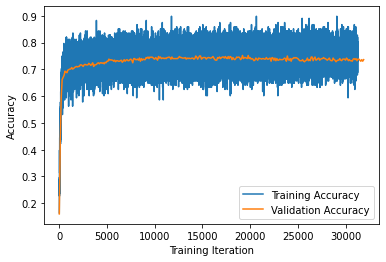

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()